In [2]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [3]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [4]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [5]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [6]:
from utilities.userfold_framework import *
from utilities.EEG_func import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet
# import Models.model_func as Model_Func
from torch import nn
from Models.multi_models import *

DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

class LSTM_output(torch.nn.Module):
    def forward(self, x):
        return x[0].unsqueeze(0)


for i in range(len(participants)):

    train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                      raw_user_fold,
                                                                                      participants,
                                                                                      batch_size=batch_size,
                                                                                      transpose_channels=transpose_channels)

    classifier= EEGNet(
        chunk_size=input_dim[1],
        num_electrodes=input_dim[0],
        num_classes=classes,
        kernel_1= 32,
        kernel_2=32,
        F1=8,
        F2=16,
        dropout=0.5
    ).to(DEVICE)
    
    
#     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)
    
    criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
#     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
        
    saved_dir= "./EEG/saved_models/Userfold/run2"
    nonlinear_func= torch.nn.Sequential(
#                     LSTM_input(),
                    torch.nn.LSTM(input_dim[1],input_dim[1]),
                    LSTM_output(),
                    torch.nn.Sigmoid(),
#                     EEGNet_input()
                        ).to(DEVICE)
    model = EEGNet_NeuralFS_HP_Wrapper(DEVICE, classifier, input_dim,
                                nonlinear_func=nonlinear_func
                                 ).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

    
    train_func= eeg_train
    model.training_procedure(iteration=n_epochs,
                                    train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader,
                                     print_cycle=2,
                                     path=f"./dictionary/intermdiate_dicts",
                                     loss_func=criterion,
                                     optimiser=optimizer, #scheduler=scheduler,
                                     train_func=train_func
                                    )
    if model.epoch == n_epochs+1:
        EPOCH= n_epochs
    else:
        EPOCH= model.epoch
    
    torch.save(model.state_dict(), 
           os.path.join(
               saved_dir, f"Userfold-{participants[i]}-EEGNet-NFS_Multivariate-e{EPOCH}.pt"
           )
    )

    pickle.dump( model.return_pairwise_weights(), 
                open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-NFS_Multivariate-w-e{EPOCH}.pkl", "wb") 
               )    

# OR
#     model.load_state_dict(
#     torch.load(
#         open(
#             os.path.join(
#                 saved_dir, f"Userfold-{participants[i]}-EEGNet-NFS_Multivariate-e{n_epochs}.pt"
#             ), "rb"
#         )
#               )
#     )

    
    prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)
    
    ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])
    
    c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
    print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
    b_acc_list.append(b_acc)
    c0_acc_list.append(c0_acc)
    c1_acc_list.append(c1_acc)
    participants_dictionary.append(dictionary)
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6588372529721728


Iterations:   0%|                                   | 1/300 [00:03<15:10,  3.04s/it]

Epoch:  0
t_loss:  0.6588372529721728 , v_loss:  0.6944884061813354
t_acc:  0.556178026766262 , v_acc:  0.37267080745341613
t_recall:  0.4794231481862725 , v_recall:  0.4626126126126126
t_prec:  0.47969799884626946 , v_prec:  0.4571280991735537
t_f:  0.4795301190038032 , v_f:  0.3702412764803842
////////


Iterations:   1%|▏                                  | 2/300 [00:03<08:38,  1.74s/it]

Epoch  1 , loss 0.6270641754655277
Epoch  2 , loss 0.6034279395552242


Iterations:   1%|▎                                  | 3/300 [00:05<07:41,  1.55s/it]

Epoch:  2
t_loss:  0.6034279395552242 , v_loss:  0.6909269491831461
t_acc:  0.6333644568938687 , v_acc:  0.5962732919254659
t_recall:  0.48918625876669275 , v_recall:  0.4599099099099099
t_prec:  0.4804777447777121 , v_prec:  0.4345588235294118
t_f:  0.46593324535965175 , v_f:  0.43508771929824563
////////


Iterations:   1%|▍                                  | 4/300 [00:06<06:15,  1.27s/it]

Epoch  3 , loss 0.5774232441303777
Epoch  4 , loss 0.5589838512972289


Iterations:   2%|▌                                  | 5/300 [00:07<06:22,  1.30s/it]

Epoch:  4
t_loss:  0.5589838512972289 , v_loss:  0.6787804365158081
t_acc:  0.6704014939309056 , v_acc:  0.6894409937888198
t_recall:  0.4953932831006986 , v_recall:  0.5
t_prec:  0.4810599078341014 , v_prec:  0.3447204968944099
t_f:  0.44034600656702577 , v_f:  0.4080882352941176
////////


Iterations:   2%|▋                                  | 6/300 [00:08<05:38,  1.15s/it]

Epoch  5 , loss 0.5415731761969772
Epoch  6 , loss 0.523426937121971


Iterations:   2%|▊                                  | 7/300 [00:09<06:06,  1.25s/it]

Epoch:  6
t_loss:  0.523426937121971 , v_loss:  0.6629521449406942
t_acc:  0.6887643946467475 , v_acc:  0.6894409937888198
t_recall:  0.5025541785042753 , v_recall:  0.5
t_prec:  0.5240350257871762 , v_prec:  0.3447204968944099
t_f:  0.431674263210699 , v_f:  0.4080882352941176
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:32,  1.14s/it]

Epoch  7 , loss 0.5107652954026765
Epoch  8 , loss 0.5012216410216164


Iterations:   3%|█                                  | 9/300 [00:11<05:51,  1.21s/it]

Epoch:  8
t_loss:  0.5012216410216164 , v_loss:  0.65363077322642
t_acc:  0.6921879863056334 , v_acc:  0.6894409937888198
t_recall:  0.5001269540632163 , v_recall:  0.5
t_prec:  0.5030053283659678 , v_prec:  0.3447204968944099
t_f:  0.41768443922621 , v_f:  0.4080882352941176
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:18,  1.10s/it]

Epoch  9 , loss 0.49012942524517283
Epoch  10 , loss 0.48453689264316185


Iterations:   4%|█▏                                | 11/300 [00:14<05:48,  1.21s/it]

Epoch:  10
t_loss:  0.48453689264316185 , v_loss:  0.6523837546507517
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.5010540618437848 , v_recall:  0.5
t_prec:  0.5480300187617261 , v_prec:  0.3447204968944099
t_f:  0.41576068370365055 , v_f:  0.4080882352941176
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:17,  1.10s/it]

Epoch  11 , loss 0.47351770015323863
Epoch  12 , loss 0.4678191653653687


Iterations:   4%|█▍                                | 13/300 [00:16<05:42,  1.19s/it]

Epoch:  12
t_loss:  0.4678191653653687 , v_loss:  0.6544239322344462
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.49990392665486333 , v_recall:  0.5
t_prec:  0.49064254522769807 , v_prec:  0.3447204968944099
t_f:  0.4118815871597207 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:10,  1.09s/it]

Epoch  13 , loss 0.4643842373408523
Epoch  14 , loss 0.4598363935947418


Iterations:   5%|█▋                                | 15/300 [00:18<05:32,  1.17s/it]

Epoch:  14
t_loss:  0.4598363935947418 , v_loss:  0.6565255622069041
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.500063820150698 , v_recall:  0.5
t_prec:  0.5144859813084112 , v_prec:  0.3447204968944099
t_f:  0.4111203780928551 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:09,  1.09s/it]

Epoch  15 , loss 0.4575464614466125
Epoch  16 , loss 0.45532119916934594


Iterations:   6%|█▉                                | 17/300 [00:21<05:37,  1.19s/it]

Epoch:  16
t_loss:  0.45532119916934594 , v_loss:  0.6584621667861938
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5005750675944607 , v_recall:  0.5
t_prec:  0.5979277033343721 , v_prec:  0.3447204968944099
t_f:  0.4122130008035903 , v_f:  0.4080882352941176
////////


Iterations:   6%|██                                | 18/300 [00:21<05:08,  1.09s/it]

Epoch  17 , loss 0.4496247482066061
Epoch  18 , loss 0.4516177831911573


Iterations:   6%|██▏                               | 19/300 [00:23<05:31,  1.18s/it]

Epoch:  18
t_loss:  0.4516177831911573 , v_loss:  0.6597612202167511
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.500063820150698 , v_recall:  0.5
t_prec:  0.5144859813084112 , v_prec:  0.3447204968944099
t_f:  0.4111203780928551 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:06,  1.10s/it]

Epoch  19 , loss 0.4450153538993761
Epoch  20 , loss 0.44272537412596685


Iterations:   7%|██▍                               | 21/300 [00:25<05:41,  1.23s/it]

Epoch:  20
t_loss:  0.44272537412596685 , v_loss:  0.6608207722504934
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5005750675944607 , v_recall:  0.5
t_prec:  0.5979277033343721 , v_prec:  0.3447204968944099
t_f:  0.4122130008035903 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:24,  1.17s/it]

Epoch  21 , loss 0.4419344482468624
Epoch  22 , loss 0.44174012775514643


Iterations:   8%|██▌                               | 23/300 [00:28<05:49,  1.26s/it]

Epoch:  22
t_loss:  0.44174012775514643 , v_loss:  0.6611713469028473
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.49955257270693515 , v_recall:  0.5
t_prec:  0.3477109934599813 , v_prec:  0.3447204968944099
t_f:  0.41002570694087404 , v_f:  0.4080882352941176
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:31,  1.20s/it]

Epoch  23 , loss 0.4428362297076805
Epoch  24 , loss 0.4417576339899325


Iterations:   8%|██▊                               | 25/300 [00:30<05:50,  1.28s/it]

Epoch:  24
t_loss:  0.4417576339899325 , v_loss:  0.6606305340925852
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.4998401065041655 , v_recall:  0.5
t_prec:  0.47277189155500154 , v_prec:  0.3447204968944099
t_f:  0.41101098240032563 , v_f:  0.4080882352941176
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:21,  1.17s/it]

Epoch  25 , loss 0.4392092257153754
Epoch  26 , loss 0.43878350012442646


Iterations:   9%|███                               | 27/300 [00:33<05:42,  1.25s/it]

Epoch:  26
t_loss:  0.43878350012442646 , v_loss:  0.6570855577786764
t_acc:  0.6971677559912854 , v_acc:  0.6894409937888198
t_recall:  0.5025562372188139 , v_recall:  0.5
t_prec:  0.8483478802992519 , v_prec:  0.3447204968944099
t_f:  0.415705613844319 , v_f:  0.4080882352941176
////////


Iterations:   9%|███▏                              | 28/300 [00:34<05:17,  1.17s/it]

Epoch  27 , loss 0.4408907411145229
Epoch  28 , loss 0.4369681237959394


Iterations:  10%|███▎                              | 29/300 [00:35<05:38,  1.25s/it]

Epoch:  28
t_loss:  0.4369681237959394 , v_loss:  0.6537707994381586
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5007987812409931 , v_recall:  0.5
t_prec:  0.6813084112149532 , v_prec:  0.3447204968944099
t_f:  0.41232340081380947 , v_f:  0.4080882352941176
////////


Iterations:  10%|███▍                              | 30/300 [00:36<05:12,  1.16s/it]

Epoch  29 , loss 0.43765559967826395
Epoch  30 , loss 0.444754688763151


Iterations:  10%|███▌                              | 31/300 [00:37<05:28,  1.22s/it]

Epoch:  30
t_loss:  0.444754688763151 , v_loss:  0.6514713714520136
t_acc:  0.6971677559912854 , v_acc:  0.6894409937888198
t_recall:  0.503418838610505 , v_recall:  0.5
t_prec:  0.7121685310317416 , v_prec:  0.3447204968944099
t_f:  0.4186094863993165 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:06,  1.14s/it]

Epoch  31 , loss 0.43975619182867165
Epoch  32 , loss 0.4425914889457179


Iterations:  11%|███▋                              | 33/300 [00:40<05:27,  1.23s/it]

Epoch:  32
t_loss:  0.4425914889457179 , v_loss:  0.6450540473063787
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5018850962792166 , v_recall:  0.5
t_prec:  0.6607059282371295 , v_prec:  0.3447204968944099
t_f:  0.4153651115618661 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▊                              | 34/300 [00:41<05:03,  1.14s/it]

Epoch  33 , loss 0.43537066029567345
Epoch  34 , loss 0.43163998337352977


Iterations:  12%|███▉                              | 35/300 [00:42<05:21,  1.21s/it]

Epoch:  34
t_loss:  0.43163998337352977 , v_loss:  0.6430531690518061
t_acc:  0.6977902272019919 , v_acc:  0.6894409937888198
t_recall:  0.5041537997008002 , v_recall:  0.5
t_prec:  0.7577792288910341 , v_prec:  0.3447204968944099
t_f:  0.4198045337037372 , v_f:  0.4080882352941176
////////


Iterations:  12%|████                              | 36/300 [00:43<04:54,  1.12s/it]

Epoch  35 , loss 0.4368969353975034
Epoch  36 , loss 0.4320751709096572


Iterations:  12%|████▏                             | 37/300 [00:44<05:15,  1.20s/it]

Epoch:  36
t_loss:  0.4320751709096572 , v_loss:  0.6393813838561376
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5011501351889214 , v_recall:  0.5
t_prec:  0.5980499219968799 , v_prec:  0.3447204968944099
t_f:  0.41416708924949286 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▎                             | 38/300 [00:45<04:50,  1.11s/it]

Epoch  37 , loss 0.4312775631745656
Epoch  38 , loss 0.4292441349403531


Iterations:  13%|████▍                             | 39/300 [00:47<05:20,  1.23s/it]

Epoch:  38
t_loss:  0.4292441349403531 , v_loss:  0.63514976700147
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5019489164299145 , v_recall:  0.5
t_prec:  0.6209471353131566 , v_prec:  0.3447204968944099
t_f:  0.416219391790475 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▌                             | 40/300 [00:48<04:48,  1.11s/it]

Epoch  39 , loss 0.43212515291045694
Epoch  40 , loss 0.43356091543739916


Iterations:  14%|████▋                             | 41/300 [00:49<05:04,  1.18s/it]

Epoch:  40
t_loss:  0.43356091543739916 , v_loss:  0.6282893270254135
t_acc:  0.6974789915966386 , v_acc:  0.6894409937888198
t_recall:  0.503355018459807 , v_recall:  0.5
t_prec:  0.7860179407176286 , v_prec:  0.3447204968944099
t_f:  0.4177611561866126 , v_f:  0.4080882352941176
////////


Iterations:  14%|████▊                             | 42/300 [00:50<04:36,  1.07s/it]

Epoch  41 , loss 0.4262537132291233
Epoch  42 , loss 0.43020996685121576


Iterations:  14%|████▊                             | 43/300 [00:51<05:00,  1.17s/it]

Epoch:  42
t_loss:  0.43020996685121576 , v_loss:  0.622464969754219
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.5032589451146704 , v_recall:  0.5
t_prec:  0.6484990619136961 , v_prec:  0.3447204968944099
t_f:  0.41933401285531013 , v_f:  0.4080882352941176
////////


Iterations:  15%|████▉                             | 44/300 [00:52<04:39,  1.09s/it]

Epoch  43 , loss 0.42461175310845467
Epoch  44 , loss 0.433812757917479


Iterations:  15%|█████                             | 45/300 [00:53<04:56,  1.16s/it]

Epoch:  44
t_loss:  0.433812757917479 , v_loss:  0.6175761222839355
t_acc:  0.6971677559912854 , v_acc:  0.6894409937888198
t_recall:  0.5031313048132746 , v_recall:  0.5
t_prec:  0.7373595505617978 , v_prec:  0.3447204968944099
t_f:  0.41764560913497084 , v_f:  0.4080882352941176
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:32,  1.07s/it]

Epoch  45 , loss 0.4301140886895797
Epoch  46 , loss 0.4250113145977843


Iterations:  16%|█████▎                            | 47/300 [00:56<04:50,  1.15s/it]

Epoch:  46
t_loss:  0.4250113145977843 , v_loss:  0.6130970319112142
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.503035231468138 , v_recall:  0.5
t_prec:  0.6297016734438536 , v_prec:  0.3447204968944099
t_f:  0.4192163289012425 , v_f:  0.4080882352941176
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<04:35,  1.09s/it]

Epoch  47 , loss 0.4308932715771245
Epoch  48 , loss 0.42464394779766307


Iterations:  16%|█████▌                            | 49/300 [00:58<04:50,  1.16s/it]

Epoch:  48
t_loss:  0.42464394779766307 , v_loss:  0.6072529604037603
t_acc:  0.6974789915966386 , v_acc:  0.6894409937888198
t_recall:  0.5053677550404194 , v_recall:  0.5
t_prec:  0.66713199054158 , v_prec:  0.3447204968944099
t_f:  0.4244312569111685 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<04:30,  1.08s/it]

Epoch  49 , loss 0.41784333598379997
Epoch  50 , loss 0.42809615298813464


Iterations:  17%|█████▊                            | 51/300 [01:00<04:50,  1.16s/it]

Epoch:  50
t_loss:  0.42809615298813464 , v_loss:  0.6065477033456167
t_acc:  0.6981014628073452 , v_acc:  0.6894409937888198
t_recall:  0.5061027161307147 , v_recall:  0.5
t_prec:  0.6900159539614256 , v_prec:  0.3447204968944099
t_f:  0.4256155547364541 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:31,  1.10s/it]

Epoch  51 , loss 0.42823996789315166
Epoch  52 , loss 0.41643141063989375


Iterations:  18%|██████                            | 53/300 [01:02<04:52,  1.19s/it]

Epoch:  52
t_loss:  0.41643141063989375 , v_loss:  0.5990325758854548
t_acc:  0.699035169623405 , v_acc:  0.6956521739130435
t_recall:  0.507636458462003 , v_recall:  0.51
t_prec:  0.709435382685069 , v_prec:  0.846875
t_f:  0.4287888685042053 , v_f:  0.42920193907821425
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:36,  1.12s/it]

Epoch  53 , loss 0.41991110292135503
Epoch  54 , loss 0.41735101388949974


Iterations:  18%|██████▏                           | 55/300 [01:05<05:00,  1.23s/it]

Epoch:  54
t_loss:  0.41735101388949974 , v_loss:  0.5948314716418585
t_acc:  0.7005913476501712 , v_acc:  0.6956521739130435
t_recall:  0.5090425604918956 , v_recall:  0.51
t_prec:  0.7815518076408079 , v_prec:  0.846875
t_f:  0.43035274603759677 , v_f:  0.42920193907821425
////////


Iterations:  19%|██████▎                           | 56/300 [01:06<04:34,  1.12s/it]

Epoch  55 , loss 0.424089288594676
Epoch  56 , loss 0.4166510923236024


Iterations:  19%|██████▍                           | 57/300 [01:07<04:59,  1.23s/it]

Epoch:  56
t_loss:  0.4166510923236024 , v_loss:  0.5918692797422409
t_acc:  0.7021475256769374 , v_acc:  0.6956521739130435
t_recall:  0.5133240004940914 , v_recall:  0.51
t_prec:  0.7352770103242694 , v_prec:  0.846875
t_f:  0.44103485341539905 , v_f:  0.42920193907821425
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:38,  1.15s/it]

Epoch  57 , loss 0.4163934348845014
Epoch  58 , loss 0.41414367568259147


Iterations:  20%|██████▋                           | 59/300 [01:10<04:57,  1.23s/it]

Epoch:  58
t_loss:  0.41414367568259147 , v_loss:  0.5880203892787298
t_acc:  0.7002801120448179 , v_acc:  0.6956521739130435
t_recall:  0.5105440496287452 , v_recall:  0.51
t_prec:  0.7072057898049088 , v_prec:  0.846875
t_f:  0.4357266490728602 , v_f:  0.42920193907821425
////////


Iterations:  20%|██████▊                           | 60/300 [01:11<04:33,  1.14s/it]

Epoch  59 , loss 0.41811009715585146
Epoch  60 , loss 0.4173612314112046


Iterations:  20%|██████▉                           | 61/300 [01:12<04:53,  1.23s/it]

Epoch:  60
t_loss:  0.4173612314112046 , v_loss:  0.5840185135602951
t_acc:  0.7033924680983504 , v_acc:  0.7080745341614907
t_recall:  0.5159440578636033 , v_recall:  0.53
t_prec:  0.7342105616859989 , v_prec:  0.8512658227848101
t_f:  0.44689754833115813 , v_f:  0.4692431787893666
////////


Iterations:  21%|███████                           | 62/300 [01:13<04:34,  1.15s/it]

Epoch  61 , loss 0.41825930686557994
Epoch  62 , loss 0.41514412620488333


Iterations:  21%|███████▏                          | 63/300 [01:14<04:58,  1.26s/it]

Epoch:  62
t_loss:  0.41514412620488333 , v_loss:  0.5790542215108871
t_acc:  0.7018362900715842 , v_acc:  0.7142857142857143
t_recall:  0.513100286847559 , v_recall:  0.54
t_prec:  0.7256145603529782 , v_prec:  0.8535031847133758
t_f:  0.44089706292649467 , v_f:  0.488253178551686
////////


Iterations:  21%|███████▎                          | 64/300 [01:15<04:36,  1.17s/it]

Epoch  63 , loss 0.41212455490056205
Epoch  64 , loss 0.4142020338890599


Iterations:  22%|███████▎                          | 65/300 [01:17<04:58,  1.27s/it]

Epoch:  64
t_loss:  0.4142020338890599 , v_loss:  0.5756745090087255
t_acc:  0.6999688764394647 , v_acc:  0.7142857142857143
t_recall:  0.5114704711711341 , v_recall:  0.54
t_prec:  0.6798136779597808 , v_prec:  0.8535031847133758
t_f:  0.4391825436257262 , v_f:  0.488253178551686
////////


Iterations:  22%|███████▍                          | 66/300 [01:18<04:43,  1.21s/it]

Epoch  65 , loss 0.4112520323080175
Epoch  66 , loss 0.41447300361652


Iterations:  22%|███████▌                          | 67/300 [01:20<05:01,  1.29s/it]

Epoch:  66
t_loss:  0.41447300361652 , v_loss:  0.5724408179521561
t_acc:  0.7021475256769374 , v_acc:  0.7204968944099379
t_recall:  0.5147616694802433 , v_recall:  0.55
t_prec:  0.7081226295828066 , v_prec:  0.8557692307692308
t_f:  0.4454523205909422 , v_f:  0.5066394279877425
////////


Iterations:  23%|███████▋                          | 68/300 [01:21<04:41,  1.21s/it]

Epoch  67 , loss 0.41277439746202205
Epoch  68 , loss 0.4119543152696946


Iterations:  23%|███████▊                          | 69/300 [01:22<04:55,  1.28s/it]

Epoch:  68
t_loss:  0.4119543152696946 , v_loss:  0.5671190420786539
t_acc:  0.7068160597572363 , v_acc:  0.7267080745341615
t_recall:  0.5224303811366849 , v_recall:  0.56
t_prec:  0.7432766354398221 , v_prec:  0.8580645161290323
t_f:  0.4605032184648906 , v_f:  0.5244360902255639
////////


Iterations:  23%|███████▉                          | 70/300 [01:23<04:32,  1.18s/it]

Epoch  69 , loss 0.41172919027945576
Epoch  70 , loss 0.41125162968448564


Iterations:  24%|████████                          | 71/300 [01:24<04:46,  1.25s/it]

Epoch:  70
t_loss:  0.41125162968448564 , v_loss:  0.5657220631837845
t_acc:  0.7058823529411765 , v_acc:  0.7329192546583851
t_recall:  0.5226218415887787 , v_recall:  0.5700000000000001
t_prec:  0.7157207049995638 , v_prec:  0.8603896103896104
t_f:  0.4625211869094771 , v_f:  0.5416749420721615
////////


Iterations:  24%|████████▏                         | 72/300 [01:25<04:30,  1.19s/it]

Epoch  71 , loss 0.4082515175436057
Epoch  72 , loss 0.401457337772145


Iterations:  24%|████████▎                         | 73/300 [01:27<04:48,  1.27s/it]

Epoch:  72
t_loss:  0.401457337772145 , v_loss:  0.5627522220214208
t_acc:  0.7096171802054155 , v_acc:  0.7391304347826086
t_recall:  0.527894209522241 , v_recall:  0.58
t_prec:  0.7462659439548278 , v_prec:  0.8627450980392157
t_f:  0.4717688866302628 , v_f:  0.5583855799373041
////////


Iterations:  25%|████████▍                         | 74/300 [01:28<04:21,  1.16s/it]

Epoch  73 , loss 0.4078880934154286
Epoch  74 , loss 0.4078290065129598


Iterations:  25%|████████▌                         | 75/300 [01:29<04:34,  1.22s/it]

Epoch:  74
t_loss:  0.4078290065129598 , v_loss:  0.5602569629748663
t_acc:  0.707749766573296 , v_acc:  0.7391304347826086
t_recall:  0.5256893262513553 , v_recall:  0.58
t_prec:  0.7267999806127972 , v_prec:  0.8627450980392157
t_f:  0.4683719019783674 , v_f:  0.5583855799373041
////////


Iterations:  25%|████████▌                         | 76/300 [01:30<04:13,  1.13s/it]

Epoch  75 , loss 0.4036301064725016
Epoch  76 , loss 0.4038512473012887


Iterations:  26%|████████▋                         | 77/300 [01:31<04:29,  1.21s/it]

Epoch:  76
t_loss:  0.4038512473012887 , v_loss:  0.5593562722206116
t_acc:  0.7099284158107687 , v_acc:  0.7453416149068323
t_recall:  0.5295555921549251 , v_recall:  0.59
t_prec:  0.7349218181818182 , v_prec:  0.8651315789473684
t_f:  0.4759114838565148 , v_f:  0.5745956048205194
////////


Iterations:  26%|████████▊                         | 78/300 [01:32<04:14,  1.15s/it]

Epoch  77 , loss 0.40086693068345386
Epoch  78 , loss 0.4011070552994223


Iterations:  26%|████████▉                         | 79/300 [01:34<04:24,  1.20s/it]

Epoch:  78
t_loss:  0.4011070552994223 , v_loss:  0.5576774577299753
t_acc:  0.708994708994709 , v_acc:  0.7453416149068323
t_recall:  0.5280218498236368 , v_recall:  0.59
t_prec:  0.7303708439897698 , v_prec:  0.8651315789473684
t_f:  0.4730356021160984 , v_f:  0.5745956048205194
////////


Iterations:  27%|█████████                         | 80/300 [01:35<04:06,  1.12s/it]

Epoch  79 , loss 0.399088288639106
Epoch  80 , loss 0.396110406108931


Iterations:  27%|█████████▏                        | 81/300 [01:36<04:18,  1.18s/it]

Epoch:  80
t_loss:  0.396110406108931 , v_loss:  0.5540648003419241
t_acc:  0.712729536258948 , v_acc:  0.7515527950310559
t_recall:  0.5358820219321723 , v_recall:  0.6
t_prec:  0.7318168920836092 , v_prec:  0.8675496688741722
t_f:  0.488997574391836 , v_f:  0.5903307888040712
////////


Iterations:  27%|█████████▎                        | 82/300 [01:37<04:01,  1.11s/it]

Epoch  81 , loss 0.3981345249157326
Epoch  82 , loss 0.39632567120533363


Iterations:  28%|█████████▍                        | 83/300 [01:38<04:22,  1.21s/it]

Epoch:  82
t_loss:  0.39632567120533363 , v_loss:  0.5531031042337418
t_acc:  0.7130407718643013 , v_acc:  0.7515527950310559
t_recall:  0.5358182017814743 , v_recall:  0.6
t_prec:  0.7377240072629667 , v_prec:  0.8675496688741722
t_f:  0.4884259802912518 , v_f:  0.5903307888040712
////////


Iterations:  28%|█████████▌                        | 84/300 [01:39<03:57,  1.10s/it]

Epoch  83 , loss 0.39319976346165525
Epoch  84 , loss 0.3896414584973279


Iterations:  28%|█████████▋                        | 85/300 [01:41<04:13,  1.18s/it]

Epoch:  84
t_loss:  0.3896414584973279 , v_loss:  0.5488528956969579
t_acc:  0.7201991907874261 , v_acc:  0.7639751552795031
t_recall:  0.548151960582479 , v_recall:  0.62
t_prec:  0.7569377990430621 , v_prec:  0.8724832214765101
t_f:  0.5108375748205112 , v_f:  0.6204714640198511
////////


Iterations:  29%|█████████▋                        | 86/300 [01:41<03:52,  1.09s/it]

Epoch  85 , loss 0.3963715317202549
Epoch  86 , loss 0.39501580420662374


Iterations:  29%|█████████▊                        | 87/300 [01:43<04:13,  1.19s/it]

Epoch:  86
t_loss:  0.39501580420662374 , v_loss:  0.549173633257548
t_acc:  0.7142857142857143 , v_acc:  0.7639751552795031
t_recall:  0.5424637323122109 , v_recall:  0.62
t_prec:  0.7128464371379695 , v_prec:  0.8724832214765101
t_f:  0.5036727289860535 , v_f:  0.6204714640198511
////////


Iterations:  29%|█████████▉                        | 88/300 [01:44<03:54,  1.11s/it]

Epoch  87 , loss 0.39490554905405234
Epoch  88 , loss 0.3882960025586334


Iterations:  30%|██████████                        | 89/300 [01:45<04:06,  1.17s/it]

Epoch:  88
t_loss:  0.3882960025586334 , v_loss:  0.5480363170305887
t_acc:  0.7167755991285403 , v_acc:  0.7763975155279503
t_recall:  0.5448285090789311 , v_recall:  0.64
t_prec:  0.7309119830328739 , v_prec:  0.8775510204081632
t_f:  0.506606524512484 , v_f:  0.6489825581395349
////////


Iterations:  30%|██████████▏                       | 90/300 [01:46<03:47,  1.08s/it]

Epoch  89 , loss 0.38595662689676474
Epoch  90 , loss 0.38538842516786914


Iterations:  30%|██████████▎                       | 91/300 [01:47<04:02,  1.16s/it]

Epoch:  90
t_loss:  0.38538842516786914 , v_loss:  0.5464115937550863
t_acc:  0.7242452536570184 , v_acc:  0.7888198757763976
t_recall:  0.5553732449458558 , v_recall:  0.66
t_prec:  0.763437806072478 , v_prec:  0.8827586206896552
t_f:  0.5236530445049518 , v_f:  0.6760179924242424
////////


Iterations:  31%|██████████▍                       | 92/300 [01:48<03:50,  1.11s/it]

Epoch  91 , loss 0.38890375868946897
Epoch  92 , loss 0.3898807588745566


Iterations:  31%|██████████▌                       | 93/300 [01:50<04:03,  1.18s/it]

Epoch:  92
t_loss:  0.3898807588745566 , v_loss:  0.5442048062880834
t_acc:  0.7189542483660131 , v_acc:  0.7888198757763976
t_recall:  0.5475446397935795 , v_recall:  0.66
t_prec:  0.7432199978468754 , v_prec:  0.8827586206896552
t_f:  0.5107480363491465 , v_f:  0.6760179924242424
////////


Iterations:  31%|██████████▋                       | 94/300 [01:51<03:44,  1.09s/it]

Epoch  93 , loss 0.3824764945927788
Epoch  94 , loss 0.3946238376346289


Iterations:  32%|██████████▊                       | 95/300 [01:52<04:00,  1.17s/it]

Epoch:  94
t_loss:  0.3946238376346289 , v_loss:  0.5438616921504339
t_acc:  0.7205104263927793 , v_acc:  0.7763975155279503
t_recall:  0.5521136135930058 , v_recall:  0.6454954954954955
t_prec:  0.7359930804450061 , v_prec:  0.8480603448275862
t_f:  0.5198763944726963 , v_f:  0.6569602272727273
////////


Iterations:  32%|██████████▉                       | 96/300 [01:53<03:43,  1.10s/it]

Epoch  95 , loss 0.3804740859012978
Epoch  96 , loss 0.38724887780114714


Iterations:  32%|██████████▉                       | 97/300 [01:54<04:06,  1.22s/it]

Epoch:  96
t_loss:  0.38724887780114714 , v_loss:  0.5425224751234055
t_acc:  0.7230003112356054 , v_acc:  0.7888198757763976
t_recall:  0.5547659241569564 , v_recall:  0.66
t_prec:  0.7510190986638484 , v_prec:  0.8827586206896552
t_f:  0.5234945830183926 , v_f:  0.6760179924242424
////////


Iterations:  33%|███████████                       | 98/300 [01:55<03:50,  1.14s/it]

Epoch  97 , loss 0.38146356098792134
Epoch  98 , loss 0.37542514678309946


Iterations:  33%|███████████▏                      | 99/300 [01:57<04:07,  1.23s/it]

Epoch:  98
t_loss:  0.37542514678309946 , v_loss:  0.5356213400761286
t_acc:  0.7279800809212574 , v_acc:  0.7950310559006211
t_recall:  0.5638084846488519 , v_recall:  0.6754954954954955
t_prec:  0.7581761471965645 , v_prec:  0.8610081541882876
t_f:  0.5390501172005804 , v_f:  0.6956521739130435
////////


Iterations:  33%|███████████                      | 100/300 [01:58<03:47,  1.14s/it]

Epoch  99 , loss 0.3799593401890175
Epoch  100 , loss 0.37869055773697646


Iterations:  34%|███████████                      | 101/300 [01:59<04:00,  1.21s/it]

Epoch:  100
t_loss:  0.37869055773697646 , v_loss:  0.5362609922885895
t_acc:  0.733582321817616 , v_acc:  0.782608695652174
t_recall:  0.5715732696504302 , v_recall:  0.660990990990991
t_prec:  0.7778701365133156 , v_prec:  0.83117123795404
t_f:  0.5509645111615277 , v_f:  0.6772068511198946
////////


Iterations:  34%|███████████▏                     | 102/300 [02:00<03:42,  1.13s/it]

Epoch  101 , loss 0.37874383727709454
Epoch  102 , loss 0.37692535098861246


Iterations:  34%|███████████▎                     | 103/300 [02:02<04:06,  1.25s/it]

Epoch:  102
t_loss:  0.37692535098861246 , v_loss:  0.5349675267934799
t_acc:  0.7310924369747899 , v_acc:  0.7701863354037267
t_recall:  0.5686334252892493 , v_recall:  0.6464864864864865
t_prec:  0.766456728156271 , v_prec:  0.8013343217197924
t_f:  0.5467679178078971 , v_f:  0.6587615283267457
////////


Iterations:  35%|███████████▍                     | 104/300 [02:03<03:50,  1.18s/it]

Epoch  103 , loss 0.3779869073746251
Epoch  104 , loss 0.37383444461168025


Iterations:  35%|███████████▌                     | 105/300 [02:04<04:09,  1.28s/it]

Epoch:  104
t_loss:  0.37383444461168025 , v_loss:  0.5329519907633463
t_acc:  0.733582321817616 , v_acc:  0.7639751552795031
t_recall:  0.5753112090144248 , v_recall:  0.6364864864864865
t_prec:  0.7587462984036768 , v_prec:  0.7942890442890442
t_f:  0.5585943468296409 , v_f:  0.6457850856878184
////////


Iterations:  35%|███████████▋                     | 106/300 [02:05<03:49,  1.18s/it]

Epoch  105 , loss 0.36541033550804736
Epoch  106 , loss 0.3653762828485638


Iterations:  36%|███████████▊                     | 107/300 [02:06<04:01,  1.25s/it]

Epoch:  106
t_loss:  0.3653762828485638 , v_loss:  0.5357301781574885
t_acc:  0.7354497354497355 , v_acc:  0.7639751552795031
t_recall:  0.578091159879771 , v_recall:  0.641981981981982
t_prec:  0.7636803470136804 , v_prec:  0.7794326241134752
t_f:  0.5628227144898805 , v_f:  0.6531746031746032
////////


Iterations:  36%|███████████▉                     | 108/300 [02:07<03:39,  1.14s/it]

Epoch  107 , loss 0.3612786920047274
Epoch  108 , loss 0.3686823599478778


Iterations:  36%|███████████▉                     | 109/300 [02:09<03:55,  1.23s/it]

Epoch:  108
t_loss:  0.3686823599478778 , v_loss:  0.5360042800505956
t_acc:  0.739807033924681 , v_acc:  0.7701863354037267
t_recall:  0.5875488944702928 , v_recall:  0.651981981981982
t_prec:  0.7621889565710622 , v_prec:  0.7869047619047619
t_f:  0.5781430219146483 , v_f:  0.6657314404354413
////////


Iterations:  37%|████████████                     | 110/300 [02:10<03:39,  1.16s/it]

Epoch  109 , loss 0.3651287430057339
Epoch  110 , loss 0.3725452636386834


Iterations:  37%|████████████▏                    | 111/300 [02:11<03:49,  1.21s/it]

Epoch:  110
t_loss:  0.3725452636386834 , v_loss:  0.5387450655301412
t_acc:  0.7394957983193278 , v_acc:  0.7763975155279503
t_recall:  0.5850249104459175 , v_recall:  0.6564864864864866
t_prec:  0.769800621913298 , v_prec:  0.8079787234042553
t_f:  0.5736276374574247 , v_f:  0.6714285714285715
////////


Iterations:  37%|████████████▎                    | 112/300 [02:12<03:36,  1.15s/it]

Epoch  111 , loss 0.37051332347533283
Epoch  112 , loss 0.3604511779312994


Iterations:  38%|████████████▍                    | 113/300 [02:13<03:45,  1.21s/it]

Epoch:  112
t_loss:  0.3604511779312994 , v_loss:  0.5375684499740601
t_acc:  0.7413632119514473 , v_acc:  0.7763975155279503
t_recall:  0.5895300640946459 , v_recall:  0.661981981981982
t_prec:  0.7671266253709381 , v_prec:  0.7939829954218444
t_f:  0.5809278435465708 , v_f:  0.6779999999999999
////////


Iterations:  38%|████████████▌                    | 114/300 [02:14<03:30,  1.13s/it]

Epoch  113 , loss 0.36906985792459224
Epoch  114 , loss 0.3545489387184966


Iterations:  38%|████████████▋                    | 115/300 [02:16<03:48,  1.24s/it]

Epoch:  114
t_loss:  0.3545489387184966 , v_loss:  0.5348703215519587
t_acc:  0.7500778089013383 , v_acc:  0.7763975155279503
t_recall:  0.5992444517643184 , v_recall:  0.6674774774774774
t_prec:  0.800579872802095 , v_prec:  0.7826946472019465
t_f:  0.5940338032557053 , v_f:  0.6841761115954664
////////


Iterations:  39%|████████████▊                    | 116/300 [02:17<03:29,  1.14s/it]

Epoch  115 , loss 0.3528963344938615
Epoch  116 , loss 0.35983235958744497


Iterations:  39%|████████████▊                    | 117/300 [02:18<03:47,  1.24s/it]

Epoch:  116
t_loss:  0.35983235958744497 , v_loss:  0.5342293481032053
t_acc:  0.7444755680049797 , v_acc:  0.7701863354037267
t_recall:  0.5969428089101165 , v_recall:  0.6684684684684685
t_prec:  0.764010989010989 , v_prec:  0.7584300718629077
t_f:  0.5925388384944219 , v_f:  0.6842300556586272
////////


Iterations:  39%|████████████▉                    | 118/300 [02:19<03:26,  1.14s/it]

Epoch  117 , loss 0.36246128380298615
Epoch  118 , loss 0.3592805006340438


Iterations:  40%|█████████████                    | 119/300 [02:21<03:41,  1.22s/it]

Epoch:  118
t_loss:  0.3592805006340438 , v_loss:  0.5400253981351852
t_acc:  0.7525676937441643 , v_acc:  0.7701863354037267
t_recall:  0.6087975734617972 , v_recall:  0.673963963963964
t_prec:  0.7814235133177758 , v_prec:  0.7522204806687565
t_f:  0.6092169560463451 , v_f:  0.6896910975673283
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:21<03:24,  1.14s/it]

Epoch  119 , loss 0.352941538773331
Epoch  120 , loss 0.3485305730034323


Iterations:  40%|█████████████▎                   | 121/300 [02:23<03:41,  1.24s/it]

Epoch:  120
t_loss:  0.3485305730034323 , v_loss:  0.5457359254360199
t_acc:  0.7531901649548708 , v_acc:  0.7701863354037267
t_recall:  0.6086699331604013 , v_recall:  0.673963963963964
t_prec:  0.7864651044995719 , v_prec:  0.7522204806687565
t_f:  0.608800311374138 , v_f:  0.6896910975673283
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:24<03:30,  1.18s/it]

Epoch  121 , loss 0.35629773549005095
Epoch  122 , loss 0.34523768255523607


Iterations:  41%|█████████████▌                   | 123/300 [02:25<03:44,  1.27s/it]

Epoch:  122
t_loss:  0.34523768255523607 , v_loss:  0.5461907436450323
t_acc:  0.7612822906940554 , v_acc:  0.7701863354037267
t_recall:  0.6236875694816156 , v_recall:  0.6684684684684685
t_prec:  0.7912320161321595 , v_prec:  0.7584300718629077
t_f:  0.6299728242141522 , v_f:  0.6842300556586272
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:26<03:29,  1.19s/it]

Epoch  123 , loss 0.34610646846247656
Epoch  124 , loss 0.34315184985890107


Iterations:  42%|█████████████▊                   | 125/300 [02:28<03:39,  1.26s/it]

Epoch:  124
t_loss:  0.34315184985890107 , v_loss:  0.5431609004735947
t_acc:  0.7572362278244631 , v_acc:  0.7701863354037267
t_recall:  0.6161787513210085 , v_recall:  0.673963963963964
t_prec:  0.7888643441979611 , v_prec:  0.7522204806687565
t_f:  0.6195254809560824 , v_f:  0.6896910975673283
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:29<03:22,  1.16s/it]

Epoch  125 , loss 0.34628120824402453
Epoch  126 , loss 0.34075231937801137


Iterations:  42%|█████████████▉                   | 127/300 [02:30<03:35,  1.25s/it]

Epoch:  126
t_loss:  0.34075231937801137 , v_loss:  0.5509965866804123
t_acc:  0.7653283535636477 , v_acc:  0.7763975155279503
t_recall:  0.6283210496699194 , v_recall:  0.683963963963964
t_prec:  0.8029813342550984 , v_prec:  0.759796437659033
t_f:  0.6360352179880724 , v_f:  0.7006198347107437
////////


Iterations:  43%|██████████████                   | 128/300 [02:31<03:19,  1.16s/it]

Epoch  127 , loss 0.33394617105231567
Epoch  128 , loss 0.3382736014969209


Iterations:  43%|██████████████▏                  | 129/300 [02:33<03:30,  1.23s/it]

Epoch:  128
t_loss:  0.3382736014969209 , v_loss:  0.5579972217480341
t_acc:  0.7650171179582944 , v_acc:  0.7763975155279503
t_recall:  0.6286724036178477 , v_recall:  0.683963963963964
t_prec:  0.7996548050287662 , v_prec:  0.759796437659033
t_f:  0.6365966674901041 , v_f:  0.7006198347107437
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:34<03:14,  1.15s/it]

Epoch  129 , loss 0.3422148391312244
Epoch  130 , loss 0.3311949264185101


Iterations:  44%|██████████████▍                  | 131/300 [02:35<03:25,  1.21s/it]

Epoch:  130
t_loss:  0.3311949264185101 , v_loss:  0.5584628830353419
t_acc:  0.76937441643324 , v_acc:  0.7763975155279503
t_recall:  0.6375550706139087 , v_recall:  0.683963963963964
t_prec:  0.799306563457507 , v_prec:  0.759796437659033
t_f:  0.648529144085553 , v_f:  0.7006198347107437
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:36<03:10,  1.13s/it]

Epoch  131 , loss 0.3316829578549254
Epoch  132 , loss 0.33396801907642215


Iterations:  44%|██████████████▋                  | 133/300 [02:37<03:24,  1.22s/it]

Epoch:  132
t_loss:  0.33396801907642215 , v_loss:  0.5603666007518768
t_acc:  0.7699968876439465 , v_acc:  0.7763975155279503
t_recall:  0.638290031704204 , v_recall:  0.683963963963964
t_prec:  0.8009057678868999 , v_prec:  0.759796437659033
t_f:  0.6494777833727714 , v_f:  0.7006198347107437
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:38<03:10,  1.15s/it]

Epoch  133 , loss 0.333979468719632
Epoch  134 , loss 0.3299284980577581


Iterations:  45%|██████████████▊                  | 135/300 [02:40<03:24,  1.24s/it]

Epoch:  134
t_loss:  0.3299284980577581 , v_loss:  0.5657690217097601
t_acc:  0.7749766573295985 , v_acc:  0.7701863354037267
t_recall:  0.647045058398869 , v_recall:  0.6794594594594595
t_prec:  0.8048378102054095 , v_prec:  0.7471464019851117
t_f:  0.6608202546608763 , v_f:  0.6948414527944264
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:41<03:07,  1.14s/it]

Epoch  135 , loss 0.32738316205202367
Epoch  136 , loss 0.3225099546652214


Iterations:  46%|███████████████                  | 137/300 [02:42<03:21,  1.24s/it]

Epoch:  136
t_loss:  0.3225099546652214 , v_loss:  0.5708750685056051
t_acc:  0.7836912542794896 , v_acc:  0.7701863354037267
t_recall:  0.6584846488519236 , v_recall:  0.6794594594594595
t_prec:  0.8225258498853909 , v_prec:  0.7471464019851117
t_f:  0.6753664572597492 , v_f:  0.6948414527944264
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:43<03:02,  1.13s/it]

Epoch  137 , loss 0.3223426035221885
Epoch  138 , loss 0.32252975889280733


Iterations:  46%|███████████████▎                 | 139/300 [02:44<03:15,  1.22s/it]

Epoch:  138
t_loss:  0.32252975889280733 , v_loss:  0.5749116688966751
t_acc:  0.7886710239651417 , v_acc:  0.7639751552795031
t_recall:  0.6666646079521281 , v_recall:  0.6804504504504505
t_prec:  0.827281670275175 , v_prec:  0.731936081519222
t_f:  0.68554343622568 , v_f:  0.6939775910364145
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:45<03:01,  1.13s/it]

Epoch  139 , loss 0.3139489670010174
Epoch  140 , loss 0.31739774054171993


Iterations:  47%|███████████████▌                 | 141/300 [02:47<03:14,  1.22s/it]

Epoch:  140
t_loss:  0.31739774054171993 , v_loss:  0.5867479095856348
t_acc:  0.7833800186741363 , v_acc:  0.7577639751552795
t_recall:  0.6625739421638462 , v_recall:  0.6704504504504505
t_prec:  0.8092148656056664 , v_prec:  0.7239583333333333
t_f:  0.6802045091311795 , v_f:  0.6834702828048596
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:48<02:58,  1.13s/it]

Epoch  141 , loss 0.31478218646610484
Epoch  142 , loss 0.3208080278892143


Iterations:  48%|███████████████▋                 | 143/300 [02:49<03:13,  1.23s/it]

Epoch:  142
t_loss:  0.3208080278892143 , v_loss:  0.5872533321380615
t_acc:  0.7899159663865546 , v_acc:  0.7515527950310559
t_recall:  0.6718724694967129 , v_recall:  0.6659459459459459
t_prec:  0.8196135548462182 , v_prec:  0.7132931912922649
t_f:  0.6916187967392093 , v_f:  0.6778711484593838
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:50<03:01,  1.17s/it]

Epoch  143 , loss 0.3180641952682944
Epoch  144 , loss 0.31145772659311105


Iterations:  48%|███████████████▉                 | 145/300 [02:52<03:19,  1.29s/it]

Epoch:  144
t_loss:  0.31145772659311105 , v_loss:  0.5895792792240778
t_acc:  0.7899159663865546 , v_acc:  0.7453416149068323
t_recall:  0.6724475370911736 , v_recall:  0.6614414414414415
t_prec:  0.8181205164992826 , v_prec:  0.7031746031746031
t_f:  0.692253126707665 , v_f:  0.6723256391164061
////////


Iterations:  49%|████████████████                 | 146/300 [02:53<03:06,  1.21s/it]

Epoch  145 , loss 0.3032773642563352
Epoch  146 , loss 0.3124113570825726


Iterations:  49%|████████████████▏                | 147/300 [02:54<03:18,  1.30s/it]

Epoch:  146
t_loss:  0.3124113570825726 , v_loss:  0.5982587585846583
t_acc:  0.7936507936507936 , v_acc:  0.7515527950310559
t_recall:  0.6817453781858608 , v_recall:  0.6714414414414415
t_prec:  0.8142701525054465 , v_prec:  0.7114444444444444
t_f:  0.7028648831186439 , v_f:  0.6826960977532519
////////


Iterations:  49%|████████████████▎                | 148/300 [02:55<03:09,  1.24s/it]

Epoch  147 , loss 0.3067823046562718
Epoch  148 , loss 0.3037618106486751


Iterations:  50%|████████████████▍                | 149/300 [02:57<03:15,  1.29s/it]

Epoch:  148
t_loss:  0.3037618106486751 , v_loss:  0.6013910671075186
t_acc:  0.7967631497043262 , v_acc:  0.7329192546583851
t_recall:  0.6831199132594941 , v_recall:  0.657927927927928
t_prec:  0.8261883612716057 , v_prec:  0.6842160571668768
t_f:  0.7049974655885985 , v_f:  0.6661522881805468
////////


Iterations:  50%|████████████████▌                | 150/300 [02:58<02:58,  1.19s/it]

Epoch  149 , loss 0.30437688383401607
Epoch  150 , loss 0.30322133851986305


Iterations:  50%|████████████████▌                | 151/300 [02:59<03:06,  1.25s/it]

Epoch:  150
t_loss:  0.30322133851986305 , v_loss:  0.6130332748095194
t_acc:  0.8048552754435108 , v_acc:  0.7577639751552795
t_recall:  0.694399610216714 , v_recall:  0.6814414414414414
t_prec:  0.8386149383611312 , v_prec:  0.719485614646905
t_f:  0.7184402895386408 , v_f:  0.6928833455612619
////////


Iterations:  51%|████████████████▋                | 152/300 [03:00<02:52,  1.16s/it]

Epoch  151 , loss 0.30180039388291974
Epoch  152 , loss 0.2952215160224952


Iterations:  51%|████████████████▊                | 153/300 [03:02<03:05,  1.26s/it]

Epoch:  152
t_loss:  0.2952215160224952 , v_loss:  0.6203106343746185
t_acc:  0.8067226890756303 , v_acc:  0.7391304347826086
t_recall:  0.6980421624737514 , v_recall:  0.667927927927928
t_prec:  0.8387695450063389 , v_prec:  0.6925619834710743
t_f:  0.7225114244981795 , v_f:  0.6761494252873563
////////


Iterations:  51%|████████████████▉                | 154/300 [03:03<02:50,  1.17s/it]

Epoch  153 , loss 0.2965772923301248
Epoch  154 , loss 0.3002726932366689


Iterations:  52%|█████████████████                | 155/300 [03:04<02:58,  1.23s/it]

Epoch:  154
t_loss:  0.3002726932366689 , v_loss:  0.6177976330121359
t_acc:  0.8011204481792717 , v_acc:  0.7515527950310559
t_recall:  0.6931527154444764 , v_recall:  0.6824324324324325
t_prec:  0.8235062893081762 , v_prec:  0.7091942148760331
t_f:  0.7161395889976295 , v_f:  0.6915708812260537
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:05<02:46,  1.15s/it]

Epoch  155 , loss 0.2909531558261198
Epoch  156 , loss 0.2947496219592936


Iterations:  52%|█████████████████▎               | 157/300 [03:06<02:55,  1.23s/it]

Epoch:  156
t_loss:  0.2947496219592936 , v_loss:  0.6303108235200247
t_acc:  0.8098350451291628 , v_acc:  0.7577639751552795
t_recall:  0.7060299748836827 , v_recall:  0.697927927927928
t_prec:  0.8347280754565523 , v_prec:  0.7164958612534489
t_f:  0.7309203457510784 , v_f:  0.7051697422172137
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:07<02:41,  1.14s/it]

Epoch  157 , loss 0.2826483889537699
Epoch  158 , loss 0.2912207491257611


Iterations:  53%|█████████████████▍               | 159/300 [03:09<02:52,  1.22s/it]

Epoch:  158
t_loss:  0.2912207491257611 , v_loss:  0.6337274312973022
t_acc:  0.8104575163398693 , v_acc:  0.7577639751552795
t_recall:  0.7079150711628992 , v_recall:  0.697927927927928
t_prec:  0.8333996023856859 , v_prec:  0.7164958612534489
t_f:  0.7328183277360896 , v_f:  0.7051697422172137
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:10<02:41,  1.15s/it]

Epoch  159 , loss 0.28391208455843087
Epoch  160 , loss 0.27061167286307203


Iterations:  54%|█████████████████▋               | 161/300 [03:11<02:53,  1.25s/it]

Epoch:  160
t_loss:  0.27061167286307203 , v_loss:  0.6406460702419281
t_acc:  0.8204170557111734 , v_acc:  0.7577639751552795
t_recall:  0.7202495162020834 , v_recall:  0.697927927927928
t_prec:  0.8509098781143809 , v_prec:  0.7164958612534489
t_f:  0.7473349156409266 , v_f:  0.7051697422172137
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:12<02:37,  1.14s/it]

Epoch  161 , loss 0.2862340080387452
Epoch  162 , loss 0.2685355161334954


Iterations:  54%|█████████████████▉               | 163/300 [03:13<02:48,  1.23s/it]

Epoch:  162
t_loss:  0.2685355161334954 , v_loss:  0.6537219981352488
t_acc:  0.8250855897914722 , v_acc:  0.7577639751552795
t_recall:  0.7256179574806825 , v_recall:  0.697927927927928
t_prec:  0.860040430971672 , v_prec:  0.7164958612534489
t_f:  0.7537873292456648 , v_f:  0.7051697422172137
////////


Iterations:  55%|██████████████████               | 164/300 [03:14<02:36,  1.15s/it]

Epoch  163 , loss 0.27071263188240574
Epoch  164 , loss 0.2736661591950585


Iterations:  55%|██████████████████▏              | 165/300 [03:16<02:47,  1.24s/it]

Epoch:  164
t_loss:  0.2736661591950585 , v_loss:  0.6663945217927297
t_acc:  0.8294428882664177 , v_acc:  0.7515527950310559
t_recall:  0.7365133610573558 , v_recall:  0.6934234234234234
t_prec:  0.8550229298260794 , v_prec:  0.7085275835275835
t_f:  0.7643144209177035 , v_f:  0.6995147443075775
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:17<02:35,  1.16s/it]

Epoch  165 , loss 0.2659241148069793
Epoch  166 , loss 0.26837939929728416


Iterations:  56%|██████████████████▎              | 167/300 [03:18<02:45,  1.24s/it]

Epoch:  166
t_loss:  0.26837939929728416 , v_loss:  0.6757913529872894
t_acc:  0.8219732337379396 , v_acc:  0.7577639751552795
t_recall:  0.7259686251904311 , v_recall:  0.7034234234234235
t_prec:  0.8452634095398669 , v_prec:  0.7162835249042145
t_f:  0.7526455026455027 , v_f:  0.7088337584048227
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:19<02:32,  1.15s/it]

Epoch  167 , loss 0.26980668569312377
Epoch  168 , loss 0.25704848795544866


Iterations:  56%|██████████████████▌              | 169/300 [03:21<02:48,  1.28s/it]

Epoch:  168
t_loss:  0.25704848795544866 , v_loss:  0.685661127169927
t_acc:  0.8415810768751946 , v_acc:  0.7577639751552795
t_recall:  0.7532891395945704 , v_recall:  0.7034234234234235
t_prec:  0.8710895137236503 , v_prec:  0.7162835249042145
t_f:  0.7827492416427939 , v_f:  0.7088337584048227
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:22<02:34,  1.19s/it]

Epoch  169 , loss 0.2606445901534137
Epoch  170 , loss 0.26066770302314385


Iterations:  57%|██████████████████▊              | 171/300 [03:23<02:47,  1.30s/it]

Epoch:  170
t_loss:  0.26066770302314385 , v_loss:  0.6909236411253611
t_acc:  0.8394024276377218 , v_acc:  0.7701863354037267
t_recall:  0.7548860158383772 , v_recall:  0.7179279279279279
t_prec:  0.859065487177372 , v_prec:  0.7317049808429119
t_f:  0.7825386415387359 , v_f:  0.7237653605379086
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:24<02:37,  1.23s/it]

Epoch  171 , loss 0.25759689071599173
Epoch  172 , loss 0.25859542775387856


Iterations:  58%|███████████████████              | 173/300 [03:26<02:44,  1.29s/it]

Epoch:  172
t_loss:  0.25859542775387856 , v_loss:  0.694553554058075
t_acc:  0.8344226579520697 , v_acc:  0.7701863354037267
t_recall:  0.746993590535403 , v_recall:  0.7179279279279279
t_prec:  0.8544815269561334 , v_prec:  0.7317049808429119
t_f:  0.7744287199843753 , v_f:  0.7237653605379086
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:27<02:30,  1.19s/it]

Epoch  173 , loss 0.2530274817756578
Epoch  174 , loss 0.26162692378549013


Iterations:  58%|███████████████████▎             | 175/300 [03:28<02:36,  1.25s/it]

Epoch:  174
t_loss:  0.26162692378549013 , v_loss:  0.7035749951998392
t_acc:  0.8322440087145969 , v_acc:  0.7577639751552795
t_recall:  0.7471527977930581 , v_recall:  0.7034234234234235
t_prec:  0.8459153565995112 , v_prec:  0.7162835249042145
t_f:  0.7733333333333334 , v_f:  0.7088337584048227
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:29<02:23,  1.16s/it]

Epoch  175 , loss 0.24984527466928258
Epoch  176 , loss 0.24373537448107027


Iterations:  59%|███████████████████▍             | 177/300 [03:31<02:32,  1.24s/it]

Epoch:  176
t_loss:  0.24373537448107027 , v_loss:  0.718248208363851
t_acc:  0.8512293806411454 , v_acc:  0.7453416149068323
t_recall:  0.7728757497152112 , v_recall:  0.6944144144144144
t_prec:  0.8710112834803379 , v_prec:  0.7013811123553564
t_f:  0.8009351478079996 , v_f:  0.6975486827033219
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:31<02:18,  1.14s/it]

Epoch  177 , loss 0.24910065502512688
Epoch  178 , loss 0.24489080409208933


Iterations:  60%|███████████████████▋             | 179/300 [03:33<02:27,  1.22s/it]

Epoch:  178
t_loss:  0.24489080409208933 , v_loss:  0.7300225893656412
t_acc:  0.8518518518518519 , v_acc:  0.7453416149068323
t_recall:  0.7730356432110457 , v_recall:  0.6944144144144144
t_prec:  0.8730637623831694 , v_prec:  0.7013811123553564
t_f:  0.8014351209419428 , v_f:  0.6975486827033219
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:34<02:16,  1.13s/it]

Epoch  179 , loss 0.24893417282431735
Epoch  180 , loss 0.2392644682059101


Iterations:  60%|███████████████████▉             | 181/300 [03:35<02:29,  1.26s/it]

Epoch:  180
t_loss:  0.2392644682059101 , v_loss:  0.7279677192370096
t_acc:  0.8499844382197324 , v_acc:  0.7391304347826086
t_recall:  0.7728434965207724 , v_recall:  0.68990990990991
t_prec:  0.8664924506387921 , v_prec:  0.6943215339233039
t_f:  0.8001036226092452 , v_f:  0.6919642857142857
////////


Iterations:  61%|████████████████████             | 182/300 [03:36<02:19,  1.18s/it]

Epoch  181 , loss 0.24829929044433668
Epoch  182 , loss 0.2424405138282215


Iterations:  61%|████████████████████▏            | 183/300 [03:38<02:31,  1.29s/it]

Epoch:  182
t_loss:  0.2424405138282215 , v_loss:  0.7338340282440186
t_acc:  0.8512293806411454 , v_acc:  0.7515527950310559
t_recall:  0.7740258849041326 , v_recall:  0.7044144144144144
t_prec:  0.8689672165481896 , v_prec:  0.7091629793510325
t_f:  0.8015980012711668 , v_f:  0.7066326530612245
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:39<02:22,  1.23s/it]

Epoch  183 , loss 0.23983840498269773
Epoch  184 , loss 0.24597998898403317


Iterations:  62%|████████████████████▎            | 185/300 [03:40<02:29,  1.30s/it]

Epoch:  184
t_loss:  0.24597998898403317 , v_loss:  0.751676102479299
t_acc:  0.8496732026143791 , v_acc:  0.7453416149068323
t_recall:  0.770031978699167 , v_recall:  0.6944144144144144
t_prec:  0.8703375580373949 , v_prec:  0.7013811123553564
t_f:  0.7982603800982386 , v_f:  0.6975486827033219
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:41<02:18,  1.21s/it]

Epoch  185 , loss 0.23756000078191944
Epoch  186 , loss 0.2382223755121231


Iterations:  62%|████████████████████▌            | 187/300 [03:43<02:24,  1.28s/it]

Epoch:  186
t_loss:  0.2382223755121231 , v_loss:  0.7592811385790507
t_acc:  0.8555866791160909 , v_acc:  0.7391304347826086
t_recall:  0.7814708829140418 , v_recall:  0.6954054054054054
t_prec:  0.8718774857413645 , v_prec:  0.6954054054054054
t_f:  0.8086736186757645 , v_f:  0.6954054054054054
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:44<02:10,  1.17s/it]

Epoch  187 , loss 0.22867842632181504
Epoch  188 , loss 0.23407846630788318


Iterations:  63%|████████████████████▊            | 189/300 [03:45<02:18,  1.24s/it]

Epoch:  188
t_loss:  0.23407846630788318 , v_loss:  0.7676993012428284
t_acc:  0.8630563336445689 , v_acc:  0.7453416149068323
t_recall:  0.7940283553615789 , v_recall:  0.6944144144144144
t_prec:  0.8772110740047305 , v_prec:  0.7013811123553564
t_f:  0.820460484339631 , v_f:  0.6975486827033219
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:46<02:06,  1.15s/it]

Epoch  189 , loss 0.23192593163135006
Epoch  190 , loss 0.22322878767462337


Iterations:  64%|█████████████████████            | 191/300 [03:48<02:12,  1.21s/it]

Epoch:  190
t_loss:  0.22322878767462337 , v_loss:  0.7723770439624786
t_acc:  0.8630563336445689 , v_acc:  0.7453416149068323
t_recall:  0.7928782201726575 , v_recall:  0.6999099099099099
t_prec:  0.8790836127293248 , v_prec:  0.7021683673469388
t_f:  0.8198862536055365 , v_f:  0.7010010418082167
////////


Iterations:  64%|█████████████████████            | 192/300 [03:48<02:02,  1.14s/it]

Epoch  191 , loss 0.22756585844007193
Epoch  192 , loss 0.2231725086184109


Iterations:  64%|█████████████████████▏           | 193/300 [03:50<02:10,  1.22s/it]

Epoch:  192
t_loss:  0.2231725086184109 , v_loss:  0.7729121148586273
t_acc:  0.868036103330221 , v_acc:  0.7329192546583851
t_recall:  0.79933297648948 , v_recall:  0.6854054054054055
t_prec:  0.885716104797377 , v_prec:  0.6875
t_f:  0.8267133136121769 , v_f:  0.6864157267744713
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:51<02:01,  1.14s/it]

Epoch  193 , loss 0.2242803710932825
Epoch  194 , loss 0.22010605183302187


Iterations:  65%|█████████████████████▍           | 195/300 [03:52<02:07,  1.21s/it]

Epoch:  194
t_loss:  0.22010605183302187 , v_loss:  0.7794153392314911
t_acc:  0.8723934018051666 , v_acc:  0.7453416149068323
t_recall:  0.8067779744993893 , v_recall:  0.6999099099099099
t_prec:  0.888475861197978 , v_prec:  0.7021683673469388
t_f:  0.8334930152839642 , v_f:  0.7010010418082167
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:53<02:00,  1.16s/it]

Epoch  195 , loss 0.221418611851393
Epoch  196 , loss 0.21655502257978215


Iterations:  66%|█████████████████████▋           | 197/300 [03:55<02:07,  1.24s/it]

Epoch:  196
t_loss:  0.21655502257978215 , v_loss:  0.7921997507413229
t_acc:  0.879240585122938 , v_acc:  0.7453416149068323
t_recall:  0.8157251478843277 , v_recall:  0.6999099099099099
t_prec:  0.8972608220124338 , v_prec:  0.7021683673469388
t_f:  0.842797118847539 , v_f:  0.7010010418082167
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:56<01:55,  1.13s/it]

Epoch  197 , loss 0.2168140972361845
Epoch  198 , loss 0.20784545017808093


Iterations:  66%|█████████████████████▉           | 199/300 [03:57<02:04,  1.23s/it]

Epoch:  198
t_loss:  0.20784545017808093 , v_loss:  0.8093262314796448
t_acc:  0.8776844070961718 , v_acc:  0.7453416149068323
t_recall:  0.8163317824350476 , v_recall:  0.6944144144144144
t_prec:  0.8910592487020259 , v_prec:  0.7013811123553564
t_f:  0.8418147317578057 , v_f:  0.6975486827033219
////////


Iterations:  67%|██████████████████████           | 200/300 [03:58<01:54,  1.15s/it]

Epoch  199 , loss 0.21160084126042386
Epoch  200 , loss 0.20961447995083005


Iterations:  67%|██████████████████████           | 201/300 [03:59<02:02,  1.23s/it]

Epoch:  200
t_loss:  0.20961447995083005 , v_loss:  0.8195479512214661
t_acc:  0.8776844070961718 , v_acc:  0.7391304347826086
t_recall:  0.8154691810433565 , v_recall:  0.68990990990991
t_prec:  0.8924016921548342 , v_prec:  0.6943215339233039
t_f:  0.8414493438219363 , v_f:  0.6919642857142857
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:00<01:51,  1.14s/it]

Epoch  201 , loss 0.1949645844744701
Epoch  202 , loss 0.20913102653096705


Iterations:  68%|██████████████████████▎          | 203/300 [04:02<01:57,  1.21s/it]

Epoch:  202
t_loss:  0.20913102653096705 , v_loss:  0.8380073507626852
t_acc:  0.8770619358854653 , v_acc:  0.7391304347826086
t_recall:  0.8153092875475221 , v_recall:  0.7009009009009008
t_prec:  0.8905926790703473 , v_prec:  0.6967184191954834
t_f:  0.8408876496691153 , v_f:  0.6986631016042781
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:03<01:48,  1.13s/it]

Epoch  203 , loss 0.20504549101871603
Epoch  204 , loss 0.21271843696926154


Iterations:  68%|██████████████████████▌          | 205/300 [04:04<01:59,  1.26s/it]

Epoch:  204
t_loss:  0.21271843696926154 , v_loss:  0.8479631046454111
t_acc:  0.8832866479925303 , v_acc:  0.7391304347826086
t_recall:  0.8246716350310865 , v_recall:  0.7009009009009008
t_prec:  0.8965491229481815 , v_prec:  0.6967184191954834
t_f:  0.8497483179106737 , v_f:  0.6986631016042781
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:05<01:50,  1.18s/it]

Epoch  205 , loss 0.2033558191329825
Epoch  206 , loss 0.2015876609320734


Iterations:  69%|██████████████████████▊          | 207/300 [04:07<01:58,  1.27s/it]

Epoch:  206
t_loss:  0.2015876609320734 , v_loss:  0.8521553178628286
t_acc:  0.8860877684407096 , v_acc:  0.7391304347826086
t_recall:  0.8301354634166427 , v_recall:  0.6954054054054054
t_prec:  0.8973477114595516 , v_prec:  0.6954054054054054
t_f:  0.8541783848935316 , v_f:  0.6954054054054054
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:08<01:48,  1.18s/it]

Epoch  207 , loss 0.19371159842201308
Epoch  208 , loss 0.19086571183859133


Iterations:  70%|██████████████████████▉          | 209/300 [04:09<01:55,  1.27s/it]

Epoch:  208
t_loss:  0.19086571183859133 , v_loss:  0.8680612146854401
t_acc:  0.8895113600995954 , v_acc:  0.7391304347826086
t_recall:  0.8311586445423478 , v_recall:  0.6954054054054054
t_prec:  0.906907385484018 , v_prec:  0.6954054054054054
t_f:  0.8574372565319462 , v_f:  0.6954054054054054
////////


Iterations:  70%|███████████████████████          | 210/300 [04:10<01:49,  1.21s/it]

Epoch  209 , loss 0.18677278681128634
Epoch  210 , loss 0.1944052981687527


Iterations:  70%|███████████████████████▏         | 211/300 [04:12<01:55,  1.29s/it]

Epoch:  210
t_loss:  0.1944052981687527 , v_loss:  0.8858683208624522
t_acc:  0.8835978835978836 , v_acc:  0.7329192546583851
t_recall:  0.8274831528526921 , v_recall:  0.6909009009009008
t_prec:  0.8933985532972886 , v_prec:  0.6888591800356506
t_f:  0.8511019571846044 , v_f:  0.6898436449979839
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:13<01:46,  1.21s/it]

Epoch  211 , loss 0.17847884928478913
Epoch  212 , loss 0.189211396317856


Iterations:  71%|███████████████████████▍         | 213/300 [04:14<01:50,  1.27s/it]

Epoch:  212
t_loss:  0.189211396317856 , v_loss:  0.8991635044415792
t_acc:  0.8898225957049486 , v_acc:  0.7329192546583851
t_recall:  0.8348327637556443 , v_recall:  0.6909009009009008
t_prec:  0.9022274847135556 , v_prec:  0.6888591800356506
t_f:  0.8590644193672456 , v_f:  0.6898436449979839
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:15<01:40,  1.16s/it]

Epoch  213 , loss 0.1905838610494838
Epoch  214 , loss 0.18205011665236717


Iterations:  72%|███████████████████████▋         | 215/300 [04:17<01:46,  1.25s/it]

Epoch:  214
t_loss:  0.18205011665236717 , v_loss:  0.9169090191523234
t_acc:  0.8976034858387799 , v_acc:  0.7391304347826086
t_recall:  0.8456012132691015 , v_recall:  0.6954054054054054
t_prec:  0.9108565477032187 , v_prec:  0.6954054054054054
t_f:  0.869549313986738 , v_f:  0.6954054054054054
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:17<01:37,  1.16s/it]

Epoch  215 , loss 0.18678165490136428
Epoch  216 , loss 0.1866069228625765


Iterations:  72%|███████████████████████▊         | 217/300 [04:19<01:41,  1.22s/it]

Epoch:  216
t_loss:  0.1866069228625765 , v_loss:  0.9131091038386027
t_acc:  0.8892001244942421 , v_acc:  0.7391304347826086
t_recall:  0.8369731406376525 , v_recall:  0.6954054054054054
t_prec:  0.8972663619702645 , v_prec:  0.6954054054054054
t_f:  0.8593078875199138 , v_f:  0.6954054054054054
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:20<01:32,  1.13s/it]

Epoch  217 , loss 0.18242477932397058
Epoch  218 , loss 0.16682691689507634


Iterations:  73%|████████████████████████         | 219/300 [04:21<01:37,  1.20s/it]

Epoch:  218
t_loss:  0.16682691689507634 , v_loss:  0.9216649134953817
t_acc:  0.8985371926548397 , v_acc:  0.7391304347826086
t_recall:  0.8488601583837718 , v_recall:  0.6954054054054054
t_prec:  0.9090313686785247 , v_prec:  0.6954054054054054
t_f:  0.8714444145520526 , v_f:  0.6954054054054054
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:22<01:30,  1.13s/it]

Epoch  219 , loss 0.18492884042800642
Epoch  220 , loss 0.18240291333081676


Iterations:  74%|████████████████████████▎        | 221/300 [04:24<01:36,  1.23s/it]

Epoch:  220
t_loss:  0.18240291333081676 , v_loss:  0.9315192600091299
t_acc:  0.8979147214441332 , v_acc:  0.7391304347826086
t_recall:  0.848412731090707 , v_recall:  0.68990990990991
t_prec:  0.9077670370763018 , v_prec:  0.6943215339233039
t_f:  0.8707492604530002 , v_f:  0.6919642857142857
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:25<01:29,  1.15s/it]

Epoch  221 , loss 0.17451912120861166
Epoch  222 , loss 0.17239341037530526


Iterations:  74%|████████████████████████▌        | 223/300 [04:26<01:35,  1.24s/it]

Epoch:  222
t_loss:  0.17239341037530526 , v_loss:  0.9603015383084615
t_acc:  0.907563025210084 , v_acc:  0.7329192546583851
t_recall:  0.8596608610916676 , v_recall:  0.6909009009009008
t_prec:  0.9213125920431817 , v_prec:  0.6888591800356506
t_f:  0.8829227158966728 , v_f:  0.6898436449979839
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:27<01:26,  1.14s/it]

Epoch  223 , loss 0.1771390055324517
Epoch  224 , loss 0.16564519060593025


Iterations:  75%|████████████████████████▊        | 225/300 [04:28<01:32,  1.23s/it]

Epoch:  224
t_loss:  0.16564519060593025 , v_loss:  0.9709043701489767
t_acc:  0.9081854964207905 , v_acc:  0.7391304347826086
t_recall:  0.861258423573654 , v_recall:  0.6954054054054054
t_prec:  0.9209035106141417 , v_prec:  0.6954054054054054
t_f:  0.8839624183356605 , v_f:  0.6954054054054054
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:29<01:23,  1.13s/it]

Epoch  225 , loss 0.16784358375212727
Epoch  226 , loss 0.17412990769919226


Iterations:  76%|████████████████████████▉        | 227/300 [04:31<01:29,  1.23s/it]

Epoch:  226
t_loss:  0.17412990769919226 , v_loss:  0.9806757867336273
t_acc:  0.9084967320261438 , v_acc:  0.7515527950310559
t_recall:  0.8666577455703326 , v_recall:  0.7044144144144144
t_prec:  0.9144819928610659 , v_prec:  0.7091629793510325
t_f:  0.8857756098032861 , v_f:  0.7066326530612245
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:32<01:21,  1.14s/it]

Epoch  227 , loss 0.16209611749532177
Epoch  228 , loss 0.16384741327926225


Iterations:  76%|█████████████████████████▏       | 229/300 [04:33<01:26,  1.22s/it]

Epoch:  228
t_loss:  0.16384741327926225 , v_loss:  0.9972246189912161
t_acc:  0.9088079676314971 , v_acc:  0.7204968944099379
t_recall:  0.8657313240279436 , v_recall:  0.6763963963963964
t_prec:  0.9165719154169228 , v_prec:  0.6745098039215687
t_f:  0.8858068378172987 , v_f:  0.6754177680211461
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:34<01:19,  1.14s/it]

Epoch  229 , loss 0.162926199389439
Epoch  230 , loss 0.16030934891280005


Iterations:  77%|█████████████████████████▍       | 231/300 [04:35<01:26,  1.26s/it]

Epoch:  230
t_loss:  0.16030934891280005 , v_loss:  1.0015966196854909
t_acc:  0.9056956115779645 , v_acc:  0.7329192546583851
t_recall:  0.8606188495903158 , v_recall:  0.6963963963963964
t_prec:  0.9142826734780758 , v_prec:  0.6904262753319357
t_f:  0.8814934513603971 , v_f:  0.6930886199405949
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:36<01:20,  1.18s/it]

Epoch  231 , loss 0.1465031687973761
Epoch  232 , loss 0.16257784471792333


Iterations:  78%|█████████████████████████▋       | 233/300 [04:38<01:26,  1.29s/it]

Epoch:  232
t_loss:  0.16257784471792333 , v_loss:  1.009226808945338
t_acc:  0.9159663865546218 , v_acc:  0.7142857142857143
t_recall:  0.8757648124511055 , v_recall:  0.6718918918918919
t_prec:  0.9240720432705711 , v_prec:  0.6683133380381087
t_f:  0.8951726568005638 , v_f:  0.669964349376114
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:39<01:19,  1.21s/it]

Epoch  233 , loss 0.14736551922910354
Epoch  234 , loss 0.1547317604223887


Iterations:  78%|█████████████████████████▊       | 235/300 [04:40<01:22,  1.27s/it]

Epoch:  234
t_loss:  0.1547317604223887 , v_loss:  1.0271316071351368
t_acc:  0.9162776221599751 , v_acc:  0.7142857142857143
t_recall:  0.8777137288810201 , v_recall:  0.6718918918918919
t_prec:  0.9224471313006237 , v_prec:  0.6683133380381087
t_f:  0.8959551913580033 , v_f:  0.669964349376114
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:41<01:16,  1.20s/it]

Epoch  235 , loss 0.1585716237040127
Epoch  236 , loss 0.14276760392913632


Iterations:  79%|██████████████████████████       | 237/300 [04:43<01:19,  1.27s/it]

Epoch:  236
t_loss:  0.14276760392913632 , v_loss:  1.0418404936790466
t_acc:  0.9215686274509803 , v_acc:  0.7080745341614907
t_recall:  0.885254800236066 , v_recall:  0.6673873873873875
t_prec:  0.9277805943096799 , v_prec:  0.6622990915443745
t_f:  0.9028285565058431 , v_f:  0.6645387241211154
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:44<01:11,  1.15s/it]

Epoch  237 , loss 0.14759473298110215
Epoch  238 , loss 0.14072568174086364


Iterations:  80%|██████████████████████████▎      | 239/300 [04:45<01:13,  1.20s/it]

Epoch:  238
t_loss:  0.14072568174086364 , v_loss:  1.0774016777674358
t_acc:  0.9221910986616869 , v_acc:  0.7142857142857143
t_recall:  0.8862772951235915 , v_recall:  0.6718918918918919
t_prec:  0.928235924818757 , v_prec:  0.6683133380381087
t_f:  0.9036649649176166 , v_f:  0.669964349376114
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:46<01:06,  1.10s/it]

Epoch  239 , loss 0.14436777827202105
Epoch  240 , loss 0.14190662929824754


Iterations:  80%|██████████████████████████▌      | 241/300 [04:47<01:09,  1.18s/it]

Epoch:  240
t_loss:  0.14190662929824754 , v_loss:  1.0819754203160603
t_acc:  0.9228135698723934 , v_acc:  0.7142857142857143
t_recall:  0.8870122562138867 , v_recall:  0.6718918918918919
t_prec:  0.9290507196466737 , v_prec:  0.6683133380381087
t_f:  0.9044356451982756 , v_f:  0.669964349376114
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:48<01:03,  1.09s/it]

Epoch  241 , loss 0.14350022967247403
Epoch  242 , loss 0.13568350767680243


Iterations:  81%|██████████████████████████▋      | 243/300 [04:50<01:07,  1.19s/it]

Epoch:  242
t_loss:  0.13568350767680243 , v_loss:  1.075802505016327
t_acc:  0.9253034547152195 , v_acc:  0.7142857142857143
t_recall:  0.890239634372298 , v_recall:  0.6773873873873874
t_prec:  0.9319455838118677 , v_prec:  0.6703876773970232
t_f:  0.9075807913017215 , v_f:  0.6733415666901905
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:51<01:02,  1.11s/it]

Epoch  243 , loss 0.14222179046448538
Epoch  244 , loss 0.1410477650808353


Iterations:  82%|██████████████████████████▉      | 245/300 [04:52<01:05,  1.19s/it]

Epoch:  244
t_loss:  0.1410477650808353 , v_loss:  1.082084596157074
t_acc:  0.929660753190165 , v_acc:  0.7018633540372671
t_recall:  0.8959594295988251 , v_recall:  0.6628828828828829
t_prec:  0.9369023196459147 , v_prec:  0.6564555209415022
t_f:  0.9130889914493905 , v_f:  0.6591390261115031
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:53<01:00,  1.11s/it]

Epoch  245 , loss 0.13288009714554339
Epoch  246 , loss 0.1357571114512051


Iterations:  82%|███████████████████████████▏     | 247/300 [04:54<01:02,  1.17s/it]

Epoch:  246
t_loss:  0.1357571114512051 , v_loss:  1.1148813962936401
t_acc:  0.9287270463741052 , v_acc:  0.7018633540372671
t_recall:  0.8944256872675368 , v_recall:  0.6628828828828829
t_prec:  0.9362352859028019 , v_prec:  0.6564555209415022
t_f:  0.9118463917892614 , v_f:  0.6591390261115031
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:55<00:55,  1.08s/it]

Epoch  247 , loss 0.12479402789590406
Epoch  248 , loss 0.12978911158793113


Iterations:  83%|███████████████████████████▍     | 249/300 [04:56<00:58,  1.15s/it]

Epoch:  248
t_loss:  0.12978911158793113 , v_loss:  1.1174661715825398
t_acc:  0.9305944600062247 , v_acc:  0.7018633540372671
t_recall:  0.9018061788885686 , v_recall:  0.6573873873873874
t_prec:  0.9324329647172357 , v_prec:  0.6541107974594214
t_f:  0.9151717717782425 , v_f:  0.6556149732620321
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:57<00:53,  1.07s/it]

Epoch  249 , loss 0.13186256236889782
Epoch  250 , loss 0.13131069070568271


Iterations:  84%|███████████████████████████▌     | 251/300 [04:59<00:57,  1.17s/it]

Epoch:  250
t_loss:  0.13131069070568271 , v_loss:  1.1297661860783894
t_acc:  0.9293495175848117 , v_acc:  0.7080745341614907
t_recall:  0.8954481821550624 , v_recall:  0.6618918918918919
t_prec:  0.9366798825123444 , v_prec:  0.6601604278074866
t_f:  0.9126750910813055 , v_f:  0.660991891044308
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:00<00:52,  1.08s/it]

Epoch  251 , loss 0.12517674559471653
Epoch  252 , loss 0.12935511475684597


Iterations:  84%|███████████████████████████▊     | 253/300 [05:01<00:57,  1.21s/it]

Epoch:  252
t_loss:  0.12935511475684597 , v_loss:  1.1260846654574077
t_acc:  0.9321506380329909 , v_acc:  0.7142857142857143
t_recall:  0.9034998147156916 , v_recall:  0.6828828828828828
t_prec:  0.9345732226479353 , v_prec:  0.6726190476190477
t_f:  0.9170468304995139 , v_f:  0.6765373864430468
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:02<00:51,  1.11s/it]

Epoch  253 , loss 0.11984680154744316
Epoch  254 , loss 0.12962286678307197


Iterations:  85%|████████████████████████████     | 255/300 [05:03<00:54,  1.21s/it]

Epoch:  254
t_loss:  0.12962286678307197 , v_loss:  1.1306998332341511
t_acc:  0.9352629940865235 , v_acc:  0.7142857142857143
t_recall:  0.9071746201671675 , v_recall:  0.6773873873873874
t_prec:  0.9385310238399318 , v_prec:  0.6703876773970232
t_f:  0.9208520217610041 , v_f:  0.6733415666901905
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:04<00:50,  1.14s/it]

Epoch  255 , loss 0.12479016257851731
Epoch  256 , loss 0.12534018898127125


Iterations:  86%|████████████████████████████▎    | 257/300 [05:06<00:52,  1.22s/it]

Epoch:  256
t_loss:  0.12534018898127125 , v_loss:  1.1427613099416096
t_acc:  0.9380641145347027 , v_acc:  0.7142857142857143
t_recall:  0.9089005091887292 , v_recall:  0.6773873873873874
t_prec:  0.9439898066644148 , v_prec:  0.6703876773970232
t_f:  0.9240041386138496 , v_f:  0.6733415666901905
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:07<00:47,  1.14s/it]

Epoch  257 , loss 0.12875967845320702
Epoch  258 , loss 0.11704209023246578


Iterations:  86%|████████████████████████████▍    | 259/300 [05:08<00:50,  1.22s/it]

Epoch:  258
t_loss:  0.11704209023246578 , v_loss:  1.171837568283081
t_acc:  0.9411764705882353 , v_acc:  0.7204968944099379
t_recall:  0.9137254498291267 , v_recall:  0.6818918918918919
t_prec:  0.9465685664509706 , v_prec:  0.6763626834381551
t_f:  0.9280116763774209 , v_f:  0.6788136720308552
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:09<00:46,  1.16s/it]

Epoch  259 , loss 0.11841710992887908
Epoch  260 , loss 0.11375158426224016


Iterations:  87%|████████████████████████████▋    | 261/300 [05:11<00:50,  1.29s/it]

Epoch:  260
t_loss:  0.11375158426224016 , v_loss:  1.1843567689259846
t_acc:  0.9446000622471211 , v_acc:  0.7142857142857143
t_recall:  0.919924239304978 , v_recall:  0.6773873873873874
t_prec:  0.9483575711748465 , v_prec:  0.6703876773970232
t_f:  0.9325293682949826 , v_f:  0.6733415666901905
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:12<00:45,  1.21s/it]

Epoch  261 , loss 0.12838503134016896
Epoch  262 , loss 0.11037052787986457


Iterations:  88%|████████████████████████████▉    | 263/300 [05:13<00:47,  1.30s/it]

Epoch:  262
t_loss:  0.11037052787986457 , v_loss:  1.1935948729515076
t_acc:  0.9439775910364145 , v_acc:  0.7142857142857143
t_recall:  0.919476812011913 , v_recall:  0.6773873873873874
t_prec:  0.947242369996049 , v_prec:  0.6703876773970232
t_f:  0.9318149664226967 , v_f:  0.6733415666901905
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:14<00:43,  1.20s/it]

Epoch  263 , loss 0.11126616977009118
Epoch  264 , loss 0.10879239702925962


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:16<00:44,  1.28s/it]

Epoch:  264
t_loss:  0.10879239702925962 , v_loss:  1.2107794086138408
t_acc:  0.9427326486150016 , v_acc:  0.7080745341614907
t_recall:  0.9174318222368619 , v_recall:  0.6728828828828828
t_prec:  0.9463343191706053 , v_prec:  0.6645797598627787
t_f:  0.9302102880304773 , v_f:  0.6678955453149001
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:17<00:40,  1.20s/it]

Epoch  265 , loss 0.12028813471688944
Epoch  266 , loss 0.10603976388480149


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:18<00:43,  1.30s/it]

Epoch:  266
t_loss:  0.10603976388480149 , v_loss:  1.2374107042948406
t_acc:  0.9446000622471211 , v_acc:  0.6832298136645962
t_recall:  0.919924239304978 , v_recall:  0.6383783783783784
t_prec:  0.9483575711748465 , v_prec:  0.6341719077568134
t_f:  0.9325293682949826 , v_f:  0.6359888283016358
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:19<00:38,  1.20s/it]

Epoch  267 , loss 0.10326141593795196
Epoch  268 , loss 0.11464264492193858


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:21<00:39,  1.27s/it]

Epoch:  268
t_loss:  0.11464264492193858 , v_loss:  1.2423942685127258
t_acc:  0.9411764705882353 , v_acc:  0.6894409937888198
t_recall:  0.9143005174235874 , v_recall:  0.6483783783783784
t_prec:  0.9458796565272622 , v_prec:  0.6425233644859814
t_f:  0.9281052236147436 , v_f:  0.6449364855328159
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:22<00:35,  1.18s/it]

Epoch  269 , loss 0.09934740721741143
Epoch  270 , loss 0.10053176009187512


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:23<00:35,  1.24s/it]

Epoch:  270
t_loss:  0.10053176009187512 , v_loss:  1.2634828090667725
t_acc:  0.9480236539060068 , v_acc:  0.6770186335403726
t_recall:  0.9264105625780596 , v_recall:  0.6338738738738738
t_prec:  0.9498885005985249 , v_prec:  0.6285912080304603
t_f:  0.9370399552708419 , v_f:  0.6307339449541285
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:24<00:32,  1.15s/it]

Epoch  271 , loss 0.11374727001085001
Epoch  272 , loss 0.10456269460858084


Iterations:  91%|██████████████████████████████   | 273/300 [05:25<00:33,  1.22s/it]

Epoch:  272
t_loss:  0.10456269460858084 , v_loss:  1.2743675311406453
t_acc:  0.9470899470899471 , v_acc:  0.6956521739130435
t_recall:  0.9240142188550802 , v_recall:  0.6473873873873874
t_prec:  0.9501684446939922 , v_prec:  0.6458110516934046
t_f:  0.9357261470942915 , v_f:  0.64656601406747
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:26<00:30,  1.18s/it]

Epoch  273 , loss 0.10122235491871834
Epoch  274 , loss 0.09892254702600778


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:28<00:31,  1.25s/it]

Epoch:  274
t_loss:  0.09892254702600778 , v_loss:  1.2786970138549805
t_acc:  0.9489573607220666 , v_acc:  0.6956521739130435
t_recall:  0.9265066359231962 , v_recall:  0.6473873873873874
t_prec:  0.9521807498780146 , v_prec:  0.6458110516934046
t_f:  0.9380340111350906 , v_f:  0.64656601406747
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:29<00:27,  1.14s/it]

Epoch  275 , loss 0.11935119287056081
Epoch  276 , loss 0.10712222214422974


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:30<00:28,  1.24s/it]

Epoch:  276
t_loss:  0.10712222214422974 , v_loss:  1.2827218373616536
t_acc:  0.9446000622471211 , v_acc:  0.7080745341614907
t_recall:  0.9196367055077477 , v_recall:  0.6673873873873875
t_prec:  0.9486918660109203 , v_prec:  0.6622990915443745
t_f:  0.9324860395077446 , v_f:  0.6645387241211154
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:31<00:24,  1.13s/it]

Epoch  277 , loss 0.10205185234400571
Epoch  278 , loss 0.10090794567676152


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:33<00:25,  1.23s/it]

Epoch:  278
t_loss:  0.10090794567676152 , v_loss:  1.293670932451884
t_acc:  0.9461562402738873 , v_acc:  0.7018633540372671
t_recall:  0.923343077915483 , v_recall:  0.6573873873873874
t_prec:  0.9485134953047798 , v_prec:  0.6541107974594214
t_f:  0.9346541637252073 , v_f:  0.6556149732620321
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:33<00:22,  1.14s/it]

Epoch  279 , loss 0.09573775602906358
Epoch  280 , loss 0.08046472706265893


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:35<00:23,  1.21s/it]

Epoch:  280
t_loss:  0.08046472706265893 , v_loss:  1.3048684398333232
t_acc:  0.9598506069094305 , v_acc:  0.6894409937888198
t_recall:  0.9406623570908992 , v_recall:  0.6593693693693694
t_prec:  0.9642862995936585 , v_prec:  0.6480582524271845
t_f:  0.9513967838481554 , v_f:  0.6516960886119765
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:36<00:19,  1.10s/it]

Epoch  281 , loss 0.09066020478220548
Epoch  282 , loss 0.08488333915524623


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:37<00:19,  1.18s/it]

Epoch:  282
t_loss:  0.08488333915524623 , v_loss:  1.32758233944575
t_acc:  0.9586056644880174 , v_acc:  0.6956521739130435
t_recall:  0.9397675025047694 , v_recall:  0.6583783783783784
t_prec:  0.9620792525643109 , v_prec:  0.6507718696397942
t_f:  0.9499525266403022 , v_f:  0.6537634408602151
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:38<00:17,  1.12s/it]

Epoch  283 , loss 0.08240364572288943
Epoch  284 , loss 0.08897639321638089


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:39<00:18,  1.21s/it]

Epoch:  284
t_loss:  0.08897639321638089 , v_loss:  1.3384690284729004
t_acc:  0.957983193277311 , v_acc:  0.6770186335403726
t_recall:  0.9410452779950865 , v_recall:  0.6448648648648649
t_prec:  0.9590932901566742 , v_prec:  0.6345831938399732
t_f:  0.9494203670027526 , v_f:  0.6377639321564554
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:40<00:15,  1.11s/it]

Epoch  285 , loss 0.08976956223155938
Epoch  286 , loss 0.085022024956404


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:42<00:15,  1.20s/it]

Epoch:  286
t_loss:  0.085022024956404 , v_loss:  1.3527060945828755
t_acc:  0.9582944288826641 , v_acc:  0.6832298136645962
t_recall:  0.9409814578443887 , v_recall:  0.6383783783783784
t_prec:  0.95994021176392 , v_prec:  0.6341719077568134
t_f:  0.9497484985545787 , v_f:  0.6359888283016358
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:43<00:13,  1.10s/it]

Epoch  287 , loss 0.08726183719494764
Epoch  288 , loss 0.089032947907553


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:44<00:13,  1.18s/it]

Epoch:  288
t_loss:  0.089032947907553 , v_loss:  1.3773586750030518
t_acc:  0.9539371304077187 , v_acc:  0.7018633540372671
t_recall:  0.9352616626178614 , v_recall:  0.6628828828828829
t_prec:  0.9551882120927668 , v_prec:  0.6564555209415022
t_f:  0.9444294861547006 , v_f:  0.6591390261115031
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:45<00:11,  1.16s/it]

Epoch  289 , loss 0.08288885831978976
Epoch  290 , loss 0.08273208466376744


Iterations:  97%|████████████████████████████████ | 291/300 [05:46<00:10,  1.22s/it]

Epoch:  290
t_loss:  0.08273208466376744 , v_loss:  1.387758493423462
t_acc:  0.9598506069094305 , v_acc:  0.6956521739130435
t_recall:  0.9423875598742812 , v_recall:  0.6583783783783784
t_prec:  0.9623306632140306 , v_prec:  0.6507718696397942
t_f:  0.9515785735272557 , v_f:  0.6537634408602151
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:47<00:09,  1.14s/it]

Epoch  291 , loss 0.08969117657226675
Epoch  292 , loss 0.09289578158481449


Iterations:  98%|████████████████████████████████▏| 293/300 [05:49<00:08,  1.22s/it]

Epoch:  292
t_loss:  0.09289578158481449 , v_loss:  1.3992287119229634
t_acc:  0.9523809523809523 , v_acc:  0.7018633540372671
t_recall:  0.9318428240073564 , v_recall:  0.6628828828828829
t_prec:  0.9549939506702465 , v_prec:  0.6564555209415022
t_f:  0.9423543250292076 , v_f:  0.6591390261115031
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:50<00:06,  1.14s/it]

Epoch  293 , loss 0.08445820449760147
Epoch  294 , loss 0.07901675860379256


Iterations:  98%|████████████████████████████████▍| 295/300 [05:51<00:06,  1.28s/it]

Epoch:  294
t_loss:  0.07901675860379256 , v_loss:  1.4164945483207703
t_acc:  0.9598506069094305 , v_acc:  0.6832298136645962
t_recall:  0.9426750936715116 , v_recall:  0.6493693693693694
t_prec:  0.9620139748349835 , v_prec:  0.6398448043184886
t_f:  0.9516085814830032 , v_f:  0.6430775918278635
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:52<00:04,  1.15s/it]

Epoch  295 , loss 0.07557180505611148
Epoch  296 , loss 0.08349765519447186


Iterations:  99%|████████████████████████████████▋| 297/300 [05:54<00:03,  1.24s/it]

Epoch:  296
t_loss:  0.08349765519447186 , v_loss:  1.435658613840739
t_acc:  0.957983193277311 , v_acc:  0.7080745341614907
t_recall:  0.9413328117923169 , v_recall:  0.6783783783783783
t_prec:  0.9587873988785687 , v_prec:  0.667004048582996
t_f:  0.9494515129934626 , v_f:  0.6710715061943056
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:55<00:02,  1.13s/it]

Epoch  297 , loss 0.08720999262204357
Epoch  298 , loss 0.0759932527172507


Iterations: 100%|████████████████████████████████▉| 299/300 [05:56<00:01,  1.25s/it]

Epoch:  298
t_loss:  0.0759932527172507 , v_loss:  1.4490499099095662
t_acc:  0.9626517273576097 , v_acc:  0.6956521739130435
t_recall:  0.9464137192736854 , v_recall:  0.6638738738738739
t_prec:  0.9649887634666849 , v_prec:  0.6534244264507423
t_f:  0.9550264550264551 , v_f:  0.6570745490110845
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:57<00:00,  1.19s/it]

Epoch  299 , loss 0.07858351325871897


82 28

c0_acc 0.7387387387387387 , c1_acc 0.56 , b_acc 0.6493693693693694


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6424591506228727


Iterations:   0%|                                   | 1/300 [00:01<06:43,  1.35s/it]

Epoch:  0
t_loss:  0.6424591506228727 , v_loss:  0.6945025324821472
t_acc:  0.5935745477230193 , v_acc:  0.3273809523809524
t_recall:  0.5142569159512235 , v_recall:  0.4883511074651354
t_prec:  0.5145958055649685 , v_prec:  0.4550632911392405
t_f:  0.5143334041356703 , v_f:  0.28022748815165877
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:19,  1.07s/it]

Epoch  1 , loss 0.613706719641592
Epoch  2 , loss 0.5903652696048513


Iterations:   1%|▎                                  | 3/300 [00:03<06:03,  1.22s/it]

Epoch:  2
t_loss:  0.5903652696048513 , v_loss:  0.6942483186721802
t_acc:  0.6562694946974423 , v_acc:  0.39880952380952384
t_recall:  0.5148432920732338 , v_recall:  0.5252666119770304
t_prec:  0.5272093393660887 , v_prec:  0.5392857142857143
t_f:  0.4970099743451756 , v_f:  0.38519511576506393
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:30,  1.12s/it]

Epoch  3 , loss 0.5701812739465751
Epoch  4 , loss 0.5512868253623738


Iterations:   2%|▌                                  | 5/300 [00:05<05:52,  1.19s/it]

Epoch:  4
t_loss:  0.5512868253623738 , v_loss:  0.6827038923899332
t_acc:  0.680910792264504 , v_acc:  0.6428571428571429
t_recall:  0.5094518957808962 , v_recall:  0.5356849876948319
t_prec:  0.53623648181831 , v_prec:  0.5488215488215489
t_f:  0.46274203316293144 , v_f:  0.5311627906976744
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:15,  1.07s/it]

Epoch  5 , loss 0.5342392167624306
Epoch  6 , loss 0.5162984968400469


Iterations:   2%|▊                                  | 7/300 [00:08<05:42,  1.17s/it]

Epoch:  6
t_loss:  0.5162984968400469 , v_loss:  0.6616103251775106
t_acc:  0.689020586400499 , v_acc:  0.6785714285714286
t_recall:  0.503730648553598 , v_recall:  0.4956521739130435
t_prec:  0.5316784297804567 , v_prec:  0.3413173652694611
t_f:  0.43529164425151967 , v_f:  0.4042553191489362
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:11,  1.07s/it]

Epoch  7 , loss 0.5090085969251745
Epoch  8 , loss 0.49753337105115253


Iterations:   3%|█                                  | 9/300 [00:10<05:36,  1.16s/it]

Epoch:  8
t_loss:  0.49753337105115253 , v_loss:  0.6502164502938589
t_acc:  0.6915159076731129 , v_acc:  0.6845238095238095
t_recall:  0.5023478031008287 , v_recall:  0.5
t_prec:  0.5311387249402468 , v_prec:  0.34226190476190477
t_f:  0.4266713317945644 , v_f:  0.40636042402826855
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:07,  1.06s/it]

Epoch  9 , loss 0.4985726773738861
Epoch  10 , loss 0.48138893936194627


Iterations:   4%|█▏                                | 11/300 [00:12<05:46,  1.20s/it]

Epoch:  10
t_loss:  0.48138893936194627 , v_loss:  0.6556524833043417
t_acc:  0.6933873986275733 , v_acc:  0.6845238095238095
t_recall:  0.5016715512188394 , v_recall:  0.5
t_prec:  0.5357986767485823 , v_prec:  0.34226190476190477
t_f:  0.42098226383860615 , v_f:  0.40636042402826855
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:16,  1.10s/it]

Epoch  11 , loss 0.47367245426364973
Epoch  12 , loss 0.4740432798862457


Iterations:   4%|█▍                                | 13/300 [00:14<05:44,  1.20s/it]

Epoch:  12
t_loss:  0.4740432798862457 , v_loss:  0.6668238441149393
t_acc:  0.6949469744229569 , v_acc:  0.6845238095238095
t_recall:  0.5013485961222403 , v_recall:  0.5
t_prec:  0.5541106376699316 , v_prec:  0.34226190476190477
t_f:  0.4168350493988811 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:20,  1.12s/it]

Epoch  13 , loss 0.4639641478949902
Epoch  14 , loss 0.45999139956399504


Iterations:   5%|█▋                                | 15/300 [00:17<05:38,  1.19s/it]

Epoch:  14
t_loss:  0.45999139956399504 , v_loss:  0.6754718820254008
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5033352871542024 , v_recall:  0.5
t_prec:  0.6264289697476648 , v_prec:  0.34226190476190477
t_f:  0.42029378188377886 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:14,  1.11s/it]

Epoch  15 , loss 0.46061767900691314
Epoch  16 , loss 0.44982414035236135


Iterations:   6%|█▉                                | 17/300 [00:19<05:41,  1.21s/it]

Epoch:  16
t_loss:  0.44982414035236135 , v_loss:  0.682413915793101
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5006420025514602 , v_recall:  0.5
t_prec:  0.562363238512035 , v_prec:  0.34226190476190477
t_f:  0.41318390326053117 , v_f:  0.40636042402826855
////////


Iterations:   6%|██                                | 18/300 [00:20<05:24,  1.15s/it]

Epoch  17 , loss 0.4587104209497863
Epoch  18 , loss 0.45350586433036655


Iterations:   6%|██▏                               | 19/300 [00:22<05:49,  1.24s/it]

Epoch:  18
t_loss:  0.45350586433036655 , v_loss:  0.6877594888210297
t_acc:  0.6949469744229569 , v_acc:  0.6845238095238095
t_recall:  0.5001937730579595 , v_recall:  0.5
t_prec:  0.5146491502450213 , v_prec:  0.34226190476190477
t_f:  0.4129603501267142 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:24,  1.16s/it]

Epoch  19 , loss 0.4509592021212858
Epoch  20 , loss 0.443362097529804


Iterations:   7%|██▍                               | 21/300 [00:24<05:47,  1.25s/it]

Epoch:  20
t_loss:  0.443362097529804 , v_loss:  0.6915167570114136
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5018917583238516 , v_recall:  0.5
t_prec:  0.6608427141963727 , v_prec:  0.34226190476190477
t_f:  0.41547512351718013 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:24,  1.17s/it]

Epoch  21 , loss 0.4535871282512066
Epoch  22 , loss 0.44585487684782815


Iterations:   8%|██▌                               | 23/300 [00:27<05:56,  1.29s/it]

Epoch:  22
t_loss:  0.44585487684782815 , v_loss:  0.6936686734358469
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5000645910193199 , v_recall:  0.5
t_prec:  0.514621708814653 , v_prec:  0.34226190476190477
t_f:  0.4112175629773305 , v_f:  0.40636042402826855
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:26,  1.18s/it]

Epoch  23 , loss 0.4438755418740067
Epoch  24 , loss 0.4418197017089993


Iterations:   8%|██▊                               | 25/300 [00:29<05:48,  1.27s/it]

Epoch:  24
t_loss:  0.4418197017089993 , v_loss:  0.6964238286018372
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.501378937811031 , v_recall:  0.5
t_prec:  0.633948108783995 , v_prec:  0.34226190476190477
t_f:  0.4143863952620465 , v_f:  0.40636042402826855
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:35,  1.23s/it]

Epoch  25 , loss 0.44878127937223394
Epoch  26 , loss 0.4417740959747165


Iterations:   9%|███                               | 27/300 [00:32<05:54,  1.30s/it]

Epoch:  26
t_loss:  0.4417740959747165 , v_loss:  0.6977936228116354
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5021804640899217 , v_recall:  0.5
t_prec:  0.6484042553191489 , v_prec:  0.34226190476190477
t_f:  0.41644699981947747 , v_f:  0.40636042402826855
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:30,  1.21s/it]

Epoch  27 , loss 0.4420008957386017
Epoch  28 , loss 0.4425416699811524


Iterations:  10%|███▎                              | 29/300 [00:34<05:47,  1.28s/it]

Epoch:  28
t_loss:  0.4425416699811524 , v_loss:  0.6973116745551428
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.5045850429265938 , v_recall:  0.5
t_prec:  0.6647069509355441 , v_prec:  0.34226190476190477
t_f:  0.4225560078819169 , v_f:  0.40636042402826855
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:23,  1.20s/it]

Epoch  29 , loss 0.4441709816455841
Epoch  30 , loss 0.43642257592257333


Iterations:  10%|███▌                              | 31/300 [00:37<05:46,  1.29s/it]

Epoch:  30
t_loss:  0.43642257592257333 , v_loss:  0.6956963439782461
t_acc:  0.6980661260137243 , v_acc:  0.6845238095238095
t_recall:  0.5044558608879541 , v_recall:  0.5
t_prec:  0.7335035775374015 , v_prec:  0.34226190476190477
t_f:  0.42088841914179587 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:18,  1.19s/it]

Epoch  31 , loss 0.43234283374805077
Epoch  32 , loss 0.4299868777686474


Iterations:  11%|███▋                              | 33/300 [00:39<05:35,  1.26s/it]

Epoch:  32
t_loss:  0.4299868777686474 , v_loss:  0.6969489802916845
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5018917583238516 , v_recall:  0.5
t_prec:  0.6608427141963727 , v_prec:  0.34226190476190477
t_f:  0.41547512351718013 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▊                              | 34/300 [00:40<05:06,  1.15s/it]

Epoch  33 , loss 0.42922013063056796
Epoch  34 , loss 0.4379578507414051


Iterations:  12%|███▉                              | 35/300 [00:41<05:26,  1.23s/it]

Epoch:  34
t_loss:  0.4379578507414051 , v_loss:  0.6957683165868124
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.5037189256283833 , v_recall:  0.5
t_prec:  0.6948854465296683 , v_prec:  0.34226190476190477
t_f:  0.4196919076110972 , v_f:  0.40636042402826855
////////


Iterations:  12%|████                              | 36/300 [00:42<04:57,  1.13s/it]

Epoch  35 , loss 0.43443820523280724
Epoch  36 , loss 0.4271368787569158


Iterations:  12%|████▏                             | 37/300 [00:43<05:16,  1.20s/it]

Epoch:  36
t_loss:  0.4271368787569158 , v_loss:  0.6930585851271948
t_acc:  0.6993137866500312 , v_acc:  0.6845238095238095
t_recall:  0.5073732602374467 , v_recall:  0.5
t_prec:  0.7190782554057561 , v_prec:  0.34226190476190477
t_f:  0.4280056233634613 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▎                             | 38/300 [00:45<05:04,  1.16s/it]

Epoch  37 , loss 0.4405396101521511
Epoch  38 , loss 0.4309217923996495


Iterations:  13%|████▍                             | 39/300 [00:46<05:20,  1.23s/it]

Epoch:  38
t_loss:  0.4309217923996495 , v_loss:  0.6916486471891403
t_acc:  0.698378041172801 , v_acc:  0.6845238095238095
t_recall:  0.5064122102311255 , v_recall:  0.5
t_prec:  0.6826419442698513 , v_prec:  0.34226190476190477
t_f:  0.42669401342964985 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▌                             | 40/300 [00:47<04:58,  1.15s/it]

Epoch  39 , loss 0.42806099384438756
Epoch  40 , loss 0.4229876936650744


Iterations:  14%|████▋                             | 41/300 [00:48<05:15,  1.22s/it]

Epoch:  40
t_loss:  0.4229876936650744 , v_loss:  0.6906938900550207
t_acc:  0.6977542108546475 , v_acc:  0.6845238095238095
t_recall:  0.5050978634394143 , v_recall:  0.5
t_prec:  0.6740269930947898 , v_prec:  0.34226190476190477
t_f:  0.4236246768270001 , v_f:  0.40636042402826855
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:58,  1.16s/it]

Epoch  41 , loss 0.4271714471134485
Epoch  42 , loss 0.4234909681128521


Iterations:  14%|████▊                             | 43/300 [00:51<05:23,  1.26s/it]

Epoch:  42
t_loss:  0.4234909681128521 , v_loss:  0.6900445024172465
t_acc:  0.698378041172801 , v_acc:  0.6845238095238095
t_recall:  0.505546092932915 , v_recall:  0.5
t_prec:  0.7102328175101074 , v_prec:  0.34226190476190477
t_f:  0.42386853759672566 , v_f:  0.40636042402826855
////////


Iterations:  15%|████▉                             | 44/300 [00:52<04:55,  1.15s/it]

Epoch  43 , loss 0.4261651477392982
Epoch  44 , loss 0.4261164419791278


Iterations:  15%|█████                             | 45/300 [00:53<05:21,  1.26s/it]

Epoch:  44
t_loss:  0.4261164419791278 , v_loss:  0.6870960394541422
t_acc:  0.7011852776044916 , v_acc:  0.6845238095238095
t_recall:  0.51073888908044 , v_recall:  0.5
t_prec:  0.7373329946659893 , v_prec:  0.34226190476190477
t_f:  0.43525160542479496 , v_f:  0.40636042402826855
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:53,  1.15s/it]

Epoch  45 , loss 0.4205651479024513
Epoch  46 , loss 0.4253634109216578


Iterations:  16%|█████▎                            | 47/300 [00:56<05:17,  1.25s/it]

Epoch:  46
t_loss:  0.4253634109216578 , v_loss:  0.687732383608818
t_acc:  0.6996257018091079 , v_acc:  0.6845238095238095
t_recall:  0.5093296095806181 , v_recall:  0.5
t_prec:  0.6881722424152511 , v_prec:  0.34226190476190477
t_f:  0.4336776892476319 , v_f:  0.40636042402826855
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<04:52,  1.16s/it]

Epoch  47 , loss 0.4206160978943694
Epoch  48 , loss 0.4200701222700231


Iterations:  16%|█████▌                            | 49/300 [00:58<05:09,  1.23s/it]

Epoch:  48
t_loss:  0.4200701222700231 , v_loss:  0.6843025336662928
t_acc:  0.7011852776044916 , v_acc:  0.6845238095238095
t_recall:  0.5124711236768611 , v_recall:  0.5
t_prec:  0.6994537126219589 , v_prec:  0.34226190476190477
t_f:  0.4406671751265504 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<04:49,  1.16s/it]

Epoch  49 , loss 0.41961369853393704
Epoch  50 , loss 0.4209003670542848


Iterations:  17%|█████▊                            | 51/300 [01:00<05:09,  1.24s/it]

Epoch:  50
t_loss:  0.4209003670542848 , v_loss:  0.6870703746875128
t_acc:  0.6990018714909545 , v_acc:  0.6845238095238095
t_recall:  0.5103249089174683 , v_recall:  0.5
t_prec:  0.6545060539350578 , v_prec:  0.34226190476190477
t_f:  0.43792307380658196 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:48,  1.16s/it]

Epoch  51 , loss 0.4299797859846377
Epoch  52 , loss 0.412944946511119


Iterations:  18%|██████                            | 53/300 [01:03<05:07,  1.25s/it]

Epoch:  52
t_loss:  0.412944946511119 , v_loss:  0.6844488680362701
t_acc:  0.7033686837180287 , v_acc:  0.6845238095238095
t_recall:  0.5166382787987449 , v_recall:  0.5
t_prec:  0.712633953750705 , v_prec:  0.34226190476190477
t_f:  0.44956723168554064 , v_f:  0.40636042402826855
////////


Iterations:  18%|██████                            | 54/300 [01:04<04:56,  1.20s/it]

Epoch  53 , loss 0.4197419279930638
Epoch  54 , loss 0.4170689503936207


Iterations:  18%|██████▏                           | 55/300 [01:05<05:20,  1.31s/it]

Epoch:  54
t_loss:  0.4170689503936207 , v_loss:  0.6847609877586365
t_acc:  0.7033686837180287 , v_acc:  0.6845238095238095
t_recall:  0.5160608672666046 , v_recall:  0.5
t_prec:  0.7213941698352344 , v_prec:  0.34226190476190477
t_f:  0.4478295082560999 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▎                           | 56/300 [01:06<04:55,  1.21s/it]

Epoch  55 , loss 0.4262676057862301
Epoch  56 , loss 0.4187723497549693


Iterations:  19%|██████▍                           | 57/300 [01:08<05:10,  1.28s/it]

Epoch:  56
t_loss:  0.4187723497549693 , v_loss:  0.6846338957548141
t_acc:  0.7046163443543356 , v_acc:  0.6845238095238095
t_recall:  0.5195556781482376 , v_recall:  0.5
t_prec:  0.7115392266072565 , v_prec:  0.34226190476190477
t_f:  0.45614752549329185 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▌                           | 58/300 [01:09<04:46,  1.18s/it]

Epoch  57 , loss 0.4221230160956289
Epoch  58 , loss 0.41976480332075383


Iterations:  20%|██████▋                           | 59/300 [01:10<05:05,  1.27s/it]

Epoch:  58
t_loss:  0.41976480332075383 , v_loss:  0.6846709052721659
t_acc:  0.7008733624454149 , v_acc:  0.6904761904761905
t_recall:  0.5139792435265317 , v_recall:  0.5094339622641509
t_prec:  0.6723809523809524 , v_prec:  0.844311377245509
t_f:  0.4458077248846437 , v_f:  0.4263199369582348
////////


Iterations:  20%|██████▊                           | 60/300 [01:11<04:37,  1.15s/it]

Epoch  59 , loss 0.4198039647410898
Epoch  60 , loss 0.41042965299942913


Iterations:  20%|██████▉                           | 61/300 [01:13<04:53,  1.23s/it]

Epoch:  60
t_loss:  0.41042965299942913 , v_loss:  0.6853388249874115
t_acc:  0.7024329382407986 , v_acc:  0.6904761904761905
t_recall:  0.5168320518567044 , v_recall:  0.5094339622641509
t_prec:  0.6849082617456782 , v_prec:  0.844311377245509
t_f:  0.4517017280806108 , v_f:  0.4263199369582348
////////


Iterations:  21%|███████                           | 62/300 [01:14<04:39,  1.17s/it]

Epoch  61 , loss 0.4155024325146395
Epoch  62 , loss 0.41896432813476114


Iterations:  21%|███████▏                          | 63/300 [01:15<04:52,  1.23s/it]

Epoch:  62
t_loss:  0.41896432813476114 , v_loss:  0.6826665848493576
t_acc:  0.7055520898315658 , v_acc:  0.6845238095238095
t_recall:  0.5213828454527693 , v_recall:  0.5050861361771944
t_prec:  0.7148849865790725 , v_prec:  0.5933734939759037
t_f:  0.4599642553288681 , v_f:  0.4238757683597541
////////


Iterations:  21%|███████▎                          | 64/300 [01:16<04:33,  1.16s/it]

Epoch  63 , loss 0.4115278516329971
Epoch  64 , loss 0.4116516767763624


Iterations:  22%|███████▎                          | 65/300 [01:17<04:46,  1.22s/it]

Epoch:  64
t_loss:  0.4116516767763624 , v_loss:  0.6851895103851954
t_acc:  0.7033686837180287 , v_acc:  0.6845238095238095
t_recall:  0.5186592191612363 , v_recall:  0.5050861361771944
t_prec:  0.6902110748697184 , v_prec:  0.5933734939759037
t_f:  0.4555395690647653 , v_f:  0.4238757683597541
////////


Iterations:  22%|███████▍                          | 66/300 [01:18<04:32,  1.16s/it]

Epoch  65 , loss 0.41212329326891434
Epoch  66 , loss 0.4099026824913773


Iterations:  22%|███████▌                          | 67/300 [01:20<04:51,  1.25s/it]

Epoch:  66
t_loss:  0.4099026824913773 , v_loss:  0.685470829407374
t_acc:  0.7043044291952589 , v_acc:  0.6845238095238095
t_recall:  0.5210637979979083 , v_recall:  0.5050861361771944
t_prec:  0.6901711264127371 , v_prec:  0.5933734939759037
t_f:  0.4609968219737812 , v_f:  0.4238757683597541
////////


Iterations:  23%|███████▋                          | 68/300 [01:21<04:24,  1.14s/it]

Epoch  67 , loss 0.41442159227296416
Epoch  68 , loss 0.40495313908539565


Iterations:  23%|███████▊                          | 69/300 [01:22<04:45,  1.24s/it]

Epoch:  68
t_loss:  0.40495313908539565 , v_loss:  0.6857026616732279
t_acc:  0.7039925140361821 , v_acc:  0.6845238095238095
t_recall:  0.5205509774850877 , v_recall:  0.5050861361771944
t_prec:  0.6879224819236589 , v_prec:  0.5933734939759037
t_f:  0.46001560766511346 , v_f:  0.4238757683597541
////////


Iterations:  23%|███████▉                          | 70/300 [01:23<04:20,  1.13s/it]

Epoch  69 , loss 0.4084903375775206
Epoch  70 , loss 0.41734952552645815


Iterations:  24%|████████                          | 71/300 [01:25<04:48,  1.26s/it]

Epoch:  70
t_loss:  0.41734952552645815 , v_loss:  0.6847628752390543
t_acc:  0.7083593262632564 , v_acc:  0.6845238095238095
t_recall:  0.527730464664575 , v_recall:  0.5050861361771944
t_prec:  0.7150905719583511 , v_prec:  0.5933734939759037
t_f:  0.47360065887501307 , v_f:  0.4238757683597541
////////


Iterations:  24%|████████▏                         | 72/300 [01:26<04:23,  1.16s/it]

Epoch  71 , loss 0.40119603422342565
Epoch  72 , loss 0.4237968670386894


Iterations:  24%|████████▎                         | 73/300 [01:27<04:37,  1.22s/it]

Epoch:  72
t_loss:  0.4237968670386894 , v_loss:  0.6825400491555532
t_acc:  0.7074235807860262 , v_acc:  0.6904761904761905
t_recall:  0.5279242377225344 , v_recall:  0.5145200984413454
t_prec:  0.6974736096075008 , v_prec:  0.6787878787878787
t_f:  0.4754540894036154 , v_f:  0.44285714285714284
////////


Iterations:  25%|████████▍                         | 74/300 [01:28<04:16,  1.13s/it]

Epoch  73 , loss 0.4033712125292011
Epoch  74 , loss 0.40167849613171


Iterations:  25%|████████▌                         | 75/300 [01:29<04:34,  1.22s/it]

Epoch:  74
t_loss:  0.40167849613171 , v_loss:  0.6816795070966085
t_acc:  0.7074235807860262 , v_acc:  0.6904761904761905
t_recall:  0.527058120424324 , v_recall:  0.5145200984413454
t_prec:  0.7033011063559337 , v_prec:  0.6787878787878787
t_f:  0.47309944717306956 , v_f:  0.44285714285714284
////////


Iterations:  25%|████████▌                         | 76/300 [01:30<04:18,  1.15s/it]

Epoch  75 , loss 0.4020152208851833
Epoch  76 , loss 0.4036691121610941


Iterations:  26%|████████▋                         | 77/300 [01:32<04:38,  1.25s/it]

Epoch:  76
t_loss:  0.4036691121610941 , v_loss:  0.6830977896849314
t_acc:  0.7077354959451029 , v_acc:  0.6964285714285714
t_recall:  0.5287257640014251 , v_recall:  0.5239540607054963
t_prec:  0.6973576157267031 , v_prec:  0.7225609756097561
t_f:  0.4771790500705299 , v_f:  0.46123372948500285
////////


Iterations:  26%|████████▊                         | 78/300 [01:33<04:26,  1.20s/it]

Epoch  77 , loss 0.4028373793059704
Epoch  78 , loss 0.4015973251239926


Iterations:  26%|████████▉                         | 79/300 [01:34<04:48,  1.30s/it]

Epoch:  78
t_loss:  0.4015973251239926 , v_loss:  0.6839947799841563
t_acc:  0.7099189020586401 , v_acc:  0.6904761904761905
t_recall:  0.532604213357239 , v_recall:  0.5145200984413454
t_prec:  0.7064402043400428 , v_prec:  0.6787878787878787
t_f:  0.48451565654155676 , v_f:  0.44285714285714284
////////


Iterations:  27%|█████████                         | 80/300 [01:35<04:25,  1.20s/it]

Epoch  79 , loss 0.41295678475323844
Epoch  80 , loss 0.4083649504418467


Iterations:  27%|█████████▏                        | 81/300 [01:37<04:41,  1.28s/it]

Epoch:  80
t_loss:  0.4083649504418467 , v_loss:  0.6858411580324173
t_acc:  0.7086712414223332 , v_acc:  0.6845238095238095
t_recall:  0.5305529313059568 , v_recall:  0.5101722723543889
t_prec:  0.7004249184994857 , v_prec:  0.5945121951219512
t_f:  0.48077460612513134 , v_f:  0.440105640445199
////////


Iterations:  27%|█████████▎                        | 82/300 [01:38<04:18,  1.19s/it]

Epoch  81 , loss 0.4101547487810546
Epoch  82 , loss 0.4069005472987306


Iterations:  28%|█████████▍                        | 83/300 [01:39<04:43,  1.31s/it]

Epoch:  82
t_loss:  0.4069005472987306 , v_loss:  0.6835489422082901
t_acc:  0.7055520898315658 , v_acc:  0.6904761904761905
t_recall:  0.5268682550081026 , v_recall:  0.5145200984413454
t_prec:  0.6762537206756476 , v_prec:  0.6787878787878787
t_f:  0.4752154477324668 , v_f:  0.44285714285714284
////////


Iterations:  28%|█████████▌                        | 84/300 [01:40<04:22,  1.22s/it]

Epoch  83 , loss 0.4052845607785618
Epoch  84 , loss 0.4038480257286745


Iterations:  28%|█████████▋                        | 85/300 [01:42<04:41,  1.31s/it]

Epoch:  84
t_loss:  0.4038480257286745 , v_loss:  0.683598796526591
t_acc:  0.7043044291952589 , v_acc:  0.6904761904761905
t_recall:  0.5227960325943293 , v_recall:  0.5196062346185398
t_prec:  0.6787461294171506 , v_prec:  0.6466257668711657
t_f:  0.4658800141715545 , v_f:  0.45819895807491934
////////


Iterations:  29%|█████████▋                        | 86/300 [01:43<04:20,  1.22s/it]

Epoch  85 , loss 0.3987252011018641
Epoch  86 , loss 0.3963143764173283


Iterations:  29%|█████████▊                        | 87/300 [01:44<04:33,  1.29s/it]

Epoch:  86
t_loss:  0.3963143764173283 , v_loss:  0.6847075422604879
t_acc:  0.7105427323767936 , v_acc:  0.6904761904761905
t_recall:  0.5321863255525291 , v_recall:  0.5196062346185398
t_prec:  0.7190567224327225 , v_prec:  0.6466257668711657
t_f:  0.4825841574997931 , v_f:  0.45819895807491934
////////


Iterations:  29%|█████████▉                        | 88/300 [01:45<04:12,  1.19s/it]

Epoch  87 , loss 0.39641274482596156
Epoch  88 , loss 0.4014017897493699


Iterations:  30%|██████████                        | 89/300 [01:47<04:22,  1.24s/it]

Epoch:  88
t_loss:  0.4014017897493699 , v_loss:  0.6871942977110544
t_acc:  0.7102308172177167 , v_acc:  0.6904761904761905
t_recall:  0.5319622108057788 , v_recall:  0.5196062346185398
t_prec:  0.7155092248177355 , v_prec:  0.6466257668711657
t_f:  0.4824096107489573 , v_f:  0.45819895807491934
////////


Iterations:  30%|██████████▏                       | 90/300 [01:48<03:59,  1.14s/it]

Epoch  89 , loss 0.3908947498774996
Epoch  90 , loss 0.3925446277739955


Iterations:  30%|██████████▎                       | 91/300 [01:49<04:16,  1.23s/it]

Epoch:  90
t_loss:  0.3925446277739955 , v_loss:  0.6902847637732824
t_acc:  0.7121023081721771 , v_acc:  0.6904761904761905
t_recall:  0.5364826627130527 , v_recall:  0.5196062346185398
t_prec:  0.7142957442212141 , v_prec:  0.6466257668711657
t_f:  0.49174174677071814 , v_f:  0.45819895807491934
////////


Iterations:  31%|██████████▍                       | 92/300 [01:50<04:01,  1.16s/it]

Epoch  91 , loss 0.404922519828759
Epoch  92 , loss 0.3983762842767379


Iterations:  31%|██████████▌                       | 93/300 [01:51<04:12,  1.22s/it]

Epoch:  92
t_loss:  0.3983762842767379 , v_loss:  0.6891398578882217
t_acc:  0.7152214597629445 , v_acc:  0.6904761904761905
t_recall:  0.5427656909055385 , v_recall:  0.5246923707957343
t_prec:  0.7197177975549383 , v_prec:  0.6335403726708074
t_f:  0.5036989297850193 , v_f:  0.47246376811594204
////////


Iterations:  31%|██████████▋                       | 94/300 [01:52<03:56,  1.15s/it]

Epoch  93 , loss 0.39895474443248674
Epoch  94 , loss 0.39461906283509496


Iterations:  32%|██████████▊                       | 95/300 [01:54<04:11,  1.23s/it]

Epoch:  94
t_loss:  0.39461906283509496 , v_loss:  0.6848134150107702
t_acc:  0.715845290081098 , v_acc:  0.6904761904761905
t_recall:  0.5417703915686883 , v_recall:  0.5246923707957343
t_prec:  0.7341269841269842 , v_prec:  0.6335403726708074
t_f:  0.5005198026955862 , v_f:  0.47246376811594204
////////


Iterations:  32%|██████████▉                       | 96/300 [01:55<03:52,  1.14s/it]

Epoch  95 , loss 0.38580112290733
Epoch  96 , loss 0.3949432221113467


Iterations:  32%|██████████▉                       | 97/300 [01:56<04:09,  1.23s/it]

Epoch:  96
t_loss:  0.3949432221113467 , v_loss:  0.6882295360167822
t_acc:  0.7167810355583282 , v_acc:  0.6845238095238095
t_recall:  0.5433088531071498 , v_recall:  0.5152584085315833
t_prec:  0.737336023963742 , v_prec:  0.595679012345679
t_f:  0.5032368423926695 , v_f:  0.4551795875910175
////////


Iterations:  33%|███████████                       | 98/300 [01:57<03:53,  1.15s/it]

Epoch  97 , loss 0.3910959059116887
Epoch  98 , loss 0.39211614283860896


Iterations:  33%|███████████▏                      | 99/300 [01:59<04:11,  1.25s/it]

Epoch:  98
t_loss:  0.39211614283860896 , v_loss:  0.6908732006947199
t_acc:  0.7130380536494073 , v_acc:  0.6845238095238095
t_recall:  0.5388872415497248 , v_recall:  0.5152584085315833
t_prec:  0.7131052343846442 , v_prec:  0.595679012345679
t_f:  0.4966716905300176 , v_f:  0.4551795875910175
////////


Iterations:  33%|███████████                      | 100/300 [01:59<03:49,  1.15s/it]

Epoch  99 , loss 0.3868713364297268
Epoch  100 , loss 0.38486673083959844


Iterations:  34%|███████████                      | 101/300 [02:01<04:07,  1.24s/it]

Epoch:  100
t_loss:  0.38486673083959844 , v_loss:  0.6889936178922653
t_acc:  0.7195882719900187 , v_acc:  0.6964285714285714
t_recall:  0.5467694146582538 , v_recall:  0.5341263330598852
t_prec:  0.7544113233970191 , v_prec:  0.6625
t_f:  0.5085132161313454 , v_f:  0.4892399403874814
////////


Iterations:  34%|███████████▏                     | 102/300 [02:02<03:46,  1.15s/it]

Epoch  101 , loss 0.3886997699737549
Epoch  102 , loss 0.38677577762042775


Iterations:  34%|███████████▎                     | 103/300 [02:03<04:01,  1.23s/it]

Epoch:  102
t_loss:  0.38677577762042775 , v_loss:  0.6896430601676306
t_acc:  0.7205240174672489 , v_acc:  0.6964285714285714
t_recall:  0.551194933857417 , v_recall:  0.5341263330598852
t_prec:  0.7384036702354269 , v_prec:  0.6625
t_f:  0.518052625079861 , v_f:  0.4892399403874814
////////


Iterations:  35%|███████████▍                     | 104/300 [02:04<03:45,  1.15s/it]

Epoch  103 , loss 0.39155470857433244
Epoch  104 , loss 0.38604698695388495


Iterations:  35%|███████████▌                     | 105/300 [02:06<04:02,  1.24s/it]

Epoch:  104
t_loss:  0.38604698695388495 , v_loss:  0.6907302389542261
t_acc:  0.7217716781035558 , v_acc:  0.6964285714285714
t_recall:  0.5538236274408395 , v_recall:  0.5341263330598852
t_prec:  0.738816306132648 , v_prec:  0.6625
t_f:  0.5228606285171224 , v_f:  0.4892399403874814
////////


Iterations:  35%|███████████▋                     | 106/300 [02:07<03:45,  1.16s/it]

Epoch  105 , loss 0.38768191372647004
Epoch  106 , loss 0.38689489341249655


Iterations:  36%|███████████▊                     | 107/300 [02:08<04:04,  1.27s/it]

Epoch:  106
t_loss:  0.38689489341249655 , v_loss:  0.6938837170600891
t_acc:  0.7161572052401747 , v_acc:  0.6964285714285714
t_recall:  0.5460363870404211 , v_recall:  0.5341263330598852
t_prec:  0.7143814398780585 , v_prec:  0.6625
t_f:  0.510522197346734 , v_f:  0.4892399403874814
////////


Iterations:  36%|███████████▉                     | 108/300 [02:09<03:47,  1.19s/it]

Epoch  107 , loss 0.38809145081276986
Epoch  108 , loss 0.38741705522817727


Iterations:  36%|███████████▉                     | 109/300 [02:11<04:06,  1.29s/it]

Epoch:  108
t_loss:  0.38741705522817727 , v_loss:  0.6931836853424708
t_acc:  0.7211478477854024 , v_acc:  0.6964285714285714
t_recall:  0.5501996345205669 , v_recall:  0.5341263330598852
t_prec:  0.752670854881816 , v_prec:  0.6625
t_f:  0.515059042328558 , v_f:  0.4892399403874814
////////


Iterations:  37%|████████████                     | 110/300 [02:12<03:49,  1.21s/it]

Epoch  109 , loss 0.3791194488020504
Epoch  110 , loss 0.38709113995234173


Iterations:  37%|████████████▏                    | 111/300 [02:13<04:06,  1.30s/it]

Epoch:  110
t_loss:  0.38709113995234173 , v_loss:  0.6919845342636108
t_acc:  0.7220835932626326 , v_acc:  0.7023809523809523
t_recall:  0.5546251537197301 , v_recall:  0.5435602953240362
t_prec:  0.7381736983050304 , v_prec:  0.6855345911949685
t_f:  0.5243804182754194 , v_f:  0.5055333176359783
////////


Iterations:  37%|████████████▎                    | 112/300 [02:14<03:51,  1.23s/it]

Epoch  111 , loss 0.3858478250456791
Epoch  112 , loss 0.3831355709071253


Iterations:  38%|████████████▍                    | 113/300 [02:16<04:04,  1.31s/it]

Epoch:  112
t_loss:  0.3831355709071253 , v_loss:  0.6933416674534479
t_acc:  0.7223955084217093 , v_acc:  0.7083333333333334
t_recall:  0.5577363261271823 , v_recall:  0.5529942575881871
t_prec:  0.7270199870211801 , v_prec:  0.7044303797468354
t_f:  0.5310193795926847 , v_f:  0.5213675213675214
////////


Iterations:  38%|████████████▌                    | 114/300 [02:17<03:48,  1.23s/it]

Epoch  113 , loss 0.3875190457876991
Epoch  114 , loss 0.38481612123695075


Iterations:  38%|████████████▋                    | 115/300 [02:18<03:59,  1.29s/it]

Epoch:  114
t_loss:  0.38481612123695075 , v_loss:  0.6924473941326141
t_acc:  0.7245789145352464 , v_acc:  0.7083333333333334
t_recall:  0.5604599524187153 , v_recall:  0.5529942575881871
t_prec:  0.7365155526141628 , v_prec:  0.7044303797468354
t_f:  0.5350209510913441 , v_f:  0.5213675213675214
////////


Iterations:  39%|████████████▊                    | 116/300 [02:19<03:39,  1.19s/it]

Epoch  115 , loss 0.3893933804596172
Epoch  116 , loss 0.3784218009780435


Iterations:  39%|████████████▊                    | 117/300 [02:21<03:54,  1.28s/it]

Epoch:  116
t_loss:  0.3784218009780435 , v_loss:  0.6928685555855433
t_acc:  0.7383031815346226 , v_acc:  0.7023809523809523
t_recall:  0.5801369973221161 , v_recall:  0.5435602953240362
t_prec:  0.7795389233848207 , v_prec:  0.6855345911949685
t_f:  0.5651674039069776 , v_f:  0.5055333176359783
////////


Iterations:  39%|████████████▉                    | 118/300 [02:22<03:39,  1.20s/it]

Epoch  117 , loss 0.39297929932089415
Epoch  118 , loss 0.3814098057793636


Iterations:  40%|█████████████                    | 119/300 [02:23<03:53,  1.29s/it]

Epoch:  118
t_loss:  0.3814098057793636 , v_loss:  0.6910555015007654
t_acc:  0.727386150966937 , v_acc:  0.7023809523809523
t_recall:  0.5670962773965912 , v_recall:  0.5435602953240362
t_prec:  0.7351017166752847 , v_prec:  0.6855345911949685
t_f:  0.5467312427004171 , v_f:  0.5055333176359783
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:24<03:34,  1.19s/it]

Epoch  119 , loss 0.3773215863050199
Epoch  120 , loss 0.37632521227294324


Iterations:  40%|█████████████▎                   | 121/300 [02:26<03:43,  1.25s/it]

Epoch:  120
t_loss:  0.37632521227294324 , v_loss:  0.6940891096989313
t_acc:  0.735495945102932 , v_acc:  0.7083333333333334
t_recall:  0.5749442011745911 , v_recall:  0.5529942575881871
t_prec:  0.7776494732987592 , v_prec:  0.7044303797468354
t_f:  0.5567216792703249 , v_f:  0.5213675213675214
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:27<03:22,  1.14s/it]

Epoch  121 , loss 0.37245528750559864
Epoch  122 , loss 0.37857337851150363


Iterations:  41%|█████████████▌                   | 123/300 [02:28<03:38,  1.23s/it]

Epoch:  122
t_loss:  0.37857337851150363 , v_loss:  0.6967952102422714
t_acc:  0.7217716781035558 , v_acc:  0.7083333333333334
t_recall:  0.5569993908676114 , v_recall:  0.5529942575881871
t_prec:  0.7241223479733699 , v_prec:  0.7044303797468354
t_f:  0.5299654905580616 , v_f:  0.5213675213675214
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:29<03:24,  1.16s/it]

Epoch  123 , loss 0.3799787228013955
Epoch  124 , loss 0.3768620163786645


Iterations:  42%|█████████████▊                   | 125/300 [02:30<03:34,  1.22s/it]

Epoch:  124
t_loss:  0.3768620163786645 , v_loss:  0.6966156413157781
t_acc:  0.7330006238303182 , v_acc:  0.7083333333333334
t_recall:  0.5734399889666586 , v_recall:  0.5529942575881871
t_prec:  0.7596671028356401 , v_prec:  0.7044303797468354
t_f:  0.5554838542476546 , v_f:  0.5213675213675214
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:31<03:21,  1.16s/it]

Epoch  125 , loss 0.3745128424728618
Epoch  126 , loss 0.3787750040783602


Iterations:  42%|█████████████▉                   | 127/300 [02:33<03:31,  1.22s/it]

Epoch:  126
t_loss:  0.3787750040783602 , v_loss:  0.6941919128100077
t_acc:  0.7330006238303182 , v_acc:  0.7083333333333334
t_recall:  0.572285165902378 , v_recall:  0.5529942575881871
t_prec:  0.7652558399252327 , v_prec:  0.7044303797468354
t_f:  0.5531328973764428 , v_f:  0.5213675213675214
////////


Iterations:  43%|██████████████                   | 128/300 [02:34<03:14,  1.13s/it]

Epoch  127 , loss 0.38499923897724525
Epoch  128 , loss 0.371382895637961


Iterations:  43%|██████████████▏                  | 129/300 [02:35<03:30,  1.23s/it]

Epoch:  128
t_loss:  0.371382895637961 , v_loss:  0.6929546693960825
t_acc:  0.7326887086712415 , v_acc:  0.7142857142857143
t_recall:  0.5732158742199083 , v_recall:  0.562428219852338
t_prec:  0.7577038834951456 , v_prec:  0.7203242617255357
t_f:  0.5552563845025364 , v_f:  0.5367647058823529
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:36<03:16,  1.15s/it]

Epoch  129 , loss 0.37019458383906123
Epoch  130 , loss 0.3671192053486319


Iterations:  44%|██████████████▍                  | 131/300 [02:38<03:30,  1.24s/it]

Epoch:  130
t_loss:  0.3671192053486319 , v_loss:  0.6912288616100947
t_acc:  0.7376793512164691 , v_acc:  0.7142857142857143
t_recall:  0.579111356296475 , v_recall:  0.562428219852338
t_prec:  0.7784546925566342 , v_prec:  0.7203242617255357
t_f:  0.5635596492026059 , v_f:  0.5367647058823529
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:38<03:11,  1.14s/it]

Epoch  131 , loss 0.36825485089245963
Epoch  132 , loss 0.36604253801645015


Iterations:  44%|██████████████▋                  | 133/300 [02:40<03:22,  1.21s/it]

Epoch:  132
t_loss:  0.36604253801645015 , v_loss:  0.6938428481419882
t_acc:  0.735495945102932 , v_acc:  0.7083333333333334
t_recall:  0.5784086703674333 , v_recall:  0.5529942575881871
t_prec:  0.760728759174077 , v_prec:  0.7044303797468354
t_f:  0.5636339356165008 , v_f:  0.5213675213675214
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:41<03:05,  1.12s/it]

Epoch  133 , loss 0.37759575861341815
Epoch  134 , loss 0.37716731955023375


Iterations:  45%|██████████████▊                  | 135/300 [02:42<03:20,  1.22s/it]

Epoch:  134
t_loss:  0.37716731955023375 , v_loss:  0.6959165285031
t_acc:  0.7429819089207735 , v_acc:  0.7142857142857143
t_recall:  0.5875405992483536 , v_recall:  0.562428219852338
t_prec:  0.7886536756179086 , v_prec:  0.7203242617255357
t_f:  0.5765306645874797 , v_f:  0.5367647058823529
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:43<03:13,  1.18s/it]

Epoch  135 , loss 0.361994008807575
Epoch  136 , loss 0.37485484165303845


Iterations:  46%|███████████████                  | 137/300 [02:45<03:27,  1.27s/it]

Epoch:  136
t_loss:  0.37485484165303845 , v_loss:  0.6977032124996185
t_acc:  0.7389270118527761 , v_acc:  0.7083333333333334
t_recall:  0.5837609902423887 , v_recall:  0.5529942575881871
t_prec:  0.768340638365558 , v_prec:  0.7044303797468354
t_f:  0.571777984487811 , v_f:  0.5213675213675214
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:46<03:13,  1.19s/it]

Epoch  137 , loss 0.36981970101010564
Epoch  138 , loss 0.36932160486193266


Iterations:  46%|███████████████▎                 | 139/300 [02:47<03:22,  1.26s/it]

Epoch:  138
t_loss:  0.36932160486193266 , v_loss:  0.6961435774962107
t_acc:  0.7470368059887711 , v_acc:  0.7083333333333334
t_recall:  0.5956507947453711 , v_recall:  0.5529942575881871
t_prec:  0.7878842386070555 , v_prec:  0.7044303797468354
t_f:  0.5892644022756071 , v_f:  0.5213675213675214
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:48<03:04,  1.15s/it]

Epoch  139 , loss 0.35929931787883534
Epoch  140 , loss 0.3662589239139183


Iterations:  47%|███████████████▌                 | 141/300 [02:50<03:17,  1.24s/it]

Epoch:  140
t_loss:  0.3662589239139183 , v_loss:  0.6973899106184641
t_acc:  0.74235807860262 , v_acc:  0.7083333333333334
t_recall:  0.5917116620119758 , v_recall:  0.5529942575881871
t_prec:  0.7651058796951515 , v_prec:  0.7044303797468354
t_f:  0.5845286843451221 , v_f:  0.5213675213675214
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:50<03:00,  1.14s/it]

Epoch  141 , loss 0.3667118876588111
Epoch  142 , loss 0.36099323776422765


Iterations:  48%|███████████████▋                 | 143/300 [02:52<03:08,  1.20s/it]

Epoch:  142
t_loss:  0.36099323776422765 , v_loss:  0.6954897940158844
t_acc:  0.740174672489083 , v_acc:  0.7023809523809523
t_recall:  0.587833212656162 , v_recall:  0.5435602953240362
t_prec:  0.7623832674137552 , v_prec:  0.6855345911949685
t_f:  0.5786511367324313 , v_f:  0.5055333176359783
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:53<02:53,  1.11s/it]

Epoch  143 , loss 0.36026304434327516
Epoch  144 , loss 0.36104095683378334


Iterations:  48%|███████████████▉                 | 145/300 [02:54<03:06,  1.20s/it]

Epoch:  144
t_loss:  0.36104095683378334 , v_loss:  0.6972032487392426
t_acc:  0.7429819089207735 , v_acc:  0.7023809523809523
t_recall:  0.5930260088036869 , v_recall:  0.5486464315012305
t_prec:  0.765111565586625 , v_prec:  0.671685002895194
t_f:  0.5865590176116008 , v_f:  0.5174632352941176
////////


Iterations:  49%|████████████████                 | 146/300 [02:55<02:53,  1.13s/it]

Epoch  145 , loss 0.3564410352823781
Epoch  146 , loss 0.3603609774042578


Iterations:  49%|████████████████▏                | 147/300 [02:56<03:00,  1.18s/it]

Epoch:  146
t_loss:  0.3603609774042578 , v_loss:  0.7009584407011668
t_acc:  0.7461010605115409 , v_acc:  0.7083333333333334
t_recall:  0.5990203312301026 , v_recall:  0.5580803937653814
t_prec:  0.7672268229893613 , v_prec:  0.6891025641025641
t_f:  0.5955545912437039 , v_f:  0.5326710190178825
////////


Iterations:  49%|████████████████▎                | 148/300 [02:57<02:45,  1.09s/it]

Epoch  147 , loss 0.36575210970990796
Epoch  148 , loss 0.3579023603130789


Iterations:  50%|████████████████▍                | 149/300 [02:59<02:55,  1.16s/it]

Epoch:  148
t_loss:  0.3579023603130789 , v_loss:  0.6967222193876902
t_acc:  0.7476606363069245 , v_acc:  0.7083333333333334
t_recall:  0.5986973761335034 , v_recall:  0.5580803937653814
t_prec:  0.7802874823750587 , v_prec:  0.6891025641025641
t_f:  0.5943355811558286 , v_f:  0.5326710190178825
////////


Iterations:  50%|████████████████▌                | 150/300 [02:59<02:45,  1.10s/it]

Epoch  149 , loss 0.36153024844094817
Epoch  150 , loss 0.3602520119325787


Iterations:  50%|████████████████▌                | 151/300 [03:01<02:55,  1.18s/it]

Epoch:  150
t_loss:  0.3602520119325787 , v_loss:  0.6996442377567291
t_acc:  0.7498440424204617 , v_acc:  0.7083333333333334
t_recall:  0.6034419427875277 , v_recall:  0.5580803937653814
t_prec:  0.7791594553518811 , v_prec:  0.6891025641025641
t_f:  0.6015169314219295 , v_f:  0.5326710190178825
////////


Iterations:  51%|████████████████▋                | 152/300 [03:02<02:42,  1.09s/it]

Epoch  151 , loss 0.35066936939370397
Epoch  152 , loss 0.3530227784432617


Iterations:  51%|████████████████▊                | 153/300 [03:03<02:51,  1.17s/it]

Epoch:  152
t_loss:  0.3530227784432617 , v_loss:  0.7028004676103592
t_acc:  0.7535870243293824 , v_acc:  0.7083333333333334
t_recall:  0.6078635543449529 , v_recall:  0.5580803937653814
t_prec:  0.7910920877144009 , v_prec:  0.6891025641025641
t_f:  0.6074792716001549 , v_f:  0.5326710190178825
////////


Iterations:  51%|████████████████▉                | 154/300 [03:04<02:38,  1.09s/it]

Epoch  153 , loss 0.3576148596464419
Epoch  154 , loss 0.35478003936655383


Iterations:  52%|█████████████████                | 155/300 [03:05<02:52,  1.19s/it]

Epoch:  154
t_loss:  0.35478003936655383 , v_loss:  0.705230196317037
t_acc:  0.7570180910792265 , v_acc:  0.7083333333333334
t_recall:  0.6120610511556276 , v_recall:  0.5580803937653814
t_prec:  0.8014270168669931 , v_prec:  0.6891025641025641
t_f:  0.6131792105552141 , v_f:  0.5326710190178825
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:06<02:37,  1.09s/it]

Epoch  155 , loss 0.34596487733663295
Epoch  156 , loss 0.357884255694408


Iterations:  52%|█████████████████▎               | 157/300 [03:08<02:46,  1.16s/it]

Epoch:  156
t_loss:  0.357884255694408 , v_loss:  0.701469843586286
t_acc:  0.751715533374922 , v_acc:  0.7083333333333334
t_recall:  0.6108494523555035 , v_recall:  0.5580803937653814
t_prec:  0.7678112279181869 , v_prec:  0.6891025641025641
t_f:  0.6128698326283413 , v_f:  0.5326710190178825
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:08<02:30,  1.06s/it]

Epoch  157 , loss 0.35099977663919035
Epoch  158 , loss 0.352530627858405


Iterations:  53%|█████████████████▍               | 159/300 [03:10<02:45,  1.17s/it]

Epoch:  158
t_loss:  0.352530627858405 , v_loss:  0.7063190738360087
t_acc:  0.7532751091703057 , v_acc:  0.7083333333333334
t_recall:  0.6082168511303429 , v_recall:  0.5580803937653814
t_prec:  0.7873205741626794 , v_prec:  0.6891025641025641
t_f:  0.6081686826477298 , v_f:  0.5326710190178825
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:11<02:34,  1.10s/it]

Epoch  159 , loss 0.35453423098021863
Epoch  160 , loss 0.3493013168666877


Iterations:  54%|█████████████████▋               | 161/300 [03:12<02:44,  1.18s/it]

Epoch:  160
t_loss:  0.3493013168666877 , v_loss:  0.7044856995344162
t_acc:  0.7626325639426076 , v_acc:  0.7083333333333334
t_recall:  0.6221579376846074 , v_recall:  0.5580803937653814
t_prec:  0.8047958247304428 , v_prec:  0.6891025641025641
t_f:  0.6274981583055648 , v_f:  0.5326710190178825
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:13<02:30,  1.09s/it]

Epoch  161 , loss 0.34765903973111917
Epoch  162 , loss 0.3446216697202009


Iterations:  54%|█████████████████▉               | 163/300 [03:14<02:40,  1.17s/it]

Epoch:  162
t_loss:  0.3446216697202009 , v_loss:  0.7081646025180817
t_acc:  0.7651278852152215 , v_acc:  0.7083333333333334
t_recall:  0.6291475594478733 , v_recall:  0.5580803937653814
t_prec:  0.797595086357396 , v_prec:  0.6891025641025641
t_f:  0.6373579377100319 , v_f:  0.5326710190178825
////////


Iterations:  55%|██████████████████               | 164/300 [03:15<02:26,  1.08s/it]

Epoch  163 , loss 0.34662069409501317
Epoch  164 , loss 0.34280046616114823


Iterations:  55%|██████████████████▏              | 165/300 [03:17<02:35,  1.16s/it]

Epoch:  164
t_loss:  0.34280046616114823 , v_loss:  0.7106984804073969
t_acc:  0.7638802245789146 , v_acc:  0.7083333333333334
t_recall:  0.6247866312680298 , v_recall:  0.5580803937653814
t_prec:  0.8041047117134074 , v_prec:  0.6891025641025641
t_f:  0.6311922470411474 , v_f:  0.5326710190178825
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:17<02:23,  1.07s/it]

Epoch  165 , loss 0.3435094794806312
Epoch  166 , loss 0.345531316948872


Iterations:  56%|██████████████████▎              | 167/300 [03:19<02:32,  1.14s/it]

Epoch:  166
t_loss:  0.345531316948872 , v_loss:  0.7091147402922312
t_acc:  0.7616968184653774 , v_acc:  0.7023809523809523
t_recall:  0.6240839453389879 , v_recall:  0.5486464315012305
t_prec:  0.7914532683285012 , v_prec:  0.671685002895194
t_f:  0.6305792044324752 , v_f:  0.5174632352941176
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:20<02:22,  1.08s/it]

Epoch  167 , loss 0.34201745513607473
Epoch  168 , loss 0.34634240555996987


Iterations:  56%|██████████████████▌              | 169/300 [03:21<02:38,  1.21s/it]

Epoch:  168
t_loss:  0.34634240555996987 , v_loss:  0.7140502283970515
t_acc:  0.7613849033063007 , v_acc:  0.7023809523809523
t_recall:  0.6244372421243779 , v_recall:  0.5486464315012305
t_prec:  0.7882998892297206 , v_prec:  0.671685002895194
t_f:  0.6311568047154854 , v_f:  0.5174632352941176
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:22<02:24,  1.11s/it]

Epoch  169 , loss 0.3373207385633506
Epoch  170 , loss 0.339923177279678


Iterations:  57%|██████████████████▊              | 171/300 [03:24<02:36,  1.21s/it]

Epoch:  170
t_loss:  0.339923177279678 , v_loss:  0.7152623683214188
t_acc:  0.7632563942607611 , v_acc:  0.7023809523809523
t_recall:  0.6295351055637923 , v_recall:  0.5486464315012305
t_prec:  0.7847406928331784 , v_prec:  0.671685002895194
t_f:  0.6381743264263382 , v_f:  0.5174632352941176
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:24<02:22,  1.11s/it]

Epoch  171 , loss 0.3348539240804373
Epoch  172 , loss 0.3388426476249508


Iterations:  58%|███████████████████              | 173/300 [03:26<02:36,  1.23s/it]

Epoch:  172
t_loss:  0.3388426476249508 , v_loss:  0.7145856469869614
t_acc:  0.7710542732376794 , v_acc:  0.7023809523809523
t_recall:  0.6368702088289717 , v_recall:  0.5486464315012305
t_prec:  0.8111954627791732 , v_prec:  0.671685002895194
t_f:  0.6475145715299148 , v_f:  0.5174632352941176
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:27<02:22,  1.13s/it]

Epoch  173 , loss 0.3341590017080307
Epoch  174 , loss 0.3378504282411407


Iterations:  58%|███████████████████▎             | 175/300 [03:28<02:30,  1.20s/it]

Epoch:  174
t_loss:  0.3378504282411407 , v_loss:  0.7187594324350357
t_acc:  0.764504054897068 , v_acc:  0.7023809523809523
t_recall:  0.6304315645507936 , v_recall:  0.5486464315012305
t_prec:  0.7896594955731975 , v_prec:  0.671685002895194
t_f:  0.6392714580897645 , v_f:  0.5174632352941176
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:29<02:21,  1.14s/it]

Epoch  175 , loss 0.33318981586718094
Epoch  176 , loss 0.328980496116713


Iterations:  59%|███████████████████▍             | 177/300 [03:31<02:32,  1.24s/it]

Epoch:  176
t_loss:  0.328980496116713 , v_loss:  0.7190612902243932
t_acc:  0.7779164067373674 , v_acc:  0.6964285714285714
t_recall:  0.6475748485788827 , v_recall:  0.544298605414274
t_prec:  0.8203341965163331 , v_prec:  0.6442307692307693
t_f:  0.6615273109455525 , v_f:  0.5135963667328982
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:32<02:21,  1.16s/it]

Epoch  177 , loss 0.3480222803704879
Epoch  178 , loss 0.32988135019938153


Iterations:  60%|███████████████████▋             | 179/300 [03:33<02:32,  1.26s/it]

Epoch:  178
t_loss:  0.32988135019938153 , v_loss:  0.7231801102558771
t_acc:  0.777292576419214 , v_acc:  0.7023809523809523
t_recall:  0.6471266190853819 , v_recall:  0.5486464315012305
t_prec:  0.8177744414954091 , v_prec:  0.671685002895194
t_f:  0.6609543998179975 , v_f:  0.5174632352941176
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:34<02:24,  1.21s/it]

Epoch  179 , loss 0.3296528189790015
Epoch  180 , loss 0.33161162774936825


Iterations:  60%|███████████████████▉             | 181/300 [03:36<02:35,  1.30s/it]

Epoch:  180
t_loss:  0.33161162774936825 , v_loss:  0.7234181066354116
t_acc:  0.7757330006238303 , v_acc:  0.6964285714285714
t_recall:  0.6477382799480513 , v_recall:  0.544298605414274
t_prec:  0.8062592917317882 , v_prec:  0.6442307692307693
t_f:  0.6617644749941857 , v_f:  0.5135963667328982
////////


Iterations:  61%|████████████████████             | 182/300 [03:37<02:22,  1.21s/it]

Epoch  181 , loss 0.3341967527772866
Epoch  182 , loss 0.3328058459595138


Iterations:  61%|████████████████████▏            | 183/300 [03:38<02:30,  1.29s/it]

Epoch:  182
t_loss:  0.3328058459595138 , v_loss:  0.722456713517507
t_acc:  0.7723019338739863 , v_acc:  0.6964285714285714
t_recall:  0.6446956062016573 , v_recall:  0.544298605414274
t_prec:  0.795110887333069 , v_prec:  0.6442307692307693
t_f:  0.6578951984470379 , v_f:  0.5135963667328982
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:39<02:17,  1.19s/it]

Epoch  183 , loss 0.32906971842634913
Epoch  184 , loss 0.3294127069267572


Iterations:  62%|████████████████████▎            | 185/300 [03:41<02:26,  1.27s/it]

Epoch:  184
t_loss:  0.3294127069267572 , v_loss:  0.718402569492658
t_acc:  0.777292576419214 , v_acc:  0.6964285714285714
t_recall:  0.6517459113425048 , v_recall:  0.544298605414274
t_prec:  0.8039186619831781 , v_prec:  0.6442307692307693
t_f:  0.6668349168646082 , v_f:  0.5135963667328982
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:42<02:14,  1.18s/it]

Epoch  185 , loss 0.31375354280074436
Epoch  186 , loss 0.32768701221428664


Iterations:  62%|████████████████████▌            | 187/300 [03:43<02:23,  1.27s/it]

Epoch:  186
t_loss:  0.32768701221428664 , v_loss:  0.723911315202713
t_acc:  0.7810355583281348 , v_acc:  0.7023809523809523
t_recall:  0.654723994069579 , v_recall:  0.5537325676784249
t_prec:  0.8170229600847757 , v_prec:  0.6625310173697271
t_f:  0.6706598182536547 , v_f:  0.5286195286195287
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:44<02:11,  1.17s/it]

Epoch  187 , loss 0.3488051467666439
Epoch  188 , loss 0.323416921730135


Iterations:  63%|████████████████████▊            | 189/300 [03:45<02:16,  1.23s/it]

Epoch:  188
t_loss:  0.323416921730135 , v_loss:  0.7277615815401077
t_acc:  0.7785402370555209 , v_acc:  0.6964285714285714
t_recall:  0.6514875472652255 , v_recall:  0.5493847415914684
t_prec:  0.8118356141567831 , v_prec:  0.6396103896103895
t_f:  0.6665441986489844 , v_f:  0.5246074460411696
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:46<02:07,  1.15s/it]

Epoch  189 , loss 0.3338901596326454
Epoch  190 , loss 0.3199688310132307


Iterations:  64%|█████████████████████            | 191/300 [03:48<02:12,  1.21s/it]

Epoch:  190
t_loss:  0.3199688310132307 , v_loss:  0.7209217548370361
t_acc:  0.7838427947598253 , v_acc:  0.6964285714285714
t_recall:  0.6625151421117356 , v_recall:  0.544298605414274
t_prec:  0.8109667487684729 , v_prec:  0.6442307692307693
t_f:  0.6802218713203338 , v_f:  0.5135963667328982
////////


Iterations:  64%|█████████████████████            | 192/300 [03:49<02:05,  1.17s/it]

Epoch  191 , loss 0.3218911620331745
Epoch  192 , loss 0.32534117879820806


Iterations:  64%|█████████████████████▏           | 193/300 [03:50<02:13,  1.24s/it]

Epoch:  192
t_loss:  0.32534117879820806 , v_loss:  0.725684404373169
t_acc:  0.781971303805365 , v_acc:  0.7023809523809523
t_recall:  0.658572101736602 , v_recall:  0.5537325676784249
t_prec:  0.811328895018449 , v_prec:  0.6625310173697271
t_f:  0.6754001779002985 , v_f:  0.5286195286195287
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:51<02:00,  1.14s/it]

Epoch  193 , loss 0.3153899332471922
Epoch  194 , loss 0.3181372442666222


Iterations:  65%|█████████████████████▍           | 195/300 [03:53<02:09,  1.23s/it]

Epoch:  194
t_loss:  0.3181372442666222 , v_loss:  0.7288379371166229
t_acc:  0.7910168434185901 , v_acc:  0.6964285714285714
t_recall:  0.6728664850762565 , v_recall:  0.544298605414274
t_prec:  0.8220060235340864 , v_prec:  0.6442307692307693
t_f:  0.6929246963442367 , v_f:  0.5135963667328982
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:53<01:56,  1.12s/it]

Epoch  195 , loss 0.31687036974757327
Epoch  196 , loss 0.3133569239985709


Iterations:  66%|█████████████████████▋           | 197/300 [03:55<02:08,  1.25s/it]

Epoch:  196
t_loss:  0.3133569239985709 , v_loss:  0.7304812371730804
t_acc:  0.7885215221459763 , v_acc:  0.6904761904761905
t_recall:  0.6690526267397625 , v_recall:  0.5450369155045119
t_prec:  0.8187903171973517 , v_prec:  0.6196078431372549
t_f:  0.6882875741111254 , v_f:  0.520632133450395
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:56<01:56,  1.14s/it]

Epoch  197 , loss 0.3095989168858996
Epoch  198 , loss 0.3220867976254108


Iterations:  66%|█████████████████████▉           | 199/300 [03:57<02:05,  1.24s/it]

Epoch:  198
t_loss:  0.3220867976254108 , v_loss:  0.7348142067591349
t_acc:  0.7857142857142857 , v_acc:  0.6964285714285714
t_recall:  0.6707887689779218 , v_recall:  0.5544708777686629
t_prec:  0.800670775924583 , v_prec:  0.6365131578947368
t_f:  0.6897571001952714 , v_f:  0.5349291646311676
////////


Iterations:  67%|██████████████████████           | 200/300 [03:58<01:56,  1.17s/it]

Epoch  199 , loss 0.3177480794051114
Epoch  200 , loss 0.31468131816854666


Iterations:  67%|██████████████████████           | 201/300 [04:00<02:01,  1.23s/it]

Epoch:  200
t_loss:  0.31468131816854666 , v_loss:  0.7387809405724207
t_acc:  0.7888334373050531 , v_acc:  0.6964285714285714
t_recall:  0.671008976082934 , v_recall:  0.5595570139458572
t_prec:  0.8153552826119392 , v_prec:  0.6344444444444445
t_f:  0.6905170217192269 , v_f:  0.5446186553281955
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:01<01:51,  1.14s/it]

Epoch  201 , loss 0.3073898203232709
Epoch  202 , loss 0.3044116573006499


Iterations:  68%|██████████████████████▎          | 203/300 [04:02<02:00,  1.24s/it]

Epoch:  202
t_loss:  0.3044116573006499 , v_loss:  0.7423113435506821
t_acc:  0.7938240798502807 , v_acc:  0.6964285714285714
t_recall:  0.6800802215862727 , v_recall:  0.5595570139458572
t_prec:  0.8182191135374017 , v_prec:  0.6344444444444445
t_f:  0.7011981172020969 , v_f:  0.5446186553281955
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:03<01:54,  1.19s/it]

Epoch  203 , loss 0.306257715996574
Epoch  204 , loss 0.3118845826270534


Iterations:  68%|██████████████████████▌          | 205/300 [04:05<02:03,  1.30s/it]

Epoch:  204
t_loss:  0.3118845826270534 , v_loss:  0.7447438736756643
t_acc:  0.7932002495321273 , v_acc:  0.6964285714285714
t_recall:  0.6776110517302808 , v_recall:  0.5544708777686629
t_prec:  0.8211376437182889 , v_prec:  0.6365131578947368
t_f:  0.6984665127112519 , v_f:  0.5349291646311676
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:06<01:52,  1.20s/it]

Epoch  205 , loss 0.3127481852676354
Epoch  206 , loss 0.3110595155580371


Iterations:  69%|██████████████████████▊          | 207/300 [04:07<01:58,  1.27s/it]

Epoch:  206
t_loss:  0.3110595155580371 , v_loss:  0.7524917274713516
t_acc:  0.7922645040548971 , v_acc:  0.6964285714285714
t_recall:  0.6775161190221701 , v_recall:  0.5544708777686629
t_prec:  0.8166709721863429 , v_prec:  0.6365131578947368
t_f:  0.6981771858164498 , v_f:  0.5349291646311676
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:08<01:47,  1.17s/it]

Epoch  207 , loss 0.29654665174437506
Epoch  208 , loss 0.3052733730451733


Iterations:  70%|██████████████████████▉          | 209/300 [04:10<01:54,  1.25s/it]

Epoch:  208
t_loss:  0.3052733730451733 , v_loss:  0.7568545093139013
t_acc:  0.8047411104179664 , v_acc:  0.7023809523809523
t_recall:  0.695430587640359 , v_recall:  0.5639048400328138
t_prec:  0.8347263680808561 , v_prec:  0.6517335410985586
t_f:  0.7194093570292922 , v_f:  0.5488721804511278
////////


Iterations:  70%|███████████████████████          | 210/300 [04:10<01:42,  1.14s/it]

Epoch  209 , loss 0.30010446350948483
Epoch  210 , loss 0.3028520775191924


Iterations:  70%|███████████████████████▏         | 211/300 [04:12<01:46,  1.20s/it]

Epoch:  210
t_loss:  0.3028520775191924 , v_loss:  0.7522115955750147
t_acc:  0.7972551466001248 , v_acc:  0.7023809523809523
t_recall:  0.6842777183969475 , v_recall:  0.5689909762100082
t_prec:  0.8250257647738984 , v_prec:  0.6485340868950901
t_f:  0.706318403332685 , v_f:  0.5580808080808081
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:13<01:40,  1.14s/it]

Epoch  211 , loss 0.3027947428179722
Epoch  212 , loss 0.29066449666724486


Iterations:  71%|███████████████████████▍         | 213/300 [04:14<01:46,  1.22s/it]

Epoch:  212
t_loss:  0.29066449666724486 , v_loss:  0.7589617172876993
t_acc:  0.8094198378041173 , v_acc:  0.6964285714285714
t_recall:  0.7022567780344562 , v_recall:  0.5646431501230517
t_prec:  0.8409312114862435 , v_prec:  0.6331081081081081
t_f:  0.7273428164393324 , v_f:  0.5537267566019064
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:15<01:39,  1.16s/it]

Epoch  213 , loss 0.2885749956556395
Epoch  214 , loss 0.28690388711059794


Iterations:  72%|███████████████████████▋         | 215/300 [04:17<01:43,  1.22s/it]

Epoch:  214
t_loss:  0.28690388711059794 , v_loss:  0.7694219599167506
t_acc:  0.8075483468496569 , v_acc:  0.6964285714285714
t_recall:  0.7029330299164454 , v_recall:  0.5646431501230517
t_prec:  0.8305841136893315 , v_prec:  0.6331081081081081
t_f:  0.7273206360628124 , v_f:  0.5537267566019064
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:18<01:36,  1.15s/it]

Epoch  215 , loss 0.29604705496161593
Epoch  216 , loss 0.28234660567021835


Iterations:  72%|███████████████████████▊         | 217/300 [04:19<01:44,  1.25s/it]

Epoch:  216
t_loss:  0.28234660567021835 , v_loss:  0.7738365630308787
t_acc:  0.8172177167810356 , v_acc:  0.7023809523809523
t_recall:  0.7144998793228287 , v_recall:  0.5740771123872026
t_prec:  0.8488466245834607 , v_prec:  0.6462585034013606
t_f:  0.7411449653007416 , v_f:  0.566742314833918
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:20<01:34,  1.15s/it]

Epoch  217 , loss 0.30212068733047037
Epoch  218 , loss 0.2914462957312079


Iterations:  73%|████████████████████████         | 219/300 [04:21<01:41,  1.26s/it]

Epoch:  218
t_loss:  0.2914462957312079 , v_loss:  0.7797849029302597
t_acc:  0.809731752963194 , v_acc:  0.7023809523809523
t_recall:  0.705079244675838 , v_recall:  0.5740771123872026
t_prec:  0.8357587950742617 , v_prec:  0.6462585034013606
t_f:  0.7300255995688494 , v_f:  0.566742314833918
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:22<01:31,  1.15s/it]

Epoch  219 , loss 0.29178377606120764
Epoch  220 , loss 0.3024814686938828


Iterations:  74%|████████████████████████▎        | 221/300 [04:24<01:38,  1.25s/it]

Epoch:  220
t_loss:  0.3024814686938828 , v_loss:  0.782089039683342
t_acc:  0.8047411104179664 , v_acc:  0.7023809523809523
t_recall:  0.6991837625992714 , v_recall:  0.5740771123872026
t_prec:  0.8261066239755294 , v_prec:  0.6462585034013606
t_f:  0.7229443038198355 , v_f:  0.566742314833918
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:25<01:30,  1.16s/it]

Epoch  221 , loss 0.29043558765860167
Epoch  222 , loss 0.27747826658043206


Iterations:  74%|████████████████████████▌        | 223/300 [04:26<01:36,  1.25s/it]

Epoch:  222
t_loss:  0.27747826658043206 , v_loss:  0.7875677446524302
t_acc:  0.8134747348721147 , v_acc:  0.6904761904761905
t_recall:  0.7144088542564562 , v_recall:  0.5653814602132896
t_prec:  0.8323720842725495 , v_prec:  0.6194902548725637
t_f:  0.739553973198833 , v_f:  0.5578947368421052
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:27<01:29,  1.18s/it]

Epoch  223 , loss 0.2788232094516941
Epoch  224 , loss 0.2766724176266614


Iterations:  75%|████████████████████████▊        | 225/300 [04:29<01:35,  1.27s/it]

Epoch:  224
t_loss:  0.2766724176266614 , v_loss:  0.7931849956512451
t_acc:  0.8162819713038054 , v_acc:  0.6904761904761905
t_recall:  0.7170032985093496 , v_recall:  0.570467596390484
t_prec:  0.8390092101029601 , v_prec:  0.6201398601398602
t_f:  0.7428762564393817 , v_f:  0.5658914728682171
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:30<01:28,  1.19s/it]

Epoch  225 , loss 0.293660998636601
Epoch  226 , loss 0.281271285870496


Iterations:  76%|████████████████████████▉        | 227/300 [04:31<01:32,  1.27s/it]

Epoch:  226
t_loss:  0.281271285870496 , v_loss:  0.7895138661066691
t_acc:  0.8150343106674984 , v_acc:  0.6845238095238095
t_recall:  0.7146633106919974 , v_recall:  0.5610336341263331
t_prec:  0.8385278918429844 , v_prec:  0.6076388888888888
t_f:  0.7404021997753798 , v_f:  0.5535275535275536
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:32<01:26,  1.20s/it]

Epoch  227 , loss 0.2865930743077222
Epoch  228 , loss 0.28542446447353736


Iterations:  76%|█████████████████████████▏       | 229/300 [04:34<01:33,  1.32s/it]

Epoch:  228
t_loss:  0.28542446447353736 , v_loss:  0.79338871439298
t_acc:  0.8203368683718029 , v_acc:  0.6845238095238095
t_recall:  0.7219377305795952 , v_recall:  0.5610336341263331
t_prec:  0.8461786680032957 , v_prec:  0.6076388888888888
t_f:  0.748668525260048 , v_f:  0.5535275535275536
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:35<01:25,  1.22s/it]

Epoch  229 , loss 0.2781582585736817
Epoch  230 , loss 0.27517645937554974


Iterations:  77%|█████████████████████████▍       | 231/300 [04:36<01:29,  1.29s/it]

Epoch:  230
t_loss:  0.27517645937554974 , v_loss:  0.8059589763482412
t_acc:  0.8209606986899564 , v_acc:  0.6845238095238095
t_recall:  0.720942431242745 , v_recall:  0.5661197703035274
t_prec:  0.8512145268208768 , v_prec:  0.6091549295774648
t_f:  0.7481277698850027 , v_f:  0.5614441215583904
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:37<01:20,  1.18s/it]

Epoch  231 , loss 0.278973227038103
Epoch  232 , loss 0.27977459424850987


Iterations:  78%|█████████████████████████▋       | 233/300 [04:39<01:22,  1.23s/it]

Epoch:  232
t_loss:  0.27977459424850987 , v_loss:  0.805744856595993
t_acc:  0.8194011228945727 , v_acc:  0.6785714285714286
t_recall:  0.722420209403625 , v_recall:  0.5668580803937654
t_prec:  0.8411272809318329 , v_prec:  0.601091540560655
t_f:  0.7486438452898327 , v_f:  0.564432494718648
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:39<01:13,  1.12s/it]

Epoch  233 , loss 0.2702907291697521
Epoch  234 , loss 0.2765855917743608


Iterations:  78%|█████████████████████████▊       | 235/300 [04:41<01:17,  1.19s/it]

Epoch:  234
t_loss:  0.2765855917743608 , v_loss:  0.8103929261366526
t_acc:  0.8169058016219588 , v_acc:  0.6726190476190477
t_recall:  0.7183176453010608 , v_recall:  0.5574241181296145
t_prec:  0.8389534120172899 , v_prec:  0.5892857142857143
t_f:  0.7442260580842932 , v_f:  0.5526506899055919
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:42<01:10,  1.10s/it]

Epoch  235 , loss 0.2775797136858398
Epoch  236 , loss 0.2685626806581722


Iterations:  79%|██████████████████████████       | 237/300 [04:43<01:14,  1.19s/it]

Epoch:  236
t_loss:  0.2685626806581722 , v_loss:  0.8207702040672302
t_acc:  0.8240798502807236 , v_acc:  0.6726190476190477
t_recall:  0.7298238113298625 , v_recall:  0.5574241181296145
t_prec:  0.8457229519318344 , v_prec:  0.5892857142857143
t_f:  0.7566076715700922 , v_f:  0.5526506899055919
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:44<01:06,  1.08s/it]

Epoch  237 , loss 0.26800630373113293
Epoch  238 , loss 0.2824409148272346


Iterations:  80%|██████████████████████████▎      | 239/300 [04:45<01:11,  1.18s/it]

Epoch:  238
t_loss:  0.2824409148272346 , v_loss:  0.8274715542793274
t_acc:  0.8159700561447286 , v_acc:  0.6726190476190477
t_recall:  0.7170678895286694 , v_recall:  0.5574241181296145
t_prec:  0.8375341790068519 , v_prec:  0.5892857142857143
t_f:  0.7427993499345149 , v_f:  0.5526506899055919
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:46<01:05,  1.09s/it]

Epoch  239 , loss 0.27795690210426555
Epoch  240 , loss 0.2678142283477035


Iterations:  80%|██████████████████████████▌      | 241/300 [04:48<01:09,  1.18s/it]

Epoch:  240
t_loss:  0.2678142283477035 , v_loss:  0.8401729365189871
t_acc:  0.8303181534622582 , v_acc:  0.6726190476190477
t_recall:  0.7400802215862727 , v_recall:  0.5574241181296145
t_prec:  0.8509578907116826 , v_prec:  0.5892857142857143
t_f:  0.7673406248382517 , v_f:  0.5526506899055919
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:48<01:03,  1.10s/it]

Epoch  241 , loss 0.26812584201494855
Epoch  242 , loss 0.27020828396666285


Iterations:  81%|██████████████████████████▋      | 243/300 [04:50<01:07,  1.19s/it]

Epoch:  242
t_loss:  0.27020828396666285 , v_loss:  0.8420752286911011
t_acc:  0.8218964441671865 , v_acc:  0.6726190476190477
t_recall:  0.7299872426990311 , v_recall:  0.5574241181296145
t_prec:  0.8366744552898928 , v_prec:  0.5892857142857143
t_f:  0.7556844335452013 , v_f:  0.5526506899055919
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:51<01:01,  1.10s/it]

Epoch  243 , loss 0.2668276031812032
Epoch  244 , loss 0.2662140563422558


Iterations:  82%|██████████████████████████▉      | 245/300 [04:52<01:04,  1.17s/it]

Epoch:  244
t_loss:  0.2662140563422558 , v_loss:  0.8449868758519491
t_acc:  0.8362445414847162 , v_acc:  0.6666666666666666
t_recall:  0.7483802824995116 , v_recall:  0.553076292042658
t_prec:  0.8585993543282837 , v_prec:  0.5802530389481518
t_f:  0.7763599075490739 , v_f:  0.5483003648934127
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:53<00:57,  1.07s/it]

Epoch  245 , loss 0.26749227794946406
Epoch  246 , loss 0.2565716370648029


Iterations:  82%|███████████████████████████▏     | 247/300 [04:54<01:02,  1.17s/it]

Epoch:  246
t_loss:  0.2565716370648029 , v_loss:  0.8449342946211497
t_acc:  0.8406113537117904 , v_acc:  0.6547619047619048
t_recall:  0.7541162408486478 , v_recall:  0.5443806398687449
t_prec:  0.8648869877482045 , v_prec:  0.5636920178949847
t_f:  0.7827063679112334 , v_f:  0.5396825396825398
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:55<00:56,  1.09s/it]

Epoch  247 , loss 0.25393447542891784
Epoch  248 , loss 0.260417260667857


Iterations:  83%|███████████████████████████▍     | 249/300 [04:57<01:01,  1.22s/it]

Epoch:  248
t_loss:  0.260417260667857 , v_loss:  0.854032059510549
t_acc:  0.8356207111665627 , v_acc:  0.6547619047619048
t_recall:  0.7499529933685021 , v_recall:  0.5443806398687449
t_prec:  0.8531958237840591 , v_prec:  0.5636920178949847
t_f:  0.777072846278797 , v_f:  0.5396825396825398
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:58<00:55,  1.12s/it]

Epoch  249 , loss 0.25694695641012755
Epoch  250 , loss 0.2626786217385647


Iterations:  84%|███████████████████████████▌     | 251/300 [04:59<01:00,  1.23s/it]

Epoch:  250
t_loss:  0.2626786217385647 , v_loss:  0.8487528959910074
t_acc:  0.8437305053025577 , v_acc:  0.6547619047619048
t_recall:  0.7609766805732741 , v_recall:  0.5443806398687449
t_prec:  0.863996424687609 , v_prec:  0.5636920178949847
t_f:  0.7889832649456163 , v_f:  0.5396825396825398
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:00<00:53,  1.12s/it]

Epoch  251 , loss 0.24772234494779624
Epoch  252 , loss 0.2590310713824104


Iterations:  84%|███████████████████████████▊     | 253/300 [05:01<00:58,  1.24s/it]

Epoch:  252
t_loss:  0.2590310713824104 , v_loss:  0.854933887720108
t_acc:  0.8328134747348721 , v_acc:  0.6488095238095238
t_recall:  0.746203726051328 , v_recall:  0.5400328137817884
t_prec:  0.8492817708384286 , v_prec:  0.5560661764705883
t_f:  0.7729701735472552 , v_f:  0.5354112959925006
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:02<00:52,  1.14s/it]

Epoch  253 , loss 0.25474781280054765
Epoch  254 , loss 0.2622021801915823


Iterations:  85%|████████████████████████████     | 255/300 [05:04<00:55,  1.23s/it]

Epoch:  254
t_loss:  0.2622021801915823 , v_loss:  0.8604088326295217
t_acc:  0.83873986275733 , v_acc:  0.6547619047619048
t_recall:  0.7550811984967072 , v_recall:  0.5443806398687449
t_prec:  0.8557737191456183 , v_prec:  0.5636920178949847
t_f:  0.7822442075386897 , v_f:  0.5396825396825398
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:05<00:51,  1.18s/it]

Epoch  255 , loss 0.2551352343722886
Epoch  256 , loss 0.25275837206373025


Iterations:  86%|████████████████████████████▎    | 257/300 [05:06<00:54,  1.26s/it]

Epoch:  256
t_loss:  0.25275837206373025 , v_loss:  0.8675873180230459
t_acc:  0.8393636930754834 , v_acc:  0.6547619047619048
t_recall:  0.757261662586629 , v_recall:  0.5443806398687449
t_prec:  0.8542717576273247 , v_prec:  0.5636920178949847
t_f:  0.7840105061191289 , v_f:  0.5396825396825398
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:07<00:49,  1.17s/it]

Epoch  257 , loss 0.24742687946441128
Epoch  258 , loss 0.23858101943544313


Iterations:  86%|████████████████████████████▍    | 259/300 [05:09<00:51,  1.26s/it]

Epoch:  258
t_loss:  0.23858101943544313 , v_loss:  0.8780500491460165
t_acc:  0.8480973175296319 , v_acc:  0.6547619047619048
t_recall:  0.7672900504545507 , v_recall:  0.5494667760459393
t_prec:  0.869012439705509 , v_prec:  0.5676767676767677
t_f:  0.7955799115741408 , v_f:  0.5467906976744186
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:10<00:47,  1.20s/it]

Epoch  259 , loss 0.23734372006911858
Epoch  260 , loss 0.24659597230892555


Iterations:  87%|████████████████████████████▋    | 261/300 [05:11<00:51,  1.31s/it]

Epoch:  260
t_loss:  0.24659597230892555 , v_loss:  0.8828667004903158
t_acc:  0.8446662507797879 , v_acc:  0.6547619047619048
t_recall:  0.763092553643876 , v_recall:  0.5494667760459393
t_prec:  0.8636779878050718 , v_prec:  0.5676767676767677
t_f:  0.7908736063374968 , v_f:  0.5467906976744186
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:12<00:45,  1.20s/it]

Epoch  261 , loss 0.24059796479402804
Epoch  262 , loss 0.2343885797788115


Iterations:  88%|████████████████████████████▉    | 263/300 [05:14<00:46,  1.25s/it]

Epoch:  262
t_loss:  0.2343885797788115 , v_loss:  0.8852812250455221
t_acc:  0.8490330630068621 , v_acc:  0.6547619047619048
t_recall:  0.7670962773965911 , v_recall:  0.5494667760459393
t_prec:  0.8730126934660527 , v_prec:  0.5676767676767677
t_f:  0.7960559796437658 , v_f:  0.5467906976744186
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:15<00:41,  1.14s/it]

Epoch  263 , loss 0.2357341121224796
Epoch  264 , loss 0.2437333619477702


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:16<00:43,  1.23s/it]

Epoch:  264
t_loss:  0.2437333619477702 , v_loss:  0.8883273104826609
t_acc:  0.8480973175296319 , v_acc:  0.6547619047619048
t_recall:  0.7684448735188314 , v_recall:  0.5545529122231337
t_prec:  0.8669069449471187 , v_prec:  0.5714285714285714
t_f:  0.7962717193038863 , v_f:  0.5535190615835777
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:17<00:38,  1.13s/it]

Epoch  265 , loss 0.23548463805049075
Epoch  266 , loss 0.24613984455080593


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:18<00:39,  1.20s/it]

Epoch:  266
t_loss:  0.24613984455080593 , v_loss:  0.8948134283224741
t_acc:  0.852776044915783 , v_acc:  0.6488095238095238
t_recall:  0.7767145927432795 , v_recall:  0.5451189499589828
t_prec:  0.8695666322222079 , v_prec:  0.560359964881475
t_f:  0.8041081022862374 , v_f:  0.5424456446475556
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:19<00:36,  1.13s/it]

Epoch  267 , loss 0.23523064834230087
Epoch  268 , loss 0.23075000503483942


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:21<00:36,  1.19s/it]

Epoch:  268
t_loss:  0.23075000503483942 , v_loss:  0.8987264037132263
t_acc:  0.8512164691203993 , v_acc:  0.6607142857142857
t_recall:  0.776171430541668 , v_recall:  0.5589007383100902
t_prec:  0.8649470745184947 , v_prec:  0.5787971905179983
t_f:  0.8027653264358166 , v_f:  0.5579559617781471
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:22<00:33,  1.10s/it]

Epoch  269 , loss 0.23568545654416084
Epoch  270 , loss 0.23920582424776227


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:23<00:33,  1.17s/it]

Epoch:  270
t_loss:  0.23920582424776227 , v_loss:  0.8978508313496908
t_acc:  0.8558951965065502 , v_acc:  0.6666666666666666
t_recall:  0.7789557402107827 , v_recall:  0.5683347005742412
t_prec:  0.8770743887214153 , v_prec:  0.5894736842105263
t_f:  0.8074592617589602 , v_f:  0.5689149560117301
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:24<00:30,  1.09s/it]

Epoch  271 , loss 0.23224623588954701
Epoch  272 , loss 0.2360024678648687


Iterations:  91%|██████████████████████████████   | 273/300 [05:25<00:31,  1.17s/it]

Epoch:  272
t_loss:  0.2360024678648687 , v_loss:  0.910030335187912
t_acc:  0.8602620087336245 , v_acc:  0.6369047619047619
t_recall:  0.787867461986691 , v_recall:  0.5364232977850697
t_prec:  0.8773300038023661 , v_prec:  0.5467171717171717
t_f:  0.8152853397862473 , v_f:  0.5338215894099987
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:26<00:28,  1.09s/it]

Epoch  273 , loss 0.24244491785180336
Epoch  274 , loss 0.2245390841773912


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:27<00:29,  1.16s/it]

Epoch:  274
t_loss:  0.2245390841773912 , v_loss:  0.9152070681254069
t_acc:  0.8587024329382408 , v_acc:  0.6428571428571429
t_recall:  0.7864581824868692 , v_recall:  0.5458572600492206
t_prec:  0.8741940946716567 , v_prec:  0.5576645347637714
t_f:  0.8134513008344685 , v_f:  0.5447154471544715
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:28<00:26,  1.09s/it]

Epoch  275 , loss 0.22312910438460462
Epoch  276 , loss 0.23063991350286148


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:30<00:27,  1.19s/it]

Epoch:  276
t_loss:  0.23063991350286148 , v_loss:  0.9196920196215311
t_acc:  0.8615096693699313 , v_acc:  0.6488095238095238
t_recall:  0.7896300382719029 , v_recall:  0.5502050861361772
t_prec:  0.8787702796540622 , v_prec:  0.5643939393939394
t_f:  0.8170833442559249 , v_f:  0.54910612746213
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:31<00:24,  1.10s/it]

Epoch  277 , loss 0.2308084605371251
Epoch  278 , loss 0.21541053757948034


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:32<00:24,  1.17s/it]

Epoch:  278
t_loss:  0.21541053757948034 , v_loss:  0.9326266447703043
t_acc:  0.87117903930131 , v_acc:  0.6369047619047619
t_recall:  0.8011968876782862 , v_recall:  0.5415094339622641
t_prec:  0.8934469447660592 , v_prec:  0.5512145748987854
t_f:  0.8299235921515132 , v_f:  0.5403453689167975
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:33<00:21,  1.08s/it]

Epoch  279 , loss 0.22807138135620192
Epoch  280 , loss 0.20800691675029548


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:34<00:22,  1.16s/it]

Epoch:  280
t_loss:  0.20800691675029548 , v_loss:  0.9531152745087942
t_acc:  0.8708671241422333 , v_acc:  0.6428571428571429
t_recall:  0.8058807709547289 , v_recall:  0.5458572600492206
t_prec:  0.8844779674473997 , v_prec:  0.5576645347637714
t_f:  0.8318723161694852 , v_f:  0.5447154471544715
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:35<00:19,  1.08s/it]

Epoch  281 , loss 0.22326015549547532
Epoch  282 , loss 0.21592638013409635


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:36<00:20,  1.20s/it]

Epoch:  282
t_loss:  0.21592638013409635 , v_loss:  0.9698564012845358
t_acc:  0.8668122270742358 , v_acc:  0.6369047619047619
t_recall:  0.79574963509522 , v_recall:  0.5364232977850697
t_prec:  0.887216805104129 , v_prec:  0.5467171717171717
t_f:  0.824015426395205 , v_f:  0.5338215894099987
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:37<00:17,  1.10s/it]

Epoch  283 , loss 0.2265193833439958
Epoch  284 , loss 0.21646937786364087


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:39<00:18,  1.20s/it]

Epoch:  284
t_loss:  0.21646937786364087 , v_loss:  0.9611858626206716
t_acc:  0.8708671241422333 , v_acc:  0.6428571428571429
t_recall:  0.8024163017618866 , v_recall:  0.5458572600492206
t_prec:  0.8901660667291812 , v_prec:  0.5576645347637714
t_f:  0.8302665076858625 , v_f:  0.5447154471544715
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:40<00:15,  1.11s/it]

Epoch  285 , loss 0.21264834059219734
Epoch  286 , loss 0.20473882322217904


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:41<00:15,  1.20s/it]

Epoch:  286
t_loss:  0.20473882322217904 , v_loss:  0.9669671157995859
t_acc:  0.8727386150966937 , v_acc:  0.6488095238095238
t_recall:  0.8086689882655818 , v_recall:  0.5552912223133716
t_prec:  0.8863502055683267 , v_prec:  0.5682186234817814
t_f:  0.8345674553007044 , v_f:  0.5554160125588697
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:42<00:13,  1.15s/it]

Epoch  287 , loss 0.20735113235080943
Epoch  288 , loss 0.2132170860673867


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:44<00:13,  1.23s/it]

Epoch:  288
t_loss:  0.2132170860673867 , v_loss:  0.9698433677355448
t_acc:  0.8746101060511541 , v_acc:  0.6369047619047619
t_recall:  0.8079927363835926 , v_recall:  0.5415094339622641
t_prec:  0.8938620857914679 , v_prec:  0.5512145748987854
t_f:  0.8357120531264133 , v_f:  0.5403453689167975
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:45<00:11,  1.16s/it]

Epoch  289 , loss 0.21371828078054914
Epoch  290 , loss 0.20758975881571864


Iterations:  97%|████████████████████████████████ | 291/300 [05:46<00:11,  1.25s/it]

Epoch:  290
t_loss:  0.20758975881571864 , v_loss:  0.9708082179228464
t_acc:  0.8746101060511541 , v_acc:  0.6428571428571429
t_recall:  0.8100136767460837 , v_recall:  0.5509433962264151
t_prec:  0.8905005255127006 , v_prec:  0.5617173524150268
t_f:  0.8366176828526226 , v_f:  0.5509622238061298
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:47<00:09,  1.18s/it]

Epoch  291 , loss 0.2064382067205859
Epoch  292 , loss 0.22340064320494146


Iterations:  98%|████████████████████████████████▏| 293/300 [05:49<00:08,  1.27s/it]

Epoch:  292
t_loss:  0.22340064320494146 , v_loss:  0.9794442256291708
t_acc:  0.8752339363693076 , v_acc:  0.6369047619047619
t_recall:  0.8110393177717248 , v_recall:  0.5465955701394586
t_prec:  0.8909620219663887 , v_prec:  0.55546875
t_f:  0.8375577934004688 , v_f:  0.5465286074605071
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:50<00:07,  1.21s/it]

Epoch  293 , loss 0.2129212781494739
Epoch  294 , loss 0.20652925559118682


Iterations:  98%|████████████████████████████████▍| 295/300 [05:51<00:06,  1.30s/it]

Epoch:  294
t_loss:  0.20652925559118682 , v_loss:  0.9889029761155447
t_acc:  0.8836556456643793 , v_acc:  0.6369047619047619
t_recall:  0.8228645312553874 , v_recall:  0.5415094339622641
t_prec:  0.9003551476456504 , v_prec:  0.5512145748987854
t_f:  0.8492858065593502 , v_f:  0.5403453689167975
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:52<00:04,  1.21s/it]

Epoch  295 , loss 0.2094309766795121
Epoch  296 , loss 0.20279132224181118


Iterations:  99%|████████████████████████████████▋| 297/300 [05:54<00:03,  1.27s/it]

Epoch:  296
t_loss:  0.20279132224181118 , v_loss:  0.9879660705725352
t_acc:  0.8730505302557704 , v_acc:  0.6309523809523809
t_recall:  0.8051399280534197 , v_recall:  0.5422477440525021
t_prec:  0.8932417316788792 , v_prec:  0.5494526598809295
t_f:  0.833203267259768 , v_f:  0.5421135924037278
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:54<00:02,  1.17s/it]

Epoch  297 , loss 0.22829235155208438
Epoch  298 , loss 0.20210598526047727


Iterations: 100%|████████████████████████████████▉| 299/300 [05:56<00:01,  1.26s/it]

Epoch:  298
t_loss:  0.20210598526047727 , v_loss:  0.9912883142630259
t_acc:  0.8864628820960698 , v_acc:  0.6309523809523809
t_recall:  0.826036387040421 , v_recall:  0.5371616078753076
t_prec:  0.9047051660215488 , v_prec:  0.545020870602266
t_f:  0.8528655427306008 , v_f:  0.5359942979330008
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:57<00:00,  1.19s/it]

Epoch  299 , loss 0.20308059950669607


91 15

c0_acc 0.7913043478260869 , c1_acc 0.2830188679245283 , b_acc 0.5371616078753076


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7268062579631805


Iterations:   0%|                                   | 1/300 [00:01<06:36,  1.33s/it]

Epoch:  0
t_loss:  0.7268062579631805 , v_loss:  0.6914079189300537
t_acc:  0.47686053783614757 , v_acc:  0.6534090909090909
t_recall:  0.5125775978407557 , v_recall:  0.49432428286547014
t_prec:  0.5109920195865282 , v_prec:  0.48699015471167373
t_f:  0.4706280279752384 , v_f:  0.4618816099443637
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:17,  1.06s/it]

Epoch  1 , loss 0.6925067937374115
Epoch  2 , loss 0.6606519198417664


Iterations:   1%|▎                                  | 3/300 [00:03<06:12,  1.25s/it]

Epoch:  2
t_loss:  0.6606519198417664 , v_loss:  0.6876063545544943
t_acc:  0.5681676047529706 , v_acc:  0.6931818181818182
t_recall:  0.5160683760683761 , v_recall:  0.5227795674183157
t_prec:  0.5147760365754317 , v_prec:  0.5818181818181818
t_f:  0.5136168811066497 , v_f:  0.484375
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:33,  1.13s/it]

Epoch  3 , loss 0.6346017372608185
Epoch  4 , loss 0.6093806266784668


Iterations:   2%|▌                                  | 5/300 [00:06<06:04,  1.24s/it]

Epoch:  4
t_loss:  0.6093806266784668 , v_loss:  0.6813011368115743
t_acc:  0.6469668542839274 , v_acc:  0.6931818181818182
t_recall:  0.5189113810166441 , v_recall:  0.5227795674183157
t_prec:  0.5291638680813279 , v_prec:  0.5818181818181818
t_f:  0.5085956315129375 , v_f:  0.484375
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:29,  1.12s/it]

Epoch  5 , loss 0.5901035153865815
Epoch  6 , loss 0.5682132148742676


Iterations:   2%|▊                                  | 7/300 [00:08<05:54,  1.21s/it]

Epoch:  6
t_loss:  0.5682132148742676 , v_loss:  0.6697202722231547
t_acc:  0.6801125703564728 , v_acc:  0.6988636363636364
t_recall:  0.5231758884390463 , v_recall:  0.5161067648412333
t_prec:  0.5606977486055662 , v_prec:  0.6029411764705883
t_f:  0.4941534442378897 , v_f:  0.46040377162029267
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:26,  1.12s/it]

Epoch  7 , loss 0.5500515413284301
Epoch  8 , loss 0.5357413506507873


Iterations:   3%|█                                  | 9/300 [00:10<05:59,  1.23s/it]

Epoch:  8
t_loss:  0.5357413506507873 , v_loss:  0.6578107078870138
t_acc:  0.6857410881801126 , v_acc:  0.6931818181818182
t_recall:  0.5059199280251911 , v_recall:  0.4959349593495935
t_prec:  0.535304314329738 , v_prec:  0.3485714285714286
t_f:  0.4454984913336873 , v_f:  0.40939597315436244
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:30,  1.14s/it]

Epoch  9 , loss 0.5238657593727112
Epoch  10 , loss 0.5134387397766114


Iterations:   4%|█▏                                | 11/300 [00:13<05:54,  1.23s/it]

Epoch:  10
t_loss:  0.5134387397766114 , v_loss:  0.6520715455214182
t_acc:  0.6888680425265791 , v_acc:  0.6988636363636364
t_recall:  0.502123256860099 , v_recall:  0.5
t_prec:  0.5222628584697551 , v_prec:  0.3494318181818182
t_f:  0.429190312051814 , v_f:  0.411371237458194
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:30,  1.15s/it]

Epoch  11 , loss 0.4970855039358139
Epoch  12 , loss 0.4900199645757675


Iterations:   4%|█▍                                | 13/300 [00:15<06:01,  1.26s/it]

Epoch:  12
t_loss:  0.4900199645757675 , v_loss:  0.6520017286141714
t_acc:  0.6929330831769857 , v_acc:  0.6988636363636364
t_recall:  0.5018803418803419 , v_recall:  0.5
t_prec:  0.5415117593733767 , v_prec:  0.3494318181818182
t_f:  0.42083380975741097 , v_f:  0.411371237458194
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:36,  1.18s/it]

Epoch  13 , loss 0.48221392631530763
Epoch  14 , loss 0.47490718722343445


Iterations:   5%|█▋                                | 15/300 [00:18<06:04,  1.28s/it]

Epoch:  14
t_loss:  0.47490718722343445 , v_loss:  0.6553014814853668
t_acc:  0.6935584740462789 , v_acc:  0.6988636363636364
t_recall:  0.5000269905533063 , v_recall:  0.5
t_prec:  0.5014128728414442 , v_prec:  0.3494318181818182
t_f:  0.4134420741202117 , v_f:  0.411371237458194
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:39,  1.19s/it]

Epoch  15 , loss 0.47290879786014556
Epoch  16 , loss 0.46588593065738676


Iterations:   6%|█▉                                | 17/300 [00:20<05:59,  1.27s/it]

Epoch:  16
t_loss:  0.46588593065738676 , v_loss:  0.6605935196081797
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.501889338731444 , v_recall:  0.5
t_prec:  0.660462382445141 , v_prec:  0.3494318181818182
t_f:  0.41521024608441415 , v_f:  0.411371237458194
////////


Iterations:   6%|██                                | 18/300 [00:21<05:32,  1.18s/it]

Epoch  17 , loss 0.4617048251628876
Epoch  18 , loss 0.4606666338443756


Iterations:   6%|██▏                               | 19/300 [00:22<05:49,  1.24s/it]

Epoch:  18
t_loss:  0.4606666338443756 , v_loss:  0.6669596334298452
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.3475132937128558 , v_prec:  0.3494318181818182
t_f:  0.4099630996309963 , v_f:  0.411371237458194
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:18,  1.14s/it]

Epoch  19 , loss 0.4634871435165405
Epoch  20 , loss 0.4535893326997757


Iterations:   7%|██▍                               | 21/300 [00:25<05:40,  1.22s/it]

Epoch:  20
t_loss:  0.4535893326997757 , v_loss:  0.6724741359551748
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.4995501574448943 , v_recall:  0.5
t_prec:  0.34746558197747185 , v_prec:  0.3494318181818182
t_f:  0.40985421664513755 , v_f:  0.411371237458194
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:20,  1.15s/it]

Epoch  21 , loss 0.4502327901124954
Epoch  22 , loss 0.45088149070739747


Iterations:   8%|██▌                               | 23/300 [00:27<05:36,  1.21s/it]

Epoch:  22
t_loss:  0.45088149070739747 , v_loss:  0.6772263745466868
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5013135402609087 , v_recall:  0.5
t_prec:  0.7228396994364433 , v_prec:  0.3494318181818182
t_f:  0.41325449352405685 , v_f:  0.411371237458194
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:14,  1.14s/it]

Epoch  23 , loss 0.44835156738758086
Epoch  24 , loss 0.4459479993581772


Iterations:   8%|██▊                               | 25/300 [00:29<05:32,  1.21s/it]

Epoch:  24
t_loss:  0.4459479993581772 , v_loss:  0.6816804011662801
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:13,  1.14s/it]

Epoch  25 , loss 0.4488729524612427
Epoch  26 , loss 0.4435622638463974


Iterations:   9%|███                               | 27/300 [00:32<05:40,  1.25s/it]

Epoch:  26
t_loss:  0.4435622638463974 , v_loss:  0.6844863494237264
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5010256410256411 , v_recall:  0.5
t_prec:  0.8477784730913642 , v_prec:  0.3494318181818182
t_f:  0.41227037133645733 , v_f:  0.411371237458194
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:15,  1.16s/it]

Epoch  27 , loss 0.44126453578472136
Epoch  28 , loss 0.44156022191047667


Iterations:  10%|███▎                              | 29/300 [00:34<05:42,  1.26s/it]

Epoch:  28
t_loss:  0.44156022191047667 , v_loss:  0.6865250170230865
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5010256410256411 , v_recall:  0.5
t_prec:  0.8477784730913642 , v_prec:  0.3494318181818182
t_f:  0.41227037133645733 , v_f:  0.411371237458194
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:15,  1.17s/it]

Epoch  29 , loss 0.44401311218738554
Epoch  30 , loss 0.4437423127889633


Iterations:  10%|███▌                              | 31/300 [00:37<05:30,  1.23s/it]

Epoch:  30
t_loss:  0.4437423127889633 , v_loss:  0.6878073712189993
t_acc:  0.6938711694809255 , v_acc:  0.6988636363636364
t_recall:  0.49910031488978857 , v_recall:  0.5
t_prec:  0.3473700688791484 , v_prec:  0.3494318181818182
t_f:  0.4096363300719956 , v_f:  0.411371237458194
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:02,  1.13s/it]

Epoch  31 , loss 0.4405550521612167
Epoch  32 , loss 0.4384614259004593


Iterations:  11%|███▋                              | 33/300 [00:39<05:29,  1.23s/it]

Epoch:  32
t_loss:  0.4384614259004593 , v_loss:  0.6891672958930334
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5005757984705353 , v_recall:  0.5
t_prec:  0.597683155917345 , v_prec:  0.3494318181818182
t_f:  0.41204843904003646 , v_f:  0.411371237458194
////////


Iterations:  11%|███▊                              | 34/300 [00:40<05:13,  1.18s/it]

Epoch  33 , loss 0.439780615568161
Epoch  34 , loss 0.4381258237361908


Iterations:  12%|███▉                              | 35/300 [00:42<05:39,  1.28s/it]

Epoch:  34
t_loss:  0.4381258237361908 , v_loss:  0.690333291888237
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5008007197480882 , v_recall:  0.5
t_prec:  0.6810641627543036 , v_prec:  0.3494318181818182
t_f:  0.41215942314529846 , v_f:  0.411371237458194
////////


Iterations:  12%|████                              | 36/300 [00:43<05:15,  1.19s/it]

Epoch  35 , loss 0.43677530169487
Epoch  36 , loss 0.43953130722045897


Iterations:  12%|████▏                             | 37/300 [00:44<05:34,  1.27s/it]

Epoch:  36
t_loss:  0.43953130722045897 , v_loss:  0.6904143691062927
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5010256410256411 , v_recall:  0.5
t_prec:  0.8477784730913642 , v_prec:  0.3494318181818182
t_f:  0.41227037133645733 , v_f:  0.411371237458194
////////


Iterations:  13%|████▎                             | 38/300 [00:45<05:10,  1.19s/it]

Epoch  37 , loss 0.4356152331829071
Epoch  38 , loss 0.4323558223247528


Iterations:  13%|████▍                             | 39/300 [00:47<05:38,  1.30s/it]

Epoch:  38
t_loss:  0.4323558223247528 , v_loss:  0.6914510726928711
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5010886189833558 , v_recall:  0.5
t_prec:  0.6477920450986533 , v_prec:  0.3494318181818182
t_f:  0.41314246525789045 , v_f:  0.411371237458194
////////


Iterations:  13%|████▌                             | 40/300 [00:48<05:15,  1.21s/it]

Epoch  39 , loss 0.4343056213855743
Epoch  40 , loss 0.4388812708854675


Iterations:  14%|████▋                             | 41/300 [00:49<05:37,  1.30s/it]

Epoch:  40
t_loss:  0.4388812708854675 , v_loss:  0.6925668567419052
t_acc:  0.6941838649155723 , v_acc:  0.6988636363636364
t_recall:  0.4996131354026091 , v_recall:  0.5
t_prec:  0.4474788600062637 , v_prec:  0.3494318181818182
t_f:  0.4107323727127483 , v_f:  0.411371237458194
////////


Iterations:  14%|████▊                             | 42/300 [00:50<05:17,  1.23s/it]

Epoch  41 , loss 0.43425751268863677
Epoch  42 , loss 0.43150471210479735


Iterations:  14%|████▊                             | 43/300 [00:52<05:35,  1.31s/it]

Epoch:  42
t_loss:  0.43150471210479735 , v_loss:  0.694336990515391
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5008007197480882 , v_recall:  0.5
t_prec:  0.6810641627543036 , v_prec:  0.3494318181818182
t_f:  0.41215942314529846 , v_f:  0.411371237458194
////////


Iterations:  15%|████▉                             | 44/300 [00:53<05:08,  1.20s/it]

Epoch  43 , loss 0.4277495783567429
Epoch  44 , loss 0.43063714981079104


Iterations:  15%|█████                             | 45/300 [00:54<05:17,  1.25s/it]

Epoch:  44
t_loss:  0.43063714981079104 , v_loss:  0.6956688165664673
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5011515969410706 , v_recall:  0.5
t_prec:  0.5978056426332288 , v_prec:  0.3494318181818182
t_f:  0.4140082116467665 , v_f:  0.411371237458194
////////


Iterations:  15%|█████▏                            | 46/300 [00:55<04:48,  1.13s/it]

Epoch  45 , loss 0.4263236731290817
Epoch  46 , loss 0.4295742148160934


Iterations:  16%|█████▎                            | 47/300 [00:56<05:09,  1.22s/it]

Epoch:  46
t_loss:  0.4295742148160934 , v_loss:  0.6951294789711634
t_acc:  0.6976235146966854 , v_acc:  0.6988636363636364
t_recall:  0.5043904633378318 , v_recall:  0.5
t_prec:  0.7984943538268507 , v_prec:  0.3494318181818182
t_f:  0.41978203828073474 , v_f:  0.411371237458194
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<04:48,  1.14s/it]

Epoch  47 , loss 0.42847834825515746
Epoch  48 , loss 0.4327270770072937


Iterations:  16%|█████▌                            | 49/300 [00:59<05:03,  1.21s/it]

Epoch:  48
t_loss:  0.4327270770072937 , v_loss:  0.6952047695716222
t_acc:  0.6963727329580988 , v_acc:  0.6988636363636364
t_recall:  0.5034907782276203 , v_recall:  0.5
t_prec:  0.6697325915290739 , v_prec:  0.3494318181818182
t_f:  0.4193090894606718 , v_f:  0.411371237458194
////////


Iterations:  17%|█████▋                            | 50/300 [01:00<04:46,  1.15s/it]

Epoch  49 , loss 0.4298641949892044
Epoch  50 , loss 0.42812637746334076


Iterations:  17%|█████▊                            | 51/300 [01:01<05:08,  1.24s/it]

Epoch:  50
t_loss:  0.42812637746334076 , v_loss:  0.6969287941853205
t_acc:  0.6963727329580988 , v_acc:  0.6988636363636364
t_recall:  0.502914979757085 , v_recall:  0.5
t_prec:  0.698180677540778 , v_prec:  0.3494318181818182
t_f:  0.4173819639819994 , v_f:  0.411371237458194
////////


Iterations:  17%|█████▉                            | 52/300 [01:02<04:41,  1.14s/it]

Epoch  51 , loss 0.423758699297905
Epoch  52 , loss 0.4268467026948929


Iterations:  18%|██████                            | 53/300 [01:03<05:00,  1.22s/it]

Epoch:  52
t_loss:  0.4268467026948929 , v_loss:  0.6969262212514877
t_acc:  0.6963727329580988 , v_acc:  0.6988636363636364
t_recall:  0.502914979757085 , v_recall:  0.5
t_prec:  0.698180677540778 , v_prec:  0.3494318181818182
t_f:  0.4173819639819994 , v_f:  0.411371237458194
////////


Iterations:  18%|██████                            | 54/300 [01:04<04:41,  1.14s/it]

Epoch  53 , loss 0.42056361138820647
Epoch  54 , loss 0.42584904193878176


Iterations:  18%|██████▏                           | 55/300 [01:06<04:59,  1.22s/it]

Epoch:  54
t_loss:  0.42584904193878176 , v_loss:  0.6976607988278071
t_acc:  0.6966854283927455 , v_acc:  0.6988636363636364
t_recall:  0.5042914979757085 , v_recall:  0.5
t_prec:  0.6720047339904212 , v_prec:  0.3494318181818182
t_f:  0.421340375110432 , v_f:  0.411371237458194
////////


Iterations:  19%|██████▎                           | 56/300 [01:07<04:32,  1.12s/it]

Epoch  55 , loss 0.4232034009695053
Epoch  56 , loss 0.42613142132759096


Iterations:  19%|██████▍                           | 57/300 [01:08<04:53,  1.21s/it]

Epoch:  56
t_loss:  0.42613142132759096 , v_loss:  0.6985145012537638
t_acc:  0.6976235146966854 , v_acc:  0.6988636363636364
t_recall:  0.504966261808367 , v_recall:  0.5
t_prec:  0.7414752333094041 , v_prec:  0.3494318181818182
t_f:  0.42170122503446916 , v_f:  0.411371237458194
////////


Iterations:  19%|██████▌                           | 58/300 [01:09<04:35,  1.14s/it]

Epoch  57 , loss 0.4200137561559677
Epoch  58 , loss 0.4163692194223404


Iterations:  20%|██████▋                           | 59/300 [01:10<04:58,  1.24s/it]

Epoch:  58
t_loss:  0.4163692194223404 , v_loss:  0.7015768388907114
t_acc:  0.6948092557848655 , v_acc:  0.7045454545454546
t_recall:  0.502366171839856 , v_recall:  0.5094339622641509
t_prec:  0.5849075346434661 , v_prec:  0.8514285714285714
t_f:  0.4187174137010139 , v_f:  0.4312701963708675
////////


Iterations:  20%|██████▊                           | 60/300 [01:11<04:37,  1.15s/it]

Epoch  59 , loss 0.42270301818847655
Epoch  60 , loss 0.4186501729488373


Iterations:  20%|██████▉                           | 61/300 [01:13<05:01,  1.26s/it]

Epoch:  60
t_loss:  0.4186501729488373 , v_loss:  0.7013730108737946
t_acc:  0.6969981238273921 , v_acc:  0.7045454545454546
t_recall:  0.5042285200179937 , v_recall:  0.5094339622641509
t_prec:  0.705603912419239 , v_prec:  0.8514285714285714
t_f:  0.42050515724757054 , v_f:  0.4312701963708675
////////


Iterations:  21%|███████                           | 62/300 [01:14<04:39,  1.17s/it]

Epoch  61 , loss 0.4165642637014389
Epoch  62 , loss 0.41300386309623716


Iterations:  21%|███████▏                          | 63/300 [01:15<05:03,  1.28s/it]

Epoch:  62
t_loss:  0.41300386309623716 , v_loss:  0.7021975467602412
t_acc:  0.6994996873045654 , v_acc:  0.7045454545454546
t_recall:  0.509770580296896 , v_recall:  0.5094339622641509
t_prec:  0.7090275584333544 , v_prec:  0.8514285714285714
t_f:  0.43367700912687085 , v_f:  0.4312701963708675
////////


Iterations:  21%|███████▎                          | 64/300 [01:16<04:42,  1.20s/it]

Epoch  63 , loss 0.4237972807884216
Epoch  64 , loss 0.4121175676584244


Iterations:  22%|███████▎                          | 65/300 [01:18<04:59,  1.28s/it]

Epoch:  64
t_loss:  0.4121175676584244 , v_loss:  0.7072287797927856
t_acc:  0.6973108192620388 , v_acc:  0.7045454545454546
t_recall:  0.5044534412955466 , v_recall:  0.5094339622641509
t_prec:  0.7331240188383046 , v_prec:  0.8514285714285714
t_f:  0.4206244160697602 , v_f:  0.4312701963708675
////////


Iterations:  22%|███████▍                          | 66/300 [01:19<04:43,  1.21s/it]

Epoch  65 , loss 0.4167168891429901
Epoch  66 , loss 0.4156816005706787


Iterations:  22%|███████▌                          | 67/300 [01:20<04:56,  1.27s/it]

Epoch:  66
t_loss:  0.4156816005706787 , v_loss:  0.7095462282498678
t_acc:  0.7013758599124453 , v_acc:  0.7045454545454546
t_recall:  0.5125596041385515 , v_recall:  0.5094339622641509
t_prec:  0.7391418933164664 , v_prec:  0.8514285714285714
t_f:  0.43902311344018025 , v_f:  0.4312701963708675
////////


Iterations:  23%|███████▋                          | 68/300 [01:21<04:30,  1.17s/it]

Epoch  67 , loss 0.41576690316200254
Epoch  68 , loss 0.4162030404806137


Iterations:  23%|███████▊                          | 69/300 [01:23<04:42,  1.22s/it]

Epoch:  68
t_loss:  0.4162030404806137 , v_loss:  0.709435244401296
t_acc:  0.7001250781738587 , v_acc:  0.7045454545454546
t_recall:  0.5116599190283401 , v_recall:  0.5094339622641509
t_prec:  0.7000633312222926 , v_prec:  0.8514285714285714
t_f:  0.4384763760100994 , v_f:  0.4312701963708675
////////


Iterations:  23%|███████▉                          | 70/300 [01:24<04:24,  1.15s/it]

Epoch  69 , loss 0.40656005859375
Epoch  70 , loss 0.4120533323287964


Iterations:  24%|████████                          | 71/300 [01:25<04:43,  1.24s/it]

Epoch:  70
t_loss:  0.4120533323287964 , v_loss:  0.7132856845855713
t_acc:  0.6991869918699187 , v_acc:  0.7045454545454546
t_recall:  0.5098335582546109 , v_recall:  0.5094339622641509
t_prec:  0.6925251795311864 , v_prec:  0.8514285714285714
t_f:  0.43445676910802855 , v_f:  0.4312701963708675
////////


Iterations:  24%|████████▏                         | 72/300 [01:26<04:22,  1.15s/it]

Epoch  71 , loss 0.41040613532066345
Epoch  72 , loss 0.40762246131896973


Iterations:  24%|████████▎                         | 73/300 [01:27<04:33,  1.20s/it]

Epoch:  72
t_loss:  0.40762246131896973 , v_loss:  0.717289979259173
t_acc:  0.7023139462163852 , v_acc:  0.7045454545454546
t_recall:  0.514961763382816 , v_recall:  0.5094339622641509
t_prec:  0.7285548155196109 , v_prec:  0.8514285714285714
t_f:  0.44479166666666664 , v_f:  0.4312701963708675
////////


Iterations:  25%|████████▍                         | 74/300 [01:28<04:15,  1.13s/it]

Epoch  73 , loss 0.40791718363761903
Epoch  74 , loss 0.4060444176197052


Iterations:  25%|████████▌                         | 75/300 [01:30<04:32,  1.21s/it]

Epoch:  74
t_loss:  0.4060444176197052 , v_loss:  0.7176961352427801
t_acc:  0.7001250781738587 , v_acc:  0.7102272727272727
t_recall:  0.5148268106162843 , v_recall:  0.5188679245283019
t_prec:  0.6652814351547071 , v_prec:  0.853448275862069
t_f:  0.44813283757548433 , v_f:  0.4505050505050505
////////


Iterations:  25%|████████▌                         | 76/300 [01:31<04:14,  1.14s/it]

Epoch  75 , loss 0.4076389878988266
Epoch  76 , loss 0.4064181798696518


Iterations:  26%|████████▋                         | 77/300 [01:32<04:26,  1.20s/it]

Epoch:  76
t_loss:  0.4064181798696518 , v_loss:  0.7188045928875605
t_acc:  0.7063789868667918 , v_acc:  0.7045454545454546
t_recall:  0.5219163292847503 , v_recall:  0.5148028838778954
t_prec:  0.7522944550669216 , v_prec:  0.6859344894026975
t_f:  0.45879986699431485 , v_f:  0.4478764478764478
////////


Iterations:  26%|████████▊                         | 78/300 [01:33<04:03,  1.10s/it]

Epoch  77 , loss 0.40223057448863986
Epoch  78 , loss 0.4059764277935028


Iterations:  26%|████████▉                         | 79/300 [01:34<04:20,  1.18s/it]

Epoch:  78
t_loss:  0.4059764277935028 , v_loss:  0.7209305812915167
t_acc:  0.7051282051282052 , v_acc:  0.6988636363636364
t_recall:  0.5218803418803419 , v_recall:  0.5107378432274889
t_prec:  0.7165875045670442 , v_prec:  0.6017441860465116
t_f:  0.4606894566056159 , v_f:  0.44525721082366937
////////


Iterations:  27%|█████████                         | 80/300 [01:35<03:57,  1.08s/it]

Epoch  79 , loss 0.4027210766077042
Epoch  80 , loss 0.4016378915309906


Iterations:  27%|█████████▏                        | 81/300 [01:37<04:18,  1.18s/it]

Epoch:  80
t_loss:  0.4016378915309906 , v_loss:  0.7241081943114599
t_acc:  0.7076297686053784 , v_acc:  0.6988636363636364
t_recall:  0.525119208277103 , v_recall:  0.5107378432274889
t_prec:  0.7418959266368095 , v_prec:  0.6017441860465116
t_f:  0.4660866369795174 , v_f:  0.44525721082366937
////////


Iterations:  27%|█████████▎                        | 82/300 [01:37<03:57,  1.09s/it]

Epoch  81 , loss 0.40444126427173616
Epoch  82 , loss 0.40096108078956605


Iterations:  28%|█████████▍                        | 83/300 [01:39<04:15,  1.18s/it]

Epoch:  82
t_loss:  0.40096108078956605 , v_loss:  0.7245407501856486
t_acc:  0.7054409005628518 , v_acc:  0.6988636363636364
t_recall:  0.5226810616284301 , v_recall:  0.5107378432274889
t_prec:  0.715493698630137 , v_prec:  0.6017441860465116
t_f:  0.46250221242727535 , v_f:  0.44525721082366937
////////


Iterations:  28%|█████████▌                        | 84/300 [01:40<03:55,  1.09s/it]

Epoch  83 , loss 0.40255348801612856
Epoch  84 , loss 0.3978202229738235


Iterations:  28%|█████████▋                        | 85/300 [01:41<04:13,  1.18s/it]

Epoch:  84
t_loss:  0.3978202229738235 , v_loss:  0.7244256238142649
t_acc:  0.7116948092557849 , v_acc:  0.6988636363636364
t_recall:  0.5326495726495727 , v_recall:  0.5107378432274889
t_prec:  0.7502873695342314 , v_prec:  0.6017441860465116
t_f:  0.48105065666041275 , v_f:  0.44525721082366937
////////


Iterations:  29%|█████████▋                        | 86/300 [01:42<03:54,  1.10s/it]

Epoch  85 , loss 0.39746495127677917
Epoch  86 , loss 0.3974407798051834


Iterations:  29%|█████████▊                        | 87/300 [01:43<04:07,  1.16s/it]

Epoch:  86
t_loss:  0.3974407798051834 , v_loss:  0.7271654804547628
t_acc:  0.7101313320825516 , v_acc:  0.6988636363636364
t_recall:  0.5292217723796672 , v_recall:  0.5107378432274889
t_prec:  0.7539127645926876 , v_prec:  0.6017441860465116
t_f:  0.4738820055175425 , v_f:  0.44525721082366937
////////


Iterations:  29%|█████████▉                        | 88/300 [01:44<03:46,  1.07s/it]

Epoch  87 , loss 0.39620870232582095
Epoch  88 , loss 0.3969130384922028


Iterations:  30%|██████████                        | 89/300 [01:45<04:05,  1.16s/it]

Epoch:  88
t_loss:  0.3969130384922028 , v_loss:  0.7349441001812617
t_acc:  0.7126328955597249 , v_acc:  0.6988636363636364
t_recall:  0.5359154295996401 , v_recall:  0.5107378432274889
t_prec:  0.7375088481534819 , v_prec:  0.6017441860465116
t_f:  0.4884771861182157 , v_f:  0.44525721082366937
////////


Iterations:  30%|██████████▏                       | 90/300 [01:46<03:48,  1.09s/it]

Epoch  89 , loss 0.39622472882270815
Epoch  90 , loss 0.3904473394155502


Iterations:  30%|██████████▎                       | 91/300 [01:48<04:13,  1.21s/it]

Epoch:  90
t_loss:  0.3904473394155502 , v_loss:  0.7357417444388071
t_acc:  0.7145090681676047 , v_acc:  0.6931818181818182
t_recall:  0.5364012595591543 , v_recall:  0.5066728025770824
t_prec:  0.7704026376398333 , v_prec:  0.5508771929824561
t_f:  0.4872698747910946 , v_f:  0.44264602392681207
////////


Iterations:  31%|██████████▍                       | 92/300 [01:49<03:49,  1.11s/it]

Epoch  91 , loss 0.39153220057487487
Epoch  92 , loss 0.39039223492145536


Iterations:  31%|██████████▌                       | 93/300 [01:50<04:11,  1.21s/it]

Epoch:  92
t_loss:  0.39039223492145536 , v_loss:  0.7386342287063599
t_acc:  0.7101313320825516 , v_acc:  0.6875
t_recall:  0.5352676563202878 , v_recall:  0.5026077619266759
t_prec:  0.7036922552175489 , v_prec:  0.5166666666666666
t_f:  0.49001471356543247 , v_f:  0.4400416497946434
////////


Iterations:  31%|██████████▋                       | 94/300 [01:51<03:49,  1.12s/it]

Epoch  93 , loss 0.39288845360279084
Epoch  94 , loss 0.3907549738883972


Iterations:  32%|██████████▊                       | 95/300 [01:53<04:11,  1.22s/it]

Epoch:  94
t_loss:  0.3907549738883972 , v_loss:  0.737208346525828
t_acc:  0.7173233270794246 , v_acc:  0.6818181818181818
t_recall:  0.5444714349977507 , v_recall:  0.49854272127626936
t_prec:  0.7471392272644526 , v_prec:  0.4919695688926458
t_f:  0.5044569855131686 , v_f:  0.43744292237442917
////////


Iterations:  32%|██████████▉                       | 96/300 [01:54<03:52,  1.14s/it]

Epoch  95 , loss 0.3886454164981842
Epoch  96 , loss 0.39071230053901673


Iterations:  32%|██████████▉                       | 97/300 [01:55<04:06,  1.22s/it]

Epoch:  96
t_loss:  0.39071230053901673 , v_loss:  0.7423459192117056
t_acc:  0.7166979362101313 , v_acc:  0.6818181818181818
t_recall:  0.5428699955015744 , v_recall:  0.49854272127626936
t_prec:  0.7495655583817016 , v_prec:  0.4919695688926458
t_f:  0.5012071340035807 , v_f:  0.43744292237442917
////////


Iterations:  33%|███████████                       | 98/300 [01:56<03:48,  1.13s/it]

Epoch  97 , loss 0.38237779259681703
Epoch  98 , loss 0.3858243149518967


Iterations:  33%|███████████▏                      | 99/300 [01:57<04:05,  1.22s/it]

Epoch:  98
t_loss:  0.3858243149518967 , v_loss:  0.7435371379057566
t_acc:  0.7166979362101313 , v_acc:  0.6818181818181818
t_recall:  0.5425820962663068 , v_recall:  0.49854272127626936
t_prec:  0.7518920526963627 , v_prec:  0.4919695688926458
t_f:  0.5004837607415228 , v_f:  0.43744292237442917
////////


Iterations:  33%|███████████                      | 100/300 [01:58<03:52,  1.16s/it]

Epoch  99 , loss 0.37989633083343505
Epoch  100 , loss 0.39409399032592773


Iterations:  34%|███████████                      | 101/300 [02:00<04:15,  1.28s/it]

Epoch:  100
t_loss:  0.39409399032592773 , v_loss:  0.7445845206578573
t_acc:  0.717010631644778 , v_acc:  0.6875
t_recall:  0.5479892037786774 , v_recall:  0.5079766835404204
t_prec:  0.7218820929399117 , v_prec:  0.5386904761904762
t_f:  0.5132905503340401 , v_f:  0.45467860965579404
////////


Iterations:  34%|███████████▏                     | 102/300 [02:01<03:56,  1.19s/it]

Epoch  101 , loss 0.382131010890007
Epoch  102 , loss 0.37823529303073883


Iterations:  34%|███████████▎                     | 103/300 [02:02<04:13,  1.29s/it]

Epoch:  102
t_loss:  0.37823529303073883 , v_loss:  0.7510535816351572
t_acc:  0.7207629768605378 , v_acc:  0.6875
t_recall:  0.5509761583445794 , v_recall:  0.5079766835404204
t_prec:  0.7512347194935604 , v_prec:  0.5386904761904762
t_f:  0.5163705513480779 , v_f:  0.45467860965579404
////////


Iterations:  35%|███████████▍                     | 104/300 [02:03<03:54,  1.19s/it]

Epoch  103 , loss 0.379296817779541
Epoch  104 , loss 0.3751043051481247


Iterations:  35%|███████████▌                     | 105/300 [02:05<04:08,  1.27s/it]

Epoch:  104
t_loss:  0.3751043051481247 , v_loss:  0.7555381158987681
t_acc:  0.7263914946841776 , v_acc:  0.6761363636363636
t_recall:  0.5602069275753486 , v_recall:  0.4998466022396073
t_prec:  0.7653223051773776 , v_prec:  0.4993975903614458
t_f:  0.5320247586622455 , v_f:  0.44900313066403036
////////


Iterations:  35%|███████████▋                     | 106/300 [02:06<03:49,  1.18s/it]

Epoch  105 , loss 0.3777223747968674
Epoch  106 , loss 0.376984566450119


Iterations:  36%|███████████▊                     | 107/300 [02:07<04:10,  1.30s/it]

Epoch:  106
t_loss:  0.376984566450119 , v_loss:  0.7593492269515991
t_acc:  0.7317073170731707 , v_acc:  0.6761363636363636
t_recall:  0.568349077822762 , v_recall:  0.5052155238533518
t_prec:  0.7800274089126222 , v_prec:  0.5172764227642276
t_f:  0.5451799300502247 , v_f:  0.4622353256499597
////////


Iterations:  36%|███████████▉                     | 108/300 [02:08<03:52,  1.21s/it]

Epoch  107 , loss 0.3727387130260468
Epoch  108 , loss 0.37508296191692353


Iterations:  36%|███████████▉                     | 109/300 [02:10<04:08,  1.30s/it]

Epoch:  108
t_loss:  0.37508296191692353 , v_loss:  0.7593700190385183
t_acc:  0.7323327079424641 , v_acc:  0.6818181818181818
t_recall:  0.571102114260009 , v_recall:  0.5092805645037582
t_prec:  0.7709833462575237 , v_prec:  0.5333333333333333
t_f:  0.550498124152716 , v_f:  0.4652777777777778
////////


Iterations:  37%|████████████                     | 110/300 [02:11<03:55,  1.24s/it]

Epoch  109 , loss 0.37719827115535737
Epoch  110 , loss 0.36621677458286284


Iterations:  37%|████████████▏                    | 111/300 [02:12<04:05,  1.30s/it]

Epoch:  110
t_loss:  0.36621677458286284 , v_loss:  0.7608166635036469
t_acc:  0.7385866166353972 , v_acc:  0.6761363636363636
t_recall:  0.579055330634278 , v_recall:  0.5052155238533518
t_prec:  0.7954428284465442 , v_prec:  0.5172764227642276
t_f:  0.5621691943276981 , v_f:  0.4622353256499597
////////


Iterations:  37%|████████████▎                    | 112/300 [02:13<03:44,  1.19s/it]

Epoch  111 , loss 0.3704978269338608
Epoch  112 , loss 0.37020338952541354


Iterations:  38%|████████████▍                    | 113/300 [02:15<03:56,  1.27s/it]

Epoch:  112
t_loss:  0.37020338952541354 , v_loss:  0.7622744043668112
t_acc:  0.7317073170731707 , v_acc:  0.6818181818181818
t_recall:  0.5715159694107063 , v_recall:  0.5146494861175027
t_prec:  0.7621892533284167 , v_prec:  0.5450684285040114
t_f:  0.5518380642767171 , v_f:  0.47785547785547783
////////


Iterations:  38%|████████████▌                    | 114/300 [02:16<03:40,  1.19s/it]

Epoch  113 , loss 0.36988530576229095
Epoch  114 , loss 0.3670994752645493


Iterations:  38%|████████████▋                    | 115/300 [02:17<03:55,  1.27s/it]

Epoch:  114
t_loss:  0.3670994752645493 , v_loss:  0.7684026062488556
t_acc:  0.7376485303314572 , v_acc:  0.6818181818181818
t_recall:  0.5818353576248313 , v_recall:  0.5146494861175027
t_prec:  0.7707308138469993 , v_prec:  0.5450684285040114
t_f:  0.5682964090426769 , v_f:  0.47785547785547783
////////


Iterations:  39%|████████████▊                    | 116/300 [02:18<03:31,  1.15s/it]

Epoch  115 , loss 0.3664835357666016
Epoch  116 , loss 0.366921209692955


Iterations:  39%|████████████▊                    | 117/300 [02:19<03:41,  1.21s/it]

Epoch:  116
t_loss:  0.366921209692955 , v_loss:  0.7710549632708231
t_acc:  0.741400875547217 , v_acc:  0.6875
t_recall:  0.5859739091318038 , v_recall:  0.5240834483816537
t_prec:  0.7868388646019333 , v_prec:  0.5692239858906526
t_f:  0.5739214222757231 , v_f:  0.49306101073579467
////////


Iterations:  39%|████████████▉                    | 118/300 [02:20<03:24,  1.12s/it]

Epoch  117 , loss 0.3637352931499481
Epoch  118 , loss 0.3640309652686119


Iterations:  40%|█████████████                    | 119/300 [02:22<03:36,  1.19s/it]

Epoch:  118
t_loss:  0.3640309652686119 , v_loss:  0.7740929424762726
t_acc:  0.743277048155097 , v_acc:  0.6875
t_recall:  0.5890508322087269 , v_recall:  0.5240834483816537
t_prec:  0.7897297410894418 , v_prec:  0.5692239858906526
t_f:  0.578643481844517 , v_f:  0.49306101073579467
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:23<03:24,  1.13s/it]

Epoch  119 , loss 0.36312619507312777
Epoch  120 , loss 0.36168993890285495


Iterations:  40%|█████████████▎                   | 121/300 [02:24<03:32,  1.19s/it]

Epoch:  120
t_loss:  0.36168993890285495 , v_loss:  0.779819538195928
t_acc:  0.739524702939337 , v_acc:  0.6931818181818182
t_recall:  0.5857759784075574 , v_recall:  0.5281484890320601
t_prec:  0.7701784011905038 , v_prec:  0.5865974516281265
t_f:  0.5746636302687973 , v_f:  0.49650349650349646
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:25<03:15,  1.10s/it]

Epoch  121 , loss 0.3601365318894386
Epoch  122 , loss 0.3555702406167984


Iterations:  41%|█████████████▌                   | 123/300 [02:26<03:26,  1.17s/it]

Epoch:  122
t_loss:  0.3555702406167984 , v_loss:  0.7815502683321635
t_acc:  0.7504690431519699 , v_acc:  0.6988636363636364
t_recall:  0.6011336032388663 , v_recall:  0.5375824512962111
t_prec:  0.7985145056318866 , v_prec:  0.6080246913580247
t_f:  0.5968734361494017 , v_f:  0.5114951557999476
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:27<03:17,  1.12s/it]

Epoch  123 , loss 0.359674459695816
Epoch  124 , loss 0.3536303308606148


Iterations:  42%|█████████████▊                   | 125/300 [02:29<03:28,  1.19s/it]

Epoch:  124
t_loss:  0.3536303308606148 , v_loss:  0.7862647771835327
t_acc:  0.7439024390243902 , v_acc:  0.6875
t_recall:  0.5915159694107063 , v_recall:  0.5240834483816537
t_prec:  0.7837552501173051 , v_prec:  0.5692239858906526
t_f:  0.5828718903462077 , v_f:  0.49306101073579467
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:30<03:13,  1.11s/it]

Epoch  125 , loss 0.3531363978981972
Epoch  126 , loss 0.3515293198823929


Iterations:  42%|█████████████▉                   | 127/300 [02:31<03:24,  1.18s/it]

Epoch:  126
t_loss:  0.3515293198823929 , v_loss:  0.7894083857536316
t_acc:  0.7498436522826767 , v_acc:  0.6818181818181818
t_recall:  0.6006837606837606 , v_recall:  0.5253873293449915
t_prec:  0.7950187711995588 , v_prec:  0.561228264890862
t_f:  0.5963662868664431 , v_f:  0.5007092198581561
////////


Iterations:  43%|██████████████                   | 128/300 [02:32<03:07,  1.09s/it]

Epoch  127 , loss 0.3542578023672104
Epoch  128 , loss 0.3520930942893028


Iterations:  43%|██████████████▏                  | 129/300 [02:33<03:20,  1.17s/it]

Epoch:  128
t_loss:  0.3520930942893028 , v_loss:  0.790449877580007
t_acc:  0.7557848655409631 , v_acc:  0.6761363636363636
t_recall:  0.6110031488978858 , v_recall:  0.5213222886945851
t_prec:  0.8002973129499635 , v_prec:  0.5488748241912799
t_f:  0.6114804413960545 , v_f:  0.4971680617512907
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:34<03:05,  1.09s/it]

Epoch  129 , loss 0.35024854123592375
Epoch  130 , loss 0.34679066240787504


Iterations:  44%|██████████████▍                  | 131/300 [02:35<03:21,  1.19s/it]

Epoch:  130
t_loss:  0.34679066240787504 , v_loss:  0.7878785828749338
t_acc:  0.7532833020637899 , v_acc:  0.6761363636363636
t_recall:  0.6077642825011247 , v_recall:  0.5266912103083295
t_prec:  0.7934780969804189 , v_prec:  0.5557692307692308
t_f:  0.6070239189708827 , v_f:  0.5074385034614819
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:36<03:02,  1.09s/it]

Epoch  131 , loss 0.34429904848337173
Epoch  132 , loss 0.34281117260456084


Iterations:  44%|██████████████▋                  | 133/300 [02:38<03:20,  1.20s/it]

Epoch:  132
t_loss:  0.34281117260456084 , v_loss:  0.7900277078151703
t_acc:  0.7611006879299562 , v_acc:  0.6818181818181818
t_recall:  0.6211605937921727 , v_recall:  0.530756250958736
t_prec:  0.8011552792039422 , v_prec:  0.5672142138786456
t_f:  0.626017584247649 , v_f:  0.5111111111111112
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:39<03:03,  1.11s/it]

Epoch  133 , loss 0.3428256294131279
Epoch  134 , loss 0.3453257858753204


Iterations:  45%|██████████████▊                  | 135/300 [02:40<03:18,  1.20s/it]

Epoch:  134
t_loss:  0.3453257858753204 , v_loss:  0.7928679088751475
t_acc:  0.7570356472795498 , v_acc:  0.6875
t_recall:  0.6159334233018443 , v_recall:  0.5348212916091425
t_prec:  0.7907625549641286 , v_prec:  0.579817158931083
t_f:  0.6189809247116381 , v_f:  0.5148112876547541
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:41<02:57,  1.08s/it]

Epoch  135 , loss 0.3411620682477951
Epoch  136 , loss 0.34543577522039415


Iterations:  46%|███████████████                  | 137/300 [02:42<03:13,  1.19s/it]

Epoch:  136
t_loss:  0.34543577522039415 , v_loss:  0.7991611063480377
t_acc:  0.7557848655409631 , v_acc:  0.6704545454545454
t_recall:  0.6173369320737742 , v_recall:  0.522626169657923
t_prec:  0.7776893343815514 , v_prec:  0.5453149001536098
t_f:  0.6214655589064801 , v_f:  0.5037915613455182
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:43<02:57,  1.09s/it]

Epoch  137 , loss 0.33507285177707674
Epoch  138 , loss 0.345898209810257


Iterations:  46%|███████████████▎                 | 139/300 [02:45<03:08,  1.17s/it]

Epoch:  138
t_loss:  0.345898209810257 , v_loss:  0.8052845001220703
t_acc:  0.7632895559724828 , v_acc:  0.6704545454545454
t_recall:  0.6284930274403958 , v_recall:  0.522626169657923
t_prec:  0.7911415297895829 , v_prec:  0.5453149001536098
t_f:  0.6364426285910114 , v_f:  0.5037915613455182
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:46<02:57,  1.11s/it]

Epoch  139 , loss 0.33276679903268813
Epoch  140 , loss 0.3367213037610054


Iterations:  47%|███████████████▌                 | 141/300 [02:47<03:06,  1.17s/it]

Epoch:  140
t_loss:  0.3367213037610054 , v_loss:  0.8152473668257395
t_acc:  0.7645403377110694 , v_acc:  0.6647727272727273
t_recall:  0.6322717049032838 , v_recall:  0.5185611290075165
t_prec:  0.7876093499197432 , v_prec:  0.5357142857142857
t_f:  0.6416033456986266 , v_f:  0.5001684717208182
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:48<02:53,  1.10s/it]

Epoch  141 , loss 0.3325031578540802
Epoch  142 , loss 0.3316286379098892


Iterations:  48%|███████████████▋                 | 143/300 [02:49<03:04,  1.18s/it]

Epoch:  142
t_loss:  0.3316286379098892 , v_loss:  0.8156975309054056
t_acc:  0.7751719824890556 , v_acc:  0.6704545454545454
t_recall:  0.6451012145748988 , v_recall:  0.522626169657923
t_prec:  0.8139334312911264 , v_prec:  0.5453149001536098
t_f:  0.6581668825520552 , v_f:  0.5037915613455182
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:50<02:52,  1.11s/it]

Epoch  143 , loss 0.32696847170591353
Epoch  144 , loss 0.33086945295333864


Iterations:  48%|███████████████▉                 | 145/300 [02:51<03:05,  1.20s/it]

Epoch:  144
t_loss:  0.33086945295333864 , v_loss:  0.8175514141718546
t_acc:  0.7654784240150094 , v_acc:  0.6647727272727273
t_recall:  0.634098065677013 , v_recall:  0.5185611290075165
t_prec:  0.7879793711265128 , v_prec:  0.5357142857142857
t_f:  0.644022215032251 , v_f:  0.5001684717208182
////////


Iterations:  49%|████████████████                 | 146/300 [02:52<02:48,  1.10s/it]

Epoch  145 , loss 0.32892309039831163
Epoch  146 , loss 0.3202407175302506


Iterations:  49%|████████████████▏                | 147/300 [02:54<03:06,  1.22s/it]

Epoch:  146
t_loss:  0.3202407175302506 , v_loss:  0.8250670234362284
t_acc:  0.7723577235772358 , v_acc:  0.6647727272727273
t_recall:  0.644804318488529 , v_recall:  0.5185611290075165
t_prec:  0.79785048281098 , v_prec:  0.5357142857142857
t_f:  0.6578625609578315 , v_f:  0.5001684717208182
////////


Iterations:  49%|████████████████▎                | 148/300 [02:55<02:50,  1.12s/it]

Epoch  147 , loss 0.32993605196475984
Epoch  148 , loss 0.32536588817834855


Iterations:  50%|████████████████▍                | 149/300 [02:56<03:06,  1.23s/it]

Epoch:  148
t_loss:  0.32536588817834855 , v_loss:  0.8288767039775848
t_acc:  0.7782989368355222 , v_acc:  0.6704545454545454
t_recall:  0.655987404408457 , v_recall:  0.5279950912716674
t_prec:  0.8007948455149148 , v_prec:  0.5518613242398409
t_f:  0.6719246818516652 , v_f:  0.513348588863463
////////


Iterations:  50%|████████████████▌                | 150/300 [02:57<02:53,  1.16s/it]

Epoch  149 , loss 0.3176914611458778
Epoch  150 , loss 0.32042928367853163


Iterations:  50%|████████████████▌                | 151/300 [02:59<03:02,  1.23s/it]

Epoch:  150
t_loss:  0.32042928367853163 , v_loss:  0.8389210104942322
t_acc:  0.7786116322701688 , v_acc:  0.6704545454545454
t_recall:  0.65621232568601 , v_recall:  0.5279950912716674
t_prec:  0.8018717953061572 , v_prec:  0.5518613242398409
t_f:  0.6722146298526823 , v_f:  0.513348588863463
////////


Iterations:  51%|████████████████▋                | 152/300 [02:59<02:47,  1.13s/it]

Epoch  151 , loss 0.32377444952726364
Epoch  152 , loss 0.31790027499198914


Iterations:  51%|████████████████▊                | 153/300 [03:01<02:58,  1.22s/it]

Epoch:  152
t_loss:  0.31790027499198914 , v_loss:  0.8411057492097219
t_acc:  0.7792370231394622 , v_acc:  0.6647727272727273
t_recall:  0.6552226720647774 , v_recall:  0.523930050621261
t_prec:  0.8078916373280522 , v_prec:  0.5427631578947368
t_f:  0.6710513126547282 , v_f:  0.5096103896103895
////////


Iterations:  51%|████████████████▉                | 154/300 [03:02<02:50,  1.17s/it]

Epoch  153 , loss 0.3190489000082016
Epoch  154 , loss 0.31301178723573686


Iterations:  52%|█████████████████                | 155/300 [03:04<03:05,  1.28s/it]

Epoch:  154
t_loss:  0.31301178723573686 , v_loss:  0.8478831549485525
t_acc:  0.7854909318323953 , v_acc:  0.6647727272727273
t_recall:  0.6663427800269905 , v_recall:  0.523930050621261
t_prec:  0.812166813138288 , v_prec:  0.5427631578947368
t_f:  0.6847196314063411 , v_f:  0.5096103896103895
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:04<02:51,  1.19s/it]

Epoch  155 , loss 0.3258872166275978
Epoch  156 , loss 0.31507676124572753


Iterations:  52%|█████████████████▎               | 157/300 [03:06<03:00,  1.26s/it]

Epoch:  156
t_loss:  0.31507676124572753 , v_loss:  0.8459085325400034
t_acc:  0.7870544090056285 , v_acc:  0.6647727272727273
t_recall:  0.6680431848852901 , v_recall:  0.523930050621261
t_prec:  0.8160060594702649 , v_prec:  0.5427631578947368
t_f:  0.6868548179417067 , v_f:  0.5096103896103895
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:07<02:44,  1.16s/it]

Epoch  157 , loss 0.30855935126543044
Epoch  158 , loss 0.30971338152885436


Iterations:  53%|█████████████████▍               | 159/300 [03:08<02:54,  1.24s/it]

Epoch:  158
t_loss:  0.30971338152885436 , v_loss:  0.8544777731100718
t_acc:  0.7836147592245153 , v_acc:  0.6647727272727273
t_recall:  0.6615384615384615 , v_recall:  0.523930050621261
t_prec:  0.8148592127496747 , v_prec:  0.5427631578947368
t_f:  0.6789439843271249 , v_f:  0.5096103896103895
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:09<02:39,  1.14s/it]

Epoch  159 , loss 0.30718551605939864
Epoch  160 , loss 0.31240186661481856


Iterations:  54%|█████████████████▋               | 161/300 [03:11<02:47,  1.21s/it]

Epoch:  160
t_loss:  0.31240186661481856 , v_loss:  0.8575295507907867
t_acc:  0.7908067542213884 , v_acc:  0.6647727272727273
t_recall:  0.6739091318038686 , v_recall:  0.523930050621261
t_prec:  0.8204749969392335 , v_prec:  0.5427631578947368
t_f:  0.6939604792181957 , v_f:  0.5096103896103895
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:12<02:41,  1.17s/it]

Epoch  161 , loss 0.3100412851572037
Epoch  162 , loss 0.300323489010334


Iterations:  54%|█████████████████▉               | 163/300 [03:13<02:46,  1.22s/it]

Epoch:  162
t_loss:  0.300323489010334 , v_loss:  0.8621987998485565
t_acc:  0.8055034396497811 , v_acc:  0.6647727272727273
t_recall:  0.6965721997300944 , v_recall:  0.523930050621261
t_prec:  0.8376684258537896 , v_prec:  0.5427631578947368
t_f:  0.7207245709407852 , v_f:  0.5096103896103895
////////


Iterations:  55%|██████████████████               | 164/300 [03:14<02:33,  1.13s/it]

Epoch  163 , loss 0.30447097688913344
Epoch  164 , loss 0.2950586712360382


Iterations:  55%|██████████████████▏              | 165/300 [03:15<02:41,  1.20s/it]

Epoch:  164
t_loss:  0.2950586712360382 , v_loss:  0.8681085010369619
t_acc:  0.8055034396497811 , v_acc:  0.6420454545454546
t_recall:  0.6948448043184885 , v_recall:  0.507669888019635
t_prec:  0.8421462836050526 , v_prec:  0.5120656370656371
t_f:  0.7190508420186753 , v_f:  0.4948749487494875
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:16<02:30,  1.12s/it]

Epoch  165 , loss 0.3002804499864578
Epoch  166 , loss 0.30739504724740985


Iterations:  56%|██████████████████▎              | 167/300 [03:17<02:36,  1.18s/it]

Epoch:  166
t_loss:  0.30739504724740985 , v_loss:  0.881974478562673
t_acc:  0.791119449656035 , v_acc:  0.6477272727272727
t_recall:  0.6775888439046334 , v_recall:  0.5117349286700414
t_prec:  0.8130124738045226 , v_prec:  0.5190156599552572
t_f:  0.6979703742159653 , v_f:  0.4985294117647059
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:18<02:23,  1.09s/it]

Epoch  167 , loss 0.3018399441242218
Epoch  168 , loss 0.29973970144987105


Iterations:  56%|██████████████████▌              | 169/300 [03:20<02:33,  1.17s/it]

Epoch:  168
t_loss:  0.29973970144987105 , v_loss:  0.8794159293174744
t_acc:  0.797373358348968 , v_acc:  0.6590909090909091
t_recall:  0.686693657219973 , v_recall:  0.5198650099708544
t_prec:  0.8218614207274731 , v_prec:  0.5343046357615894
t_f:  0.7087623258943705 , v_f:  0.5058955642897248
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:21<02:20,  1.08s/it]

Epoch  169 , loss 0.29419516503810883
Epoch  170 , loss 0.3021025574207306


Iterations:  57%|██████████████████▊              | 171/300 [03:22<02:29,  1.16s/it]

Epoch:  170
t_loss:  0.3021025574207306 , v_loss:  0.8853732546170553
t_acc:  0.8008130081300813 , v_acc:  0.6590909090909091
t_recall:  0.692910481331534 , v_recall:  0.5252339315845989
t_prec:  0.8238280451309503 , v_prec:  0.5408898831717623
t_f:  0.7158107827024429 , v_f:  0.5147058823529411
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:23<02:17,  1.07s/it]

Epoch  171 , loss 0.30006401032209395
Epoch  172 , loss 0.2890050885081291


Iterations:  58%|███████████████████              | 173/300 [03:24<02:27,  1.16s/it]

Epoch:  172
t_loss:  0.2890050885081291 , v_loss:  0.893205980459849
t_acc:  0.8170731707317073 , v_acc:  0.6590909090909091
t_recall:  0.7155465587044534 , v_recall:  0.5252339315845989
t_prec:  0.8474497991967871 , v_prec:  0.5408898831717623
t_f:  0.7420106710552281 , v_f:  0.5147058823529411
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:25<02:17,  1.09s/it]

Epoch  173 , loss 0.2855023914575577
Epoch  174 , loss 0.29113690346479415


Iterations:  58%|███████████████████▎             | 175/300 [03:27<02:29,  1.19s/it]

Epoch:  174
t_loss:  0.29113690346479415 , v_loss:  0.8965123891830444
t_acc:  0.8130081300813008 , v_acc:  0.6534090909090909
t_recall:  0.710319388214125 , v_recall:  0.5211688909341924
t_prec:  0.8407000078476217 , v_prec:  0.5333011583011583
t_f:  0.7359003040924044 , v_f:  0.5109106646622021
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:27<02:14,  1.08s/it]

Epoch  175 , loss 0.29036410719156264
Epoch  176 , loss 0.284695642888546


Iterations:  59%|███████████████████▍             | 177/300 [03:29<02:24,  1.18s/it]

Epoch:  176
t_loss:  0.284695642888546 , v_loss:  0.9052636623382568
t_acc:  0.8023764853033146 , v_acc:  0.6590909090909091
t_recall:  0.6972019793072425 , v_recall:  0.5252339315845989
t_prec:  0.8215774596599147 , v_prec:  0.5408898831717623
t_f:  0.7203501130423473 , v_f:  0.5147058823529411
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:30<02:10,  1.07s/it]

Epoch  177 , loss 0.2868630284070969
Epoch  178 , loss 0.2870637288689613


Iterations:  60%|███████████████████▋             | 179/300 [03:31<02:22,  1.18s/it]

Epoch:  178
t_loss:  0.2870637288689613 , v_loss:  0.9071929057439169
t_acc:  0.8167604752970606 , v_acc:  0.6590909090909091
t_recall:  0.7147458389563652 , v_recall:  0.5252339315845989
t_prec:  0.8478704918216572 , v_prec:  0.5408898831717623
t_f:  0.7411999635420551 , v_f:  0.5147058823529411
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:32<02:10,  1.08s/it]

Epoch  179 , loss 0.27841315925121307
Epoch  180 , loss 0.2825038030743599


Iterations:  60%|███████████████████▉             | 181/300 [03:33<02:20,  1.18s/it]

Epoch:  180
t_loss:  0.2825038030743599 , v_loss:  0.9076338112354279
t_acc:  0.8198874296435272 , v_acc:  0.6590909090909091
t_recall:  0.7239046333783177 , v_recall:  0.5306028531983433
t_prec:  0.8416510318949344 , v_prec:  0.5467980295566502
t_f:  0.7500987640386027 , v_f:  0.5230352303523036
////////


Iterations:  61%|████████████████████             | 182/300 [03:34<02:09,  1.09s/it]

Epoch  181 , loss 0.2841740009188652
Epoch  182 , loss 0.27724368721246717


Iterations:  61%|████████████████████▏            | 183/300 [03:36<02:18,  1.18s/it]

Epoch:  182
t_loss:  0.27724368721246717 , v_loss:  0.9139099717140198
t_acc:  0.8133208255159474 , v_acc:  0.6647727272727273
t_recall:  0.7134233018443545 , v_recall:  0.5346678938487498
t_prec:  0.8353051952194008 , v_prec:  0.5545366795366795
t_f:  0.7386984205756966 , v_f:  0.5269463805749168
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:36<02:08,  1.11s/it]

Epoch  183 , loss 0.2774244800209999
Epoch  184 , loss 0.27230160653591157


Iterations:  62%|████████████████████▎            | 185/300 [03:38<02:22,  1.24s/it]

Epoch:  184
t_loss:  0.27230160653591157 , v_loss:  0.9201737940311432
t_acc:  0.8192620387742339 , v_acc:  0.6477272727272727
t_recall:  0.718272604588394 , v_recall:  0.5224727718975303
t_prec:  0.851269044201779 , v_prec:  0.5325917686318131
t_f:  0.7452189019808056 , v_f:  0.5152807391613361
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:39<02:11,  1.15s/it]

Epoch  185 , loss 0.274533306658268
Epoch  186 , loss 0.2746345934271812


Iterations:  62%|████████████████████▌            | 187/300 [03:40<02:20,  1.24s/it]

Epoch:  186
t_loss:  0.2746345934271812 , v_loss:  0.9308750728766123
t_acc:  0.8205128205128205 , v_acc:  0.6477272727272727
t_recall:  0.7240665766981557 , v_recall:  0.5171038502837859
t_prec:  0.8439671053423717 , v_prec:  0.5261552897020878
t_f:  0.7505083201405682 , v_f:  0.5071364046973803
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:41<02:08,  1.15s/it]

Epoch  187 , loss 0.27323088347911834
Epoch  188 , loss 0.27500461250543595


Iterations:  63%|████████████████████▊            | 189/300 [03:43<02:18,  1.25s/it]

Epoch:  188
t_loss:  0.27500461250543595 , v_loss:  0.9288577338059744
t_acc:  0.8208255159474672 , v_acc:  0.6420454545454546
t_recall:  0.7257309941520468 , v_recall:  0.507669888019635
t_prec:  0.84187816194762 , v_prec:  0.5120656370656371
t_f:  0.7519681634178982 , v_f:  0.4948749487494875
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:44<02:08,  1.17s/it]

Epoch  189 , loss 0.2689307600259781
Epoch  190 , loss 0.26410905629396436


Iterations:  64%|█████████████████████            | 191/300 [03:45<02:20,  1.29s/it]

Epoch:  190
t_loss:  0.26410905629396436 , v_loss:  0.941803107659022
t_acc:  0.8308317698561601 , v_acc:  0.6477272727272727
t_recall:  0.7418533513270356 , v_recall:  0.5171038502837859
t_prec:  0.8509070583194988 , v_prec:  0.5261552897020878
t_f:  0.7689534398149404 , v_f:  0.5071364046973803
////////


Iterations:  64%|█████████████████████            | 192/300 [03:46<02:10,  1.21s/it]

Epoch  191 , loss 0.2686842983961105
Epoch  192 , loss 0.26272977858781815


Iterations:  64%|█████████████████████▏           | 193/300 [03:48<02:17,  1.28s/it]

Epoch:  192
t_loss:  0.26272977858781815 , v_loss:  0.9488532344500223
t_acc:  0.8295809881175735 , v_acc:  0.6477272727272727
t_recall:  0.7357714799820063 , v_recall:  0.5117349286700414
t_prec:  0.8581479809816432 , v_prec:  0.5190156599552572
t_f:  0.7638728478364393 , v_f:  0.4985294117647059
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:49<02:08,  1.21s/it]

Epoch  193 , loss 0.26020352870225905
Epoch  194 , loss 0.2734372061491013


Iterations:  65%|█████████████████████▍           | 195/300 [03:50<02:15,  1.29s/it]

Epoch:  194
t_loss:  0.2734372061491013 , v_loss:  0.9568144281705221
t_acc:  0.8205128205128205 , v_acc:  0.6420454545454546
t_recall:  0.7278092667566352 , v_recall:  0.507669888019635
t_prec:  0.8366086858708879 , v_prec:  0.5120656370656371
t_f:  0.7534376183683502 , v_f:  0.4948749487494875
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:51<02:04,  1.20s/it]

Epoch  195 , loss 0.2618136277794838
Epoch  196 , loss 0.24969806015491486


Iterations:  66%|█████████████████████▋           | 197/300 [03:53<02:11,  1.28s/it]

Epoch:  196
t_loss:  0.24969806015491486 , v_loss:  0.9570376773675283
t_acc:  0.8395872420262664 , v_acc:  0.6590909090909091
t_recall:  0.7533333333333333 , v_recall:  0.5252339315845989
t_prec:  0.8635643115942029 , v_prec:  0.5408898831717623
t_f:  0.7816816475139379 , v_f:  0.5147058823529411
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:54<02:01,  1.19s/it]

Epoch  197 , loss 0.260159849524498
Epoch  198 , loss 0.25914663821458817


Iterations:  66%|█████████████████████▉           | 199/300 [03:55<02:09,  1.28s/it]

Epoch:  198
t_loss:  0.25914663821458817 , v_loss:  0.9597851037979126
t_acc:  0.8348968105065666 , v_acc:  0.6477272727272727
t_recall:  0.7476563202878992 , v_recall:  0.5171038502837859
t_prec:  0.8558994844933614 , v_prec:  0.5261552897020878
t_f:  0.7751994994208726 , v_f:  0.5071364046973803
////////


Iterations:  67%|██████████████████████           | 200/300 [03:56<01:56,  1.17s/it]

Epoch  199 , loss 0.2601300212740898
Epoch  200 , loss 0.25798011690378186


Iterations:  67%|██████████████████████           | 201/300 [03:58<02:01,  1.23s/it]

Epoch:  200
t_loss:  0.25798011690378186 , v_loss:  0.9745171070098877
t_acc:  0.8352095059412132 , v_acc:  0.6420454545454546
t_recall:  0.750472334682861 , v_recall:  0.5130388096333793
t_prec:  0.8518906473626351 , v_prec:  0.519406392694064
t_f:  0.7772781256826478 , v_f:  0.5033815559636315
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:59<01:52,  1.15s/it]

Epoch  201 , loss 0.2569285839796066
Epoch  202 , loss 0.2473205569386482


Iterations:  68%|██████████████████████▎          | 203/300 [04:00<01:59,  1.23s/it]

Epoch:  202
t_loss:  0.2473205569386482 , v_loss:  0.9726127485434214
t_acc:  0.8386491557223265 , v_acc:  0.6647727272727273
t_recall:  0.7555375618533513 , v_recall:  0.5400368154624943
t_prec:  0.8557670505093458 , v_prec:  0.5595890410958904
t_f:  0.7825816342610137 , v_f:  0.5349128857437184
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:01<01:50,  1.15s/it]

Epoch  203 , loss 0.2498699051141739
Epoch  204 , loss 0.25312476366758346


Iterations:  68%|██████████████████████▌          | 205/300 [04:02<01:56,  1.23s/it]

Epoch:  204
t_loss:  0.25312476366758346 , v_loss:  0.9841267764568329
t_acc:  0.8383364602876798 , v_acc:  0.6420454545454546
t_recall:  0.7553126405757985 , v_recall:  0.5184077312471238
t_prec:  0.8549980754426483 , v_prec:  0.5260416666666667
t_f:  0.7822534348732233 , v_f:  0.5114342366159947
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:03<01:48,  1.16s/it]

Epoch  205 , loss 0.2548846286535263
Epoch  206 , loss 0.25561422646045684


Iterations:  69%|██████████████████████▊          | 207/300 [04:05<01:55,  1.24s/it]

Epoch:  206
t_loss:  0.25561422646045684 , v_loss:  0.9817616442839304
t_acc:  0.8386491557223265 , v_acc:  0.6420454545454546
t_recall:  0.7540980656770131 , v_recall:  0.5130388096333793
t_prec:  0.8583901487667411 , v_prec:  0.519406392694064
t_f:  0.7816443234362561 , v_f:  0.5033815559636315
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:06<01:45,  1.14s/it]

Epoch  207 , loss 0.25137426853179934
Epoch  208 , loss 0.2494778475165367


Iterations:  70%|██████████████████████▉          | 209/300 [04:07<01:52,  1.24s/it]

Epoch:  208
t_loss:  0.2494778475165367 , v_loss:  0.9877230326334635
t_acc:  0.8427141963727329 , v_acc:  0.6477272727272727
t_recall:  0.7627800269905534 , v_recall:  0.5224727718975303
t_prec:  0.8580960093353587 , v_prec:  0.5325917686318131
t_f:  0.7895820075332696 , v_f:  0.5152807391613361
////////


Iterations:  70%|███████████████████████          | 210/300 [04:08<01:43,  1.14s/it]

Epoch  209 , loss 0.25408862382173536
Epoch  210 , loss 0.24595768719911576


Iterations:  70%|███████████████████████▏         | 211/300 [04:10<01:51,  1.25s/it]

Epoch:  210
t_loss:  0.24595768719911576 , v_loss:  0.9956598877906799
t_acc:  0.8486554096310194 , v_acc:  0.6420454545454546
t_recall:  0.7710841205578047 , v_recall:  0.5130388096333793
t_prec:  0.8653661873299651 , v_prec:  0.519406392694064
t_f:  0.7982912844036698 , v_f:  0.5033815559636315
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:10<01:40,  1.14s/it]

Epoch  211 , loss 0.23361936688423157
Epoch  212 , loss 0.24432188302278518


Iterations:  71%|███████████████████████▍         | 213/300 [04:12<01:46,  1.22s/it]

Epoch:  212
t_loss:  0.24432188302278518 , v_loss:  1.0021051267782848
t_acc:  0.8458411507191995 , v_acc:  0.6420454545454546
t_recall:  0.7673324336482231 , v_recall:  0.5130388096333793
t_prec:  0.8616258662698968 , v_prec:  0.519406392694064
t_f:  0.7942832224883002 , v_f:  0.5033815559636315
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:13<01:38,  1.14s/it]

Epoch  213 , loss 0.23971474021673203
Epoch  214 , loss 0.24069700822234152


Iterations:  72%|███████████████████████▋         | 215/300 [04:14<01:47,  1.27s/it]

Epoch:  214
t_loss:  0.24069700822234152 , v_loss:  1.0044671694437664
t_acc:  0.8464665415884928 , v_acc:  0.6534090909090909
t_recall:  0.7672064777327936 , v_recall:  0.5319067341616812
t_prec:  0.8641280292132345 , v_prec:  0.5451388888888888
t_f:  0.7946019198784002 , v_f:  0.5269442608504076
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:15<01:39,  1.18s/it]

Epoch  215 , loss 0.23973359167575836
Epoch  216 , loss 0.23091474086046218


Iterations:  72%|███████████████████████▊         | 217/300 [04:17<01:46,  1.28s/it]

Epoch:  216
t_loss:  0.23091474086046218 , v_loss:  1.0197271903355916
t_acc:  0.8539712320200125 , v_acc:  0.6477272727272727
t_recall:  0.7818173639226271 , v_recall:  0.5278416935112747
t_prec:  0.8662962234461054 , v_prec:  0.5384615384615385
t_f:  0.8078331487966297 , v_f:  0.5229935303374716
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:18<01:40,  1.22s/it]

Epoch  217 , loss 0.22755539000034333
Epoch  218 , loss 0.22323597058653832


Iterations:  73%|████████████████████████         | 219/300 [04:19<01:44,  1.30s/it]

Epoch:  218
t_loss:  0.22323597058653832 , v_loss:  1.0197410881519318
t_acc:  0.8542839274546592 , v_acc:  0.6477272727272727
t_recall:  0.779451192082771 , v_recall:  0.5278416935112747
t_prec:  0.8712795543832528 , v_prec:  0.5384615384615385
t_f:  0.8067550436940338 , v_f:  0.5229935303374716
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:20<01:36,  1.20s/it]

Epoch  219 , loss 0.2342915290594101
Epoch  220 , loss 0.22617486625909805


Iterations:  74%|████████████████████████▎        | 221/300 [04:22<01:40,  1.27s/it]

Epoch:  220
t_loss:  0.22617486625909805 , v_loss:  1.0244456827640533
t_acc:  0.8574108818011257 , v_acc:  0.6420454545454546
t_recall:  0.7842914979757085 , v_recall:  0.5291455744746126
t_prec:  0.8741945180772279 , v_prec:  0.5376984126984127
t_f:  0.8115205657919226 , v_f:  0.5262955526124663
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:23<01:31,  1.18s/it]

Epoch  221 , loss 0.22703311771154402
Epoch  222 , loss 0.222735508531332


Iterations:  74%|████████████████████████▌        | 223/300 [04:24<01:35,  1.23s/it]

Epoch:  222
t_loss:  0.222735508531332 , v_loss:  1.0294846494992573
t_acc:  0.8589743589743589 , v_acc:  0.6590909090909091
t_recall:  0.7857040035987404 , v_recall:  0.5520785396533211
t_prec:  0.8773675281178244 , v_prec:  0.5660120552206883
t_f:  0.8133586140042959 , v_f:  0.5521628498727735
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:25<01:26,  1.14s/it]

Epoch  223 , loss 0.22860343188047408
Epoch  224 , loss 0.22287088498473168


Iterations:  75%|████████████████████████▊        | 225/300 [04:27<01:33,  1.25s/it]

Epoch:  224
t_loss:  0.22287088498473168 , v_loss:  1.0373381972312927
t_acc:  0.8599124452782989 , v_acc:  0.6477272727272727
t_recall:  0.7904093567251462 , v_recall:  0.5278416935112747
t_prec:  0.8728521950008796 , v_prec:  0.5384615384615385
t_f:  0.8164627825430166 , v_f:  0.5229935303374716
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:28<01:24,  1.14s/it]

Epoch  225 , loss 0.22597238510847092
Epoch  226 , loss 0.2285243508219719


Iterations:  76%|████████████████████████▉        | 227/300 [04:29<01:30,  1.24s/it]

Epoch:  226
t_loss:  0.2285243508219719 , v_loss:  1.055689424276352
t_acc:  0.8646028767979987 , v_acc:  0.6363636363636364
t_recall:  0.7975258659469187 , v_recall:  0.5143426905967173
t_prec:  0.8774318724539963 , v_prec:  0.5198135198135198
t_f:  0.8233797978336974 , v_f:  0.5076062248644868
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:30<01:21,  1.14s/it]

Epoch  227 , loss 0.2237274968624115
Epoch  228 , loss 0.22829876452684403


Iterations:  76%|█████████████████████████▏       | 229/300 [04:31<01:27,  1.23s/it]

Epoch:  228
t_loss:  0.22829876452684403 , v_loss:  1.0541211863358815
t_acc:  0.8599124452782989 , v_acc:  0.6534090909090909
t_recall:  0.7906972559604138 , v_recall:  0.5265378125479369
t_prec:  0.872400335480622 , v_prec:  0.5394977168949772
t_f:  0.8166089114994224 , v_f:  0.5191472208536749
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:32<01:20,  1.15s/it]

Epoch  229 , loss 0.22701621443033218
Epoch  230 , loss 0.222621673643589


Iterations:  77%|█████████████████████████▍       | 231/300 [04:34<01:24,  1.22s/it]

Epoch:  230
t_loss:  0.222621673643589 , v_loss:  1.058876246213913
t_acc:  0.8633520950594121 , v_acc:  0.6363636363636364
t_recall:  0.7951866846603689 , v_recall:  0.5197116122104617
t_prec:  0.8769104880669607 , v_prec:  0.5260385005065856
t_f:  0.8213248614126798 , v_f:  0.5151515151515151
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:35<01:17,  1.14s/it]

Epoch  231 , loss 0.22096846476197243
Epoch  232 , loss 0.21071901232004164


Iterations:  78%|█████████████████████████▋       | 233/300 [04:36<01:21,  1.22s/it]

Epoch:  232
t_loss:  0.21071901232004164 , v_loss:  1.0664713283379872
t_acc:  0.8646028767979987 , v_acc:  0.6363636363636364
t_recall:  0.7986774628879892 , v_recall:  0.5143426905967173
t_prec:  0.8756667703478116 , v_prec:  0.5198135198135198
t_f:  0.8239334963797714 , v_f:  0.5076062248644868
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:37<01:14,  1.13s/it]

Epoch  233 , loss 0.21942510351538658
Epoch  234 , loss 0.21680601492524146


Iterations:  78%|█████████████████████████▊       | 235/300 [04:38<01:20,  1.23s/it]

Epoch:  234
t_loss:  0.21680601492524146 , v_loss:  1.073107749223709
t_acc:  0.8708567854909318 , v_acc:  0.625
t_recall:  0.8054790823211876 , v_recall:  0.5062126092959043
t_prec:  0.8858606968189511 , v_prec:  0.5082066869300912
t_f:  0.8318025938924343 , v_f:  0.5000000000000001
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:39<01:12,  1.13s/it]

Epoch  235 , loss 0.20908528417348862
Epoch  236 , loss 0.20692908495664597


Iterations:  79%|██████████████████████████       | 237/300 [04:41<01:15,  1.19s/it]

Epoch:  236
t_loss:  0.20692908495664597 , v_loss:  1.0997401277224224
t_acc:  0.8771106941838649 , v_acc:  0.6363636363636364
t_recall:  0.8140080971659919 , v_recall:  0.5250805338242062
t_prec:  0.8932858331599751 , v_prec:  0.5317907835893447
t_f:  0.8404474226921912 , v_f:  0.5223070398642917
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:42<01:08,  1.11s/it]

Epoch  237 , loss 0.2083848287165165
Epoch  238 , loss 0.2059917116165161


Iterations:  80%|██████████████████████████▎      | 239/300 [04:43<01:13,  1.20s/it]

Epoch:  238
t_loss:  0.2059917116165161 , v_loss:  1.0954367419083912
t_acc:  0.8771106941838649 , v_acc:  0.6420454545454546
t_recall:  0.813144399460189 , v_recall:  0.5291455744746126
t_prec:  0.8947002051668551 , v_prec:  0.5376984126984127
t_f:  0.8400732031054059 , v_f:  0.5262955526124663
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:44<01:08,  1.14s/it]

Epoch  239 , loss 0.2074447450041771
Epoch  240 , loss 0.19970212310552596


Iterations:  80%|██████████████████████████▌      | 241/300 [04:45<01:11,  1.21s/it]

Epoch:  240
t_loss:  0.19970212310552596 , v_loss:  1.1114546656608582
t_acc:  0.8771106941838649 , v_acc:  0.6306818181818182
t_recall:  0.8154475933423302 , v_recall:  0.5210154931737997
t_prec:  0.8910036600709139 , v_prec:  0.5261250953470633
t_f:  0.8410640295662126 , v_f:  0.518336070060208
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:46<01:06,  1.15s/it]

Epoch  241 , loss 0.20390681594610213
Epoch  242 , loss 0.19265206769108772


Iterations:  81%|██████████████████████████▋      | 243/300 [04:48<01:09,  1.22s/it]

Epoch:  242
t_loss:  0.19265206769108772 , v_loss:  1.1165018280347188
t_acc:  0.8796122576610381 , v_acc:  0.6306818181818182
t_recall:  0.8209896536212326 , v_recall:  0.5156465715600552
t_prec:  0.890714012939168 , v_prec:  0.5202380952380953
t_f:  0.8453651946282543 , v_f:  0.5112573161874654
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:49<01:03,  1.13s/it]

Epoch  243 , loss 0.20261939480900765
Epoch  244 , loss 0.20322269544005395


Iterations:  82%|██████████████████████████▉      | 245/300 [04:50<01:08,  1.25s/it]

Epoch:  244
t_loss:  0.20322269544005395 , v_loss:  1.1139725943406422
t_acc:  0.8830519074421513 , v_acc:  0.6193181818181818
t_recall:  0.8274943769680612 , v_recall:  0.5128854118729866
t_prec:  0.892099397615319 , v_prec:  0.5154411764705883
t_f:  0.8507371715674162 , v_f:  0.5104413168929298
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:51<01:02,  1.16s/it]

Epoch  245 , loss 0.19279433622956277
Epoch  246 , loss 0.19834193736314773


Iterations:  82%|███████████████████████████▏     | 247/300 [04:53<01:05,  1.24s/it]

Epoch:  246
t_loss:  0.19834193736314773 , v_loss:  1.128003458182017
t_acc:  0.8777360850531583 , v_acc:  0.6136363636363636
t_recall:  0.8179127305443095 , v_recall:  0.5088203712225802
t_prec:  0.8892878772813146 , v_prec:  0.5103884372177055
t_f:  0.842597566012339 , v_f:  0.5065149266039913
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:53<00:58,  1.13s/it]

Epoch  247 , loss 0.19659061044454573
Epoch  248 , loss 0.19450961768627167


Iterations:  83%|███████████████████████████▍     | 249/300 [04:55<01:02,  1.22s/it]

Epoch:  248
t_loss:  0.19450961768627167 , v_loss:  1.1349791288375854
t_acc:  0.883364602876798 , v_acc:  0.6306818181818182
t_recall:  0.8274313990103463 , v_recall:  0.5156465715600552
t_prec:  0.8931517822716817 , v_prec:  0.5202380952380953
t_f:  0.8509700563072307 , v_f:  0.5112573161874654
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:56<00:57,  1.15s/it]

Epoch  249 , loss 0.19297449693083762
Epoch  250 , loss 0.1892482793331146


Iterations:  84%|███████████████████████████▌     | 251/300 [04:57<01:00,  1.24s/it]

Epoch:  250
t_loss:  0.1892482793331146 , v_loss:  1.1294816235701244
t_acc:  0.8868042526579112 , v_acc:  0.625
t_recall:  0.8270265407107513 , v_recall:  0.5169504525233931
t_prec:  0.9049398507881354 , v_prec:  0.5206812652068127
t_f:  0.8536573156425711 , v_f:  0.5143812709030101
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:58<00:56,  1.17s/it]

Epoch  251 , loss 0.18812310308218003
Epoch  252 , loss 0.1922079212963581


Iterations:  84%|███████████████████████████▊     | 253/300 [05:00<00:59,  1.26s/it]

Epoch:  252
t_loss:  0.1922079212963581 , v_loss:  1.1427313387393951
t_acc:  0.8836772983114447 , v_acc:  0.6306818181818182
t_recall:  0.8250652271704904 , v_recall:  0.526384414787544
t_prec:  0.8976478788580007 , v_prec:  0.5316176470588235
t_f:  0.8503032047900719 , v_f:  0.5250550089259767
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:01<00:54,  1.18s/it]

Epoch  253 , loss 0.18146369278430938
Epoch  254 , loss 0.18467775821685792


Iterations:  85%|████████████████████████████     | 255/300 [05:02<00:57,  1.27s/it]

Epoch:  254
t_loss:  0.18467775821685792 , v_loss:  1.16970498363177
t_acc:  0.8889931207004378 , v_acc:  0.625
t_recall:  0.8326315789473684 , v_recall:  0.5169504525233931
t_prec:  0.9032921028018563 , v_prec:  0.5206812652068127
t_f:  0.8576296590392796 , v_f:  0.5143812709030101
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:03<00:52,  1.18s/it]

Epoch  255 , loss 0.1908869332075119
Epoch  256 , loss 0.18399819880723953


Iterations:  86%|████████████████████████████▎    | 257/300 [05:05<00:54,  1.27s/it]

Epoch:  256
t_loss:  0.18399819880723953 , v_loss:  1.1697290043036144
t_acc:  0.8933708567854909 , v_acc:  0.6193181818181818
t_recall:  0.8418263607737292 , v_recall:  0.5128854118729866
t_prec:  0.9035310457516339 , v_prec:  0.5154411764705883
t_f:  0.8646576005510411 , v_f:  0.5104413168929298
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:06<00:50,  1.20s/it]

Epoch  257 , loss 0.18977417275309563
Epoch  258 , loss 0.1838289311528206


Iterations:  86%|████████████████████████████▍    | 259/300 [05:07<00:53,  1.31s/it]

Epoch:  258
t_loss:  0.1838289311528206 , v_loss:  1.1899429460366566
t_acc:  0.8880550343964978 , v_acc:  0.625
t_recall:  0.834260008996851 , v_recall:  0.5169504525233931
t_prec:  0.8979285821391084 , v_prec:  0.5206812652068127
t_f:  0.8574397824397824 , v_f:  0.5143812709030101
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:08<00:48,  1.21s/it]

Epoch  259 , loss 0.18288878932595254
Epoch  260 , loss 0.17698072537779808


Iterations:  87%|████████████████████████████▋    | 261/300 [05:10<00:50,  1.29s/it]

Epoch:  260
t_loss:  0.17698072537779808 , v_loss:  1.1927670538425446
t_acc:  0.8983739837398373 , v_acc:  0.6306818181818182
t_recall:  0.8500314889788574 , v_recall:  0.526384414787544
t_prec:  0.9072479000618386 , v_prec:  0.5316176470588235
t_f:  0.8717541371275073 , v_f:  0.5250550089259767
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:11<00:45,  1.19s/it]

Epoch  261 , loss 0.16752710893750192
Epoch  262 , loss 0.18188598290085792


Iterations:  88%|████████████████████████████▉    | 263/300 [05:12<00:46,  1.27s/it]

Epoch:  262
t_loss:  0.18188598290085792 , v_loss:  1.1992110311985016
t_acc:  0.8961851156973109 , v_acc:  0.625
t_recall:  0.8424111560953667 , v_recall:  0.5223193741371376
t_prec:  0.9115337502918136 , v_prec:  0.5262872628726287
t_f:  0.8673019094778993 , v_f:  0.5210291934685799
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:13<00:41,  1.16s/it]

Epoch  263 , loss 0.17943527415394783
Epoch  264 , loss 0.1789834377169609


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:15<00:43,  1.23s/it]

Epoch:  264
t_loss:  0.1789834377169609 , v_loss:  1.2083482444286346
t_acc:  0.8939962476547842 , v_acc:  0.6477272727272727
t_recall:  0.8454430949167792 , v_recall:  0.5385795367387636
t_prec:  0.9004803269218427 , v_prec:  0.5489014194050166
t_f:  0.8664215539807504 , v_f:  0.5372349448685326
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:16<00:39,  1.17s/it]

Epoch  265 , loss 0.17373673141002655
Epoch  266 , loss 0.174052811563015


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:17<00:40,  1.24s/it]

Epoch:  266
t_loss:  0.174052811563015 , v_loss:  1.2212604482968648
t_acc:  0.8939962476547842 , v_acc:  0.6363636363636364
t_recall:  0.8440035987404408 , v_recall:  0.535818377051695
t_prec:  0.9024016665947066 , v_prec:  0.542186088527552
t_f:  0.8659398887203709 , v_f:  0.5355434603331684
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:18<00:37,  1.17s/it]

Epoch  267 , loss 0.16232351139187812
Epoch  268 , loss 0.1671331812441349


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:19<00:38,  1.23s/it]

Epoch:  268
t_loss:  0.1671331812441349 , v_loss:  1.24629141887029
t_acc:  0.9021263289555973 , v_acc:  0.6306818181818182
t_recall:  0.8533063427800269 , v_recall:  0.5317533364012885
t_prec:  0.9140344521821878 , v_prec:  0.5367803837953091
t_f:  0.8761320874611851 , v_f:  0.5314355928732337
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:20<00:34,  1.17s/it]

Epoch  269 , loss 0.17179159462451934
Epoch  270 , loss 0.1709693069756031


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:22<00:36,  1.27s/it]

Epoch:  270
t_loss:  0.1709693069756031 , v_loss:  1.2485508024692535
t_acc:  0.8958724202626641 , v_acc:  0.6420454545454546
t_recall:  0.846216824111561 , v_recall:  0.5398834177021016
t_prec:  0.9049906092137645 , v_prec:  0.5477941176470589
t_f:  0.8683126340527536 , v_f:  0.5396687009590235
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:23<00:32,  1.16s/it]

Epoch  271 , loss 0.16351154521107675
Epoch  272 , loss 0.16471482574939728


Iterations:  91%|██████████████████████████████   | 273/300 [05:24<00:33,  1.26s/it]

Epoch:  272
t_loss:  0.16471482574939728 , v_loss:  1.2494146525859833
t_acc:  0.9083802376485304 , v_acc:  0.6306818181818182
t_recall:  0.8638506522717049 , v_recall:  0.537122258015033
t_prec:  0.9181348221670802 , v_prec:  0.5416666666666667
t_f:  0.8849577437812732 , v_f:  0.5374974732160905
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:25<00:29,  1.14s/it]

Epoch  273 , loss 0.15950234189629556
Epoch  274 , loss 0.17173546075820922


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:27<00:31,  1.26s/it]

Epoch:  274
t_loss:  0.17173546075820922 , v_loss:  1.2698262333869934
t_acc:  0.9033771106941839 , v_acc:  0.625
t_recall:  0.8588124156545209 , v_recall:  0.5330572173646265
t_prec:  0.9102151456458167 , v_prec:  0.5365564037319762
t_f:  0.8789324247586598 , v_f:  0.5333440462799293
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:28<00:27,  1.15s/it]

Epoch  275 , loss 0.16340616568922997
Epoch  276 , loss 0.16700867757201196


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:29<00:28,  1.22s/it]

Epoch:  276
t_loss:  0.16700867757201196 , v_loss:  1.2789826194445293
t_acc:  0.9061913696060038 , v_acc:  0.6363636363636364
t_recall:  0.8617004048582996 , v_recall:  0.5304494554379506
t_prec:  0.9145855643606768 , v_prec:  0.5371514130638219
t_f:  0.882334241398037 , v_f:  0.5290969899665552
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:30<00:25,  1.16s/it]

Epoch  277 , loss 0.15970380812883378
Epoch  278 , loss 0.15786700159311295


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:31<00:26,  1.24s/it]

Epoch:  278
t_loss:  0.15786700159311295 , v_loss:  1.2731081744035084
t_acc:  0.9121325828642902 , v_acc:  0.6420454545454546
t_recall:  0.8702923976608188 , v_recall:  0.5452523393158459
t_prec:  0.92046892877949 , v_prec:  0.5524164889836531
t_f:  0.8902113494868703 , v_f:  0.545852959246365
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:32<00:23,  1.16s/it]

Epoch  279 , loss 0.1558514241874218
Epoch  280 , loss 0.1574711234867573


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:34<00:23,  1.25s/it]

Epoch:  280
t_loss:  0.1574711234867573 , v_loss:  1.2729794085025787
t_acc:  0.9111944965603502 , v_acc:  0.6363636363636364
t_recall:  0.8658749437696807 , v_recall:  0.5411872986654395
t_prec:  0.9237918424212692 , v_prec:  0.5469487672670047
t_f:  0.8881336141595536 , v_f:  0.5416666666666666
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:35<00:21,  1.19s/it]

Epoch  281 , loss 0.15853679426014422
Epoch  282 , loss 0.15297366708517074


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:36<00:22,  1.31s/it]

Epoch:  282
t_loss:  0.15297366708517074 , v_loss:  1.2992358307043712
t_acc:  0.9127579737335835 , v_acc:  0.625
t_recall:  0.8707422402159244 , v_recall:  0.527688295750882
t_prec:  0.9216919821657976 , v_prec:  0.53156146179402
t_f:  0.8909165330695501 , v_f:  0.52734375
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:37<00:19,  1.20s/it]

Epoch  283 , loss 0.15359800264239312
Epoch  284 , loss 0.1542357836663723


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:39<00:19,  1.28s/it]

Epoch:  284
t_loss:  0.1542357836663723 , v_loss:  1.2849804560343425
t_acc:  0.9133833646028768 , v_acc:  0.6306818181818182
t_recall:  0.8723436797121007 , v_recall:  0.5317533364012885
t_prec:  0.9213800125313283 , v_prec:  0.5367803837953091
t_f:  0.8919249116003152 , v_f:  0.5314355928732337
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:40<00:16,  1.18s/it]

Epoch  285 , loss 0.16833289191126824
Epoch  286 , loss 0.15418798580765725


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:41<00:16,  1.26s/it]

Epoch:  286
t_loss:  0.15418798580765725 , v_loss:  1.2941906154155731
t_acc:  0.9140087554721701 , v_acc:  0.625
t_recall:  0.8722177237966712 , v_recall:  0.5384261389783709
t_prec:  0.9233702360260964 , v_prec:  0.541316180108857
t_f:  0.892480453742388 , v_f:  0.5390476190476191
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:42<00:13,  1.15s/it]

Epoch  287 , loss 0.15100278474390508
Epoch  288 , loss 0.1496412315964699


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:44<00:13,  1.23s/it]

Epoch:  288
t_loss:  0.1496412315964699 , v_loss:  1.3075883587201436
t_acc:  0.9143214509068167 , v_acc:  0.625
t_recall:  0.8738821412505623 , v_recall:  0.5330572173646265
t_prec:  0.9220639407249074 , v_prec:  0.5365564037319762
t_f:  0.8932066807066807 , v_f:  0.5333440462799293
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:45<00:11,  1.18s/it]

Epoch  289 , loss 0.14593339949846268
Epoch  290 , loss 0.14568665564060213


Iterations:  97%|████████████████████████████████ | 291/300 [05:46<00:11,  1.24s/it]

Epoch:  290
t_loss:  0.14568665564060213 , v_loss:  1.3302987118562062
t_acc:  0.9165103189493433 , v_acc:  0.6306818181818182
t_recall:  0.8768960863697706 , v_recall:  0.537122258015033
t_prec:  0.924409905360416 , v_prec:  0.5416666666666667
t_f:  0.896042961691907 , v_f:  0.5374974732160905
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:47<00:09,  1.16s/it]

Epoch  291 , loss 0.14890660658478738
Epoch  292 , loss 0.13642701879143715


Iterations:  98%|████████████████████████████████▏| 293/300 [05:48<00:08,  1.23s/it]

Epoch:  292
t_loss:  0.13642701879143715 , v_loss:  1.3312365412712097
t_acc:  0.9233896185115698 , v_acc:  0.6363636363636364
t_recall:  0.8887539361223572 , v_recall:  0.5465562202791839
t_prec:  0.9287055315858026 , v_prec:  0.5514843087362171
t_f:  0.905450324041196 , v_f:  0.5474851357865981
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:49<00:06,  1.15s/it]

Epoch  293 , loss 0.1513748946785927
Epoch  294 , loss 0.13180844962596894


Iterations:  98%|████████████████████████████████▍| 295/300 [05:51<00:06,  1.27s/it]

Epoch:  294
t_loss:  0.13180844962596894 , v_loss:  1.3432263632615407
t_acc:  0.9227642276422764 , v_acc:  0.6363636363636364
t_recall:  0.8825461088618983 , v_recall:  0.5411872986654395
t_prec:  0.9351180130481875 , v_prec:  0.5469487672670047
t_f:  0.9034278984522539 , v_f:  0.5416666666666666
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:52<00:04,  1.16s/it]

Epoch  295 , loss 0.13684211194515228
Epoch  296 , loss 0.13947236336767674


Iterations:  99%|████████████████████████████████▋| 297/300 [05:53<00:03,  1.24s/it]

Epoch:  296
t_loss:  0.13947236336767674 , v_loss:  1.3702783683935802
t_acc:  0.9212007504690432 , v_acc:  0.6306818181818182
t_recall:  0.884876293297346 , v_recall:  0.5317533364012885
t_prec:  0.9274574600170021 , v_prec:  0.5367803837953091
t_f:  0.9024527936477196 , v_f:  0.5314355928732337
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:54<00:02,  1.13s/it]

Epoch  297 , loss 0.13929371058940887
Epoch  298 , loss 0.1429135777056217


Iterations: 100%|████████████████████████████████▉| 299/300 [05:56<00:01,  1.25s/it]

Epoch:  298
t_loss:  0.1429135777056217 , v_loss:  1.3839150071144104
t_acc:  0.9202626641651032 , v_acc:  0.6306818181818182
t_recall:  0.8821862348178138 , v_recall:  0.5317533364012885
t_prec:  0.9282523729759911 , v_prec:  0.5367803837953091
t_f:  0.9009201598661585 , v_f:  0.5314355928732337
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:57<00:00,  1.19s/it]

Epoch  299 , loss 0.14585684925317766


94 16

c0_acc 0.7642276422764228 , c1_acc 0.3018867924528302 , b_acc 0.5330572173646265


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6826939082145691


Iterations:   0%|                                   | 1/300 [00:01<06:38,  1.33s/it]

Epoch:  0
t_loss:  0.6826939082145691 , v_loss:  0.6907572944959005
t_acc:  0.5541261374333228 , v_acc:  0.679144385026738
t_recall:  0.5325883194456056 , v_recall:  0.5307388222464559
t_prec:  0.5281507159851868 , v_prec:  0.5621212121212121
t_f:  0.5210091250670961 , v_f:  0.514033264033264
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:21,  1.08s/it]

Epoch  1 , loss 0.6503413808345795
Epoch  2 , loss 0.6199713397026062


Iterations:   1%|▎                                  | 3/300 [00:03<06:07,  1.24s/it]

Epoch:  2
t_loss:  0.6199713397026062 , v_loss:  0.6827658216158549
t_acc:  0.6225290241606527 , v_acc:  0.6898395721925134
t_recall:  0.5243529898094734 , v_recall:  0.5025899672846238
t_prec:  0.5283999012017208 , v_prec:  0.5174953959484346
t_f:  0.5233083334980759 , v_f:  0.43930934656741105
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:28,  1.11s/it]

Epoch  3 , loss 0.5969203078746795
Epoch  4 , loss 0.5735498988628387


Iterations:   2%|▌                                  | 5/300 [00:05<05:50,  1.19s/it]

Epoch:  4
t_loss:  0.5735498988628387 , v_loss:  0.6651009718577067
t_acc:  0.665829934107311 , v_acc:  0.7005347593582888
t_recall:  0.5185545151371587 , v_recall:  0.5051117775354417
t_prec:  0.5385988559723269 , v_prec:  0.6013513513513513
t_f:  0.4965554783431588 , v_f:  0.428633784373636
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:15,  1.07s/it]

Epoch  5 , loss 0.548780837059021
Epoch  6 , loss 0.5338114279508591


Iterations:   2%|▊                                  | 7/300 [00:08<05:39,  1.16s/it]

Epoch:  6
t_loss:  0.5338114279508591 , v_loss:  0.6370497941970825
t_acc:  0.681832444304989 , v_acc:  0.7005347593582888
t_recall:  0.5078393668310899 , v_recall:  0.5
t_prec:  0.5344413835322925 , v_prec:  0.3502673796791444
t_f:  0.4561543277192131 , v_f:  0.41194968553459116
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:11,  1.07s/it]

Epoch  7 , loss 0.5195881122350693
Epoch  8 , loss 0.5064884382486343


Iterations:   3%|█                                  | 9/300 [00:10<05:39,  1.17s/it]

Epoch:  8
t_loss:  0.5064884382486343 , v_loss:  0.6129803657531738
t_acc:  0.6934421085660496 , v_acc:  0.7005347593582888
t_recall:  0.5086861001960074 , v_recall:  0.5
t_prec:  0.5822665646087928 , v_prec:  0.3502673796791444
t_f:  0.4408676547302338 , v_f:  0.41194968553459116
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:08,  1.06s/it]

Epoch  9 , loss 0.4913461381196976
Epoch  10 , loss 0.48263874411582947


Iterations:   4%|█▏                                | 11/300 [00:12<05:44,  1.19s/it]

Epoch:  10
t_loss:  0.48263874411582947 , v_loss:  0.6027958989143372
t_acc:  0.6931283338562911 , v_acc:  0.7005347593582888
t_recall:  0.503841652035783 , v_recall:  0.5
t_prec:  0.5626163979105155 , v_prec:  0.3502673796791444
t_f:  0.4265201360063587 , v_f:  0.41194968553459116
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:15,  1.09s/it]

Epoch  11 , loss 0.47188149333000184
Epoch  12 , loss 0.47190336406230926


Iterations:   4%|█▍                                | 13/300 [00:14<05:43,  1.20s/it]

Epoch:  12
t_loss:  0.47190336406230926 , v_loss:  0.6031910677750906
t_acc:  0.6931283338562911 , v_acc:  0.7005347593582888
t_recall:  0.5006662857992179 , v_recall:  0.5
t_prec:  0.5226476160404168 , v_prec:  0.3502673796791444
t_f:  0.4161980346675298 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:21,  1.12s/it]

Epoch  13 , loss 0.46579604983329775
Epoch  14 , loss 0.4571890163421631


Iterations:   5%|█▋                                | 15/300 [00:17<05:43,  1.20s/it]

Epoch:  14
t_loss:  0.4571890163421631 , v_loss:  0.6075888574123383
t_acc:  0.6968936303733919 , v_acc:  0.7005347593582888
t_recall:  0.5045297680424342 , v_recall:  0.5
t_prec:  0.6922205140334279 , v_prec:  0.3502673796791444
t_f:  0.42145666302349316 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:15,  1.11s/it]

Epoch  15 , loss 0.4574695897102356
Epoch  16 , loss 0.4568203788995743


Iterations:   6%|█▉                                | 17/300 [00:19<05:37,  1.19s/it]

Epoch:  16
t_loss:  0.4568203788995743 , v_loss:  0.6122041443983713
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.5004145417049857 , v_recall:  0.5
t_prec:  0.5350935828877006 , v_prec:  0.3502673796791444
t_f:  0.4127757220797107 , v_f:  0.41194968553459116
////////


Iterations:   6%|██                                | 18/300 [00:20<05:18,  1.13s/it]

Epoch  17 , loss 0.4523881542682648
Epoch  18 , loss 0.4540431016683579


Iterations:   6%|██▏                               | 19/300 [00:22<05:44,  1.23s/it]

Epoch:  18
t_loss:  0.4540431016683579 , v_loss:  0.6167092969020208
t_acc:  0.6962660809538751 , v_acc:  0.7005347593582888
t_recall:  0.502923622142333 , v_recall:  0.5
t_prec:  0.6981271639911866 , v_prec:  0.3502673796791444
t_f:  0.417365698296337 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:20,  1.15s/it]

Epoch  19 , loss 0.44802550435066224
Epoch  20 , loss 0.44516818404197694


Iterations:   7%|██▍                               | 21/300 [00:24<05:51,  1.26s/it]

Epoch:  20
t_loss:  0.44516818404197694 , v_loss:  0.6209296534458796
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5005773393157391 , v_recall:  0.5
t_prec:  0.5976280238768457 , v_prec:  0.3502673796791444
t_f:  0.4120158346442823 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:27,  1.18s/it]

Epoch  21 , loss 0.4470121079683304
Epoch  22 , loss 0.4501629382371902


Iterations:   8%|██▌                               | 23/300 [00:27<06:02,  1.31s/it]

Epoch:  22
t_loss:  0.4501629382371902 , v_loss:  0.6226021200418472
t_acc:  0.6965798556636336 , v_acc:  0.7005347593582888
t_recall:  0.503438025434514 , v_recall:  0.5
t_prec:  0.7118731394550035 , v_prec:  0.3502673796791444
t_f:  0.4184518374224174 , v_f:  0.41194968553459116
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:33,  1.21s/it]

Epoch  23 , loss 0.4467742556333542
Epoch  24 , loss 0.441497431397438


Iterations:   8%|██▊                               | 25/300 [00:29<05:51,  1.28s/it]

Epoch:  24
t_loss:  0.441497431397438 , v_loss:  0.6242100745439529
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5010917426079201 , v_recall:  0.5
t_prec:  0.6477372721558767 , v_prec:  0.3502673796791444
t_f:  0.4131132406285838 , v_f:  0.41194968553459116
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:31,  1.21s/it]

Epoch  25 , loss 0.44330793380737304
Epoch  26 , loss 0.44376779079437256


Iterations:   9%|███                               | 27/300 [00:31<05:48,  1.27s/it]

Epoch:  26
t_loss:  0.44376779079437256 , v_loss:  0.6246304164330164
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5014433482893478 , v_recall:  0.5
t_prec:  0.5978124016367643 , v_prec:  0.3502673796791444
t_f:  0.414958118537231 , v_f:  0.41194968553459116
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:19,  1.17s/it]

Epoch  27 , loss 0.43798246562480925
Epoch  28 , loss 0.4383423274755478


Iterations:  10%|███▎                              | 29/300 [00:34<05:35,  1.24s/it]

Epoch:  28
t_loss:  0.4383423274755478 , v_loss:  0.6242870390415192
t_acc:  0.6968936303733919 , v_acc:  0.7005347593582888
t_recall:  0.5039524287266951 , v_recall:  0.5
t_prec:  0.7233464566929133 , v_prec:  0.3502673796791444
t_f:  0.41953595185302506 , v_f:  0.41194968553459116
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:14,  1.17s/it]

Epoch  29 , loss 0.44119182527065276
Epoch  30 , loss 0.4343953722715378


Iterations:  10%|███▌                              | 31/300 [00:36<05:32,  1.24s/it]

Epoch:  30
t_loss:  0.4343953722715378 , v_loss:  0.6245860854784647
t_acc:  0.6965798556636336 , v_acc:  0.7005347593582888
t_recall:  0.503438025434514 , v_recall:  0.5
t_prec:  0.7118731394550035 , v_prec:  0.3502673796791444
t_f:  0.4184518374224174 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:05,  1.14s/it]

Epoch  31 , loss 0.4363668531179428
Epoch  32 , loss 0.4387043178081512


Iterations:  11%|███▋                              | 33/300 [00:39<05:23,  1.21s/it]

Epoch:  32
t_loss:  0.4387043178081512 , v_loss:  0.6247114191452662
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.5035638974816301 , v_recall:  0.5
t_prec:  0.6423826312859529 , v_prec:  0.3502673796791444
t_f:  0.4201390786112418 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▊                              | 34/300 [00:40<05:05,  1.15s/it]

Epoch  33 , loss 0.43447227120399473
Epoch  34 , loss 0.4305769485235214


Iterations:  12%|███▉                              | 35/300 [00:41<05:24,  1.23s/it]

Epoch:  34
t_loss:  0.4305769485235214 , v_loss:  0.6240483969449997
t_acc:  0.6972074050831503 , v_acc:  0.7005347593582888
t_recall:  0.5044668320188761 , v_recall:  0.5
t_prec:  0.7330715912946537 , v_prec:  0.3502673796791444
t_f:  0.42061804785646256 , v_f:  0.41194968553459116
////////


Iterations:  12%|████                              | 36/300 [00:42<05:04,  1.15s/it]

Epoch  35 , loss 0.4348988920450211
Epoch  36 , loss 0.4283117246627808


Iterations:  12%|████▏                             | 37/300 [00:43<05:25,  1.24s/it]

Epoch:  36
t_loss:  0.4283117246627808 , v_loss:  0.6235333979129791
t_acc:  0.6965798556636336 , v_acc:  0.7005347593582888
t_recall:  0.5048813737238618 , v_recall:  0.5
t_prec:  0.6580708720632915 , v_prec:  0.3502673796791444
t_f:  0.42323845435049623 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:58,  1.14s/it]

Epoch  37 , loss 0.43250207662582396
Epoch  38 , loss 0.4296997451782227


Iterations:  13%|████▍                             | 39/300 [00:46<05:20,  1.23s/it]

Epoch:  38
t_loss:  0.4296997451782227 , v_loss:  0.6242130100727081
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5028866965786956 , v_recall:  0.5
t_prec:  0.5981212503946953 , v_prec:  0.3502673796791444
t_f:  0.4197796418168087 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▌                             | 40/300 [00:47<04:51,  1.12s/it]

Epoch  39 , loss 0.4295333421230316
Epoch  40 , loss 0.4227625417709351


Iterations:  14%|████▋                             | 41/300 [00:48<05:13,  1.21s/it]

Epoch:  40
t_loss:  0.4227625417709351 , v_loss:  0.6240487148364385
t_acc:  0.6968936303733919 , v_acc:  0.7005347593582888
t_recall:  0.5062617859896515 , v_recall:  0.5
t_prec:  0.6524159996382218 , v_prec:  0.3502673796791444
t_f:  0.4271228135467064 , v_f:  0.41194968553459116
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:48,  1.12s/it]

Epoch  41 , loss 0.4292633956670761
Epoch  42 , loss 0.42982765316963195


Iterations:  14%|████▊                             | 43/300 [00:50<05:15,  1.23s/it]

Epoch:  42
t_loss:  0.42982765316963195 , v_loss:  0.6236418634653091
t_acc:  0.6965798556636336 , v_acc:  0.7005347593582888
t_recall:  0.5054587130396009 , v_recall:  0.5
t_prec:  0.6486717267552182 , v_prec:  0.3502673796791444
t_f:  0.42512510564984896 , v_f:  0.41194968553459116
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:52,  1.14s/it]

Epoch  43 , loss 0.42424409866333007
Epoch  44 , loss 0.42936788201332093


Iterations:  15%|█████                             | 45/300 [00:53<05:15,  1.24s/it]

Epoch:  44
t_loss:  0.42936788201332093 , v_loss:  0.6253280490636826
t_acc:  0.6984625039221839 , v_acc:  0.7005347593582888
t_recall:  0.5094111417662961 , v_recall:  0.5
t_prec:  0.6738481338481339 , v_prec:  0.3502673796791444
t_f:  0.43422395089118715 , v_f:  0.41194968553459116
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:51,  1.15s/it]

Epoch  45 , loss 0.42334705650806426
Epoch  46 , loss 0.42631738901138305


Iterations:  16%|█████▎                            | 47/300 [00:55<05:13,  1.24s/it]

Epoch:  46
t_loss:  0.42631738901138305 , v_loss:  0.626497209072113
t_acc:  0.7012864763100094 , v_acc:  0.7005347593582888
t_recall:  0.5128860927644474 , v_recall:  0.5
t_prec:  0.7318488743293611 , v_prec:  0.3502673796791444
t_f:  0.4399731248292615 , v_f:  0.41194968553459116
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:54,  1.17s/it]

Epoch  47 , loss 0.4220332443714142
Epoch  48 , loss 0.42654982149600984


Iterations:  16%|█████▌                            | 49/300 [00:58<05:21,  1.28s/it]

Epoch:  48
t_loss:  0.42654982149600984 , v_loss:  0.627542719244957
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.5064505940603257 , v_recall:  0.5
t_prec:  0.6191591591591592 , v_prec:  0.3502673796791444
t_f:  0.42951405662181097 , v_f:  0.41194968553459116
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<05:00,  1.20s/it]

Epoch  49 , loss 0.42546357452869416
Epoch  50 , loss 0.42390319764614104


Iterations:  17%|█████▊                            | 51/300 [01:00<05:20,  1.29s/it]

Epoch:  50
t_loss:  0.42390319764614104 , v_loss:  0.6271533022324244
t_acc:  0.6972074050831503 , v_acc:  0.7005347593582888
t_recall:  0.5090855465447891 , v_recall:  0.5
t_prec:  0.6383478322370748 , v_prec:  0.3502673796791444
t_f:  0.43549631988875326 , v_f:  0.41194968553459116
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<05:00,  1.21s/it]

Epoch  51 , loss 0.4219976198673248
Epoch  52 , loss 0.42228466749191285


Iterations:  18%|██████                            | 53/300 [01:03<05:16,  1.28s/it]

Epoch:  52
t_loss:  0.42228466749191285 , v_loss:  0.6285832325617472
t_acc:  0.6965798556636336 , v_acc:  0.7005347593582888
t_recall:  0.5071907309868183 , v_recall:  0.5
t_prec:  0.6328314028314028 , v_prec:  0.3502673796791444
t_f:  0.430691530189155 , v_f:  0.41194968553459116
////////


Iterations:  18%|██████                            | 54/300 [01:04<04:52,  1.19s/it]

Epoch  53 , loss 0.41936066806316374
Epoch  54 , loss 0.4202158045768738


Iterations:  18%|██████▏                           | 55/300 [01:05<05:10,  1.27s/it]

Epoch:  54
t_loss:  0.4202158045768738 , v_loss:  0.6288630664348602
t_acc:  0.700972701600251 , v_acc:  0.7058823529411765
t_recall:  0.5143923770773533 , v_recall:  0.5089285714285714
t_prec:  0.6937431222488996 , v_prec:  0.8521505376344086
t_f:  0.445164322799495 , v_f:  0.4307930710055897
////////


Iterations:  19%|██████▎                           | 56/300 [01:06<04:48,  1.18s/it]

Epoch  55 , loss 0.4190896046161652
Epoch  56 , loss 0.41477893233299257


Iterations:  19%|██████▍                           | 57/300 [01:08<05:07,  1.27s/it]

Epoch:  56
t_loss:  0.41477893233299257 , v_loss:  0.632358118891716
t_acc:  0.7041104486978349 , v_acc:  0.7058823529411765
t_recall:  0.5178043920519466 , v_recall:  0.5089285714285714
t_prec:  0.7492976157958403 , v_prec:  0.8521505376344086
t_f:  0.45011639559535577 , v_f:  0.4307930710055897
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:38,  1.15s/it]

Epoch  57 , loss 0.41783675670623777
Epoch  58 , loss 0.41530679285526273


Iterations:  20%|██████▋                           | 59/300 [01:10<04:52,  1.22s/it]

Epoch:  58
t_loss:  0.41530679285526273 , v_loss:  0.6323666274547577
t_acc:  0.7063068716661437 , v_acc:  0.7058823529411765
t_recall:  0.521405215097214 , v_recall:  0.5089285714285714
t_prec:  0.762838207783912 , v_prec:  0.8521505376344086
t_f:  0.45720499416997473 , v_f:  0.4307930710055897
////////


Iterations:  20%|██████▊                           | 60/300 [01:11<04:32,  1.14s/it]

Epoch  59 , loss 0.4176052409410477
Epoch  60 , loss 0.414911150932312


Iterations:  20%|██████▉                           | 61/300 [01:12<04:52,  1.22s/it]

Epoch:  60
t_loss:  0.414911150932312 , v_loss:  0.6342494239409765
t_acc:  0.7012864763100094 , v_acc:  0.7058823529411765
t_recall:  0.5151954500274039 , v_recall:  0.5089285714285714
t_prec:  0.6933745906774953 , v_prec:  0.8521505376344086
t_f:  0.44705714256554707 , v_f:  0.4307930710055897
////////


Iterations:  21%|███████                           | 62/300 [01:13<04:33,  1.15s/it]

Epoch  61 , loss 0.4159012073278427
Epoch  62 , loss 0.41255137979984285


Iterations:  21%|███████▏                          | 63/300 [01:15<04:48,  1.22s/it]

Epoch:  62
t_loss:  0.41255137979984285 , v_loss:  0.6351450830698013
t_acc:  0.7003451521807342 , v_acc:  0.7058823529411765
t_recall:  0.5145182491244693 , v_recall:  0.5089285714285714
t_prec:  0.6752003811445546 , v_prec:  0.8521505376344086
t_f:  0.44662141216235257 , v_f:  0.4307930710055897
////////


Iterations:  21%|███████▎                          | 64/300 [01:15<04:25,  1.13s/it]

Epoch  63 , loss 0.41139438807964324
Epoch  64 , loss 0.4097524881362915


Iterations:  22%|███████▎                          | 65/300 [01:17<04:49,  1.23s/it]

Epoch:  64
t_loss:  0.4097524881362915 , v_loss:  0.6344796419143677
t_acc:  0.7041104486978349 , v_acc:  0.7005347593582888
t_recall:  0.5227117762357291 , v_recall:  0.5051117775354417
t_prec:  0.6897978511986089 , v_prec:  0.6013513513513513
t_f:  0.46443608667488195 , v_f:  0.428633784373636
////////


Iterations:  22%|███████▍                          | 66/300 [01:18<04:25,  1.13s/it]

Epoch  65 , loss 0.4112855660915375
Epoch  66 , loss 0.41075807690620425


Iterations:  22%|███████▌                          | 67/300 [01:19<04:50,  1.25s/it]

Epoch:  66
t_loss:  0.41075807690620425 , v_loss:  0.6342665056387583
t_acc:  0.7050517728271102 , v_acc:  0.6951871657754011
t_recall:  0.522522968165055 , v_recall:  0.5012949836423118
t_prec:  0.7105012979571284 , v_prec:  0.5172101449275363
t_f:  0.4624560028479723 , v_f:  0.4264729620661824
////////


Iterations:  23%|███████▋                          | 68/300 [01:20<04:28,  1.16s/it]

Epoch  67 , loss 0.40716618835926055
Epoch  68 , loss 0.41484556436538694


Iterations:  23%|███████▊                          | 69/300 [01:22<04:44,  1.23s/it]

Epoch:  68
t_loss:  0.41484556436538694 , v_loss:  0.6349945465723673
t_acc:  0.7041104486978349 , v_acc:  0.6951871657754011
t_recall:  0.5212684279463813 , v_recall:  0.5012949836423118
t_prec:  0.7014345289941141 , v_prec:  0.5172101449275363
t_f:  0.46032568926367506 , v_f:  0.4264729620661824
////////


Iterations:  23%|███████▉                          | 70/300 [01:23<04:22,  1.14s/it]

Epoch  69 , loss 0.40997630476951596
Epoch  70 , loss 0.4141532951593399


Iterations:  24%|████████                          | 71/300 [01:24<04:43,  1.24s/it]

Epoch:  70
t_loss:  0.4141532951593399 , v_loss:  0.6357306241989136
t_acc:  0.7050517728271102 , v_acc:  0.6898395721925134
t_recall:  0.522522968165055 , v_recall:  0.4974781897491821
t_prec:  0.7105012979571284 , v_prec:  0.47472677595628415
t_f:  0.4624560028479723 , v_f:  0.42430997876857746
////////


Iterations:  24%|████████▏                         | 72/300 [01:25<04:23,  1.15s/it]

Epoch  71 , loss 0.4059887230396271
Epoch  72 , loss 0.4090764832496643


Iterations:  24%|████████▎                         | 73/300 [01:27<04:46,  1.26s/it]

Epoch:  72
t_loss:  0.4090764832496643 , v_loss:  0.6375046670436859
t_acc:  0.7072481957954189 , v_acc:  0.6898395721925134
t_recall:  0.5258351215524529 , v_recall:  0.4974781897491821
t_prec:  0.7265386996399654 , v_prec:  0.47472677595628415
t_f:  0.4684984626791478 , v_f:  0.42430997876857746
////////


Iterations:  25%|████████▍                         | 74/300 [01:28<04:27,  1.18s/it]

Epoch  73 , loss 0.4062902766466141
Epoch  74 , loss 0.4055073076486588


Iterations:  25%|████████▌                         | 75/300 [01:29<04:41,  1.25s/it]

Epoch:  74
t_loss:  0.4055073076486588 , v_loss:  0.6374759723742803
t_acc:  0.7069344210856605 , v_acc:  0.6898395721925134
t_recall:  0.5253207182602718 , v_recall:  0.4974781897491821
t_prec:  0.7248022696720027 , v_prec:  0.47472677595628415
t_f:  0.4675220922328361 , v_f:  0.42430997876857746
////////


Iterations:  25%|████████▌                         | 76/300 [01:30<04:19,  1.16s/it]

Epoch  75 , loss 0.40421890377998354
Epoch  76 , loss 0.40783174395561217


Iterations:  26%|████████▋                         | 77/300 [01:31<04:33,  1.23s/it]

Epoch:  76
t_loss:  0.40783174395561217 , v_loss:  0.6400270611047745
t_acc:  0.708189519924694 , v_acc:  0.6898395721925134
t_recall:  0.5285330100604744 , v_recall:  0.4974781897491821
t_prec:  0.7203960822301152 , v_prec:  0.47472677595628415
t_f:  0.47460924205295757 , v_f:  0.42430997876857746
////////


Iterations:  26%|████████▊                         | 78/300 [01:32<04:13,  1.14s/it]

Epoch  77 , loss 0.4065511363744736
Epoch  78 , loss 0.4029262691736221


Iterations:  26%|████████▉                         | 79/300 [01:34<04:31,  1.23s/it]

Epoch:  78
t_loss:  0.4029262691736221 , v_loss:  0.6405989279349645
t_acc:  0.7116410417320364 , v_acc:  0.6898395721925134
t_recall:  0.5333254373008575 , v_recall:  0.4974781897491821
t_prec:  0.7442602301354939 , v_prec:  0.47472677595628415
t_f:  0.48276956978360885 , v_f:  0.42430997876857746
////////


Iterations:  27%|█████████                         | 80/300 [01:35<04:15,  1.16s/it]

Epoch  79 , loss 0.40659941226243973
Epoch  80 , loss 0.39997477948665616


Iterations:  27%|█████████▏                        | 81/300 [01:36<04:26,  1.22s/it]

Epoch:  80
t_loss:  0.39997477948665616 , v_loss:  0.641751229763031
t_acc:  0.7075619705051773 , v_acc:  0.6898395721925134
t_recall:  0.5309682393705469 , v_recall:  0.4974781897491821
t_prec:  0.6935946573751453 , v_prec:  0.47472677595628415
t_f:  0.48201996386693546 , v_f:  0.42430997876857746
////////


Iterations:  27%|█████████▎                        | 82/300 [01:37<04:05,  1.12s/it]

Epoch  81 , loss 0.4047390586137772
Epoch  82 , loss 0.4058462029695511


Iterations:  28%|█████████▍                        | 83/300 [01:38<04:26,  1.23s/it]

Epoch:  82
t_loss:  0.4058462029695511 , v_loss:  0.6407734751701355
t_acc:  0.7119548164417948 , v_acc:  0.6898395721925134
t_recall:  0.5349945192245167 , v_recall:  0.4974781897491821
t_prec:  0.7349812245814515 , v_prec:  0.47472677595628415
t_f:  0.4867836077582759 , v_f:  0.42430997876857746
////////


Iterations:  28%|█████████▌                        | 84/300 [01:39<04:02,  1.12s/it]

Epoch  83 , loss 0.40156994938850404
Epoch  84 , loss 0.40253406286239624


Iterations:  28%|█████████▋                        | 85/300 [01:41<04:22,  1.22s/it]

Epoch:  84
t_loss:  0.40253406286239624 , v_loss:  0.6412175496419271
t_acc:  0.7135236899905868 , v_acc:  0.6898395721925134
t_recall:  0.5384325446590308 , v_recall:  0.4974781897491821
t_prec:  0.7342179008152174 , v_prec:  0.47472677595628415
t_f:  0.493692936224295 , v_f:  0.42430997876857746
////////


Iterations:  29%|█████████▋                        | 86/300 [01:42<04:02,  1.13s/it]

Epoch  85 , loss 0.400780231654644
Epoch  86 , loss 0.39977900445461273


Iterations:  29%|█████████▊                        | 87/300 [01:43<04:20,  1.22s/it]

Epoch:  86
t_loss:  0.39977900445461273 , v_loss:  0.6433604011933008
t_acc:  0.7125823658613116 , v_acc:  0.6898395721925134
t_recall:  0.5380440134139658 , v_recall:  0.4974781897491821
t_prec:  0.7225518965329856 , v_prec:  0.47472677595628415
t_f:  0.49387650088142326 , v_f:  0.42430997876857746
////////


Iterations:  29%|█████████▉                        | 88/300 [01:44<03:56,  1.12s/it]

Epoch  87 , loss 0.40359251737594604
Epoch  88 , loss 0.3985544139146805


Iterations:  30%|██████████                        | 89/300 [01:45<04:16,  1.22s/it]

Epoch:  88
t_loss:  0.3985544139146805 , v_loss:  0.6451546649138132
t_acc:  0.7116410417320364 , v_acc:  0.6898395721925134
t_recall:  0.5370781428531617 , v_recall:  0.4974781897491821
t_prec:  0.7151792790024422 , v_prec:  0.47472677595628415
t_f:  0.4925874022653324 , v_f:  0.42430997876857746
////////


Iterations:  30%|██████████▏                       | 90/300 [01:46<03:58,  1.14s/it]

Epoch  89 , loss 0.3986290645599365
Epoch  90 , loss 0.39968906581401825


Iterations:  30%|██████████▎                       | 91/300 [01:48<04:13,  1.21s/it]

Epoch:  90
t_loss:  0.39968906581401825 , v_loss:  0.6474699924389521
t_acc:  0.709758393473486 , v_acc:  0.6898395721925134
t_recall:  0.5331257141264666 , v_recall:  0.4974781897491821
t_prec:  0.7125739935976536 , v_prec:  0.47472677595628415
t_f:  0.48477585374920495 , v_f:  0.42430997876857746
////////


Iterations:  31%|██████████▍                       | 92/300 [01:49<03:55,  1.13s/it]

Epoch  91 , loss 0.3998070442676544
Epoch  92 , loss 0.39540557622909545


Iterations:  31%|██████████▌                       | 93/300 [01:50<04:17,  1.24s/it]

Epoch:  92
t_loss:  0.39540557622909545 , v_loss:  0.6483120371898016
t_acc:  0.7172889865076875 , v_acc:  0.6844919786096256
t_recall:  0.5448940538230731 , v_recall:  0.498773173391494
t_prec:  0.7450200516119874 , v_prec:  0.4928571428571428
t_f:  0.5053912852357554 , v_f:  0.4368907262797938
////////


Iterations:  31%|██████████▋                       | 94/300 [01:51<03:59,  1.16s/it]

Epoch  93 , loss 0.3976150888204575
Epoch  94 , loss 0.3959303891658783


Iterations:  32%|██████████▊                       | 95/300 [01:53<04:20,  1.27s/it]

Epoch:  94
t_loss:  0.3959303891658783 , v_loss:  0.6505734523137411
t_acc:  0.71289614057107 , v_acc:  0.6844919786096256
t_recall:  0.5402904346533641 , v_recall:  0.498773173391494
t_prec:  0.7135606698475068 , v_prec:  0.4928571428571428
t_f:  0.49914423044719003 , v_f:  0.4368907262797938
////////


Iterations:  32%|██████████▉                       | 96/300 [01:54<04:04,  1.20s/it]

Epoch  95 , loss 0.39621047079563143
Epoch  96 , loss 0.3927747094631195


Iterations:  32%|██████████▉                       | 97/300 [01:55<04:16,  1.26s/it]

Epoch:  96
t_loss:  0.3927747094631195 , v_loss:  0.6510949283838272
t_acc:  0.7176027612174459 , v_acc:  0.6844919786096256
t_recall:  0.5454084571152542 , v_recall:  0.498773173391494
t_prec:  0.7460016104275182 , v_prec:  0.4928571428571428
t_f:  0.5062949417392574 , v_f:  0.4368907262797938
////////


Iterations:  33%|███████████                       | 98/300 [01:56<03:55,  1.17s/it]

Epoch  97 , loss 0.3869397032260895
Epoch  98 , loss 0.3915914648771286


Iterations:  33%|███████████▏                      | 99/300 [01:57<04:07,  1.23s/it]

Epoch:  98
t_loss:  0.3915914648771286 , v_loss:  0.6542631785074869
t_acc:  0.7185440853467211 , v_acc:  0.679144385026738
t_recall:  0.5492610242547539 , v_recall:  0.49495637949836424
t_prec:  0.7342984390118896 , v_prec:  0.47416201117318435
t_f:  0.5145310109528339 , v_f:  0.4344758064516129
////////


Iterations:  33%|███████████                      | 100/300 [01:58<03:47,  1.14s/it]

Epoch  99 , loss 0.3906507396697998
Epoch  100 , loss 0.39069720208644865


Iterations:  34%|███████████                      | 101/300 [02:00<04:02,  1.22s/it]

Epoch:  100
t_loss:  0.39069720208644865 , v_loss:  0.655040313800176
t_acc:  0.721681832444305 , v_acc:  0.6737967914438503
t_recall:  0.5520956999136081 , v_recall:  0.49113958560523446
t_prec:  0.7576684156841844 , v_prec:  0.45942571785268416
t_f:  0.5179105304850025 , v_f:  0.4320637291511078
////////


Iterations:  34%|███████████▏                     | 102/300 [02:01<03:52,  1.17s/it]

Epoch  101 , loss 0.38822458177804947
Epoch  102 , loss 0.3859254866838455


Iterations:  34%|███████████▎                     | 103/300 [02:02<04:04,  1.24s/it]

Epoch:  102
t_loss:  0.3859254866838455 , v_loss:  0.6570062836011251
t_acc:  0.721681832444305 , v_acc:  0.6737967914438503
t_recall:  0.5544050571765645 , v_recall:  0.49113958560523446
t_prec:  0.7432911276721252 , v_prec:  0.45942571785268416
t_f:  0.5232801665746742 , v_f:  0.4320637291511078
////////


Iterations:  35%|███████████▍                     | 104/300 [02:03<03:44,  1.15s/it]

Epoch  103 , loss 0.38952378869056703
Epoch  104 , loss 0.38856747388839724


Iterations:  35%|███████████▌                     | 105/300 [02:05<04:01,  1.24s/it]

Epoch:  104
t_loss:  0.38856747388839724 , v_loss:  0.6597329080104828
t_acc:  0.721681832444305 , v_acc:  0.6737967914438503
t_recall:  0.5535390482029559 , v_recall:  0.49113958560523446
t_prec:  0.748315388559291 , v_prec:  0.45942571785268416
t_f:  0.5212854935331598 , v_f:  0.4320637291511078
////////


Iterations:  35%|███████████▋                     | 106/300 [02:06<03:40,  1.14s/it]

Epoch  105 , loss 0.3833188021183014
Epoch  106 , loss 0.3907827997207642


Iterations:  36%|███████████▊                     | 107/300 [02:07<04:04,  1.27s/it]

Epoch:  106
t_loss:  0.3907827997207642 , v_loss:  0.6628087957700094
t_acc:  0.7157201129588955 , v_acc:  0.6737967914438503
t_recall:  0.5463634125723416 , v_recall:  0.49113958560523446
t_prec:  0.7163780022544004 , v_prec:  0.45942571785268416
t_f:  0.5106893746822573 , v_f:  0.4320637291511078
////////


Iterations:  36%|███████████▉                     | 108/300 [02:08<03:44,  1.17s/it]

Epoch  107 , loss 0.3908739185333252
Epoch  108 , loss 0.3875465136766434


Iterations:  36%|███████████▉                     | 109/300 [02:09<03:55,  1.23s/it]

Epoch:  108
t_loss:  0.3875465136766434 , v_loss:  0.6635969032843908
t_acc:  0.721681832444305 , v_acc:  0.679144385026738
t_recall:  0.5567144144395211 , v_recall:  0.5000681570338059
t_prec:  0.7316543350407892 , v_prec:  0.5002824858757062
t_f:  0.5284912404891176 , v_f:  0.44805194805194803
////////


Iterations:  37%|████████████                     | 110/300 [02:10<03:36,  1.14s/it]

Epoch  109 , loss 0.39051552176475524
Epoch  110 , loss 0.38759539484977723


Iterations:  37%|████████████▏                    | 111/300 [02:12<03:47,  1.20s/it]

Epoch:  110
t_loss:  0.38759539484977723 , v_loss:  0.6654419402281443
t_acc:  0.7213680577345466 , v_acc:  0.679144385026738
t_recall:  0.5533133145686444 , v_recall:  0.5000681570338059
t_prec:  0.7457437880286545 , v_prec:  0.5002824858757062
t_f:  0.5210801780531127 , v_f:  0.44805194805194803
////////


Iterations:  37%|████████████▎                    | 112/300 [02:13<03:34,  1.14s/it]

Epoch  111 , loss 0.3883131843805313
Epoch  112 , loss 0.3813730746507645


Iterations:  38%|████████████▍                    | 113/300 [02:14<03:56,  1.27s/it]

Epoch:  112
t_loss:  0.3813730746507645 , v_loss:  0.6660097340742747
t_acc:  0.73046752431754 , v_acc:  0.679144385026738
t_recall:  0.5676536707261562 , v_recall:  0.5000681570338059
t_prec:  0.7705206971353857 , v_prec:  0.5002824858757062
t_f:  0.5446137872103156 , v_f:  0.44805194805194803
////////


Iterations:  38%|████████████▌                    | 114/300 [02:15<03:39,  1.18s/it]

Epoch  113 , loss 0.3830125653743744
Epoch  114 , loss 0.38627321004867554


Iterations:  38%|████████████▋                    | 115/300 [02:17<03:53,  1.26s/it]

Epoch:  114
t_loss:  0.38627321004867554 , v_loss:  0.6691269477208456
t_acc:  0.7169752117979291 , v_acc:  0.679144385026738
t_recall:  0.5524624009512397 , v_recall:  0.5000681570338059
t_prec:  0.7044160549595332 , v_prec:  0.5002824858757062
t_f:  0.5234300087135163 , v_f:  0.44805194805194803
////////


Iterations:  39%|████████████▊                    | 116/300 [02:18<03:35,  1.17s/it]

Epoch  115 , loss 0.3837647551298142
Epoch  116 , loss 0.3798159235715866


Iterations:  39%|████████████▊                    | 117/300 [02:19<03:55,  1.28s/it]

Epoch:  116
t_loss:  0.3798159235715866 , v_loss:  0.670410598317782
t_acc:  0.7298399748980232 , v_acc:  0.679144385026738
t_recall:  0.5695115607204897 , v_recall:  0.5000681570338059
t_prec:  0.7540736465035737 , v_prec:  0.5002824858757062
t_f:  0.5490275932285286 , v_f:  0.44805194805194803
////////


Iterations:  39%|████████████▉                    | 118/300 [02:20<03:36,  1.19s/it]

Epoch  117 , loss 0.37863128960132597
Epoch  118 , loss 0.3777414110302925


Iterations:  40%|█████████████                    | 119/300 [02:22<03:50,  1.27s/it]

Epoch:  118
t_loss:  0.3777414110302925 , v_loss:  0.6711571216583252
t_acc:  0.7251333542516473 , v_acc:  0.6844919786096256
t_recall:  0.5612181720220346 , v_recall:  0.5089967284623773
t_prec:  0.7460810452537519 , v_prec:  0.5340909090909092
t_f:  0.5352866369265596 , v_f:  0.46361028732558707
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:23<03:29,  1.16s/it]

Epoch  119 , loss 0.3716812998056412
Epoch  120 , loss 0.3763739335536957


Iterations:  40%|█████████████▎                   | 121/300 [02:24<03:40,  1.23s/it]

Epoch:  120
t_loss:  0.3763739335536957 , v_loss:  0.6721986532211304
t_acc:  0.7367430185127078 , v_acc:  0.6898395721925134
t_recall:  0.5793850848591255 , v_recall:  0.5179252998909487
t_prec:  0.7746046767201905 , v_prec:  0.5626190476190476
t_f:  0.564010727004518 , v_f:  0.4787581699346406
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:25<03:21,  1.13s/it]

Epoch  121 , loss 0.38009287893772126
Epoch  122 , loss 0.37927982330322263


Iterations:  41%|█████████████▌                   | 123/300 [02:26<03:34,  1.21s/it]

Epoch:  122
t_loss:  0.37927982330322263 , v_loss:  0.6745255043109258
t_acc:  0.7342328208346407 , v_acc:  0.6898395721925134
t_recall:  0.5744038495480682 , v_recall:  0.5179252998909487
t_prec:  0.7745612230906349 , v_prec:  0.5626190476190476
t_f:  0.5557708634592975 , v_f:  0.4787581699346406
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:27<03:17,  1.12s/it]

Epoch  123 , loss 0.37425855696201327
Epoch  124 , loss 0.37643600106239317


Iterations:  42%|█████████████▊                   | 125/300 [02:29<03:34,  1.23s/it]

Epoch:  124
t_loss:  0.37643600106239317 , v_loss:  0.676579937338829
t_acc:  0.7361154690931911 , v_acc:  0.6898395721925134
t_recall:  0.5803769658798502 , v_recall:  0.5179252998909487
t_prec:  0.7640025873931708 , v_prec:  0.5626190476190476
t_f:  0.5663653043966016 , v_f:  0.4787581699346406
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:30<03:25,  1.18s/it]

Epoch  125 , loss 0.3761894208192825
Epoch  126 , loss 0.3705792301893234


Iterations:  42%|█████████████▉                   | 127/300 [02:31<03:40,  1.27s/it]

Epoch:  126
t_loss:  0.3705792301893234 , v_loss:  0.6802664697170258
t_acc:  0.7351741449639159 , v_acc:  0.6898395721925134
t_recall:  0.5799884346347852 , v_recall:  0.5179252998909487
t_prec:  0.7573477329173055 , v_prec:  0.5626190476190476
t_f:  0.566216104636011 , v_f:  0.4787581699346406
////////


Iterations:  43%|██████████████                   | 128/300 [02:32<03:22,  1.18s/it]

Epoch  127 , loss 0.3675981476902962
Epoch  128 , loss 0.3721071982383728


Iterations:  43%|██████████████▏                  | 129/300 [02:34<03:34,  1.25s/it]

Epoch:  128
t_loss:  0.3721071982383728 , v_loss:  0.683503712217013
t_acc:  0.7445873862566678 , v_acc:  0.679144385026738
t_recall:  0.5913791581900436 , v_recall:  0.5102917121046892
t_prec:  0.7916133058228538 , v_prec:  0.5311725846407928
t_f:  0.5821707898466693 , v_f:  0.4727443609022556
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:35<03:18,  1.17s/it]

Epoch  129 , loss 0.37148110747337343
Epoch  130 , loss 0.3685233134031296


Iterations:  44%|██████████████▍                  | 131/300 [02:36<03:38,  1.29s/it]

Epoch:  130
t_loss:  0.3685233134031296 , v_loss:  0.6874632934729258
t_acc:  0.7417634138688421 , v_acc:  0.6844919786096256
t_recall:  0.5913682430863269 , v_recall:  0.514108505997819
t_prec:  0.7669349848562155 , v_prec:  0.5457559681697612
t_f:  0.5836448971240253 , v_f:  0.4757424566405322
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:37<03:21,  1.20s/it]

Epoch  131 , loss 0.3710070204734802
Epoch  132 , loss 0.3718387895822525


Iterations:  44%|██████████████▋                  | 133/300 [02:39<03:33,  1.28s/it]

Epoch:  132
t_loss:  0.3718387895822525 , v_loss:  0.690536379814148
t_acc:  0.737684342641983 , v_acc:  0.679144385026738
t_recall:  0.5817943037092773 , v_recall:  0.5102917121046892
t_prec:  0.7720798403070258 , v_prec:  0.5311725846407928
t_f:  0.5681067797489366 , v_f:  0.4727443609022556
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:40<03:24,  1.23s/it]

Epoch  133 , loss 0.3673793375492096
Epoch  134 , loss 0.3656287670135498


Iterations:  45%|██████████████▊                  | 135/300 [02:41<03:33,  1.29s/it]

Epoch:  134
t_loss:  0.3656287670135498 , v_loss:  0.6912577996651331
t_acc:  0.7411358644493253 , v_acc:  0.679144385026738
t_recall:  0.5903394365019647 , v_recall:  0.5102917121046892
t_prec:  0.7658681014049391 , v_prec:  0.5311725846407928
t_f:  0.5821117061171398 , v_f:  0.4727443609022556
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:42<03:14,  1.19s/it]

Epoch  135 , loss 0.3649708765745163
Epoch  136 , loss 0.3691784781217575


Iterations:  46%|███████████████                  | 137/300 [02:43<03:23,  1.25s/it]

Epoch:  136
t_loss:  0.3691784781217575 , v_loss:  0.6964348256587982
t_acc:  0.7455287103859429 , v_acc:  0.679144385026738
t_recall:  0.5955203949874128 , v_recall:  0.5102917121046892
t_prec:  0.7811156128940542 , v_prec:  0.5311725846407928
t_f:  0.5892031438315157 , v_f:  0.4727443609022556
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:44<03:06,  1.15s/it]

Epoch  137 , loss 0.36631803423166276
Epoch  138 , loss 0.36125691294670104


Iterations:  46%|███████████████▎                 | 139/300 [02:46<03:20,  1.25s/it]

Epoch:  138
t_loss:  0.36125691294670104 , v_loss:  0.6977368096510569
t_acc:  0.7480389080640101 , v_acc:  0.679144385026738
t_recall:  0.6002129606406005 , v_recall:  0.5102917121046892
t_prec:  0.7825199100153728 , v_prec:  0.5311725846407928
t_f:  0.5962738053714135 , v_f:  0.4727443609022556
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:47<03:07,  1.17s/it]

Epoch  139 , loss 0.3591695141792297
Epoch  140 , loss 0.35880671322345736


Iterations:  47%|███████████████▌                 | 141/300 [02:48<03:16,  1.24s/it]

Epoch:  140
t_loss:  0.35880671322345736 , v_loss:  0.7018553713957468
t_acc:  0.7540006275494195 , v_acc:  0.6844919786096256
t_recall:  0.6079659355869539 , v_recall:  0.5192202835332607
t_prec:  0.7991669090562765 , v_prec:  0.5546511627906977
t_f:  0.6070362709424808 , v_f:  0.4871473062799238
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:49<03:01,  1.15s/it]

Epoch  141 , loss 0.3580352106690407
Epoch  142 , loss 0.3506201809644699


Iterations:  48%|███████████████▋                 | 143/300 [02:51<03:12,  1.23s/it]

Epoch:  142
t_loss:  0.3506201809644699 , v_loss:  0.7072362701098124
t_acc:  0.7521179792908692 , v_acc:  0.6844919786096256
t_recall:  0.6045908461759979 , v_recall:  0.5192202835332607
t_prec:  0.797985131311848 , v_prec:  0.5546511627906977
t_f:  0.6020732971715409 , v_f:  0.4871473062799238
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:52<02:55,  1.13s/it]

Epoch  143 , loss 0.35531179010868075
Epoch  144 , loss 0.3537763300538063


Iterations:  48%|███████████████▉                 | 145/300 [02:53<03:12,  1.24s/it]

Epoch:  144
t_loss:  0.3537763300538063 , v_loss:  0.7093856930732727
t_acc:  0.7499215563225604 , v_acc:  0.6844919786096256
t_recall:  0.606474746630252 , v_recall:  0.5192202835332607
t_prec:  0.773709824935942 , v_prec:  0.5546511627906977
t_f:  0.6060423795729596 , v_f:  0.4871473062799238
////////


Iterations:  49%|████████████████                 | 146/300 [02:54<02:58,  1.16s/it]

Epoch  145 , loss 0.35458394765853885
Epoch  146 , loss 0.35253846168518066


Iterations:  49%|████████████████▏                | 147/300 [02:55<03:09,  1.24s/it]

Epoch:  146
t_loss:  0.35253846168518066 , v_loss:  0.714736690123876
t_acc:  0.7508628804518356 , v_acc:  0.6844919786096256
t_recall:  0.606863277875317 , v_recall:  0.5192202835332607
t_prec:  0.7790635476656009 , v_prec:  0.5546511627906977
t_f:  0.6063478344197948 , v_f:  0.4871473062799238
////////


Iterations:  49%|████████████████▎                | 148/300 [02:56<02:51,  1.13s/it]

Epoch  147 , loss 0.3525546795129776
Epoch  148 , loss 0.3451331755518913


Iterations:  50%|████████████████▍                | 149/300 [02:58<03:00,  1.20s/it]

Epoch:  148
t_loss:  0.3451331755518913 , v_loss:  0.7200784633557001
t_acc:  0.7580796987762787 , v_acc:  0.679144385026738
t_recall:  0.6189832232533512 , v_recall:  0.5154034896401308
t_prec:  0.7880556886187144 , v_prec:  0.5413011695906433
t_f:  0.6233711054020512 , v_f:  0.48399558498896245
////////


Iterations:  50%|████████████████▌                | 150/300 [02:59<02:51,  1.14s/it]

Epoch  149 , loss 0.3531000503897667
Epoch  150 , loss 0.3470077884197235


Iterations:  50%|████████████████▌                | 151/300 [03:00<03:04,  1.24s/it]

Epoch:  150
t_loss:  0.3470077884197235 , v_loss:  0.7244215309619904
t_acc:  0.7558832758079699 , v_acc:  0.6844919786096256
t_recall:  0.6174030878131705 , v_recall:  0.5192202835332607
t_prec:  0.7786116291681546 , v_prec:  0.5546511627906977
t_f:  0.6214968992948613 , v_f:  0.4871473062799238
////////


Iterations:  51%|████████████████▋                | 152/300 [03:01<02:49,  1.15s/it]

Epoch  151 , loss 0.3473899409174919
Epoch  152 , loss 0.3412263950705528


Iterations:  51%|████████████████▊                | 153/300 [03:02<03:00,  1.23s/it]

Epoch:  152
t_loss:  0.3412263950705528 , v_loss:  0.7310871730248133
t_acc:  0.7602761217445874 , v_acc:  0.6844919786096256
t_recall:  0.6211406980092709 , v_recall:  0.5192202835332607
t_prec:  0.7958457824874714 , v_prec:  0.5546511627906977
t_f:  0.62613470812666 , v_f:  0.4871473062799238
////////


Iterations:  51%|████████████████▉                | 154/300 [03:03<02:44,  1.13s/it]

Epoch  153 , loss 0.3409426948428154
Epoch  154 , loss 0.34636485397815703


Iterations:  52%|█████████████████                | 155/300 [03:05<02:58,  1.23s/it]

Epoch:  154
t_loss:  0.34636485397815703 , v_loss:  0.7352322737375895
t_acc:  0.7602761217445874 , v_acc:  0.679144385026738
t_recall:  0.626336751850923 , v_recall:  0.5154034896401308
t_prec:  0.7795511772988417 , v_prec:  0.5413011695906433
t_f:  0.6337905559466013 , v_f:  0.48399558498896245
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:06<02:43,  1.14s/it]

Epoch  155 , loss 0.3401308187842369
Epoch  156 , loss 0.34011235415935515


Iterations:  52%|█████████████████▎               | 157/300 [03:07<02:52,  1.20s/it]

Epoch:  156
t_loss:  0.34011235415935515 , v_loss:  0.7409550944964091
t_acc:  0.7681204894885473 , v_acc:  0.6898395721925134
t_recall:  0.6365988072346236 , v_recall:  0.5281488549618321
t_prec:  0.7969265857751231 , v_prec:  0.5754751461988303
t_f:  0.6471627845518801 , v_f:  0.5011957321559971
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:08<02:43,  1.15s/it]

Epoch  157 , loss 0.3376359498500824
Epoch  158 , loss 0.34370874166488646


Iterations:  53%|█████████████████▍               | 159/300 [03:09<02:51,  1.21s/it]

Epoch:  158
t_loss:  0.34370874166488646 , v_loss:  0.7463894089063009
t_acc:  0.7621587700031377 , v_acc:  0.6737967914438503
t_recall:  0.6279798233146615 , v_recall:  0.5166984732824427
t_prec:  0.7861359015205169 , v_prec:  0.5383771929824561
t_f:  0.6358450007838597 , v_f:  0.49132664437012263
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:11<02:42,  1.16s/it]

Epoch  159 , loss 0.34404647707939146
Epoch  160 , loss 0.34350831657648084


Iterations:  54%|█████████████████▋               | 161/300 [03:12<02:51,  1.23s/it]

Epoch:  160
t_loss:  0.34350831657648084 , v_loss:  0.7452896734078726
t_acc:  0.7640414182616881 , v_acc:  0.6737967914438503
t_recall:  0.6278908768311828 , v_recall:  0.5166984732824427
t_prec:  0.7984688844807215 , v_prec:  0.5383771929824561
t_f:  0.6354123817984885 , v_f:  0.49132664437012263
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:13<02:36,  1.14s/it]

Epoch  161 , loss 0.33840868562459947
Epoch  162 , loss 0.3355028623342514


Iterations:  54%|█████████████████▉               | 163/300 [03:14<02:49,  1.24s/it]

Epoch:  162
t_loss:  0.3355028623342514 , v_loss:  0.7529020408789316
t_acc:  0.7684342641983056 , v_acc:  0.6631016042780749
t_recall:  0.6385565588161526 , v_recall:  0.5090648854961832
t_prec:  0.7931154934559603 , v_prec:  0.5190763052208835
t_f:  0.6497877290221599 , v_f:  0.48484848484848486
////////


Iterations:  55%|██████████████████               | 164/300 [03:15<02:34,  1.13s/it]

Epoch  163 , loss 0.3325694206357002
Epoch  164 , loss 0.3280180880427361


Iterations:  55%|██████████████████▏              | 165/300 [03:17<02:48,  1.25s/it]

Epoch:  164
t_loss:  0.3280180880427361 , v_loss:  0.759143590927124
t_acc:  0.7765924066520239 , v_acc:  0.6524064171122995
t_recall:  0.6473123298869474 , v_recall:  0.5014312977099237
t_prec:  0.816249070179742 , v_prec:  0.5027836691410392
t_f:  0.6610003991844208 , v_f:  0.4784381034112851
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:18<02:34,  1.16s/it]

Epoch  165 , loss 0.33183603614568713
Epoch  166 , loss 0.32972603499889375


Iterations:  56%|██████████████████▎              | 167/300 [03:19<02:44,  1.24s/it]

Epoch:  166
t_loss:  0.32972603499889375 , v_loss:  0.7678250769774119
t_acc:  0.7728271101349231 , v_acc:  0.6470588235294118
t_recall:  0.6451808655909483 , v_recall:  0.4925027262813522
t_prec:  0.7998891863109115 , v_prec:  0.48484848484848486
t_f:  0.6583137665587039 , v_f:  0.46543659043659047
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:20<02:30,  1.14s/it]

Epoch  167 , loss 0.3298220571875572
Epoch  168 , loss 0.3252862024307251


Iterations:  56%|██████████████████▌              | 169/300 [03:21<02:38,  1.21s/it]

Epoch:  168
t_loss:  0.3252862024307251 , v_loss:  0.7764664789040884
t_acc:  0.7772199560715406 , v_acc:  0.6524064171122995
t_recall:  0.6492071454449182 , v_recall:  0.496319520174482
t_prec:  0.8141250672273016 , v_prec:  0.49225473321858865
t_f:  0.6634465505342566 , v_f:  0.4684944684944685
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:22<02:30,  1.16s/it]

Epoch  169 , loss 0.3265652844309807
Epoch  170 , loss 0.3216138651967049


Iterations:  57%|██████████████████▊              | 171/300 [03:24<02:47,  1.30s/it]

Epoch:  170
t_loss:  0.3216138651967049 , v_loss:  0.7820500632127126
t_acc:  0.7809852525886414 , v_acc:  0.6470588235294118
t_recall:  0.6536479670038737 , v_recall:  0.4976145038167939
t_prec:  0.823474306947636 , v_prec:  0.4955265848670757
t_f:  0.6691347778491706 , v_f:  0.4752551020408164
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:25<02:34,  1.20s/it]

Epoch  171 , loss 0.3195497384667397
Epoch  172 , loss 0.32335842281579974


Iterations:  58%|███████████████████              | 173/300 [03:27<02:43,  1.29s/it]

Epoch:  172
t_loss:  0.32335842281579974 , v_loss:  0.7896724243958791
t_acc:  0.7737684342641983 , v_acc:  0.6417112299465241
t_recall:  0.6507654506776653 , v_recall:  0.4937977099236641
t_prec:  0.7905469635315874 , v_prec:  0.48876543209876544
t_f:  0.6653506880561251 , v_f:  0.4720852820966586
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:27<02:29,  1.18s/it]

Epoch  173 , loss 0.3208787214756012
Epoch  174 , loss 0.309879204928875


Iterations:  58%|███████████████████▎             | 175/300 [03:29<02:38,  1.27s/it]

Epoch:  174
t_loss:  0.309879204928875 , v_loss:  0.7939387460549673
t_acc:  0.7913398180106683 , v_acc:  0.6417112299465241
t_recall:  0.6709119453037186 , v_recall:  0.4937977099236641
t_prec:  0.8322138259165968 , v_prec:  0.48876543209876544
t_f:  0.6906884204181503 , v_f:  0.4720852820966586
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:30<02:24,  1.17s/it]

Epoch  175 , loss 0.3213861206173897
Epoch  176 , loss 0.31019512116909026


Iterations:  59%|███████████████████▍             | 177/300 [03:31<02:33,  1.24s/it]

Epoch:  176
t_loss:  0.31019512116909026 , v_loss:  0.7983501156171163
t_acc:  0.7882020709130844 , v_acc:  0.6363636363636364
t_recall:  0.6674999303291252 , v_recall:  0.48998091603053434
t_prec:  0.8241820476586013 , v_prec:  0.4824414715719063
t_f:  0.6863697973775909 , v_f:  0.46892749749415297
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:32<02:22,  1.17s/it]

Epoch  177 , loss 0.31516468822956084
Epoch  178 , loss 0.31691921293735503


Iterations:  60%|███████████████████▋             | 179/300 [03:34<02:28,  1.23s/it]

Epoch:  178
t_loss:  0.31691921293735503 , v_loss:  0.8020038505395254
t_acc:  0.7797301537496077 , v_acc:  0.6363636363636364
t_recall:  0.6573637469925405 , v_recall:  0.47975736095965105
t_prec:  0.8052200767192002 , v_prec:  0.4590909090909091
t_f:  0.6736517355458699 , v_f:  0.4492376992376993
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:35<02:20,  1.17s/it]

Epoch  179 , loss 0.3091792598366737
Epoch  180 , loss 0.31478554755449295


Iterations:  60%|███████████████████▉             | 181/300 [03:36<02:25,  1.23s/it]

Epoch:  180
t_loss:  0.31478554755449295 , v_loss:  0.807568202416102
t_acc:  0.7907122685911515 , v_acc:  0.6363636363636364
t_recall:  0.6759452015346171 , v_recall:  0.47975736095965105
t_prec:  0.8152123985853963 , v_prec:  0.4590909090909091
t_f:  0.6961371188096662 , v_f:  0.4492376992376993
////////


Iterations:  61%|████████████████████             | 182/300 [03:37<02:16,  1.16s/it]

Epoch  181 , loss 0.311434762775898
Epoch  182 , loss 0.3046712726354599


Iterations:  61%|████████████████████▏            | 183/300 [03:38<02:26,  1.25s/it]

Epoch:  182
t_loss:  0.3046712726354599 , v_loss:  0.8161523044109344
t_acc:  0.7976153122058363 , v_acc:  0.6256684491978609
t_recall:  0.6846640470417746 , v_recall:  0.4721237731733915
t_prec:  0.8283093281012333 , v_prec:  0.44772494887525566
t_f:  0.7067551530387126 , v_f:  0.44345238095238093
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:39<02:13,  1.15s/it]

Epoch  183 , loss 0.30324971944093704
Epoch  184 , loss 0.3026572704315186


Iterations:  62%|████████████████████▎            | 185/300 [03:41<02:22,  1.24s/it]

Epoch:  184
t_loss:  0.3026572704315186 , v_loss:  0.8276692032814026
t_acc:  0.798242861625353 , v_acc:  0.6203208556149733
t_recall:  0.6856928536261369 , v_recall:  0.4683069792802617
t_prec:  0.8288874885652423 , v_prec:  0.44259259259259265
t_f:  0.7079599001565487 , v_f:  0.4405679855054144
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:42<02:09,  1.14s/it]

Epoch  185 , loss 0.3014291828870773
Epoch  186 , loss 0.30718971967697145


Iterations:  62%|████████████████████▌            | 187/300 [03:43<02:21,  1.25s/it]

Epoch:  186
t_loss:  0.30718971967697145 , v_loss:  0.8347714444001516
t_acc:  0.8020081581424537 , v_acc:  0.6149732620320856
t_recall:  0.6938863807373965 , v_recall:  0.46449018538713194
t_prec:  0.8274650870529096 , v_prec:  0.43776875298614426
t_f:  0.7170977989163043 , v_f:  0.43768793852322074
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:44<02:07,  1.14s/it]

Epoch  187 , loss 0.29976109594106676
Epoch  188 , loss 0.2959831175208092


Iterations:  63%|████████████████████▊            | 189/300 [03:46<02:16,  1.23s/it]

Epoch:  188
t_loss:  0.2959831175208092 , v_loss:  0.8394898672898611
t_acc:  0.8051459052400377 , v_acc:  0.6203208556149733
t_recall:  0.6975870653698595 , v_recall:  0.4683069792802617
t_prec:  0.8337153714241784 , v_prec:  0.44259259259259265
t_f:  0.721581193545206 , v_f:  0.4405679855054144
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:47<02:07,  1.16s/it]

Epoch  189 , loss 0.293882340490818
Epoch  190 , loss 0.29704966604709626


Iterations:  64%|█████████████████████            | 191/300 [03:48<02:15,  1.24s/it]

Epoch:  190
t_loss:  0.29704966604709626 , v_loss:  0.8493713140487671
t_acc:  0.8082836523376216 , v_acc:  0.6096256684491979
t_recall:  0.7027310982916701 , v_recall:  0.4555616139585605
t_prec:  0.8364931248323224 , v_prec:  0.4195061728395062
t_f:  0.7273998907783588 , v_f:  0.42480933720979225
////////


Iterations:  64%|█████████████████████            | 192/300 [03:49<02:04,  1.15s/it]

Epoch  191 , loss 0.30516659051179884
Epoch  192 , loss 0.2937682890892029


Iterations:  64%|█████████████████████▏           | 193/300 [03:50<02:14,  1.25s/it]

Epoch:  192
t_loss:  0.2937682890892029 , v_loss:  0.8542638421058655
t_acc:  0.807028553498588 , v_acc:  0.6096256684491979
t_recall:  0.7035601817016415 , v_recall:  0.4606733914940022
t_prec:  0.8288914404070422 , v_prec:  0.4332175925925926
t_f:  0.7277229682732775 , v_f:  0.43481141059081685
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:51<02:06,  1.19s/it]

Epoch  193 , loss 0.2943390175700188
Epoch  194 , loss 0.2920797273516655


Iterations:  65%|█████████████████████▍           | 195/300 [03:53<02:15,  1.29s/it]

Epoch:  194
t_loss:  0.2920797273516655 , v_loss:  0.8640378912289938
t_acc:  0.8073423282083464 , v_acc:  0.6256684491978609
t_recall:  0.7032085760202138 , v_recall:  0.4823473282442748
t_prec:  0.8310586971162214 , v_prec:  0.47091194968553457
t_f:  0.7275136798905608 , v_f:  0.4626436781609195
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:54<02:08,  1.23s/it]

Epoch  195 , loss 0.28685483485460284
Epoch  196 , loss 0.2895074960589409


Iterations:  66%|█████████████████████▋           | 197/300 [03:56<02:15,  1.32s/it]

Epoch:  196
t_loss:  0.2895074960589409 , v_loss:  0.8709049920241038
t_acc:  0.8123627235644807 , v_acc:  0.6149732620320856
t_recall:  0.708841001774285 , v_recall:  0.4696019629225736
t_prec:  0.8413760560984943 , v_prec:  0.4499101527403414
t_f:  0.734358918605494 , v_f:  0.4472906403940886
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:57<02:04,  1.22s/it]

Epoch  197 , loss 0.27913093715906145
Epoch  198 , loss 0.2836249151825905


Iterations:  66%|█████████████████████▉           | 199/300 [03:58<02:11,  1.30s/it]

Epoch:  198
t_loss:  0.2836249151825905 , v_loss:  0.8780272503693899
t_acc:  0.8167555695010982 , v_acc:  0.6149732620320856
t_recall:  0.7160426478648199 , v_recall:  0.46449018538713194
t_prec:  0.8450892890263898 , v_prec:  0.43776875298614426
t_f:  0.7423077562096752 , v_f:  0.43768793852322074
////////


Iterations:  67%|██████████████████████           | 200/300 [03:59<02:00,  1.20s/it]

Epoch  199 , loss 0.28024650901556014
Epoch  200 , loss 0.2809625118970871


Iterations:  67%|██████████████████████           | 201/300 [04:01<02:09,  1.31s/it]

Epoch:  200
t_loss:  0.2809625118970871 , v_loss:  0.8832925856113434
t_acc:  0.820520866018199 , v_acc:  0.5989304812834224
t_recall:  0.7222154873709927 , v_recall:  0.45303980370774266
t_prec:  0.8482188217380608 , v_prec:  0.424814491488433
t_f:  0.7490263738151828 , v_f:  0.4290657439446367
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:02<01:59,  1.22s/it]

Epoch  201 , loss 0.27511792838573457
Epoch  202 , loss 0.2676502203941345


Iterations:  68%|██████████████████████▎          | 203/300 [04:03<02:07,  1.31s/it]

Epoch:  202
t_loss:  0.2676502203941345 , v_loss:  0.8910789688428243
t_acc:  0.8267963602133668 , v_acc:  0.6096256684491979
t_recall:  0.7307715352673968 , v_recall:  0.46578516902944384
t_prec:  0.857153177632572 , v_prec:  0.4452204277608031
t_f:  0.7587036671275265 , v_f:  0.4442906574394464
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:04<01:59,  1.24s/it]

Epoch  203 , loss 0.2749133440852165
Epoch  204 , loss 0.2661568495631218


Iterations:  68%|██████████████████████▌          | 205/300 [04:06<02:04,  1.31s/it]

Epoch:  204
t_loss:  0.2661568495631218 , v_loss:  0.9034934341907501
t_acc:  0.8267963602133668 , v_acc:  0.5989304812834224
t_recall:  0.7336582318460924 , v_recall:  0.4581515812431843
t_prec:  0.8509103021086921 , v_prec:  0.4365177832919769
t_f:  0.7609113296475691 , v_f:  0.43830349633545596
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:07<01:55,  1.23s/it]

Epoch  205 , loss 0.26372184604406357
Epoch  206 , loss 0.26799880146980287


Iterations:  69%|██████████████████████▊          | 207/300 [04:08<02:01,  1.30s/it]

Epoch:  206
t_loss:  0.26799880146980287 , v_loss:  0.9066299597422282
t_acc:  0.8283652337621588 , v_acc:  0.6042780748663101
t_recall:  0.7356529089912587 , v_recall:  0.46196837513631406
t_prec:  0.8533877739793772 , v_prec:  0.4407643312101911
t_f:  0.7631846452807454 , v_f:  0.4412952196382429
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:09<01:51,  1.21s/it]

Epoch  207 , loss 0.2667467081546783
Epoch  208 , loss 0.26921324878931047


Iterations:  70%|██████████████████████▉          | 209/300 [04:11<01:56,  1.28s/it]

Epoch:  208
t_loss:  0.26921324878931047 , v_loss:  0.9144134918848673
t_acc:  0.8299341073109507 , v_acc:  0.6042780748663101
t_recall:  0.7367815771628162 , v_recall:  0.46196837513631406
t_prec:  0.8577038961184764 , v_prec:  0.4407643312101911
t_f:  0.7648143407981876 , v_f:  0.4412952196382429
////////


Iterations:  70%|███████████████████████          | 210/300 [04:12<01:48,  1.21s/it]

Epoch  209 , loss 0.2579539343714714
Epoch  210 , loss 0.26531632512807846


Iterations:  70%|███████████████████████▏         | 211/300 [04:13<01:55,  1.30s/it]

Epoch:  210
t_loss:  0.26531632512807846 , v_loss:  0.9165111283461252
t_acc:  0.8324443049890179 , v_acc:  0.6096256684491979
t_recall:  0.7426288214474821 , v_recall:  0.4708969465648855
t_prec:  0.856088213761314 , v_prec:  0.4558519437551696
t_f:  0.7703704603228574 , v_f:  0.4532820697665105
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:14<01:43,  1.18s/it]

Epoch  211 , loss 0.26972773641347886
Epoch  212 , loss 0.26056410998106005


Iterations:  71%|███████████████████████▍         | 213/300 [04:16<01:47,  1.24s/it]

Epoch:  212
t_loss:  0.26056410998106005 , v_loss:  0.9228612581888834
t_acc:  0.8412299968622529 , v_acc:  0.6149732620320856
t_recall:  0.7567434439706825 , v_recall:  0.4747137404580153
t_prec:  0.8636238349849226 , v_prec:  0.4606157112526539
t_f:  0.7848921834466082 , v_f:  0.45639534883720934
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:16<01:37,  1.14s/it]

Epoch  213 , loss 0.2571750581264496
Epoch  214 , loss 0.24929850727319716


Iterations:  72%|███████████████████████▋         | 215/300 [04:18<01:41,  1.20s/it]

Epoch:  214
t_loss:  0.24929850727319716 , v_loss:  0.94469153881073
t_acc:  0.8462503922183872 , v_acc:  0.6149732620320856
t_recall:  0.7612211910932754 , v_recall:  0.4747137404580153
t_prec:  0.8749704972857503 , v_prec:  0.4606157112526539
t_f:  0.7907808696789212 , v_f:  0.45639534883720934
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:19<01:33,  1.11s/it]

Epoch  215 , loss 0.2552987170219421
Epoch  216 , loss 0.24920863032341004


Iterations:  72%|███████████████████████▊         | 217/300 [04:20<01:38,  1.19s/it]

Epoch:  216
t_loss:  0.24920863032341004 , v_loss:  0.9525989095369974
t_acc:  0.8487605898964543 , v_acc:  0.6203208556149733
t_recall:  0.7670684353779412 , v_recall:  0.47853053435114506
t_prec:  0.8733134143855317 , v_prec:  0.4656263640331733
t_f:  0.795979933401759 , v_f:  0.45951557093425605
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:21<01:30,  1.10s/it]

Epoch  217 , loss 0.2552706456184387
Epoch  218 , loss 0.2528886076807976


Iterations:  73%|████████████████████████         | 219/300 [04:22<01:36,  1.19s/it]

Epoch:  218
t_loss:  0.2528886076807976 , v_loss:  0.957334836324056
t_acc:  0.8424850957012865 , v_acc:  0.6149732620320856
t_recall:  0.7590897267972763 , v_recall:  0.4747137404580153
t_prec:  0.8640543521533974 , v_prec:  0.4606157112526539
t_f:  0.7871473152373015 , v_f:  0.45639534883720934
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:23<01:27,  1.10s/it]

Epoch  219 , loss 0.24797582149505615
Epoch  220 , loss 0.24611731112003327


Iterations:  74%|████████████████████████▎        | 221/300 [04:25<01:36,  1.22s/it]

Epoch:  220
t_loss:  0.24611731112003327 , v_loss:  0.9618476927280426
t_acc:  0.8446815186695952 , v_acc:  0.6149732620320856
t_recall:  0.7621132105268047 , v_recall:  0.47982551799345696
t_prec:  0.8668632763895407 , v_prec:  0.47016129032258064
t_f:  0.7903870338961093 , v_f:  0.4650349650349651
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:26<01:25,  1.10s/it]

Epoch  221 , loss 0.2464747068285942
Epoch  222 , loss 0.2376300126314163


Iterations:  74%|████████████████████████▌        | 223/300 [04:27<01:32,  1.20s/it]

Epoch:  222
t_loss:  0.2376300126314163 , v_loss:  0.9746105968952179
t_acc:  0.8506432381550048 , v_acc:  0.6256684491978609
t_recall:  0.7684228371838103 , v_recall:  0.4976826608505998
t_prec:  0.8781602290781645 , v_prec:  0.49673202614379086
t_f:  0.7979967615821375 , v_f:  0.4878716744913928
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:28<01:23,  1.09s/it]

Epoch  223 , loss 0.2470198580622673
Epoch  224 , loss 0.2379049217700958


Iterations:  75%|████████████████████████▊        | 225/300 [04:29<01:29,  1.19s/it]

Epoch:  224
t_loss:  0.2379049217700958 , v_loss:  0.9978954990704855
t_acc:  0.8503294634452463 , v_acc:  0.6203208556149733
t_recall:  0.7705064608124553 , v_recall:  0.49897764449291165
t_prec:  0.8728258573339905 , v_prec:  0.49864864864864866
t_f:  0.7990449008436233 , v_f:  0.49194505031951935
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:30<01:21,  1.10s/it]

Epoch  225 , loss 0.24272249549627303
Epoch  226 , loss 0.24719961404800414


Iterations:  76%|████████████████████████▉        | 227/300 [04:31<01:25,  1.17s/it]

Epoch:  226
t_loss:  0.24719961404800414 , v_loss:  1.0007990598678589
t_acc:  0.8497019140257295 , v_acc:  0.6256684491978609
t_recall:  0.7726530204646582 , v_recall:  0.5027944383860414
t_prec:  0.8665989071038251 , v_prec:  0.5037711552612215
t_f:  0.7998952400414793 , v_f:  0.49545174221399935
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:32<01:17,  1.08s/it]

Epoch  227 , loss 0.2373637166619301
Epoch  228 , loss 0.23999968141317368


Iterations:  76%|█████████████████████████▏       | 229/300 [04:34<01:22,  1.16s/it]

Epoch:  228
t_loss:  0.23999968141317368 , v_loss:  1.014539122581482
t_acc:  0.8594289300282397 , v_acc:  0.6096256684491979
t_recall:  0.786290165259315 , v_recall:  0.4811205016357688
t_prec:  0.8781268404004712 , v_prec:  0.4739661654135338
t_f:  0.8140031244040131 , v_f:  0.469925833883431
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:35<01:17,  1.11s/it]

Epoch  229 , loss 0.2360980722308159
Epoch  230 , loss 0.23046462059020997


Iterations:  77%|█████████████████████████▍       | 231/300 [04:36<01:24,  1.23s/it]

Epoch:  230
t_loss:  0.23046462059020997 , v_loss:  1.0262949367364247
t_acc:  0.8572325070599309 , v_acc:  0.6042780748663101
t_recall:  0.7818233332404388 , v_recall:  0.477303707742639
t_prec:  0.878015350877193 , v_prec:  0.4693708609271523
t_f:  0.8100795981781808 , v_f:  0.4666204131976565
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:37<01:17,  1.14s/it]

Epoch  231 , loss 0.22479492843151092
Epoch  232 , loss 0.23157518178224565


Iterations:  78%|█████████████████████████▋       | 233/300 [04:39<01:23,  1.24s/it]

Epoch:  232
t_loss:  0.23157518178224565 , v_loss:  1.040345847606659
t_acc:  0.8591151553184814 , v_acc:  0.6042780748663101
t_recall:  0.7875077799143513 , v_recall:  0.477303707742639
t_prec:  0.874937914007569 , v_prec:  0.4693708609271523
t_f:  0.8144226989602864 , v_f:  0.4666204131976565
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:40<01:16,  1.16s/it]

Epoch  233 , loss 0.22193711549043654
Epoch  234 , loss 0.22199378848075868


Iterations:  78%|█████████████████████████▊       | 235/300 [04:41<01:22,  1.26s/it]

Epoch:  234
t_loss:  0.22199378848075868 , v_loss:  1.0448723832766216
t_acc:  0.866018198933166 , v_acc:  0.6096256684491979
t_recall:  0.7956492861057697 , v_recall:  0.4811205016357688
t_prec:  0.8855552244302626 , v_prec:  0.4739661654135338
t_f:  0.8235155733987578 , v_f:  0.469925833883431
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:42<01:15,  1.18s/it]

Epoch  235 , loss 0.21967660784721374
Epoch  236 , loss 0.22485918387770654


Iterations:  79%|██████████████████████████       | 237/300 [04:44<01:20,  1.27s/it]

Epoch:  236
t_loss:  0.22485918387770654 , v_loss:  1.0506454408168793
t_acc:  0.8653906495136492 , v_acc:  0.6256684491978609
t_recall:  0.7940431402056685 , v_recall:  0.4976826608505998
t_prec:  0.8861142114796992 , v_prec:  0.49673202614379086
t_f:  0.8222554945879971 , v_f:  0.4878716744913928
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:45<01:14,  1.20s/it]

Epoch  237 , loss 0.2221341222524643
Epoch  238 , loss 0.22394610494375228


Iterations:  80%|██████████████████████████▎      | 239/300 [04:46<01:17,  1.27s/it]

Epoch:  238
t_loss:  0.22394610494375228 , v_loss:  1.0578169027964275
t_acc:  0.864449325384374 , v_acc:  0.6203208556149733
t_recall:  0.7956752965656904 , v_recall:  0.49386586695747003
t_prec:  0.8799878467496621 , v_prec:  0.4915413533834586
t_f:  0.8223818040892911 , v_f:  0.4844484137770356
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:47<01:10,  1.18s/it]

Epoch  239 , loss 0.21377687394618988
Epoch  240 , loss 0.21423391059041022


Iterations:  80%|██████████████████████████▌      | 241/300 [04:48<01:14,  1.26s/it]

Epoch:  240
t_loss:  0.21423391059041022 , v_loss:  1.072605441013972
t_acc:  0.8688421713209915 , v_acc:  0.6256684491978609
t_recall:  0.8031656123140949 , v_recall:  0.49257088331515814
t_prec:  0.8828747155024754 , v_prec:  0.48901209677419355
t_f:  0.8292257764131217 , v_f:  0.47989510489510495
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:49<01:07,  1.17s/it]

Epoch  241 , loss 0.21724394977092742
Epoch  242 , loss 0.20964856952428818


Iterations:  81%|██████████████████████████▋      | 243/300 [04:51<01:11,  1.26s/it]

Epoch:  242
t_loss:  0.20964856952428818 , v_loss:  1.0761796236038208
t_acc:  0.8754314402259178 , v_acc:  0.6203208556149733
t_recall:  0.809638036581854 , v_recall:  0.49897764449291165
t_prec:  0.8948763679959437 , v_prec:  0.49864864864864866
t_f:  0.8372271158504022 , v_f:  0.49194505031951935
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:52<01:06,  1.19s/it]

Epoch  243 , loss 0.2053044232726097
Epoch  244 , loss 0.2099749204516411


Iterations:  82%|██████████████████████████▉      | 245/300 [04:53<01:09,  1.27s/it]

Epoch:  244
t_loss:  0.2099749204516411 , v_loss:  1.092649777730306
t_acc:  0.8757452149356761 , v_acc:  0.6256684491978609
t_recall:  0.812173127479122 , v_recall:  0.4976826608505998
t_prec:  0.8917398055355117 , v_prec:  0.49673202614379086
t_f:  0.8385942780320261 , v_f:  0.4878716744913928
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:54<01:03,  1.17s/it]

Epoch  245 , loss 0.21106194213032722
Epoch  246 , loss 0.19664499416947365


Iterations:  82%|███████████████████████████▏     | 247/300 [04:56<01:06,  1.25s/it]

Epoch:  246
t_loss:  0.19664499416947365 , v_loss:  1.102382371822993
t_acc:  0.8857860056479447 , v_acc:  0.6256684491978609
t_recall:  0.8260360059080902 , v_recall:  0.5027944383860414
t_prec:  0.9032104084094434 , v_prec:  0.5037711552612215
t_f:  0.8524413921389453 , v_f:  0.49545174221399935
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:57<01:00,  1.16s/it]

Epoch  247 , loss 0.20673365712165834
Epoch  248 , loss 0.2035286982357502


Iterations:  83%|███████████████████████████▍     | 249/300 [04:58<01:05,  1.29s/it]

Epoch:  248
t_loss:  0.2035286982357502 , v_loss:  1.1105635166168213
t_acc:  0.8776278631942266 , v_acc:  0.6203208556149733
t_recall:  0.8141048686007302 , v_recall:  0.49897764449291165
t_prec:  0.8950005607306319 , v_prec:  0.49864864864864866
t_f:  0.8409153043232517 , v_f:  0.49194505031951935
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:59<01:00,  1.21s/it]

Epoch  249 , loss 0.2093864157795906
Epoch  250 , loss 0.19908371046185494


Iterations:  84%|███████████████████████████▌     | 251/300 [05:01<01:03,  1.29s/it]

Epoch:  250
t_loss:  0.19908371046185494 , v_loss:  1.1203300754229228
t_acc:  0.8801380608722937 , v_acc:  0.6203208556149733
t_recall:  0.8228388094640917 , v_recall:  0.49897764449291165
t_prec:  0.8897828749470058 , v_prec:  0.49864864864864866
t_f:  0.8465526611920915 , v_f:  0.49194505031951935
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:02<00:59,  1.23s/it]

Epoch  251 , loss 0.1991532950103283
Epoch  252 , loss 0.18930513381958008


Iterations:  84%|███████████████████████████▊     | 253/300 [05:03<01:00,  1.29s/it]

Epoch:  252
t_loss:  0.18930513381958008 , v_loss:  1.1388389666875203
t_acc:  0.8889237527455287 , v_acc:  0.6310160427807486
t_recall:  0.8355100836979442 , v_recall:  0.5066112322791713
t_prec:  0.8989145561581197 , v_prec:  0.5091165413533835
t_f:  0.8586456115661723 , v_f:  0.49897099367064035
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:04<00:54,  1.19s/it]

Epoch  253 , loss 0.19753728300333023
Epoch  254 , loss 0.19336604565382004


Iterations:  85%|████████████████████████████     | 255/300 [05:06<00:55,  1.24s/it]

Epoch:  254
t_loss:  0.19336604565382004 , v_loss:  1.1502764125665028
t_acc:  0.8864135550674616 , v_acc:  0.6203208556149733
t_recall:  0.8313948573604957 , v_recall:  0.49897764449291165
t_prec:  0.8970298710115411 , v_prec:  0.49864864864864866
t_f:  0.855021312744418 , v_f:  0.49194505031951935
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:07<00:50,  1.15s/it]

Epoch  255 , loss 0.1976936411857605
Epoch  256 , loss 0.18886636450886726


Iterations:  86%|████████████████████████████▎    | 257/300 [05:08<00:53,  1.25s/it]

Epoch:  256
t_loss:  0.18886636450886726 , v_loss:  1.1613543331623077
t_acc:  0.8898650768748039 , v_acc:  0.6203208556149733
t_recall:  0.8335892576800528 , v_recall:  0.49897764449291165
t_prec:  0.9047417514421028 , v_prec:  0.49864864864864866
t_f:  0.8587392803063738 , v_f:  0.49194505031951935
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:09<00:49,  1.18s/it]

Epoch  257 , loss 0.18674061134457587
Epoch  258 , loss 0.18378570124506952


Iterations:  86%|████████████████████████████▍    | 259/300 [05:10<00:50,  1.23s/it]

Epoch:  258
t_loss:  0.18378570124506952 , v_loss:  1.1753596266110737
t_acc:  0.8926890492626295 , v_acc:  0.6203208556149733
t_recall:  0.8367755390203346 , v_recall:  0.49897764449291165
t_prec:  0.9090110123187695 , v_prec:  0.49864864864864866
t_f:  0.8623093092941349 , v_f:  0.49194505031951935
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:11<00:45,  1.14s/it]

Epoch  259 , loss 0.18845726281404496
Epoch  260 , loss 0.18275670990347861


Iterations:  87%|████████████████████████████▋    | 261/300 [05:13<00:47,  1.23s/it]

Epoch:  260
t_loss:  0.18275670990347861 , v_loss:  1.181322157382965
t_acc:  0.8967681204894885 , v_acc:  0.6256684491978609
t_recall:  0.8451947997659058 , v_recall:  0.5079062159214831
t_prec:  0.9092740647571551 , v_prec:  0.5102437301306959
t_f:  0.8687736266431879 , v_f:  0.5026595744680851
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:14<00:42,  1.13s/it]

Epoch  261 , loss 0.1862151525914669
Epoch  262 , loss 0.1831209596991539


Iterations:  88%|████████████████████████████▉    | 263/300 [05:15<00:45,  1.23s/it]

Epoch:  262
t_loss:  0.1831209596991539 , v_loss:  1.1835512518882751
t_acc:  0.8933165986821462 , v_acc:  0.6149732620320856
t_recall:  0.8418457208148706 , v_recall:  0.4951608505997819
t_prec:  0.9034193684182832 , v_prec:  0.4937301306958672
t_f:  0.8646350726057106 , v_f:  0.4884498480243161
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:16<00:41,  1.14s/it]

Epoch  263 , loss 0.18573004886507988
Epoch  264 , loss 0.18000664576888084


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:17<00:43,  1.23s/it]

Epoch:  264
t_loss:  0.18000664576888084 , v_loss:  1.1879680355389912
t_acc:  0.8945716975211798 , v_acc:  0.6310160427807486
t_recall:  0.8433259946678557 , v_recall:  0.5168347873500545
t_prec:  0.905166270914046 , v_prec:  0.5213963963963963
t_f:  0.8662276011632903 , v_f:  0.5131861912846633
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:18<00:38,  1.13s/it]

Epoch  265 , loss 0.1802932748198509
Epoch  266 , loss 0.1728382794559002


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:20<00:39,  1.21s/it]

Epoch:  266
t_loss:  0.1728382794559002 , v_loss:  1.215908666451772
t_acc:  0.9014747411358645 , v_acc:  0.6203208556149733
t_recall:  0.850890161543535 , v_recall:  0.5143129770992366
t_prec:  0.9156375578237581 , v_prec:  0.5169573643410853
t_f:  0.8748027055240452 , v_f:  0.5123232323232323
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:21<00:35,  1.12s/it]

Epoch  267 , loss 0.17417566180229188
Epoch  268 , loss 0.1750956305861473


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:22<00:37,  1.20s/it]

Epoch:  268
t_loss:  0.1750956305861473 , v_loss:  1.2294934193293254
t_acc:  0.9068089112017571 , v_acc:  0.6149732620320856
t_recall:  0.8619443747735697 , v_recall:  0.5002726281352236
t_prec:  0.916144122783127 , v_prec:  0.5003401360544217
t_f:  0.8829862315145334 , v_f:  0.49550359712230213
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:23<00:33,  1.12s/it]

Epoch  269 , loss 0.16931944370269775
Epoch  270 , loss 0.1707360191643238


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:25<00:35,  1.24s/it]

Epoch:  270
t_loss:  0.1707360191643238 , v_loss:  1.2387940287590027
t_acc:  0.8995920928773141 , v_acc:  0.6203208556149733
t_recall:  0.8478037417904486 , v_recall:  0.509201199563795
t_prec:  0.9143135132862149 , v_prec:  0.5112763113932509
t_f:  0.8721274312138265 , v_f:  0.5058617737913581
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:25<00:32,  1.16s/it]

Epoch  271 , loss 0.17345377385616303
Epoch  272 , loss 0.1637502406537533


Iterations:  91%|██████████████████████████████   | 273/300 [05:27<00:34,  1.28s/it]

Epoch:  272
t_loss:  0.1637502406537533 , v_loss:  1.2622982462247212
t_acc:  0.9105742077188579 , v_acc:  0.6203208556149733
t_recall:  0.8655191873589165 , v_recall:  0.5040894220283533
t_prec:  0.9224729108150591 , v_prec:  0.5051975051975053
t_f:  0.887473514380191 , v_f:  0.49907564610450866
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:28<00:31,  1.20s/it]

Epoch  273 , loss 0.17132953315973282
Epoch  274 , loss 0.16698598086833955


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:29<00:31,  1.27s/it]

Epoch:  274
t_loss:  0.16698598086833955 , v_loss:  1.2693694829940796
t_acc:  0.9068089112017571 , v_acc:  0.6096256684491979
t_recall:  0.8616557051157001 , v_recall:  0.4913440567066521
t_prec:  0.9165396137591612 , v_prec:  0.488998613998614
t_f:  0.8829029084284039 , v_f:  0.48496510092435385
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:30<00:28,  1.18s/it]

Epoch  275 , loss 0.16120659857988356
Epoch  276 , loss 0.16294577568769456


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:32<00:28,  1.24s/it]

Epoch:  276
t_loss:  0.16294577568769456 , v_loss:  1.2851797540982564
t_acc:  0.9074364606212739 , v_acc:  0.6096256684491979
t_recall:  0.8621071723843231 , v_recall:  0.4964558342420938
t_prec:  0.9177922339608 , v_prec:  0.4956565319077848
t_f:  0.8836084458202649 , v_f:  0.49194238713759353
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:33<00:24,  1.13s/it]

Epoch  277 , loss 0.16118320181965828
Epoch  278 , loss 0.15724534973502158


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:34<00:25,  1.21s/it]

Epoch:  278
t_loss:  0.15724534973502158 , v_loss:  1.30606476465861
t_acc:  0.911515531848133 , v_acc:  0.6203208556149733
t_recall:  0.8679284062090684 , v_recall:  0.5040894220283533
t_prec:  0.9219224377616567 , v_prec:  0.5051975051975053
t_f:  0.889014273605093 , v_f:  0.49907564610450866
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:35<00:23,  1.15s/it]

Epoch  279 , loss 0.1534075655043125
Epoch  280 , loss 0.163013017475605


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:37<00:23,  1.22s/it]

Epoch:  280
t_loss:  0.163013017475605 , v_loss:  1.3103370070457458
t_acc:  0.9080640100407907 , v_acc:  0.6256684491978609
t_recall:  0.8637133182844243 , v_recall:  0.5130179934569248
t_prec:  0.917450763181351 , v_prec:  0.5162414965986395
t_f:  0.884644144509741 , v_f:  0.5095173860911272
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:37<00:20,  1.14s/it]

Epoch  281 , loss 0.15531238675117492
Epoch  282 , loss 0.15308792993426323


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:39<00:20,  1.21s/it]

Epoch:  282
t_loss:  0.15308792993426323 , v_loss:  1.3287163972854614
t_acc:  0.911515531848133 , v_acc:  0.6256684491978609
t_recall:  0.8661963882618511 , v_recall:  0.5130179934569248
t_prec:  0.9243820083195535 , v_prec:  0.5162414965986395
t_f:  0.8885382405905378 , v_f:  0.5095173860911272
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:40<00:18,  1.14s/it]

Epoch  283 , loss 0.15627658650279044
Epoch  284 , loss 0.15066586792469025


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:41<00:18,  1.24s/it]

Epoch:  284
t_loss:  0.15066586792469025 , v_loss:  1.3365346391995747
t_acc:  0.9181048007530593 , v_acc:  0.6256684491978609
t_recall:  0.877287527055523 , v_recall:  0.5130179934569248
t_prec:  0.9285970190519809 , v_prec:  0.5162414965986395
t_f:  0.8976765590385172 , v_f:  0.5095173860911272
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:42<00:16,  1.15s/it]

Epoch  285 , loss 0.15101358145475388
Epoch  286 , loss 0.14472495749592781


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:44<00:16,  1.25s/it]

Epoch:  286
t_loss:  0.14472495749592781 , v_loss:  1.346741775671641
t_acc:  0.9177910260433009 , v_acc:  0.6310160427807486
t_recall:  0.879948489999907 , v_recall:  0.5270583424209379
t_prec:  0.9241750064817216 , v_prec:  0.5320574935400517
t_f:  0.8980292017155642 , v_f:  0.5260606060606061
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:45<00:13,  1.16s/it]

Epoch  287 , loss 0.14921441629529
Epoch  288 , loss 0.15061845034360885


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:46<00:13,  1.24s/it]

Epoch:  288
t_loss:  0.15061845034360885 , v_loss:  1.3653971155484517
t_acc:  0.9162221524945089 , v_acc:  0.6203208556149733
t_recall:  0.8776651431968713 , v_recall:  0.49897764449291165
t_prec:  0.9226555019695374 , v_prec:  0.49864864864864866
t_f:  0.8959761412192198 , v_f:  0.49194505031951935
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:47<00:11,  1.13s/it]

Epoch  289 , loss 0.14354586005210876
Epoch  290 , loss 0.1468349589407444


Iterations:  97%|████████████████████████████████ | 291/300 [05:48<00:10,  1.21s/it]

Epoch:  290
t_loss:  0.1468349589407444 , v_loss:  1.3681030472119649
t_acc:  0.9221838719799185 , v_acc:  0.6042780748663101
t_recall:  0.8851294484853551 , v_recall:  0.4875272628135223
t_prec:  0.929959035519834 , v_prec:  0.4844387755102041
t_f:  0.9034780229979387 , v_f:  0.4814898081534772
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:49<00:09,  1.15s/it]

Epoch  291 , loss 0.14102249205112458
Epoch  292 , loss 0.14022403940558434


Iterations:  98%|████████████████████████████████▏| 293/300 [05:51<00:08,  1.23s/it]

Epoch:  292
t_loss:  0.14022403940558434 , v_loss:  1.3713289896647136
t_acc:  0.918732350172576 , v_acc:  0.6096256684491979
t_recall:  0.8806256909028416 , v_recall:  0.4964558342420938
t_prec:  0.9259687327490043 , v_prec:  0.4956565319077848
t_f:  0.8990929609579696 , v_f:  0.49194238713759353
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:52<00:06,  1.14s/it]

Epoch  293 , loss 0.14134389638900757
Epoch  294 , loss 0.1343619029223919


Iterations:  98%|████████████████████████████████▍| 295/300 [05:53<00:06,  1.24s/it]

Epoch:  294
t_loss:  0.1343619029223919 , v_loss:  1.3895215789477031
t_acc:  0.9259491684970191 , v_acc:  0.6203208556149733
t_recall:  0.8898589397021802 , v_recall:  0.5143129770992366
t_prec:  0.9345355871904544 , v_prec:  0.5169573643410853
t_f:  0.908211303453871 , v_f:  0.5123232323232323
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:54<00:04,  1.16s/it]

Epoch  295 , loss 0.14290815204381943
Epoch  296 , loss 0.15242883801460266


Iterations:  99%|████████████████████████████████▋| 297/300 [05:56<00:03,  1.27s/it]

Epoch:  296
t_loss:  0.15242883801460266 , v_loss:  1.4192381501197815
t_acc:  0.9221838719799185 , v_acc:  0.6203208556149733
t_recall:  0.8877274754061812 , v_recall:  0.509201199563795
t_prec:  0.926706145753996 , v_prec:  0.5112763113932509
t_f:  0.9040659595685945 , v_f:  0.5058617737913581
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:57<00:02,  1.18s/it]

Epoch  297 , loss 0.13525193944573402
Epoch  298 , loss 0.1327504152804613


Iterations: 100%|████████████████████████████████▉| 299/300 [05:58<00:01,  1.26s/it]

Epoch:  298
t_loss:  0.1327504152804613 , v_loss:  1.4385860562324524
t_acc:  0.9350486350800126 , v_acc:  0.6310160427807486
t_recall:  0.9030446172282138 , v_recall:  0.5219465648854962
t_prec:  0.9432174094255086 , v_prec:  0.526896090878717
t_f:  0.9199529261192696 , v_f:  0.5197811604451226
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:59<00:00,  1.20s/it]

Epoch  299 , loss 0.14619915872812272


104 15

c0_acc 0.7938931297709924 , c1_acc 0.26785714285714285 , b_acc 0.5308751363140676


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6431502489482656


Iterations:   0%|                                   | 1/300 [00:01<06:43,  1.35s/it]

Epoch:  0
t_loss:  0.6431502489482656 , v_loss:  0.688934326171875
t_acc:  0.5869700748129676 , v_acc:  0.7048192771084337
t_recall:  0.5100279947997219 , v_recall:  0.5
t_prec:  0.5101521688703317 , v_prec:  0.35240963855421686
t_f:  0.5100637714715941 , v_f:  0.4134275618374559
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:41,  1.15s/it]

Epoch  1 , loss 0.6114622821994856
Epoch  2 , loss 0.5867779728244332


Iterations:   1%|▎                                  | 3/300 [00:03<06:06,  1.23s/it]

Epoch:  2
t_loss:  0.5867779728244332 , v_loss:  0.6797834237416586
t_acc:  0.6408977556109726 , v_acc:  0.7048192771084337
t_recall:  0.5027227222548347 , v_recall:  0.5
t_prec:  0.504674904696149 , v_prec:  0.35240963855421686
t_f:  0.4847526137300928 , v_f:  0.4134275618374559
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:25,  1.10s/it]

Epoch  3 , loss 0.567325003006879
Epoch  4 , loss 0.5499331390156466


Iterations:   2%|▌                                  | 5/300 [00:05<05:54,  1.20s/it]

Epoch:  4
t_loss:  0.5499331390156466 , v_loss:  0.6687146623929342
t_acc:  0.6758104738154613 , v_acc:  0.7048192771084337
t_recall:  0.5072246196597823 , v_recall:  0.5
t_prec:  0.5253788189766052 , v_prec:  0.35240963855421686
t_f:  0.462125047156275 , v_f:  0.4134275618374559
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:21,  1.09s/it]

Epoch  5 , loss 0.5263631039974737
Epoch  6 , loss 0.5136245676115447


Iterations:   2%|▊                                  | 7/300 [00:08<05:56,  1.22s/it]

Epoch:  6
t_loss:  0.5136245676115447 , v_loss:  0.6594427029291788
t_acc:  0.6860972568578554 , v_acc:  0.7048192771084337
t_recall:  0.5034570759388156 , v_recall:  0.5
t_prec:  0.5252517137960583 , v_prec:  0.35240963855421686
t_f:  0.4373571711594814 , v_f:  0.4134275618374559
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:20,  1.10s/it]

Epoch  7 , loss 0.5059434754007003
Epoch  8 , loss 0.4991590444948159


Iterations:   3%|█                                  | 9/300 [00:10<05:52,  1.21s/it]

Epoch:  8
t_loss:  0.4991590444948159 , v_loss:  0.6589356859525045
t_acc:  0.691708229426434 , v_acc:  0.7048192771084337
t_recall:  0.5031986201024566 , v_recall:  0.5
t_prec:  0.5460179324894515 , v_prec:  0.35240963855421686
t_f:  0.42673949223624963 , v_f:  0.4134275618374559
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:18,  1.10s/it]

Epoch  9 , loss 0.4926366128173529
Epoch  10 , loss 0.4827565258624507


Iterations:   4%|█▏                                | 11/300 [00:12<05:52,  1.22s/it]

Epoch:  10
t_loss:  0.4827565258624507 , v_loss:  0.6668216387430826
t_acc:  0.6904613466334164 , v_acc:  0.7048192771084337
t_recall:  0.49972367221750985 , v_recall:  0.5
t_prec:  0.494412320693873 , v_prec:  0.35240963855421686
t_f:  0.4179782757522556 , v_f:  0.4134275618374559
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:22,  1.12s/it]

Epoch  11 , loss 0.4698991921602511
Epoch  12 , loss 0.4735306425421846


Iterations:   4%|█▍                                | 13/300 [00:15<05:52,  1.23s/it]

Epoch:  12
t_loss:  0.4735306425421846 , v_loss:  0.6775960822900137
t_acc:  0.6904613466334164 , v_acc:  0.7048192771084337
t_recall:  0.49829162525186843 , v_recall:  0.5
t_prec:  0.451214405360134 , v_prec:  0.35240963855421686
t_f:  0.41326141656316845 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:20,  1.12s/it]

Epoch  13 , loss 0.46529587372845294
Epoch  14 , loss 0.47004923867244347


Iterations:   5%|█▋                                | 15/300 [00:17<05:49,  1.23s/it]

Epoch:  14
t_loss:  0.47004923867244347 , v_loss:  0.6878939568996429
t_acc:  0.6935785536159601 , v_acc:  0.7048192771084337
t_recall:  0.5008211930119775 , v_recall:  0.5
t_prec:  0.5350877192982456 , v_prec:  0.35240963855421686
t_f:  0.41536422195834366 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:18,  1.12s/it]

Epoch  15 , loss 0.45417186033491996
Epoch  16 , loss 0.45716557841674954


Iterations:   6%|█▉                                | 17/300 [00:20<05:49,  1.24s/it]

Epoch:  16
t_loss:  0.45716557841674954 , v_loss:  0.695702056090037
t_acc:  0.6932668329177057 , v_acc:  0.7048192771084337
t_recall:  0.5000240583890228 , v_recall:  0.5
t_prec:  0.5012639942217407 , v_prec:  0.35240963855421686
t_f:  0.41332429346274624 , v_f:  0.4134275618374559
////////


Iterations:   6%|██                                | 18/300 [00:20<05:13,  1.11s/it]

Epoch  17 , loss 0.45497505396020177
Epoch  18 , loss 0.4499469805581897


Iterations:   6%|██▏                               | 19/300 [00:22<05:36,  1.20s/it]

Epoch:  18
t_loss:  0.4499469805581897 , v_loss:  0.7014372746149699
t_acc:  0.6935785536159601 , v_acc:  0.7048192771084337
t_recall:  0.49967555543946424 , v_recall:  0.5
t_prec:  0.47234375 , v_prec:  0.35240963855421686
t_f:  0.41149401605658986 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:05,  1.09s/it]

Epoch  19 , loss 0.45483353792452347
Epoch  20 , loss 0.44915004921894447


Iterations:   7%|██▍                               | 21/300 [00:24<05:25,  1.17s/it]

Epoch:  20
t_loss:  0.44915004921894447 , v_loss:  0.7068513433138529
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5021049944757356 , v_recall:  0.5
t_prec:  0.7050029008791896 , v_prec:  0.35240963855421686
t_f:  0.4151999073586379 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:02,  1.09s/it]

Epoch  21 , loss 0.44959845963646383
Epoch  22 , loss 0.45182653092870523


Iterations:   8%|██▌                               | 23/300 [00:26<05:22,  1.16s/it]

Epoch:  22
t_loss:  0.45182653092870523 , v_loss:  0.713905910650889
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5014320469656414 , v_recall:  0.5
t_prec:  0.5977173233270794 , v_prec:  0.35240963855421686
t_f:  0.4148584493925534 , v_f:  0.4134275618374559
////////


Iterations:   8%|██▋                               | 24/300 [00:27<04:58,  1.08s/it]

Epoch  23 , loss 0.45105225841204327
Epoch  24 , loss 0.44883760868334305


Iterations:   8%|██▊                               | 25/300 [00:29<05:24,  1.18s/it]

Epoch:  24
t_loss:  0.44883760868334305 , v_loss:  0.7167692631483078
t_acc:  0.692643391521197 , v_acc:  0.7048192771084337
t_recall:  0.49900260792937007 , v_recall:  0.5
t_prec:  0.43810959137828076 , v_prec:  0.35240963855421686
t_f:  0.4111613741543709 , v_f:  0.4134275618374559
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:08,  1.12s/it]

Epoch  25 , loss 0.4453280077261083
Epoch  26 , loss 0.44349625297621187


Iterations:   9%|███                               | 27/300 [00:31<05:31,  1.21s/it]

Epoch:  26
t_loss:  0.44349625297621187 , v_loss:  0.7208621601263682
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5015942692459092 , v_recall:  0.5
t_prec:  0.6810847387049761 , v_prec:  0.35240963855421686
t_f:  0.4141143108700102 , v_f:  0.4134275618374559
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:07,  1.13s/it]

Epoch  27 , loss 0.4486551477628596
Epoch  28 , loss 0.4517593950617547


Iterations:  10%|███▎                              | 29/300 [00:33<05:33,  1.23s/it]

Epoch:  28
t_loss:  0.4517593950617547 , v_loss:  0.7208268245061239
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5018806786390375 , v_recall:  0.5
t_prec:  0.6603125000000001 , v_prec:  0.35240963855421686
t_f:  0.4150861176879839 , v_f:  0.4134275618374559
////////


Iterations:  10%|███▍                              | 30/300 [00:34<05:12,  1.16s/it]

Epoch  29 , loss 0.44009971326472713
Epoch  30 , loss 0.43964016612838297


Iterations:  10%|███▌                              | 31/300 [00:36<05:44,  1.28s/it]

Epoch:  30
t_loss:  0.43964016612838297 , v_loss:  0.7241237858931223
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5030263162115507 , v_recall:  0.5
t_prec:  0.6293076441102756 , v_prec:  0.35240963855421686
t_f:  0.4189327007663293 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:21,  1.20s/it]

Epoch  31 , loss 0.4389176427149305
Epoch  32 , loss 0.45147578272165034


Iterations:  11%|███▋                              | 33/300 [00:38<05:40,  1.28s/it]

Epoch:  32
t_loss:  0.45147578272165034 , v_loss:  0.7259894708792368
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5026778132619921 , v_recall:  0.5
t_prec:  0.6661643017601728 , v_prec:  0.35240963855421686
t_f:  0.4171333683313042 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▊                              | 34/300 [00:39<05:19,  1.20s/it]

Epoch  33 , loss 0.44205788596003665
Epoch  34 , loss 0.432819150242151


Iterations:  12%|███▉                              | 35/300 [00:41<05:34,  1.26s/it]

Epoch:  34
t_loss:  0.432819150242151 , v_loss:  0.7262792686621348
t_acc:  0.6973192019950125 , v_acc:  0.6987951807228916
t_recall:  0.5043722112317391 , v_recall:  0.49572649572649574
t_prec:  0.7983427141963728 , v_prec:  0.3515151515151515
t_f:  0.4196399942391924 , v_f:  0.41134751773049644
////////


Iterations:  12%|████                              | 36/300 [00:42<05:03,  1.15s/it]

Epoch  35 , loss 0.4353761041865629
Epoch  36 , loss 0.43851817706051993


Iterations:  12%|████▏                             | 37/300 [00:43<05:20,  1.22s/it]

Epoch:  36
t_loss:  0.43851817706051993 , v_loss:  0.7287571032842001
t_acc:  0.6966957605985037 , v_acc:  0.6987951807228916
t_recall:  0.5044963983445995 , v_recall:  0.49572649572649574
t_prec:  0.6921209273182958 , v_prec:  0.3515151515151515
t_f:  0.4213116866383198 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▎                             | 38/300 [00:44<05:02,  1.15s/it]

Epoch  37 , loss 0.4290330623294793
Epoch  38 , loss 0.43739177257406947


Iterations:  13%|████▍                             | 39/300 [00:45<05:22,  1.24s/it]

Epoch:  38
t_loss:  0.43739177257406947 , v_loss:  0.730428417523702
t_acc:  0.6966957605985037 , v_acc:  0.6987951807228916
t_recall:  0.5056420359171127 , v_recall:  0.49572649572649574
t_prec:  0.6611180904522613 , v_prec:  0.3515151515151515
t_f:  0.42507891069079845 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▌                             | 40/300 [00:46<05:04,  1.17s/it]

Epoch  39 , loss 0.42822080207806007
Epoch  40 , loss 0.4349210069460027


Iterations:  14%|████▋                             | 41/300 [00:48<05:17,  1.23s/it]

Epoch:  40
t_loss:  0.4349210069460027 , v_loss:  0.7328273554642996
t_acc:  0.6979426433915212 , v_acc:  0.6987951807228916
t_recall:  0.506539299263905 , v_recall:  0.49572649572649574
t_prec:  0.7238080301129235 , v_prec:  0.3515151515151515
t_f:  0.4255743652088492 , v_f:  0.41134751773049644
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:56,  1.15s/it]

Epoch  41 , loss 0.42827679246079686
Epoch  42 , loss 0.43525676107874106


Iterations:  14%|████▊                             | 43/300 [00:50<05:17,  1.24s/it]

Epoch:  42
t_loss:  0.43525676107874106 , v_loss:  0.7352077215909958
t_acc:  0.6963840399002493 , v_acc:  0.6987951807228916
t_recall:  0.5062769482597994 , v_recall:  0.49572649572649574
t_prec:  0.6390792693451928 , v_prec:  0.3515151515151515
t_f:  0.4277366915381883 , v_f:  0.41134751773049644
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:55,  1.16s/it]

Epoch  43 , loss 0.42608747529048546
Epoch  44 , loss 0.4289933542410533


Iterations:  15%|█████                             | 45/300 [00:53<05:11,  1.22s/it]

Epoch:  44
t_loss:  0.4289933542410533 , v_loss:  0.736449177066485
t_acc:  0.6979426433915212 , v_acc:  0.6987951807228916
t_recall:  0.5091169838020595 , v_recall:  0.49572649572649574
t_prec:  0.665158558857712 , v_prec:  0.3515151515151515
t_f:  0.43385997953297367 , v_f:  0.41134751773049644
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:44,  1.12s/it]

Epoch  45 , loss 0.4251498147553089
Epoch  46 , loss 0.4251467053796731


Iterations:  16%|█████▎                            | 47/300 [00:55<05:07,  1.21s/it]

Epoch:  46
t_loss:  0.4251467053796731 , v_loss:  0.7383168439070383
t_acc:  0.7004364089775561 , v_acc:  0.6987951807228916
t_recall:  0.511770738675029 , v_recall:  0.49572649572649574
t_prec:  0.724936948297604 , v_prec:  0.3515151515151515
t_f:  0.4376359787413935 , v_f:  0.41134751773049644
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:46,  1.14s/it]

Epoch  47 , loss 0.4336602985858917
Epoch  48 , loss 0.42686037397852133


Iterations:  16%|█████▌                            | 49/300 [00:57<05:14,  1.25s/it]

Epoch:  48
t_loss:  0.42686037397852133 , v_loss:  0.7396529167890549
t_acc:  0.6988778054862843 , v_acc:  0.6987951807228916
t_recall:  0.5106491594915386 , v_recall:  0.49572649572649574
t_prec:  0.6789683242585505 , v_prec:  0.3515151515151515
t_f:  0.4369598395325514 , v_f:  0.41134751773049644
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:44,  1.14s/it]

Epoch  49 , loss 0.4154248895014034
Epoch  50 , loss 0.42628614516819224


Iterations:  17%|█████▊                            | 51/300 [01:00<05:00,  1.21s/it]

Epoch:  50
t_loss:  0.42628614516819224 , v_loss:  0.7432261755069097
t_acc:  0.6982543640897756 , v_acc:  0.6987951807228916
t_recall:  0.5093412996387575 , v_recall:  0.49572649572649574
t_prec:  0.6737409121515082 , v_prec:  0.3515151515151515
t_f:  0.4339924176144649 , v_f:  0.41134751773049644
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:34,  1.11s/it]

Epoch  51 , loss 0.4236965985859142
Epoch  52 , loss 0.4258355054200864


Iterations:  18%|██████                            | 53/300 [01:02<05:01,  1.22s/it]

Epoch:  52
t_loss:  0.4258355054200864 , v_loss:  0.745448629061381
t_acc:  0.7007481296758105 , v_acc:  0.6867469879518072
t_recall:  0.5131406920842401 , v_recall:  0.48717948717948717
t_prec:  0.7107020831037143 , v_prec:  0.3496932515337423
t_f:  0.4413449168351877 , v_f:  0.4071428571428571
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:47,  1.17s/it]

Epoch  53 , loss 0.4221271288161184
Epoch  54 , loss 0.41977766915863635


Iterations:  18%|██████▏                           | 55/300 [01:05<05:11,  1.27s/it]

Epoch:  54
t_loss:  0.41977766915863635 , v_loss:  0.7459713915983835
t_acc:  0.6966957605985037 , v_acc:  0.6867469879518072
t_recall:  0.5085061298483955 , v_recall:  0.48717948717948717
t_prec:  0.6333323755890128 , v_prec:  0.3496932515337423
t_f:  0.4342283967903797 , v_f:  0.4071428571428571
////////


Iterations:  19%|██████▎                           | 56/300 [01:06<04:53,  1.20s/it]

Epoch  55 , loss 0.4278366425458123
Epoch  56 , loss 0.416348257485558


Iterations:  19%|██████▍                           | 57/300 [01:07<05:10,  1.28s/it]

Epoch:  56
t_loss:  0.416348257485558 , v_loss:  0.7487115065256754
t_acc:  0.7004364089775561 , v_acc:  0.6987951807228916
t_recall:  0.5134891950337986 , v_recall:  0.5075876504447933
t_prec:  0.6940664556962025 , v_prec:  0.5540372670807454
t_f:  0.4429693144985195 , v_f:  0.4471089794830802
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:48,  1.19s/it]

Epoch  57 , loss 0.4180617344145681
Epoch  58 , loss 0.42337725676742255


Iterations:  20%|██████▋                           | 59/300 [01:09<05:07,  1.28s/it]

Epoch:  58
t_loss:  0.42337725676742255 , v_loss:  0.7466762612263361
t_acc:  0.7019950124688279 , v_acc:  0.6987951807228916
t_recall:  0.5171884587554435 , v_recall:  0.5075876504447933
t_prec:  0.6953903535503498 , v_prec:  0.5540372670807454
t_f:  0.4514709249084249 , v_f:  0.4471089794830802
////////


Iterations:  20%|██████▊                           | 60/300 [01:11<04:47,  1.20s/it]

Epoch  59 , loss 0.4223756942094541
Epoch  60 , loss 0.42103856801986694


Iterations:  20%|██████▉                           | 61/300 [01:12<05:05,  1.28s/it]

Epoch:  60
t_loss:  0.42103856801986694 , v_loss:  0.7486385653416315
t_acc:  0.7023067331670823 , v_acc:  0.6987951807228916
t_recall:  0.5179855933783981 , v_recall:  0.5075876504447933
t_prec:  0.6950540712468194 , v_prec:  0.5540372670807454
t_f:  0.4533157246050572 , v_f:  0.4471089794830802
////////


Iterations:  21%|███████                           | 62/300 [01:13<04:36,  1.16s/it]

Epoch  61 , loss 0.4102219290593091
Epoch  62 , loss 0.41389525053547876


Iterations:  21%|███████▏                          | 63/300 [01:14<04:52,  1.23s/it]

Epoch:  62
t_loss:  0.41389525053547876 , v_loss:  0.750494713584582
t_acc:  0.7019950124688279 , v_acc:  0.6987951807228916
t_recall:  0.519766143293598 , v_recall:  0.5075876504447933
t_prec:  0.6744946215679373 , v_prec:  0.5540372670807454
t_f:  0.4589917661063329 , v_f:  0.4471089794830802
////////


Iterations:  21%|███████▎                          | 64/300 [01:15<04:28,  1.14s/it]

Epoch  63 , loss 0.41281790008731917
Epoch  64 , loss 0.4098973005425696


Iterations:  22%|███████▎                          | 65/300 [01:17<04:48,  1.23s/it]

Epoch:  64
t_loss:  0.4098973005425696 , v_loss:  0.7510972370704015
t_acc:  0.7013715710723192 , v_acc:  0.6987951807228916
t_recall:  0.5167398270820474 , v_recall:  0.5075876504447933
t_prec:  0.6843667196608373 , v_prec:  0.5540372670807454
t_f:  0.45117423979964666 , v_f:  0.4471089794830802
////////


Iterations:  22%|███████▍                          | 66/300 [01:18<04:28,  1.15s/it]

Epoch  65 , loss 0.4167294137033762
Epoch  66 , loss 0.4159544402477788


Iterations:  22%|███████▌                          | 67/300 [01:19<04:39,  1.20s/it]

Epoch:  66
t_loss:  0.4159544402477788 , v_loss:  0.751727451880773
t_acc:  0.7057356608478803 , v_acc:  0.6987951807228916
t_recall:  0.5253220272652577 , v_recall:  0.5075876504447933
t_prec:  0.7035064652870617 , v_prec:  0.5540372670807454
t_f:  0.4689989654749172 , v_f:  0.4471089794830802
////////


Iterations:  23%|███████▋                          | 68/300 [01:20<04:22,  1.13s/it]

Epoch  67 , loss 0.41607676709399505
Epoch  68 , loss 0.4115842604169659


Iterations:  23%|███████▊                          | 69/300 [01:21<04:36,  1.20s/it]

Epoch:  68
t_loss:  0.4115842604169659 , v_loss:  0.7531895786523819
t_acc:  0.7057356608478803 , v_acc:  0.6987951807228916
t_recall:  0.5233171615133597 , v_recall:  0.5075876504447933
t_prec:  0.7223351030128247 , v_prec:  0.5540372670807454
t_f:  0.4633367641763283 , v_f:  0.4471089794830802
////////


Iterations:  23%|███████▉                          | 70/300 [01:22<04:17,  1.12s/it]

Epoch  69 , loss 0.40616942620744895
Epoch  70 , loss 0.40890596193425793


Iterations:  24%|████████                          | 71/300 [01:24<04:37,  1.21s/it]

Epoch:  70
t_loss:  0.40890596193425793 , v_loss:  0.7552019457022349
t_acc:  0.7057356608478803 , v_acc:  0.6987951807228916
t_recall:  0.5244627990858729 , v_recall:  0.5075876504447933
t_prec:  0.7107589414379736 , v_prec:  0.5540372670807454
t_f:  0.466591514365832 , v_f:  0.4471089794830802
////////


Iterations:  24%|████████▏                         | 72/300 [01:24<04:11,  1.10s/it]

Epoch  71 , loss 0.40239425003528595
Epoch  72 , loss 0.407225328041058


Iterations:  24%|████████▎                         | 73/300 [01:26<04:29,  1.19s/it]

Epoch:  72
t_loss:  0.407225328041058 , v_loss:  0.7588663995265961
t_acc:  0.7051122194513716 , v_acc:  0.6987951807228916
t_recall:  0.5251598049849898 , v_recall:  0.5075876504447933
t_prec:  0.6935627734472778 , v_prec:  0.5540372670807454
t_f:  0.46946655897850087 , v_f:  0.4471089794830802
////////


Iterations:  25%|████████▍                         | 74/300 [01:27<04:05,  1.09s/it]

Epoch  73 , loss 0.4079914496225469
Epoch  74 , loss 0.41295911985285144


Iterations:  25%|████████▌                         | 75/300 [01:28<04:25,  1.18s/it]

Epoch:  74
t_loss:  0.41295911985285144 , v_loss:  0.7611428697903951
t_acc:  0.7076059850374065 , v_acc:  0.6987951807228916
t_recall:  0.5283863786442159 , v_recall:  0.5075876504447933
t_prec:  0.7138266107457844 , v_prec:  0.5540372670807454
t_f:  0.4747380239520958 , v_f:  0.4471089794830802
////////


Iterations:  25%|████████▌                         | 76/300 [01:29<04:07,  1.10s/it]

Epoch  75 , loss 0.40365485525598715
Epoch  76 , loss 0.40404294401991603


Iterations:  26%|████████▋                         | 77/300 [01:30<04:22,  1.18s/it]

Epoch:  76
t_loss:  0.40404294401991603 , v_loss:  0.7616331726312637
t_acc:  0.7066708229426434 , v_acc:  0.6927710843373494
t_recall:  0.527140612347865 , v_recall:  0.503314146171289
t_prec:  0.706598481888709 , v_prec:  0.5197916666666667
t_f:  0.47266475034042305 , v_f:  0.4443058746307844
////////


Iterations:  26%|████████▊                         | 78/300 [01:31<04:02,  1.09s/it]

Epoch  77 , loss 0.4133826616932364
Epoch  78 , loss 0.40422216934316296


Iterations:  26%|████████▉                         | 79/300 [01:33<04:18,  1.17s/it]

Epoch:  78
t_loss:  0.40422216934316296 , v_loss:  0.7597347249587377
t_acc:  0.7094763092269327 , v_acc:  0.6927710843373494
t_recall:  0.5311643206300457 , v_recall:  0.503314146171289
t_prec:  0.7253609572948666 , v_prec:  0.5197916666666667
t_f:  0.47964858053826775 , v_f:  0.4443058746307844
////////


Iterations:  27%|█████████                         | 80/300 [01:34<04:07,  1.13s/it]

Epoch  79 , loss 0.39898121678361703
Epoch  80 , loss 0.4001362078330096


Iterations:  27%|█████████▏                        | 81/300 [01:35<04:22,  1.20s/it]

Epoch:  80
t_loss:  0.4001362078330096 , v_loss:  0.7607974062363306
t_acc:  0.7125935162094763 , v_acc:  0.6927710843373494
t_recall:  0.5354123447489243 , v_recall:  0.503314146171289
t_prec:  0.7462548636582358 , v_prec:  0.5197916666666667
t_f:  0.48675384529957244 , v_f:  0.4443058746307844
////////


Iterations:  27%|█████████▎                        | 82/300 [01:36<04:01,  1.11s/it]

Epoch  81 , loss 0.4029598598386727
Epoch  82 , loss 0.402699527202868


Iterations:  28%|█████████▍                        | 83/300 [01:37<04:17,  1.19s/it]

Epoch:  82
t_loss:  0.402699527202868 , v_loss:  0.7619865188995997
t_acc:  0.7051122194513716 , v_acc:  0.6927710843373494
t_recall:  0.5268782613437595 , v_recall:  0.503314146171289
t_prec:  0.6833982145928115 , v_prec:  0.5197916666666667
t_f:  0.4741701649585853 , v_f:  0.4443058746307844
////////


Iterations:  28%|█████████▌                        | 84/300 [01:38<03:57,  1.10s/it]

Epoch  83 , loss 0.402288339009472
Epoch  84 , loss 0.3970654700316635


Iterations:  28%|█████████▋                        | 85/300 [01:40<04:19,  1.21s/it]

Epoch:  84
t_loss:  0.3970654700316635 , v_loss:  0.7627934863169988
t_acc:  0.7113466334164589 , v_acc:  0.6927710843373494
t_recall:  0.5359471283677735 , v_recall:  0.503314146171289
t_prec:  0.7205358523454083 , v_prec:  0.5197916666666667
t_f:  0.4897850803157808 , v_f:  0.4443058746307844
////////


Iterations:  29%|█████████▋                        | 86/300 [01:41<04:03,  1.14s/it]

Epoch  85 , loss 0.40302038017441244
Epoch  86 , loss 0.3941707795157152


Iterations:  29%|█████████▊                        | 87/300 [01:42<04:21,  1.23s/it]

Epoch:  86
t_loss:  0.3941707795157152 , v_loss:  0.7673596888780594
t_acc:  0.7076059850374065 , v_acc:  0.6927710843373494
t_recall:  0.5298184256098573 , v_recall:  0.503314146171289
t_prec:  0.7034598127042196 , v_prec:  0.5197916666666667
t_f:  0.4786169288912823 , v_f:  0.4443058746307844
////////


Iterations:  29%|█████████▉                        | 88/300 [01:43<03:59,  1.13s/it]

Epoch  87 , loss 0.4011339691339755
Epoch  88 , loss 0.38833656907081604


Iterations:  30%|██████████                        | 89/300 [01:44<04:18,  1.22s/it]

Epoch:  88
t_loss:  0.38833656907081604 , v_loss:  0.7641417980194092
t_acc:  0.719139650872818 , v_acc:  0.6987951807228916
t_recall:  0.5467103933615344 , v_recall:  0.5135182278039421
t_prec:  0.7624841630357528 , v_prec:  0.5696316262353998
t_f:  0.5074837420158452 , v_f:  0.462991718426501
////////


Iterations:  30%|██████████▏                       | 90/300 [01:45<03:58,  1.14s/it]

Epoch  89 , loss 0.39606179735239816
Epoch  90 , loss 0.39957006889231067


Iterations:  30%|██████████▎                       | 91/300 [01:47<04:22,  1.25s/it]

Epoch:  90
t_loss:  0.39957006889231067 , v_loss:  0.7704231142997742
t_acc:  0.7182044887780549 , v_acc:  0.6987951807228916
t_recall:  0.5454646270651836 , v_recall:  0.5135182278039421
t_prec:  0.7574440480051898 , v_prec:  0.5696316262353998
t_f:  0.5054893486991444 , v_f:  0.462991718426501
////////


Iterations:  31%|██████████▍                       | 92/300 [01:48<04:01,  1.16s/it]

Epoch  91 , loss 0.40108052480454537
Epoch  92 , loss 0.3968054713571773


Iterations:  31%|██████████▌                       | 93/300 [01:49<04:19,  1.25s/it]

Epoch:  92
t_loss:  0.3968054713571773 , v_loss:  0.7706359773874283
t_acc:  0.7144638403990025 , v_acc:  0.6987951807228916
t_recall:  0.5427728370248067 , v_recall:  0.5135182278039421
t_prec:  0.7218505111390522 , v_prec:  0.5696316262353998
t_f:  0.5031906404274025 , v_f:  0.462991718426501
////////


Iterations:  31%|██████████▋                       | 94/300 [01:50<04:00,  1.17s/it]

Epoch  93 , loss 0.3898468052639681
Epoch  94 , loss 0.400215965275671


Iterations:  32%|██████████▊                       | 95/300 [01:52<04:23,  1.29s/it]

Epoch:  94
t_loss:  0.400215965275671 , v_loss:  0.7707134733597437
t_acc:  0.7172693266832918 , v_acc:  0.6987951807228916
t_recall:  0.5462237265207308 , v_recall:  0.5135182278039421
t_prec:  0.7380895057357315 , v_prec:  0.5696316262353998
t_f:  0.5084196051923109 , v_f:  0.462991718426501
////////


Iterations:  32%|██████████▉                       | 96/300 [01:53<04:04,  1.20s/it]

Epoch  95 , loss 0.39152122361987246
Epoch  96 , loss 0.38975221824412254


Iterations:  32%|██████████▉                       | 97/300 [01:54<04:20,  1.29s/it]

Epoch:  96
t_loss:  0.38975221824412254 , v_loss:  0.7733005285263062
t_acc:  0.7213216957605985 , v_acc:  0.6987951807228916
t_recall:  0.552576745115345 , v_recall:  0.5135182278039421
t_prec:  0.7517217321096731 , v_prec:  0.5696316262353998
t_f:  0.5191923906395854 , v_f:  0.462991718426501
////////


Iterations:  33%|███████████                       | 98/300 [01:55<04:06,  1.22s/it]

Epoch  97 , loss 0.3845834974564758
Epoch  98 , loss 0.38946305887371885


Iterations:  33%|███████████▏                      | 99/300 [01:57<04:17,  1.28s/it]

Epoch:  98
t_loss:  0.38946305887371885 , v_loss:  0.7723696529865265
t_acc:  0.7216334164588528 , v_acc:  0.6987951807228916
t_recall:  0.5525146515589149 , v_recall:  0.5135182278039421
t_prec:  0.7563393072841638 , v_prec:  0.5696316262353998
t_f:  0.5187225267225267 , v_f:  0.462991718426501
////////


Iterations:  33%|███████████                      | 100/300 [01:58<03:57,  1.19s/it]

Epoch  99 , loss 0.39141647371591304
Epoch  100 , loss 0.3853016372989206


Iterations:  34%|███████████                      | 101/300 [01:59<04:09,  1.26s/it]

Epoch:  100
t_loss:  0.3853016372989206 , v_loss:  0.7776931623617808
t_acc:  0.7175810473815462 , v_acc:  0.6987951807228916
t_recall:  0.5475936799299419 , v_recall:  0.5135182278039421
t_prec:  0.7338444391907866 , v_prec:  0.5696316262353998
t_f:  0.5113741819384932 , v_f:  0.462991718426501
////////


Iterations:  34%|███████████▏                     | 102/300 [02:00<03:54,  1.19s/it]

Epoch  101 , loss 0.3834329831833933
Epoch  102 , loss 0.3871997495492299


Iterations:  34%|███████████▎                     | 103/300 [02:02<04:06,  1.25s/it]

Epoch:  102
t_loss:  0.3871997495492299 , v_loss:  0.77750330666701
t_acc:  0.7138403990024937 , v_acc:  0.6987951807228916
t_recall:  0.5431834335307955 , v_recall:  0.5135182278039421
t_prec:  0.7121753520888918 , v_prec:  0.5696316262353998
t_f:  0.5049023167986055 , v_f:  0.462991718426501
////////


Iterations:  35%|███████████▍                     | 104/300 [02:02<03:45,  1.15s/it]

Epoch  103 , loss 0.3839859278763042
Epoch  104 , loss 0.38169318729755924


Iterations:  35%|███████████▌                     | 105/300 [02:04<04:01,  1.24s/it]

Epoch:  104
t_loss:  0.38169318729755924 , v_loss:  0.7781880001227061
t_acc:  0.7197630922693267 , v_acc:  0.6987951807228916
t_recall:  0.5511687565387264 , v_recall:  0.5135182278039421
t_prec:  0.7403813033893635 , v_prec:  0.5696316262353998
t_f:  0.517512068505446 , v_f:  0.462991718426501
////////


Iterations:  35%|███████████▋                     | 106/300 [02:05<03:38,  1.13s/it]

Epoch  105 , loss 0.38334325189683954
Epoch  106 , loss 0.38029135033196093


Iterations:  36%|███████████▊                     | 107/300 [02:06<03:56,  1.23s/it]

Epoch:  106
t_loss:  0.38029135033196093 , v_loss:  0.7797338664531708
t_acc:  0.729426433915212 , v_acc:  0.6927710843373494
t_recall:  0.5655691916977019 , v_recall:  0.5092447235304378
t_prec:  0.7725133557436841 , v_prec:  0.5419303797468354
t_f:  0.5408170803782506 , v_f:  0.45990430622009576
////////


Iterations:  36%|███████████▉                     | 108/300 [02:07<03:40,  1.15s/it]

Epoch  107 , loss 0.3851795786736058
Epoch  108 , loss 0.38977162627612844


Iterations:  36%|███████████▉                     | 109/300 [02:09<04:05,  1.28s/it]

Epoch:  108
t_loss:  0.38977162627612844 , v_loss:  0.7815485546986262
t_acc:  0.7219451371571073 , v_acc:  0.6927710843373494
t_recall:  0.5573215176856654 , v_recall:  0.5092447235304378
t_prec:  0.7331584921908639 , v_prec:  0.5419303797468354
t_f:  0.5293959766863578 , v_f:  0.45990430622009576
////////


Iterations:  37%|████████████                     | 110/300 [02:10<03:45,  1.19s/it]

Epoch  109 , loss 0.38439343489852607
Epoch  110 , loss 0.38962900755452173


Iterations:  37%|████████████▏                    | 111/300 [02:11<04:03,  1.29s/it]

Epoch:  110
t_loss:  0.38962900755452173 , v_loss:  0.7815964221954346
t_acc:  0.7275561097256857 , v_acc:  0.6927710843373494
t_recall:  0.5693786657538227 , v_recall:  0.5092447235304378
t_prec:  0.7352737783510361 , v_prec:  0.5419303797468354
t_f:  0.5503189379811093 , v_f:  0.45990430622009576
////////


Iterations:  37%|████████████▎                    | 112/300 [02:12<03:50,  1.23s/it]

Epoch  111 , loss 0.3817538852785148
Epoch  112 , loss 0.3802477314191706


Iterations:  38%|████████████▍                    | 113/300 [02:14<04:03,  1.30s/it]

Epoch:  112
t_loss:  0.3802477314191706 , v_loss:  0.7829678108294805
t_acc:  0.7275561097256857 , v_acc:  0.6927710843373494
t_recall:  0.5650825248568985 , v_recall:  0.5092447235304378
t_prec:  0.7539494506083987 , v_prec:  0.5419303797468354
t_f:  0.5413640491725621 , v_f:  0.45990430622009576
////////


Iterations:  38%|████████████▌                    | 114/300 [02:15<03:46,  1.22s/it]

Epoch  113 , loss 0.3808045533357882
Epoch  114 , loss 0.375186166342567


Iterations:  38%|████████████▋                    | 115/300 [02:16<04:01,  1.30s/it]

Epoch:  114
t_loss:  0.375186166342567 , v_loss:  0.7836728145678838
t_acc:  0.7263092269326683 , v_acc:  0.6927710843373494
t_recall:  0.5618939863650798 , v_recall:  0.5092447235304378
t_prec:  0.7572387654626658 , v_prec:  0.5419303797468354
t_f:  0.5355269545761567 , v_f:  0.45990430622009576
////////


Iterations:  39%|████████████▊                    | 116/300 [02:17<03:39,  1.19s/it]

Epoch  115 , loss 0.37209584432489734
Epoch  116 , loss 0.37082979433676777


Iterations:  39%|████████████▊                    | 117/300 [02:19<03:50,  1.26s/it]

Epoch:  116
t_loss:  0.37082979433676777 , v_loss:  0.7898388852675756
t_acc:  0.7300498753117207 , v_acc:  0.6807228915662651
t_recall:  0.5711731924474072 , v_recall:  0.5006977149834293
t_prec:  0.750018914790078 , v_prec:  0.5025641025641026
t_f:  0.5521156642666676 , v_f:  0.4537778605575216
////////


Iterations:  39%|████████████▉                    | 118/300 [02:20<03:34,  1.18s/it]

Epoch  117 , loss 0.3715529672655405
Epoch  118 , loss 0.3802783436634961


Iterations:  40%|█████████████                    | 119/300 [02:21<03:48,  1.26s/it]

Epoch:  118
t_loss:  0.3802783436634961 , v_loss:  0.7879722168048223
t_acc:  0.7344139650872819 , v_acc:  0.6927710843373494
t_recall:  0.5780369362718478 , v_recall:  0.5092447235304378
t_prec:  0.7601494673773395 , v_prec:  0.5419303797468354
t_f:  0.5627668702980757 , v_f:  0.45990430622009576
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:22<03:32,  1.18s/it]

Epoch  119 , loss 0.368785818417867
Epoch  120 , loss 0.3753439971044952


Iterations:  40%|█████████████▎                   | 121/300 [02:24<03:41,  1.24s/it]

Epoch:  120
t_loss:  0.3753439971044952 , v_loss:  0.7861836403608322
t_acc:  0.7341022443890274 , v_acc:  0.6927710843373494
t_recall:  0.5772398016488932 , v_recall:  0.5151753008895866
t_prec:  0.7608065953654188 , v_prec:  0.5557692307692308
t_f:  0.5614069027639425 , v_f:  0.4743900167628981
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:24<03:25,  1.15s/it]

Epoch  121 , loss 0.37126460087065605
Epoch  122 , loss 0.37347985628773184


Iterations:  41%|█████████████▌                   | 123/300 [02:26<03:42,  1.26s/it]

Epoch:  122
t_loss:  0.37347985628773184 , v_loss:  0.788749024271965
t_acc:  0.7316084788029925 , v_acc:  0.6927710843373494
t_recall:  0.5740132279896673 , v_recall:  0.5151753008895866
t_prec:  0.7520789242035473 , v_prec:  0.5557692307692308
t_f:  0.5567211182597316 , v_f:  0.4743900167628981
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:27<03:24,  1.16s/it]

Epoch  123 , loss 0.35751566261637446
Epoch  124 , loss 0.3624890078516567


Iterations:  42%|█████████████▊                   | 125/300 [02:28<03:40,  1.26s/it]

Epoch:  124
t_loss:  0.3624890078516567 , v_loss:  0.7909319847822189
t_acc:  0.743142144638404 , v_acc:  0.6807228915662651
t_recall:  0.5877546924169332 , v_recall:  0.5066282923425781
t_prec:  0.7975897248618871 , v_prec:  0.5205627705627706
t_f:  0.5760443991950047 , v_f:  0.46778779263202463
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:29<03:24,  1.17s/it]

Epoch  125 , loss 0.3598679383011425
Epoch  126 , loss 0.363414876016916


Iterations:  42%|█████████████▉                   | 127/300 [02:31<03:32,  1.23s/it]

Epoch:  126
t_loss:  0.363414876016916 , v_loss:  0.793307383855184
t_acc:  0.7400249376558603 , v_acc:  0.6867469879518072
t_recall:  0.5846523058705677 , v_recall:  0.5168323739752312
t_prec:  0.7822029328237021 , v_prec:  0.5485168426344897
t_f:  0.5720041899396656 , v_f:  0.4843488649940263
////////


Iterations:  43%|██████████████                   | 128/300 [02:32<03:13,  1.13s/it]

Epoch  127 , loss 0.3574860931611529
Epoch  128 , loss 0.36344795951656267


Iterations:  43%|██████████████▏                  | 129/300 [02:33<03:27,  1.22s/it]

Epoch:  128
t_loss:  0.36344795951656267 , v_loss:  0.8041247924168905
t_acc:  0.7490648379052369 , v_acc:  0.6927710843373494
t_recall:  0.6017546126805582 , v_recall:  0.5211058782487354
t_prec:  0.7856966403162056 , v_prec:  0.5654761904761905
t_f:  0.5983787967693508 , v_f:  0.4878712721553446
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:34<03:17,  1.16s/it]

Epoch  129 , loss 0.3606398248789357
Epoch  130 , loss 0.3595349119574416


Iterations:  44%|██████████████▍                  | 131/300 [02:36<03:35,  1.27s/it]

Epoch:  130
t_loss:  0.3595349119574416 , v_loss:  0.8045533150434494
t_acc:  0.7456359102244389 , v_acc:  0.6927710843373494
t_recall:  0.5975686821181097 , v_recall:  0.5211058782487354
t_prec:  0.7748920319933896 , v_prec:  0.5654761904761905
t_f:  0.592641766991778 , v_f:  0.4878712721553446
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:37<03:18,  1.18s/it]

Epoch  131 , loss 0.36028854023007784
Epoch  132 , loss 0.35340016788127376


Iterations:  44%|██████████████▋                  | 133/300 [02:38<03:28,  1.25s/it]

Epoch:  132
t_loss:  0.35340016788127376 , v_loss:  0.8089878410100937
t_acc:  0.7509351620947631 , v_acc:  0.6927710843373494
t_recall:  0.6051053734526446 , v_recall:  0.5211058782487354
t_prec:  0.7872054816477 , v_prec:  0.5654761904761905
t_f:  0.6033079441577425 , v_f:  0.4878712721553446
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:39<03:11,  1.16s/it]

Epoch  133 , loss 0.3554476499557495
Epoch  134 , loss 0.35234759061359894


Iterations:  45%|██████████████▊                  | 135/300 [02:40<03:27,  1.26s/it]

Epoch:  134
t_loss:  0.35234759061359894 , v_loss:  0.8177458594242731
t_acc:  0.7447007481296758 , v_acc:  0.6987951807228916
t_recall:  0.5968957346080155 , v_recall:  0.5253793825222397
t_prec:  0.7701923912432338 , v_prec:  0.5853372434017595
t_f:  0.5918926916329017 , v_f:  0.491421568627451
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:41<03:13,  1.18s/it]

Epoch  135 , loss 0.34774637368379857
Epoch  136 , loss 0.352857289945378


Iterations:  46%|███████████████                  | 137/300 [02:43<03:21,  1.24s/it]

Epoch:  136
t_loss:  0.352857289945378 , v_loss:  0.8218217194080353
t_acc:  0.7515586034912718 , v_acc:  0.7048192771084337
t_recall:  0.6066996426985538 , v_recall:  0.5415140415140415
t_prec:  0.7858533650894983 , v_prec:  0.611842105263158
t_f:  0.6057316862360854 , v_f:  0.520033044196613
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:44<03:11,  1.18s/it]

Epoch  137 , loss 0.34783924064215493
Epoch  138 , loss 0.3498552123121187


Iterations:  46%|███████████████▎                 | 139/300 [02:45<03:16,  1.22s/it]

Epoch:  138
t_loss:  0.3498552123121187 , v_loss:  0.8200618127981821
t_acc:  0.7496882793017456 , v_acc:  0.6927710843373494
t_recall:  0.6053537476783655 , v_recall:  0.5211058782487354
t_prec:  0.7768516020885918 , v_prec:  0.5654761904761905
t_f:  0.6041903193782527 , v_f:  0.4878712721553446
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:46<03:02,  1.14s/it]

Epoch  139 , loss 0.3497779833919862
Epoch  140 , loss 0.346019452401236


Iterations:  47%|███████████████▌                 | 141/300 [02:47<03:12,  1.21s/it]

Epoch:  140
t_loss:  0.346019452401236 , v_loss:  0.8265896588563919
t_acc:  0.7584164588528678 , v_acc:  0.6927710843373494
t_recall:  0.616217141395964 , v_recall:  0.5270364556078841
t_prec:  0.8015696347031963 , v_prec:  0.5728383458646616
t_f:  0.6189021002078089 , v_f:  0.500442556204638
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:48<02:54,  1.11s/it]

Epoch  141 , loss 0.34400032548343434
Epoch  142 , loss 0.3447907669287102


Iterations:  48%|███████████████▋                 | 143/300 [02:50<03:05,  1.18s/it]

Epoch:  142
t_loss:  0.3447907669287102 , v_loss:  0.8263116031885147
t_acc:  0.7562344139650873 , v_acc:  0.6927710843373494
t_recall:  0.6183702526497451 , v_recall:  0.5270364556078841
t_prec:  0.7787298740621564 , v_prec:  0.5728383458646616
t_f:  0.6228038732182595 , v_f:  0.500442556204638
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:51<02:48,  1.08s/it]

Epoch  143 , loss 0.3403458624493842
Epoch  144 , loss 0.34661784884976404


Iterations:  48%|███████████████▉                 | 145/300 [02:52<03:02,  1.18s/it]

Epoch:  144
t_loss:  0.34661784884976404 , v_loss:  0.8286863168080648
t_acc:  0.7565461346633416 , v_acc:  0.6927710843373494
t_recall:  0.6165897027345453 , v_recall:  0.5270364556078841
t_prec:  0.7865062634288726 , v_prec:  0.5728383458646616
t_f:  0.6200029271984511 , v_f:  0.500442556204638
////////


Iterations:  49%|████████████████                 | 146/300 [02:53<02:51,  1.11s/it]

Epoch  145 , loss 0.3453398872824276
Epoch  146 , loss 0.33908040704680426


Iterations:  49%|████████████████▏                | 147/300 [02:54<03:01,  1.19s/it]

Epoch:  146
t_loss:  0.33908040704680426 , v_loss:  0.8382395257552465
t_acc:  0.7587281795511222 , v_acc:  0.6927710843373494
t_recall:  0.6198783699502015 , v_recall:  0.5270364556078841
t_prec:  0.7903519218794917 , v_prec:  0.5728383458646616
t_f:  0.624502536090519 , v_f:  0.500442556204638
////////


Iterations:  49%|████████████████▎                | 148/300 [02:55<02:47,  1.10s/it]

Epoch  147 , loss 0.3412175359679203
Epoch  148 , loss 0.3375235866097843


Iterations:  50%|████████████████▍                | 149/300 [02:57<02:57,  1.18s/it]

Epoch:  148
t_loss:  0.3375235866097843 , v_loss:  0.8436615020036697
t_acc:  0.7687032418952618 , v_acc:  0.6927710843373494
t_recall:  0.6350759397321316 , v_recall:  0.5270364556078841
t_prec:  0.8062600329366049 , v_prec:  0.5728383458646616
t_f:  0.6449394304439062 , v_f:  0.500442556204638
////////


Iterations:  50%|████████████████▌                | 150/300 [02:58<02:46,  1.11s/it]

Epoch  149 , loss 0.33046330307044236
Epoch  150 , loss 0.32656267051603277


Iterations:  50%|████████████████▌                | 151/300 [02:59<02:58,  1.20s/it]

Epoch:  150
t_loss:  0.32656267051603277 , v_loss:  0.8477949102719625
t_acc:  0.7677680798004988 , v_acc:  0.6807228915662651
t_recall:  0.6321117170770112 , v_recall:  0.5184894470608756
t_prec:  0.810228647185169 , v_prec:  0.5441666666666667
t_f:  0.640856758805731 , v_f:  0.4930567559781043
////////


Iterations:  51%|████████████████▋                | 152/300 [03:00<02:41,  1.09s/it]

Epoch  151 , loss 0.33757420380910236
Epoch  152 , loss 0.33742107889231515


Iterations:  51%|████████████████▊                | 153/300 [03:01<02:52,  1.17s/it]

Epoch:  152
t_loss:  0.33742107889231515 , v_loss:  0.842776412765185
t_acc:  0.763715710723192 , v_acc:  0.6807228915662651
t_recall:  0.6314868863449624 , v_recall:  0.5244200244200244
t_prec:  0.7861263433542047 , v_prec:  0.5525525525525525
t_f:  0.6405193084953832 , v_f:  0.5044776119402985
////////


Iterations:  51%|████████████████▉                | 154/300 [03:02<02:38,  1.08s/it]

Epoch  153 , loss 0.33073511690485713
Epoch  154 , loss 0.32715729375680286


Iterations:  52%|█████████████████                | 155/300 [03:03<02:53,  1.19s/it]

Epoch:  154
t_loss:  0.32715729375680286 , v_loss:  0.8503846327463785
t_acc:  0.7736907730673317 , v_acc:  0.6746987951807228
t_recall:  0.6469708655200209 , v_recall:  0.5201465201465202
t_prec:  0.8004988348963307 , v_prec:  0.5413533834586466
t_f:  0.6605617545209695 , v_f:  0.500668449197861
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:04<02:40,  1.11s/it]

Epoch  155 , loss 0.33379534062217264
Epoch  156 , loss 0.326179874586124


Iterations:  52%|█████████████████▎               | 157/300 [03:06<02:50,  1.19s/it]

Epoch:  156
t_loss:  0.326179874586124 , v_loss:  0.8538846919933955
t_acc:  0.7755610972568578 , v_acc:  0.6807228915662651
t_recall:  0.6497488075058507 , v_recall:  0.5244200244200244
t_prec:  0.803392854987573 , v_prec:  0.5525525525525525
t_f:  0.6640915860014892 , v_f:  0.5044776119402985
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:07<02:36,  1.10s/it]

Epoch  157 , loss 0.32246091669681026
Epoch  158 , loss 0.32717204795164223


Iterations:  53%|█████████████████▍               | 159/300 [03:08<02:46,  1.18s/it]

Epoch:  158
t_loss:  0.32717204795164223 , v_loss:  0.8626909404993057
t_acc:  0.7758728179551122 , v_acc:  0.6686746987951807
t_recall:  0.6505459421288053 , v_recall:  0.5158730158730158
t_prec:  0.802946470727101 , v_prec:  0.5311643835616437
t_f:  0.6650977263893412 , v_f:  0.4968865377197333
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:09<02:39,  1.14s/it]

Epoch  159 , loss 0.32716528633061576
Epoch  160 , loss 0.3224592416309843


Iterations:  54%|█████████████████▋               | 161/300 [03:11<02:53,  1.25s/it]

Epoch:  160
t_loss:  0.3224592416309843 , v_loss:  0.8701368669668833
t_acc:  0.7824189526184538 , v_acc:  0.6686746987951807
t_recall:  0.6627032189208003 , v_recall:  0.5158730158730158
t_prec:  0.8063161345705054 , v_prec:  0.5311643835616437
t_f:  0.6801470945344074 , v_f:  0.4968865377197333
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:12<02:41,  1.17s/it]

Epoch  161 , loss 0.3162022183338801
Epoch  162 , loss 0.32643992965127905


Iterations:  54%|█████████████████▉               | 163/300 [03:13<02:52,  1.26s/it]

Epoch:  162
t_loss:  0.32643992965127905 , v_loss:  0.8823833266894022
t_acc:  0.7858478802992519 , v_acc:  0.6566265060240963
t_recall:  0.6666027400901204 , v_recall:  0.4954648526077097
t_prec:  0.8143027329093745 , v_prec:  0.49024024024024027
t_f:  0.6850244796406023 , v_f:  0.46707969586032105
////////


Iterations:  55%|██████████████████               | 164/300 [03:14<02:41,  1.18s/it]

Epoch  163 , loss 0.3174727404234456
Epoch  164 , loss 0.31850962223959906


Iterations:  55%|██████████████████▏              | 165/300 [03:16<02:54,  1.29s/it]

Epoch:  164
t_loss:  0.31850962223959906 , v_loss:  0.8739161938428879
t_acc:  0.7902119700748129 , v_acc:  0.6746987951807228
t_recall:  0.6734664839145611 , v_recall:  0.5201465201465202
t_prec:  0.8194049270461012 , v_prec:  0.5413533834586466
t_f:  0.6933459556236068 , v_f:  0.500668449197861
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:17<02:40,  1.20s/it]

Epoch  165 , loss 0.31524137831201743
Epoch  166 , loss 0.3125753741638333


Iterations:  56%|██████████████████▎              | 167/300 [03:18<02:50,  1.28s/it]

Epoch:  166
t_loss:  0.3125753741638333 , v_loss:  0.8810453961292902
t_acc:  0.7899002493765586 , v_acc:  0.6746987951807228
t_recall:  0.6735285774709913 , v_recall:  0.5201465201465202
t_prec:  0.8176273768213315 , v_prec:  0.5413533834586466
t_f:  0.6933610768225384 , v_f:  0.500668449197861
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:19<02:40,  1.22s/it]

Epoch  167 , loss 0.3168884302471198
Epoch  168 , loss 0.30684835040101816


Iterations:  56%|██████████████████▌              | 169/300 [03:20<02:47,  1.28s/it]

Epoch:  168
t_loss:  0.30684835040101816 , v_loss:  0.880600576599439
t_acc:  0.797069825436409 , v_acc:  0.6626506024096386
t_recall:  0.6815519356463298 , v_recall:  0.5115995115995116
t_prec:  0.8342927201358161 , v_prec:  0.5218390804597701
t_f:  0.7033703077428944 , v_f:  0.49312977099236643
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:21<02:31,  1.16s/it]

Epoch  169 , loss 0.3082759088160945
Epoch  170 , loss 0.30347055021454306


Iterations:  57%|██████████████████▊              | 171/300 [03:23<02:39,  1.24s/it]

Epoch:  170
t_loss:  0.30347055021454306 , v_loss:  0.8931594043970108
t_acc:  0.8011221945137157 , v_acc:  0.6626506024096386
t_recall:  0.6913418669584834 , v_recall:  0.5175300889586604
t_prec:  0.8297183991686454 , v_prec:  0.5305564001216175
t_f:  0.7143645051804217 , v_f:  0.5034188034188035
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:24<02:30,  1.17s/it]

Epoch  171 , loss 0.30884406467278797
Epoch  172 , loss 0.3048722977731742


Iterations:  58%|███████████████████              | 173/300 [03:25<02:39,  1.26s/it]

Epoch:  172
t_loss:  0.3048722977731742 , v_loss:  0.8897534112135569
t_acc:  0.7976932668329177 , v_acc:  0.6686746987951807
t_recall:  0.6883015739685481 , v_recall:  0.5218035932321646
t_prec:  0.8204426352236571 , v_prec:  0.5394570707070707
t_f:  0.7104380260587306 , v_f:  0.5073120716636987
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:26<02:27,  1.17s/it]

Epoch  173 , loss 0.3037959687850055
Epoch  174 , loss 0.29657269254619


Iterations:  58%|███████████████████▎             | 175/300 [03:28<02:34,  1.24s/it]

Epoch:  174
t_loss:  0.29657269254619 , v_loss:  0.8953952789306641
t_acc:  0.7927057356608479 , v_acc:  0.6626506024096386
t_recall:  0.6781251045394285 , v_recall:  0.5175300889586604
t_prec:  0.8203789789492771 , v_prec:  0.5305564001216175
t_f:  0.6988360269089808 , v_f:  0.5034188034188035
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:29<02:21,  1.14s/it]

Epoch  175 , loss 0.2997550660488652
Epoch  176 , loss 0.30219104623093324


Iterations:  59%|███████████████████▍             | 177/300 [03:30<02:35,  1.26s/it]

Epoch:  176
t_loss:  0.30219104623093324 , v_loss:  0.9088106006383896
t_acc:  0.7976932668329177 , v_acc:  0.6566265060240963
t_recall:  0.6883015739685481 , v_recall:  0.5073260073260073
t_prec:  0.8204426352236571 , v_prec:  0.5132575757575758
t_f:  0.7104380260587306 , v_f:  0.489396146996924
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:31<02:22,  1.17s/it]

Epoch  177 , loss 0.3064405208124834
Epoch  178 , loss 0.2970830973456888


Iterations:  60%|███████████████████▋             | 179/300 [03:33<02:32,  1.26s/it]

Epoch:  178
t_loss:  0.2970830973456888 , v_loss:  0.9045861711104711
t_acc:  0.8101620947630923 , v_acc:  0.6506024096385542
t_recall:  0.7055800798371912 , v_recall:  0.503052503052503
t_prec:  0.8391168742421906 , v_prec:  0.5053207661903314
t_f:  0.7306474439265898 , v_f:  0.4856837606837607
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:33<02:20,  1.17s/it]

Epoch  179 , loss 0.29753826646243825
Epoch  180 , loss 0.2942623759017271


Iterations:  60%|███████████████████▉             | 181/300 [03:35<02:26,  1.23s/it]

Epoch:  180
t_loss:  0.2942623759017271 , v_loss:  0.9091450820366541
t_acc:  0.800498753117207 , v_acc:  0.6626506024096386
t_recall:  0.694616557395755 , v_recall:  0.5115995115995116
t_prec:  0.8194143913429017 , v_prec:  0.5218390804597701
t_f:  0.717343753785968 , v_f:  0.49312977099236643
////////


Iterations:  61%|████████████████████             | 182/300 [03:36<02:13,  1.13s/it]

Epoch  181 , loss 0.29397093431622373
Epoch  182 , loss 0.2922445994381811


Iterations:  61%|████████████████████▏            | 183/300 [03:37<02:26,  1.25s/it]

Epoch:  182
t_loss:  0.2922445994381811 , v_loss:  0.9095222800970078
t_acc:  0.8117206982543641 , v_acc:  0.6746987951807228
t_recall:  0.7084201153794512 , v_recall:  0.5201465201465202
t_prec:  0.8397939476800436 , v_prec:  0.5413533834586466
t_f:  0.7337528141269172 , v_f:  0.500668449197861
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:38<02:18,  1.19s/it]

Epoch  183 , loss 0.27978569239962336
Epoch  184 , loss 0.2957909165644178


Iterations:  62%|████████████████████▎            | 185/300 [03:40<02:28,  1.29s/it]

Epoch:  184
t_loss:  0.2957909165644178 , v_loss:  0.9212293177843094
t_acc:  0.8101620947630923 , v_acc:  0.6626506024096386
t_recall:  0.7058664892303195 , v_recall:  0.5115995115995116
t_prec:  0.8384462391513983 , v_prec:  0.5218390804597701
t_f:  0.7309059565027494 , v_f:  0.49312977099236643
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:41<02:15,  1.19s/it]

Epoch  185 , loss 0.28518396177712607
Epoch  186 , loss 0.2868189309157577


Iterations:  62%|████████████████████▌            | 187/300 [03:42<02:25,  1.29s/it]

Epoch:  186
t_loss:  0.2868189309157577 , v_loss:  0.9263409276803335
t_acc:  0.8157730673316709 , v_acc:  0.6626506024096386
t_recall:  0.7150595433671938 , v_recall:  0.5115995115995116
t_prec:  0.8432540088881607 , v_prec:  0.5218390804597701
t_f:  0.74108310851365 , v_f:  0.49312977099236643
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:43<02:14,  1.20s/it]

Epoch  187 , loss 0.2884198752980606
Epoch  188 , loss 0.2907237632601869


Iterations:  63%|████████████████████▊            | 189/300 [03:45<02:25,  1.31s/it]

Epoch:  188
t_loss:  0.2907237632601869 , v_loss:  0.940519760052363
t_acc:  0.8114089775561097 , v_acc:  0.6445783132530121
t_recall:  0.7067637525771118 , v_recall:  0.4987789987789988
t_prec:  0.8422273394740355 , v_prec:  0.4979460093896714
t_f:  0.7321589861995996 , v_f:  0.48199079705929015
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:46<02:14,  1.22s/it]

Epoch  189 , loss 0.2807659024701399
Epoch  190 , loss 0.27317753171219544


Iterations:  64%|█████████████████████            | 191/300 [03:47<02:23,  1.31s/it]

Epoch:  190
t_loss:  0.27317753171219544 , v_loss:  0.9378968129555384
t_acc:  0.8220074812967582 , v_acc:  0.6566265060240963
t_recall:  0.7235555916049512 , v_recall:  0.5073260073260073
t_prec:  0.8523040103530255 , v_prec:  0.5132575757575758
t_f:  0.7507811863311202 , v_f:  0.489396146996924
////////


Iterations:  64%|█████████████████████            | 192/300 [03:48<02:12,  1.23s/it]

Epoch  191 , loss 0.29022450920413523
Epoch  192 , loss 0.27436114467826545


Iterations:  64%|█████████████████████▏           | 193/300 [03:50<02:19,  1.30s/it]

Epoch:  192
t_loss:  0.27436114467826545 , v_loss:  0.942828764518102
t_acc:  0.8232543640897756 , v_acc:  0.6566265060240963
t_recall:  0.7276033582761545 , v_recall:  0.5073260073260073
t_prec:  0.848878080852355 , v_prec:  0.5132575757575758
t_f:  0.7545777448557671 , v_f:  0.489396146996924
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:51<02:07,  1.20s/it]

Epoch  193 , loss 0.2803345153144762
Epoch  194 , loss 0.2937621956362444


Iterations:  65%|█████████████████████▍           | 195/300 [03:52<02:12,  1.26s/it]

Epoch:  194
t_loss:  0.2937621956362444 , v_loss:  0.945851688583692
t_acc:  0.8182668329177057 , v_acc:  0.6325301204819277
t_recall:  0.718572526419548 , v_recall:  0.49023199023199027
t_prec:  0.8466380325295426 , v_prec:  0.48461538461538456
t_f:  0.7450672361814936 , v_f:  0.47465629053177694
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:53<01:59,  1.15s/it]

Epoch  195 , loss 0.2722923691366233
Epoch  196 , loss 0.2778824036027871


Iterations:  66%|█████████████████████▋           | 197/300 [03:55<02:07,  1.24s/it]

Epoch:  196
t_loss:  0.2778824036027871 , v_loss:  0.9475816438595454
t_acc:  0.827930174563591 , v_acc:  0.6626506024096386
t_recall:  0.734405008544165 , v_recall:  0.5175300889586604
t_prec:  0.8545188783010257 , v_prec:  0.5305564001216175
t_f:  0.7620485036119712 , v_f:  0.5034188034188035
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:56<01:59,  1.17s/it]

Epoch  197 , loss 0.26760316274914087
Epoch  198 , loss 0.2689567710839066


Iterations:  66%|█████████████████████▉           | 199/300 [03:57<02:05,  1.24s/it]

Epoch:  198
t_loss:  0.2689567710839066 , v_loss:  0.9515572537978491
t_acc:  0.8301122194513716 , v_acc:  0.6506024096385542
t_recall:  0.738552903939206 , v_recall:  0.5149136577708007
t_prec:  0.855067007159071 , v_prec:  0.5227817745803357
t_f:  0.7662287478096814 , v_f:  0.5051398026315789
////////


Iterations:  67%|██████████████████████           | 200/300 [03:58<01:56,  1.16s/it]

Epoch  199 , loss 0.2752482762523726
Epoch  200 , loss 0.2807253026494793


Iterations:  67%|██████████████████████           | 201/300 [03:59<02:03,  1.25s/it]

Epoch:  200
t_loss:  0.2807253026494793 , v_loss:  0.958633542060852
t_acc:  0.8232543640897756 , v_acc:  0.6385542168674698
t_recall:  0.7293218146349243 , v_recall:  0.5004360718646433
t_prec:  0.8453067037625861 , v_prec:  0.500666133759659
t_f:  0.7559143208992867 , v_f:  0.48807565789473684
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:00<01:52,  1.15s/it]

Epoch  201 , loss 0.26289757764806937
Epoch  202 , loss 0.2595278585658354


Iterations:  68%|██████████████████████▎          | 203/300 [04:02<02:02,  1.26s/it]

Epoch:  202
t_loss:  0.2595278585658354 , v_loss:  0.966371476650238
t_acc:  0.8329177057356608 , v_acc:  0.6445783132530121
t_recall:  0.7431494310076432 , v_recall:  0.5106401534972964
t_prec:  0.8573133275015539 , v_prec:  0.5157867494824017
t_f:  0.771010941478538 , v_f:  0.501196842373313
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:03<01:52,  1.17s/it]

Epoch  203 , loss 0.27041277464698343
Epoch  204 , loss 0.2562086244716364


Iterations:  68%|██████████████████████▌          | 205/300 [04:04<01:57,  1.24s/it]

Epoch:  204
t_loss:  0.2562086244716364 , v_loss:  0.9753408233324686
t_acc:  0.838216957605985 , v_acc:  0.6445783132530121
t_recall:  0.7535502162734609 , v_recall:  0.5106401534972964
t_prec:  0.8582078440004661 , v_prec:  0.5157867494824017
t_f:  0.7810697594972112 , v_f:  0.501196842373313
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:05<01:46,  1.14s/it]

Epoch  205 , loss 0.2617693397344327
Epoch  206 , loss 0.25291922074906964


Iterations:  69%|██████████████████████▊          | 207/300 [04:07<01:50,  1.19s/it]

Epoch:  206
t_loss:  0.25291922074906964 , v_loss:  0.9864532103141149
t_acc:  0.8425810473815462 , v_acc:  0.6506024096385542
t_recall:  0.7566906379872339 , v_recall:  0.5149136577708007
t_prec:  0.869482966058764 , v_prec:  0.5227817745803357
t_f:  0.7856765343428336 , v_f:  0.5051398026315789
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:07<01:43,  1.12s/it]

Epoch  207 , loss 0.25884368928039775
Epoch  208 , loss 0.25837091005900326


Iterations:  70%|██████████████████████▉          | 209/300 [04:09<01:52,  1.23s/it]

Epoch:  208
t_loss:  0.25837091005900326 , v_loss:  0.9786270360151926
t_acc:  0.8428927680798005 , v_acc:  0.6506024096385542
t_recall:  0.7580605913964451 , v_recall:  0.5149136577708007
t_prec:  0.8679735358980643 , v_prec:  0.5227817745803357
t_f:  0.786752428267775 , v_f:  0.5051398026315789
////////


Iterations:  70%|███████████████████████          | 210/300 [04:10<01:41,  1.13s/it]

Epoch  209 , loss 0.2527310932968177
Epoch  210 , loss 0.2594955563545227


Iterations:  70%|███████████████████████▏         | 211/300 [04:11<01:50,  1.24s/it]

Epoch:  210
t_loss:  0.2594955563545227 , v_loss:  0.9846893052260081
t_acc:  0.844139650872818 , v_acc:  0.6506024096385542
t_recall:  0.7638268144264182 , v_recall:  0.5089830804116519
t_prec:  0.8619210616476032 , v_prec:  0.5146099290780142
t_f:  0.7911406118486295 , v_f:  0.49570500733291434
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:12<01:40,  1.14s/it]

Epoch  211 , loss 0.25673677816110496
Epoch  212 , loss 0.25167156522180517


Iterations:  71%|███████████████████████▍         | 213/300 [04:14<01:46,  1.22s/it]

Epoch:  212
t_loss:  0.25167156522180517 , v_loss:  0.9934926132361094
t_acc:  0.8435162094763092 , v_acc:  0.6566265060240963
t_recall:  0.7616597263942524 , v_recall:  0.5191871620443049
t_prec:  0.8635001575615207 , v_prec:  0.5302197802197802
t_f:  0.7894162032840495 , v_f:  0.5091050583657587
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:15<01:39,  1.16s/it]

Epoch  213 , loss 0.24300440824499317
Epoch  214 , loss 0.23861912053589726


Iterations:  72%|███████████████████████▋         | 215/300 [04:16<01:45,  1.24s/it]

Epoch:  214
t_loss:  0.23861912053589726 , v_loss:  1.0043523907661438
t_acc:  0.8525561097256857 , v_acc:  0.6506024096385542
t_recall:  0.7738930735210621 , v_recall:  0.5149136577708007
t_prec:  0.8752627587090228 , v_prec:  0.5227817745803357
t_f:  0.802502108866036 , v_f:  0.5051398026315789
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:17<01:36,  1.15s/it]

Epoch  215 , loss 0.25154414217846066
Epoch  216 , loss 0.24580640900953143


Iterations:  72%|███████████████████████▊         | 217/300 [04:18<01:41,  1.23s/it]

Epoch:  216
t_loss:  0.24580640900953143 , v_loss:  1.0052159130573273
t_acc:  0.8466334164588528 , v_acc:  0.6506024096385542
t_recall:  0.767912616265029 , v_recall:  0.5149136577708007
t_prec:  0.8639132737887381 , v_prec:  0.5227817745803357
t_f:  0.7951702657807309 , v_f:  0.5051398026315789
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:19<01:34,  1.16s/it]

Epoch  217 , loss 0.24209497912841685
Epoch  218 , loss 0.24872259211306477


Iterations:  73%|████████████████████████         | 219/300 [04:21<01:41,  1.25s/it]

Epoch:  218
t_loss:  0.24872259211306477 , v_loss:  1.0251829822858174
t_acc:  0.8485037406483791 , v_acc:  0.6566265060240963
t_recall:  0.7709769676439873 , v_recall:  0.5191871620443049
t_prec:  0.8654008837740154 , v_prec:  0.5302197802197802
t_f:  0.7981726529671735 , v_f:  0.5091050583657587
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:22<01:32,  1.15s/it]

Epoch  219 , loss 0.23614867995767033
Epoch  220 , loss 0.2491000811843311


Iterations:  74%|████████████████████████▎        | 221/300 [04:23<01:36,  1.22s/it]

Epoch:  220
t_loss:  0.2491000811843311 , v_loss:  1.0236234565575917
t_acc:  0.845074812967581 , v_acc:  0.6566265060240963
t_recall:  0.7667910370815387 , v_recall:  0.5191871620443049
t_prec:  0.8601914705642157 , v_prec:  0.5302197802197802
t_f:  0.7935188764584793 , v_f:  0.5091050583657587
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:24<01:29,  1.14s/it]

Epoch  221 , loss 0.23795154836832308
Epoch  222 , loss 0.2332945437554051


Iterations:  74%|████████████████████████▌        | 223/300 [04:26<01:36,  1.25s/it]

Epoch:  222
t_loss:  0.2332945437554051 , v_loss:  1.023082474867503
t_acc:  0.8556733167082294 , v_acc:  0.6506024096385542
t_recall:  0.7815780103574801 , v_recall:  0.5149136577708007
t_prec:  0.8729922567580364 , v_prec:  0.5227817745803357
t_f:  0.8089074638847915 , v_f:  0.5051398026315789
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:27<01:27,  1.16s/it]

Epoch  223 , loss 0.24162189983854107
Epoch  224 , loss 0.23405877369291642


Iterations:  75%|████████████████████████▊        | 225/300 [04:28<01:34,  1.26s/it]

Epoch:  224
t_loss:  0.23405877369291642 , v_loss:  1.0330300033092499
t_acc:  0.8594139650872819 , v_acc:  0.6626506024096386
t_recall:  0.7859882567566268 , v_recall:  0.5293912436769579
t_prec:  0.8788342887945164 , v_prec:  0.5448974154010124
t_f:  0.8138601862031123 , v_f:  0.522203947368421
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:29<01:26,  1.16s/it]

Epoch  225 , loss 0.2324030793765012
Epoch  226 , loss 0.22143358868711135


Iterations:  76%|████████████████████████▉        | 227/300 [04:31<01:31,  1.25s/it]

Epoch:  226
t_loss:  0.22143358868711135 , v_loss:  1.0344254573186238
t_acc:  0.8653366583541147 , v_acc:  0.6686746987951807
t_recall:  0.7959784455164557 , v_recall:  0.5336647479504623
t_prec:  0.8827820201678979 , v_prec:  0.5530219780219781
t_f:  0.8232080284651893 , v_f:  0.5263294422827497
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:31<01:22,  1.14s/it]

Epoch  227 , loss 0.22500871969204322
Epoch  228 , loss 0.24075056963107166


Iterations:  76%|█████████████████████████▏       | 229/300 [04:33<01:27,  1.23s/it]

Epoch:  228
t_loss:  0.24075056963107166 , v_loss:  1.0508322020371754
t_acc:  0.861284289276808 , v_acc:  0.6626506024096386
t_recall:  0.7859021048111737 , v_recall:  0.5234606663178092
t_prec:  0.8859931004273875 , v_prec:  0.5381560283687943
t_f:  0.8151225352596043 , v_f:  0.5130944898386759
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:34<01:21,  1.16s/it]

Epoch  229 , loss 0.22841730129485036
Epoch  230 , loss 0.21743327466880574


Iterations:  77%|█████████████████████████▍       | 231/300 [04:35<01:26,  1.25s/it]

Epoch:  230
t_loss:  0.21743327466880574 , v_loss:  1.0794887940088909
t_acc:  0.8728179551122195 , v_acc:  0.6626506024096386
t_recall:  0.8047989383147488 , v_recall:  0.5293912436769579
t_prec:  0.8941893577742417 , v_prec:  0.5448974154010124
t_f:  0.8330298046615676 , v_f:  0.522203947368421
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:36<01:18,  1.15s/it]

Epoch  231 , loss 0.22235848754644394
Epoch  232 , loss 0.2317987946318645


Iterations:  78%|█████████████████████████▋       | 233/300 [04:38<01:23,  1.25s/it]

Epoch:  232
t_loss:  0.2317987946318645 , v_loss:  1.0735364059607189
t_acc:  0.8631546134663342 , v_acc:  0.6506024096385542
t_recall:  0.7944082346595691 , v_recall:  0.5089830804116519
t_prec:  0.8778124742716678 , v_prec:  0.5146099290780142
t_f:  0.8208432925829399 , v_f:  0.49570500733291434
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:39<01:16,  1.16s/it]

Epoch  233 , loss 0.22787648001137903
Epoch  234 , loss 0.22021038187485115


Iterations:  78%|█████████████████████████▊       | 235/300 [04:40<01:23,  1.29s/it]

Epoch:  234
t_loss:  0.22021038187485115 , v_loss:  1.0723964869976044
t_acc:  0.8659600997506235 , v_acc:  0.6626506024096386
t_recall:  0.795567849010467 , v_recall:  0.5293912436769579
t_prec:  0.8857072804633376 , v_prec:  0.5448974154010124
t_f:  0.8234607849611482 , v_f:  0.522203947368421
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:41<01:17,  1.21s/it]

Epoch  235 , loss 0.22044688989134395
Epoch  236 , loss 0.2131777784111453


Iterations:  79%|██████████████████████████       | 237/300 [04:43<01:21,  1.29s/it]

Epoch:  236
t_loss:  0.2131777784111453 , v_loss:  1.079459975163142
t_acc:  0.8709476309226932 , v_acc:  0.6506024096385542
t_recall:  0.8028802245083038 , v_recall:  0.5149136577708007
t_prec:  0.890837002060795 , v_prec:  0.5227817745803357
t_f:  0.8307095526826194 , v_f:  0.5051398026315789
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:44<01:16,  1.23s/it]

Epoch  237 , loss 0.20978036157640756
Epoch  238 , loss 0.20990954397940167


Iterations:  80%|██████████████████████████▎      | 239/300 [04:45<01:19,  1.30s/it]

Epoch:  238
t_loss:  0.20990954397940167 , v_loss:  1.0897038678328197
t_acc:  0.8774937655860349 , v_acc:  0.6626506024096386
t_recall:  0.8138918637277854 , v_recall:  0.5293912436769579
t_prec:  0.8950789036544851 , v_prec:  0.5448974154010124
t_f:  0.8407464432571476 , v_f:  0.522203947368421
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:46<01:12,  1.21s/it]

Epoch  239 , loss 0.2152175925233785
Epoch  240 , loss 0.21297386186380013


Iterations:  80%|██████████████████████████▌      | 241/300 [04:48<01:16,  1.29s/it]

Epoch:  240
t_loss:  0.21297386186380013 , v_loss:  1.1136209964752197
t_acc:  0.8765586034912718 , v_acc:  0.6445783132530121
t_recall:  0.8146509631833327 , v_recall:  0.5225013082155939
t_prec:  0.8907054541150684 , v_prec:  0.5300839552238805
t_f:  0.8403354247104247 , v_f:  0.5182725886577148
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:49<01:10,  1.21s/it]

Epoch  241 , loss 0.211277060064615
Epoch  242 , loss 0.20534988741079965


Iterations:  81%|██████████████████████████▋      | 243/300 [04:50<01:14,  1.30s/it]

Epoch:  242
t_loss:  0.20534988741079965 , v_loss:  1.1160221894582112
t_acc:  0.8734413965087282 , v_acc:  0.6144578313253012
t_recall:  0.8075388451331713 , v_recall:  0.4833420547706262
t_prec:  0.8916624403920193 , v_prec:  0.4771804062126643
t_f:  0.8347684001136687 , v_f:  0.473015873015873
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:51<01:08,  1.22s/it]

Epoch  243 , loss 0.20573827697365893
Epoch  244 , loss 0.21042808335201413


Iterations:  82%|██████████████████████████▉      | 245/300 [04:53<01:10,  1.29s/it]

Epoch:  244
t_loss:  0.21042808335201413 , v_loss:  1.137472132841746
t_acc:  0.8834164588528678 , v_acc:  0.6385542168674698
t_recall:  0.8241684618807428 , v_recall:  0.5122972265829409
t_prec:  0.8984514187770754 , v_prec:  0.5168458781362008
t_f:  0.8497807671022946 , v_f:  0.5059523809523809
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:54<01:03,  1.18s/it]

Epoch  245 , loss 0.2104942854128632
Epoch  246 , loss 0.19860172899914721


Iterations:  82%|███████████████████████████▏     | 247/300 [04:55<01:05,  1.23s/it]

Epoch:  246
t_loss:  0.19860172899914721 , v_loss:  1.1647165815035503
t_acc:  0.8787406483790524 , v_acc:  0.6265060240963856
t_recall:  0.8208037243302717 , v_recall:  0.5037502180359323
t_prec:  0.888502451812832 , v_prec:  0.5048986101617681
t_f:  0.844637402572503 , v_f:  0.4979512195121951
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:56<00:58,  1.13s/it]

Epoch  247 , loss 0.20619648490466325
Epoch  248 , loss 0.19594299603326648


Iterations:  83%|███████████████████████████▍     | 249/300 [04:57<01:02,  1.22s/it]

Epoch:  248
t_loss:  0.19594299603326648 , v_loss:  1.1696343024571736
t_acc:  0.8802992518703242 , v_acc:  0.6325301204819277
t_recall:  0.8190612095824793 , v_recall:  0.5080237223094366
t_prec:  0.8961817040674129 , v_prec:  0.5107276119402986
t_f:  0.8451737451737453 , v_f:  0.5019428459003493
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:58<00:58,  1.17s/it]

Epoch  249 , loss 0.20673012864940307
Epoch  250 , loss 0.205242378746762


Iterations:  84%|███████████████████████████▌     | 251/300 [05:00<01:00,  1.22s/it]

Epoch:  250
t_loss:  0.205242378746762 , v_loss:  1.1800900797049205
t_acc:  0.878428927680798 , v_acc:  0.6445783132530121
t_recall:  0.8200065897073171 , v_recall:  0.5165707308564451
t_prec:  0.8886753439029753 , v_prec:  0.5232843137254902
t_f:  0.844062763765407 , v_f:  0.5099814879671787
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:01<00:54,  1.14s/it]

Epoch  251 , loss 0.20175772773868897
Epoch  252 , loss 0.1974527299696324


Iterations:  84%|███████████████████████████▊     | 253/300 [05:02<00:56,  1.21s/it]

Epoch:  252
t_loss:  0.1974527299696324 , v_loss:  1.1838263769944508
t_acc:  0.8868453865336658 , v_acc:  0.6445783132530121
t_recall:  0.8315048957676023 , v_recall:  0.5165707308564451
t_prec:  0.8983702990666969 , v_prec:  0.5232843137254902
t_f:  0.8554531463130626 , v_f:  0.5099814879671787
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:03<00:52,  1.14s/it]

Epoch  253 , loss 0.19708948217186273
Epoch  254 , loss 0.19463795671860376


Iterations:  85%|████████████████████████████     | 255/300 [05:05<00:57,  1.27s/it]

Epoch:  254
t_loss:  0.19463795671860376 , v_loss:  1.213054597377777
t_acc:  0.8943266832917706 , v_acc:  0.6385542168674698
t_recall:  0.8429030731040501 , v_recall:  0.5182278039420897
t_prec:  0.9051519509321505 , v_prec:  0.5238095238095238
t_f:  0.8659004270793066 , v_f:  0.5141463414634146
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:06<00:51,  1.16s/it]

Epoch  255 , loss 0.20301194795790842
Epoch  256 , loss 0.20237154046110079


Iterations:  86%|████████████████████████████▎    | 257/300 [05:07<00:53,  1.24s/it]

Epoch:  256
t_loss:  0.20237154046110079 , v_loss:  1.2125422755877178
t_acc:  0.8874688279301746 , v_acc:  0.6445783132530121
t_recall:  0.8359632589447945 , v_recall:  0.5225013082155939
t_prec:  0.8940574475404197 , v_prec:  0.5300839552238805
t_f:  0.8576116001088365 , v_f:  0.5182725886577148
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:08<00:47,  1.14s/it]

Epoch  257 , loss 0.18375787080502978
Epoch  258 , loss 0.19580450332632252


Iterations:  86%|████████████████████████████▍    | 259/300 [05:09<00:50,  1.24s/it]

Epoch:  258
t_loss:  0.19580450332632252 , v_loss:  1.2340688308080037
t_acc:  0.8905860349127181 , v_acc:  0.6445783132530121
t_recall:  0.8393520548842883 , v_recall:  0.5225013082155939
t_prec:  0.8987566636153141 , v_prec:  0.5300839552238805
t_f:  0.8614557160369283 , v_f:  0.5182725886577148
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:10<00:46,  1.17s/it]

Epoch  259 , loss 0.18888057534601174
Epoch  260 , loss 0.18594270433280982


Iterations:  87%|████████████████████████████▋    | 261/300 [05:12<00:49,  1.26s/it]

Epoch:  260
t_loss:  0.18594270433280982 , v_loss:  1.2408751944700878
t_acc:  0.8902743142144638 , v_acc:  0.6385542168674698
t_recall:  0.8336859605781528 , v_recall:  0.5122972265829409
t_prec:  0.9060875219658173 , v_prec:  0.5168458781362008
t_f:  0.8591508257246919 , v_f:  0.5059523809523809
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:13<00:45,  1.20s/it]

Epoch  261 , loss 0.17876423493612045
Epoch  262 , loss 0.18782644339051902


Iterations:  88%|████████████████████████████▉    | 263/300 [05:14<00:47,  1.29s/it]

Epoch:  262
t_loss:  0.18782644339051902 , v_loss:  1.2487029035886128
t_acc:  0.8908977556109726 , v_acc:  0.6385542168674698
t_recall:  0.838144323755345 , v_recall:  0.5122972265829409
t_prec:  0.9013863934676809 , v_prec:  0.5168458781362008
t_f:  0.8612960689023019 , v_f:  0.5059523809523809
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:15<00:43,  1.20s/it]

Epoch  263 , loss 0.17720956165416568
Epoch  264 , loss 0.1822665961934071


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:17<00:45,  1.29s/it]

Epoch:  264
t_loss:  0.1822665961934071 , v_loss:  1.2356841365496318
t_acc:  0.9011845386533666 , v_acc:  0.6325301204819277
t_recall:  0.8518477530152035 , v_recall:  0.5080237223094366
t_prec:  0.9134397716870389 , v_prec:  0.5107276119402986
t_f:  0.8748759600675393 , v_f:  0.5019428459003493
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:18<00:41,  1.21s/it]

Epoch  265 , loss 0.17953715750984117
Epoch  266 , loss 0.18014716473864575


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:19<00:43,  1.32s/it]

Epoch:  266
t_loss:  0.18014716473864575 , v_loss:  1.263351450363795
t_acc:  0.8977556109725686 , v_acc:  0.6265060240963856
t_recall:  0.8473754130596267 , v_recall:  0.5037502180359323
t_prec:  0.909305270205695 , v_prec:  0.5048986101617681
t_f:  0.8703932260141789 , v_f:  0.4979512195121951
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:20<00:39,  1.23s/it]

Epoch  267 , loss 0.1794694856393571
Epoch  268 , loss 0.17016248799422207


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:22<00:40,  1.32s/it]

Epoch:  268
t_loss:  0.17016248799422207 , v_loss:  1.2707567711671193
t_acc:  0.9011845386533666 , v_acc:  0.6445783132530121
t_recall:  0.8501292966564338 , v_recall:  0.5225013082155939
t_prec:  0.9160009626211171 , v_prec:  0.5300839552238805
t_f:  0.8743278371472971 , v_f:  0.5182725886577148
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:23<00:36,  1.21s/it]

Epoch  269 , loss 0.16766331651631525
Epoch  270 , loss 0.17870512385578716


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:24<00:37,  1.28s/it]

Epoch:  270
t_loss:  0.17870512385578716 , v_loss:  1.2860800723234813
t_acc:  0.899002493765586 , v_acc:  0.6325301204819277
t_recall:  0.8476998576201624 , v_recall:  0.5139542996685854
t_prec:  0.9127290687876795 , v_prec:  0.517825311942959
t_f:  0.8715997894981309 , v_f:  0.5100401606425703
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:25<00:33,  1.18s/it]

Epoch  271 , loss 0.16664850653386584
Epoch  272 , loss 0.1739366054534912


Iterations:  91%|██████████████████████████████   | 273/300 [05:27<00:34,  1.29s/it]

Epoch:  272
t_loss:  0.1739366054534912 , v_loss:  1.2794985274473827
t_acc:  0.9046134663341646 , v_acc:  0.6385542168674698
t_recall:  0.8574657305432933 , v_recall:  0.5182278039420897
t_prec:  0.9159001082858682 , v_prec:  0.5238095238095238
t_f:  0.879695046266611 , v_f:  0.5141463414634146
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:28<00:30,  1.18s/it]

Epoch  273 , loss 0.16877162295813655
Epoch  274 , loss 0.1806021784158314


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:29<00:31,  1.24s/it]

Epoch:  274
t_loss:  0.1806021784158314 , v_loss:  1.2899763981501262
t_acc:  0.9052369077306733 , v_acc:  0.6385542168674698
t_recall:  0.8567687246441764 , v_recall:  0.5182278039420897
t_prec:  0.9188407949037842 , v_prec:  0.5238095238095238
t_f:  0.880050634879324 , v_f:  0.5141463414634146
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:30<00:28,  1.18s/it]

Epoch  275 , loss 0.1863827147320205
Epoch  276 , loss 0.16024523418323666


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:32<00:28,  1.23s/it]

Epoch:  276
t_loss:  0.16024523418323666 , v_loss:  1.2955867648124695
t_acc:  0.9080423940149626 , v_acc:  0.6265060240963856
t_recall:  0.8636565268576398 , v_recall:  0.5037502180359323
t_prec:  0.9175759412675961 , v_prec:  0.5048986101617681
t_f:  0.8846358127564001 , v_f:  0.4979512195121951
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:33<00:25,  1.17s/it]

Epoch  277 , loss 0.1681348791017252
Epoch  278 , loss 0.1694289968878615


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:34<00:26,  1.26s/it]

Epoch:  278
t_loss:  0.1694289968878615 , v_loss:  1.2961962223052979
t_acc:  0.9036783042394015 , v_acc:  0.6445783132530121
t_recall:  0.8565063736400709 , v_recall:  0.5225013082155939
t_prec:  0.9144151582625741 , v_prec:  0.5300839552238805
t_f:  0.8785590296600967 , v_f:  0.5182725886577148
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:35<00:23,  1.16s/it]

Epoch  279 , loss 0.1627915152439884
Epoch  280 , loss 0.1603776429798089


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:36<00:23,  1.25s/it]

Epoch:  280
t_loss:  0.1603776429798089 , v_loss:  1.3133817315101624
t_acc:  0.9102244389027432 , v_acc:  0.6385542168674698
t_recall:  0.8655131471076547 , v_recall:  0.5122972265829409
t_prec:  0.9215322343251817 , v_prec:  0.5168458781362008
t_f:  0.887174181598102 , v_f:  0.5059523809523809
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:37<00:20,  1.14s/it]

Epoch  281 , loss 0.15623241166273752
Epoch  282 , loss 0.1634844919922305


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:39<00:21,  1.25s/it]

Epoch:  282
t_loss:  0.1634844919922305 , v_loss:  1.3112025260925293
t_acc:  0.911783042394015 , v_acc:  0.6385542168674698
t_recall:  0.8700716390086843 , v_recall:  0.5122972265829409
t_prec:  0.9199123326989673 , v_prec:  0.5168458781362008
t_f:  0.8898691490741253 , v_f:  0.5059523809523809
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:40<00:18,  1.14s/it]

Epoch  283 , loss 0.15984061287314283
Epoch  284 , loss 0.14899994871195624


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:41<00:18,  1.24s/it]

Epoch:  284
t_loss:  0.14899994871195624 , v_loss:  1.3196580906709034
t_acc:  0.9149002493765586 , v_acc:  0.6506024096385542
t_recall:  0.8717419785894085 , v_recall:  0.532705389848247
t_prec:  0.9268602242877348 , v_prec:  0.5427204374572796
t_f:  0.8932392436694824 , v_f:  0.5303414634146342
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:42<00:16,  1.16s/it]

Epoch  285 , loss 0.16624386374856912
Epoch  286 , loss 0.15971376440104315


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:44<00:16,  1.24s/it]

Epoch:  286
t_loss:  0.15971376440104315 , v_loss:  1.3370675841967266
t_acc:  0.9099127182044888 , v_acc:  0.6445783132530121
t_recall:  0.866720878236598 , v_recall:  0.5284318855747427
t_prec:  0.9189334212813184 , v_prec:  0.536319073083779
t_f:  0.8872201021270736 , v_f:  0.5261044176706827
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:45<00:13,  1.15s/it]

Epoch  287 , loss 0.15295121672691084
Epoch  288 , loss 0.16261465467658698


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:46<00:13,  1.23s/it]

Epoch:  288
t_loss:  0.16261465467658698 , v_loss:  1.3394093414147694
t_acc:  0.9096009975062345 , v_acc:  0.6325301204819277
t_recall:  0.8673557905792848 , v_recall:  0.5080237223094366
t_prec:  0.9171806135305196 , v_prec:  0.5107276119402986
t_f:  0.8871058558558558 , v_f:  0.5019428459003493
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:47<00:11,  1.17s/it]

Epoch  289 , loss 0.1511468105748588
Epoch  290 , loss 0.15756905834902735


Iterations:  97%|████████████████████████████████ | 291/300 [05:49<00:11,  1.30s/it]

Epoch:  290
t_loss:  0.15756905834902735 , v_loss:  1.3591230909029643
t_acc:  0.9099127182044888 , v_acc:  0.6566265060240963
t_recall:  0.8678665158091111 , v_recall:  0.5429094714809001
t_prec:  0.9174102268118429 , v_prec:  0.5548128342245989
t_f:  0.8875342193725166 , v_f:  0.5421686746987953
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:50<00:09,  1.21s/it]

Epoch  291 , loss 0.15518161201593922
Epoch  292 , loss 0.1439363096712851


Iterations:  98%|████████████████████████████████▏| 293/300 [05:51<00:09,  1.29s/it]

Epoch:  292
t_loss:  0.1439363096712851 , v_loss:  1.3585220575332642
t_acc:  0.918640897755611 , v_acc:  0.6445783132530121
t_recall:  0.8801619564923511 , v_recall:  0.5284318855747427
t_prec:  0.9264013503622622 , v_prec:  0.536319073083779
t_f:  0.8989194621757436 , v_f:  0.5261044176706827
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:52<00:07,  1.19s/it]

Epoch  293 , loss 0.14390069049070864
Epoch  294 , loss 0.14647766158861272


Iterations:  98%|████████████████████████████████▍| 295/300 [05:54<00:06,  1.27s/it]

Epoch:  294
t_loss:  0.14647766158861272 , v_loss:  1.3548573851585388
t_acc:  0.9161471321695761 , v_acc:  0.6385542168674698
t_recall:  0.8757897452606119 , v_recall:  0.5241583813012385
t_prec:  0.9249792186201165 , v_prec:  0.5302071973827699
t_f:  0.8954622901331143 , v_f:  0.521889400921659
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:54<00:04,  1.17s/it]

Epoch  295 , loss 0.16127970142691744
Epoch  296 , loss 0.14786265505587354


Iterations:  99%|████████████████████████████████▋| 297/300 [05:56<00:03,  1.26s/it]

Epoch:  296
t_loss:  0.14786265505587354 , v_loss:  1.3723709285259247
t_acc:  0.9114713216957606 , v_acc:  0.6626506024096386
t_recall:  0.8698473231719863 , v_recall:  0.5412523983952555
t_prec:  0.9193065636736664 , v_prec:  0.5565113500597372
t_f:  0.8895183380214602 , v_f:  0.5388888888888889
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:57<00:02,  1.16s/it]

Epoch  297 , loss 0.15294278836717792
Epoch  298 , loss 0.14176973233035967


Iterations: 100%|████████████████████████████████▉| 299/300 [05:58<00:01,  1.23s/it]

Epoch:  298
t_loss:  0.14176973233035967 , v_loss:  1.3826606571674347
t_acc:  0.9201995012468828 , v_acc:  0.6566265060240963
t_recall:  0.8821427638552262 , v_recall:  0.5369788941217513
t_prec:  0.9282746188630988 , v_prec:  0.5494402985074627
t_f:  0.9008897676717746 , v_f:  0.5346023314150804
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:59<00:00,  1.20s/it]

Epoch  299 , loss 0.15323274955153465


98 11

c0_acc 0.8376068376068376 , c1_acc 0.22448979591836735 , b_acc 0.5310483167626024


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7664985096454621


Iterations:   0%|                                   | 1/300 [00:01<06:51,  1.38s/it]

Epoch:  0
t_loss:  0.7664985096454621 , v_loss:  0.6911858121554056
t_acc:  0.42763363551109723 , v_acc:  0.6685714285714286
t_recall:  0.5011028304831461 , v_recall:  0.528
t_prec:  0.5010917478356458 , v_prec:  0.5425170068027211
t_f:  0.4276155135837718 , v_f:  0.5215874811463047
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:35,  1.13s/it]

Epoch  1 , loss 0.7216852378845214
Epoch  2 , loss 0.6885926878452301


Iterations:   1%|▎                                  | 3/300 [00:03<06:11,  1.25s/it]

Epoch:  2
t_loss:  0.6885926878452301 , v_loss:  0.686776320139567
t_acc:  0.5314160675211004 , v_acc:  0.72
t_recall:  0.5166163475801262 , v_recall:  0.54
t_prec:  0.51422051350344 , v_prec:  0.6385809312638581
t_f:  0.5030727245501381 , v_f:  0.5135855692325146
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:26,  1.10s/it]

Epoch  3 , loss 0.6602217817306518
Epoch  4 , loss 0.6284360885620117


Iterations:   2%|▌                                  | 5/300 [00:06<06:01,  1.23s/it]

Epoch:  4
t_loss:  0.6284360885620117 , v_loss:  0.6806101202964783
t_acc:  0.6089402938418256 , v_acc:  0.7142857142857143
t_recall:  0.509785980448756 , v_recall:  0.53
t_prec:  0.5113550407374406 , v_prec:  0.6136363636363636
t_f:  0.5078220034408625 , v_f:  0.49712643678160917
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:30,  1.12s/it]

Epoch  5 , loss 0.600090035200119
Epoch  6 , loss 0.581403796672821


Iterations:   2%|▊                                  | 7/300 [00:08<06:08,  1.26s/it]

Epoch:  6
t_loss:  0.581403796672821 , v_loss:  0.6706457734107971
t_acc:  0.657705532979056 , v_acc:  0.7028571428571428
t_recall:  0.5125733263724497 , v_recall:  0.492
t_prec:  0.5249851338865053 , v_prec:  0.3554913294797688
t_f:  0.4906626465293382 , v_f:  0.412751677852349
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:33,  1.14s/it]

Epoch  7 , loss 0.563122843503952
Epoch  8 , loss 0.5400260186195374


Iterations:   3%|█                                  | 9/300 [00:10<05:53,  1.21s/it]

Epoch:  8
t_loss:  0.5400260186195374 , v_loss:  0.6611375411351522
t_acc:  0.6764613941856831 , v_acc:  0.7142857142857143
t_recall:  0.501188000025781 , v_recall:  0.5
t_prec:  0.5054692467466406 , v_prec:  0.35714285714285715
t_f:  0.4449574158312022 , v_f:  0.41666666666666663
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:22,  1.11s/it]

Epoch  9 , loss 0.5266186249256134
Epoch  10 , loss 0.5131919974088669


Iterations:   4%|█▏                                | 11/300 [00:13<05:52,  1.22s/it]

Epoch:  10
t_loss:  0.5131919974088669 , v_loss:  0.6595453421274821
t_acc:  0.6867771178493279 , v_acc:  0.7142857142857143
t_recall:  0.5020362426328345 , v_recall:  0.5
t_prec:  0.5186350843487201 , v_prec:  0.35714285714285715
t_f:  0.4309179316888046 , v_f:  0.41666666666666663
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:32,  1.16s/it]

Epoch  11 , loss 0.5039035677909851
Epoch  12 , loss 0.4911100995540619


Iterations:   4%|█▍                                | 13/300 [00:15<05:58,  1.25s/it]

Epoch:  12
t_loss:  0.4911100995540619 , v_loss:  0.6659597257773081
t_acc:  0.692403876211316 , v_acc:  0.7142857142857143
t_recall:  0.5012243697223657 , v_recall:  0.5
t_prec:  0.5349015748031496 , v_prec:  0.35714285714285715
t_f:  0.4178033850756604 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:36,  1.18s/it]

Epoch  13 , loss 0.4852100324630737
Epoch  14 , loss 0.47808157444000243


Iterations:   5%|█▋                                | 15/300 [00:18<06:00,  1.27s/it]

Epoch:  14
t_loss:  0.47808157444000243 , v_loss:  0.6776343286037445
t_acc:  0.6927164738980931 , v_acc:  0.7142857142857143
t_recall:  0.5005911226634772 , v_recall:  0.5
t_prec:  0.5237364587569786 , v_prec:  0.35714285714285715
t_f:  0.4150621700023344 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:36,  1.18s/it]

Epoch  15 , loss 0.4729485434293747
Epoch  16 , loss 0.47222749710083006


Iterations:   6%|█▉                                | 17/300 [00:20<05:57,  1.26s/it]

Epoch:  16
t_loss:  0.47222749710083006 , v_loss:  0.6976636648178101
t_acc:  0.6927164738980931 , v_acc:  0.7142857142857143
t_recall:  0.49944662816082586 , v_recall:  0.5
t_prec:  0.45813305468477883 , v_prec:  0.35714285714285715
t_f:  0.4111928551112719 , v_f:  0.41666666666666663
////////


Iterations:   6%|██                                | 18/300 [00:21<05:39,  1.20s/it]

Epoch  17 , loss 0.4634457778930664
Epoch  18 , loss 0.46703177213668823


Iterations:   6%|██▏                               | 19/300 [00:23<06:09,  1.32s/it]

Epoch:  18
t_loss:  0.46703177213668823 , v_loss:  0.7082137962182363
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5000609998075629 , v_recall:  0.5
t_prec:  0.5138193575302461 , v_prec:  0.35714285714285715
t_f:  0.41065569806384067 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:39,  1.21s/it]

Epoch  19 , loss 0.4633049178123474
Epoch  20 , loss 0.4590137869119644


Iterations:   7%|██▍                               | 21/300 [00:25<06:01,  1.29s/it]

Epoch:  20
t_loss:  0.4590137869119644 , v_loss:  0.7148867001136144
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5000609998075629 , v_recall:  0.5
t_prec:  0.5138193575302461 , v_prec:  0.35714285714285715
t_f:  0.41065569806384067 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:33,  1.20s/it]

Epoch  21 , loss 0.45729301273822787
Epoch  22 , loss 0.4589861845970154


Iterations:   8%|██▌                               | 23/300 [00:28<05:58,  1.30s/it]

Epoch:  22
t_loss:  0.4589861845970154 , v_loss:  0.719438761472702
t_acc:  0.6930290715848703 , v_acc:  0.7142857142857143
t_recall:  0.4990995047276002 , v_recall:  0.5
t_prec:  0.34694835680751174 , v_prec:  0.35714285714285715
t_f:  0.40934268833087145 , v_f:  0.41666666666666663
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:30,  1.20s/it]

Epoch  23 , loss 0.4524311900138855
Epoch  24 , loss 0.4551290738582611


Iterations:   8%|██▊                               | 25/300 [00:30<05:53,  1.29s/it]

Epoch:  24
t_loss:  0.4551290738582611 , v_loss:  0.7188590317964554
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5003471234332257 , v_recall:  0.5
t_prec:  0.5472135253600501 , v_prec:  0.35714285714285715
t_f:  0.41163754275124015 , v_f:  0.41666666666666663
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:29,  1.20s/it]

Epoch  25 , loss 0.4531635642051697
Epoch  26 , loss 0.4505830055475235


Iterations:   9%|███                               | 27/300 [00:32<05:44,  1.26s/it]

Epoch:  26
t_loss:  0.4505830055475235 , v_loss:  0.7212553769350052
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5007973710694256 , v_recall:  0.5
t_prec:  0.6806424697538589 , v_prec:  0.35714285714285715
t_f:  0.4118596700800533 , v_f:  0.41666666666666663
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:17,  1.17s/it]

Epoch  27 , loss 0.44859122157096865
Epoch  28 , loss 0.44991035282611846


Iterations:  10%|███▎                              | 29/300 [00:35<05:35,  1.24s/it]

Epoch:  28
t_loss:  0.44991035282611846 , v_loss:  0.7195499986410141
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5000609998075629 , v_recall:  0.5
t_prec:  0.5138193575302461 , v_prec:  0.35714285714285715
t_f:  0.41065569806384067 , v_f:  0.41666666666666663
////////


Iterations:  10%|███▍                              | 30/300 [00:36<05:11,  1.15s/it]

Epoch  29 , loss 0.44892301321029665
Epoch  30 , loss 0.44848723590373996


Iterations:  10%|███▌                              | 31/300 [00:37<05:37,  1.25s/it]

Epoch:  30
t_loss:  0.44848723590373996 , v_loss:  0.7199939588705698
t_acc:  0.6936542669584245 , v_acc:  0.7142857142857143
t_recall:  0.5006942468664514 , v_recall:  0.5
t_prec:  0.5472875509564127 , v_prec:  0.35714285714285715
t_f:  0.4134755700569496 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:16,  1.18s/it]

Epoch  31 , loss 0.44808991193771364
Epoch  32 , loss 0.44747659385204314


Iterations:  11%|███▋                              | 33/300 [00:40<05:30,  1.24s/it]

Epoch:  32
t_loss:  0.44747659385204314 , v_loss:  0.7182965775330862
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5009193706845513 , v_recall:  0.5
t_prec:  0.5695576454197144 , v_prec:  0.35714285714285715
t_f:  0.4135888150090897 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▊                              | 34/300 [00:41<05:05,  1.15s/it]

Epoch  33 , loss 0.4478249835968018
Epoch  34 , loss 0.4411526972055435


Iterations:  12%|███▉                              | 35/300 [00:42<05:29,  1.24s/it]

Epoch:  34
t_loss:  0.4411526972055435 , v_loss:  0.717389980951945
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5015947421388512 , v_recall:  0.5
t_prec:  0.680812193339597 , v_prec:  0.35714285714285715
t_f:  0.4139283579758591 , v_f:  0.41666666666666663
////////


Iterations:  12%|████                              | 36/300 [00:43<04:59,  1.13s/it]

Epoch  35 , loss 0.44039376378059386
Epoch  36 , loss 0.44287267088890075


Iterations:  12%|████▏                             | 37/300 [00:44<05:23,  1.23s/it]

Epoch:  36
t_loss:  0.44287267088890075 , v_loss:  0.7173827638228735
t_acc:  0.6927164738980931 , v_acc:  0.7142857142857143
t_recall:  0.5003049990378143 , v_recall:  0.5
t_prec:  0.5138714405360134 , v_prec:  0.35714285714285715
t_f:  0.41410092665308407 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▎                             | 38/300 [00:45<05:01,  1.15s/it]

Epoch  37 , loss 0.44216557741165163
Epoch  38 , loss 0.43899821817874907


Iterations:  13%|████▍                             | 39/300 [00:47<05:24,  1.24s/it]

Epoch:  38
t_loss:  0.43899821817874907 , v_loss:  0.7156175971031189
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5022889890053026 , v_recall:  0.5
t_prec:  0.5976280238768457 , v_prec:  0.35714285714285715
t_f:  0.4175597627214061 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▌                             | 40/300 [00:48<04:54,  1.13s/it]

Epoch  39 , loss 0.4416039842367172
Epoch  40 , loss 0.4373844641447067


Iterations:  14%|████▋                             | 41/300 [00:49<05:12,  1.21s/it]

Epoch:  40
t_loss:  0.4373844641447067 , v_loss:  0.713748519619306
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5018808657645141 , v_recall:  0.5
t_prec:  0.6600399561266062 , v_prec:  0.35714285714285715
t_f:  0.41490100130579033 , v_f:  0.41666666666666663
////////


Iterations:  14%|████▊                             | 42/300 [00:50<04:51,  1.13s/it]

Epoch  41 , loss 0.4426422297954559
Epoch  42 , loss 0.4346171408891678


Iterations:  14%|████▊                             | 43/300 [00:51<05:12,  1.22s/it]

Epoch:  42
t_loss:  0.4346171408891678 , v_loss:  0.713899607459704
t_acc:  0.6936542669584245 , v_acc:  0.7142857142857143
t_recall:  0.501266494117777 , v_recall:  0.5
t_prec:  0.5616954474097331 , v_prec:  0.35714285714285715
t_f:  0.41540835750002986 , v_f:  0.41666666666666663
////////


Iterations:  15%|████▉                             | 44/300 [00:52<04:48,  1.13s/it]

Epoch  43 , loss 0.4356408220529556
Epoch  44 , loss 0.43125653445720674


Iterations:  15%|█████                             | 45/300 [00:54<05:12,  1.23s/it]

Epoch:  44
t_loss:  0.43125653445720674 , v_loss:  0.7100200454394022
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5025751126309654 , v_recall:  0.5
t_prec:  0.5976894058472179 , v_prec:  0.35714285714285715
t_f:  0.41851411570012 , v_f:  0.41666666666666663
////////


Iterations:  15%|█████▏                            | 46/300 [00:55<04:52,  1.15s/it]

Epoch  45 , loss 0.43239594280719756
Epoch  46 , loss 0.4348267436027527


Iterations:  16%|█████▎                            | 47/300 [00:56<05:22,  1.27s/it]

Epoch:  46
t_loss:  0.4348267436027527 , v_loss:  0.7076243410507838
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5025141128234025 , v_recall:  0.5
t_prec:  0.6143425460636516 , v_prec:  0.35714285714285715
t_f:  0.4176771163174599 , v_f:  0.41666666666666663
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<05:00,  1.19s/it]

Epoch  47 , loss 0.43462084233760834
Epoch  48 , loss 0.4318309235572815


Iterations:  16%|█████▌                            | 49/300 [00:59<05:21,  1.28s/it]

Epoch:  48
t_loss:  0.4318309235572815 , v_loss:  0.7080311824878057
t_acc:  0.6958424507658644 , v_acc:  0.7142857142857143
t_recall:  0.5034146080958024 , v_recall:  0.5
t_prec:  0.7115033648910688 , v_prec:  0.35714285714285715
t_f:  0.4181462906540255 , v_f:  0.41666666666666663
////////


Iterations:  17%|█████▋                            | 50/300 [01:00<05:02,  1.21s/it]

Epoch  49 , loss 0.4306865119934082
Epoch  50 , loss 0.42974682748317716


Iterations:  17%|█████▊                            | 51/300 [01:01<05:19,  1.28s/it]

Epoch:  50
t_loss:  0.42974682748317716 , v_loss:  0.7062538415193558
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5038837311441539 , v_recall:  0.5
t_prec:  0.6206970555412481 , v_prec:  0.35714285714285715
t_f:  0.4215961467210078 , v_f:  0.41666666666666663
////////


Iterations:  17%|█████▉                            | 52/300 [01:02<04:55,  1.19s/it]

Epoch  51 , loss 0.42888952553272247
Epoch  52 , loss 0.43100722908973693


Iterations:  18%|██████                            | 53/300 [01:04<05:16,  1.28s/it]

Epoch:  52
t_loss:  0.43100722908973693 , v_loss:  0.7024872203667959
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5020638651872027 , v_recall:  0.5
t_prec:  0.5828742559248715 , v_prec:  0.35714285714285715
t_f:  0.4174423849768926 , v_f:  0.41666666666666663
////////


Iterations:  18%|██████                            | 54/300 [01:05<04:58,  1.21s/it]

Epoch  53 , loss 0.4268482142686844
Epoch  54 , loss 0.42995767056941986


Iterations:  18%|██████▏                           | 55/300 [01:06<05:23,  1.32s/it]

Epoch:  54
t_loss:  0.42995767056941986 , v_loss:  0.7008373985687891
t_acc:  0.6970928415129728 , v_acc:  0.7142857142857143
t_recall:  0.5083208341274817 , v_recall:  0.5
t_prec:  0.6632111251580278 , v_prec:  0.35714285714285715
t_f:  0.43174552543948175 , v_f:  0.41666666666666663
////////


Iterations:  19%|██████▎                           | 56/300 [01:07<04:54,  1.21s/it]

Epoch  55 , loss 0.4250236839056015
Epoch  56 , loss 0.42573674201965334


Iterations:  19%|██████▍                           | 57/300 [01:09<05:09,  1.27s/it]

Epoch:  56
t_loss:  0.42573674201965334 , v_loss:  0.7025373727083206
t_acc:  0.6955298530790872 , v_acc:  0.7142857142857143
t_recall:  0.5057645969086679 , v_recall:  0.5
t_prec:  0.631708214999474 , v_prec:  0.35714285714285715
t_f:  0.4265125747268604 , v_f:  0.41666666666666663
////////


Iterations:  19%|██████▌                           | 58/300 [01:10<04:37,  1.15s/it]

Epoch  57 , loss 0.4248249250650406
Epoch  58 , loss 0.42390754997730257


Iterations:  20%|██████▋                           | 59/300 [01:11<05:00,  1.24s/it]

Epoch:  58
t_loss:  0.42390754997730257 , v_loss:  0.6982876608769099
t_acc:  0.6970928415129728 , v_acc:  0.7142857142857143
t_recall:  0.5077485868761561 , v_recall:  0.5
t_prec:  0.6713811502117953 , v_prec:  0.35714285714285715
t_f:  0.4299162427740243 , v_f:  0.41666666666666663
////////


Iterations:  20%|██████▊                           | 60/300 [01:12<04:38,  1.16s/it]

Epoch  59 , loss 0.42456254303455354
Epoch  60 , loss 0.42309661269187926


Iterations:  20%|██████▉                           | 61/300 [01:14<04:54,  1.23s/it]

Epoch:  60
t_loss:  0.42309661269187926 , v_loss:  0.693906252582868
t_acc:  0.6964676461394186 , v_acc:  0.7142857142857143
t_recall:  0.5067260919886305 , v_recall:  0.5
t_prec:  0.6589252692265855 , v_prec:  0.35714285714285715
t_f:  0.42781737262276653 , v_f:  0.41666666666666663
////////


Iterations:  21%|███████                           | 62/300 [01:15<04:41,  1.18s/it]

Epoch  61 , loss 0.42342053711414335
Epoch  62 , loss 0.4212292701005936


Iterations:  21%|███████▏                          | 63/300 [01:16<04:52,  1.23s/it]

Epoch:  62
t_loss:  0.4212292701005936 , v_loss:  0.6963641742865244
t_acc:  0.6992810253204126 , v_acc:  0.7142857142857143
t_recall:  0.5130440607364726 , v_recall:  0.5
t_prec:  0.6799523658304223 , v_prec:  0.35714285714285715
t_f:  0.44252947271554754 , v_f:  0.41666666666666663
////////


Iterations:  21%|███████▎                          | 64/300 [01:17<04:31,  1.15s/it]

Epoch  63 , loss 0.41955981314182283
Epoch  64 , loss 0.4184796327352524


Iterations:  22%|███████▎                          | 65/300 [01:18<04:49,  1.23s/it]

Epoch:  64
t_loss:  0.4184796327352524 , v_loss:  0.6927121927340826
t_acc:  0.7030321975617381 , v_acc:  0.7142857142857143
t_recall:  0.517462288307649 , v_recall:  0.5
t_prec:  0.7409050492219753 , v_prec:  0.35714285714285715
t_f:  0.4494833670267881 , v_f:  0.41666666666666663
////////


Iterations:  22%|███████▍                          | 66/300 [01:19<04:30,  1.16s/it]

Epoch  65 , loss 0.42179269552230836
Epoch  66 , loss 0.4202756148576736


Iterations:  22%|███████▌                          | 67/300 [01:21<04:53,  1.26s/it]

Epoch:  66
t_loss:  0.4202756148576736 , v_loss:  0.6918525894482931
t_acc:  0.7020944045014067 , v_acc:  0.72
t_recall:  0.5165007932276863 , v_recall:  0.51
t_prec:  0.7232478760246157 , v_prec:  0.8591954022988506
t_f:  0.4481788245191912 , v_f:  0.43766804380615115
////////


Iterations:  23%|███████▋                          | 68/300 [01:22<04:25,  1.15s/it]

Epoch  67 , loss 0.41481870532035825
Epoch  68 , loss 0.4185581123828888


Iterations:  23%|███████▊                          | 69/300 [01:23<04:46,  1.24s/it]

Epoch:  68
t_loss:  0.4185581123828888 , v_loss:  0.6898248692353567
t_acc:  0.700218818380744 , v_acc:  0.72
t_recall:  0.5134333085651096 , v_recall:  0.51
t_prec:  0.7055872613260058 , v_prec:  0.8591954022988506
t_f:  0.4420712450839983 , v_f:  0.43766804380615115
////////


Iterations:  23%|███████▉                          | 70/300 [01:24<04:21,  1.14s/it]

Epoch  69 , loss 0.4184622275829315
Epoch  70 , loss 0.4180103486776352


Iterations:  24%|████████                          | 71/300 [01:25<04:42,  1.23s/it]

Epoch:  70
t_loss:  0.4180103486776352 , v_loss:  0.6878877778848013
t_acc:  0.7024070021881839 , v_acc:  0.72
t_recall:  0.5184426587997631 , v_recall:  0.51
t_prec:  0.7059703641243431 , v_prec:  0.8591954022988506
t_f:  0.4534685732334109 , v_f:  0.43766804380615115
////////


Iterations:  24%|████████▏                         | 72/300 [01:27<04:27,  1.17s/it]

Epoch  71 , loss 0.4181484067440033
Epoch  72 , loss 0.4171540981531143


Iterations:  24%|████████▎                         | 73/300 [01:28<04:45,  1.26s/it]

Epoch:  72
t_loss:  0.4171540981531143 , v_loss:  0.6860292553901672
t_acc:  0.6999062206939669 , v_acc:  0.7257142857142858
t_recall:  0.5143526792496609 , v_recall:  0.52
t_prec:  0.6835718071012189 , v_prec:  0.8612716763005781
t_f:  0.445431615078574 , v_f:  0.4579246257098606
////////


Iterations:  25%|████████▍                         | 74/300 [01:29<04:25,  1.17s/it]

Epoch  73 , loss 0.4144849944114685
Epoch  74 , loss 0.41030806839466094


Iterations:  25%|████████▌                         | 75/300 [01:30<04:44,  1.26s/it]

Epoch:  74
t_loss:  0.41030806839466094 , v_loss:  0.6863001336654028
t_acc:  0.7020944045014067 , v_acc:  0.7257142857142858
t_recall:  0.5167869168533491 , v_recall:  0.52
t_prec:  0.718687401792033 , v_prec:  0.8612716763005781
t_f:  0.44904404670059533 , v_f:  0.4579246257098606
////////


Iterations:  25%|████████▌                         | 76/300 [01:31<04:24,  1.18s/it]

Epoch  75 , loss 0.4153099799156189
Epoch  76 , loss 0.4159298574924469


Iterations:  26%|████████▋                         | 77/300 [01:33<04:46,  1.29s/it]

Epoch:  76
t_loss:  0.4159298574924469 , v_loss:  0.6860667665799459
t_acc:  0.6986558299468584 , v_acc:  0.7257142857142858
t_recall:  0.5137383076029239 , v_recall:  0.52
t_prec:  0.6584448338111926 , v_prec:  0.8612716763005781
t_f:  0.4457200989273286 , v_f:  0.4579246257098606
////////


Iterations:  26%|████████▊                         | 78/300 [01:34<04:30,  1.22s/it]

Epoch  77 , loss 0.4096103137731552
Epoch  78 , loss 0.4154287189245224


Iterations:  26%|████████▉                         | 79/300 [01:36<04:49,  1.31s/it]

Epoch:  78
t_loss:  0.4154287189245224 , v_loss:  0.6849987854560217
t_acc:  0.6961550484526414 , v_acc:  0.7257142857142858
t_recall:  0.5110789461811358 , v_recall:  0.52
t_prec:  0.623731323331311 , v_prec:  0.8612716763005781
t_f:  0.4419868205702472 , v_f:  0.4579246257098606
////////


Iterations:  27%|█████████                         | 80/300 [01:37<04:28,  1.22s/it]

Epoch  79 , loss 0.41361615657806394
Epoch  80 , loss 0.4107975047826767


Iterations:  27%|█████████▏                        | 81/300 [01:38<04:43,  1.30s/it]

Epoch:  80
t_loss:  0.4107975047826767 , v_loss:  0.6838029523690542
t_acc:  0.7033447952485151 , v_acc:  0.7257142857142858
t_recall:  0.5194041538797258 , v_recall:  0.52
t_prec:  0.7201908911387644 , v_prec:  0.8612716763005781
t_f:  0.4547682372901873 , v_f:  0.4579246257098606
////////


Iterations:  27%|█████████▎                        | 82/300 [01:39<04:20,  1.20s/it]

Epoch  81 , loss 0.4154145902395248
Epoch  82 , loss 0.40922099173069


Iterations:  28%|█████████▍                        | 83/300 [01:41<04:42,  1.30s/it]

Epoch:  82
t_loss:  0.40922099173069 , v_loss:  0.6840723107258478
t_acc:  0.7045951859956237 , v_acc:  0.7257142857142858
t_recall:  0.523165885408754 , v_recall:  0.526
t_prec:  0.7093209481101859 , v_prec:  0.7375730994152047
t_f:  0.46369923707592786 , v_f:  0.47447447447447444
////////


Iterations:  28%|█████████▌                        | 84/300 [01:41<04:18,  1.20s/it]

Epoch  83 , loss 0.40802343130111696
Epoch  84 , loss 0.40956989347934725


Iterations:  28%|█████████▋                        | 85/300 [01:43<04:31,  1.26s/it]

Epoch:  84
t_loss:  0.40956989347934725 , v_loss:  0.6828482647736868
t_acc:  0.7005314160675211 , v_acc:  0.7314285714285714
t_recall:  0.5173780395168263 , v_recall:  0.53
t_prec:  0.6723394055608821 , v_prec:  0.8633720930232558
t_f:  0.4534062210173361 , v_f:  0.4774791944603265
////////


Iterations:  29%|█████████▋                        | 86/300 [01:44<04:14,  1.19s/it]

Epoch  85 , loss 0.4095937204360962
Epoch  86 , loss 0.4087182003259659


Iterations:  29%|█████████▊                        | 87/300 [01:45<04:26,  1.25s/it]

Epoch:  86
t_loss:  0.4087182003259659 , v_loss:  0.6797675589720408
t_acc:  0.7014692091278525 , v_acc:  0.7314285714285714
t_recall:  0.5197701527251031 , v_recall:  0.53
t_prec:  0.6742271178188899 , v_prec:  0.8633720930232558
t_f:  0.45884702991105913 , v_f:  0.4774791944603265
////////


Iterations:  29%|█████████▉                        | 88/300 [01:46<04:03,  1.15s/it]

Epoch  87 , loss 0.40777073562145233
Epoch  88 , loss 0.4068415921926498


Iterations:  30%|██████████                        | 89/300 [01:48<04:17,  1.22s/it]

Epoch:  88
t_loss:  0.4068415921926498 , v_loss:  0.6802892833948135
t_acc:  0.708346358236949 , v_acc:  0.7314285714285714
t_recall:  0.5293008547339073 , v_recall:  0.53
t_prec:  0.7299414718739838 , v_prec:  0.8633720930232558
t_f:  0.4752858428983486 , v_f:  0.4774791944603265
////////


Iterations:  30%|██████████▏                       | 90/300 [01:49<04:04,  1.17s/it]

Epoch  89 , loss 0.40726553320884706
Epoch  90 , loss 0.3982271736860275


Iterations:  30%|██████████▎                       | 91/300 [01:50<04:22,  1.26s/it]

Epoch:  90
t_loss:  0.3982271736860275 , v_loss:  0.6826255371173223
t_acc:  0.7133479212253829 , v_acc:  0.72
t_recall:  0.5380530610854375 , v_recall:  0.522
t_prec:  0.7454098750037113 , v_prec:  0.6617647058823529
t_f:  0.4918666141699277 , v_f:  0.4714946070878274
////////


Iterations:  31%|██████████▍                       | 92/300 [01:51<04:04,  1.17s/it]

Epoch  91 , loss 0.4096489056944847
Epoch  92 , loss 0.3998358577489853


Iterations:  31%|██████████▌                       | 93/300 [01:53<04:20,  1.26s/it]

Epoch:  92
t_loss:  0.3998358577489853 , v_loss:  0.6806181768576304
t_acc:  0.7074085651766177 , v_acc:  0.7257142857142858
t_recall:  0.5291977305309331 , v_recall:  0.526
t_prec:  0.712903843055108 , v_prec:  0.7375730994152047
t_f:  0.4763419783503814 , v_f:  0.47447447447447444
////////


Iterations:  31%|██████████▋                       | 94/300 [01:54<04:02,  1.18s/it]

Epoch  93 , loss 0.40099794685840606
Epoch  94 , loss 0.3990636247396469


Iterations:  32%|██████████▊                       | 95/300 [01:55<04:27,  1.30s/it]

Epoch:  94
t_loss:  0.3990636247396469 , v_loss:  0.6822461684544882
t_acc:  0.7052203813691779 , v_acc:  0.7314285714285714
t_recall:  0.5276218638042334 , v_recall:  0.542
t_prec:  0.6881491307292843 , v_prec:  0.7232142857142857
t_f:  0.4751519613924025 , v_f:  0.5075145200886174
////////


Iterations:  32%|██████████▉                       | 96/300 [01:56<04:06,  1.21s/it]

Epoch  95 , loss 0.4015233033895493
Epoch  96 , loss 0.40298320949077604


Iterations:  32%|██████████▉                       | 97/300 [01:58<04:19,  1.28s/it]

Epoch:  96
t_loss:  0.40298320949077604 , v_loss:  0.6816017131010691
t_acc:  0.710847139731166 , v_acc:  0.7314285714285714
t_recall:  0.5339630815353352 , v_recall:  0.542
t_prec:  0.7357717211359612 , v_prec:  0.7232142857142857
t_f:  0.48440993789902115 , v_f:  0.5075145200886174
////////


Iterations:  33%|███████████                       | 98/300 [01:59<04:05,  1.21s/it]

Epoch  97 , loss 0.3997983455657959
Epoch  98 , loss 0.402384974360466


Iterations:  33%|███████████▏                      | 99/300 [02:00<04:17,  1.28s/it]

Epoch:  98
t_loss:  0.402384974360466 , v_loss:  0.6791522602240244
t_acc:  0.708033760550172 , v_acc:  0.7314285714285714
t_recall:  0.5322230907980985 , v_recall:  0.542
t_prec:  0.7024416909620992 , v_prec:  0.7232142857142857
t_f:  0.4835792260945915 , v_f:  0.5075145200886174
////////


Iterations:  33%|███████████                      | 100/300 [02:01<03:52,  1.16s/it]

Epoch  99 , loss 0.40416019797325137
Epoch  100 , loss 0.4008325469493866


Iterations:  34%|███████████                      | 101/300 [02:02<04:04,  1.23s/it]

Epoch:  100
t_loss:  0.4008325469493866 , v_loss:  0.6809178988138834
t_acc:  0.708346358236949 , v_acc:  0.7428571428571429
t_recall:  0.5335927091188497 , v_recall:  0.55
t_prec:  0.699083269671505 , v_prec:  0.8676470588235294
t_f:  0.48674705259340306 , v_f:  0.514637904468413
////////


Iterations:  34%|███████████▏                     | 102/300 [02:03<03:53,  1.18s/it]

Epoch  101 , loss 0.3971833056211472
Epoch  102 , loss 0.40002849578857425


Iterations:  34%|███████████▎                     | 103/300 [02:05<04:06,  1.25s/it]

Epoch:  102
t_loss:  0.40002849578857425 , v_loss:  0.6791286716858546
t_acc:  0.7086589559237262 , v_acc:  0.7371428571428571
t_recall:  0.533245585685624 , v_recall:  0.546
t_prec:  0.7053342432255679 , v_prec:  0.7835305719921104
t_f:  0.48543496960383503 , v_f:  0.5110544217687075
////////


Iterations:  35%|███████████▍                     | 104/300 [02:06<03:46,  1.16s/it]

Epoch  103 , loss 0.3963227331638336
Epoch  104 , loss 0.3940273785591126


Iterations:  35%|███████████▌                     | 105/300 [02:07<04:01,  1.24s/it]

Epoch:  104
t_loss:  0.3940273785591126 , v_loss:  0.6796262115240097
t_acc:  0.7130353235386058 , v_acc:  0.7257142857142858
t_recall:  0.5415475444009543 , v_recall:  0.538
t_prec:  0.7166441013231933 , v_prec:  0.6777694610778443
t_f:  0.5011052640877851 , v_f:  0.5040151157298063
////////


Iterations:  35%|███████████▋                     | 106/300 [02:08<03:40,  1.14s/it]

Epoch  105 , loss 0.3959028223156929
Epoch  106 , loss 0.39907724827528


Iterations:  36%|███████████▊                     | 107/300 [02:10<04:03,  1.26s/it]

Epoch:  106
t_loss:  0.39907724827528 , v_loss:  0.6804385483264923
t_acc:  0.7149109096592685 , v_acc:  0.7257142857142858
t_recall:  0.5408954219299142 , v_recall:  0.538
t_prec:  0.7483879897547172 , v_prec:  0.6777694610778443
t_f:  0.497208136524192 , v_f:  0.5040151157298063
////////


Iterations:  36%|███████████▉                     | 108/300 [02:11<03:44,  1.17s/it]

Epoch  107 , loss 0.3983861881494522
Epoch  108 , loss 0.3987439662218094


Iterations:  36%|███████████▉                     | 109/300 [02:12<03:54,  1.23s/it]

Epoch:  108
t_loss:  0.3987439662218094 , v_loss:  0.6774502098560333
t_acc:  0.7149109096592685 , v_acc:  0.7257142857142858
t_recall:  0.5434705345608797 , v_recall:  0.538
t_prec:  0.7299043120449953 , v_prec:  0.6777694610778443
t_f:  0.5036624502894846 , v_f:  0.5040151157298063
////////


Iterations:  37%|████████████                     | 110/300 [02:13<03:35,  1.13s/it]

Epoch  109 , loss 0.39469052851200104
Epoch  110 , loss 0.393776139318943


Iterations:  37%|████████████▏                    | 111/300 [02:14<03:49,  1.22s/it]

Epoch:  110
t_loss:  0.393776139318943 , v_loss:  0.6798358907302221
t_acc:  0.7152235073460457 , v_acc:  0.7257142857142858
t_recall:  0.5436956583789796 , v_recall:  0.538
t_prec:  0.7327565489065129 , v_prec:  0.6777694610778443
t_f:  0.5038542817777144 , v_f:  0.5040151157298063
////////


Iterations:  37%|████████████▎                    | 112/300 [02:15<03:37,  1.16s/it]

Epoch  111 , loss 0.3921722346544266
Epoch  112 , loss 0.39308073222637174


Iterations:  38%|████████████▍                    | 113/300 [02:17<04:00,  1.29s/it]

Epoch:  112
t_loss:  0.39308073222637174 , v_loss:  0.6819258332252502
t_acc:  0.7111597374179431 , v_acc:  0.7257142857142858
t_recall:  0.5387661833640405 , v_recall:  0.538
t_prec:  0.7079949313809764 , v_prec:  0.6777694610778443
t_f:  0.4964161589728912 , v_f:  0.5040151157298063
////////


Iterations:  38%|████████████▌                    | 114/300 [02:18<03:40,  1.19s/it]

Epoch  113 , loss 0.3944038137793541
Epoch  114 , loss 0.3947961521148682


Iterations:  38%|████████████▋                    | 115/300 [02:19<03:56,  1.28s/it]

Epoch:  114
t_loss:  0.3947961521148682 , v_loss:  0.6806634465853373
t_acc:  0.7152235073460457 , v_acc:  0.7257142857142858
t_recall:  0.5456985237586194 , v_recall:  0.538
t_prec:  0.721252262372839 , v_prec:  0.6777694610778443
t_f:  0.5087276481867796 , v_f:  0.5040151157298063
////////


Iterations:  39%|████████████▊                    | 116/300 [02:20<03:38,  1.19s/it]

Epoch  115 , loss 0.3872892874479294
Epoch  116 , loss 0.3904182779788971


Iterations:  39%|████████████▊                    | 117/300 [02:22<03:56,  1.29s/it]

Epoch:  116
t_loss:  0.3904182779788971 , v_loss:  0.683803141117096
t_acc:  0.7205376680212566 , v_acc:  0.7257142857142858
t_recall:  0.5526729885486097 , v_recall:  0.538
t_prec:  0.7470354792461955 , v_prec:  0.6777694610778443
t_f:  0.5195728425423831 , v_f:  0.5040151157298063
////////


Iterations:  39%|████████████▉                    | 118/300 [02:23<03:37,  1.20s/it]

Epoch  117 , loss 0.39295992732048035
Epoch  118 , loss 0.3889062166213989


Iterations:  40%|█████████████                    | 119/300 [02:24<03:55,  1.30s/it]

Epoch:  118
t_loss:  0.3889062166213989 , v_loss:  0.6828107585509618
t_acc:  0.7155361050328227 , v_acc:  0.7257142857142858
t_recall:  0.5459236475767193 , v_recall:  0.538
t_prec:  0.7237917790271415 , v_prec:  0.6777694610778443
t_f:  0.508923450432323 , v_f:  0.5040151157298063
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:25<03:36,  1.21s/it]

Epoch  119 , loss 0.3882045716047287
Epoch  120 , loss 0.3886852550506592


Iterations:  40%|█████████████▎                   | 121/300 [02:27<03:48,  1.28s/it]

Epoch:  120
t_loss:  0.3886852550506592 , v_loss:  0.6805491348107656
t_acc:  0.7208502657080338 , v_acc:  0.7257142857142858
t_recall:  0.5520397414897211 , v_recall:  0.538
t_prec:  0.755261612808527 , v_prec:  0.6777694610778443
t_f:  0.5177597245023275 , v_f:  0.5040151157298063
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:28<03:30,  1.18s/it]

Epoch  121 , loss 0.38997233629226685
Epoch  122 , loss 0.3920911735296249


Iterations:  41%|█████████████▌                   | 123/300 [02:29<03:38,  1.24s/it]

Epoch:  122
t_loss:  0.3920911735296249 , v_loss:  0.6824098924795786
t_acc:  0.7224132541419194 , v_acc:  0.72
t_recall:  0.5574572149651633 , v_recall:  0.534
t_prec:  0.7423727496941331 , v_prec:  0.642235609103079
t_f:  0.5286689895470383 , v_f:  0.5005533228493214
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:30<03:24,  1.16s/it]

Epoch  123 , loss 0.3826176738739014
Epoch  124 , loss 0.38163206100463865


Iterations:  42%|█████████████▊                   | 125/300 [02:31<03:35,  1.23s/it]

Epoch:  124
t_loss:  0.38163206100463865 , v_loss:  0.6824024170637131
t_acc:  0.7289778055642389 , v_acc:  0.7314285714285714
t_recall:  0.5676211640328561 , v_recall:  0.554
t_prec:  0.760779520065904 , v_prec:  0.6870842572062084
t_f:  0.5450573243915102 , v_f:  0.5334392194679222
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:32<03:22,  1.16s/it]

Epoch  125 , loss 0.3857366579771042
Epoch  126 , loss 0.38252733886241913


Iterations:  42%|█████████████▉                   | 127/300 [02:34<03:32,  1.23s/it]

Epoch:  126
t_loss:  0.38252733886241913 , v_loss:  0.6828231314818064
t_acc:  0.7236636448890278 , v_acc:  0.7314285714285714
t_recall:  0.5612189464941915 , v_recall:  0.548
t_prec:  0.737280030263125 , v_prec:  0.7008032128514057
t_f:  0.535827073049989 , v_f:  0.5209389015085328
////////


Iterations:  43%|██████████████                   | 128/300 [02:35<03:13,  1.13s/it]

Epoch  127 , loss 0.3855905902385712
Epoch  128 , loss 0.38312092423439026


Iterations:  43%|██████████████▏                  | 129/300 [02:36<03:31,  1.23s/it]

Epoch:  128
t_loss:  0.38312092423439026 , v_loss:  0.6844712446133295
t_acc:  0.7221006564551422 , v_acc:  0.7314285714285714
t_recall:  0.5558014730187493 , v_recall:  0.548
t_prec:  0.7478103443340871 , v_prec:  0.7008032128514057
t_f:  0.5252236184935529 , v_f:  0.5209389015085328
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:37<03:12,  1.13s/it]

Epoch  129 , loss 0.38297891438007353
Epoch  130 , loss 0.38457614749670027


Iterations:  44%|██████████████▍                  | 131/300 [02:39<03:28,  1.24s/it]

Epoch:  130
t_loss:  0.38457614749670027 , v_loss:  0.6844368527332941
t_acc:  0.7227258518286964 , v_acc:  0.7314285714285714
t_recall:  0.5568239679062749 , v_recall:  0.548
t_prec:  0.7494190369957241 , v_prec:  0.7008032128514057
t_f:  0.5269421665065919 , v_f:  0.5209389015085328
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:40<03:13,  1.15s/it]

Epoch  131 , loss 0.38156719207763673
Epoch  132 , loss 0.3828247380256653


Iterations:  44%|██████████████▋                  | 133/300 [02:41<03:24,  1.22s/it]

Epoch:  132
t_loss:  0.3828247380256653 , v_loss:  0.684910794099172
t_acc:  0.7255392310096905 , v_acc:  0.7314285714285714
t_recall:  0.5637141839054425 , v_recall:  0.548
t_prec:  0.7444865281202965 , v_prec:  0.7008032128514057
t_f:  0.5395924145383207 , v_f:  0.5209389015085328
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:42<03:08,  1.14s/it]

Epoch  133 , loss 0.3852619791030884
Epoch  134 , loss 0.3810034394264221


Iterations:  45%|██████████████▊                  | 135/300 [02:43<03:21,  1.22s/it]

Epoch:  134
t_loss:  0.3810034394264221 , v_loss:  0.6858672052621841
t_acc:  0.7246014379493592 , v_acc:  0.7371428571428571
t_recall:  0.5604636998201772 , v_recall:  0.552
t_prec:  0.750880614634631 , v_prec:  0.7432634730538923
t_f:  0.5333365787441816 , v_f:  0.5246811525743977
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:44<03:11,  1.17s/it]

Epoch  135 , loss 0.3773945701122284
Epoch  136 , loss 0.38027463138103484


Iterations:  46%|███████████████                  | 137/300 [02:46<03:30,  1.29s/it]

Epoch:  136
t_loss:  0.38027463138103484 , v_loss:  0.6868312706549963
t_acc:  0.7221006564551422 , v_acc:  0.7371428571428571
t_recall:  0.5600933274036917 , v_recall:  0.552
t_prec:  0.7271969338309012 , v_prec:  0.7432634730538923
t_f:  0.5347537856014878 , v_f:  0.5246811525743977
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:47<03:16,  1.21s/it]

Epoch  137 , loss 0.38491626262664796
Epoch  138 , loss 0.3782758328318596


Iterations:  46%|███████████████▎                 | 139/300 [02:48<03:26,  1.29s/it]

Epoch:  138
t_loss:  0.3782758328318596 , v_loss:  0.6843907336393992
t_acc:  0.7292904032510159 , v_acc:  0.7257142857142858
t_recall:  0.5704214004819215 , v_recall:  0.544
t_prec:  0.750360077252938 , v_prec:  0.6666666666666666
t_f:  0.550657939127817 , v_f:  0.5172413793103449
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:49<03:10,  1.19s/it]

Epoch  139 , loss 0.3760597586631775
Epoch  140 , loss 0.37693369030952456


Iterations:  47%|███████████████▌                 | 141/300 [02:51<03:25,  1.29s/it]

Epoch:  140
t_loss:  0.37693369030952456 , v_loss:  0.6909441699584326
t_acc:  0.7324163801187871 , v_acc:  0.7257142857142858
t_recall:  0.5749616276682237 , v_recall:  0.544
t_prec:  0.7594067135050742 , v_prec:  0.6666666666666666
t_f:  0.5575809276385092 , v_f:  0.5172413793103449
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:52<03:08,  1.19s/it]

Epoch  141 , loss 0.38175195932388306
Epoch  142 , loss 0.3731171917915344


Iterations:  48%|███████████████▋                 | 143/300 [02:53<03:22,  1.29s/it]

Epoch:  142
t_loss:  0.3731171917915344 , v_loss:  0.6913546919822693
t_acc:  0.7327289778055642 , v_acc:  0.7314285714285714
t_recall:  0.5746145042349979 , v_recall:  0.554
t_prec:  0.764061456245825 , v_prec:  0.6870842572062084
t_f:  0.5566555282611039 , v_f:  0.5334392194679222
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:54<03:07,  1.20s/it]

Epoch  143 , loss 0.3728450059890747
Epoch  144 , loss 0.37207243919372557


Iterations:  48%|███████████████▉                 | 145/300 [02:56<03:14,  1.26s/it]

Epoch:  144
t_loss:  0.37207243919372557 , v_loss:  0.6928309748570124
t_acc:  0.7358549546733354 , v_acc:  0.7371428571428571
t_recall:  0.5823020913035912 , v_recall:  0.558
t_prec:  0.7586849820136077 , v_prec:  0.7196969696969697
t_f:  0.5696611470873716 , v_f:  0.5373563218390806
////////


Iterations:  49%|████████████████                 | 146/300 [02:57<02:57,  1.15s/it]

Epoch  145 , loss 0.36892728984355927
Epoch  146 , loss 0.3702392703294754


Iterations:  49%|████████████████▏                | 147/300 [02:58<03:06,  1.22s/it]

Epoch:  146
t_loss:  0.3702392703294754 , v_loss:  0.6933453132708868
t_acc:  0.734917161613004 , v_acc:  0.7371428571428571
t_recall:  0.577334865464349 , v_recall:  0.558
t_prec:  0.7724512535722511 , v_prec:  0.7196969696969697
t_f:  0.5605723675343929 , v_f:  0.5373563218390806
////////


Iterations:  49%|████████████████▎                | 148/300 [02:59<02:55,  1.16s/it]

Epoch  147 , loss 0.38241530299186705
Epoch  148 , loss 0.3718393361568451


Iterations:  50%|████████████████▍                | 149/300 [03:01<03:09,  1.25s/it]

Epoch:  148
t_loss:  0.3718393361568451 , v_loss:  0.695725197593371
t_acc:  0.7317911847452329 , v_acc:  0.7371428571428571
t_recall:  0.5747975036576866 , v_recall:  0.558
t_prec:  0.7543410197404468 , v_prec:  0.7196969696969697
t_f:  0.557695753737943 , v_f:  0.5373563218390806
////////


Iterations:  50%|████████████████▌                | 150/300 [03:02<02:55,  1.17s/it]

Epoch  149 , loss 0.3685790079832077
Epoch  150 , loss 0.36818576395511626


Iterations:  50%|████████████████▌                | 151/300 [03:03<03:05,  1.24s/it]

Epoch:  150
t_loss:  0.36818576395511626 , v_loss:  0.6991927574078242
t_acc:  0.7305407939981244 , v_acc:  0.7371428571428571
t_recall:  0.5724663902569727 , v_recall:  0.558
t_prec:  0.7530138492400278 , v_prec:  0.7196969696969697
t_f:  0.5538998083292027 , v_f:  0.5373563218390806
////////


Iterations:  51%|████████████████▋                | 152/300 [03:04<02:47,  1.13s/it]

Epoch  151 , loss 0.36840270459651947
Epoch  152 , loss 0.3665687000751495


Iterations:  51%|████████████████▊                | 153/300 [03:05<03:02,  1.24s/it]

Epoch:  152
t_loss:  0.3665687000751495 , v_loss:  0.7016381770372391
t_acc:  0.7358549546733354 , v_acc:  0.7371428571428571
t_recall:  0.5814437204266028 , v_recall:  0.558
t_prec:  0.7622227426613146 , v_prec:  0.7196969696969697
t_f:  0.56801807092695 , v_f:  0.5373563218390806
////////


Iterations:  51%|████████████████▉                | 154/300 [03:06<02:44,  1.13s/it]

Epoch  153 , loss 0.36929543733596804
Epoch  154 , loss 0.3668414384126663


Iterations:  52%|█████████████████                | 155/300 [03:08<02:58,  1.23s/it]

Epoch:  154
t_loss:  0.3668414384126663 , v_loss:  0.7033841212590536
t_acc:  0.7377305407939981 , v_acc:  0.7371428571428571
t_recall:  0.5825083397095396 , v_recall:  0.558
t_prec:  0.7746153964021942 , v_prec:  0.7196969696969697
t_f:  0.5688829521088499 , v_f:  0.5373563218390806
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:09<02:47,  1.16s/it]

Epoch  155 , loss 0.36130895495414733
Epoch  156 , loss 0.3685188028216362


Iterations:  52%|█████████████████▎               | 157/300 [03:10<02:53,  1.22s/it]

Epoch:  156
t_loss:  0.3685188028216362 , v_loss:  0.7032054861386617
t_acc:  0.7371053454204439 , v_acc:  0.7371428571428571
t_recall:  0.5846332047043051 , v_recall:  0.558
t_prec:  0.759859493384598 , v_prec:  0.7196969696969697
t_f:  0.5733162872939603 , v_f:  0.5373563218390806
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:11<02:40,  1.13s/it]

Epoch  157 , loss 0.3611973512172699
Epoch  158 , loss 0.3674428528547287


Iterations:  53%|█████████████████▍               | 159/300 [03:12<02:53,  1.23s/it]

Epoch:  158
t_loss:  0.3674428528547287 , v_loss:  0.7029612064361572
t_acc:  0.7402313222882151 , v_acc:  0.7371428571428571
t_recall:  0.5888873082649445 , v_recall:  0.558
t_prec:  0.7687920780500843 , v_prec:  0.7196969696969697
t_f:  0.5794463225407788 , v_f:  0.5373563218390806
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:13<02:45,  1.18s/it]

Epoch  159 , loss 0.35813766449689866
Epoch  160 , loss 0.3573079189658165


Iterations:  54%|█████████████████▋               | 161/300 [03:15<02:59,  1.29s/it]

Epoch:  160
t_loss:  0.3573079189658165 , v_loss:  0.7023956775665283
t_acc:  0.7458580806502032 , v_acc:  0.7371428571428571
t_recall:  0.5966591441243604 , v_recall:  0.558
t_prec:  0.7837456145566986 , v_prec:  0.7196969696969697
t_f:  0.5906013835689732 , v_f:  0.5373563218390806
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:16<02:45,  1.20s/it]

Epoch  161 , loss 0.3644858920574188
Epoch  162 , loss 0.36817369133234024


Iterations:  54%|█████████████████▉               | 163/300 [03:17<02:55,  1.28s/it]

Epoch:  162
t_loss:  0.36817369133234024 , v_loss:  0.7023749599854151
t_acc:  0.7383557361675523 , v_acc:  0.7371428571428571
t_recall:  0.5881088126076705 , v_recall:  0.558
t_prec:  0.7567754495275969 , v_prec:  0.7196969696969697
t_f:  0.5790377193767169 , v_f:  0.5373563218390806
////////


Iterations:  55%|██████████████████               | 164/300 [03:18<02:42,  1.19s/it]

Epoch  163 , loss 0.36086529612541196
Epoch  164 , loss 0.36356190741062167


Iterations:  55%|██████████████████▏              | 165/300 [03:20<02:56,  1.30s/it]

Epoch:  164
t_loss:  0.36356190741062167 , v_loss:  0.707185685634613
t_acc:  0.7430447014692091 , v_acc:  0.7428571428571429
t_recall:  0.5954914006384493 , v_recall:  0.568
t_prec:  0.7658630466380749 , v_prec:  0.7355875831485588
t_f:  0.5898702596678258 , v_f:  0.5532928697033297
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:21<02:43,  1.22s/it]

Epoch  165 , loss 0.36116354376077653
Epoch  166 , loss 0.3551467567682266


Iterations:  56%|██████████████████▎              | 167/300 [03:23<02:52,  1.30s/it]

Epoch:  166
t_loss:  0.3551467567682266 , v_loss:  0.7065449804067612
t_acc:  0.7486714598311972 , v_acc:  0.7485714285714286
t_recall:  0.6032632364978653 , v_recall:  0.578
t_prec:  0.7798702351987024 , v_prec:  0.7492331288343559
t_f:  0.6007948106969774 , v_f:  0.5687724014336917
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:24<02:40,  1.21s/it]

Epoch  167 , loss 0.35750025033950805
Epoch  168 , loss 0.3586729481816292


Iterations:  56%|██████████████████▌              | 169/300 [03:25<02:52,  1.32s/it]

Epoch:  168
t_loss:  0.3586729481816292 , v_loss:  0.7080264240503311
t_acc:  0.7430447014692091 , v_acc:  0.7428571428571429
t_recall:  0.5932024116331467 , v_recall:  0.568
t_prec:  0.774599525262801 , v_prec:  0.7355875831485588
t_f:  0.5858123476080368 , v_f:  0.5532928697033297
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:26<02:40,  1.23s/it]

Epoch  169 , loss 0.35363543093204497
Epoch  170 , loss 0.35159824579954146


Iterations:  57%|██████████████████▊              | 171/300 [03:28<02:48,  1.30s/it]

Epoch:  170
t_loss:  0.35159824579954146 , v_loss:  0.7149162143468857
t_acc:  0.7542982181931853 , v_acc:  0.7428571428571429
t_recall:  0.613037937736921 , v_recall:  0.568
t_prec:  0.7857412183109738 , v_prec:  0.7355875831485588
t_f:  0.6148248706796716 , v_f:  0.5532928697033297
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:29<02:35,  1.22s/it]

Epoch  171 , loss 0.3529322275519371
Epoch  172 , loss 0.35149492919445036


Iterations:  58%|███████████████████              | 173/300 [03:30<02:42,  1.28s/it]

Epoch:  172
t_loss:  0.35149492919445036 , v_loss:  0.7153102507193884
t_acc:  0.7530478274460769 , v_acc:  0.7428571428571429
t_recall:  0.612423566090184 , v_recall:  0.568
t_prec:  0.7791189561249705 , v_prec:  0.7355875831485588
t_f:  0.6142276646150839 , v_f:  0.5532928697033297
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:31<02:27,  1.17s/it]

Epoch  173 , loss 0.35367668509483335
Epoch  174 , loss 0.35510705679655075


Iterations:  58%|███████████████████▎             | 175/300 [03:32<02:33,  1.23s/it]

Epoch:  174
t_loss:  0.35510705679655075 , v_loss:  0.715334082643191
t_acc:  0.748046264457643 , v_acc:  0.7428571428571429
t_recall:  0.6019546179846769 , v_recall:  0.568
t_prec:  0.7800342677945955 , v_prec:  0.7355875831485588
t_f:  0.5988309061488674 , v_f:  0.5532928697033297
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:33<02:24,  1.17s/it]

Epoch  175 , loss 0.35179502218961717
Epoch  176 , loss 0.3513430684804916


Iterations:  59%|███████████████████▍             | 177/300 [03:35<02:33,  1.25s/it]

Epoch:  176
t_loss:  0.3513430684804916 , v_loss:  0.7158317863941193
t_acc:  0.7527352297592997 , v_acc:  0.7485714285714286
t_recall:  0.610481700518107 , v_recall:  0.578
t_prec:  0.7835896472345514 , v_prec:  0.7492331288343559
t_f:  0.6112267255785755 , v_f:  0.5687724014336917
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:36<02:19,  1.14s/it]

Epoch  177 , loss 0.35436030000448226
Epoch  178 , loss 0.352658431828022


Iterations:  60%|███████████████████▋             | 179/300 [03:37<02:26,  1.21s/it]

Epoch:  178
t_loss:  0.352658431828022 , v_loss:  0.718778058886528
t_acc:  0.7524226320725227 , v_acc:  0.7371428571428571
t_recall:  0.6102565767000071 , v_recall:  0.558
t_prec:  0.782139592198331 , v_prec:  0.7196969696969697
t_f:  0.6109658874543958 , v_f:  0.5373563218390806
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:38<02:15,  1.13s/it]

Epoch  179 , loss 0.34113160133361814
Epoch  180 , loss 0.3454361298680306


Iterations:  60%|███████████████████▉             | 181/300 [03:39<02:24,  1.22s/it]

Epoch:  180
t_loss:  0.3454361298680306 , v_loss:  0.7250398645798365
t_acc:  0.7627383557361676 , v_acc:  0.7314285714285714
t_recall:  0.6248387533388763 , v_recall:  0.554
t_prec:  0.8036550542547116 , v_prec:  0.6870842572062084
t_f:  0.6308765909626798 , v_f:  0.5334392194679222
////////


Iterations:  61%|████████████████████             | 182/300 [03:40<02:16,  1.16s/it]

Epoch  181 , loss 0.342050111591816
Epoch  182 , loss 0.3426610708236694


Iterations:  61%|████████████████████▏            | 183/300 [03:42<02:23,  1.23s/it]

Epoch:  182
t_loss:  0.3426610708236694 , v_loss:  0.7225071291128794
t_acc:  0.7633635511097218 , v_acc:  0.7371428571428571
t_recall:  0.6292947317343558 , v_recall:  0.564
t_prec:  0.7927186692237138 , v_prec:  0.7044989775051125
t_f:  0.6372942535914585 , v_f:  0.549171146953405
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:43<02:11,  1.13s/it]

Epoch  183 , loss 0.3452479103207588
Epoch  184 , loss 0.34773801267147064


Iterations:  62%|████████████████████▎            | 185/300 [03:44<02:19,  1.22s/it]

Epoch:  184
t_loss:  0.34773801267147064 , v_loss:  0.7240614344676336
t_acc:  0.7574241950609566 , v_acc:  0.7371428571428571
t_recall:  0.622728390185154 , v_recall:  0.564
t_prec:  0.7756753235203482 , v_prec:  0.7044989775051125
t_f:  0.6288192787225669 , v_f:  0.549171146953405
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:45<02:08,  1.13s/it]

Epoch  185 , loss 0.3444844162464142
Epoch  186 , loss 0.34456688553094866


Iterations:  62%|████████████████████▌            | 187/300 [03:47<02:21,  1.25s/it]

Epoch:  186
t_loss:  0.34456688553094866 , v_loss:  0.727811853090922
t_acc:  0.7592997811816192 , v_acc:  0.7371428571428571
t_recall:  0.6226485149654396 , v_recall:  0.564
t_prec:  0.7875768841335329 , v_prec:  0.7044989775051125
t_f:  0.6283263421552947 , v_f:  0.549171146953405
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:47<02:07,  1.14s/it]

Epoch  187 , loss 0.33833261489868166
Epoch  188 , loss 0.33883927166461947


Iterations:  63%|████████████████████▊            | 189/300 [03:49<02:14,  1.21s/it]

Epoch:  188
t_loss:  0.33883927166461947 , v_loss:  0.7306834757328033
t_acc:  0.7605501719287278 , v_acc:  0.7314285714285714
t_recall:  0.6215461448581996 , v_recall:  0.554
t_prec:  0.7999897736569404 , v_prec:  0.6870842572062084
t_f:  0.626384875567032 , v_f:  0.5334392194679222
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:50<02:02,  1.11s/it]

Epoch  189 , loss 0.3354756507277489
Epoch  190 , loss 0.3421154299378395


Iterations:  64%|█████████████████████            | 191/300 [03:51<02:13,  1.22s/it]

Epoch:  190
t_loss:  0.3421154299378395 , v_loss:  0.7290217230717341
t_acc:  0.7655517349171617 , v_acc:  0.7314285714285714
t_recall:  0.6337318347176837 , v_recall:  0.554
t_prec:  0.7927829315787565 , v_prec:  0.6870842572062084
t_f:  0.6432592389054627 , v_f:  0.5334392194679222
////////


Iterations:  64%|█████████████████████            | 192/300 [03:52<02:03,  1.15s/it]

Epoch  191 , loss 0.33746781408786775
Epoch  192 , loss 0.3362399286031723


Iterations:  64%|█████████████████████▏           | 193/300 [03:54<02:10,  1.22s/it]

Epoch:  192
t_loss:  0.3362399286031723 , v_loss:  0.7319143861532211
t_acc:  0.7671147233510472 , v_acc:  0.7371428571428571
t_recall:  0.6360019483108348 , v_recall:  0.564
t_prec:  0.795519022695989 , v_prec:  0.7044989775051125
t_f:  0.6462281760760942 , v_f:  0.549171146953405
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:54<02:00,  1.13s/it]

Epoch  193 , loss 0.33557733297348025
Epoch  194 , loss 0.337532202899456


Iterations:  65%|█████████████████████▍           | 195/300 [03:56<02:07,  1.21s/it]

Epoch:  194
t_loss:  0.337532202899456 , v_loss:  0.731541911760966
t_acc:  0.7711784932791498 , v_acc:  0.7371428571428571
t_recall:  0.6377840634434829 , v_recall:  0.564
t_prec:  0.8161126778415032 , v_prec:  0.7044989775051125
t_f:  0.6482777887925597 , v_f:  0.549171146953405
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:57<01:59,  1.15s/it]

Epoch  195 , loss 0.3298680445551872
Epoch  196 , loss 0.3375919836759567


Iterations:  66%|█████████████████████▋           | 197/300 [03:58<02:06,  1.23s/it]

Epoch:  196
t_loss:  0.3375919836759567 , v_loss:  0.7349727004766464
t_acc:  0.7711784932791498 , v_acc:  0.7371428571428571
t_recall:  0.6409314233257739 , v_recall:  0.564
t_prec:  0.8054675775138105 , v_prec:  0.7044989775051125
t_f:  0.6525941926639803 , v_f:  0.549171146953405
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:59<01:58,  1.16s/it]

Epoch  197 , loss 0.33147296935319903
Epoch  198 , loss 0.33132590621709823


Iterations:  66%|█████████████████████▉           | 199/300 [04:01<02:05,  1.25s/it]

Epoch:  198
t_loss:  0.33132590621709823 , v_loss:  0.7387392073869705
t_acc:  0.7705532979055955 , v_acc:  0.7371428571428571
t_recall:  0.6399089284382484 , v_recall:  0.564
t_prec:  0.8047700947700948 , v_prec:  0.7044989775051125
t_f:  0.6512579905420499 , v_f:  0.549171146953405
////////


Iterations:  67%|██████████████████████           | 200/300 [04:02<01:53,  1.13s/it]

Epoch  199 , loss 0.33359814941883087
Epoch  200 , loss 0.32363096714019773


Iterations:  67%|██████████████████████           | 201/300 [04:03<01:59,  1.20s/it]

Epoch:  200
t_loss:  0.32363096714019773 , v_loss:  0.7479799588521322
t_acc:  0.7749296655204752 , v_acc:  0.7371428571428571
t_recall:  0.6502137525332184 , v_recall:  0.564
t_prec:  0.8004969525279559 , v_prec:  0.7044989775051125
t_f:  0.6645566744378695 , v_f:  0.549171146953405
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:04<01:47,  1.10s/it]

Epoch  201 , loss 0.3249751099944115
Epoch  202 , loss 0.3246616289019585


Iterations:  68%|██████████████████████▎          | 203/300 [04:05<01:56,  1.20s/it]

Epoch:  202
t_loss:  0.3246616289019585 , v_loss:  0.746953621506691
t_acc:  0.7805564238824633 , v_acc:  0.7371428571428571
t_recall:  0.6565549702643202 , v_recall:  0.564
t_prec:  0.8145898090586146 , v_prec:  0.7044989775051125
t_f:  0.6725925757453821 , v_f:  0.549171146953405
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:06<01:46,  1.11s/it]

Epoch  203 , loss 0.31926614373922346
Epoch  204 , loss 0.33344672590494157


Iterations:  68%|██████████████████████▌          | 205/300 [04:08<01:55,  1.22s/it]

Epoch:  204
t_loss:  0.33344672590494157 , v_loss:  0.7452265371878942
t_acc:  0.7777430447014692 , v_acc:  0.7371428571428571
t_recall:  0.6508092487678039 , v_recall:  0.564
t_prec:  0.8151781315906956 , v_prec:  0.7044989775051125
t_f:  0.665333487339039 , v_f:  0.549171146953405
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:08<01:44,  1.11s/it]

Epoch  205 , loss 0.32001723140478133
Epoch  206 , loss 0.3236259204149246


Iterations:  69%|██████████████████████▊          | 207/300 [04:10<01:53,  1.22s/it]

Epoch:  206
t_loss:  0.3236259204149246 , v_loss:  0.754252165555954
t_acc:  0.7805564238824633 , v_acc:  0.7371428571428571
t_recall:  0.6599884537722741 , v_recall:  0.564
t_prec:  0.8051799903049719 , v_prec:  0.7044989775051125
t_f:  0.6767213233693681 , v_f:  0.549171146953405
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:11<01:43,  1.12s/it]

Epoch  207 , loss 0.32399462163448334
Epoch  208 , loss 0.32273475259542467


Iterations:  70%|██████████████████████▉          | 209/300 [04:12<01:51,  1.22s/it]

Epoch:  208
t_loss:  0.32273475259542467 , v_loss:  0.7553427567084631
t_acc:  0.7861831822444514 , v_acc:  0.7314285714285714
t_recall:  0.6671880423803644 , v_recall:  0.5599999999999999
t_prec:  0.8162703223356709 , v_prec:  0.6780626780626781
t_f:  0.685666099708093 , v_f:  0.5451025938830817
////////


Iterations:  70%|███████████████████████          | 210/300 [04:13<01:39,  1.10s/it]

Epoch  209 , loss 0.31501917153596876
Epoch  210 , loss 0.32315089404582975


Iterations:  70%|███████████████████████▏         | 211/300 [04:15<01:46,  1.19s/it]

Epoch:  210
t_loss:  0.32315089404582975 , v_loss:  0.7585307707389196
t_acc:  0.7793060331353548 , v_acc:  0.7314285714285714
t_recall:  0.6590879584998743 , v_recall:  0.5599999999999999
t_prec:  0.8009473596204291 , v_prec:  0.6780626780626781
t_f:  0.6755559450203416 , v_f:  0.5451025938830817
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:15<01:35,  1.09s/it]

Epoch  211 , loss 0.318805673122406
Epoch  212 , loss 0.3178138980269432


Iterations:  71%|███████████████████████▍         | 213/300 [04:17<01:41,  1.16s/it]

Epoch:  212
t_loss:  0.3178138980269432 , v_loss:  0.7575936118761698
t_acc:  0.7908721475461081 , v_acc:  0.7314285714285714
t_recall:  0.6731400122828292 , v_recall:  0.5599999999999999
t_prec:  0.8255123944052071 , v_prec:  0.6780626780626781
t_f:  0.693037615650681 , v_f:  0.5451025938830817
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:18<01:31,  1.07s/it]

Epoch  213 , loss 0.3154045549035072
Epoch  214 , loss 0.31729037433862683


Iterations:  72%|███████████████████████▋         | 215/300 [04:19<01:37,  1.14s/it]

Epoch:  214
t_loss:  0.31729037433862683 , v_loss:  0.7596587389707565
t_acc:  0.7893091591122225 , v_acc:  0.7314285714285714
t_recall:  0.6728727640693178 , v_recall:  0.5599999999999999
t_prec:  0.817873644076262 , v_prec:  0.6780626780626781
t_f:  0.6924905327989028 , v_f:  0.5451025938830817
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:20<01:28,  1.06s/it]

Epoch  215 , loss 0.31619634717702866
Epoch  216 , loss 0.31794597864151003


Iterations:  72%|███████████████████████▊         | 217/300 [04:21<01:36,  1.16s/it]

Epoch:  216
t_loss:  0.31794597864151003 , v_loss:  0.7637815773487091
t_acc:  0.7911847452328853 , v_acc:  0.7314285714285714
t_recall:  0.6753680014805689 , v_recall:  0.5599999999999999
t_prec:  0.8211866393251871 , v_prec:  0.6780626780626781
t_f:  0.6955396059014479 , v_f:  0.5451025938830817
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:22<01:29,  1.09s/it]

Epoch  217 , loss 0.30695364385843277
Epoch  218 , loss 0.3056921365857124


Iterations:  73%|████████████████████████         | 219/300 [04:23<01:35,  1.18s/it]

Epoch:  218
t_loss:  0.3056921365857124 , v_loss:  0.7621145645777384
t_acc:  0.7911847452328853 , v_acc:  0.7314285714285714
t_recall:  0.6753680014805689 , v_recall:  0.566
t_prec:  0.8211866393251871 , v_prec:  0.671875
t_f:  0.6955396059014479 , v_f:  0.5560053981106613
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:24<01:27,  1.10s/it]

Epoch  219 , loss 0.31214055240154265
Epoch  220 , loss 0.3128278076648712


Iterations:  74%|████████████████████████▎        | 221/300 [04:26<01:36,  1.22s/it]

Epoch:  220
t_loss:  0.3128278076648712 , v_loss:  0.7724503527084986
t_acc:  0.7864957799312285 , v_acc:  0.7314285714285714
t_recall:  0.6691299079524413 , v_recall:  0.5599999999999999
t_prec:  0.8128585273298314 , v_prec:  0.6780626780626781
t_f:  0.6879045342980236 , v_f:  0.5451025938830817
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:27<01:30,  1.16s/it]

Epoch  221 , loss 0.3150640684366226
Epoch  222 , loss 0.3041537368297577


Iterations:  74%|████████████████████████▌        | 223/300 [04:28<01:35,  1.24s/it]

Epoch:  222
t_loss:  0.3041537368297577 , v_loss:  0.7734260559082031
t_acc:  0.7955611128477649 , v_acc:  0.7314285714285714
t_recall:  0.6842422074472247 , v_recall:  0.5599999999999999
t_prec:  0.8211281224172102 , v_prec:  0.6780626780626781
t_f:  0.705800279892093 , v_f:  0.5451025938830817
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:29<01:28,  1.17s/it]

Epoch  223 , loss 0.30046234995126725
Epoch  224 , loss 0.3085846993327141


Iterations:  75%|████████████████████████▊        | 225/300 [04:31<01:33,  1.24s/it]

Epoch:  224
t_loss:  0.3085846993327141 , v_loss:  0.7795868764321009
t_acc:  0.7924351359799937 , v_acc:  0.7314285714285714
t_recall:  0.6776991148812829 , v_recall:  0.5599999999999999
t_prec:  0.8216531528903925 , v_prec:  0.6780626780626781
t_f:  0.6982860792087534 , v_f:  0.5451025938830817
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:32<01:26,  1.17s/it]

Epoch  225 , loss 0.29836160570383075
Epoch  226 , loss 0.30696626245975495


Iterations:  76%|████████████████████████▉        | 227/300 [04:33<01:33,  1.28s/it]

Epoch:  226
t_loss:  0.30696626245975495 , v_loss:  0.7868119378884634
t_acc:  0.795873710534542 , v_acc:  0.7257142857142858
t_recall:  0.684181207639662 , v_recall:  0.5619999999999999
t_prec:  0.8228044100607739 , v_prec:  0.652319182389937
t_f:  0.7058111586447593 , v_f:  0.5518565941101152
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:34<01:28,  1.22s/it]

Epoch  227 , loss 0.30210379987955094
Epoch  228 , loss 0.29659476518630984


Iterations:  76%|█████████████████████████▏       | 229/300 [04:36<01:33,  1.31s/it]

Epoch:  228
t_loss:  0.29659476518630984 , v_loss:  0.7915683686733246
t_acc:  0.7999374804626446 , v_acc:  0.7142857142857143
t_recall:  0.6882523117776127 , v_recall:  0.548
t_prec:  0.8330325336078538 , v_prec:  0.6179245283018868
t_f:  0.7109463592704535 , v_f:  0.5331839521980367
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:37<01:24,  1.21s/it]

Epoch  229 , loss 0.29525260150432586
Epoch  230 , loss 0.3088860210776329


Iterations:  77%|█████████████████████████▍       | 231/300 [04:38<01:27,  1.27s/it]

Epoch:  230
t_loss:  0.3088860210776329 , v_loss:  0.7899843603372574
t_acc:  0.8018130665833073 , v_acc:  0.72
t_recall:  0.6941810326968176 , v_recall:  0.558
t_prec:  0.827692938785404 , v_prec:  0.6349590469099031
t_f:  0.7173130209349651 , v_f:  0.547755920046411
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:39<01:19,  1.17s/it]

Epoch  231 , loss 0.29410970777273177
Epoch  232 , loss 0.2995132040977478


Iterations:  78%|█████████████████████████▋       | 233/300 [04:41<01:24,  1.26s/it]

Epoch:  232
t_loss:  0.2995132040977478 , v_loss:  0.7938523441553116
t_acc:  0.8040012503907471 , v_acc:  0.7142857142857143
t_recall:  0.6974736411774942 , v_recall:  0.548
t_prec:  0.8303619702494005 , v_prec:  0.6179245283018868
t_f:  0.7211130600182285 , v_f:  0.5331839521980367
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:42<01:16,  1.16s/it]

Epoch  233 , loss 0.29286925107240674
Epoch  234 , loss 0.29524331480264665


Iterations:  78%|█████████████████████████▊       | 235/300 [04:43<01:19,  1.23s/it]

Epoch:  234
t_loss:  0.29524331480264665 , v_loss:  0.7894436319669088
t_acc:  0.8055642388246327 , v_acc:  0.72
t_recall:  0.6991715075193197 , v_recall:  0.558
t_prec:  0.8337797844073362 , v_prec:  0.6349590469099031
t_f:  0.7232027594895012 , v_f:  0.547755920046411
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:44<01:14,  1.16s/it]

Epoch  235 , loss 0.29420640140771864
Epoch  236 , loss 0.2980210629105568


Iterations:  79%|██████████████████████████       | 237/300 [04:45<01:17,  1.23s/it]

Epoch:  236
t_loss:  0.2980210629105568 , v_loss:  0.8058809985717138
t_acc:  0.8068146295717412 , v_acc:  0.72
t_recall:  0.7055083516793133 , v_recall:  0.5640000000000001
t_prec:  0.82550368604117 , v_prec:  0.6349527665317138
t_f:  0.7294059194533868 , v_f:  0.5577389241322399
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:46<01:11,  1.15s/it]

Epoch  237 , loss 0.2925307190418243
Epoch  238 , loss 0.2880469384789467


Iterations:  80%|██████████████████████████▎      | 239/300 [04:48<01:15,  1.24s/it]

Epoch:  238
t_loss:  0.2880469384789467 , v_loss:  0.8062634964783987
t_acc:  0.8146295717411691 , v_acc:  0.7257142857142858
t_recall:  0.711136447131812 , v_recall:  0.5680000000000001
t_prec:  0.8484167622636349 , v_prec:  0.6503892427459306
t_f:  0.7372531910045907 , v_f:  0.5619524405506884
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:49<01:08,  1.15s/it]

Epoch  239 , loss 0.2911719450354576
Epoch  240 , loss 0.28986893355846405


Iterations:  80%|██████████████████████████▌      | 241/300 [04:50<01:14,  1.26s/it]

Epoch:  240
t_loss:  0.28986893355846405 , v_loss:  0.8099921842416128
t_acc:  0.811503594873398 , v_acc:  0.72
t_recall:  0.7077407144481612 , v_recall:  0.5640000000000001
t_prec:  0.8416570508743557 , v_prec:  0.6349527665317138
t_f:  0.7330789576917729 , v_f:  0.5577389241322399
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:51<01:06,  1.15s/it]

Epoch  241 , loss 0.2851580783724785
Epoch  242 , loss 0.2867759469151497


Iterations:  81%|██████████████████████████▋      | 243/300 [04:53<01:10,  1.23s/it]

Epoch:  242
t_loss:  0.2867759469151497 , v_loss:  0.8132154941558838
t_acc:  0.8080650203188496 , v_acc:  0.7314285714285714
t_recall:  0.7049782288233989 , v_recall:  0.5780000000000001
t_prec:  0.8320988925089208 , v_prec:  0.6644736842105263
t_f:  0.729375517361865 , v_f:  0.5757903966166383
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:53<01:03,  1.13s/it]

Epoch  243 , loss 0.2833948019146919
Epoch  244 , loss 0.2831584820151329


Iterations:  82%|██████████████████████████▉      | 245/300 [04:55<01:06,  1.21s/it]

Epoch:  244
t_loss:  0.2831584820151329 , v_loss:  0.8221499820550283
t_acc:  0.8140043763676149 , v_acc:  0.72
t_recall:  0.7138335593779033 , v_recall:  0.5640000000000001
t_prec:  0.8392291905551377 , v_prec:  0.6349527665317138
t_f:  0.7393544568778185 , v_f:  0.5577389241322399
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:56<01:02,  1.15s/it]

Epoch  245 , loss 0.27370943158864974
Epoch  246 , loss 0.27698469161987305


Iterations:  82%|███████████████████████████▏     | 247/300 [04:57<01:05,  1.24s/it]

Epoch:  246
t_loss:  0.27698469161987305 , v_loss:  0.8245590726534525
t_acc:  0.8183807439824945 , v_acc:  0.7142857142857143
t_recall:  0.7218493944675707 , v_recall:  0.56
t_prec:  0.841176199882472 , v_prec:  0.6209677419354839
t_f:  0.7478381062843513 , v_f:  0.5535714285714286
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:58<01:00,  1.17s/it]

Epoch  247 , loss 0.279060934484005
Epoch  248 , loss 0.28379823356866835


Iterations:  83%|███████████████████████████▍     | 249/300 [05:00<01:03,  1.25s/it]

Epoch:  248
t_loss:  0.28379823356866835 , v_loss:  0.8315800031026205
t_acc:  0.8177555486089403 , v_acc:  0.7142857142857143
t_recall:  0.7205407759543823 , v_recall:  0.56
t_prec:  0.8412365993517825 , v_prec:  0.6209677419354839
t_f:  0.7465039957538107 , v_f:  0.5535714285714286
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:01<00:57,  1.16s/it]

Epoch  249 , loss 0.27405839145183564
Epoch  250 , loss 0.2798818650841713


Iterations:  84%|███████████████████████████▌     | 251/300 [05:02<01:02,  1.28s/it]

Epoch:  250
t_loss:  0.2798818650841713 , v_loss:  0.8310440878073374
t_acc:  0.8205689277899344 , v_acc:  0.72
t_recall:  0.7268587447022243 , v_recall:  0.5640000000000001
t_prec:  0.8401833434814965 , v_prec:  0.6349527665317138
t_f:  0.7527959164111462 , v_f:  0.5577389241322399
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:03<00:57,  1.20s/it]

Epoch  251 , loss 0.27806696474552156
Epoch  252 , loss 0.27093556433916094


Iterations:  84%|███████████████████████████▊     | 253/300 [05:05<01:00,  1.30s/it]

Epoch:  252
t_loss:  0.27093556433916094 , v_loss:  0.8340029567480087
t_acc:  0.8324476398874648 , v_acc:  0.7142857142857143
t_recall:  0.7422804168059304 , v_recall:  0.56
t_prec:  0.8581242837738889 , v_prec:  0.6209677419354839
t_f:  0.7701946665065531 , v_f:  0.5535714285714286
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:06<00:54,  1.19s/it]

Epoch  253 , loss 0.27167633682489395
Epoch  254 , loss 0.2706702437996864


Iterations:  85%|████████████████████████████     | 255/300 [05:07<00:57,  1.27s/it]

Epoch:  254
t_loss:  0.2706702437996864 , v_loss:  0.8381197055180868
t_acc:  0.8243201000312598 , v_acc:  0.7142857142857143
t_recall:  0.7298463541450866 , v_recall:  0.56
t_prec:  0.8497752506711653 , v_prec:  0.6209677419354839
t_f:  0.756864135662022 , v_f:  0.5535714285714286
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:08<00:51,  1.17s/it]

Epoch  255 , loss 0.27968559563159945
Epoch  256 , loss 0.264748515188694


Iterations:  86%|████████████████████████████▎    | 257/300 [05:10<00:54,  1.26s/it]

Epoch:  256
t_loss:  0.264748515188694 , v_loss:  0.8477165351311365
t_acc:  0.8311972491403563 , v_acc:  0.7257142857142858
t_recall:  0.7388048089025652 , v_recall:  0.5800000000000001
t_prec:  0.860196626053577 , v_prec:  0.648544266191325
t_f:  0.7670178675470964 , v_f:  0.5803357314148682
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:11<00:49,  1.17s/it]

Epoch  257 , loss 0.26764270901679993
Epoch  258 , loss 0.2716941240429878


Iterations:  86%|████████████████████████████▍    | 259/300 [05:12<00:50,  1.23s/it]

Epoch:  258
t_loss:  0.2716941240429878 , v_loss:  0.852515255411466
t_acc:  0.8215067208502657 , v_acc:  0.72
t_recall:  0.7295369815361639 , v_recall:  0.5700000000000001
t_prec:  0.8388067632784586 , v_prec:  0.6352813852813852
t_f:  0.7552978985773717 , v_f:  0.5671159573931042
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:13<00:46,  1.17s/it]

Epoch  259 , loss 0.26308525472879407
Epoch  260 , loss 0.2655749854445457


Iterations:  87%|████████████████████████████▋    | 261/300 [05:14<00:48,  1.24s/it]

Epoch:  260
t_loss:  0.2655749854445457 , v_loss:  0.8637198309103647
t_acc:  0.8252578930915911 , v_acc:  0.7257142857142858
t_recall:  0.7342413327330031 , v_recall:  0.5800000000000001
t_prec:  0.8447745568385103 , v_prec:  0.648544266191325
t_f:  0.7606537875248098 , v_f:  0.5803357314148682
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:15<00:44,  1.16s/it]

Epoch  261 , loss 0.2654229551553726
Epoch  262 , loss 0.26313998132944105


Iterations:  88%|████████████████████████████▉    | 263/300 [05:17<00:45,  1.24s/it]

Epoch:  262
t_loss:  0.26313998132944105 , v_loss:  0.8656643082698187
t_acc:  0.8343232260081276 , v_acc:  0.7314285714285714
t_recall:  0.7416282943348903 , v_recall:  0.5840000000000001
t_prec:  0.8677047544851784 , v_prec:  0.6623376623376623
t_f:  0.7707081706421204 , v_f:  0.5847846938260387
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:18<00:41,  1.14s/it]

Epoch  263 , loss 0.2653440073132515
Epoch  264 , loss 0.2582578061521053


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:19<00:43,  1.24s/it]

Epoch:  264
t_loss:  0.2582578061521053 , v_loss:  0.8710411141316096
t_acc:  0.8290090653329165 , v_acc:  0.7257142857142858
t_recall:  0.7369428185502026 , v_recall:  0.5800000000000001
t_prec:  0.8547889764821692 , v_prec:  0.648544266191325
t_f:  0.7645301477192828 , v_f:  0.5803357314148682
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:20<00:38,  1.14s/it]

Epoch  265 , loss 0.26307198137044907
Epoch  266 , loss 0.25670431047677994


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:22<00:41,  1.25s/it]

Epoch:  266
t_loss:  0.25670431047677994 , v_loss:  0.8805954505999883
t_acc:  0.8346358236949046 , v_acc:  0.7257142857142858
t_recall:  0.7461452725379327 , v_recall:  0.5800000000000001
t_prec:  0.8592648214969661 , v_prec:  0.648544266191325
t_f:  0.7741007693627178 , v_f:  0.5803357314148682
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:22<00:36,  1.14s/it]

Epoch  267 , loss 0.2577319711446762
Epoch  268 , loss 0.2620923429727554


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:24<00:37,  1.21s/it]

Epoch:  268
t_loss:  0.2620923429727554 , v_loss:  0.8797580053408941
t_acc:  0.8390121913097843 , v_acc:  0.7257142857142858
t_recall:  0.7533027367506115 , v_recall:  0.5800000000000001
t_prec:  0.8626999037561471 , v_prec:  0.648544266191325
t_f:  0.7814263654873665 , v_f:  0.5803357314148682
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:25<00:34,  1.15s/it]

Epoch  269 , loss 0.24890108913183212
Epoch  270 , loss 0.24089102268218995


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:26<00:35,  1.22s/it]

Epoch:  270
t_loss:  0.24089102268218995 , v_loss:  0.8830619156360626
t_acc:  0.8440137542982182 , v_acc:  0.7314285714285714
t_recall:  0.7626271903534674 , v_recall:  0.5900000000000001
t_prec:  0.8644224307328279 , v_prec:  0.6608981693363845
t_f:  0.7903927648192013 , v_f:  0.5932446466544681
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:27<00:31,  1.14s/it]

Epoch  271 , loss 0.25613370418548587
Epoch  272 , loss 0.25057380616664887


Iterations:  91%|██████████████████████████████   | 273/300 [05:29<00:33,  1.24s/it]

Epoch:  272
t_loss:  0.25057380616664887 , v_loss:  0.8941748489936193
t_acc:  0.8399499843701157 , v_acc:  0.7314285714285714
t_recall:  0.756553220835877 , v_recall:  0.5900000000000001
t_prec:  0.8601394624427254 , v_prec:  0.6608981693363845
t_f:  0.7841041263976194 , v_f:  0.5932446466544681
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:30<00:30,  1.17s/it]

Epoch  273 , loss 0.24609413176774977
Epoch  274 , loss 0.24753518983721734


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:31<00:32,  1.29s/it]

Epoch:  274
t_loss:  0.24753518983721734 , v_loss:  0.9086039165655772
t_acc:  0.846201938105658 , v_acc:  0.7314285714285714
t_recall:  0.7667781697111326 , v_recall:  0.5900000000000001
t_prec:  0.8650974363497754 , v_prec:  0.6608981693363845
t_f:  0.7942913694565211 , v_f:  0.5932446466544681
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:32<00:28,  1.20s/it]

Epoch  275 , loss 0.25505703061819074
Epoch  276 , loss 0.24891912400722505


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:34<00:29,  1.28s/it]

Epoch:  276
t_loss:  0.24891912400722505 , v_loss:  0.9017554024855295
t_acc:  0.8430759612378869 , v_acc:  0.7314285714285714
t_recall:  0.7639546842788073 , v_recall:  0.5900000000000001
t_prec:  0.8585698382718984 , v_prec:  0.6608981693363845
t_f:  0.7906369941593658 , v_f:  0.5932446466544681
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:35<00:26,  1.19s/it]

Epoch  277 , loss 0.23908280074596405
Epoch  278 , loss 0.23502933159470557


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:36<00:26,  1.27s/it]

Epoch:  278
t_loss:  0.23502933159470557 , v_loss:  0.9136337339878082
t_acc:  0.8577680525164114 , v_acc:  0.7314285714285714
t_recall:  0.7848359542533669 , v_recall:  0.5900000000000001
t_prec:  0.8755792706986456 , v_prec:  0.6608981693363845
t_f:  0.8121835009177627 , v_f:  0.5932446466544681
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:37<00:23,  1.18s/it]

Epoch  279 , loss 0.2520350116491318
Epoch  280 , loss 0.24358620285987853


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:39<00:24,  1.29s/it]

Epoch:  280
t_loss:  0.24358620285987853 , v_loss:  0.917085126042366
t_acc:  0.8446389496717724 , v_acc:  0.7314285714285714
t_recall:  0.763649685240993 , v_recall:  0.5900000000000001
t_prec:  0.8649129905630921 , v_prec:  0.6608981693363845
t_f:  0.7914100295914076 , v_f:  0.5932446466544681
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:40<00:21,  1.21s/it]

Epoch  281 , loss 0.2332065975666046
Epoch  282 , loss 0.2363579109311104


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:41<00:21,  1.29s/it]

Epoch:  282
t_loss:  0.2363579109311104 , v_loss:  0.9236721098423004
t_acc:  0.8540168802750859 , v_acc:  0.7314285714285714
t_recall:  0.7784148613025508 , v_recall:  0.5900000000000001
t_prec:  0.8732118700969138 , v_prec:  0.6608981693363845
t_f:  0.8061212372822999 , v_f:  0.5932446466544681
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:42<00:19,  1.23s/it]

Epoch  283 , loss 0.24053654164075852
Epoch  284 , loss 0.23408736050128937


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:44<00:19,  1.30s/it]

Epoch:  284
t_loss:  0.23408736050128937 , v_loss:  0.9301160325606664
t_acc:  0.8549546733354173 , v_acc:  0.7314285714285714
t_recall:  0.7793763563825135 , v_recall:  0.5900000000000001
t_prec:  0.8749491803987717 , v_prec:  0.6608981693363845
t_f:  0.8072871550390013 , v_f:  0.5932446466544681
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:45<00:17,  1.22s/it]

Epoch  285 , loss 0.2329939591884613
Epoch  286 , loss 0.24142973124980927


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:46<00:16,  1.29s/it]

Epoch:  286
t_loss:  0.24142973124980927 , v_loss:  0.9251011411348978
t_acc:  0.8537042825883089 , v_acc:  0.7314285714285714
t_recall:  0.7810509737410791 , v_recall:  0.5900000000000001
t_prec:  0.8676173219546152 , v_prec:  0.6608981693363845
t_f:  0.8073645365833574 , v_f:  0.5932446466544681
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:47<00:14,  1.20s/it]

Epoch  287 , loss 0.22865644603967666
Epoch  288 , loss 0.2315569317340851


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:49<00:14,  1.30s/it]

Epoch:  288
t_loss:  0.2315569317340851 , v_loss:  0.92779574294885
t_acc:  0.85683025945608 , v_acc:  0.7314285714285714
t_recall:  0.7815854701681016 , v_recall:  0.5900000000000001
t_prec:  0.8779140175597941 , v_prec:  0.6608981693363845
t_f:  0.8097791314824625 , v_f:  0.5932446466544681
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:50<00:12,  1.21s/it]

Epoch  289 , loss 0.2250237223505974
Epoch  290 , loss 0.23362758830189706


Iterations:  97%|████████████████████████████████ | 291/300 [05:51<00:11,  1.29s/it]

Epoch:  290
t_loss:  0.23362758830189706 , v_loss:  0.9420037269592285
t_acc:  0.8543294779618631 , v_acc:  0.7257142857142858
t_recall:  0.781501221377279 , v_recall:  0.5860000000000001
t_prec:  0.8690494009717235 , v_prec:  0.6483167770419426
t_f:  0.808032646711892 , v_f:  0.5887191539365452
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:52<00:09,  1.19s/it]

Epoch  291 , loss 0.2258158665895462
Epoch  292 , loss 0.22936709761619567


Iterations:  98%|████████████████████████████████▏| 293/300 [05:54<00:08,  1.28s/it]

Epoch:  292
t_loss:  0.22936709761619567 , v_loss:  0.9428534408410391
t_acc:  0.8612066270709596 , v_acc:  0.72
t_recall:  0.7901735525090947 , v_recall:  0.5820000000000001
t_prec:  0.8786863971449685 , v_prec:  0.6366666666666667
t_f:  0.8173906469847696 , v_f:  0.5842424242424242
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:55<00:07,  1.20s/it]

Epoch  293 , loss 0.2233266633749008
Epoch  294 , loss 0.2297587761282921


Iterations:  98%|████████████████████████████████▍| 295/300 [05:56<00:06,  1.30s/it]

Epoch:  294
t_loss:  0.2297587761282921 , v_loss:  0.9562184115250906
t_acc:  0.8552672710221945 , v_acc:  0.7257142857142858
t_recall:  0.7816043455802533 , v_recall:  0.5860000000000001
t_prec:  0.8721816383005133 , v_prec:  0.6483167770419426
t_f:  0.8087255442197647 , v_f:  0.5887191539365452
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:57<00:04,  1.21s/it]

Epoch  295 , loss 0.22227284491062163
Epoch  296 , loss 0.22902171432971954


Iterations:  99%|████████████████████████████████▋| 297/300 [05:59<00:03,  1.30s/it]

Epoch:  296
t_loss:  0.22902171432971954 , v_loss:  0.9752638588349024
t_acc:  0.8602688340106284 , v_acc:  0.7257142857142858
t_recall:  0.7929316645627488 , v_recall:  0.5860000000000001
t_prec:  0.8710657713799848 , v_prec:  0.6483167770419426
t_f:  0.8181184408396794 , v_f:  0.5887191539365452
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:00<00:02,  1.23s/it]

Epoch  297 , loss 0.22229714035987855
Epoch  298 , loss 0.22478015169501306


Iterations: 100%|████████████████████████████████▉| 299/300 [06:01<00:01,  1.30s/it]

Epoch:  298
t_loss:  0.22478015169501306 , v_loss:  0.9749871790409088
t_acc:  0.8655829946858393 , v_acc:  0.72
t_recall:  0.7981893875987622 , v_recall:  0.5820000000000001
t_prec:  0.880590827628757 , v_prec:  0.6366666666666667
t_f:  0.8245534151863836 , v_f:  0.5842424242424242
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:02<00:00,  1.21s/it]

Epoch  299 , loss 0.22182582318782806


113 13

c0_acc 0.904 , c1_acc 0.26 , b_acc 0.5820000000000001


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7138836395740509


Iterations:   0%|                                   | 1/300 [00:01<06:58,  1.40s/it]

Epoch:  0
t_loss:  0.7138836395740509 , v_loss:  0.6965839068094889
t_acc:  0.5057939242092077 , v_acc:  0.3314917127071823
t_recall:  0.523835794872365 , v_recall:  0.5110714285714285
t_prec:  0.5202985712854329 , v_prec:  0.5738095238095238
t_f:  0.49301141051699504 , v_f:  0.2762631770265358
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:31,  1.11s/it]

Epoch  1 , loss 0.6812293684482574
Epoch  2 , loss 0.6509936261177063


Iterations:   1%|▎                                  | 3/300 [00:03<06:09,  1.24s/it]

Epoch:  2
t_loss:  0.6509936261177063 , v_loss:  0.7015525499979655
t_acc:  0.5806451612903226 , v_acc:  0.3425414364640884
t_recall:  0.5186273746857067 , v_recall:  0.5092142857142857
t_prec:  0.5177271448862258 , v_prec:  0.5318047337278107
t_f:  0.5176385082562449 , v_f:  0.3012489862124898
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:18,  1.08s/it]

Epoch  3 , loss 0.6236557853221893
Epoch  4 , loss 0.6017773294448853


Iterations:   2%|▌                                  | 5/300 [00:05<05:55,  1.20s/it]

Epoch:  4
t_loss:  0.6017773294448853 , v_loss:  0.6961568395296732
t_acc:  0.6326338866269966 , v_acc:  0.44751381215469616
t_recall:  0.5178130379115921 , v_recall:  0.5112857142857143
t_prec:  0.5236185120490955 , v_prec:  0.5107923497267759
t_f:  0.5127120799594806 , v_f:  0.44709188660801563
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:21,  1.09s/it]

Epoch  5 , loss 0.5807917654514313
Epoch  6 , loss 0.5637428694963456


Iterations:   2%|▊                                  | 7/300 [00:08<06:01,  1.23s/it]

Epoch:  6
t_loss:  0.5637428694963456 , v_loss:  0.6742144624392191
t_acc:  0.6702160977137488 , v_acc:  0.5911602209944752
t_recall:  0.5213962586830164 , v_recall:  0.5068571428571429
t_prec:  0.5458471051821854 , v_prec:  0.5073282442748092
t_f:  0.4991684408828871 , v_f:  0.5064121462264151
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:24,  1.11s/it]

Epoch  7 , loss 0.5474814659357071
Epoch  8 , loss 0.5307428348064422


Iterations:   3%|█                                  | 9/300 [00:10<05:59,  1.24s/it]

Epoch:  8
t_loss:  0.5307428348064422 , v_loss:  0.6506995956103007
t_acc:  0.6799248355778265 , v_acc:  0.6961325966850829
t_recall:  0.5113076080733292 , v_recall:  0.5335714285714286
t_prec:  0.539671911617007 , v_prec:  0.625668449197861
t_f:  0.46809564233163553 , v_f:  0.49633189982291925
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:22,  1.11s/it]

Epoch  9 , loss 0.5199469286203384
Epoch  10 , loss 0.507145357131958


Iterations:   4%|█▏                                | 11/300 [00:13<05:54,  1.23s/it]

Epoch:  10
t_loss:  0.507145357131958 , v_loss:  0.6402135491371155
t_acc:  0.6946445349201378 , v_acc:  0.6850828729281768
t_recall:  0.5111850869830259 , v_recall:  0.496
t_prec:  0.5914016958134605 , v_prec:  0.34444444444444444
t_f:  0.44730844757439214 , v_f:  0.4065573770491803
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:21,  1.12s/it]

Epoch  11 , loss 0.49491438329219817
Epoch  12 , loss 0.49078657865524294


Iterations:   4%|█▍                                | 13/300 [00:15<05:41,  1.19s/it]

Epoch:  12
t_loss:  0.49078657865524294 , v_loss:  0.6399398942788442
t_acc:  0.6883808330723458 , v_acc:  0.6850828729281768
t_recall:  0.5008970211394045 , v_recall:  0.496
t_prec:  0.5095243950422979 , v_prec:  0.34444444444444444
t_f:  0.4272426843543427 , v_f:  0.4065573770491803
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:07,  1.08s/it]

Epoch  13 , loss 0.4849459707736969
Epoch  14 , loss 0.4766873079538345


Iterations:   5%|█▋                                | 15/300 [00:17<05:36,  1.18s/it]

Epoch:  14
t_loss:  0.4766873079538345 , v_loss:  0.6441235442956289
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5029569503967923 , v_recall:  0.5
t_prec:  0.5875531477163627 , v_prec:  0.3453038674033149
t_f:  0.420812278793336 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:06,  1.08s/it]

Epoch  15 , loss 0.4756880742311478
Epoch  16 , loss 0.4659022372961044


Iterations:   6%|█▉                                | 17/300 [00:19<05:29,  1.16s/it]

Epoch:  16
t_loss:  0.4659022372961044 , v_loss:  0.6495282252629598
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5026676709227111 , v_recall:  0.5
t_prec:  0.5864558938329429 , v_prec:  0.3453038674033149
t_f:  0.4198609625808249 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:20<04:59,  1.06s/it]

Epoch  17 , loss 0.4638092893362045
Epoch  18 , loss 0.4596423095464706


Iterations:   6%|██▏                               | 19/300 [00:21<05:31,  1.18s/it]

Epoch:  18
t_loss:  0.4596423095464706 , v_loss:  0.6561360458532969
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5029254515909677 , v_recall:  0.5
t_prec:  0.6984134464341816 , v_prec:  0.3453038674033149
t_f:  0.41756502311782323 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:07,  1.10s/it]

Epoch  19 , loss 0.4550663334131241
Epoch  20 , loss 0.44854745030403137


Iterations:   7%|██▍                               | 21/300 [00:24<05:32,  1.19s/it]

Epoch:  20
t_loss:  0.44854745030403137 , v_loss:  0.6626399258772532
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5023142357926489 , v_recall:  0.5
t_prec:  0.5982845451683978 , v_prec:  0.3453038674033149
t_f:  0.4180638203083163 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:19,  1.15s/it]

Epoch  21 , loss 0.4500097048282623
Epoch  22 , loss 0.44945920288562774


Iterations:   8%|██▌                               | 23/300 [00:26<05:41,  1.23s/it]

Epoch:  22
t_loss:  0.44945920288562774 , v_loss:  0.6665283838907877
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5029896072469487 , v_recall:  0.5
t_prec:  0.6561199806482825 , v_prec:  0.3453038674033149
t_f:  0.4184162173389587 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:18,  1.15s/it]

Epoch  23 , loss 0.44981285989284514
Epoch  24 , loss 0.4434008002281189


Iterations:   8%|██▊                               | 25/300 [00:29<05:41,  1.24s/it]

Epoch:  24
t_loss:  0.4434008002281189 , v_loss:  0.6694760918617249
t_acc:  0.6984027560288131 , v_acc:  0.6906077348066298
t_recall:  0.505497468051873 , v_recall:  0.5
t_prec:  0.7489616110761486 , v_prec:  0.3453038674033149
t_f:  0.4229748726404924 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:23,  1.18s/it]

Epoch  25 , loss 0.4501634901762009
Epoch  26 , loss 0.44818369328975677


Iterations:   9%|███                               | 27/300 [00:31<05:56,  1.31s/it]

Epoch:  26
t_loss:  0.44818369328975677 , v_loss:  0.6695368786652883
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5000641556559812 , v_recall:  0.5
t_prec:  0.5144723092998955 , v_prec:  0.3453038674033149
t_f:  0.4111161972998971 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:31,  1.22s/it]

Epoch  27 , loss 0.4423040467500687
Epoch  28 , loss 0.4443623894453049


Iterations:  10%|███▎                              | 29/300 [00:34<05:51,  1.30s/it]

Epoch:  28
t_loss:  0.4443623894453049 , v_loss:  0.6726166208585104
t_acc:  0.6958972752896962 , v_acc:  0.6850828729281768
t_recall:  0.5019608006625866 , v_recall:  0.496
t_prec:  0.6209359465173419 , v_prec:  0.34444444444444444
t_f:  0.41624627740626363 , v_f:  0.4065573770491803
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:26,  1.21s/it]

Epoch  29 , loss 0.445258337855339
Epoch  30 , loss 0.43855464577674863


Iterations:  10%|███▌                              | 31/300 [00:36<05:47,  1.29s/it]

Epoch:  30
t_loss:  0.43855464577674863 , v_loss:  0.6727368930975596
t_acc:  0.6962104603820858 , v_acc:  0.6850828729281768
t_recall:  0.5021859244806866 , v_recall:  0.496
t_prec:  0.6482563619227144 , v_prec:  0.34444444444444444
t_f:  0.41636164506641377 , v_f:  0.4065573770491803
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:22,  1.20s/it]

Epoch  31 , loss 0.4450599592924118
Epoch  32 , loss 0.4376360243558884


Iterations:  11%|███▋                              | 33/300 [00:39<05:50,  1.31s/it]

Epoch:  32
t_loss:  0.4376360243558884 , v_loss:  0.6729332556327184
t_acc:  0.6980895709364234 , v_acc:  0.6850828729281768
t_recall:  0.5046937852856108 , v_recall:  0.496
t_prec:  0.7654563554437808 , v_prec:  0.34444444444444444
t_f:  0.4209363891121326 , v_f:  0.4065573770491803
////////


Iterations:  11%|███▊                              | 34/300 [00:40<05:21,  1.21s/it]

Epoch  33 , loss 0.4419256138801575
Epoch  34 , loss 0.43697278678417206


Iterations:  12%|███▉                              | 35/300 [00:41<05:37,  1.28s/it]

Epoch:  34
t_loss:  0.43697278678417206 , v_loss:  0.6702971309423447
t_acc:  0.6965236454744754 , v_acc:  0.6850828729281768
t_recall:  0.5021217688247055 , v_recall:  0.496
t_prec:  0.7053851672495741 , v_prec:  0.34444444444444444
t_f:  0.4155011860877956 , v_f:  0.4065573770491803
////////


Iterations:  12%|████                              | 36/300 [00:42<05:13,  1.19s/it]

Epoch  35 , loss 0.4362198102474213
Epoch  36 , loss 0.43575375497341157


Iterations:  12%|████▏                             | 37/300 [00:44<05:26,  1.24s/it]

Epoch:  36
t_loss:  0.43575375497341157 , v_loss:  0.6700677772363027
t_acc:  0.6965236454744754 , v_acc:  0.6850828729281768
t_recall:  0.5032788867210299 , v_recall:  0.496
t_prec:  0.6484896161107614 , v_prec:  0.34444444444444444
t_f:  0.4193797005074113 , v_f:  0.4065573770491803
////////


Iterations:  13%|████▎                             | 38/300 [00:45<04:56,  1.13s/it]

Epoch  37 , loss 0.436008962392807
Epoch  38 , loss 0.438700989484787


Iterations:  13%|████▍                             | 39/300 [00:46<05:21,  1.23s/it]

Epoch:  38
t_loss:  0.438700989484787 , v_loss:  0.6681135594844818
t_acc:  0.696836830566865 , v_acc:  0.6850828729281768
t_recall:  0.5035040105391299 , v_recall:  0.496
t_prec:  0.6699658473014874 , v_prec:  0.34444444444444444
t_f:  0.4194981594170235 , v_f:  0.4065573770491803
////////


Iterations:  13%|████▌                             | 40/300 [00:47<05:01,  1.16s/it]

Epoch  39 , loss 0.43297654151916504
Epoch  40 , loss 0.4319948697090149


Iterations:  14%|████▋                             | 41/300 [00:48<05:17,  1.23s/it]

Epoch:  40
t_loss:  0.4319948697090149 , v_loss:  0.6681060741345087
t_acc:  0.6990291262135923 , v_acc:  0.6906077348066298
t_recall:  0.5068155541103162 , v_recall:  0.5049285714285714
t_prec:  0.7439806984379664 , v_prec:  0.5963687150837989
t_f:  0.4260722779342161 , v_f:  0.4251361161524501
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:58,  1.16s/it]

Epoch  41 , loss 0.42994659662246704
Epoch  42 , loss 0.4308700621128082


Iterations:  14%|████▊                             | 43/300 [00:51<05:16,  1.23s/it]

Epoch:  42
t_loss:  0.4308700621128082 , v_loss:  0.6653825789690018
t_acc:  0.6993423113059818 , v_acc:  0.6850828729281768
t_recall:  0.5073299574024973 , v_recall:  0.5009285714285714
t_prec:  0.7493539237314844 , v_prec:  0.5121722846441947
t_f:  0.42714126807563957 , v_f:  0.4228897466017788
////////


Iterations:  15%|████▉                             | 44/300 [00:52<04:54,  1.15s/it]

Epoch  43 , loss 0.43159609973430635
Epoch  44 , loss 0.4306966143846512


Iterations:  15%|█████                             | 45/300 [00:53<05:15,  1.24s/it]

Epoch:  44
t_loss:  0.4306966143846512 , v_loss:  0.6625758161147436
t_acc:  0.6977763858440338 , v_acc:  0.6850828729281768
t_recall:  0.5050472204156731 , v_recall:  0.5009285714285714
t_prec:  0.7018076752111424 , v_prec:  0.5121722846441947
t_f:  0.42273194878703724 , v_f:  0.4228897466017788
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:53,  1.16s/it]

Epoch  45 , loss 0.4274629789590836
Epoch  46 , loss 0.4251851087808609


Iterations:  16%|█████▎                            | 47/300 [00:56<05:18,  1.26s/it]

Epoch:  46
t_loss:  0.4251851087808609 , v_loss:  0.6636028786500295
t_acc:  0.6977763858440338 , v_acc:  0.6850828729281768
t_recall:  0.5062043383119975 , v_recall:  0.5058571428571429
t_prec:  0.6691161616161616 , v_prec:  0.5465909090909091
t_f:  0.4265139080258031 , v_f:  0.4381024998638418
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<04:50,  1.15s/it]

Epoch  47 , loss 0.4273763740062714
Epoch  48 , loss 0.42379406094551086


Iterations:  16%|█████▌                            | 49/300 [00:58<05:13,  1.25s/it]

Epoch:  48
t_loss:  0.42379406094551086 , v_loss:  0.664410670598348
t_acc:  0.6990291262135923 , v_acc:  0.6850828729281768
t_recall:  0.508840510428884 , v_recall:  0.5058571428571429
t_prec:  0.6830168776371308 , v_prec:  0.5465909090909091
t_f:  0.43259487731385815 , v_f:  0.4381024998638418
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<04:47,  1.15s/it]

Epoch  49 , loss 0.4232780805230141
Epoch  50 , loss 0.42083018124103544


Iterations:  17%|█████▊                            | 51/300 [01:00<05:09,  1.24s/it]

Epoch:  50
t_loss:  0.42083018124103544 , v_loss:  0.6639421830574671
t_acc:  0.7015346069527091 , v_acc:  0.6795580110497238
t_recall:  0.5123771778181704 , v_recall:  0.5067857142857143
t_prec:  0.7288219778714076 , v_prec:  0.534320809248555
t_f:  0.4391320591890763 , v_f:  0.44955956375838924
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:44,  1.15s/it]

Epoch  51 , loss 0.4211256730556488
Epoch  52 , loss 0.4169923657178879


Iterations:  18%|██████                            | 53/300 [01:03<05:01,  1.22s/it]

Epoch:  52
t_loss:  0.4169923657178879 , v_loss:  0.6634718875090281
t_acc:  0.6990291262135923 , v_acc:  0.6795580110497238
t_recall:  0.5105761872733707 , v_recall:  0.5117142857142857
t_prec:  0.6611746435126359 , v_prec:  0.5479532163742691
t_f:  0.4380367062232969 , v_f:  0.46263308763308764
////////


Iterations:  18%|██████                            | 54/300 [01:04<04:40,  1.14s/it]

Epoch  53 , loss 0.42238852560520174
Epoch  54 , loss 0.42204383194446565


Iterations:  18%|██████▏                           | 55/300 [01:05<05:05,  1.25s/it]

Epoch:  54
t_loss:  0.42204383194446565 , v_loss:  0.6624649713436762
t_acc:  0.6980895709364234 , v_acc:  0.6795580110497238
t_recall:  0.5107686542413142 , v_recall:  0.5117142857142857
t_prec:  0.6371485375148962 , v_prec:  0.5479532163742691
t_f:  0.44028905181693867 , v_f:  0.46263308763308764
////////


Iterations:  19%|██████▎                           | 56/300 [01:06<04:43,  1.16s/it]

Epoch  55 , loss 0.4248328340053558
Epoch  56 , loss 0.4179211097955704


Iterations:  19%|██████▍                           | 57/300 [01:08<05:10,  1.28s/it]

Epoch:  56
t_loss:  0.4179211097955704 , v_loss:  0.6628753691911697
t_acc:  0.7027873473222674 , v_acc:  0.6795580110497238
t_recall:  0.5164597473054624 , v_recall:  0.5117142857142857
t_prec:  0.7058838866678254 , v_prec:  0.5479532163742691
t_f:  0.44943204499233513 , v_f:  0.46263308763308764
////////


Iterations:  19%|██████▌                           | 58/300 [01:09<04:53,  1.21s/it]

Epoch  57 , loss 0.41329468667507174
Epoch  58 , loss 0.4160649400949478


Iterations:  20%|██████▋                           | 59/300 [01:10<05:14,  1.31s/it]

Epoch:  58
t_loss:  0.4160649400949478 , v_loss:  0.6632186820109686
t_acc:  0.6980895709364234 , v_acc:  0.6850828729281768
t_recall:  0.5081651389745842 , v_recall:  0.5255714285714286
t_prec:  0.6550962587547954 , v_prec:  0.5819597069597069
t_f:  0.4322010011392682 , v_f:  0.4896868971657516
////////


Iterations:  20%|██████▊                           | 60/300 [01:11<04:56,  1.23s/it]

Epoch  59 , loss 0.41637863755226134
Epoch  60 , loss 0.4156207209825516


Iterations:  20%|██████▉                           | 61/300 [01:13<05:12,  1.31s/it]

Epoch:  60
t_loss:  0.4156207209825516 , v_loss:  0.664305622378985
t_acc:  0.7068587535233323 , v_acc:  0.6850828729281768
t_recall:  0.5231469901038164 , v_recall:  0.5255714285714286
t_prec:  0.7351529411764706 , v_prec:  0.5819597069597069
t_f:  0.46245791245791246 , v_f:  0.4896868971657516
////////


Iterations:  21%|███████                           | 62/300 [01:14<04:46,  1.21s/it]

Epoch  61 , loss 0.4169232511520386
Epoch  62 , loss 0.41434083044528963


Iterations:  21%|███████▏                          | 63/300 [01:15<05:03,  1.28s/it]

Epoch:  62
t_loss:  0.41434083044528963 , v_loss:  0.6643431534369787
t_acc:  0.7049796429689946 , v_acc:  0.6906077348066298
t_recall:  0.5191927319284866 , v_recall:  0.5345
t_prec:  0.73585716562685 , v_prec:  0.6032934131736527
t_f:  0.4539228587239271 , v_f:  0.5041095890410959
////////


Iterations:  21%|███████▎                          | 64/300 [01:16<04:43,  1.20s/it]

Epoch  63 , loss 0.41169589102268217
Epoch  64 , loss 0.41230524152517317


Iterations:  22%|███████▎                          | 65/300 [01:18<05:05,  1.30s/it]

Epoch:  64
t_loss:  0.41230524152517317 , v_loss:  0.6641958057880402
t_acc:  0.7062323833385531 , v_acc:  0.6906077348066298
t_recall:  0.5224074629935354 , v_recall:  0.5394285714285715
t_prec:  0.7276400000000001 , v_prec:  0.6045454545454545
t_f:  0.46130931825376265 , v_f:  0.51455938697318
////////


Iterations:  22%|███████▍                          | 66/300 [01:19<04:37,  1.19s/it]

Epoch  65 , loss 0.4116587710380554
Epoch  66 , loss 0.4128674328327179


Iterations:  22%|███████▌                          | 67/300 [01:20<04:49,  1.24s/it]

Epoch:  66
t_loss:  0.4128674328327179 , v_loss:  0.6661350131034851
t_acc:  0.7071719386157219 , v_acc:  0.6906077348066298
t_recall:  0.5227935549737541 , v_recall:  0.5394285714285715
t_prec:  0.7495410517774734 , v_prec:  0.6045454545454545
t_f:  0.46094233142570307 , v_f:  0.51455938697318
////////


Iterations:  23%|███████▋                          | 68/300 [01:21<04:24,  1.14s/it]

Epoch  67 , loss 0.40868272960186003
Epoch  68 , loss 0.41550730645656586


Iterations:  23%|███████▊                          | 69/300 [01:22<04:43,  1.23s/it]

Epoch:  68
t_loss:  0.41550730645656586 , v_loss:  0.6644577632347742
t_acc:  0.7056060131537739 , v_acc:  0.6906077348066298
t_recall:  0.5216679358832543 , v_recall:  0.5394285714285715
t_prec:  0.7201270588235295 , v_prec:  0.6045454545454545
t_f:  0.46016072404961295 , v_f:  0.51455938697318
////////


Iterations:  23%|███████▉                          | 70/300 [01:23<04:20,  1.13s/it]

Epoch  69 , loss 0.40984226822853087
Epoch  70 , loss 0.40934896290302275


Iterations:  24%|████████                          | 71/300 [01:25<04:34,  1.20s/it]

Epoch:  70
t_loss:  0.40934896290302275 , v_loss:  0.6640489300092062
t_acc:  0.7049796429689946 , v_acc:  0.6906077348066298
t_recall:  0.5220855266692978 , v_recall:  0.5394285714285715
t_prec:  0.7012668220117184 , v_prec:  0.6045454545454545
t_f:  0.4623372249663224 , v_f:  0.51455938697318
////////


Iterations:  24%|████████▏                         | 72/300 [01:26<04:09,  1.10s/it]

Epoch  71 , loss 0.4103554666042328
Epoch  72 , loss 0.4040996766090393


Iterations:  24%|████████▎                         | 73/300 [01:27<04:27,  1.18s/it]

Epoch:  72
t_loss:  0.4040996766090393 , v_loss:  0.6635398219029108
t_acc:  0.7062323833385531 , v_acc:  0.7016574585635359
t_recall:  0.5238538603639409 , v_recall:  0.5572857142857143
t_prec:  0.7119438613820637 , v_prec:  0.6366734832992502
t_f:  0.465439780109945 , v_f:  0.5413851351351352
////////


Iterations:  25%|████████▍                         | 74/300 [01:28<04:13,  1.12s/it]

Epoch  73 , loss 0.41010998517274855
Epoch  74 , loss 0.4092944449186325


Iterations:  25%|████████▌                         | 75/300 [01:29<04:37,  1.23s/it]

Epoch:  74
t_loss:  0.4092944449186325 , v_loss:  0.662600909670194
t_acc:  0.7081114938928907 , v_acc:  0.6961325966850829
t_recall:  0.5280973980133518 , v_recall:  0.5483571428571429
t_prec:  0.7126137431123201 , v_prec:  0.6214131994261118
t_f:  0.47446900792002555 , v_f:  0.5281319618903162
////////


Iterations:  25%|████████▌                         | 76/300 [01:30<04:13,  1.13s/it]

Epoch  75 , loss 0.40235783278942105
Epoch  76 , loss 0.40127172768116


Iterations:  26%|████████▋                         | 77/300 [01:32<04:28,  1.20s/it]

Epoch:  76
t_loss:  0.40127172768116 , v_loss:  0.6630667646725973
t_acc:  0.7153147510178516 , v_acc:  0.7071823204419889
t_recall:  0.5376144379408675 , v_recall:  0.5662142857142858
t_prec:  0.7651025445143093 , v_prec:  0.6505847953216375
t_f:  0.4901175521949137 , v_f:  0.5543321718931475
////////


Iterations:  26%|████████▊                         | 78/300 [01:33<04:09,  1.12s/it]

Epoch  77 , loss 0.4097959989309311
Epoch  78 , loss 0.4048319935798645


Iterations:  26%|████████▉                         | 79/300 [01:34<04:30,  1.22s/it]

Epoch:  78
t_loss:  0.4048319935798645 , v_loss:  0.6655152390400568
t_acc:  0.7071719386157219 , v_acc:  0.712707182320442
t_recall:  0.5271327470849708 , v_recall:  0.5751428571428572
t_prec:  0.7031720430107526 , v_prec:  0.6633540372670808
t_f:  0.4731734389296375 , v_f:  0.5669856459330144
////////


Iterations:  27%|█████████                         | 80/300 [01:35<04:13,  1.15s/it]

Epoch  79 , loss 0.4073178565502167
Epoch  80 , loss 0.4021417343616486


Iterations:  27%|█████████▏                        | 81/300 [01:36<04:28,  1.23s/it]

Epoch:  80
t_loss:  0.4021417343616486 , v_loss:  0.6660117457310358
t_acc:  0.7134356404635139 , v_acc:  0.7071823204419889
t_recall:  0.5353958566100244 , v_recall:  0.5711428571428572
t_prec:  0.7494662200544553 , v_prec:  0.6482142857142856
t_f:  0.4867519914833289 , v_f:  0.562861699703805
////////


Iterations:  27%|█████████▎                        | 82/300 [01:37<04:11,  1.16s/it]

Epoch  81 , loss 0.4032204359769821
Epoch  82 , loss 0.4012898576259613


Iterations:  28%|█████████▍                        | 83/300 [01:39<04:31,  1.25s/it]

Epoch:  82
t_loss:  0.4012898576259613 , v_loss:  0.6676727533340454
t_acc:  0.7153147510178516 , v_acc:  0.7071823204419889
t_recall:  0.5387715558371919 , v_recall:  0.5711428571428572
t_prec:  0.7534827166401172 , v_prec:  0.6482142857142856
t_f:  0.49313503961491045 , v_f:  0.562861699703805
////////


Iterations:  28%|█████████▌                        | 84/300 [01:40<04:06,  1.14s/it]

Epoch  83 , loss 0.4035171067714691
Epoch  84 , loss 0.4008646363019943


Iterations:  28%|█████████▋                        | 85/300 [01:41<04:27,  1.24s/it]

Epoch:  84
t_loss:  0.4008646363019943 , v_loss:  0.6654497683048248
t_acc:  0.7128092702787348 , v_acc:  0.7071823204419889
t_recall:  0.5358134473960678 , v_recall:  0.5711428571428572
t_prec:  0.7341430397150834 , v_prec:  0.6482142857142856
t_f:  0.488674181877748 , v_f:  0.562861699703805
////////


Iterations:  29%|█████████▋                        | 86/300 [01:42<04:08,  1.16s/it]

Epoch  85 , loss 0.3986039447784424
Epoch  86 , loss 0.4021480655670166


Iterations:  29%|█████████▊                        | 87/300 [01:44<04:25,  1.24s/it]

Epoch:  86
t_loss:  0.4021480655670166 , v_loss:  0.6668979227542877
t_acc:  0.7115565299091763 , v_acc:  0.7071823204419889
t_recall:  0.5354915110718302 , v_recall:  0.5711428571428572
t_prec:  0.7164576094019268 , v_prec:  0.6482142857142856
t_f:  0.48945375644117467 , v_f:  0.562861699703805
////////


Iterations:  29%|█████████▉                        | 88/300 [01:45<04:00,  1.14s/it]

Epoch  87 , loss 0.39835905402898786
Epoch  88 , loss 0.39808261215686797


Iterations:  30%|██████████                        | 89/300 [01:46<04:18,  1.22s/it]

Epoch:  88
t_loss:  0.39808261215686797 , v_loss:  0.6663780212402344
t_acc:  0.7162543062950204 , v_acc:  0.7071823204419889
t_recall:  0.5411826041359785 , v_recall:  0.5711428571428572
t_prec:  0.7490824582833705 , v_prec:  0.6482142857142856
t_f:  0.4981357421224435 , v_f:  0.562861699703805
////////


Iterations:  30%|██████████▏                       | 90/300 [01:47<04:00,  1.15s/it]

Epoch  89 , loss 0.39273265123367307
Epoch  90 , loss 0.39596943199634554


Iterations:  30%|██████████▎                       | 91/300 [01:48<04:24,  1.26s/it]

Epoch:  90
t_loss:  0.39596943199634554 , v_loss:  0.6691269924243292
t_acc:  0.7156279361102411 , v_acc:  0.7071823204419889
t_recall:  0.5410216359738597 , v_recall:  0.5711428571428572
t_prec:  0.7401507755721879 , v_prec:  0.6482142857142856
t_f:  0.498491622972167 , v_f:  0.562861699703805
////////


Iterations:  31%|██████████▍                       | 92/300 [01:49<04:07,  1.19s/it]

Epoch  91 , loss 0.39473537683486937
Epoch  92 , loss 0.3948211973905563


Iterations:  31%|██████████▌                       | 93/300 [01:51<04:22,  1.27s/it]

Epoch:  92
t_loss:  0.3948211973905563 , v_loss:  0.669881189862887
t_acc:  0.7209520826808644 , v_acc:  0.7071823204419889
t_recall:  0.5486093740446134 , v_recall:  0.5711428571428572
t_prec:  0.7654950209484486 , v_prec:  0.6482142857142856
t_f:  0.5110726723877923 , v_f:  0.562861699703805
////////


Iterations:  31%|██████████▋                       | 94/300 [01:52<04:04,  1.19s/it]

Epoch  93 , loss 0.39374570310115814
Epoch  94 , loss 0.3914481520652771


Iterations:  32%|██████████▊                       | 95/300 [01:53<04:17,  1.26s/it]

Epoch:  94
t_loss:  0.3914481520652771 , v_loss:  0.6719282815853754
t_acc:  0.7209520826808644 , v_acc:  0.7016574585635359
t_recall:  0.5506343303631812 , v_recall:  0.5671428571428572
t_prec:  0.7506247850510146 , v_prec:  0.6343624928530589
t_f:  0.5159293639024938 , v_f:  0.5587757313109425
////////


Iterations:  32%|██████████▉                       | 96/300 [01:54<03:53,  1.14s/it]

Epoch  95 , loss 0.40010039150714877
Epoch  96 , loss 0.39479155242443087


Iterations:  32%|██████████▉                       | 97/300 [01:56<04:07,  1.22s/it]

Epoch:  96
t_loss:  0.39479155242443087 , v_loss:  0.6707417815923691
t_acc:  0.7218916379580332 , v_acc:  0.7071823204419889
t_recall:  0.5524668197138055 , v_recall:  0.5711428571428572
t_prec:  0.7513335996094617 , v_prec:  0.6482142857142856
t_f:  0.519256958385329 , v_f:  0.562861699703805
////////


Iterations:  33%|███████████                       | 98/300 [01:57<03:54,  1.16s/it]

Epoch  97 , loss 0.39697186172008514
Epoch  98 , loss 0.3929850733280182


Iterations:  33%|███████████▏                      | 99/300 [01:58<04:07,  1.23s/it]

Epoch:  98
t_loss:  0.3929850733280182 , v_loss:  0.6711543252070745
t_acc:  0.7262762292514876 , v_acc:  0.7016574585635359
t_recall:  0.5567756710635294 , v_recall:  0.5671428571428572
t_prec:  0.7829088592518731 , v_prec:  0.6343624928530589
t_f:  0.52482918463588 , v_f:  0.5587757313109425
////////


Iterations:  33%|███████████                      | 100/300 [01:59<03:49,  1.15s/it]

Epoch  99 , loss 0.3941926157474518
Epoch  100 , loss 0.38738529980182645


Iterations:  34%|███████████                      | 101/300 [02:00<04:02,  1.22s/it]

Epoch:  100
t_loss:  0.38738529980182645 , v_loss:  0.6737157056728998
t_acc:  0.7250234888819292 , v_acc:  0.7016574585635359
t_recall:  0.5555858963170485 , v_recall:  0.5671428571428572
t_prec:  0.7733125159432965 , v_prec:  0.6343624928530589
t_f:  0.5233291165928737 , v_f:  0.5587757313109425
////////


Iterations:  34%|███████████▏                     | 102/300 [02:01<03:42,  1.12s/it]

Epoch  101 , loss 0.3917261129617691
Epoch  102 , loss 0.39285025477409363


Iterations:  34%|███████████▎                     | 103/300 [02:03<04:03,  1.24s/it]

Epoch:  102
t_loss:  0.39285025477409363 , v_loss:  0.6713558534781138
t_acc:  0.7193861572189164 , v_acc:  0.7016574585635359
t_recall:  0.548640872850438 , v_recall:  0.5671428571428572
t_prec:  0.7423737772422803 , v_prec:  0.6343624928530589
t_f:  0.5128683631965085 , v_f:  0.5587757313109425
////////


Iterations:  35%|███████████▍                     | 104/300 [02:04<03:45,  1.15s/it]

Epoch  103 , loss 0.39063959538936616
Epoch  104 , loss 0.3922683495283127


Iterations:  35%|███████████▌                     | 105/300 [02:05<04:01,  1.24s/it]

Epoch:  104
t_loss:  0.3922683495283127 , v_loss:  0.6723619153102239
t_acc:  0.7237707485123708 , v_acc:  0.7016574585635359
t_recall:  0.555842518940973 , v_recall:  0.5671428571428572
t_prec:  0.7544546744003444 , v_prec:  0.6343624928530589
t_f:  0.5251703584406335 , v_f:  0.5587757313109425
////////


Iterations:  35%|███████████▋                     | 106/300 [02:06<03:39,  1.13s/it]

Epoch  105 , loss 0.38675467133522035
Epoch  106 , loss 0.3900434243679047


Iterations:  36%|███████████▊                     | 107/300 [02:07<03:52,  1.21s/it]

Epoch:  106
t_loss:  0.3900434243679047 , v_loss:  0.6726501882076263
t_acc:  0.7209520826808644 , v_acc:  0.7071823204419889
t_recall:  0.5517914482595057 , v_recall:  0.5711428571428572
t_prec:  0.7434090503372215 , v_prec:  0.6482142857142856
t_f:  0.5186472067893114 , v_f:  0.562861699703805
////////


Iterations:  36%|███████████▉                     | 108/300 [02:08<03:37,  1.13s/it]

Epoch  107 , loss 0.3915102231502533
Epoch  108 , loss 0.3883689045906067


Iterations:  36%|███████████▉                     | 109/300 [02:10<03:59,  1.25s/it]

Epoch:  108
t_loss:  0.3883689045906067 , v_loss:  0.6739395807186762
t_acc:  0.7259630441590981 , v_acc:  0.7071823204419889
t_recall:  0.5582862240899161 , v_recall:  0.5711428571428572
t_prec:  0.7672152732060566 , v_prec:  0.6482142857142856
t_f:  0.5286105215666961 , v_f:  0.562861699703805
////////


Iterations:  37%|████████████                     | 110/300 [02:11<03:42,  1.17s/it]

Epoch  109 , loss 0.38889144361019135
Epoch  110 , loss 0.38778073906898497


Iterations:  37%|████████████▏                    | 111/300 [02:12<03:59,  1.26s/it]

Epoch:  110
t_loss:  0.38778073906898497 , v_loss:  0.6772067050139109
t_acc:  0.7294080801753836 , v_acc:  0.7071823204419889
t_recall:  0.564233939777989 , v_recall:  0.5711428571428572
t_prec:  0.7728630460448642 , v_prec:  0.6482142857142856
t_f:  0.5387041756124967 , v_f:  0.562861699703805
////////


Iterations:  37%|████████████▎                    | 112/300 [02:13<03:42,  1.19s/it]

Epoch  111 , loss 0.3812743318080902
Epoch  112 , loss 0.3881057262420654


Iterations:  38%|████████████▍                    | 113/300 [02:15<03:58,  1.27s/it]

Epoch:  112
t_loss:  0.3881057262420654 , v_loss:  0.6789640088876089
t_acc:  0.7256498590667084 , v_acc:  0.7071823204419889
t_recall:  0.5597967771163028 , v_recall:  0.5711428571428572
t_prec:  0.7540141676505312 , v_prec:  0.6482142857142856
t_f:  0.5322972891626703 , v_f:  0.562861699703805
////////


Iterations:  38%|████████████▌                    | 114/300 [02:16<03:40,  1.19s/it]

Epoch  113 , loss 0.3850148969888687
Epoch  114 , loss 0.3872358679771423


Iterations:  38%|████████████▋                    | 115/300 [02:17<03:59,  1.30s/it]

Epoch:  114
t_loss:  0.3872358679771423 , v_loss:  0.6794673701127371
t_acc:  0.7278421547134356 , v_acc:  0.7071823204419889
t_recall:  0.5628190412134081 , v_recall:  0.5711428571428572
t_prec:  0.7624312546201153 , v_prec:  0.6482142857142856
t_f:  0.5369876162008453 , v_f:  0.562861699703805
////////


Iterations:  39%|████████████▊                    | 116/300 [02:18<03:40,  1.20s/it]

Epoch  115 , loss 0.3776806712150574
Epoch  116 , loss 0.38454640328884127


Iterations:  39%|████████████▊                    | 117/300 [02:20<03:52,  1.27s/it]

Epoch:  116
t_loss:  0.38454640328884127 , v_loss:  0.6808186372121176
t_acc:  0.7306608205449421 , v_acc:  0.7071823204419889
t_recall:  0.57063074505793 , v_recall:  0.5711428571428572
t_prec:  0.7523718018742697 , v_prec:  0.6482142857142856
t_f:  0.5512289161037103 , v_f:  0.562861699703805
////////


Iterations:  39%|████████████▉                    | 118/300 [02:21<03:39,  1.21s/it]

Epoch  117 , loss 0.3858434361219406
Epoch  118 , loss 0.38405838519334795


Iterations:  40%|█████████████                    | 119/300 [02:22<03:47,  1.25s/it]

Epoch:  118
t_loss:  0.38405838519334795 , v_loss:  0.6796115040779114
t_acc:  0.7328531161916693 , v_acc:  0.7071823204419889
t_recall:  0.5719173323105485 , v_recall:  0.5711428571428572
t_prec:  0.7681450777202072 , v_prec:  0.6482142857142856
t_f:  0.5522162478534607 , v_f:  0.562861699703805
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:23<03:26,  1.15s/it]

Epoch  119 , loss 0.3866147166490555
Epoch  120 , loss 0.38116858184337615


Iterations:  40%|█████████████▎                   | 121/300 [02:25<03:37,  1.22s/it]

Epoch:  120
t_loss:  0.38116858184337615 , v_loss:  0.683729330698649
t_acc:  0.7256498590667084 , v_acc:  0.7071823204419889
t_recall:  0.5606646155385462 , v_recall:  0.5711428571428572
t_prec:  0.7493089741978961 , v_prec:  0.6482142857142856
t_f:  0.5342132608608768 , v_f:  0.562861699703805
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:26<03:27,  1.16s/it]

Epoch  121 , loss 0.38018885791301726
Epoch  122 , loss 0.3795181143283844


Iterations:  41%|█████████████▌                   | 123/300 [02:27<03:39,  1.24s/it]

Epoch:  122
t_loss:  0.3795181143283844 , v_loss:  0.6845691353082657
t_acc:  0.7319135609145004 , v_acc:  0.7071823204419889
t_recall:  0.571820519804411 , v_recall:  0.5711428571428572
t_prec:  0.7590160374206483 , v_prec:  0.6482142857142856
t_f:  0.5527255970077934 , v_f:  0.562861699703805
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:28<03:22,  1.15s/it]

Epoch  123 , loss 0.38119961977005007
Epoch  124 , loss 0.38437548756599427


Iterations:  42%|█████████████▊                   | 125/300 [02:29<03:34,  1.22s/it]

Epoch:  124
t_loss:  0.38437548756599427 , v_loss:  0.6856216837962469
t_acc:  0.7309740056373316 , v_acc:  0.7016574585635359
t_recall:  0.5673845151870566 , v_recall:  0.5671428571428572
t_prec:  0.7725023977580963 , v_prec:  0.6343624928530589
t_f:  0.5441840901412307 , v_f:  0.5587757313109425
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:30<03:14,  1.12s/it]

Epoch  125 , loss 0.3831006079912186
Epoch  126 , loss 0.3792664515972137


Iterations:  42%|█████████████▉                   | 127/300 [02:32<03:33,  1.23s/it]

Epoch:  126
t_loss:  0.3792664515972137 , v_loss:  0.6854767551024755
t_acc:  0.7353585969307861 , v_acc:  0.7016574585635359
t_recall:  0.5763218381220783 , v_recall:  0.5671428571428572
t_prec:  0.7714541081107797 , v_prec:  0.6343624928530589
t_f:  0.5593470441006545 , v_f:  0.5587757313109425
////////


Iterations:  43%|██████████████                   | 128/300 [02:33<03:16,  1.14s/it]

Epoch  127 , loss 0.38485116720199586
Epoch  128 , loss 0.37710400521755216


Iterations:  43%|██████████████▏                  | 129/300 [02:34<03:32,  1.24s/it]

Epoch:  128
t_loss:  0.37710400521755216 , v_loss:  0.68720443546772
t_acc:  0.7334794863764484 , v_acc:  0.7016574585635359
t_recall:  0.5714997415245051 , v_recall:  0.5671428571428572
t_prec:  0.7773765454284072 , v_prec:  0.6343624928530589
t_f:  0.5508654364752916 , v_f:  0.5587757313109425
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:35<03:14,  1.15s/it]

Epoch  129 , loss 0.37532989859580995
Epoch  130 , loss 0.3781711736321449


Iterations:  44%|██████████████▍                  | 131/300 [02:36<03:26,  1.22s/it]

Epoch:  130
t_loss:  0.3781711736321449 , v_loss:  0.6886116961638132
t_acc:  0.7372377074851237 , v_acc:  0.6961325966850829
t_recall:  0.5788296989270024 , v_recall:  0.5631428571428572
t_prec:  0.7778243053514873 , v_prec:  0.6216290588882774
t_f:  0.5630516948885768 , v_f:  0.55472558930089
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:37<03:09,  1.13s/it]

Epoch  131 , loss 0.3751624542474747
Epoch  132 , loss 0.37754046291112897


Iterations:  44%|██████████████▋                  | 133/300 [02:39<03:25,  1.23s/it]

Epoch:  132
t_loss:  0.37754046291112897 , v_loss:  0.6921294381221136
t_acc:  0.7372377074851237 , v_acc:  0.6961325966850829
t_recall:  0.5799868168233269 , v_recall:  0.5631428571428572
t_prec:  0.7720428837004127 , v_prec:  0.6216290588882774
t_f:  0.5653339953287139 , v_f:  0.55472558930089
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:40<03:11,  1.16s/it]

Epoch  133 , loss 0.37968833446502687
Epoch  134 , loss 0.3764426290988922


Iterations:  45%|██████████████▊                  | 135/300 [02:41<03:26,  1.25s/it]

Epoch:  134
t_loss:  0.3764426290988922 , v_loss:  0.6935461709896723
t_acc:  0.7369245223927341 , v_acc:  0.7016574585635359
t_recall:  0.5774474572125781 , v_recall:  0.5671428571428572
t_prec:  0.7819421257651642 , v_prec:  0.6343624928530589
t_f:  0.560504168633003 , v_f:  0.5587757313109425
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:42<03:09,  1.16s/it]

Epoch  135 , loss 0.36991377353668214
Epoch  136 , loss 0.3787789732217789


Iterations:  46%|███████████████                  | 137/300 [02:44<03:25,  1.26s/it]

Epoch:  136
t_loss:  0.3787789732217789 , v_loss:  0.6972125122944514
t_acc:  0.7388036329470717 , v_acc:  0.6961325966850829
t_recall:  0.5842945101287189 , v_recall:  0.5631428571428572
t_prec:  0.767026662166723 , v_prec:  0.6216290588882774
t_f:  0.5726383881801935 , v_f:  0.55472558930089
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:45<03:08,  1.17s/it]

Epoch  137 , loss 0.3737972491979599
Epoch  138 , loss 0.36904030323028564


Iterations:  46%|███████████████▎                 | 139/300 [02:46<03:28,  1.29s/it]

Epoch:  138
t_loss:  0.36904030323028564 , v_loss:  0.6984589248895645
t_acc:  0.7372377074851237 , v_acc:  0.7071823204419889
t_recall:  0.5796975373492458 , v_recall:  0.5760714285714286
t_prec:  0.7734447760814491 , v_prec:  0.6465327462850853
t_f:  0.5647665068709141 , v_f:  0.570917386053585
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:47<03:13,  1.21s/it]

Epoch  139 , loss 0.3745173615217209
Epoch  140 , loss 0.3708004206418991


Iterations:  47%|███████████████▌                 | 141/300 [02:49<03:25,  1.29s/it]

Epoch:  140
t_loss:  0.3708004206418991 , v_loss:  0.7014443427324295
t_acc:  0.7416222987785781 , v_acc:  0.7016574585635359
t_recall:  0.5889241397583486 , v_recall:  0.5671428571428572
t_prec:  0.7719105786636374 , v_prec:  0.6343624928530589
t_f:  0.5796622745604902 , v_f:  0.5587757313109425
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:50<03:15,  1.23s/it]

Epoch  141 , loss 0.369010813832283
Epoch  142 , loss 0.3688468873500824


Iterations:  48%|███████████████▋                 | 143/300 [02:51<03:25,  1.31s/it]

Epoch:  142
t_loss:  0.3688468873500824 , v_loss:  0.7053912281990051
t_acc:  0.7381772627622926 , v_acc:  0.7016574585635359
t_recall:  0.5803729088035456 , v_recall:  0.5720714285714286
t_prec:  0.7794581883777864 , v_prec:  0.6338906581740976
t_f:  0.5654707410614871 , v_f:  0.5667553191489362
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:52<03:10,  1.22s/it]

Epoch  143 , loss 0.3657687371969223
Epoch  144 , loss 0.3660291013121605


Iterations:  48%|███████████████▉                 | 145/300 [02:54<03:23,  1.31s/it]

Epoch:  144
t_loss:  0.3660291013121605 , v_loss:  0.709715540210406
t_acc:  0.7475728155339806 , v_acc:  0.7071823204419889
t_recall:  0.5972514049393833 , v_recall:  0.5760714285714286
t_prec:  0.7874575551782683 , v_prec:  0.6465327462850853
t_f:  0.591662065332597 , v_f:  0.570917386053585
////////


Iterations:  49%|████████████████                 | 146/300 [02:55<03:07,  1.22s/it]

Epoch  145 , loss 0.3685089576244354
Epoch  146 , loss 0.36717953979969026


Iterations:  49%|████████████████▏                | 147/300 [02:56<03:17,  1.29s/it]

Epoch:  146
t_loss:  0.36717953979969026 , v_loss:  0.7131569534540176
t_acc:  0.7485123708111494 , v_acc:  0.6961325966850829
t_recall:  0.5993731737640888 , v_recall:  0.5680714285714286
t_prec:  0.7863465876479931 , v_prec:  0.6221794871794872
t_f:  0.5949539761896073 , v_f:  0.5626290584772198
////////


Iterations:  49%|████████████████▎                | 148/300 [02:57<03:06,  1.23s/it]

Epoch  147 , loss 0.3697047606110573
Epoch  148 , loss 0.36408727765083315


Iterations:  50%|████████████████▍                | 149/300 [02:59<03:17,  1.31s/it]

Epoch:  148
t_loss:  0.36408727765083315 , v_loss:  0.7159460186958313
t_acc:  0.7466332602568118 , v_acc:  0.7071823204419889
t_recall:  0.5974438719073268 , v_recall:  0.581
t_prec:  0.7787919189134744 , v_prec:  0.6453846153846154
t_f:  0.5924335507063558 , v_f:  0.5785334563507755
////////


Iterations:  50%|████████████████▌                | 150/300 [03:00<02:59,  1.19s/it]

Epoch  149 , loss 0.3682941734790802
Epoch  150 , loss 0.36869095385074613


Iterations:  50%|████████████████▌                | 151/300 [03:01<03:08,  1.26s/it]

Epoch:  150
t_loss:  0.36869095385074613 , v_loss:  0.7157775312662125
t_acc:  0.7403695584090197 , v_acc:  0.7016574585635359
t_recall:  0.588602203434111 , v_recall:  0.577
t_prec:  0.7628631150176868 , v_prec:  0.6337468982630272
t_f:  0.5797465552911747 , v_f:  0.5743031358885018
////////


Iterations:  51%|████████████████▋                | 152/300 [03:02<02:50,  1.16s/it]

Epoch  151 , loss 0.36997180581092837
Epoch  152 , loss 0.3666994160413742


Iterations:  51%|████████████████▊                | 153/300 [03:04<03:05,  1.26s/it]

Epoch:  152
t_loss:  0.3666994160413742 , v_loss:  0.716131404042244
t_acc:  0.7422486689633574 , v_acc:  0.7016574585635359
t_recall:  0.5902422258167919 , v_recall:  0.577
t_prec:  0.7717667573411453 , v_prec:  0.6337468982630272
t_f:  0.581738454327036 , v_f:  0.5743031358885018
////////


Iterations:  51%|████████████████▉                | 154/300 [03:05<02:49,  1.16s/it]

Epoch  153 , loss 0.35941341251134873
Epoch  154 , loss 0.3636841383576393


Iterations:  52%|█████████████████                | 155/300 [03:06<02:55,  1.21s/it]

Epoch:  154
t_loss:  0.3636841383576393 , v_loss:  0.71556556224823
t_acc:  0.7478860006263702 , v_acc:  0.7071823204419889
t_recall:  0.5989229261278889 , v_recall:  0.581
t_prec:  0.783023568952173 , v_prec:  0.6453846153846154
t_f:  0.5944487123839511 , v_f:  0.5785334563507755
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:07<02:41,  1.12s/it]

Epoch  155 , loss 0.36199831426143647
Epoch  156 , loss 0.36532472193241117


Iterations:  52%|█████████████████▎               | 157/300 [03:08<02:48,  1.18s/it]

Epoch:  156
t_loss:  0.36532472193241117 , v_loss:  0.7167887290318807
t_acc:  0.7497651111807078 , v_acc:  0.6961325966850829
t_recall:  0.6022986253550564 , v_recall:  0.5680714285714286
t_prec:  0.7846214815960408 , v_prec:  0.6221794871794872
t_f:  0.5994533476373354 , v_f:  0.5626290584772198
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:09<02:42,  1.14s/it]

Epoch  157 , loss 0.3632193517684936
Epoch  158 , loss 0.3607833606004715


Iterations:  53%|█████████████████▍               | 159/300 [03:11<02:51,  1.21s/it]

Epoch:  158
t_loss:  0.3607833606004715 , v_loss:  0.7189574340979258
t_acc:  0.7481991857187598 , v_acc:  0.6961325966850829
t_recall:  0.6003051678423132 , v_recall:  0.5680714285714286
t_prec:  0.7800366243520904 , v_prec:  0.6221794871794872
t_f:  0.5966990291262136 , v_f:  0.5626290584772198
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:11<02:36,  1.12s/it]

Epoch  159 , loss 0.3627727735042572
Epoch  160 , loss 0.3609701716899872


Iterations:  54%|█████████████████▋               | 161/300 [03:13<02:44,  1.18s/it]

Epoch:  160
t_loss:  0.3609701716899872 , v_loss:  0.7199340711037318
t_acc:  0.7547760726589414 , v_acc:  0.6906077348066298
t_recall:  0.6099505190817913 , v_recall:  0.5640714285714286
t_prec:  0.7938629396879162 , v_prec:  0.6112903225806452
t_f:  0.6103374426229713 , v_f:  0.5585365853658536
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:14<02:31,  1.09s/it]

Epoch  161 , loss 0.3628770500421524
Epoch  162 , loss 0.3631013137102127


Iterations:  54%|█████████████████▉               | 163/300 [03:15<02:40,  1.17s/it]

Epoch:  162
t_loss:  0.3631013137102127 , v_loss:  0.7205963581800461
t_acc:  0.7500782962730974 , v_acc:  0.6961325966850829
t_recall:  0.6007880723286697 , v_recall:  0.573
t_prec:  0.7935813053545118 , v_prec:  0.6228956228956228
t_f:  0.596723985991142 , v_f:  0.5701083905514531
////////


Iterations:  55%|██████████████████               | 164/300 [03:16<02:29,  1.10s/it]

Epoch  163 , loss 0.35761475563049316
Epoch  164 , loss 0.35836434096097947


Iterations:  55%|██████████████████▏              | 165/300 [03:17<02:38,  1.17s/it]

Epoch:  164
t_loss:  0.35836434096097947 , v_loss:  0.7245082805554072
t_acc:  0.7503914813654871 , v_acc:  0.6906077348066298
t_recall:  0.6039059908875808 , v_recall:  0.569
t_prec:  0.7832734744185224 , v_prec:  0.6127450980392157
t_f:  0.6019207073514071 , v_f:  0.5659472422062349
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:18<02:22,  1.07s/it]

Epoch  165 , loss 0.3610262030363083
Epoch  166 , loss 0.3536562582850456


Iterations:  56%|██████████████████▎              | 167/300 [03:20<02:36,  1.17s/it]

Epoch:  166
t_loss:  0.3536562582850456 , v_loss:  0.729013592004776
t_acc:  0.7554024428437206 , v_acc:  0.6961325966850829
t_recall:  0.6109793256661534 , v_recall:  0.573
t_prec:  0.79468847708381 , v_prec:  0.6228956228956228
t_f:  0.6118029821517665 , v_f:  0.5701083905514531
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:20<02:22,  1.08s/it]

Epoch  167 , loss 0.3626817983388901
Epoch  168 , loss 0.35506537795066834


Iterations:  56%|██████████████████▌              | 169/300 [03:22<02:33,  1.17s/it]

Epoch:  168
t_loss:  0.35506537795066834 , v_loss:  0.7296635508537292
t_acc:  0.7532101471969934 , v_acc:  0.6961325966850829
t_recall:  0.6079570615690482 , v_recall:  0.573
t_prec:  0.789481202148326 , v_prec:  0.6228956228956228
t_f:  0.6076113373456697 , v_f:  0.5701083905514531
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:23<02:20,  1.08s/it]

Epoch  169 , loss 0.36072138249874114
Epoch  170 , loss 0.35780686378479004


Iterations:  57%|██████████████████▊              | 171/300 [03:24<02:33,  1.19s/it]

Epoch:  170
t_loss:  0.35780686378479004 , v_loss:  0.7307881812254587
t_acc:  0.7575947384904479 , v_acc:  0.6961325966850829
t_recall:  0.6151587076595831 , v_recall:  0.573
t_prec:  0.7953021250311806 , v_prec:  0.6228956228956228
t_f:  0.6178169664893834 , v_f:  0.5701083905514531
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:25<02:20,  1.10s/it]

Epoch  171 , loss 0.35319589912891386
Epoch  172 , loss 0.3579234343767166


Iterations:  58%|███████████████████              | 173/300 [03:26<02:31,  1.19s/it]

Epoch:  172
t_loss:  0.3579234343767166 , v_loss:  0.7333515783150991
t_acc:  0.7535233322893831 , v_acc:  0.7016574585635359
t_recall:  0.607892905913067 , v_recall:  0.577
t_prec:  0.7921878920166592 , v_prec:  0.6337468982630272
t_f:  0.6073942140864567 , v_f:  0.5743031358885018
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:27<02:16,  1.09s/it]

Epoch  173 , loss 0.3507095766067505
Epoch  174 , loss 0.3554356577992439


Iterations:  58%|███████████████████▎             | 175/300 [03:29<02:26,  1.17s/it]

Epoch:  174
t_loss:  0.3554356577992439 , v_loss:  0.7363060414791107
t_acc:  0.7635452552458503 , v_acc:  0.6906077348066298
t_recall:  0.623775252314699 , v_recall:  0.569
t_prec:  0.806961465470102 , v_prec:  0.6127450980392157
t_f:  0.6296249920684902 , v_f:  0.5659472422062349
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:29<02:14,  1.09s/it]

Epoch  175 , loss 0.3585804343223572
Epoch  176 , loss 0.35410381346940994


Iterations:  59%|███████████████████▍             | 177/300 [03:31<02:28,  1.20s/it]

Epoch:  176
t_loss:  0.35410381346940994 , v_loss:  0.7386606136957804
t_acc:  0.7607265894143439 , v_acc:  0.6961325966850829
t_recall:  0.6185670637369072 , v_recall:  0.573
t_prec:  0.8059428188946262 , v_prec:  0.6228956228956228
t_f:  0.6223033523462709 , v_f:  0.5701083905514531
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:32<02:14,  1.10s/it]

Epoch  177 , loss 0.3512934499979019
Epoch  178 , loss 0.35442015528678894


Iterations:  60%|███████████████████▋             | 179/300 [03:33<02:25,  1.20s/it]

Epoch:  178
t_loss:  0.35442015528678894 , v_loss:  0.7399246295293173
t_acc:  0.7572815533980582 , v_acc:  0.6961325966850829
t_recall:  0.616958540160051 , v_recall:  0.573
t_prec:  0.7866485400299714 , v_prec:  0.6228956228956228
t_f:  0.620707879120069 , v_f:  0.5701083905514531
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:34<02:12,  1.11s/it]

Epoch  179 , loss 0.3512159985303879
Epoch  180 , loss 0.3536143895983696


Iterations:  60%|███████████████████▉             | 181/300 [03:36<02:25,  1.22s/it]

Epoch:  180
t_loss:  0.3536143895983696 , v_loss:  0.7398076156775156
t_acc:  0.7575947384904479 , v_acc:  0.6961325966850829
t_recall:  0.617472943452232 , v_recall:  0.573
t_prec:  0.7870677886672508 , v_prec:  0.6228956228956228
t_f:  0.6214195903691531 , v_f:  0.5701083905514531
////////


Iterations:  61%|████████████████████             | 182/300 [03:37<02:14,  1.14s/it]

Epoch  181 , loss 0.3468539386987686
Epoch  182 , loss 0.35341757625341413


Iterations:  61%|████████████████████▏            | 183/300 [03:38<02:23,  1.23s/it]

Epoch:  182
t_loss:  0.35341757625341413 , v_loss:  0.7427241255839666
t_acc:  0.7629188850610711 , v_acc:  0.7016574585635359
t_recall:  0.6224571662562557 , v_recall:  0.577
t_prec:  0.8073576464460442 , v_prec:  0.6337468982630272
t_f:  0.6277645260094251 , v_f:  0.5743031358885018
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:39<02:14,  1.16s/it]

Epoch  183 , loss 0.3514679843187332
Epoch  184 , loss 0.3483837488293648


Iterations:  62%|████████████████████▎            | 185/300 [03:40<02:23,  1.25s/it]

Epoch:  184
t_loss:  0.3483837488293648 , v_loss:  0.7433446397384008
t_acc:  0.7610397745067334 , v_acc:  0.6961325966850829
t_recall:  0.6237099386143861 , v_recall:  0.573
t_prec:  0.7896876274525118 , v_prec:  0.6228956228956228
t_f:  0.6300429945777297 , v_f:  0.5701083905514531
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:41<02:14,  1.18s/it]

Epoch  185 , loss 0.34640315413475037
Epoch  186 , loss 0.3473001754283905


Iterations:  62%|████████████████████▌            | 187/300 [03:43<02:23,  1.27s/it]

Epoch:  186
t_loss:  0.3473001754283905 , v_loss:  0.7483764886856079
t_acc:  0.7629188850610711 , v_acc:  0.6961325966850829
t_recall:  0.6236142841525802 , v_recall:  0.573
t_prec:  0.8029608101357795 , v_prec:  0.6228956228956228
t_f:  0.629517244508248 , v_f:  0.5701083905514531
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:44<02:13,  1.19s/it]

Epoch  187 , loss 0.3470833057165146
Epoch  188 , loss 0.3512900751829147


Iterations:  63%|████████████████████▊            | 189/300 [03:46<02:24,  1.30s/it]

Epoch:  188
t_loss:  0.3512900751829147 , v_loss:  0.7496321896711985
t_acc:  0.7657375508925776 , v_acc:  0.6961325966850829
t_recall:  0.63345094431567 , v_recall:  0.573
t_prec:  0.7895286669011607 , v_prec:  0.6228956228956228
t_f:  0.6432406497886061 , v_f:  0.5701083905514531
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:46<02:09,  1.17s/it]

Epoch  189 , loss 0.34360188513994216
Epoch  190 , loss 0.34020000249147414


Iterations:  64%|█████████████████████            | 191/300 [03:48<02:14,  1.24s/it]

Epoch:  190
t_loss:  0.34020000249147414 , v_loss:  0.754432608683904
t_acc:  0.7723144378327592 , v_acc:  0.6961325966850829
t_recall:  0.6390463829180123 , v_recall:  0.573
t_prec:  0.8135216151572439 , v_prec:  0.6228956228956228
t_f:  0.6503129663783529 , v_f:  0.5701083905514531
////////


Iterations:  64%|█████████████████████            | 192/300 [03:49<02:03,  1.15s/it]

Epoch  191 , loss 0.34568784236907957
Epoch  192 , loss 0.351323621571064


Iterations:  64%|█████████████████████▏           | 193/300 [03:50<02:12,  1.24s/it]

Epoch:  192
t_loss:  0.351323621571064 , v_loss:  0.7505593796571096
t_acc:  0.7601002192295647 , v_acc:  0.6961325966850829
t_recall:  0.6241916850564107 , v_recall:  0.573
t_prec:  0.782261341766928 , v_prec:  0.6228956228956228
t_f:  0.6309243136487978 , v_f:  0.5701083905514531
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:51<02:03,  1.17s/it]

Epoch  193 , loss 0.3380981928110123
Epoch  194 , loss 0.3378568428754807


Iterations:  65%|█████████████████████▍           | 195/300 [03:53<02:08,  1.22s/it]

Epoch:  194
t_loss:  0.3378568428754807 , v_loss:  0.7525575160980225
t_acc:  0.7710616974632007 , v_acc:  0.6961325966850829
t_recall:  0.6381458876456125 , v_recall:  0.573
t_prec:  0.8082471839967917 , v_prec:  0.6228956228956228
t_f:  0.6491854824467466 , v_f:  0.5701083905514531
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:53<01:55,  1.11s/it]

Epoch  195 , loss 0.345170296728611
Epoch  196 , loss 0.3421958220005035


Iterations:  66%|█████████████████████▋           | 197/300 [03:55<02:05,  1.22s/it]

Epoch:  196
t_loss:  0.3421958220005035 , v_loss:  0.7584192057450613
t_acc:  0.7698089570936424 , v_acc:  0.6906077348066298
t_recall:  0.6357989950028071 , v_recall:  0.569
t_prec:  0.8078230328230329 , v_prec:  0.6127450980392157
t_f:  0.6460625227634166 , v_f:  0.5659472422062349
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:56<01:52,  1.11s/it]

Epoch  197 , loss 0.3354053771495819
Epoch  198 , loss 0.3445468825101852


Iterations:  66%|█████████████████████▉           | 199/300 [03:57<02:06,  1.25s/it]

Epoch:  198
t_loss:  0.3445468825101852 , v_loss:  0.7576065361499786
t_acc:  0.7669902912621359 , v_acc:  0.6961325966850829
t_recall:  0.6326157627435831 , v_recall:  0.573
t_prec:  0.7998122328271056 , v_prec:  0.6228956228956228
t_f:  0.6419324498679625 , v_f:  0.5701083905514531
////////


Iterations:  67%|██████████████████████           | 200/300 [03:58<01:53,  1.13s/it]

Epoch  199 , loss 0.34358198136091234
Epoch  200 , loss 0.3431175518035889


Iterations:  67%|██████████████████████           | 201/300 [04:00<02:00,  1.22s/it]

Epoch:  200
t_loss:  0.3431175518035889 , v_loss:  0.756390651067098
t_acc:  0.7682430316316944 , v_acc:  0.7016574585635359
t_recall:  0.634094816964145 , v_recall:  0.5819285714285715
t_prec:  0.8031560174509323 , v_prec:  0.6338702147525677
t_f:  0.6438575442235112 , v_f:  0.5814491264131552
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:00<01:47,  1.10s/it]

Epoch  201 , loss 0.33367659121751786
Epoch  202 , loss 0.33824351489543913


Iterations:  68%|██████████████████████▎          | 203/300 [04:02<01:56,  1.21s/it]

Epoch:  202
t_loss:  0.33824351489543913 , v_loss:  0.760250965754191
t_acc:  0.7716880676479799 , v_acc:  0.6906077348066298
t_recall:  0.6423567684448669 , v_recall:  0.569
t_prec:  0.7991574920421691 , v_prec:  0.6127450980392157
t_f:  0.6548023641997691 , v_f:  0.5659472422062349
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:03<01:45,  1.10s/it]

Epoch  203 , loss 0.34136571526527404
Epoch  204 , loss 0.33325521916151046


Iterations:  68%|██████████████████████▌          | 205/300 [04:04<01:51,  1.18s/it]

Epoch:  204
t_loss:  0.33325521916151046 , v_loss:  0.761701226234436
t_acc:  0.7729408080175384 , v_acc:  0.6961325966850829
t_recall:  0.6397859100282933 , v_recall:  0.5779285714285715
t_prec:  0.815189099986422 , v_prec:  0.6237522686025408
t_f:  0.651274966470847 , v_f:  0.5771926098959439
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:05<01:40,  1.07s/it]

Epoch  205 , loss 0.33985074281692507
Epoch  206 , loss 0.3373186922073364


Iterations:  69%|██████████████████████▊          | 207/300 [04:06<01:46,  1.15s/it]

Epoch:  206
t_loss:  0.3373186922073364 , v_loss:  0.7623897095521291
t_acc:  0.7710616974632007 , v_acc:  0.7016574585635359
t_recall:  0.6433529181790726 , v_recall:  0.5819285714285715
t_prec:  0.7928526141471492 , v_prec:  0.6338702147525677
t_f:  0.6561220402169684 , v_f:  0.5814491264131552
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:07<01:38,  1.07s/it]

Epoch  207 , loss 0.3382968792319298
Epoch  208 , loss 0.33509589940309525


Iterations:  70%|██████████████████████▉          | 209/300 [04:08<01:45,  1.16s/it]

Epoch:  208
t_loss:  0.33509589940309525 , v_loss:  0.7652670939763387
t_acc:  0.7732539931099279 , v_acc:  0.6961325966850829
t_recall:  0.6426145491131233 , v_recall:  0.5779285714285715
t_prec:  0.807868148219257 , v_prec:  0.6237522686025408
t_f:  0.6550728668438851 , v_f:  0.5771926098959439
////////


Iterations:  70%|███████████████████████          | 210/300 [04:09<01:36,  1.07s/it]

Epoch  209 , loss 0.3380808368325233
Epoch  210 , loss 0.33391175627708436


Iterations:  70%|███████████████████████▏         | 211/300 [04:11<01:44,  1.17s/it]

Epoch:  210
t_loss:  0.33391175627708436 , v_loss:  0.7688988546530405
t_acc:  0.7776385844033824 , v_acc:  0.7016574585635359
t_recall:  0.6509733130999829 , v_recall:  0.5819285714285715
t_prec:  0.8091351087824596 , v_prec:  0.6338702147525677
t_f:  0.6658190641288709 , v_f:  0.5814491264131552
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:12<01:36,  1.10s/it]

Epoch  211 , loss 0.3358448910713196
Epoch  212 , loss 0.33108829736709594


Iterations:  71%|███████████████████████▍         | 213/300 [04:13<01:45,  1.21s/it]

Epoch:  212
t_loss:  0.33108829736709594 , v_loss:  0.7715441286563873
t_acc:  0.7741935483870968 , v_acc:  0.6906077348066298
t_recall:  0.6464719947823154 , v_recall:  0.5739285714285715
t_prec:  0.8020219454001196 , v_prec:  0.6142384105960265
t_f:  0.6600858824090484 , v_f:  0.5729693292888439
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:14<01:38,  1.15s/it]

Epoch  213 , loss 0.33473175644874575
Epoch  214 , loss 0.328362338244915


Iterations:  72%|███████████████████████▋         | 215/300 [04:16<01:44,  1.23s/it]

Epoch:  214
t_loss:  0.328362338244915 , v_loss:  0.7721564968427023
t_acc:  0.7826495458816161 , v_acc:  0.6906077348066298
t_recall:  0.6577573684044743 , v_recall:  0.5739285714285715
t_prec:  0.8186039440941494 , v_prec:  0.6142384105960265
t_f:  0.6744119278844685 , v_f:  0.5729693292888439
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:17<01:36,  1.15s/it]

Epoch  215 , loss 0.3317635294795036
Epoch  216 , loss 0.32744968444108963


Iterations:  72%|███████████████████████▊         | 217/300 [04:18<01:43,  1.24s/it]

Epoch:  216
t_loss:  0.32744968444108963 , v_loss:  0.7742777566115061
t_acc:  0.7770122142186032 , v_acc:  0.6961325966850829
t_recall:  0.6482088296711339 , v_recall:  0.5779285714285715
t_prec:  0.8137182805820293 , v_prec:  0.6237522686025408
t_f:  0.6622934766979088 , v_f:  0.5771926098959439
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:19<01:36,  1.17s/it]

Epoch  217 , loss 0.3305781403183937
Epoch  218 , loss 0.3307742977142334


Iterations:  73%|████████████████████████         | 219/300 [04:21<01:43,  1.27s/it]

Epoch:  218
t_loss:  0.3307742977142334 , v_loss:  0.7769715785980225
t_acc:  0.7770122142186032 , v_acc:  0.6961325966850829
t_recall:  0.6490766680933773 , v_recall:  0.5828571428571429
t_prec:  0.8110409768411937 , v_prec:  0.624731182795699
t_f:  0.6634082612599168 , v_f:  0.5839080459770115
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:22<01:36,  1.21s/it]

Epoch  219 , loss 0.323196092247963
Epoch  220 , loss 0.3294749447703362


Iterations:  74%|████████████████████████▎        | 221/300 [04:23<01:43,  1.31s/it]

Epoch:  220
t_loss:  0.3294749447703362 , v_loss:  0.7798420588175455
t_acc:  0.7829627309740056 , v_acc:  0.6961325966850829
t_recall:  0.6614538459115477 , v_recall:  0.5828571428571429
t_prec:  0.8099944858009374 , v_prec:  0.624731182795699
t_f:  0.6788521253242865 , v_f:  0.5839080459770115
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:24<01:34,  1.21s/it]

Epoch  221 , loss 0.3279867595434189
Epoch  222 , loss 0.3226452478766441


Iterations:  74%|████████████████████████▌        | 223/300 [04:26<01:39,  1.29s/it]

Epoch:  222
t_loss:  0.3226452478766441 , v_loss:  0.7812909086545309
t_acc:  0.7907923582837457 , v_acc:  0.6961325966850829
t_recall:  0.670842574527101 , v_recall:  0.5828571428571429
t_prec:  0.8273264131719733 , v_prec:  0.624731182795699
t_f:  0.6906007751937984 , v_f:  0.5839080459770115
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:27<01:30,  1.19s/it]

Epoch  223 , loss 0.3301362282037735
Epoch  224 , loss 0.3214389705657959


Iterations:  75%|████████████████████████▊        | 225/300 [04:28<01:36,  1.29s/it]

Epoch:  224
t_loss:  0.3214389705657959 , v_loss:  0.7812906006971995
t_acc:  0.7898528030065769 , v_acc:  0.7016574585635359
t_recall:  0.6704564825468823 , v_recall:  0.5868571428571429
t_prec:  0.8231735484641542 , v_prec:  0.6342163355408388
t_f:  0.6900271343428476 , v_f:  0.5882204246713852
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:29<01:28,  1.20s/it]

Epoch  225 , loss 0.3242784810066223
Epoch  226 , loss 0.32625171035528183


Iterations:  76%|████████████████████████▉        | 227/300 [04:30<01:31,  1.26s/it]

Epoch:  226
t_loss:  0.32625171035528183 , v_loss:  0.7841605246067047
t_acc:  0.7813968055120576 , v_acc:  0.6961325966850829
t_recall:  0.6585925499765612 , v_recall:  0.5828571428571429
t_prec:  0.8091077922593832 , v_prec:  0.624731182795699
t_f:  0.6753334195725796 , v_f:  0.5839080459770115
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:31<01:24,  1.18s/it]

Epoch  227 , loss 0.31612682312726975
Epoch  228 , loss 0.3231357318162918


Iterations:  76%|█████████████████████████▏       | 229/300 [04:33<01:27,  1.23s/it]

Epoch:  228
t_loss:  0.3231357318162918 , v_loss:  0.790244589249293
t_acc:  0.7889132477294081 , v_acc:  0.6961325966850829
t_recall:  0.6720953468852313 , v_recall:  0.5828571428571429
t_prec:  0.8139388382822667 , v_prec:  0.624731182795699
t_f:  0.6916964643859951 , v_f:  0.5839080459770115
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:34<01:21,  1.16s/it]

Epoch  229 , loss 0.3200745090842247
Epoch  230 , loss 0.3133446156978607


Iterations:  77%|█████████████████████████▍       | 231/300 [04:35<01:24,  1.22s/it]

Epoch:  230
t_loss:  0.3133446156978607 , v_loss:  0.7927103141943613
t_acc:  0.7961165048543689 , v_acc:  0.6906077348066298
t_recall:  0.6787195920719359 , v_recall:  0.5788571428571428
t_prec:  0.8346621908801513 , v_prec:  0.6157718120805369
t_f:  0.700207813732898 , v_f:  0.579628400796284
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:36<01:17,  1.14s/it]

Epoch  231 , loss 0.31762606263160703
Epoch  232 , loss 0.3176640650629997


Iterations:  78%|█████████████████████████▋       | 233/300 [04:37<01:21,  1.22s/it]

Epoch:  232
t_loss:  0.3176640650629997 , v_loss:  0.7936314145723978
t_acc:  0.7951769495772001 , v_acc:  0.6961325966850829
t_recall:  0.6783335000917171 , v_recall:  0.5828571428571429
t_prec:  0.8305587038277266 , v_prec:  0.624731182795699
t_f:  0.6996076326074048 , v_f:  0.5839080459770115
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:38<01:16,  1.15s/it]

Epoch  233 , loss 0.3149145042896271
Epoch  234 , loss 0.3171501463651657


Iterations:  78%|█████████████████████████▊       | 235/300 [04:40<01:22,  1.26s/it]

Epoch:  234
t_loss:  0.3171501463651657 , v_loss:  0.7968891064325968
t_acc:  0.7879736924522392 , v_acc:  0.6906077348066298
t_recall:  0.6682379012160392 , v_recall:  0.5788571428571428
t_prec:  0.8189672736981142 , v_prec:  0.6157718120805369
t_f:  0.6872553948585809 , v_f:  0.579628400796284
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:41<01:13,  1.15s/it]

Epoch  235 , loss 0.31237857401371
Epoch  236 , loss 0.3185095417499542


Iterations:  79%|██████████████████████████       | 237/300 [04:42<01:16,  1.22s/it]

Epoch:  236
t_loss:  0.3185095417499542 , v_loss:  0.7993379831314087
t_acc:  0.7882868775446289 , v_acc:  0.6906077348066298
t_recall:  0.6670166276637336 , v_recall:  0.5788571428571428
t_prec:  0.8241228503878966 , v_prec:  0.6157718120805369
t_f:  0.6859003015168976 , v_f:  0.579628400796284
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:43<01:09,  1.12s/it]

Epoch  237 , loss 0.31639364153146743
Epoch  238 , loss 0.3109189274907112


Iterations:  80%|██████████████████████████▎      | 239/300 [04:45<01:13,  1.21s/it]

Epoch:  238
t_loss:  0.3109189274907112 , v_loss:  0.8033730586369833
t_acc:  0.7920450986533041 , v_acc:  0.6850828729281768
t_recall:  0.6760822619107176 , v_recall:  0.5748571428571428
t_prec:  0.819949246269222 , v_prec:  0.6072891072891073
t_f:  0.6965822729739446 , v_f:  0.5753796765032719
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:46<01:09,  1.16s/it]

Epoch  239 , loss 0.3200813466310501
Epoch  240 , loss 0.3097263950109482


Iterations:  80%|██████████████████████████▌      | 241/300 [04:47<01:13,  1.24s/it]

Epoch:  240
t_loss:  0.3097263950109482 , v_loss:  0.8057393332322439
t_acc:  0.7942373943000313 , v_acc:  0.6795580110497238
t_recall:  0.6808402028523095 , v_recall:  0.5708571428571428
t_prec:  0.819251590533667 , v_prec:  0.5992396958783514
t_f:  0.7020623135138635 , v_f:  0.5711601307189543
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:48<01:07,  1.17s/it]

Epoch  241 , loss 0.31269984096288683
Epoch  242 , loss 0.30565919309854506


Iterations:  81%|██████████████████████████▋      | 243/300 [04:50<01:12,  1.27s/it]

Epoch:  242
t_loss:  0.30565919309854506 , v_loss:  0.8075252970059713
t_acc:  0.7954901346695897 , v_acc:  0.6795580110497238
t_recall:  0.6779800649616547 , v_recall:  0.5708571428571428
t_prec:  0.8332773860018909 , v_prec:  0.5992396958783514
t_f:  0.6992867931913708 , v_f:  0.5711601307189543
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:51<01:07,  1.20s/it]

Epoch  243 , loss 0.3123025080561638
Epoch  244 , loss 0.3206879898905754


Iterations:  82%|██████████████████████████▉      | 245/300 [04:52<01:10,  1.27s/it]

Epoch:  244
t_loss:  0.3206879898905754 , v_loss:  0.805838425954183
t_acc:  0.7954901346695897 , v_acc:  0.6795580110497238
t_recall:  0.6831870954951149 , v_recall:  0.5708571428571428
t_prec:  0.8197906103787516 , v_prec:  0.5992396958783514
t_f:  0.7047683426576625 , v_f:  0.5711601307189543
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:53<01:05,  1.21s/it]

Epoch  245 , loss 0.3107903257012367
Epoch  246 , loss 0.30863224297761915


Iterations:  82%|███████████████████████████▏     | 247/300 [04:55<01:09,  1.31s/it]

Epoch:  246
t_loss:  0.30863224297761915 , v_loss:  0.8103301326433817
t_acc:  0.7954901346695897 , v_acc:  0.6850828729281768
t_recall:  0.6831870954951149 , v_recall:  0.5748571428571428
t_prec:  0.8197906103787516 , v_prec:  0.6072891072891073
t_f:  0.7047683426576625 , v_f:  0.5753796765032719
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:56<01:02,  1.20s/it]

Epoch  247 , loss 0.30588414162397387
Epoch  248 , loss 0.31268565148115157


Iterations:  83%|███████████████████████████▍     | 249/300 [04:57<01:04,  1.27s/it]

Epoch:  248
t_loss:  0.31268565148115157 , v_loss:  0.8095998664697012
t_acc:  0.7951769495772001 , v_acc:  0.6906077348066298
t_recall:  0.680647735884366 , v_recall:  0.5788571428571428
t_prec:  0.8244323040933337 , v_prec:  0.6157718120805369
t_f:  0.7020666500785273 , v_f:  0.579628400796284
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:58<00:57,  1.15s/it]

Epoch  249 , loss 0.3084903082251549
Epoch  250 , loss 0.30609275013208387


Iterations:  84%|███████████████████████████▌     | 251/300 [04:59<01:01,  1.25s/it]

Epoch:  250
t_loss:  0.30609275013208387 , v_loss:  0.8167422910531362
t_acc:  0.7929846539304729 , v_acc:  0.6795580110497238
t_recall:  0.6787825896835853 , v_recall:  0.5708571428571428
t_prec:  0.8180189711543532 , v_prec:  0.5992396958783514
t_f:  0.6996416174589777 , v_f:  0.5711601307189543
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:00<00:55,  1.15s/it]

Epoch  251 , loss 0.3037294706702232
Epoch  252 , loss 0.2977835911512375


Iterations:  84%|███████████████████████████▊     | 253/300 [05:02<00:57,  1.22s/it]

Epoch:  252
t_loss:  0.2977835911512375 , v_loss:  0.8208949665228525
t_acc:  0.8058252427184466 , v_acc:  0.6795580110497238
t_recall:  0.6949553736036301 , v_recall:  0.5708571428571428
t_prec:  0.8422391360915951 , v_prec:  0.5992396958783514
t_f:  0.7192656543368143 , v_f:  0.5711601307189543
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:03<00:53,  1.17s/it]

Epoch  253 , loss 0.30557550936937333
Epoch  254 , loss 0.3046060511469841


Iterations:  85%|████████████████████████████     | 255/300 [05:04<00:55,  1.24s/it]

Epoch:  254
t_loss:  0.3046060511469841 , v_loss:  0.8235334157943726
t_acc:  0.8023802067021609 , v_acc:  0.6795580110497238
t_recall:  0.6950825268712607 , v_recall:  0.5708571428571428
t_prec:  0.8250761077302606 , v_prec:  0.5992396958783514
t_f:  0.7183584244992776 , v_f:  0.5711601307189543
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:05<00:50,  1.14s/it]

Epoch  255 , loss 0.3019119936227799
Epoch  256 , loss 0.30223157197237016


Iterations:  86%|████████████████████████████▎    | 257/300 [05:06<00:52,  1.22s/it]

Epoch:  256
t_loss:  0.30223157197237016 , v_loss:  0.8231575588385264
t_acc:  0.8011274663326026 , v_acc:  0.6795580110497238
t_recall:  0.6883964421172385 , v_recall:  0.5708571428571428
t_prec:  0.8351201187839477 , v_prec:  0.5992396958783514
t_f:  0.7114560167722404 , v_f:  0.5711601307189543
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:07<00:48,  1.15s/it]

Epoch  257 , loss 0.2981590041518211
Epoch  258 , loss 0.3017060190439224


Iterations:  86%|████████████████████████████▍    | 259/300 [05:09<00:51,  1.26s/it]

Epoch:  258
t_loss:  0.3017060190439224 , v_loss:  0.8322937488555908
t_acc:  0.8030065768869402 , v_acc:  0.6740331491712708
t_recall:  0.6946649360852173 , v_recall:  0.5668571428571428
t_prec:  0.8289444846253315 , v_prec:  0.5915851272015655
t_f:  0.7181491900145178 , v_f:  0.5669680872632902
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:10<00:45,  1.15s/it]

Epoch  259 , loss 0.29780921697616575
Epoch  260 , loss 0.29361415207386016


Iterations:  87%|████████████████████████████▋    | 261/300 [05:11<00:47,  1.22s/it]

Epoch:  260
t_loss:  0.29361415207386016 , v_loss:  0.8368779520193735
t_acc:  0.8158471656749139 , v_acc:  0.6740331491712708
t_recall:  0.7117055584275055 , v_recall:  0.5668571428571428
t_prec:  0.8497603126037918 , v_prec:  0.5915851272015655
t_f:  0.7381884690944018 , v_f:  0.5669680872632902
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:12<00:42,  1.12s/it]

Epoch  261 , loss 0.2965215164422989
Epoch  262 , loss 0.2995093375444412


Iterations:  88%|████████████████████████████▉    | 263/300 [05:14<00:45,  1.22s/it]

Epoch:  262
t_loss:  0.2995093375444412 , v_loss:  0.839050163825353
t_acc:  0.8014406514249922 , v_acc:  0.6740331491712708
t_recall:  0.6909358017279874 , v_recall:  0.5668571428571428
t_prec:  0.8302650007371369 , v_prec:  0.5915851272015655
t_f:  0.7140741330820347 , v_f:  0.5669680872632902
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:15<00:41,  1.15s/it]

Epoch  263 , loss 0.2973175376653671
Epoch  264 , loss 0.29659600704908373


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:16<00:43,  1.25s/it]

Epoch:  264
t_loss:  0.29659600704908373 , v_loss:  0.8378969629605612
t_acc:  0.8045725023488882 , v_acc:  0.6740331491712708
t_recall:  0.6952119962275548 , v_recall:  0.5668571428571428
t_prec:  0.8352153231836332 , v_prec:  0.5915851272015655
t_f:  0.7191434944506216 , v_f:  0.5669680872632902
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:17<00:40,  1.19s/it]

Epoch  265 , loss 0.29689432591199877
Epoch  266 , loss 0.29112882375717164


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:19<00:41,  1.26s/it]

Epoch:  266
t_loss:  0.29112882375717164 , v_loss:  0.8426794111728668
t_acc:  0.8089570936423426 , v_acc:  0.6740331491712708
t_recall:  0.7035707602144142 , v_recall:  0.5668571428571428
t_prec:  0.836320752551079 , v_prec:  0.5915851272015655
t_f:  0.7283927995707231 , v_f:  0.5669680872632902
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:19<00:37,  1.18s/it]

Epoch  267 , loss 0.2957429701089859
Epoch  268 , loss 0.28797941118478776


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:21<00:39,  1.26s/it]

Epoch:  268
t_loss:  0.28797941118478776 , v_loss:  0.8422021965185801
t_acc:  0.8111493892890699 , v_acc:  0.6740331491712708
t_recall:  0.7060144653633573 , v_recall:  0.5668571428571428
t_prec:  0.8409398591920716 , v_prec:  0.5915851272015655
t_f:  0.7313792848952285 , v_f:  0.5669680872632902
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:22<00:35,  1.20s/it]

Epoch  269 , loss 0.2899774232506752
Epoch  270 , loss 0.28744587808847427


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:23<00:36,  1.27s/it]

Epoch:  270
t_loss:  0.28744587808847427 , v_loss:  0.8442393938700358
t_acc:  0.8164735358596931 , v_acc:  0.6740331491712708
t_recall:  0.7173628365971655 , v_recall:  0.5668571428571428
t_prec:  0.8397050817616619 , v_prec:  0.5915851272015655
t_f:  0.7432710630189192 , v_f:  0.5669680872632902
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:24<00:32,  1.16s/it]

Epoch  271 , loss 0.29205609947443006
Epoch  272 , loss 0.2876621443033218


Iterations:  91%|██████████████████████████████   | 273/300 [05:26<00:33,  1.23s/it]

Epoch:  272
t_loss:  0.2876621443033218 , v_loss:  0.8468205134073893
t_acc:  0.8161603507673034 , v_acc:  0.6795580110497238
t_recall:  0.7142449180382544 , v_recall:  0.5757857142857142
t_prec:  0.8451827433443391 , v_prec:  0.6016283524904215
t_f:  0.7405133521425022 , v_f:  0.5773752012882448
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:27<00:29,  1.15s/it]

Epoch  273 , loss 0.2875913026928902
Epoch  274 , loss 0.2862400621175766


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:28<00:30,  1.23s/it]

Epoch:  274
t_loss:  0.2862400621175766 , v_loss:  0.8488639096419016
t_acc:  0.8145944253053554 , v_acc:  0.6795580110497238
t_recall:  0.7099372247328624 , v_recall:  0.5757857142857142
t_prec:  0.848027245361838 , v_prec:  0.6016283524904215
t_f:  0.736151357701271 , v_f:  0.5773752012882448
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:29<00:28,  1.18s/it]

Epoch  275 , loss 0.2856728711724281
Epoch  276 , loss 0.28112220972776414


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:31<00:28,  1.24s/it]

Epoch:  276
t_loss:  0.28112220972776414 , v_loss:  0.8550479312737783
t_acc:  0.8167867209520827 , v_acc:  0.6795580110497238
t_recall:  0.7144058862003732 , v_recall:  0.5757857142857142
t_prec:  0.8477289459845241 , v_prec:  0.6016283524904215
t_f:  0.7409021585418208 , v_f:  0.5773752012882448
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:32<00:25,  1.16s/it]

Epoch  277 , loss 0.2833170822262764
Epoch  278 , loss 0.2838111731410027


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:33<00:25,  1.23s/it]

Epoch:  278
t_loss:  0.2838111731410027 , v_loss:  0.8573553462823232
t_acc:  0.8127153147510179 , v_acc:  0.6740331491712708
t_recall:  0.7114792765650737 , v_recall:  0.5717857142857142
t_prec:  0.8357874468050679 , v_prec:  0.5943130630630631
t_f:  0.7367786486507351 , v_f:  0.5731302714154375
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:34<00:22,  1.13s/it]

Epoch  279 , loss 0.2907164764404297
Epoch  280 , loss 0.28206540167331695


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:35<00:23,  1.25s/it]

Epoch:  280
t_loss:  0.28206540167331695 , v_loss:  0.8588994046052297
t_acc:  0.8205449420607579 , v_acc:  0.6740331491712708
t_recall:  0.7211572846547082 , v_recall:  0.5717857142857142
t_prec:  0.8494747305578572 , v_prec:  0.5943130630630631
t_f:  0.7481398426965828 , v_f:  0.5731302714154375
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:36<00:20,  1.14s/it]

Epoch  281 , loss 0.27916554421186446
Epoch  282 , loss 0.28327670753002165


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:38<00:21,  1.24s/it]

Epoch:  282
t_loss:  0.28327670753002165 , v_loss:  0.864590714375178
t_acc:  0.8161603507673034 , v_acc:  0.6740331491712708
t_recall:  0.7174269922531467 , v_recall:  0.5717857142857142
t_prec:  0.8382201835126812 , v_prec:  0.5943130630630631
t_f:  0.7431931048326048 , v_f:  0.5731302714154375
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:39<00:18,  1.13s/it]

Epoch  283 , loss 0.2759010627865791
Epoch  284 , loss 0.2826770842075348


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:40<00:18,  1.22s/it]

Epoch:  284
t_loss:  0.2826770842075348 , v_loss:  0.864172637462616
t_acc:  0.8199185718759787 , v_acc:  0.6685082872928176
t_recall:  0.7224427138629951 , v_recall:  0.5677857142857142
t_prec:  0.8438904046805737 , v_prec:  0.5873205741626795
t_f:  0.7489108724030009 , v_f:  0.5689107653223245
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:41<00:15,  1.13s/it]

Epoch  285 , loss 0.278483624458313
Epoch  286 , loss 0.2793154427409172


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:42<00:15,  1.22s/it]

Epoch:  286
t_loss:  0.2793154427409172 , v_loss:  0.8717071413993835
t_acc:  0.8180394613216411 , v_acc:  0.6685082872928176
t_recall:  0.7190670146358275 , v_recall:  0.5677857142857142
t_prec:  0.8429051530993279 , v_prec:  0.5873205741626795
t_f:  0.745342399317594 , v_f:  0.5689107653223245
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:43<00:14,  1.18s/it]

Epoch  287 , loss 0.2813727501034737
Epoch  288 , loss 0.2756894454360008


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:45<00:13,  1.25s/it]

Epoch:  288
t_loss:  0.2756894454360008 , v_loss:  0.8730529348055521
t_acc:  0.8180394613216411 , v_acc:  0.6629834254143646
t_recall:  0.7213812504284763 , v_recall:  0.5637857142857142
t_prec:  0.8381061631867066 , v_prec:  0.5806247742867461
t_f:  0.7472277780434762 , v_f:  0.5647151586832249
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:46<00:11,  1.16s/it]

Epoch  289 , loss 0.2738468727469444
Epoch  290 , loss 0.2792616492509842


Iterations:  97%|████████████████████████████████ | 291/300 [05:47<00:11,  1.25s/it]

Epoch:  290
t_loss:  0.2792616492509842 , v_loss:  0.8832651376724243
t_acc:  0.8208581271531475 , v_acc:  0.6629834254143646
t_recall:  0.7228288058432137 , v_recall:  0.5637857142857142
t_prec:  0.8471623425829033 , v_prec:  0.5806247742867461
t_f:  0.7496386585954291 , v_f:  0.5647151586832249
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:48<00:09,  1.18s/it]

Epoch  291 , loss 0.27704177469015123
Epoch  292 , loss 0.28033987402915955


Iterations:  98%|████████████████████████████████▏| 293/300 [05:50<00:08,  1.28s/it]

Epoch:  292
t_loss:  0.28033987402915955 , v_loss:  0.8848980863889059
t_acc:  0.8192922016911995 , v_acc:  0.6629834254143646
t_recall:  0.7222817457008762 , v_recall:  0.5637857142857142
t_prec:  0.8415449450597944 , v_prec:  0.5806247742867461
t_f:  0.7485041866120965 , v_f:  0.5647151586832249
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:51<00:07,  1.17s/it]

Epoch  293 , loss 0.27307458758354186
Epoch  294 , loss 0.2677969944477081


Iterations:  98%|████████████████████████████████▍| 295/300 [05:52<00:06,  1.24s/it]

Epoch:  294
t_loss:  0.2677969944477081 , v_loss:  0.8889189660549164
t_acc:  0.8318196053867836 , v_acc:  0.6629834254143646
t_recall:  0.7402543621213891 , v_recall:  0.5637857142857142
t_prec:  0.8573158734489059 , v_prec:  0.5806247742867461
t_f:  0.7682812667870775 , v_f:  0.5647151586832249
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:53<00:04,  1.15s/it]

Epoch  295 , loss 0.2684486189484596
Epoch  296 , loss 0.2666559702157974


Iterations:  99%|████████████████████████████████▋| 297/300 [05:54<00:03,  1.24s/it]

Epoch:  296
t_loss:  0.2666559702157974 , v_loss:  0.8940760095914205
t_acc:  0.8340119010335107 , v_acc:  0.6574585635359116
t_recall:  0.7409623904258453 , v_recall:  0.5597857142857142
t_prec:  0.8652647329779406 , v_prec:  0.5742021276595745
t_f:  0.7699450137737451 , v_f:  0.5605419799498746
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:55<00:02,  1.15s/it]

Epoch  297 , loss 0.271012005507946
Epoch  298 , loss 0.27240414083004


Iterations: 100%|████████████████████████████████▉| 299/300 [05:57<00:01,  1.23s/it]

Epoch:  298
t_loss:  0.27240414083004 , v_loss:  0.89521457751592
t_acc:  0.8302536799248356 , v_acc:  0.6629834254143646
t_recall:  0.7388394635568081 , v_recall:  0.5637857142857142
t_prec:  0.853682385899061 , v_prec:  0.5806247742867461
t_f:  0.7664400984224977 , v_f:  0.5647151586832249
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:58<00:00,  1.19s/it]

Epoch  299 , loss 0.2716254809498787


104 17

c0_acc 0.832 , c1_acc 0.30357142857142855 , b_acc 0.5677857142857142


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6685592496395111


Iterations:   0%|                                   | 1/300 [00:01<07:12,  1.45s/it]

Epoch:  0
t_loss:  0.6685592496395111 , v_loss:  0.6945895155270895
t_acc:  0.5468798996550643 , v_acc:  0.3567567567567568
t_recall:  0.4919455833542521 , v_recall:  0.4466639763249933
t_prec:  0.4926329713278382 , v_prec:  0.43506387160170323
t_f:  0.49035968969717236 , v_f:  0.35190909358532785
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:35,  1.13s/it]

Epoch  1 , loss 0.6333438897132874
Epoch  2 , loss 0.6082569217681885


Iterations:   1%|▎                                  | 3/300 [00:03<06:09,  1.25s/it]

Epoch:  2
t_loss:  0.6082569217681885 , v_loss:  0.6916082898775736
t_acc:  0.6227657572906867 , v_acc:  0.5783783783783784
t_recall:  0.5060329679524727 , v_recall:  0.5102232983588916
t_prec:  0.5079740073657266 , v_prec:  0.5104166666666666
t_f:  0.4996258639464708 , v_f:  0.5102497963616617
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:26,  1.10s/it]

Epoch  3 , loss 0.5843444669246673
Epoch  4 , loss 0.5650405365228653


Iterations:   2%|▌                                  | 5/300 [00:06<05:56,  1.21s/it]

Epoch:  4
t_loss:  0.5650405365228653 , v_loss:  0.6794182856877645
t_acc:  0.6619629978049545 , v_acc:  0.6702702702702703
t_recall:  0.5071444509525005 , v_recall:  0.5055824589722895
t_prec:  0.5164220824598184 , v_prec:  0.5293079096045198
t_f:  0.47804433221099885 , v_f:  0.4441160533963845
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:22,  1.10s/it]

Epoch  5 , loss 0.5447995007038117
Epoch  6 , loss 0.5308218777179718


Iterations:   2%|▊                                  | 7/300 [00:08<05:53,  1.21s/it]

Epoch:  6
t_loss:  0.5308218777179718 , v_loss:  0.6594802141189575
t_acc:  0.6817184070241455 , v_acc:  0.6918918918918919
t_recall:  0.5062135665076841 , v_recall:  0.5169491525423728
t_prec:  0.5275802657642786 , v_prec:  0.8442622950819672
t_f:  0.45380207390297966 , v_f:  0.4405538755371638
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:19,  1.10s/it]

Epoch  7 , loss 0.5190222895145417
Epoch  8 , loss 0.5074362748861313


Iterations:   3%|█                                  | 9/300 [00:10<05:41,  1.17s/it]

Epoch:  8
t_loss:  0.5074362748861313 , v_loss:  0.6439107755819956
t_acc:  0.689244277202885 , v_acc:  0.6810810810810811
t_recall:  0.5014419992748166 , v_recall:  0.5
t_prec:  0.5150496317643292 , v_prec:  0.34054054054054056
t_f:  0.4285178765661152 , v_f:  0.40514469453376206
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:13,  1.08s/it]

Epoch  9 , loss 0.49378463983535764
Epoch  10 , loss 0.48566093027591706


Iterations:   4%|█▏                                | 11/300 [00:12<05:36,  1.17s/it]

Epoch:  10
t_loss:  0.48566093027591706 , v_loss:  0.6390986740589142
t_acc:  0.691439322671684 , v_acc:  0.6810810810810811
t_recall:  0.4998200987365074 , v_recall:  0.5
t_prec:  0.49668164357250655 , v_prec:  0.34054054054054056
t_f:  0.4193483921489678 , v_f:  0.40514469453376206
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:19,  1.11s/it]

Epoch  11 , loss 0.480854035615921
Epoch  12 , loss 0.4727620381116867


Iterations:   4%|█▍                                | 13/300 [00:15<05:38,  1.18s/it]

Epoch:  12
t_loss:  0.4727620381116867 , v_loss:  0.6404357850551605
t_acc:  0.6955158356851677 , v_acc:  0.6810810810810811
t_recall:  0.5027480266644353 , v_recall:  0.5
t_prec:  0.5778238546603476 , v_prec:  0.34054054054054056
t_f:  0.42091969693144493 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:16,  1.11s/it]

Epoch  13 , loss 0.4709922420978546
Epoch  14 , loss 0.46037140369415286


Iterations:   5%|█▋                                | 15/300 [00:17<05:35,  1.18s/it]

Epoch:  14
t_loss:  0.46037140369415286 , v_loss:  0.6445944408575693
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.5021009399492372 , v_recall:  0.5
t_prec:  0.5838124026407536 , v_prec:  0.34054054054054056
t_f:  0.41816551904707444 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:17,  1.12s/it]

Epoch  15 , loss 0.4601820278167725
Epoch  16 , loss 0.45834258556365964


Iterations:   6%|█▉                                | 17/300 [00:19<05:39,  1.20s/it]

Epoch:  16
t_loss:  0.45834258556365964 , v_loss:  0.6478468378384908
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5013227623908738 , v_recall:  0.5
t_prec:  0.7233516483516483 , v_prec:  0.34054054054054056
t_f:  0.41362903862188427 , v_f:  0.40514469453376206
////////


Iterations:   6%|██                                | 18/300 [00:20<05:10,  1.10s/it]

Epoch  17 , loss 0.45426425218582156
Epoch  18 , loss 0.4514202755689621


Iterations:   6%|██▏                               | 19/300 [00:22<05:43,  1.22s/it]

Epoch:  18
t_loss:  0.4514202755689621 , v_loss:  0.6520505050818125
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5005815412936157 , v_recall:  0.5
t_prec:  0.5981946624803768 , v_prec:  0.34054054054054056
t_f:  0.41241627551665555 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:15,  1.13s/it]

Epoch  19 , loss 0.4510759085416794
Epoch  20 , loss 0.4474643075466156


Iterations:   7%|██▍                               | 21/300 [00:24<05:44,  1.23s/it]

Epoch:  20
t_loss:  0.4474643075466156 , v_loss:  0.6552770336469015
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5008723119404234 , v_recall:  0.5
t_prec:  0.5982563619227144 , v_prec:  0.34054054054054056
t_f:  0.41340451885704527 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:22,  1.16s/it]

Epoch  21 , loss 0.44800534069538117
Epoch  22 , loss 0.4489606201648712


Iterations:   8%|██▌                               | 23/300 [00:26<05:39,  1.23s/it]

Epoch:  22
t_loss:  0.4489606201648712 , v_loss:  0.6553653478622437
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5019043036844895 , v_recall:  0.5
t_prec:  0.6609753222257152 , v_prec:  0.34054054054054056
t_f:  0.4155972480929174 , v_f:  0.40514469453376206
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:13,  1.14s/it]

Epoch  23 , loss 0.44349685847759246
Epoch  24 , loss 0.44558602929115293


Iterations:   8%|██▊                               | 25/300 [00:29<05:40,  1.24s/it]

Epoch:  24
t_loss:  0.44558602929115293 , v_loss:  0.6561598380406698
t_acc:  0.6948886798369395 , v_acc:  0.6810810810810811
t_recall:  0.49997141103952253 , v_recall:  0.5
t_prec:  0.4980654293803083 , v_prec:  0.34054054054054056
t_f:  0.41295507188275504 , v_f:  0.40514469453376206
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:22,  1.18s/it]

Epoch  25 , loss 0.44544775784015656
Epoch  26 , loss 0.4479654335975647


Iterations:   9%|███                               | 27/300 [00:31<05:51,  1.29s/it]

Epoch:  26
t_loss:  0.4479654335975647 , v_loss:  0.6551501154899597
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.501453853234039 , v_recall:  0.5
t_prec:  0.5983799937087134 , v_prec:  0.34054054054054056
t_f:  0.4153684117722402 , v_f:  0.40514469453376206
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:24,  1.19s/it]

Epoch  27 , loss 0.4427214825153351
Epoch  28 , loss 0.4392292541265488


Iterations:  10%|███▎                              | 29/300 [00:34<05:43,  1.27s/it]

Epoch:  28
t_loss:  0.4392292541265488 , v_loss:  0.6543957690397898
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5019043036844895 , v_recall:  0.5
t_prec:  0.6609753222257152 , v_prec:  0.34054054054054056
t_f:  0.4155972480929174 , v_f:  0.40514469453376206
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:13,  1.16s/it]

Epoch  29 , loss 0.4425849509239197
Epoch  30 , loss 0.43560907542705535


Iterations:  10%|███▌                              | 31/300 [00:36<05:42,  1.27s/it]

Epoch:  30
t_loss:  0.43560907542705535 , v_loss:  0.6537902653217316
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.5010975371656486 , v_recall:  0.5
t_prec:  0.6483040201005025 , v_prec:  0.34054054054054056
t_f:  0.4135167956810455 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:20,  1.20s/it]

Epoch  31 , loss 0.4392478722333908
Epoch  32 , loss 0.4332667815685272


Iterations:  11%|███▋                              | 33/300 [00:39<05:48,  1.31s/it]

Epoch:  32
t_loss:  0.4332667815685272 , v_loss:  0.6557743648687998
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.5010975371656486 , v_recall:  0.5
t_prec:  0.6483040201005025 , v_prec:  0.34054054054054056
t_f:  0.4135167956810455 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▊                              | 34/300 [00:40<05:27,  1.23s/it]

Epoch  33 , loss 0.4320387333631516
Epoch  34 , loss 0.4307154715061188


Iterations:  12%|███▉                              | 35/300 [00:41<05:42,  1.29s/it]

Epoch:  34
t_loss:  0.4307154715061188 , v_loss:  0.6529130538304647
t_acc:  0.6955158356851677 , v_acc:  0.6810810810810811
t_recall:  0.5007126321367807 , v_recall:  0.5
t_prec:  0.5482227115445109 , v_prec:  0.34054054054054056
t_f:  0.4141617418274977 , v_f:  0.40514469453376206
////////


Iterations:  12%|████                              | 36/300 [00:42<05:17,  1.20s/it]

Epoch  35 , loss 0.43594797551631925
Epoch  36 , loss 0.43304631769657137


Iterations:  12%|████▏                             | 37/300 [00:44<05:27,  1.25s/it]

Epoch:  36
t_loss:  0.43304631769657137 , v_loss:  0.6522789746522903
t_acc:  0.6980244590780809 , v_acc:  0.6810810810810811
t_recall:  0.5039682871726215 , v_recall:  0.5
t_prec:  0.7239140698772426 , v_prec:  0.34054054054054056
t_f:  0.41995808068702795 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▎                             | 38/300 [00:45<04:58,  1.14s/it]

Epoch  37 , loss 0.43622673630714415
Epoch  38 , loss 0.4287270921468735


Iterations:  13%|████▍                             | 39/300 [00:46<05:20,  1.23s/it]

Epoch:  38
t_loss:  0.4287270921468735 , v_loss:  0.6517414202292761
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.502391710596045 , v_recall:  0.5
t_prec:  0.5854225469035365 , v_prec:  0.34054054054054056
t_f:  0.41912786461658647 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▌                             | 40/300 [00:47<05:00,  1.16s/it]

Epoch  39 , loss 0.43407132387161257
Epoch  40 , loss 0.42349869906902315


Iterations:  14%|████▋                             | 41/300 [00:48<05:16,  1.22s/it]

Epoch:  40
t_loss:  0.42349869906902315 , v_loss:  0.6512552599112192
t_acc:  0.6995923486986516 , v_acc:  0.6810810810810811
t_recall:  0.5074205784732101 , v_recall:  0.5
t_prec:  0.7192177758246587 , v_prec:  0.34054054054054056
t_f:  0.42820282273037624 , v_f:  0.40514469453376206
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:57,  1.15s/it]

Epoch  41 , loss 0.42508889436721803
Epoch  42 , loss 0.428384764790535


Iterations:  14%|████▊                             | 43/300 [00:51<05:15,  1.23s/it]

Epoch:  42
t_loss:  0.428384764790535 , v_loss:  0.6502685149510702
t_acc:  0.6999059266227657 , v_acc:  0.6810810810810811
t_recall:  0.5067734917580119 , v_recall:  0.5
t_prec:  0.7870115033091711 , v_prec:  0.34054054054054056
t_f:  0.4254870715093169 , v_f:  0.40514469453376206
////////


Iterations:  15%|████▉                             | 44/300 [00:52<04:50,  1.14s/it]

Epoch  43 , loss 0.4301383984088898
Epoch  44 , loss 0.42799522399902346


Iterations:  15%|█████                             | 45/300 [00:53<05:15,  1.24s/it]

Epoch:  44
t_loss:  0.42799522399902346 , v_loss:  0.6503650595744451
t_acc:  0.6977108811539667 , v_acc:  0.6756756756756757
t_recall:  0.5063599977686665 , v_recall:  0.49603174603174605
t_prec:  0.639752599644528 , v_prec:  0.33967391304347827
t_f:  0.4283756043138714 , v_f:  0.4032258064516129
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:53,  1.15s/it]

Epoch  45 , loss 0.42304673433303835
Epoch  46 , loss 0.42767418146133424


Iterations:  16%|█████▎                            | 47/300 [00:56<05:14,  1.24s/it]

Epoch:  46
t_loss:  0.42767418146133424 , v_loss:  0.6481096645196279
t_acc:  0.6964565694575102 , v_acc:  0.6756756756756757
t_recall:  0.5045867849273422 , v_recall:  0.49603174603174605
t_prec:  0.6076713225665649 , v_prec:  0.33967391304347827
t_f:  0.42506723484143005 , v_f:  0.4032258064516129
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:49,  1.15s/it]

Epoch  47 , loss 0.42240663051605226
Epoch  48 , loss 0.4224137353897095


Iterations:  16%|█████▌                            | 49/300 [00:58<05:08,  1.23s/it]

Epoch:  48
t_loss:  0.4224137353897095 , v_loss:  0.6458048423131307
t_acc:  0.6958294136092819 , v_acc:  0.6756756756756757
t_recall:  0.5050086464173151 , v_recall:  0.49603174603174605
t_prec:  0.5923866442584718 , v_prec:  0.33967391304347827
t_f:  0.4276096955127019 , v_f:  0.4032258064516129
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<04:41,  1.13s/it]

Epoch  49 , loss 0.427415092587471
Epoch  50 , loss 0.41450072288513184


Iterations:  17%|█████▊                            | 51/300 [01:00<05:06,  1.23s/it]

Epoch:  50
t_loss:  0.41450072288513184 , v_loss:  0.645783394575119
t_acc:  0.6992787707745375 , v_acc:  0.6756756756756757
t_recall:  0.5089399771288315 , v_recall:  0.49603174603174605
t_prec:  0.6694285865313458 , v_prec:  0.33967391304347827
t_f:  0.43364306329880464 , v_f:  0.4032258064516129
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:45,  1.15s/it]

Epoch  51 , loss 0.41982228577136993
Epoch  52 , loss 0.4206619620323181


Iterations:  18%|██████                            | 53/300 [01:03<05:05,  1.24s/it]

Epoch:  52
t_loss:  0.4206619620323181 , v_loss:  0.6459694852431616
t_acc:  0.6977108811539667 , v_acc:  0.6756756756756757
t_recall:  0.5066507684154743 , v_recall:  0.49603174603174605
t_prec:  0.6373718170296117 , v_prec:  0.33967391304347827
t_f:  0.4293043377530653 , v_f:  0.4032258064516129
////////


Iterations:  18%|██████                            | 54/300 [01:04<04:43,  1.15s/it]

Epoch  53 , loss 0.4201916551589966
Epoch  54 , loss 0.41940976202487945


Iterations:  18%|██████▏                           | 55/300 [01:05<05:01,  1.23s/it]

Epoch:  54
t_loss:  0.41940976202487945 , v_loss:  0.6466215898593267
t_acc:  0.7030417058639071 , v_acc:  0.6756756756756757
t_recall:  0.5154226982400357 , v_recall:  0.49603174603174605
t_prec:  0.7113857916533928 , v_prec:  0.33967391304347827
t_f:  0.4469727171060907 , v_f:  0.4032258064516129
////////


Iterations:  19%|██████▎                           | 56/300 [01:06<04:35,  1.13s/it]

Epoch  55 , loss 0.41857255935668947
Epoch  56 , loss 0.4175393134355545


Iterations:  19%|██████▍                           | 57/300 [01:07<05:04,  1.25s/it]

Epoch:  56
t_loss:  0.4175393134355545 , v_loss:  0.6448095639546713
t_acc:  0.6973973032298526 , v_acc:  0.6756756756756757
t_recall:  0.5070070844838647 , v_recall:  0.49603174603174605
t_prec:  0.6258873540563564 , v_prec:  0.33967391304347827
t_f:  0.4310197265575528 , v_f:  0.4032258064516129
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:42,  1.17s/it]

Epoch  57 , loss 0.4173671734333038
Epoch  58 , loss 0.4191396915912628


Iterations:  20%|██████▋                           | 59/300 [01:10<04:59,  1.24s/it]

Epoch:  58
t_loss:  0.4191396915912628 , v_loss:  0.6442210773626963
t_acc:  0.7021009720915647 , v_acc:  0.6756756756756757
t_recall:  0.51474702256436 , v_recall:  0.49603174603174605
t_prec:  0.6908662639584136 , v_prec:  0.33967391304347827
t_f:  0.4465394626652773 , v_f:  0.4032258064516129
////////


Iterations:  20%|██████▊                           | 60/300 [01:11<04:33,  1.14s/it]

Epoch  59 , loss 0.4178848648071289
Epoch  60 , loss 0.4198759430646896


Iterations:  20%|██████▉                           | 61/300 [01:12<04:49,  1.21s/it]

Epoch:  60
t_loss:  0.4198759430646896 , v_loss:  0.6450284073750178
t_acc:  0.6992787707745375 , v_acc:  0.6756756756756757
t_recall:  0.5095215184224472 , v_recall:  0.49603174603174605
t_prec:  0.6626111463956812 , v_prec:  0.33967391304347827
t_f:  0.43546801084890485 , v_f:  0.4032258064516129
////////


Iterations:  21%|███████                           | 62/300 [01:13<04:33,  1.15s/it]

Epoch  61 , loss 0.4184630131721497
Epoch  62 , loss 0.41289699375629424


Iterations:  21%|███████▏                          | 63/300 [01:15<05:03,  1.28s/it]

Epoch:  62
t_loss:  0.41289699375629424 , v_loss:  0.6464735319217046
t_acc:  0.7030417058639071 , v_acc:  0.6756756756756757
t_recall:  0.5157134688868434 , v_recall:  0.49603174603174605
t_prec:  0.7072196611166965 , v_prec:  0.33967391304347827
t_f:  0.44784995768349445 , v_f:  0.4032258064516129
////////


Iterations:  21%|███████▎                          | 64/300 [01:16<04:39,  1.18s/it]

Epoch  63 , loss 0.4190556973218918
Epoch  64 , loss 0.41500880718231203


Iterations:  22%|███████▎                          | 65/300 [01:17<04:53,  1.25s/it]

Epoch:  64
t_loss:  0.41500880718231203 , v_loss:  0.6469011058410009
t_acc:  0.700533082470994 , v_acc:  0.6756756756756757
t_recall:  0.5121670432041949 , v_recall:  0.49603174603174605
t_prec:  0.6736011620503024 , v_prec:  0.33967391304347827
t_f:  0.4414126057360627 , v_f:  0.4032258064516129
////////


Iterations:  22%|███████▍                          | 66/300 [01:18<04:28,  1.15s/it]

Epoch  65 , loss 0.4157952082157135
Epoch  66 , loss 0.4167009097337723


Iterations:  22%|███████▌                          | 67/300 [01:19<04:52,  1.25s/it]

Epoch:  66
t_loss:  0.4167009097337723 , v_loss:  0.646867627898852
t_acc:  0.7008466603951082 , v_acc:  0.6756756756756757
t_recall:  0.5135553510166513 , v_recall:  0.49603174603174605
t_prec:  0.6691709694262342 , v_prec:  0.33967391304347827
t_f:  0.4450874200364213 , v_f:  0.4032258064516129
////////


Iterations:  23%|███████▋                          | 68/300 [01:20<04:31,  1.17s/it]

Epoch  67 , loss 0.41200052499771117
Epoch  68 , loss 0.41497802078723905


Iterations:  23%|███████▊                          | 69/300 [01:22<04:42,  1.22s/it]

Epoch:  68
t_loss:  0.41497802078723905 , v_loss:  0.6482689877351125
t_acc:  0.7024145500156789 , v_acc:  0.6756756756756757
t_recall:  0.5155537890832008 , v_recall:  0.49603174603174605
t_prec:  0.6907060781542109 , v_prec:  0.33967391304347827
t_f:  0.44843128767547713 , v_f:  0.4032258064516129
////////


Iterations:  23%|███████▉                          | 70/300 [01:23<04:28,  1.17s/it]

Epoch  69 , loss 0.40948540329933164
Epoch  70 , loss 0.40930500388145447


Iterations:  24%|████████                          | 71/300 [01:24<04:42,  1.23s/it]

Epoch:  70
t_loss:  0.40930500388145447 , v_loss:  0.6483339866002401
t_acc:  0.7046095954844779 , v_acc:  0.6756756756756757
t_recall:  0.5194565308342398 , v_recall:  0.49603174603174605
t_prec:  0.7061188811188812 , v_prec:  0.33967391304347827
t_f:  0.4563511999212407 , v_f:  0.4032258064516129
////////


Iterations:  24%|████████▏                         | 72/300 [01:25<04:19,  1.14s/it]

Epoch  71 , loss 0.41338921189308164
Epoch  72 , loss 0.4047906363010407


Iterations:  24%|████████▎                         | 73/300 [01:27<04:41,  1.24s/it]

Epoch:  72
t_loss:  0.4047906363010407 , v_loss:  0.6486400564511617
t_acc:  0.7061774851050486 , v_acc:  0.6756756756756757
t_recall:  0.5205826569603659 , v_recall:  0.49603174603174605
t_prec:  0.7358421220837328 , v_prec:  0.33967391304347827
t_f:  0.4571171309642357 , v_f:  0.4032258064516129
////////


Iterations:  25%|████████▍                         | 74/300 [01:28<04:23,  1.17s/it]

Epoch  73 , loss 0.40940714001655576
Epoch  74 , loss 0.4055998492240906


Iterations:  25%|████████▌                         | 75/300 [01:29<04:40,  1.25s/it]

Epoch:  74
t_loss:  0.4055998492240906 , v_loss:  0.6491506348053614
t_acc:  0.7068046409532769 , v_acc:  0.6756756756756757
t_recall:  0.523068501938471 , v_recall:  0.49603174603174605
t_prec:  0.72111939899476 , v_prec:  0.33967391304347827
t_f:  0.46331655632285945 , v_f:  0.4032258064516129
////////


Iterations:  25%|████████▌                         | 76/300 [01:30<04:15,  1.14s/it]

Epoch  75 , loss 0.41191617906093597
Epoch  76 , loss 0.4102617567777634


Iterations:  26%|████████▋                         | 77/300 [01:31<04:31,  1.22s/it]

Epoch:  76
t_loss:  0.4102617567777634 , v_loss:  0.6483764946460724
t_acc:  0.707118218877391 , v_acc:  0.6756756756756757
t_recall:  0.5244568097509273 , v_recall:  0.49603174603174605
t_prec:  0.7141356994586674 , v_prec:  0.33967391304347827
t_f:  0.4667720521891068 , v_f:  0.4032258064516129
////////


Iterations:  26%|████████▊                         | 78/300 [01:32<04:11,  1.13s/it]

Epoch  77 , loss 0.4142256498336792
Epoch  78 , loss 0.40687920928001403


Iterations:  26%|████████▉                         | 79/300 [01:34<04:38,  1.26s/it]

Epoch:  78
t_loss:  0.40687920928001403 , v_loss:  0.6482593168814977
t_acc:  0.7064910630291628 , v_acc:  0.6756756756756757
t_recall:  0.522552506066438 , v_recall:  0.49603174603174605
t_prec:  0.7191477924635692 , v_prec:  0.33967391304347827
t_f:  0.4623267141251405 , v_f:  0.4032258064516129
////////


Iterations:  27%|█████████                         | 80/300 [01:35<04:20,  1.18s/it]

Epoch  79 , loss 0.4042866796255112
Epoch  80 , loss 0.4071010160446167


Iterations:  27%|█████████▏                        | 81/300 [01:36<04:39,  1.28s/it]

Epoch:  80
t_loss:  0.4071010160446167 , v_loss:  0.6494020422299703
t_acc:  0.7058639071809345 , v_acc:  0.6756756756756757
t_recall:  0.5244282207904499 , v_recall:  0.49603174603174605
t_prec:  0.6904657484595869 , v_prec:  0.33967391304347827
t_f:  0.46855288031041686 , v_f:  0.4032258064516129
////////


Iterations:  27%|█████████▎                        | 82/300 [01:37<04:25,  1.22s/it]

Epoch  81 , loss 0.40493449807167053
Epoch  82 , loss 0.40523424446582795


Iterations:  28%|█████████▍                        | 83/300 [01:39<04:42,  1.30s/it]

Epoch:  82
t_loss:  0.40523424446582795 , v_loss:  0.6482322514057159
t_acc:  0.7099404201944183 , v_acc:  0.6756756756756757
t_recall:  0.5291007725992246 , v_recall:  0.49603174603174605
t_prec:  0.7294018058690745 , v_prec:  0.33967391304347827
t_f:  0.47552111846156064 , v_f:  0.4032258064516129
////////


Iterations:  28%|█████████▌                        | 84/300 [01:40<04:21,  1.21s/it]

Epoch  83 , loss 0.402139350771904
Epoch  84 , loss 0.4049371492862701


Iterations:  28%|█████████▋                        | 85/300 [01:41<04:35,  1.28s/it]

Epoch:  84
t_loss:  0.4049371492862701 , v_loss:  0.6477192590634028
t_acc:  0.7096268422703041 , v_acc:  0.6756756756756757
t_recall:  0.5291663180208072 , v_recall:  0.49603174603174605
t_prec:  0.7225540760079172 , v_prec:  0.33967391304347827
t_f:  0.47614474160380904 , v_f:  0.4032258064516129
////////


Iterations:  29%|█████████▋                        | 86/300 [01:42<04:19,  1.21s/it]

Epoch  85 , loss 0.40097152709960937
Epoch  86 , loss 0.402515082359314


Iterations:  29%|█████████▊                        | 87/300 [01:44<04:41,  1.32s/it]

Epoch:  86
t_loss:  0.402515082359314 , v_loss:  0.6484941244125366
t_acc:  0.7074317968015051 , v_acc:  0.6756756756756757
t_recall:  0.5258451175633838 , v_recall:  0.49603174603174605
t_prec:  0.7083411402318837 , v_prec:  0.33967391304347827
t_f:  0.47018135552324575 , v_f:  0.4032258064516129
////////


Iterations:  29%|█████████▉                        | 88/300 [01:45<04:21,  1.23s/it]

Epoch  87 , loss 0.4023724758625031
Epoch  88 , loss 0.402700572013855


Iterations:  30%|██████████                        | 89/300 [01:46<04:35,  1.30s/it]

Epoch:  88
t_loss:  0.402700572013855 , v_loss:  0.6491630375385284
t_acc:  0.7105675760426466 , v_acc:  0.6702702702702703
t_recall:  0.5318773882241374 , v_recall:  0.49206349206349204
t_prec:  0.7177823510356524 , v_prec:  0.33879781420765026
t_f:  0.4821336863367922 , v_f:  0.401294498381877
////////


Iterations:  30%|██████████▏                       | 90/300 [01:47<04:11,  1.20s/it]

Epoch  89 , loss 0.39629308044910433
Epoch  90 , loss 0.40066410303115846


Iterations:  30%|██████████▎                       | 91/300 [01:49<04:25,  1.27s/it]

Epoch:  90
t_loss:  0.40066410303115846 , v_loss:  0.6498315930366516
t_acc:  0.7086861084979618 , v_acc:  0.6702702702702703
t_recall:  0.5287814129919393 , v_recall:  0.49206349206349204
t_prec:  0.7085151956029745 , v_prec:  0.33879781420765026
t_f:  0.4764226995702807 , v_f:  0.401294498381877
////////


Iterations:  31%|██████████▍                       | 92/300 [01:50<04:04,  1.17s/it]

Epoch  91 , loss 0.39644671738147735
Epoch  92 , loss 0.3950138157606125


Iterations:  31%|██████████▌                       | 93/300 [01:51<04:19,  1.25s/it]

Epoch:  92
t_loss:  0.3950138157606125 , v_loss:  0.6530279566844305
t_acc:  0.7149576669802445 , v_acc:  0.6702702702702703
t_recall:  0.5393921010794076 , v_recall:  0.49206349206349204
t_prec:  0.7338428381413883 , v_prec:  0.33879781420765026
t_f:  0.4959761390304168 , v_f:  0.401294498381877
////////


Iterations:  31%|██████████▋                       | 94/300 [01:52<04:00,  1.17s/it]

Epoch  93 , loss 0.40154851615428927
Epoch  94 , loss 0.39736123323440553


Iterations:  32%|██████████▊                       | 95/300 [01:54<04:13,  1.24s/it]

Epoch:  94
t_loss:  0.39736123323440553 , v_loss:  0.6540725926558176
t_acc:  0.70931326434619 , v_acc:  0.6648648648648648
t_recall:  0.5324303405572756 , v_recall:  0.4880952380952381
t_prec:  0.6957076090981519 , v_prec:  0.33791208791208793
t_f:  0.4852425732273127 , v_f:  0.3993506493506494
////////


Iterations:  32%|██████████▉                       | 96/300 [01:55<03:53,  1.15s/it]

Epoch  95 , loss 0.3953356671333313
Epoch  96 , loss 0.39923967063426974


Iterations:  32%|██████████▉                       | 97/300 [01:56<04:08,  1.22s/it]

Epoch:  96
t_loss:  0.39923967063426974 , v_loss:  0.6548926532268524
t_acc:  0.7118218877391032 , v_acc:  0.6648648648648648
t_recall:  0.5321967478314228 , v_recall:  0.4880952380952381
t_prec:  0.7380675763929467 , v_prec:  0.33791208791208793
t_f:  0.4812793979303856 , v_f:  0.3993506493506494
////////


Iterations:  33%|███████████                       | 98/300 [01:57<03:56,  1.17s/it]

Epoch  97 , loss 0.39487047791481017
Epoch  98 , loss 0.39363590598106385


Iterations:  33%|███████████▏                      | 99/300 [01:58<04:11,  1.25s/it]

Epoch:  98
t_loss:  0.39363590598106385 , v_loss:  0.655393049120903
t_acc:  0.7155848228284729 , v_acc:  0.6648648648648648
t_recall:  0.5392610102362424 , v_recall:  0.4880952380952381
t_prec:  0.7450714401782812 , v_prec:  0.33791208791208793
t_f:  0.49486653730481545 , v_f:  0.3993506493506494
////////


Iterations:  33%|███████████                      | 100/300 [01:59<03:50,  1.15s/it]

Epoch  99 , loss 0.39340457797050477
Epoch  100 , loss 0.3903406131267548


Iterations:  34%|███████████                      | 101/300 [02:01<04:05,  1.24s/it]

Epoch:  100
t_loss:  0.3903406131267548 , v_loss:  0.6554771363735199
t_acc:  0.7184070241455002 , v_acc:  0.6648648648648648
t_recall:  0.5450680556717709 , v_recall:  0.4880952380952381
t_prec:  0.7456034351725187 , v_prec:  0.33791208791208793
t_f:  0.5060368024507369 , v_f:  0.3993506493506494
////////


Iterations:  34%|███████████▏                     | 102/300 [02:02<03:43,  1.13s/it]

Epoch  101 , loss 0.3928484857082367
Epoch  102 , loss 0.3919035691022873


Iterations:  34%|███████████▎                     | 103/300 [02:03<04:03,  1.23s/it]

Epoch:  102
t_loss:  0.3919035691022873 , v_loss:  0.655590777595838
t_acc:  0.7118218877391032 , v_acc:  0.6648648648648648
t_recall:  0.5356859955931164 , v_recall:  0.4880952380952381
t_prec:  0.7118423303842949 , v_prec:  0.33791208791208793
t_f:  0.4904313220780562 , v_f:  0.3993506493506494
////////


Iterations:  35%|███████████▍                     | 104/300 [02:04<03:40,  1.13s/it]

Epoch  103 , loss 0.3984512835741043
Epoch  104 , loss 0.3909351894259453


Iterations:  35%|███████████▌                     | 105/300 [02:05<03:54,  1.20s/it]

Epoch:  104
t_loss:  0.3909351894259453 , v_loss:  0.6602286795775095
t_acc:  0.7237378488554406 , v_acc:  0.6648648648648648
t_recall:  0.5544215267899478 , v_recall:  0.4880952380952381
t_prec:  0.7568180322474498 , v_prec:  0.33791208791208793
t_f:  0.5225837795236252 , v_f:  0.3993506493506494
////////


Iterations:  35%|███████████▋                     | 106/300 [02:06<03:35,  1.11s/it]

Epoch  105 , loss 0.3892398875951767
Epoch  106 , loss 0.39269195377826693


Iterations:  36%|███████████▊                     | 107/300 [02:08<03:47,  1.18s/it]

Epoch:  106
t_loss:  0.39269195377826693 , v_loss:  0.6598882377147675
t_acc:  0.7177798682972719 , v_acc:  0.6648648648648648
t_recall:  0.5428729813404736 , v_recall:  0.4880952380952381
t_prec:  0.7524498398708017 , v_prec:  0.33791208791208793
t_f:  0.5013308962526409 , v_f:  0.3993506493506494
////////


Iterations:  36%|███████████▉                     | 108/300 [02:08<03:26,  1.08s/it]

Epoch  107 , loss 0.38836930513381956
Epoch  108 , loss 0.3916581284999847


Iterations:  36%|███████████▉                     | 109/300 [02:10<03:40,  1.16s/it]

Epoch:  108
t_loss:  0.3916581284999847 , v_loss:  0.6597983787457148
t_acc:  0.7187206020696143 , v_acc:  0.6594594594594595
t_recall:  0.5458748221906117 , v_recall:  0.48412698412698413
t_prec:  0.7445579445088768 , v_prec:  0.3370165745856354
t_f:  0.5076515793436015 , v_f:  0.3973941368078176
////////


Iterations:  37%|████████████                     | 110/300 [02:11<03:21,  1.06s/it]

Epoch  109 , loss 0.3845184099674225
Epoch  110 , loss 0.3886101895570755


Iterations:  37%|████████████▏                    | 111/300 [02:12<03:34,  1.14s/it]

Epoch:  110
t_loss:  0.3886101895570755 , v_loss:  0.661238357424736
t_acc:  0.715898400752587 , v_acc:  0.6648648648648648
t_recall:  0.5453016483976236 , v_recall:  0.49260156039817055
t_prec:  0.7124349846753484 , v_prec:  0.4388888888888889
t_f:  0.5093812829429984 , v_f:  0.41431781045751637
////////


Iterations:  37%|████████████▎                    | 112/300 [02:13<03:19,  1.06s/it]

Epoch  111 , loss 0.390815509557724
Epoch  112 , loss 0.38783371210098266


Iterations:  38%|████████████▍                    | 113/300 [02:14<03:37,  1.16s/it]

Epoch:  112
t_loss:  0.38783371210098266 , v_loss:  0.6626776506503423
t_acc:  0.7206020696142992 , v_acc:  0.6648648648648648
t_recall:  0.550133880010041 , v_recall:  0.49260156039817055
t_prec:  0.7427466586236545 , v_prec:  0.4388888888888889
t_f:  0.5158008910670907 , v_f:  0.41431781045751637
////////


Iterations:  38%|████████████▌                    | 114/300 [02:15<03:29,  1.12s/it]

Epoch  113 , loss 0.3837580394744873
Epoch  114 , loss 0.38611476480960844


Iterations:  38%|████████████▋                    | 115/300 [02:17<03:43,  1.21s/it]

Epoch:  114
t_loss:  0.38611476480960844 , v_loss:  0.6668597112099329
t_acc:  0.7196613358419567 , v_acc:  0.6756756756756757
t_recall:  0.5482951217471341 , v_recall:  0.5095507129405434
t_prec:  0.7417385659239404 , v_prec:  0.5569823434991974
t_f:  0.5124453610786186 , v_f:  0.4467703349282297
////////


Iterations:  39%|████████████▊                    | 116/300 [02:18<03:30,  1.14s/it]

Epoch  115 , loss 0.3819670236110687
Epoch  116 , loss 0.38362422108650207


Iterations:  39%|████████████▊                    | 117/300 [02:19<03:42,  1.21s/it]

Epoch:  116
t_loss:  0.38362422108650207 , v_loss:  0.669005329410235
t_acc:  0.7271872060206962 , v_acc:  0.6756756756756757
t_recall:  0.5618421052631579 , v_recall:  0.5095507129405434
t_prec:  0.7549667668389016 , v_prec:  0.5569823434991974
t_f:  0.5360106309678784 , v_f:  0.4467703349282297
////////


Iterations:  39%|████████████▉                    | 118/300 [02:20<03:25,  1.13s/it]

Epoch  117 , loss 0.3824737721681595
Epoch  118 , loss 0.3828126299381256


Iterations:  40%|█████████████                    | 119/300 [02:22<03:45,  1.25s/it]

Epoch:  118
t_loss:  0.3828126299381256 , v_loss:  0.6707893659671148
t_acc:  0.7237378488554406 , v_acc:  0.6756756756756757
t_recall:  0.5541307561431401 , v_recall:  0.5095507129405434
t_prec:  0.7587275700560804 , v_prec:  0.5569823434991974
t_f:  0.5219107784057175 , v_f:  0.4467703349282297
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:22<03:27,  1.15s/it]

Epoch  119 , loss 0.3835097923874855
Epoch  120 , loss 0.3844602820277214


Iterations:  40%|█████████████▎                   | 121/300 [02:24<03:42,  1.24s/it]

Epoch:  120
t_loss:  0.3844602820277214 , v_loss:  0.6713128189245859
t_acc:  0.726873628096582 , v_acc:  0.6756756756756757
t_recall:  0.5610353387443171 , v_recall:  0.5095507129405434
t_prec:  0.7558268222824075 , v_prec:  0.5569823434991974
t_f:  0.534520507955043 , v_f:  0.4467703349282297
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:25<03:22,  1.14s/it]

Epoch  121 , loss 0.3786886423826218
Epoch  122 , loss 0.3781697663664818


Iterations:  41%|█████████████▌                   | 123/300 [02:26<03:36,  1.22s/it]

Epoch:  122
t_loss:  0.3781697663664818 , v_loss:  0.6738208681344986
t_acc:  0.7318908748824082 , v_acc:  0.6702702702702703
t_recall:  0.5658020249351519 , v_recall:  0.501076136669357
t_prec:  0.7886613074918327 , v_prec:  0.5074487895716946
t_f:  0.5405407864744234 , v_f:  0.4307692307692308
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:27<03:21,  1.14s/it]

Epoch  123 , loss 0.37854667007923126
Epoch  124 , loss 0.3828761887550354


Iterations:  42%|█████████████▊                   | 125/300 [02:29<03:39,  1.25s/it]

Epoch:  124
t_loss:  0.3828761887550354 , v_loss:  0.6777603775262833
t_acc:  0.7318908748824082 , v_acc:  0.6702702702702703
t_recall:  0.5695820433436533 , v_recall:  0.501076136669357
t_prec:  0.7653078406488618 , v_prec:  0.5074487895716946
t_f:  0.5486290737641699 , v_f:  0.4307692307692308
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:30<03:28,  1.20s/it]

Epoch  125 , loss 0.3781828057765961
Epoch  126 , loss 0.37839847534894944


Iterations:  42%|█████████████▉                   | 127/300 [02:31<03:39,  1.27s/it]

Epoch:  126
t_loss:  0.37839847534894944 , v_loss:  0.677254761258761
t_acc:  0.7306365631859517 , v_acc:  0.6756756756756757
t_recall:  0.5669365185619055 , v_recall:  0.5095507129405434
t_prec:  0.7658552121413538 , v_prec:  0.5569823434991974
t_f:  0.5440586166623474 , v_f:  0.4467703349282297
////////


Iterations:  43%|██████████████                   | 128/300 [02:32<03:25,  1.20s/it]

Epoch  127 , loss 0.3762853413820267
Epoch  128 , loss 0.37970512866973877


Iterations:  43%|██████████████▏                  | 129/300 [02:34<03:36,  1.26s/it]

Epoch:  128
t_loss:  0.37970512866973877 , v_loss:  0.6795541495084763
t_acc:  0.7331451865788648 , v_acc:  0.6756756756756757
t_recall:  0.5730998800658244 , v_recall:  0.5095507129405434
t_prec:  0.7606194499597265 , v_prec:  0.5569823434991974
t_f:  0.5549184348665505 , v_f:  0.4467703349282297
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:35<03:16,  1.15s/it]

Epoch  129 , loss 0.3782278150320053
Epoch  130 , loss 0.3756177395582199


Iterations:  44%|██████████████▍                  | 131/300 [02:36<03:29,  1.24s/it]

Epoch:  130
t_loss:  0.3756177395582199 , v_loss:  0.6816477427879969
t_acc:  0.733458764502979 , v_acc:  0.6756756756756757
t_recall:  0.5724527933506262 , v_recall:  0.5095507129405434
t_prec:  0.7669595601459329 , v_prec:  0.5569823434991974
t_f:  0.5533684093973797 , v_f:  0.4467703349282297
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:37<03:11,  1.14s/it]

Epoch  131 , loss 0.3773226481676102
Epoch  132 , loss 0.3752723574638367


Iterations:  44%|██████████████▋                  | 133/300 [02:38<03:23,  1.22s/it]

Epoch:  132
t_loss:  0.3752723574638367 , v_loss:  0.6832334647576014
t_acc:  0.7365945437441204 , v_acc:  0.6756756756756757
t_recall:  0.575286586896494 , v_recall:  0.5095507129405434
t_prec:  0.7856349206349207 , v_prec:  0.5569823434991974
t_f:  0.5568459293669228 , v_f:  0.4467703349282297
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:39<03:08,  1.13s/it]

Epoch  133 , loss 0.37347340524196626
Epoch  134 , loss 0.3718299627304077


Iterations:  45%|██████████████▊                  | 135/300 [02:41<03:22,  1.23s/it]

Epoch:  134
t_loss:  0.3718299627304077 , v_loss:  0.6860288232564926
t_acc:  0.7381624333646911 , v_acc:  0.6756756756756757
t_recall:  0.5816465846651605 , v_recall:  0.5095507129405434
t_prec:  0.7688944854404605 , v_prec:  0.5569823434991974
t_f:  0.5684059295387911 , v_f:  0.4467703349282297
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:42<03:09,  1.16s/it]

Epoch  135 , loss 0.36582152009010316
Epoch  136 , loss 0.3719927328824997


Iterations:  46%|███████████████                  | 137/300 [02:43<03:19,  1.22s/it]

Epoch:  136
t_loss:  0.3719927328824997 , v_loss:  0.6855039596557617
t_acc:  0.7397303229852619 , v_acc:  0.6810810810810811
t_recall:  0.5827727107912866 , v_recall:  0.5180252892117299
t_prec:  0.7784739056317542 , v_prec:  0.594632768361582
t_f:  0.5695933587611486 , v_f:  0.46234175656371607
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:44<03:08,  1.16s/it]

Epoch  137 , loss 0.3719001704454422
Epoch  138 , loss 0.3706207746267319


Iterations:  46%|███████████████▎                 | 139/300 [02:45<03:20,  1.24s/it]

Epoch:  138
t_loss:  0.3706207746267319 , v_loss:  0.6892931312322617
t_acc:  0.7350266541235497 , v_acc:  0.6810810810810811
t_recall:  0.5759050846512147 , v_recall:  0.5180252892117299
t_prec:  0.7657217761489866 , v_prec:  0.594632768361582
t_f:  0.5592223798872172 , v_f:  0.46234175656371607
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:46<03:02,  1.14s/it]

Epoch  139 , loss 0.3701764726638794
Epoch  140 , loss 0.3662891581654549


Iterations:  47%|███████████████▌                 | 141/300 [02:48<03:16,  1.24s/it]

Epoch:  140
t_loss:  0.3662891581654549 , v_loss:  0.688935731848081
t_acc:  0.742238946378175 , v_acc:  0.6864864864864865
t_recall:  0.5854468245335118 , v_recall:  0.5264998654829163
t_prec:  0.7899747273966379 , v_prec:  0.6243686868686869
t_f:  0.5731849568000376 , v_f:  0.47750292169848074
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:49<03:00,  1.14s/it]

Epoch  141 , loss 0.3621796762943268
Epoch  142 , loss 0.362739109992981


Iterations:  48%|███████████████▋                 | 143/300 [02:50<03:15,  1.25s/it]

Epoch:  142
t_loss:  0.362739109992981 , v_loss:  0.6925135453542074
t_acc:  0.7441204139228599 , v_acc:  0.6864864864864865
t_recall:  0.58854279976571 , v_recall:  0.5264998654829163
t_prec:  0.7928393524283934 , v_prec:  0.6243686868686869
t_f:  0.5779529398026508 , v_f:  0.47750292169848074
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:51<02:56,  1.13s/it]

Epoch  143 , loss 0.3642358759045601
Epoch  144 , loss 0.3610123723745346


Iterations:  48%|███████████████▉                 | 145/300 [02:53<03:06,  1.20s/it]

Epoch:  144
t_loss:  0.3610123723745346 , v_loss:  0.6963446786006292
t_acc:  0.7529005957980558 , v_acc:  0.6918918918918919
t_recall:  0.6050260787102892 , v_recall:  0.5349744417541028
t_prec:  0.7956394070724201 , v_prec:  0.6485714285714286
t_f:  0.603140220213391 , v_f:  0.4922721363570707
////////


Iterations:  49%|████████████████                 | 146/300 [02:53<02:52,  1.12s/it]

Epoch  145 , loss 0.3637389025092125
Epoch  146 , loss 0.36557073473930357


Iterations:  49%|████████████████▏                | 147/300 [02:55<03:09,  1.24s/it]

Epoch:  146
t_loss:  0.36557073473930357 , v_loss:  0.7000227222839991
t_acc:  0.7375352775164629 , v_acc:  0.6918918918918919
t_recall:  0.5826499874487491 , v_recall:  0.5349744417541028
t_prec:  0.7591673177614777 , v_prec:  0.6485714285714286
t_f:  0.5707020596608614 , v_f:  0.4922721363570707
////////


Iterations:  49%|████████████████▎                | 148/300 [02:56<02:58,  1.18s/it]

Epoch  147 , loss 0.36035953104496005
Epoch  148 , loss 0.35857863903045656


Iterations:  50%|████████████████▍                | 149/300 [02:57<03:11,  1.27s/it]

Epoch:  148
t_loss:  0.35857863903045656 , v_loss:  0.6991061965624491
t_acc:  0.7475697710881154 , v_acc:  0.6918918918918919
t_recall:  0.5953818369453044 , v_recall:  0.5349744417541028
t_prec:  0.7921435263363223 , v_prec:  0.6485714285714286
t_f:  0.588690640893377 , v_f:  0.4922721363570707
////////


Iterations:  50%|████████████████▌                | 150/300 [02:59<03:01,  1.21s/it]

Epoch  149 , loss 0.3580754005908966
Epoch  150 , loss 0.362271723151207


Iterations:  50%|████████████████▌                | 151/300 [03:00<03:11,  1.29s/it]

Epoch:  150
t_loss:  0.362271723151207 , v_loss:  0.7017900248368582
t_acc:  0.7456883035434305 , v_acc:  0.6918918918918919
t_recall:  0.5954843388279921 , v_recall:  0.5349744417541028
t_prec:  0.7755288467987498 , v_prec:  0.6485714285714286
t_f:  0.5897767728622038 , v_f:  0.4922721363570707
////////


Iterations:  51%|████████████████▋                | 152/300 [03:01<02:56,  1.19s/it]

Epoch  151 , loss 0.3622086524963379
Epoch  152 , loss 0.3582312506437302


Iterations:  51%|████████████████▊                | 153/300 [03:02<03:06,  1.27s/it]

Epoch:  152
t_loss:  0.3582312506437302 , v_loss:  0.6999520609776179
t_acc:  0.7510191282533709 , v_acc:  0.6864864864864865
t_recall:  0.6016393328312832 , v_recall:  0.5310061877858488
t_prec:  0.7943486069078416 , v_prec:  0.62042842215256
t_f:  0.5981250769764048 , v_f:  0.4890476190476191
////////


Iterations:  51%|████████████████▉                | 154/300 [03:03<02:56,  1.21s/it]

Epoch  153 , loss 0.36290476977825165
Epoch  154 , loss 0.3574309158325195


Iterations:  52%|█████████████████                | 155/300 [03:05<03:09,  1.30s/it]

Epoch:  154
t_loss:  0.3574309158325195 , v_loss:  0.7016775906085968
t_acc:  0.7513327061774852 , v_acc:  0.6864864864864865
t_recall:  0.6044814938777787 , v_recall:  0.5355125100887812
t_prec:  0.7851794754672452 , v_prec:  0.6180679785330948
t_f:  0.6028287694113335 , v_f:  0.49990678598061145
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:06<02:52,  1.20s/it]

Epoch  155 , loss 0.3570352613925934
Epoch  156 , loss 0.35561130821704867


Iterations:  52%|█████████████████▎               | 157/300 [03:07<02:59,  1.25s/it]

Epoch:  156
t_loss:  0.35561130821704867 , v_loss:  0.7067007770140966
t_acc:  0.7563499529633114 , v_acc:  0.6810810810810811
t_recall:  0.6124466571834992 , v_recall:  0.5270379338175948
t_prec:  0.7931965285690044 , v_prec:  0.596820809248555
t_f:  0.6141392560294319 , v_f:  0.4858448348956616
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:08<02:42,  1.14s/it]

Epoch  157 , loss 0.35762599170207976
Epoch  158 , loss 0.35200818300247194


Iterations:  53%|█████████████████▍               | 159/300 [03:10<02:55,  1.25s/it]

Epoch:  158
t_loss:  0.35200818300247194 , v_loss:  0.7110092242558798
t_acc:  0.7588585763562246 , v_acc:  0.6810810810810811
t_recall:  0.6145392296321088 , v_recall:  0.5270379338175948
t_prec:  0.8044696499756567 , v_prec:  0.596820809248555
t_f:  0.6167233244409464 , v_f:  0.4858448348956616
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:11<02:43,  1.17s/it]

Epoch  159 , loss 0.3546075332164764
Epoch  160 , loss 0.3535587841272354


Iterations:  54%|█████████████████▋               | 161/300 [03:12<02:52,  1.24s/it]

Epoch:  160
t_loss:  0.3535587841272354 , v_loss:  0.7128329078356425
t_acc:  0.7478833490122295 , v_acc:  0.6864864864864865
t_recall:  0.597933227344992 , v_recall:  0.5355125100887812
t_prec:  0.7836156853453382 , v_prec:  0.6180679785330948
t_f:  0.5930636799609943 , v_f:  0.49990678598061145
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:13<02:44,  1.19s/it]

Epoch  161 , loss 0.35598724484443667
Epoch  162 , loss 0.3457436791062355


Iterations:  54%|█████████████████▉               | 163/300 [03:15<02:50,  1.25s/it]

Epoch:  162
t_loss:  0.3457436791062355 , v_loss:  0.7172799408435822
t_acc:  0.7569771088115397 , v_acc:  0.6810810810810811
t_recall:  0.6131878782807575 , v_recall:  0.5270379338175948
t_prec:  0.7951292089888731 , v_prec:  0.596820809248555
t_f:  0.6151324625776186 , v_f:  0.4858448348956616
////////


Iterations:  55%|██████████████████               | 164/300 [03:15<02:35,  1.14s/it]

Epoch  163 , loss 0.34976969063282015
Epoch  164 , loss 0.35090828537940977


Iterations:  55%|██████████████████▏              | 165/300 [03:17<02:46,  1.23s/it]

Epoch:  164
t_loss:  0.35090828537940977 , v_loss:  0.7160839686791102
t_acc:  0.7529005957980558 , v_acc:  0.6864864864864865
t_recall:  0.6093876384124062 , v_recall:  0.5355125100887812
t_prec:  0.7790317531464999 , v_prec:  0.6180679785330948
t_f:  0.6103183907404306 , v_f:  0.49990678598061145
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:18<02:33,  1.15s/it]

Epoch  165 , loss 0.34866698265075685
Epoch  166 , loss 0.34030127167701724


Iterations:  56%|██████████████████▎              | 167/300 [03:19<02:44,  1.24s/it]

Epoch:  166
t_loss:  0.34030127167701724 , v_loss:  0.7166494478782018
t_acc:  0.7607400439009093 , v_acc:  0.6756756756756757
t_recall:  0.6179259755111148 , v_recall:  0.5230696798493408
t_prec:  0.8055435780203262 , v_prec:  0.5766994633273703
t_f:  0.6215478511485971 , v_f:  0.482662192393736
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:20<02:29,  1.13s/it]

Epoch  167 , loss 0.347758130133152
Epoch  168 , loss 0.3421491220593452


Iterations:  56%|██████████████████▌              | 169/300 [03:22<02:38,  1.21s/it]

Epoch:  168
t_loss:  0.3421491220593452 , v_loss:  0.7205091863870621
t_acc:  0.7610536218250236 , v_acc:  0.6864864864864865
t_recall:  0.6216404484980337 , v_recall:  0.5400188323917138
t_prec:  0.7940382281553398 , v_prec:  0.6166666666666667
t_f:  0.6271720519193593 , v_f:  0.5101351351351351
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:23<02:26,  1.13s/it]

Epoch  169 , loss 0.34449496269226076
Epoch  170 , loss 0.3456308716535568


Iterations:  57%|██████████████████▊              | 171/300 [03:24<02:39,  1.24s/it]

Epoch:  170
t_loss:  0.3456308716535568 , v_loss:  0.7228838354349136
t_acc:  0.7544684854186265 , v_acc:  0.6810810810810811
t_recall:  0.6108045351853402 , v_recall:  0.5360505784234598
t_prec:  0.7852949413995174 , v_prec:  0.599112426035503
t_f:  0.6120942406180923 , v_f:  0.5066666666666667
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:25<02:31,  1.19s/it]

Epoch  171 , loss 0.3401424425840378
Epoch  172 , loss 0.33701887130737307


Iterations:  58%|███████████████████              | 173/300 [03:27<02:42,  1.28s/it]

Epoch:  172
t_loss:  0.33701887130737307 , v_loss:  0.7272733847300211
t_acc:  0.7676387582314205 , v_acc:  0.6864864864864865
t_recall:  0.629859425989457 , v_recall:  0.5400188323917138
t_prec:  0.8112115986203577 , v_prec:  0.6166666666666667
t_f:  0.6380830161839242 , v_f:  0.5101351351351351
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:28<02:32,  1.21s/it]

Epoch  173 , loss 0.3413364243507385
Epoch  174 , loss 0.33819299638271333


Iterations:  58%|███████████████████▎             | 175/300 [03:29<02:39,  1.28s/it]

Epoch:  174
t_loss:  0.33819299638271333 , v_loss:  0.7315851300954819
t_acc:  0.7692066478519912 , v_acc:  0.6864864864864865
t_recall:  0.6344747998772766 , v_recall:  0.5400188323917138
t_prec:  0.8057929297947776 , v_prec:  0.6166666666666667
t_f:  0.6444536007513557 , v_f:  0.5101351351351351
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:30<02:25,  1.18s/it]

Epoch  175 , loss 0.33896628439426424
Epoch  176 , loss 0.3422638961672783


Iterations:  59%|███████████████████▍             | 177/300 [03:31<02:33,  1.25s/it]

Epoch:  176
t_loss:  0.3422638961672783 , v_loss:  0.7372160454591116
t_acc:  0.7660708686108498 , v_acc:  0.6864864864864865
t_recall:  0.631350235684601 , v_recall:  0.5355125100887812
t_prec:  0.795534939179366 , v_prec:  0.6180679785330948
t_f:  0.640445033141409 , v_f:  0.49990678598061145
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:32<02:24,  1.18s/it]

Epoch  177 , loss 0.3390707692503929
Epoch  178 , loss 0.3343912860751152


Iterations:  60%|███████████████████▋             | 179/300 [03:34<02:31,  1.25s/it]

Epoch:  178
t_loss:  0.3343912860751152 , v_loss:  0.7412046740452448
t_acc:  0.7698338037002195 , v_acc:  0.6864864864864865
t_recall:  0.6369606448553817 , v_recall:  0.5400188323917138
t_prec:  0.8018168817572204 , v_prec:  0.6166666666666667
t_f:  0.6478306476461921 , v_f:  0.5101351351351351
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:35<02:17,  1.14s/it]

Epoch  179 , loss 0.3339690029621124
Epoch  180 , loss 0.3424482950568199


Iterations:  60%|███████████████████▉             | 181/300 [03:36<02:26,  1.23s/it]

Epoch:  180
t_loss:  0.3424482950568199 , v_loss:  0.7459147026141485
t_acc:  0.772969582941361 , v_acc:  0.6810810810810811
t_recall:  0.6400852090480573 , v_recall:  0.5315442561205272
t_prec:  0.8119065362521347 , v_prec:  0.597953216374269
t_f:  0.6518411957367497 , v_f:  0.4965638116323048
////////


Iterations:  61%|████████████████████             | 182/300 [03:37<02:15,  1.15s/it]

Epoch  181 , loss 0.3342644789814949
Epoch  182 , loss 0.33705607563257217


Iterations:  61%|████████████████████▏            | 183/300 [03:39<02:25,  1.25s/it]

Epoch:  182
t_loss:  0.33705607563257217 , v_loss:  0.7499364117781321
t_acc:  0.768579492003763 , v_acc:  0.6810810810810811
t_recall:  0.6366412852480965 , v_recall:  0.5315442561205272
t_prec:  0.7950795974051788 , v_prec:  0.597953216374269
t_f:  0.6475008087997411 , v_f:  0.4965638116323048
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:40<02:15,  1.17s/it]

Epoch  183 , loss 0.33151652485132216
Epoch  184 , loss 0.3341782709956169


Iterations:  62%|████████████████████▎            | 185/300 [03:41<02:23,  1.25s/it]

Epoch:  184
t_loss:  0.3341782709956169 , v_loss:  0.7535448471705118
t_acc:  0.7720288491690185 , v_acc:  0.6864864864864865
t_recall:  0.6405726159596129 , v_recall:  0.5355125100887812
t_prec:  0.8043294922759523 , v_prec:  0.6180679785330948
t_f:  0.652560288969238 , v_f:  0.49990678598061145
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:42<02:11,  1.15s/it]

Epoch  185 , loss 0.32434302896261213
Epoch  186 , loss 0.33173880755901336


Iterations:  62%|████████████████████▌            | 187/300 [03:43<02:16,  1.21s/it]

Epoch:  186
t_loss:  0.33173880755901336 , v_loss:  0.7597019970417023
t_acc:  0.7717152712449044 , v_acc:  0.6702702702702703
t_recall:  0.6388935375003486 , v_recall:  0.5191014258810869
t_prec:  0.8076553181323931 , v_prec:  0.5593149540517961
t_f:  0.6503142001602631 , v_f:  0.47949817812831513
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:44<02:05,  1.12s/it]

Epoch  187 , loss 0.32735495537519455
Epoch  188 , loss 0.3328661474585533


Iterations:  63%|████████████████████▊            | 189/300 [03:46<02:15,  1.22s/it]

Epoch:  188
t_loss:  0.3328661474585533 , v_loss:  0.7593578745921453
t_acc:  0.7723424270931326 , v_acc:  0.6594594594594595
t_recall:  0.6422516944188771 , v_recall:  0.511164917944579
t_prec:  0.8011988542968789 , v_prec:  0.5306952662721893
t_f:  0.6547754383872122 , v_f:  0.4732203389830509
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:47<02:07,  1.16s/it]

Epoch  189 , loss 0.32754919201135635
Epoch  190 , loss 0.32376349955797196


Iterations:  64%|█████████████████████            | 191/300 [03:48<02:13,  1.22s/it]

Epoch:  190
t_loss:  0.32376349955797196 , v_loss:  0.7572883317867914
t_acc:  0.7795547193477579 , v_acc:  0.6702702702702703
t_recall:  0.6517934343011742 , v_recall:  0.5236077481840193
t_prec:  0.8160368866976766 , v_prec:  0.5649038461538461
t_f:  0.6670035447956562 , v_f:  0.48994350282485877
////////


Iterations:  64%|█████████████████████            | 192/300 [03:49<02:03,  1.14s/it]

Epoch  191 , loss 0.3272064584493637
Epoch  192 , loss 0.3264217519760132


Iterations:  64%|█████████████████████▏           | 193/300 [03:50<02:10,  1.22s/it]

Epoch:  192
t_loss:  0.3264217519760132 , v_loss:  0.7590319166580836
t_acc:  0.7751646284101599 , v_acc:  0.6756756756756757
t_recall:  0.6477679692075977 , v_recall:  0.5320823244552059
t_prec:  0.8019305477721526 , v_prec:  0.5835084033613445
t_f:  0.661858723854833 , v_f:  0.5032223415682062
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:51<01:59,  1.12s/it]

Epoch  193 , loss 0.32770870357751847
Epoch  194 , loss 0.3232720935344696


Iterations:  65%|█████████████████████▍           | 195/300 [03:53<02:07,  1.21s/it]

Epoch:  194
t_loss:  0.3232720935344696 , v_loss:  0.7615422109762827
t_acc:  0.78425838820947 , v_acc:  0.6702702702702703
t_recall:  0.6583702897944383 , v_recall:  0.5281140704869518
t_prec:  0.8243463243358518 , v_prec:  0.5695276114437791
t_f:  0.6753579887995701 , v_f:  0.4998005407561721
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:54<01:58,  1.14s/it]

Epoch  195 , loss 0.3259459468722343
Epoch  196 , loss 0.32024266451597216


Iterations:  66%|█████████████████████▋           | 197/300 [03:55<02:04,  1.21s/it]

Epoch:  196
t_loss:  0.32024266451597216 , v_loss:  0.7716657718022665
t_acc:  0.779868297271872 , v_acc:  0.6756756756756757
t_recall:  0.6543448247008619 , v_recall:  0.5365886467581382
t_prec:  0.8103464230432735 , v_prec:  0.5862396956246037
t_f:  0.6701909307875895 , v_f:  0.5126448893572181
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:56<01:52,  1.11s/it]

Epoch  197 , loss 0.3116601464152336
Epoch  198 , loss 0.311059750020504


Iterations:  66%|█████████████████████▉           | 199/300 [03:57<02:00,  1.20s/it]

Epoch:  198
t_loss:  0.311059750020504 , v_loss:  0.7744403729836146
t_acc:  0.7939793038570084 , v_acc:  0.6756756756756757
t_recall:  0.6749477031210778 , v_recall:  0.5365886467581382
t_prec:  0.8316834824544704 , v_prec:  0.5862396956246037
t_f:  0.6957510458692575 , v_f:  0.5126448893572181
////////


Iterations:  67%|██████████████████████           | 200/300 [03:58<01:49,  1.10s/it]

Epoch  199 , loss 0.3202809342741966
Epoch  200 , loss 0.313165645301342


Iterations:  67%|██████████████████████           | 201/300 [04:00<01:56,  1.18s/it]

Epoch:  200
t_loss:  0.313165645301342 , v_loss:  0.7778998712698618
t_acc:  0.7911571025399812 , v_acc:  0.6756756756756757
t_recall:  0.671176052213204 , v_recall:  0.5365886467581382
t_prec:  0.8265844508301405 , v_prec:  0.5862396956246037
t_f:  0.6910951588074519 , v_f:  0.5126448893572181
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:00<01:45,  1.08s/it]

Epoch  201 , loss 0.31205332159996035
Epoch  202 , loss 0.31160176247358323


Iterations:  68%|██████████████████████▎          | 203/300 [04:02<01:53,  1.17s/it]

Epoch:  202
t_loss:  0.31160176247358323 , v_loss:  0.7849073360363642
t_acc:  0.7861398557541549 , v_acc:  0.6756756756756757
t_recall:  0.6661185953755613 , v_recall:  0.5365886467581382
t_prec:  0.8129831365315592 , v_prec:  0.5862396956246037
t_f:  0.6846712598082711 , v_f:  0.5126448893572181
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:03<01:43,  1.08s/it]

Epoch  203 , loss 0.3130334824323654
Epoch  204 , loss 0.31222557961940767


Iterations:  68%|██████████████████████▌          | 205/300 [04:04<01:49,  1.15s/it]

Epoch:  204
t_loss:  0.31222557961940767 , v_loss:  0.7955060650904974
t_acc:  0.7877077453747257 , v_acc:  0.6702702702702703
t_recall:  0.6684078040889186 , v_recall:  0.5281140704869518
t_prec:  0.815337511424468 , v_prec:  0.5695276114437791
t_f:  0.6874744592748931 , v_f:  0.4998005407561721
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:05<01:41,  1.08s/it]

Epoch  205 , loss 0.3120759814977646
Epoch  206 , loss 0.3161765104532242


Iterations:  69%|██████████████████████▊          | 207/300 [04:06<01:47,  1.16s/it]

Epoch:  206
t_loss:  0.3161765104532242 , v_loss:  0.7948967963457108
t_acc:  0.7917842583882094 , v_acc:  0.6756756756756757
t_recall:  0.6777326862466182 , v_recall:  0.5365886467581382
t_prec:  0.813112163003243 , v_prec:  0.5862396956246037
t_f:  0.6983235447983616 , v_f:  0.5126448893572181
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:07<01:42,  1.12s/it]

Epoch  207 , loss 0.30515532940626144
Epoch  208 , loss 0.3092780700325966


Iterations:  70%|██████████████████████▉          | 209/300 [04:09<01:50,  1.22s/it]

Epoch:  208
t_loss:  0.3092780700325966 , v_loss:  0.7975806991259257
t_acc:  0.7986829727187206 , v_acc:  0.6756756756756757
t_recall:  0.6847230357292277 , v_recall:  0.5365886467581382
t_prec:  0.8304212289127774 , v_prec:  0.5862396956246037
t_f:  0.7071312007269157 , v_f:  0.5126448893572181
////////


Iterations:  70%|███████████████████████          | 210/300 [04:10<01:40,  1.12s/it]

Epoch  209 , loss 0.30780905842781064
Epoch  210 , loss 0.3027721181511879


Iterations:  70%|███████████████████████▏         | 211/300 [04:11<01:47,  1.20s/it]

Epoch:  210
t_loss:  0.3027721181511879 , v_loss:  0.7972099383672079
t_acc:  0.8002508623392913 , v_acc:  0.6810810810810811
t_recall:  0.6858491618553538 , v_recall:  0.5450632230293246
t_prec:  0.8356733365574498 , v_prec:  0.6015151515151516
t_f:  0.7086680098904641 , v_f:  0.5252077080342772
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:12<01:37,  1.11s/it]

Epoch  211 , loss 0.3102783471345901
Epoch  212 , loss 0.30787299484014513


Iterations:  71%|███████████████████████▍         | 213/300 [04:13<01:48,  1.25s/it]

Epoch:  212
t_loss:  0.30787299484014513 , v_loss:  0.7979023903608322
t_acc:  0.7961743493258074 , v_acc:  0.6810810810810811
t_recall:  0.682630463280618 , v_recall:  0.5495695453322572
t_prec:  0.8229577518048004 , v_prec:  0.602760736196319
t_f:  0.7043850021506014 , v_f:  0.5337263445683285
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:14<01:38,  1.14s/it]

Epoch  213 , loss 0.30171758323907855
Epoch  214 , loss 0.2963842648267746


Iterations:  72%|███████████████████████▋         | 215/300 [04:16<01:44,  1.23s/it]

Epoch:  214
t_loss:  0.2963842648267746 , v_loss:  0.8057238757610321
t_acc:  0.8099717779868297 , v_acc:  0.6702702702702703
t_recall:  0.7024265751819931 , v_recall:  0.5326203927898843
t_prec:  0.8425620725408166 , v_prec:  0.5734848484848485
t_f:  0.7276860044482572 , v_f:  0.5091130540693376
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:17<01:37,  1.16s/it]

Epoch  215 , loss 0.29068137615919115
Epoch  216 , loss 0.30234874099493025


Iterations:  72%|███████████████████████▊         | 217/300 [04:18<01:41,  1.22s/it]

Epoch:  216
t_loss:  0.30234874099493025 , v_loss:  0.8093718041976293
t_acc:  0.8046409532768893 , v_acc:  0.6756756756756757
t_recall:  0.6956900398850864 , v_recall:  0.5410949690610707
t_prec:  0.8329361752609934 , v_prec:  0.5887049941927991
t_f:  0.719630943871773 , v_f:  0.521551724137931
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:19<01:33,  1.14s/it]

Epoch  217 , loss 0.290074782371521
Epoch  218 , loss 0.29393311589956284


Iterations:  73%|████████████████████████         | 219/300 [04:21<01:39,  1.23s/it]

Epoch:  218
t_loss:  0.29393311589956284 , v_loss:  0.8187789618968964
t_acc:  0.8080903104421449 , v_acc:  0.6702702702702703
t_recall:  0.7019475357710652 , v_recall:  0.5326203927898843
t_prec:  0.8346651618917025 , v_prec:  0.5734848484848485
t_f:  0.7266050676319298 , v_f:  0.5091130540693376
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:22<01:33,  1.17s/it]

Epoch  219 , loss 0.3007348009943962
Epoch  220 , loss 0.29524379402399065


Iterations:  74%|████████████████████████▎        | 221/300 [04:23<01:42,  1.29s/it]

Epoch:  220
t_loss:  0.29524379402399065 , v_loss:  0.8172794679800669
t_acc:  0.810598933835058 , v_acc:  0.6756756756756757
t_recall:  0.7040401082196748 , v_recall:  0.5410949690610707
t_prec:  0.8416657066261478 , v_prec:  0.5887049941927991
t_f:  0.7293855103999713 , v_f:  0.521551724137931
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:24<01:34,  1.21s/it]

Epoch  221 , loss 0.2878843289613724
Epoch  222 , loss 0.29160545885562894


Iterations:  74%|████████████████████████▌        | 223/300 [04:26<01:39,  1.29s/it]

Epoch:  222
t_loss:  0.29160545885562894 , v_loss:  0.8203579137722651
t_acc:  0.8058952649733458 , v_acc:  0.6756756756756757
t_recall:  0.6989171059604495 , v_recall:  0.5410949690610707
t_prec:  0.8313539385529369 , v_prec:  0.5887049941927991
t_f:  0.7230724230642163 , v_f:  0.521551724137931
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:27<01:30,  1.19s/it]

Epoch  223 , loss 0.2942283943295479
Epoch  224 , loss 0.29162863969802855


Iterations:  75%|████████████████████████▊        | 225/300 [04:28<01:36,  1.28s/it]

Epoch:  224
t_loss:  0.29162863969802855 , v_loss:  0.8278859754403433
t_acc:  0.808403888366259 , v_acc:  0.6702702702702703
t_recall:  0.7024635316430982 , v_recall:  0.5326203927898843
t_prec:  0.8349448597268365 , v_prec:  0.5734848484848485
t_f:  0.7271848236679272 , v_f:  0.5091130540693376
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:29<01:28,  1.20s/it]

Epoch  225 , loss 0.2847867015004158
Epoch  226 , loss 0.2913912710547447


Iterations:  76%|████████████████████████▉        | 227/300 [04:31<01:35,  1.30s/it]

Epoch:  226
t_loss:  0.2913912710547447 , v_loss:  0.8379270136356354
t_acc:  0.808403888366259 , v_acc:  0.6648648648648648
t_recall:  0.7047896968175607 , v_recall:  0.5286521388216303
t_prec:  0.8298122821412742 , v_prec:  0.5618466898954704
t_f:  0.7292856105797185 , v_f:  0.505603448275862
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:32<01:27,  1.22s/it]

Epoch  227 , loss 0.28617718040943146
Epoch  228 , loss 0.2862961396574974


Iterations:  76%|█████████████████████████▏       | 229/300 [04:33<01:32,  1.30s/it]

Epoch:  228
t_loss:  0.2862961396574974 , v_loss:  0.8355025400718054
t_acc:  0.8134211351520853 , v_acc:  0.6594594594594595
t_recall:  0.7110102362424344 , v_recall:  0.5201775625504439
t_prec:  0.8387171875909435 , v_prec:  0.5454545454545454
t_f:  0.7366268870142108 , v_f:  0.4930184001043978
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:34<01:25,  1.23s/it]

Epoch  229 , loss 0.2883967787027359
Epoch  230 , loss 0.2742236304283142


Iterations:  77%|█████████████████████████▍       | 231/300 [04:36<01:30,  1.31s/it]

Epoch:  230
t_loss:  0.2742236304283142 , v_loss:  0.8384485940138499
t_acc:  0.8181248040137974 , v_acc:  0.6648648648648648
t_recall:  0.7161332385016596 , v_recall:  0.5286521388216303
t_prec:  0.8486546984319813 , v_prec:  0.5618466898954704
t_f:  0.742897509290952 , v_f:  0.505603448275862
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:37<01:23,  1.22s/it]

Epoch  231 , loss 0.27894157350063326
Epoch  232 , loss 0.2805027031898499


Iterations:  78%|█████████████████████████▋       | 233/300 [04:38<01:27,  1.30s/it]

Epoch:  232
t_loss:  0.2805027031898499 , v_loss:  0.8473700334628423
t_acc:  0.8178112260896833 , v_acc:  0.6756756756756757
t_recall:  0.7156172426296266 , v_recall:  0.5456012913640033
t_prec:  0.8483970916301744 , v_prec:  0.5909822866344605
t_f:  0.7423306254167741 , v_f:  0.529979674796748
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:39<01:19,  1.20s/it]

Epoch  233 , loss 0.2793203642964363
Epoch  234 , loss 0.27825197398662566


Iterations:  78%|█████████████████████████▊       | 235/300 [04:41<01:23,  1.28s/it]

Epoch:  234
t_loss:  0.27825197398662566 , v_loss:  0.8425666093826294
t_acc:  0.8165569143932268 , v_acc:  0.6702702702702703
t_recall:  0.7193686720776504 , v_recall:  0.5416330373957493
t_prec:  0.834855279683808 , v_prec:  0.5800983436853002
t_f:  0.7449191036833875 , v_f:  0.5262583434784435
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:42<01:17,  1.21s/it]

Epoch  235 , loss 0.2763781586289406
Epoch  236 , loss 0.27694452375173567


Iterations:  79%|██████████████████████████       | 237/300 [04:43<01:23,  1.32s/it]

Epoch:  236
t_loss:  0.27694452375173567 , v_loss:  0.8485342959562937
t_acc:  0.8190655377861399 , v_acc:  0.6648648648648648
t_recall:  0.7208797032326444 , v_recall:  0.5286521388216303
t_prec:  0.8423581289448656 , v_prec:  0.5618466898954704
t_f:  0.7472357800525596 , v_f:  0.505603448275862
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:44<01:15,  1.22s/it]

Epoch  237 , loss 0.27360725283622744
Epoch  238 , loss 0.2794443291425705


Iterations:  80%|██████████████████████████▎      | 239/300 [04:46<01:18,  1.29s/it]

Epoch:  238
t_loss:  0.2794443291425705 , v_loss:  0.8621909320354462
t_acc:  0.8212605832549389 , v_acc:  0.6702702702702703
t_recall:  0.7256547569241067 , v_recall:  0.5371267150928167
t_prec:  0.8418743705498313 , v_prec:  0.5769659788064696
t_f:  0.7520317861165193 , v_f:  0.5179204579435259
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:47<01:11,  1.18s/it]

Epoch  239 , loss 0.2773790270090103
Epoch  240 , loss 0.2720080637931824


Iterations:  80%|██████████████████████████▌      | 241/300 [04:48<01:14,  1.26s/it]

Epoch:  240
t_loss:  0.2720080637931824 , v_loss:  0.8629236817359924
t_acc:  0.823769206647852 , v_acc:  0.6594594594594595
t_recall:  0.728328870666332 , v_recall:  0.5291902071563088
t_prec:  0.8469623098397342 , v_prec:  0.5561594202898551
t_f:  0.7552869075850739 , v_f:  0.5107258301498677
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:49<01:07,  1.16s/it]

Epoch  241 , loss 0.2640542134642601
Epoch  242 , loss 0.26960444182157517


Iterations:  81%|██████████████████████████▋      | 243/300 [04:51<01:11,  1.26s/it]

Epoch:  242
t_loss:  0.26960444182157517 , v_loss:  0.863350992401441
t_acc:  0.82815929758545 , v_acc:  0.6702702702702703
t_recall:  0.7326451064067163 , v_recall:  0.5416330373957493
t_prec:  0.856740163407405 , v_prec:  0.5800983436853002
t_f:  0.7607203806627861 , v_f:  0.5262583434784435
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:51<01:04,  1.16s/it]

Epoch  243 , loss 0.2628930220007896
Epoch  244 , loss 0.27149802178144455


Iterations:  82%|██████████████████████████▉      | 245/300 [04:53<01:07,  1.22s/it]

Epoch:  244
t_loss:  0.27149802178144455 , v_loss:  0.8692895174026489
t_acc:  0.8319222326748197 , v_acc:  0.6594594594594595
t_recall:  0.7405816807519594 , v_recall:  0.5291902071563088
t_prec:  0.8560515789748875 , v_prec:  0.5561594202898551
t_f:  0.7685174752443067 , v_f:  0.5107258301498677
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:54<01:02,  1.16s/it]

Epoch  245 , loss 0.2639768734574318
Epoch  246 , loss 0.2633954131603241


Iterations:  82%|███████████████████████████▏     | 247/300 [04:55<01:04,  1.23s/it]

Epoch:  246
t_loss:  0.2633954131603241 , v_loss:  0.8750947614510854
t_acc:  0.8341172781436187 , v_acc:  0.6648648648648648
t_recall:  0.7453567344434218 , v_recall:  0.5376647834274952
t_prec:  0.8555167053073585 , v_prec:  0.57
t_f:  0.7730723883021333 , v_f:  0.5225607725607725
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:56<00:59,  1.15s/it]

Epoch  247 , loss 0.25631529092788696
Epoch  248 , loss 0.26768966764211655


Iterations:  83%|███████████████████████████▍     | 249/300 [04:58<01:02,  1.23s/it]

Epoch:  248
t_loss:  0.26768966764211655 , v_loss:  0.8791052103042603
t_acc:  0.8294136092819065 , v_acc:  0.6648648648648648
t_recall:  0.735290631188464 , v_recall:  0.5376647834274952
t_prec:  0.8564730366436837 , v_prec:  0.57
t_f:  0.7633426169252394 , v_f:  0.5225607725607725
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:59<00:56,  1.13s/it]

Epoch  249 , loss 0.2579022878408432
Epoch  250 , loss 0.25691304296255113


Iterations:  84%|███████████████████████████▌     | 251/300 [05:00<00:58,  1.19s/it]

Epoch:  250
t_loss:  0.25691304296255113 , v_loss:  0.8876581837733587
t_acc:  0.8350580119159611 , v_acc:  0.6594594594594595
t_recall:  0.7457416394722897 , v_recall:  0.5382028517621738
t_prec:  0.8585644926297625 , v_prec:  0.5646041856232938
t_f:  0.773855400245907 , v_f:  0.526623613988059
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:01<00:52,  1.09s/it]

Epoch  251 , loss 0.2542392060160637
Epoch  252 , loss 0.26335705161094664


Iterations:  84%|███████████████████████████▊     | 253/300 [05:02<00:55,  1.18s/it]

Epoch:  252
t_loss:  0.26335705161094664 , v_loss:  0.8926716943581899
t_acc:  0.8319222326748197 , v_acc:  0.6594594594594595
t_recall:  0.7411632220455749 , v_recall:  0.5382028517621738
t_prec:  0.8548779987276571 , v_prec:  0.5646041856232938
t_f:  0.768934785500391 , v_f:  0.526623613988059
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:03<00:50,  1.09s/it]

Epoch  253 , loss 0.2579823225736618
Epoch  254 , loss 0.24848761290311813


Iterations:  85%|████████████████████████████     | 255/300 [05:04<00:52,  1.17s/it]

Epoch:  254
t_loss:  0.24848761290311813 , v_loss:  0.8978249033292135
t_acc:  0.8438381937911571 , v_acc:  0.6702702702702703
t_recall:  0.7590264413019832 , v_recall:  0.5551520043045467
t_prec:  0.8677368325185052 , v_prec:  0.5881720430107527
t_f:  0.7877806879226021 , v_f:  0.548762445519613
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:05<00:47,  1.09s/it]

Epoch  255 , loss 0.2572601649165154
Epoch  256 , loss 0.2578739148378372


Iterations:  86%|████████████████████████████▎    | 257/300 [05:07<00:50,  1.18s/it]

Epoch:  256
t_loss:  0.2578739148378372 , v_loss:  0.8985634942849478
t_acc:  0.8366259015365318 , v_acc:  0.6648648648648648
t_recall:  0.7468677655984157 , v_recall:  0.5466774280333603
t_prec:  0.8627567372611595 , v_prec:  0.5767020335985853
t_f:  0.7755021906341524 , v_f:  0.5377981947130883
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:08<00:47,  1.12s/it]

Epoch  257 , loss 0.24919281721115114
Epoch  258 , loss 0.25836117684841153


Iterations:  86%|████████████████████████████▍    | 259/300 [05:09<00:49,  1.20s/it]

Epoch:  258
t_loss:  0.25836117684841153 , v_loss:  0.9027382532755533
t_acc:  0.8482282847287551 , v_acc:  0.6702702702702703
t_recall:  0.765378071570022 , v_recall:  0.5506456820016142
t_prec:  0.8727804623220583 , v_prec:  0.5856460418562329
t_f:  0.7944651883732203 , v_f:  0.5416514357662158
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:10<00:43,  1.09s/it]

Epoch  259 , loss 0.2507075020670891
Epoch  260 , loss 0.25365562856197355


Iterations:  87%|████████████████████████████▋    | 261/300 [05:11<00:45,  1.16s/it]

Epoch:  260
t_loss:  0.25365562856197355 , v_loss:  0.9098191757996877
t_acc:  0.8388209470053308 , v_acc:  0.6594594594594595
t_recall:  0.7548412964047639 , v_recall:  0.5427091740651063
t_prec:  0.8561124651493932 , v_prec:  0.5682795698924732
t_f:  0.7821035621764414 , v_f:  0.5339677716022232
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:12<00:40,  1.07s/it]

Epoch  261 , loss 0.24481354266405106
Epoch  262 , loss 0.23977686405181886


Iterations:  88%|████████████████████████████▉    | 263/300 [05:13<00:42,  1.16s/it]

Epoch:  262
t_loss:  0.23977686405181886 , v_loss:  0.9178328315416971
t_acc:  0.8460332392599561 , v_acc:  0.6594594594594595
t_recall:  0.7635107243466377 , v_recall:  0.5427091740651063
t_prec:  0.8677487787314377 , v_prec:  0.5682795698924732
t_f:  0.7919437617968481 , v_f:  0.5339677716022232
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:14<00:38,  1.08s/it]

Epoch  263 , loss 0.24571717351675035
Epoch  264 , loss 0.2394377964735031


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:16<00:41,  1.18s/it]

Epoch:  264
t_loss:  0.2394377964735031 , v_loss:  0.9213287830352783
t_acc:  0.8482282847287551 , v_acc:  0.6594594594594595
t_recall:  0.7662503835104455 , v_recall:  0.5427091740651063
t_prec:  0.8710906876243172 , v_prec:  0.5682795698924732
t_f:  0.794998496499447 , v_f:  0.5339677716022232
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:17<00:37,  1.09s/it]

Epoch  265 , loss 0.2391597709059715
Epoch  266 , loss 0.2394846984744072


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:18<00:39,  1.21s/it]

Epoch:  266
t_loss:  0.2394846984744072 , v_loss:  0.9330975810686747
t_acc:  0.8516776418940106 , v_acc:  0.6594594594594595
t_recall:  0.7736709619836555 , v_recall:  0.5427091740651063
t_prec:  0.870522784002296 , v_prec:  0.5682795698924732
t_f:  0.8016132958812582 , v_f:  0.5339677716022232
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:19<00:36,  1.13s/it]

Epoch  267 , loss 0.2518830519914627
Epoch  268 , loss 0.24734820425510406


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:20<00:38,  1.24s/it]

Epoch:  268
t_loss:  0.24734820425510406 , v_loss:  0.9249698519706726
t_acc:  0.8381937911571026 , v_acc:  0.6648648648648648
t_recall:  0.7543908459543134 , v_recall:  0.5511837503362927
t_prec:  0.8545612693805356 , v_prec:  0.5797025555090071
t_f:  0.7814446780861872 , v_f:  0.5448412698412699
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:21<00:33,  1.13s/it]

Epoch  269 , loss 0.23089249104261397
Epoch  270 , loss 0.23588163763284684


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:23<00:35,  1.23s/it]

Epoch:  270
t_loss:  0.23588163763284684 , v_loss:  0.9371122519175211
t_acc:  0.8532455315145814 , v_acc:  0.6648648648648648
t_recall:  0.7794494184587064 , v_recall:  0.5511837503362927
t_prec:  0.8663558578323827 , v_prec:  0.5797025555090071
t_f:  0.8059001994512749 , v_f:  0.5448412698412699
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:24<00:31,  1.13s/it]

Epoch  271 , loss 0.23092919558286668
Epoch  272 , loss 0.23120203033089637


Iterations:  91%|██████████████████████████████   | 273/300 [05:25<00:32,  1.22s/it]

Epoch:  272
t_loss:  0.23120203033089637 , v_loss:  0.9507831732432047
t_acc:  0.8557541549074945 , v_acc:  0.6648648648648648
t_recall:  0.778634284439238 , v_recall:  0.5511837503362927
t_prec:  0.876779731335215 , v_prec:  0.5797025555090071
t_f:  0.8071470264983198 , v_f:  0.5448412698412699
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:26<00:30,  1.18s/it]

Epoch  273 , loss 0.23267246246337892
Epoch  274 , loss 0.23063599139451982


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:28<00:31,  1.27s/it]

Epoch:  274
t_loss:  0.23063599139451982 , v_loss:  0.9556537965933481
t_acc:  0.8620257133897774 , v_acc:  0.6648648648648648
t_recall:  0.7889542018798985 , v_recall:  0.5511837503362927
t_prec:  0.8814738101813495 , v_prec:  0.5797025555090071
t_f:  0.8170624863105855 , v_f:  0.5448412698412699
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:29<00:28,  1.19s/it]

Epoch  275 , loss 0.22753380477428437
Epoch  276 , loss 0.23061233669519424


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:30<00:29,  1.27s/it]

Epoch:  276
t_loss:  0.23061233669519424 , v_loss:  0.9638160864512125
t_acc:  0.8601442458450925 , v_acc:  0.654054054054054
t_recall:  0.7902197863498173 , v_recall:  0.5432472423997847
t_prec:  0.8727836831791003 , v_prec:  0.5640948963317385
t_f:  0.8163709067697875 , v_f:  0.5370659993744135
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:31<00:25,  1.18s/it]

Epoch  277 , loss 0.2236616173386574
Epoch  278 , loss 0.22331627190113068


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:33<00:26,  1.25s/it]

Epoch:  278
t_loss:  0.22331627190113068 , v_loss:  0.9726798435052236
t_acc:  0.8629664471621198 , v_acc:  0.6486486486486487
t_recall:  0.7905021894959976 , v_recall:  0.5347726661285983
t_prec:  0.8821749245034474 , v_prec:  0.5527982026143791
t_f:  0.8185340010211419 , v_f:  0.5263696876600102
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:34<00:23,  1.18s/it]

Epoch  279 , loss 0.224005858451128
Epoch  280 , loss 0.22162029802799224


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:35<00:23,  1.25s/it]

Epoch:  280
t_loss:  0.22162029802799224 , v_loss:  0.9779877861340841
t_acc:  0.8645343367826905 , v_acc:  0.654054054054054
t_recall:  0.7913375449753159 , v_recall:  0.5432472423997847
t_prec:  0.8864368999685532 , v_prec:  0.5640948963317385
t_f:  0.8200915808509726 , v_f:  0.5370659993744135
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:36<00:21,  1.18s/it]

Epoch  281 , loss 0.2203476020693779
Epoch  282 , loss 0.2217492541670799


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:37<00:20,  1.23s/it]

Epoch:  282
t_loss:  0.2217492541670799 , v_loss:  0.9798690378665924
t_acc:  0.8686108497961743 , v_acc:  0.654054054054054
t_recall:  0.8018255097202465 , v_recall:  0.5432472423997847
t_prec:  0.8830317796485184 , v_prec:  0.5640948963317385
t_f:  0.8282443645917756 , v_f:  0.5370659993744135
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:38<00:18,  1.16s/it]

Epoch  283 , loss 0.21338707849383354
Epoch  284 , loss 0.21946651816368104


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:40<00:19,  1.27s/it]

Epoch:  284
t_loss:  0.21946651816368104 , v_loss:  0.9935851295789083
t_acc:  0.8720602069614299 , v_acc:  0.6594594594594595
t_recall:  0.808664546899841 , v_recall:  0.5472154963680387
t_prec:  0.883871336996337 , v_prec:  0.5716911764705883
t_f:  0.83399932023406 , v_f:  0.5409429280397022
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:41<00:16,  1.15s/it]

Epoch  285 , loss 0.21101715192198753
Epoch  286 , loss 0.22360992819070816


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:42<00:16,  1.24s/it]

Epoch:  286
t_loss:  0.22360992819070816 , v_loss:  1.0001273055871327
t_acc:  0.8651614926309188 , v_acc:  0.654054054054054
t_recall:  0.7941141606002287 , v_recall:  0.5432472423997847
t_prec:  0.8838082210062725 , v_prec:  0.5640948963317385
t_f:  0.8219518338855938 , v_f:  0.5370659993744135
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:43<00:13,  1.15s/it]

Epoch  287 , loss 0.21364569470286368
Epoch  288 , loss 0.213297481238842


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:45<00:13,  1.22s/it]

Epoch:  288
t_loss:  0.213297481238842 , v_loss:  1.0067351659138997
t_acc:  0.8736280965820006 , v_acc:  0.654054054054054
t_recall:  0.8094999023791594 , v_recall:  0.5477535647027172
t_prec:  0.8877504429087428 , v_prec:  0.5676190476190476
t_f:  0.8355841728431863 , v_f:  0.5436324390995991
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:45<00:11,  1.11s/it]

Epoch  289 , loss 0.21201463520526886
Epoch  290 , loss 0.2179640893638134


Iterations:  97%|████████████████████████████████ | 291/300 [05:47<00:10,  1.21s/it]

Epoch:  290
t_loss:  0.2179640893638134 , v_loss:  1.0022275845209758
t_acc:  0.8654750705550329 , v_acc:  0.6648648648648648
t_recall:  0.795793239059493 , v_recall:  0.5556900726392251
t_prec:  0.8820735343743658 , v_prec:  0.5825358851674641
t_f:  0.8230138720189208 , v_f:  0.5515326868939631
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:48<00:08,  1.10s/it]

Epoch  291 , loss 0.2122798466682434
Epoch  292 , loss 0.20769101053476333


Iterations:  98%|████████████████████████████████▏| 293/300 [05:49<00:08,  1.18s/it]

Epoch:  292
t_loss:  0.20769101053476333 , v_loss:  1.0222862760225933
t_acc:  0.8798996550642835 , v_acc:  0.6702702702702703
t_recall:  0.8192382785262042 , v_recall:  0.5641646489104116
t_prec:  0.8933496919021648 , v_prec:  0.5929100116867939
t_f:  0.8447138777610335 , v_f:  0.5619347075035908
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:50<00:06,  1.08s/it]

Epoch  293 , loss 0.21088247925043105
Epoch  294 , loss 0.21071157202124596


Iterations:  98%|████████████████████████████████▍| 295/300 [05:51<00:05,  1.17s/it]

Epoch:  294
t_loss:  0.21071157202124596 , v_loss:  1.0377789835135143
t_acc:  0.8689244277202884 , v_acc:  0.6648648648648648
t_recall:  0.803213817532703 , v_recall:  0.5601963949421577
t_prec:  0.8819012639729078 , v_prec:  0.5852380952380952
t_f:  0.8291285956006769 , v_f:  0.5578939253777366
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:52<00:04,  1.08s/it]

Epoch  295 , loss 0.20622045084834098
Epoch  296 , loss 0.20374572575092315


Iterations:  99%|████████████████████████████████▋| 297/300 [05:53<00:03,  1.16s/it]

Epoch:  296
t_loss:  0.20374572575092315 , v_loss:  1.0399667421976726
t_acc:  0.8792724992160552 , v_acc:  0.6756756756756757
t_recall:  0.8167524335480991 , v_recall:  0.572639225181598
t_prec:  0.8951676322702995 , v_prec:  0.6028571428571429
t_f:  0.8431737039331976 , v_f:  0.5721554116558742
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:54<00:02,  1.12s/it]

Epoch  297 , loss 0.1963040065765381
Epoch  298 , loss 0.20539502173662186


Iterations: 100%|████████████████████████████████▉| 299/300 [05:56<00:01,  1.18s/it]

Epoch:  298
t_loss:  0.20539502173662186 , v_loss:  1.0483659704526265
t_acc:  0.8814675446848542 , v_acc:  0.6702702702702703
t_recall:  0.8215274872395615 , v_recall:  0.5686709712133441
t_prec:  0.8949609415150581 , v_prec:  0.5951715137956748
t_f:  0.8469182027649769 , v_f:  0.5680382775119617
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:57<00:00,  1.19s/it]

Epoch  299 , loss 0.20667726665735245


108 17

c0_acc 0.8571428571428571 , c1_acc 0.288135593220339 , b_acc 0.572639225181598


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6660011065006256


Iterations:   0%|                                   | 1/300 [00:01<06:38,  1.33s/it]

Epoch:  0
t_loss:  0.6660011065006256 , v_loss:  0.6863651275634766
t_acc:  0.5784682988072819 , v_acc:  0.7074468085106383
t_recall:  0.5212121310633373 , v_recall:  0.5
t_prec:  0.5199225865209471 , v_prec:  0.3537234042553192
t_f:  0.5196340199594246 , v_f:  0.4143302180685358
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:33,  1.12s/it]

Epoch  1 , loss 0.6427560901641846
Epoch  2 , loss 0.6096593570709229


Iterations:   1%|▎                                  | 3/300 [00:03<06:09,  1.24s/it]

Epoch:  2
t_loss:  0.6096593570709229 , v_loss:  0.6678775946299235
t_acc:  0.6296296296296297 , v_acc:  0.7074468085106383
t_recall:  0.505347500451643 , v_recall:  0.5
t_prec:  0.5077326632072436 , v_prec:  0.3537234042553192
t_f:  0.4952268168306063 , v_f:  0.4143302180685358
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:23,  1.09s/it]

Epoch  3 , loss 0.5888358545303345
Epoch  4 , loss 0.5672749197483062


Iterations:   2%|▌                                  | 5/300 [00:06<06:01,  1.22s/it]

Epoch:  4
t_loss:  0.5672749197483062 , v_loss:  0.6454799969991049
t_acc:  0.6698053986189579 , v_acc:  0.7074468085106383
t_recall:  0.5074893800020341 , v_recall:  0.5
t_prec:  0.5215766552270857 , v_prec:  0.3537234042553192
t_f:  0.46940618335266787 , v_f:  0.4143302180685358
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:28,  1.12s/it]

Epoch  5 , loss 0.5498520082235336
Epoch  6 , loss 0.5302705007791519


Iterations:   2%|▊                                  | 7/300 [00:08<06:03,  1.24s/it]

Epoch:  6
t_loss:  0.5302705007791519 , v_loss:  0.6216777563095093
t_acc:  0.692090395480226 , v_acc:  0.7074468085106383
t_recall:  0.5131652214862285 , v_recall:  0.5
t_prec:  0.582338042569012 , v_prec:  0.3537234042553192
t_f:  0.4551515368101394 , v_f:  0.4143302180685358
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:28,  1.13s/it]

Epoch  7 , loss 0.51649285197258
Epoch  8 , loss 0.5050645232200622


Iterations:   3%|█                                  | 9/300 [00:10<05:56,  1.22s/it]

Epoch:  8
t_loss:  0.5050645232200622 , v_loss:  0.5991296370824178
t_acc:  0.6924042686754551 , v_acc:  0.7074468085106383
t_recall:  0.5053289238727151 , v_recall:  0.5
t_prec:  0.5666327923114892 , v_prec:  0.3537234042553192
t_f:  0.4316546867354784 , v_f:  0.4143302180685358
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:25,  1.12s/it]

Epoch  9 , loss 0.48839326977729797
Epoch  10 , loss 0.4858626055717468


Iterations:   4%|█▏                                | 11/300 [00:13<05:50,  1.21s/it]

Epoch:  10
t_loss:  0.4858626055717468 , v_loss:  0.5825625061988831
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5048329292153392 , v_recall:  0.5
t_prec:  0.6064004907724554 , v_prec:  0.3537234042553192
t_f:  0.4253997423124194 , v_f:  0.4143302180685358
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:34,  1.16s/it]

Epoch  11 , loss 0.47597409307956695
Epoch  12 , loss 0.47462389051914217


Iterations:   4%|█▍                                | 13/300 [00:15<06:00,  1.26s/it]

Epoch:  12
t_loss:  0.47462389051914217 , v_loss:  0.5728886524836222
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5031053073750411 , v_recall:  0.5
t_prec:  0.6111212670134445 , v_prec:  0.3537234042553192
t_f:  0.419746072670584 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:40,  1.19s/it]

Epoch  13 , loss 0.46560710966587066
Epoch  14 , loss 0.46234500885009766


Iterations:   5%|█▋                                | 15/300 [00:18<06:04,  1.28s/it]

Epoch:  14
t_loss:  0.46234500885009766 , v_loss:  0.5665108064810435
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5017276218402981 , v_recall:  0.5
t_prec:  0.5976685570258349 , v_prec:  0.3537234042553192
t_f:  0.4157813649894133 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:35,  1.18s/it]

Epoch  15 , loss 0.45956700325012206
Epoch  16 , loss 0.46018729388713836


Iterations:   6%|█▉                                | 17/300 [00:20<05:59,  1.27s/it]

Epoch:  16
t_loss:  0.46018729388713836 , v_loss:  0.5624276796976725
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.500801811587977 , v_recall:  0.5
t_prec:  0.6808042726987119 , v_prec:  0.3537234042553192
t_f:  0.41198246424187923 , v_f:  0.4143302180685358
////////


Iterations:   6%|██                                | 18/300 [00:21<05:40,  1.21s/it]

Epoch  17 , loss 0.4552786594629288
Epoch  18 , loss 0.45124357879161836


Iterations:   6%|██▏                               | 19/300 [00:23<06:08,  1.31s/it]

Epoch:  18
t_loss:  0.45124357879161836 , v_loss:  0.5590124626954397
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.50108974856136 , v_recall:  0.5
t_prec:  0.6475322225715183 , v_prec:  0.3537234042553192
t_f:  0.41296737342787143 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:37,  1.20s/it]

Epoch  19 , loss 0.4478696036338806
Epoch  20 , loss 0.4511374080181122


Iterations:   7%|██▍                               | 21/300 [00:25<05:50,  1.25s/it]

Epoch:  20
t_loss:  0.4511374080181122 , v_loss:  0.5574033359686533
t_acc:  0.6939736346516008 , v_acc:  0.7074468085106383
t_recall:  0.5009878095844931 , v_recall:  0.5
t_prec:  0.5558443604284814 , v_prec:  0.3537234042553192
t_f:  0.4145805044857945 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:18,  1.14s/it]

Epoch  21 , loss 0.44480606496334074
Epoch  22 , loss 0.44267756581306456


Iterations:   8%|██▌                               | 23/300 [00:27<05:43,  1.24s/it]

Epoch:  22
t_loss:  0.44267756581306456 , v_loss:  0.5549001693725586
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.500925810252321 , v_recall:  0.5
t_prec:  0.569719861504564 , v_prec:  0.3537234042553192
t_f:  0.4137208151173819 , v_f:  0.4143302180685358
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:18,  1.16s/it]

Epoch  23 , loss 0.44163276433944704
Epoch  24 , loss 0.4450421303510666


Iterations:   8%|██▊                               | 25/300 [00:30<05:36,  1.22s/it]

Epoch:  24
t_loss:  0.4450421303510666 , v_loss:  0.5530418753623962
t_acc:  0.6955430006277464 , v_acc:  0.7074468085106383
t_recall:  0.5029813087106971 , v_recall:  0.5
t_prec:  0.6556280152246114 , v_prec:  0.3537234042553192
t_f:  0.4180653169625405 , v_f:  0.4143302180685358
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:21,  1.17s/it]

Epoch  25 , loss 0.43809560596942904
Epoch  26 , loss 0.4388257658481598


Iterations:   9%|███                               | 27/300 [00:32<05:38,  1.24s/it]

Epoch:  26
t_loss:  0.4388257658481598 , v_loss:  0.5514440437157949
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.5024674340961032 , v_recall:  0.5
t_prec:  0.6394927536231885 , v_prec:  0.3537234042553192
t_f:  0.4169822254930322 , v_f:  0.4143302180685358
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:08,  1.13s/it]

Epoch  27 , loss 0.4418369448184967
Epoch  28 , loss 0.44162450313568113


Iterations:  10%|███▎                              | 29/300 [00:34<05:31,  1.22s/it]

Epoch:  28
t_loss:  0.44162450313568113 , v_loss:  0.5494898756345113
t_acc:  0.6964846202134338 , v_acc:  0.7074468085106383
t_recall:  0.5036591216343302 , v_recall:  0.5
t_prec:  0.7480793450881612 , v_prec:  0.3537234042553192
t_f:  0.4184185523919623 , v_f:  0.4143302180685358
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:11,  1.16s/it]

Epoch  29 , loss 0.43967435956001283
Epoch  30 , loss 0.4371057856082916


Iterations:  10%|███▌                              | 31/300 [00:37<05:34,  1.24s/it]

Epoch:  30
t_loss:  0.4371057856082916 , v_loss:  0.5483657071987788
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.5021794971227201 , v_recall:  0.5
t_prec:  0.6477644836272041 , v_prec:  0.3537234042553192
t_f:  0.41601283802750305 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:05,  1.14s/it]

Epoch  31 , loss 0.439306343793869
Epoch  32 , loss 0.43877419710159304


Iterations:  11%|███▋                              | 33/300 [00:39<05:23,  1.21s/it]

Epoch:  32
t_loss:  0.43877419710159304 , v_loss:  0.5475025524695715
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.5020775581458531 , v_recall:  0.5
t_prec:  0.5830378853971376 , v_prec:  0.3537234042553192
t_f:  0.4175940002026958 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▊                              | 34/300 [00:40<05:03,  1.14s/it]

Epoch  33 , loss 0.43532675921916963
Epoch  34 , loss 0.43668744087219236


Iterations:  12%|███▉                              | 35/300 [00:42<05:34,  1.26s/it]

Epoch:  34
t_loss:  0.43668744087219236 , v_loss:  0.5448976705471674
t_acc:  0.6958568738229756 , v_acc:  0.7074468085106383
t_recall:  0.5026313724051421 , v_recall:  0.5
t_prec:  0.7228602894902454 , v_prec:  0.3537234042553192
t_f:  0.41624419904734195 , v_f:  0.4143302180685358
////////


Iterations:  12%|████                              | 36/300 [00:43<05:13,  1.19s/it]

Epoch  35 , loss 0.4372684097290039
Epoch  36 , loss 0.4341032063961029


Iterations:  12%|████▏                             | 37/300 [00:44<05:32,  1.26s/it]

Epoch:  36
t_loss:  0.4341032063961029 , v_loss:  0.5443333039681116
t_acc:  0.6955430006277464 , v_acc:  0.7074468085106383
t_recall:  0.5026933717373142 , v_recall:  0.5
t_prec:  0.6660558339298497 , v_prec:  0.3537234042553192
t_f:  0.4170989733282634 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▎                             | 38/300 [00:45<05:13,  1.20s/it]

Epoch  37 , loss 0.4284980899095535
Epoch  38 , loss 0.43359669744968415


Iterations:  13%|████▍                             | 39/300 [00:47<05:30,  1.27s/it]

Epoch:  38
t_loss:  0.43359669744968415 , v_loss:  0.5427215447028478
t_acc:  0.6949152542372882 , v_acc:  0.7021276595744681
t_recall:  0.5025294334282752 , v_recall:  0.49624060150375937
t_prec:  0.6145064648375906 , v_prec:  0.35294117647058826
t_f:  0.4178297068537157 , v_f:  0.41250000000000003
////////


Iterations:  13%|████▌                             | 40/300 [00:48<05:06,  1.18s/it]

Epoch  39 , loss 0.4371745651960373
Epoch  40 , loss 0.4318772524595261


Iterations:  14%|████▋                             | 41/300 [00:49<05:22,  1.25s/it]

Epoch:  40
t_loss:  0.4318772524595261 , v_loss:  0.5419070472319921
t_acc:  0.697112366603892 , v_acc:  0.7074468085106383
t_recall:  0.5058386187570504 , v_recall:  0.5
t_prec:  0.698547062539482 , v_prec:  0.3537234042553192
t_f:  0.4243980029756539 , v_f:  0.4143302180685358
////////


Iterations:  14%|████▊                             | 42/300 [00:50<05:00,  1.17s/it]

Epoch  41 , loss 0.4275577163696289
Epoch  42 , loss 0.4297739213705063


Iterations:  14%|████▊                             | 43/300 [00:51<05:24,  1.26s/it]

Epoch:  42
t_loss:  0.4297739213705063 , v_loss:  0.5401412546634674
t_acc:  0.6961707470182047 , v_acc:  0.7074468085106383
t_recall:  0.5045849318866513 , v_recall:  0.5053315105946684
t_prec:  0.6640686021969986 , v_prec:  0.6048387096774194
t_f:  0.422133948914738 , v_f:  0.43133696309739866
////////


Iterations:  15%|████▉                             | 44/300 [00:52<04:53,  1.15s/it]

Epoch  43 , loss 0.4281204062700272
Epoch  44 , loss 0.4301596242189407


Iterations:  15%|█████                             | 45/300 [00:54<05:12,  1.23s/it]

Epoch:  44
t_loss:  0.4301596242189407 , v_loss:  0.5389703760544459
t_acc:  0.6964846202134338 , v_acc:  0.7074468085106383
t_recall:  0.5050988065012454 , v_recall:  0.5053315105946684
t_prec:  0.6733891345546431 , v_prec:  0.6048387096774194
t_f:  0.42320504546886767 , v_f:  0.43133696309739866
////////


Iterations:  15%|█████▏                            | 46/300 [00:55<04:45,  1.12s/it]

Epoch  45 , loss 0.42903811872005465
Epoch  46 , loss 0.42797485888004305


Iterations:  16%|█████▎                            | 47/300 [00:56<05:07,  1.21s/it]

Epoch:  46
t_loss:  0.42797485888004305 , v_loss:  0.5369837532440821
t_acc:  0.6961707470182047 , v_acc:  0.7074468085106383
t_recall:  0.5057366797801833 , v_recall:  0.5053315105946684
t_prec:  0.6448243114909782 , v_prec:  0.6048387096774194
t_f:  0.42590320178704394 , v_f:  0.43133696309739866
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<04:53,  1.16s/it]

Epoch  47 , loss 0.42661224901676176
Epoch  48 , loss 0.42717534482479097


Iterations:  16%|█████▌                            | 49/300 [00:59<05:12,  1.25s/it]

Epoch:  48
t_loss:  0.42717534482479097 , v_loss:  0.5361348191897074
t_acc:  0.699623352165725 , v_acc:  0.7180851063829787
t_recall:  0.5105254896205688 , v_recall:  0.5235133287764866
t_prec:  0.7245561192136969 , v_prec:  0.7336956521739131
t_f:  0.4347246439685307 , v_f:  0.46725124311607763
////////


Iterations:  17%|█████▋                            | 50/300 [01:00<04:51,  1.17s/it]

Epoch  49 , loss 0.42537965953350065
Epoch  50 , loss 0.42386543810367583


Iterations:  17%|█████▊                            | 51/300 [01:01<05:11,  1.25s/it]

Epoch:  50
t_loss:  0.42386543810367583 , v_loss:  0.5355911354223887
t_acc:  0.6983678593848085 , v_acc:  0.7180851063829787
t_recall:  0.5081820541888096 , v_recall:  0.5235133287764866
t_prec:  0.7144352482960077 , v_prec:  0.7336956521739131
t_f:  0.429590394414515 , v_f:  0.46725124311607763
////////


Iterations:  17%|█████▉                            | 52/300 [01:02<04:48,  1.16s/it]

Epoch  51 , loss 0.42402816653251646
Epoch  52 , loss 0.42381185591220855


Iterations:  18%|██████                            | 53/300 [01:03<05:10,  1.26s/it]

Epoch:  52
t_loss:  0.42381185591220855 , v_loss:  0.5363782246907552
t_acc:  0.7005649717514124 , v_acc:  0.7127659574468085
t_recall:  0.5117791764909678 , v_recall:  0.5144224196855776
t_prec:  0.7437649568953089 , v_prec:  0.6900900900900901
t_f:  0.4369519002274093 , v_f:  0.44957709824333114
////////


Iterations:  18%|██████                            | 54/300 [01:04<04:57,  1.21s/it]

Epoch  53 , loss 0.422996586561203
Epoch  54 , loss 0.42359227895736695


Iterations:  18%|██████▏                           | 55/300 [01:06<05:21,  1.31s/it]

Epoch:  54
t_loss:  0.42359227895736695 , v_loss:  0.5357719312111536
t_acc:  0.7008788449466415 , v_acc:  0.723404255319149
t_recall:  0.5120051141321789 , v_recall:  0.5326042378673957
t_prec:  0.7561231769181991 , v_prec:  0.7606557377049181
t_f:  0.4370873413814104 , v_f:  0.4843881856540084
////////


Iterations:  19%|██████▎                           | 56/300 [01:07<04:55,  1.21s/it]

Epoch  55 , loss 0.4223841708898544
Epoch  56 , loss 0.41590350568294526


Iterations:  19%|██████▍                           | 57/300 [01:08<05:11,  1.28s/it]

Epoch:  56
t_loss:  0.41590350568294526 , v_loss:  0.5342473238706589
t_acc:  0.7052730696798494 , v_acc:  0.7340425531914894
t_recall:  0.5189114217631123 , v_recall:  0.5507860560492139
t_prec:  0.7945503732422892 , v_prec:  0.7932123125493291
t_f:  0.450673012567859 , v_f:  0.5171563591534827
////////


Iterations:  19%|██████▌                           | 58/300 [01:09<04:48,  1.19s/it]

Epoch  57 , loss 0.42519561052322385
Epoch  58 , loss 0.42025239527225494


Iterations:  20%|██████▋                           | 59/300 [01:11<05:07,  1.28s/it]

Epoch:  58
t_loss:  0.42025239527225494 , v_loss:  0.5343886564175288
t_acc:  0.6989956057752668 , v_acc:  0.7340425531914894
t_recall:  0.5097856773647637 , v_recall:  0.5507860560492139
t_prec:  0.7087725903614458 , v_prec:  0.7932123125493291
t_f:  0.4335432952620909 , v_f:  0.5171563591534827
////////


Iterations:  20%|██████▊                           | 60/300 [01:12<04:44,  1.19s/it]

Epoch  59 , loss 0.42548743546009066
Epoch  60 , loss 0.4224073112010956


Iterations:  20%|██████▉                           | 61/300 [01:13<05:00,  1.26s/it]

Epoch:  60
t_loss:  0.4224073112010956 , v_loss:  0.5334860930840174
t_acc:  0.6986817325800376 , v_acc:  0.7393617021276596
t_recall:  0.5115752985372337 , v_recall:  0.559876965140123
t_prec:  0.6689418638541886 , v_prec:  0.8041666666666667
t_f:  0.4397256660511739 , v_f:  0.5328363507277245
////////


Iterations:  21%|███████                           | 62/300 [01:14<04:36,  1.16s/it]

Epoch  61 , loss 0.42139541685581205
Epoch  62 , loss 0.4207806795835495


Iterations:  21%|███████▏                          | 63/300 [01:16<04:50,  1.23s/it]

Epoch:  62
t_loss:  0.4207806795835495 , v_loss:  0.531987597544988
t_acc:  0.704331450094162 , v_acc:  0.7393617021276596
t_recall:  0.5173697979193302 , v_recall:  0.559876965140123
t_prec:  0.7900577765714064 , v_prec:  0.8041666666666667
t_f:  0.4475970235294897 , v_f:  0.5328363507277245
////////


Iterations:  21%|███████▎                          | 64/300 [01:17<04:28,  1.14s/it]

Epoch  63 , loss 0.4173247021436691
Epoch  64 , loss 0.4136162680387497


Iterations:  22%|███████▎                          | 65/300 [01:18<04:43,  1.21s/it]

Epoch:  64
t_loss:  0.4136162680387497 , v_loss:  0.530832643310229
t_acc:  0.7021343377275581 , v_acc:  0.7393617021276596
t_recall:  0.5157882344308531 , v_recall:  0.559876965140123
t_prec:  0.7257010834926705 , v_prec:  0.8041666666666667
t_f:  0.4465845354452406 , v_f:  0.5328363507277245
////////


Iterations:  22%|███████▍                          | 66/300 [01:19<04:29,  1.15s/it]

Epoch  65 , loss 0.4189882665872574
Epoch  66 , loss 0.41652161598205567


Iterations:  22%|███████▌                          | 67/300 [01:20<04:49,  1.24s/it]

Epoch:  66
t_loss:  0.41652161598205567 , v_loss:  0.5305376499891281
t_acc:  0.7005649717514124 , v_acc:  0.7393617021276596
t_recall:  0.514082672278032 , v_recall:  0.559876965140123
t_prec:  0.6972734902057731 , v_prec:  0.8041666666666667
t_f:  0.4441092232565796 , v_f:  0.5328363507277245
////////


Iterations:  23%|███████▋                          | 68/300 [01:21<04:25,  1.15s/it]

Epoch  67 , loss 0.418185875415802
Epoch  68 , loss 0.41116863548755644


Iterations:  23%|███████▊                          | 69/300 [01:23<04:43,  1.23s/it]

Epoch:  68
t_loss:  0.41116863548755644 , v_loss:  0.5290511498848597
t_acc:  0.6999372253609542 , v_acc:  0.7393617021276596
t_recall:  0.5130549230488438 , v_recall:  0.559876965140123
t_prec:  0.6905370323927529 , v_prec:  0.8041666666666667
t_f:  0.4420601424426272 , v_f:  0.5328363507277245
////////


Iterations:  23%|███████▉                          | 70/300 [01:24<04:18,  1.12s/it]

Epoch  69 , loss 0.4111882442235947
Epoch  70 , loss 0.41681390106678007


Iterations:  24%|████████                          | 71/300 [01:25<04:47,  1.25s/it]

Epoch:  70
t_loss:  0.41681390106678007 , v_loss:  0.52836012840271
t_acc:  0.7040175768989329 , v_acc:  0.7446808510638298
t_recall:  0.5197352930385664 , v_recall:  0.5689678742310321
t_prec:  0.7265674984005118 , v_prec:  0.813159528243327
t_f:  0.4552500214407961 , v_f:  0.548076923076923
////////


Iterations:  24%|████████▏                         | 72/300 [01:26<04:22,  1.15s/it]

Epoch  71 , loss 0.4150080907344818
Epoch  72 , loss 0.4055728530883789


Iterations:  24%|████████▎                         | 73/300 [01:28<04:40,  1.24s/it]

Epoch:  72
t_loss:  0.4055728530883789 , v_loss:  0.5286173721154531
t_acc:  0.7046453232893911 , v_acc:  0.75
t_recall:  0.5207630422677544 , v_recall:  0.5780587833219412
t_prec:  0.7308248316880757 , v_prec:  0.8207865168539326
t_f:  0.4572524867414522 , v_f:  0.5628988374969082
////////


Iterations:  25%|████████▍                         | 74/300 [01:28<04:15,  1.13s/it]

Epoch  73 , loss 0.40928895235061646
Epoch  74 , loss 0.41175111472606657


Iterations:  25%|████████▌                         | 75/300 [01:30<04:31,  1.21s/it]

Epoch:  74
t_loss:  0.41175111472606657 , v_loss:  0.5268384913603464
t_acc:  0.7071563088512242 , v_acc:  0.7553191489361702
t_recall:  0.5254499131312728 , v_recall:  0.5871496924128503
t_prec:  0.7379628986312792 , v_prec:  0.8274268104776579
t_f:  0.4668356269421688 , v_f:  0.5773216031280548
////////


Iterations:  25%|████████▌                         | 76/300 [01:31<04:10,  1.12s/it]

Epoch  75 , loss 0.41253093123435974
Epoch  76 , loss 0.4085328710079193


Iterations:  26%|████████▋                         | 77/300 [01:32<04:32,  1.22s/it]

Epoch:  76
t_loss:  0.4085328710079193 , v_loss:  0.5266286979118983
t_acc:  0.706842435655995 , v_acc:  0.75
t_recall:  0.5252239754900617 , v_recall:  0.5780587833219412
t_prec:  0.732780456444873 , v_prec:  0.8207865168539326
t_f:  0.46667330997184 , v_f:  0.5628988374969082
////////


Iterations:  26%|████████▊                         | 78/300 [01:33<04:09,  1.12s/it]

Epoch  77 , loss 0.41218064904212953
Epoch  78 , loss 0.4094120079278946


Iterations:  26%|████████▉                         | 79/300 [01:34<04:27,  1.21s/it]

Epoch:  78
t_loss:  0.4094120079278946 , v_loss:  0.5277442584435145
t_acc:  0.7030759573132455 , v_acc:  0.75
t_recall:  0.5193454170883163 , v_recall:  0.5780587833219412
t_prec:  0.7053360609272177 , v_prec:  0.8207865168539326
t_f:  0.4556395768448019 , v_f:  0.5628988374969082
////////


Iterations:  27%|█████████                         | 80/300 [01:35<04:06,  1.12s/it]

Epoch  79 , loss 0.41052798271179197
Epoch  80 , loss 0.4070471107959747


Iterations:  27%|█████████▏                        | 81/300 [01:37<04:25,  1.21s/it]

Epoch:  80
t_loss:  0.4070471107959747 , v_loss:  0.5279884487390518
t_acc:  0.7071563088512242 , v_acc:  0.7446808510638298
t_recall:  0.5254499131312728 , v_recall:  0.5742993848257006
t_prec:  0.7379628986312792 , v_prec:  0.7791474062660504
t_f:  0.4668356269421688 , v_f:  0.5589442815249267
////////


Iterations:  27%|█████████▎                        | 82/300 [01:38<04:09,  1.14s/it]

Epoch  81 , loss 0.4087139189243317
Epoch  82 , loss 0.4095261681079865


Iterations:  28%|█████████▍                        | 83/300 [01:39<04:22,  1.21s/it]

Epoch:  82
t_loss:  0.4095261681079865 , v_loss:  0.527690201997757
t_acc:  0.7040175768989329 , v_acc:  0.7446808510638298
t_recall:  0.5217508518522475 , v_recall:  0.5742993848257006
t_prec:  0.7033757729451817 , v_prec:  0.7791474062660504
t_f:  0.46112111061786193 , v_f:  0.5589442815249267
////////


Iterations:  28%|█████████▌                        | 84/300 [01:40<04:10,  1.16s/it]

Epoch  83 , loss 0.40880183517932894
Epoch  84 , loss 0.4045484471321106


Iterations:  28%|█████████▋                        | 85/300 [01:42<04:22,  1.22s/it]

Epoch:  84
t_loss:  0.4045484471321106 , v_loss:  0.5279392550388972
t_acc:  0.7150031387319523 , v_acc:  0.7393617021276596
t_recall:  0.5368570936292087 , v_recall:  0.57053998632946
t_prec:  0.7879281508382523 , v_prec:  0.7443181818181819
t_f:  0.48700564971751414 , v_f:  0.5550403323189876
////////


Iterations:  29%|█████████▋                        | 86/300 [01:43<04:04,  1.14s/it]

Epoch  85 , loss 0.4054825085401535
Epoch  86 , loss 0.4043177950382233


Iterations:  29%|█████████▊                        | 87/300 [01:44<04:23,  1.24s/it]

Epoch:  86
t_loss:  0.4043177950382233 , v_loss:  0.5292311410109202
t_acc:  0.7096672944130571 , v_acc:  0.7393617021276596
t_recall:  0.5295609100480251 , v_recall:  0.57053998632946
t_prec:  0.750078576816696 , v_prec:  0.7443181818181819
t_f:  0.47462623241021606 , v_f:  0.5550403323189876
////////


Iterations:  29%|█████████▉                        | 88/300 [01:45<04:02,  1.15s/it]

Epoch  87 , loss 0.40001801133155823
Epoch  88 , loss 0.4032228326797485


Iterations:  30%|██████████                        | 89/300 [01:46<04:23,  1.25s/it]

Epoch:  88
t_loss:  0.4032228326797485 , v_loss:  0.529106522599856
t_acc:  0.7087256748273697 , v_acc:  0.7340425531914894
t_recall:  0.528883097124392 , v_recall:  0.5667805878332194
t_prec:  0.7359485554944325 , v_prec:  0.7147252747252747
t_f:  0.47412015057418677 , v_f:  0.5511841100076394
////////


Iterations:  30%|██████████▏                       | 90/300 [01:47<03:59,  1.14s/it]

Epoch  89 , loss 0.4011507147550583
Epoch  90 , loss 0.4008424514532089


Iterations:  30%|██████████▎                       | 91/300 [01:49<04:20,  1.25s/it]

Epoch:  90
t_loss:  0.4008424514532089 , v_loss:  0.5301403254270554
t_acc:  0.7124921531701193 , v_acc:  0.7340425531914894
t_recall:  0.5353375294729035 , v_recall:  0.5667805878332194
t_prec:  0.7489766469358305 , v_prec:  0.7147252747252747
t_f:  0.48634609969022813 , v_f:  0.5511841100076394
////////


Iterations:  31%|██████████▍                       | 92/300 [01:50<03:56,  1.14s/it]

Epoch  91 , loss 0.4035795521736145
Epoch  92 , loss 0.407490037381649


Iterations:  31%|██████████▌                       | 93/300 [01:51<04:11,  1.22s/it]

Epoch:  92
t_loss:  0.407490037381649 , v_loss:  0.5299771577119827
t_acc:  0.7071563088512242 , v_acc:  0.7340425531914894
t_recall:  0.5289051568118689 , v_recall:  0.5667805878332194
t_prec:  0.705667759331712 , v_prec:  0.7147252747252747
t_f:  0.4764235065842975 , v_f:  0.5511841100076394
////////


Iterations:  31%|██████████▋                       | 94/300 [01:52<03:58,  1.16s/it]

Epoch  93 , loss 0.4095285111665726
Epoch  94 , loss 0.39763118863105773


Iterations:  32%|██████████▊                       | 95/300 [01:54<04:16,  1.25s/it]

Epoch:  94
t_loss:  0.39763118863105773 , v_loss:  0.5301012446482977
t_acc:  0.7124921531701193 , v_acc:  0.7340425531914894
t_recall:  0.5338978446059884 , v_recall:  0.5667805878332194
t_prec:  0.7648104544811398 , v_prec:  0.7147252747252747
t_f:  0.48248587570621465 , v_f:  0.5511841100076394
////////


Iterations:  32%|██████████▉                       | 96/300 [01:55<03:59,  1.17s/it]

Epoch  95 , loss 0.3954580318927765
Epoch  96 , loss 0.40187516748905183


Iterations:  32%|██████████▉                       | 97/300 [01:56<04:18,  1.27s/it]

Epoch:  96
t_loss:  0.40187516748905183 , v_loss:  0.531671017408371
t_acc:  0.7131198995605775 , v_acc:  0.7287234042553191
t_recall:  0.5369411526488576 , v_recall:  0.5630211893369788
t_prec:  0.7458802800574953 , v_prec:  0.6892446633825944
t_f:  0.4897426498160482 , v_f:  0.5473728933578813
////////


Iterations:  33%|███████████                       | 98/300 [01:57<04:01,  1.19s/it]

Epoch  97 , loss 0.3973167371749878
Epoch  98 , loss 0.40123402297496796


Iterations:  33%|███████████▏                      | 99/300 [01:59<04:16,  1.28s/it]

Epoch:  98
t_loss:  0.40123402297496796 , v_loss:  0.5327872236569723
t_acc:  0.7124921531701193 , v_acc:  0.7340425531914894
t_recall:  0.5382168992067337 , v_recall:  0.5721120984278879
t_prec:  0.725470103267913 , v_prec:  0.7032755298651252
t_f:  0.4938436563436563 , v_f:  0.5611577964519141
////////


Iterations:  33%|███████████                      | 100/300 [02:00<04:01,  1.21s/it]

Epoch  99 , loss 0.3964260923862457
Epoch  100 , loss 0.3927308136224747


Iterations:  34%|███████████                      | 101/300 [02:01<04:19,  1.31s/it]

Epoch:  100
t_loss:  0.3927308136224747 , v_loss:  0.5332668920358022
t_acc:  0.7156308851224106 , v_acc:  0.7446808510638298
t_recall:  0.5427797714059079 , v_recall:  0.5902939166097061
t_prec:  0.7407461613851682 , v_prec:  0.7272101823185415
t_f:  0.5015386336932804 , v_f:  0.5877192982456141
////////


Iterations:  34%|███████████▏                     | 102/300 [02:02<03:57,  1.20s/it]

Epoch  101 , loss 0.3948330992460251
Epoch  102 , loss 0.3957462668418884


Iterations:  34%|███████████▎                     | 103/300 [02:03<04:08,  1.26s/it]

Epoch:  102
t_loss:  0.3957462668418884 , v_loss:  0.5336109648148218
t_acc:  0.7184557438794726 , v_acc:  0.7393617021276596
t_recall:  0.5462528950437223 , v_recall:  0.5812030075187969
t_prec:  0.7583099906629318 , v_prec:  0.715843023255814
t_f:  0.5068457834622686 , v_f:  0.5746017086123297
////////


Iterations:  35%|███████████▍                     | 104/300 [02:04<03:45,  1.15s/it]

Epoch  103 , loss 0.39849090546369553
Epoch  104 , loss 0.3920100164413452


Iterations:  35%|███████████▌                     | 105/300 [02:06<04:03,  1.25s/it]

Epoch:  104
t_loss:  0.3920100164413452 , v_loss:  0.5364424337943395
t_acc:  0.714375392341494 , v_acc:  0.7393617021276596
t_recall:  0.5401483990007658 , v_recall:  0.5812030075187969
t_prec:  0.7407574504348697 , v_prec:  0.715843023255814
t_f:  0.49642719431408033 , v_f:  0.5746017086123297
////////


Iterations:  35%|███████████▋                     | 106/300 [02:07<03:47,  1.17s/it]

Epoch  105 , loss 0.3907831913232803
Epoch  106 , loss 0.39252030074596406


Iterations:  36%|███████████▊                     | 107/300 [02:08<03:59,  1.24s/it]

Epoch:  106
t_loss:  0.39252030074596406 , v_loss:  0.5369576811790466
t_acc:  0.7187696170747018 , v_acc:  0.7446808510638298
t_recall:  0.5482064545252314 , v_recall:  0.5902939166097061
t_prec:  0.7484971738969102 , v_prec:  0.7272101823185415
t_f:  0.5112576658756819 , v_f:  0.5877192982456141
////////


Iterations:  36%|███████████▉                     | 108/300 [02:09<03:48,  1.19s/it]

Epoch  107 , loss 0.3920487627387047
Epoch  108 , loss 0.3878072786331177


Iterations:  36%|███████████▉                     | 109/300 [02:11<03:57,  1.24s/it]

Epoch:  108
t_loss:  0.3878072786331177 , v_loss:  0.5381484677394232
t_acc:  0.7187696170747018 , v_acc:  0.7446808510638298
t_recall:  0.5484943914986145 , v_recall:  0.5902939166097061
t_prec:  0.7465463139826176 , v_prec:  0.7272101823185415
t_f:  0.5119511994966763 , v_f:  0.5877192982456141
////////


Iterations:  37%|████████████                     | 110/300 [02:12<03:36,  1.14s/it]

Epoch  109 , loss 0.3923613315820694
Epoch  110 , loss 0.39340132772922515


Iterations:  37%|████████████▏                    | 111/300 [02:13<03:54,  1.24s/it]

Epoch:  110
t_loss:  0.39340132772922515 , v_loss:  0.5413744995991389
t_acc:  0.7212806026365348 , v_acc:  0.7340425531914894
t_recall:  0.5520295144686007 , v_recall:  0.5721120984278879
t_prec:  0.7574577903200972 , v_prec:  0.7032755298651252
t_f:  0.5176756517896597 , v_f:  0.5611577964519141
////////


Iterations:  37%|████████████▎                    | 112/300 [02:14<03:38,  1.16s/it]

Epoch  111 , loss 0.3858074563741684
Epoch  112 , loss 0.38706896066665647


Iterations:  38%|████████████▍                    | 113/300 [02:16<03:56,  1.27s/it]

Epoch:  112
t_loss:  0.38706896066665647 , v_loss:  0.5448692540327708
t_acc:  0.7206528562460766 , v_acc:  0.75
t_recall:  0.5515776391861786 , v_recall:  0.5993848257006151
t_prec:  0.7518670128927645 , v_prec:  0.7375816993464053
t_f:  0.5172704262124505 , v_f:  0.6005244360052443
////////


Iterations:  38%|████████████▌                    | 114/300 [02:16<03:32,  1.14s/it]

Epoch  113 , loss 0.38652997195720673
Epoch  114 , loss 0.3879566162824631


Iterations:  38%|████████████▋                    | 115/300 [02:18<03:45,  1.22s/it]

Epoch:  114
t_loss:  0.3879566162824631 , v_loss:  0.5437798996766409
t_acc:  0.7209667294413057 , v_acc:  0.7446808510638298
t_recall:  0.5549708835346028 , v_recall:  0.5956254272043746
t_prec:  0.7361086731030081 , v_prec:  0.7178449081283089
t_f:  0.5248036746607225 , v_f:  0.596205477000179
////////


Iterations:  39%|████████████▊                    | 116/300 [02:19<03:25,  1.12s/it]

Epoch  115 , loss 0.38641434609889985
Epoch  116 , loss 0.3863279256224632


Iterations:  39%|████████████▊                    | 117/300 [02:20<03:42,  1.22s/it]

Epoch:  116
t_loss:  0.3863279256224632 , v_loss:  0.546387642621994
t_acc:  0.7228499686126805 , v_acc:  0.75
t_recall:  0.5554626984617199 , v_recall:  0.6047163362952837
t_prec:  0.7557674844943975 , v_prec:  0.7279761904761904
t_f:  0.5240765913029944 , v_f:  0.60859357696567
////////


Iterations:  39%|████████████▉                    | 118/300 [02:21<03:33,  1.17s/it]

Epoch  117 , loss 0.37871099591255186
Epoch  118 , loss 0.38114783346652986


Iterations:  40%|█████████████                    | 119/300 [02:23<03:47,  1.26s/it]

Epoch:  118
t_loss:  0.38114783346652986 , v_loss:  0.549140473206838
t_acc:  0.7341494036409291 , v_acc:  0.7446808510638298
t_recall:  0.5728104366935732 , v_recall:  0.5956254272043746
t_prec:  0.7867586807333811 , v_prec:  0.7178449081283089
t_f:  0.5521564117308798 , v_f:  0.596205477000179
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:24<03:32,  1.18s/it]

Epoch  119 , loss 0.38290628492832185
Epoch  120 , loss 0.3782451981306076


Iterations:  40%|█████████████▎                   | 121/300 [02:25<03:48,  1.27s/it]

Epoch:  120
t_loss:  0.3782451981306076 , v_loss:  0.5494969636201859
t_acc:  0.7313245448838669 , v_acc:  0.7393617021276596
t_recall:  0.568185565162227 , v_recall:  0.5865345181134655
t_prec:  0.7816705643559987 , v_prec:  0.7068627450980391
t_f:  0.5446288493096338 , v_f:  0.5835254758352547
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:26<03:31,  1.19s/it]

Epoch  121 , loss 0.37857566118240354
Epoch  122 , loss 0.38155199348926544


Iterations:  41%|█████████████▌                   | 123/300 [02:28<03:47,  1.28s/it]

Epoch:  122
t_loss:  0.38155199348926544 , v_loss:  0.5528293599685034
t_acc:  0.7278719397363466 , v_acc:  0.7446808510638298
t_recall:  0.5662761250556717 , v_recall:  0.600956937799043
t_prec:  0.7531989411380637 , v_prec:  0.7105788423153692
t_f:  0.5434255800564995 , v_f:  0.6042105263157894
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:29<03:35,  1.22s/it]

Epoch  123 , loss 0.3767882090806961
Epoch  124 , loss 0.38142661929130556


Iterations:  42%|█████████████▊                   | 125/300 [02:30<03:51,  1.32s/it]

Epoch:  124
t_loss:  0.38142661929130556 , v_loss:  0.5521794905265173
t_acc:  0.7310106716886378 , v_acc:  0.7446808510638298
t_recall:  0.570551060281463 , v_recall:  0.5956254272043746
t_prec:  0.7642681195724783 , v_prec:  0.7178449081283089
t_f:  0.5498957741765583 , v_f:  0.596205477000179
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:31<03:32,  1.22s/it]

Epoch  125 , loss 0.3771297937631607
Epoch  126 , loss 0.3784132888913155


Iterations:  42%|█████████████▉                   | 127/300 [02:33<03:43,  1.29s/it]

Epoch:  126
t_loss:  0.3784132888913155 , v_loss:  0.5560434957345327
t_acc:  0.7300690521029504 , v_acc:  0.7446808510638298
t_recall:  0.5684335624909149 , v_recall:  0.5956254272043746
t_prec:  0.7654151318929726 , v_prec:  0.7178449081283089
t_f:  0.5461998485544102 , v_f:  0.596205477000179
////////


Iterations:  43%|██████████████                   | 128/300 [02:34<03:25,  1.20s/it]

Epoch  127 , loss 0.3726289713382721
Epoch  128 , loss 0.37103240728378295


Iterations:  43%|██████████████▏                  | 129/300 [02:35<03:39,  1.29s/it]

Epoch:  128
t_loss:  0.37103240728378295 , v_loss:  0.559890404343605
t_acc:  0.7382297551789078 , v_acc:  0.7446808510638298
t_recall:  0.5817943024703599 , v_recall:  0.5956254272043746
t_prec:  0.7805742960691386 , v_prec:  0.7178449081283089
t_f:  0.5674262591427202 , v_f:  0.596205477000179
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:36<03:21,  1.18s/it]

Epoch  129 , loss 0.3704142183065414
Epoch  130 , loss 0.3692475411295891


Iterations:  44%|██████████████▍                  | 131/300 [02:38<03:34,  1.27s/it]

Epoch:  130
t_loss:  0.3692475411295891 , v_loss:  0.5598608404397964
t_acc:  0.7391713747645952 , v_acc:  0.75
t_recall:  0.583335926314142 , v_recall:  0.6047163362952837
t_prec:  0.782139532836065 , v_prec:  0.7279761904761904
t_f:  0.5698228721792417 , v_f:  0.60859357696567
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:39<03:17,  1.18s/it]

Epoch  131 , loss 0.3675600719451904
Epoch  132 , loss 0.3733157652616501


Iterations:  44%|██████████████▋                  | 133/300 [02:40<03:28,  1.25s/it]

Epoch:  132
t_loss:  0.3733157652616501 , v_loss:  0.5618021786212921
t_acc:  0.7379158819836786 , v_acc:  0.7446808510638298
t_recall:  0.5821442387759149 , v_recall:  0.5956254272043746
t_prec:  0.7757154882154882 , v_prec:  0.7178449081283089
t_f:  0.5683127881196646 , v_f:  0.596205477000179
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:41<03:12,  1.16s/it]

Epoch  133 , loss 0.3673616027832031
Epoch  134 , loss 0.3661770984530449


Iterations:  45%|██████████████▊                  | 135/300 [02:42<03:22,  1.23s/it]

Epoch:  134
t_loss:  0.3661770984530449 , v_loss:  0.5630117406447729
t_acc:  0.7394852479598242 , v_acc:  0.7393617021276596
t_recall:  0.5855774227690341 , v_recall:  0.591866028708134
t_prec:  0.774335894523242 , v_prec:  0.7
t_f:  0.5739269141531322 , v_f:  0.591937984496124
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:43<03:12,  1.17s/it]

Epoch  135 , loss 0.361599543094635
Epoch  136 , loss 0.3652556124329567


Iterations:  46%|███████████████                  | 137/300 [02:45<03:26,  1.27s/it]

Epoch:  136
t_loss:  0.3652556124329567 , v_loss:  0.5664484053850174
t_acc:  0.7467043314500942 , v_acc:  0.7446808510638298
t_recall:  0.596244791011165 , v_recall:  0.600956937799043
t_prec:  0.7908829837405678 , v_prec:  0.7105788423153692
t_f:  0.5896580699373021 , v_f:  0.6042105263157894
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:46<03:07,  1.16s/it]

Epoch  137 , loss 0.3655534940958023
Epoch  138 , loss 0.36585708022117613


Iterations:  46%|███████████████▎                 | 139/300 [02:47<03:21,  1.25s/it]

Epoch:  138
t_loss:  0.36585708022117613 , v_loss:  0.57081039249897
t_acc:  0.7423101067168864 , v_acc:  0.7393617021276596
t_recall:  0.5933696010075936 , v_recall:  0.5971975393028024
t_prec:  0.7661392807218198 , v_prec:  0.6946878422782037
t_f:  0.5866829968408349 , v_f:  0.5998783824870781
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:48<03:03,  1.15s/it]

Epoch  139 , loss 0.36265111297369
Epoch  140 , loss 0.3642555317282677


Iterations:  47%|███████████████▌                 | 141/300 [02:50<03:20,  1.26s/it]

Epoch:  140
t_loss:  0.3642555317282677 , v_loss:  0.5786055425802866
t_acc:  0.7407407407407407 , v_acc:  0.7340425531914894
t_recall:  0.5896484800410914 , v_recall:  0.5934381408065619
t_prec:  0.7679020741244476 , v_prec:  0.6801054018445323
t_f:  0.5807876038697765 , v_f:  0.595594562037515
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:51<03:01,  1.15s/it]

Epoch  141 , loss 0.361337234377861
Epoch  142 , loss 0.3640033909678459


Iterations:  48%|███████████████▋                 | 143/300 [02:52<03:13,  1.23s/it]

Epoch:  142
t_loss:  0.3640033909678459 , v_loss:  0.5802499353885651
t_acc:  0.7460765850596359 , v_acc:  0.7340425531914894
t_recall:  0.597808474542424 , v_recall:  0.5934381408065619
t_prec:  0.7787917778624984 , v_prec:  0.6801054018445323
t_f:  0.5927241710648422 , v_f:  0.595594562037515
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:53<02:59,  1.15s/it]

Epoch  143 , loss 0.3581440109014511
Epoch  144 , loss 0.35841605842113494


Iterations:  48%|███████████████▉                 | 145/300 [02:54<03:10,  1.23s/it]

Epoch:  144
t_loss:  0.35841605842113494 , v_loss:  0.5828843265771866
t_acc:  0.7520401757689893 , v_acc:  0.7287234042553191
t_recall:  0.6049806594592636 , v_recall:  0.5843472317156527
t_prec:  0.7981817534260308 , v_prec:  0.6689485213581599
t_f:  0.6025348678558795 , v_f:  0.5835468878947139
////////


Iterations:  49%|████████████████                 | 146/300 [02:55<02:56,  1.15s/it]

Epoch  145 , loss 0.35638668715953825
Epoch  146 , loss 0.3563551154732704


Iterations:  49%|████████████████▏                | 147/300 [02:57<03:10,  1.24s/it]

Epoch:  146
t_loss:  0.3563551154732704 , v_loss:  0.5839696576197942
t_acc:  0.751412429378531 , v_acc:  0.7340425531914894
t_recall:  0.6062564060171397 , v_recall:  0.5934381408065619
t_prec:  0.7877042284869268 , v_prec:  0.6801054018445323
t_f:  0.6049297666696519 , v_f:  0.595594562037515
////////


Iterations:  49%|████████████████▎                | 148/300 [02:58<03:02,  1.20s/it]

Epoch  147 , loss 0.3481787925958633
Epoch  148 , loss 0.3495237573981285


Iterations:  50%|████████████████▍                | 149/300 [02:59<03:18,  1.31s/it]

Epoch:  148
t_loss:  0.3495237573981285 , v_loss:  0.5879744738340378
t_acc:  0.7602008788449467 , v_acc:  0.7340425531914894
t_recall:  0.6174775885185596 , v_recall:  0.5934381408065619
t_prec:  0.8118889887590577 , v_prec:  0.6801054018445323
t_f:  0.620278803913738 , v_f:  0.595594562037515
////////


Iterations:  50%|████████████████▌                | 150/300 [03:00<03:02,  1.22s/it]

Epoch  149 , loss 0.3553489673137665
Epoch  150 , loss 0.34695013105869293


Iterations:  50%|████████████████▌                | 151/300 [03:02<03:11,  1.29s/it]

Epoch:  150
t_loss:  0.34695013105869293 , v_loss:  0.5938578645388285
t_acc:  0.758631512868801 , v_acc:  0.7287234042553191
t_recall:  0.6177875851794196 , v_recall:  0.5896787423103212
t_prec:  0.7982964970220454 , v_prec:  0.6666666666666667
t_f:  0.6212089142993196 , v_f:  0.5913566040148319
////////


Iterations:  51%|████████████████▋                | 152/300 [03:03<02:56,  1.19s/it]

Epoch  151 , loss 0.34782096087932585
Epoch  152 , loss 0.34851068317890166


Iterations:  51%|████████████████▊                | 153/300 [03:04<03:07,  1.28s/it]

Epoch:  152
t_loss:  0.34851068317890166 , v_loss:  0.5989738007386526
t_acc:  0.7605147520401758 , v_acc:  0.7340425531914894
t_recall:  0.6231743286540479 , v_recall:  0.5934381408065619
t_prec:  0.7924458607153884 , v_prec:  0.6801054018445323
t_f:  0.6289800330800412 , v_f:  0.595594562037515
////////


Iterations:  51%|████████████████▉                | 154/300 [03:05<02:53,  1.19s/it]

Epoch  153 , loss 0.3490006086230278
Epoch  154 , loss 0.3518346130847931


Iterations:  52%|█████████████████                | 155/300 [03:07<03:06,  1.28s/it]

Epoch:  154
t_loss:  0.3518346130847931 , v_loss:  0.5987690389156342
t_acc:  0.7567482736974263 , v_acc:  0.7340425531914894
t_recall:  0.6164319593321534 , v_recall:  0.5934381408065619
t_prec:  0.7895668745668745 , v_prec:  0.6801054018445323
t_f:  0.6196056494604013 , v_f:  0.595594562037515
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:08<02:52,  1.20s/it]

Epoch  155 , loss 0.34726941406726836
Epoch  156 , loss 0.34730256497859957


Iterations:  52%|█████████████████▎               | 157/300 [03:09<02:59,  1.26s/it]

Epoch:  156
t_loss:  0.34730256497859957 , v_loss:  0.604197233915329
t_acc:  0.7639673571876961 , v_acc:  0.7340425531914894
t_recall:  0.6276752015210503 , v_recall:  0.5934381408065619
t_prec:  0.8005954691424304 , v_prec:  0.6801054018445323
t_f:  0.6349625801418787 , v_f:  0.595594562037515
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:10<02:43,  1.15s/it]

Epoch  157 , loss 0.35112800121307375
Epoch  158 , loss 0.3401939073204994


Iterations:  53%|█████████████████▍               | 159/300 [03:12<02:52,  1.23s/it]

Epoch:  158
t_loss:  0.3401939073204994 , v_loss:  0.6036292314529419
t_acc:  0.7630257376020088 , v_acc:  0.7340425531914894
t_recall:  0.6287250104377153 , v_recall:  0.5987696514012304
t_prec:  0.7909787017829698 , v_prec:  0.6773006134969325
t_f:  0.6366395239846796 , v_f:  0.6030405405405405
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:12<02:41,  1.15s/it]

Epoch  159 , loss 0.3487182679772377
Epoch  160 , loss 0.34406718134880065


Iterations:  54%|█████████████████▋               | 161/300 [03:14<02:51,  1.23s/it]

Epoch:  160
t_loss:  0.34406718134880065 , v_loss:  0.6095676074425379
t_acc:  0.7608286252354048 , v_acc:  0.7180851063829787
t_recall:  0.6251278881355571 , v_recall:  0.5768284347231716
t_prec:  0.788195012691292 , v_prec:  0.6427845528455285
t_f:  0.6318047803931084 , v_f:  0.5753313727997272
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:15<02:38,  1.15s/it]

Epoch  161 , loss 0.3395643842220306
Epoch  162 , loss 0.33440577536821364


Iterations:  54%|█████████████████▉               | 163/300 [03:16<02:45,  1.21s/it]

Epoch:  162
t_loss:  0.33440577536821364 , v_loss:  0.6132783393065134
t_acc:  0.7743251726302574 , v_acc:  0.7340425531914894
t_recall:  0.6434813159091215 , v_recall:  0.6041011619958988
t_prec:  0.8160145573867077 , v_prec:  0.675178283873936
t_f:  0.6559134261168152 , v_f:  0.61008793761407
////////


Iterations:  55%|██████████████████               | 164/300 [03:17<02:32,  1.12s/it]

Epoch  163 , loss 0.33369957566261294
Epoch  164 , loss 0.3316363736987114


Iterations:  55%|██████████████████▏              | 165/300 [03:19<02:46,  1.23s/it]

Epoch:  164
t_loss:  0.3316363736987114 , v_loss:  0.6178949971993765
t_acc:  0.7730696798493408 , v_acc:  0.723404255319149
t_recall:  0.6460328090248736 , v_recall:  0.5912508544087491
t_prec:  0.8003845977485843 , v_prec:  0.6535541752933057
t_f:  0.6593150888547568 , v_f:  0.5944914551186328
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:20<02:31,  1.13s/it]

Epoch  165 , loss 0.33963100165128707
Epoch  166 , loss 0.33573532551527024


Iterations:  56%|██████████████████▎              | 167/300 [03:21<02:43,  1.23s/it]

Epoch:  166
t_loss:  0.33573532551527024 , v_loss:  0.6224832634131113
t_acc:  0.7771500313873195 , v_acc:  0.7287234042553191
t_recall:  0.6483941244138509 , v_recall:  0.5950102529049897
t_prec:  0.8179382192128397 , v_prec:  0.6650047483380817
t_f:  0.6623000726140087 , v_f:  0.5987445072190836
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:22<02:32,  1.15s/it]

Epoch  167 , loss 0.3323809540271759
Epoch  168 , loss 0.33074658781290056


Iterations:  56%|██████████████████▌              | 169/300 [03:23<02:40,  1.23s/it]

Epoch:  168
t_loss:  0.33074658781290056 , v_loss:  0.6316551218430201
t_acc:  0.7740112994350282 , v_acc:  0.7180851063829787
t_recall:  0.6490141177355708 , v_recall:  0.5874914559125085
t_prec:  0.7975416942928546 , v_prec:  0.6428571428571428
t_f:  0.663105308082876 , v_f:  0.5902792055594391
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:24<02:26,  1.13s/it]

Epoch  169 , loss 0.3352184718847275
Epoch  170 , loss 0.32810607194900515


Iterations:  57%|██████████████████▊              | 171/300 [03:26<02:34,  1.20s/it]

Epoch:  170
t_loss:  0.32810607194900515 , v_loss:  0.6332716842492422
t_acc:  0.7762084118016321 , v_acc:  0.723404255319149
t_recall:  0.6494439333305159 , v_recall:  0.5965823650034177
t_prec:  0.8088432893120393 , v_prec:  0.653220559531555
t_f:  0.6636606713081995 , v_f:  0.6014350945857795
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:27<02:24,  1.13s/it]

Epoch  171 , loss 0.3255255210399628
Epoch  172 , loss 0.322686028778553


Iterations:  58%|███████████████████              | 173/300 [03:28<02:36,  1.23s/it]

Epoch:  172
t_loss:  0.322686028778553 , v_loss:  0.6385755240917206
t_acc:  0.7818581293157565 , v_acc:  0.7074468085106383
t_recall:  0.6575419284996765 , v_recall:  0.5799726589200274
t_prec:  0.8181406384814496 , v_prec:  0.6234177215189873
t_f:  0.6739264409434835 , v_f:  0.5819688700222357
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:29<02:24,  1.15s/it]

Epoch  173 , loss 0.3208989617228508
Epoch  174 , loss 0.3202886614203453


Iterations:  58%|███████████████████▎             | 175/300 [03:30<02:32,  1.22s/it]

Epoch:  174
t_loss:  0.3202886614203453 , v_loss:  0.6487952123085657
t_acc:  0.785624607658506 , v_acc:  0.7127659574468085
t_recall:  0.6654360457151031 , v_recall:  0.5890635680109364
t_prec:  0.8169464592037924 , v_prec:  0.6338606944729813
t_f:  0.6836287267659817 , v_f:  0.5929430633520449
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:31<02:19,  1.12s/it]

Epoch  175 , loss 0.31609895199537275
Epoch  176 , loss 0.32076389968395236


Iterations:  59%|███████████████████▍             | 177/300 [03:33<02:33,  1.24s/it]

Epoch:  176
t_loss:  0.32076389968395236 , v_loss:  0.6606824894746145
t_acc:  0.7925298179535468 , v_acc:  0.7074468085106383
t_recall:  0.6758774763160229 , v_recall:  0.5853041695146959
t_prec:  0.8259890507179011 , v_prec:  0.625
t_f:  0.6963634919209135 , v_f:  0.5887523366344509
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:34<02:20,  1.15s/it]

Epoch  177 , loss 0.3141066911816597
Epoch  178 , loss 0.3188051736354828


Iterations:  60%|███████████████████▋             | 179/300 [03:35<02:29,  1.24s/it]

Epoch:  178
t_loss:  0.3188051736354828 , v_loss:  0.6596200466156006
t_acc:  0.7868801004394225 , v_acc:  0.7180851063829787
t_recall:  0.6703709139073094 , v_recall:  0.5981544771018454
t_prec:  0.8107790082207749 , v_prec:  0.6438301282051282
t_f:  0.689376973168144 , v_f:  0.6037067971204708
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:36<02:15,  1.13s/it]

Epoch  179 , loss 0.31670711100101473
Epoch  180 , loss 0.3180111736059189


Iterations:  60%|███████████████████▉             | 181/300 [03:38<02:25,  1.22s/it]

Epoch:  180
t_loss:  0.3180111736059189 , v_loss:  0.6670622130235037
t_acc:  0.790646578782172 , v_acc:  0.723404255319149
t_recall:  0.6739459765219907 , v_recall:  0.6019138755980862
t_prec:  0.8211131953827477 , v_prec:  0.653174440106842
t_f:  0.6939236617472633 , v_f:  0.608019246190858
////////


Iterations:  61%|████████████████████             | 182/300 [03:38<02:14,  1.14s/it]

Epoch  181 , loss 0.3145447686314583
Epoch  182 , loss 0.3143618679046631


Iterations:  61%|████████████████████▏            | 183/300 [03:40<02:25,  1.24s/it]

Epoch:  182
t_loss:  0.3143618679046631 , v_loss:  0.6791776816050211
t_acc:  0.7912743251726303 , v_acc:  0.7127659574468085
t_recall:  0.6732461039108808 , v_recall:  0.5890635680109364
t_prec:  0.8264029371206978 , v_prec:  0.6338606944729813
t_f:  0.6932544471220843 , v_f:  0.5929430633520449
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:41<02:14,  1.16s/it]

Epoch  183 , loss 0.30410289019346237
Epoch  184 , loss 0.3085980480909348


Iterations:  62%|████████████████████▎            | 185/300 [03:42<02:24,  1.25s/it]

Epoch:  184
t_loss:  0.3085980480909348 , v_loss:  0.6911059121290842
t_acc:  0.7919020715630886 , v_acc:  0.7180851063829787
t_recall:  0.678017033794048 , v_recall:  0.5981544771018454
t_prec:  0.8172507117791168 , v_prec:  0.6438301282051282
t_f:  0.6985446264464147 , v_f:  0.6037067971204708
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:43<02:13,  1.18s/it]

Epoch  185 , loss 0.30365083456039427
Epoch  186 , loss 0.3085402271151543


Iterations:  62%|████████████████████▌            | 187/300 [03:45<02:21,  1.26s/it]

Epoch:  186
t_loss:  0.3085402271151543 , v_loss:  0.6988740911086401
t_acc:  0.7966101694915254 , v_acc:  0.7074468085106383
t_recall:  0.6880286488000227 , v_recall:  0.5853041695146959
t_prec:  0.8166121218519431 , v_prec:  0.625
t_f:  0.7098765154513076 , v_f:  0.5887523366344509
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:46<02:11,  1.17s/it]

Epoch  187 , loss 0.3025413966178894
Epoch  188 , loss 0.30581472963094714


Iterations:  63%|████████████████████▊            | 189/300 [03:47<02:23,  1.29s/it]

Epoch:  188
t_loss:  0.30581472963094714 , v_loss:  0.7086048374573389
t_acc:  0.8035153797865662 , v_acc:  0.7074468085106383
t_recall:  0.6961665836138784 , v_recall:  0.5853041695146959
t_prec:  0.8303151869186285 , v_prec:  0.625
t_f:  0.7197263868403065 , v_f:  0.5887523366344509
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:48<02:10,  1.19s/it]

Epoch  189 , loss 0.2947660452127457
Epoch  190 , loss 0.29814927726984025


Iterations:  64%|█████████████████████            | 191/300 [03:50<02:16,  1.25s/it]

Epoch:  190
t_loss:  0.29814927726984025 , v_loss:  0.7173438966274261
t_acc:  0.7994350282485876 , v_acc:  0.7074468085106383
t_recall:  0.691501772437837 , v_recall:  0.5853041695146959
t_prec:  0.8218957258658806 , v_prec:  0.625
t_f:  0.7140459708280691 , v_f:  0.5887523366344509
////////


Iterations:  64%|█████████████████████            | 192/300 [03:51<02:06,  1.17s/it]

Epoch  191 , loss 0.2972278818488121
Epoch  192 , loss 0.2999029302597046


Iterations:  64%|█████████████████████▏           | 193/300 [03:52<02:10,  1.22s/it]

Epoch:  192
t_loss:  0.2999029302597046 , v_loss:  0.7215496202309927
t_acc:  0.812617702448211 , v_acc:  0.7074468085106383
t_recall:  0.7116448213838715 , v_recall:  0.5853041695146959
t_prec:  0.8371417918397784 , v_prec:  0.625
t_f:  0.7369205585404531 , v_f:  0.5887523366344509
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:53<02:01,  1.15s/it]

Epoch  193 , loss 0.29679970413446427
Epoch  194 , loss 0.2916230157017708


Iterations:  65%|█████████████████████▍           | 195/300 [03:54<02:08,  1.22s/it]

Epoch:  194
t_loss:  0.2916230157017708 , v_loss:  0.7239635586738586
t_acc:  0.8113622096672944 , v_acc:  0.7074468085106383
t_recall:  0.7072858271384312 , v_recall:  0.5906356801093643
t_prec:  0.8412975390130359 , v_prec:  0.6266233766233766
t_f:  0.7326149203585177 , v_f:  0.5951924206240458
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:55<02:02,  1.18s/it]

Epoch  195 , loss 0.29237267673015593
Epoch  196 , loss 0.29599483698606494


Iterations:  66%|█████████████████████▋           | 197/300 [03:57<02:10,  1.26s/it]

Epoch:  196
t_loss:  0.29599483698606494 , v_loss:  0.7290965070327123
t_acc:  0.8129315756434401 , v_acc:  0.7127659574468085
t_recall:  0.7130225069186147 , v_recall:  0.5943950786056049
t_prec:  0.8355637653858112 , v_prec:  0.6349951124144673
t_f:  0.7382257445485065 , v_f:  0.5994318181818182
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:58<01:57,  1.15s/it]

Epoch  197 , loss 0.28004783660173416
Epoch  198 , loss 0.28263929843902585


Iterations:  66%|█████████████████████▉           | 199/300 [03:59<02:06,  1.25s/it]

Epoch:  198
t_loss:  0.28263929843902585 , v_loss:  0.739983469247818
t_acc:  0.8182674199623352 , v_acc:  0.7021276595744681
t_recall:  0.7223342493134792 , v_recall:  0.5922077922077922
t_prec:  0.8390689893535648 , v_prec:  0.6207266869518525
t_f:  0.7481589687685797 , v_f:  0.5970606246172688
////////


Iterations:  67%|██████████████████████           | 200/300 [04:00<01:55,  1.15s/it]

Epoch  199 , loss 0.28912989914417264
Epoch  200 , loss 0.2887753775715828


Iterations:  67%|██████████████████████           | 201/300 [04:02<02:05,  1.27s/it]

Epoch:  200
t_loss:  0.2887753775715828 , v_loss:  0.7450176179409027
t_acc:  0.8141870684243565 , v_acc:  0.7074468085106383
t_recall:  0.7133503835366928 , v_recall:  0.5906356801093643
t_prec:  0.8404074249990182 , v_prec:  0.6266233766233766
t_f:  0.7390004782400765 , v_f:  0.5951924206240458
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:03<01:54,  1.16s/it]

Epoch  201 , loss 0.2767724499106407
Epoch  202 , loss 0.2765105938911438


Iterations:  68%|██████████████████████▎          | 203/300 [04:04<01:58,  1.22s/it]

Epoch:  202
t_loss:  0.2765105938911438 , v_loss:  0.7620419561862946
t_acc:  0.8185812931575643 , v_acc:  0.7074468085106383
t_recall:  0.7222722499813073 , v_recall:  0.5906356801093643
t_prec:  0.8405118839346506 , v_prec:  0.6266233766233766
t_f:  0.7482469643486986 , v_f:  0.5951924206240458
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:05<01:47,  1.12s/it]

Epoch  203 , loss 0.2839861765503883
Epoch  204 , loss 0.2739195710420608


Iterations:  68%|██████████████████████▌          | 205/300 [04:06<01:54,  1.20s/it]

Epoch:  204
t_loss:  0.2739195710420608 , v_loss:  0.764345387617747
t_acc:  0.8286252354048964 , v_acc:  0.7127659574468085
t_recall:  0.7372765527814016 , v_recall:  0.5997265892002734
t_prec:  0.8518980497766696 , v_prec:  0.6362278244631185
t_f:  0.7645542605441646 , v_f:  0.6055944055944056
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:07<01:47,  1.15s/it]

Epoch  205 , loss 0.272213836312294
Epoch  206 , loss 0.2772114300727844


Iterations:  69%|██████████████████████▊          | 207/300 [04:09<01:57,  1.26s/it]

Epoch:  206
t_loss:  0.2772114300727844 , v_loss:  0.7733361721038818
t_acc:  0.8188951663527935 , v_acc:  0.7021276595744681
t_recall:  0.7222102506491352 , v_recall:  0.5868762816131237
t_prec:  0.8419723262528946 , v_prec:  0.6186741363211952
t_f:  0.7483345829978725 , v_f:  0.590986790986791
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:10<01:47,  1.17s/it]

Epoch  207 , loss 0.274125340282917
Epoch  208 , loss 0.26928753167390823


Iterations:  70%|██████████████████████▉          | 209/300 [04:11<01:53,  1.25s/it]

Epoch:  208
t_loss:  0.26928753167390823 , v_loss:  0.7858608067035675
t_acc:  0.8239171374764596 , v_acc:  0.7074468085106383
t_recall:  0.7310081184294059 , v_recall:  0.5959671907040328
t_prec:  0.8450840825840826 , v_prec:  0.6282894736842105
t_f:  0.7575397394389114 , v_f:  0.6013109697320224
////////


Iterations:  70%|███████████████████████          | 210/300 [04:12<01:43,  1.15s/it]

Epoch  209 , loss 0.26827572762966156
Epoch  210 , loss 0.26806249380111696


Iterations:  70%|███████████████████████▏         | 211/300 [04:14<01:53,  1.27s/it]

Epoch:  210
t_loss:  0.26806249380111696 , v_loss:  0.7952092885971069
t_acc:  0.8286252354048964 , v_acc:  0.7127659574468085
t_recall:  0.7358368679144864 , v_recall:  0.5997265892002734
t_prec:  0.8548812148615076 , v_prec:  0.6362278244631185
t_f:  0.7634869936310098 , v_f:  0.6055944055944056
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:15<01:44,  1.19s/it]

Epoch  211 , loss 0.27146503299474717
Epoch  212 , loss 0.25747216045856475


Iterations:  71%|███████████████████████▍         | 213/300 [04:16<01:51,  1.29s/it]

Epoch:  212
t_loss:  0.25747216045856475 , v_loss:  0.8023739556471506
t_acc:  0.8317639673571877 , v_acc:  0.7021276595744681
t_recall:  0.744430857741023 , v_recall:  0.5922077922077922
t_prec:  0.8505706625813865 , v_prec:  0.6207266869518525
t_f:  0.7713178294573644 , v_f:  0.5970606246172688
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:17<01:45,  1.23s/it]

Epoch  213 , loss 0.2582037350535393
Epoch  214 , loss 0.25751601696014403


Iterations:  72%|███████████████████████▋         | 215/300 [04:19<01:50,  1.30s/it]

Epoch:  214
t_loss:  0.25751601696014403 , v_loss:  0.8192164798577627
t_acc:  0.8380414312617702 , v_acc:  0.7074468085106383
t_recall:  0.7538445391127547 , v_recall:  0.6012987012987012
t_prec:  0.8573344063576034 , v_prec:  0.63
t_f:  0.781188891048046 , v_f:  0.6071279303924921
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:20<01:42,  1.22s/it]

Epoch  215 , loss 0.2524923574924469
Epoch  216 , loss 0.2518400678038597


Iterations:  72%|███████████████████████▊         | 217/300 [04:21<01:48,  1.31s/it]

Epoch:  216
t_loss:  0.2518400678038597 , v_loss:  0.8212000727653503
t_acc:  0.8487131198995606 , v_acc:  0.6914893617021277
t_recall:  0.768436906275122 , v_recall:  0.5793574846206425
t_prec:  0.8711032526103513 , v_prec:  0.6039019151601933
t_f:  0.7968310097670224 , v_f:  0.5826699326393142
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:22<01:39,  1.21s/it]

Epoch  217 , loss 0.2597144478559494
Epoch  218 , loss 0.2520133900642395


Iterations:  73%|████████████████████████         | 219/300 [04:24<01:45,  1.30s/it]

Epoch:  218
t_loss:  0.2520133900642395 , v_loss:  0.8238542775313059
t_acc:  0.8443188951663528 , v_acc:  0.6968085106382979
t_recall:  0.7646979053514016 , v_recall:  0.5937799043062201
t_prec:  0.8613636781510086 , v_prec:  0.6158783783783783
t_f:  0.7918139761357342 , v_f:  0.598576512455516
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:25<01:38,  1.23s/it]

Epoch  219 , loss 0.25142422169446943
Epoch  220 , loss 0.24827864855527879


Iterations:  74%|████████████████████████▎        | 221/300 [04:27<01:45,  1.34s/it]

Epoch:  220
t_loss:  0.24827864855527879 , v_loss:  0.8270567754904429
t_acc:  0.8427495291902072 , v_acc:  0.6968085106382979
t_recall:  0.7612647213582823 , v_recall:  0.5991114149008886
t_prec:  0.8616479639591454 , v_prec:  0.618232224396608
t_f:  0.7887322433663897 , v_f:  0.6040350293759007
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:28<01:36,  1.23s/it]

Epoch  221 , loss 0.2543388709425926
Epoch  222 , loss 0.2553901186585426


Iterations:  74%|████████████████████████▌        | 223/300 [04:29<01:39,  1.30s/it]

Epoch:  222
t_loss:  0.2553901186585426 , v_loss:  0.8262481590112051
t_acc:  0.8405524168236033 , v_acc:  0.7074468085106383
t_recall:  0.758531409976273 , v_recall:  0.6066302118933697
t_prec:  0.8583212376535561 , v_prec:  0.6317567567567568
t_f:  0.7856889756585363 , v_f:  0.6126615471061997
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:30<01:29,  1.18s/it]

Epoch  223 , loss 0.24596128821372987
Epoch  224 , loss 0.23985730826854706


Iterations:  75%|████████████████████████▊        | 225/300 [04:31<01:34,  1.26s/it]

Epoch:  224
t_loss:  0.23985730826854706 , v_loss:  0.8470713893572489
t_acc:  0.847457627118644 , v_acc:  0.6861702127659575
t_recall:  0.7683969666304269 , v_recall:  0.5915926179084074
t_prec:  0.8664136100260644 , v_prec:  0.6057449494949495
t_f:  0.7960112750039654 , v_f:  0.5955220070743537
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:32<01:25,  1.15s/it]

Epoch  225 , loss 0.24296793311834336
Epoch  226 , loss 0.24327125072479247


Iterations:  76%|████████████████████████▉        | 227/300 [04:34<01:29,  1.22s/it]

Epoch:  226
t_loss:  0.24327125072479247 , v_loss:  0.8634299139181772
t_acc:  0.8480853735091023 , v_acc:  0.6861702127659575
t_recall:  0.7754713923006582 , v_recall:  0.5915926179084074
t_prec:  0.8569904180005092 , v_prec:  0.6057449494949495
t_f:  0.8005004230567208 , v_f:  0.5955220070743537
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:35<01:22,  1.15s/it]

Epoch  227 , loss 0.23379305750131607
Epoch  228 , loss 0.24157772570848465


Iterations:  76%|█████████████████████████▏       | 229/300 [04:36<01:26,  1.22s/it]

Epoch:  228
t_loss:  0.24157772570848465 , v_loss:  0.8791490991910299
t_acc:  0.8452605147520402 , v_acc:  0.6861702127659575
t_recall:  0.7633601594613535 , v_recall:  0.5915926179084074
t_prec:  0.8673654479023607 , v_prec:  0.6057449494949495
t_f:  0.7915714724186484 , v_f:  0.5955220070743537
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:37<01:21,  1.16s/it]

Epoch  229 , loss 0.23958880364894866
Epoch  230 , loss 0.2343785446882248


Iterations:  77%|█████████████████████████▍       | 231/300 [04:38<01:25,  1.24s/it]

Epoch:  230
t_loss:  0.2343785446882248 , v_loss:  0.9024816354115804
t_acc:  0.8606403013182674 , v_acc:  0.6808510638297872
t_recall:  0.7882520786030784 , v_recall:  0.5931647300068352
t_prec:  0.8795852854999758 , v_prec:  0.6028368794326241
t_f:  0.8159458818043284 , v_f:  0.5963933018462859
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:39<01:17,  1.15s/it]

Epoch  231 , loss 0.23161795139312744
Epoch  232 , loss 0.23325017482042312


Iterations:  78%|█████████████████████████▋       | 233/300 [04:41<01:22,  1.23s/it]

Epoch:  232
t_loss:  0.23325017482042312 , v_loss:  0.9053069651126862
t_acc:  0.8584431889516635 , v_acc:  0.6808510638297872
t_recall:  0.7881101999815163 , v_recall:  0.5878332194121667
t_prec:  0.8721136543583099 , v_prec:  0.5998445998445998
t_f:  0.8143267155434049 , v_f:  0.591304347826087
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:42<01:13,  1.12s/it]

Epoch  233 , loss 0.22912208437919618
Epoch  234 , loss 0.23292285829782486


Iterations:  78%|█████████████████████████▊       | 235/300 [04:43<01:20,  1.24s/it]

Epoch:  234
t_loss:  0.23292285829782486 , v_loss:  0.9110614955425262
t_acc:  0.8615819209039548 , v_acc:  0.6914893617021277
t_recall:  0.7923851352073077 , v_recall:  0.6006835269993165
t_prec:  0.875955447483829 , v_prec:  0.6144522144522144
t_f:  0.818734272586356 , v_f:  0.6049275362318841
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:44<01:12,  1.13s/it]

Epoch  235 , loss 0.23125652730464935
Epoch  236 , loss 0.22059059679508208


Iterations:  79%|██████████████████████████       | 237/300 [04:45<01:16,  1.22s/it]

Epoch:  236
t_loss:  0.22059059679508208 , v_loss:  0.9191279709339142
t_acc:  0.8659761456371626 , v_acc:  0.6861702127659575
t_recall:  0.7984276319180922 , v_recall:  0.5969241285030759
t_prec:  0.8811955722183993 , v_prec:  0.6085425597060624
t_f:  0.8249078123135799 , v_f:  0.6006480648064806
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:46<01:10,  1.14s/it]

Epoch  237 , loss 0.22118046551942824
Epoch  238 , loss 0.22276157274842262


Iterations:  80%|██████████████████████████▎      | 239/300 [04:48<01:13,  1.21s/it]

Epoch:  238
t_loss:  0.22276157274842262 , v_loss:  0.9396314521630605
t_acc:  0.8709981167608286 , v_acc:  0.6861702127659575
t_recall:  0.8031943820710006 , v_recall:  0.5969241285030759
t_prec:  0.8907221788653698 , v_prec:  0.6085425597060624
t_f:  0.8309300393350803 , v_f:  0.6006480648064806
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:49<01:07,  1.12s/it]

Epoch  239 , loss 0.2158906079828739
Epoch  240 , loss 0.22494041934609413


Iterations:  80%|██████████████████████████▌      | 241/300 [04:50<01:11,  1.21s/it]

Epoch:  240
t_loss:  0.22494041934609413 , v_loss:  0.9471966425577799
t_acc:  0.8681732580037664 , v_acc:  0.6808510638297872
t_recall:  0.8043282500073146 , v_recall:  0.5878332194121667
t_prec:  0.8792983991539949 , v_prec:  0.5998445998445998
t_f:  0.8293256954290429 , v_f:  0.591304347826087
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:51<01:07,  1.17s/it]

Epoch  241 , loss 0.21979343488812447
Epoch  242 , loss 0.21550893306732177


Iterations:  81%|██████████████████████████▋      | 243/300 [04:53<01:13,  1.29s/it]

Epoch:  242
t_loss:  0.21550893306732177 , v_loss:  0.9627113342285156
t_acc:  0.8713119899560577 , v_acc:  0.6861702127659575
t_recall:  0.8045720676057437 , v_recall:  0.5915926179084074
t_prec:  0.88947088052365 , v_prec:  0.6057449494949495
t_f:  0.8318118727998909 , v_f:  0.5955220070743537
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:54<01:07,  1.20s/it]

Epoch  243 , loss 0.21197245582938196
Epoch  244 , loss 0.21587345510721206


Iterations:  82%|██████████████████████████▉      | 245/300 [04:55<01:11,  1.30s/it]

Epoch:  244
t_loss:  0.21587345510721206 , v_loss:  0.9777431587378184
t_acc:  0.867231638418079 , v_acc:  0.675531914893617
t_recall:  0.8013469412966173 , v_recall:  0.5787423103212577
t_prec:  0.8807773109243697 , v_prec:  0.5909090909090909
t_f:  0.8272319991508246 , v_f:  0.5818108886700945
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:56<01:05,  1.21s/it]

Epoch  245 , loss 0.2097858828306198
Epoch  246 , loss 0.20681006863713264


Iterations:  82%|███████████████████████████▏     | 247/300 [04:58<01:09,  1.30s/it]

Epoch:  246
t_loss:  0.20681006863713264 , v_loss:  0.9913614491621653
t_acc:  0.8750784682988073 , v_acc:  0.6861702127659575
t_recall:  0.8095868150873401 , v_recall:  0.5862611073137389
t_prec:  0.8941569218961845 , v_prec:  0.6029028049575995
t_f:  0.8369933600685744 , v_f:  0.5901415216347042
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:59<01:03,  1.21s/it]

Epoch  247 , loss 0.20024170562624932
Epoch  248 , loss 0.2038387906551361


Iterations:  83%|███████████████████████████▍     | 249/300 [05:00<01:07,  1.32s/it]

Epoch:  248
t_loss:  0.2038387906551361 , v_loss:  1.0053693354129791
t_acc:  0.8835530445699937 , v_acc:  0.6808510638297872
t_recall:  0.8266287363885922 , v_recall:  0.5878332194121667
t_prec:  0.8953399872288377 , v_prec:  0.5998445998445998
t_f:  0.8508982953674639 , v_f:  0.591304347826087
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:01<01:00,  1.22s/it]

Epoch  249 , loss 0.19872795552015304
Epoch  250 , loss 0.19679079666733743


Iterations:  84%|███████████████████████████▌     | 251/300 [05:03<01:03,  1.30s/it]

Epoch:  250
t_loss:  0.19679079666733743 , v_loss:  1.0357704559961955
t_acc:  0.8851224105461394 , v_acc:  0.675531914893617
t_recall:  0.8294860464349456 , v_recall:  0.5787423103212577
t_prec:  0.8960943035017108 , v_prec:  0.5909090909090909
t_f:  0.8532931404544848 , v_f:  0.5818108886700945
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:04<00:59,  1.24s/it]

Epoch  251 , loss 0.19275229260325433
Epoch  252 , loss 0.20365133091807366


Iterations:  84%|███████████████████████████▊     | 253/300 [05:05<01:02,  1.32s/it]

Epoch:  252
t_loss:  0.20365133091807366 , v_loss:  1.0347613890965779
t_acc:  0.8873195229127433 , v_acc:  0.6861702127659575
t_recall:  0.8316434838701887 , v_recall:  0.5915926179084074
t_prec:  0.8998471410333938 , v_prec:  0.6057449494949495
t_f:  0.8559374624894214 , v_f:  0.5955220070743537
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:06<00:56,  1.22s/it]

Epoch  253 , loss 0.1980260719358921
Epoch  254 , loss 0.1872848904132843


Iterations:  85%|████████████████████████████     | 255/300 [05:08<00:58,  1.30s/it]

Epoch:  254
t_loss:  0.1872848904132843 , v_loss:  1.0496460696061451
t_acc:  0.8848085373509103 , v_acc:  0.6808510638297872
t_recall:  0.8278204239268194 , v_recall:  0.5878332194121667
t_prec:  0.8975618410381183 , v_prec:  0.5998445998445998
t_f:  0.8523947405727694 , v_f:  0.591304347826087
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:09<00:53,  1.21s/it]

Epoch  255 , loss 0.19596113741397858
Epoch  256 , loss 0.1929217918217182


Iterations:  86%|████████████████████████████▎    | 257/300 [05:10<00:55,  1.28s/it]

Epoch:  256
t_loss:  0.1929217918217182 , v_loss:  1.0591021279493968
t_acc:  0.8851224105461394 , v_acc:  0.675531914893617
t_recall:  0.8294860464349456 , v_recall:  0.5894053315105947
t_prec:  0.8960943035017108 , v_prec:  0.5973214285714286
t_f:  0.8532931404544848 , v_f:  0.5921618834240193
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:11<00:51,  1.23s/it]

Epoch  257 , loss 0.18898016810417176
Epoch  258 , loss 0.19193845257163047


Iterations:  86%|████████████████████████████▍    | 259/300 [05:13<00:53,  1.31s/it]

Epoch:  258
t_loss:  0.19193845257163047 , v_loss:  1.0799428621927898
t_acc:  0.8907721280602636 , v_acc:  0.6808510638297872
t_recall:  0.834992608843659 , v_recall:  0.5931647300068352
t_prec:  0.905860971774046 , v_prec:  0.6028368794326241
t_f:  0.8600891510060152 , v_f:  0.5963933018462859
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:14<00:48,  1.20s/it]

Epoch  259 , loss 0.19166197657585143
Epoch  260 , loss 0.1843172988295555


Iterations:  87%|████████████████████████████▋    | 261/300 [05:15<00:49,  1.27s/it]

Epoch:  260
t_loss:  0.1843172988295555 , v_loss:  1.0918025771776836
t_acc:  0.8876333961079724 , v_acc:  0.6648936170212766
t_recall:  0.8347487912452298 , v_recall:  0.5765550239234449
t_prec:  0.8963594521994231 , v_prec:  0.5833333333333334
t_f:  0.8573475418644219 , v_f:  0.578790141896938
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:16<00:44,  1.17s/it]

Epoch  261 , loss 0.18275454610586167
Epoch  262 , loss 0.18326796874403953


Iterations:  88%|████████████████████████████▉    | 263/300 [05:18<00:46,  1.26s/it]

Epoch:  262
t_loss:  0.18326796874403953 , v_loss:  1.114027480284373
t_acc:  0.8882611424984307 , v_acc:  0.6595744680851063
t_recall:  0.8308816119269067 , v_recall:  0.5674641148325359
t_prec:  0.9040668674702212 , v_prec:  0.5744680851063829
t_f:  0.8564391850943904 , v_f:  0.5694861886360384
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:19<00:41,  1.16s/it]

Epoch  263 , loss 0.18203985899686814
Epoch  264 , loss 0.17466035187244416


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:20<00:42,  1.22s/it]

Epoch:  264
t_loss:  0.17466035187244416 , v_loss:  1.1395632326602936
t_acc:  0.8998744507219083 , v_acc:  0.6595744680851063
t_recall:  0.8496070356935032 , v_recall:  0.5727956254272044
t_prec:  0.9127994586603378 , v_prec:  0.5781823520775217
t_f:  0.8730276245316466 , v_f:  0.5746606334841629
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:21<00:39,  1.16s/it]

Epoch  265 , loss 0.1781131500005722
Epoch  266 , loss 0.18342752248048783


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:22<00:40,  1.22s/it]

Epoch:  266
t_loss:  0.18342752248048783 , v_loss:  1.1525371372699738
t_acc:  0.8942247332077841 , v_acc:  0.6595744680851063
t_recall:  0.8455401581517047 , v_recall:  0.5727956254272044
t_prec:  0.9013734544591416 , v_prec:  0.5781823520775217
t_f:  0.8667357099052017 , v_f:  0.5746606334841629
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:23<00:37,  1.16s/it]

Epoch  267 , loss 0.1758785966038704
Epoch  268 , loss 0.17545658528804778


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:25<00:38,  1.24s/it]

Epoch:  268
t_loss:  0.17545658528804778 , v_loss:  1.1658321718374889
t_acc:  0.8961079723791588 , v_acc:  0.648936170212766
t_recall:  0.8434405403183747 , v_recall:  0.5492822966507177
t_prec:  0.9101114685004437 , v_prec:  0.556021756021756
t_f:  0.8676675701183086 , v_f:  0.5504347826086956
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:26<00:34,  1.14s/it]

Epoch  269 , loss 0.17607421427965164
Epoch  270 , loss 0.17279353126883507


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:27<00:35,  1.22s/it]

Epoch:  270
t_loss:  0.17279353126883507 , v_loss:  1.1686538755893707
t_acc:  0.9052102950408035 , v_acc:  0.648936170212766
t_recall:  0.8620860847955809 , v_recall:  0.5492822966507177
t_prec:  0.9115514042371249 , v_prec:  0.556021756021756
t_f:  0.8816299957482994 , v_f:  0.5504347826086956
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:28<00:31,  1.13s/it]

Epoch  271 , loss 0.16586701929569245
Epoch  272 , loss 0.1594971638917923


Iterations:  91%|██████████████████████████████   | 273/300 [05:30<00:34,  1.26s/it]

Epoch:  272
t_loss:  0.1594971638917923 , v_loss:  1.1912074585755665
t_acc:  0.903954802259887 , v_acc:  0.6542553191489362
t_recall:  0.8580150275235238 , v_recall:  0.5530416951469583
t_prec:  0.9132936138821144 , v_prec:  0.5612373737373737
t_f:  0.879297204059529 , v_f:  0.554388651861576
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:31<00:29,  1.15s/it]

Epoch  273 , loss 0.1676514905691147
Epoch  274 , loss 0.16074806332588196


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:32<00:31,  1.25s/it]

Epoch:  274
t_loss:  0.16074806332588196 , v_loss:  1.2193046708901722
t_acc:  0.9080351537978657 , v_acc:  0.648936170212766
t_recall:  0.8635436496197142 , v_recall:  0.5492822966507177
t_prec:  0.9178445456020634 , v_prec:  0.556021756021756
t_f:  0.8846304291324671 , v_f:  0.5504347826086956
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:33<00:27,  1.16s/it]

Epoch  275 , loss 0.15058754824101925
Epoch  276 , loss 0.1592262752354145


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:34<00:28,  1.22s/it]

Epoch:  276
t_loss:  0.1592262752354145 , v_loss:  1.2341951330502827
t_acc:  0.9130571249215317 , v_acc:  0.648936170212766
t_recall:  0.8711897695064528 , v_recall:  0.5492822966507177
t_prec:  0.9222565034551257 , v_prec:  0.556021756021756
t_f:  0.8913908236702293 , v_f:  0.5504347826086956
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:35<00:24,  1.13s/it]

Epoch  277 , loss 0.15524357855319976
Epoch  278 , loss 0.16284846708178521


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:37<00:25,  1.21s/it]

Epoch:  278
t_loss:  0.16284846708178521 , v_loss:  1.2664781014124553
t_acc:  0.9108600125549278 , v_acc:  0.6542553191489362
t_recall:  0.8704720169381247 , v_recall:  0.5583732057416269
t_prec:  0.9168790556186437 , v_prec:  0.5653704837721985
t_f:  0.8891486133653235 , v_f:  0.5600360036003601
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:38<00:23,  1.17s/it]

Epoch  279 , loss 0.15513804510235787
Epoch  280 , loss 0.15844884648919105


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:39<00:24,  1.30s/it]

Epoch:  280
t_loss:  0.15844884648919105 , v_loss:  1.2738974591096242
t_acc:  0.9105461393596986 , v_acc:  0.648936170212766
t_recall:  0.8696702053501476 , v_recall:  0.5546138072453861
t_prec:  0.9170117351215423 , v_prec:  0.5602836879432624
t_f:  0.8886427528385669 , v_f:  0.5560326320309146
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:40<00:21,  1.20s/it]

Epoch  281 , loss 0.15229477107524872
Epoch  282 , loss 0.1441249118745327


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:42<00:21,  1.28s/it]

Epoch:  282
t_loss:  0.1441249118745327 , v_loss:  1.2996846040089924
t_acc:  0.9190207156308852 , v_acc:  0.648936170212766
t_recall:  0.8812413241571226 , v_recall:  0.5546138072453861
t_prec:  0.9261963787396976 , v_prec:  0.5602836879432624
t_f:  0.8995737564557178 , v_f:  0.5560326320309146
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:43<00:18,  1.19s/it]

Epoch  283 , loss 0.15230412140488625
Epoch  284 , loss 0.1494905400276184


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:44<00:19,  1.27s/it]

Epoch:  284
t_loss:  0.1494905400276184 , v_loss:  1.3108965357144673
t_acc:  0.9183929692404269 , v_acc:  0.6382978723404256
t_recall:  0.8799256379545515 , v_recall:  0.5417634996582366
t_prec:  0.9261130930336854 , v_prec:  0.5460992907801419
t_f:  0.8986561876052147 , v_f:  0.5425790754257909
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:45<00:16,  1.17s/it]

Epoch  285 , loss 0.15068737655878067
Epoch  286 , loss 0.14093791902065278


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:47<00:16,  1.25s/it]

Epoch:  286
t_loss:  0.14093791902065278 , v_loss:  1.327089657386144
t_acc:  0.9177652228499686 , v_acc:  0.6436170212765957
t_recall:  0.8817772584591935 , v_recall:  0.5561859193438141
t_prec:  0.9220407377459474 , v_prec:  0.5595652173913044
t_f:  0.8985011281543452 , v_f:  0.5573361447900194
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:48<00:14,  1.17s/it]

Epoch  287 , loss 0.14768745496869087
Epoch  288 , loss 0.14774352468550206


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:49<00:13,  1.24s/it]

Epoch:  288
t_loss:  0.14774352468550206 , v_loss:  1.3323971629142761
t_acc:  0.9221594475831764 , v_acc:  0.6436170212765957
t_recall:  0.8855162593829139 , v_recall:  0.5508544087491456
t_prec:  0.9295836966618625 , v_prec:  0.5553571428571429
t_f:  0.9035981587546997 , v_f:  0.5520466588427754
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:50<00:11,  1.17s/it]

Epoch  289 , loss 0.14205264493823053
Epoch  290 , loss 0.1419873444736004


Iterations:  97%|████████████████████████████████ | 291/300 [05:51<00:11,  1.24s/it]

Epoch:  290
t_loss:  0.1419873444736004 , v_loss:  1.3445950746536255
t_acc:  0.9240426867545511 , v_acc:  0.6436170212765957
t_recall:  0.8888874440438612 , v_recall:  0.5508544087491456
t_prec:  0.9305807587508723 , v_prec:  0.5553571428571429
t_f:  0.9061857546684942 , v_f:  0.5520466588427754
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:52<00:09,  1.15s/it]

Epoch  291 , loss 0.14574745386838914
Epoch  292 , loss 0.14056441187858582


Iterations:  98%|████████████████████████████████▏| 293/300 [05:54<00:08,  1.25s/it]

Epoch:  292
t_loss:  0.14056441187858582 , v_loss:  1.3731632928053539
t_acc:  0.9246704331450094 , v_acc:  0.6436170212765957
t_recall:  0.8878996344593681 , v_recall:  0.5508544087491456
t_prec:  0.933639820883899 , v_prec:  0.5553571428571429
t_f:  0.9065802385634586 , v_f:  0.5520466588427754
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:55<00:06,  1.16s/it]

Epoch  293 , loss 0.13700869284570216
Epoch  294 , loss 0.14341793775558473


Iterations:  98%|████████████████████████████████▍| 295/300 [05:56<00:06,  1.26s/it]

Epoch:  294
t_loss:  0.14341793775558473 , v_loss:  1.3970722556114197
t_acc:  0.9224733207784055 , v_acc:  0.6542553191489362
t_recall:  0.88718188189104 , v_recall:  0.5690362269309638
t_prec:  0.9283533577764442 , v_prec:  0.5731884057971015
t_f:  0.9042798106133173 , v_f:  0.5705499912141979
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:57<00:04,  1.16s/it]

Epoch  295 , loss 0.1406818374991417
Epoch  296 , loss 0.13289983734488486


Iterations:  99%|████████████████████████████████▋| 297/300 [05:59<00:03,  1.25s/it]

Epoch:  296
t_loss:  0.13289983734488486 , v_loss:  1.4054652949174244
t_acc:  0.928436911487759 , v_acc:  0.6436170212765957
t_recall:  0.8952178777280286 , v_recall:  0.5508544087491456
t_prec:  0.9348494255252287 , v_prec:  0.5553571428571429
t_f:  0.9118508781808086 , v_f:  0.5520466588427754
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:00<00:02,  1.14s/it]

Epoch  297 , loss 0.138149201720953
Epoch  298 , loss 0.13293621435761452


Iterations: 100%|████████████████████████████████▉| 299/300 [06:01<00:01,  1.24s/it]

Epoch:  298
t_loss:  0.13293621435761452 , v_loss:  1.4206049640973408
t_acc:  0.9296924042686755 , v_acc:  0.648936170212766
t_recall:  0.8975613131597878 , v_recall:  0.5599453178400546
t_prec:  0.9354014748897952 , v_prec:  0.5643811481427103
t_f:  0.9135709112752233 , v_f:  0.561368778280543
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:02<00:00,  1.21s/it]

Epoch  299 , loss 0.12443551316857338


104 17

c0_acc 0.7819548872180451 , c1_acc 0.3090909090909091 , b_acc 0.5455228981544771


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6231610202789306


Iterations:   0%|                                   | 1/300 [00:01<06:53,  1.38s/it]

Epoch:  0
t_loss:  0.6231610202789306 , v_loss:  0.6910263895988464
t_acc:  0.6167608286252354 , v_acc:  0.7021276595744681
t_recall:  0.4989358894330469 , v_recall:  0.5714098016029431
t_prec:  0.4985904550499445 , v_prec:  0.6432147562582344
t_f:  0.4915582009492834 , v_f:  0.5632984901277585
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:20,  1.08s/it]

Epoch  1 , loss 0.5947221887111663
Epoch  2 , loss 0.5749281287193299


Iterations:   1%|▎                                  | 3/300 [00:03<05:59,  1.21s/it]

Epoch:  2
t_loss:  0.5749281287193299 , v_loss:  0.6834431091944376
t_acc:  0.6716886377903327 , v_acc:  0.675531914893617
t_recall:  0.5157473002732893 , v_recall:  0.4968466692944422
t_prec:  0.5384992688103516 , v_prec:  0.4673913043478261
t_f:  0.48689269593826 , v_f:  0.4184289264161469
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:23,  1.09s/it]

Epoch  3 , loss 0.5619929504394531
Epoch  4 , loss 0.5440596419572831


Iterations:   2%|▌                                  | 5/300 [00:05<05:55,  1.21s/it]

Epoch:  4
t_loss:  0.5440596419572831 , v_loss:  0.6661202112833658
t_acc:  0.682360326428123 , v_acc:  0.6861702127659575
t_recall:  0.5010494476260698 , v_recall:  0.5
t_prec:  0.5062786675689901 , v_prec:  0.34308510638297873
t_f:  0.4383454261543575 , v_f:  0.4069400630914827
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:15,  1.07s/it]

Epoch  5 , loss 0.5294107317924499
Epoch  6 , loss 0.5144348245859146


Iterations:   2%|▊                                  | 7/300 [00:08<05:51,  1.20s/it]

Epoch:  6
t_loss:  0.5144348245859146 , v_loss:  0.6404646237691244
t_acc:  0.6911487758945386 , v_acc:  0.6861702127659575
t_recall:  0.503588231104706 , v_recall:  0.5
t_prec:  0.5391793605050089 , v_prec:  0.34308510638297873
t_f:  0.4311209824928142 , v_f:  0.4069400630914827
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:16,  1.08s/it]

Epoch  7 , loss 0.5028636276721954
Epoch  8 , loss 0.49405317604541776


Iterations:   3%|█                                  | 9/300 [00:10<05:50,  1.20s/it]

Epoch:  8
t_loss:  0.49405317604541776 , v_loss:  0.6203729212284088
t_acc:  0.6942875078468299 , v_acc:  0.6861702127659575
t_recall:  0.5009056111583583 , v_recall:  0.5
t_prec:  0.5323317767104847 , v_prec:  0.34308510638297873
t_f:  0.4166318255920977 , v_f:  0.4069400630914827
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:15,  1.09s/it]

Epoch  9 , loss 0.4890223687887192
Epoch  10 , loss 0.48320826292037966


Iterations:   4%|█▏                                | 11/300 [00:12<05:57,  1.24s/it]

Epoch:  10
t_loss:  0.48320826292037966 , v_loss:  0.6110234359900156
t_acc:  0.694601381042059 , v_acc:  0.6861702127659575
t_recall:  0.5008406752773041 , v_recall:  0.5
t_prec:  0.5356072555205047 , v_prec:  0.34308510638297873
t_f:  0.4157813649894133 , v_f:  0.4069400630914827
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:20,  1.11s/it]

Epoch  11 , loss 0.47710414946079255
Epoch  12 , loss 0.4694356620311737


Iterations:   4%|█▍                                | 13/300 [00:15<05:49,  1.22s/it]

Epoch:  12
t_loss:  0.4694356620311737 , v_loss:  0.6100745300451914
t_acc:  0.6952291274325173 , v_acc:  0.6861702127659575
t_recall:  0.5007108035151957 , v_recall:  0.5
t_prec:  0.5480793450881611 , v_prec:  0.34308510638297873
t_f:  0.4140616965168975 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:17,  1.11s/it]

Epoch  13 , loss 0.4601990962028503
Epoch  14 , loss 0.46408873438835146


Iterations:   5%|█▋                                | 15/300 [00:17<05:37,  1.18s/it]

Epoch:  14
t_loss:  0.46408873438835146 , v_loss:  0.6108357707659403
t_acc:  0.694601381042059 , v_acc:  0.6861702127659575
t_recall:  0.49967881177112966 , v_recall:  0.5
t_prec:  0.47286028949024544 , v_prec:  0.34308510638297873
t_f:  0.411870993935588 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:08,  1.08s/it]

Epoch  15 , loss 0.4593237453699112
Epoch  16 , loss 0.45404247105121615


Iterations:   6%|█▉                                | 17/300 [00:19<05:35,  1.18s/it]

Epoch:  16
t_loss:  0.45404247105121615 , v_loss:  0.6120643615722656
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.4997744700045106 , v_recall:  0.5
t_prec:  0.3478806907378336 , v_prec:  0.34308510638297873
t_f:  0.410218437615698 , v_f:  0.4069400630914827
////////


Iterations:   6%|██                                | 18/300 [00:20<05:09,  1.10s/it]

Epoch  17 , loss 0.4538632082939148
Epoch  18 , loss 0.4533984637260437


Iterations:   6%|██▏                               | 19/300 [00:21<05:32,  1.18s/it]

Epoch:  18
t_loss:  0.4533984637260437 , v_loss:  0.6139366428057352
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.4997744700045106 , v_recall:  0.5
t_prec:  0.3478806907378336 , v_prec:  0.34308510638297873
t_f:  0.410218437615698 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:05,  1.09s/it]

Epoch  19 , loss 0.4501011347770691
Epoch  20 , loss 0.45038604199886323


Iterations:   7%|██▍                               | 21/300 [00:24<05:37,  1.21s/it]

Epoch:  20
t_loss:  0.45038604199886323 , v_loss:  0.6145093043645223
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5015479876160991 , v_recall:  0.5
t_prec:  0.8482563619227144 , v_prec:  0.34308510638297873
t_f:  0.413641975308642 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:16,  1.14s/it]

Epoch  21 , loss 0.4516234165430069
Epoch  22 , loss 0.44541543126106264


Iterations:   8%|██▌                               | 23/300 [00:26<05:44,  1.24s/it]

Epoch:  22
t_loss:  0.44541543126106264 , v_loss:  0.6161789993445078
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.4997744700045106 , v_recall:  0.5
t_prec:  0.3478806907378336 , v_prec:  0.34308510638297873
t_f:  0.410218437615698 , v_f:  0.4069400630914827
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:29,  1.19s/it]

Epoch  23 , loss 0.4464322954416275
Epoch  24 , loss 0.4466423988342285


Iterations:   8%|██▊                               | 25/300 [00:29<05:39,  1.23s/it]

Epoch:  24
t_loss:  0.4466423988342285 , v_loss:  0.6167933444182078
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5010319917440661 , v_recall:  0.5
t_prec:  0.848146984924623 , v_prec:  0.34308510638297873
t_f:  0.4125392730605825 , v_f:  0.4069400630914827
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:08,  1.13s/it]

Epoch  25 , loss 0.4468832093477249
Epoch  26 , loss 0.44519861936569216


Iterations:   9%|███                               | 27/300 [00:31<05:34,  1.22s/it]

Epoch:  26
t_loss:  0.44519861936569216 , v_loss:  0.6169963379700979
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.4997744700045106 , v_recall:  0.5
t_prec:  0.3478806907378336 , v_prec:  0.34308510638297873
t_f:  0.410218437615698 , v_f:  0.4069400630914827
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:08,  1.13s/it]

Epoch  27 , loss 0.4375508153438568
Epoch  28 , loss 0.44679767072200777


Iterations:  10%|███▎                              | 29/300 [00:33<05:30,  1.22s/it]

Epoch:  28
t_loss:  0.44679767072200777 , v_loss:  0.6162127057711283
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5013224576206097 , v_recall:  0.5
t_prec:  0.7232086737900691 , v_prec:  0.34308510638297873
t_f:  0.41352962664663073 , v_f:  0.4069400630914827
////////


Iterations:  10%|███▍                              | 30/300 [00:34<05:01,  1.12s/it]

Epoch  29 , loss 0.4414074844121933
Epoch  30 , loss 0.439904100894928


Iterations:  10%|███▌                              | 31/300 [00:36<05:28,  1.22s/it]

Epoch:  30
t_loss:  0.439904100894928 , v_loss:  0.6150420308113098
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.500515995872033 , v_recall:  0.5
t_prec:  0.8480376766091051 , v_prec:  0.34308510638297873
t_f:  0.41143448207422223 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▋                              | 32/300 [00:37<04:59,  1.12s/it]

Epoch  31 , loss 0.44359766483306884
Epoch  32 , loss 0.44248766779899595


Iterations:  11%|███▋                              | 33/300 [00:38<05:22,  1.21s/it]

Epoch:  32
t_loss:  0.44248766779899595 , v_loss:  0.6139597247044245
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5008713976296308 , v_recall:  0.5
t_prec:  0.5981132075471698 , v_prec:  0.34308510638297873
t_f:  0.41330482746825165 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▊                              | 34/300 [00:39<05:07,  1.16s/it]

Epoch  33 , loss 0.43674450397491454
Epoch  34 , loss 0.4396786844730377


Iterations:  12%|███▉                              | 35/300 [00:41<05:30,  1.25s/it]

Epoch:  34
t_loss:  0.4396786844730377 , v_loss:  0.6134114066759745
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5003554017575979 , v_recall:  0.5
t_prec:  0.5480037723986169 , v_prec:  0.34308510638297873
t_f:  0.4122052962044654 , v_f:  0.4069400630914827
////////


Iterations:  12%|████                              | 36/300 [00:41<05:06,  1.16s/it]

Epoch  35 , loss 0.4336103463172913
Epoch  36 , loss 0.44023788392543795


Iterations:  12%|████▏                             | 37/300 [00:43<05:32,  1.26s/it]

Epoch:  36
t_loss:  0.44023788392543795 , v_loss:  0.6116241117318472
t_acc:  0.694601381042059 , v_acc:  0.6861702127659575
t_recall:  0.4990978800180424 , v_recall:  0.5
t_prec:  0.3477372721558768 , v_prec:  0.34308510638297873
t_f:  0.409890720503797 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▎                             | 38/300 [00:44<05:13,  1.20s/it]

Epoch  37 , loss 0.43574895322322843
Epoch  38 , loss 0.4423649924993515


Iterations:  13%|████▍                             | 39/300 [00:46<05:40,  1.30s/it]

Epoch:  38
t_loss:  0.4423649924993515 , v_loss:  0.609659880399704
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5013224576206097 , v_recall:  0.5
t_prec:  0.7232086737900691 , v_prec:  0.34308510638297873
t_f:  0.41352962664663073 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▌                             | 40/300 [00:47<05:18,  1.22s/it]

Epoch  39 , loss 0.4373424845933914
Epoch  40 , loss 0.43367146492004394


Iterations:  14%|████▋                             | 41/300 [00:48<05:38,  1.31s/it]

Epoch:  40
t_loss:  0.43367146492004394 , v_loss:  0.608856737613678
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5015479876160991 , v_recall:  0.5
t_prec:  0.8482563619227144 , v_prec:  0.34308510638297873
t_f:  0.413641975308642 , v_f:  0.4069400630914827
////////


Iterations:  14%|████▊                             | 42/300 [00:49<05:08,  1.20s/it]

Epoch  41 , loss 0.43416793525218966
Epoch  42 , loss 0.43659830451011655


Iterations:  14%|████▊                             | 43/300 [00:50<05:28,  1.28s/it]

Epoch:  42
t_loss:  0.43659830451011655 , v_loss:  0.6078888525565466
t_acc:  0.6977401129943502 , v_acc:  0.6861702127659575
t_recall:  0.5036769069852854 , v_recall:  0.5
t_prec:  0.7487090680100756 , v_prec:  0.34308510638297873
t_f:  0.4188892005620724 , v_f:  0.4069400630914827
////////


Iterations:  15%|████▉                             | 44/300 [00:51<05:02,  1.18s/it]

Epoch  43 , loss 0.43689580023288727
Epoch  44 , loss 0.43247384250164034


Iterations:  15%|█████                             | 45/300 [00:53<05:30,  1.30s/it]

Epoch:  44
t_loss:  0.43247384250164034 , v_loss:  0.6075359831253687
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5006458676341414 , v_recall:  0.5
t_prec:  0.5623511436660226 , v_prec:  0.34308510638297873
t_f:  0.413192376866896 , v_f:  0.4069400630914827
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<05:07,  1.21s/it]

Epoch  45 , loss 0.4310522538423538
Epoch  46 , loss 0.43259150922298434


Iterations:  16%|█████▎                            | 47/300 [00:55<05:24,  1.28s/it]

Epoch:  46
t_loss:  0.43259150922298434 , v_loss:  0.6076015283664068
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5019033893736969 , v_recall:  0.5
t_prec:  0.6608322844556325 , v_prec:  0.34308510638297873
t_f:  0.41549768873146314 , v_f:  0.4069400630914827
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<05:06,  1.22s/it]

Epoch  47 , loss 0.4290793544054031
Epoch  48 , loss 0.4260051089525223


Iterations:  16%|█████▌                            | 49/300 [00:58<05:19,  1.27s/it]

Epoch:  48
t_loss:  0.4260051089525223 , v_loss:  0.6056565394004186
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5021938552502405 , v_recall:  0.5
t_prec:  0.6483942065491184 , v_prec:  0.34308510638297873
t_f:  0.41647544853948487 , v_f:  0.4069400630914827
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<04:49,  1.16s/it]

Epoch  49 , loss 0.42748650908470154
Epoch  50 , loss 0.4267649441957474


Iterations:  17%|█████▊                            | 51/300 [01:00<05:10,  1.25s/it]

Epoch:  50
t_loss:  0.4267649441957474 , v_loss:  0.6041791141033173
t_acc:  0.6977401129943502 , v_acc:  0.6861702127659575
t_recall:  0.503967372861829 , v_recall:  0.5
t_prec:  0.7237712665406427 , v_prec:  0.34308510638297873
t_f:  0.4198587860501447 , v_f:  0.4069400630914827
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:51,  1.17s/it]

Epoch  51 , loss 0.42534474313259124
Epoch  52 , loss 0.4269568341970444


Iterations:  18%|██████                            | 53/300 [01:03<05:06,  1.24s/it]

Epoch:  52
t_loss:  0.4269568341970444 , v_loss:  0.6040194034576416
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5024193852457299 , v_recall:  0.5
t_prec:  0.6817752596789424 , v_prec:  0.34308510638297873
t_f:  0.41659103161658834 , v_f:  0.4069400630914827
////////


Iterations:  18%|██████                            | 54/300 [01:04<04:48,  1.17s/it]

Epoch  53 , loss 0.4280541676282883
Epoch  54 , loss 0.4219732022285461


Iterations:  18%|██████▏                           | 55/300 [01:05<05:01,  1.23s/it]

Epoch:  54
t_loss:  0.4219732022285461 , v_loss:  0.6020862410465876
t_acc:  0.6980539861895794 , v_acc:  0.6861702127659575
t_recall:  0.5056452322400365 , v_recall:  0.5
t_prec:  0.6824644549763033 , v_prec:  0.34308510638297873
t_f:  0.42476943346508567 , v_f:  0.4069400630914827
////////


Iterations:  19%|██████▎                           | 56/300 [01:06<04:41,  1.15s/it]

Epoch  55 , loss 0.42498377084732053
Epoch  56 , loss 0.4187104839086533


Iterations:  19%|██████▍                           | 57/300 [01:07<04:59,  1.23s/it]

Epoch:  56
t_loss:  0.4187104839086533 , v_loss:  0.6005965024232864
t_acc:  0.6986817325800376 , v_acc:  0.6861702127659575
t_recall:  0.5066772239841025 , v_recall:  0.5
t_prec:  0.6971779680820355 , v_prec:  0.34308510638297873
t_f:  0.4269097014030459 , v_f:  0.4069400630914827
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:33,  1.13s/it]

Epoch  57 , loss 0.427905875146389
Epoch  58 , loss 0.4255335396528244


Iterations:  20%|██████▋                           | 59/300 [01:10<04:53,  1.22s/it]

Epoch:  58
t_loss:  0.4255335396528244 , v_loss:  0.5991679231325785
t_acc:  0.6980539861895794 , v_acc:  0.6861702127659575
t_recall:  0.5050643004869493 , v_recall:  0.5
t_prec:  0.7019471720527908 , v_prec:  0.34308510638297873
t_f:  0.42286477826594226 , v_f:  0.4069400630914827
////////


Iterations:  20%|██████▊                           | 60/300 [01:11<04:34,  1.14s/it]

Epoch  59 , loss 0.4219694024324417
Epoch  60 , loss 0.4233010137081146


Iterations:  20%|██████▉                           | 61/300 [01:12<04:56,  1.24s/it]

Epoch:  60
t_loss:  0.4233010137081146 , v_loss:  0.5991735061009725
t_acc:  0.6980539861895794 , v_acc:  0.6861702127659575
t_recall:  0.505354766363493 , v_recall:  0.5
t_prec:  0.691173782261147 , v_prec:  0.34308510638297873
t_f:  0.42381911316180493 , v_f:  0.4069400630914827
////////


Iterations:  21%|███████                           | 62/300 [01:13<04:31,  1.14s/it]

Epoch  61 , loss 0.4235425418615341
Epoch  62 , loss 0.42095414638519285


Iterations:  21%|███████▏                          | 63/300 [01:15<04:50,  1.23s/it]

Epoch:  62
t_loss:  0.42095414638519285 , v_loss:  0.5977128694454829
t_acc:  0.699623352165725 , v_acc:  0.6861702127659575
t_recall:  0.5099680068594634 , v_recall:  0.5
t_prec:  0.6790109008225774 , v_prec:  0.34308510638297873
t_f:  0.4356370272954186 , v_f:  0.4069400630914827
////////


Iterations:  21%|███████▎                          | 64/300 [01:16<04:31,  1.15s/it]

Epoch  63 , loss 0.4171068072319031
Epoch  64 , loss 0.41988634169101713


Iterations:  22%|███████▎                          | 65/300 [01:17<04:53,  1.25s/it]

Epoch:  64
t_loss:  0.41988634169101713 , v_loss:  0.597965826590856
t_acc:  0.7005649717514124 , v_acc:  0.6861702127659575
t_recall:  0.5097731992163007 , v_recall:  0.5
t_prec:  0.7293261826483021 , v_prec:  0.34308510638297873
t_f:  0.4332833885112988 , v_f:  0.4069400630914827
////////


Iterations:  22%|███████▍                          | 66/300 [01:18<04:31,  1.16s/it]

Epoch  65 , loss 0.41328512847423554
Epoch  66 , loss 0.4152650964260101


Iterations:  22%|███████▌                          | 67/300 [01:19<04:51,  1.25s/it]

Epoch:  66
t_loss:  0.4152650964260101 , v_loss:  0.5975499500830969
t_acc:  0.6986817325800376 , v_acc:  0.6861702127659575
t_recall:  0.5078390874902771 , v_recall:  0.5
t_prec:  0.6721844486478197 , v_prec:  0.34308510638297873
t_f:  0.43064780342516756 , v_f:  0.4069400630914827
////////


Iterations:  23%|███████▋                          | 68/300 [01:20<04:30,  1.16s/it]

Epoch  67 , loss 0.4143196666240692
Epoch  68 , loss 0.41707389771938325


Iterations:  23%|███████▊                          | 69/300 [01:22<04:55,  1.28s/it]

Epoch:  68
t_loss:  0.41707389771938325 , v_loss:  0.5981453011433283
t_acc:  0.7015065913370998 , v_acc:  0.6861702127659575
t_recall:  0.5127735162151179 , v_recall:  0.5
t_prec:  0.7078107960741549 , v_prec:  0.34308510638297873
t_f:  0.44097745172437264 , v_f:  0.4069400630914827
////////


Iterations:  23%|███████▉                          | 70/300 [01:23<04:34,  1.19s/it]

Epoch  69 , loss 0.4186860209703445
Epoch  70 , loss 0.4162725257873535


Iterations:  24%|████████                          | 71/300 [01:24<04:57,  1.30s/it]

Epoch:  70
t_loss:  0.4162725257873535 , v_loss:  0.5996065338452657
t_acc:  0.7011927181418707 , v_acc:  0.6861702127659575
t_recall:  0.511386122713454 , v_recall:  0.5
t_prec:  0.7217935349322211 , v_prec:  0.34308510638297873
t_f:  0.43722279288212273 , v_f:  0.4069400630914827
////////


Iterations:  24%|████████▏                         | 72/300 [01:25<04:35,  1.21s/it]

Epoch  71 , loss 0.4129701328277588
Epoch  72 , loss 0.41286400973796844


Iterations:  24%|████████▎                         | 73/300 [01:27<04:49,  1.27s/it]

Epoch:  72
t_loss:  0.41286400973796844 , v_loss:  0.6002724369366964
t_acc:  0.7027620841180163 , v_acc:  0.6861702127659575
t_recall:  0.51483749970325 , v_recall:  0.5
t_prec:  0.7206798670728329 , v_prec:  0.34308510638297873
t_f:  0.4451085132385139 , v_f:  0.4069400630914827
////////


Iterations:  25%|████████▍                         | 74/300 [01:28<04:29,  1.19s/it]

Epoch  73 , loss 0.41843170404434205
Epoch  74 , loss 0.4131159681081772


Iterations:  25%|████████▌                         | 75/300 [01:29<04:40,  1.25s/it]

Epoch:  74
t_loss:  0.4131159681081772 , v_loss:  0.5994750410318375
t_acc:  0.7027620841180163 , v_acc:  0.6914893617021277
t_recall:  0.5145470338267064 , v_recall:  0.5084745762711864
t_prec:  0.7260502864417568 , v_prec:  0.8449197860962567
t_f:  0.44422046885542993 , v_f:  0.42489451476793244
////////


Iterations:  25%|████████▌                         | 76/300 [01:30<04:15,  1.14s/it]

Epoch  75 , loss 0.414506362080574
Epoch  76 , loss 0.41406100273132324


Iterations:  26%|████████▋                         | 77/300 [01:32<04:33,  1.23s/it]

Epoch:  76
t_loss:  0.41406100273132324 , v_loss:  0.6010946283737818
t_acc:  0.7027620841180163 , v_acc:  0.6861702127659575
t_recall:  0.5151279655797937 , v_recall:  0.5
t_prec:  0.7157624282982791 , v_prec:  0.34308510638297873
t_f:  0.44599291043851164 , v_f:  0.4069400630914827
////////


Iterations:  26%|████████▊                         | 78/300 [01:33<04:17,  1.16s/it]

Epoch  77 , loss 0.41198076426982877
Epoch  78 , loss 0.40748013734817506


Iterations:  26%|████████▉                         | 79/300 [01:34<04:32,  1.23s/it]

Epoch:  78
t_loss:  0.40748013734817506 , v_loss:  0.5994806438684464
t_acc:  0.7062146892655368 , v_acc:  0.6808510638297872
t_recall:  0.5213848519252441 , v_recall:  0.49612403100775193
t_prec:  0.7334980101550707 , v_prec:  0.3422459893048128
t_f:  0.45887117846877457 , v_f:  0.40506329113924044
////////


Iterations:  27%|█████████                         | 80/300 [01:35<04:15,  1.16s/it]

Epoch  79 , loss 0.4116642713546753
Epoch  80 , loss 0.40687091946601867


Iterations:  27%|█████████▏                        | 81/300 [01:36<04:30,  1.23s/it]

Epoch:  80
t_loss:  0.40687091946601867 , v_loss:  0.5983988543351492
t_acc:  0.7040175768989329 , v_acc:  0.6861702127659575
t_recall:  0.519225210203731 , v_recall:  0.5045986072789383
t_prec:  0.7005681818181819 , v_prec:  0.5940860215053764
t_f:  0.4560989319842608 , v_f:  0.42274264897215724
////////


Iterations:  27%|█████████▎                        | 82/300 [01:37<04:10,  1.15s/it]

Epoch  81 , loss 0.40916477859020234
Epoch  82 , loss 0.40473649561405184


Iterations:  28%|█████████▍                        | 83/300 [01:39<04:32,  1.26s/it]

Epoch:  82
t_loss:  0.40473649561405184 , v_loss:  0.5997866491476694
t_acc:  0.7071563088512242 , v_acc:  0.6914893617021277
t_recall:  0.5243851689240613 , v_recall:  0.5130731835501248
t_prec:  0.7216364867151802 , v_prec:  0.6792792792792792
t_f:  0.4660157741145361 , v_f:  0.43990137661803985
////////


Iterations:  28%|█████████▌                        | 84/300 [01:40<04:14,  1.18s/it]

Epoch  83 , loss 0.4111727470159531
Epoch  84 , loss 0.4043538904190063


Iterations:  28%|█████████▋                        | 85/300 [01:41<04:28,  1.25s/it]

Epoch:  84
t_loss:  0.4043538904190063 , v_loss:  0.5998732497294744
t_acc:  0.7040175768989329 , v_acc:  0.6914893617021277
t_recall:  0.5189347443271874 , v_recall:  0.5130731835501248
t_prec:  0.703580437219731 , v_prec:  0.6792792792792792
t_f:  0.4552500214407962 , v_f:  0.43990137661803985
////////


Iterations:  29%|█████████▋                        | 86/300 [01:42<04:03,  1.14s/it]

Epoch  85 , loss 0.40153207182884215
Epoch  86 , loss 0.40982147216796877


Iterations:  29%|█████████▊                        | 87/300 [01:44<04:21,  1.23s/it]

Epoch:  86
t_loss:  0.40982147216796877 , v_loss:  0.5999668588240942
t_acc:  0.7074701820464532 , v_acc:  0.6861702127659575
t_recall:  0.5266439600553561 , v_recall:  0.5091972145578767
t_prec:  0.7076619998331114 , v_prec:  0.5951086956521738
t_f:  0.47185342708528244 , v_f:  0.4374968304680765
////////


Iterations:  29%|█████████▉                        | 88/300 [01:44<03:59,  1.13s/it]

Epoch  87 , loss 0.40185488998889923
Epoch  88 , loss 0.4019809490442276


Iterations:  30%|██████████                        | 89/300 [01:46<04:21,  1.24s/it]

Epoch:  88
t_loss:  0.4019809490442276 , v_loss:  0.5987910976012548
t_acc:  0.7128060263653484 , v_acc:  0.6914893617021277
t_recall:  0.5330921628675686 , v_recall:  0.5176717908290632
t_prec:  0.7551356589147287 , v_prec:  0.6469945355191257
t_f:  0.4818791259239591 , v_f:  0.45392628205128205
////////


Iterations:  30%|██████████▏                       | 90/300 [01:47<04:02,  1.15s/it]

Epoch  89 , loss 0.4022664952278137
Epoch  90 , loss 0.4015203148126602


Iterations:  30%|██████████▎                       | 91/300 [01:48<04:22,  1.25s/it]

Epoch:  90
t_loss:  0.4015203148126602 , v_loss:  0.5986018677552541
t_acc:  0.7115505335844319 , v_acc:  0.6808510638297872
t_recall:  0.5310281793794365 , v_recall:  0.5099198528445671
t_prec:  0.750026256564141 , v_prec:  0.5595895816890292
t_f:  0.4780340622540416 , v_f:  0.4486803519061584
////////


Iterations:  31%|██████████▍                       | 92/300 [01:49<04:03,  1.17s/it]

Epoch  91 , loss 0.3999289619922638
Epoch  92 , loss 0.39955720663070676


Iterations:  31%|██████████▌                       | 93/300 [01:51<04:22,  1.27s/it]

Epoch:  92
t_loss:  0.39955720663070676 , v_loss:  0.5986095368862152
t_acc:  0.7109227871939736 , v_acc:  0.6861702127659575
t_recall:  0.5320294487711758 , v_recall:  0.5183944291157535
t_prec:  0.7273712593845829 , v_prec:  0.5972222222222222
t_f:  0.4816112189257539 , v_f:  0.464232236873883
////////


Iterations:  31%|██████████▋                       | 94/300 [01:52<04:03,  1.18s/it]

Epoch  93 , loss 0.4028362542390823
Epoch  94 , loss 0.3970025318861008


Iterations:  32%|██████████▊                       | 95/300 [01:53<04:24,  1.29s/it]

Epoch:  94
t_loss:  0.3970025318861008 , v_loss:  0.5985573828220367
t_acc:  0.7150031387319523 , v_acc:  0.6808510638297872
t_recall:  0.5367041339717997 , v_recall:  0.5099198528445671
t_prec:  0.7631569286427062 , v_prec:  0.5595895816890292
t_f:  0.4885453050071108 , v_f:  0.4486803519061584
////////


Iterations:  32%|██████████▉                       | 96/300 [01:54<04:04,  1.20s/it]

Epoch  95 , loss 0.3964658010005951
Epoch  96 , loss 0.3987469583749771


Iterations:  32%|██████████▉                       | 97/300 [01:56<04:22,  1.29s/it]

Epoch:  96
t_loss:  0.3987469583749771 , v_loss:  0.5993785709142685
t_acc:  0.7096672944130571 , v_acc:  0.6861702127659575
t_recall:  0.5305463970361308 , v_recall:  0.5183944291157535
t_prec:  0.7168433435550385 , v_prec:  0.5972222222222222
t_f:  0.47935980185268445 , v_f:  0.464232236873883
////////


Iterations:  33%|███████████                       | 98/300 [01:57<04:06,  1.22s/it]

Epoch  97 , loss 0.39618575990200045
Epoch  98 , loss 0.39756750434637067


Iterations:  33%|███████████▏                      | 99/300 [01:58<04:19,  1.29s/it]

Epoch:  98
t_loss:  0.39756750434637067 , v_loss:  0.5991962800423304
t_acc:  0.7084118016321406 , v_acc:  0.6861702127659575
t_recall:  0.5287728794245424 , v_recall:  0.5183944291157535
t_prec:  0.708373786407767 , v_prec:  0.5972222222222222
t_f:  0.47632385608165667 , v_f:  0.464232236873883
////////


Iterations:  33%|███████████                      | 100/300 [01:59<04:00,  1.20s/it]

Epoch  99 , loss 0.4003745079040527
Epoch  100 , loss 0.3960423439741135


Iterations:  34%|███████████                      | 101/300 [02:01<04:12,  1.27s/it]

Epoch:  100
t_loss:  0.3960423439741135 , v_loss:  0.5998005171616873
t_acc:  0.7131198995605775 , v_acc:  0.6914893617021277
t_recall:  0.5344795563692324 , v_recall:  0.5268690053869399
t_prec:  0.7472074170735533 , v_prec:  0.6269397889509621
t_f:  0.4851656484322679 , v_f:  0.4793735676088617
////////


Iterations:  34%|███████████▏                     | 102/300 [02:02<03:57,  1.20s/it]

Epoch  101 , loss 0.3971285679936409
Epoch  102 , loss 0.3952725541591644


Iterations:  34%|███████████▎                     | 103/300 [02:03<04:14,  1.29s/it]

Epoch:  102
t_loss:  0.3952725541591644 , v_loss:  0.5997577160596848
t_acc:  0.7178279974890145 , v_acc:  0.6968085106382979
t_recall:  0.542800426202815 , v_recall:  0.5353435816581263
t_prec:  0.7581910591935302 , v_prec:  0.651123595505618
t_f:  0.5006944256802399 , v_f:  0.4941226455176321
////////


Iterations:  35%|███████████▍                     | 104/300 [02:04<03:51,  1.18s/it]

Epoch  103 , loss 0.38917312264442444
Epoch  104 , loss 0.3960181179642677


Iterations:  35%|███████████▌                     | 105/300 [02:06<04:01,  1.24s/it]

Epoch:  104
t_loss:  0.3960181179642677 , v_loss:  0.5989589244127274
t_acc:  0.7184557438794726 , v_acc:  0.6968085106382979
t_recall:  0.5458656790826864 , v_recall:  0.5353435816581263
t_prec:  0.7444186461868191 , v_prec:  0.651123595505618
t_f:  0.5075548332167632 , v_f:  0.4941226455176321
////////


Iterations:  35%|███████████▋                     | 106/300 [02:07<03:38,  1.13s/it]

Epoch  105 , loss 0.39061701476573946
Epoch  106 , loss 0.3895786881446838


Iterations:  36%|███████████▊                     | 107/300 [02:08<03:57,  1.23s/it]

Epoch:  106
t_loss:  0.3895786881446838 , v_loss:  0.5972472876310349
t_acc:  0.7134337727558067 , v_acc:  0.6914893617021277
t_recall:  0.5387716086363326 , v_recall:  0.5268690053869399
t_prec:  0.7193695876614483 , v_prec:  0.6269397889509621
t_f:  0.49586746637360796 , v_f:  0.4793735676088617
////////


Iterations:  36%|███████████▉                     | 108/300 [02:09<03:43,  1.16s/it]

Epoch  107 , loss 0.3922598922252655
Epoch  108 , loss 0.3859938180446625


Iterations:  36%|███████████▉                     | 109/300 [02:10<03:55,  1.23s/it]

Epoch:  108
t_loss:  0.3859938180446625 , v_loss:  0.6001575887203217
t_acc:  0.7200251098556183 , v_acc:  0.6968085106382979
t_recall:  0.5484456584428515 , v_recall:  0.5353435816581263
t_prec:  0.7491531266683106 , v_prec:  0.651123595505618
t_f:  0.5120507620279263 , v_f:  0.4941226455176321
////////


Iterations:  37%|████████████                     | 110/300 [02:11<03:41,  1.17s/it]

Epoch  109 , loss 0.3831631577014923
Epoch  110 , loss 0.3889316427707672


Iterations:  37%|████████████▏                    | 111/300 [02:13<03:53,  1.23s/it]

Epoch:  110
t_loss:  0.3889316427707672 , v_loss:  0.5994591613610586
t_acc:  0.7247332077840553 , v_acc:  0.6861702127659575
t_recall:  0.5570569941529777 , v_recall:  0.522993036394692
t_prec:  0.7562037021554102 , v_prec:  0.598314606741573
t_f:  0.5273104989498597 , v_f:  0.47637256290421565
////////


Iterations:  37%|████████████▎                    | 112/300 [02:14<03:33,  1.13s/it]

Epoch  111 , loss 0.38331878304481504
Epoch  112 , loss 0.3830501788854599


Iterations:  38%|████████████▍                    | 113/300 [02:15<03:53,  1.25s/it]

Epoch:  112
t_loss:  0.3830501788854599 , v_loss:  0.601269801457723
t_acc:  0.7197112366603892 , v_acc:  0.6914893617021277
t_recall:  0.5505438554597112 , v_recall:  0.5314676126658784
t_prec:  0.7325454888119796 , v_prec:  0.6230097586029789
t_f:  0.5173404525850405 , v_f:  0.4909430438842204
////////


Iterations:  38%|████████████▌                    | 114/300 [02:16<03:33,  1.15s/it]

Epoch  113 , loss 0.38364055812358855
Epoch  114 , loss 0.3888907372951508


Iterations:  38%|████████████▋                    | 115/300 [02:18<03:50,  1.24s/it]

Epoch:  114
t_loss:  0.3888907372951508 , v_loss:  0.6019572168588638
t_acc:  0.724105461393597 , v_acc:  0.6808510638297872
t_recall:  0.5580582635447171 , v_recall:  0.5237156746813822
t_prec:  0.743261429240131 , v_prec:  0.5793406593406594
t_f:  0.5301489651594771 , v_f:  0.48464912280701755
////////


Iterations:  39%|████████████▊                    | 116/300 [02:18<03:29,  1.14s/it]

Epoch  115 , loss 0.38359963297843935
Epoch  116 , loss 0.3816456684470177


Iterations:  39%|████████████▊                    | 117/300 [02:20<03:44,  1.23s/it]

Epoch:  116
t_loss:  0.3816456684470177 , v_loss:  0.6019616971413294
t_acc:  0.7244193345888261 , v_acc:  0.675531914893617
t_recall:  0.5585742594167501 , v_recall:  0.5152410984101958
t_prec:  0.7440691280439906 , v_prec:  0.5549242424242424
t_f:  0.5310055528730082 , v_f:  0.47042253521126753
////////


Iterations:  39%|████████████▉                    | 118/300 [02:21<03:23,  1.12s/it]

Epoch  117 , loss 0.3831828498840332
Epoch  118 , loss 0.3795222020149231


Iterations:  40%|█████████████                    | 119/300 [02:22<03:38,  1.21s/it]

Epoch:  118
t_loss:  0.3795222020149231 , v_loss:  0.6028804630041122
t_acc:  0.7281858129315757 , v_acc:  0.6702127659574468
t_recall:  0.5621520169922538 , v_recall:  0.5113651294179478
t_prec:  0.7678613342962897 , v_prec:  0.538021978021978
t_f:  0.5355006454662812 , v_f:  0.4674707602339181
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:23<03:28,  1.16s/it]

Epoch  119 , loss 0.377544504404068
Epoch  120 , loss 0.37505595564842226


Iterations:  40%|█████████████▎                   | 121/300 [02:25<03:41,  1.24s/it]

Epoch:  120
t_loss:  0.37505595564842226 , v_loss:  0.6026763667662939
t_acc:  0.7288135593220338 , v_acc:  0.675531914893617
t_recall:  0.566960065131387 , v_recall:  0.5198397056891342
t_prec:  0.7490240613244374 , v_prec:  0.5619868637110016
t_f:  0.5453097280815061 , v_f:  0.48153171481531715
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:26<03:26,  1.16s/it]

Epoch  121 , loss 0.3731504273414612
Epoch  122 , loss 0.3788921928405762


Iterations:  41%|█████████████▌                   | 123/300 [02:27<03:42,  1.25s/it]

Epoch:  122
t_loss:  0.3788921928405762 , v_loss:  0.6051816443602244
t_acc:  0.7325800376647834 , v_acc:  0.6808510638297872
t_recall:  0.570247356830347 , v_recall:  0.5283142819603206
t_prec:  0.7718202040761188 , v_prec:  0.5830443159922929
t_f:  0.5492087448261019 , v_f:  0.4952568462502237
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:28<03:27,  1.18s/it]

Epoch  123 , loss 0.37040441125631335
Epoch  124 , loss 0.3769162207841873


Iterations:  42%|█████████████▊                   | 125/300 [02:30<03:45,  1.29s/it]

Epoch:  124
t_loss:  0.3769162207841873 , v_loss:  0.6024259428183237
t_acc:  0.731638418079096 , v_acc:  0.6808510638297872
t_recall:  0.5698612327204224 , v_recall:  0.5283142819603206
t_prec:  0.7636515353805073 , v_prec:  0.5830443159922929
t_f:  0.5491410188274584 , v_f:  0.4952568462502237
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:31<03:32,  1.22s/it]

Epoch  125 , loss 0.36634040117263794
Epoch  126 , loss 0.3714118379354477


Iterations:  42%|█████████████▉                   | 127/300 [02:32<03:46,  1.31s/it]

Epoch:  126
t_loss:  0.3714118379354477 , v_loss:  0.6054914544026057
t_acc:  0.7341494036409291 , v_acc:  0.675531914893617
t_recall:  0.5745701314497739 , v_recall:  0.5198397056891342
t_prec:  0.7657689193852362 , v_prec:  0.5619868637110016
t_f:  0.5569166476065252 , v_f:  0.48153171481531715
////////


Iterations:  43%|██████████████                   | 128/300 [02:33<03:29,  1.22s/it]

Epoch  127 , loss 0.3678624975681305
Epoch  128 , loss 0.36845959186553956


Iterations:  43%|██████████████▏                  | 129/300 [02:35<03:42,  1.30s/it]

Epoch:  128
t_loss:  0.36845959186553956 , v_loss:  0.6043595522642136
t_acc:  0.7313245448838669 , v_acc:  0.6861702127659575
t_recall:  0.5693452368483893 , v_recall:  0.5413874655104454
t_prec:  0.7630010963344297 , v_prec:  0.6029411764705883
t_f:  0.5483105469332268 , v_f:  0.5182209095252573
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:36<03:23,  1.20s/it]

Epoch  129 , loss 0.368735665678978
Epoch  130 , loss 0.3695973095297813


Iterations:  44%|██████████████▍                  | 131/300 [02:37<03:38,  1.29s/it]

Epoch:  130
t_loss:  0.3695973095297813 , v_loss:  0.6063014765580496
t_acc:  0.7394852479598242 , v_acc:  0.6702127659574468
t_recall:  0.5839229930274225 , v_recall:  0.5251609512547628
t_prec:  0.772856258579279 , v_prec:  0.5596387418249766
t_f:  0.5717298074680625 , v_f:  0.4985372569265186
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:38<03:21,  1.20s/it]

Epoch  131 , loss 0.36516168117523196
Epoch  132 , loss 0.3580975300073624


Iterations:  44%|██████████████▋                  | 133/300 [02:40<03:35,  1.29s/it]

Epoch:  132
t_loss:  0.3580975300073624 , v_loss:  0.6082810958226522
t_acc:  0.7394852479598242 , v_acc:  0.6808510638297872
t_recall:  0.5847943906570534 , v_recall:  0.5375114965181973
t_prec:  0.7690108439303969 , v_prec:  0.5889131111803176
t_f:  0.5733805795382461 , v_f:  0.514713474445018
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:41<03:20,  1.21s/it]

Epoch  133 , loss 0.3650079992413521
Epoch  134 , loss 0.35501383811235426


Iterations:  45%|██████████████▊                  | 135/300 [02:42<03:30,  1.27s/it]

Epoch:  134
t_loss:  0.35501383811235426 , v_loss:  0.608513300617536
t_acc:  0.7495291902071564 , v_acc:  0.6861702127659575
t_recall:  0.5978206680435867 , v_recall:  0.5413874655104454
t_prec:  0.800674762094853 , v_prec:  0.6029411764705883
t_f:  0.5919184564979978 , v_f:  0.5182209095252573
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:43<03:14,  1.19s/it]

Epoch  135 , loss 0.35632003486156466
Epoch  136 , loss 0.35963559538125994


Iterations:  46%|███████████████                  | 137/300 [02:45<03:29,  1.28s/it]

Epoch:  136
t_loss:  0.35963559538125994 , v_loss:  0.6057581454515457
t_acc:  0.7501569365976145 , v_acc:  0.6808510638297872
t_recall:  0.6014668526765453 , v_recall:  0.5421101037971356
t_prec:  0.7895750664560619 , v_prec:  0.5913886512688908
t_f:  0.5980254227455526 , v_f:  0.5236486486486487
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:46<03:14,  1.20s/it]

Epoch  137 , loss 0.3605305254459381
Epoch  138 , loss 0.35917882055044176


Iterations:  46%|███████████████▎                 | 139/300 [02:47<03:26,  1.28s/it]

Epoch:  138
t_loss:  0.35917882055044176 , v_loss:  0.6083726584911346
t_acc:  0.7492153170119272 , v_acc:  0.6968085106382979
t_recall:  0.6036949214555133 , v_recall:  0.5629352253317567
t_prec:  0.7737747025857831 , v_prec:  0.6311610076670318
t_f:  0.602162463916087 , v_f:  0.5515379786566228
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:48<03:15,  1.22s/it]

Epoch  139 , loss 0.35244319707155225
Epoch  140 , loss 0.3498374557495117


Iterations:  47%|███████████████▌                 | 141/300 [02:50<03:29,  1.32s/it]

Epoch:  140
t_loss:  0.3498374557495117 , v_loss:  0.609520415465037
t_acc:  0.7517263025737602 , v_acc:  0.6914893617021277
t_recall:  0.6049182296663412 , v_recall:  0.5636578636184469
t_prec:  0.7882174971612125 , v_prec:  0.6188957055214723
t_f:  0.6032544106221747 , v_f:  0.5554468362687541
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:51<03:11,  1.21s/it]

Epoch  141 , loss 0.3506464806199074
Epoch  142 , loss 0.35413595974445344


Iterations:  48%|███████████████▋                 | 143/300 [02:52<03:21,  1.28s/it]

Epoch:  142
t_loss:  0.35413595974445344 , v_loss:  0.6102537413438162
t_acc:  0.7529817953546767 , v_acc:  0.6861702127659575
t_recall:  0.6087250084137351 , v_recall:  0.5551832873472605
t_prec:  0.7834021704312712 , v_prec:  0.6067073170731707
t_f:  0.6090832285772594 , v_f:  0.5438957193963567
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:53<03:04,  1.19s/it]

Epoch  143 , loss 0.3489205211400986
Epoch  144 , loss 0.34649231225252153


Iterations:  48%|███████████████▉                 | 145/300 [02:55<03:19,  1.29s/it]

Epoch:  144
t_loss:  0.34649231225252153 , v_loss:  0.6132929772138596
t_acc:  0.7576898932831136 , v_acc:  0.6861702127659575
t_recall:  0.615303082988056 , v_recall:  0.559781894626199
t_prec:  0.7940280967897014 , v_prec:  0.6080246913580247
t_f:  0.6181421864520456 , v_f:  0.5515666060238529
////////


Iterations:  49%|████████████████                 | 146/300 [02:56<03:04,  1.20s/it]

Epoch  145 , loss 0.3487925520539284
Epoch  146 , loss 0.3435062766075134


Iterations:  49%|████████████████▏                | 147/300 [02:57<03:17,  1.29s/it]

Epoch:  146
t_loss:  0.3435062766075134 , v_loss:  0.6147121836741766
t_acc:  0.7639673571876961 , v_acc:  0.6914893617021277
t_recall:  0.6250420686756292 , v_recall:  0.5728550781763238
t_prec:  0.8039244082443574 , v_prec:  0.6202559097809586
t_f:  0.6315457941073706 , v_f:  0.569760101010101
////////


Iterations:  49%|████████████████▎                | 148/300 [02:58<03:03,  1.21s/it]

Epoch  147 , loss 0.3466151013970375
Epoch  148 , loss 0.3538008713722229


Iterations:  50%|████████████████▍                | 149/300 [03:00<03:12,  1.27s/it]

Epoch:  148
t_loss:  0.3538008713722229 , v_loss:  0.6152902543544769
t_acc:  0.7576898932831136 , v_acc:  0.6968085106382979
t_recall:  0.6205314687658412 , v_recall:  0.5767310471685718
t_prec:  0.7769669898052505 , v_prec:  0.6303571428571428
t_f:  0.6261163645915419 , v_f:  0.573797876148431
////////


Iterations:  50%|████████████████▌                | 150/300 [03:01<02:57,  1.18s/it]

Epoch  149 , loss 0.3409184828400612
Epoch  150 , loss 0.33771662145853043


Iterations:  50%|████████████████▌                | 151/300 [03:02<03:05,  1.25s/it]

Epoch:  150
t_loss:  0.33771662145853043 , v_loss:  0.6192436416943868
t_acc:  0.7614563716258631 , v_acc:  0.6861702127659575
t_recall:  0.623237828711714 , v_recall:  0.5643805019051373
t_prec:  0.7927451858486341 , v_prec:  0.609375
t_f:  0.6293643096455651 , v_f:  0.558843415662411
////////


Iterations:  51%|████████████████▋                | 152/300 [03:03<02:49,  1.14s/it]

Epoch  151 , loss 0.33861404210329055
Epoch  152 , loss 0.33962025910615923


Iterations:  51%|████████████████▊                | 153/300 [03:04<03:03,  1.25s/it]

Epoch:  152
t_loss:  0.33962025910615923 , v_loss:  0.6167279233535131
t_acc:  0.770872567482737 , v_acc:  0.7180851063829787
t_recall:  0.6355225802307248 , v_recall:  0.6106293522533176
t_prec:  0.814830835177978 , v_prec:  0.6686698717948718
t_f:  0.6456418663611321 , v_f:  0.615808752650858
////////


Iterations:  51%|████████████████▉                | 154/300 [03:05<02:52,  1.18s/it]

Epoch  153 , loss 0.3355032706260681
Epoch  154 , loss 0.3380031469464302


Iterations:  52%|█████████████████                | 155/300 [03:07<03:01,  1.25s/it]

Epoch:  154
t_loss:  0.3380031469464302 , v_loss:  0.6179035057624181
t_acc:  0.7699309478970496 , v_acc:  0.7127659574468085
t_recall:  0.6383315807627802 , v_recall:  0.6067533832610695
t_prec:  0.7993894821680436 , v_prec:  0.6588465298142718
t_f:  0.649606813718481 , v_f:  0.6114513165952236
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:08<02:46,  1.16s/it]

Epoch  155 , loss 0.3378693717718124
Epoch  156 , loss 0.3329249718785286


Iterations:  52%|█████████████████▎               | 157/300 [03:09<02:54,  1.22s/it]

Epoch:  156
t_loss:  0.3329249718785286 , v_loss:  0.6228189915418625
t_acc:  0.7689893283113622 , v_acc:  0.7180851063829787
t_recall:  0.6382359225293992 , v_recall:  0.6060307449743791
t_prec:  0.7940419009597476 , v_prec:  0.670253164556962
t_f:  0.6495445521115243 , v_f:  0.6099126962377168
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:10<02:39,  1.12s/it]

Epoch  157 , loss 0.3407623562216759
Epoch  158 , loss 0.33110569179058075


Iterations:  53%|█████████████████▍               | 159/300 [03:11<02:53,  1.23s/it]

Epoch:  158
t_loss:  0.33110569179058075 , v_loss:  0.6240584899981817
t_acc:  0.7702448210922788 , v_acc:  0.723404255319149
t_recall:  0.6411713036471622 , v_recall:  0.6145053212455656
t_prec:  0.7931397784399941 , v_prec:  0.6790630778713787
t_f:  0.6533711766300601 , v_f:  0.6202020202020202
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:12<02:41,  1.15s/it]

Epoch  159 , loss 0.3351083582639694
Epoch  160 , loss 0.32618442833423617


Iterations:  54%|█████████████████▋               | 161/300 [03:14<02:53,  1.25s/it]

Epoch:  160
t_loss:  0.32618442833423617 , v_loss:  0.6246136426925659
t_acc:  0.7837413684871312 , v_acc:  0.7180851063829787
t_recall:  0.6616163308853205 , v_recall:  0.6106293522533176
t_prec:  0.8128951789074497 , v_prec:  0.6686698717948718
t_f:  0.6791571267065049 , v_f:  0.615808752650858
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:15<02:37,  1.14s/it]

Epoch  161 , loss 0.3306278195977211
Epoch  162 , loss 0.33631790310144427


Iterations:  54%|█████████████████▉               | 163/300 [03:16<02:46,  1.22s/it]

Epoch:  162
t_loss:  0.33631790310144427 , v_loss:  0.6275604814291
t_acc:  0.7736974262397991 , v_acc:  0.7180851063829787
t_recall:  0.6459758606098945 , v_recall:  0.6106293522533176
t_prec:  0.7995735607675907 , v_prec:  0.6686698717948718
t_f:  0.6595150336370876 , v_f:  0.615808752650858
////////


Iterations:  55%|██████████████████               | 164/300 [03:17<02:34,  1.13s/it]

Epoch  163 , loss 0.3240992188453674
Epoch  164 , loss 0.32280689239501953


Iterations:  55%|██████████████████▏              | 165/300 [03:19<02:50,  1.26s/it]

Epoch:  164
t_loss:  0.32280689239501953 , v_loss:  0.6278223643700281
t_acc:  0.7768361581920904 , v_acc:  0.7180851063829787
t_recall:  0.6525881487129429 , v_recall:  0.6106293522533176
t_prec:  0.7992938585598879 , v_prec:  0.6686698717948718
t_f:  0.6678510803051803 , v_f:  0.615808752650858
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:20<02:37,  1.18s/it]

Epoch  165 , loss 0.3228438526391983
Epoch  166 , loss 0.311082709133625


Iterations:  56%|██████████████████▎              | 167/300 [03:21<02:44,  1.23s/it]

Epoch:  166
t_loss:  0.311082709133625 , v_loss:  0.6279371033112208
t_acc:  0.7875078468298807 , v_acc:  0.723404255319149
t_recall:  0.668389213102804 , v_recall:  0.619103928524504
t_prec:  0.8152173913043479 , v_prec:  0.6772238514173998
t_f:  0.6873929586522018 , v_f:  0.6258420085731783
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:22<02:29,  1.14s/it]

Epoch  167 , loss 0.32006348013877867
Epoch  168 , loss 0.3101174455881119


Iterations:  56%|██████████████████▌              | 169/300 [03:23<02:44,  1.25s/it]

Epoch:  168
t_loss:  0.3101174455881119 , v_loss:  0.6314054628213247
t_acc:  0.790646578782172 , v_acc:  0.723404255319149
t_recall:  0.6735491718231342 , v_recall:  0.619103928524504
t_prec:  0.818362924050114 , v_prec:  0.6772238514173998
t_f:  0.6936073360230701 , v_f:  0.6258420085731783
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:24<02:29,  1.15s/it]

Epoch  169 , loss 0.319203080534935
Epoch  170 , loss 0.3072587651014328


Iterations:  57%|██████████████████▊              | 171/300 [03:26<02:42,  1.26s/it]

Epoch:  170
t_loss:  0.3072587651014328 , v_loss:  0.6320644170045853
t_acc:  0.7953546767106089 , v_acc:  0.7287234042553191
t_recall:  0.6804177122739987 , v_recall:  0.6275785047956904
t_prec:  0.8251430939499971 , v_prec:  0.6854469060351414
t_f:  0.7018814742951289 , v_f:  0.6357004445457655
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:27<02:30,  1.17s/it]

Epoch  171 , loss 0.3114005264639854
Epoch  172 , loss 0.31006989926099776


Iterations:  58%|███████████████████              | 173/300 [03:28<02:39,  1.25s/it]

Epoch:  172
t_loss:  0.31006989926099776 , v_loss:  0.6452028155326843
t_acc:  0.7944130571249215 , v_acc:  0.723404255319149
t_recall:  0.6765459976455507 , v_recall:  0.6237025358034424
t_prec:  0.8304865424430642 , v_prec:  0.6758169934640523
t_f:  0.6975515331125439 , v_f:  0.6312056737588653
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:29<02:23,  1.14s/it]

Epoch  173 , loss 0.30954858034849164
Epoch  174 , loss 0.31084461480379105


Iterations:  58%|███████████████████▎             | 175/300 [03:31<02:32,  1.22s/it]

Epoch:  174
t_loss:  0.31084461480379105 , v_loss:  0.6500825186570486
t_acc:  0.7944130571249215 , v_acc:  0.723404255319149
t_recall:  0.6803220540406177 , v_recall:  0.6237025358034424
t_prec:  0.8206159372310138 , v_prec:  0.6758169934640523
t_f:  0.7015773358766869 , v_f:  0.6312056737588653
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:32<02:23,  1.15s/it]

Epoch  175 , loss 0.3061369889974594
Epoch  176 , loss 0.30659242570400236


Iterations:  59%|███████████████████▍             | 177/300 [03:33<02:35,  1.27s/it]

Epoch:  176
t_loss:  0.30659242570400236 , v_loss:  0.6527054707209269
t_acc:  0.7978656622724419 , v_acc:  0.7127659574468085
t_recall:  0.6871598721391555 , v_recall:  0.6067533832610695
t_prec:  0.8212213378200566 , v_prec:  0.6588465298142718
t_f:  0.709380354083381 , v_f:  0.6114513165952236
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:34<02:24,  1.18s/it]

Epoch  177 , loss 0.30400978088378905
Epoch  178 , loss 0.30831745237112046


Iterations:  60%|███████████████████▋             | 179/300 [03:36<02:33,  1.27s/it]

Epoch:  178
t_loss:  0.30831745237112046 , v_loss:  0.6530333062012991
t_acc:  0.8010043942247332 , v_acc:  0.723404255319149
t_recall:  0.6908675014767676 , v_recall:  0.619103928524504
t_prec:  0.8275847192562393 , v_prec:  0.6772238514173998
t_f:  0.7138930815044464 , v_f:  0.6258420085731783
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:37<02:21,  1.18s/it]

Epoch  179 , loss 0.2988016152381897
Epoch  180 , loss 0.29742258459329607


Iterations:  60%|███████████████████▉             | 181/300 [03:38<02:29,  1.26s/it]

Epoch:  180
t_loss:  0.29742258459329607 , v_loss:  0.6611651579538981
t_acc:  0.795668549905838 , v_acc:  0.7180851063829787
t_recall:  0.6841288327880116 , v_recall:  0.615227959532256
t_prec:  0.8177486986697513 , v_prec:  0.667494270435447
t_f:  0.7057814943666018 , v_f:  0.6214141874691288
////////


Iterations:  61%|████████████████████             | 182/300 [03:39<02:15,  1.15s/it]

Epoch  181 , loss 0.3004600623250008
Epoch  182 , loss 0.2952047282457352


Iterations:  61%|████████████████████▏            | 183/300 [03:40<02:25,  1.25s/it]

Epoch:  182
t_loss:  0.2952047282457352 , v_loss:  0.6653685321410497
t_acc:  0.8044569993722536 , v_acc:  0.7180851063829787
t_recall:  0.6977053195753053 , v_recall:  0.615227959532256
t_prec:  0.8281189162129257 , v_prec:  0.667494270435447
t_f:  0.7214782904591681 , v_f:  0.6214141874691288
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:41<02:14,  1.16s/it]

Epoch  183 , loss 0.30088199526071546
Epoch  184 , loss 0.28727162539958956


Iterations:  62%|████████████████████▎            | 185/300 [03:43<02:20,  1.22s/it]

Epoch:  184
t_loss:  0.28727162539958956 , v_loss:  0.669230729341507
t_acc:  0.8119899560577527 , v_acc:  0.7127659574468085
t_recall:  0.7106701522571852 , v_recall:  0.6113519905400079
t_prec:  0.8337391599315674 , v_prec:  0.6582633053221288
t_f:  0.7357892587298346 , v_f:  0.6170212765957447
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:44<02:11,  1.15s/it]

Epoch  185 , loss 0.2993572220206261
Epoch  186 , loss 0.2884401488304138


Iterations:  62%|████████████████████▌            | 187/300 [03:45<02:17,  1.22s/it]

Epoch:  186
t_loss:  0.2884401488304138 , v_loss:  0.6711370497941971
t_acc:  0.8091650973006905 , v_acc:  0.7127659574468085
t_recall:  0.7048643259027134 , v_recall:  0.6159505978189462
t_prec:  0.8337075277916157 , v_prec:  0.6579559692142474
t_f:  0.7296311370385444 , v_f:  0.6223214285714286
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:46<02:10,  1.17s/it]

Epoch  187 , loss 0.2891840162873268
Epoch  188 , loss 0.28510810792446134


Iterations:  63%|████████████████████▊            | 189/300 [03:48<02:19,  1.25s/it]

Epoch:  188
t_loss:  0.28510810792446134 , v_loss:  0.6697686811288198
t_acc:  0.8113622096672944 , v_acc:  0.7127659574468085
t_recall:  0.7084762970069446 , v_recall:  0.6113519905400079
t_prec:  0.8356697445736898 , v_prec:  0.6582633053221288
t_f:  0.733641499814641 , v_f:  0.6170212765957447
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:48<02:05,  1.14s/it]

Epoch  189 , loss 0.2859313213825226
Epoch  190 , loss 0.2872640237212181


Iterations:  64%|█████████████████████            | 191/300 [03:50<02:14,  1.24s/it]

Epoch:  190
t_loss:  0.2872640237212181 , v_loss:  0.6736579736073812
t_acc:  0.8123038292529818 , v_acc:  0.7180851063829787
t_recall:  0.712057545758849 , v_recall:  0.6198265668111943
t_prec:  0.8322208439167503 , v_prec:  0.6666666666666667
t_f:  0.7371004197610591 , v_f:  0.6267465817568834
////////


Iterations:  64%|█████████████████████            | 192/300 [03:51<02:02,  1.13s/it]

Epoch  191 , loss 0.2786747393012047
Epoch  192 , loss 0.2773903739452362


Iterations:  64%|█████████████████████▏           | 193/300 [03:52<02:14,  1.26s/it]

Epoch:  192
t_loss:  0.2773903739452362 , v_loss:  0.6792786866426468
t_acc:  0.8179535467671061 , v_acc:  0.723404255319149
t_recall:  0.7193122103196381 , v_recall:  0.6237025358034424
t_prec:  0.8414390309832862 , v_prec:  0.6758169934640523
t_f:  0.7454919678770173 , v_f:  0.6312056737588653
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:53<02:02,  1.16s/it]

Epoch  193 , loss 0.27709468126297
Epoch  194 , loss 0.27715578824281695


Iterations:  65%|█████████████████████▍           | 195/300 [03:55<02:09,  1.23s/it]

Epoch:  194
t_loss:  0.27715578824281695 , v_loss:  0.6865601688623428
t_acc:  0.8236032642812304 , v_acc:  0.7180851063829787
t_recall:  0.7312143289051252 , v_recall:  0.6198265668111943
t_prec:  0.841136527685538 , v_prec:  0.6666666666666667
t_f:  0.7574363628974355 , v_f:  0.6267465817568834
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:56<01:58,  1.14s/it]

Epoch  195 , loss 0.27793008655309676
Epoch  196 , loss 0.27416011422872544


Iterations:  66%|█████████████████████▋           | 197/300 [03:57<02:06,  1.22s/it]

Epoch:  196
t_loss:  0.27416011422872544 , v_loss:  0.6882070104281107
t_acc:  0.8267419962335216 , v_acc:  0.7074468085106383
t_recall:  0.7392789463908918 , v_recall:  0.6074760215477598
t_prec:  0.8387281069672214 , v_prec:  0.6494883040935673
t_f:  0.7649035376652265 , v_f:  0.6126615471061997
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:58<01:56,  1.14s/it]

Epoch  197 , loss 0.2726492577791214
Epoch  198 , loss 0.27498224467039106


Iterations:  66%|█████████████████████▉           | 199/300 [03:59<02:05,  1.24s/it]

Epoch:  198
t_loss:  0.27498224467039106 , v_loss:  0.6957657039165497
t_acc:  0.8286252354048964 , v_acc:  0.7180851063829787
t_recall:  0.7374370017218482 , v_recall:  0.6198265668111943
t_prec:  0.8493204721254892 , v_prec:  0.6666666666666667
t_f:  0.7645542605441646 , v_f:  0.6267465817568834
////////


Iterations:  67%|██████████████████████           | 200/300 [04:00<01:57,  1.17s/it]

Epoch  199 , loss 0.2687512722611427
Epoch  200 , loss 0.26892852753400803


Iterations:  67%|██████████████████████           | 201/300 [04:02<02:05,  1.27s/it]

Epoch:  200
t_loss:  0.26892852753400803 , v_loss:  0.7049265603224436
t_acc:  0.8330194601381042 , v_acc:  0.7180851063829787
t_recall:  0.7446609439303105 , v_recall:  0.6244251740901328
t_prec:  0.8529702707657717 , v_prec:  0.666140350877193
t_f:  0.7720212215919637 , v_f:  0.6318220448582936
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:03<01:54,  1.17s/it]

Epoch  201 , loss 0.2665539091825485
Epoch  202 , loss 0.2605314302444458


Iterations:  68%|██████████████████████▎          | 203/300 [04:04<02:01,  1.25s/it]

Epoch:  202
t_loss:  0.2605314302444458 , v_loss:  0.712571362654368
t_acc:  0.8327055869428751 , v_acc:  0.7074468085106383
t_recall:  0.7435640163051902 , v_recall:  0.6120746288266982
t_prec:  0.8538268659623156 , v_prec:  0.6496491228070176
t_f:  0.771084498139505 , v_f:  0.617928537117097
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:05<01:51,  1.16s/it]

Epoch  203 , loss 0.25991117894649507
Epoch  204 , loss 0.26379978626966477


Iterations:  68%|██████████████████████▌          | 205/300 [04:07<01:59,  1.26s/it]

Epoch:  204
t_loss:  0.26379978626966477 , v_loss:  0.7192305127779642
t_acc:  0.8361581920903954 , v_acc:  0.6968085106382979
t_recall:  0.7509827661568153 , v_recall:  0.604322690842202
t_prec:  0.8534182653136805 , v_prec:  0.6341216216216217
t_f:  0.7780678586374468 , v_f:  0.6092331254786127
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:08<01:51,  1.19s/it]

Epoch  205 , loss 0.2588774758577347
Epoch  206 , loss 0.2469484728574753


Iterations:  69%|██████████████████████▊          | 207/300 [04:09<01:57,  1.26s/it]

Epoch:  206
t_loss:  0.2469484728574753 , v_loss:  0.7286595404148102
t_acc:  0.8402385436283741 , v_acc:  0.7021276595744681
t_recall:  0.7571097807401573 , v_recall:  0.6081986598344501
t_prec:  0.8578178849990931 , v_prec:  0.6417139907072793
t_f:  0.7844365678114518 , v_f:  0.6135662898252826
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:10<01:48,  1.18s/it]

Epoch  207 , loss 0.2612784752249718
Epoch  208 , loss 0.2558470979332924


Iterations:  70%|██████████████████████▉          | 209/300 [04:12<01:54,  1.26s/it]

Epoch:  208
t_loss:  0.2558470979332924 , v_loss:  0.7244324684143066
t_acc:  0.8436911487758946 , v_acc:  0.7127659574468085
t_recall:  0.7636571329621514 , v_recall:  0.6205492050978847
t_prec:  0.8591110217853998 , v_prec:  0.6578902082257787
t_f:  0.7906209998178886 , v_f:  0.6273674937600939
////////


Iterations:  70%|███████████████████████          | 210/300 [04:13<01:44,  1.17s/it]

Epoch  209 , loss 0.2617627900838852
Epoch  210 , loss 0.2537233456969261


Iterations:  70%|███████████████████████▏         | 211/300 [04:14<01:52,  1.27s/it]

Epoch:  210
t_loss:  0.2537233456969261 , v_loss:  0.7342753410339355
t_acc:  0.8471437539234149 , v_acc:  0.7127659574468085
t_recall:  0.765266565282904 , v_recall:  0.625147812376823
t_prec:  0.8691696250421083 , v_prec:  0.658038825286212
t_f:  0.7937536513245127 , v_f:  0.6321739130434783
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:15<01:45,  1.19s/it]

Epoch  211 , loss 0.2497253781557083
Epoch  212 , loss 0.24840236753225325


Iterations:  71%|███████████████████████▍         | 213/300 [04:17<01:52,  1.30s/it]

Epoch:  212
t_loss:  0.24840236753225325 , v_loss:  0.7429328163464864
t_acc:  0.8430634023854363 , v_acc:  0.723404255319149
t_recall:  0.762915607094629 , v_recall:  0.6374983576402575
t_prec:  0.8581010354103886 , v_prec:  0.6736353077816493
t_f:  0.789780120299085 , v_f:  0.6457971014492754
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:18<01:43,  1.20s/it]

Epoch  213 , loss 0.25105622634291647
Epoch  214 , loss 0.24665931969881058


Iterations:  72%|███████████████████████▋         | 215/300 [04:19<01:48,  1.28s/it]

Epoch:  214
t_loss:  0.24665931969881058 , v_loss:  0.7523078719774882
t_acc:  0.8483992467043314 , v_acc:  0.723404255319149
t_recall:  0.7713970710426468 , v_recall:  0.6374983576402575
t_prec:  0.8629396722160525 , v_prec:  0.6736353077816493
t_f:  0.7982030443206667 , v_f:  0.6457971014492754
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:20<01:39,  1.19s/it]

Epoch  215 , loss 0.24155645549297333
Epoch  216 , loss 0.24171675086021424


Iterations:  72%|███████████████████████▊         | 217/300 [04:22<01:47,  1.30s/it]

Epoch:  216
t_loss:  0.24171675086021424 , v_loss:  0.7568877240022024
t_acc:  0.8527934714375393 , v_acc:  0.723404255319149
t_recall:  0.7768782179918474 , v_recall:  0.6374983576402575
t_prec:  0.869382964453387 , v_prec:  0.6736353077816493
t_f:  0.8042153152760074 , v_f:  0.6457971014492754
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:23<01:38,  1.21s/it]

Epoch  217 , loss 0.23433575615286828
Epoch  218 , loss 0.23285617768764497


Iterations:  73%|████████████████████████         | 219/300 [04:24<01:44,  1.29s/it]

Epoch:  218
t_loss:  0.23285617768764497 , v_loss:  0.7610075573126475
t_acc:  0.852165725047081 , v_acc:  0.723404255319149
t_recall:  0.7770080897539559 , v_recall:  0.6374983576402575
t_prec:  0.8669311875693674 , v_prec:  0.6736353077816493
t_f:  0.8038688883268734 , v_f:  0.6457971014492754
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:25<01:38,  1.23s/it]

Epoch  219 , loss 0.24106700330972672
Epoch  220 , loss 0.23581559717655182


Iterations:  74%|████████████████████████▎        | 221/300 [04:27<01:43,  1.31s/it]

Epoch:  220
t_loss:  0.23581559717655182 , v_loss:  0.7697802186012268
t_acc:  0.8518518518518519 , v_acc:  0.723404255319149
t_recall:  0.7782348891411845 , v_recall:  0.6374983576402575
t_prec:  0.8638597994926747 , v_prec:  0.6736353077816493
t_f:  0.8043388653415384 , v_f:  0.6457971014492754
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:28<01:34,  1.21s/it]

Epoch  221 , loss 0.23091495990753175
Epoch  222 , loss 0.23646040230989457


Iterations:  74%|████████████████████████▌        | 223/300 [04:29<01:38,  1.28s/it]

Epoch:  222
t_loss:  0.23646040230989457 , v_loss:  0.7735236386458079
t_acc:  0.8559322033898306 , v_acc:  0.7180851063829787
t_recall:  0.7843619037245266 , v_recall:  0.6336223886480095
t_prec:  0.8680751711173238 , v_prec:  0.6658512720156555
t_f:  0.8104229067751292 , v_f:  0.6412601260126013
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:30<01:32,  1.21s/it]

Epoch  223 , loss 0.22869556695222854
Epoch  224 , loss 0.22060990005731582


Iterations:  75%|████████████████████████▊        | 225/300 [04:32<01:39,  1.32s/it]

Epoch:  224
t_loss:  0.22060990005731582 , v_loss:  0.7724329630533854
t_acc:  0.8691148775894538 , v_acc:  0.7180851063829787
t_recall:  0.8008053445721284 , v_recall:  0.6382209959269478
t_prec:  0.8867476455633172 , v_prec:  0.6660353535353536
t_f:  0.8281862526706836 , v_f:  0.6456488495323447
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:33<01:31,  1.23s/it]

Epoch  225 , loss 0.22099411994218826
Epoch  226 , loss 0.22236749321222304


Iterations:  76%|████████████████████████▉        | 227/300 [04:34<01:35,  1.30s/it]

Epoch:  226
t_loss:  0.22236749321222304 , v_loss:  0.7912050386269888
t_acc:  0.8634651600753296 , v_acc:  0.7021276595744681
t_recall:  0.7955839411471447 , v_recall:  0.6173958743923269
t_prec:  0.8758683515172179 , v_prec:  0.6433039294306335
t_f:  0.821485499391968 , v_f:  0.6233004150565336
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:35<01:26,  1.20s/it]

Epoch  227 , loss 0.22645518481731414
Epoch  228 , loss 0.22458316132426262


Iterations:  76%|█████████████████████████▏       | 229/300 [04:37<01:30,  1.28s/it]

Epoch:  228
t_loss:  0.22458316132426262 , v_loss:  0.7938745220502218
t_acc:  0.8603264281230383 , v_acc:  0.7074468085106383
t_recall:  0.7904239824268144 , v_recall:  0.6166732361056366
t_prec:  0.8734002518421342 , v_prec:  0.65
t_f:  0.8166495981737512 , v_f:  0.6229442438828721
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:38<01:22,  1.18s/it]

Epoch  229 , loss 0.22323252573609353
Epoch  230 , loss 0.2187572318315506


Iterations:  77%|█████████████████████████▍       | 231/300 [04:39<01:26,  1.26s/it]

Epoch:  230
t_loss:  0.2187572318315506 , v_loss:  0.8047856390476227
t_acc:  0.8625235404896422 , v_acc:  0.6968085106382979
t_recall:  0.7920026923952403 , v_recall:  0.604322690842202
t_prec:  0.8783928145952027 , v_prec:  0.6341216216216217
t_f:  0.8190230991737253 , v_f:  0.6092331254786127
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:40<01:18,  1.16s/it]

Epoch  231 , loss 0.21804481878876686
Epoch  232 , loss 0.22046398520469665


Iterations:  78%|█████████████████████████▋       | 233/300 [04:41<01:21,  1.22s/it]

Epoch:  232
t_loss:  0.22046398520469665 , v_loss:  0.8089139759540558
t_acc:  0.8634651600753296 , v_acc:  0.7074468085106383
t_recall:  0.7981981340360373 , v_recall:  0.621271843384575
t_prec:  0.8719638377926422 , v_prec:  0.6505218525766472
t_f:  0.8227479761453929 , v_f:  0.6277227722772277
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:42<01:15,  1.14s/it]

Epoch  233 , loss 0.22291019469499587
Epoch  234 , loss 0.21508331090211869


Iterations:  78%|█████████████████████████▊       | 235/300 [04:44<01:18,  1.21s/it]

Epoch:  234
t_loss:  0.21508331090211869 , v_loss:  0.8152853647867838
t_acc:  0.8763339610797238 , v_acc:  0.7127659574468085
t_recall:  0.816449306023955 , v_recall:  0.625147812376823
t_prec:  0.8863214422708094 , v_prec:  0.658038825286212
t_f:  0.8407517354767995 , v_f:  0.6321739130434783
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:45<01:14,  1.16s/it]

Epoch  235 , loss 0.211741384267807
Epoch  236 , loss 0.2097512537240982


Iterations:  79%|██████████████████████████       | 237/300 [04:46<01:19,  1.26s/it]

Epoch:  236
t_loss:  0.2097512537240982 , v_loss:  0.8287980159123739
t_acc:  0.8697426239799121 , v_acc:  0.7021276595744681
t_recall:  0.8070657220939796 , v_recall:  0.6173958743923269
t_prec:  0.8790719457533617 , v_prec:  0.6433039294306335
t_f:  0.8315532823470912 , v_f:  0.6233004150565336
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:47<01:11,  1.15s/it]

Epoch  237 , loss 0.2149740144610405
Epoch  238 , loss 0.1996711465716362


Iterations:  80%|██████████████████████████▎      | 239/300 [04:49<01:15,  1.24s/it]

Epoch:  238
t_loss:  0.1996711465716362 , v_loss:  0.8333452145258585
t_acc:  0.8826114249843063 , v_acc:  0.7021276595744681
t_recall:  0.8238645646991793 , v_recall:  0.6173958743923269
t_prec:  0.895373993095512 , v_prec:  0.6433039294306335
t_f:  0.8488354037267081 , v_f:  0.6233004150565336
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:49<01:08,  1.14s/it]

Epoch  239 , loss 0.20374417200684547
Epoch  240 , loss 0.2057229432463646


Iterations:  80%|██████████████████████████▌      | 241/300 [04:51<01:14,  1.26s/it]

Epoch:  240
t_loss:  0.2057229432463646 , v_loss:  0.8363012472788492
t_acc:  0.8731952291274325 , v_acc:  0.7127659574468085
t_recall:  0.8124512108097993 , v_recall:  0.6297464196557614
t_prec:  0.8822077072394663 , v_prec:  0.6583801122694466
t_f:  0.8365849335722879 , v_f:  0.6367539716616573
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:52<01:06,  1.15s/it]

Epoch  241 , loss 0.19826852783560753
Epoch  242 , loss 0.20075463220477105


Iterations:  81%|██████████████████████████▋      | 243/300 [04:53<01:10,  1.23s/it]

Epoch:  242
t_loss:  0.20075463220477105 , v_loss:  0.8403607408205668
t_acc:  0.8826114249843063 , v_acc:  0.7180851063829787
t_recall:  0.8250264282053538 , v_recall:  0.6474182104848246
t_prec:  0.8936498638777342 , v_prec:  0.6669642857142857
t_f:  0.8492948668655218 , v_f:  0.6538234374457145
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:54<01:04,  1.15s/it]

Epoch  243 , loss 0.19768264189362525
Epoch  244 , loss 0.2032715055346489


Iterations:  82%|██████████████████████████▉      | 245/300 [04:56<01:07,  1.22s/it]

Epoch:  244
t_loss:  0.2032715055346489 , v_loss:  0.8652238845825195
t_acc:  0.8807281858129316 , v_acc:  0.7021276595744681
t_recall:  0.8268683728743973 , v_recall:  0.6219944816712653
t_prec:  0.885416203559626 , v_prec:  0.6442890442890443
t_f:  0.8484698291399323 , v_f:  0.6278280542986425
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:57<01:00,  1.13s/it]

Epoch  245 , loss 0.19927393645048141
Epoch  246 , loss 0.18879370287060737


Iterations:  82%|███████████████████████████▏     | 247/300 [04:58<01:04,  1.22s/it]

Epoch:  246
t_loss:  0.18879370287060737 , v_loss:  0.8778003950913748
t_acc:  0.8898305084745762 , v_acc:  0.7074468085106383
t_recall:  0.8342801403732207 , v_recall:  0.6304690579424517
t_prec:  0.9028778875369707 , v_prec:  0.6520208205756277
t_f:  0.8588298472507958 , v_f:  0.6366192233350905
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:59<01:01,  1.18s/it]

Epoch  247 , loss 0.19481490343809127
Epoch  248 , loss 0.18555093348026275


Iterations:  83%|███████████████████████████▍     | 249/300 [05:01<01:06,  1.30s/it]

Epoch:  248
t_loss:  0.18555093348026275 , v_loss:  0.8832511007785797
t_acc:  0.8910860012554928 , v_acc:  0.7127659574468085
t_recall:  0.8363441238613528 , v_recall:  0.6389436342136382
t_prec:  0.9037941818149304 , v_prec:  0.6595744680851063
t_f:  0.8606484548070045 , v_f:  0.6452830188679246
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:02<01:00,  1.21s/it]

Epoch  249 , loss 0.1842161950469017
Epoch  250 , loss 0.18685082599520683


Iterations:  84%|███████████████████████████▌     | 251/300 [05:03<01:03,  1.30s/it]

Epoch:  250
t_loss:  0.18685082599520683 , v_loss:  0.8990290562311808
t_acc:  0.8948524795982423 , v_acc:  0.7127659574468085
t_recall:  0.8436979378319236 , v_recall:  0.6343450269346997
t_prec:  0.9048844498646651 , v_prec:  0.6588966588966589
t_f:  0.8664633127873349 , v_f:  0.6411199095022624
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:04<00:57,  1.21s/it]

Epoch  251 , loss 0.19214416667819023
Epoch  252 , loss 0.18585069134831428


Iterations:  84%|███████████████████████████▊     | 253/300 [05:06<01:00,  1.29s/it]

Epoch:  252
t_loss:  0.18585069134831428 , v_loss:  0.9031937023003896
t_acc:  0.8929692404268675 , v_acc:  0.7180851063829787
t_recall:  0.8426352237355308 , v_recall:  0.6428196032058862
t_prec:  0.9006760728982951 , v_prec:  0.6664115125535823
t_f:  0.8644690824374771 , v_f:  0.649833069759269
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:07<00:55,  1.20s/it]

Epoch  253 , loss 0.19087639331817627
Epoch  254 , loss 0.17143486335873603


Iterations:  85%|████████████████████████████     | 255/300 [05:08<00:59,  1.32s/it]

Epoch:  254
t_loss:  0.17143486335873603 , v_loss:  0.9039952158927917
t_acc:  0.9048964218455744 , v_acc:  0.7074468085106383
t_recall:  0.858176544601175 , v_recall:  0.6304690579424517
t_prec:  0.9150901970092571 , v_prec:  0.6520208205756277
t_f:  0.8800081290758024 , v_f:  0.6366192233350905
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:09<00:53,  1.23s/it]

Epoch  255 , loss 0.1786602830886841
Epoch  256 , loss 0.17678518146276473


Iterations:  86%|████████████████████████████▎    | 257/300 [05:11<00:55,  1.30s/it]

Epoch:  256
t_loss:  0.17678518146276473 , v_loss:  0.9176513850688934
t_acc:  0.9070935342121783 , v_acc:  0.7021276595744681
t_recall:  0.8632408450881243 , v_recall:  0.6265930889502036
t_prec:  0.9147330205059767 , v_prec:  0.6453900709219857
t_f:  0.8834904821206191 , v_f:  0.6321453529000698
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:12<00:51,  1.22s/it]

Epoch  257 , loss 0.17311313793063163
Epoch  258 , loss 0.17560346722602843


Iterations:  86%|████████████████████████████▍    | 259/300 [05:13<00:51,  1.27s/it]

Epoch:  258
t_loss:  0.17560346722602843 , v_loss:  0.9444999794165293
t_acc:  0.901443816698054 , v_acc:  0.7074468085106383
t_recall:  0.8559861805273352 , v_recall:  0.6258704506635133
t_prec:  0.9078580712118538 , v_prec:  0.6511994949494949
t_f:  0.8762297791643243 , v_f:  0.6322771080052634
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:14<00:46,  1.17s/it]

Epoch  259 , loss 0.17003797888755798
Epoch  260 , loss 0.1749829913675785


Iterations:  87%|████████████████████████████▋    | 261/300 [05:15<00:48,  1.24s/it]

Epoch:  260
t_loss:  0.1749829913675785 , v_loss:  0.9335315426190695
t_acc:  0.8929692404268675 , v_acc:  0.7021276595744681
t_recall:  0.8432161554886181 , v_recall:  0.6265930889502036
t_prec:  0.8999012886709767 , v_prec:  0.6453900709219857
t_f:  0.864666138581597 , v_f:  0.6321453529000698
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:17<00:44,  1.18s/it]

Epoch  261 , loss 0.16859541773796083
Epoch  262 , loss 0.17434391364455223


Iterations:  88%|████████████████████████████▉    | 263/300 [05:18<00:46,  1.25s/it]

Epoch:  262
t_loss:  0.17434391364455223 , v_loss:  0.9486220081647238
t_acc:  0.9017576898932831 , v_acc:  0.7074468085106383
t_recall:  0.853597517633932 , v_recall:  0.6350676652213901
t_prec:  0.9119972230659088 , v_prec:  0.6529761904761904
t_f:  0.8757785964106741 , v_f:  0.640760170934232
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:19<00:41,  1.15s/it]

Epoch  263 , loss 0.16913205429911612
Epoch  264 , loss 0.17304565206170083


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:20<00:42,  1.22s/it]

Epoch:  264
t_loss:  0.17304565206170083 , v_loss:  0.9639512300491333
t_acc:  0.9036409290646579 , v_acc:  0.7074468085106383
t_recall:  0.8593076857550228 , v_recall:  0.6350676652213901
t_prec:  0.9098896115481996 , v_prec:  0.6529761904761904
t_f:  0.8792035229372663 , v_f:  0.640760170934232
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:21<00:39,  1.15s/it]

Epoch  265 , loss 0.1655193141102791
Epoch  266 , loss 0.17081694781780243


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:23<00:41,  1.25s/it]

Epoch:  266
t_loss:  0.17081694781780243 , v_loss:  0.9790706833203634
t_acc:  0.9070935342121783 , v_acc:  0.6968085106382979
t_recall:  0.8614980498288625 , v_recall:  0.627315727236894
t_prec:  0.917084370544022 , v_prec:  0.6404347826086957
t_f:  0.8829908879757012 , v_f:  0.6317905370580353
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:24<00:37,  1.18s/it]

Epoch  267 , loss 0.16465098708868026
Epoch  268 , loss 0.1638770580291748


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:25<00:38,  1.25s/it]

Epoch:  268
t_loss:  0.1638770580291748 , v_loss:  0.9842362801233927
t_acc:  0.903954802259887 , v_acc:  0.7127659574468085
t_recall:  0.8583713522443377 , v_recall:  0.6389436342136382
t_prec:  0.9120252605664896 , v_prec:  0.6595744680851063
t_f:  0.8792110052096136 , v_f:  0.6452830188679246
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:26<00:34,  1.16s/it]

Epoch  269 , loss 0.16593649610877037
Epoch  270 , loss 0.1561323843896389


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:28<00:36,  1.26s/it]

Epoch:  270
t_loss:  0.1561323843896389 , v_loss:  1.0126080910364788
t_acc:  0.9102322661644695 , v_acc:  0.6968085106382979
t_recall:  0.8681103379319108 , v_recall:  0.6181185126790172
t_prec:  0.9174317544188404 , v_prec:  0.637630128597673
t_f:  0.8877439288811795 , v_f:  0.623405376910912
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:28<00:32,  1.15s/it]

Epoch  271 , loss 0.15891356602311135
Epoch  272 , loss 0.16101655185222627


Iterations:  91%|██████████████████████████████   | 273/300 [05:30<00:33,  1.24s/it]

Epoch:  272
t_loss:  0.16101655185222627 , v_loss:  1.0164559483528137
t_acc:  0.9158819836785939 , v_acc:  0.7021276595744681
t_recall:  0.8791410588877671 , v_recall:  0.6219944816712653
t_prec:  0.9194845660811726 , v_prec:  0.6442890442890443
t_f:  0.8958947935692008 , v_f:  0.6278280542986425
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:31<00:30,  1.16s/it]

Epoch  273 , loss 0.15600168704986572
Epoch  274 , loss 0.15698091953992843


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:32<00:30,  1.24s/it]

Epoch:  274
t_loss:  0.15698091953992843 , v_loss:  1.021119733651479
t_acc:  0.9089767733835531 , v_acc:  0.7021276595744681
t_recall:  0.8677891497030406 , v_recall:  0.6219944816712653
t_prec:  0.9142754375101261 , v_prec:  0.6442890442890443
t_f:  0.8864920726026159 , v_f:  0.6278280542986425
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:33<00:27,  1.14s/it]

Epoch  275 , loss 0.15521194979548456
Epoch  276 , loss 0.1524821837246418


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:35<00:28,  1.23s/it]

Epoch:  276
t_loss:  0.1524821837246418 , v_loss:  1.0433636407057445
t_acc:  0.9121155053358443 , v_acc:  0.6968085106382979
t_recall:  0.8714967790406527 , v_recall:  0.6181185126790172
t_prec:  0.918451688406067 , v_prec:  0.637630128597673
t_f:  0.8904061390645946 , v_f:  0.623405376910912
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:36<00:25,  1.14s/it]

Epoch  277 , loss 0.15435276046395302
Epoch  278 , loss 0.14533632814884187


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:37<00:26,  1.26s/it]

Epoch:  278
t_loss:  0.14533632814884187 , v_loss:  1.0403910279273987
t_acc:  0.9218455743879472 , v_acc:  0.6808510638297872
t_recall:  0.8828451970489785 , v_recall:  0.6018919984233346
t_prec:  0.9315940605282049 , v_prec:  0.6170212765957447
t_f:  0.9025057653064047 , v_f:  0.6058700209643606
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:38<00:23,  1.18s/it]

Epoch  279 , loss 0.1409117451310158
Epoch  280 , loss 0.14301210306584836


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:40<00:24,  1.26s/it]

Epoch:  280
t_loss:  0.14301210306584836 , v_loss:  1.0644354224205017
t_acc:  0.9218455743879472 , v_acc:  0.6861702127659575
t_recall:  0.8860403216909583 , v_recall:  0.610366574694521
t_prec:  0.9274580953755438 , v_prec:  0.625
t_f:  0.903242437144979 , v_f:  0.614633637911267
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:41<00:21,  1.18s/it]

Epoch  281 , loss 0.1472471272945404
Epoch  282 , loss 0.1545097602903843


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:42<00:21,  1.27s/it]

Epoch:  282
t_loss:  0.1545097602903843 , v_loss:  1.082682728767395
t_acc:  0.9130571249215317 , v_acc:  0.6861702127659575
t_recall:  0.8768208230518189 , v_recall:  0.610366574694521
t_prec:  0.9146199800862926 , v_prec:  0.625
t_f:  0.8926538766797121 , v_f:  0.614633637911267
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:43<00:18,  1.18s/it]

Epoch  283 , loss 0.13510736614465713
Epoch  284 , loss 0.14329073071479798


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:45<00:19,  1.27s/it]

Epoch:  284
t_loss:  0.14329073071479798 , v_loss:  1.0977930227915447
t_acc:  0.9196484620213434 , v_acc:  0.6861702127659575
t_recall:  0.8859139411052506 , v_recall:  0.6149651819734594
t_prec:  0.9216687952320136 , v_prec:  0.6268115942028986
t_f:  0.9010918488961456 , v_f:  0.6188709067793698
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:46<00:16,  1.20s/it]

Epoch  285 , loss 0.1392897517234087
Epoch  286 , loss 0.13667179003357888


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:47<00:16,  1.31s/it]

Epoch:  286
t_loss:  0.13667179003357888 , v_loss:  1.1210186183452606
t_acc:  0.9252981795354677 , v_acc:  0.6914893617021277
t_recall:  0.8917162762833215 , v_recall:  0.6142425436867691
t_prec:  0.930000689829612 , v_prec:  0.6312056737588652
t_f:  0.9078608923884515 , v_f:  0.6190076869322152
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:48<00:14,  1.21s/it]

Epoch  287 , loss 0.1315407520532608
Epoch  288 , loss 0.12834547393023968


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:50<00:14,  1.28s/it]

Epoch:  288
t_loss:  0.12834547393023968 , v_loss:  1.1350677112738292
t_acc:  0.9325172630257376 , v_acc:  0.6861702127659575
t_recall:  0.8998081249450139 , v_recall:  0.610366574694521
t_prec:  0.9399131541099679 , v_prec:  0.625
t_f:  0.9166808068091628 , v_f:  0.614633637911267
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:51<00:11,  1.18s/it]

Epoch  289 , loss 0.13773763328790664
Epoch  290 , loss 0.1267925500869751


Iterations:  97%|████████████████████████████████ | 291/300 [05:52<00:11,  1.29s/it]

Epoch:  290
t_loss:  0.1267925500869751 , v_loss:  1.128221978743871
t_acc:  0.928436911487759 , v_acc:  0.675531914893617
t_recall:  0.8960048373740209 , v_recall:  0.6026146367100249
t_prec:  0.9333620296624955 , v_prec:  0.6131884057971014
t_f:  0.9118508781808086 , v_f:  0.6059512765007045
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:53<00:09,  1.19s/it]

Epoch  291 , loss 0.14034430354833602
Epoch  292 , loss 0.12744695611298085


Iterations:  98%|████████████████████████████████▏| 293/300 [05:54<00:08,  1.28s/it]

Epoch:  292
t_loss:  0.12744695611298085 , v_loss:  1.1445119579633076
t_acc:  0.9328311362209667 , v_acc:  0.6702127659574468
t_recall:  0.9020669160763087 , v_recall:  0.5941400604388385
t_prec:  0.9379746418240038 , v_prec:  0.6051974746733225
t_f:  0.9174293527361509 , v_f:  0.5972913211719182
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:56<00:07,  1.21s/it]

Epoch  293 , loss 0.12863774292171
Epoch  294 , loss 0.13245122596621514


Iterations:  98%|████████████████████████████████▍| 295/300 [05:57<00:06,  1.28s/it]

Epoch:  294
t_loss:  0.13245122596621514 , v_loss:  1.1557389795780182
t_acc:  0.9293785310734464 , v_acc:  0.6702127659574468
t_recall:  0.8995860861259253 , v_recall:  0.5941400604388385
t_prec:  0.9316774684094282 , v_prec:  0.6051974746733225
t_f:  0.9135009160323581 , v_f:  0.5972913211719182
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:58<00:04,  1.21s/it]

Epoch  295 , loss 0.12391871511936188
Epoch  296 , loss 0.12260489545762539


Iterations:  99%|████████████████████████████████▋| 297/300 [06:00<00:03,  1.30s/it]

Epoch:  296
t_loss:  0.12260489545762539 , v_loss:  1.1717148820559184
t_acc:  0.931261770244821 , v_acc:  0.6808510638297872
t_recall:  0.9009392660988618 , v_recall:  0.606490605702273
t_prec:  0.9350927441352974 , v_prec:  0.6189986786081338
t_f:  0.9156404550623235 , v_f:  0.6102819237147595
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:01<00:02,  1.21s/it]

Epoch  297 , loss 0.11990786593407393
Epoch  298 , loss 0.1303923650830984


Iterations: 100%|████████████████████████████████▉| 299/300 [06:02<00:01,  1.28s/it]

Epoch:  298
t_loss:  0.1303923650830984 , v_loss:  1.1938749452431996
t_acc:  0.9328311362209667 , v_acc:  0.6648936170212766
t_recall:  0.9052620407182886 , v_recall:  0.5902640914465904
t_prec:  0.9342755626764249 , v_prec:  0.5995652173913043
t_f:  0.9180256045245562 , v_f:  0.593031646222039
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:03<00:00,  1.21s/it]

Epoch  299 , loss 0.12412290953099728


103 24

c0_acc 0.7984496124031008 , c1_acc 0.4067796610169492 , b_acc 0.6026146367100249


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7048637843599507


Iterations:   0%|                                   | 1/300 [00:01<06:41,  1.34s/it]

Epoch:  0
t_loss:  0.7048637843599507 , v_loss:  0.6949318051338196
t_acc:  0.5070159027128157 , v_acc:  0.33532934131736525
t_recall:  0.5079085069142161 , v_recall:  0.4901085434173669
t_prec:  0.5067128032526371 , v_prec:  0.4822884012539185
t_f:  0.4874880382267292 , v_f:  0.31881821188402604
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:21,  1.08s/it]

Epoch  1 , loss 0.675079788647446
Epoch  2 , loss 0.6401603245267681


Iterations:   1%|▎                                  | 3/300 [00:03<05:55,  1.20s/it]

Epoch:  2
t_loss:  0.6401603245267681 , v_loss:  0.6959646542867025
t_acc:  0.5887121920798254 , v_acc:  0.3772455089820359
t_recall:  0.5084519303904768 , v_recall:  0.5133053221288516
t_prec:  0.5087052303115307 , v_prec:  0.5180265654648957
t_f:  0.5084348093770383 , v_f:  0.37072463768115943
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:24,  1.10s/it]

Epoch  3 , loss 0.6200443798420476
Epoch  4 , loss 0.5965418336438197


Iterations:   2%|▌                                  | 5/300 [00:05<05:59,  1.22s/it]

Epoch:  4
t_loss:  0.5965418336438197 , v_loss:  0.6883670290311178
t_acc:  0.6454630495790459 , v_acc:  0.5269461077844312
t_recall:  0.5124604803753563 , v_recall:  0.5375525210084033
t_prec:  0.5203924694576005 , v_prec:  0.5307747489239598
t_f:  0.4985170852545669 , v_f:  0.5064901058616691
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:19,  1.09s/it]

Epoch  5 , loss 0.5788599988993477
Epoch  6 , loss 0.5619972056033564


Iterations:   2%|▊                                  | 7/300 [00:08<05:52,  1.20s/it]

Epoch:  6
t_loss:  0.5619972056033564 , v_loss:  0.6692851583162943
t_acc:  0.6775802931088244 , v_acc:  0.6646706586826348
t_recall:  0.5133021911054498 , v_recall:  0.5471813725490196
t_prec:  0.5420624456679224 , v_prec:  0.5595975232198143
t_f:  0.47404749125431567 , v_f:  0.5474254742547425
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:19,  1.09s/it]

Epoch  7 , loss 0.543708891845217
Epoch  8 , loss 0.5310101240288978


Iterations:   3%|█                                  | 9/300 [00:10<05:48,  1.20s/it]

Epoch:  8
t_loss:  0.5310101240288978 , v_loss:  0.6491405566533407
t_acc:  0.683193015279077 , v_acc:  0.7125748502994012
t_recall:  0.5039162229777407 , v_recall:  0.5248599439775911
t_prec:  0.5230725623582766 , v_prec:  0.6116352201257862
t_f:  0.4425852807335683 , v_f:  0.4850976361767728
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:19,  1.10s/it]

Epoch  9 , loss 0.520746165046505
Epoch  10 , loss 0.5059179424070844


Iterations:   4%|█▏                                | 11/300 [00:12<05:47,  1.20s/it]

Epoch:  10
t_loss:  0.5059179424070844 , v_loss:  0.6378848453362783
t_acc:  0.6884939195509823 , v_acc:  0.7305389221556886
t_recall:  0.5017335942010391 , v_recall:  0.53125
t_prec:  0.5197153814888539 , v_prec:  0.8628048780487805
t_f:  0.4272080865422212 , v_f:  0.4793182290584078
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:12,  1.09s/it]

Epoch  11 , loss 0.5025015222091301
Epoch  12 , loss 0.4924694118546505


Iterations:   4%|█▍                                | 13/300 [00:15<05:46,  1.21s/it]

Epoch:  12
t_loss:  0.4924694118546505 , v_loss:  0.6325304806232452
t_acc:  0.6944184596195822 , v_acc:  0.718562874251497
t_recall:  0.5037139283194194 , v_recall:  0.5104166666666666
t_prec:  0.5980037723986168 , v_prec:  0.858433734939759
t_f:  0.42231595633300784 , v_f:  0.437952022914429
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:17,  1.11s/it]

Epoch  13 , loss 0.4941814658688564
Epoch  14 , loss 0.4822843717593773


Iterations:   5%|█▋                                | 15/300 [00:17<05:51,  1.23s/it]

Epoch:  14
t_loss:  0.4822843717593773 , v_loss:  0.6303580105304718
t_acc:  0.69348300592454 , v_acc:  0.7125748502994012
t_recall:  0.5010405688993155 , v_recall:  0.5
t_prec:  0.5474310776942356 , v_prec:  0.3562874251497006
t_f:  0.4153307597222132 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:17,  1.12s/it]

Epoch  15 , loss 0.47616223611083686
Epoch  16 , loss 0.4729487714814205


Iterations:   6%|█▉                                | 17/300 [00:19<05:43,  1.22s/it]

Epoch:  16
t_loss:  0.4729487714814205 , v_loss:  0.6307444969813029
t_acc:  0.6937948238228875 , v_acc:  0.7125748502994012
t_recall:  0.5006937125995436 , v_recall:  0.5
t_prec:  0.5473568970910229 , v_prec:  0.3562874251497006
t_f:  0.4135168052203451 , v_f:  0.4160839160839161
////////


Iterations:   6%|██                                | 18/300 [00:20<05:10,  1.10s/it]

Epoch  17 , loss 0.47090068401074875
Epoch  18 , loss 0.46420202009818134


Iterations:   6%|██▏                               | 19/300 [00:22<05:32,  1.18s/it]

Epoch:  18
t_loss:  0.46420202009818134 , v_loss:  0.6308855613072714
t_acc:  0.6950420954162769 , v_acc:  0.7125748502994012
t_recall:  0.5018774685446697 , v_recall:  0.5
t_prec:  0.660108627696155 , v_prec:  0.3562874251497006
t_f:  0.41493909218025077 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:08,  1.10s/it]

Epoch  19 , loss 0.46086226023879706
Epoch  20 , loss 0.45343462801447104


Iterations:   7%|██▍                               | 21/300 [00:24<05:29,  1.18s/it]

Epoch:  20
t_loss:  0.45343462801447104 , v_loss:  0.6321700513362885
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5014284339690075 , v_recall:  0.5
t_prec:  0.5975132937128558 , v_prec:  0.3562874251497006
t_f:  0.4147112720121569 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:04,  1.10s/it]

Epoch  21 , loss 0.4496862041015251
Epoch  22 , loss 0.45525166859813765


Iterations:   8%|██▌                               | 23/300 [00:26<05:27,  1.18s/it]

Epoch:  22
t_loss:  0.45525166859813765 , v_loss:  0.6340566277503967
t_acc:  0.6956657312129716 , v_acc:  0.7125748502994012
t_recall:  0.5020408163265306 , v_recall:  0.5
t_prec:  0.8476428348423353 , v_prec:  0.3562874251497006
t_f:  0.41419395409423715 , v_f:  0.4160839160839161
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:01,  1.09s/it]

Epoch  23 , loss 0.45371852669061397
Epoch  24 , loss 0.4470173634734808


Iterations:   8%|██▊                               | 25/300 [00:28<05:20,  1.16s/it]

Epoch:  24
t_loss:  0.4470173634734808 , v_loss:  0.6347346305847168
t_acc:  0.6953539133146243 , v_acc:  0.7125748502994012
t_recall:  0.5015306122448979 , v_recall:  0.5
t_prec:  0.8475343320848938 , v_prec:  0.3562874251497006
t_f:  0.4131052791583227 , v_f:  0.4160839160839161
////////


Iterations:   9%|██▉                               | 26/300 [00:29<04:55,  1.08s/it]

Epoch  25 , loss 0.4488328934884539
Epoch  26 , loss 0.4470261329529332


Iterations:   9%|███                               | 27/300 [00:31<05:24,  1.19s/it]

Epoch:  26
t_loss:  0.4470261329529332 , v_loss:  0.6360376377900442
t_acc:  0.6937948238228875 , v_acc:  0.7125748502994012
t_recall:  0.49983665221813917 , v_recall:  0.5
t_prec:  0.4721745238838589 , v_prec:  0.3562874251497006
t_f:  0.4105926874185869 , v_f:  0.4160839160839161
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:00,  1.11s/it]

Epoch  27 , loss 0.4427441463750951
Epoch  28 , loss 0.4396387183783101


Iterations:  10%|███▎                              | 29/300 [00:33<05:26,  1.20s/it]

Epoch:  28
t_loss:  0.4396387183783101 , v_loss:  0.6370336413383484
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5011427471752059 , v_recall:  0.5
t_prec:  0.5974523288527664 , v_prec:  0.3562874251497006
t_f:  0.4137426486059772 , v_f:  0.4160839160839161
////////


Iterations:  10%|███▍                              | 30/300 [00:34<05:01,  1.12s/it]

Epoch  29 , loss 0.43567226301221285
Epoch  30 , loss 0.4410727123419444


Iterations:  10%|███▌                              | 31/300 [00:35<05:27,  1.22s/it]

Epoch:  30
t_loss:  0.4410727123419444 , v_loss:  0.6369489232699076
t_acc:  0.6928593701278454 , v_acc:  0.7125748502994012
t_recall:  0.4988774135608442 , v_recall:  0.5
t_prec:  0.34697064334790756 , v_prec:  0.3562874251497006
t_f:  0.4092834776201879 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▋                              | 32/300 [00:36<05:00,  1.12s/it]

Epoch  31 , loss 0.43373388168858545
Epoch  32 , loss 0.4365674923448002


Iterations:  11%|███▋                              | 33/300 [00:38<05:27,  1.23s/it]

Epoch:  32
t_loss:  0.4365674923448002 , v_loss:  0.6357028583685557
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5000611695059703 , v_recall:  0.5
t_prec:  0.5138888888888888 , v_prec:  0.3562874251497006
t_f:  0.4107024348560026 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▊                              | 34/300 [00:39<05:01,  1.13s/it]

Epoch  33 , loss 0.4353971715066947
Epoch  34 , loss 0.43866589782284754


Iterations:  12%|███▉                              | 35/300 [00:40<05:25,  1.23s/it]

Epoch:  34
t_loss:  0.43866589782284754 , v_loss:  0.6360771457354227
t_acc:  0.696913002806361 , v_acc:  0.7125748502994012
t_recall:  0.5043673194468627 , v_recall:  0.5
t_prec:  0.7981388802001876 , v_prec:  0.3562874251497006
t_f:  0.41948913917940467 , v_f:  0.4160839160839161
////////


Iterations:  12%|████                              | 36/300 [00:41<05:04,  1.15s/it]

Epoch  35 , loss 0.4319591642010446
Epoch  36 , loss 0.43615787052640725


Iterations:  12%|████▏                             | 37/300 [00:43<05:34,  1.27s/it]

Epoch:  36
t_loss:  0.43615787052640725 , v_loss:  0.63516237338384
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.500571373587603 , v_recall:  0.5
t_prec:  0.5973306275366843 , v_prec:  0.3562874251497006
t_f:  0.4117931096438036 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▎                             | 38/300 [00:44<05:12,  1.19s/it]

Epoch  37 , loss 0.43452950201782525
Epoch  38 , loss 0.4310328773423737


Iterations:  13%|████▍                             | 39/300 [00:45<05:37,  1.29s/it]

Epoch:  38
t_loss:  0.4310328773423737 , v_loss:  0.633840282758077
t_acc:  0.6953539133146243 , v_acc:  0.7125748502994012
t_recall:  0.5032447330077069 , v_recall:  0.5
t_prec:  0.6479010025062657 , v_prec:  0.3562874251497006
t_f:  0.4188994427757908 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▌                             | 40/300 [00:46<05:16,  1.22s/it]

Epoch  39 , loss 0.44197533878625606
Epoch  40 , loss 0.4329771241720985


Iterations:  14%|████▋                             | 41/300 [00:48<05:34,  1.29s/it]

Epoch:  40
t_loss:  0.4329771241720985 , v_loss:  0.6331501503785452
t_acc:  0.6937948238228875 , v_acc:  0.718562874251497
t_recall:  0.5015507729809481 , v_recall:  0.5104166666666666
t_prec:  0.5662899561266062 , v_prec:  0.858433734939759
t_f:  0.4164042660119992 , v_f:  0.437952022914429
////////


Iterations:  14%|████▊                             | 42/300 [00:49<05:12,  1.21s/it]

Epoch  41 , loss 0.4255205883699305
Epoch  42 , loss 0.43070697375372347


Iterations:  14%|████▊                             | 43/300 [00:50<05:33,  1.30s/it]

Epoch:  42
t_loss:  0.43070697375372347 , v_loss:  0.6325925886631012
t_acc:  0.6962893670096664 , v_acc:  0.718562874251497
t_recall:  0.5042039716650019 , v_recall:  0.5104166666666666
t_prec:  0.7052480873339 , v_prec:  0.858433734939759
t_f:  0.42020796364905294 , v_f:  0.437952022914429
////////


Iterations:  15%|████▉                             | 44/300 [00:51<05:09,  1.21s/it]

Epoch  43 , loss 0.428423766411987
Epoch  44 , loss 0.41926714631856654


Iterations:  15%|█████                             | 45/300 [00:53<05:28,  1.29s/it]

Epoch:  44
t_loss:  0.41926714631856654 , v_loss:  0.6310927967230479
t_acc:  0.6987839101964453 , v_acc:  0.718562874251497
t_recall:  0.5097140382870705 , v_recall:  0.5104166666666666
t_prec:  0.7086663385826772 , v_prec:  0.858433734939759
t_f:  0.43331594358991615 , v_f:  0.437952022914429
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<05:06,  1.21s/it]

Epoch  45 , loss 0.4331096317253861
Epoch  46 , loss 0.4226898434115391


Iterations:  16%|█████▎                            | 47/300 [00:55<05:31,  1.31s/it]

Epoch:  46
t_loss:  0.4226898434115391 , v_loss:  0.6301965763171514
t_acc:  0.6966011849080137 , v_acc:  0.718562874251497
t_recall:  0.5052855493342375 , v_recall:  0.5104166666666666
t_prec:  0.6904427788417091 , v_prec:  0.858433734939759
t_f:  0.423169984388821 , v_f:  0.437952022914429
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:58,  1.19s/it]

Epoch  47 , loss 0.42409298758880765
Epoch  48 , loss 0.4233916103839874


Iterations:  16%|█████▌                            | 49/300 [00:58<05:13,  1.25s/it]

Epoch:  48
t_loss:  0.4233916103839874 , v_loss:  0.6295326302448908
t_acc:  0.6966011849080137 , v_acc:  0.7245508982035929
t_recall:  0.5064282965094435 , v_recall:  0.5208333333333334
t_prec:  0.6633997204751922 , v_prec:  0.8606060606060606
t_f:  0.42690587011687564 , v_f:  0.45901408450704223
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:50,  1.16s/it]

Epoch  49 , loss 0.42301320153124194
Epoch  50 , loss 0.42294851179216425


Iterations:  17%|█████▊                            | 51/300 [01:00<05:14,  1.26s/it]

Epoch:  50
t_loss:  0.42294851179216425 , v_loss:  0.6298403690258662
t_acc:  0.6972248207047085 , v_acc:  0.718562874251497
t_recall:  0.5071630178789073 , v_recall:  0.5104166666666666
t_prec:  0.6820754716981132 , v_prec:  0.858433734939759
t_f:  0.4280838642173548 , v_f:  0.437952022914429
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:53,  1.18s/it]

Epoch  51 , loss 0.4194457542662527
Epoch  52 , loss 0.4249514417321074


Iterations:  18%|██████                            | 53/300 [01:02<05:07,  1.24s/it]

Epoch:  52
t_loss:  0.4249514417321074 , v_loss:  0.6296608547369639
t_acc:  0.695977549111319 , v_acc:  0.7245508982035929
t_recall:  0.5071220091089871 , v_recall:  0.5208333333333334
t_prec:  0.6325219541307869 , v_prec:  0.8606060606060606
t_f:  0.43032100757385705 , v_f:  0.45901408450704223
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:48,  1.17s/it]

Epoch  53 , loss 0.41826562408138723
Epoch  54 , loss 0.42504818065493716


Iterations:  18%|██████▏                           | 55/300 [01:05<05:05,  1.25s/it]

Epoch:  54
t_loss:  0.42504818065493716 , v_loss:  0.6292282889286677
t_acc:  0.6997193638914874 , v_acc:  0.7245508982035929
t_recall:  0.5118160241195715 , v_recall:  0.5208333333333334
t_prec:  0.7087218337218337 , v_prec:  0.8606060606060606
t_f:  0.4382286146169944 , v_f:  0.45901408450704223
////////


Iterations:  19%|██████▎                           | 56/300 [01:06<04:38,  1.14s/it]

Epoch  55 , loss 0.4248432061251472
Epoch  56 , loss 0.41262709626964494


Iterations:  19%|██████▍                           | 57/300 [01:07<05:08,  1.27s/it]

Epoch:  56
t_loss:  0.41262709626964494 , v_loss:  0.6290227522452673
t_acc:  0.6962893670096664 , v_acc:  0.7305389221556886
t_recall:  0.5087749603658257 , v_recall:  0.53125
t_prec:  0.6317070822386972 , v_prec:  0.8628048780487805
t_f:  0.43495508754563966 , v_f:  0.4793182290584078
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:44,  1.18s/it]

Epoch  57 , loss 0.4213156565731647
Epoch  58 , loss 0.42219673769146787


Iterations:  20%|██████▋                           | 59/300 [01:10<05:04,  1.27s/it]

Epoch:  58
t_loss:  0.42219673769146787 , v_loss:  0.6298479239145914
t_acc:  0.7015902712815716 , v_acc:  0.7305389221556886
t_recall:  0.5171627429597794 , v_recall:  0.53125
t_prec:  0.6951841005492272 , v_prec:  0.8628048780487805
t_f:  0.45128942824915486 , v_f:  0.4793182290584078
////////


Iterations:  20%|██████▊                           | 60/300 [01:11<04:36,  1.15s/it]

Epoch  59 , loss 0.4139881484648761
Epoch  60 , loss 0.4152408744774613


Iterations:  20%|██████▉                           | 61/300 [01:12<04:53,  1.23s/it]

Epoch:  60
t_loss:  0.4152408744774613 , v_loss:  0.6313321143388748
t_acc:  0.6981602743997506 , v_acc:  0.7305389221556886
t_recall:  0.5109791244742171 , v_recall:  0.53125
t_prec:  0.6647903112663851 , v_prec:  0.8628048780487805
t_f:  0.43843585702687804 , v_f:  0.4793182290584078
////////


Iterations:  21%|███████                           | 62/300 [01:13<04:31,  1.14s/it]

Epoch  61 , loss 0.41626547773679096
Epoch  62 , loss 0.4117651873943852


Iterations:  21%|███████▏                          | 63/300 [01:14<05:01,  1.27s/it]

Epoch:  62
t_loss:  0.4117651873943852 , v_loss:  0.6333773483832678
t_acc:  0.6990957280947926 , v_acc:  0.7305389221556886
t_recall:  0.5116526763377106 , v_recall:  0.53125
t_prec:  0.6869248522623703 , v_prec:  0.8628048780487805
t_f:  0.43884697587104826 , v_f:  0.4793182290584078
////////


Iterations:  21%|███████▎                          | 64/300 [01:16<04:42,  1.20s/it]

Epoch  63 , loss 0.40924184345731546
Epoch  64 , loss 0.41362790149800915


Iterations:  22%|███████▎                          | 65/300 [01:17<05:02,  1.29s/it]

Epoch:  64
t_loss:  0.41362790149800915 , v_loss:  0.6311763823032379
t_acc:  0.7031493607733084 , v_acc:  0.7485029940119761
t_recall:  0.5179996426051336 , v_recall:  0.5625
t_prec:  0.7307238256334356 , v_prec:  0.8695652173913043
t_f:  0.4511760010929512 , v_f:  0.5361111111111111
////////


Iterations:  22%|███████▍                          | 66/300 [01:18<04:47,  1.23s/it]

Epoch  65 , loss 0.41303042453878064
Epoch  66 , loss 0.4101535254249386


Iterations:  22%|███████▌                          | 67/300 [01:20<05:03,  1.30s/it]

Epoch:  66
t_loss:  0.4101535254249386 , v_loss:  0.6328366647164027
t_acc:  0.7034611786716558 , v_acc:  0.7425149700598802
t_recall:  0.5196525938619723 , v_recall:  0.5582983193277311
t_prec:  0.7165424694050648 , v_prec:  0.7973214285714285
t_f:  0.4555725476454372 , v_f:  0.5320299771912675
////////


Iterations:  23%|███████▋                          | 68/300 [01:21<04:38,  1.20s/it]

Epoch  67 , loss 0.41067544969857905
Epoch  68 , loss 0.41142510199079324


Iterations:  23%|███████▊                          | 69/300 [01:22<04:56,  1.28s/it]

Epoch:  68
t_loss:  0.41142510199079324 , v_loss:  0.6326461980740229
t_acc:  0.7015902712815716 , v_acc:  0.7425149700598802
t_recall:  0.5177341165473823 , v_recall:  0.5582983193277311
t_prec:  0.6895118249032953 , v_prec:  0.7973214285714285
t_f:  0.4529825214927803 , v_f:  0.5320299771912675
////////


Iterations:  23%|███████▉                          | 70/300 [01:23<04:37,  1.20s/it]

Epoch  69 , loss 0.4068827091478834
Epoch  70 , loss 0.4088386624467139


Iterations:  24%|████████                          | 71/300 [01:25<04:54,  1.29s/it]

Epoch:  70
t_loss:  0.4088386624467139 , v_loss:  0.6323952823877335
t_acc:  0.702837542874961 , v_acc:  0.7425149700598802
t_recall:  0.5217747404305233 , v_recall:  0.5645133053221288
t_prec:  0.6832779260447681 , v_prec:  0.7591420534458508
t_f:  0.4626915815491007 , v_f:  0.545189689024004
////////


Iterations:  24%|████████▏                         | 72/300 [01:25<04:28,  1.18s/it]

Epoch  71 , loss 0.41170742815616085
Epoch  72 , loss 0.403052394880968


Iterations:  24%|████████▎                         | 73/300 [01:27<04:39,  1.23s/it]

Epoch:  72
t_loss:  0.403052394880968 , v_loss:  0.6331162105003992
t_acc:  0.7050202681633926 , v_acc:  0.7485029940119761
t_recall:  0.52306067465154 , v_recall:  0.5687149859943977
t_prec:  0.717083185962854 , v_prec:  0.808569182389937
t_f:  0.4629871279277238 , v_f:  0.5494604316546763
////////


Iterations:  25%|████████▍                         | 74/300 [01:28<04:20,  1.15s/it]

Epoch  73 , loss 0.407973518558577
Epoch  74 , loss 0.4089007354250141


Iterations:  25%|████████▌                         | 75/300 [01:29<04:39,  1.24s/it]

Epoch:  74
t_loss:  0.4089007354250141 , v_loss:  0.6330468704303106
t_acc:  0.7040848144683505 , v_acc:  0.7365269461077845
t_recall:  0.522672809581848 , v_recall:  0.56031162464986
t_prec:  0.7002432095568002 , v_prec:  0.7194267515923567
t_f:  0.4633270116356269 , v_f:  0.5409795102448774
////////


Iterations:  25%|████████▌                         | 76/300 [01:30<04:20,  1.16s/it]

Epoch  75 , loss 0.41247598943757074
Epoch  76 , loss 0.40275725313261446


Iterations:  26%|████████▋                         | 77/300 [01:32<04:33,  1.22s/it]

Epoch:  76
t_loss:  0.40275725313261446 , v_loss:  0.6339658945798874
t_acc:  0.7065793576551294 , v_acc:  0.7425149700598802
t_recall:  0.5278971894101152 , v_recall:  0.5645133053221288
t_prec:  0.7059413475849006 , v_prec:  0.7591420534458508
t_f:  0.4742004643322284 , v_f:  0.545189689024004
////////


Iterations:  26%|████████▊                         | 78/300 [01:33<04:15,  1.15s/it]

Epoch  77 , loss 0.40583960799609914
Epoch  78 , loss 0.40096525672604055


Iterations:  26%|████████▉                         | 79/300 [01:34<04:36,  1.25s/it]

Epoch:  78
t_loss:  0.40096525672604055 , v_loss:  0.6351575454076132
t_acc:  0.7065793576551294 , v_acc:  0.7485029940119761
t_recall:  0.5270401290287108 , v_recall:  0.5687149859943977
t_prec:  0.7126615303673487 , v_prec:  0.808569182389937
t_f:  0.4718428437792329 , v_f:  0.5494604316546763
////////


Iterations:  27%|█████████                         | 80/300 [01:35<04:10,  1.14s/it]

Epoch  79 , loss 0.40550516574990514
Epoch  80 , loss 0.40750327823208826


Iterations:  27%|█████████▏                        | 81/300 [01:36<04:30,  1.23s/it]

Epoch:  80
t_loss:  0.40750327823208826 , v_loss:  0.6339919765790304
t_acc:  0.7081384471468662 , v_acc:  0.7245508982035929
t_recall:  0.5298768362306755 , v_recall:  0.5519082633053222
t_prec:  0.7183281099324976 , v_prec:  0.6594086021505376
t_f:  0.47738247620692487 , v_f:  0.5327250608272506
////////


Iterations:  27%|█████████▎                        | 82/300 [01:37<04:13,  1.16s/it]

Epoch  81 , loss 0.4014401191882059
Epoch  82 , loss 0.39924152662941054


Iterations:  28%|█████████▍                        | 83/300 [01:39<04:29,  1.24s/it]

Epoch:  82
t_loss:  0.39924152662941054 , v_loss:  0.6334536373615265
t_acc:  0.7059557218584347 , v_acc:  0.7365269461077845
t_recall:  0.5271624680406514 , v_recall:  0.5665266106442577
t_prec:  0.700517521309701 , v_prec:  0.7043010752688172
t_f:  0.47308293078139363 , v_f:  0.5530413625304137
////////


Iterations:  28%|█████████▌                        | 84/300 [01:40<04:08,  1.15s/it]

Epoch  83 , loss 0.4039197283632615
Epoch  84 , loss 0.4016118546326955


Iterations:  28%|█████████▋                        | 85/300 [01:41<04:27,  1.24s/it]

Epoch:  84
t_loss:  0.4016118546326955 , v_loss:  0.6345985482136408
t_acc:  0.7109448082319925 , v_acc:  0.7305389221556886
t_recall:  0.5350400465529723 , v_recall:  0.5623249299719888
t_prec:  0.7264660242476649 , v_prec:  0.6778221778221778
t_f:  0.48733791176812946 , v_f:  0.5487299585660241
////////


Iterations:  29%|█████████▋                        | 86/300 [01:42<04:07,  1.16s/it]

Epoch  85 , loss 0.39849866108567106
Epoch  86 , loss 0.4033396343390147


Iterations:  29%|█████████▊                        | 87/300 [01:44<04:34,  1.29s/it]

Epoch:  86
t_loss:  0.4033396343390147 , v_loss:  0.6374507347742716
t_acc:  0.7106329903336451 , v_acc:  0.7365269461077845
t_recall:  0.5351012160589427 , v_recall:  0.5665266106442577
t_prec:  0.7209987306715901 , v_prec:  0.7043010752688172
t_f:  0.4879063063955961 , v_f:  0.5530413625304137
////////


Iterations:  29%|█████████▉                        | 88/300 [01:45<04:17,  1.22s/it]

Epoch  87 , loss 0.3994686100997177
Epoch  88 , loss 0.3970288450227064


Iterations:  30%|██████████                        | 89/300 [01:46<04:32,  1.29s/it]

Epoch:  88
t_loss:  0.3970288450227064 , v_loss:  0.6361829191446304
t_acc:  0.7106329903336451 , v_acc:  0.7245508982035929
t_recall:  0.538243770790759 , v_recall:  0.5581232492997199
t_prec:  0.7026934154479798 , v_prec:  0.6549953314659197
t_f:  0.495935774533383 , v_f:  0.5444734345351043
////////


Iterations:  30%|██████████▏                       | 90/300 [01:47<04:18,  1.23s/it]

Epoch  89 , loss 0.3969101525989233
Epoch  90 , loss 0.4016091493414898


Iterations:  30%|██████████▎                       | 91/300 [01:49<04:31,  1.30s/it]

Epoch:  90
t_loss:  0.4016091493414898 , v_loss:  0.6378854463497797
t_acc:  0.713127533520424 , v_acc:  0.7245508982035929
t_recall:  0.5397542222996069 , v_recall:  0.5581232492997199
t_prec:  0.7269521726847541 , v_prec:  0.6549953314659197
t_f:  0.4967043314500942 , v_f:  0.5444734345351043
////////


Iterations:  31%|██████████▍                       | 92/300 [01:50<04:10,  1.20s/it]

Epoch  91 , loss 0.39400944698090645
Epoch  92 , loss 0.3973216616055545


Iterations:  31%|██████████▌                       | 93/300 [01:51<04:25,  1.28s/it]

Epoch:  92
t_loss:  0.3973216616055545 , v_loss:  0.6396997570991516
t_acc:  0.713127533520424 , v_acc:  0.7305389221556886
t_recall:  0.5388971619182024 , v_recall:  0.5623249299719888
t_prec:  0.7328972131840155 , v_prec:  0.6778221778221778
t_f:  0.4945252398162882 , v_f:  0.5487299585660241
////////


Iterations:  31%|██████████▋                       | 94/300 [01:52<04:09,  1.21s/it]

Epoch  93 , loss 0.4087257730025871
Epoch  94 , loss 0.38542357408532907


Iterations:  32%|██████████▊                       | 95/300 [01:54<04:27,  1.31s/it]

Epoch:  94
t_loss:  0.38542357408532907 , v_loss:  0.6372821728388468
t_acc:  0.7193638914873713 , v_acc:  0.7245508982035929
t_recall:  0.548815556757054 , v_recall:  0.5581232492997199
t_prec:  0.7550855249296071 , v_prec:  0.6549953314659197
t_f:  0.5118364812041063 , v_f:  0.5444734345351043
////////


Iterations:  32%|██████████▉                       | 96/300 [01:55<04:03,  1.19s/it]

Epoch  95 , loss 0.4036453868828568
Epoch  96 , loss 0.390074201074301


Iterations:  32%|██████████▉                       | 97/300 [01:56<04:16,  1.26s/it]

Epoch:  96
t_loss:  0.390074201074301 , v_loss:  0.6373775005340576
t_acc:  0.712192079825382 , v_acc:  0.7245508982035929
t_recall:  0.5387949836423118 , v_recall:  0.5581232492997199
t_prec:  0.7197754704737184 , v_prec:  0.6549953314659197
t_f:  0.4954250828227317 , v_f:  0.5444734345351043
////////


Iterations:  33%|███████████                       | 98/300 [01:57<03:52,  1.15s/it]

Epoch  97 , loss 0.39570657295339245
Epoch  98 , loss 0.39315153746043935


Iterations:  33%|███████████▏                      | 99/300 [01:59<04:10,  1.24s/it]

Epoch:  98
t_loss:  0.39315153746043935 , v_loss:  0.6372631788253784
t_acc:  0.7209229809791082 , v_acc:  0.7245508982035929
t_recall:  0.5522236375466217 , v_recall:  0.5581232492997199
t_prec:  0.7533813525410165 , v_prec:  0.6549953314659197
t_f:  0.5182865541015792 , v_f:  0.5444734345351043
////////


Iterations:  33%|███████████                      | 100/300 [02:00<03:54,  1.17s/it]

Epoch  99 , loss 0.3892025912509245
Epoch  100 , loss 0.38672613045748544


Iterations:  34%|███████████                      | 101/300 [02:01<04:05,  1.23s/it]

Epoch:  100
t_loss:  0.38672613045748544 , v_loss:  0.6370827555656433
t_acc:  0.7209229809791082 , v_acc:  0.7245508982035929
t_recall:  0.5510808903714157 , v_recall:  0.5581232492997199
t_prec:  0.761417463161153 , v_prec:  0.6549953314659197
t_f:  0.5155756733424977 , v_f:  0.5444734345351043
////////


Iterations:  34%|███████████▏                     | 102/300 [02:02<03:50,  1.17s/it]

Epoch  101 , loss 0.3940220872561137
Epoch  102 , loss 0.4080125449919233


Iterations:  34%|███████████▎                     | 103/300 [02:03<04:01,  1.23s/it]

Epoch:  102
t_loss:  0.4080125449919233 , v_loss:  0.6398774882157644
t_acc:  0.715622076707203 , v_acc:  0.7305389221556886
t_recall:  0.5452642889216756 , v_recall:  0.5623249299719888
t_prec:  0.7269776899570342 , v_prec:  0.6778221778221778
t_f:  0.50741508724702 , v_f:  0.5487299585660241
////////


Iterations:  35%|███████████▍                     | 104/300 [02:04<03:42,  1.13s/it]

Epoch  103 , loss 0.3878140320964888
Epoch  104 , loss 0.38797996441523236


Iterations:  35%|███████████▌                     | 105/300 [02:06<04:03,  1.25s/it]

Epoch:  104
t_loss:  0.38797996441523236 , v_loss:  0.6408008188009262
t_acc:  0.7215466167758029 , v_acc:  0.7305389221556886
t_recall:  0.5546724796788944 , v_recall:  0.5623249299719888
t_prec:  0.7462084633288764 , v_prec:  0.6778221778221778
t_f:  0.5233449146794602 , v_f:  0.5487299585660241
////////


Iterations:  35%|███████████▋                     | 106/300 [02:07<03:43,  1.15s/it]

Epoch  105 , loss 0.39472969869772595
Epoch  106 , loss 0.38868870805291567


Iterations:  36%|███████████▊                     | 107/300 [02:08<04:02,  1.26s/it]

Epoch:  106
t_loss:  0.38868870805291567 , v_loss:  0.6410753279924393
t_acc:  0.7243529778609292 , v_acc:  0.7425149700598802
t_recall:  0.5584072560321839 , v_recall:  0.5831582633053222
t_prec:  0.7584108739281152 , v_prec:  0.7083333333333333
t_f:  0.5291205695622248 , v_f:  0.5793943653722251
////////


Iterations:  36%|███████████▉                     | 108/300 [02:09<03:40,  1.15s/it]

Epoch  107 , loss 0.39330456654230755
Epoch  108 , loss 0.3883146520923166


Iterations:  36%|███████████▉                     | 109/300 [02:10<03:55,  1.23s/it]

Epoch:  108
t_loss:  0.3883146520923166 , v_loss:  0.638200432062149
t_acc:  0.724976613657624 , v_acc:  0.7365269461077845
t_recall:  0.5634272793086701 , v_recall:  0.5789565826330532
t_prec:  0.7391298714759535 , v_prec:  0.6866721854304636
t_f:  0.5395919411734833 , v_f:  0.5747685185185185
////////


Iterations:  37%|████████████                     | 110/300 [02:11<03:36,  1.14s/it]

Epoch  109 , loss 0.383131978558559
Epoch  110 , loss 0.38604997770459043


Iterations:  37%|████████████▏                    | 111/300 [02:13<03:52,  1.23s/it]

Epoch:  110
t_loss:  0.38604997770459043 , v_loss:  0.6396554162104925
t_acc:  0.7212347988774556 , v_acc:  0.7305389221556886
t_recall:  0.5535909020096588 , v_recall:  0.5747549019607843
t_prec:  0.7487653191878545 , v_prec:  0.6674509803921569
t_f:  0.5211610149110149 , v_f:  0.5702030311695738
////////


Iterations:  37%|████████████▎                    | 112/300 [02:14<03:42,  1.18s/it]

Epoch  111 , loss 0.38482415792988794
Epoch  112 , loss 0.39209381680862576


Iterations:  38%|████████████▍                    | 113/300 [02:15<04:00,  1.29s/it]

Epoch:  112
t_loss:  0.39209381680862576 , v_loss:  0.6397151599327723
t_acc:  0.7262238852510134 , v_acc:  0.7305389221556886
t_recall:  0.5614684805219798 , v_recall:  0.5747549019607843
t_prec:  0.7627597188924928 , v_prec:  0.6674509803921569
t_f:  0.534230835906102 , v_f:  0.5702030311695738
////////


Iterations:  38%|████████████▌                    | 114/300 [02:16<03:44,  1.21s/it]

Epoch  113 , loss 0.3875426696796043
Epoch  114 , loss 0.39003703056597244


Iterations:  38%|████████████▋                    | 115/300 [02:18<03:59,  1.29s/it]

Epoch:  114
t_loss:  0.39003703056597244 , v_loss:  0.6394641200701395
t_acc:  0.7218584346741503 , v_acc:  0.7365269461077845
t_recall:  0.5554683705543286 , v_recall:  0.5789565826330532
t_prec:  0.7454083804658518 , v_prec:  0.6866721854304636
t_f:  0.5248592172505707 , v_f:  0.5747685185185185
////////


Iterations:  39%|████████████▊                    | 116/300 [02:19<03:41,  1.20s/it]

Epoch  115 , loss 0.3780391783106561
Epoch  116 , loss 0.3804900085224825


Iterations:  39%|████████████▊                    | 117/300 [02:20<03:55,  1.29s/it]

Epoch:  116
t_loss:  0.3804900085224825 , v_loss:  0.6423826664686203
t_acc:  0.7280947926410976 , v_acc:  0.7425149700598802
t_recall:  0.5656724521869816 , v_recall:  0.5831582633053222
t_prec:  0.7603351194260285 , v_prec:  0.7083333333333333
t_f:  0.5417688597934334 , v_f:  0.5793943653722251
////////


Iterations:  39%|████████████▉                    | 118/300 [02:22<03:43,  1.23s/it]

Epoch  117 , loss 0.37758240337465326
Epoch  118 , loss 0.3811349316554911


Iterations:  40%|█████████████                    | 119/300 [02:23<03:54,  1.30s/it]

Epoch:  118
t_loss:  0.3811349316554911 , v_loss:  0.644137109319369
t_acc:  0.724976613657624 , v_acc:  0.7425149700598802
t_recall:  0.5642843396900745 , v_recall:  0.5831582633053222
t_prec:  0.7354854628035087 , v_prec:  0.7083333333333333
t_f:  0.541412073395495 , v_f:  0.5793943653722251
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:24<03:36,  1.20s/it]

Epoch  119 , loss 0.3795236620832892
Epoch  120 , loss 0.3825247509806764


Iterations:  40%|█████████████▎                   | 121/300 [02:26<03:55,  1.32s/it]

Epoch:  120
t_loss:  0.3825247509806764 , v_loss:  0.6436503032843272
t_acc:  0.728406610539445 , v_acc:  0.7425149700598802
t_recall:  0.5678967770314233 , v_recall:  0.5831582633053222
t_prec:  0.7522933905404026 , v_prec:  0.7083333333333333
t_f:  0.5462351512591732 , v_f:  0.5793943653722251
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:26<03:34,  1.21s/it]

Epoch  121 , loss 0.3702900704799914
Epoch  122 , loss 0.3782890894833733


Iterations:  41%|█████████████▌                   | 123/300 [02:28<03:46,  1.28s/it]

Epoch:  122
t_loss:  0.3782890894833733 , v_loss:  0.6450134962797165
t_acc:  0.7271593389460556 , v_acc:  0.7305389221556886
t_recall:  0.5667130210862972 , v_recall:  0.5747549019607843
t_prec:  0.7455410897684537 , v_prec:  0.6674509803921569
t_f:  0.5447520737111875 , v_f:  0.5702030311695738
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:29<03:28,  1.18s/it]

Epoch  123 , loss 0.3785267811195523
Epoch  124 , loss 0.3817116437005062


Iterations:  42%|█████████████▊                   | 125/300 [02:30<03:41,  1.26s/it]

Epoch:  124
t_loss:  0.3817116437005062 , v_loss:  0.6473378191391627
t_acc:  0.7343311506080449 , v_acc:  0.7365269461077845
t_recall:  0.5758765338196347 , v_recall:  0.585171568627451
t_prec:  0.7728085204527109 , v_prec:  0.6813944817300522
t_f:  0.5581718902808178 , v_f:  0.5845771144278608
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:31<03:21,  1.16s/it]

Epoch  125 , loss 0.3830678305205177
Epoch  126 , loss 0.379353610031745


Iterations:  42%|█████████████▉                   | 127/300 [02:33<03:32,  1.23s/it]

Epoch:  126
t_loss:  0.379353610031745 , v_loss:  0.6467343519131342
t_acc:  0.7302775179295291 , v_acc:  0.7365269461077845
t_recall:  0.573243495871631 , v_recall:  0.585171568627451
t_prec:  0.7463680779248802 , v_prec:  0.6813944817300522
t_f:  0.5557779824297181 , v_f:  0.5845771144278608
////////


Iterations:  43%|██████████████                   | 128/300 [02:34<03:22,  1.18s/it]

Epoch  127 , loss 0.3737753907255098
Epoch  128 , loss 0.377192177901081


Iterations:  43%|██████████████▏                  | 129/300 [02:35<03:30,  1.23s/it]

Epoch:  128
t_loss:  0.377192177901081 , v_loss:  0.6477722227573395
t_acc:  0.7265357031493608 , v_acc:  0.7365269461077845
t_recall:  0.5679781072734437 , v_recall:  0.585171568627451
t_prec:  0.7346881149589659 , v_prec:  0.6813944817300522
t_f:  0.5478664172370704 , v_f:  0.5845771144278608
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:36<03:15,  1.15s/it]

Epoch  129 , loss 0.37646793968537273
Epoch  130 , loss 0.37303496283643384


Iterations:  44%|██████████████▍                  | 131/300 [02:37<03:26,  1.22s/it]

Epoch:  130
t_loss:  0.37303496283643384 , v_loss:  0.6475299944480261
t_acc:  0.7268475210477081 , v_acc:  0.7365269461077845
t_recall:  0.5664885037984659 , v_recall:  0.5913865546218487
t_prec:  0.7435597248658066 , v_prec:  0.6775510204081632
t_f:  0.5445317191547092 , v_f:  0.5937638213180009
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:38<03:14,  1.16s/it]

Epoch  131 , loss 0.3643134832382202
Epoch  132 , loss 0.3652002671185662


Iterations:  44%|██████████████▋                  | 133/300 [02:40<03:32,  1.27s/it]

Epoch:  132
t_loss:  0.3652002671185662 , v_loss:  0.6516268849372864
t_acc:  0.735266604303087 , v_acc:  0.7305389221556886
t_recall:  0.5794069536211431 , v_recall:  0.5809698879551821
t_prec:  0.7648378903742825 , v_prec:  0.6644736842105263
t_f:  0.5645551542232782 , v_f:  0.5799094415562636
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:41<03:13,  1.16s/it]

Epoch  133 , loss 0.3689012784583896
Epoch  134 , loss 0.37203433817508175


Iterations:  45%|██████████████▊                  | 135/300 [02:42<03:28,  1.26s/it]

Epoch:  134
t_loss:  0.37203433817508175 , v_loss:  0.6522004654010137
t_acc:  0.7349547864047397 , v_acc:  0.7365269461077845
t_recall:  0.5777540023643045 , v_recall:  0.5913865546218487
t_prec:  0.7696267696267696 , v_prec:  0.6775510204081632
t_f:  0.5615018595493327 , v_f:  0.5937638213180009
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:43<03:08,  1.15s/it]

Epoch  135 , loss 0.3688601214511722
Epoch  136 , loss 0.36910073137750815


Iterations:  46%|███████████████                  | 137/300 [02:45<03:26,  1.27s/it]

Epoch:  136
t_loss:  0.36910073137750815 , v_loss:  0.6570558349291483
t_acc:  0.7380729653882133 , v_acc:  0.7305389221556886
t_recall:  0.58457016394344 , v_recall:  0.5871848739495799
t_prec:  0.7674166908142568 , v_prec:  0.662426614481409
t_f:  0.5727271689106627 , v_f:  0.5890073831009024
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:46<03:07,  1.15s/it]

Epoch  137 , loss 0.36603067201726575
Epoch  138 , loss 0.36900558161969277


Iterations:  46%|███████████████▎                 | 139/300 [02:47<03:16,  1.22s/it]

Epoch:  138
t_loss:  0.36900558161969277 , v_loss:  0.6591309805711111
t_acc:  0.7396320548799501 , v_acc:  0.7305389221556886
t_recall:  0.5862641239701988 , v_recall:  0.5871848739495799
t_prec:  0.7738618907973747 , v_prec:  0.662426614481409
t_f:  0.575001432350294 , v_f:  0.5890073831009024
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:48<03:04,  1.15s/it]

Epoch  139 , loss 0.3634011269200082
Epoch  140 , loss 0.3726889923507092


Iterations:  47%|███████████████▌                 | 141/300 [02:50<03:16,  1.24s/it]

Epoch:  140
t_loss:  0.3726889923507092 , v_loss:  0.6549464364846548
t_acc:  0.7380729653882133 , v_acc:  0.7305389221556886
t_recall:  0.5868556582938519 , v_recall:  0.5871848739495799
t_prec:  0.7583138920079799 , v_prec:  0.662426614481409
t_f:  0.5769931825975974 , v_f:  0.5890073831009024
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:50<03:01,  1.15s/it]

Epoch  141 , loss 0.36692992407901615
Epoch  142 , loss 0.36315705612594007


Iterations:  48%|███████████████▋                 | 143/300 [02:52<03:15,  1.25s/it]

Epoch:  142
t_loss:  0.36315705612594007 , v_loss:  0.6555409828821818
t_acc:  0.7439975054568132 , v_acc:  0.7305389221556886
t_recall:  0.5931212943192544 , v_recall:  0.5871848739495799
t_prec:  0.7821699905033239 , v_prec:  0.662426614481409
t_f:  0.5852707836208748 , v_f:  0.5890073831009024
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:53<03:05,  1.19s/it]

Epoch  143 , loss 0.35638726400394066
Epoch  144 , loss 0.3606004796776117


Iterations:  48%|███████████████▉                 | 145/300 [02:55<03:20,  1.29s/it]

Epoch:  144
t_loss:  0.3606004796776117 , v_loss:  0.6594431747992834
t_acc:  0.7455565949485501 , v_acc:  0.7365269461077845
t_recall:  0.5993862430468371 , v_recall:  0.5913865546218487
t_prec:  0.7699043852859855 , v_prec:  0.6775510204081632
t_f:  0.5955713808834984 , v_f:  0.5937638213180009
////////


Iterations:  49%|████████████████                 | 146/300 [02:56<03:05,  1.20s/it]

Epoch  145 , loss 0.36020221663456337
Epoch  146 , loss 0.3624852229567135


Iterations:  49%|████████████████▏                | 147/300 [02:57<03:18,  1.30s/it]

Epoch:  146
t_loss:  0.3624852229567135 , v_loss:  0.6585902074972788
t_acc:  0.7436856875584659 , v_acc:  0.7245508982035929
t_recall:  0.5968963921446442 , v_recall:  0.5829831932773109
t_prec:  0.7648969085078665 , v_prec:  0.6485893416927899
t_f:  0.592104937408167 , v_f:  0.5843073593073593
////////


Iterations:  49%|████████████████▎                | 148/300 [02:58<03:02,  1.20s/it]

Epoch  147 , loss 0.3641057189773111
Epoch  148 , loss 0.3601349440275454


Iterations:  50%|████████████████▍                | 149/300 [02:59<03:14,  1.29s/it]

Epoch:  148
t_loss:  0.3601349440275454 , v_loss:  0.6635270764430364
t_acc:  0.7464920486435921 , v_acc:  0.7245508982035929
t_recall:  0.6006311684979335 , v_recall:  0.5829831932773109
t_prec:  0.7723843482574724 , v_prec:  0.6485893416927899
t_f:  0.5973012775415106 , v_f:  0.5843073593073593
////////


Iterations:  50%|████████████████▌                | 150/300 [03:00<02:58,  1.19s/it]

Epoch  149 , loss 0.3561020277294458
Epoch  150 , loss 0.35398876842330484


Iterations:  50%|████████████████▌                | 151/300 [03:02<03:09,  1.27s/it]

Epoch:  150
t_loss:  0.35398876842330484 , v_loss:  0.6651132007439932
t_acc:  0.7468038665419395 , v_acc:  0.7245508982035929
t_recall:  0.6014270593733677 , v_recall:  0.5829831932773109
t_prec:  0.7718541452259837 , v_prec:  0.6485893416927899
t_f:  0.5985222890028257 , v_f:  0.5843073593073593
////////


Iterations:  51%|████████████████▋                | 152/300 [03:03<02:54,  1.18s/it]

Epoch  151 , loss 0.35633574221648423
Epoch  152 , loss 0.3506472616219053


Iterations:  51%|████████████████▊                | 153/300 [03:04<03:03,  1.25s/it]

Epoch:  152
t_loss:  0.3506472616219053 , v_loss:  0.6692178199688593
t_acc:  0.7555347676956657 , v_acc:  0.7245508982035929
t_recall:  0.6128559057210671 , v_recall:  0.5891981792717087
t_prec:  0.7948308965939914 , v_prec:  0.648455710955711
t_f:  0.6142172729850456 , v_f:  0.5927692960135708
////////


Iterations:  51%|████████████████▉                | 154/300 [03:05<02:53,  1.19s/it]

Epoch  153 , loss 0.35127965229399066
Epoch  154 , loss 0.3497517459532794


Iterations:  52%|█████████████████                | 155/300 [03:07<02:59,  1.24s/it]

Epoch:  154
t_loss:  0.3497517459532794 , v_loss:  0.6685728232065836
t_acc:  0.7505456813221079 , v_acc:  0.7305389221556886
t_recall:  0.6098350027033714 , v_recall:  0.5933998599439776
t_prec:  0.7700336597927693 , v_prec:  0.6610809178743962
t_f:  0.6109548892064548 , v_f:  0.5975472607508167
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:08<02:47,  1.17s/it]

Epoch  155 , loss 0.36227840126729477
Epoch  156 , loss 0.35285789592593325


Iterations:  52%|█████████████████▎               | 157/300 [03:09<02:58,  1.25s/it]

Epoch:  156
t_loss:  0.35285789592593325 , v_loss:  0.6708149065574011
t_acc:  0.7586529466791394 , v_acc:  0.7305389221556886
t_recall:  0.6222432484444159 , v_recall:  0.5933998599439776
t_prec:  0.7840601529376942 , v_prec:  0.6610809178743962
t_f:  0.6279118363411565 , v_f:  0.5975472607508167
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:10<02:42,  1.15s/it]

Epoch  157 , loss 0.3492165462059133
Epoch  158 , loss 0.34232448187528874


Iterations:  53%|█████████████████▍               | 159/300 [03:12<02:56,  1.25s/it]

Epoch:  158
t_loss:  0.34232448187528874 , v_loss:  0.6736141492923101
t_acc:  0.75740567508575 , v_acc:  0.7305389221556886
t_recall:  0.6199167453240838 , v_recall:  0.5996148459383753
t_prec:  0.7832887729476966 , v_prec:  0.660281690140845
t_f:  0.6247035287747059 , v_f:  0.6055739253660841
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:12<02:40,  1.15s/it]

Epoch  159 , loss 0.340822812388925
Epoch  160 , loss 0.3379249954048325


Iterations:  54%|█████████████████▋               | 161/300 [03:14<02:53,  1.25s/it]

Epoch:  160
t_loss:  0.3379249954048325 , v_loss:  0.6789774944384893
t_acc:  0.7633302151543498 , v_acc:  0.7245508982035929
t_recall:  0.6304676832565087 , v_recall:  0.5891981792717087
t_prec:  0.7883769331267281 , v_prec:  0.648455710955711
t_f:  0.6390122980753901 , v_f:  0.5927692960135708
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:15<02:37,  1.14s/it]

Epoch  161 , loss 0.3449229194837458
Epoch  162 , loss 0.3394484657282923


Iterations:  54%|█████████████████▉               | 163/300 [03:16<02:47,  1.22s/it]

Epoch:  162
t_loss:  0.3394484657282923 , v_loss:  0.6820148179928461
t_acc:  0.7586529466791394 , v_acc:  0.7305389221556886
t_recall:  0.6225289352382174 , v_recall:  0.5933998599439776
t_prec:  0.783184477164327 , v_prec:  0.6610809178743962
t_f:  0.6283352558781358 , v_f:  0.5975472607508167
////////


Iterations:  55%|██████████████████               | 164/300 [03:17<02:37,  1.16s/it]

Epoch  163 , loss 0.33856884726122316
Epoch  164 , loss 0.34484175811795625


Iterations:  55%|██████████████████▏              | 165/300 [03:19<02:44,  1.22s/it]

Epoch:  164
t_loss:  0.34484175811795625 , v_loss:  0.6822331895430883
t_acc:  0.7652011225444341 , v_acc:  0.7425149700598802
t_recall:  0.6298149794268852 , v_recall:  0.6142331932773109
t_prec:  0.802477980035232 , v_prec:  0.6838028169014084
t_f:  0.6378007707831345 , v_f:  0.6231039731275915
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:19<02:29,  1.12s/it]

Epoch  165 , loss 0.3321185255167531
Epoch  166 , loss 0.3370826212214489


Iterations:  56%|██████████████████▎              | 167/300 [03:21<02:42,  1.22s/it]

Epoch:  166
t_loss:  0.3370826212214489 , v_loss:  0.6891856690247854
t_acc:  0.7658247583411287 , v_acc:  0.7305389221556886
t_recall:  0.6308353875901506 , v_recall:  0.5996148459383753
t_prec:  0.8032014525993884 , v_prec:  0.660281690140845
t_f:  0.639174309411344 , v_f:  0.6055739253660841
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:22<02:31,  1.15s/it]

Epoch  167 , loss 0.331572499053151
Epoch  168 , loss 0.33902637631285426


Iterations:  56%|██████████████████▌              | 169/300 [03:23<02:45,  1.26s/it]

Epoch:  168
t_loss:  0.33902637631285426 , v_loss:  0.6937661419312159
t_acc:  0.7670720299345183 , v_acc:  0.7365269461077845
t_recall:  0.6337332642980856 , v_recall:  0.6038165266106442
t_prec:  0.801768525315605 , v_prec:  0.6727855477855478
t_f:  0.6431225121034616 , v_f:  0.6104749787955894
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:24<02:29,  1.15s/it]

Epoch  169 , loss 0.34010523674534815
Epoch  170 , loss 0.33457472131532784


Iterations:  57%|██████████████████▊              | 171/300 [03:26<02:38,  1.23s/it]

Epoch:  170
t_loss:  0.33457472131532784 , v_loss:  0.6910164753595988
t_acc:  0.767695665731213 , v_acc:  0.7365269461077845
t_recall:  0.634753672461351 , v_recall:  0.610031512605042
t_prec:  0.8024879352266696 , v_prec:  0.6714402618657938
t_f:  0.6444781896059777 , v_f:  0.618087318087318
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:27<02:25,  1.14s/it]

Epoch  171 , loss 0.3353527752207775
Epoch  172 , loss 0.33446389202978094


Iterations:  58%|███████████████████              | 173/300 [03:28<02:40,  1.26s/it]

Epoch:  172
t_loss:  0.33446389202978094 , v_loss:  0.6966559241215388
t_acc:  0.7661365762394762 , v_acc:  0.7365269461077845
t_recall:  0.637059327547813 , v_recall:  0.610031512605042
t_prec:  0.7863134026065516 , v_prec:  0.6714402618657938
t_f:  0.6477871912710677 , v_f:  0.618087318087318
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:29<02:27,  1.17s/it]

Epoch  173 , loss 0.3352978577216466
Epoch  174 , loss 0.33332307958135415


Iterations:  58%|███████████████████▎             | 175/300 [03:31<02:36,  1.25s/it]

Epoch:  174
t_loss:  0.33332307958135415 , v_loss:  0.6986159086227417
t_acc:  0.7680074836295603 , v_acc:  0.7425149700598802
t_recall:  0.6378350576871971 , v_recall:  0.6204481792717087
t_prec:  0.7949378494071232 , v_prec:  0.682010582010582
t_f:  0.6486870421609474 , v_f:  0.6303217503217503
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:32<02:26,  1.18s/it]

Epoch  175 , loss 0.3305986731075773
Epoch  176 , loss 0.3242327223221461


Iterations:  59%|███████████████████▍             | 177/300 [03:33<02:32,  1.24s/it]

Epoch:  176
t_loss:  0.3242327223221461 , v_loss:  0.6982543567816416
t_acc:  0.7804801995634549 , v_acc:  0.7425149700598802
t_recall:  0.6576718473649001 , v_recall:  0.6204481792717087
t_prec:  0.8104806184484292 , v_prec:  0.682010582010582
t_f:  0.6739724128370417 , v_f:  0.6303217503217503
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:34<02:18,  1.14s/it]

Epoch  177 , loss 0.32665600379308063
Epoch  178 , loss 0.3218730933525983


Iterations:  60%|███████████████████▋             | 179/300 [03:35<02:27,  1.22s/it]

Epoch:  178
t_loss:  0.3218730933525983 , v_loss:  0.7038022180398306
t_acc:  0.7761147489865918 , v_acc:  0.7365269461077845
t_recall:  0.6525287977786535 , v_recall:  0.6162464985994398
t_prec:  0.8003531464682647 , v_prec:  0.6706063720452209
t_f:  0.6674889096832328 , v_f:  0.6252549979600164
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:36<02:18,  1.16s/it]

Epoch  179 , loss 0.3288884256400314
Epoch  180 , loss 0.3228707906662249


Iterations:  60%|███████████████████▉             | 181/300 [03:38<02:25,  1.23s/it]

Epoch:  180
t_loss:  0.3228707906662249 , v_loss:  0.7074176967144012
t_acc:  0.7789211100717182 , v_acc:  0.7365269461077845
t_recall:  0.6571206345133473 , v_recall:  0.6162464985994398
t_prec:  0.8034565119662447 , v_prec:  0.6706063720452209
t_f:  0.6732100456561941 , v_f:  0.6252549979600164
////////


Iterations:  61%|████████████████████             | 182/300 [03:39<02:14,  1.14s/it]

Epoch  181 , loss 0.31607091076233806
Epoch  182 , loss 0.3272184314681034


Iterations:  61%|████████████████████▏            | 183/300 [03:40<02:22,  1.22s/it]

Epoch:  182
t_loss:  0.3272184314681034 , v_loss:  0.7054825127124786
t_acc:  0.777985656376676 , v_acc:  0.7365269461077845
t_recall:  0.6544472750932434 , v_recall:  0.6162464985994398
t_prec:  0.8054654366186972 , v_prec:  0.6706063720452209
t_f:  0.6699178793181011 , v_f:  0.6252549979600164
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:41<02:09,  1.12s/it]

Epoch  183 , loss 0.32672655553210017
Epoch  184 , loss 0.3173169110919915


Iterations:  62%|████████████████████▎            | 185/300 [03:42<02:21,  1.23s/it]

Epoch:  184
t_loss:  0.3173169110919915 , v_loss:  0.7138264526923498
t_acc:  0.7867165575304023 , v_acc:  0.7365269461077845
t_recall:  0.6690186761727592 , v_recall:  0.6162464985994398
t_prec:  0.8138653245637173 , v_prec:  0.6706063720452209
t_f:  0.6878265344343334 , v_f:  0.6252549979600164
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:43<02:11,  1.15s/it]

Epoch  185 , loss 0.31960464575711417
Epoch  186 , loss 0.31548619241106746


Iterations:  62%|████████████████████▌            | 187/300 [03:45<02:19,  1.23s/it]

Epoch:  186
t_loss:  0.31548619241106746 , v_loss:  0.7142360260089239
t_acc:  0.7857811038353602 , v_acc:  0.7365269461077845
t_recall:  0.6672023771340597 , v_recall:  0.6162464985994398
t_prec:  0.813652303963281 , v_prec:  0.6706063720452209
t_f:  0.6856487512964153 , v_f:  0.6252549979600164
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:46<02:06,  1.13s/it]

Epoch  187 , loss 0.322509281483351
Epoch  188 , loss 0.31866322837623895


Iterations:  63%|████████████████████▊            | 189/300 [03:47<02:13,  1.20s/it]

Epoch:  188
t_loss:  0.31866322837623895 , v_loss:  0.7139675269524256
t_acc:  0.7867165575304023 , v_acc:  0.7365269461077845
t_recall:  0.6661618082347442 , v_recall:  0.6162464985994398
t_prec:  0.8216018836299784 , v_prec:  0.6706063720452209
t_f:  0.6845675376576883 , v_f:  0.6252549979600164
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:48<02:06,  1.15s/it]

Epoch  189 , loss 0.31831152386525097
Epoch  190 , loss 0.310227123837845


Iterations:  64%|█████████████████████            | 191/300 [03:50<02:16,  1.25s/it]

Epoch:  190
t_loss:  0.310227123837845 , v_loss:  0.7229712655146917
t_acc:  0.7979420018709074 , v_acc:  0.7305389221556886
t_recall:  0.6856719023487258 , v_recall:  0.6120448179271709
t_prec:  0.8290722150127577 , v_prec:  0.65992003998001
t_f:  0.7078351296969669 , v_f:  0.620243569659912
////////


Iterations:  64%|█████████████████████            | 192/300 [03:51<02:07,  1.18s/it]

Epoch  191 , loss 0.3148377657521005
Epoch  192 , loss 0.31037938390292374


Iterations:  64%|█████████████████████▏           | 193/300 [03:52<02:16,  1.28s/it]

Epoch:  192
t_loss:  0.31037938390292374 , v_loss:  0.7229678134123484
t_acc:  0.7895229186155285 , v_acc:  0.7305389221556886
t_recall:  0.6750389468764605 , v_recall:  0.6120448179271709
t_prec:  0.8131772593346811 , v_prec:  0.65992003998001
t_f:  0.6948965708924233 , v_f:  0.620243569659912
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:53<02:06,  1.20s/it]

Epoch  193 , loss 0.3096307930993099
Epoch  194 , loss 0.30748793628870275


Iterations:  65%|█████████████████████▍           | 195/300 [03:55<02:15,  1.29s/it]

Epoch:  194
t_loss:  0.30748793628870275 , v_loss:  0.7292157212893168
t_acc:  0.7938883691923917 , v_acc:  0.7305389221556886
t_recall:  0.6838959247821266 , v_recall:  0.6120448179271709
t_prec:  0.8136540896231577 , v_prec:  0.65992003998001
t_f:  0.7050572479122401 , v_f:  0.620243569659912
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:56<02:05,  1.21s/it]

Epoch  195 , loss 0.3096681321952857
Epoch  196 , loss 0.32014718184284136


Iterations:  66%|█████████████████████▋           | 197/300 [03:57<02:14,  1.31s/it]

Epoch:  196
t_loss:  0.32014718184284136 , v_loss:  0.7282096942265829
t_acc:  0.7845338322419707 , v_acc:  0.7245508982035929
t_recall:  0.6665899947765366 , v_recall:  0.6078431372549019
t_prec:  0.8087348169886688 , v_prec:  0.6498783454987834
t_f:  0.6847936677584439 , v_f:  0.6152844551282051
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:58<02:04,  1.22s/it]

Epoch  197 , loss 0.3001301747326757
Epoch  198 , loss 0.30456337537251266


Iterations:  66%|█████████████████████▉           | 199/300 [04:00<02:09,  1.28s/it]

Epoch:  198
t_loss:  0.30456337537251266 , v_loss:  0.7302703162034353
t_acc:  0.7948238228874337 , v_acc:  0.7305389221556886
t_recall:  0.6845694766456201 , v_recall:  0.6182598039215687
t_prec:  0.8164917438746904 , v_prec:  0.6602229601518026
t_f:  0.7059634817213531 , v_f:  0.6269545793000745
////////


Iterations:  67%|██████████████████████           | 200/300 [04:01<01:58,  1.18s/it]

Epoch  199 , loss 0.3045654104036443
Epoch  200 , loss 0.30582909841163486


Iterations:  67%|██████████████████████           | 201/300 [04:02<02:02,  1.24s/it]

Epoch:  200
t_loss:  0.30582909841163486 , v_loss:  0.7382962107658386
t_acc:  0.79170564390396 , v_acc:  0.7245508982035929
t_recall:  0.6783246886540876 , v_recall:  0.6078431372549019
t_prec:  0.816050514615001 , v_prec:  0.6498783454987834
t_f:  0.6988176954283548 , v_f:  0.6152844551282051
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:03<01:53,  1.16s/it]

Epoch  201 , loss 0.3121752148749782
Epoch  202 , loss 0.3085303002712773


Iterations:  68%|██████████████████████▎          | 203/300 [04:04<02:01,  1.25s/it]

Epoch:  202
t_loss:  0.3085303002712773 , v_loss:  0.741250142455101
t_acc:  0.7979420018709074 , v_acc:  0.718562874251497
t_recall:  0.6868146495239317 , v_recall:  0.603641456582633
t_prec:  0.8262084134088403 , v_prec:  0.6404174573055028
t_f:  0.7089983364420023 , v_f:  0.6103747828245222
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:05<01:52,  1.17s/it]

Epoch  203 , loss 0.295360005661553
Epoch  204 , loss 0.29411490992003797


Iterations:  68%|██████████████████████▌          | 205/300 [04:07<01:57,  1.23s/it]

Epoch:  204
t_loss:  0.29411490992003797 , v_loss:  0.7428750842809677
t_acc:  0.8004365450576864 , v_acc:  0.7245508982035929
t_recall:  0.6920390293521989 , v_recall:  0.6078431372549019
t_prec:  0.8258090470230646 , v_prec:  0.6498783454987834
t_f:  0.7148462030064743 , v_f:  0.6152844551282051
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:08<01:46,  1.13s/it]

Epoch  205 , loss 0.2966533402601878
Epoch  206 , loss 0.30309637475247475


Iterations:  69%|██████████████████████▊          | 207/300 [04:09<01:55,  1.25s/it]

Epoch:  206
t_loss:  0.30309637475247475 , v_loss:  0.7501478145519892
t_acc:  0.8013719987527284 , v_acc:  0.718562874251497
t_recall:  0.6929982680094939 , v_recall:  0.603641456582633
t_prec:  0.8280147836420526 , v_prec:  0.6404174573055028
t_f:  0.716044193411854 , v_f:  0.6103747828245222
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:10<01:44,  1.14s/it]

Epoch  207 , loss 0.28777730201973634
Epoch  208 , loss 0.2910134576114954


Iterations:  70%|██████████████████████▉          | 209/300 [04:12<01:52,  1.23s/it]

Epoch:  208
t_loss:  0.2910134576114954 , v_loss:  0.74977146089077
t_acc:  0.8107265357031493 , v_acc:  0.7245508982035929
t_recall:  0.7091614508398779 , v_recall:  0.6140581232492998
t_prec:  0.834542436479029 , v_prec:  0.6508101851851852
t_f:  0.7340485397697813 , v_f:  0.6219488188976378
////////


Iterations:  70%|███████████████████████          | 210/300 [04:12<01:41,  1.13s/it]

Epoch  209 , loss 0.2899281867578918
Epoch  210 , loss 0.2939937176073299


Iterations:  70%|███████████████████████▏         | 211/300 [04:14<01:47,  1.20s/it]

Epoch:  210
t_loss:  0.2939937176073299 , v_loss:  0.7536776264508566
t_acc:  0.8110383536014967 , v_acc:  0.718562874251497
t_recall:  0.7119571492719226 , v_recall:  0.603641456582633
t_prec:  0.830049872642822 , v_prec:  0.6404174573055028
t_f:  0.7365833069479565 , v_f:  0.6103747828245222
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:15<01:35,  1.09s/it]

Epoch  211 , loss 0.2902114201410144
Epoch  212 , loss 0.2982681998435189


Iterations:  71%|███████████████████████▍         | 213/300 [04:16<01:43,  1.19s/it]

Epoch:  212
t_loss:  0.2982681998435189 , v_loss:  0.7609496315320333
t_acc:  0.8122856251948862 , v_acc:  0.7305389221556886
t_recall:  0.7114267844542397 , v_recall:  0.6182598039215687
t_prec:  0.8365423326808121 , v_prec:  0.6602229601518026
t_f:  0.7366107094678663 , v_f:  0.6269545793000745
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:17<01:33,  1.09s/it]

Epoch  213 , loss 0.28061650664198634
Epoch  214 , loss 0.27435791638551976


Iterations:  72%|███████████████████████▋         | 215/300 [04:18<01:38,  1.16s/it]

Epoch:  214
t_loss:  0.27435791638551976 , v_loss:  0.7666252106428146
t_acc:  0.823199251637044 , v_acc:  0.7305389221556886
t_recall:  0.7267127461671692 , v_recall:  0.6182598039215687
t_prec:  0.8514019388516032 , v_prec:  0.6602229601518026
t_f:  0.7538768375124949 , v_f:  0.6269545793000745
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:19<01:30,  1.07s/it]

Epoch  215 , loss 0.28704892215775507
Epoch  216 , loss 0.2847582417375901


Iterations:  72%|███████████████████████▊         | 217/300 [04:20<01:35,  1.15s/it]

Epoch:  216
t_loss:  0.2847582417375901 , v_loss:  0.7660326162974039
t_acc:  0.8175865294667914 , v_acc:  0.7245508982035929
t_recall:  0.7198145670481934 , v_recall:  0.6140581232492998
t_prec:  0.8417578996560597 , v_prec:  0.6508101851851852
t_f:  0.7458290505122924 , v_f:  0.6219488188976378
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:21<01:30,  1.10s/it]

Epoch  217 , loss 0.29128410798661847
Epoch  218 , loss 0.2762552908822602


Iterations:  73%|████████████████████████         | 219/300 [04:23<01:35,  1.17s/it]

Epoch:  218
t_loss:  0.2762552908822602 , v_loss:  0.7629683117071787
t_acc:  0.8303710632990333 , v_acc:  0.718562874251497
t_recall:  0.7387331268385218 , v_recall:  0.6098564425770309
t_prec:  0.8565371061005235 , v_prec:  0.6419041157847127
t_f:  0.7665301665301665 , v_f:  0.6169911677158054
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:24<01:29,  1.12s/it]

Epoch  219 , loss 0.2722814176596847
Epoch  220 , loss 0.2780645346524669


Iterations:  74%|████████████████████████▎        | 221/300 [04:25<01:35,  1.20s/it]

Epoch:  220
t_loss:  0.2780645346524669 , v_loss:  0.7734994242588679
t_acc:  0.8219519800436546 , v_acc:  0.718562874251497
t_recall:  0.7261003638096459 , v_recall:  0.6098564425770309
t_prec:  0.847269725452442 , v_prec:  0.6419041157847127
t_f:  0.7528226279430481 , v_f:  0.6169911677158054
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:26<01:28,  1.14s/it]

Epoch  221 , loss 0.2695675825371462
Epoch  222 , loss 0.28083321875801276


Iterations:  74%|████████████████████████▌        | 223/300 [04:28<01:36,  1.25s/it]

Epoch:  222
t_loss:  0.28083321875801276 , v_loss:  0.7723889996608099
t_acc:  0.8203928905519177 , v_acc:  0.7065868263473054
t_recall:  0.7269775849271006 , v_recall:  0.601453081232493
t_prec:  0.8389807369897697 , v_prec:  0.6254329004329005
t_f:  0.7527966469142939 , v_f:  0.6072097153554457
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:29<01:27,  1.15s/it]

Epoch  223 , loss 0.2685320101240102
Epoch  224 , loss 0.275189575027017


Iterations:  75%|████████████████████████▊        | 225/300 [04:30<01:32,  1.24s/it]

Epoch:  224
t_loss:  0.275189575027017 , v_loss:  0.7755127747853597
t_acc:  0.8263174306205177 , v_acc:  0.718562874251497
t_recall:  0.7372428360657239 , v_recall:  0.6098564425770309
t_prec:  0.8430591499799243 , v_prec:  0.6419041157847127
t_f:  0.7633769334836199 , v_f:  0.6169911677158054
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:31<01:23,  1.13s/it]

Epoch  225 , loss 0.27775544337197844
Epoch  226 , loss 0.2703954615429336


Iterations:  76%|████████████████████████▉        | 227/300 [04:32<01:30,  1.25s/it]

Epoch:  226
t_loss:  0.2703954615429336 , v_loss:  0.7849294543266296
t_acc:  0.8256937948238229 , v_acc:  0.7005988023952096
t_recall:  0.7345083071396498 , v_recall:  0.5972514005602241
t_prec:  0.8457599889747012 , v_prec:  0.6177905004240882
t_f:  0.7610552306692657 , v_f:  0.6023809523809525
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:33<01:22,  1.14s/it]

Epoch  227 , loss 0.26689792964972703
Epoch  228 , loss 0.26643331027498435


Iterations:  76%|█████████████████████████▏       | 229/300 [04:35<01:25,  1.20s/it]

Epoch:  228
t_loss:  0.26643331027498435 , v_loss:  0.7891487379868826
t_acc:  0.8235110695353913 , v_acc:  0.7065868263473054
t_recall:  0.7295084445992137 , v_recall:  0.6076680672268908
t_prec:  0.8467755446785237 , v_prec:  0.6278586278586279
t_f:  0.7562108964943703 , v_f:  0.6133711315851642
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:36<01:18,  1.12s/it]

Epoch  229 , loss 0.26881541633138467
Epoch  230 , loss 0.2555261490976109


Iterations:  77%|█████████████████████████▍       | 231/300 [04:37<01:23,  1.20s/it]

Epoch:  230
t_loss:  0.2555261490976109 , v_loss:  0.7960767497618993
t_acc:  0.8338010601808544 , v_acc:  0.7125748502994012
t_recall:  0.74034575662326 , v_recall:  0.6118697478991597
t_prec:  0.8680392522813669 , v_prec:  0.6354961832061068
t_f:  0.7694832232061304 , v_f:  0.6182857142857142
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:38<01:16,  1.12s/it]

Epoch  231 , loss 0.2599121714923896
Epoch  232 , loss 0.27872771725935097


Iterations:  78%|█████████████████████████▋       | 233/300 [04:39<01:21,  1.22s/it]

Epoch:  232
t_loss:  0.27872771725935097 , v_loss:  0.797391414642334
t_acc:  0.8309946990957281 , v_acc:  0.7005988023952096
t_recall:  0.7443245237026108 , v_recall:  0.5972514005602241
t_prec:  0.8480985512771635 , v_prec:  0.6177905004240882
t_f:  0.7708500540512037 , v_f:  0.6023809523809525
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:40<01:15,  1.14s/it]

Epoch  233 , loss 0.2653367642094107
Epoch  234 , loss 0.27430926234114406


Iterations:  78%|█████████████████████████▊       | 235/300 [04:42<01:19,  1.23s/it]

Epoch:  234
t_loss:  0.27430926234114406 , v_loss:  0.7884990721940994
t_acc:  0.839413782351107 , v_acc:  0.7065868263473054
t_recall:  0.756100226350082 , v_recall:  0.601453081232493
t_prec:  0.8587082924199542 , v_prec:  0.6254329004329005
t_f:  0.7834798056463146 , v_f:  0.6072097153554457
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:43<01:14,  1.16s/it]

Epoch  235 , loss 0.25471499620699417
Epoch  236 , loss 0.2713079998890559


Iterations:  79%|██████████████████████████       | 237/300 [04:44<01:17,  1.24s/it]

Epoch:  236
t_loss:  0.2713079998890559 , v_loss:  0.790515144666036
t_acc:  0.8409728718428437 , v_acc:  0.7065868263473054
t_recall:  0.7552230052326274 , v_recall:  0.601453081232493
t_prec:  0.866562206741153 , v_prec:  0.6254329004329005
t_f:  0.7838162705957242 , v_f:  0.6072097153554457
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:45<01:10,  1.14s/it]

Epoch  237 , loss 0.2507782035014209
Epoch  238 , loss 0.25314951264390756


Iterations:  80%|██████████████████████████▎      | 239/300 [04:47<01:15,  1.24s/it]

Epoch:  238
t_loss:  0.25314951264390756 , v_loss:  0.7945082436005274
t_acc:  0.846273776114749 , v_acc:  0.7005988023952096
t_recall:  0.763610787826581 , v_recall:  0.6034663865546219
t_prec:  0.8711497694990394 , v_prec:  0.620563035495716
t_f:  0.7923738390020714 , v_f:  0.6084958739684921
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:48<01:09,  1.16s/it]

Epoch  239 , loss 0.25625647195414003
Epoch  240 , loss 0.24360271148821888


Iterations:  80%|██████████████████████████▌      | 241/300 [04:49<01:12,  1.23s/it]

Epoch:  240
t_loss:  0.24360271148821888 , v_loss:  0.8046267082293829
t_acc:  0.8447146866230122 , v_acc:  0.7005988023952096
t_recall:  0.7616311410060208 , v_recall:  0.6034663865546219
t_prec:  0.8688436644101081 , v_prec:  0.620563035495716
t_f:  0.7901780224561801 , v_f:  0.6084958739684921
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:50<01:05,  1.12s/it]

Epoch  241 , loss 0.24243345096999525
Epoch  242 , loss 0.25162798955160026


Iterations:  81%|██████████████████████████▋      | 243/300 [04:51<01:08,  1.21s/it]

Epoch:  242
t_loss:  0.25162798955160026 , v_loss:  0.8154370387395223
t_acc:  0.8422201434362332 , v_acc:  0.7005988023952096
t_recall:  0.7624061838475849 , v_recall:  0.6034663865546219
t_prec:  0.8579314275857155 , v_prec:  0.620563035495716
t_f:  0.789143873779101 , v_f:  0.6084958739684921
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:52<01:03,  1.13s/it]

Epoch  243 , loss 0.2471775719348122
Epoch  244 , loss 0.24125790617921772


Iterations:  82%|██████████████████████████▉      | 245/300 [04:54<01:06,  1.20s/it]

Epoch:  244
t_loss:  0.24125790617921772 , v_loss:  0.8251140515009562
t_acc:  0.8478328656064859 , v_acc:  0.688622754491018
t_recall:  0.7667331818223473 , v_recall:  0.595063025210084
t_prec:  0.8712095318866733 , v_prec:  0.6068897637795275
t_f:  0.7952681658726902 , v_f:  0.5988543976348855
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:54<00:58,  1.09s/it]

Epoch  245 , loss 0.24279321496393166
Epoch  246 , loss 0.24740760291323943


Iterations:  82%|███████████████████████████▏     | 247/300 [04:56<01:02,  1.18s/it]

Epoch:  246
t_loss:  0.24740760291323943 , v_loss:  0.8297911584377289
t_acc:  0.846273776114749 , v_acc:  0.6946107784431138
t_recall:  0.7693245237026107 , v_recall:  0.5992647058823529
t_prec:  0.8607529910847447 , v_prec:  0.6135817307692308
t_f:  0.7958356991394513 , v_f:  0.6036576853273768
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:57<00:56,  1.08s/it]

Epoch  247 , loss 0.24040207792730892
Epoch  248 , loss 0.24647172817996904


Iterations:  83%|███████████████████████████▍     | 249/300 [04:58<00:59,  1.17s/it]

Epoch:  248
t_loss:  0.24647172817996904 , v_loss:  0.8421286741892496
t_acc:  0.8525101340816963 , v_acc:  0.6946107784431138
t_recall:  0.7741005562530355 , v_recall:  0.5992647058823529
t_prec:  0.8752719436916592 , v_prec:  0.6135817307692308
t_f:  0.80264756602815 , v_f:  0.6036576853273768
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:59<00:55,  1.12s/it]

Epoch  249 , loss 0.23948663692263997
Epoch  250 , loss 0.23525272076036416


Iterations:  84%|███████████████████████████▌     | 251/300 [05:00<00:58,  1.19s/it]

Epoch:  250
t_loss:  0.23525272076036416 , v_loss:  0.8479758699735006
t_acc:  0.8531337698783911 , v_acc:  0.688622754491018
t_recall:  0.7742639040348964 , v_recall:  0.595063025210084
t_prec:  0.8773714565276051 , v_prec:  0.6068897637795275
t_f:  0.8031513569030022 , v_f:  0.5988543976348855
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:01<00:55,  1.15s/it]

Epoch  251 , loss 0.23405209680398306
Epoch  252 , loss 0.22831792296732173


Iterations:  84%|███████████████████████████▊     | 253/300 [05:03<00:58,  1.24s/it]

Epoch:  252
t_loss:  0.22831792296732173 , v_loss:  0.8488012651602427
t_acc:  0.8562519488618646 , v_acc:  0.7005988023952096
t_recall:  0.77879457126362 , v_recall:  0.6034663865546219
t_prec:  0.8807550546610514 , v_prec:  0.620563035495716
t_f:  0.8078155156238687 , v_f:  0.6084958739684921
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:04<00:53,  1.16s/it]

Epoch  253 , loss 0.23730036207273894
Epoch  254 , loss 0.23159143533192428


Iterations:  85%|████████████████████████████     | 255/300 [05:05<00:56,  1.26s/it]

Epoch:  254
t_loss:  0.23159143533192428 , v_loss:  0.8538191616535187
t_acc:  0.8543810414717805 , v_acc:  0.6946107784431138
t_recall:  0.7803043354746478 , v_recall:  0.5992647058823529
t_prec:  0.8710625407909007 , v_prec:  0.6135817307692308
t_f:  0.8073934066917677 , v_f:  0.6036576853273768
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:06<00:50,  1.15s/it]

Epoch  255 , loss 0.23364436904004976
Epoch  256 , loss 0.2246346168366133


Iterations:  86%|████████████████████████████▎    | 257/300 [05:08<00:54,  1.26s/it]

Epoch:  256
t_loss:  0.2246346168366133 , v_loss:  0.8754482666651408
t_acc:  0.8690364826941066 , v_acc:  0.6946107784431138
t_recall:  0.8014270593733677 , v_recall:  0.5992647058823529
t_prec:  0.8870198671600609 , v_prec:  0.6135817307692308
t_f:  0.8286466681932677 , v_f:  0.6036576853273768
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:09<00:48,  1.16s/it]

Epoch  257 , loss 0.22660242357090407
Epoch  258 , loss 0.22083638082532323


Iterations:  86%|████████████████████████████▍    | 259/300 [05:10<00:51,  1.27s/it]

Epoch:  258
t_loss:  0.22083638082532323 , v_loss:  0.874671051899592
t_acc:  0.8628001247271594 , v_acc:  0.688622754491018
t_recall:  0.7915086645345161 , v_recall:  0.595063025210084
t_prec:  0.8819084436867444 , v_prec:  0.6068897637795275
t_f:  0.8191902231406992 , v_f:  0.5988543976348855
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:11<00:46,  1.17s/it]

Epoch  259 , loss 0.2265095471167097
Epoch  260 , loss 0.21916606218791476


Iterations:  87%|████████████████████████████▋    | 261/300 [05:12<00:48,  1.24s/it]

Epoch:  260
t_loss:  0.21916606218791476 , v_loss:  0.8828973670800527
t_acc:  0.8677892111007172 , v_acc:  0.6946107784431138
t_recall:  0.7976721222840282 , v_recall:  0.5992647058823529
t_prec:  0.8890952180740772 , v_prec:  0.6135817307692308
t_f:  0.82590557350855 , v_f:  0.6036576853273768
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:13<00:43,  1.14s/it]

Epoch  261 , loss 0.21524066244270287
Epoch  262 , loss 0.22666533378993764


Iterations:  88%|████████████████████████████▉    | 263/300 [05:15<00:44,  1.21s/it]

Epoch:  262
t_loss:  0.22666533378993764 , v_loss:  0.881245623032252
t_acc:  0.8621764889304646 , v_acc:  0.7005988023952096
t_recall:  0.7919166903402582 , v_recall:  0.6034663865546219
t_prec:  0.8789940036406467 , v_prec:  0.620563035495716
t_f:  0.8189514851788653 , v_f:  0.6084958739684921
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:16<00:42,  1.17s/it]

Epoch  263 , loss 0.21333711798868926
Epoch  264 , loss 0.21352877803877288


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:17<00:44,  1.27s/it]

Epoch:  264
t_loss:  0.21352877803877288 , v_loss:  0.8881064554055532
t_acc:  0.872778297474275 , v_acc:  0.688622754491018
t_recall:  0.8075495083529596 , v_recall:  0.595063025210084
t_prec:  0.8897764292558288 , v_prec:  0.6068897637795275
t_f:  0.8343270247602377 , v_f:  0.5988543976348855
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:18<00:39,  1.15s/it]

Epoch  265 , loss 0.21949115527026794
Epoch  266 , loss 0.22117488612146938


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:20<00:40,  1.23s/it]

Epoch:  266
t_loss:  0.22117488612146938 , v_loss:  0.902304450670878
t_acc:  0.8730901153726224 , v_acc:  0.688622754491018
t_recall:  0.8092024596097981 , v_recall:  0.595063025210084
t_prec:  0.8881508562278121 , v_prec:  0.6068897637795275
t_f:  0.835311302567783 , v_f:  0.5988543976348855
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:21<00:36,  1.15s/it]

Epoch  267 , loss 0.20784860031277524
Epoch  268 , loss 0.2077194325187627


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:22<00:38,  1.24s/it]

Epoch:  268
t_loss:  0.2077194325187627 , v_loss:  0.9257538219292959
t_acc:  0.8805737449329591 , v_acc:  0.688622754491018
t_recall:  0.8194475500123714 , v_recall:  0.595063025210084
t_prec:  0.8968686279889748 , v_prec:  0.6068897637795275
t_f:  0.8456191186390742 , v_f:  0.5988543976348855
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:23<00:35,  1.18s/it]

Epoch  269 , loss 0.2196626058396171
Epoch  270 , loss 0.20973474400884964


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:24<00:36,  1.24s/it]

Epoch:  270
t_loss:  0.20973474400884964 , v_loss:  0.9288746416568756
t_acc:  0.8752728406610539 , v_acc:  0.6826347305389222
t_recall:  0.8136309485626312 , v_recall:  0.5908613445378151
t_prec:  0.8884469318635819 , v_prec:  0.6004645760743321
t_f:  0.8389518562970477 , v_f:  0.5940839257051135
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:25<00:32,  1.15s/it]

Epoch  271 , loss 0.21334574999762515
Epoch  272 , loss 0.20200428498141906


Iterations:  91%|██████████████████████████████   | 273/300 [05:27<00:33,  1.25s/it]

Epoch:  272
t_loss:  0.20200428498141906 , v_loss:  0.9346237381299337
t_acc:  0.8777673838478328 , v_acc:  0.6826347305389222
t_recall:  0.815141400071479 , v_recall:  0.5908613445378151
t_prec:  0.8943662981315603 , v_prec:  0.6004645760743321
t_f:  0.8415649622672897 , v_f:  0.5940839257051135
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:28<00:29,  1.14s/it]

Epoch  273 , loss 0.21138752967703575
Epoch  274 , loss 0.20555345918617995


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:29<00:30,  1.23s/it]

Epoch:  274
t_loss:  0.20555345918617995 , v_loss:  0.9373765687147776
t_acc:  0.8793264733395697 , v_acc:  0.6826347305389222
t_recall:  0.8182637940672453 , v_recall:  0.5908613445378151
t_prec:  0.894588004853685 , v_prec:  0.6004645760743321
t_f:  0.8441262940871281 , v_f:  0.5940839257051135
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:30<00:27,  1.14s/it]

Epoch  275 , loss 0.20394546743117126
Epoch  276 , loss 0.20065118927581638


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:32<00:27,  1.21s/it]

Epoch:  276
t_loss:  0.20065118927581638 , v_loss:  0.9448169966538748
t_acc:  0.8815091986280013 , v_acc:  0.688622754491018
t_recall:  0.8235493434014827 , v_recall:  0.6012780112044818
t_prec:  0.8935711220229967 , v_prec:  0.6101904761904762
t_f:  0.848044046851901 , v_f:  0.6045537340619308
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:32<00:24,  1.11s/it]

Epoch  277 , loss 0.20252727994731828
Epoch  278 , loss 0.19871188261929681


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:34<00:25,  1.23s/it]

Epoch:  278
t_loss:  0.19871188261929681 , v_loss:  0.9422976672649384
t_acc:  0.8836919239164328 , v_acc:  0.6826347305389222
t_recall:  0.8254066512101024 , v_recall:  0.5908613445378151
t_prec:  0.8977903244778276 , v_prec:  0.6004645760743321
t_f:  0.8505623349339249 , v_f:  0.5940839257051135
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:35<00:22,  1.14s/it]

Epoch  279 , loss 0.19693314576265858
Epoch  280 , loss 0.20941470519584768


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:36<00:23,  1.25s/it]

Epoch:  280
t_loss:  0.20941470519584768 , v_loss:  0.9528909226258596
t_acc:  0.8833801060180855 , v_acc:  0.688622754491018
t_recall:  0.8274676282726832 , v_recall:  0.6012780112044818
t_prec:  0.8937263591199119 , v_prec:  0.6101904761904762
t_f:  0.8511112490379602 , v_f:  0.6045537340619308
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:37<00:21,  1.20s/it]

Epoch  281 , loss 0.18509310118707956
Epoch  282 , loss 0.19146372889186822


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:39<00:21,  1.29s/it]

Epoch:  282
t_loss:  0.19146372889186822 , v_loss:  0.9702916542689005
t_acc:  0.8871219207982538 , v_acc:  0.6826347305389222
t_recall:  0.8278763413762451 , v_recall:  0.5970763305322129
t_prec:  0.9052639567402501 , v_prec:  0.6039947486871717
t_f:  0.8543627424414859 , v_f:  0.599737710848822
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:40<00:19,  1.22s/it]

Epoch  283 , loss 0.19000819004049488
Epoch  284 , loss 0.1870958641463635


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:41<00:19,  1.29s/it]

Epoch:  284
t_loss:  0.1870958641463635 , v_loss:  0.9813017845153809
t_acc:  0.892422825070159 , v_acc:  0.688622754491018
t_recall:  0.8425492334338316 , v_recall:  0.6074929971988796
t_prec:  0.9001862825392237 , v_prec:  0.6134515890613451
t_f:  0.8642003189972758 , v_f:  0.6099532878189005
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:42<00:16,  1.20s/it]

Epoch  285 , loss 0.18531285226345062
Epoch  286 , loss 0.18541013069596946


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:44<00:16,  1.27s/it]

Epoch:  286
t_loss:  0.18541013069596946 , v_loss:  0.984617292881012
t_acc:  0.8914873713751169 , v_acc:  0.6826347305389222
t_recall:  0.8398758740137277 , v_recall:  0.5970763305322129
t_prec:  0.9010492754500796 , v_prec:  0.6039947486871717
t_f:  0.8624744920592671 , v_f:  0.599737710848822
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:45<00:14,  1.19s/it]

Epoch  287 , loss 0.1860168859654782
Epoch  288 , loss 0.18571306677425609


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:46<00:14,  1.28s/it]

Epoch:  288
t_loss:  0.18571306677425609 , v_loss:  0.9973072012265524
t_acc:  0.8974119114437169 , v_acc:  0.688622754491018
t_recall:  0.8464271968329317 , v_recall:  0.6074929971988796
t_prec:  0.909911377663658 , v_prec:  0.6134515890613451
t_f:  0.8698411711522669 , v_f:  0.6099532878189005
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:47<00:11,  1.18s/it]

Epoch  289 , loss 0.17471137365289763
Epoch  290 , loss 0.1863540884326486


Iterations:  97%|████████████████████████████████ | 291/300 [05:49<00:11,  1.25s/it]

Epoch:  290
t_loss:  0.1863540884326486 , v_loss:  0.9891210198402405
t_acc:  0.8989710009354537 , v_acc:  0.6826347305389222
t_recall:  0.8469784096844845 , v_recall:  0.5970763305322129
t_prec:  0.9140262871576738 , v_prec:  0.6039947486871717
t_f:  0.8713964907277864 , v_f:  0.599737710848822
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:50<00:09,  1.17s/it]

Epoch  291 , loss 0.18122819840323692
Epoch  292 , loss 0.17880615475131015


Iterations:  98%|████████████████████████████████▏| 293/300 [05:51<00:08,  1.26s/it]

Epoch:  292
t_loss:  0.17880615475131015 , v_loss:  1.008270263671875
t_acc:  0.9005300904271906 , v_acc:  0.6826347305389222
t_recall:  0.8541004187934715 , v_recall:  0.5970763305322129
t_prec:  0.908588927214166 , v_prec:  0.6039947486871717
t_f:  0.8750592472409807 , v_f:  0.599737710848822
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:52<00:06,  1.16s/it]

Epoch  293 , loss 0.18161096350819456
Epoch  294 , loss 0.17699623779923307


Iterations:  98%|████████████████████████████████▍| 295/300 [05:54<00:06,  1.23s/it]

Epoch:  294
t_loss:  0.17699623779923307 , v_loss:  1.0113644003868103
t_acc:  0.8971000935453695 , v_acc:  0.6766467065868264
t_recall:  0.8462026795451005 , v_recall:  0.5990896358543417
t_prec:  0.9092676149412835 , v_prec:  0.6016888250089831
t_f:  0.8694930612349592 , v_f:  0.6002659574468086
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:54<00:04,  1.14s/it]

Epoch  295 , loss 0.17760137402836015
Epoch  296 , loss 0.17251349225932477


Iterations:  99%|████████████████████████████████▋| 297/300 [05:56<00:03,  1.22s/it]

Epoch:  296
t_loss:  0.17251349225932477 , v_loss:  1.0236186285813649
t_acc:  0.9030246336139695 , v_acc:  0.6706586826347305
t_recall:  0.853611062745709 , v_recall:  0.5886729691876751
t_prec:  0.9168739129025636 , v_prec:  0.5922586520947176
t_f:  0.8771410428470331 , v_f:  0.5901931914513898
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:57<00:02,  1.14s/it]

Epoch  297 , loss 0.1854117281881033
Epoch  298 , loss 0.18510602107819388


Iterations: 100%|████████████████████████████████▉| 299/300 [05:58<00:01,  1.24s/it]

Epoch:  298
t_loss:  0.18510602107819388 , v_loss:  1.0364050070444744
t_acc:  0.9002182725288431 , v_acc:  0.6706586826347305
t_recall:  0.8524474675366329 , v_recall:  0.5886729691876751
t_prec:  0.9099155870801336 , v_prec:  0.5922586520947176
t_f:  0.8742661112472434 , v_f:  0.5901931914513898
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:59<00:00,  1.20s/it]

Epoch  299 , loss 0.17685529779569775


94 19

c0_acc 0.7899159663865546 , c1_acc 0.3958333333333333 , b_acc 0.592874649859944


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7363428342342376


Iterations:   0%|                                   | 1/300 [00:01<06:39,  1.34s/it]

Epoch:  0
t_loss:  0.7363428342342376 , v_loss:  0.6925247112909952
t_acc:  0.4631019387116948 , v_acc:  0.5625
t_recall:  0.48356966377616595 , v_recall:  0.4521857923497268
t_prec:  0.48588474838159046 , v_prec:  0.4430894308943089
t_f:  0.4528858680570951 , v_f:  0.44493139463444603
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:11,  1.05s/it]

Epoch  1 , loss 0.694618067741394
Epoch  2 , loss 0.6664999747276306


Iterations:   1%|▎                                  | 3/300 [00:03<06:00,  1.21s/it]

Epoch:  2
t_loss:  0.6664999747276306 , v_loss:  0.6910008986790975
t_acc:  0.5469043151969981 , v_acc:  0.5681818181818182
t_recall:  0.49477189295791296 , v_recall:  0.4820886460230722
t_prec:  0.49524239823458316 , v_prec:  0.4812698412698413
t_f:  0.4927409742053221 , v_f:  0.4813895781637717
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:18,  1.08s/it]

Epoch  3 , loss 0.643598473072052
Epoch  4 , loss 0.6193050348758697


Iterations:   2%|▌                                  | 5/300 [00:05<05:56,  1.21s/it]

Epoch:  4
t_loss:  0.6193050348758697 , v_loss:  0.6844159563382467
t_acc:  0.6250781738586617 , v_acc:  0.6136363636363636
t_recall:  0.5163537034848508 , v_recall:  0.5045537340619308
t_prec:  0.5204922655797619 , v_prec:  0.505720823798627
t_f:  0.5128430656465988 , v_f:  0.4996655518394649
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:25,  1.11s/it]

Epoch  5 , loss 0.5985186493396759
Epoch  6 , loss 0.5754877185821533


Iterations:   2%|▊                                  | 7/300 [00:08<06:07,  1.25s/it]

Epoch:  6
t_loss:  0.5754877185821533 , v_loss:  0.6672201752662659
t_acc:  0.6629143214509068 , v_acc:  0.6818181818181818
t_recall:  0.5198977368413278 , v_recall:  0.5124468731026108
t_prec:  0.5381847239842095 , v_prec:  0.5493975903614459
t_f:  0.5014400986636787 , v_f:  0.4652777777777778
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:36,  1.15s/it]

Epoch  7 , loss 0.5613911974430085
Epoch  8 , loss 0.5466934704780578


Iterations:   3%|█                                  | 9/300 [00:10<05:53,  1.22s/it]

Epoch:  8
t_loss:  0.5466934704780578 , v_loss:  0.6503978768984476
t_acc:  0.6791744840525328 , v_acc:  0.6875
t_recall:  0.5082177071484496 , v_recall:  0.4959016393442623
t_prec:  0.5311467665173573 , v_prec:  0.3457142857142857
t_f:  0.46122789179986756 , v_f:  0.4074074074074074
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:24,  1.12s/it]

Epoch  9 , loss 0.5300288939476013
Epoch  10 , loss 0.5206715542078019


Iterations:   4%|█▏                                | 11/300 [00:12<05:49,  1.21s/it]

Epoch:  10
t_loss:  0.5206715542078019 , v_loss:  0.6423912346363068
t_acc:  0.6829268292682927 , v_acc:  0.6875
t_recall:  0.499951527484378 , v_recall:  0.4959016393442623
t_prec:  0.4996675026599787 , v_prec:  0.3457142857142857
t_f:  0.4335096570422339 , v_f:  0.4074074074074074
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:25,  1.13s/it]

Epoch  11 , loss 0.5021806758642197
Epoch  12 , loss 0.49385830998420716


Iterations:   4%|█▍                                | 13/300 [00:15<06:01,  1.26s/it]

Epoch:  12
t_loss:  0.49385830998420716 , v_loss:  0.6424009203910828
t_acc:  0.6923076923076923 , v_acc:  0.6931818181818182
t_recall:  0.5035223361351986 , v_recall:  0.5
t_prec:  0.5484752223634053 , v_prec:  0.3465909090909091
t_f:  0.4279452485107967 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:41,  1.19s/it]

Epoch  13 , loss 0.48443871378898623
Epoch  14 , loss 0.47291876256465915


Iterations:   5%|█▋                                | 15/300 [00:18<06:06,  1.28s/it]

Epoch:  14
t_loss:  0.47291876256465915 , v_loss:  0.6453952093919119
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5036871426883134 , v_recall:  0.5
t_prec:  0.6093735022252653 , v_prec:  0.3465909090909091
t_f:  0.4219268288287719 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:40,  1.20s/it]

Epoch  15 , loss 0.4718606746196747
Epoch  16 , loss 0.4691872775554657


Iterations:   6%|█▉                                | 17/300 [00:20<06:06,  1.29s/it]

Epoch:  16
t_loss:  0.4691872775554657 , v_loss:  0.6499273876349131
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.5020833948857341 , v_recall:  0.5
t_prec:  0.583455073321375 , v_prec:  0.3465909090909091
t_f:  0.41787838931512195 , v_f:  0.4093959731543624
////////


Iterations:   6%|██                                | 18/300 [00:21<05:39,  1.20s/it]

Epoch  17 , loss 0.4644541627168655
Epoch  18 , loss 0.4625613260269165


Iterations:   6%|██▏                               | 19/300 [00:23<06:07,  1.31s/it]

Epoch:  18
t_loss:  0.4625613260269165 , v_loss:  0.6544486582279205
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.502308215029619 , v_recall:  0.5
t_prec:  0.5982086737900691 , v_prec:  0.3465909090909091
t_f:  0.4179957174407785 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:37,  1.21s/it]

Epoch  19 , loss 0.4592165267467499
Epoch  20 , loss 0.4590578663349152


Iterations:   7%|██▍                               | 21/300 [00:25<05:56,  1.28s/it]

Epoch:  20
t_loss:  0.4590578663349152 , v_loss:  0.6589984248081843
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.501090400779992 , v_recall:  0.5
t_prec:  0.6479486376448481 , v_prec:  0.3465909090909091
t_f:  0.4132544935240569 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:34,  1.20s/it]

Epoch  21 , loss 0.4488835769891739
Epoch  22 , loss 0.4517096388339996


Iterations:   8%|██▌                               | 23/300 [00:27<05:45,  1.25s/it]

Epoch:  22
t_loss:  0.4517096388339996 , v_loss:  0.6565274298191071
t_acc:  0.6966854283927455 , v_acc:  0.6931818181818182
t_recall:  0.5026304418477539 , v_recall:  0.5
t_prec:  0.7232758620689654 , v_prec:  0.3465909090909091
t_f:  0.41652741590972187 , v_f:  0.4093959731543624
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:15,  1.14s/it]

Epoch  23 , loss 0.44893837690353394
Epoch  24 , loss 0.44884820461273195


Iterations:   8%|██▊                               | 25/300 [00:30<05:34,  1.22s/it]

Epoch:  24
t_loss:  0.44884820461273195 , v_loss:  0.6559638579686483
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5008018739012896 , v_recall:  0.5
t_prec:  0.6812206572769952 , v_prec:  0.3465909090909091
t_f:  0.4122703713364573 , v_f:  0.4093959731543624
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:17,  1.16s/it]

Epoch  25 , loss 0.4445445245504379
Epoch  26 , loss 0.44412172377109527


Iterations:   9%|███                               | 27/300 [00:32<05:34,  1.22s/it]

Epoch:  26
t_loss:  0.44412172377109527 , v_loss:  0.6499722252289454
t_acc:  0.6969981238273921 , v_acc:  0.6931818181818182
t_recall:  0.5031437888703411 , v_recall:  0.5
t_prec:  0.7372739625797011 , v_prec:  0.3465909090909091
t_f:  0.41761431495970947 , v_f:  0.4093959731543624
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:12,  1.15s/it]

Epoch  27 , loss 0.4438177883625031
Epoch  28 , loss 0.44150378584861755


Iterations:  10%|███▎                              | 29/300 [00:34<05:31,  1.22s/it]

Epoch:  28
t_loss:  0.44150378584861755 , v_loss:  0.644094447294871
t_acc:  0.6960600375234521 , v_acc:  0.6931818181818182
t_recall:  0.5018922746812816 , v_recall:  0.5
t_prec:  0.6606191222570532 , v_prec:  0.3465909090909091
t_f:  0.4153243796538656 , v_f:  0.4093959731543624
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:09,  1.15s/it]

Epoch  29 , loss 0.44391312420368195
Epoch  30 , loss 0.44247045755386355


Iterations:  10%|███▌                              | 31/300 [00:37<05:32,  1.24s/it]

Epoch:  30
t_loss:  0.44247045755386355 , v_loss:  0.6376773864030838
t_acc:  0.6979362101313321 , v_acc:  0.6931818181818182
t_recall:  0.5052608836955077 , v_recall:  0.5
t_prec:  0.7238372093023255 , v_prec:  0.3465909090909091
t_f:  0.42277604009013553 , v_f:  0.4093959731543624
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:07,  1.15s/it]

Epoch  31 , loss 0.44012411415576935
Epoch  32 , loss 0.43673180758953095


Iterations:  11%|███▋                              | 33/300 [00:39<05:34,  1.25s/it]

Epoch:  32
t_loss:  0.43673180758953095 , v_loss:  0.6365419626235962
t_acc:  0.6969981238273921 , v_acc:  0.6931818181818182
t_recall:  0.5034323157490435 , v_recall:  0.5
t_prec:  0.7120831788230596 , v_prec:  0.3465909090909091
t_f:  0.41858200113136707 , v_f:  0.4093959731543624
////////


Iterations:  11%|███▊                              | 34/300 [00:40<05:07,  1.16s/it]

Epoch  33 , loss 0.43694705963134767
Epoch  34 , loss 0.43804674088954926


Iterations:  12%|███▉                              | 35/300 [00:42<05:29,  1.24s/it]

Epoch:  34
t_loss:  0.43804674088954926 , v_loss:  0.6312351077795029
t_acc:  0.6994996873045654 , v_acc:  0.6931818181818182
t_recall:  0.5072505650510393 , v_recall:  0.5
t_prec:  0.7904377091924477 , v_prec:  0.3465909090909091
t_f:  0.4262370585967509 , v_f:  0.4093959731543624
////////


Iterations:  12%|████                              | 36/300 [00:43<05:00,  1.14s/it]

Epoch  35 , loss 0.4355774462223053
Epoch  36 , loss 0.43591263055801394


Iterations:  12%|████▏                             | 37/300 [00:44<05:24,  1.23s/it]

Epoch:  36
t_loss:  0.43591263055801394 , v_loss:  0.6241447180509567
t_acc:  0.6963727329580988 , v_acc:  0.6931818181818182
t_recall:  0.5038482560973808 , v_recall:  0.5
t_prec:  0.6380109600834423 , v_prec:  0.3465909090909091
t_f:  0.4212200562180684 , v_f:  0.4093959731543624
////////


Iterations:  13%|████▎                             | 38/300 [00:45<05:00,  1.15s/it]

Epoch  37 , loss 0.43360106348991395
Epoch  38 , loss 0.43062455117702486


Iterations:  13%|████▍                             | 39/300 [00:46<05:21,  1.23s/it]

Epoch:  38
t_loss:  0.43062455117702486 , v_loss:  0.6234981318314871
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.5026604486431389 , v_recall:  0.5
t_prec:  0.5863797832636359 , v_prec:  0.3465909090909091
t_f:  0.419789188490127 , v_f:  0.4093959731543624
////////


Iterations:  13%|████▌                             | 40/300 [00:47<04:58,  1.15s/it]

Epoch  39 , loss 0.4337423205375671
Epoch  40 , loss 0.431553915143013


Iterations:  14%|████▋                             | 41/300 [00:49<05:23,  1.25s/it]

Epoch:  40
t_loss:  0.431553915143013 , v_loss:  0.6188759605089823
t_acc:  0.699812382739212 , v_acc:  0.6931818181818182
t_recall:  0.5089180195884361 , v_recall:  0.5
t_prec:  0.7342370744010088 , v_prec:  0.3465909090909091
t_f:  0.43104521868050405 , v_f:  0.4093959731543624
////////


Iterations:  14%|████▊                             | 42/300 [00:50<05:00,  1.16s/it]

Epoch  41 , loss 0.42399697721004487
Epoch  42 , loss 0.43041899979114534


Iterations:  14%|████▊                             | 43/300 [00:51<05:25,  1.26s/it]

Epoch:  42
t_loss:  0.43041899979114534 , v_loss:  0.6114508459965388
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5047775434683054 , v_recall:  0.5144201578627808
t_prec:  0.616595313204146 , v_prec:  0.6830443159922929
t_f:  0.4248699486455343 , v_f:  0.44525721082366937
////////


Iterations:  15%|████▉                             | 44/300 [00:52<05:07,  1.20s/it]

Epoch  43 , loss 0.43081868946552276
Epoch  44 , loss 0.42930319368839265


Iterations:  15%|█████                             | 45/300 [00:54<05:19,  1.25s/it]

Epoch:  44
t_loss:  0.42930319368839265 , v_loss:  0.6072163830200831
t_acc:  0.6976235146966854 , v_acc:  0.6988636363636364
t_recall:  0.5067672248238371 , v_recall:  0.5144201578627808
t_prec:  0.659508601647425 , v_prec:  0.6830443159922929
t_f:  0.42829290729702235 , v_f:  0.44525721082366937
////////


Iterations:  15%|█████▏                            | 46/300 [00:55<04:51,  1.15s/it]

Epoch  45 , loss 0.422877516746521
Epoch  46 , loss 0.4248953890800476


Iterations:  16%|█████▎                            | 47/300 [00:56<05:06,  1.21s/it]

Epoch:  46
t_loss:  0.4248953890800476 , v_loss:  0.6016446103652319
t_acc:  0.6969981238273921 , v_acc:  0.7045454545454546
t_recall:  0.5063175845360672 , v_recall:  0.52367941712204
t_prec:  0.6393910997484136 , v_prec:  0.7267441860465116
t_f:  0.42803843885746556 , v_f:  0.4632887637813746
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<04:54,  1.17s/it]

Epoch  47 , loss 0.42783193111419676
Epoch  48 , loss 0.4255892068147659


Iterations:  16%|█████▌                            | 49/300 [00:58<05:12,  1.25s/it]

Epoch:  48
t_loss:  0.4255892068147659 , v_loss:  0.5962119549512863
t_acc:  0.6957473420888055 , v_acc:  0.7045454545454546
t_recall:  0.5048412502031229 , v_recall:  0.52367941712204
t_prec:  0.6068172789960988 , v_prec:  0.7267441860465116
t_f:  0.42567740042137675 , v_f:  0.4632887637813746
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<04:48,  1.15s/it]

Epoch  49 , loss 0.4251017606258392
Epoch  50 , loss 0.4227642858028412


Iterations:  17%|█████▊                            | 51/300 [01:01<05:06,  1.23s/it]

Epoch:  50
t_loss:  0.4227642858028412 , v_loss:  0.5943805327018102
t_acc:  0.6976235146966854 , v_acc:  0.7045454545454546
t_recall:  0.509075439853456 , v_recall:  0.52367941712204
t_prec:  0.6385558727138174 , v_prec:  0.7267441860465116
t_f:  0.4355951812347981 , v_f:  0.4632887637813746
////////


Iterations:  17%|█████▉                            | 52/300 [01:02<04:40,  1.13s/it]

Epoch  51 , loss 0.42099769234657286
Epoch  52 , loss 0.4281853973865509


Iterations:  18%|██████                            | 53/300 [01:03<05:06,  1.24s/it]

Epoch:  52
t_loss:  0.4281853973865509 , v_loss:  0.5921504745880762
t_acc:  0.698874296435272 , v_acc:  0.7045454545454546
t_recall:  0.5093976666715908 , v_recall:  0.52367941712204
t_prec:  0.6740554220781997 , v_prec:  0.7267441860465116
t_f:  0.434323830620831 , v_f:  0.4632887637813746
////////


Iterations:  18%|██████                            | 54/300 [01:04<04:43,  1.15s/it]

Epoch  53 , loss 0.422506787776947
Epoch  54 , loss 0.4172398388385773


Iterations:  18%|██████▏                           | 55/300 [01:06<05:05,  1.25s/it]

Epoch:  54
t_loss:  0.4172398388385773 , v_loss:  0.5876908153295517
t_acc:  0.6976235146966854 , v_acc:  0.7102272727272727
t_recall:  0.5079213323386466 , v_recall:  0.5329386763812993
t_prec:  0.6467120394674966 , v_prec:  0.7538011695906432
t_f:  0.4319741892111563 , v_f:  0.48076589344594206
////////


Iterations:  19%|██████▎                           | 56/300 [01:07<04:39,  1.15s/it]

Epoch  55 , loss 0.4182703727483749
Epoch  56 , loss 0.41262570917606356


Iterations:  19%|██████▍                           | 57/300 [01:08<04:57,  1.22s/it]

Epoch:  56
t_loss:  0.41262570917606356 , v_loss:  0.582981675863266
t_acc:  0.699812382739212 , v_acc:  0.7102272727272727
t_recall:  0.5115147614967575 , v_recall:  0.5329386763812993
t_prec:  0.6797356891681559 , v_prec:  0.7538011695906432
t_f:  0.43923471963562527 , v_f:  0.48076589344594206
////////


Iterations:  19%|██████▌                           | 58/300 [01:09<04:33,  1.13s/it]

Epoch  57 , loss 0.41831028163433076
Epoch  58 , loss 0.41765435099601744


Iterations:  20%|██████▋                           | 59/300 [01:10<04:58,  1.24s/it]

Epoch:  58
t_loss:  0.41765435099601744 , v_loss:  0.5791817605495453
t_acc:  0.7013758599124453 , v_acc:  0.7102272727272727
t_recall:  0.5146585503670985 , v_recall:  0.5329386763812993
t_prec:  0.6904970453250142 , v_prec:  0.7538011695906432
t_f:  0.44611706679932384 , v_f:  0.48076589344594206
////////


Iterations:  20%|██████▊                           | 60/300 [01:11<04:36,  1.15s/it]

Epoch  59 , loss 0.41582889497280123
Epoch  60 , loss 0.42286713778972623


Iterations:  20%|██████▉                           | 61/300 [01:13<04:56,  1.24s/it]

Epoch:  60
t_loss:  0.42286713778972623 , v_loss:  0.5770270327727
t_acc:  0.7013758599124453 , v_acc:  0.7102272727272727
t_recall:  0.515812657881908 , v_recall:  0.5380995749848209
t_prec:  0.6790005069059402 , v_prec:  0.7121724429416737
t_f:  0.4495781394883606 , v_f:  0.49433834713537267
////////


Iterations:  21%|███████                           | 62/300 [01:14<04:34,  1.15s/it]

Epoch  61 , loss 0.414481166601181
Epoch  62 , loss 0.41534505486488343


Iterations:  21%|███████▏                          | 63/300 [01:15<04:59,  1.26s/it]

Epoch:  62
t_loss:  0.41534505486488343 , v_loss:  0.5735311905543009
t_acc:  0.7032520325203252 , v_acc:  0.7102272727272727
t_recall:  0.5174501056239198 , v_recall:  0.5380995749848209
t_prec:  0.7111295430553461 , v_prec:  0.7121724429416737
t_f:  0.45132360026503643 , v_f:  0.49433834713537267
////////


Iterations:  21%|███████▎                          | 64/300 [01:16<04:40,  1.19s/it]

Epoch  63 , loss 0.4186440986394882
Epoch  64 , loss 0.413278169631958


Iterations:  22%|███████▎                          | 65/300 [01:18<05:03,  1.29s/it]

Epoch:  64
t_loss:  0.413278169631958 , v_loss:  0.5688350796699524
t_acc:  0.7038774233896186 , v_acc:  0.7102272727272727
t_recall:  0.5176112190329871 , v_recall:  0.5380995749848209
t_prec:  0.7288688244293128 , v_prec:  0.7121724429416737
t_f:  0.4507569238313714 , v_f:  0.49433834713537267
////////


Iterations:  22%|███████▍                          | 66/300 [01:19<04:45,  1.22s/it]

Epoch  65 , loss 0.41541662633419035
Epoch  66 , loss 0.411543949842453


Iterations:  22%|███████▌                          | 67/300 [01:20<05:02,  1.30s/it]

Epoch:  66
t_loss:  0.411543949842453 , v_loss:  0.5664232124884924
t_acc:  0.702626641651032 , v_acc:  0.7102272727272727
t_recall:  0.517866045972257 , v_recall:  0.5380995749848209
t_prec:  0.6900414937759336 , v_prec:  0.7121724429416737
t_f:  0.4535860449380992 , v_f:  0.49433834713537267
////////


Iterations:  23%|███████▋                          | 68/300 [01:21<04:43,  1.22s/it]

Epoch  67 , loss 0.4103267902135849
Epoch  68 , loss 0.4119500720500946


Iterations:  23%|███████▊                          | 69/300 [01:23<04:58,  1.29s/it]

Epoch:  68
t_loss:  0.4119500720500946 , v_loss:  0.5645705759525299
t_acc:  0.7091932457786116 , v_acc:  0.7159090909090909
t_recall:  0.5274922259317802 , v_recall:  0.5473588342440802
t_prec:  0.7447115384615385 , v_prec:  0.7321428571428572
t_f:  0.4709713178206325 , v_f:  0.510567296996663
////////


Iterations:  23%|███████▉                          | 70/300 [01:24<04:33,  1.19s/it]

Epoch  69 , loss 0.40961280584335324
Epoch  70 , loss 0.41273668587207796


Iterations:  24%|████████                          | 71/300 [01:25<04:47,  1.26s/it]

Epoch:  70
t_loss:  0.41273668587207796 , v_loss:  0.5621567716201147
t_acc:  0.7051282051282052 , v_acc:  0.7215909090909091
t_recall:  0.5196646071233362 , v_recall:  0.5566180935033394
t_prec:  0.737922887447846 , v_prec:  0.7481703260146374
t_f:  0.45479257644881915 , v_f:  0.5263360246059208
////////


Iterations:  24%|████████▏                         | 72/300 [01:26<04:31,  1.19s/it]

Epoch  71 , loss 0.4096487659215927
Epoch  72 , loss 0.41251352488994597


Iterations:  24%|████████▎                         | 73/300 [01:28<04:44,  1.25s/it]

Epoch:  72
t_loss:  0.41251352488994597 , v_loss:  0.5619616111119589
t_acc:  0.7045028142589118 , v_acc:  0.7215909090909091
t_recall:  0.5215231818651854 , v_recall:  0.5566180935033394
t_prec:  0.6990521934037784 , v_prec:  0.7481703260146374
t_f:  0.46120371124779214 , v_f:  0.5263360246059208
////////


Iterations:  25%|████████▍                         | 74/300 [01:29<04:21,  1.16s/it]

Epoch  73 , loss 0.4090284436941147
Epoch  74 , loss 0.40706768989562986


Iterations:  25%|████████▌                         | 75/300 [01:30<04:35,  1.23s/it]

Epoch:  74
t_loss:  0.40706768989562986 , v_loss:  0.5607808977365494
t_acc:  0.7038774233896186 , v_acc:  0.7215909090909091
t_recall:  0.521362068456118 , v_recall:  0.5566180935033394
t_prec:  0.6877995625017757 , v_prec:  0.7481703260146374
t_f:  0.4617117585487415 , v_f:  0.5263360246059208
////////


Iterations:  25%|████████▌                         | 76/300 [01:31<04:19,  1.16s/it]

Epoch  75 , loss 0.4037323397397995
Epoch  76 , loss 0.4076186090707779


Iterations:  26%|████████▋                         | 77/300 [01:32<04:37,  1.24s/it]

Epoch:  76
t_loss:  0.4076186090707779 , v_loss:  0.5560099085172018
t_acc:  0.7104440275171983 , v_acc:  0.7329545454545454
t_recall:  0.5301226677795341 , v_recall:  0.575136612021858
t_prec:  0.7438086626412388 , v_prec:  0.7727272727272727
t_f:  0.4764384317275324 , v_f:  0.5565800053604931
////////


Iterations:  26%|████████▊                         | 78/300 [01:33<04:17,  1.16s/it]

Epoch  77 , loss 0.40357856631278993
Epoch  78 , loss 0.4039598786830902


Iterations:  26%|████████▉                         | 79/300 [01:35<04:33,  1.24s/it]

Epoch:  78
t_loss:  0.4039598786830902 , v_loss:  0.5563070923089981
t_acc:  0.7085678549093183 , v_acc:  0.7272727272727273
t_recall:  0.5279081662801176 , v_recall:  0.5658773527625987
t_prec:  0.7258847970347342 , v_prec:  0.7614457831325301
t_f:  0.4730460241577324 , v_f:  0.5416666666666667
////////


Iterations:  27%|█████████                         | 80/300 [01:36<04:12,  1.15s/it]

Epoch  79 , loss 0.4003968185186386
Epoch  80 , loss 0.40184677094221116


Iterations:  27%|█████████▏                        | 81/300 [01:37<04:34,  1.25s/it]

Epoch:  80
t_loss:  0.40184677094221116 , v_loss:  0.5537282824516296
t_acc:  0.7051282051282052 , v_acc:  0.7272727272727273
t_recall:  0.5237039834251696 , v_recall:  0.5658773527625987
t_prec:  0.6940515107424274 , v_prec:  0.7614457831325301
t_f:  0.4664231372093159 , v_f:  0.5416666666666667
////////


Iterations:  27%|█████████▎                        | 82/300 [01:38<04:09,  1.14s/it]

Epoch  81 , loss 0.40352133810520174
Epoch  82 , loss 0.4028381967544556


Iterations:  28%|█████████▍                        | 83/300 [01:40<04:30,  1.24s/it]

Epoch:  82
t_loss:  0.4028381967544556 , v_loss:  0.5536758303642273
t_acc:  0.7085678549093183 , v_acc:  0.7329545454545454
t_recall:  0.5279081662801176 , v_recall:  0.575136612021858
t_prec:  0.7258847970347342 , v_prec:  0.7727272727272727
t_f:  0.4730460241577324 , v_f:  0.5565800053604931
////////


Iterations:  28%|█████████▌                        | 84/300 [01:41<04:10,  1.16s/it]

Epoch  83 , loss 0.40322250723838804
Epoch  84 , loss 0.4009207051992416


Iterations:  28%|█████████▋                        | 85/300 [01:42<04:24,  1.23s/it]

Epoch:  84
t_loss:  0.4009207051992416 , v_loss:  0.552970955769221
t_acc:  0.7135709818636647 , v_acc:  0.7329545454545454
t_recall:  0.5361217186415139 , v_recall:  0.575136612021858
t_prec:  0.7477770177838577 , v_prec:  0.7727272727272727
t_f:  0.4882592168152724 , v_f:  0.5565800053604931
////////


Iterations:  29%|█████████▋                        | 86/300 [01:43<04:01,  1.13s/it]

Epoch  85 , loss 0.39807524263858796
Epoch  86 , loss 0.3967876213788986


Iterations:  29%|█████████▊                        | 87/300 [01:44<04:20,  1.22s/it]

Epoch:  86
t_loss:  0.3967876213788986 , v_loss:  0.5484918802976608
t_acc:  0.7123202001250781 , v_acc:  0.7329545454545454
t_recall:  0.5363765455807838 , v_recall:  0.575136612021858
t_prec:  0.7241279268209434 , v_prec:  0.7727272727272727
t_f:  0.49054423954962545 , v_f:  0.5565800053604931
////////


Iterations:  29%|█████████▉                        | 88/300 [01:45<03:59,  1.13s/it]

Epoch  87 , loss 0.3989100736379623
Epoch  88 , loss 0.39913876056671144


Iterations:  30%|██████████                        | 89/300 [01:47<04:22,  1.24s/it]

Epoch:  88
t_loss:  0.39913876056671144 , v_loss:  0.5470640659332275
t_acc:  0.7107567229518449 , v_acc:  0.7329545454545454
t_recall:  0.5352524448613594 , v_recall:  0.575136612021858
t_prec:  0.7084137324952716 , v_prec:  0.7727272727272727
t_f:  0.4896379149091151 , v_f:  0.5565800053604931
////////


Iterations:  30%|██████████▏                       | 90/300 [01:48<04:03,  1.16s/it]

Epoch  89 , loss 0.3957315808534622
Epoch  90 , loss 0.39568652808666227


Iterations:  30%|██████████▎                       | 91/300 [01:49<04:17,  1.23s/it]

Epoch:  90
t_loss:  0.39568652808666227 , v_loss:  0.5451373010873795
t_acc:  0.7148217636022514 , v_acc:  0.7329545454545454
t_recall:  0.5422144830336962 , v_recall:  0.575136612021858
t_prec:  0.7227212501461362 , v_prec:  0.7727272727272727
t_f:  0.5022146730967738 , v_f:  0.5565800053604931
////////


Iterations:  31%|██████████▍                       | 92/300 [01:50<03:57,  1.14s/it]

Epoch  91 , loss 0.3950810027122498
Epoch  92 , loss 0.39599654912948606


Iterations:  31%|██████████▌                       | 93/300 [01:51<04:11,  1.22s/it]

Epoch:  92
t_loss:  0.39599654912948606 , v_loss:  0.544927328824997
t_acc:  0.716072545340838 , v_acc:  0.7386363636363636
t_recall:  0.5405170217009144 , v_recall:  0.5843958712811171
t_prec:  0.7539319275992964 , v_prec:  0.782520325203252
t_f:  0.49645305948330576 , v_f:  0.5710955710955711
////////


Iterations:  31%|██████████▋                       | 94/300 [01:52<04:02,  1.17s/it]

Epoch  93 , loss 0.3952287834882736
Epoch  94 , loss 0.3946179419755936


Iterations:  32%|██████████▊                       | 95/300 [01:54<04:17,  1.26s/it]

Epoch:  94
t_loss:  0.3946179419755936 , v_loss:  0.5455242445071539
t_acc:  0.716072545340838 , v_acc:  0.7386363636363636
t_recall:  0.5434022904879382 , v_recall:  0.5843958712811171
t_prec:  0.7323059360730594 , v_prec:  0.782520325203252
t_f:  0.5036894478305309 , v_f:  0.5710955710955711
////////


Iterations:  32%|██████████▉                       | 96/300 [01:55<03:54,  1.15s/it]

Epoch  95 , loss 0.3885893625020981
Epoch  96 , loss 0.39204684674739837


Iterations:  32%|██████████▉                       | 97/300 [01:56<04:10,  1.23s/it]

Epoch:  96
t_loss:  0.39204684674739837 , v_loss:  0.5463708837827047
t_acc:  0.7166979362101313 , v_acc:  0.7386363636363636
t_recall:  0.5435634038970056 , v_recall:  0.5843958712811171
t_prec:  0.740141490228013 , v_prec:  0.782520325203252
t_f:  0.5033606514103217 , v_f:  0.5710955710955711
////////


Iterations:  33%|███████████                       | 98/300 [01:57<03:47,  1.13s/it]

Epoch  97 , loss 0.389706934094429
Epoch  98 , loss 0.3890696823596954


Iterations:  33%|███████████▏                      | 99/300 [01:59<04:12,  1.26s/it]

Epoch:  98
t_loss:  0.3890696823596954 , v_loss:  0.5462131053209305
t_acc:  0.7213883677298312 , v_acc:  0.75
t_recall:  0.551552136114517 , v_recall:  0.6029143897996356
t_prec:  0.7522583778533269 , v_prec:  0.7989417989417988
t_f:  0.5174537080079926 , v_f:  0.5990057995028998
////////


Iterations:  33%|███████████                      | 100/300 [02:00<03:48,  1.14s/it]

Epoch  99 , loss 0.3957839158177376
Epoch  100 , loss 0.38783450067043307


Iterations:  34%|███████████                      | 101/300 [02:01<04:03,  1.22s/it]

Epoch:  100
t_loss:  0.38783450067043307 , v_loss:  0.5453365445137024
t_acc:  0.7185741088180112 , v_acc:  0.7556818181818182
t_recall:  0.5466434860325292 , v_recall:  0.6121736490588949
t_prec:  0.7460884221191693 , v_prec:  0.8060041407867495
t_f:  0.5087644800297111 , v_f:  0.6124340656526861
////////


Iterations:  34%|███████████▏                     | 102/300 [02:02<03:42,  1.12s/it]

Epoch  101 , loss 0.3834010165929794
Epoch  102 , loss 0.38619244694709776


Iterations:  34%|███████████▎                     | 103/300 [02:03<03:56,  1.20s/it]

Epoch:  102
t_loss:  0.38619244694709776 , v_loss:  0.5465995321671168
t_acc:  0.7267041901188243 , v_acc:  0.75
t_recall:  0.5599905086197982 , v_recall:  0.6029143897996356
t_prec:  0.7673428242264648 , v_prec:  0.7989417989417988
t_f:  0.531590177352245 , v_f:  0.5990057995028998
////////


Iterations:  35%|███████████▍                     | 104/300 [02:04<03:35,  1.10s/it]

Epoch  103 , loss 0.38298962205648424
Epoch  104 , loss 0.38288744807243347


Iterations:  35%|███████████▌                     | 105/300 [02:05<03:50,  1.18s/it]

Epoch:  104
t_loss:  0.38288744807243347 , v_loss:  0.5455704182386398
t_acc:  0.7263914946841776 , v_acc:  0.7556818181818182
t_recall:  0.560342742233318 , v_recall:  0.6121736490588949
t_prec:  0.7611935377514012 , v_prec:  0.8060041407867495
t_f:  0.5326687623993295 , v_f:  0.6124340656526861
////////


Iterations:  35%|███████████▋                     | 106/300 [02:06<03:30,  1.09s/it]

Epoch  105 , loss 0.3850100761651993
Epoch  106 , loss 0.3817543894052505


Iterations:  36%|███████████▊                     | 107/300 [02:08<03:43,  1.16s/it]

Epoch:  106
t_loss:  0.3817543894052505 , v_loss:  0.5439417113860449
t_acc:  0.7279549718574109 , v_acc:  0.7556818181818182
t_recall:  0.562620950467552 , v_recall:  0.6121736490588949
t_prec:  0.7664780763790665 , v_prec:  0.8060041407867495
t_f:  0.5362952553204396 , v_f:  0.6124340656526861
////////


Iterations:  36%|███████████▉                     | 108/300 [02:08<03:24,  1.06s/it]

Epoch  107 , loss 0.3875845444202423
Epoch  108 , loss 0.3800976672768593


Iterations:  36%|███████████▉                     | 109/300 [02:10<03:40,  1.15s/it]

Epoch:  108
t_loss:  0.3800976672768593 , v_loss:  0.5424025704463323
t_acc:  0.7301438398999375 , v_acc:  0.7556818181818182
t_recall:  0.5656373258682581 , v_recall:  0.6121736490588949
t_prec:  0.774685723227792 , v_prec:  0.8060041407867495
t_f:  0.540969280960416 , v_f:  0.6124340656526861
////////


Iterations:  37%|████████████                     | 110/300 [02:11<03:30,  1.11s/it]

Epoch  109 , loss 0.37354121446609495
Epoch  110 , loss 0.379578994512558


Iterations:  37%|████████████▏                    | 111/300 [02:12<03:43,  1.18s/it]

Epoch:  110
t_loss:  0.379578994512558 , v_loss:  0.545213465889295
t_acc:  0.7270168855534709 , v_acc:  0.7556818181818182
t_recall:  0.5610809093997902 , v_recall:  0.6121736490588949
t_prec:  0.7643886940622846 , v_prec:  0.8060041407867495
t_f:  0.5337369480852738 , v_f:  0.6124340656526861
////////


Iterations:  37%|████████████▎                    | 112/300 [02:13<03:31,  1.12s/it]

Epoch  111 , loss 0.3730470621585846
Epoch  112 , loss 0.3792806965112686


Iterations:  38%|████████████▍                    | 113/300 [02:15<03:45,  1.20s/it]

Epoch:  112
t_loss:  0.3792806965112686 , v_loss:  0.5425932655731837
t_acc:  0.7304565353345841 , v_acc:  0.7613636363636364
t_recall:  0.5687474147991669 , v_recall:  0.6214329083181542
t_prec:  0.760566559350504 , v_prec:  0.8125
t_f:  0.5473474100696744 , v_f:  0.6255319148936169
////////


Iterations:  38%|████████████▌                    | 114/300 [02:16<03:35,  1.16s/it]

Epoch  113 , loss 0.37811715066432955
Epoch  114 , loss 0.3790506625175476


Iterations:  38%|████████████▋                    | 115/300 [02:17<03:50,  1.24s/it]

Epoch:  114
t_loss:  0.3790506625175476 , v_loss:  0.5438124686479568
t_acc:  0.7338961851156973 , v_acc:  0.7613636363636364
t_recall:  0.5720860170180078 , v_recall:  0.6214329083181542
t_prec:  0.7801392165481114 , v_prec:  0.8125
t_f:  0.5516243599542183 , v_f:  0.6255319148936169
////////


Iterations:  39%|████████████▊                    | 116/300 [02:18<03:29,  1.14s/it]

Epoch  115 , loss 0.37186367154121397
Epoch  116 , loss 0.3744135361909866


Iterations:  39%|████████████▊                    | 117/300 [02:19<03:48,  1.25s/it]

Epoch:  116
t_loss:  0.3744135361909866 , v_loss:  0.5457436492045721
t_acc:  0.7285803627267042 , v_acc:  0.7556818181818182
t_recall:  0.5673984939358574 , v_recall:  0.6173345476624165
t_prec:  0.7481287984880828 , v_prec:  0.7859785423603403
t_f:  0.546013522132925 , v_f:  0.6206706430755351
////////


Iterations:  39%|████████████▉                    | 118/300 [02:20<03:28,  1.15s/it]

Epoch  117 , loss 0.37318253636360166
Epoch  118 , loss 0.3749594652652741


Iterations:  40%|█████████████                    | 119/300 [02:22<03:46,  1.25s/it]

Epoch:  118
t_loss:  0.3749594652652741 , v_loss:  0.5431750069061915
t_acc:  0.7407754846779238 , v_acc:  0.7443181818181818
t_recall:  0.5871305009380586 , v_recall:  0.6039769277474195
t_prec:  0.7732016588380896 , v_prec:  0.7534221235664076
t_f:  0.5767060618161259 , v_f:  0.6030274171720716
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:23<03:30,  1.17s/it]

Epoch  119 , loss 0.3753342452645302
Epoch  120 , loss 0.3727091035246849


Iterations:  40%|█████████████▎                   | 121/300 [02:24<03:41,  1.24s/it]

Epoch:  120
t_loss:  0.3727091035246849 , v_loss:  0.5408003876606623
t_acc:  0.7345215759849906 , v_acc:  0.7386363636363636
t_recall:  0.5762865067289085 , v_recall:  0.5947176684881603
t_prec:  0.7645265495012814 , v_prec:  0.74375
t_f:  0.5597354879917704 , v_f:  0.5898682877406282
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:25<03:23,  1.14s/it]

Epoch  121 , loss 0.36857667356729507
Epoch  122 , loss 0.36991398096084593


Iterations:  41%|█████████████▌                   | 123/300 [02:27<03:38,  1.23s/it]

Epoch:  122
t_loss:  0.36991398096084593 , v_loss:  0.5430438170830408
t_acc:  0.740462789243277 , v_acc:  0.75
t_recall:  0.5854630464006618 , v_recall:  0.6132361870066788
t_prec:  0.7778965318474397 , v_prec:  0.7623066104078762
t_f:  0.5737509161414978 , v_f:  0.6158730158730158
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:28<03:26,  1.17s/it]

Epoch  123 , loss 0.3693948048353195
Epoch  124 , loss 0.36421959400177


Iterations:  42%|█████████████▊                   | 125/300 [02:29<03:44,  1.28s/it]

Epoch:  124
t_loss:  0.36421959400177 , v_loss:  0.5441107998291651
t_acc:  0.7426516572858036 , v_acc:  0.75
t_recall:  0.5881908949226656 , v_recall:  0.6132361870066788
t_prec:  0.7855880704114812 , v_prec:  0.7623066104078762
t_f:  0.5776170347844549 , v_f:  0.6158730158730158
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:30<03:26,  1.19s/it]

Epoch  125 , loss 0.3638902199268341
Epoch  126 , loss 0.3702541697025299


Iterations:  42%|█████████████▉                   | 127/300 [02:32<03:37,  1.26s/it]

Epoch:  126
t_loss:  0.3702541697025299 , v_loss:  0.5413359006245931
t_acc:  0.7426516572858036 , v_acc:  0.75
t_recall:  0.5910761637096893 , v_recall:  0.6132361870066788
t_prec:  0.7726898277089367 , v_prec:  0.7623066104078762
t_f:  0.5829420309398403 , v_f:  0.6158730158730158
////////


Iterations:  43%|██████████████                   | 128/300 [02:32<03:19,  1.16s/it]

Epoch  127 , loss 0.35984688103199003
Epoch  128 , loss 0.36093357801437376


Iterations:  43%|██████████████▏                  | 129/300 [02:34<03:34,  1.26s/it]

Epoch:  128
t_loss:  0.36093357801437376 , v_loss:  0.5433938105901083
t_acc:  0.7454659161976235 , v_acc:  0.75
t_recall:  0.5922339643685463 , v_recall:  0.6132361870066788
t_prec:  0.7926798898394469 , v_prec:  0.7623066104078762
t_f:  0.583570302381891 , v_f:  0.6158730158730158
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:35<03:19,  1.17s/it]

Epoch  129 , loss 0.36379184424877165
Epoch  130 , loss 0.3603257891535759


Iterations:  44%|██████████████▍                  | 131/300 [02:36<03:29,  1.24s/it]

Epoch:  130
t_loss:  0.3603257891535759 , v_loss:  0.542801707983017
t_acc:  0.7495309568480301 , v_acc:  0.7556818181818182
t_recall:  0.6026583250853117 , v_recall:  0.622495446265938
t_prec:  0.7822385045836977 , v_prec:  0.7705330204492122
t_f:  0.6000739401662312 , v_f:  0.628418520155153
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:37<03:18,  1.18s/it]

Epoch  131 , loss 0.35504200994968416
Epoch  132 , loss 0.36175462663173674


Iterations:  44%|██████████████▋                  | 133/300 [02:39<03:25,  1.23s/it]

Epoch:  132
t_loss:  0.36175462663173674 , v_loss:  0.5428678194681803
t_acc:  0.7489055659787367 , v_acc:  0.7670454545454546
t_recall:  0.6013431041614347 , v_recall:  0.6410139647844566
t_prec:  0.7824424730940694 , v_prec:  0.7854070660522273
t_f:  0.598093003186623 , v_f:  0.6526594464500601
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:40<03:10,  1.15s/it]

Epoch  133 , loss 0.36115767478942873
Epoch  134 , loss 0.3592507791519165


Iterations:  45%|██████████████▊                  | 135/300 [02:41<03:23,  1.23s/it]

Epoch:  134
t_loss:  0.3592507791519165 , v_loss:  0.5431061238050461
t_acc:  0.7495309568480301 , v_acc:  0.7670454545454546
t_recall:  0.6012156906917997 , v_recall:  0.6410139647844566
t_prec:  0.7880329899724252 , v_prec:  0.7854070660522273
t_f:  0.5976113022050497 , v_f:  0.6526594464500601
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:42<03:08,  1.15s/it]

Epoch  135 , loss 0.35198038518428804
Epoch  136 , loss 0.3552340638637543


Iterations:  46%|███████████████                  | 137/300 [02:44<03:24,  1.26s/it]

Epoch:  136
t_loss:  0.3552340638637543 , v_loss:  0.543331245581309
t_acc:  0.758599124452783 , v_acc:  0.7727272727272727
t_recall:  0.616391281225533 , v_recall:  0.6502732240437158
t_prec:  0.7989659915571787 , v_prec:  0.7922077922077922
t_f:  0.6194059117771837 , v_f:  0.6643783371472158
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:44<03:06,  1.15s/it]

Epoch  137 , loss 0.3553977084159851
Epoch  138 , loss 0.34771528363227844


Iterations:  46%|███████████████▎                 | 139/300 [02:46<03:23,  1.26s/it]

Epoch:  138
t_loss:  0.34771528363227844 , v_loss:  0.5508043964703878
t_acc:  0.7661038148843027 , v_acc:  0.7727272727272727
t_recall:  0.6269804484954131 , v_recall:  0.6502732240437158
t_prec:  0.814503219787055 , v_prec:  0.7922077922077922
t_f:  0.633849676724138 , v_f:  0.6643783371472158
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:47<03:06,  1.16s/it]

Epoch  139 , loss 0.34469719111919406
Epoch  140 , loss 0.34723436057567597


Iterations:  47%|███████████████▌                 | 141/300 [02:48<03:17,  1.25s/it]

Epoch:  140
t_loss:  0.34723436057567597 , v_loss:  0.5485547731320063
t_acc:  0.7598499061913696 , v_acc:  0.7727272727272727
t_recall:  0.6181561424371795 , v_recall:  0.6502732240437158
t_prec:  0.8016279497308356 , v_prec:  0.7922077922077922
t_f:  0.6218286632853856 , v_f:  0.6643783371472158
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:49<03:06,  1.18s/it]

Epoch  141 , loss 0.34804925560951233
Epoch  142 , loss 0.3497560530900955


Iterations:  48%|███████████████▋                 | 143/300 [02:51<03:16,  1.25s/it]

Epoch:  142
t_loss:  0.3497560530900955 , v_loss:  0.5502163569132487
t_acc:  0.7645403377110694 , v_acc:  0.7727272727272727
t_recall:  0.6252792940185838 , v_recall:  0.6502732240437158
t_prec:  0.8093725952906172 , v_prec:  0.7922077922077922
t_f:  0.6316188419607086 , v_f:  0.6643783371472158
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:52<03:02,  1.17s/it]

Epoch  143 , loss 0.3440717688202858
Epoch  144 , loss 0.33844306975603106


Iterations:  48%|███████████████▉                 | 145/300 [02:53<03:16,  1.27s/it]

Epoch:  144
t_loss:  0.33844306975603106 , v_loss:  0.5496270259221395
t_acc:  0.7617260787992496 , v_acc:  0.7670454545454546
t_recall:  0.6223903320875127 , v_recall:  0.6461748633879781
t_prec:  0.7995857402435387 , v_prec:  0.7736572890025575
t_f:  0.6278715060594214 , v_f:  0.6592207792207792
////////


Iterations:  49%|████████████████                 | 146/300 [02:54<03:03,  1.19s/it]

Epoch  145 , loss 0.3417471745610237
Epoch  146 , loss 0.3430195957422256


Iterations:  49%|████████████████▏                | 147/300 [02:56<03:15,  1.28s/it]

Epoch:  146
t_loss:  0.3430195957422256 , v_loss:  0.5475964645544688
t_acc:  0.7654784240150094 , v_acc:  0.7727272727272727
t_recall:  0.6297046038733695 , v_recall:  0.6502732240437158
t_prec:  0.8000869405471914 , v_prec:  0.7922077922077922
t_f:  0.6379513343799058 , v_f:  0.6643783371472158
////////


Iterations:  49%|████████████████▎                | 148/300 [02:57<03:05,  1.22s/it]

Epoch  147 , loss 0.34497416496276856
Epoch  148 , loss 0.33860124498605726


Iterations:  50%|████████████████▍                | 149/300 [02:58<03:20,  1.33s/it]

Epoch:  148
t_loss:  0.33860124498605726 , v_loss:  0.5476030806700388
t_acc:  0.7717323327079425 , v_acc:  0.7670454545454546
t_recall:  0.6391059636890077 , v_recall:  0.6461748633879781
t_prec:  0.8100975589676038 , v_prec:  0.7736572890025575
t_f:  0.6504001049455594 , v_f:  0.6592207792207792
////////


Iterations:  50%|████████████████▌                | 150/300 [02:59<03:03,  1.22s/it]

Epoch  149 , loss 0.33736920565366746
Epoch  150 , loss 0.33267848372459413


Iterations:  50%|████████████████▌                | 151/300 [03:01<03:11,  1.28s/it]

Epoch:  150
t_loss:  0.33267848372459413 , v_loss:  0.5489890873432159
t_acc:  0.7742338961851157 , v_acc:  0.7613636363636364
t_recall:  0.6420586323548964 , v_recall:  0.6420765027322404
t_prec:  0.8166797019717614 , v_prec:  0.756578947368421
t_f:  0.6542313366721835 , v_f:  0.6541268950028074
////////


Iterations:  51%|████████████████▋                | 152/300 [03:02<02:54,  1.18s/it]

Epoch  151 , loss 0.3361478930711746
Epoch  152 , loss 0.32917781978845595


Iterations:  51%|████████████████▊                | 153/300 [03:03<03:03,  1.25s/it]

Epoch:  152
t_loss:  0.32917781978845595 , v_loss:  0.5544196118911108
t_acc:  0.7742338961851157 , v_acc:  0.7613636363636364
t_recall:  0.6420586323548964 , v_recall:  0.6420765027322404
t_prec:  0.8166797019717614 , v_prec:  0.756578947368421
t_f:  0.6542313366721835 , v_f:  0.6541268950028074
////////


Iterations:  51%|████████████████▉                | 154/300 [03:04<02:45,  1.13s/it]

Epoch  153 , loss 0.3335797652602196
Epoch  154 , loss 0.3230569490790367


Iterations:  52%|█████████████████                | 155/300 [03:05<02:54,  1.21s/it]

Epoch:  154
t_loss:  0.3230569490790367 , v_loss:  0.5539780656496683
t_acc:  0.7848655409631019 , v_acc:  0.7556818181818182
t_recall:  0.6574927429719469 , v_recall:  0.6379781420765027
t_prec:  0.8339176650223161 , v_prec:  0.7407947019867549
t_f:  0.6741716064133085 , v_f:  0.6490935225112441
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:06<02:39,  1.11s/it]

Epoch  155 , loss 0.3300312548875809
Epoch  156 , loss 0.33091405272483826


Iterations:  52%|█████████████████▎               | 157/300 [03:08<02:50,  1.19s/it]

Epoch:  156
t_loss:  0.33091405272483826 , v_loss:  0.5554807235797247
t_acc:  0.776735459662289 , v_acc:  0.7556818181818182
t_recall:  0.6484736235652135 , v_recall:  0.6379781420765027
t_prec:  0.81177538058272 , v_prec:  0.7407947019867549
t_f:  0.6626025990882445 , v_f:  0.6490935225112441
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:09<02:35,  1.09s/it]

Epoch  157 , loss 0.322099167406559
Epoch  158 , loss 0.32129032343626024


Iterations:  53%|█████████████████▍               | 159/300 [03:10<02:47,  1.19s/it]

Epoch:  158
t_loss:  0.32129032343626024 , v_loss:  0.557867631316185
t_acc:  0.7826766729205754 , v_acc:  0.7556818181818182
t_recall:  0.6599583782665859 , v_recall:  0.6379781420765027
t_prec:  0.8129540230404133 , v_prec:  0.7407947019867549
t_f:  0.677038368267891 , v_f:  0.6490935225112441
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:11<02:34,  1.10s/it]

Epoch  159 , loss 0.3247646015882492
Epoch  160 , loss 0.32199042916297915


Iterations:  54%|█████████████████▋               | 161/300 [03:12<02:43,  1.18s/it]

Epoch:  160
t_loss:  0.32199042916297915 , v_loss:  0.5580068876345953
t_acc:  0.7811131957473421 , v_acc:  0.75
t_recall:  0.6559490087601376 , v_recall:  0.6338797814207651
t_prec:  0.8154654290090022 , v_prec:  0.7261538461538461
t_f:  0.6720897489156081 , v_f:  0.6441176470588235
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:13<02:31,  1.10s/it]

Epoch  161 , loss 0.32310511559247973
Epoch  162 , loss 0.32189006626605987


Iterations:  54%|█████████████████▉               | 163/300 [03:15<02:40,  1.17s/it]

Epoch:  162
t_loss:  0.32189006626605987 , v_loss:  0.5630905131498972
t_acc:  0.7826766729205754 , v_acc:  0.75
t_recall:  0.6605354320239907 , v_recall:  0.6338797814207651
t_prec:  0.8113786610148093 , v_prec:  0.7261538461538461
t_f:  0.6777228246062287 , v_f:  0.6441176470588235
////////


Iterations:  55%|██████████████████               | 164/300 [03:15<02:31,  1.12s/it]

Epoch  163 , loss 0.3238950455188751
Epoch  164 , loss 0.31195243626832964


Iterations:  55%|██████████████████▏              | 165/300 [03:17<02:39,  1.18s/it]

Epoch:  164
t_loss:  0.31195243626832964 , v_loss:  0.5637435664733251
t_acc:  0.7967479674796748 , v_acc:  0.7443181818181818
t_recall:  0.6804622523746916 , v_recall:  0.6297814207650273
t_prec:  0.8336938484231804 , v_prec:  0.7125279642058165
t_f:  0.7021919770773639 , v_f:  0.6391963919639196
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:18<02:26,  1.09s/it]

Epoch  165 , loss 0.31787176460027694
Epoch  166 , loss 0.3112830838561058


Iterations:  56%|██████████████████▎              | 167/300 [03:19<02:37,  1.18s/it]

Epoch:  166
t_loss:  0.3112830838561058 , v_loss:  0.5665211975574493
t_acc:  0.7942464040025016 , v_acc:  0.7556818181818182
t_recall:  0.677509583708803 , v_recall:  0.6379781420765027
t_prec:  0.8282340508351885 , v_prec:  0.7407947019867549
t_f:  0.6985266475644699 , v_f:  0.6490935225112441
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:20<02:27,  1.12s/it]

Epoch  167 , loss 0.31732130408287046
Epoch  168 , loss 0.3185177281498909


Iterations:  56%|██████████████████▌              | 169/300 [03:22<02:41,  1.23s/it]

Epoch:  168
t_loss:  0.3185177281498909 , v_loss:  0.5653640826543173
t_acc:  0.791119449656035 , v_acc:  0.7443181818181818
t_recall:  0.6715105328468232 , v_recall:  0.6349423193685488
t_prec:  0.827750292884667 , v_prec:  0.7085385878489326
t_f:  0.6913840926426739 , v_f:  0.6452725399740225
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:22<02:27,  1.13s/it]

Epoch  169 , loss 0.3022276398539543
Epoch  170 , loss 0.31184636414051053


Iterations:  57%|██████████████████▊              | 171/300 [03:24<02:40,  1.24s/it]

Epoch:  170
t_loss:  0.31184636414051053 , v_loss:  0.5709510544935862
t_acc:  0.7970606629143214 , v_acc:  0.7386363636363636
t_recall:  0.681841180033386 , v_recall:  0.6256830601092896
t_prec:  0.8315932893397682 , v_prec:  0.6998069498069499
t_f:  0.703718919959076 , v_f:  0.634327009936766
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:25<02:25,  1.14s/it]

Epoch  171 , loss 0.3039964008331299
Epoch  172 , loss 0.3073722743988037


Iterations:  58%|███████████████████              | 173/300 [03:26<02:34,  1.22s/it]

Epoch:  172
t_loss:  0.3073722743988037 , v_loss:  0.569899300734202
t_acc:  0.8039399624765479 , v_acc:  0.7443181818181818
t_recall:  0.693134814530306 , v_recall:  0.6297814207650273
t_prec:  0.8376907039083958 , v_prec:  0.7125279642058165
t_f:  0.7169342184671093 , v_f:  0.6391963919639196
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:27<02:26,  1.16s/it]

Epoch  173 , loss 0.31021908730268477
Epoch  174 , loss 0.3044426494836807


Iterations:  58%|███████████████████▎             | 175/300 [03:29<02:35,  1.24s/it]

Epoch:  174
t_loss:  0.3044426494836807 , v_loss:  0.5720173964897791
t_acc:  0.7989368355222014 , v_acc:  0.7386363636363636
t_recall:  0.6869409503198263 , v_recall:  0.6256830601092896
t_prec:  0.8280779971822108 , v_prec:  0.6998069498069499
t_f:  0.7094197634195846 , v_f:  0.634327009936766
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:30<02:23,  1.16s/it]

Epoch  175 , loss 0.30431806832551955
Epoch  176 , loss 0.29613822638988496


Iterations:  59%|███████████████████▍             | 177/300 [03:31<02:34,  1.26s/it]

Epoch:  176
t_loss:  0.29613822638988496 , v_loss:  0.5752851267655691
t_acc:  0.8076923076923077 , v_acc:  0.7386363636363636
t_recall:  0.6987179250439484 , v_recall:  0.6256830601092896
t_prec:  0.8423939370076861 , v_prec:  0.6998069498069499
t_f:  0.723456719993127 , v_f:  0.634327009936766
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:32<02:23,  1.17s/it]

Epoch  177 , loss 0.2984818285703659
Epoch  178 , loss 0.2983932763338089


Iterations:  60%|███████████████████▋             | 179/300 [03:34<02:33,  1.26s/it]

Epoch:  178
t_loss:  0.2983932763338089 , v_loss:  0.57485730946064
t_acc:  0.8080050031269543 , v_acc:  0.7386363636363636
t_recall:  0.6986542183091309 , v_recall:  0.6308439587128112
t_prec:  0.8441590848017199 , v_prec:  0.6968036529680366
t_f:  0.7234943067403801 , v_f:  0.6403695806680882
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:35<02:23,  1.20s/it]

Epoch  179 , loss 0.2943330991268158
Epoch  180 , loss 0.2918486574292183


Iterations:  60%|███████████████████▉             | 181/300 [03:36<02:33,  1.29s/it]

Epoch:  180
t_loss:  0.2918486574292183 , v_loss:  0.5812720954418182
t_acc:  0.8058161350844277 , v_acc:  0.7272727272727273
t_recall:  0.6967919504232343 , v_recall:  0.6174863387978142
t_prec:  0.8378511076221491 , v_prec:  0.6767123287671233
t_f:  0.7210355055144413 , v_f:  0.6247334754797441
////////


Iterations:  61%|████████████████████             | 182/300 [03:37<02:22,  1.21s/it]

Epoch  181 , loss 0.28961754322052
Epoch  182 , loss 0.286100409924984


Iterations:  61%|████████████████████▏            | 183/300 [03:39<02:31,  1.29s/it]

Epoch:  182
t_loss:  0.286100409924984 , v_loss:  0.5829567611217499
t_acc:  0.8148843026891808 , v_acc:  0.7329545454545454
t_recall:  0.7113904871995627 , v_recall:  0.6267455980570735
t_prec:  0.8462502268465308 , v_prec:  0.685761957730812
t_f:  0.7375457267116083 , v_f:  0.6355144304912976
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:40<02:18,  1.20s/it]

Epoch  183 , loss 0.2955257394909859
Epoch  184 , loss 0.29113689810037613


Iterations:  62%|████████████████████▎            | 185/300 [03:41<02:30,  1.31s/it]

Epoch:  184
t_loss:  0.29113689810037613 , v_loss:  0.5823903481165568
t_acc:  0.808317698561601 , v_acc:  0.7386363636363636
t_recall:  0.7008987266039325 , v_recall:  0.6360048573163327
t_prec:  0.8400122353213256 , v_prec:  0.6944444444444444
t_f:  0.7257135997293478 , v_f:  0.6460919741213498
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:42<02:18,  1.22s/it]

Epoch  185 , loss 0.29002271562814713
Epoch  186 , loss 0.28124753475189207


Iterations:  62%|████████████████████▌            | 187/300 [03:44<02:26,  1.30s/it]

Epoch:  186
t_loss:  0.28124753475189207 , v_loss:  0.5860463778177897
t_acc:  0.8148843026891808 , v_acc:  0.7386363636363636
t_recall:  0.7102363796847532 , v_recall:  0.6360048573163327
t_prec:  0.8490687086092715 , v_prec:  0.6944444444444444
t_f:  0.7365288794305553 , v_f:  0.6460919741213498
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:45<02:14,  1.20s/it]

Epoch  187 , loss 0.2822278341650963
Epoch  188 , loss 0.28250169903039934


Iterations:  63%|████████████████████▊            | 189/300 [03:46<02:22,  1.28s/it]

Epoch:  188
t_loss:  0.28250169903039934 , v_loss:  0.588968425989151
t_acc:  0.817385866166354 , v_acc:  0.7386363636363636
t_recall:  0.7169398977737728 , v_recall:  0.6360048573163327
t_prec:  0.8449908673921853 , v_prec:  0.6944444444444444
t_f:  0.7433048182437931 , v_f:  0.6460919741213498
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:47<02:11,  1.20s/it]

Epoch  189 , loss 0.27382070481777193
Epoch  190 , loss 0.27575180619955064


Iterations:  64%|█████████████████████            | 191/300 [03:49<02:17,  1.27s/it]

Epoch:  190
t_loss:  0.27575180619955064 , v_loss:  0.5897281467914581
t_acc:  0.8211382113821138 , v_acc:  0.7386363636363636
t_recall:  0.7210803738939033 , v_recall:  0.6360048573163327
t_prec:  0.8527083996181992 , v_prec:  0.6944444444444444
t_f:  0.7483415428452879 , v_f:  0.6460919741213498
////////


Iterations:  64%|█████████████████████            | 192/300 [03:50<02:06,  1.17s/it]

Epoch  191 , loss 0.28557108223438266
Epoch  192 , loss 0.27286636650562285


Iterations:  64%|█████████████████████▏           | 193/300 [03:51<02:13,  1.25s/it]

Epoch:  192
t_loss:  0.27286636650562285 , v_loss:  0.5941286534070969
t_acc:  0.8273921200750469 , v_acc:  0.7386363636363636
t_recall:  0.7348096368900773 , v_recall:  0.6360048573163327
t_prec:  0.8502540972317862 , v_prec:  0.6944444444444444
t_f:  0.7620326579339431 , v_f:  0.6460919741213498
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:52<02:04,  1.17s/it]

Epoch  193 , loss 0.28108245253562925
Epoch  194 , loss 0.27780160784721375


Iterations:  65%|█████████████████████▍           | 195/300 [03:53<02:12,  1.27s/it]

Epoch:  194
t_loss:  0.27780160784721375 , v_loss:  0.5990165919065475
t_acc:  0.8227016885553471 , v_acc:  0.7443181818181818
t_recall:  0.7250897434003516 , v_recall:  0.645264116575592
t_prec:  0.8506786890976057 , v_prec:  0.7027972027972028
t_f:  0.7522921229112021 , v_f:  0.6564736499674692
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:54<01:59,  1.15s/it]

Epoch  195 , loss 0.2720508420467377
Epoch  196 , loss 0.2776989895105362


Iterations:  66%|█████████████████████▋           | 197/300 [03:56<02:05,  1.22s/it]

Epoch:  196
t_loss:  0.2776989895105362 , v_loss:  0.5986403922239939
t_acc:  0.8248905565978737 , v_acc:  0.7443181818181818
t_recall:  0.7330110757389982 , v_recall:  0.645264116575592
t_prec:  0.8436075515061078 , v_prec:  0.7027972027972028
t_f:  0.7594513349935124 , v_f:  0.6564736499674692
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:57<01:57,  1.15s/it]

Epoch  197 , loss 0.26360429704189303
Epoch  198 , loss 0.26949808865785596


Iterations:  66%|█████████████████████▉           | 199/300 [03:58<02:05,  1.24s/it]

Epoch:  198
t_loss:  0.26949808865785596 , v_loss:  0.6077051808436712
t_acc:  0.8286429018136335 , v_acc:  0.7556818181818182
t_recall:  0.7348433368295098 , v_recall:  0.6637826350941105
t_prec:  0.8554741873270537 , v_prec:  0.7186423505572441
t_f:  0.7626815126815127 , v_f:  0.676677916862477
////////


Iterations:  67%|██████████████████████           | 200/300 [03:59<01:56,  1.16s/it]

Epoch  199 , loss 0.2706087648868561
Epoch  200 , loss 0.2651435083150864


Iterations:  67%|██████████████████████           | 201/300 [04:01<02:04,  1.25s/it]

Epoch:  200
t_loss:  0.2651435083150864 , v_loss:  0.6069710751374563
t_acc:  0.8420888055034397 , v_acc:  0.75
t_recall:  0.7554746244072503 , v_recall:  0.6545233758348512
t_prec:  0.8689311521136094 , v_prec:  0.7108533554266777
t_f:  0.7845184558083309 , v_f:  0.6666666666666666
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:02<01:53,  1.16s/it]

Epoch  201 , loss 0.2670977580547333
Epoch  202 , loss 0.2501883518695831


Iterations:  68%|██████████████████████▎          | 203/300 [04:03<02:01,  1.26s/it]

Epoch:  202
t_loss:  0.2501883518695831 , v_loss:  0.6164680421352386
t_acc:  0.8383364602876798 , v_acc:  0.7443181818181818
t_recall:  0.7504685676510127 , v_recall:  0.645264116575592
t_prec:  0.8636998023162978 , v_prec:  0.7027972027972028
t_f:  0.7790077062856585 , v_f:  0.6564736499674692
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:04<01:50,  1.15s/it]

Epoch  203 , loss 0.26578104853630063
Epoch  204 , loss 0.26054388493299485


Iterations:  68%|██████████████████████▌          | 205/300 [04:05<01:57,  1.24s/it]

Epoch:  204
t_loss:  0.26054388493299485 , v_loss:  0.6105827391147614
t_acc:  0.8373983739837398 , v_acc:  0.7443181818181818
t_recall:  0.748351472825846 , v_recall:  0.6504250151791136
t_prec:  0.8641645456514675 , v_prec:  0.7008105369807498
t_f:  0.7770325387473942 , v_f:  0.661639680437476
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:06<01:48,  1.16s/it]

Epoch  205 , loss 0.26207426756620406
Epoch  206 , loss 0.2527192261815071


Iterations:  69%|██████████████████████▊          | 207/300 [04:08<01:56,  1.25s/it]

Epoch:  206
t_loss:  0.2527192261815071 , v_loss:  0.6148753464221954
t_acc:  0.8470919324577861 , v_acc:  0.75
t_recall:  0.7622455423751349 , v_recall:  0.6596842744383729
t_prec:  0.8756289190692164 , v_prec:  0.7087301587301587
t_f:  0.7918953716068531 , v_f:  0.6715860899067005
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:09<01:46,  1.15s/it]

Epoch  207 , loss 0.253282724916935
Epoch  208 , loss 0.2524480074644089


Iterations:  70%|██████████████████████▉          | 209/300 [04:10<01:53,  1.25s/it]

Epoch:  208
t_loss:  0.2524480074644089 , v_loss:  0.624688446521759
t_acc:  0.8458411507191995 , v_acc:  0.7613636363636364
t_recall:  0.7627888961931071 , v_recall:  0.6730418943533698
t_prec:  0.8694640941315747 , v_prec:  0.7261904761904762
t_f:  0.7914673801983065 , v_f:  0.6865139949109416
////////


Iterations:  70%|███████████████████████          | 210/300 [04:11<01:44,  1.16s/it]

Epoch  209 , loss 0.24246503233909608
Epoch  210 , loss 0.24807020097970964


Iterations:  70%|███████████████████████▏         | 211/300 [04:13<01:54,  1.28s/it]

Epoch:  210
t_loss:  0.24807020097970964 , v_loss:  0.6255650222301483
t_acc:  0.8439649781113195 , v_acc:  0.7613636363636364
t_recall:  0.7588432334214764 , v_recall:  0.6730418943533698
t_prec:  0.869757076129599 , v_prec:  0.7261904761904762
t_f:  0.7878255523502367 , v_f:  0.6865139949109416
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:14<01:44,  1.19s/it]

Epoch  211 , loss 0.25241441309452056
Epoch  212 , loss 0.24308281838893891


Iterations:  71%|███████████████████████▍         | 213/300 [04:15<01:52,  1.29s/it]

Epoch:  212
t_loss:  0.24308281838893891 , v_loss:  0.6340096692244211
t_acc:  0.8530331457160726 , v_acc:  0.7613636363636364
t_recall:  0.7725761895616976 , v_recall:  0.6730418943533698
t_prec:  0.8787836797536567 , v_prec:  0.7261904761904762
t_f:  0.8019638916718534 , v_f:  0.6865139949109416
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:16<01:45,  1.23s/it]

Epoch  213 , loss 0.24328941226005554
Epoch  214 , loss 0.23831501096487046


Iterations:  72%|███████████████████████▋         | 215/300 [04:18<01:49,  1.29s/it]

Epoch:  214
t_loss:  0.23831501096487046 , v_loss:  0.6437180439631144
t_acc:  0.8561601000625391 , v_acc:  0.75
t_recall:  0.7774211329088679 , v_recall:  0.6596842744383729
t_prec:  0.8816189544807966 , v_prec:  0.7087301587301587
t_f:  0.8068370959753395 , v_f:  0.6715860899067005
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:19<01:40,  1.20s/it]

Epoch  215 , loss 0.23879792004823686
Epoch  216 , loss 0.23606911152601243


Iterations:  72%|███████████████████████▊         | 217/300 [04:20<01:43,  1.25s/it]

Epoch:  216
t_loss:  0.23606911152601243 , v_loss:  0.6496062278747559
t_acc:  0.8549093183239524 , v_acc:  0.75
t_recall:  0.7759447985759236 , v_recall:  0.6596842744383729
t_prec:  0.879588117252591 , v_prec:  0.7087301587301587
t_f:  0.8051574185490381 , v_f:  0.6715860899067005
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:21<01:35,  1.16s/it]

Epoch  217 , loss 0.237393579185009
Epoch  218 , loss 0.23866355448961257


Iterations:  73%|████████████████████████         | 219/300 [04:23<01:41,  1.25s/it]

Epoch:  218
t_loss:  0.23866355448961257 , v_loss:  0.6593022346496582
t_acc:  0.8567854909318324 , v_acc:  0.75
t_recall:  0.7775822463179354 , v_recall:  0.6596842744383729
t_prec:  0.8837766215464112 , v_prec:  0.7087301587301587
t_f:  0.8073494989480198 , v_f:  0.6715860899067005
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:23<01:33,  1.16s/it]

Epoch  219 , loss 0.23867025524377822
Epoch  220 , loss 0.22929662138223647


Iterations:  74%|████████████████████████▎        | 221/300 [04:25<01:37,  1.23s/it]

Epoch:  220
t_loss:  0.22929662138223647 , v_loss:  0.6656670371691386
t_acc:  0.8605378361475923 , v_acc:  0.75
t_recall:  0.7848965181037921 , v_recall:  0.6596842744383729
t_prec:  0.8842268842268843 , v_prec:  0.7087301587301587
t_f:  0.8139728641627377 , v_f:  0.6715860899067005
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:26<01:29,  1.15s/it]

Epoch  221 , loss 0.22787297278642654
Epoch  222 , loss 0.23139519825577737


Iterations:  74%|████████████████████████▌        | 223/300 [04:27<01:35,  1.25s/it]

Epoch:  222
t_loss:  0.23139519825577737 , v_loss:  0.6629244387149811
t_acc:  0.8624140087554721 , v_acc:  0.75
t_recall:  0.7914389227837442 , v_recall:  0.6596842744383729
t_prec:  0.8794429057757776 , v_prec:  0.7087301587301587
t_f:  0.8187239252675493 , v_f:  0.6715860899067005
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:28<01:26,  1.14s/it]

Epoch  223 , loss 0.22947374761104583
Epoch  224 , loss 0.22447327107191087


Iterations:  75%|████████████████████████▊        | 225/300 [04:30<01:32,  1.24s/it]

Epoch:  224
t_loss:  0.22447327107191087 , v_loss:  0.671358714501063
t_acc:  0.8642901813633521 , v_acc:  0.75
t_recall:  0.7956731124340773 , v_recall:  0.6596842744383729
t_prec:  0.8789732787389648 , v_prec:  0.7087301587301587
t_f:  0.8221983205885472 , v_f:  0.6715860899067005
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:31<01:24,  1.14s/it]

Epoch  225 , loss 0.22034200087189673
Epoch  226 , loss 0.22314104646444322


Iterations:  76%|████████████████████████▉        | 227/300 [04:32<01:29,  1.23s/it]

Epoch:  226
t_loss:  0.22314104646444322 , v_loss:  0.6723464628060659
t_acc:  0.8583489681050657 , v_acc:  0.7443181818181818
t_recall:  0.784188357732705 , v_recall:  0.6555859137826351
t_prec:  0.8773557841723179 , v_prec:  0.6993000194439043
t_f:  0.8120686736367724 , v_f:  0.6665403561955285
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:33<01:22,  1.14s/it]

Epoch  227 , loss 0.21761175945401193
Epoch  228 , loss 0.22314282327890397


Iterations:  76%|█████████████████████████▏       | 229/300 [04:34<01:28,  1.25s/it]

Epoch:  228
t_loss:  0.22314282327890397 , v_loss:  0.6806662579377493
t_acc:  0.8667917448405253 , v_acc:  0.7443181818181818
t_recall:  0.7968946198277518 , v_recall:  0.6555859137826351
t_prec:  0.8856707317073171 , v_prec:  0.6993000194439043
t_f:  0.8246335881203515 , v_f:  0.6665403561955285
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:35<01:21,  1.16s/it]

Epoch  229 , loss 0.22604662254452706
Epoch  230 , loss 0.2203577597439289


Iterations:  77%|█████████████████████████▍       | 231/300 [04:37<01:26,  1.25s/it]

Epoch:  230
t_loss:  0.2203577597439289 , v_loss:  0.6919968624909719
t_acc:  0.8699186991869918 , v_acc:  0.75
t_recall:  0.8014510362962197 , v_recall:  0.6596842744383729
t_prec:  0.8889585140145053 , v_prec:  0.7087301587301587
t_f:  0.8291631567052249 , v_f:  0.6715860899067005
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:38<01:17,  1.15s/it]

Epoch  231 , loss 0.21474534124135972
Epoch  232 , loss 0.21877212151885034


Iterations:  78%|█████████████████████████▋       | 233/300 [04:39<01:23,  1.24s/it]

Epoch:  232
t_loss:  0.21877212151885034 , v_loss:  0.7049203316370646
t_acc:  0.8708567854909318 , v_acc:  0.7443181818181818
t_recall:  0.8044337117574933 , v_recall:  0.6555859137826351
t_prec:  0.8872268463469415 , v_prec:  0.6993000194439043
t_f:  0.8312714308216494 , v_f:  0.6665403561955285
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:40<01:14,  1.14s/it]

Epoch  233 , loss 0.21600943192839622
Epoch  234 , loss 0.2224542647600174


Iterations:  78%|█████████████████████████▊       | 235/300 [04:42<01:19,  1.22s/it]

Epoch:  234
t_loss:  0.2224542647600174 , v_loss:  0.6979342301686605
t_acc:  0.866166353971232 , v_acc:  0.7443181818181818
t_recall:  0.7987531945696009 , v_recall:  0.6555859137826351
t_prec:  0.8804144897412143 , v_prec:  0.6993000194439043
t_f:  0.8250740219693934 , v_f:  0.6665403561955285
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:43<01:15,  1.18s/it]

Epoch  235 , loss 0.21439665645360947
Epoch  236 , loss 0.21058234661817551


Iterations:  79%|██████████████████████████       | 237/300 [04:44<01:17,  1.23s/it]

Epoch:  236
t_loss:  0.21058234661817551 , v_loss:  0.7069973150889078
t_acc:  0.8771106941838649 , v_acc:  0.75
t_recall:  0.811815383422215 , v_recall:  0.6648451730418943
t_prec:  0.8966160214911701 , v_prec:  0.7070938215102975
t_f:  0.8394423058423928 , v_f:  0.6762541806020067
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:45<01:11,  1.16s/it]

Epoch  237 , loss 0.2056127320230007
Epoch  238 , loss 0.19499231964349747


Iterations:  80%|██████████████████████████▎      | 239/300 [04:46<01:15,  1.23s/it]

Epoch:  238
t_loss:  0.19499231964349747 , v_loss:  0.7109602590401968
t_acc:  0.8824265165728581 , v_acc:  0.7556818181818182
t_recall:  0.8182340677765796 , v_recall:  0.6741044323011536
t_prec:  0.9043417922283902 , v_prec:  0.7146734044544264
t_f:  0.8464483009615753 , v_f:  0.6858056212894923
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:47<01:10,  1.17s/it]

Epoch  239 , loss 0.20444414287805557
Epoch  240 , loss 0.2087179221212864


Iterations:  80%|██████████████████████████▌      | 241/300 [04:49<01:14,  1.27s/it]

Epoch:  240
t_loss:  0.2087179221212864 , v_loss:  0.7125982344150543
t_acc:  0.8777360850531583 , v_acc:  0.7556818181818182
t_recall:  0.8142847118609015 , v_recall:  0.668943533697632
t_prec:  0.8946513071741977 , v_prec:  0.7164106552595761
t_f:  0.8410115406108329 , v_f:  0.6813607848090607
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:50<01:07,  1.16s/it]

Epoch  241 , loss 0.20061236947774888
Epoch  242 , loss 0.20424382537603378


Iterations:  81%|██████████████████████████▋      | 243/300 [04:51<01:11,  1.26s/it]

Epoch:  242
t_loss:  0.20424382537603378 , v_loss:  0.7181974053382874
t_acc:  0.8799249530956847 , v_acc:  0.7443181818181818
t_recall:  0.8190322485338218 , v_recall:  0.6555859137826351
t_prec:  0.8944088319088319 , v_prec:  0.6993000194439043
t_f:  0.8447635613446057 , v_f:  0.6665403561955285
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:52<01:03,  1.14s/it]

Epoch  243 , loss 0.20627714782953263
Epoch  244 , loss 0.20424338087439536


Iterations:  82%|██████████████████████████▉      | 245/300 [04:54<01:08,  1.24s/it]

Epoch:  244
t_loss:  0.20424338087439536 , v_loss:  0.7302093605200449
t_acc:  0.8796122576610381 , v_acc:  0.7443181818181818
t_recall:  0.817364793996425 , v_recall:  0.6607468123861566
t_prec:  0.896014896613699 , v_prec:  0.6982032565974172
t_f:  0.8438168149833767 , v_f:  0.6711919292564454
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:55<01:02,  1.15s/it]

Epoch  245 , loss 0.1896633245050907
Epoch  246 , loss 0.1986089351773262


Iterations:  82%|███████████████████████████▏     | 247/300 [04:56<01:04,  1.21s/it]

Epoch:  246
t_loss:  0.1986089351773262 , v_loss:  0.7376780013243357
t_acc:  0.8852407754846779 , v_acc:  0.7443181818181818
t_recall:  0.8283362016752102 , v_recall:  0.6555859137826351
t_prec:  0.8974651075066012 , v_prec:  0.6993000194439043
t_f:  0.8528171404715932 , v_f:  0.6665403561955285
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:57<00:57,  1.10s/it]

Epoch  247 , loss 0.1969064112007618
Epoch  248 , loss 0.1981205190718174


Iterations:  83%|███████████████████████████▍     | 249/300 [04:58<00:59,  1.17s/it]

Epoch:  248
t_loss:  0.1981205190718174 , v_loss:  0.7337749302387238
t_acc:  0.8808630393996247 , v_acc:  0.7556818181818182
t_recall:  0.8188411283293694 , v_recall:  0.6792653309046751
t_prec:  0.8978570996535068 , v_prec:  0.7133694670280036
t_f:  0.8454394974251078 , v_f:  0.6900266229776777
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:59<00:55,  1.11s/it]

Epoch  249 , loss 0.1825338412821293
Epoch  250 , loss 0.1893593066930771


Iterations:  84%|███████████████████████████▌     | 251/300 [05:00<00:58,  1.20s/it]

Epoch:  250
t_loss:  0.1893593066930771 , v_loss:  0.7450405458609263
t_acc:  0.8877423389618512 , v_acc:  0.7556818181818182
t_recall:  0.8301347628262893 , v_recall:  0.6792653309046751
t_prec:  0.9028118478380258 , v_prec:  0.7133694670280036
t_f:  0.8555894040884651 , v_f:  0.6900266229776777
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:01<00:52,  1.10s/it]

Epoch  251 , loss 0.18938771337270738
Epoch  252 , loss 0.18993091851472854


Iterations:  84%|███████████████████████████▊     | 253/300 [05:03<00:56,  1.20s/it]

Epoch:  252
t_loss:  0.18993091851472854 , v_loss:  0.7487216591835022
t_acc:  0.8868042526579112 , v_acc:  0.7613636363636364
t_recall:  0.8311914636668489 , v_recall:  0.6833636915604129
t_prec:  0.8982033036566683 , v_prec:  0.7220588235294118
t_f:  0.8552030426377533 , v_f:  0.6952003958436417
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:04<00:50,  1.10s/it]

Epoch  253 , loss 0.19102232292294502
Epoch  254 , loss 0.18950881123542784


Iterations:  85%|████████████████████████████     | 255/300 [05:05<00:53,  1.18s/it]

Epoch:  254
t_loss:  0.18950881123542784 , v_loss:  0.7568588058153788
t_acc:  0.8871169480925578 , v_acc:  0.7556818181818182
t_recall:  0.8325703913255432 , v_recall:  0.6844262295081966
t_prec:  0.8971899212518546 , v_prec:  0.7124497289735967
t_f:  0.8559789222477197 , v_f:  0.6940367899737214
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:06<00:49,  1.13s/it]

Epoch  255 , loss 0.18786875024437905
Epoch  256 , loss 0.17642649963498117


Iterations:  86%|████████████████████████████▎    | 257/300 [05:07<00:51,  1.20s/it]

Epoch:  256
t_loss:  0.17642649963498117 , v_loss:  0.7672885457674662
t_acc:  0.8977485928705441 , v_acc:  0.7556818181818182
t_recall:  0.8442536525194628 , v_recall:  0.6792653309046751
t_prec:  0.9135097652903414 , v_prec:  0.7133694670280036
t_f:  0.869251596149362 , v_f:  0.6900266229776777
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:08<00:47,  1.14s/it]

Epoch  257 , loss 0.18507412374019622
Epoch  258 , loss 0.1828773559629917


Iterations:  86%|████████████████████████████▍    | 259/300 [05:10<00:49,  1.21s/it]

Epoch:  258
t_loss:  0.1828773559629917 , v_loss:  0.7680371701717377
t_acc:  0.8930581613508443 , v_acc:  0.7556818181818182
t_recall:  0.8391501890889752 , v_recall:  0.6792653309046751
t_prec:  0.9062085309105063 , v_prec:  0.7133694670280036
t_f:  0.8634067947662476 , v_f:  0.6900266229776777
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:11<00:46,  1.16s/it]

Epoch  259 , loss 0.18384670779109002
Epoch  260 , loss 0.17759172558784486


Iterations:  87%|████████████████████████████▋    | 261/300 [05:12<00:47,  1.23s/it]

Epoch:  260
t_loss:  0.17759172558784486 , v_loss:  0.7812180717786154
t_acc:  0.8983739837398373 , v_acc:  0.7556818181818182
t_recall:  0.8470115078368516 , v_recall:  0.6792653309046751
t_prec:  0.9113237591553419 , v_prec:  0.7133694670280036
t_f:  0.8707238011866767 , v_f:  0.6900266229776777
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:13<00:43,  1.14s/it]

Epoch  261 , loss 0.17425591766834259
Epoch  262 , loss 0.17103379115462303


Iterations:  88%|████████████████████████████▉    | 263/300 [05:15<00:45,  1.24s/it]

Epoch:  262
t_loss:  0.17103379115462303 , v_loss:  0.7806735535462698
t_acc:  0.9043151969981238 , v_acc:  0.75
t_recall:  0.8550339399937955 , v_recall:  0.6751669702489375
t_prec:  0.9181088098676085 , v_prec:  0.705046197583511
t_f:  0.8785934231714971 , v_f:  0.6848958333333333
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:15<00:40,  1.13s/it]

Epoch  263 , loss 0.18120521754026414
Epoch  264 , loss 0.16456493809819223


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:17<00:43,  1.25s/it]

Epoch:  264
t_loss:  0.16456493809819223 , v_loss:  0.7823420067628225
t_acc:  0.8983739837398373 , v_acc:  0.7556818181818182
t_recall:  0.8467229809581494 , v_recall:  0.6895871281117183
t_prec:  0.9117523224227206 , v_prec:  0.711874469889737
t_f:  0.8706285397909816 , v_f:  0.6978480456741327
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:18<00:39,  1.15s/it]

Epoch  265 , loss 0.16887765347957612
Epoch  266 , loss 0.18001546695828438


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:19<00:40,  1.23s/it]

Epoch:  266
t_loss:  0.18001546695828438 , v_loss:  0.7955246269702911
t_acc:  0.8989993746091307 , v_acc:  0.75
t_recall:  0.8506349437903475 , v_recall:  0.6751669702489375
t_prec:  0.9080800754333793 , v_prec:  0.705046197583511
t_f:  0.8724515569073521 , v_f:  0.6848958333333333
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:20<00:36,  1.13s/it]

Epoch  267 , loss 0.15899743229150773
Epoch  268 , loss 0.16678678691387178


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:22<00:37,  1.21s/it]

Epoch:  268
t_loss:  0.16678678691387178 , v_loss:  0.8043447434902191
t_acc:  0.907754846779237 , v_acc:  0.7443181818181818
t_recall:  0.8603922303635531 , v_recall:  0.6710686095931997
t_prec:  0.920948506840178 , v_prec:  0.697062423500612
t_f:  0.8833400211578448 , v_f:  0.679805942995755
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:23<00:34,  1.15s/it]

Epoch  269 , loss 0.16375722393393516
Epoch  270 , loss 0.16509393110871315


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:24<00:36,  1.27s/it]

Epoch:  270
t_loss:  0.16509393110871315 , v_loss:  0.8158998787403107
t_acc:  0.9040025015634772 , v_acc:  0.7386363636363636
t_recall:  0.8574058617582321 , v_recall:  0.6618093503339405
t_prec:  0.9137435690248645 , v_prec:  0.689410092395167
t_f:  0.8790307288262253 , v_f:  0.6705729166666666
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:25<00:33,  1.20s/it]

Epoch  271 , loss 0.15867639899253846
Epoch  272 , loss 0.16512843422591686


Iterations:  91%|██████████████████████████████   | 273/300 [05:27<00:34,  1.29s/it]

Epoch:  272
t_loss:  0.16512843422591686 , v_loss:  0.8205952445665995
t_acc:  0.9018136335209506 , v_acc:  0.7386363636363636
t_recall:  0.8558321207510378 , v_recall:  0.6618093503339405
t_prec:  0.9093963117975737 , v_prec:  0.689410092395167
t_f:  0.876581064977051 , v_f:  0.6705729166666666
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:28<00:31,  1.19s/it]

Epoch  273 , loss 0.15730179533362387
Epoch  274 , loss 0.1536228294670582


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:29<00:32,  1.29s/it]

Epoch:  274
t_loss:  0.1536228294670582 , v_loss:  0.8296707570552826
t_acc:  0.9149468417761101 , v_acc:  0.7386363636363636
t_recall:  0.8701795237321437 , v_recall:  0.666970248937462
t_prec:  0.928910545796872 , v_prec:  0.6893939393939394
t_f:  0.8927836108766478 , v_f:  0.6747549413466174
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:30<00:28,  1.19s/it]

Epoch  275 , loss 0.16377779901027678
Epoch  276 , loss 0.14980964988470077


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:32<00:29,  1.28s/it]

Epoch:  276
t_loss:  0.14980964988470077 , v_loss:  0.8498824735482534
t_acc:  0.909631019387117 , v_acc:  0.7443181818181818
t_recall:  0.865203473771291 , v_recall:  0.6659077109896782
t_prec:  0.919812449685603 , v_prec:  0.6974706413730805
t_f:  0.8864477608859567 , v_f:  0.6756092566045464
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:33<00:25,  1.18s/it]

Epoch  277 , loss 0.15463193848729134
Epoch  278 , loss 0.15546464666724205


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:34<00:26,  1.24s/it]

Epoch:  278
t_loss:  0.15546464666724205 , v_loss:  0.8446854452292124
t_acc:  0.9090056285178236 , v_acc:  0.7272727272727273
t_recall:  0.8679276291492473 , v_recall:  0.6536126290224651
t_prec:  0.9144146298977998 , v_prec:  0.6742424242424243
t_f:  0.8866201029414972 , v_f:  0.6606138518399487
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:35<00:22,  1.14s/it]

Epoch  279 , loss 0.14964826330542563
Epoch  280 , loss 0.14696287624537946


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:36<00:22,  1.21s/it]

Epoch:  280
t_loss:  0.14696287624537946 , v_loss:  0.8703546722730001
t_acc:  0.9174484052532833 , v_acc:  0.75
t_recall:  0.8734207192767347 , v_recall:  0.680327868852459
t_prec:  0.9319008453327295 , v_prec:  0.7045454545454546
t_f:  0.8960115286553598 , v_f:  0.6888960308532861
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:37<00:20,  1.15s/it]

Epoch  281 , loss 0.14398884326219558
Epoch  282 , loss 0.14932817041873933


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:39<00:21,  1.29s/it]

Epoch:  282
t_loss:  0.14932817041873933 , v_loss:  0.8769247730573019
t_acc:  0.9161976235146967 , v_acc:  0.7386363636363636
t_recall:  0.8777149225178379 , v_recall:  0.666970248937462
t_prec:  0.9223100475268293 , v_prec:  0.6893939393939394
t_f:  0.8959047593599774 , v_f:  0.6747549413466174
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:40<00:19,  1.20s/it]

Epoch  283 , loss 0.13879958376288415
Epoch  284 , loss 0.14225240901112557


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:41<00:19,  1.28s/it]

Epoch:  284
t_loss:  0.14225240901112557 , v_loss:  0.8879501720269521
t_acc:  0.9177611006879299 , v_acc:  0.7329545454545454
t_recall:  0.8782619694798576 , v_recall:  0.6577109896782027
t_prec:  0.9260546957261002 , v_prec:  0.6816751180276273
t_f:  0.8975295088440336 , v_f:  0.6655750960177884
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:42<00:16,  1.19s/it]

Epoch  285 , loss 0.14578402951359748
Epoch  286 , loss 0.13691236145794392


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:44<00:16,  1.26s/it]

Epoch:  286
t_loss:  0.13691236145794392 , v_loss:  0.8929699957370758
t_acc:  0.9233896185115698 , v_acc:  0.7386363636363636
t_recall:  0.8825972589484881 , v_recall:  0.666970248937462
t_prec:  0.9367809125582293 , v_prec:  0.6893939393939394
t_f:  0.9040079095982902 , v_f:  0.6747549413466174
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:45<00:14,  1.17s/it]

Epoch  287 , loss 0.14142668902873992
Epoch  288 , loss 0.14416203647851944


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:46<00:13,  1.24s/it]

Epoch:  288
t_loss:  0.14416203647851944 , v_loss:  0.8987245659033457
t_acc:  0.9202626641651032 , v_acc:  0.7329545454545454
t_recall:  0.8812146381457462 , v_recall:  0.6577109896782027
t_prec:  0.9293804288199004 , v_prec:  0.6816751180276273
t_f:  0.9006464819590438 , v_f:  0.6655750960177884
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:47<00:11,  1.17s/it]

Epoch  289 , loss 0.13875941082835197
Epoch  290 , loss 0.13422253921628


Iterations:  97%|████████████████████████████████ | 291/300 [05:49<00:11,  1.24s/it]

Epoch:  290
t_loss:  0.13422253921628 , v_loss:  0.9083274304866791
t_acc:  0.925891181988743 , v_acc:  0.7215909090909091
t_recall:  0.8884351964014005 , v_recall:  0.6495142683667274
t_prec:  0.9360730061149385 , v_prec:  0.6670907548770144
t_f:  0.9077872061114581 , v_f:  0.6556873078612209
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:50<00:09,  1.17s/it]

Epoch  291 , loss 0.13391005739569664
Epoch  292 , loss 0.14369581803679465


Iterations:  98%|████████████████████████████████▏| 293/300 [05:51<00:08,  1.24s/it]

Epoch:  292
t_loss:  0.14369581803679465 , v_loss:  0.9164074063301086
t_acc:  0.9190118824265165 , v_acc:  0.7272727272727273
t_recall:  0.8817579919637186 , v_recall:  0.6587735276259866
t_prec:  0.9251091232765308 , v_prec:  0.6749163879598662
t_f:  0.8995724187350069 , v_f:  0.6647619047619048
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:52<00:07,  1.17s/it]

Epoch  293 , loss 0.13547330103814603
Epoch  294 , loss 0.13178732931613923


Iterations:  98%|████████████████████████████████▍| 295/300 [05:53<00:06,  1.27s/it]

Epoch:  294
t_loss:  0.13178732931613923 , v_loss:  0.921210249265035
t_acc:  0.9274546591619762 , v_acc:  0.7329545454545454
t_recall:  0.8921560390291463 , v_recall:  0.6680327868852459
t_prec:  0.9356391925988226 , v_prec:  0.6825828797624938
t_f:  0.910133590310451 , v_f:  0.6737012346652993
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:54<00:04,  1.16s/it]

Epoch  295 , loss 0.13832358948886395
Epoch  296 , loss 0.1314690311998129


Iterations:  99%|████████████████████████████████▋| 297/300 [05:56<00:03,  1.26s/it]

Epoch:  296
t_loss:  0.1314690311998129 , v_loss:  0.9277171691258749
t_acc:  0.9262038774233896 , v_acc:  0.7329545454545454
t_recall:  0.8895255971813925 , v_recall:  0.6628718882817244
t_prec:  0.935515156144835 , v_prec:  0.6820186598812552
t_f:  0.9083340418244579 , v_f:  0.6697408871321915
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:57<00:02,  1.15s/it]

Epoch  297 , loss 0.13461515121161938
Epoch  298 , loss 0.13060250595211984


Iterations: 100%|████████████████████████████████▉| 299/300 [05:58<00:01,  1.25s/it]

Epoch:  298
t_loss:  0.13060250595211984 , v_loss:  0.9326305190722147
t_acc:  0.9299562226391495 , v_acc:  0.7329545454545454
t_recall:  0.897416922724654 , v_recall:  0.6628718882817244
t_prec:  0.9359673093518184 , v_prec:  0.6820186598812552
t_f:  0.9136993925784214 , v_f:  0.6697408871321915
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:59<00:00,  1.20s/it]

Epoch  299 , loss 0.130684335231781


103 27

c0_acc 0.8442622950819673 , c1_acc 0.5 , b_acc 0.6721311475409837


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7448280656337738


Iterations:   0%|                                   | 1/300 [00:01<06:45,  1.36s/it]

Epoch:  0
t_loss:  0.7448280656337738 , v_loss:  0.6928055683771769
t_acc:  0.4356807511737089 , v_acc:  0.5921787709497207
t_recall:  0.48764807317438896 , v_recall:  0.5233013937282229
t_prec:  0.4886853571619343 , v_prec:  0.523533724340176
t_f:  0.43376171397077623 , v_f:  0.5233978918189445
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:13,  1.05s/it]

Epoch  1 , loss 0.7172668278217316
Epoch  2 , loss 0.6776265227794647


Iterations:   1%|▎                                  | 3/300 [00:03<06:06,  1.24s/it]

Epoch:  2
t_loss:  0.6776265227794647 , v_loss:  0.691024382909139
t_acc:  0.5370892018779343 , v_acc:  0.6815642458100558
t_recall:  0.49509963179553823 , v_recall:  0.5883420441347271
t_prec:  0.4956582692779241 , v_prec:  0.6114468864468865
t_f:  0.4909384577414407 , v_f:  0.5916349809885932
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:31,  1.12s/it]

Epoch  3 , loss 0.6483846151828766
Epoch  4 , loss 0.6260923099517822


Iterations:   2%|▌                                  | 5/300 [00:05<05:55,  1.21s/it]

Epoch:  4
t_loss:  0.6260923099517822 , v_loss:  0.6831001043319702
t_acc:  0.6178403755868545 , v_acc:  0.7094972067039106
t_recall:  0.4955224004931607 , v_recall:  0.5454413472706156
t_prec:  0.49382558473467564 , v_prec:  0.7288011695906433
t_f:  0.48602857853933695 , v_f:  0.50531462585034
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:20,  1.09s/it]

Epoch  5 , loss 0.6019267070293427
Epoch  6 , loss 0.5756401491165161


Iterations:   2%|▊                                  | 7/300 [00:08<05:41,  1.17s/it]

Epoch:  6
t_loss:  0.5756401491165161 , v_loss:  0.6657648086547852
t_acc:  0.6744913928012519 , v_acc:  0.6871508379888268
t_recall:  0.5081533963112911 , v_recall:  0.5
t_prec:  0.5258340054256178 , v_prec:  0.3435754189944134
t_f:  0.4671563841810809 , v_f:  0.40728476821192056
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:16,  1.08s/it]

Epoch  7 , loss 0.5596451616287231
Epoch  8 , loss 0.5402362078428269


Iterations:   3%|█                                  | 9/300 [00:10<05:41,  1.17s/it]

Epoch:  8
t_loss:  0.5402362078428269 , v_loss:  0.64630126953125
t_acc:  0.6876369327073553 , v_acc:  0.6871508379888268
t_recall:  0.5005206511054464 , v_recall:  0.5
t_prec:  0.5051428571428571 , v_prec:  0.3435754189944134
t_f:  0.4278073350110612 , v_f:  0.40728476821192056
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:13,  1.08s/it]

Epoch  9 , loss 0.530292466878891
Epoch  10 , loss 0.5134262567758561


Iterations:   4%|█▏                                | 11/300 [00:12<05:37,  1.17s/it]

Epoch:  10
t_loss:  0.5134262567758561 , v_loss:  0.6366692185401917
t_acc:  0.69358372456964 , v_acc:  0.6871508379888268
t_recall:  0.5007414071741557 , v_recall:  0.5
t_prec:  0.5219584407039859 , v_prec:  0.3435754189944134
t_f:  0.41730804159816687 , v_f:  0.40728476821192056
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:09,  1.08s/it]

Epoch  11 , loss 0.5028608554601669
Epoch  12 , loss 0.4903999310731888


Iterations:   4%|█▍                                | 13/300 [00:14<05:38,  1.18s/it]

Epoch:  12
t_loss:  0.4903999310731888 , v_loss:  0.6362951695919037
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.5003540427517036 , v_recall:  0.5
t_prec:  0.5479623824451411 , v_prec:  0.3435754189944134
t_f:  0.41217085900144484 , v_f:  0.40728476821192056
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:19,  1.12s/it]

Epoch  13 , loss 0.4868542778491974
Epoch  14 , loss 0.47915504753589633


Iterations:   5%|█▋                                | 15/300 [00:17<05:47,  1.22s/it]

Epoch:  14
t_loss:  0.47915504753589633 , v_loss:  0.6407614250977834
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.5000645607370754 , v_recall:  0.5
t_prec:  0.5145676691729323 , v_prec:  0.3435754189944134
t_f:  0.41118261240144893 , v_f:  0.40728476821192056
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:19,  1.12s/it]

Epoch  15 , loss 0.4720375573635101
Epoch  16 , loss 0.4716048234701157


Iterations:   6%|█▉                                | 17/300 [00:19<05:45,  1.22s/it]

Epoch:  16
t_loss:  0.4716048234701157 , v_loss:  0.6480340560277303
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5002894820146282 , v_recall:  0.5
t_prec:  0.5979486376448482 , v_prec:  0.3435754189944134
t_f:  0.4112925729225749 , v_f:  0.40728476821192056
////////


Iterations:   6%|██                                | 18/300 [00:20<05:22,  1.14s/it]

Epoch  17 , loss 0.4650101685523987
Epoch  18 , loss 0.4655525290966034


Iterations:   6%|██▏                               | 19/300 [00:22<05:50,  1.25s/it]

Epoch:  18
t_loss:  0.4655525290966034 , v_loss:  0.654314915339152
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.5000645607370754 , v_recall:  0.5
t_prec:  0.5145676691729323 , v_prec:  0.3435754189944134
t_f:  0.41118261240144893 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:23,  1.15s/it]

Epoch  19 , loss 0.46179314970970153
Epoch  20 , loss 0.46027439773082734


Iterations:   7%|██▍                               | 21/300 [00:24<05:48,  1.25s/it]

Epoch:  20
t_loss:  0.46027439773082734 , v_loss:  0.659357875585556
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.34783969943644333 , v_prec:  0.3435754189944134
t_f:  0.41019014214509875 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:21,  1.16s/it]

Epoch  21 , loss 0.462886061668396
Epoch  22 , loss 0.4565799033641815


Iterations:   8%|██▌                               | 23/300 [00:27<05:57,  1.29s/it]

Epoch:  22
t_loss:  0.4565799033641815 , v_loss:  0.6624863098065058
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:32,  1.20s/it]

Epoch  23 , loss 0.4550936806201935
Epoch  24 , loss 0.4518896561861038


Iterations:   8%|██▊                               | 25/300 [00:29<05:56,  1.30s/it]

Epoch:  24
t_loss:  0.4518896561861038 , v_loss:  0.6622956047455469
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479962429555417 , v_prec:  0.3435754189944134
t_f:  0.4114024953986546 , v_f:  0.40728476821192056
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:36,  1.23s/it]

Epoch  25 , loss 0.4520316070318222
Epoch  26 , loss 0.45129419505596163


Iterations:   9%|███                               | 27/300 [00:32<05:49,  1.28s/it]

Epoch:  26
t_loss:  0.45129419505596163 , v_loss:  0.6617104907830557
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.5000645607370754 , v_recall:  0.5
t_prec:  0.5145676691729323 , v_prec:  0.3435754189944134
t_f:  0.41118261240144893 , v_f:  0.40728476821192056
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:22,  1.19s/it]

Epoch  27 , loss 0.4557381975650787
Epoch  28 , loss 0.4464008468389511


Iterations:  10%|███▎                              | 29/300 [00:34<05:41,  1.26s/it]

Epoch:  28
t_loss:  0.4464008468389511 , v_loss:  0.6600446254014969
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:16,  1.17s/it]

Epoch  29 , loss 0.4470639860630035
Epoch  30 , loss 0.4484023177623749


Iterations:  10%|███▌                              | 31/300 [00:36<05:38,  1.26s/it]

Epoch:  30
t_loss:  0.4484023177623749 , v_loss:  0.6577580471833547
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479962429555417 , v_prec:  0.3435754189944134
t_f:  0.4114024953986546 , v_f:  0.40728476821192056
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:12,  1.17s/it]

Epoch  31 , loss 0.44796827554702756
Epoch  32 , loss 0.4490770018100739


Iterations:  11%|███▋                              | 33/300 [00:39<05:31,  1.24s/it]

Epoch:  32
t_loss:  0.4490770018100739 , v_loss:  0.6545572032531103
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  11%|███▊                              | 34/300 [00:40<05:08,  1.16s/it]

Epoch  33 , loss 0.4484382331371307
Epoch  34 , loss 0.445908317565918


Iterations:  12%|███▉                              | 35/300 [00:41<05:32,  1.25s/it]

Epoch:  34
t_loss:  0.445908317565918 , v_loss:  0.6503840933243433
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  12%|████                              | 36/300 [00:42<05:09,  1.17s/it]

Epoch  35 , loss 0.4399026346206665
Epoch  36 , loss 0.44928993344306944


Iterations:  12%|████▏                             | 37/300 [00:44<05:26,  1.24s/it]

Epoch:  36
t_loss:  0.44928993344306944 , v_loss:  0.6468957513570786
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  13%|████▎                             | 38/300 [00:45<05:02,  1.16s/it]

Epoch  37 , loss 0.444107204079628
Epoch  38 , loss 0.44202754616737366


Iterations:  13%|████▍                             | 39/300 [00:46<05:24,  1.24s/it]

Epoch:  38
t_loss:  0.44202754616737366 , v_loss:  0.6420867790778478
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  13%|████▌                             | 40/300 [00:47<04:55,  1.14s/it]

Epoch  39 , loss 0.4382995414733887
Epoch  40 , loss 0.43805039644241334


Iterations:  14%|████▋                             | 41/300 [00:48<05:20,  1.24s/it]

Epoch:  40
t_loss:  0.43805039644241334 , v_loss:  0.6386131296555201
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479962429555417 , v_prec:  0.3435754189944134
t_f:  0.4114024953986546 , v_f:  0.40728476821192056
////////


Iterations:  14%|████▊                             | 42/300 [00:49<05:01,  1.17s/it]

Epoch  41 , loss 0.44131197929382326
Epoch  42 , loss 0.43477076053619385


Iterations:  14%|████▊                             | 43/300 [00:51<05:20,  1.25s/it]

Epoch:  42
t_loss:  0.43477076053619385 , v_loss:  0.6338390459616979
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479962429555417 , v_prec:  0.3435754189944134
t_f:  0.4114024953986546 , v_f:  0.40728476821192056
////////


Iterations:  15%|████▉                             | 44/300 [00:52<04:53,  1.15s/it]

Epoch  43 , loss 0.44051110148429873
Epoch  44 , loss 0.4402434003353119


Iterations:  15%|█████                             | 45/300 [00:53<05:15,  1.24s/it]

Epoch:  44
t_loss:  0.4402434003353119 , v_loss:  0.6326780070861181
t_acc:  0.6964006259780907 , v_acc:  0.6871508379888268
t_recall:  0.5010288065843621 , v_recall:  0.5
t_prec:  0.8481052301910429 , v_prec:  0.3435754189944134
t_f:  0.4125039050770551 , v_f:  0.40728476821192056
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:53,  1.16s/it]

Epoch  45 , loss 0.4335671317577362
Epoch  46 , loss 0.4329847311973572


Iterations:  16%|█████▎                            | 47/300 [00:56<05:18,  1.26s/it]

Epoch:  46
t_loss:  0.4329847311973572 , v_loss:  0.6266613950332006
t_acc:  0.6964006259780907 , v_acc:  0.6871508379888268
t_recall:  0.5013182885989903 , v_recall:  0.5
t_prec:  0.7231667188968975 , v_prec:  0.3435754189944134
t_f:  0.41349120676812395 , v_f:  0.40728476821192056
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<05:01,  1.19s/it]

Epoch  47 , loss 0.4379184108972549
Epoch  48 , loss 0.43319217026233675


Iterations:  16%|█████▌                            | 49/300 [00:58<05:18,  1.27s/it]

Epoch:  48
t_loss:  0.43319217026233675 , v_loss:  0.6262275526920954
t_acc:  0.6964006259780907 , v_acc:  0.6871508379888268
t_recall:  0.5018972526282468 , v_recall:  0.5
t_prec:  0.6607899278318168 , v_prec:  0.3435754189944134
t_f:  0.41545324229506964 , v_f:  0.40728476821192056
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<04:52,  1.17s/it]

Epoch  49 , loss 0.43193076729774477
Epoch  50 , loss 0.42794144213199614


Iterations:  17%|█████▊                            | 51/300 [01:00<05:07,  1.23s/it]

Epoch:  50
t_loss:  0.42794144213199614 , v_loss:  0.6234948635101318
t_acc:  0.6976525821596244 , v_acc:  0.6871508379888268
t_recall:  0.5030864197530864 , v_recall:  0.5
t_prec:  0.8485418626528692 , v_prec:  0.3435754189944134
t_f:  0.4168888495912288 , v_f:  0.40728476821192056
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:45,  1.15s/it]

Epoch  51 , loss 0.42798536479473115
Epoch  52 , loss 0.43100191295146945


Iterations:  18%|██████                            | 53/300 [01:03<05:10,  1.26s/it]

Epoch:  52
t_loss:  0.43100191295146945 , v_loss:  0.6205234328905741
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5013828493360657 , v_recall:  0.5
t_prec:  0.6338949632550637 , v_prec:  0.3435754189944134
t_f:  0.4143611668358387 , v_f:  0.40728476821192056
////////


Iterations:  18%|██████                            | 54/300 [01:04<04:52,  1.19s/it]

Epoch  53 , loss 0.429209378361702
Epoch  54 , loss 0.4302134954929352


Iterations:  18%|██████▏                           | 55/300 [01:05<05:04,  1.24s/it]

Epoch:  54
t_loss:  0.4302134954929352 , v_loss:  0.6172875662644705
t_acc:  0.6964006259780907 , v_acc:  0.6871508379888268
t_recall:  0.5018972526282468 , v_recall:  0.5
t_prec:  0.6607899278318168 , v_prec:  0.3435754189944134
t_f:  0.41545324229506964 , v_f:  0.40728476821192056
////////


Iterations:  19%|██████▎                           | 56/300 [01:06<04:40,  1.15s/it]

Epoch  55 , loss 0.4302331727743149
Epoch  56 , loss 0.4258363860845566


Iterations:  19%|██████▍                           | 57/300 [01:08<05:04,  1.25s/it]

Epoch:  56
t_loss:  0.4258363860845566 , v_loss:  0.6179612676302592
t_acc:  0.6967136150234742 , v_acc:  0.6871508379888268
t_recall:  0.5018326918911714 , v_recall:  0.5
t_prec:  0.7482758620689656 , v_prec:  0.3435754189944134
t_f:  0.414587422787667 , v_f:  0.40728476821192056
////////


Iterations:  19%|██████▌                           | 58/300 [01:09<04:38,  1.15s/it]

Epoch  57 , loss 0.4256715589761734
Epoch  58 , loss 0.42361311852931977


Iterations:  20%|██████▋                           | 59/300 [01:10<05:01,  1.25s/it]

Epoch:  58
t_loss:  0.42361311852931977 , v_loss:  0.6154413719971975
t_acc:  0.6976525821596244 , v_acc:  0.6927374301675978
t_recall:  0.5045338298262275 , v_recall:  0.5089285714285714
t_prec:  0.6926018402013212 , v_prec:  0.8455056179775281
t_f:  0.42172227410150986 , v_f:  0.42618173340327564
////////


Iterations:  20%|██████▊                           | 60/300 [01:11<04:39,  1.17s/it]

Epoch  59 , loss 0.42631145000457765
Epoch  60 , loss 0.42268759846687315


Iterations:  20%|██████▉                           | 61/300 [01:13<04:56,  1.24s/it]

Epoch:  60
t_loss:  0.42268759846687315 , v_loss:  0.6139059414466222
t_acc:  0.6979655712050078 , v_acc:  0.6927374301675978
t_recall:  0.5044692690891521 , v_recall:  0.5089285714285714
t_prec:  0.7334525939177102 , v_prec:  0.8455056179775281
t_f:  0.42088308907432015 , v_f:  0.42618173340327564
////////


Iterations:  21%|███████                           | 62/300 [01:13<04:29,  1.13s/it]

Epoch  61 , loss 0.42254319429397585
Epoch  62 , loss 0.4223103427886963


Iterations:  21%|███████▏                          | 63/300 [01:15<04:45,  1.21s/it]

Epoch:  62
t_loss:  0.4223103427886963 , v_loss:  0.6123352150122324
t_acc:  0.6985915492957746 , v_acc:  0.6927374301675978
t_recall:  0.5057875576881424 , v_recall:  0.5089285714285714
t_prec:  0.7314718839077481 , v_prec:  0.8455056179775281
t_f:  0.4239944331171867 , v_f:  0.42618173340327564
////////


Iterations:  21%|███████▎                          | 64/300 [01:16<04:30,  1.15s/it]

Epoch  63 , loss 0.4261656600236893
Epoch  64 , loss 0.42141500890254974


Iterations:  22%|███████▎                          | 65/300 [01:17<04:53,  1.25s/it]

Epoch:  64
t_loss:  0.42141500890254974 , v_loss:  0.612551266948382
t_acc:  0.6954616588419406 , v_acc:  0.6927374301675978
t_recall:  0.5020909348394729 , v_recall:  0.5089285714285714
t_prec:  0.5836264021026913 , v_prec:  0.8455056179775281
t_f:  0.4180130668982582 , v_f:  0.42618173340327564
////////


Iterations:  22%|███████▍                          | 66/300 [01:18<04:31,  1.16s/it]

Epoch  65 , loss 0.4233208292722702
Epoch  66 , loss 0.4206129717826843


Iterations:  22%|███████▌                          | 67/300 [01:20<04:52,  1.25s/it]

Epoch:  66
t_loss:  0.4206129717826843 , v_loss:  0.6107227553923925
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5036987054530914 , v_recall:  0.5048635307781649
t_prec:  0.609545479467076 , v_prec:  0.594632768361582
t_f:  0.4220695693481308 , v_f:  0.4239080459770114
////////


Iterations:  23%|███████▋                          | 68/300 [01:21<04:32,  1.17s/it]

Epoch  67 , loss 0.4172785973548889
Epoch  68 , loss 0.42084366679191587


Iterations:  23%|███████▊                          | 69/300 [01:22<04:56,  1.28s/it]

Epoch:  68
t_loss:  0.42084366679191587 , v_loss:  0.6099314043919245
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5034737841755386 , v_recall:  0.5048635307781649
t_prec:  0.5986281929990539 , v_prec:  0.594632768361582
t_f:  0.421948081536379 , v_f:  0.4239080459770114
////////


Iterations:  23%|███████▉                          | 70/300 [01:23<04:34,  1.19s/it]

Epoch  69 , loss 0.4170460110902786
Epoch  70 , loss 0.41555687963962556


Iterations:  24%|████████                          | 71/300 [01:25<04:52,  1.28s/it]

Epoch:  70
t_loss:  0.41555687963962556 , v_loss:  0.6089751422405243
t_acc:  0.7004694835680751 , v_acc:  0.6983240223463687
t_recall:  0.51032138751437 , v_recall:  0.5178571428571429
t_prec:  0.7137312402967052 , v_prec:  0.847457627118644
t_f:  0.4350226582962624 , v_f:  0.4444827586206897
////////


Iterations:  24%|████████▏                         | 72/300 [01:26<04:34,  1.21s/it]

Epoch  71 , loss 0.41631767511367795
Epoch  72 , loss 0.41780938029289244


Iterations:  24%|████████▎                         | 73/300 [01:27<04:51,  1.28s/it]

Epoch:  72
t_loss:  0.41780938029289244 , v_loss:  0.6097984711329142
t_acc:  0.7004694835680751 , v_acc:  0.7039106145251397
t_recall:  0.5094529414704854 , v_recall:  0.5267857142857143
t_prec:  0.7387941919191919 , v_prec:  0.8494318181818181
t_f:  0.43226197817182793 , v_f:  0.4622186950853126
////////


Iterations:  25%|████████▍                         | 74/300 [01:28<04:27,  1.18s/it]

Epoch  73 , loss 0.4199898082017899
Epoch  74 , loss 0.41350295424461364


Iterations:  25%|████████▌                         | 75/300 [01:30<04:40,  1.25s/it]

Epoch:  74
t_loss:  0.41350295424461364 , v_loss:  0.6085026909907659
t_acc:  0.6979655712050078 , v_acc:  0.7039106145251397
t_recall:  0.5073640892354342 , v_recall:  0.5267857142857143
t_prec:  0.652492668621701 , v_prec:  0.8494318181818181
t_f:  0.4302997547083524 , v_f:  0.4622186950853126
////////


Iterations:  25%|████████▌                         | 76/300 [01:31<04:25,  1.18s/it]

Epoch  75 , loss 0.4168386912345886
Epoch  76 , loss 0.41013719379901886


Iterations:  26%|████████▋                         | 77/300 [01:32<04:43,  1.27s/it]

Epoch:  76
t_loss:  0.41013719379901886 , v_loss:  0.6078938990831375
t_acc:  0.7023474178403756 , v_acc:  0.7150837988826816
t_recall:  0.5131183252528282 , v_recall:  0.5446428571428571
t_prec:  0.7425885353371104 , v_prec:  0.853448275862069
t_f:  0.440374853414604 , v_f:  0.4961086272561682
////////


Iterations:  26%|████████▊                         | 78/300 [01:33<04:20,  1.17s/it]

Epoch  77 , loss 0.4137204438447952
Epoch  78 , loss 0.41302846193313597


Iterations:  26%|████████▉                         | 79/300 [01:34<04:38,  1.26s/it]

Epoch:  78
t_loss:  0.41302846193313597 , v_loss:  0.6063629438479742
t_acc:  0.7023474178403756 , v_acc:  0.7150837988826816
t_recall:  0.5145657353259692 , v_recall:  0.5446428571428571
t_prec:  0.712718646083971 , v_prec:  0.853448275862069
t_f:  0.44483504532848145 , v_f:  0.4961086272561682
////////


Iterations:  27%|█████████                         | 80/300 [01:35<04:18,  1.17s/it]

Epoch  79 , loss 0.4111051124334335
Epoch  80 , loss 0.40610938012599945


Iterations:  27%|█████████▏                        | 81/300 [01:37<04:41,  1.29s/it]

Epoch:  80
t_loss:  0.40610938012599945 , v_loss:  0.6070523858070374
t_acc:  0.7086071987480438 , v_acc:  0.7094972067039106
t_recall:  0.5236958731110778 , v_recall:  0.5405778164924506
t_prec:  0.7767262625389139 , v_prec:  0.7692678227360308
t_f:  0.46163338448749336 , v_f:  0.4928073234524847
////////


Iterations:  27%|█████████▎                        | 82/300 [01:38<04:23,  1.21s/it]

Epoch  81 , loss 0.41183789789676667
Epoch  82 , loss 0.40797935128211976


Iterations:  28%|█████████▍                        | 83/300 [01:39<04:37,  1.28s/it]

Epoch:  82
t_loss:  0.40797935128211976 , v_loss:  0.6083725690841675
t_acc:  0.7045383411580595 , v_acc:  0.7150837988826816
t_recall:  0.5187455224004932 , v_recall:  0.5446428571428571
t_prec:  0.7226182493706924 , v_prec:  0.853448275862069
t_f:  0.45368787132299665 , v_f:  0.4961086272561682
////////


Iterations:  28%|█████████▌                        | 84/300 [01:40<04:20,  1.20s/it]

Epoch  83 , loss 0.40815323531627656
Epoch  84 , loss 0.4040483635663986


Iterations:  28%|█████████▋                        | 85/300 [01:42<04:37,  1.29s/it]

Epoch:  84
t_loss:  0.4040483635663986 , v_loss:  0.6099076916774114
t_acc:  0.7082942097026604 , v_acc:  0.7150837988826816
t_recall:  0.5243393978774096 , v_recall:  0.5446428571428571
t_prec:  0.7546631221127865 , v_prec:  0.853448275862069
t_f:  0.4639894761398689 , v_f:  0.4961086272561682
////////


Iterations:  29%|█████████▋                        | 86/300 [01:43<04:17,  1.20s/it]

Epoch  85 , loss 0.40585700869560243
Epoch  86 , loss 0.40879594802856445


Iterations:  29%|█████████▊                        | 87/300 [01:44<04:36,  1.30s/it]

Epoch:  86
t_loss:  0.40879594802856445 , v_loss:  0.6083787232637405
t_acc:  0.704225352112676 , v_acc:  0.7150837988826816
t_recall:  0.5199680111960814 , v_recall:  0.549506387921022
t_prec:  0.7000333806225486 , v_prec:  0.7832225913621262
t_f:  0.45777524199896236 , v_f:  0.5087974172719936
////////


Iterations:  29%|█████████▉                        | 88/300 [01:46<04:18,  1.22s/it]

Epoch  87 , loss 0.40934112668037415
Epoch  88 , loss 0.40545434176921846


Iterations:  30%|██████████                        | 89/300 [01:47<04:40,  1.33s/it]

Epoch:  88
t_loss:  0.40545434176921846 , v_loss:  0.6081900348265966
t_acc:  0.7114241001564945 , v_acc:  0.7206703910614525
t_recall:  0.5300623948284767 , v_recall:  0.5535714285714286
t_prec:  0.7606641252006421 , v_prec:  0.8554913294797688
t_f:  0.4754251389349908 , v_f:  0.5123147340889277
////////


Iterations:  30%|██████████▏                       | 90/300 [01:48<04:18,  1.23s/it]

Epoch  89 , loss 0.4061682832241058
Epoch  90 , loss 0.4039950942993164


Iterations:  30%|██████████▎                       | 91/300 [01:50<04:31,  1.30s/it]

Epoch:  90
t_loss:  0.4039950942993164 , v_loss:  0.6101625462373098
t_acc:  0.7067292644757434 , v_acc:  0.7150837988826816
t_recall:  0.5229253094750171 , v_recall:  0.549506387921022
t_prec:  0.7296586831344405 , v_prec:  0.7832225913621262
t_f:  0.46236550450055847 , v_f:  0.5087974172719936
////////


Iterations:  31%|██████████▍                       | 92/300 [01:51<04:12,  1.21s/it]

Epoch  91 , loss 0.402355879843235
Epoch  92 , loss 0.4063275057077408


Iterations:  31%|██████████▌                       | 93/300 [01:52<04:29,  1.30s/it]

Epoch:  92
t_loss:  0.4063275057077408 , v_loss:  0.6088700989882151
t_acc:  0.7070422535211267 , v_acc:  0.7094972067039106
t_recall:  0.5248871228403392 , v_recall:  0.5454413472706156
t_prec:  0.715790529695024 , v_prec:  0.7288011695906433
t_f:  0.4674597939730492 , v_f:  0.50531462585034
////////


Iterations:  31%|██████████▋                       | 94/300 [01:53<04:05,  1.19s/it]

Epoch  93 , loss 0.40237524032592775
Epoch  94 , loss 0.39959566354751586


Iterations:  32%|██████████▊                       | 95/300 [01:54<04:19,  1.27s/it]

Epoch:  94
t_loss:  0.39959566354751586 , v_loss:  0.6055103888114294
t_acc:  0.7101721439749609 , v_acc:  0.7262569832402235
t_recall:  0.5288732277036371 , v_recall:  0.5673635307781649
t_prec:  0.7444038767403415 , v_prec:  0.8032679738562092
t_f:  0.47395194717631695 , v_f:  0.53945917563665
////////


Iterations:  32%|██████████▉                       | 96/300 [01:55<04:01,  1.18s/it]

Epoch  95 , loss 0.39924294233322144
Epoch  96 , loss 0.39960204184055326


Iterations:  32%|██████████▉                       | 97/300 [01:57<04:09,  1.23s/it]

Epoch:  96
t_loss:  0.39960204184055326 , v_loss:  0.6100384990374247
t_acc:  0.7111111111111111 , v_acc:  0.7262569832402235
t_recall:  0.5309954016094367 , v_recall:  0.5722270615563299
t_prec:  0.7422766374613832 , v_prec:  0.7692099567099567
t_f:  0.4784313739361865 , v_f:  0.5501359183464123
////////


Iterations:  33%|███████████                       | 98/300 [01:58<03:46,  1.12s/it]

Epoch  97 , loss 0.39990843057632447
Epoch  98 , loss 0.40092000424861907


Iterations:  33%|███████████▏                      | 99/300 [01:59<03:59,  1.19s/it]

Epoch:  98
t_loss:  0.40092000424861907 , v_loss:  0.6118585367997488
t_acc:  0.7145539906103286 , v_acc:  0.7262569832402235
t_recall:  0.5354959097649157 , v_recall:  0.5673635307781649
t_prec:  0.7686670683349914 , v_prec:  0.8032679738562092
t_f:  0.48581084705756133 , v_f:  0.53945917563665
////////


Iterations:  33%|███████████                      | 100/300 [02:00<03:50,  1.15s/it]

Epoch  99 , loss 0.3940323805809021
Epoch  100 , loss 0.398061056137085


Iterations:  34%|███████████                      | 101/300 [02:01<04:04,  1.23s/it]

Epoch:  100
t_loss:  0.398061056137085 , v_loss:  0.6131815810998281
t_acc:  0.7107981220657277 , v_acc:  0.7262569832402235
t_recall:  0.5330863364489096 , v_recall:  0.5722270615563299
t_prec:  0.7183386575615238 , v_prec:  0.7692099567099567
t_f:  0.4844556798623063 , v_f:  0.5501359183464123
////////


Iterations:  34%|███████████▏                     | 102/300 [02:02<03:47,  1.15s/it]

Epoch  101 , loss 0.39753384530544283
Epoch  102 , loss 0.3978748697042465


Iterations:  34%|███████████▎                     | 103/300 [02:04<04:02,  1.23s/it]

Epoch:  102
t_loss:  0.3978748697042465 , v_loss:  0.6116560598214468
t_acc:  0.7142410015649452 , v_acc:  0.7262569832402235
t_recall:  0.5367183985605039 , v_recall:  0.5770905923344948
t_prec:  0.7491223828483151 , v_prec:  0.7460611677479148
t_f:  0.48945984379443874 , v_f:  0.5601524497266938
////////


Iterations:  35%|███████████▍                     | 104/300 [02:05<03:40,  1.12s/it]

Epoch  103 , loss 0.3935624074935913
Epoch  104 , loss 0.39521526515483857


Iterations:  35%|███████████▌                     | 105/300 [02:06<04:01,  1.24s/it]

Epoch:  104
t_loss:  0.39521526515483857 , v_loss:  0.6124647657076517
t_acc:  0.714866979655712 , v_acc:  0.7318435754189944
t_recall:  0.5389051332033788 , v_recall:  0.5860191637630662
t_prec:  0.7413801519528176 , v_prec:  0.7564935064935066
t_f:  0.49432193782928024 , v_f:  0.5738095238095238
////////


Iterations:  35%|███████████▋                     | 106/300 [02:07<03:44,  1.16s/it]

Epoch  105 , loss 0.3907374119758606
Epoch  106 , loss 0.39043918669223787


Iterations:  36%|███████████▊                     | 107/300 [02:09<04:01,  1.25s/it]

Epoch:  106
t_loss:  0.39043918669223787 , v_loss:  0.6124310990174612
t_acc:  0.7173708920187793 , v_acc:  0.7374301675977654
t_recall:  0.5433098415554556 , v_recall:  0.5998112659698026
t_prec:  0.7476657774390244 , v_prec:  0.7496368917937546
t_f:  0.5024021110636812 , v_f:  0.5956260514299447
////////


Iterations:  36%|███████████▉                     | 108/300 [02:10<03:40,  1.15s/it]

Epoch  107 , loss 0.3877762335538864
Epoch  108 , loss 0.39138786494731903


Iterations:  36%|███████████▉                     | 109/300 [02:11<03:52,  1.22s/it]

Epoch:  108
t_loss:  0.39138786494731903 , v_loss:  0.6135968367258707
t_acc:  0.7220657276995305 , v_acc:  0.7318435754189944
t_recall:  0.552762783025941 , v_recall:  0.5860191637630662
t_prec:  0.7496059113300493 , v_prec:  0.7564935064935066
t_f:  0.5199956147296358 , v_f:  0.5738095238095238
////////


Iterations:  37%|████████████                     | 110/300 [02:12<03:37,  1.14s/it]

Epoch  109 , loss 0.3908874434232712
Epoch  110 , loss 0.39320211976766584


Iterations:  37%|████████████▏                    | 111/300 [02:13<03:57,  1.26s/it]

Epoch:  110
t_loss:  0.39320211976766584 , v_loss:  0.6153887013594309
t_acc:  0.7192488262910798 , v_acc:  0.7374301675977654
t_recall:  0.5490015994401959 , v_recall:  0.5949477351916376
t_prec:  0.7363108629278483 , v_prec:  0.7658536585365854
t_f:  0.51410749190141 , v_f:  0.5871325514059968
////////


Iterations:  37%|████████████▎                    | 112/300 [02:14<03:41,  1.18s/it]

Epoch  111 , loss 0.39109658122062685
Epoch  112 , loss 0.3912449389696121


Iterations:  38%|████████████▍                    | 113/300 [02:16<03:58,  1.27s/it]

Epoch:  112
t_loss:  0.3912449389696121 , v_loss:  0.6114669392506281
t_acc:  0.72018779342723 , v_acc:  0.7430167597765364
t_recall:  0.5499658452874827 , v_recall:  0.6038763066202091
t_prec:  0.7425317979845176 , v_prec:  0.7743481595092024
t_f:  0.5153913339721646 , v_f:  0.600135975135975
////////


Iterations:  38%|████████████▌                    | 114/300 [02:17<03:40,  1.19s/it]

Epoch  113 , loss 0.3849105495214462
Epoch  114 , loss 0.3876544898748398


Iterations:  38%|████████████▋                    | 115/300 [02:18<03:59,  1.30s/it]

Epoch:  114
t_loss:  0.3876544898748398 , v_loss:  0.6166613101959229
t_acc:  0.723943661971831 , v_acc:  0.7486033519553073
t_recall:  0.5541123106912581 , v_recall:  0.6079413472706156
t_prec:  0.766132005899705 , v_prec:  0.8022357723577236
t_f:  0.5212209622371463 , v_f:  0.6047013790057417
////////


Iterations:  39%|████████████▊                    | 116/300 [02:19<03:43,  1.21s/it]

Epoch  115 , loss 0.38377442955970764
Epoch  116 , loss 0.3839536541700363


Iterations:  39%|████████████▊                    | 117/300 [02:21<04:00,  1.31s/it]

Epoch:  116
t_loss:  0.3839536541700363 , v_loss:  0.6180775811274847
t_acc:  0.7283255086071988 , v_acc:  0.7430167597765364
t_recall:  0.5633403308841906 , v_recall:  0.6038763066202091
t_prec:  0.7632203494141812 , v_prec:  0.7743481595092024
t_f:  0.5378996718112234 , v_f:  0.600135975135975
////////


Iterations:  39%|████████████▉                    | 118/300 [02:22<03:42,  1.22s/it]

Epoch  117 , loss 0.3869412130117416
Epoch  118 , loss 0.3751998043060303


Iterations:  40%|█████████████                    | 119/300 [02:23<03:52,  1.28s/it]

Epoch:  118
t_loss:  0.3751998043060303 , v_loss:  0.6162400543689728
t_acc:  0.7233176838810642 , v_acc:  0.7430167597765364
t_recall:  0.5562678062678063 , v_recall:  0.6038763066202091
t_prec:  0.7445884397808016 , v_prec:  0.7743481595092024
t_f:  0.5267891130567186 , v_f:  0.600135975135975
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:24<03:32,  1.18s/it]

Epoch  119 , loss 0.38003756284713747
Epoch  120 , loss 0.3851714295148849


Iterations:  40%|█████████████▎                   | 121/300 [02:26<03:42,  1.24s/it]

Epoch:  120
t_loss:  0.3851714295148849 , v_loss:  0.6201284925142924
t_acc:  0.7286384976525822 , v_acc:  0.7430167597765364
t_recall:  0.565591626264141 , v_recall:  0.6038763066202091
t_prec:  0.7545164766094998 , v_prec:  0.7743481595092024
t_f:  0.5424844427715146 , v_f:  0.600135975135975
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:27<03:25,  1.16s/it]

Epoch  121 , loss 0.3774829572439194
Epoch  122 , loss 0.3770448151230812


Iterations:  41%|█████████████▌                   | 123/300 [02:28<03:39,  1.24s/it]

Epoch:  122
t_loss:  0.3770448151230812 , v_loss:  0.6179259816805521
t_acc:  0.7323943661971831 , v_acc:  0.7430167597765364
t_recall:  0.5717644657703137 , v_recall:  0.6038763066202091
t_prec:  0.762553208060873 , v_prec:  0.7743481595092024
t_f:  0.5524219571910438 , v_f:  0.600135975135975
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:29<03:25,  1.17s/it]

Epoch  123 , loss 0.3825518333911896
Epoch  124 , loss 0.37536927580833435


Iterations:  42%|█████████████▊                   | 125/300 [02:31<03:36,  1.24s/it]

Epoch:  124
t_loss:  0.37536927580833435 , v_loss:  0.619638646642367
t_acc:  0.7327073552425665 , v_acc:  0.7486033519553073
t_recall:  0.569963012945469 , v_recall:  0.6128048780487805
t_prec:  0.7756790172986654 , v_prec:  0.7821350762527233
t_f:  0.5484318668384321 , v_f:  0.6128334534967556
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:32<03:23,  1.17s/it]

Epoch  125 , loss 0.3752564936876297
Epoch  126 , loss 0.37302234053611755


Iterations:  42%|█████████████▉                   | 127/300 [02:33<03:36,  1.25s/it]

Epoch:  126
t_loss:  0.37302234053611755 , v_loss:  0.6241910060246786
t_acc:  0.7327073552425665 , v_acc:  0.7486033519553073
t_recall:  0.5693840489162126 , v_recall:  0.6128048780487805
t_prec:  0.7791708408903852 , v_prec:  0.7821350762527233
t_f:  0.5472071025555925 , v_f:  0.6128334534967556
////////


Iterations:  43%|██████████████                   | 128/300 [02:34<03:16,  1.14s/it]

Epoch  127 , loss 0.36846577525138857
Epoch  128 , loss 0.36858448207378386


Iterations:  43%|██████████████▏                  | 129/300 [02:35<03:29,  1.23s/it]

Epoch:  128
t_loss:  0.36858448207378386 , v_loss:  0.6277911563714346
t_acc:  0.7348982785602504 , v_acc:  0.7486033519553073
t_recall:  0.5776165841955316 , v_recall:  0.6128048780487805
t_prec:  0.7595229842191431 , v_prec:  0.7821350762527233
t_f:  0.5623916860136717 , v_f:  0.6128334534967556
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:36<03:15,  1.15s/it]

Epoch  129 , loss 0.3701293820142746
Epoch  130 , loss 0.36446966230869293


Iterations:  44%|██████████████▍                  | 131/300 [02:38<03:29,  1.24s/it]

Epoch:  130
t_loss:  0.36446966230869293 , v_loss:  0.630256121357282
t_acc:  0.7342723004694836 , v_acc:  0.7541899441340782
t_recall:  0.5754298495526566 , v_recall:  0.6168699186991871
t_prec:  0.7635105639951109 , v_prec:  0.8086656441717792
t_f:  0.5584868181079073 , v_f:  0.6175213675213675
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:39<03:10,  1.13s/it]

Epoch  131 , loss 0.37061983466148374
Epoch  132 , loss 0.3665651571750641


Iterations:  44%|██████████████▋                  | 133/300 [02:40<03:22,  1.21s/it]

Epoch:  132
t_loss:  0.3665651571750641 , v_loss:  0.6325599203507105
t_acc:  0.7420970266040688 , v_acc:  0.7430167597765364
t_recall:  0.5868425217840423 , v_recall:  0.608739837398374
t_prec:  0.7843087790110999 , v_prec:  0.7584541062801933
t_f:  0.5756496106398041 , v_f:  0.6082032736962315
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:41<03:09,  1.14s/it]

Epoch  133 , loss 0.3649289232492447
Epoch  134 , loss 0.3622658091783524


Iterations:  45%|██████████████▊                  | 135/300 [02:42<03:21,  1.22s/it]

Epoch:  134
t_loss:  0.3622658091783524 , v_loss:  0.6314510305722555
t_acc:  0.745226917057903 , v_acc:  0.7541899441340782
t_recall:  0.5922760367204811 , v_recall:  0.6217334494773519
t_prec:  0.7877666069155431 , v_prec:  0.7893374741200828
t_f:  0.5840099272157729 , v_f:  0.6252379139703083
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:43<03:05,  1.13s/it]

Epoch  135 , loss 0.36283937871456146
Epoch  136 , loss 0.3618428733944893


Iterations:  46%|███████████████                  | 137/300 [02:45<03:20,  1.23s/it]

Epoch:  136
t_loss:  0.3618428733944893 , v_loss:  0.6310801108678182
t_acc:  0.7411580594679186 , v_acc:  0.7430167597765364
t_recall:  0.5870362039952683 , v_recall:  0.608739837398374
t_prec:  0.7746726957253273 , v_prec:  0.7584541062801933
t_f:  0.5765574496379063 , v_f:  0.6082032736962315
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:46<03:06,  1.15s/it]

Epoch  137 , loss 0.3605107572674751
Epoch  138 , loss 0.36206595331430436


Iterations:  46%|███████████████▎                 | 139/300 [02:47<03:25,  1.28s/it]

Epoch:  138
t_loss:  0.36206595331430436 , v_loss:  0.6328706294298172
t_acc:  0.7417840375586855 , v_acc:  0.7430167597765364
t_recall:  0.5874860465503741 , v_recall:  0.6136033681765389
t_prec:  0.7783158179896175 , v_prec:  0.746069182389937
t_f:  0.5770411340584843 , v_f:  0.6158081373646883
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:48<03:14,  1.22s/it]

Epoch  139 , loss 0.3613289225101471
Epoch  140 , loss 0.353992674946785


Iterations:  47%|███████████████▌                 | 141/300 [02:50<03:25,  1.29s/it]

Epoch:  140
t_loss:  0.353992674946785 , v_loss:  0.6364711125691732
t_acc:  0.7555555555555555 , v_acc:  0.7374301675977654
t_recall:  0.611277719464854 , v_recall:  0.6095383275261324
t_prec:  0.7936419347511217 , v_prec:  0.7273960216998192
t_f:  0.6123308342632928 , v_f:  0.6111753015667606
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:51<03:12,  1.22s/it]

Epoch  141 , loss 0.3537016707658768
Epoch  142 , loss 0.358577746450901


Iterations:  48%|███████████████▋                 | 143/300 [02:52<03:20,  1.28s/it]

Epoch:  142
t_loss:  0.358577746450901 , v_loss:  0.6414737453063329
t_acc:  0.7455399061032864 , v_acc:  0.7430167597765364
t_recall:  0.5997380083637394 , v_recall:  0.6136033681765389
t_prec:  0.7615101881334214 , v_prec:  0.746069182389937
t_f:  0.5969330079875241 , v_f:  0.6158081373646883
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:53<03:03,  1.18s/it]

Epoch  143 , loss 0.35068983972072604
Epoch  144 , loss 0.36306742548942567


Iterations:  48%|███████████████▉                 | 145/300 [02:55<03:09,  1.22s/it]

Epoch:  144
t_loss:  0.36306742548942567 , v_loss:  0.6435525466998419
t_acc:  0.7461658841940532 , v_acc:  0.7486033519553073
t_recall:  0.6022142250212426 , v_recall:  0.6225319396051103
t_prec:  0.7581648158971361 , v_prec:  0.7543701024713683
t_f:  0.6007998039083071 , v_f:  0.6277210334149835
////////


Iterations:  49%|████████████████                 | 146/300 [02:56<02:54,  1.14s/it]

Epoch  145 , loss 0.35330393731594084
Epoch  146 , loss 0.34838519483804703


Iterations:  49%|████████████████▏                | 147/300 [02:57<03:07,  1.22s/it]

Epoch:  146
t_loss:  0.34838519483804703 , v_loss:  0.6398744881153107
t_acc:  0.7524256651017215 , v_acc:  0.7486033519553073
t_recall:  0.6038178304260176 , v_recall:  0.6225319396051103
t_prec:  0.7992196878751501 , v_prec:  0.7543701024713683
t_f:  0.6010663613154915 , v_f:  0.6277210334149835
////////


Iterations:  49%|████████████████▎                | 148/300 [02:58<02:48,  1.11s/it]

Epoch  147 , loss 0.3490773794054985
Epoch  148 , loss 0.3452063304185867


Iterations:  50%|████████████████▍                | 149/300 [02:59<03:02,  1.21s/it]

Epoch:  148
t_loss:  0.3452063304185867 , v_loss:  0.6487885216871897
t_acc:  0.7593114241001565 , v_acc:  0.7486033519553073
t_recall:  0.6186084870295396 , v_recall:  0.6225319396051103
t_prec:  0.7942093505408142 , v_prec:  0.7543701024713683
t_f:  0.6228158959376513 , v_f:  0.6277210334149835
////////


Iterations:  50%|████████████████▌                | 150/300 [03:00<02:45,  1.11s/it]

Epoch  149 , loss 0.3531185778975487
Epoch  150 , loss 0.3410550931096077


Iterations:  50%|████████████████▌                | 151/300 [03:02<02:57,  1.19s/it]

Epoch:  150
t_loss:  0.3410550931096077 , v_loss:  0.6500904907782873
t_acc:  0.7568075117370892 , v_acc:  0.7430167597765364
t_recall:  0.6150722247213476 , v_recall:  0.6184668989547037
t_prec:  0.7888826149695716 , v_prec:  0.7362478286045164
t_f:  0.6179893388508728 , v_f:  0.6229853479853479
////////


Iterations:  51%|████████████████▋                | 152/300 [03:02<02:42,  1.10s/it]

Epoch  151 , loss 0.33875006437301636
Epoch  152 , loss 0.3399301278591156


Iterations:  51%|████████████████▊                | 153/300 [03:04<02:54,  1.19s/it]

Epoch:  152
t_loss:  0.3399301278591156 , v_loss:  0.6548703014850616
t_acc:  0.7633802816901408 , v_acc:  0.7486033519553073
t_recall:  0.6261641758717782 , v_recall:  0.6273954703832753
t_prec:  0.7963152173913044 , v_prec:  0.7445652173913043
t_f:  0.6332836163517047 , v_f:  0.6345447121273989
////////


Iterations:  51%|████████████████▉                | 154/300 [03:05<02:42,  1.11s/it]

Epoch  153 , loss 0.3499627125263214
Epoch  154 , loss 0.3423952347040176


Iterations:  52%|█████████████████                | 155/300 [03:06<02:53,  1.20s/it]

Epoch:  154
t_loss:  0.3423952347040176 , v_loss:  0.6599251677592596
t_acc:  0.7602503912363068 , v_acc:  0.7541899441340782
t_recall:  0.6218885889938521 , v_recall:  0.6314605110336817
t_prec:  0.7894943084140502 , v_prec:  0.7621598147075854
t_f:  0.6275711510039906 , v_f:  0.6393772893772894
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:07<02:39,  1.11s/it]

Epoch  155 , loss 0.342459411919117
Epoch  156 , loss 0.3358615624904633


Iterations:  52%|█████████████████▎               | 157/300 [03:08<02:48,  1.18s/it]

Epoch:  156
t_loss:  0.3358615624904633 , v_loss:  0.6644116640090942
t_acc:  0.7693270735524257 , v_acc:  0.7430167597765364
t_recall:  0.6344904283500775 , v_recall:  0.6233304297328688
t_prec:  0.8081945967500748 , v_prec:  0.7283602150537635
t_f:  0.6443452585484902 , v_f:  0.6297661870503597
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:09<02:35,  1.09s/it]

Epoch  157 , loss 0.33983785718679427
Epoch  158 , loss 0.3332384830713272


Iterations:  53%|█████████████████▍               | 159/300 [03:11<02:48,  1.20s/it]

Epoch:  158
t_loss:  0.3332384830713272 , v_loss:  0.6656435628732046
t_acc:  0.7671361502347418 , v_acc:  0.7430167597765364
t_recall:  0.6311790873194382 , v_recall:  0.6233304297328688
t_prec:  0.8047138047138047 , v_prec:  0.7283602150537635
t_f:  0.6399358722680277 , v_f:  0.6297661870503597
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:12<02:37,  1.12s/it]

Epoch  159 , loss 0.3353520953655243
Epoch  160 , loss 0.33174232602119447


Iterations:  54%|█████████████████▋               | 161/300 [03:13<02:48,  1.21s/it]

Epoch:  160
t_loss:  0.33174232602119447 , v_loss:  0.6647366831700007
t_acc:  0.7693270735524257 , v_acc:  0.7430167597765364
t_recall:  0.6368062844671032 , v_recall:  0.6233304297328688
t_prec:  0.8006407322654462 , v_prec:  0.7283602150537635
t_f:  0.6475579545469853 , v_f:  0.6297661870503597
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:14<02:34,  1.12s/it]

Epoch  161 , loss 0.32486272156238555
Epoch  162 , loss 0.3298762506246567


Iterations:  54%|█████████████████▉               | 163/300 [03:15<02:47,  1.22s/it]

Epoch:  162
t_loss:  0.3298762506246567 , v_loss:  0.6694808602333069
t_acc:  0.7752738654147104 , v_acc:  0.7374301675977654
t_recall:  0.6457115009746589 , v_recall:  0.6192653890824622
t_prec:  0.8099967902202145 , v_prec:  0.7133766233766234
t_f:  0.6591265713691343 , v_f:  0.6250389980835227
////////


Iterations:  55%|██████████████████               | 164/300 [03:16<02:35,  1.14s/it]

Epoch  163 , loss 0.3297856861352921
Epoch  164 , loss 0.3308624279499054


Iterations:  55%|██████████████████▏              | 165/300 [03:18<02:47,  1.24s/it]

Epoch:  164
t_loss:  0.3308624279499054 , v_loss:  0.6764055540164312
t_acc:  0.769640062597809 , v_acc:  0.7430167597765364
t_recall:  0.6419523999933356 , v_recall:  0.6233304297328688
t_prec:  0.7880512872525652 , v_prec:  0.7283602150537635
t_f:  0.6543915343915344 , v_f:  0.6297661870503597
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:19<02:32,  1.14s/it]

Epoch  165 , loss 0.3295609274506569
Epoch  166 , loss 0.33208634436130524


Iterations:  56%|██████████████████▎              | 167/300 [03:20<02:45,  1.24s/it]

Epoch:  166
t_loss:  0.33208634436130524 , v_loss:  0.6768250366051992
t_acc:  0.7721439749608764 , v_acc:  0.7430167597765364
t_recall:  0.6408569500674763 , v_recall:  0.6233304297328688
t_prec:  0.8056565402962591 , v_prec:  0.7283602150537635
t_f:  0.6528364022366915 , v_f:  0.6297661870503597
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:21<02:33,  1.16s/it]

Epoch  167 , loss 0.31892244130373
Epoch  168 , loss 0.32532465875148775


Iterations:  56%|██████████████████▌              | 169/300 [03:23<02:48,  1.29s/it]

Epoch:  168
t_loss:  0.32532465875148775 , v_loss:  0.6796596000591913
t_acc:  0.7790297339593114 , v_acc:  0.7318435754189944
t_recall:  0.6530422685393446 , v_recall:  0.6152003484320557
t_prec:  0.8105549639095966 , v_prec:  0.69947209653092
t_f:  0.668478835978836 , v_f:  0.6203605514316013
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:24<02:36,  1.20s/it]

Epoch  169 , loss 0.31639477640390395
Epoch  170 , loss 0.3185394409298897


Iterations:  57%|██████████████████▊              | 171/300 [03:25<02:45,  1.29s/it]

Epoch:  170
t_loss:  0.3185394409298897 , v_loss:  0.6851935485998789
t_acc:  0.7824726134585289 , v_acc:  0.7318435754189944
t_recall:  0.6598586328118492 , v_recall:  0.6152003484320557
t_prec:  0.8109593394346087 , v_prec:  0.69947209653092
t_f:  0.6769557631505021 , v_f:  0.6203605514316013
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:26<02:38,  1.24s/it]

Epoch  171 , loss 0.32030786901712416
Epoch  172 , loss 0.31907148092985155


Iterations:  58%|███████████████████              | 173/300 [03:28<02:44,  1.30s/it]

Epoch:  172
t_loss:  0.31907148092985155 , v_loss:  0.6915730585654577
t_acc:  0.7805946791862285 , v_acc:  0.7318435754189944
t_recall:  0.6573511770880192 , v_recall:  0.6152003484320557
t_prec:  0.8074118444846293 , v_prec:  0.69947209653092
t_f:  0.673820105641336 , v_f:  0.6203605514316013
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:29<02:31,  1.20s/it]

Epoch  173 , loss 0.3155157917737961
Epoch  174 , loss 0.3072777056694031


Iterations:  58%|███████████████████▎             | 175/300 [03:30<02:40,  1.28s/it]

Epoch:  174
t_loss:  0.3072777056694031 , v_loss:  0.6980352501074473
t_acc:  0.7849765258215963 , v_acc:  0.7262569832402235
t_recall:  0.6628159310907848 , v_recall:  0.6111353077816493
t_prec:  0.816711919092983 , v_prec:  0.6865253411306043
t_f:  0.6806742579631582 , v_f:  0.6157283680175246
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:31<02:30,  1.21s/it]

Epoch  175 , loss 0.317071353495121
Epoch  176 , loss 0.31752496123313906


Iterations:  59%|███████████████████▍             | 177/300 [03:33<02:42,  1.32s/it]

Epoch:  176
t_loss:  0.31752496123313906 , v_loss:  0.7043220400810242
t_acc:  0.7809076682316118 , v_acc:  0.7262569832402235
t_recall:  0.6624972926142517 , v_recall:  0.6111353077816493
t_prec:  0.7964824078170967 , v_prec:  0.6865253411306043
t_f:  0.6798597194388778 , v_f:  0.6157283680175246
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:34<02:28,  1.22s/it]

Epoch  177 , loss 0.3067100676894188
Epoch  178 , loss 0.31305103689432145


Iterations:  60%|███████████████████▋             | 179/300 [03:35<02:34,  1.28s/it]

Epoch:  178
t_loss:  0.31305103689432145 , v_loss:  0.7023598253726959
t_acc:  0.7890453834115806 , v_acc:  0.7262569832402235
t_recall:  0.6715295479915363 , v_recall:  0.6111353077816493
t_prec:  0.8154585395913198 , v_prec:  0.6865253411306043
t_f:  0.6911150113660747 , v_f:  0.6157283680175246
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:36<02:20,  1.17s/it]

Epoch  179 , loss 0.3073199340701103
Epoch  180 , loss 0.3079512631893158


Iterations:  60%|███████████████████▉             | 181/300 [03:38<02:29,  1.26s/it]

Epoch:  180
t_loss:  0.3079512631893158 , v_loss:  0.7117002258698145
t_acc:  0.7978090766823162 , v_acc:  0.7262569832402235
t_recall:  0.6862223221872344 , v_recall:  0.6111353077816493
t_prec:  0.8233497855215386 , v_prec:  0.6865253411306043
t_f:  0.7084237929643221 , v_f:  0.6157283680175246
////////


Iterations:  61%|████████████████████             | 182/300 [03:39<02:17,  1.17s/it]

Epoch  181 , loss 0.30119496554136277
Epoch  182 , loss 0.2958898857235909


Iterations:  61%|████████████████████▏            | 183/300 [03:40<02:24,  1.23s/it]

Epoch:  182
t_loss:  0.2958898857235909 , v_loss:  0.7077624301115671
t_acc:  0.8025039123630673 , v_acc:  0.7206703910614525
t_recall:  0.690464587394412 , v_recall:  0.6070702671312427
t_prec:  0.8363003064351379 , v_prec:  0.6744323557237464
t_f:  0.7139039167183809 , v_f:  0.6111400764685437
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:41<02:15,  1.17s/it]

Epoch  183 , loss 0.30196072995662687
Epoch  184 , loss 0.2995277225971222


Iterations:  62%|████████████████████▎            | 185/300 [03:43<02:22,  1.24s/it]

Epoch:  184
t_loss:  0.2995277225971222 , v_loss:  0.7160529543956121
t_acc:  0.8003129890453834 , v_acc:  0.7150837988826816
t_recall:  0.6894691024807984 , v_recall:  0.6030052264808362
t_prec:  0.827783622528391 , v_prec:  0.663103448275862
t_f:  0.7123220509485535 , v_f:  0.6065934065934065
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:43<02:11,  1.15s/it]

Epoch  185 , loss 0.29714847445487974
Epoch  186 , loss 0.3043412500619888


Iterations:  62%|████████████████████▌            | 187/300 [03:45<02:19,  1.23s/it]

Epoch:  186
t_loss:  0.3043412500619888 , v_loss:  0.7165577709674835
t_acc:  0.8046948356807512 , v_acc:  0.7150837988826816
t_recall:  0.6955128205128205 , v_recall:  0.6030052264808362
t_prec:  0.8345795258528519 , v_prec:  0.663103448275862
t_f:  0.7194727830852928 , v_f:  0.6065934065934065
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:46<02:09,  1.16s/it]

Epoch  187 , loss 0.29192734479904175
Epoch  188 , loss 0.29967442274093625


Iterations:  63%|████████████████████▊            | 189/300 [03:47<02:21,  1.27s/it]

Epoch:  188
t_loss:  0.29967442274093625 , v_loss:  0.7179895043373108
t_acc:  0.8021909233176839 , v_acc:  0.7150837988826816
t_recall:  0.6937134502923976 , v_recall:  0.6030052264808362
t_prec:  0.8268143665820809 , v_prec:  0.663103448275862
t_f:  0.7169957292317215 , v_f:  0.6065934065934065
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:48<02:07,  1.16s/it]

Epoch  189 , loss 0.2931509926915169
Epoch  190 , loss 0.29333219230175017


Iterations:  64%|█████████████████████            | 191/300 [03:50<02:14,  1.23s/it]

Epoch:  190
t_loss:  0.29333219230175017 , v_loss:  0.7186303635438284
t_acc:  0.805320813771518 , v_acc:  0.7150837988826816
t_recall:  0.7005943753019777 , v_recall:  0.6030052264808362
t_prec:  0.8259217400720067 , v_prec:  0.663103448275862
t_f:  0.724433917054372 , v_f:  0.6065934065934065
////////


Iterations:  64%|█████████████████████            | 192/300 [03:51<02:02,  1.13s/it]

Epoch  191 , loss 0.28914199620485304
Epoch  192 , loss 0.291935603916645


Iterations:  64%|█████████████████████▏           | 193/300 [03:52<02:11,  1.23s/it]

Epoch:  192
t_loss:  0.291935603916645 , v_loss:  0.7215207864840826
t_acc:  0.8056338028169014 , v_acc:  0.7094972067039106
t_recall:  0.6985034404625048 , v_recall:  0.5989401858304297
t_prec:  0.8319794891640866 , v_prec:  0.6524608501118568
t_f:  0.7226020028462692 , v_f:  0.6020861833105335
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:53<02:03,  1.17s/it]

Epoch  193 , loss 0.28402826607227327
Epoch  194 , loss 0.2900585970282555


Iterations:  65%|█████████████████████▍           | 195/300 [03:55<02:12,  1.26s/it]

Epoch:  194
t_loss:  0.2900585970282555 , v_loss:  0.7320508360862732
t_acc:  0.8137715179968701 , v_acc:  0.7094972067039106
t_recall:  0.7121674080738408 , v_recall:  0.5989401858304297
t_prec:  0.838564452807671 , v_prec:  0.6524608501118568
t_f:  0.7377760918668206 , v_f:  0.6020861833105335
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:56<02:04,  1.19s/it]

Epoch  195 , loss 0.28328112572431563
Epoch  196 , loss 0.28906167805194855


Iterations:  66%|█████████████████████▋           | 197/300 [03:57<02:13,  1.29s/it]

Epoch:  196
t_loss:  0.28906167805194855 , v_loss:  0.7401649902264277
t_acc:  0.8078247261345853 , v_acc:  0.7150837988826816
t_recall:  0.7038411555955416 , v_recall:  0.6030052264808362
t_prec:  0.8301004126526838 , v_prec:  0.663103448275862
t_f:  0.7282389454773955 , v_f:  0.6065934065934065
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:58<02:02,  1.20s/it]

Epoch  197 , loss 0.27755279302597047
Epoch  198 , loss 0.28055488765239717


Iterations:  66%|█████████████████████▉           | 199/300 [04:00<02:09,  1.28s/it]

Epoch:  198
t_loss:  0.28055488765239717 , v_loss:  0.7467423429091772
t_acc:  0.8137715179968701 , v_acc:  0.6927374301675978
t_recall:  0.7121674080738408 , v_recall:  0.5867450638792102
t_prec:  0.838564452807671 , v_prec:  0.6240141137401412
t_f:  0.7377760918668206 , v_f:  0.5887807526836807
////////


Iterations:  67%|██████████████████████           | 200/300 [04:01<01:59,  1.19s/it]

Epoch  199 , loss 0.28202813416719436
Epoch  200 , loss 0.27327473849058154


Iterations:  67%|██████████████████████           | 201/300 [04:02<02:04,  1.26s/it]

Epoch:  200
t_loss:  0.27327473849058154 , v_loss:  0.7535201956828436
t_acc:  0.8209702660406886 , v_acc:  0.6927374301675978
t_recall:  0.723419719764749 , v_recall:  0.5867450638792102
t_prec:  0.8459853967516803 , v_prec:  0.6240141137401412
t_f:  0.7501525710685881 , v_f:  0.5887807526836807
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:03<01:54,  1.17s/it]

Epoch  201 , loss 0.2705709856748581
Epoch  202 , loss 0.27341816931962964


Iterations:  68%|██████████████████████▎          | 203/300 [04:04<01:59,  1.23s/it]

Epoch:  202
t_loss:  0.27341816931962964 , v_loss:  0.7618303050597509
t_acc:  0.8225352112676056 , v_acc:  0.6871508379888268
t_recall:  0.7288865563719364 , v_recall:  0.5778164924506388
t_prec:  0.8414449593222024 , v_prec:  0.6139455782312926
t_f:  0.7551624539856405 , v_f:  0.5781144781144781
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:05<01:51,  1.16s/it]

Epoch  203 , loss 0.276064561009407
Epoch  204 , loss 0.2750178661942482


Iterations:  68%|██████████████████████▌          | 205/300 [04:07<01:57,  1.24s/it]

Epoch:  204
t_loss:  0.2750178661942482 , v_loss:  0.768202985326449
t_acc:  0.8222222222222222 , v_acc:  0.6983240223463687
t_recall:  0.72924059912364 , v_recall:  0.5956736353077816
t_prec:  0.8395166066229087 , v_prec:  0.6336713995943205
t_f:  0.755284134489354 , v_f:  0.5992537313432835
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:08<01:50,  1.17s/it]

Epoch  205 , loss 0.2703786709904671
Epoch  206 , loss 0.2670260336995125


Iterations:  69%|██████████████████████▊          | 207/300 [04:09<01:57,  1.26s/it]

Epoch:  206
t_loss:  0.2670260336995125 , v_loss:  0.7670528242985407
t_acc:  0.822848200312989 , v_acc:  0.6983240223463687
t_recall:  0.7265061395178354 , v_recall:  0.5956736353077816
t_prec:  0.8475591829430412 , v_prec:  0.6336713995943205
t_f:  0.7534601226993864 , v_f:  0.5992537313432835
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:10<01:47,  1.16s/it]

Epoch  207 , loss 0.2630550822615623
Epoch  208 , loss 0.2671215111017227


Iterations:  70%|██████████████████████▉          | 209/300 [04:12<01:53,  1.25s/it]

Epoch:  208
t_loss:  0.2671215111017227 , v_loss:  0.7747595508893331
t_acc:  0.821283255086072 , v_acc:  0.6871508379888268
t_recall:  0.7276973892470968 , v_recall:  0.5826800232288037
t_prec:  0.8386893919680805 , v_prec:  0.6155172413793104
t_f:  0.7536582727824019 , v_f:  0.5844112769485904
////////


Iterations:  70%|███████████████████████          | 210/300 [04:12<01:42,  1.14s/it]

Epoch  209 , loss 0.2700541111826897
Epoch  210 , loss 0.263014851808548


Iterations:  70%|███████████████████████▏         | 211/300 [04:14<01:50,  1.24s/it]

Epoch:  210
t_loss:  0.263014851808548 , v_loss:  0.7852387229601542
t_acc:  0.8291079812206573 , v_acc:  0.6815642458100558
t_recall:  0.7359257593175722 , v_recall:  0.5834785133565622
t_prec:  0.854523111759576 , v_prec:  0.6094404263418348
t_f:  0.7636944438725031 , v_f:  0.5860012172854535
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:15<01:39,  1.13s/it]

Epoch  211 , loss 0.2629005774855614
Epoch  212 , loss 0.2615740367770195


Iterations:  71%|███████████████████████▍         | 213/300 [04:16<01:45,  1.21s/it]

Epoch:  212
t_loss:  0.2615740367770195 , v_loss:  0.7824422021706899
t_acc:  0.8347417840375587 , v_acc:  0.6871508379888268
t_recall:  0.74865880275237 , v_recall:  0.5924070847851336
t_prec:  0.8523626333268626 , v_prec:  0.6187943262411347
t_f:  0.7757210334254047 , v_f:  0.596067053513862
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:17<01:37,  1.14s/it]

Epoch  213 , loss 0.25846417754888534
Epoch  214 , loss 0.25686769306659696


Iterations:  72%|███████████████████████▋         | 215/300 [04:19<01:47,  1.27s/it]

Epoch:  214
t_loss:  0.25686769306659696 , v_loss:  0.7899024486541748
t_acc:  0.837245696400626 , v_acc:  0.6871508379888268
t_recall:  0.7524845470751904 , v_recall:  0.5875435540069687
t_prec:  0.8549611243046293 , v_prec:  0.6171328671328671
t_f:  0.7796942080289222 , v_f:  0.5903890160183066
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:20<01:39,  1.18s/it]

Epoch  215 , loss 0.2573177754878998
Epoch  216 , loss 0.2517635065317154


Iterations:  72%|███████████████████████▊         | 217/300 [04:21<01:46,  1.28s/it]

Epoch:  216
t_loss:  0.2517635065317154 , v_loss:  0.8038377165794373
t_acc:  0.8438184663536776 , v_acc:  0.6815642458100558
t_recall:  0.7601027140500825 , v_recall:  0.5883420441347271
t_prec:  0.8661515739438959 , v_prec:  0.6114468864468865
t_f:  0.7884995480938155 , v_f:  0.5916349809885932
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:22<01:40,  1.23s/it]

Epoch  217 , loss 0.25091912001371386
Epoch  218 , loss 0.24465386241674422


Iterations:  73%|████████████████████████         | 219/300 [04:24<01:45,  1.30s/it]

Epoch:  218
t_loss:  0.24465386241674422 , v_loss:  0.8120096822579702
t_acc:  0.8491392801251956 , v_acc:  0.6759776536312849
t_recall:  0.7676896419586479 , v_recall:  0.5842770034843205
t_prec:  0.8724467258980326 , v_prec:  0.6044064748201439
t_f:  0.7964968152866242 , v_f:  0.5872296437659033
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:25<01:37,  1.22s/it]

Epoch  219 , loss 0.24896141290664672
Epoch  220 , loss 0.24753391474485398


Iterations:  74%|████████████████████████▎        | 221/300 [04:26<01:41,  1.29s/it]

Epoch:  220
t_loss:  0.24753391474485398 , v_loss:  0.8215879698594412
t_acc:  0.8447574334898279 , v_acc:  0.6927374301675978
t_recall:  0.7613564419119975 , v_recall:  0.6061991869918699
t_prec:  0.8674338787859072 , v_prec:  0.6292859667727112
t_f:  0.7898621676583566 , v_f:  0.6111308606864952
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:27<01:33,  1.20s/it]

Epoch  221 , loss 0.24837780147790908
Epoch  222 , loss 0.25115415394306184


Iterations:  74%|████████████████████████▌        | 223/300 [04:29<01:39,  1.29s/it]

Epoch:  222
t_loss:  0.25115415394306184 , v_loss:  0.8319342136383057
t_acc:  0.8413145539906103 , v_acc:  0.6703910614525139
t_recall:  0.7577243798004032 , v_recall:  0.5753484320557491
t_prec:  0.8609102739752661 , v_prec:  0.595054945054945
t_f:  0.7854803092254465 , v_f:  0.5773063838302982
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:30<01:31,  1.21s/it]

Epoch  223 , loss 0.2375728788971901
Epoch  224 , loss 0.23934060752391814


Iterations:  75%|████████████████████████▊        | 225/300 [04:31<01:35,  1.28s/it]

Epoch:  224
t_loss:  0.23934060752391814 , v_loss:  0.8375074664751688
t_acc:  0.8507042253521127 , v_acc:  0.6759776536312849
t_recall:  0.7696826943902968 , v_recall:  0.5842770034843205
t_prec:  0.8747376212537075 , v_prec:  0.6044064748201439
t_f:  0.7986942731065725 , v_f:  0.5872296437659033
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:32<01:27,  1.19s/it]

Epoch  225 , loss 0.24060720801353455
Epoch  226 , loss 0.23753687113523483


Iterations:  76%|████████████████████████▉        | 227/300 [04:34<01:32,  1.27s/it]

Epoch:  226
t_loss:  0.23753687113523483 , v_loss:  0.8373057246208191
t_acc:  0.854773082942097 , v_acc:  0.6759776536312849
t_recall:  0.7760804551740224 , v_recall:  0.5842770034843205
t_prec:  0.8783127754700828 , v_prec:  0.6044064748201439
t_f:  0.8050972778197316 , v_f:  0.5872296437659033
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:35<01:24,  1.18s/it]

Epoch  227 , loss 0.23572133630514144
Epoch  228 , loss 0.2350405091047287


Iterations:  76%|█████████████████████████▏       | 229/300 [04:36<01:31,  1.29s/it]

Epoch:  228
t_loss:  0.2350405091047287 , v_loss:  0.8393173813819885
t_acc:  0.8572769953051643 , v_acc:  0.6871508379888268
t_recall:  0.7807746455407274 , v_recall:  0.5972706155632985
t_prec:  0.8790822453802347 , v_prec:  0.6205035971223021
t_f:  0.8094239972038597 , v_f:  0.6014631043256997
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:37<01:23,  1.19s/it]

Epoch  229 , loss 0.2336723640561104
Epoch  230 , loss 0.2318657499551773


Iterations:  77%|█████████████████████████▍       | 231/300 [04:39<01:26,  1.25s/it]

Epoch:  230
t_loss:  0.2318657499551773 , v_loss:  0.8511849840482076
t_acc:  0.8594679186228482 , v_acc:  0.6759776536312849
t_recall:  0.7840859865713667 , v_recall:  0.5940040650406504
t_prec:  0.8812351875866387 , v_prec:  0.609006734006734
t_f:  0.8127410564602251 , v_f:  0.5975968992248062
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:39<01:18,  1.15s/it]

Epoch  231 , loss 0.22959432676434516
Epoch  232 , loss 0.23144990265369414


Iterations:  78%|█████████████████████████▋       | 233/300 [04:41<01:21,  1.21s/it]

Epoch:  232
t_loss:  0.23144990265369414 , v_loss:  0.8746306200822195
t_acc:  0.8557120500782472 , v_acc:  0.6759776536312849
t_recall:  0.7805184851968477 , v_recall:  0.5891405342624855
t_prec:  0.8737527331653663 , v_prec:  0.6067083767813695
t_f:  0.808214923973867 , v_f:  0.5925431711145996
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:42<01:16,  1.15s/it]

Epoch  233 , loss 0.23446413844823838
Epoch  234 , loss 0.23122713655233385


Iterations:  78%|█████████████████████████▊       | 235/300 [04:43<01:20,  1.24s/it]

Epoch:  234
t_loss:  0.23122713655233385 , v_loss:  0.879883885383606
t_acc:  0.8613458528951486 , v_acc:  0.664804469273743
t_recall:  0.7935410106462738 , v_recall:  0.5761469221835076
t_prec:  0.8720746812022859 , v_prec:  0.5911539798401112
t_f:  0.8189560661297031 , v_f:  0.5784929356357927
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:44<01:13,  1.15s/it]

Epoch  235 , loss 0.22723109990358353
Epoch  236 , loss 0.2282019981741905


Iterations:  79%|██████████████████████████       | 237/300 [04:46<01:17,  1.23s/it]

Epoch:  236
t_loss:  0.2282019981741905 , v_loss:  0.8741611937681834
t_acc:  0.8575899843505478 , v_acc:  0.6703910614525139
t_recall:  0.7847628330084471 , v_recall:  0.585075493612079
t_prec:  0.8732375484969876 , v_prec:  0.6002051983584131
t_f:  0.8117972375049017 , v_f:  0.5881205881205881
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:47<01:10,  1.14s/it]

Epoch  237 , loss 0.21874842017889023
Epoch  238 , loss 0.22233205646276474


Iterations:  80%|██████████████████████████▎      | 239/300 [04:48<01:16,  1.26s/it]

Epoch:  238
t_loss:  0.22233205646276474 , v_loss:  0.8823721706867218
t_acc:  0.8607198748043818 , v_acc:  0.6759776536312849
t_recall:  0.7881699738424884 , v_recall:  0.5891405342624855
t_prec:  0.878577291381669 , v_prec:  0.6067083767813695
t_f:  0.815783121430962 , v_f:  0.5925431711145996
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:49<01:08,  1.14s/it]

Epoch  239 , loss 0.2216650179028511
Epoch  240 , loss 0.22273264676332474


Iterations:  80%|██████████████████████████▌      | 241/300 [04:50<01:13,  1.24s/it]

Epoch:  240
t_loss:  0.22273264676332474 , v_loss:  0.8882164458433787
t_acc:  0.86697965571205 , v_acc:  0.659217877094972
t_recall:  0.7990370037153662 , v_recall:  0.572081881533101
t_prec:  0.8823588935163981 , v_prec:  0.5849008207934336
t_f:  0.82575952678193 , v_f:  0.5741585741585742
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:51<01:07,  1.16s/it]

Epoch  241 , loss 0.20978235796093941
Epoch  242 , loss 0.20590607225894927


Iterations:  81%|██████████████████████████▋      | 243/300 [04:53<01:10,  1.23s/it]

Epoch:  242
t_loss:  0.20590607225894927 , v_loss:  0.9004383683204651
t_acc:  0.8701095461658842 , v_acc:  0.659217877094972
t_recall:  0.7998388064177537 , v_recall:  0.572081881533101
t_prec:  0.8920942485690113 , v_prec:  0.5849008207934336
t_f:  0.8284824273153175 , v_f:  0.5741585741585742
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:54<01:03,  1.13s/it]

Epoch  243 , loss 0.21339407533407212
Epoch  244 , loss 0.2082716491818428


Iterations:  82%|██████████████████████████▉      | 245/300 [04:55<01:07,  1.22s/it]

Epoch:  244
t_loss:  0.2082716491818428 , v_loss:  0.8924372792243958
t_acc:  0.8807511737089202 , v_acc:  0.664804469273743
t_recall:  0.8210917845420769 , v_recall:  0.5810104529616725
t_prec:  0.8936294305941197 , v_prec:  0.5939393939393939
t_f:  0.8462201495257162 , v_f:  0.5837209302325581
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:56<01:03,  1.18s/it]

Epoch  245 , loss 0.20820121437311173
Epoch  246 , loss 0.21378009498119355


Iterations:  82%|███████████████████████████▏     | 247/300 [04:58<01:08,  1.29s/it]

Epoch:  246
t_loss:  0.21378009498119355 , v_loss:  0.9093502263228098
t_acc:  0.8713615023474178 , v_acc:  0.659217877094972
t_recall:  0.8073965778644141 , v_recall:  0.572081881533101
t_prec:  0.8838772580369239 , v_prec:  0.5849008207934336
t_f:  0.8329544799701718 , v_f:  0.5741585741585742
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:59<01:01,  1.19s/it]

Epoch  247 , loss 0.2155362594127655
Epoch  248 , loss 0.20381834462285042


Iterations:  83%|███████████████████████████▍     | 249/300 [05:00<01:04,  1.27s/it]

Epoch:  248
t_loss:  0.20381834462285042 , v_loss:  0.9147725601991018
t_acc:  0.8769953051643192 , v_acc:  0.664804469273743
t_recall:  0.8157873910797887 , v_recall:  0.5810104529616725
t_prec:  0.88949075162854 , v_prec:  0.5939393939393939
t_f:  0.8410110634526202 , v_f:  0.5837209302325581
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:01<00:59,  1.18s/it]

Epoch  249 , loss 0.20532479703426362
Epoch  250 , loss 0.19843871921300887


Iterations:  84%|███████████████████████████▌     | 251/300 [05:03<01:03,  1.30s/it]

Epoch:  250
t_loss:  0.19843871921300887 , v_loss:  0.9262400567531586
t_acc:  0.8794992175273866 , v_acc:  0.659217877094972
t_recall:  0.8170077972709552 , v_recall:  0.572081881533101
t_prec:  0.8958797617011045 , v_prec:  0.5849008207934336
t_f:  0.8435218364684091 , v_f:  0.5741585741585742
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:04<00:58,  1.21s/it]

Epoch  251 , loss 0.20833113253116609
Epoch  252 , loss 0.19290230721235274


Iterations:  84%|███████████████████████████▊     | 253/300 [05:05<01:01,  1.30s/it]

Epoch:  252
t_loss:  0.19290230721235274 , v_loss:  0.9363710681597391
t_acc:  0.8838810641627542 , v_acc:  0.6759776536312849
t_recall:  0.8233409973176056 , v_recall:  0.5940040650406504
t_prec:  0.9004467233410367 , v_prec:  0.609006734006734
t_f:  0.8496794538903238 , v_f:  0.5975968992248062
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:06<00:55,  1.20s/it]

Epoch  253 , loss 0.19111761152744294
Epoch  254 , loss 0.2028788948059082


Iterations:  85%|████████████████████████████     | 255/300 [05:08<00:58,  1.29s/it]

Epoch:  254
t_loss:  0.2028788948059082 , v_loss:  0.9344197909037272
t_acc:  0.8754303599374021 , v_acc:  0.664804469273743
t_recall:  0.8129258926042552 , v_recall:  0.5810104529616725
t_prec:  0.8887511901312248 , v_prec:  0.5939393939393939
t_f:  0.8385522839669814 , v_f:  0.5837209302325581
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:09<00:54,  1.23s/it]

Epoch  255 , loss 0.1869131137430668
Epoch  256 , loss 0.1992933066189289


Iterations:  86%|████████████████████████████▎    | 257/300 [05:10<00:54,  1.27s/it]

Epoch:  256
t_loss:  0.1992933066189289 , v_loss:  0.9380793472131094
t_acc:  0.8841940532081377 , v_acc:  0.659217877094972
t_recall:  0.8276186667999533 , v_recall:  0.5818089430894309
t_prec:  0.894926844943414 , v_prec:  0.5908284977433913
t_f:  0.8516194771041002 , v_f:  0.5842756520083763
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:11<00:48,  1.16s/it]

Epoch  257 , loss 0.183339162170887
Epoch  258 , loss 0.1861690489947796


Iterations:  86%|████████████████████████████▍    | 259/300 [05:12<00:49,  1.22s/it]

Epoch:  258
t_loss:  0.1861690489947796 , v_loss:  0.9443065524101257
t_acc:  0.8860719874804381 , v_acc:  0.6759776536312849
t_recall:  0.8295471584945269 , v_recall:  0.5988675958188153
t_prec:  0.8980264996612641 , v_prec:  0.6113108859104283
t_f:  0.8539157776688024 , v_f:  0.6024050245098038
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:14<00:46,  1.17s/it]

Epoch  259 , loss 0.19107910618185997
Epoch  260 , loss 0.19025778606534005


Iterations:  87%|████████████████████████████▋    | 261/300 [05:15<00:48,  1.24s/it]

Epoch:  260
t_loss:  0.19025778606534005 , v_loss:  0.9536551833152771
t_acc:  0.8866979655712051 , v_acc:  0.6703910614525139
t_recall:  0.8285495909764915 , v_recall:  0.5899390243902439
t_prec:  0.9015595374388539 , v_prec:  0.6027363184079602
t_f:  0.8540562762653023 , v_f:  0.593134799861309
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:16<00:44,  1.16s/it]

Epoch  261 , loss 0.1878885181248188
Epoch  262 , loss 0.18780529126524925


Iterations:  88%|████████████████████████████▉    | 263/300 [05:17<00:45,  1.22s/it]

Epoch:  262
t_loss:  0.18780529126524925 , v_loss:  0.9577856957912445
t_acc:  0.8917057902973395 , v_acc:  0.659217877094972
t_recall:  0.8388064177537862 , v_recall:  0.5818089430894309
t_prec:  0.9022128138381629 , v_prec:  0.5908284977433913
t_f:  0.8620690773811603 , v_f:  0.5842756520083763
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:18<00:40,  1.12s/it]

Epoch  263 , loss 0.18429856210947038
Epoch  264 , loss 0.183529831469059


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:20<00:44,  1.26s/it]

Epoch:  264
t_loss:  0.183529831469059 , v_loss:  0.9691700339317322
t_acc:  0.8876369327073552 , v_acc:  0.6759776536312849
t_recall:  0.8309612468969194 , v_recall:  0.5988675958188153
t_prec:  0.9009109439978831 , v_prec:  0.6113108859104283
t_f:  0.855759309488745 , v_f:  0.6024050245098038
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:21<00:40,  1.20s/it]

Epoch  265 , loss 0.18233277544379234
Epoch  266 , loss 0.17404078528285027


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:22<00:42,  1.29s/it]

Epoch:  266
t_loss:  0.17404078528285027 , v_loss:  0.9570846954981486
t_acc:  0.8954616588419405 , v_acc:  0.664804469273743
t_recall:  0.8409265090551641 , v_recall:  0.5858739837398375
t_prec:  0.9109687396443169 , v_prec:  0.5966819221967963
t_f:  0.8660565009534311 , v_f:  0.5886948529411764
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:23<00:38,  1.21s/it]

Epoch  267 , loss 0.1767792546749115
Epoch  268 , loss 0.1734405979514122


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:25<00:39,  1.27s/it]

Epoch:  268
t_loss:  0.1734405979514122 , v_loss:  0.9797927439212799
t_acc:  0.897339593114241 , v_acc:  0.6703910614525139
t_recall:  0.8463287849252761 , v_recall:  0.5948025551684089
t_prec:  0.9088450552788638 , v_prec:  0.6052546744036106
t_f:  0.8695333897714257 , v_f:  0.5979059584999049
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:26<00:35,  1.19s/it]

Epoch  269 , loss 0.17637625724077224
Epoch  270 , loss 0.17973720148205757


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:27<00:36,  1.27s/it]

Epoch:  270
t_loss:  0.17973720148205757 , v_loss:  0.9898668527603149
t_acc:  0.898904538341158 , v_acc:  0.6703910614525139
t_recall:  0.8491902834008097 , v_recall:  0.5948025551684089
t_prec:  0.9095727933991966 , v_prec:  0.6052546744036106
t_f:  0.8718508789456253 , v_f:  0.5979059584999049
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:28<00:33,  1.19s/it]

Epoch  271 , loss 0.17864253148436546
Epoch  272 , loss 0.163948145955801


Iterations:  91%|██████████████████████████████   | 273/300 [05:30<00:34,  1.28s/it]

Epoch:  272
t_loss:  0.163948145955801 , v_loss:  0.982396811246872
t_acc:  0.9067292644757433 , v_acc:  0.6759776536312849
t_recall:  0.8606029556321955 , v_recall:  0.5988675958188153
t_prec:  0.9172847770785915 , v_prec:  0.6113108859104283
t_f:  0.8824093322609776 , v_f:  0.6024050245098038
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:31<00:30,  1.16s/it]

Epoch  273 , loss 0.17129109308123588
Epoch  274 , loss 0.16204424425959588


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:32<00:31,  1.25s/it]

Epoch:  274
t_loss:  0.16204424425959588 , v_loss:  1.0023989776770275
t_acc:  0.9067292644757433 , v_acc:  0.6759776536312849
t_recall:  0.8588660635444261 , v_recall:  0.5988675958188153
t_prec:  0.919771919928369 , v_prec:  0.6113108859104283
t_f:  0.8818985834429036 , v_f:  0.6024050245098038
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:33<00:27,  1.17s/it]

Epoch  275 , loss 0.16373425349593163
Epoch  276 , loss 0.16774533301591874


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:34<00:28,  1.26s/it]

Epoch:  276
t_loss:  0.16774533301591874 , v_loss:  1.0199038684368134
t_acc:  0.9067292644757433 , v_acc:  0.6759776536312849
t_recall:  0.8617608836907082 , v_recall:  0.5988675958188153
t_prec:  0.9156914443854743 , v_prec:  0.6113108859104283
t_f:  0.8827450738916256 , v_f:  0.6024050245098038
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:35<00:25,  1.17s/it]

Epoch  277 , loss 0.15732860296964646
Epoch  278 , loss 0.16711326405406


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:37<00:26,  1.25s/it]

Epoch:  278
t_loss:  0.16711326405406 , v_loss:  1.0247286160786946
t_acc:  0.9086071987480439 , v_acc:  0.6759776536312849
t_recall:  0.8645578214291665 , v_recall:  0.6037311265969802
t_prec:  0.9174534676300474 , v_prec:  0.6136291348600509
t_f:  0.8852690214798076 , v_f:  0.6069806178073894
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:38<00:23,  1.16s/it]

Epoch  279 , loss 0.1730188497900963
Epoch  280 , loss 0.16300104469060897


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:39<00:23,  1.26s/it]

Epoch:  280
t_loss:  0.16300104469060897 , v_loss:  1.0458214680353801
t_acc:  0.907981220657277 , v_acc:  0.664804469273743
t_recall:  0.864397460888689 , v_recall:  0.5907375145180023
t_prec:  0.9158356544637001 , v_prec:  0.5993956743002544
t_f:  0.8846465012643903 , v_f:  0.5934282253179891
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:40<00:20,  1.14s/it]

Epoch  281 , loss 0.16509638160467147
Epoch  282 , loss 0.16323011949658395


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:42<00:20,  1.22s/it]

Epoch:  282
t_loss:  0.16323011949658395 , v_loss:  1.0726871887842815
t_acc:  0.907981220657277 , v_acc:  0.664804469273743
t_recall:  0.8638184968594325 , v_recall:  0.5858739837398375
t_prec:  0.9166068705000514 , v_prec:  0.5966819221967963
t_f:  0.8844831928598061 , v_f:  0.5886948529411764
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:43<00:18,  1.14s/it]

Epoch  283 , loss 0.15559405133128165
Epoch  284 , loss 0.15829302057623862


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:44<00:18,  1.23s/it]

Epoch:  284
t_loss:  0.15829302057623862 , v_loss:  1.0739729305108388
t_acc:  0.9048513302034429 , v_acc:  0.6536312849162011
t_recall:  0.8569375718498526 , v_recall:  0.5777439024390244
t_prec:  0.916759429374257 , v_prec:  0.585162213740458
t_f:  0.8796081538429502 , v_f:  0.5798758328285887
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:45<00:15,  1.13s/it]

Epoch  285 , loss 0.15262142404913903
Epoch  286 , loss 0.15456570252776147


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:46<00:16,  1.24s/it]

Epoch:  286
t_loss:  0.15456570252776147 , v_loss:  1.0852029919624329
t_acc:  0.9111111111111111 , v_acc:  0.6536312849162011
t_recall:  0.8683835657519868 , v_recall:  0.5728803716608595
t_prec:  0.9196658856676487 , v_prec:  0.5820529584831644
t_f:  0.8886486353818968 , v_f:  0.574984681372549
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:47<00:13,  1.16s/it]

Epoch  287 , loss 0.14493734121322632
Epoch  288 , loss 0.14855763733386992


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:49<00:13,  1.26s/it]

Epoch:  288
t_loss:  0.14855763733386992 , v_loss:  1.1001449624697368
t_acc:  0.923943661971831 , v_acc:  0.6536312849162011
t_recall:  0.8842634244681028 , v_recall:  0.5728803716608595
t_prec:  0.9359017233431997 , v_prec:  0.5820529584831644
t_f:  0.9048912028175484 , v_f:  0.574984681372549
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:50<00:11,  1.16s/it]

Epoch  289 , loss 0.14484680250287055
Epoch  290 , loss 0.15252776980400085


Iterations:  97%|████████████████████████████████ | 291/300 [05:51<00:11,  1.23s/it]

Epoch:  290
t_loss:  0.15252776980400085 , v_loss:  1.1148262520631154
t_acc:  0.9126760563380282 , v_acc:  0.659217877094972
t_recall:  0.8718240282567769 , v_recall:  0.5866724738675958
t_prec:  0.9196716053664744 , v_prec:  0.5937205651491366
t_f:  0.8910296006881943 , v_f:  0.588970449840015
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:52<00:09,  1.15s/it]

Epoch  291 , loss 0.1523010964691639
Epoch  292 , loss 0.14725106656551362


Iterations:  98%|████████████████████████████████▏| 293/300 [05:53<00:08,  1.22s/it]

Epoch:  292
t_loss:  0.14725106656551362 , v_loss:  1.1169919967651367
t_acc:  0.9158059467918623 , v_acc:  0.664804469273743
t_recall:  0.8734942770030489 , v_recall:  0.5907375145180023
t_prec:  0.926582445754156 , v_prec:  0.5993956743002544
t_f:  0.8944181953693658 , v_f:  0.5934282253179891
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:55<00:07,  1.17s/it]

Epoch  293 , loss 0.14154324993491174
Epoch  294 , loss 0.14536227136850358


Iterations:  98%|████████████████████████████████▍| 295/300 [05:56<00:06,  1.27s/it]

Epoch:  294
t_loss:  0.14536227136850358 , v_loss:  1.1197519501050313
t_acc:  0.9158059467918623 , v_acc:  0.664804469273743
t_recall:  0.8760996151347029 , v_recall:  0.5907375145180023
t_prec:  0.9230891577154233 , v_prec:  0.5993956743002544
t_f:  0.8950812567713976 , v_f:  0.5934282253179891
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:57<00:04,  1.16s/it]

Epoch  295 , loss 0.14052919194102287
Epoch  296 , loss 0.1368968153744936


Iterations:  99%|████████████████████████████████▋| 297/300 [05:58<00:03,  1.25s/it]

Epoch:  296
t_loss:  0.1368968153744936 , v_loss:  1.1304896573225658
t_acc:  0.9230046948356807 , v_acc:  0.6536312849162011
t_recall:  0.8841676246647007 , v_recall:  0.5777439024390244
t_prec:  0.9332424321503132 , v_prec:  0.585162213740458
t_f:  0.9039520005631121 , v_f:  0.5798758328285887
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:59<00:02,  1.15s/it]

Epoch  297 , loss 0.14148105941712857
Epoch  298 , loss 0.12590456508100034


Iterations: 100%|████████████████████████████████▉| 299/300 [06:01<00:01,  1.28s/it]

Epoch:  298
t_loss:  0.12590456508100034 , v_loss:  1.1433837413787842
t_acc:  0.9314553990610329 , v_acc:  0.6536312849162011
t_recall:  0.8980565135535896 , v_recall:  0.5777439024390244
t_prec:  0.9392009338540475 , v_prec:  0.585162213740458
t_f:  0.9152818387329829 , v_f:  0.5798758328285887
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:02<00:00,  1.21s/it]

Epoch  299 , loss 0.13895682245492935


96 21

c0_acc 0.7804878048780488 , c1_acc 0.375 , b_acc 0.5777439024390244


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6941472446918487


Iterations:   0%|                                   | 1/300 [00:01<06:44,  1.35s/it]

Epoch:  0
t_loss:  0.6941472446918487 , v_loss:  0.6897711157798767
t_acc:  0.5148762918885061 , v_acc:  0.6906077348066298
t_recall:  0.5020149971373145 , v_recall:  0.5098571428571429
t_prec:  0.5017144505717988 , v_prec:  0.597457627118644
t_f:  0.4879656915396103 , v_f:  0.4406181015452539
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:25,  1.09s/it]

Epoch  1 , loss 0.6596798098087311
Epoch  2 , loss 0.6357643711566925


Iterations:   1%|▎                                  | 3/300 [00:03<06:10,  1.25s/it]

Epoch:  2
t_loss:  0.6357643711566925 , v_loss:  0.6815648078918457
t_acc:  0.603194487942374 , v_acc:  0.6850828729281768
t_recall:  0.5151652853513877 , v_recall:  0.496
t_prec:  0.5163294438741766 , v_prec:  0.34444444444444444
t_f:  0.5149362635570709 , v_f:  0.4065573770491803
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:34,  1.13s/it]

Epoch  3 , loss 0.6118141615390777
Epoch  4 , loss 0.5847104668617249


Iterations:   2%|▌                                  | 5/300 [00:06<05:58,  1.22s/it]

Epoch:  4
t_loss:  0.5847104668617249 , v_loss:  0.6679819822311401
t_acc:  0.6620732853116191 , v_acc:  0.6906077348066298
t_recall:  0.5224857467903643 , v_recall:  0.5
t_prec:  0.5409380176022723 , v_prec:  0.3453038674033149
t_f:  0.5066932417523806 , v_f:  0.40849673202614384
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:23,  1.10s/it]

Epoch  5 , loss 0.5620120310783386
Epoch  6 , loss 0.5528505724668503


Iterations:   2%|▊                                  | 7/300 [00:08<05:47,  1.19s/it]

Epoch:  6
t_loss:  0.5528505724668503 , v_loss:  0.6488430301348368
t_acc:  0.6808643908549953 , v_acc:  0.6906077348066298
t_recall:  0.5119829795276291 , v_recall:  0.5
t_prec:  0.5426198988417879 , v_prec:  0.3453038674033149
t_f:  0.4686090389805527 , v_f:  0.40849673202614384
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:19,  1.09s/it]

Epoch  7 , loss 0.5354501080513
Epoch  8 , loss 0.5247920000553131


Iterations:   3%|█                                  | 9/300 [00:10<05:49,  1.20s/it]

Epoch:  8
t_loss:  0.5247920000553131 , v_loss:  0.632251501083374
t_acc:  0.6874412777951769 , v_acc:  0.6906077348066298
t_recall:  0.5019573265295912 , v_recall:  0.5
t_prec:  0.5169671538708641 , v_prec:  0.3453038674033149
t_f:  0.4321145930903123 , v_f:  0.40849673202614384
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:20,  1.11s/it]

Epoch  9 , loss 0.5082972174882889
Epoch  10 , loss 0.49948273539543153


Iterations:   4%|█▏                                | 11/300 [00:12<05:54,  1.23s/it]

Epoch:  10
t_loss:  0.49948273539543153 , v_loss:  0.6231471200784048
t_acc:  0.692139054181021 , v_acc:  0.6906077348066298
t_recall:  0.5021521095861984 , v_recall:  0.5
t_prec:  0.5343004798818752 , v_prec:  0.3453038674033149
t_f:  0.4242535858968939 , v_f:  0.40849673202614384
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:22,  1.12s/it]

Epoch  11 , loss 0.484133283495903
Epoch  12 , loss 0.4796202218532562


Iterations:   4%|█▍                                | 13/300 [00:15<05:56,  1.24s/it]

Epoch:  12
t_loss:  0.4796202218532562 , v_loss:  0.6204416851202647
t_acc:  0.6933917945505794 , v_acc:  0.6906077348066298
t_recall:  0.49987053064370585 , v_recall:  0.5
t_prec:  0.4948233071566158 , v_prec:  0.3453038674033149
t_f:  0.41435707550519113 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:26,  1.14s/it]

Epoch  13 , loss 0.4730348360538483
Epoch  14 , loss 0.47394231379032137


Iterations:   5%|█▋                                | 15/300 [00:17<05:47,  1.22s/it]

Epoch:  14
t_loss:  0.47394231379032137 , v_loss:  0.6210835774739584
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5030537629029299 , v_recall:  0.5
t_prec:  0.6296919263456091 , v_prec:  0.3453038674033149
t_f:  0.419261219855007 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:23,  1.14s/it]

Epoch  15 , loss 0.4638127589225769
Epoch  16 , loss 0.46062748074531557


Iterations:   6%|█▉                                | 17/300 [00:20<05:47,  1.23s/it]

Epoch:  16
t_loss:  0.46062748074531557 , v_loss:  0.6229186654090881
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5021859244806866 , v_recall:  0.5
t_prec:  0.6482563619227144 , v_prec:  0.3453038674033149
t_f:  0.41636164506641377 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:21<05:26,  1.16s/it]

Epoch  17 , loss 0.4548630666732788
Epoch  18 , loss 0.4509970933198929


Iterations:   6%|██▏                               | 19/300 [00:22<05:52,  1.26s/it]

Epoch:  18
t_loss:  0.4509970933198929 , v_loss:  0.624305248260498
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5013822417144245 , v_recall:  0.5
t_prec:  0.6337996592233881 , v_prec:  0.3453038674033149
t_f:  0.41429479018704807 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:33,  1.19s/it]

Epoch  19 , loss 0.45487929046154024
Epoch  20 , loss 0.44930236220359804


Iterations:   7%|██▍                               | 21/300 [00:25<05:57,  1.28s/it]

Epoch:  20
t_loss:  0.44930236220359804 , v_loss:  0.6269094149271647
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5008678384222434 , v_recall:  0.5
t_prec:  0.5979761531220584 , v_prec:  0.3453038674033149
t_f:  0.4132006207572513 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:29,  1.19s/it]

Epoch  21 , loss 0.452493799328804
Epoch  22 , loss 0.447417231798172


Iterations:   8%|██▌                               | 23/300 [00:27<05:56,  1.29s/it]

Epoch:  22
t_loss:  0.447417231798172 , v_loss:  0.6290143330891927
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5026361721168865 , v_recall:  0.5
t_prec:  0.7233516483516483 , v_prec:  0.3453038674033149
t_f:  0.41659229729627706 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:29,  1.20s/it]

Epoch  23 , loss 0.4448382955789566
Epoch  24 , loss 0.4455796682834625


Iterations:   8%|██▊                               | 25/300 [00:30<06:00,  1.31s/it]

Epoch:  24
t_loss:  0.4455796682834625 , v_loss:  0.6303957800070444
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5016073655325244 , v_recall:  0.5
t_prec:  0.6814663738102709 , v_prec:  0.3453038674033149
t_f:  0.4144080268873804 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:32,  1.21s/it]

Epoch  25 , loss 0.4429768919944763
Epoch  26 , loss 0.44487038254737854


Iterations:   9%|███                               | 27/300 [00:32<05:48,  1.28s/it]

Epoch:  26
t_loss:  0.44487038254737854 , v_loss:  0.6293641626834869
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5021859244806866 , v_recall:  0.5
t_prec:  0.6482563619227144 , v_prec:  0.3453038674033149
t_f:  0.41636164506641377 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:22,  1.19s/it]

Epoch  27 , loss 0.44250317335128786
Epoch  28 , loss 0.4400783032178879


Iterations:  10%|███▎                              | 29/300 [00:34<05:37,  1.25s/it]

Epoch:  28
t_loss:  0.4400783032178879 , v_loss:  0.6284790337085724
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5016073655325244 , v_recall:  0.5
t_prec:  0.6814663738102709 , v_prec:  0.3453038674033149
t_f:  0.4144080268873804 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:11,  1.15s/it]

Epoch  29 , loss 0.4406139576435089
Epoch  30 , loss 0.43532602846622465


Iterations:  10%|███▌                              | 31/300 [00:37<05:32,  1.24s/it]

Epoch:  30
t_loss:  0.43532602846622465 , v_loss:  0.6270940601825714
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5005785589481623 , v_recall:  0.5
t_prec:  0.5979147068046409 , v_prec:  0.3453038674033149
t_f:  0.4122155389230629 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:16,  1.18s/it]

Epoch  31 , loss 0.4372070574760437
Epoch  32 , loss 0.43606743454933167


Iterations:  11%|███▋                              | 33/300 [00:39<05:32,  1.25s/it]

Epoch:  32
t_loss:  0.43606743454933167 , v_loss:  0.6270863761504492
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5011571178963244 , v_recall:  0.5
t_prec:  0.5980376766091051 , v_prec:  0.3453038674033149
t_f:  0.4141815216652699 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:40<05:06,  1.15s/it]

Epoch  33 , loss 0.43949981927871706
Epoch  34 , loss 0.4297773861885071


Iterations:  12%|███▉                              | 35/300 [00:42<05:28,  1.24s/it]

Epoch:  34
t_loss:  0.4297773861885071 , v_loss:  0.6236802587906519
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5006427146041433 , v_recall:  0.5
t_prec:  0.5622141511972021 , v_prec:  0.3453038674033149
t_f:  0.41308839428630045 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:43<05:00,  1.14s/it]

Epoch  35 , loss 0.435226092338562
Epoch  36 , loss 0.4311823558807373


Iterations:  12%|████▏                             | 37/300 [00:44<05:30,  1.26s/it]

Epoch:  36
t_loss:  0.4311823558807373 , v_loss:  0.6222054560979208
t_acc:  0.6977763858440338 , v_acc:  0.6906077348066298
t_recall:  0.5050472204156731 , v_recall:  0.5
t_prec:  0.7018076752111424 , v_prec:  0.3453038674033149
t_f:  0.42273194878703724 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:45<05:05,  1.16s/it]

Epoch  37 , loss 0.4265777534246445
Epoch  38 , loss 0.4293980371952057


Iterations:  13%|████▍                             | 39/300 [00:46<05:25,  1.25s/it]

Epoch:  38
t_loss:  0.4293980371952057 , v_loss:  0.6199120382467905
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5024752039547677 , v_recall:  0.5
t_prec:  0.6399848056166824 , v_prec:  0.3453038674033149
t_f:  0.4173322587539093 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▌                             | 40/300 [00:47<04:56,  1.14s/it]

Epoch  39 , loss 0.4275991576910019
Epoch  40 , loss 0.4309813874959946


Iterations:  14%|████▋                             | 41/300 [00:49<05:14,  1.21s/it]

Epoch:  40
t_loss:  0.4309813874959946 , v_loss:  0.6177624215682348
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5043718489613732 , v_recall:  0.5
t_prec:  0.6487236054207375 , v_prec:  0.3453038674033149
t_f:  0.42236744530960324 , v_f:  0.40849673202614384
////////


Iterations:  14%|████▊                             | 42/300 [00:50<04:54,  1.14s/it]

Epoch  41 , loss 0.4291916811466217
Epoch  42 , loss 0.4289279234409332


Iterations:  14%|████▊                             | 43/300 [00:51<05:25,  1.27s/it]

Epoch:  42
t_loss:  0.4289279234409332 , v_loss:  0.6155663927396139
t_acc:  0.6993423113059818 , v_acc:  0.6906077348066298
t_recall:  0.5081977958247407 , v_recall:  0.5
t_prec:  0.7149267688421461 , v_prec:  0.3453038674033149
t_f:  0.42995121646410867 , v_f:  0.40849673202614384
////////


Iterations:  15%|████▉                             | 44/300 [00:52<05:00,  1.17s/it]

Epoch  43 , loss 0.42628527760505674
Epoch  44 , loss 0.4257051944732666


Iterations:  15%|█████                             | 45/300 [00:54<05:21,  1.26s/it]

Epoch:  44
t_loss:  0.4257051944732666 , v_loss:  0.6138396014769872
t_acc:  0.6996554963983714 , v_acc:  0.6906077348066298
t_recall:  0.5090014785910029 , v_recall:  0.5
t_prec:  0.7117845154540303 , v_prec:  0.3453038674033149
t_f:  0.43193538123900244 , v_f:  0.40849673202614384
////////


Iterations:  15%|█████▏                            | 46/300 [00:55<04:56,  1.17s/it]

Epoch  45 , loss 0.4245445841550827
Epoch  46 , loss 0.42184312105178834


Iterations:  16%|█████▎                            | 47/300 [00:56<05:25,  1.29s/it]

Epoch:  46
t_loss:  0.42184312105178834 , v_loss:  0.6128235012292862
t_acc:  0.7002818665831506 , v_acc:  0.6850828729281768
t_recall:  0.5106088441235273 , v_recall:  0.496
t_prec:  0.7072061883651497 , v_prec:  0.34444444444444444
t_f:  0.4358691612698838 , v_f:  0.4065573770491803
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<05:02,  1.20s/it]

Epoch  47 , loss 0.4253641843795776
Epoch  48 , loss 0.42351949751377105


Iterations:  16%|█████▌                            | 49/300 [00:59<05:27,  1.30s/it]

Epoch:  48
t_loss:  0.42351949751377105 , v_loss:  0.6128460466861725
t_acc:  0.6993423113059818 , v_acc:  0.6850828729281768
t_recall:  0.5093549137210651 , v_recall:  0.496
t_prec:  0.6880295328007746 , v_prec:  0.34444444444444444
t_f:  0.43364349220661164 , v_f:  0.4065573770491803
////////


Iterations:  17%|█████▋                            | 50/300 [01:00<05:09,  1.24s/it]

Epoch  49 , loss 0.42531551778316495
Epoch  50 , loss 0.4203578132390976


Iterations:  17%|█████▊                            | 51/300 [01:01<05:27,  1.31s/it]

Epoch:  50
t_loss:  0.4203578132390976 , v_loss:  0.6103824575742086
t_acc:  0.6999686814907611 , v_acc:  0.6850828729281768
t_recall:  0.5103837203054272 , v_recall:  0.496
t_prec:  0.6972380600429381 , v_prec:  0.34444444444444444
t_f:  0.43573501980437646 , v_f:  0.4065573770491803
////////


Iterations:  17%|█████▉                            | 52/300 [01:02<05:03,  1.22s/it]

Epoch  51 , loss 0.4223006975650787
Epoch  52 , loss 0.4217414247989655


Iterations:  18%|██████                            | 53/300 [01:04<05:21,  1.30s/it]

Epoch:  52
t_loss:  0.4217414247989655 , v_loss:  0.6099703758955002
t_acc:  0.6999686814907611 , v_acc:  0.6850828729281768
t_recall:  0.5095158818831839 , v_recall:  0.496
t_prec:  0.7164927811149753 , v_prec:  0.34444444444444444
t_f:  0.4329887772745742 , v_f:  0.4065573770491803
////////


Iterations:  18%|██████                            | 54/300 [01:05<04:58,  1.21s/it]

Epoch  53 , loss 0.4217426484823227
Epoch  54 , loss 0.42452906250953676


Iterations:  18%|██████▏                           | 55/300 [01:06<05:16,  1.29s/it]

Epoch:  54
t_loss:  0.42452906250953676 , v_loss:  0.6077821453412374
t_acc:  0.7015346069527091 , v_acc:  0.6906077348066298
t_recall:  0.5126664572922515 , v_recall:  0.5049285714285714
t_prec:  0.7223021641220754 , v_prec:  0.5963687150837989
t_f:  0.44003330803027163 , v_f:  0.4251361161524501
////////


Iterations:  19%|██████▎                           | 56/300 [01:07<04:59,  1.23s/it]

Epoch  55 , loss 0.41971595168113707
Epoch  56 , loss 0.41820128679275514


Iterations:  19%|██████▍                           | 57/300 [01:09<05:18,  1.31s/it]

Epoch:  56
t_loss:  0.41820128679275514 , v_loss:  0.6062719921271006
t_acc:  0.7065455684309427 , v_acc:  0.6906077348066298
t_recall:  0.5197397920708242 , v_recall:  0.5049285714285714
t_prec:  0.788204542073014 , v_prec:  0.5963687150837989
t_f:  0.45294281028631883 , v_f:  0.4251361161524501
////////


Iterations:  19%|██████▌                           | 58/300 [01:10<04:50,  1.20s/it]

Epoch  57 , loss 0.42229263484477997
Epoch  58 , loss 0.41704783976078036


Iterations:  20%|██████▋                           | 59/300 [01:11<05:09,  1.28s/it]

Epoch:  58
t_loss:  0.41704783976078036 , v_loss:  0.6036534011363983
t_acc:  0.7024741622298779 , v_acc:  0.6906077348066298
t_recall:  0.5147882261169568 , v_recall:  0.5049285714285714
t_prec:  0.7205343943852669 , v_prec:  0.5963687150837989
t_f:  0.44491148887828325 , v_f:  0.4251361161524501
////////


Iterations:  20%|██████▊                           | 60/300 [01:12<04:43,  1.18s/it]

Epoch  59 , loss 0.4159597039222717
Epoch  60 , loss 0.4118276423215866


Iterations:  20%|██████▉                           | 61/300 [01:14<05:09,  1.30s/it]

Epoch:  60
t_loss:  0.4118276423215866 , v_loss:  0.6029081493616104
t_acc:  0.7046664578766051 , v_acc:  0.6906077348066298
t_recall:  0.5178104902140622 , v_recall:  0.5098571428571429
t_prec:  0.7495813210780495 , v_prec:  0.597457627118644
t_f:  0.45031340908945694 , v_f:  0.4406181015452539
////////


Iterations:  21%|███████                           | 62/300 [01:15<04:43,  1.19s/it]

Epoch  61 , loss 0.4174869078397751
Epoch  62 , loss 0.41813070356845855


Iterations:  21%|███████▏                          | 63/300 [01:16<04:55,  1.25s/it]

Epoch:  62
t_loss:  0.41813070356845855 , v_loss:  0.6021425724029541
t_acc:  0.7015346069527091 , v_acc:  0.6906077348066298
t_recall:  0.5144021341367382 , v_recall:  0.5098571428571429
t_prec:  0.6940284070343605 , v_prec:  0.597457627118644
t_f:  0.4453635742093695 , v_f:  0.4406181015452539
////////


Iterations:  21%|███████▎                          | 64/300 [01:17<04:34,  1.16s/it]

Epoch  63 , loss 0.41425047397613524
Epoch  64 , loss 0.4114094477891922


Iterations:  22%|███████▎                          | 65/300 [01:18<04:49,  1.23s/it]

Epoch:  64
t_loss:  0.4114094477891922 , v_loss:  0.6007445057233175
t_acc:  0.7052928280613843 , v_acc:  0.6906077348066298
t_recall:  0.5208642531169921 , v_recall:  0.5098571428571429
t_prec:  0.7215325595120992 , v_prec:  0.597457627118644
t_f:  0.4583270009823482 , v_f:  0.4406181015452539
////////


Iterations:  22%|███████▍                          | 66/300 [01:19<04:28,  1.15s/it]

Epoch  65 , loss 0.40965490400791166
Epoch  66 , loss 0.41351170480251315


Iterations:  22%|███████▌                          | 67/300 [01:21<04:45,  1.23s/it]

Epoch:  66
t_loss:  0.41351170480251315 , v_loss:  0.6023195683956146
t_acc:  0.7037269025994363 , v_acc:  0.6906077348066298
t_recall:  0.5177136777079245 , v_recall:  0.5098571428571429
t_prec:  0.7176812468691652 , v_prec:  0.597457627118644
t_f:  0.4516040598225426 , v_f:  0.4406181015452539
////////


Iterations:  23%|███████▋                          | 68/300 [01:22<04:32,  1.18s/it]

Epoch  67 , loss 0.4110447460412979
Epoch  68 , loss 0.4119714361429214


Iterations:  23%|███████▊                          | 69/300 [01:23<04:47,  1.25s/it]

Epoch:  68
t_loss:  0.4119714361429214 , v_loss:  0.5996763308842977
t_acc:  0.7056060131537739 , v_acc:  0.6906077348066298
t_recall:  0.5231143332536599 , v_recall:  0.5098571428571429
t_prec:  0.7053730913281475 , v_prec:  0.597457627118644
t_f:  0.46429999286071244 , v_f:  0.4406181015452539
////////


Iterations:  23%|███████▉                          | 70/300 [01:24<04:26,  1.16s/it]

Epoch  69 , loss 0.4101868027448654
Epoch  70 , loss 0.4112394136190414


Iterations:  24%|████████                          | 71/300 [01:26<04:43,  1.24s/it]

Epoch:  70
t_loss:  0.4112394136190414 , v_loss:  0.598205640912056
t_acc:  0.7068587535233323 , v_acc:  0.6906077348066298
t_recall:  0.5234362695778975 , v_recall:  0.5098571428571429
t_prec:  0.7314372627052742 , v_prec:  0.597457627118644
t_f:  0.46328887330904417 , v_f:  0.4406181015452539
////////


Iterations:  24%|████████▏                         | 72/300 [01:27<04:17,  1.13s/it]

Epoch  71 , loss 0.4094526690244675
Epoch  72 , loss 0.40593550324440003


Iterations:  24%|████████▎                         | 73/300 [01:28<04:41,  1.24s/it]

Epoch:  72
t_loss:  0.40593550324440003 , v_loss:  0.5986268818378448
t_acc:  0.7106169746320076 , v_acc:  0.6906077348066298
t_recall:  0.528741270661827 , v_recall:  0.5098571428571429
t_prec:  0.761921044188913 , v_prec:  0.597457627118644
t_f:  0.4726110359542271 , v_f:  0.4406181015452539
////////


Iterations:  25%|████████▍                         | 74/300 [01:29<04:22,  1.16s/it]

Epoch  73 , loss 0.4093859750032425
Epoch  74 , loss 0.40781367778778077


Iterations:  25%|████████▌                         | 75/300 [01:30<04:38,  1.24s/it]

Epoch:  74
t_loss:  0.40781367778778077 , v_loss:  0.5987759927908579
t_acc:  0.7112433448167867 , v_acc:  0.6961325966850829
t_recall:  0.529480797772108 , v_recall:  0.5187857142857143
t_prec:  0.7686604022086014 , v_prec:  0.6494318181818182
t_f:  0.47375257050843866 , v_f:  0.4578182016230053
////////


Iterations:  25%|████████▌                         | 76/300 [01:31<04:14,  1.14s/it]

Epoch  75 , loss 0.41198273658752443
Epoch  76 , loss 0.4079348874092102


Iterations:  26%|████████▋                         | 77/300 [01:33<04:31,  1.22s/it]

Epoch:  76
t_loss:  0.4079348874092102 , v_loss:  0.597325603167216
t_acc:  0.7106169746320076 , v_acc:  0.6906077348066298
t_recall:  0.528741270661827 , v_recall:  0.5147857142857143
t_prec:  0.761921044188913 , v_prec:  0.5985714285714285
t_f:  0.4726110359542271 , v_f:  0.45505376344086024
////////


Iterations:  26%|████████▊                         | 78/300 [01:34<04:19,  1.17s/it]

Epoch  77 , loss 0.40614850997924806
Epoch  78 , loss 0.4040843480825424


Iterations:  26%|████████▉                         | 79/300 [01:35<04:42,  1.28s/it]

Epoch:  78
t_loss:  0.4040843480825424 , v_loss:  0.5962370336055756
t_acc:  0.7071719386157219 , v_acc:  0.6906077348066298
t_recall:  0.5256863497145652 , v_recall:  0.5147857142857143
t_prec:  0.7148219889203115 , v_prec:  0.5985714285714285
t_f:  0.4691774215200193 , v_f:  0.45505376344086024
////////


Iterations:  27%|█████████                         | 80/300 [01:36<04:21,  1.19s/it]

Epoch  79 , loss 0.4096156311035156
Epoch  80 , loss 0.4071559697389603


Iterations:  27%|█████████▏                        | 81/300 [01:38<04:41,  1.28s/it]

Epoch:  80
t_loss:  0.4071559697389603 , v_loss:  0.5948731054862341
t_acc:  0.7121829000939556 , v_acc:  0.6906077348066298
t_recall:  0.5318918460708946 , v_recall:  0.5147857142857143
t_prec:  0.7606120826709062 , v_prec:  0.5985714285714285
t_f:  0.47905278289319625 , v_f:  0.45505376344086024
////////


Iterations:  27%|█████████▎                        | 82/300 [01:39<04:19,  1.19s/it]

Epoch  81 , loss 0.40268286168575285
Epoch  82 , loss 0.400163232088089


Iterations:  28%|█████████▍                        | 83/300 [01:40<04:41,  1.30s/it]

Epoch:  82
t_loss:  0.400163232088089 , v_loss:  0.5948310395081838
t_acc:  0.7131224553711243 , v_acc:  0.6961325966850829
t_recall:  0.5354600122660056 , v_recall:  0.5187857142857143
t_prec:  0.7428032681853072 , v_prec:  0.6494318181818182
t_f:  0.48733691750241187 , v_f:  0.4578182016230053
////////


Iterations:  28%|█████████▌                        | 84/300 [01:41<04:22,  1.21s/it]

Epoch  83 , loss 0.3979979836940765
Epoch  84 , loss 0.40793529570102693


Iterations:  28%|█████████▋                        | 85/300 [01:43<04:41,  1.31s/it]

Epoch:  84
t_loss:  0.40793529570102693 , v_loss:  0.5941641926765442
t_acc:  0.7103037895396179 , v_acc:  0.6961325966850829
t_recall:  0.5308303826363759 , v_recall:  0.5187857142857143
t_prec:  0.7308602150537634 , v_prec:  0.6494318181818182
t_f:  0.47880794760418677 , v_f:  0.4578182016230053
////////


Iterations:  29%|█████████▋                        | 86/300 [01:44<04:20,  1.22s/it]

Epoch  85 , loss 0.40578402519226076
Epoch  86 , loss 0.40355068147182466


Iterations:  29%|█████████▊                        | 87/300 [01:45<04:35,  1.29s/it]

Epoch:  86
t_loss:  0.40355068147182466 , v_loss:  0.593776692946752
t_acc:  0.7121829000939556 , v_acc:  0.6906077348066298
t_recall:  0.5353631997598679 , v_recall:  0.5147857142857143
t_prec:  0.727104380109235 , v_prec:  0.5985714285714285
t_f:  0.4883142201734875 , v_f:  0.45505376344086024
////////


Iterations:  29%|█████████▉                        | 88/300 [01:46<04:14,  1.20s/it]

Epoch  87 , loss 0.4032011067867279
Epoch  88 , loss 0.4053231656551361


Iterations:  30%|██████████                        | 89/300 [01:48<04:25,  1.26s/it]

Epoch:  88
t_loss:  0.4053231656551361 , v_loss:  0.5939384947220484
t_acc:  0.7103037895396179 , v_acc:  0.6906077348066298
t_recall:  0.5316982210586193 , v_recall:  0.5197142857142857
t_prec:  0.7234056792880322 , v_prec:  0.5997109826589595
t_f:  0.4811427236306878 , v_f:  0.4685402684563759
////////


Iterations:  30%|██████████▏                       | 90/300 [01:49<04:03,  1.16s/it]

Epoch  89 , loss 0.4005268025398254
Epoch  90 , loss 0.3956349515914917


Iterations:  30%|██████████▎                       | 91/300 [01:50<04:17,  1.23s/it]

Epoch:  90
t_loss:  0.3956349515914917 , v_loss:  0.5935779263575872
t_acc:  0.7146883808330724 , v_acc:  0.6906077348066298
t_recall:  0.5391891466232354 , v_recall:  0.5197142857142857
t_prec:  0.7390089555612058 , v_prec:  0.5997109826589595
t_f:  0.49499714670782863 , v_f:  0.4685402684563759
////////


Iterations:  31%|██████████▍                       | 92/300 [01:51<04:03,  1.17s/it]

Epoch  91 , loss 0.40046758979558944
Epoch  92 , loss 0.40160339057445527


Iterations:  31%|██████████▌                       | 93/300 [01:53<04:18,  1.25s/it]

Epoch:  92
t_loss:  0.40160339057445527 , v_loss:  0.5942271252473196
t_acc:  0.7137488255559036 , v_acc:  0.6906077348066298
t_recall:  0.5373566572726111 , v_recall:  0.5197142857142857
t_prec:  0.7378026125674519 , v_prec:  0.5997109826589595
t_f:  0.4914726234585971 , v_f:  0.4685402684563759
////////


Iterations:  31%|██████████▋                       | 94/300 [01:53<04:00,  1.17s/it]

Epoch  93 , loss 0.39886991620063783
Epoch  94 , loss 0.3952746379375458


Iterations:  32%|██████████▊                       | 95/300 [01:55<04:16,  1.25s/it]

Epoch:  94
t_loss:  0.3952746379375458 , v_loss:  0.5938190172115961
t_acc:  0.7121829000939556 , v_acc:  0.6906077348066298
t_recall:  0.5350739202857868 , v_recall:  0.5197142857142857
t_prec:  0.729308120483825 , v_prec:  0.5997109826589595
t_f:  0.48755896744345734 , v_f:  0.4685402684563759
////////


Iterations:  32%|██████████▉                       | 96/300 [01:56<03:53,  1.14s/it]

Epoch  95 , loss 0.39921457290649415
Epoch  96 , loss 0.39913225412368775


Iterations:  32%|██████████▉                       | 97/300 [01:57<04:16,  1.26s/it]

Epoch:  96
t_loss:  0.39913225412368775 , v_loss:  0.5918269207080206
t_acc:  0.7153147510178516 , v_acc:  0.6961325966850829
t_recall:  0.5387715558371919 , v_recall:  0.5286428571428571
t_prec:  0.7534827166401172 , v_prec:  0.6295219638242895
t_f:  0.49313503961491045 , v_f:  0.48433048433048437
////////


Iterations:  33%|███████████                       | 98/300 [01:58<03:56,  1.17s/it]

Epoch  97 , loss 0.40040477573871613
Epoch  98 , loss 0.38868762910366056


Iterations:  33%|███████████▏                      | 99/300 [02:00<04:09,  1.24s/it]

Epoch:  98
t_loss:  0.38868762910366056 , v_loss:  0.591621513168017
t_acc:  0.7184466019417476 , v_acc:  0.6906077348066298
t_recall:  0.5453619861294082 , v_recall:  0.5246428571428571
t_prec:  0.7514959602652409 , v_prec:  0.6008771929824561
t_f:  0.5059719507029878 , v_f:  0.4811629811629812
////////


Iterations:  33%|███████████                      | 100/300 [02:01<03:47,  1.14s/it]

Epoch  99 , loss 0.39636807024478915
Epoch  100 , loss 0.3957189470529556


Iterations:  34%|███████████                      | 101/300 [02:02<04:00,  1.21s/it]

Epoch:  100
t_loss:  0.3957189470529556 , v_loss:  0.5925474315881729
t_acc:  0.7162543062950204 , v_acc:  0.6961325966850829
t_recall:  0.5429182809804652 , v_recall:  0.5286428571428571
t_prec:  0.7361656300978793 , v_prec:  0.6295219638242895
t_f:  0.5024837478072438 , v_f:  0.48433048433048437
////////


Iterations:  34%|███████████▏                     | 102/300 [02:03<03:46,  1.14s/it]

Epoch  101 , loss 0.39882862150669096
Epoch  102 , loss 0.39276832520961763


Iterations:  34%|███████████▎                     | 103/300 [02:04<04:03,  1.24s/it]

Epoch:  102
t_loss:  0.39276832520961763 , v_loss:  0.5926974564790726
t_acc:  0.7218916379580332 , v_acc:  0.6961325966850829
t_recall:  0.5510204223434 , v_recall:  0.5335714285714286
t_prec:  0.7612573827652458 , v_prec:  0.625668449197861
t_f:  0.5158453373768006 , v_f:  0.49633189982291925
////////


Iterations:  35%|███████████▍                     | 104/300 [02:05<03:45,  1.15s/it]

Epoch  103 , loss 0.38972962617874146
Epoch  104 , loss 0.39161424279212953


Iterations:  35%|███████████▌                     | 105/300 [02:07<04:03,  1.25s/it]

Epoch:  104
t_loss:  0.39161424279212953 , v_loss:  0.5936508576075236
t_acc:  0.7209520826808644 , v_acc:  0.6961325966850829
t_recall:  0.5491879329927757 , v_recall:  0.5335714285714286
t_prec:  0.7609157698166986 , v_prec:  0.625668449197861
t_f:  0.5124735562731931 , v_f:  0.49633189982291925
////////


Iterations:  35%|███████████▋                     | 106/300 [02:08<03:45,  1.16s/it]

Epoch  105 , loss 0.39657835245132445
Epoch  106 , loss 0.3945149171352387


Iterations:  36%|███████████▊                     | 107/300 [02:09<04:09,  1.29s/it]

Epoch:  106
t_loss:  0.3945149171352387 , v_loss:  0.5949195871750513
t_acc:  0.719699342311306 , v_acc:  0.6961325966850829
t_recall:  0.5491552761426192 , v_recall:  0.5335714285714286
t_prec:  0.7433039092055486 , v_prec:  0.625668449197861
t_f:  0.5137562072870168 , v_f:  0.49633189982291925
////////


Iterations:  36%|███████████▉                     | 108/300 [02:10<03:51,  1.20s/it]

Epoch  107 , loss 0.3984219726920128
Epoch  108 , loss 0.39665532886981963


Iterations:  36%|███████████▉                     | 109/300 [02:12<04:05,  1.29s/it]

Epoch:  108
t_loss:  0.39665532886981963 , v_loss:  0.5964483767747879
t_acc:  0.7181334168493579 , v_acc:  0.6961325966850829
t_recall:  0.5471618186298761 , v_recall:  0.5335714285714286
t_prec:  0.7350037623314453 , v_prec:  0.625668449197861
t_f:  0.5106936683893502 , v_f:  0.49633189982291925
////////


Iterations:  37%|████████████                     | 110/300 [02:13<03:54,  1.24s/it]

Epoch  109 , loss 0.39420398980379107
Epoch  110 , loss 0.38861248433589934


Iterations:  37%|████████████▏                    | 111/300 [02:14<04:05,  1.30s/it]

Epoch:  110
t_loss:  0.38861248433589934 , v_loss:  0.5944014191627502
t_acc:  0.7200125274036956 , v_acc:  0.6906077348066298
t_recall:  0.5479340025903136 , v_recall:  0.5295714285714286
t_prec:  0.7561068872323364 , v_prec:  0.6020710059171598
t_f:  0.5104816604382398 , v_f:  0.49299719887955185
////////


Iterations:  37%|████████████▎                    | 112/300 [02:15<03:45,  1.20s/it]

Epoch  111 , loss 0.3916702789068222
Epoch  112 , loss 0.388693066239357


Iterations:  38%|████████████▍                    | 113/300 [02:17<03:59,  1.28s/it]

Epoch:  112
t_loss:  0.388693066239357 , v_loss:  0.5956818759441376
t_acc:  0.7247103037895396 , v_acc:  0.6906077348066298
t_recall:  0.5559393314471107 , v_recall:  0.5295714285714286
t_prec:  0.7662570884300947 , v_prec:  0.6020710059171598
t_f:  0.5244635563993281 , v_f:  0.49299719887955185
////////


Iterations:  38%|████████████▌                    | 114/300 [02:18<03:42,  1.19s/it]

Epoch  113 , loss 0.39231358796358107
Epoch  114 , loss 0.38683816969394685


Iterations:  38%|████████████▋                    | 115/300 [02:19<03:59,  1.30s/it]

Epoch:  114
t_loss:  0.38683816969394685 , v_loss:  0.595337783296903
t_acc:  0.7206388975884748 , v_acc:  0.6961325966850829
t_recall:  0.5495413681228379 , v_recall:  0.5335714285714286
t_prec:  0.7536836737114258 , v_prec:  0.625668449197861
t_f:  0.5136644605181375 , v_f:  0.49633189982291925
////////


Iterations:  39%|████████████▊                    | 116/300 [02:20<03:35,  1.17s/it]

Epoch  115 , loss 0.3857568383216858
Epoch  116 , loss 0.3812305396795273


Iterations:  39%|████████████▊                    | 117/300 [02:22<03:47,  1.25s/it]

Epoch:  116
t_loss:  0.3812305396795273 , v_loss:  0.5934224675099055
t_acc:  0.7231443783275916 , v_acc:  0.7016574585635359
t_recall:  0.5545244328825298 , v_recall:  0.5425
t_prec:  0.7546513439138787 , v_prec:  0.6466962524654832
t_f:  0.5227630861707725 , v_f:  0.5111044417767105
////////


Iterations:  39%|████████████▉                    | 118/300 [02:23<03:27,  1.14s/it]

Epoch  117 , loss 0.3832109999656677
Epoch  118 , loss 0.39331325590610505


Iterations:  40%|█████████████                    | 119/300 [02:24<03:42,  1.23s/it]

Epoch:  118
t_loss:  0.39331325590610505 , v_loss:  0.5950320214033127
t_acc:  0.7240839336047604 , v_acc:  0.7016574585635359
t_recall:  0.5580925990776409 , v_recall:  0.5425
t_prec:  0.7453958078958078 , v_prec:  0.6466962524654832
t_f:  0.5299503972315356 , v_f:  0.5111044417767105
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:25<03:29,  1.16s/it]

Epoch  119 , loss 0.3838258510828018
Epoch  120 , loss 0.38403547286987305


Iterations:  40%|█████████████▎                   | 121/300 [02:26<03:39,  1.23s/it]

Epoch:  120
t_loss:  0.38403547286987305 , v_loss:  0.5999908198912939
t_acc:  0.7240839336047604 , v_acc:  0.6961325966850829
t_recall:  0.555778363284992 , v_recall:  0.5335714285714286
t_prec:  0.758890178878569 , v_prec:  0.625668449197861
t_f:  0.5247151154195443 , v_f:  0.49633189982291925
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:27<03:27,  1.17s/it]

Epoch  121 , loss 0.38186277508735655
Epoch  122 , loss 0.37978137463331224


Iterations:  41%|█████████████▌                   | 123/300 [02:29<03:37,  1.23s/it]

Epoch:  122
t_loss:  0.37978137463331224 , v_loss:  0.600048432747523
t_acc:  0.7300344503601629 , v_acc:  0.6961325966850829
t_recall:  0.5667091437327567 , v_recall:  0.5335714285714286
t_prec:  0.7655391451856769 , v_prec:  0.625668449197861
t_f:  0.543521857618987 , v_f:  0.49633189982291925
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:30<03:20,  1.14s/it]

Epoch  123 , loss 0.384236244559288
Epoch  124 , loss 0.37924904823303224


Iterations:  42%|█████████████▊                   | 125/300 [02:31<03:39,  1.25s/it]

Epoch:  124
t_loss:  0.37924904823303224 , v_loss:  0.5976260304450989
t_acc:  0.7297212652677733 , v_acc:  0.6961325966850829
t_recall:  0.567062578862819 , v_recall:  0.5335714285714286
t_prec:  0.760162988786659 , v_prec:  0.625668449197861
t_f:  0.5445321641341676 , v_f:  0.49633189982291925
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:32<03:19,  1.15s/it]

Epoch  125 , loss 0.38120605766773225
Epoch  126 , loss 0.3813555294275284


Iterations:  42%|█████████████▉                   | 127/300 [02:34<03:35,  1.24s/it]

Epoch:  126
t_loss:  0.3813555294275284 , v_loss:  0.601632684469223
t_acc:  0.7359849671155653 , v_acc:  0.7016574585635359
t_recall:  0.5753256883878726 , v_recall:  0.5425
t_prec:  0.7836049963200797 , v_prec:  0.6466962524654832
t_f:  0.5568744897601372 , v_f:  0.5111044417767105
////////


Iterations:  43%|██████████████                   | 128/300 [02:35<03:15,  1.14s/it]

Epoch  127 , loss 0.37810780346393585
Epoch  128 , loss 0.37804814040660856


Iterations:  43%|██████████████▏                  | 129/300 [02:36<03:33,  1.25s/it]

Epoch:  128
t_loss:  0.37804814040660856 , v_loss:  0.6048145542542139
t_acc:  0.7350454118383964 , v_acc:  0.7016574585635359
t_recall:  0.5729146400890861 , v_recall:  0.5425
t_prec:  0.7872416524027285 , v_prec:  0.6466962524654832
t_f:  0.5526002496303245 , v_f:  0.5111044417767105
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:37<03:13,  1.14s/it]

Epoch  129 , loss 0.38072946727275847
Epoch  130 , loss 0.374634222984314


Iterations:  44%|██████████████▍                  | 131/300 [02:38<03:26,  1.22s/it]

Epoch:  130
t_loss:  0.374634222984314 , v_loss:  0.6049378663301468
t_acc:  0.7347322267460069 , v_acc:  0.7016574585635359
t_recall:  0.5732680752191484 , v_recall:  0.5425
t_prec:  0.7813837565510691 , v_prec:  0.6466962524654832
t_f:  0.5535771735428954 , v_f:  0.5111044417767105
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:39<03:12,  1.15s/it]

Epoch  131 , loss 0.3799287593364716
Epoch  132 , loss 0.3792570465803146


Iterations:  44%|██████████████▋                  | 133/300 [02:41<03:23,  1.22s/it]

Epoch:  132
t_loss:  0.3792570465803146 , v_loss:  0.6069908489783605
t_acc:  0.7353585969307861 , v_acc:  0.7016574585635359
t_recall:  0.5777682354924838 , v_recall:  0.5425
t_prec:  0.7644972744745879 , v_prec:  0.6466962524654832
t_f:  0.5622255376075844 , v_f:  0.5111044417767105
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:42<03:05,  1.12s/it]

Epoch  133 , loss 0.3762130355834961
Epoch  134 , loss 0.37269681334495547


Iterations:  45%|██████████████▊                  | 135/300 [02:43<03:18,  1.21s/it]

Epoch:  134
t_loss:  0.37269681334495547 , v_loss:  0.6061523308356603
t_acc:  0.7366113373003444 , v_acc:  0.7016574585635359
t_recall:  0.5786687307648837 , v_recall:  0.5425
t_prec:  0.7723151865772157 , v_prec:  0.6466962524654832
t_f:  0.5631581045061049 , v_f:  0.5111044417767105
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:44<03:09,  1.16s/it]

Epoch  135 , loss 0.3725874429941177
Epoch  136 , loss 0.37671671986579897


Iterations:  46%|███████████████                  | 137/300 [02:46<03:22,  1.24s/it]

Epoch:  136
t_loss:  0.37671671986579897 , v_loss:  0.6048178225755692
t_acc:  0.7325399310992797 , v_acc:  0.7071823204419889
t_recall:  0.572560046914692 , v_recall:  0.5514285714285714
t_prec:  0.7616830938857334 , v_prec:  0.6648351648351649
t_f:  0.5537706306596443 , v_f:  0.5254983429786813
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:46<03:04,  1.14s/it]

Epoch  137 , loss 0.3773244971036911
Epoch  138 , loss 0.37734729528427124


Iterations:  46%|███████████████▎                 | 139/300 [02:48<03:12,  1.20s/it]

Epoch:  138
t_loss:  0.37734729528427124 , v_loss:  0.6090810596942902
t_acc:  0.7334794863764484 , v_acc:  0.7016574585635359
t_recall:  0.5741032567912352 , v_recall:  0.5425
t_prec:  0.7635632733084008 , v_prec:  0.6466962524654832
t_f:  0.5562181473723751 , v_f:  0.5111044417767105
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:49<02:53,  1.09s/it]

Epoch  139 , loss 0.3691429886221886
Epoch  140 , loss 0.36941458433866503


Iterations:  47%|███████████████▌                 | 141/300 [02:50<03:04,  1.16s/it]

Epoch:  140
t_loss:  0.36941458433866503 , v_loss:  0.6104861746231715
t_acc:  0.7350454118383964 , v_acc:  0.7016574585635359
t_recall:  0.5787002295707083 , v_recall:  0.5425
t_prec:  0.7575936758030329 , v_prec:  0.6466962524654832
t_f:  0.5642571486089926 , v_f:  0.5111044417767105
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:51<02:50,  1.08s/it]

Epoch  141 , loss 0.37447617292404173
Epoch  142 , loss 0.370897162258625


Iterations:  48%|███████████████▋                 | 143/300 [02:52<03:01,  1.16s/it]

Epoch:  142
t_loss:  0.370897162258625 , v_loss:  0.6153241544961929
t_acc:  0.7381772627622926 , v_acc:  0.6906077348066298
t_recall:  0.5809514677517079 , v_recall:  0.5345
t_prec:  0.7765296563771813 , v_prec:  0.6032934131736527
t_f:  0.5666057493479639 , v_f:  0.5041095890410959
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:53<02:49,  1.08s/it]

Epoch  143 , loss 0.3711911863088608
Epoch  144 , loss 0.3744836860895157


Iterations:  48%|███████████████▉                 | 145/300 [02:54<03:02,  1.18s/it]

Epoch:  144
t_loss:  0.3744836860895157 , v_loss:  0.6139443218708038
t_acc:  0.7378640776699029 , v_acc:  0.7016574585635359
t_recall:  0.5841976976225813 , v_recall:  0.5425
t_prec:  0.7594551309501378 , v_prec:  0.6466962524654832
t_f:  0.5730078304928604 , v_f:  0.5111044417767105
////////


Iterations:  49%|████████████████                 | 146/300 [02:55<02:47,  1.09s/it]

Epoch  145 , loss 0.3714246726036072
Epoch  146 , loss 0.37002421259880064


Iterations:  49%|████████████████▏                | 147/300 [02:57<02:58,  1.17s/it]

Epoch:  146
t_loss:  0.37002421259880064 , v_loss:  0.6145767370859782
t_acc:  0.7362981522079549 , v_acc:  0.6961325966850829
t_recall:  0.5796007248431081 , v_recall:  0.5385
t_prec:  0.7649649217485159 , v_prec:  0.6233974358974359
t_f:  0.5651946228837956 , v_f:  0.5075926200722164
////////


Iterations:  49%|████████████████▎                | 148/300 [02:58<02:42,  1.07s/it]

Epoch  147 , loss 0.36994971364736556
Epoch  148 , loss 0.3713710200786591


Iterations:  50%|████████████████▍                | 149/300 [02:59<02:59,  1.19s/it]

Epoch:  148
t_loss:  0.3713710200786591 , v_loss:  0.6168036659558614
t_acc:  0.7409959285937989 , v_acc:  0.6961325966850829
t_recall:  0.584423979485013 , v_recall:  0.5385
t_prec:  0.7871341021520623 , v_prec:  0.6233974358974359
t_f:  0.5715509107709731 , v_f:  0.5075926200722164
////////


Iterations:  50%|████████████████▌                | 150/300 [03:00<02:43,  1.09s/it]

Epoch  149 , loss 0.37021401435136797
Epoch  150 , loss 0.36732054740190506


Iterations:  50%|████████████████▌                | 151/300 [03:01<02:54,  1.17s/it]

Epoch:  150
t_loss:  0.36732054740190506 , v_loss:  0.6155701378981272
t_acc:  0.7406827435014093 , v_acc:  0.7016574585635359
t_recall:  0.5894058862003732 , v_recall:  0.5474285714285714
t_prec:  0.7623316343866803 , v_prec:  0.6420017108639863
t_f:  0.5810407187617663 , v_f:  0.5218199608610568
////////


Iterations:  51%|████████████████▋                | 152/300 [03:02<02:39,  1.07s/it]

Epoch  151 , loss 0.35818838477134707
Epoch  152 , loss 0.3661094978451729


Iterations:  51%|████████████████▊                | 153/300 [03:03<02:52,  1.17s/it]

Epoch:  152
t_loss:  0.3661094978451729 , v_loss:  0.6144997378190359
t_acc:  0.7463200751644222 , v_acc:  0.7016574585635359
t_recall:  0.5963509096669836 , v_recall:  0.5474285714285714
t_prec:  0.7806564822460775 , v_prec:  0.6420017108639863
t_f:  0.5906596850286027 , v_f:  0.5218199608610568
////////


Iterations:  51%|████████████████▉                | 154/300 [03:04<02:40,  1.10s/it]

Epoch  153 , loss 0.36618020087480546
Epoch  154 , loss 0.36737276703119276


Iterations:  52%|█████████████████                | 155/300 [03:06<02:56,  1.21s/it]

Epoch:  154
t_loss:  0.36737276703119276 , v_loss:  0.6159326384464899
t_acc:  0.7419354838709677 , v_acc:  0.7016574585635359
t_recall:  0.5911742198950163 , v_recall:  0.5474285714285714
t_prec:  0.7655775219529044 , v_prec:  0.6420017108639863
t_f:  0.5835846672389736 , v_f:  0.5218199608610568
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:07<02:39,  1.11s/it]

Epoch  155 , loss 0.36172258377075195
Epoch  156 , loss 0.3651020768284798


Iterations:  52%|█████████████████▎               | 157/300 [03:08<02:49,  1.19s/it]

Epoch:  156
t_loss:  0.3651020768284798 , v_loss:  0.6174981494744619
t_acc:  0.7513310366426558 , v_acc:  0.7016574585635359
t_recall:  0.6022671265492316 , v_recall:  0.5474285714285714
t_prec:  0.7978895797239898 , v_prec:  0.6420017108639863
t_f:  0.5987454196453217 , v_f:  0.5218199608610568
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:09<02:37,  1.11s/it]

Epoch  157 , loss 0.3663524267077446
Epoch  158 , loss 0.35971272110939023


Iterations:  53%|█████████████████▍               | 159/300 [03:11<02:53,  1.23s/it]

Epoch:  158
t_loss:  0.35971272110939023 , v_loss:  0.6197047779957453
t_acc:  0.7528969621046038 , v_acc:  0.7016574585635359
t_recall:  0.6057069814323804 , v_recall:  0.5474285714285714
t_prec:  0.7961386729648711 , v_prec:  0.6420017108639863
t_f:  0.6039797311476802 , v_f:  0.5218199608610568
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:12<02:43,  1.17s/it]

Epoch  159 , loss 0.35896957784891126
Epoch  160 , loss 0.36624341785907744


Iterations:  54%|█████████████████▋               | 161/300 [03:13<02:55,  1.26s/it]

Epoch:  160
t_loss:  0.36624341785907744 , v_loss:  0.6227059861024221
t_acc:  0.7488255559035389 , v_acc:  0.7071823204419889
t_recall:  0.6016232539007565 , v_recall:  0.5563571428571429
t_prec:  0.7798641408342901 , v_prec:  0.6584337349397591
t_f:  0.5986883015934706 , v_f:  0.5356952712840618
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:14<02:43,  1.19s/it]

Epoch  161 , loss 0.35483026653528216
Epoch  162 , loss 0.3572341704368591


Iterations:  54%|█████████████████▉               | 163/300 [03:16<02:55,  1.28s/it]

Epoch:  162
t_loss:  0.3572341704368591 , v_loss:  0.626461515824
t_acc:  0.7500782962730974 , v_acc:  0.7016574585635359
t_recall:  0.6033915875953997 , v_recall:  0.5474285714285714
t_prec:  0.782818261299274 , v_prec:  0.6420017108639863
t_f:  0.60117786492964 , v_f:  0.5218199608610568
////////


Iterations:  55%|██████████████████               | 164/300 [03:17<02:41,  1.19s/it]

Epoch  163 , loss 0.3529139304161072
Epoch  164 , loss 0.35854709774255755


Iterations:  55%|██████████████████▏              | 165/300 [03:18<02:53,  1.29s/it]

Epoch:  164
t_loss:  0.35854709774255755 , v_loss:  0.6275158077478409
t_acc:  0.7488255559035389 , v_acc:  0.7071823204419889
t_recall:  0.6013339744266754 , v_recall:  0.5563571428571429
t_prec:  0.780973616138056 , v_prec:  0.6584337349397591
t_f:  0.5981961406032488 , v_f:  0.5356952712840618
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:19<02:42,  1.22s/it]

Epoch  165 , loss 0.35722348898649214
Epoch  166 , loss 0.3563415595889092


Iterations:  56%|██████████████████▎              | 167/300 [03:21<02:55,  1.32s/it]

Epoch:  166
t_loss:  0.3563415595889092 , v_loss:  0.6300658285617828
t_acc:  0.7610397745067334 , v_acc:  0.7016574585635359
t_recall:  0.6199493054513315 , v_recall:  0.5474285714285714
t_prec:  0.8028950415833245 , v_prec:  0.6420017108639863
t_f:  0.6243687529612894 , v_f:  0.5218199608610568
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:22<02:39,  1.21s/it]

Epoch  167 , loss 0.3520185020565987
Epoch  168 , loss 0.35178608417510987


Iterations:  56%|██████████████████▌              | 169/300 [03:23<02:46,  1.27s/it]

Epoch:  168
t_loss:  0.35178608417510987 , v_loss:  0.6319506714741389
t_acc:  0.7582211086752271 , v_acc:  0.7071823204419889
t_recall:  0.6167660731921075 , v_recall:  0.5563571428571429
t_prec:  0.793962067003144 , v_prec:  0.6584337349397591
t_f:  0.6201635102434286 , v_f:  0.5356952712840618
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:24<02:32,  1.17s/it]

Epoch  169 , loss 0.3554627051949501
Epoch  170 , loss 0.34748282134532926


Iterations:  57%|██████████████████▊              | 171/300 [03:25<02:44,  1.27s/it]

Epoch:  170
t_loss:  0.34748282134532926 , v_loss:  0.6381724427143732
t_acc:  0.7588474788600063 , v_acc:  0.7071823204419889
t_recall:  0.6177948797764696 , v_recall:  0.5563571428571429
t_prec:  0.7947653324987539 , v_prec:  0.6584337349397591
t_f:  0.6215962889314364 , v_f:  0.5356952712840618
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:26<02:30,  1.18s/it]

Epoch  171 , loss 0.35123605966567994
Epoch  172 , loss 0.3496660253405571


Iterations:  58%|███████████████████              | 173/300 [03:28<02:36,  1.23s/it]

Epoch:  172
t_loss:  0.3496660253405571 , v_loss:  0.6391508529583613
t_acc:  0.7651111807077983 , v_acc:  0.712707182320442
t_recall:  0.62779366614601 , v_recall:  0.5652857142857143
t_prec:  0.8034570337420748 , v_prec:  0.6731060606060606
t_f:  0.6352926735365714 , v_f:  0.5492337164750958
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:29<02:23,  1.14s/it]

Epoch  173 , loss 0.3518641510605812
Epoch  174 , loss 0.3462152087688446


Iterations:  58%|███████████████████▎             | 175/300 [03:30<02:31,  1.21s/it]

Epoch:  174
t_loss:  0.3462152087688446 , v_loss:  0.6395909239848455
t_acc:  0.7535233322893831 , v_acc:  0.7182320441988951
t_recall:  0.612810656972446 , v_recall:  0.5742142857142857
t_prec:  0.7748718400184198 , v_prec:  0.6863342898134863
t_f:  0.6152866575533773 , v_f:  0.5624496373892023
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:31<02:22,  1.15s/it]

Epoch  175 , loss 0.3488649615645409
Epoch  176 , loss 0.34471944749355315


Iterations:  59%|███████████████████▍             | 177/300 [03:33<02:33,  1.25s/it]

Epoch:  176
t_loss:  0.34471944749355315 , v_loss:  0.6413081089655558
t_acc:  0.7619793297839023 , v_acc:  0.712707182320442
t_recall:  0.6264102663872537 , v_recall:  0.5652857142857143
t_prec:  0.7873037062616071 , v_prec:  0.6731060606060606
t_f:  0.6338152459178672 , v_f:  0.5492337164750958
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:34<02:21,  1.16s/it]

Epoch  177 , loss 0.3493423315882683
Epoch  178 , loss 0.3458072131872177


Iterations:  60%|███████████████████▋             | 179/300 [03:35<02:28,  1.23s/it]

Epoch:  178
t_loss:  0.3458072131872177 , v_loss:  0.6377260386943817
t_acc:  0.7641716254306296 , v_acc:  0.712707182320442
t_recall:  0.6303003689066023 , v_recall:  0.5652857142857143
t_prec:  0.7892388116792044 , v_prec:  0.6731060606060606
t_f:  0.639035654463868 , v_f:  0.5492337164750958
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:36<02:14,  1.12s/it]

Epoch  179 , loss 0.34372183680534363
Epoch  180 , loss 0.33951062500476836


Iterations:  60%|███████████████████▉             | 181/300 [03:37<02:28,  1.25s/it]

Epoch:  180
t_loss:  0.33951062500476836 , v_loss:  0.6434706995884577
t_acc:  0.7713748825555904 , v_acc:  0.712707182320442
t_recall:  0.6380817319896314 , v_recall:  0.5652857142857143
t_prec:  0.8105285472606965 , v_prec:  0.6731060606060606
t_f:  0.6490693198338338 , v_f:  0.5492337164750958
////////


Iterations:  61%|████████████████████             | 182/300 [03:38<02:15,  1.15s/it]

Epoch  181 , loss 0.33933250695466993
Epoch  182 , loss 0.34295304149389266


Iterations:  61%|████████████████████▏            | 183/300 [03:40<02:26,  1.25s/it]

Epoch:  182
t_loss:  0.34295304149389266 , v_loss:  0.6482650389273962
t_acc:  0.7704353272784216 , v_acc:  0.712707182320442
t_recall:  0.6376956400094126 , v_recall:  0.5652857142857143
t_prec:  0.8056547239576692 , v_prec:  0.6731060606060606
t_f:  0.6486230208791701 , v_f:  0.5492337164750958
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:41<02:15,  1.17s/it]

Epoch  183 , loss 0.3442269763350487
Epoch  184 , loss 0.3399531629681587


Iterations:  62%|████████████████████▎            | 185/300 [03:42<02:22,  1.24s/it]

Epoch:  184
t_loss:  0.3399531629681587 , v_loss:  0.6459443072477976
t_acc:  0.7720012527403696 , v_acc:  0.7182320441988951
t_recall:  0.6411354948925613 , v_recall:  0.5791428571428571
t_prec:  0.8046752503919874 , v_prec:  0.679987004548408
t_f:  0.6531671920750667 , v_f:  0.5711498257839721
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:43<02:10,  1.14s/it]

Epoch  185 , loss 0.3413012781739235
Epoch  186 , loss 0.3450992998480797


Iterations:  62%|████████████████████▌            | 187/300 [03:44<02:18,  1.23s/it]

Epoch:  186
t_loss:  0.3450992998480797 , v_loss:  0.6526142060756683
t_acc:  0.7638584403382399 , v_acc:  0.7182320441988951
t_recall:  0.6274717298217724 , v_recall:  0.5791428571428571
t_prec:  0.7960418737547819 , v_prec:  0.679987004548408
t_f:  0.6350381406291689 , v_f:  0.5711498257839721
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:45<02:10,  1.17s/it]

Epoch  187 , loss 0.33972966820001604
Epoch  188 , loss 0.33555354982614516


Iterations:  63%|████████████████████▊            | 189/300 [03:47<02:21,  1.28s/it]

Epoch:  188
t_loss:  0.33555354982614516 , v_loss:  0.6579350978136063
t_acc:  0.7738803632947072 , v_acc:  0.7016574585635359
t_recall:  0.6439326351715666 , v_recall:  0.5622142857142858
t_prec:  0.8076555587679659 , v_prec:  0.635248447204969
t_f:  0.6567905667748097 , v_f:  0.5503312476996688
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:48<02:10,  1.19s/it]

Epoch  189 , loss 0.330477297604084
Epoch  190 , loss 0.3311402216553688


Iterations:  64%|█████████████████████            | 191/300 [03:49<02:19,  1.28s/it]

Epoch:  190
t_loss:  0.3311402216553688 , v_loss:  0.6644514054059982
t_acc:  0.7773253993109928 , v_acc:  0.7016574585635359
t_recall:  0.651326748230045 , v_recall:  0.5572857142857143
t_prec:  0.8063142635859526 , v_prec:  0.6366734832992502
t_f:  0.6662558243296186 , v_f:  0.5413851351351352
////////


Iterations:  64%|█████████████████████            | 192/300 [03:50<02:09,  1.20s/it]

Epoch  191 , loss 0.33227073788642886
Epoch  192 , loss 0.33336432129144666


Iterations:  64%|█████████████████████▏           | 193/300 [03:52<02:19,  1.30s/it]

Epoch:  192
t_loss:  0.33336432129144666 , v_loss:  0.669384573896726
t_acc:  0.7788913247729408 , v_acc:  0.7016574585635359
t_recall:  0.6495595725797336 , v_recall:  0.5622142857142858
t_prec:  0.8212627586302967 , v_prec:  0.635248447204969
t_f:  0.6640229761713138 , v_f:  0.5503312476996688
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:53<02:08,  1.22s/it]

Epoch  193 , loss 0.3311827716231346
Epoch  194 , loss 0.3256447204947472


Iterations:  65%|█████████████████████▍           | 195/300 [03:55<02:18,  1.32s/it]

Epoch:  194
t_loss:  0.3256447204947472 , v_loss:  0.6731473803520203
t_acc:  0.7798308800501096 , v_acc:  0.6906077348066298
t_recall:  0.6537062977230069 , v_recall:  0.5492857142857143
t_prec:  0.8140033120416371 , v_prec:  0.6071428571428572
t_f:  0.6692938362141296 , v_f:  0.5336768494663231
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:56<02:07,  1.23s/it]

Epoch  195 , loss 0.33167001634836196
Epoch  196 , loss 0.3276607617735863


Iterations:  66%|█████████████████████▋           | 197/300 [03:57<02:13,  1.29s/it]

Epoch:  196
t_loss:  0.3276607617735863 , v_loss:  0.672411302725474
t_acc:  0.7801440651424992 , v_acc:  0.6961325966850829
t_recall:  0.6524850241707013 , v_recall:  0.5532857142857143
t_prec:  0.8196742723518969 , v_prec:  0.6211825860948668
t_f:  0.6677704986067468 , v_f:  0.5375145180023229
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:58<02:03,  1.22s/it]

Epoch  197 , loss 0.32442519068717957
Epoch  198 , loss 0.32599248737096786


Iterations:  66%|█████████████████████▉           | 199/300 [04:00<02:09,  1.29s/it]

Epoch:  198
t_loss:  0.32599248737096786 , v_loss:  0.679669052362442
t_acc:  0.7751331036642656 , v_acc:  0.6961325966850829
t_recall:  0.6503294404515076 , v_recall:  0.5532857142857143
t_prec:  0.7968733133913297 , v_prec:  0.6211825860948668
t_f:  0.6649600274044352 , v_f:  0.5375145180023229
////////


Iterations:  67%|██████████████████████           | 200/300 [04:00<01:57,  1.17s/it]

Epoch  199 , loss 0.3282028841972351
Epoch  200 , loss 0.32241889119148254


Iterations:  67%|██████████████████████           | 201/300 [04:02<02:03,  1.25s/it]

Epoch:  200
t_loss:  0.32241889119148254 , v_loss:  0.6805921842654546
t_acc:  0.7864077669902912 , v_acc:  0.6961325966850829
t_recall:  0.6624838105402415 , v_recall:  0.5532857142857143
t_prec:  0.8266635748489946 , v_prec:  0.6211825860948668
t_f:  0.6803873231994703 , v_f:  0.5375145180023229
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:03<01:53,  1.16s/it]

Epoch  201 , loss 0.328879357278347
Epoch  202 , loss 0.32190066248178484


Iterations:  68%|██████████████████████▎          | 203/300 [04:04<01:58,  1.22s/it]

Epoch:  202
t_loss:  0.32190066248178484 , v_loss:  0.6851421594619751
t_acc:  0.7820231756968369 , v_acc:  0.7016574585635359
t_recall:  0.6584642386645989 , v_recall:  0.5622142857142858
t_prec:  0.8129380608688492 , v_prec:  0.635248447204969
t_f:  0.6752258761469178 , v_f:  0.5503312476996688
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:05<01:48,  1.13s/it]

Epoch  203 , loss 0.3227220183610916
Epoch  204 , loss 0.31698066771030425


Iterations:  68%|██████████████████████▌          | 205/300 [04:07<01:55,  1.22s/it]

Epoch:  204
t_loss:  0.31698066771030425 , v_loss:  0.6871610085169474
t_acc:  0.7848418415283432 , v_acc:  0.7016574585635359
t_recall:  0.664250986190553 , v_recall:  0.5622142857142858
t_prec:  0.8127139735179936 , v_prec:  0.635248447204969
t_f:  0.6823024994883885 , v_f:  0.5503312476996688
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:08<01:48,  1.15s/it]

Epoch  205 , loss 0.31595350593328475
Epoch  206 , loss 0.3148589962720871


Iterations:  69%|██████████████████████▊          | 207/300 [04:09<01:53,  1.23s/it]

Epoch:  206
t_loss:  0.3148589962720871 , v_loss:  0.6949129501978556
t_acc:  0.7929846539304729 , v_acc:  0.7071823204419889
t_recall:  0.6764683538909363 , v_recall:  0.5662142857142858
t_prec:  0.8238371302278136 , v_prec:  0.6505847953216375
t_f:  0.6971758771229417 , v_f:  0.5543321718931475
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:10<01:47,  1.17s/it]

Epoch  207 , loss 0.3191493332386017
Epoch  208 , loss 0.3187354704737663


Iterations:  70%|██████████████████████▉          | 209/300 [04:11<01:53,  1.25s/it]

Epoch:  208
t_loss:  0.3187354704737663 , v_loss:  0.6907180696725845
t_acc:  0.7923582837456937 , v_acc:  0.712707182320442
t_recall:  0.6780430625733042 , v_recall:  0.5751428571428572
t_prec:  0.816703498259769 , v_prec:  0.6633540372670808
t_f:  0.6987328175118037 , v_f:  0.5669856459330144
////////


Iterations:  70%|███████████████████████          | 210/300 [04:12<01:42,  1.14s/it]

Epoch  209 , loss 0.3153333878517151
Epoch  210 , loss 0.31010068506002425


Iterations:  70%|███████████████████████▏         | 211/300 [04:14<01:51,  1.26s/it]

Epoch:  210
t_loss:  0.31010068506002425 , v_loss:  0.7017553249994913
t_acc:  0.7998747259630442 , v_acc:  0.6961325966850829
t_recall:  0.685760270000352 , v_recall:  0.5582142857142858
t_prec:  0.8355603808950028 , v_prec:  0.6212797619047619
t_f:  0.7084541185329876 , v_f:  0.5463659147869675
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:15<01:41,  1.16s/it]

Epoch  211 , loss 0.31346247375011443
Epoch  212 , loss 0.3125894257426262


Iterations:  71%|███████████████████████▍         | 213/300 [04:16<01:48,  1.25s/it]

Epoch:  212
t_loss:  0.3125894257426262 , v_loss:  0.7067696452140808
t_acc:  0.7945505793924209 , v_acc:  0.7071823204419889
t_recall:  0.6799082087740851 , v_recall:  0.5662142857142858
t_prec:  0.8231041585555368 , v_prec:  0.6505847953216375
t_f:  0.701155538916688 , v_f:  0.5543321718931475
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:17<01:37,  1.14s/it]

Epoch  213 , loss 0.3070608839392662
Epoch  214 , loss 0.3029851779341698


Iterations:  72%|███████████████████████▋         | 215/300 [04:19<01:44,  1.23s/it]

Epoch:  214
t_loss:  0.3029851779341698 , v_loss:  0.713302825887998
t_acc:  0.7967428750391481 , v_acc:  0.7016574585635359
t_recall:  0.6806162370785414 , v_recall:  0.5622142857142858
t_prec:  0.8327756014713539 , v_prec:  0.635248447204969
t_f:  0.7023664818896236 , v_f:  0.5503312476996688
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:20<01:36,  1.15s/it]

Epoch  215 , loss 0.3077865508198738
Epoch  216 , loss 0.30659793466329577


Iterations:  72%|███████████████████████▊         | 217/300 [04:21<01:44,  1.26s/it]

Epoch:  216
t_loss:  0.30659793466329577 , v_loss:  0.7160766671101252
t_acc:  0.8023802067021609 , v_acc:  0.6906077348066298
t_recall:  0.6927682910786117 , v_recall:  0.5542142857142858
t_prec:  0.8304218818978413 , v_prec:  0.6084905660377358
t_f:  0.7161337507673315 , v_f:  0.5424340917298665
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:22<01:38,  1.20s/it]

Epoch  217 , loss 0.3023832815885544
Epoch  218 , loss 0.30455106556415557


Iterations:  73%|████████████████████████         | 219/300 [04:24<01:42,  1.27s/it]

Epoch:  218
t_loss:  0.30455106556415557 , v_loss:  0.7213810582955679
t_acc:  0.7945505793924209 , v_acc:  0.6906077348066298
t_recall:  0.6787510908777605 , v_recall:  0.5542142857142858
t_prec:  0.8260803434114685 , v_prec:  0.6084905660377358
t_f:  0.6999300899661911 , v_f:  0.5424340917298665
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:24<01:34,  1.19s/it]

Epoch  219 , loss 0.304888553917408
Epoch  220 , loss 0.300194097161293


Iterations:  74%|████████████████████████▎        | 221/300 [04:26<01:38,  1.24s/it]

Epoch:  220
t_loss:  0.300194097161293 , v_loss:  0.7232155601183573
t_acc:  0.7995615408706546 , v_acc:  0.6961325966850829
t_recall:  0.6872708230267388 , v_recall:  0.5532857142857143
t_prec:  0.8299828920583563 , v_prec:  0.6211825860948668
t_f:  0.7099178039878352 , v_f:  0.5375145180023229
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:27<01:29,  1.15s/it]

Epoch  221 , loss 0.29969223141670226
Epoch  222 , loss 0.30216450184583665


Iterations:  74%|████████████████████████▌        | 223/300 [04:28<01:36,  1.26s/it]

Epoch:  222
t_loss:  0.30216450184583665 , v_loss:  0.7323351005713145
t_acc:  0.8092702787347322 , v_acc:  0.6906077348066298
t_recall:  0.7052422814029198 , v_recall:  0.5542142857142858
t_prec:  0.8339756625928445 , v_prec:  0.6084905660377358
t_f:  0.7300134997623693 , v_f:  0.5424340917298665
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:29<01:30,  1.19s/it]

Epoch  223 , loss 0.2967210021615028
Epoch  224 , loss 0.29909132957458495


Iterations:  75%|████████████████████████▊        | 225/300 [04:31<01:33,  1.25s/it]

Epoch:  224
t_loss:  0.29909132957458495 , v_loss:  0.7298594762881597
t_acc:  0.8005010961478234 , v_acc:  0.6906077348066298
t_recall:  0.6891033123773631 , v_recall:  0.5542142857142858
t_prec:  0.8301185791845982 , v_prec:  0.6084905660377358
t_f:  0.7120021964363414 , v_f:  0.5424340917298665
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:32<01:25,  1.16s/it]

Epoch  225 , loss 0.2936608982086182
Epoch  226 , loss 0.29474309891462325


Iterations:  76%|████████████████████████▉        | 227/300 [04:33<01:31,  1.25s/it]

Epoch:  226
t_loss:  0.29474309891462325 , v_loss:  0.7439320981502533
t_acc:  0.8051988725336674 , v_acc:  0.6961325966850829
t_recall:  0.6991335975527281 , v_recall:  0.5582142857142858
t_prec:  0.8289900834314174 , v_prec:  0.6212797619047619
t_f:  0.7230497071032618 , v_f:  0.5463659147869675
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:34<01:22,  1.15s/it]

Epoch  227 , loss 0.29193334609270094
Epoch  228 , loss 0.29582531869411466


Iterations:  76%|█████████████████████████▏       | 229/300 [04:36<01:28,  1.25s/it]

Epoch:  228
t_loss:  0.29582531869411466 , v_loss:  0.7524309903383255
t_acc:  0.8095834638271219 , v_acc:  0.6850828729281768
t_recall:  0.7017067720579653 , v_recall:  0.5452857142857143
t_prec:  0.8438854386474772 , v_prec:  0.5943452380952381
t_f:  0.7268866942404546 , v_f:  0.5298701298701298
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:37<01:21,  1.17s/it]

Epoch  229 , loss 0.2893586927652359
Epoch  230 , loss 0.28716914266347887


Iterations:  77%|█████████████████████████▍       | 231/300 [04:38<01:26,  1.25s/it]

Epoch:  230
t_loss:  0.28716914266347887 , v_loss:  0.7563646882772446
t_acc:  0.8142812402129659 , v_acc:  0.6795580110497238
t_recall:  0.7123156161814924 , v_recall:  0.5412857142857143
t_prec:  0.8409562257402705 , v_prec:  0.5826186392224127
t_f:  0.7381109037180678 , v_f:  0.5260924521487902
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:39<01:18,  1.15s/it]

Epoch  231 , loss 0.2862647783756256
Epoch  232 , loss 0.28550013452768325


Iterations:  78%|█████████████████████████▋       | 233/300 [04:40<01:21,  1.22s/it]

Epoch:  232
t_loss:  0.28550013452768325 , v_loss:  0.7664060145616531
t_acc:  0.8120889445662387 , v_acc:  0.6850828729281768
t_recall:  0.7084255136621438 , v_recall:  0.5502142857142858
t_prec:  0.8397219265064516 , v_prec:  0.5967253714914695
t_f:  0.733875565226185 , v_f:  0.5385337925481951
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:41<01:16,  1.16s/it]

Epoch  233 , loss 0.2900403800606728
Epoch  234 , loss 0.277895365357399


Iterations:  78%|█████████████████████████▊       | 235/300 [04:43<01:21,  1.25s/it]

Epoch:  234
t_loss:  0.277895365357399 , v_loss:  0.7721232821544012
t_acc:  0.8211713122455371 , v_acc:  0.6740331491712708
t_recall:  0.7221860912390703 , v_recall:  0.5372857142857143
t_prec:  0.8499870850243195 , v_prec:  0.5718216840946615
t_f:  0.7492551727381738 , v_f:  0.5223419957955002
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:44<01:14,  1.16s/it]

Epoch  235 , loss 0.2785028332471848
Epoch  236 , loss 0.27988867580890653


Iterations:  79%|██████████████████████████       | 237/300 [04:45<01:19,  1.25s/it]

Epoch:  236
t_loss:  0.27988867580890653 , v_loss:  0.7721350391705831
t_acc:  0.8227372377074851 , v_acc:  0.6795580110497238
t_recall:  0.7247581076999757 , v_recall:  0.5462142857142858
t_prec:  0.8512627666629022 , v_prec:  0.5858545647558386
t_f:  0.7520331427793657 , v_f:  0.534663120567376
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:46<01:12,  1.17s/it]

Epoch  237 , loss 0.28239830046892167
Epoch  238 , loss 0.2883478808403015


Iterations:  80%|██████████████████████████▎      | 239/300 [04:48<01:18,  1.29s/it]

Epoch:  238
t_loss:  0.2883478808403015 , v_loss:  0.7769209891557693
t_acc:  0.8136548700281867 , v_acc:  0.6850828729281768
t_recall:  0.7144688838120226 , v_recall:  0.5502142857142858
t_prec:  0.8336186758091548 , v_prec:  0.5967253714914695
t_f:  0.7396931812187391 , v_f:  0.5385337925481951
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:49<01:11,  1.19s/it]

Epoch  239 , loss 0.2826357716321945
Epoch  240 , loss 0.2704202520847321


Iterations:  80%|██████████████████████████▌      | 241/300 [04:50<01:13,  1.25s/it]

Epoch:  240
t_loss:  0.2704202520847321 , v_loss:  0.7860944916804632
t_acc:  0.8205449420607579 , v_acc:  0.6850828729281768
t_recall:  0.7211572846547082 , v_recall:  0.5551428571428572
t_prec:  0.8494747305578572 , v_prec:  0.598974358974359
t_f:  0.7481398426965828 , v_f:  0.5467246606036641
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:51<01:06,  1.15s/it]

Epoch  241 , loss 0.272911359667778
Epoch  242 , loss 0.27452048152685166


Iterations:  81%|██████████████████████████▋      | 243/300 [04:52<01:09,  1.22s/it]

Epoch:  242
t_loss:  0.27452048152685166 , v_loss:  0.7870276818672816
t_acc:  0.8246163482618227 , v_acc:  0.6906077348066298
t_recall:  0.7304480427197921 , v_recall:  0.5591428571428572
t_prec:  0.8472616604542726 , v_prec:  0.6098726114649682
t_f:  0.757367133239107 , v_f:  0.550709219858156
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:53<01:05,  1.16s/it]

Epoch  243 , loss 0.2768427789211273
Epoch  244 , loss 0.2699320665001869


Iterations:  82%|██████████████████████████▉      | 245/300 [04:55<01:09,  1.26s/it]

Epoch:  244
t_loss:  0.2699320665001869 , v_loss:  0.8043520798285803
t_acc:  0.8227372377074851 , v_acc:  0.6850828729281768
t_recall:  0.7262045050703814 , v_recall:  0.5551428571428572
t_prec:  0.848102637360444 , v_prec:  0.598974358974359
t_f:  0.7531845515788647 , v_f:  0.5467246606036641
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:56<01:03,  1.17s/it]

Epoch  245 , loss 0.26843628138303754
Epoch  246 , loss 0.2649128347635269


Iterations:  82%|███████████████████████████▏     | 247/300 [04:57<01:06,  1.26s/it]

Epoch:  246
t_loss:  0.2649128347635269 , v_loss:  0.8025123427311579
t_acc:  0.8396492326965237 , v_acc:  0.6740331491712708
t_recall:  0.7528251649518347 , v_recall:  0.5471428571428572
t_prec:  0.864059252460626 , v_prec:  0.5793650793650793
t_f:  0.781326176610958 , v_f:  0.5388435462279224
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:58<00:59,  1.15s/it]

Epoch  247 , loss 0.26291944324970246
Epoch  248 , loss 0.27038979679346087


Iterations:  83%|███████████████████████████▍     | 249/300 [05:00<01:03,  1.25s/it]

Epoch:  248
t_loss:  0.27038979679346087 , v_loss:  0.8135012139876684
t_acc:  0.8296273097400564 , v_acc:  0.6795580110497238
t_recall:  0.7372320980242837 , v_recall:  0.5511428571428572
t_prec:  0.8543575490118747 , v_prec:  0.5888337468982631
t_f:  0.7649417615835392 , v_f:  0.5427700348432056
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:01<00:57,  1.15s/it]

Epoch  249 , loss 0.26641187965869906
Epoch  250 , loss 0.262629853785038


Iterations:  84%|███████████████████████████▌     | 251/300 [05:02<01:00,  1.22s/it]

Epoch:  250
t_loss:  0.262629853785038 , v_loss:  0.8206551720698675
t_acc:  0.8296273097400564 , v_acc:  0.6795580110497238
t_recall:  0.7372320980242837 , v_recall:  0.5511428571428572
t_prec:  0.8543575490118747 , v_prec:  0.5888337468982631
t_f:  0.7649417615835392 , v_f:  0.5427700348432056
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:03<00:55,  1.16s/it]

Epoch  251 , loss 0.25698560297489165
Epoch  252 , loss 0.2648212197422981


Iterations:  84%|███████████████████████████▊     | 253/300 [05:04<00:57,  1.22s/it]

Epoch:  252
t_loss:  0.2648212197422981 , v_loss:  0.8254570464293162
t_acc:  0.831506420294394 , v_acc:  0.6850828729281768
t_recall:  0.7408970767255324 , v_recall:  0.5600714285714286
t_prec:  0.8547001988852604 , v_prec:  0.6011303511303511
t_f:  0.7685802982719712 , v_f:  0.5544759683896877
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:05<00:53,  1.16s/it]

Epoch  253 , loss 0.26425018966197966
Epoch  254 , loss 0.2621002525091171


Iterations:  85%|████████████████████████████     | 255/300 [05:07<00:55,  1.23s/it]

Epoch:  254
t_loss:  0.2621002525091171 , v_loss:  0.8276275843381882
t_acc:  0.8318196053867836 , v_acc:  0.6850828729281768
t_recall:  0.7428578773881189 , v_recall:  0.5600714285714286
t_prec:  0.8521188199406021 , v_prec:  0.6011303511303511
t_f:  0.7701409726319328 , v_f:  0.5544759683896877
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:08<00:50,  1.16s/it]

Epoch  255 , loss 0.26566561609506606
Epoch  256 , loss 0.25767512410879134


Iterations:  86%|████████████████████████████▎    | 257/300 [05:09<00:53,  1.24s/it]

Epoch:  256
t_loss:  0.25767512410879134 , v_loss:  0.8293649554252625
t_acc:  0.8336987159411212 , v_acc:  0.6740331491712708
t_recall:  0.7476799739856921 , v_recall:  0.5471428571428572
t_prec:  0.8504630722038697 , v_prec:  0.5793650793650793
t_f:  0.7744994415962327 , v_f:  0.5388435462279224
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:10<00:47,  1.13s/it]

Epoch  257 , loss 0.26166964799165726
Epoch  258 , loss 0.25889990508556365


Iterations:  86%|████████████████████████████▍    | 259/300 [05:12<00:50,  1.24s/it]

Epoch:  258
t_loss:  0.25889990508556365 , v_loss:  0.8391920129458109
t_acc:  0.8355778264954589 , v_acc:  0.6685082872928176
t_recall:  0.7496092758424541 , v_recall:  0.5431428571428571
t_prec:  0.8541330678285786 , v_prec:  0.5704948646125116
t_f:  0.7768531343327292 , v_f:  0.5349434737923946
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:13<00:46,  1.15s/it]

Epoch  259 , loss 0.24961809664964676
Epoch  260 , loss 0.252332980632782


Iterations:  87%|████████████████████████████▋    | 261/300 [05:14<00:48,  1.25s/it]

Epoch:  260
t_loss:  0.252332980632782 , v_loss:  0.8503298858801523
t_acc:  0.8449733792671469 , v_acc:  0.6685082872928176
t_recall:  0.7618593003929939 , v_recall:  0.5431428571428571
t_prec:  0.8676106236124497 , v_prec:  0.5704948646125116
t_f:  0.7903340638646472 , v_f:  0.5349434737923946
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:15<00:44,  1.16s/it]

Epoch  261 , loss 0.244733125269413
Epoch  262 , loss 0.2482117447257042


Iterations:  88%|████████████████████████████▉    | 263/300 [05:16<00:45,  1.22s/it]

Epoch:  262
t_loss:  0.2482117447257042 , v_loss:  0.852226068576177
t_acc:  0.8443470090823677 , v_acc:  0.6685082872928176
t_recall:  0.7625661706531185 , v_recall:  0.5480714285714285
t_prec:  0.8638682186068487 , v_prec:  0.5742825607064017
t_f:  0.7903906153721993 , v_f:  0.5424671385237614
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:17<00:40,  1.12s/it]

Epoch  263 , loss 0.2459152990579605
Epoch  264 , loss 0.2492636752128601


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:19<00:42,  1.22s/it]

Epoch:  264
t_loss:  0.2492636752128601 , v_loss:  0.8564878205458323
t_acc:  0.8430942687128092 , v_acc:  0.6629834254143646
t_recall:  0.7610871164325564 , v_recall:  0.5391428571428571
t_prec:  0.8618185226268975 , v_prec:  0.5621597096188747
t_f:  0.7887036183128207 , v_f:  0.5310681673391378
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:20<00:39,  1.17s/it]

Epoch  265 , loss 0.24343020349740982
Epoch  266 , loss 0.2491671112179756


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:21<00:41,  1.27s/it]

Epoch:  266
t_loss:  0.2491671112179756 , v_loss:  0.8779278298219045
t_acc:  0.8402756028813029 , v_acc:  0.6574585635359116
t_recall:  0.7584824431214946 , v_recall:  0.5351428571428571
t_prec:  0.8559400199780318 , v_prec:  0.5543046357615894
t_f:  0.7853664361678571 , v_f:  0.5272160431412201
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:22<00:37,  1.18s/it]

Epoch  267 , loss 0.24537533149123192
Epoch  268 , loss 0.24498965531587602


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:24<00:39,  1.27s/it]

Epoch:  268
t_loss:  0.24498965531587602 , v_loss:  0.877199798822403
t_acc:  0.8465393047290949 , v_acc:  0.6574585635359116
t_recall:  0.763852757905737 , v_recall:  0.5351428571428571
t_prec:  0.8699256133295925 , v_prec:  0.5543046357615894
t_f:  0.7925415905997766 , v_f:  0.5272160431412201
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:25<00:35,  1.17s/it]

Epoch  269 , loss 0.23490473836660386
Epoch  270 , loss 0.2347515916824341


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:26<00:37,  1.28s/it]

Epoch:  270
t_loss:  0.2347515916824341 , v_loss:  0.8877628544966379
t_acc:  0.8534293767616662 , v_acc:  0.6574585635359116
t_recall:  0.7777731456004506 , v_recall:  0.5351428571428571
t_prec:  0.8704916493260643 , v_prec:  0.5543046357615894
t_f:  0.805181212589605 , v_f:  0.5272160431412201
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:27<00:33,  1.19s/it]

Epoch  271 , loss 0.23131881207227706
Epoch  272 , loss 0.239883913397789


Iterations:  91%|██████████████████████████████   | 273/300 [05:29<00:34,  1.27s/it]

Epoch:  272
t_loss:  0.239883913397789 , v_loss:  0.8922434548536936
t_acc:  0.8484184152834325 , v_acc:  0.6685082872928176
t_recall:  0.7709890902959591 , v_recall:  0.5431428571428571
t_prec:  0.8640545209472401 , v_prec:  0.5704948646125116
t_f:  0.7980176766488604 , v_f:  0.5349434737923946
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:30<00:31,  1.21s/it]

Epoch  273 , loss 0.2432193100452423
Epoch  274 , loss 0.23979938864707948


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:31<00:32,  1.28s/it]

Epoch:  274
t_loss:  0.23979938864707948 , v_loss:  0.9063375890254974
t_acc:  0.8534293767616662 , v_acc:  0.6629834254143646
t_recall:  0.7754589098078017 , v_recall:  0.5391428571428571
t_prec:  0.8746075422443291 , v_prec:  0.5621597096188747
t_f:  0.8038745153049707 , v_f:  0.5310681673391378
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:32<00:28,  1.19s/it]

Epoch  275 , loss 0.23146357163786888
Epoch  276 , loss 0.22373766899108888


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:33<00:29,  1.27s/it]

Epoch:  276
t_loss:  0.22373766899108888 , v_loss:  0.9165560603141785
t_acc:  0.8587535233322894 , v_acc:  0.6629834254143646
t_recall:  0.7839144863007987 , v_recall:  0.5391428571428571
t_prec:  0.8791350111528855 , v_prec:  0.5621597096188747
t_f:  0.8121801206680606 , v_f:  0.5310681673391378
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:35<00:26,  1.21s/it]

Epoch  277 , loss 0.23152017533779146
Epoch  278 , loss 0.23264762997627259


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:36<00:27,  1.30s/it]

Epoch:  278
t_loss:  0.23264762997627259 , v_loss:  0.9313116073608398
t_acc:  0.8565612276855622 , v_acc:  0.6629834254143646
t_recall:  0.7832064579963425 , v_recall:  0.5391428571428571
t_prec:  0.8724451069594945 , v_prec:  0.5621597096188747
t_f:  0.810283693463686 , v_f:  0.5310681673391378
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:37<00:24,  1.23s/it]

Epoch  279 , loss 0.22891135439276694
Epoch  280 , loss 0.22532712161540985


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:39<00:25,  1.33s/it]

Epoch:  280
t_loss:  0.22532712161540985 , v_loss:  0.9335342049598694
t_acc:  0.8675227059191982 , v_acc:  0.6574585635359116
t_recall:  0.7971606605855442 , v_recall:  0.5302142857142857
t_prec:  0.8876587613802405 , v_prec:  0.5493697478991597
t_f:  0.8252809801989536 , v_f:  0.5194415895854745
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:40<00:22,  1.22s/it]

Epoch  281 , loss 0.22107888549566268
Epoch  282 , loss 0.2299741980433464


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:41<00:22,  1.31s/it]

Epoch:  282
t_loss:  0.2299741980433464 , v_loss:  0.9466684858004252
t_acc:  0.860632633886627 , v_acc:  0.6629834254143646
t_recall:  0.7872901855279664 , v_recall:  0.5391428571428571
t_prec:  0.8800264827457742 , v_prec:  0.5621597096188747
t_f:  0.8152901680527526 , v_f:  0.5310681673391378
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:42<00:19,  1.20s/it]

Epoch  283 , loss 0.225378859937191
Epoch  284 , loss 0.226647110581398


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:44<00:19,  1.30s/it]

Epoch:  284
t_loss:  0.226647110581398 , v_loss:  0.9569359123706818
t_acc:  0.8640776699029126 , v_acc:  0.6574585635359116
t_recall:  0.7935271806901203 , v_recall:  0.5302142857142857
t_prec:  0.8816125927879814 , v_prec:  0.5493697478991597
t_f:  0.8209554301425367 , v_f:  0.5194415895854745
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:45<00:16,  1.17s/it]

Epoch  285 , loss 0.21914476215839385
Epoch  286 , loss 0.21613959789276124


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:46<00:16,  1.24s/it]

Epoch:  286
t_loss:  0.21613959789276124 , v_loss:  0.9615162114302317
t_acc:  0.865330410272471 , v_acc:  0.6629834254143646
t_recall:  0.7952955143847635 , v_recall:  0.5391428571428571
t_prec:  0.8830428559754655 , v_prec:  0.5621597096188747
t_f:  0.8227490645523432 , v_f:  0.5310681673391378
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:47<00:13,  1.17s/it]

Epoch  287 , loss 0.21629606008529664
Epoch  288 , loss 0.21536656036973


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:48<00:13,  1.24s/it]

Epoch:  288
t_loss:  0.21536656036973 , v_loss:  0.9807502528031667
t_acc:  0.8672095208268087 , v_acc:  0.6574585635359116
t_recall:  0.7989604930860121 , v_recall:  0.5302142857142857
t_prec:  0.8834856819621363 , v_prec:  0.5493697478991597
t_f:  0.825923491466878 , v_f:  0.5194415895854745
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:49<00:11,  1.18s/it]

Epoch  289 , loss 0.21490362241864205
Epoch  290 , loss 0.20988015204668045


Iterations:  97%|████████████████████████████████ | 291/300 [05:51<00:11,  1.26s/it]

Epoch:  290
t_loss:  0.20988015204668045 , v_loss:  0.9889626502990723
t_acc:  0.8769182586908864 , v_acc:  0.6574585635359116
t_recall:  0.8128820388250575 , v_recall:  0.5302142857142857
t_prec:  0.8940043632206168 , v_prec:  0.5493697478991597
t_f:  0.8397343228854358 , v_f:  0.5194415895854745
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:52<00:09,  1.16s/it]

Epoch  291 , loss 0.21485952526330948
Epoch  292 , loss 0.20798933416604995


Iterations:  98%|████████████████████████████████▏| 293/300 [05:53<00:08,  1.23s/it]

Epoch:  292
t_loss:  0.20798933416604995 , v_loss:  1.0017616252104442
t_acc:  0.8794237394300032 , v_acc:  0.6574585635359116
t_recall:  0.816707985688425 , v_recall:  0.5302142857142857
t_prec:  0.8962965496135067 , v_prec:  0.5493697478991597
t_f:  0.8433652195241599 , v_f:  0.5194415895854745
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:54<00:06,  1.13s/it]

Epoch  293 , loss 0.2094341641664505
Epoch  294 , loss 0.21018538981676102


Iterations:  98%|████████████████████████████████▍| 295/300 [05:56<00:06,  1.26s/it]

Epoch:  294
t_loss:  0.21018538981676102 , v_loss:  1.0027203857898712
t_acc:  0.8772314437832759 , v_acc:  0.6629834254143646
t_recall:  0.8125286036949952 , v_recall:  0.5391428571428571
t_prec:  0.8956734519138854 , v_prec:  0.5621597096188747
t_f:  0.8398269860769861 , v_f:  0.5310681673391378
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:57<00:04,  1.16s/it]

Epoch  295 , loss 0.21462701380252838
Epoch  296 , loss 0.20530742138624192


Iterations:  99%|████████████████████████████████▋| 297/300 [05:58<00:03,  1.24s/it]

Epoch:  296
t_loss:  0.20530742138624192 , v_loss:  1.028440495332082
t_acc:  0.8794237394300032 , v_acc:  0.6574585635359116
t_recall:  0.819311500955155 , v_recall:  0.5302142857142857
t_prec:  0.8922011354106334 , v_prec:  0.5493697478991597
t_f:  0.8444518846071258 , v_f:  0.5194415895854745
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:59<00:02,  1.15s/it]

Epoch  297 , loss 0.2027406732738018
Epoch  298 , loss 0.20250434592366218


Iterations: 100%|████████████████████████████████▉| 299/300 [06:00<00:01,  1.21s/it]

Epoch:  298
t_loss:  0.20250434592366218 , v_loss:  1.0425920089085896
t_acc:  0.8825555903538992 , v_acc:  0.6574585635359116
t_recall:  0.8241662544028845 , v_recall:  0.5302142857142857
t_prec:  0.894980161081856 , v_prec:  0.5493697478991597
t_f:  0.8489538504894469 , v_f:  0.5194415895854745
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:01<00:00,  1.21s/it]

Epoch  299 , loss 0.20647066324949265


108 12

c0_acc 0.864 , c1_acc 0.21428571428571427 , b_acc 0.5391428571428571


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7159405624866486


Iterations:   0%|                                   | 1/300 [00:01<06:30,  1.31s/it]

Epoch:  0
t_loss:  0.7159405624866486 , v_loss:  0.6946195165316263
t_acc:  0.48198057035412095 , v_acc:  0.32786885245901637
t_recall:  0.4896454025002921 , v_recall:  0.405933633295838
t_prec:  0.4912070065198904 , v_prec:  0.39675925925925926
t_f:  0.4662387650008698 , v_f:  0.326581899775617
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:30,  1.11s/it]

Epoch  1 , loss 0.6850524926185608
Epoch  2 , loss 0.6589499306678772


Iterations:   1%|▎                                  | 3/300 [00:03<06:00,  1.22s/it]

Epoch:  2
t_loss:  0.6589499306678772 , v_loss:  0.6964985330899557
t_acc:  0.566593544343466 , v_acc:  0.40437158469945356
t_recall:  0.5013406012792623 , v_recall:  0.4710348706411699
t_prec:  0.5012794644081897 , v_prec:  0.47158620689655173
t_f:  0.5008602030624383 , v_f:  0.40430043302971475
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:32,  1.12s/it]

Epoch  3 , loss 0.6305241870880127
Epoch  4 , loss 0.6083799815177917


Iterations:   2%|▌                                  | 5/300 [00:05<05:59,  1.22s/it]

Epoch:  4
t_loss:  0.6083799815177917 , v_loss:  0.6921606262524923
t_acc:  0.6179880915073644 , v_acc:  0.5519125683060109
t_recall:  0.48972932047765555 , v_recall:  0.5124437570303713
t_prec:  0.4849857329727605 , v_prec:  0.5110735735735736
t_f:  0.47671754836909636 , v_f:  0.5074185924369747
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:21,  1.10s/it]

Epoch  5 , loss 0.5913446915149688
Epoch  6 , loss 0.5647247564792633


Iterations:   2%|▊                                  | 7/300 [00:08<05:56,  1.22s/it]

Epoch:  6
t_loss:  0.5647247564792633 , v_loss:  0.6772616505622864
t_acc:  0.6624882481980571 , v_acc:  0.644808743169399
t_recall:  0.5035138914388827 , v_recall:  0.5094910011248595
t_prec:  0.5089257743954286 , v_prec:  0.516025641025641
t_f:  0.4690708565805218 , v_f:  0.4935927455404658
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:21,  1.10s/it]

Epoch  7 , loss 0.551622211933136
Epoch  8 , loss 0.5408324813842773


Iterations:   3%|█                                  | 9/300 [00:10<05:54,  1.22s/it]

Epoch:  8
t_loss:  0.5408324813842773 , v_loss:  0.6593181490898132
t_acc:  0.6772171732999059 , v_acc:  0.6666666666666666
t_recall:  0.5002285721703879 , v_recall:  0.48530652418447695
t_prec:  0.5010807848295517 , v_prec:  0.4151785714285714
t_f:  0.44308947222165745 , v_f:  0.41521294986641516
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:23,  1.11s/it]

Epoch  9 , loss 0.5242589432001113
Epoch  10 , loss 0.5145595723390579


Iterations:   4%|█▏                                | 11/300 [00:12<05:48,  1.20s/it]

Epoch:  10
t_loss:  0.5145595723390579 , v_loss:  0.649148017168045
t_acc:  0.6884989031651519 , v_acc:  0.6721311475409836
t_recall:  0.5025588028567348 , v_recall:  0.4892435320584927
t_prec:  0.5239271995768627 , v_prec:  0.4279661016949152
t_f:  0.431715667023085 , v_f:  0.41744482173174874
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:14,  1.09s/it]

Epoch  11 , loss 0.4991804575920105
Epoch  12 , loss 0.49501087188720705


Iterations:   4%|█▍                                | 13/300 [00:15<05:45,  1.20s/it]

Epoch:  12
t_loss:  0.49501087188720705 , v_loss:  0.6455739339192709
t_acc:  0.6922594797869006 , v_acc:  0.6830601092896175
t_recall:  0.5012156515836852 , v_recall:  0.4921259842519685
t_prec:  0.5244275093629469 , v_prec:  0.3453038674033149
t_f:  0.42059658418536394 , v_f:  0.4058441558441559
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:14,  1.10s/it]

Epoch  13 , loss 0.4880325895547867
Epoch  14 , loss 0.47582851588726044


Iterations:   5%|█▋                                | 15/300 [00:17<05:35,  1.18s/it]

Epoch:  14
t_loss:  0.47582851588726044 , v_loss:  0.6461590627829233
t_acc:  0.694139768097775 , v_acc:  0.6939890710382514
t_recall:  0.5022785353577502 , v_recall:  0.5
t_prec:  0.5597217158828534 , v_prec:  0.3469945355191257
t_f:  0.4203831139247291 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:04,  1.07s/it]

Epoch  15 , loss 0.4734828740358353
Epoch  16 , loss 0.4693644189834595


Iterations:   6%|█▉                                | 17/300 [00:19<05:34,  1.18s/it]

Epoch:  16
t_loss:  0.4693644189834595 , v_loss:  0.6486017207304636
t_acc:  0.6944531494829207 , v_acc:  0.6939890710382514
t_recall:  0.5013475558077731 , v_recall:  0.5
t_prec:  0.553865969828385 , v_prec:  0.3469945355191257
t_f:  0.4166828999956316 , v_f:  0.4096774193548387
////////


Iterations:   6%|██                                | 18/300 [00:20<05:04,  1.08s/it]

Epoch  17 , loss 0.46891268908977507
Epoch  18 , loss 0.4627959954738617


Iterations:   6%|██▏                               | 19/300 [00:21<05:29,  1.17s/it]

Epoch:  18
t_loss:  0.4627959954738617 , v_loss:  0.6517413953940073
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.5021213630134065 , v_recall:  0.5
t_prec:  0.7052898420674802 , v_prec:  0.3469945355191257
t_f:  0.41543484807838565 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:14,  1.12s/it]

Epoch  19 , loss 0.46229345083236695
Epoch  20 , loss 0.4578680467605591


Iterations:   7%|██▍                               | 21/300 [00:24<05:37,  1.21s/it]

Epoch:  20
t_loss:  0.4578680467605591 , v_loss:  0.6556281447410583
t_acc:  0.6944531494829207 , v_acc:  0.6939890710382514
t_recall:  0.4996130963971833 , v_recall:  0.5
t_prec:  0.44761456371625863 , v_prec:  0.3469945355191257
t_f:  0.41082927688358617 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:13,  1.13s/it]

Epoch  21 , loss 0.4544103044271469
Epoch  22 , loss 0.4540281671285629


Iterations:   8%|██▌                               | 23/300 [00:26<05:39,  1.23s/it]

Epoch:  22
t_loss:  0.4540281671285629 , v_loss:  0.6601009468237559
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5008034798606127 , v_recall:  0.5
t_prec:  0.6812003345880384 , v_prec:  0.3469945355191257
t_f:  0.4122602703997193 , v_f:  0.4096774193548387
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:17,  1.15s/it]

Epoch  23 , loss 0.4494779819250107
Epoch  24 , loss 0.4501462388038635


Iterations:   8%|██▊                               | 25/300 [00:29<05:52,  1.28s/it]

Epoch:  24
t_loss:  0.4501462388038635 , v_loss:  0.6639401714007059
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.5003528264131138 , v_recall:  0.5
t_prec:  0.5477715003138732 , v_prec:  0.3469945355191257
t_f:  0.4120378322130557 , v_f:  0.4096774193548387
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:31,  1.21s/it]

Epoch  25 , loss 0.4502035200595856
Epoch  26 , loss 0.44259763598442076


Iterations:   9%|███                               | 27/300 [00:31<05:50,  1.28s/it]

Epoch:  26
t_loss:  0.44259763598442076 , v_loss:  0.6666701634724935
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.501381632997476 , v_recall:  0.5
t_prec:  0.6337042354630293 , v_prec:  0.3469945355191257
t_f:  0.4142283152570821 , v_f:  0.4096774193548387
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:21,  1.18s/it]

Epoch  27 , loss 0.4461659300327301
Epoch  28 , loss 0.44022211015224455


Iterations:  10%|███▎                              | 29/300 [00:34<05:40,  1.26s/it]

Epoch:  28
t_loss:  0.44022211015224455 , v_loss:  0.6686373700698217
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.5021213630134065 , v_recall:  0.5
t_prec:  0.7052898420674802 , v_prec:  0.3469945355191257
t_f:  0.41543484807838565 , v_f:  0.4096774193548387
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:10,  1.15s/it]

Epoch  29 , loss 0.44192948400974275
Epoch  30 , loss 0.4327214914560318


Iterations:  10%|███▌                              | 31/300 [00:36<05:33,  1.24s/it]

Epoch:  30
t_loss:  0.4327214914560318 , v_loss:  0.6725783944129944
t_acc:  0.6972735819492322 , v_acc:  0.6939890710382514
t_recall:  0.5033754963215181 , v_recall:  0.5
t_prec:  0.7859134464341816 , v_prec:  0.3469945355191257
t_f:  0.41773152800550056 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:10,  1.16s/it]

Epoch  31 , loss 0.43625868141651153
Epoch  32 , loss 0.4357295614480972


Iterations:  11%|███▋                              | 33/300 [00:38<05:27,  1.23s/it]

Epoch:  32
t_loss:  0.4357295614480972 , v_loss:  0.674778014421463
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.5029885927187013 , v_recall:  0.5
t_prec:  0.6560245921479402 , v_prec:  0.3469945355191257
t_f:  0.418349731802496 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▊                              | 34/300 [00:39<05:09,  1.16s/it]

Epoch  33 , loss 0.4364438986778259
Epoch  34 , loss 0.43530307471752167


Iterations:  12%|███▉                              | 35/300 [00:41<05:26,  1.23s/it]

Epoch:  34
t_loss:  0.43530307471752167 , v_loss:  0.6766738047202429
t_acc:  0.6972735819492322 , v_acc:  0.6939890710382514
t_recall:  0.504242726026813 , v_recall:  0.5
t_prec:  0.7057421646656774 , v_prec:  0.3469945355191257
t_f:  0.42063123912687184 , v_f:  0.4096774193548387
////////


Iterations:  12%|████                              | 36/300 [00:42<05:04,  1.15s/it]

Epoch  35 , loss 0.43293640911579134
Epoch  36 , loss 0.4318575322628021


Iterations:  12%|████▏                             | 37/300 [00:43<05:28,  1.25s/it]

Epoch:  36
t_loss:  0.4318575322628021 , v_loss:  0.6785124689340591
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5034051689764975 , v_recall:  0.5
t_prec:  0.6103274748385159 , v_prec:  0.3469945355191257
t_f:  0.42098661683930766 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▎                             | 38/300 [00:44<05:00,  1.15s/it]

Epoch  37 , loss 0.42820894181728364
Epoch  38 , loss 0.4366935449838638


Iterations:  13%|████▍                             | 39/300 [00:46<05:22,  1.23s/it]

Epoch:  38
t_loss:  0.4366935449838638 , v_loss:  0.6806349456310272
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5036304957002469 , v_recall:  0.5
t_prec:  0.623470514033428 , v_prec:  0.3469945355191257
t_f:  0.4211072625531151 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:54,  1.13s/it]

Epoch  39 , loss 0.43053572773933413
Epoch  40 , loss 0.4292501211166382


Iterations:  14%|████▋                             | 41/300 [00:48<05:24,  1.25s/it]

Epoch:  40
t_loss:  0.4292501211166382 , v_loss:  0.6784688631693522
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.5044339755608596 , v_recall:  0.5
t_prec:  0.6312513724198506 , v_prec:  0.3469945355191257
t_f:  0.4231265852186494 , v_f:  0.4096774193548387
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:53,  1.14s/it]

Epoch  41 , loss 0.4230247467756271
Epoch  42 , loss 0.42798166096210477


Iterations:  14%|████▊                             | 43/300 [00:50<05:16,  1.23s/it]

Epoch:  42
t_loss:  0.42798166096210477 , v_loss:  0.678950717051824
t_acc:  0.6960200564086493 , v_acc:  0.6885245901639344
t_recall:  0.5033414191318152 , v_recall:  0.49606299212598426
t_prec:  0.6261862240431417 , v_prec:  0.34615384615384615
t_f:  0.4201529388843929 , v_f:  0.4077669902912622
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:56,  1.16s/it]

Epoch  43 , loss 0.4240842801332474
Epoch  44 , loss 0.4317896693944931


Iterations:  15%|█████                             | 45/300 [00:53<05:14,  1.23s/it]

Epoch:  44
t_loss:  0.4317896693944931 , v_loss:  0.6812023421128591
t_acc:  0.697586963334378 , v_acc:  0.6939890710382514
t_recall:  0.5082260481401736 , v_recall:  0.5049915635545557
t_prec:  0.644332454770272 , v_prec:  0.5980662983425414
t_f:  0.4329154574305613 , v_f:  0.4263322884012539
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:53,  1.15s/it]

Epoch  45 , loss 0.4262614393234253
Epoch  46 , loss 0.4236121165752411


Iterations:  16%|█████▎                            | 47/300 [00:55<05:14,  1.24s/it]

Epoch:  46
t_loss:  0.4236121165752411 , v_loss:  0.6822699556748072
t_acc:  0.6979003447195237 , v_acc:  0.6939890710382514
t_recall:  0.5078732217270598 , v_recall:  0.5049915635545557
t_prec:  0.6582058544038458 , v_prec:  0.5980662983425414
t_f:  0.4312170133958156 , v_f:  0.4263322884012539
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:54,  1.17s/it]

Epoch  47 , loss 0.4205735796689987
Epoch  48 , loss 0.42114054203033446


Iterations:  16%|█████▌                            | 49/300 [00:58<05:22,  1.28s/it]

Epoch:  48
t_loss:  0.42114054203033446 , v_loss:  0.683009127775828
t_acc:  0.7004073958006894 , v_acc:  0.6939890710382514
t_recall:  0.5114102949276451 , v_recall:  0.5049915635545557
t_prec:  0.7054058791126245 , v_prec:  0.5980662983425414
t_f:  0.4377527775115561 , v_f:  0.4263322884012539
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<04:58,  1.19s/it]

Epoch  49 , loss 0.42285862147808073
Epoch  50 , loss 0.4250312453508377


Iterations:  17%|█████▊                            | 51/300 [01:00<05:22,  1.30s/it]

Epoch:  50
t_loss:  0.4250312453508377 , v_loss:  0.6840219597021738
t_acc:  0.7022876841115637 , v_acc:  0.6939890710382514
t_recall:  0.5147857912491631 , v_recall:  0.5049915635545557
t_prec:  0.7204396212068847 , v_prec:  0.5980662983425414
t_f:  0.44484550279898444 , v_f:  0.4263322884012539
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:59,  1.21s/it]

Epoch  51 , loss 0.421909082531929
Epoch  52 , loss 0.4185717910528183


Iterations:  18%|██████                            | 53/300 [01:03<05:20,  1.30s/it]

Epoch:  52
t_loss:  0.4185717910528183 , v_loss:  0.6862848848104477
t_acc:  0.7029144468818552 , v_acc:  0.6939890710382514
t_recall:  0.5146582915597988 , v_recall:  0.5049915635545557
t_prec:  0.7508410028562361 , v_prec:  0.5980662983425414
t_f:  0.44335239693510275 , v_f:  0.4263322884012539
////////


Iterations:  18%|██████                            | 54/300 [01:04<04:59,  1.22s/it]

Epoch  53 , loss 0.4174154818058014
Epoch  54 , loss 0.41881772041320803


Iterations:  18%|██████▏                           | 55/300 [01:05<05:21,  1.31s/it]

Epoch:  54
t_loss:  0.41881772041320803 , v_loss:  0.6876973460117976
t_acc:  0.7004073958006894 , v_acc:  0.6939890710382514
t_recall:  0.51227752463294 , v_recall:  0.5049915635545557
t_prec:  0.6912427420053731 , v_prec:  0.5980662983425414
t_f:  0.4404481703111747 , v_f:  0.4263322884012539
////////


Iterations:  19%|██████▎                           | 56/300 [01:06<04:56,  1.22s/it]

Epoch  55 , loss 0.414289528131485
Epoch  56 , loss 0.41668265163898466


Iterations:  19%|██████▍                           | 57/300 [01:08<05:14,  1.29s/it]

Epoch:  56
t_loss:  0.41668265163898466 , v_loss:  0.6876961837212244
t_acc:  0.7026010654967095 , v_acc:  0.6939890710382514
t_recall:  0.5161674242466391 , v_recall:  0.5049915635545557
t_prec:  0.7096696610026816 , v_prec:  0.5980662983425414
t_f:  0.44849747537983126 , v_f:  0.4263322884012539
////////


Iterations:  19%|██████▌                           | 58/300 [01:09<04:55,  1.22s/it]

Epoch  57 , loss 0.4217792540788651
Epoch  58 , loss 0.4155530858039856


Iterations:  20%|██████▋                           | 59/300 [01:10<05:09,  1.28s/it]

Epoch:  58
t_loss:  0.4155530858039856 , v_loss:  0.6890308211247126
t_acc:  0.7013475399561266 , v_acc:  0.6994535519125683
t_recall:  0.5152661173516414 , v_recall:  0.5139201349831272
t_prec:  0.6843224845777494 , v_prec:  0.6833333333333333
t_f:  0.44791355201310334 , v_f:  0.4443217578534754
////////


Iterations:  20%|██████▊                           | 60/300 [01:11<04:38,  1.16s/it]

Epoch  59 , loss 0.41208440363407134
Epoch  60 , loss 0.4175448167324066


Iterations:  20%|██████▉                           | 61/300 [01:12<04:52,  1.23s/it]

Epoch:  60
t_loss:  0.4175448167324066 , v_loss:  0.6904194355010986
t_acc:  0.7016609213412723 , v_acc:  0.7049180327868853
t_recall:  0.5154914440753908 , v_recall:  0.5228487064116986
t_prec:  0.6903223969013443 , v_prec:  0.7269553072625698
t_f:  0.4480594893232304 , v_f:  0.4617647058823529
////////


Iterations:  21%|███████                           | 62/300 [01:14<04:37,  1.16s/it]

Epoch  61 , loss 0.4144677472114563
Epoch  62 , loss 0.4166457086801529


Iterations:  21%|███████▏                          | 63/300 [01:15<04:57,  1.25s/it]

Epoch:  62
t_loss:  0.4166457086801529 , v_loss:  0.6921636213858923
t_acc:  0.7066750235036039 , v_acc:  0.7049180327868853
t_recall:  0.5225655904765614 , v_recall:  0.5228487064116986
t_prec:  0.7431993524144547 , v_prec:  0.7269553072625698
t_f:  0.46072046072046074 , v_f:  0.4617647058823529
////////


Iterations:  21%|███████▎                          | 64/300 [01:16<04:35,  1.17s/it]

Epoch  63 , loss 0.40926970183849337
Epoch  64 , loss 0.4060248789191246


Iterations:  22%|███████▎                          | 65/300 [01:17<04:48,  1.23s/it]

Epoch:  64
t_loss:  0.4060248789191246 , v_loss:  0.6910776843627294
t_acc:  0.7060482607333124 , v_acc:  0.7103825136612022
t_recall:  0.5226930901659258 , v_recall:  0.5367688413948256
t_prec:  0.7240399139469951 , v_prec:  0.7122564935064934
t_f:  0.4620763153543675 , v_f:  0.4919063334904919
////////


Iterations:  22%|███████▍                          | 66/300 [01:18<04:21,  1.12s/it]

Epoch  65 , loss 0.4123352599143982
Epoch  66 , loss 0.41434438347816466


Iterations:  22%|███████▌                          | 67/300 [01:20<04:47,  1.23s/it]

Epoch:  66
t_loss:  0.41434438347816466 , v_loss:  0.6941214402516683
t_acc:  0.7032278282670009 , v_acc:  0.7158469945355191
t_recall:  0.5192197668100227 , v_recall:  0.5407058492688414
t_prec:  0.6924374936170608 , v_prec:  0.7725988700564972
t_f:  0.4564950851450752 , v_f:  0.4951188455008489
////////


Iterations:  23%|███████▋                          | 68/300 [01:21<04:25,  1.14s/it]

Epoch  67 , loss 0.41149779558181765
Epoch  68 , loss 0.4094658404588699


Iterations:  23%|███████▊                          | 69/300 [01:22<04:44,  1.23s/it]

Epoch:  68
t_loss:  0.4094658404588699 , v_loss:  0.6921302725871404
t_acc:  0.7104356001253526 , v_acc:  0.7158469945355191
t_recall:  0.5307619659617556 , v_recall:  0.5407058492688414
t_prec:  0.7377351392024079 , v_prec:  0.7725988700564972
t_f:  0.4781296461492715 , v_f:  0.4951188455008489
////////


Iterations:  23%|███████▉                          | 70/300 [01:23<04:18,  1.12s/it]

Epoch  69 , loss 0.4050776308774948
Epoch  70 , loss 0.4120330464839935


Iterations:  24%|████████                          | 71/300 [01:24<04:36,  1.21s/it]

Epoch:  70
t_loss:  0.4120330464839935 , v_loss:  0.6926837712526321
t_acc:  0.7060482607333124 , v_acc:  0.7103825136612022
t_recall:  0.5238493964396523 , v_recall:  0.53177727784027
t_prec:  0.711849399128551 , v_prec:  0.7539325842696629
t_f:  0.4653738434608652 , v_f:  0.478688524590164
////////


Iterations:  24%|████████▏                         | 72/300 [01:25<04:16,  1.13s/it]

Epoch  71 , loss 0.4118208211660385
Epoch  72 , loss 0.41310091614723204


Iterations:  24%|████████▎                         | 73/300 [01:27<04:41,  1.24s/it]

Epoch:  72
t_loss:  0.41310091614723204 , v_loss:  0.6947812686363856
t_acc:  0.7032278282670009 , v_acc:  0.7158469945355191
t_recall:  0.5203760730837492 , v_recall:  0.5407058492688414
t_prec:  0.6832882916697945 , v_prec:  0.7725988700564972
t_f:  0.4598309319975968 , v_f:  0.4951188455008489
////////


Iterations:  25%|████████▍                         | 74/300 [01:28<04:22,  1.16s/it]

Epoch  73 , loss 0.408476767539978
Epoch  74 , loss 0.4089007759094238


Iterations:  25%|████████▌                         | 75/300 [01:29<04:42,  1.25s/it]

Epoch:  74
t_loss:  0.4089007759094238 , v_loss:  0.6964308271805445
t_acc:  0.7063616421184582 , v_acc:  0.7158469945355191
t_recall:  0.5237856465949702 , v_recall:  0.5407058492688414
t_prec:  0.7195228925973469 , v_prec:  0.7725988700564972
t_f:  0.46471473366578675 , v_f:  0.4951188455008489
////////


Iterations:  25%|████████▌                         | 76/300 [01:30<04:22,  1.17s/it]

Epoch  75 , loss 0.4103177052736282
Epoch  76 , loss 0.4108178585767746


Iterations:  26%|████████▋                         | 77/300 [01:32<04:45,  1.28s/it]

Epoch:  76
t_loss:  0.4108178585767746 , v_loss:  0.6959576706091563
t_acc:  0.7032278282670009 , v_acc:  0.7158469945355191
t_recall:  0.5226886856312023 , v_recall:  0.5407058492688414
t_prec:  0.669851170022977 , v_prec:  0.7725988700564972
t_f:  0.4663450832258298 , v_f:  0.4951188455008489
////////


Iterations:  26%|████████▊                         | 78/300 [01:33<04:26,  1.20s/it]

Epoch  77 , loss 0.4073261734843254
Epoch  78 , loss 0.4030402141809464


Iterations:  26%|████████▉                         | 79/300 [01:34<04:46,  1.30s/it]

Epoch:  78
t_loss:  0.4030402141809464 , v_loss:  0.69788958132267
t_acc:  0.7079285490441868 , v_acc:  0.7158469945355191
t_recall:  0.5278030458980336 , v_recall:  0.5407058492688414
t_prec:  0.7148679637392956 , v_prec:  0.7725988700564972
t_f:  0.4736112881072738 , v_f:  0.4951188455008489
////////


Iterations:  27%|█████████                         | 80/300 [01:35<04:28,  1.22s/it]

Epoch  79 , loss 0.4040114897489548
Epoch  80 , loss 0.40493614494800567


Iterations:  27%|█████████▏                        | 81/300 [01:37<04:44,  1.30s/it]

Epoch:  80
t_loss:  0.40493614494800567 , v_loss:  0.6970279365777969
t_acc:  0.7079285490441868 , v_acc:  0.7213114754098361
t_recall:  0.5289593521717602 , v_recall:  0.5496344206974129
t_prec:  0.7060660345612542 , v_prec:  0.786525974025974
t_f:  0.47676007769395334 , v_f:  0.5110796793965111
////////


Iterations:  27%|█████████▎                        | 82/300 [01:38<04:24,  1.21s/it]

Epoch  81 , loss 0.40692191421985624
Epoch  82 , loss 0.40695484936237336


Iterations:  28%|█████████▍                        | 83/300 [01:39<04:36,  1.28s/it]

Epoch:  82
t_loss:  0.40695484936237336 , v_loss:  0.6968971292177836
t_acc:  0.7098088373550611 , v_acc:  0.7158469945355191
t_recall:  0.5323348484932783 , v_recall:  0.5456974128233971
t_prec:  0.7132717653894376 , v_prec:  0.7321428571428572
t_f:  0.4832083182923519 , v_f:  0.5076572847682119
////////


Iterations:  28%|█████████▌                        | 84/300 [01:40<04:16,  1.19s/it]

Epoch  83 , loss 0.4024224048852921
Epoch  84 , loss 0.39845334112644193


Iterations:  28%|█████████▋                        | 85/300 [01:42<04:32,  1.27s/it]

Epoch:  84
t_loss:  0.39845334112644193 , v_loss:  0.6998317887385687
t_acc:  0.7138827953619555 , v_acc:  0.7213114754098361
t_recall:  0.5381548615863373 , v_recall:  0.5496344206974129
t_prec:  0.7366063470705606 , v_prec:  0.786525974025974
t_f:  0.49308181572214166 , v_f:  0.5110796793965111
////////


Iterations:  29%|█████████▋                        | 86/300 [01:43<04:13,  1.18s/it]

Epoch  85 , loss 0.40100459694862367
Epoch  86 , loss 0.3964363199472427


Iterations:  29%|█████████▊                        | 87/300 [01:44<04:27,  1.25s/it]

Epoch:  86
t_loss:  0.3964363199472427 , v_loss:  0.7012802362442017
t_acc:  0.7170166092134127 , v_acc:  0.7158469945355191
t_recall:  0.5441661242134428 , v_recall:  0.5456974128233971
t_prec:  0.7411670438837665 , v_prec:  0.7321428571428572
t_f:  0.5044230847617313 , v_f:  0.5076572847682119
////////


Iterations:  29%|█████████▉                        | 88/300 [01:45<04:09,  1.18s/it]

Epoch  87 , loss 0.4023786813020706
Epoch  88 , loss 0.3980792051553726


Iterations:  30%|██████████                        | 89/300 [01:46<04:21,  1.24s/it]

Epoch:  88
t_loss:  0.3980792051553726 , v_loss:  0.7036369393269221
t_acc:  0.7141961767471012 , v_acc:  0.7103825136612022
t_recall:  0.5392474180153816 , v_recall:  0.5417604049493814
t_prec:  0.7334479639506473 , v_prec:  0.6896551724137931
t_f:  0.4954835756932743 , v_f:  0.5042678251980578
////////


Iterations:  30%|██████████▏                       | 90/300 [01:47<04:04,  1.16s/it]

Epoch  89 , loss 0.4029515564441681
Epoch  90 , loss 0.3998402428627014


Iterations:  30%|██████████▎                       | 91/300 [01:49<04:23,  1.26s/it]

Epoch:  90
t_loss:  0.3998402428627014 , v_loss:  0.7031076351801554
t_acc:  0.708868693199624 , v_acc:  0.7158469945355191
t_recall:  0.5305025620483034 , v_recall:  0.5456974128233971
t_prec:  0.7108045756031913 , v_prec:  0.7321428571428572
t_f:  0.479608647820078 , v_f:  0.5076572847682119
////////


Iterations:  31%|██████████▍                       | 92/300 [01:50<04:02,  1.16s/it]

Epoch  91 , loss 0.3981581348180771
Epoch  92 , loss 0.399760622382164


Iterations:  31%|██████████▌                       | 93/300 [01:51<04:18,  1.25s/it]

Epoch:  92
t_loss:  0.399760622382164 , v_loss:  0.7019295692443848
t_acc:  0.7069884048887496 , v_acc:  0.7158469945355191
t_recall:  0.5291506017058067 , v_recall:  0.5456974128233971
t_prec:  0.6905342012436816 , v_prec:  0.7321428571428572
t_f:  0.4785708056554975 , v_f:  0.5076572847682119
////////


Iterations:  31%|██████████▋                       | 94/300 [01:52<03:56,  1.15s/it]

Epoch  93 , loss 0.3974602323770523
Epoch  94 , loss 0.3979765468835831


Iterations:  32%|██████████▊                       | 95/300 [01:54<04:16,  1.25s/it]

Epoch:  94
t_loss:  0.3979765468835831 , v_loss:  0.7022746602694193
t_acc:  0.7126292698213726 , v_acc:  0.7158469945355191
t_recall:  0.5366754015544762 , v_recall:  0.5506889763779528
t_prec:  0.7274319032586383 , v_prec:  0.7083815028901734
t_f:  0.4908609255391061 , v_f:  0.5193939393939394
////////


Iterations:  32%|██████████▉                       | 96/300 [01:55<03:53,  1.15s/it]

Epoch  95 , loss 0.3957895451784134
Epoch  96 , loss 0.3931584256887436


Iterations:  32%|██████████▉                       | 97/300 [01:56<04:12,  1.25s/it]

Epoch:  96
t_loss:  0.3931584256887436 , v_loss:  0.7033515026172003
t_acc:  0.7182701347539956 , v_acc:  0.7158469945355191
t_recall:  0.5433329716978508 , v_recall:  0.5506889763779528
t_prec:  0.7687169004122894 , v_prec:  0.7083815028901734
t_f:  0.5008549313627659 , v_f:  0.5193939393939394
////////


Iterations:  33%|███████████                       | 98/300 [01:57<03:50,  1.14s/it]

Epoch  97 , loss 0.3962958127260208
Epoch  98 , loss 0.39417472541332244


Iterations:  33%|███████████▏                      | 99/300 [01:58<04:03,  1.21s/it]

Epoch:  98
t_loss:  0.39417472541332244 , v_loss:  0.7030191719532013
t_acc:  0.7195236602945785 , v_acc:  0.7213114754098361
t_recall:  0.548570427119323 , v_recall:  0.5646091113610798
t_prec:  0.7469426817654657 , v_prec:  0.707918552036199
t_f:  0.5123112197389346 , v_f:  0.5445761967501098
////////


Iterations:  33%|███████████                      | 100/300 [01:59<03:43,  1.12s/it]

Epoch  99 , loss 0.4002665203809738
Epoch  100 , loss 0.3944974309206009


Iterations:  34%|███████████                      | 101/300 [02:01<04:05,  1.24s/it]

Epoch:  100
t_loss:  0.3944974309206009 , v_loss:  0.7044688214858373
t_acc:  0.716703227828267 , v_acc:  0.7103825136612022
t_recall:  0.5416281849422403 , v_recall:  0.546751968503937
t_prec:  0.7559638859905695 , v_prec:  0.6757399577167019
t_f:  0.4984463064657019 , v_f:  0.5158488493984925
////////


Iterations:  34%|███████████▏                     | 102/300 [02:02<03:48,  1.15s/it]

Epoch  101 , loss 0.39191440045833587
Epoch  102 , loss 0.386188790500164


Iterations:  34%|███████████▎                     | 103/300 [02:03<04:05,  1.25s/it]

Epoch:  102
t_loss:  0.386188790500164 , v_loss:  0.7058170537153879
t_acc:  0.7229708555311815 , v_acc:  0.7213114754098361
t_recall:  0.5530725570595882 , v_recall:  0.5696006749156355
t_prec:  0.7643916961922403 , v_prec:  0.6964285714285714
t_f:  0.5193287884302635 , v_f:  0.5544043924564335
////////


Iterations:  35%|███████████▍                     | 104/300 [02:04<03:55,  1.20s/it]

Epoch  103 , loss 0.3907574135065079
Epoch  104 , loss 0.39368497490882876


Iterations:  35%|███████████▌                     | 105/300 [02:06<04:11,  1.29s/it]

Epoch:  104
t_loss:  0.39368497490882876 , v_loss:  0.7064758141835531
t_acc:  0.7204638044500157 , v_acc:  0.7213114754098361
t_recall:  0.5504027135642978 , v_recall:  0.5696006749156355
t_prec:  0.7477664733982423 , v_prec:  0.6964285714285714
t_f:  0.5156641578422204 , v_f:  0.5544043924564335
////////


Iterations:  35%|███████████▋                     | 106/300 [02:07<03:51,  1.20s/it]

Epoch  105 , loss 0.39310275971889497
Epoch  106 , loss 0.39106462001800535


Iterations:  36%|███████████▊                     | 107/300 [02:08<04:08,  1.29s/it]

Epoch:  106
t_loss:  0.39106462001800535 , v_loss:  0.7075519065062205
t_acc:  0.7214039486054529 , v_acc:  0.7158469945355191
t_recall:  0.5516568468724095 , v_recall:  0.5606721034870641
t_prec:  0.7522630017886658 , v_prec:  0.6823753169907016
t_f:  0.5176336357476315 , v_f:  0.5407335907335907
////////


Iterations:  36%|███████████▉                     | 108/300 [02:09<03:51,  1.21s/it]

Epoch  107 , loss 0.3877063590288162
Epoch  108 , loss 0.3890046578645706


Iterations:  36%|███████████▉                     | 109/300 [02:11<04:09,  1.30s/it]

Epoch:  108
t_loss:  0.3890046578645706 , v_loss:  0.7082283149162928
t_acc:  0.7179567533688499 , v_acc:  0.7213114754098361
t_recall:  0.5506236357533237 , v_recall:  0.5696006749156355
t_prec:  0.7174419994025689 , v_prec:  0.6964285714285714
t_f:  0.5187570630557443 , v_f:  0.5544043924564335
////////


Iterations:  37%|████████████                     | 110/300 [02:12<03:52,  1.23s/it]

Epoch  109 , loss 0.3903882312774658
Epoch  110 , loss 0.39274665236473083


Iterations:  37%|████████████▏                    | 111/300 [02:13<04:05,  1.30s/it]

Epoch:  110
t_loss:  0.39274665236473083 , v_loss:  0.7119001646836599
t_acc:  0.7232842369163272 , v_acc:  0.7213114754098361
t_recall:  0.556188649467654 , v_recall:  0.5696006749156355
t_prec:  0.7484297808662854 , v_prec:  0.6964285714285714
t_f:  0.526215307349763 , v_f:  0.5544043924564335
////////


Iterations:  37%|████████████▎                    | 112/300 [02:14<03:45,  1.20s/it]

Epoch  111 , loss 0.3881773614883423
Epoch  112 , loss 0.38725350141525267


Iterations:  38%|████████████▍                    | 113/300 [02:16<03:59,  1.28s/it]

Epoch:  112
t_loss:  0.38725350141525267 , v_loss:  0.7164962192376455
t_acc:  0.7204638044500157 , v_acc:  0.7213114754098361
t_recall:  0.5512699432695928 , v_recall:  0.5696006749156355
t_prec:  0.742425737147868 , v_prec:  0.6964285714285714
t_f:  0.5177046691472994 , v_f:  0.5544043924564335
////////


Iterations:  38%|████████████▌                    | 114/300 [02:17<03:42,  1.20s/it]

Epoch  113 , loss 0.3834560167789459
Epoch  114 , loss 0.38546992659568785


Iterations:  38%|████████████▋                    | 115/300 [02:18<03:59,  1.29s/it]

Epoch:  114
t_loss:  0.38546992659568785 , v_loss:  0.7203275511662165
t_acc:  0.7198370416797242 , v_acc:  0.7213114754098361
t_recall:  0.5511083663905255 , v_recall:  0.5745922384701913
t_prec:  0.7356948287142557 , v_prec:  0.6879872430900071
t_f:  0.5179738760878205 , v_f:  0.5636542147832998
////////


Iterations:  39%|████████████▊                    | 116/300 [02:19<03:43,  1.21s/it]

Epoch  115 , loss 0.38662037134170535
Epoch  116 , loss 0.3888160395622253


Iterations:  39%|████████████▊                    | 117/300 [02:21<03:55,  1.29s/it]

Epoch:  116
t_loss:  0.3888160395622253 , v_loss:  0.7192552238702774
t_acc:  0.7232842369163272 , v_acc:  0.7213114754098361
t_recall:  0.5573449557413805 , v_recall:  0.5696006749156355
t_prec:  0.7421796372949456 , v_prec:  0.6964285714285714
t_f:  0.5288190714987222 , v_f:  0.5544043924564335
////////


Iterations:  39%|████████████▉                    | 118/300 [02:22<03:40,  1.21s/it]

Epoch  117 , loss 0.3820611181855202
Epoch  118 , loss 0.3864528942108154


Iterations:  40%|█████████████                    | 119/300 [02:23<03:52,  1.29s/it]

Epoch:  118
t_loss:  0.3864528942108154 , v_loss:  0.721267506480217
t_acc:  0.7257912879974929 , v_acc:  0.7213114754098361
t_recall:  0.5603038758051025 , v_recall:  0.5745922384701913
t_prec:  0.7546757701902028 , v_prec:  0.6879872430900071
t_f:  0.5330879813832184 , v_f:  0.5636542147832998
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:24<03:36,  1.20s/it]

Epoch  119 , loss 0.3854343247413635
Epoch  120 , loss 0.38154218256473543


Iterations:  40%|█████████████▎                   | 121/300 [02:26<03:51,  1.29s/it]

Epoch:  120
t_loss:  0.38154218256473543 , v_loss:  0.7240567356348038
t_acc:  0.7295518646192416 , v_acc:  0.726775956284153
t_recall:  0.5661876387428437 , v_recall:  0.578529246344207
t_prec:  0.7647844376683212 , v_prec:  0.7090194610778443
t_f:  0.5426195933784441 , v_f:  0.5677437641723356
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:27<03:39,  1.23s/it]

Epoch  121 , loss 0.3749595028162003
Epoch  122 , loss 0.380997000336647


Iterations:  41%|█████████████▌                   | 123/300 [02:28<03:53,  1.32s/it]

Epoch:  122
t_loss:  0.380997000336647 , v_loss:  0.7278697739044825
t_acc:  0.7317455343152617 , v_acc:  0.726775956284153
t_recall:  0.5723901509039959 , v_recall:  0.578529246344207
t_prec:  0.7562345326480107 , v_prec:  0.7090194610778443
t_f:  0.5538415904202634 , v_f:  0.5677437641723356
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:29<03:35,  1.23s/it]

Epoch  123 , loss 0.3804206609725952
Epoch  124 , loss 0.3802534592151642


Iterations:  42%|█████████████▊                   | 125/300 [02:31<03:48,  1.30s/it]

Epoch:  124
t_loss:  0.3802534592151642 , v_loss:  0.7272680501143137
t_acc:  0.7333124412409903 , v_acc:  0.726775956284153
t_recall:  0.5738058610911748 , v_recall:  0.578529246344207
t_prec:  0.764878783340821 , v_prec:  0.7090194610778443
t_f:  0.5555693577104484 , v_f:  0.5677437641723356
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:32<03:30,  1.21s/it]

Epoch  125 , loss 0.37671653628349305
Epoch  126 , loss 0.37884161949157713


Iterations:  42%|█████████████▉                   | 127/300 [02:33<03:46,  1.31s/it]

Epoch:  126
t_loss:  0.37884161949157713 , v_loss:  0.7269742041826248
t_acc:  0.7339392040112818 , v_acc:  0.7213114754098361
t_recall:  0.5745455911071053 , v_recall:  0.5745922384701913
t_prec:  0.7675335696101433 , v_prec:  0.6879872430900071
t_f:  0.5566138480566047 , v_f:  0.5636542147832998
////////


Iterations:  43%|██████████████                   | 128/300 [02:34<03:29,  1.22s/it]

Epoch  127 , loss 0.3754975056648254
Epoch  128 , loss 0.37711882770061494


Iterations:  43%|██████████████▏                  | 129/300 [02:36<03:44,  1.31s/it]

Epoch:  128
t_loss:  0.37711882770061494 , v_loss:  0.7298041780789694
t_acc:  0.731432152930116 , v_acc:  0.726775956284153
t_recall:  0.5698522116327934 , v_recall:  0.578529246344207
t_prec:  0.7655407858605727 , v_prec:  0.7090194610778443
t_f:  0.548849219370326 , v_f:  0.5677437641723356
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:37<03:27,  1.22s/it]

Epoch  129 , loss 0.3723253893852234
Epoch  130 , loss 0.3653139638900757


Iterations:  44%|██████████████▍                  | 131/300 [02:38<03:34,  1.27s/it]

Epoch:  130
t_loss:  0.3653139638900757 , v_loss:  0.7304819772640864
t_acc:  0.7364462550924475 , v_acc:  0.7158469945355191
t_recall:  0.5772154346023957 , v_recall:  0.5706552305961755
t_prec:  0.7797132386531589 , v_prec:  0.6691919191919192
t_f:  0.560210524901259 , v_f:  0.5596075527582377
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:39<03:18,  1.18s/it]

Epoch  131 , loss 0.3769196730852127
Epoch  132 , loss 0.3711914050579071


Iterations:  44%|██████████████▋                  | 133/300 [02:41<03:25,  1.23s/it]

Epoch:  132
t_loss:  0.3711914050579071 , v_loss:  0.7325915396213531
t_acc:  0.7361328737073017 , v_acc:  0.7158469945355191
t_recall:  0.5813262564051207 , v_recall:  0.5706552305961755
t_prec:  0.7575657460023788 , v_prec:  0.6691919191919192
t_f:  0.5684762846992464 , v_f:  0.5596075527582377
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:42<03:10,  1.15s/it]

Epoch  133 , loss 0.3710342001914978
Epoch  134 , loss 0.371163626909256


Iterations:  45%|██████████████▊                  | 135/300 [02:43<03:19,  1.21s/it]

Epoch:  134
t_loss:  0.371163626909256 , v_loss:  0.7350754588842392
t_acc:  0.733625822626136 , v_acc:  0.7158469945355191
t_recall:  0.5737421112464925 , v_recall:  0.5706552305961755
t_prec:  0.7683905543912226 , v_prec:  0.6691919191919192
t_f:  0.5552095427383226 , v_f:  0.5596075527582377
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:44<03:02,  1.11s/it]

Epoch  135 , loss 0.3639999610185623
Epoch  136 , loss 0.37478146970272064


Iterations:  46%|███████████████                  | 137/300 [02:45<03:15,  1.20s/it]

Epoch:  136
t_loss:  0.37478146970272064 , v_loss:  0.7372023363908132
t_acc:  0.735819492322156 , v_acc:  0.7158469945355191
t_recall:  0.5802336999760764 , v_recall:  0.5706552305961755
t_prec:  0.7593144526859968 , v_prec:  0.6691919191919192
t_f:  0.5665774851787134 , v_f:  0.5596075527582377
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:46<02:59,  1.11s/it]

Epoch  137 , loss 0.3672514054179192
Epoch  138 , loss 0.36229352056980135


Iterations:  46%|███████████████▎                 | 139/300 [02:48<03:13,  1.20s/it]

Epoch:  138
t_loss:  0.36229352056980135 , v_loss:  0.7410828322172165
t_acc:  0.7452209338765278 , v_acc:  0.7158469945355191
t_recall:  0.5939313393309187 , v_recall:  0.5706552305961755
t_prec:  0.7828136254753171 , v_prec:  0.6691919191919192
t_f:  0.5867597550456721 , v_f:  0.5596075527582377
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:48<02:58,  1.12s/it]

Epoch  139 , loss 0.3729337066411972
Epoch  140 , loss 0.36668809413909914


Iterations:  47%|███████████████▌                 | 141/300 [02:50<03:06,  1.18s/it]

Epoch:  140
t_loss:  0.36668809413909914 , v_loss:  0.7428942173719406
t_acc:  0.7439674083359449 , v_acc:  0.7103825136612022
t_recall:  0.592162802730626 , v_recall:  0.5667182227221598
t_prec:  0.7796019410647725 , v_prec:  0.6522785622593068
t_f:  0.5842028313570167 , v_f:  0.5556013745704467
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:51<02:50,  1.08s/it]

Epoch  141 , loss 0.3631456875801086
Epoch  142 , loss 0.364159999191761


Iterations:  48%|███████████████▋                 | 143/300 [02:52<03:03,  1.17s/it]

Epoch:  142
t_loss:  0.364159999191761 , v_loss:  0.7428178439537684
t_acc:  0.7442807897210906 , v_acc:  0.7158469945355191
t_recall:  0.5941225888649653 , v_recall:  0.5706552305961755
t_prec:  0.7741052188143036 , v_prec:  0.6691919191919192
t_f:  0.587566240144759 , v_f:  0.5596075527582377
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:53<02:50,  1.09s/it]

Epoch  143 , loss 0.3557669973373413
Epoch  144 , loss 0.36142829298973084


Iterations:  48%|███████████████▉                 | 145/300 [02:54<03:07,  1.21s/it]

Epoch:  144
t_loss:  0.36142829298973084 , v_loss:  0.7464817315340042
t_acc:  0.7455343152616735 , v_acc:  0.7103825136612022
t_recall:  0.5970474317389844 , v_recall:  0.5667182227221598
t_prec:  0.7727639373571471 , v_prec:  0.6522785622593068
t_f:  0.5921230759156204 , v_f:  0.5556013745704467
////////


Iterations:  49%|████████████████                 | 146/300 [02:55<02:51,  1.11s/it]

Epoch  145 , loss 0.3628714555501938
Epoch  146 , loss 0.3598838499188423


Iterations:  49%|████████████████▏                | 147/300 [02:57<03:08,  1.23s/it]

Epoch:  146
t_loss:  0.3598838499188423 , v_loss:  0.7483485539754232
t_acc:  0.7496082732685678 , v_acc:  0.7103825136612022
t_recall:  0.6014220619898853 , v_recall:  0.5667182227221598
t_prec:  0.7880661796077895 , v_prec:  0.6522785622593068
t_f:  0.5979093441431876 , v_f:  0.5556013745704467
////////


Iterations:  49%|████████████████▎                | 148/300 [02:58<02:52,  1.14s/it]

Epoch  147 , loss 0.3526017054915428
Epoch  148 , loss 0.35847736239433287


Iterations:  50%|████████████████▍                | 149/300 [02:59<03:09,  1.25s/it]

Epoch:  148
t_loss:  0.35847736239433287 , v_loss:  0.7495387395222982
t_acc:  0.7533688498903165 , v_acc:  0.7158469945355191
t_recall:  0.6090402843382163 , v_recall:  0.5756467941507312
t_prec:  0.7876148023137788 , v_prec:  0.6650306748466257
t_f:  0.6092331027876633 , v_f:  0.5682395644283122
////////


Iterations:  50%|████████████████▌                | 150/300 [03:00<02:53,  1.16s/it]

Epoch  149 , loss 0.3595384785532951
Epoch  150 , loss 0.35490495443344117


Iterations:  50%|████████████████▌                | 151/300 [03:02<03:01,  1.22s/it]

Epoch:  150
t_loss:  0.35490495443344117 , v_loss:  0.7517919490734736
t_acc:  0.7530554685051708 , v_acc:  0.7158469945355191
t_recall:  0.6091040341828985 , v_recall:  0.5756467941507312
t_prec:  0.7850368464657916 , v_prec:  0.6650306748466257
t_f:  0.6094426813720983 , v_f:  0.5682395644283122
////////


Iterations:  51%|████████████████▋                | 152/300 [03:03<02:48,  1.14s/it]

Epoch  151 , loss 0.35181804060935973
Epoch  152 , loss 0.36004904806613924


Iterations:  51%|████████████████▊                | 153/300 [03:04<03:00,  1.23s/it]

Epoch:  152
t_loss:  0.36004904806613924 , v_loss:  0.7559424241383871
t_acc:  0.7524287057348793 , v_acc:  0.7213114754098361
t_recall:  0.608364304166968 , v_recall:  0.5845753655793026
t_prec:  0.783104284461499 , v_prec:  0.6768077601410936
t_f:  0.6084514191420782 , v_f:  0.5805958747135218
////////


Iterations:  51%|████████████████▉                | 154/300 [03:05<02:47,  1.15s/it]

Epoch  153 , loss 0.35681152015924456
Epoch  154 , loss 0.34731025755405426


Iterations:  52%|█████████████████                | 155/300 [03:06<03:03,  1.27s/it]

Epoch:  154
t_loss:  0.34731025755405426 , v_loss:  0.7596803456544876
t_acc:  0.7612033845189595 , v_acc:  0.7158469945355191
t_recall:  0.6216112900743114 , v_recall:  0.5806383577052868
t_prec:  0.7988664020199443 , v_prec:  0.6619141727837381
t_f:  0.6267925619499832 , v_f:  0.576388888888889
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:07<02:51,  1.19s/it]

Epoch  155 , loss 0.34827046513557436
Epoch  156 , loss 0.3451916259527206


Iterations:  52%|█████████████████▎               | 157/300 [03:09<03:03,  1.29s/it]

Epoch:  156
t_loss:  0.3451916259527206 , v_loss:  0.7658260315656662
t_acc:  0.7630836728298339 , v_acc:  0.7213114754098361
t_recall:  0.6244086332589662 , v_recall:  0.594558492688414
t_prec:  0.802189052709344 , v_prec:  0.670253164556962
t_f:  0.6305989072912583 , v_f:  0.5957115009746587
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:10<02:47,  1.18s/it]

Epoch  157 , loss 0.3495297110080719
Epoch  158 , loss 0.35312033772468565


Iterations:  53%|█████████████████▍               | 159/300 [03:11<02:57,  1.26s/it]

Epoch:  158
t_loss:  0.35312033772468565 , v_loss:  0.7673285007476807
t_acc:  0.7518019429645879 , v_acc:  0.7213114754098361
t_recall:  0.6079136507194691 , v_recall:  0.5895669291338583
t_prec:  0.7801481650879241 , v_prec:  0.6730978260869566
t_f:  0.6079312540257573 , v_f:  0.5883650156573899
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:12<02:40,  1.15s/it]

Epoch  159 , loss 0.34835029870271683
Epoch  160 , loss 0.3509476500749588


Iterations:  54%|█████████████████▋               | 161/300 [03:14<02:52,  1.24s/it]

Epoch:  160
t_loss:  0.3509476500749588 , v_loss:  0.7695417900880178
t_acc:  0.7665308680664369 , v_acc:  0.7158469945355191
t_recall:  0.6318015288835478 , v_recall:  0.5856299212598426
t_prec:  0.8002963049035556 , v_prec:  0.6595911949685535
t_f:  0.6407800497345322 , v_f:  0.5840909090909091
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:15<02:40,  1.16s/it]

Epoch  161 , loss 0.33800398945808413
Epoch  162 , loss 0.34485653579235076


Iterations:  54%|█████████████████▉               | 163/300 [03:16<02:49,  1.24s/it]

Epoch:  162
t_loss:  0.34485653579235076 , v_loss:  0.775261734922727
t_acc:  0.7630836728298339 , v_acc:  0.726775956284153
t_recall:  0.6284557052170091 , v_recall:  0.5935039370078741
t_prec:  0.7888228671503628 , v_prec:  0.6877470355731226
t_f:  0.6365117363931249 , v_f:  0.5926816239316239
////////


Iterations:  55%|██████████████████               | 164/300 [03:17<02:39,  1.17s/it]

Epoch  163 , loss 0.33541529476642606
Epoch  164 , loss 0.3403958240151405


Iterations:  55%|██████████████████▏              | 165/300 [03:18<02:46,  1.23s/it]

Epoch:  164
t_loss:  0.3403958240151405 , v_loss:  0.7803737570842108
t_acc:  0.7659041052961454 , v_acc:  0.7213114754098361
t_recall:  0.631350875436049 , v_recall:  0.5895669291338583
t_prec:  0.7976802905074424 , v_prec:  0.6730978260869566
t_f:  0.6402260362826269 , v_f:  0.5883650156573899
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:19<02:33,  1.15s/it]

Epoch  165 , loss 0.34211352407932283
Epoch  166 , loss 0.3424052309989929


Iterations:  56%|██████████████████▎              | 167/300 [03:21<02:48,  1.26s/it]

Epoch:  166
t_loss:  0.3424052309989929 , v_loss:  0.7825633436441422
t_acc:  0.7630836728298339 , v_acc:  0.7213114754098361
t_recall:  0.6296120114907356 , v_recall:  0.5895669291338583
t_prec:  0.7854453075861167 , v_prec:  0.6730978260869566
t_f:  0.6381508765151069 , v_f:  0.5883650156573899
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:22<02:32,  1.16s/it]

Epoch  167 , loss 0.33995483130216597
Epoch  168 , loss 0.3330604645609856


Iterations:  56%|██████████████████▌              | 169/300 [03:23<02:43,  1.25s/it]

Epoch:  168
t_loss:  0.3330604645609856 , v_loss:  0.7864040633042654
t_acc:  0.7690379191476027 , v_acc:  0.7213114754098361
t_recall:  0.6370730614947229 , v_recall:  0.5895669291338583
t_prec:  0.7995826189520787 , v_prec:  0.6730978260869566
t_f:  0.6478387480744889 , v_f:  0.5883650156573899
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:24<02:28,  1.14s/it]

Epoch  169 , loss 0.32917814314365385
Epoch  170 , loss 0.3362330302596092


Iterations:  57%|██████████████████▊              | 171/300 [03:26<02:38,  1.23s/it]

Epoch:  170
t_loss:  0.3362330302596092 , v_loss:  0.7929195562998453
t_acc:  0.7740520213099342 , v_acc:  0.7158469945355191
t_recall:  0.6470379735802099 , v_recall:  0.5906214848143982
t_prec:  0.8003233901515152 , v_prec:  0.6578882900538952
t_f:  0.6607694173451025 , v_f:  0.5913775334936449
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:27<02:25,  1.13s/it]

Epoch  171 , loss 0.33344256252050397
Epoch  172 , loss 0.3315887105464935


Iterations:  58%|███████████████████              | 173/300 [03:28<02:35,  1.23s/it]

Epoch:  172
t_loss:  0.3315887105464935 , v_loss:  0.7912271569172541
t_acc:  0.7809464117831401 , v_acc:  0.7213114754098361
t_recall:  0.6595111522819199 , v_recall:  0.594558492688414
t_prec:  0.8049147855680518 , v_prec:  0.670253164556962
t_f:  0.6763571940042528 , v_f:  0.5957115009746587
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:29<02:27,  1.17s/it]

Epoch  173 , loss 0.33198546230792997
Epoch  174 , loss 0.3236501768231392


Iterations:  58%|███████████████████▎             | 175/300 [03:31<02:37,  1.26s/it]

Epoch:  174
t_loss:  0.3236501768231392 , v_loss:  0.7966419011354446
t_acc:  0.7762456910059542 , v_acc:  0.7213114754098361
t_recall:  0.6465917246674344 , v_recall:  0.594558492688414
t_prec:  0.8148258783747453 , v_prec:  0.670253164556962
t_f:  0.660160053554041 , v_f:  0.5957115009746587
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:32<02:26,  1.18s/it]

Epoch  175 , loss 0.32388972014188766
Epoch  176 , loss 0.3279706621170044


Iterations:  59%|███████████████████▍             | 177/300 [03:33<02:36,  1.27s/it]

Epoch:  176
t_loss:  0.3279706621170044 , v_loss:  0.8011158754428228
t_acc:  0.7825133187088686 , v_acc:  0.7103825136612022
t_recall:  0.6606377859006671 , v_recall:  0.5816929133858268
t_prec:  0.8103497850232891 , v_prec:  0.6470886075949367
t_f:  0.677823071059048 , v_f:  0.5798570500324887
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:34<02:24,  1.18s/it]

Epoch  177 , loss 0.31788278967142103
Epoch  178 , loss 0.3246412280201912


Iterations:  60%|███████████████████▋             | 179/300 [03:36<02:36,  1.29s/it]

Epoch:  178
t_loss:  0.3246412280201912 , v_loss:  0.8021569301684698
t_acc:  0.7856471325603259 , v_acc:  0.7158469945355191
t_recall:  0.6643364359803197 , v_recall:  0.5906214848143982
t_prec:  0.8174955213185238 , v_prec:  0.6578882900538952
t_f:  0.6824653899198687 , v_f:  0.5913775334936449
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:37<02:27,  1.23s/it]

Epoch  179 , loss 0.3250080156326294
Epoch  180 , loss 0.3189571538567543


Iterations:  60%|███████████████████▉             | 181/300 [03:38<02:38,  1.33s/it]

Epoch:  180
t_loss:  0.3189571538567543 , v_loss:  0.8167213549216589
t_acc:  0.7869006581009088 , v_acc:  0.7213114754098361
t_recall:  0.6669722022859071 , v_recall:  0.5995500562429696
t_prec:  0.8171716584585684 , v_prec:  0.6680911680911681
t_f:  0.6856503775301472 , v_f:  0.6026650772702116
////////


Iterations:  61%|████████████████████             | 182/300 [03:39<02:23,  1.22s/it]

Epoch  181 , loss 0.32038066804409027
Epoch  182 , loss 0.3251247322559357


Iterations:  61%|████████████████████▏            | 183/300 [03:41<02:30,  1.28s/it]

Epoch:  182
t_loss:  0.3251247322559357 , v_loss:  0.8227578600247701
t_acc:  0.7840802256345973 , v_acc:  0.7158469945355191
t_recall:  0.6620534960878459 , v_recall:  0.5906214848143982
t_prec:  0.8151120879754926 , v_prec:  0.6578882900538952
t_f:  0.6796351400165268 , v_f:  0.5913775334936449
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:41<02:15,  1.17s/it]

Epoch  183 , loss 0.3127011966705322
Epoch  184 , loss 0.3112777465581894


Iterations:  62%|████████████████████▎            | 185/300 [03:43<02:24,  1.26s/it]

Epoch:  184
t_loss:  0.3112777465581894 , v_loss:  0.8328845302263895
t_acc:  0.7922281416483861 , v_acc:  0.7158469945355191
t_recall:  0.6745607519792588 , v_recall:  0.5956130483689539
t_prec:  0.8254825123318793 , v_prec:  0.6566820276497696
t_f:  0.694946142742388 , v_f:  0.5982776089159068
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:44<02:12,  1.16s/it]

Epoch  185 , loss 0.3094233313202858
Epoch  186 , loss 0.31075364351272583


Iterations:  62%|████████████████████▌            | 187/300 [03:45<02:18,  1.22s/it]

Epoch:  186
t_loss:  0.31075364351272583 , v_loss:  0.833832194407781
t_acc:  0.7994359135067377 , v_acc:  0.7103825136612022
t_recall:  0.6901500230890346 , v_recall:  0.5916760404949382
t_prec:  0.8229739733039335 , v_prec:  0.6459919390953874
t_f:  0.7127437874430056 , v_f:  0.593929244295583
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:46<02:06,  1.13s/it]

Epoch  187 , loss 0.311251135468483
Epoch  188 , loss 0.30906688451766967


Iterations:  63%|████████████████████▊            | 189/300 [03:47<02:11,  1.18s/it]

Epoch:  188
t_loss:  0.30906688451766967 , v_loss:  0.8395437548557917
t_acc:  0.7950485741146975 , v_acc:  0.7103825136612022
t_recall:  0.6815029941563415 , v_recall:  0.5866844769403824
t_prec:  0.8221887350233488 , v_prec:  0.6463675213675214
t_f:  0.7029199037916214 , v_f:  0.5870833155945336
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:48<02:04,  1.13s/it]

Epoch  189 , loss 0.3056874844431877
Epoch  190 , loss 0.309124795794487


Iterations:  64%|█████████████████████            | 191/300 [03:50<02:11,  1.20s/it]

Epoch:  190
t_loss:  0.309124795794487 , v_loss:  0.8452645291884741
t_acc:  0.7969288624255719 , v_acc:  0.6994535519125683
t_recall:  0.6866129498884495 , v_recall:  0.5788104611923509
t_prec:  0.8192418611070131 , v_prec:  0.6255038065382893
t_f:  0.7085775749806354 , v_f:  0.5786058195520201
////////


Iterations:  64%|█████████████████████            | 192/300 [03:51<02:00,  1.11s/it]

Epoch  191 , loss 0.30252016097307205
Epoch  192 , loss 0.30683050245046617


Iterations:  64%|█████████████████████▏           | 193/300 [03:52<02:05,  1.17s/it]

Epoch:  192
t_loss:  0.30683050245046617 , v_loss:  0.8500400284926096
t_acc:  0.8025697273581949 , v_acc:  0.6994535519125683
t_recall:  0.6941377497371188 , v_recall:  0.5788104611923509
t_prec:  0.828579197152462 , v_prec:  0.6255038065382893
t_f:  0.7175106232294618 , v_f:  0.5786058195520201
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:53<01:57,  1.10s/it]

Epoch  193 , loss 0.30568966269493103
Epoch  194 , loss 0.2998321005702019


Iterations:  65%|█████████████████████▍           | 195/300 [03:54<02:04,  1.19s/it]

Epoch:  194
t_loss:  0.2998321005702019 , v_loss:  0.8590403447548548
t_acc:  0.8063303039799435 , v_acc:  0.6939890710382514
t_recall:  0.6994433595379967 , v_recall:  0.5798650168728909
t_prec:  0.8340220738621804 , v_prec:  0.6175496688741722
t_f:  0.7237057573454744 , v_f:  0.5810987573577502
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:55<01:58,  1.14s/it]

Epoch  195 , loss 0.29547340571880343
Epoch  196 , loss 0.30126859426498415


Iterations:  66%|█████████████████████▋           | 197/300 [03:57<02:02,  1.19s/it]

Epoch:  196
t_loss:  0.30126859426498415 , v_loss:  0.8626606166362762
t_acc:  0.8078972109056722 , v_acc:  0.7103825136612022
t_recall:  0.702882605704197 , v_recall:  0.5966676040494938
t_prec:  0.83342553013159 , v_prec:  0.6459040747028862
t_f:  0.7274027363088748 , v_f:  0.6004202199975281
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:58<01:53,  1.11s/it]

Epoch  197 , loss 0.29679088324308395
Epoch  198 , loss 0.2977506324648857


Iterations:  66%|█████████████████████▉           | 199/300 [03:59<01:59,  1.18s/it]

Epoch:  198
t_loss:  0.2977506324648857 , v_loss:  0.8716273953517278
t_acc:  0.8057035412096522 , v_acc:  0.7049180327868853
t_recall:  0.698125476385203 , v_recall:  0.5927305961754781
t_prec:  0.8341469422224308 , v_prec:  0.6364859271523179
t_f:  0.7222677680010332 , v_f:  0.5960595160235448
////////


Iterations:  67%|██████████████████████           | 200/300 [04:00<01:51,  1.11s/it]

Epoch  199 , loss 0.2858255660533905
Epoch  200 , loss 0.28866501718759535


Iterations:  67%|██████████████████████           | 201/300 [04:01<01:58,  1.20s/it]

Epoch:  200
t_loss:  0.28866501718759535 , v_loss:  0.8793783187866211
t_acc:  0.8185521780006267 , v_acc:  0.6994535519125683
t_recall:  0.7209504707752167 , v_recall:  0.593785151856018
t_prec:  0.8415316720224973 , v_prec:  0.6287644787644787
t_f:  0.7471157182423096 , v_f:  0.5978021978021978
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:02<01:46,  1.09s/it]

Epoch  201 , loss 0.28695519536733627
Epoch  202 , loss 0.2911022374033928


Iterations:  68%|██████████████████████▎          | 203/300 [04:04<01:56,  1.21s/it]

Epoch:  202
t_loss:  0.2911022374033928 , v_loss:  0.8833892593781153
t_acc:  0.8141648386085867 , v_acc:  0.6994535519125683
t_recall:  0.7154832840952715 , v_recall:  0.5887935883014623
t_prec:  0.8341089952338847 , v_prec:  0.6275757575757576
t_f:  0.7407602150185559 , v_f:  0.591733257615706
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:04<01:44,  1.09s/it]

Epoch  203 , loss 0.29181435346603396
Epoch  204 , loss 0.28494565188884735


Iterations:  68%|██████████████████████▌          | 205/300 [04:06<01:54,  1.20s/it]

Epoch:  204
t_loss:  0.28494565188884735 , v_loss:  0.8970072468121847
t_acc:  0.818238796615481 , v_acc:  0.6994535519125683
t_recall:  0.7213032971883305 , v_recall:  0.593785151856018
t_prec:  0.8394738788561544 , v_prec:  0.6287644787644787
t_f:  0.7472647821930902 , v_f:  0.5978021978021978
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:07<01:44,  1.11s/it]

Epoch  205 , loss 0.28776606798172
Epoch  206 , loss 0.28074016541242597


Iterations:  69%|██████████████████████▊          | 207/300 [04:08<01:54,  1.23s/it]

Epoch:  206
t_loss:  0.28074016541242597 , v_loss:  0.9041127661863962
t_acc:  0.8201190849263553 , v_acc:  0.6939890710382514
t_recall:  0.7217880278255322 , v_recall:  0.5848565804274466
t_prec:  0.8465677751213505 , v_prec:  0.6191275167785235
t_f:  0.7484804192977137 , v_f:  0.58743961352657
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:09<01:41,  1.11s/it]

Epoch  207 , loss 0.286938211619854
Epoch  208 , loss 0.27960802614688873


Iterations:  70%|██████████████████████▉          | 209/300 [04:11<01:52,  1.23s/it]

Epoch:  208
t_loss:  0.27960802614688873 , v_loss:  0.921079138914744
t_acc:  0.8207458476966468 , v_acc:  0.6994535519125683
t_recall:  0.7248403703889157 , v_recall:  0.593785151856018
t_prec:  0.8428213727247792 , v_prec:  0.6287644787644787
t_f:  0.7512098392260518 , v_f:  0.5978021978021978
////////


Iterations:  70%|███████████████████████          | 210/300 [04:12<01:41,  1.12s/it]

Epoch  209 , loss 0.28327333986759184
Epoch  210 , loss 0.27790390580892566


Iterations:  70%|███████████████████████▏         | 211/300 [04:13<01:48,  1.22s/it]

Epoch:  210
t_loss:  0.27790390580892566 , v_loss:  0.9360101024309794
t_acc:  0.8226261360075211 , v_acc:  0.7049180327868853
t_recall:  0.726481407299844 , v_recall:  0.5977221597300337
t_prec:  0.8474169739073043 , v_prec:  0.6371891038294513
t_f:  0.7533652874504984 , v_f:  0.6021739130434782
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:14<01:37,  1.10s/it]

Epoch  211 , loss 0.27429711788892747
Epoch  212 , loss 0.28059947937726976


Iterations:  71%|███████████████████████▍         | 213/300 [04:15<01:46,  1.22s/it]

Epoch:  212
t_loss:  0.28059947937726976 , v_loss:  0.9412789841492971
t_acc:  0.8210592290817925 , v_acc:  0.6939890710382514
t_recall:  0.726800156523255 , v_recall:  0.5898481439820022
t_prec:  0.8402115916387085 , v_prec:  0.620748299319728
t_f:  0.7528907893871368 , v_f:  0.5934623928911458
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:16<01:34,  1.10s/it]

Epoch  213 , loss 0.26394287317991255
Epoch  214 , loss 0.26941303730010985


Iterations:  72%|███████████████████████▋         | 215/300 [04:17<01:39,  1.18s/it]

Epoch:  214
t_loss:  0.26941303730010985 , v_loss:  0.9547882775465647
t_acc:  0.827326856784707 , v_acc:  0.6994535519125683
t_recall:  0.7365100692300132 , v_recall:  0.593785151856018
t_prec:  0.8467172980409001 , v_prec:  0.6287644787644787
t_f:  0.7632598394938601 , v_f:  0.5978021978021978
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:18<01:29,  1.07s/it]

Epoch  215 , loss 0.27882535845041273
Epoch  216 , loss 0.26720090955495834


Iterations:  72%|███████████████████████▊         | 217/300 [04:20<01:35,  1.15s/it]

Epoch:  216
t_loss:  0.26720090955495834 , v_loss:  0.9590522746245066
t_acc:  0.8314008147916013 , v_acc:  0.6939890710382514
t_recall:  0.7397283932071874 , v_recall:  0.5898481439820022
t_prec:  0.8569976193829728 , v_prec:  0.620748299319728
t_f:  0.7676992898742124 , v_f:  0.5934623928911458
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:20<01:27,  1.06s/it]

Epoch  217 , loss 0.2732695782184601
Epoch  218 , loss 0.2709556767344475


Iterations:  73%|████████████████████████         | 219/300 [04:22<01:33,  1.15s/it]

Epoch:  218
t_loss:  0.2709556767344475 , v_loss:  0.9742215474446615
t_acc:  0.823879661548104 , v_acc:  0.6830601092896175
t_recall:  0.7279608673317051 , v_recall:  0.5819741282339708
t_prec:  0.8496864296362043 , v_prec:  0.6058076225045372
t_f:  0.7551082889526151 , v_f:  0.5848717146433041
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:23<01:23,  1.05s/it]

Epoch  219 , loss 0.26376252055168153
Epoch  220 , loss 0.2557679960131645


Iterations:  74%|████████████████████████▎        | 221/300 [04:24<01:29,  1.14s/it]

Epoch:  220
t_loss:  0.2557679960131645 , v_loss:  0.9751221140225729
t_acc:  0.8373550611093701 , v_acc:  0.6939890710382514
t_recall:  0.7500802088954911 , v_recall:  0.5948397075365579
t_prec:  0.8605499926471571 , v_prec:  0.6224137931034484
t_f:  0.7781943452803072 , v_f:  0.59918648310388
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:25<01:21,  1.05s/it]

Epoch  221 , loss 0.2717412555217743
Epoch  222 , loss 0.25750915333628654


Iterations:  74%|████████████████████████▌        | 223/300 [04:26<01:27,  1.14s/it]

Epoch:  222
t_loss:  0.25750915333628654 , v_loss:  0.9867068827152252
t_acc:  0.8364149169539329 , v_acc:  0.6994535519125683
t_recall:  0.7482479224505162 , v_recall:  0.593785151856018
t_prec:  0.8603822985024399 , v_prec:  0.6287644787644787
t_f:  0.7764179997186604 , v_f:  0.5978021978021978
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:27<01:20,  1.06s/it]

Epoch  223 , loss 0.25956170469522477
Epoch  224 , loss 0.2655621889233589


Iterations:  75%|████████████████████████▊        | 225/300 [04:28<01:25,  1.14s/it]

Epoch:  224
t_loss:  0.2655621889233589 , v_loss:  0.999928762515386
t_acc:  0.8304606706361642 , v_acc:  0.6885245901639344
t_recall:  0.7433885615624136 , v_recall:  0.5859111361079865
t_prec:  0.8461840795035643 , v_prec:  0.6131062569418734
t_f:  0.7698052533810205 , v_f:  0.5891527827011698
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:29<01:19,  1.07s/it]

Epoch  225 , loss 0.25754200637340546
Epoch  226 , loss 0.25677373915910723


Iterations:  76%|████████████████████████▉        | 227/300 [04:31<01:27,  1.20s/it]

Epoch:  226
t_loss:  0.25677373915910723 , v_loss:  1.0043773353099823
t_acc:  0.8392353494202445 , v_acc:  0.6721311475409836
t_recall:  0.751143092669556 , v_recall:  0.5641169853768279
t_prec:  0.8661095430816106 , v_prec:  0.5861678004535147
t_f:  0.7799796912560173 , v_f:  0.5644239923833704
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:32<01:20,  1.12s/it]

Epoch  227 , loss 0.25902343302965164
Epoch  228 , loss 0.2486827552318573


Iterations:  76%|█████████████████████████▏       | 229/300 [04:33<01:27,  1.23s/it]

Epoch:  228
t_loss:  0.2486827552318573 , v_loss:  1.0226862927277882
t_acc:  0.8511438420557819 , v_acc:  0.6939890710382514
t_recall:  0.7753156428673429 , v_recall:  0.5998312710911136
t_prec:  0.8667331804196357 , v_prec:  0.6241258741258742
t_f:  0.8023075262632409 , v_f:  0.6046296296296296
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:34<01:19,  1.14s/it]

Epoch  229 , loss 0.24788314044475557
Epoch  230 , loss 0.2539533534646034


Iterations:  77%|█████████████████████████▍       | 231/300 [04:36<01:26,  1.25s/it]

Epoch:  230
t_loss:  0.2539533534646034 , v_loss:  1.0406443178653717
t_acc:  0.8483234095894704 , v_acc:  0.6939890710382514
t_recall:  0.7706860132377131 , v_recall:  0.5948397075365579
t_prec:  0.8644843826476083 , v_prec:  0.6224137931034484
t_f:  0.797806781894142 , v_f:  0.59918648310388
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:37<01:18,  1.16s/it]

Epoch  231 , loss 0.24520947515964509
Epoch  232 , loss 0.24760223388671876


Iterations:  78%|█████████████████████████▋       | 233/300 [04:38<01:21,  1.22s/it]

Epoch:  232
t_loss:  0.24760223388671876 , v_loss:  1.0488198697566986
t_acc:  0.8502036979003447 , v_acc:  0.6994535519125683
t_recall:  0.7717488970117782 , v_recall:  0.6037682789651294
t_prec:  0.8695161392006052 , v_prec:  0.6314102564102564
t_f:  0.7996422375156182 , v_f:  0.609050301029326
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:39<01:15,  1.15s/it]

Epoch  233 , loss 0.23738328993320465
Epoch  234 , loss 0.2434674397110939


Iterations:  78%|█████████████████████████▊       | 235/300 [04:40<01:19,  1.23s/it]

Epoch:  234
t_loss:  0.2434674397110939 , v_loss:  1.0590458313624065
t_acc:  0.8480100282043247 , v_acc:  0.6885245901639344
t_recall:  0.7730623756298485 , v_recall:  0.5909026996625422
t_prec:  0.8594802498101766 , v_prec:  0.6151175213675214
t_f:  0.7989746327466762 , v_f:  0.5948339483394833
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:41<01:11,  1.12s/it]

Epoch  235 , loss 0.238638808876276
Epoch  236 , loss 0.2424900460243225


Iterations:  79%|██████████████████████████       | 237/300 [04:43<01:18,  1.25s/it]

Epoch:  236
t_loss:  0.2424900460243225 , v_loss:  1.0691878994305928
t_acc:  0.8511438420557819 , v_acc:  0.6830601092896175
t_recall:  0.776761025709501 , v_recall:  0.5819741282339708
t_prec:  0.8643494363889832 , v_prec:  0.6058076225045372
t_f:  0.8031194856797346 , v_f:  0.5848717146433041
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:44<01:12,  1.17s/it]

Epoch  237 , loss 0.23982758998870848
Epoch  238 , loss 0.23745216608047484


Iterations:  80%|██████████████████████████▎      | 239/300 [04:45<01:16,  1.25s/it]

Epoch:  238
t_loss:  0.23745216608047484 , v_loss:  1.0822546978791554
t_acc:  0.8552178000626762 , v_acc:  0.6830601092896175
t_recall:  0.7817138090972651 , v_recall:  0.5869656917885264
t_prec:  0.8704391599421558 , v_prec:  0.6081293706293707
t_f:  0.8085861381983772 , v_f:  0.5905092592592593
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:46<01:08,  1.14s/it]

Epoch  239 , loss 0.2324463012814522
Epoch  240 , loss 0.2273911303281784


Iterations:  80%|██████████████████████████▌      | 241/300 [04:48<01:12,  1.24s/it]

Epoch:  240
t_loss:  0.2273911303281784 , v_loss:  1.0945645173390706
t_acc:  0.8661861485427765 , v_acc:  0.6830601092896175
t_recall:  0.7991397711867393 , v_recall:  0.5869656917885264
t_prec:  0.8799122652063829 , v_prec:  0.6081293706293707
t_f:  0.8252806132425985 , v_f:  0.5905092592592593
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:49<01:07,  1.16s/it]

Epoch  241 , loss 0.23691971153020858
Epoch  242 , loss 0.23661013901233674


Iterations:  81%|██████████████████████████▋      | 243/300 [04:50<01:12,  1.27s/it]

Epoch:  242
t_loss:  0.23661013901233674 , v_loss:  1.109898527463277
t_acc:  0.8520839862112191 , v_acc:  0.6885245901639344
t_recall:  0.7797496184282025 , v_recall:  0.5909026996625422
t_prec:  0.8628367489296195 , v_prec:  0.6151175213675214
t_f:  0.80539444864224 , v_f:  0.5948339483394833
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:51<01:06,  1.18s/it]

Epoch  243 , loss 0.23288465201854705
Epoch  244 , loss 0.22223747983574868


Iterations:  82%|██████████████████████████▉      | 245/300 [04:52<01:08,  1.25s/it]

Epoch:  244
t_loss:  0.22223747983574868 , v_loss:  1.115453581015269
t_acc:  0.8649326230021936 , v_acc:  0.6830601092896175
t_recall:  0.7953476986074253 , v_recall:  0.5919572553430821
t_prec:  0.8817754892160318 , v_prec:  0.610435663627153
t_f:  0.8225135990603031 , v_f:  0.5958726774291806
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:53<01:02,  1.15s/it]

Epoch  245 , loss 0.2312878803908825
Epoch  246 , loss 0.22206844091415406


Iterations:  82%|███████████████████████████▏     | 247/300 [04:55<01:05,  1.23s/it]

Epoch:  246
t_loss:  0.22206844091415406 , v_loss:  1.1284410655498505
t_acc:  0.8664995299279222 , v_acc:  0.6775956284153005
t_recall:  0.7984978682051938 , v_recall:  0.593011811023622
t_prec:  0.882006794971294 , v_prec:  0.6065217391304347
t_f:  0.8252041949985084 , v_f:  0.5966000373622268
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:56<01:00,  1.16s/it]

Epoch  247 , loss 0.22116499185562133
Epoch  248 , loss 0.2235618294775486


Iterations:  83%|███████████████████████████▍     | 249/300 [04:57<01:03,  1.25s/it]

Epoch:  248
t_loss:  0.2235618294775486 , v_loss:  1.1341845591862996
t_acc:  0.8755875900971483 , v_acc:  0.6830601092896175
t_recall:  0.8145718699521713 , v_recall:  0.5969488188976377
t_prec:  0.887126775189287 , v_prec:  0.6127370830608241
t_f:  0.8394447095383754 , v_f:  0.6009774436090225
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:58<00:58,  1.17s/it]

Epoch  249 , loss 0.21207293421030043
Epoch  250 , loss 0.2183687123656273


Iterations:  84%|███████████████████████████▌     | 251/300 [05:00<01:00,  1.24s/it]

Epoch:  250
t_loss:  0.2183687123656273 , v_loss:  1.1440850893656414
t_acc:  0.8696333437793795 , v_acc:  0.6721311475409836
t_recall:  0.8056654371060259 , v_recall:  0.5840832395950506
t_prec:  0.8812392008826653 , v_prec:  0.5977763243950294
t_f:  0.8309135226791013 , v_f:  0.587218045112782
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:01<00:54,  1.13s/it]

Epoch  251 , loss 0.22281704604625702
Epoch  252 , loss 0.21623244225978852


Iterations:  84%|███████████████████████████▊     | 253/300 [05:02<00:59,  1.27s/it]

Epoch:  252
t_loss:  0.21623244225978852 , v_loss:  1.1580079297224681
t_acc:  0.8737073017862739 , v_acc:  0.6666666666666666
t_recall:  0.8111963736306533 , v_recall:  0.5801462317210349
t_prec:  0.8861258411867103 , v_prec:  0.5917874396135265
t_f:  0.8365149389200124 , v_f:  0.5829254623575564
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:03<00:52,  1.15s/it]

Epoch  253 , loss 0.21833788558840753
Epoch  254 , loss 0.21246422052383424


Iterations:  85%|████████████████████████████     | 255/300 [05:04<00:56,  1.25s/it]

Epoch:  254
t_loss:  0.21246422052383424 , v_loss:  1.1584128936131795
t_acc:  0.8755875900971483 , v_acc:  0.6666666666666666
t_recall:  0.8131264871100132 , v_recall:  0.5801462317210349
t_prec:  0.8893265195535879 , v_prec:  0.5917874396135265
t_f:  0.8388241333705687 , v_f:  0.5829254623575564
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:05<00:50,  1.15s/it]

Epoch  255 , loss 0.2150385795533657
Epoch  256 , loss 0.20737797394394875


Iterations:  86%|████████████████████████████▎    | 257/300 [05:07<00:52,  1.22s/it]

Epoch:  256
t_loss:  0.20737797394394875 , v_loss:  1.170690615971883
t_acc:  0.8762143528674396 , v_acc:  0.6612021857923497
t_recall:  0.8170460593786917 , v_recall:  0.5812007874015748
t_prec:  0.8855023908339901 , v_prec:  0.5891203703703703
t_f:  0.8409829486668541 , v_f:  0.5836024662360539
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:08<00:47,  1.12s/it]

Epoch  257 , loss 0.20624208852648734
Epoch  258 , loss 0.21549057066440583


Iterations:  86%|████████████████████████████▍    | 259/300 [05:09<00:50,  1.23s/it]

Epoch:  258
t_loss:  0.21549057066440583 , v_loss:  1.1906389991442363
t_acc:  0.8696333437793795 , v_acc:  0.6612021857923497
t_recall:  0.8068217433797524 , v_recall:  0.5812007874015748
t_prec:  0.8795228537018982 , v_prec:  0.5891203703703703
t_f:  0.8314367273133616 , v_f:  0.5836024662360539
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:10<00:46,  1.16s/it]

Epoch  259 , loss 0.20590248972177505
Epoch  260 , loss 0.19978879496455193


Iterations:  87%|████████████████████████████▋    | 261/300 [05:12<00:48,  1.25s/it]

Epoch:  260
t_loss:  0.19978879496455193 , v_loss:  1.206823746363322
t_acc:  0.8859291758069571 , v_acc:  0.6612021857923497
t_recall:  0.8315471785941467 , v_recall:  0.5762092238470191
t_prec:  0.8950162789438738 , v_prec:  0.5860044430339575
t_f:  0.8546117720099335 , v_f:  0.5786541889483066
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:13<00:43,  1.16s/it]

Epoch  261 , loss 0.19834779769182206
Epoch  262 , loss 0.19721973121166228


Iterations:  88%|████████████████████████████▉    | 263/300 [05:14<00:46,  1.25s/it]

Epoch:  262
t_loss:  0.19721973121166228 , v_loss:  1.2271592319011688
t_acc:  0.8903165151989971 , v_acc:  0.6612021857923497
t_recall:  0.8355689824319337 , v_recall:  0.5762092238470191
t_prec:  0.9028755434086823 , v_prec:  0.5860044430339575
t_f:  0.8597866260909739 , v_f:  0.5786541889483066
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:15<00:41,  1.16s/it]

Epoch  263 , loss 0.2023316067457199
Epoch  264 , loss 0.19978075608611107


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:16<00:44,  1.27s/it]

Epoch:  264
t_loss:  0.19978075608611107 , v_loss:  1.2408894995848339
t_acc:  0.8827953619554998 , v_acc:  0.6612021857923497
t_recall:  0.826403145672336 , v_recall:  0.5762092238470191
t_prec:  0.8926287628327823 , v_prec:  0.5860044430339575
t_f:  0.8500598035027767 , v_f:  0.5786541889483066
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:17<00:40,  1.19s/it]

Epoch  265 , loss 0.2049094781279564
Epoch  266 , loss 0.18801906570792198


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:19<00:42,  1.28s/it]

Epoch:  266
t_loss:  0.18801906570792198 , v_loss:  1.245180110136668
t_acc:  0.8937637104356001 , v_acc:  0.644808743169399
t_recall:  0.8383366529616092 , v_recall:  0.5643982002249719
t_prec:  0.9097702246654725 , v_prec:  0.5697532744441061
t_f:  0.863733434007556 , v_f:  0.5659551176792557
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:20<00:38,  1.20s/it]

Epoch  267 , loss 0.1989667086303234
Epoch  268 , loss 0.18397280111908912


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:21<00:39,  1.28s/it]

Epoch:  268
t_loss:  0.18397280111908912 , v_loss:  1.2492051025231679
t_acc:  0.88718270134754 , v_acc:  0.6557377049180327
t_recall:  0.8338938683313026 , v_recall:  0.5822553430821147
t_prec:  0.8955716018297586 , v_prec:  0.5868983957219251
t_f:  0.8565279555421004 , v_f:  0.5839858550138923
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:22<00:35,  1.18s/it]

Epoch  269 , loss 0.18623211041092871
Epoch  270 , loss 0.18702309906482698


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:24<00:36,  1.27s/it]

Epoch:  270
t_loss:  0.18702309906482698 , v_loss:  1.2744696040948231
t_acc:  0.8953306173613287 , v_acc:  0.6721311475409836
t_recall:  0.8417758991278094 , v_recall:  0.5890748031496063
t_prec:  0.9095391191496832 , v_prec:  0.6005236432878451
t_f:  0.866296288490527 , v_f:  0.5922459893048128
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:25<00:34,  1.22s/it]

Epoch  271 , loss 0.1933254513144493
Epoch  272 , loss 0.19297205790877342


Iterations:  91%|██████████████████████████████   | 273/300 [05:26<00:35,  1.30s/it]

Epoch:  272
t_loss:  0.19297205790877342 , v_loss:  1.2744502127170563
t_acc:  0.8856157944218114 , v_acc:  0.6612021857923497
t_recall:  0.8295873924598074 , v_recall:  0.5762092238470191
t_prec:  0.8968432916808089 , v_prec:  0.5860044430339575
t_f:  0.8536131276176198 , v_f:  0.5786541889483066
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:27<00:31,  1.20s/it]

Epoch  273 , loss 0.19234545275568962
Epoch  274 , loss 0.1833727839589119


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:29<00:31,  1.28s/it]

Epoch:  274
t_loss:  0.1833727839589119 , v_loss:  1.2928024629751842
t_acc:  0.8928235662801629 , v_acc:  0.6612021857923497
t_recall:  0.8408405150431089 , v_recall:  0.5812007874015748
t_prec:  0.9030482957504784 , v_prec:  0.5891203703703703
t_f:  0.8638018498513369 , v_f:  0.5836024662360539
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:30<00:28,  1.19s/it]

Epoch  275 , loss 0.1859899179637432
Epoch  276 , loss 0.1739852899312973


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:31<00:29,  1.29s/it]

Epoch:  276
t_loss:  0.1739852899312973 , v_loss:  1.303200622399648
t_acc:  0.8965841429019116 , v_acc:  0.6557377049180327
t_recall:  0.8452788951386918 , v_recall:  0.577263779527559
t_prec:  0.9082967373366886 , v_prec:  0.5836886993603412
t_f:  0.8685807323126937 , v_f:  0.5793103448275861
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:32<00:26,  1.21s/it]

Epoch  277 , loss 0.17711503580212593
Epoch  278 , loss 0.18141486406326293


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:34<00:27,  1.29s/it]

Epoch:  278
t_loss:  0.18141486406326293 , v_loss:  1.3179775774478912
t_acc:  0.8925101848950172 , v_acc:  0.6612021857923497
t_recall:  0.8403261117509278 , v_recall:  0.5812007874015748
t_prec:  0.9028154444731022 , v_prec:  0.5891203703703703
t_f:  0.8633533525472843 , v_f:  0.5836024662360539
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:35<00:24,  1.21s/it]

Epoch  279 , loss 0.1706635156273842
Epoch  280 , loss 0.1793317176401615


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:36<00:24,  1.28s/it]

Epoch:  280
t_loss:  0.1793317176401615 , v_loss:  1.3221190770467122
t_acc:  0.8994045753682232 , v_acc:  0.6557377049180327
t_recall:  0.8504866779051847 , v_recall:  0.577263779527559
t_prec:  0.9095337853650926 , v_prec:  0.5836886993603412
t_f:  0.8727703216579652 , v_f:  0.5793103448275861
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:37<00:21,  1.19s/it]

Epoch  281 , loss 0.17130213528871535
Epoch  282 , loss 0.165098327845335


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:39<00:21,  1.27s/it]

Epoch:  282
t_loss:  0.165098327845335 , v_loss:  1.3348938822746277
t_acc:  0.9078658727671576 , v_acc:  0.6612021857923497
t_recall:  0.8652427964993685 , v_recall:  0.5861923509561304
t_prec:  0.914619570022863 , v_prec:  0.5921804511278196
t_f:  0.8848347047784033 , v_f:  0.5883164005805516
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:40<00:19,  1.19s/it]

Epoch  283 , loss 0.17546676173806192
Epoch  284 , loss 0.16522112652659415


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:41<00:19,  1.30s/it]

Epoch:  284
t_loss:  0.16522112652659415 , v_loss:  1.3527680039405823
t_acc:  0.9019116264493889 , v_acc:  0.6502732240437158
t_recall:  0.8537346745373384 , v_recall:  0.5783183352080989
t_prec:  0.9125819935865198 , v_prec:  0.5817674691720494
t_f:  0.87603101858983 , v_f:  0.5796726959517656
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:42<00:17,  1.23s/it]

Epoch  285 , loss 0.17258972465991973
Epoch  286 , loss 0.17349255189299584


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:44<00:17,  1.31s/it]

Epoch:  286
t_loss:  0.17349255189299584 , v_loss:  1.3606856365998585
t_acc:  0.9050454403008461 , v_acc:  0.6612021857923497
t_recall:  0.8594568605960125 , v_recall:  0.5861923509561304
t_prec:  0.9140680410168768 , v_prec:  0.5921804511278196
t_f:  0.8805938242720299 , v_f:  0.5883164005805516
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:45<00:14,  1.22s/it]

Epoch  287 , loss 0.16265292584896088
Epoch  288 , loss 0.15699862532317638


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:46<00:14,  1.30s/it]

Epoch:  288
t_loss:  0.15699862532317638 , v_loss:  1.37814728418986
t_acc:  0.9144468818552178 , v_acc:  0.6502732240437158
t_recall:  0.8748889593614445 , v_recall:  0.5783183352080989
t_prec:  0.9209784821396032 , v_prec:  0.5817674691720494
t_f:  0.8935434496892065 , v_f:  0.5796726959517656
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:47<00:12,  1.21s/it]

Epoch  289 , loss 0.16039748430252077
Epoch  290 , loss 0.16035769313573836


Iterations:  97%|████████████████████████████████ | 291/300 [05:49<00:11,  1.31s/it]

Epoch:  290
t_loss:  0.16035769313573836 , v_loss:  1.4101939499378204
t_acc:  0.9075524913820119 , v_acc:  0.6502732240437158
t_recall:  0.8635720869334609 , v_recall:  0.5783183352080989
t_prec:  0.9159066415481812 , v_prec:  0.5817674691720494
t_f:  0.8840763091897736 , v_f:  0.5796726959517656
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:50<00:09,  1.21s/it]

Epoch  291 , loss 0.16517816007137298
Epoch  292 , loss 0.1572792038321495


Iterations:  98%|████████████████████████████████▏| 293/300 [05:51<00:09,  1.29s/it]

Epoch:  292
t_loss:  0.1572792038321495 , v_loss:  1.4106104870637257
t_acc:  0.9147602632403635 , v_acc:  0.644808743169399
t_recall:  0.8728016735377409 , v_recall:  0.5693897637795275
t_prec:  0.9246405191480194 , v_prec:  0.5733065953654188
t_f:  0.8933027811651784 , v_f:  0.5707790567603652
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:53<00:07,  1.23s/it]

Epoch  293 , loss 0.15752992428839208
Epoch  294 , loss 0.15607395082712172


Iterations:  98%|████████████████████████████████▍| 295/300 [05:54<00:06,  1.31s/it]

Epoch:  294
t_loss:  0.15607395082712172 , v_loss:  1.4129902720451355
t_acc:  0.9128799749294891 , v_acc:  0.6666666666666666
t_recall:  0.8711606366268125 , v_recall:  0.5851377952755905
t_prec:  0.9213374364739517 , v_prec:  0.5947277847309136
t_f:  0.891102203838082 , v_f:  0.5879139133965817
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:55<00:04,  1.22s/it]

Epoch  295 , loss 0.15414678081870078
Epoch  296 , loss 0.15292349427938462


Iterations:  99%|████████████████████████████████▋| 297/300 [05:57<00:03,  1.30s/it]

Epoch:  296
t_loss:  0.15292349427938462 , v_loss:  1.4324851036071777
t_acc:  0.9144468818552178 , v_acc:  0.6502732240437158
t_recall:  0.8763343422036026 , v_recall:  0.5683352080989876
t_prec:  0.9191730701700027 , v_prec:  0.575
t_f:  0.8939087948081081 , v_f:  0.5701702877275395
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:57<00:02,  1.21s/it]

Epoch  297 , loss 0.15471553146839143
Epoch  298 , loss 0.14953455254435538


Iterations: 100%|████████████████████████████████▉| 299/300 [05:59<00:01,  1.29s/it]

Epoch:  298
t_loss:  0.14953455254435538 , v_loss:  1.4367902874946594
t_acc:  0.9200877467878408 , v_acc:  0.6502732240437158
t_recall:  0.8801011466626609 , v_recall:  0.5683352080989876
t_prec:  0.9303965729045265 , v_prec:  0.575
t_f:  0.9002165007808375 , v_f:  0.5701702877275395
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:00<00:00,  1.20s/it]

Epoch  299 , loss 0.14745483040809632


99 19

c0_acc 0.7795275590551181 , c1_acc 0.3392857142857143 , b_acc 0.5594066366704162


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6791217339038849


Iterations:   0%|                                   | 1/300 [00:01<06:34,  1.32s/it]

Epoch:  0
t_loss:  0.6791217339038849 , v_loss:  0.6915693680445353
t_acc:  0.540582889376371 , v_acc:  0.6502732240437158
t_recall:  0.5039539153167998 , v_recall:  0.4803977272727273
t_prec:  0.5034787394512618 , v_prec:  0.4452380952380952
t_f:  0.49823772046192105 , v_f:  0.4347490347490347
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:21,  1.08s/it]

Epoch  1 , loss 0.645575362443924
Epoch  2 , loss 0.6198663222789764


Iterations:   1%|▎                                  | 3/300 [00:03<05:57,  1.20s/it]

Epoch:  2
t_loss:  0.6198663222789764 , v_loss:  0.6842138369878134
t_acc:  0.6214352867439674 , v_acc:  0.6939890710382514
t_recall:  0.5090403009294227 , v_recall:  0.49609375
t_prec:  0.5116145470564772 , v_prec:  0.3489010989010989
t_f:  0.5039389128765183 , v_f:  0.40967741935483865
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:28,  1.11s/it]

Epoch  3 , loss 0.5956508564949036
Epoch  4 , loss 0.5711109709739685


Iterations:   2%|▌                                  | 5/300 [00:05<05:59,  1.22s/it]

Epoch:  4
t_loss:  0.5711109709739685 , v_loss:  0.6707390348116556
t_acc:  0.6581009088060169 , v_acc:  0.6994535519125683
t_recall:  0.5022440890518295 , v_recall:  0.5
t_prec:  0.5053009257739045 , v_prec:  0.34972677595628415
t_f:  0.4703094615260205 , v_f:  0.4115755627009647
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:20,  1.09s/it]

Epoch  5 , loss 0.5542277717590331
Epoch  6 , loss 0.5413879317045212


Iterations:   2%|▊                                  | 7/300 [00:08<05:56,  1.22s/it]

Epoch:  6
t_loss:  0.5413879317045212 , v_loss:  0.6547963420550028
t_acc:  0.6778439360701974 , v_acc:  0.6994535519125683
t_recall:  0.5000046336755148 , v_recall:  0.5
t_prec:  0.5000232531101034 , v_prec:  0.34972677595628415
t_f:  0.4410294055501255 , v_f:  0.4115755627009647
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:19,  1.09s/it]

Epoch  7 , loss 0.5235869348049164
Epoch  8 , loss 0.5166155403852463


Iterations:   3%|█                                  | 9/300 [00:10<05:46,  1.19s/it]

Epoch:  8
t_loss:  0.5166155403852463 , v_loss:  0.6434909602006277
t_acc:  0.6881855217800062 , v_acc:  0.6994535519125683
t_recall:  0.5013863957140355 , v_recall:  0.5
t_prec:  0.5145066666666667 , v_prec:  0.34972677595628415
t_f:  0.42806172234384365 , v_f:  0.4115755627009647
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:15,  1.09s/it]

Epoch  9 , loss 0.5045304280519486
Epoch  10 , loss 0.4965371108055115


Iterations:   4%|█▏                                | 11/300 [00:12<05:45,  1.19s/it]

Epoch:  10
t_loss:  0.4965371108055115 , v_loss:  0.6398554344971975
t_acc:  0.690692572861172 , v_acc:  0.6994535519125683
t_recall:  0.49857468141163996 , v_recall:  0.5
t_prec:  0.462620002430429 , v_prec:  0.34972677595628415
t_f:  0.41432850275503075 , v_f:  0.4115755627009647
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:12,  1.08s/it]

Epoch  11 , loss 0.49060181438922884
Epoch  12 , loss 0.4820503705739975


Iterations:   4%|█▍                                | 13/300 [00:15<05:47,  1.21s/it]

Epoch:  12
t_loss:  0.4820503705739975 , v_loss:  0.6408273379007975
t_acc:  0.6931996239423378 , v_acc:  0.6994535519125683
t_recall:  0.5006665542228075 , v_recall:  0.5
t_prec:  0.522682119205298 , v_prec:  0.34972677595628415
t_f:  0.416216166720579 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:15,  1.10s/it]

Epoch  13 , loss 0.47609876453876493
Epoch  14 , loss 0.4699438214302063


Iterations:   5%|█▋                                | 15/300 [00:17<05:48,  1.22s/it]

Epoch:  14
t_loss:  0.4699438214302063 , v_loss:  0.6436847349007925
t_acc:  0.694139768097775 , v_acc:  0.6994535519125683
t_recall:  0.5004775002618026 , v_recall:  0.5
t_prec:  0.5294596912521441 , v_prec:  0.34972677595628415
t_f:  0.41366118737141433 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:18,  1.12s/it]

Epoch  15 , loss 0.4656278306245804
Epoch  16 , loss 0.46255937457084656


Iterations:   6%|█▉                                | 17/300 [00:19<05:51,  1.24s/it]

Epoch:  16
t_loss:  0.46255937457084656 , v_loss:  0.6472218632698059
t_acc:  0.6944531494829207 , v_acc:  0.6994535519125683
t_recall:  0.5001260359740032 , v_recall:  0.5
t_prec:  0.5142333856619571 , v_prec:  0.34972677595628415
t_f:  0.4118152496144748 , v_f:  0.4115755627009647
////////


Iterations:   6%|██                                | 18/300 [00:20<05:18,  1.13s/it]

Epoch  17 , loss 0.46240988492965696
Epoch  18 , loss 0.45767448365688324


Iterations:   6%|██▏                               | 19/300 [00:22<05:44,  1.23s/it]

Epoch:  18
t_loss:  0.45767448365688324 , v_loss:  0.6507019797960917
t_acc:  0.694139768097775 , v_acc:  0.6994535519125683
t_recall:  0.49961216135940917 , v_recall:  0.5
t_prec:  0.4474576271186441 , v_prec:  0.34972677595628415
t_f:  0.4107190159830103 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:15,  1.13s/it]

Epoch  19 , loss 0.4536846601963043
Epoch  20 , loss 0.4548944580554962


Iterations:   7%|██▍                               | 21/300 [00:24<05:38,  1.21s/it]

Epoch:  20
t_loss:  0.4548944580554962 , v_loss:  0.6530989905198415
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.49977457168620376 , v_recall:  0.5
t_prec:  0.3474921630094044 , v_prec:  0.34972677595628415
t_f:  0.409948224852071 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:04,  1.10s/it]

Epoch  21 , loss 0.4525206083059311
Epoch  22 , loss 0.4478012377023697


Iterations:   8%|██▌                               | 23/300 [00:26<05:33,  1.20s/it]

Epoch:  22
t_loss:  0.4478012377023697 , v_loss:  0.655271311601003
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5008023209153918 , v_recall:  0.5
t_prec:  0.6810434964450021 , v_prec:  0.34972677595628415
t_f:  0.4121490693400775 , v_f:  0.4115755627009647
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:01,  1.09s/it]

Epoch  23 , loss 0.4524978494644165
Epoch  24 , loss 0.4505060833692551


Iterations:   8%|██▊                               | 25/300 [00:29<05:23,  1.18s/it]

Epoch:  24
t_loss:  0.4505060833692551 , v_loss:  0.6570034027099609
t_acc:  0.6944531494829207 , v_acc:  0.6994535519125683
t_recall:  0.4995491433724076 , v_recall:  0.5
t_prec:  0.34744433991846974 , v_prec:  0.34972677595628415
t_f:  0.4098390974662474 , v_f:  0.4115755627009647
////////


Iterations:   9%|██▉                               | 26/300 [00:29<04:52,  1.07s/it]

Epoch  25 , loss 0.4461759573221207
Epoch  26 , loss 0.44316501677036285


Iterations:   9%|███                               | 27/300 [00:31<05:22,  1.18s/it]

Epoch:  26
t_loss:  0.44316501677036285 , v_loss:  0.6579039047161738
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5000630179870016 , v_recall:  0.5
t_prec:  0.5142199916352991 , v_prec:  0.34972677595628415
t_f:  0.4109394995239048 , v_f:  0.4115755627009647
////////


Iterations:   9%|███▏                              | 28/300 [00:32<04:55,  1.09s/it]

Epoch  27 , loss 0.44353358387947084
Epoch  28 , loss 0.4433869183063507


Iterations:  10%|███▎                              | 29/300 [00:33<05:14,  1.16s/it]

Epoch:  28
t_loss:  0.4433869183063507 , v_loss:  0.6573643485705057
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.5021815344323793 , v_recall:  0.5
t_prec:  0.6480037723986167 , v_prec:  0.34972677595628415
t_f:  0.41617970397667936 , v_f:  0.4115755627009647
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:46,  1.06s/it]

Epoch  29 , loss 0.4454977256059647
Epoch  30 , loss 0.4414281207323074


Iterations:  10%|███▌                              | 31/300 [00:35<05:11,  1.16s/it]

Epoch:  30
t_loss:  0.4414281207323074 , v_loss:  0.6572524011135101
t_acc:  0.6938263867126293 , v_acc:  0.6994535519125683
t_recall:  0.49938673304561293 , v_recall:  0.5
t_prec:  0.43074306645735216 , v_prec:  0.34972677595628415
t_f:  0.41060871679317107 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:46,  1.07s/it]

Epoch  31 , loss 0.43778054416179657
Epoch  32 , loss 0.43864296495914457


Iterations:  11%|███▋                              | 33/300 [00:37<05:11,  1.16s/it]

Epoch:  32
t_loss:  0.43864296495914457 , v_loss:  0.6589595526456833
t_acc:  0.694139768097775 , v_acc:  0.6994535519125683
t_recall:  0.49932371505861134 , v_recall:  0.5
t_prec:  0.347396486825596 , v_prec:  0.34972677595628415
t_f:  0.4097299297077322 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:44,  1.07s/it]

Epoch  33 , loss 0.4436226260662079
Epoch  34 , loss 0.4390928941965103


Iterations:  12%|███▉                              | 35/300 [00:40<05:04,  1.15s/it]

Epoch:  34
t_loss:  0.4390928941965103 , v_loss:  0.6567680140336355
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.5018930881315815 , v_recall:  0.5
t_prec:  0.6604421928997801 , v_prec:  0.34972677595628415
t_f:  0.41520607898903455 , v_f:  0.4115755627009647
////////


Iterations:  12%|████                              | 36/300 [00:40<04:40,  1.06s/it]

Epoch  35 , loss 0.4374999570846558
Epoch  36 , loss 0.43962195873260496


Iterations:  12%|████▏                             | 37/300 [00:42<05:05,  1.16s/it]

Epoch:  36
t_loss:  0.43962195873260496 , v_loss:  0.6578911741574606
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5013792135169874 , v_recall:  0.5
t_prec:  0.6335472002871501 , v_prec:  0.34972677595628415
t_f:  0.4141149536452863 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:43,  1.08s/it]

Epoch  37 , loss 0.4390241652727127
Epoch  38 , loss 0.4412097179889679


Iterations:  13%|████▍                             | 39/300 [00:44<05:07,  1.18s/it]

Epoch:  38
t_loss:  0.4412097179889679 , v_loss:  0.6575800577799479
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.5018930881315815 , v_recall:  0.5
t_prec:  0.6604421928997801 , v_prec:  0.34972677595628415
t_f:  0.41520607898903455 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:47,  1.11s/it]

Epoch  39 , loss 0.4364521712064743
Epoch  40 , loss 0.4366778188943863


Iterations:  14%|████▋                             | 41/300 [00:47<05:18,  1.23s/it]

Epoch:  40
t_loss:  0.4366778188943863 , v_loss:  0.6571857084830602
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5012168031901929 , v_recall:  0.5
t_prec:  0.575071469411092 , v_prec:  0.34972677595628415
t_f:  0.4148627013317187 , v_f:  0.4115755627009647
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:55,  1.15s/it]

Epoch  41 , loss 0.4289910274744034
Epoch  42 , loss 0.4382084238529205


Iterations:  14%|████▊                             | 43/300 [00:49<05:13,  1.22s/it]

Epoch:  42
t_loss:  0.4382084238529205 , v_loss:  0.6571201086044312
t_acc:  0.694139768097775 , v_acc:  0.6994535519125683
t_recall:  0.5007659465626005 , v_recall:  0.5
t_prec:  0.5400106501428087 , v_prec:  0.34972677595628415
t_f:  0.4146336329066531 , v_f:  0.4115755627009647
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:46,  1.12s/it]

Epoch  43 , loss 0.4373531401157379
Epoch  44 , loss 0.4338999247550964


Iterations:  15%|█████                             | 45/300 [00:51<05:16,  1.24s/it]

Epoch:  44
t_loss:  0.4338999247550964 , v_loss:  0.654826412598292
t_acc:  0.694139768097775 , v_acc:  0.6994535519125683
t_recall:  0.499900607660207 , v_recall:  0.5
t_prec:  0.49037598707824837 , v_prec:  0.34972677595628415
t_f:  0.4117039040718102 , v_f:  0.4115755627009647
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:55,  1.16s/it]

Epoch  45 , loss 0.42932944238185883
Epoch  46 , loss 0.42253811001777647


Iterations:  16%|█████▎                            | 47/300 [00:54<05:15,  1.25s/it]

Epoch:  46
t_loss:  0.42253811001777647 , v_loss:  0.654314344127973
t_acc:  0.6963334377937951 , v_acc:  0.6994535519125683
t_recall:  0.5034977299623653 , v_recall:  0.5
t_prec:  0.6697131165969693 , v_prec:  0.34972677595628415
t_f:  0.4193131656858906 , v_f:  0.4115755627009647
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<04:55,  1.17s/it]

Epoch  47 , loss 0.43028009474277495
Epoch  48 , loss 0.4279124265909195


Iterations:  16%|█████▌                            | 49/300 [00:56<05:15,  1.26s/it]

Epoch:  48
t_loss:  0.4279124265909195 , v_loss:  0.6550010691086451
t_acc:  0.6944531494829207 , v_acc:  0.6994535519125683
t_recall:  0.5009913748763967 , v_recall:  0.5
t_prec:  0.5560841983852365 , v_prec:  0.34972677595628415
t_f:  0.4147481821542142 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▋                            | 50/300 [00:57<04:51,  1.17s/it]

Epoch  49 , loss 0.4243862646818161
Epoch  50 , loss 0.4303142064809799


Iterations:  17%|█████▊                            | 51/300 [00:59<05:12,  1.26s/it]

Epoch:  50
t_loss:  0.4303142064809799 , v_loss:  0.6569000532229742
t_acc:  0.6988404888749609 , v_acc:  0.6994535519125683
t_recall:  0.5087625120823089 , v_recall:  0.5
t_prec:  0.6994147421701993 , v_prec:  0.34972677595628415
t_f:  0.43160831689723544 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:52,  1.18s/it]

Epoch  51 , loss 0.424008247256279
Epoch  52 , loss 0.4213739764690399


Iterations:  18%|██████                            | 53/300 [01:01<05:15,  1.28s/it]

Epoch:  52
t_loss:  0.4213739764690399 , v_loss:  0.6563015182813009
t_acc:  0.6969602005640865 , v_acc:  0.6994535519125683
t_recall:  0.5059677106955425 , v_recall:  0.5
t_prec:  0.656507473569085 , v_prec:  0.34972677595628415
t_f:  0.42619621293223375 , v_f:  0.4115755627009647
////////


Iterations:  18%|██████                            | 54/300 [01:02<04:48,  1.17s/it]

Epoch  53 , loss 0.4243332988023758
Epoch  54 , loss 0.42323177099227904


Iterations:  18%|██████▏                           | 55/300 [01:04<05:10,  1.27s/it]

Epoch:  54
t_loss:  0.42323177099227904 , v_loss:  0.6581922322511673
t_acc:  0.6963334377937951 , v_acc:  0.6994535519125683
t_recall:  0.5052284077671523 , v_recall:  0.5
t_prec:  0.6371187264552194 , v_prec:  0.34972677595628415
t_f:  0.4250094419145134 , v_f:  0.4115755627009647
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:47,  1.18s/it]

Epoch  55 , loss 0.422145876288414
Epoch  56 , loss 0.420664005279541


Iterations:  19%|██████▍                           | 57/300 [01:06<05:15,  1.30s/it]

Epoch:  56
t_loss:  0.420664005279541 , v_loss:  0.656731074055036
t_acc:  0.6991538702601066 , v_acc:  0.6994535519125683
t_recall:  0.5092763866969029 , v_recall:  0.5
t_prec:  0.7043640261331156 , v_prec:  0.34972677595628415
t_f:  0.43265984037075944 , v_f:  0.4115755627009647
////////


Iterations:  19%|██████▌                           | 58/300 [01:07<04:55,  1.22s/it]

Epoch  57 , loss 0.42376561760902404
Epoch  58 , loss 0.423127703666687


Iterations:  20%|██████▋                           | 59/300 [01:09<05:15,  1.31s/it]

Epoch:  58
t_loss:  0.423127703666687 , v_loss:  0.6578434109687805
t_acc:  0.699780633030398 , v_acc:  0.6994535519125683
t_recall:  0.5123232600316758 , v_recall:  0.5
t_prec:  0.6799780737372096 , v_prec:  0.34972677595628415
t_f:  0.4410598181831479 , v_f:  0.4115755627009647
////////


Iterations:  20%|██████▊                           | 60/300 [01:10<04:58,  1.25s/it]

Epoch  59 , loss 0.4213772541284561
Epoch  60 , loss 0.420835086107254


Iterations:  20%|██████▉                           | 61/300 [01:11<05:13,  1.31s/it]

Epoch:  60
t_loss:  0.420835086107254 , v_loss:  0.657462884982427
t_acc:  0.7000940144155438 , v_acc:  0.6994535519125683
t_recall:  0.5108180105406851 , v_recall:  0.5
t_prec:  0.7175045184370866 , v_prec:  0.34972677595628415
t_f:  0.43580296067065427 , v_f:  0.4115755627009647
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:48,  1.21s/it]

Epoch  61 , loss 0.41681025505065916
Epoch  62 , loss 0.4240455400943756


Iterations:  21%|███████▏                          | 63/300 [01:14<05:03,  1.28s/it]

Epoch:  62
t_loss:  0.4240455400943756 , v_loss:  0.6590047081311544
t_acc:  0.701974302726418 , v_acc:  0.6994535519125683
t_recall:  0.5150550434314406 , v_recall:  0.5
t_prec:  0.715362843355605 , v_prec:  0.34972677595628415
t_f:  0.4455839787517532 , v_f:  0.4115755627009647
////////


Iterations:  21%|███████▎                          | 64/300 [01:15<04:47,  1.22s/it]

Epoch  63 , loss 0.4207367193698883
Epoch  64 , loss 0.4202065950632095


Iterations:  22%|███████▎                          | 65/300 [01:16<05:09,  1.32s/it]

Epoch:  64
t_loss:  0.4202065950632095 , v_loss:  0.6570800294478735
t_acc:  0.6985271074898151 , v_acc:  0.7049180327868853
t_recall:  0.5102677615732997 , v_recall:  0.509090909090909
t_prec:  0.6636993587659938 , v_prec:  0.8516483516483517
t_f:  0.4369363387440901 , v_f:  0.43076036866359446
////////


Iterations:  22%|███████▍                          | 66/300 [01:17<04:42,  1.21s/it]

Epoch  65 , loss 0.42143385648727416
Epoch  66 , loss 0.4183433187007904


Iterations:  22%|███████▌                          | 67/300 [01:19<04:55,  1.27s/it]

Epoch:  66
t_loss:  0.4183433187007904 , v_loss:  0.6570062041282654
t_acc:  0.7007207771858351 , v_acc:  0.7049180327868853
t_recall:  0.5144417764770536 , v_recall:  0.509090909090909
t_prec:  0.6839868239294442 , v_prec:  0.8516483516483517
t_f:  0.445884553107189 , v_f:  0.43076036866359446
////////


Iterations:  23%|███████▋                          | 68/300 [01:20<04:28,  1.16s/it]

Epoch  67 , loss 0.4112649917602539
Epoch  68 , loss 0.4142462301254273


Iterations:  23%|███████▊                          | 69/300 [01:21<04:48,  1.25s/it]

Epoch:  68
t_loss:  0.4142462301254273 , v_loss:  0.6573164512713751
t_acc:  0.7038545910372924 , v_acc:  0.7049180327868853
t_recall:  0.5169845059158136 , v_recall:  0.509090909090909
t_prec:  0.7533662818829059 , v_prec:  0.8516483516483517
t_f:  0.4482064346317963 , v_f:  0.43076036866359446
////////


Iterations:  23%|███████▉                          | 70/300 [01:22<04:25,  1.16s/it]

Epoch  69 , loss 0.4175439155101776
Epoch  70 , loss 0.4128947848081589


Iterations:  24%|████████                          | 71/300 [01:23<04:40,  1.22s/it]

Epoch:  70
t_loss:  0.4128947848081589 , v_loss:  0.6584286044041315
t_acc:  0.7035412096521466 , v_acc:  0.7049180327868853
t_recall:  0.5193550943091978 , v_recall:  0.509090909090909
t_prec:  0.7055736010630445 , v_prec:  0.8516483516483517
t_f:  0.4558055132509547 , v_f:  0.43076036866359446
////////


Iterations:  24%|████████▏                         | 72/300 [01:24<04:24,  1.16s/it]

Epoch  71 , loss 0.41444258749485013
Epoch  72 , loss 0.4135940158367157


Iterations:  24%|████████▎                         | 73/300 [01:26<04:39,  1.23s/it]

Epoch:  72
t_loss:  0.4135940158367157 , v_loss:  0.6581606715917587
t_acc:  0.705421497963021 , v_acc:  0.7049180327868853
t_recall:  0.5218614493951663 , v_recall:  0.509090909090909
t_prec:  0.7254070556309362 , v_prec:  0.8516483516483517
t_f:  0.46009489387437724 , v_f:  0.43076036866359446
////////


Iterations:  25%|████████▍                         | 74/300 [01:27<04:22,  1.16s/it]

Epoch  73 , loss 0.41408508479595185
Epoch  74 , loss 0.41453218400478364


Iterations:  25%|████████▌                         | 75/300 [01:28<04:40,  1.25s/it]

Epoch:  74
t_loss:  0.41453218400478364 , v_loss:  0.6595895787080129
t_acc:  0.6994672516452523 , v_acc:  0.7049180327868853
t_recall:  0.5135400632218687 , v_recall:  0.509090909090909
t_prec:  0.6608076427793126 , v_prec:  0.8516483516483517
t_f:  0.44530813697087174 , v_f:  0.43076036866359446
////////


Iterations:  25%|████████▌                         | 76/300 [01:29<04:18,  1.15s/it]

Epoch  75 , loss 0.4142416936159134
Epoch  76 , loss 0.4166887980699539


Iterations:  26%|████████▋                         | 77/300 [01:31<04:33,  1.23s/it]

Epoch:  76
t_loss:  0.4166887980699539 , v_loss:  0.6609066526095072
t_acc:  0.699780633030398 , v_acc:  0.7049180327868853
t_recall:  0.5131885989340693 , v_recall:  0.509090909090909
t_prec:  0.6711371261589523 , v_prec:  0.8516483516483517
t_f:  0.44370598931150795 , v_f:  0.43076036866359446
////////


Iterations:  26%|████████▊                         | 78/300 [01:31<04:07,  1.11s/it]

Epoch  77 , loss 0.4172846233844757
Epoch  78 , loss 0.4078891187906265


Iterations:  26%|████████▉                         | 79/300 [01:33<04:33,  1.24s/it]

Epoch:  78
t_loss:  0.4078891187906265 , v_loss:  0.6592187484105428
t_acc:  0.7047947351927295 , v_acc:  0.7049180327868853
t_recall:  0.5199683612635848 , v_recall:  0.509090909090909
t_prec:  0.7332077840552417 , v_prec:  0.8516483516483517
t_f:  0.4555672679852206 , v_f:  0.43076036866359446
////////


Iterations:  27%|█████████                         | 80/300 [01:34<04:10,  1.14s/it]

Epoch  79 , loss 0.40821760177612304
Epoch  80 , loss 0.412837250828743


Iterations:  27%|█████████▏                        | 81/300 [01:35<04:30,  1.24s/it]

Epoch:  80
t_loss:  0.412837250828743 , v_loss:  0.6602472513914108
t_acc:  0.7004073958006894 , v_acc:  0.7049180327868853
t_recall:  0.5150816870656508 , v_recall:  0.509090909090909
t_prec:  0.6704708531922694 , v_prec:  0.8516483516483517
t_f:  0.44833839436713446 , v_f:  0.43076036866359446
////////


Iterations:  27%|█████████▎                        | 82/300 [01:36<04:09,  1.14s/it]

Epoch  81 , loss 0.409364275932312
Epoch  82 , loss 0.40777666211128233


Iterations:  28%|█████████▍                        | 83/300 [01:38<04:25,  1.22s/it]

Epoch:  82
t_loss:  0.40777666211128233 , v_loss:  0.6609352231025696
t_acc:  0.7035412096521466 , v_acc:  0.7049180327868853
t_recall:  0.5193550943091978 , v_recall:  0.509090909090909
t_prec:  0.7055736010630445 , v_prec:  0.8516483516483517
t_f:  0.4558055132509547 , v_f:  0.43076036866359446
////////


Iterations:  28%|█████████▌                        | 84/300 [01:39<04:04,  1.13s/it]

Epoch  83 , loss 0.4106648302078247
Epoch  84 , loss 0.40490461349487306


Iterations:  28%|█████████▋                        | 85/300 [01:40<04:17,  1.20s/it]

Epoch:  84
t_loss:  0.40490461349487306 , v_loss:  0.6618642807006836
t_acc:  0.7032278282670009 , v_acc:  0.7049180327868853
t_recall:  0.5205718974993907 , v_recall:  0.509090909090909
t_prec:  0.68753273633522 , v_prec:  0.8516483516483517
t_f:  0.45983093199759684 , v_f:  0.43076036866359446
////////


Iterations:  29%|█████████▋                        | 86/300 [01:41<03:55,  1.10s/it]

Epoch  85 , loss 0.40778217136859896
Epoch  86 , loss 0.4104993504285812


Iterations:  29%|█████████▊                        | 87/300 [01:42<04:19,  1.22s/it]

Epoch:  86
t_loss:  0.4104993504285812 , v_loss:  0.6596528738737106
t_acc:  0.7076151676590411 , v_acc:  0.7049180327868853
t_recall:  0.5263239105997181 , v_recall:  0.509090909090909
t_prec:  0.7282626165220186 , v_prec:  0.8516483516483517
t_f:  0.46944018083068556 , v_f:  0.43076036866359446
////////


Iterations:  29%|█████████▉                        | 88/300 [01:43<04:02,  1.15s/it]

Epoch  87 , loss 0.40417245745658875
Epoch  88 , loss 0.409860343337059


Iterations:  30%|██████████                        | 89/300 [01:45<04:24,  1.25s/it]

Epoch:  88
t_loss:  0.409860343337059 , v_loss:  0.6586694518725077
t_acc:  0.7085553118144782 , v_acc:  0.7049180327868853
t_recall:  0.5270001955411068 , v_recall:  0.509090909090909
t_prec:  0.7430143716270884 , v_prec:  0.8516483516483517
t_f:  0.4699335548172758 , v_f:  0.43076036866359446
////////


Iterations:  30%|██████████▏                       | 90/300 [01:46<04:04,  1.16s/it]

Epoch  89 , loss 0.4065133208036423
Epoch  90 , loss 0.40587313592433927


Iterations:  30%|██████████▎                       | 91/300 [01:47<04:23,  1.26s/it]

Epoch:  90
t_loss:  0.40587313592433927 , v_loss:  0.6613539407650629
t_acc:  0.7076151676590411 , v_acc:  0.7103825136612022
t_recall:  0.5257470179981224 , v_recall:  0.5181818181818182
t_prec:  0.7347089634197854 , v_prec:  0.8535911602209945
t_f:  0.4678165359596176 , v_f:  0.4493272014988928
////////


Iterations:  31%|██████████▍                       | 92/300 [01:48<04:03,  1.17s/it]

Epoch  91 , loss 0.40702378273010253
Epoch  92 , loss 0.40479909360408783


Iterations:  31%|██████████▌                       | 93/300 [01:50<04:27,  1.29s/it]

Epoch:  92
t_loss:  0.40479909360408783 , v_loss:  0.6592352489630381
t_acc:  0.7120025070510811 , v_acc:  0.7103825136612022
t_recall:  0.5352488330088215 , v_recall:  0.5181818181818182
t_prec:  0.7326259135806245 , v_prec:  0.8535911602209945
t_f:  0.48749365817903967 , v_f:  0.4493272014988928
////////


Iterations:  31%|██████████▋                       | 94/300 [01:51<04:09,  1.21s/it]

Epoch  93 , loss 0.4077028286457062
Epoch  94 , loss 0.40256688475608826


Iterations:  32%|██████████▊                       | 95/300 [01:52<04:25,  1.29s/it]

Epoch:  94
t_loss:  0.40256688475608826 , v_loss:  0.6587425718704859
t_acc:  0.7104356001253526 , v_acc:  0.7049180327868853
t_recall:  0.5306603358302666 , v_recall:  0.509090909090909
t_prec:  0.7450249585258917 , v_prec:  0.8516483516483517
t_f:  0.4773414732722128 , v_f:  0.43076036866359446
////////


Iterations:  32%|██████████▉                       | 96/300 [01:53<04:11,  1.23s/it]

Epoch  95 , loss 0.40712955117225647
Epoch  96 , loss 0.4019640392065048


Iterations:  32%|██████████▉                       | 97/300 [01:55<04:25,  1.31s/it]

Epoch:  96
t_loss:  0.4019640392065048 , v_loss:  0.659850130478541
t_acc:  0.7101222187402069 , v_acc:  0.7103825136612022
t_recall:  0.531011800118066 , v_recall:  0.5181818181818182
t_prec:  0.7347426238478051 , v_prec:  0.8535911602209945
t_f:  0.47874255753314954 , v_f:  0.4493272014988928
////////


Iterations:  33%|███████████                       | 98/300 [01:56<04:04,  1.21s/it]

Epoch  97 , loss 0.40322178959846494
Epoch  98 , loss 0.40098527193069455


Iterations:  33%|███████████▏                      | 99/300 [01:57<04:17,  1.28s/it]

Epoch:  98
t_loss:  0.40098527193069455 , v_loss:  0.6580872585376104
t_acc:  0.7098088373550611 , v_acc:  0.7103825136612022
t_recall:  0.5319401570074611 , v_recall:  0.5181818181818182
t_prec:  0.7208673779999359 , v_prec:  0.8535911602209945
t_f:  0.48167447610788117 , v_f:  0.4493272014988928
////////


Iterations:  33%|███████████                      | 100/300 [01:58<03:57,  1.19s/it]

Epoch  99 , loss 0.39984125971794127
Epoch  100 , loss 0.4072959780693054


Iterations:  34%|███████████                      | 101/300 [02:00<04:15,  1.28s/it]

Epoch:  100
t_loss:  0.4072959780693054 , v_loss:  0.6580549230178198
t_acc:  0.7101222187402069 , v_acc:  0.7103825136612022
t_recall:  0.5333193705244487 , v_recall:  0.5181818181818182
t_prec:  0.7159602839946662 , v_prec:  0.8535911602209945
t_f:  0.48490772254061293 , v_f:  0.4493272014988928
////////


Iterations:  34%|███████████▏                     | 102/300 [02:01<03:53,  1.18s/it]

Epoch  101 , loss 0.40378625750541686
Epoch  102 , loss 0.3979696649312973


Iterations:  34%|███████████▎                     | 103/300 [02:02<04:03,  1.24s/it]

Epoch:  102
t_loss:  0.3979696649312973 , v_loss:  0.6580040603876114
t_acc:  0.7069884048887496 , v_acc:  0.7049180327868853
t_recall:  0.5276037317769127 , v_recall:  0.5142755681818182
t_prec:  0.7046317987894943 , v_prec:  0.6861111111111111
t_f:  0.4738970623890758 , v_f:  0.446820420958352
////////


Iterations:  35%|███████████▍                     | 104/300 [02:03<03:44,  1.15s/it]

Epoch  103 , loss 0.3946532166004181
Epoch  104 , loss 0.3984442299604416


Iterations:  35%|███████████▌                     | 105/300 [02:04<03:58,  1.22s/it]

Epoch:  104
t_loss:  0.3984442299604416 , v_loss:  0.6572458744049072
t_acc:  0.7138827953619555 , v_acc:  0.7049180327868853
t_recall:  0.5400627585011728 , v_recall:  0.5142755681818182
t_prec:  0.7273420490760121 , v_prec:  0.6861111111111111
t_f:  0.4974885492299029 , v_f:  0.446820420958352
////////


Iterations:  35%|███████████▋                     | 106/300 [02:05<03:42,  1.15s/it]

Epoch  105 , loss 0.3976410275697708
Epoch  106 , loss 0.39673104882240295


Iterations:  36%|███████████▊                     | 107/300 [02:07<03:55,  1.22s/it]

Epoch:  106
t_loss:  0.39673104882240295 , v_loss:  0.6579937438170115
t_acc:  0.7120025070510811 , v_acc:  0.7103825136612022
t_recall:  0.5366910645128107 , v_recall:  0.5181818181818182
t_prec:  0.7219890664423885 , v_prec:  0.8535911602209945
t_f:  0.49124048828632927 , v_f:  0.4493272014988928
////////


Iterations:  36%|███████████▉                     | 108/300 [02:08<03:43,  1.16s/it]

Epoch  107 , loss 0.39632472038269045
Epoch  108 , loss 0.3981691229343414


Iterations:  36%|███████████▉                     | 109/300 [02:09<03:54,  1.23s/it]

Epoch:  108
t_loss:  0.3981691229343414 , v_loss:  0.659051775932312
t_acc:  0.7135694139768097 , v_acc:  0.7103825136612022
t_recall:  0.5383950986833874 , v_recall:  0.5181818181818182
t_prec:  0.7342426641035789 , v_prec:  0.8535911602209945
t_f:  0.49363909475766127 , v_f:  0.4493272014988928
////////


Iterations:  37%|████████████                     | 110/300 [02:10<03:35,  1.13s/it]

Epoch  109 , loss 0.39409211099147795
Epoch  110 , loss 0.3915217006206512


Iterations:  37%|████████████▏                    | 111/300 [02:11<03:52,  1.23s/it]

Epoch:  110
t_loss:  0.3915217006206512 , v_loss:  0.658779372771581
t_acc:  0.7198370416797242 , v_acc:  0.7049180327868853
t_recall:  0.5486725909752682 , v_recall:  0.5142755681818182
t_prec:  0.7546078146209036 , v_prec:  0.6861111111111111
t_f:  0.5118149932438815 , v_f:  0.446820420958352
////////


Iterations:  37%|████████████▎                    | 112/300 [02:12<03:33,  1.14s/it]

Epoch  111 , loss 0.3961805945634842
Epoch  112 , loss 0.39258433401584625


Iterations:  38%|████████████▍                    | 113/300 [02:14<03:57,  1.27s/it]

Epoch:  112
t_loss:  0.39258433401584625 , v_loss:  0.6595272471507391
t_acc:  0.7154497022876841 , v_acc:  0.7049180327868853
t_recall:  0.5414783463709517 , v_recall:  0.5142755681818182
t_prec:  0.7409750450911244 , v_prec:  0.6861111111111111
t_f:  0.49915437526101664 , v_f:  0.446820420958352
////////


Iterations:  38%|████████████▌                    | 114/300 [02:15<03:35,  1.16s/it]

Epoch  113 , loss 0.39226865887641904
Epoch  114 , loss 0.3922724652290344


Iterations:  38%|████████████▋                    | 115/300 [02:16<03:45,  1.22s/it]

Epoch:  114
t_loss:  0.3922724652290344 , v_loss:  0.6624612410863241
t_acc:  0.7179567533688499 , v_acc:  0.7049180327868853
t_recall:  0.5481853599948844 , v_recall:  0.5142755681818182
t_prec:  0.7323953891674936 , v_prec:  0.6861111111111111
t_f:  0.5126954715751751 , v_f:  0.446820420958352
////////


Iterations:  39%|████████████▊                    | 116/300 [02:17<03:26,  1.12s/it]

Epoch  115 , loss 0.39337790668010714
Epoch  116 , loss 0.3930377596616745


Iterations:  39%|████████████▊                    | 117/300 [02:19<03:48,  1.25s/it]

Epoch:  116
t_loss:  0.3930377596616745 , v_loss:  0.6611665040254593
t_acc:  0.7195236602945785 , v_acc:  0.7049180327868853
t_recall:  0.5481587163606741 , v_recall:  0.5142755681818182
t_prec:  0.753716696204942 , v_prec:  0.6861111111111111
t_f:  0.5109201676534932 , v_f:  0.446820420958352
////////


Iterations:  39%|████████████▉                    | 118/300 [02:20<03:32,  1.17s/it]

Epoch  117 , loss 0.3860692739486694
Epoch  118 , loss 0.3903015446662903


Iterations:  40%|█████████████                    | 119/300 [02:21<03:47,  1.26s/it]

Epoch:  118
t_loss:  0.3903015446662903 , v_loss:  0.6627509395281473
t_acc:  0.7176433719837042 , v_acc:  0.7049180327868853
t_recall:  0.5479599316810883 , v_recall:  0.5142755681818182
t_prec:  0.7298207672016412 , v_prec:  0.6861111111111111
t_f:  0.5124965642693166 , v_f:  0.446820420958352
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:22<03:37,  1.21s/it]

Epoch  119 , loss 0.38794456243515013
Epoch  120 , loss 0.3893811309337616


Iterations:  40%|█████████████▎                   | 121/300 [02:24<03:50,  1.29s/it]

Epoch:  120
t_loss:  0.3893811309337616 , v_loss:  0.6608556658029556
t_acc:  0.7195236602945785 , v_acc:  0.7049180327868853
t_recall:  0.5498893941654611 , v_recall:  0.5142755681818182
t_prec:  0.7421823334907889 , v_prec:  0.6861111111111111
t_f:  0.5150618146783903 , v_f:  0.446820420958352
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:25<03:33,  1.20s/it]

Epoch  121 , loss 0.38900297820568086
Epoch  122 , loss 0.39046645164489746


Iterations:  41%|█████████████▌                   | 123/300 [02:26<03:45,  1.28s/it]

Epoch:  122
t_loss:  0.39046645164489746 , v_loss:  0.6625825564066569
t_acc:  0.7188968975242871 , v_acc:  0.7049180327868853
t_recall:  0.5517461079442514 , v_recall:  0.5142755681818182
t_prec:  0.7249550790849831 , v_prec:  0.6861111111111111
t_f:  0.5200308875647369 , v_f:  0.446820420958352
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:27<03:32,  1.21s/it]

Epoch  123 , loss 0.3889415344595909
Epoch  124 , loss 0.38706758856773377


Iterations:  42%|█████████████▊                   | 125/300 [02:29<03:46,  1.29s/it]

Epoch:  124
t_loss:  0.38706758856773377 , v_loss:  0.6645020892222723
t_acc:  0.7176433719837042 , v_acc:  0.7049180327868853
t_recall:  0.5479599316810883 , v_recall:  0.5142755681818182
t_prec:  0.7298207672016412 , v_prec:  0.6861111111111111
t_f:  0.5124965642693166 , v_f:  0.446820420958352
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:30<03:23,  1.17s/it]

Epoch  125 , loss 0.3845230132341385
Epoch  126 , loss 0.38319497168064115


Iterations:  42%|█████████████▉                   | 127/300 [02:31<03:38,  1.26s/it]

Epoch:  126
t_loss:  0.38319497168064115 , v_loss:  0.665463849902153
t_acc:  0.7242243810717643 , v_acc:  0.6994535519125683
t_recall:  0.5581744059859673 , v_recall:  0.505184659090909
t_prec:  0.7514510605059184 , v_prec:  0.600828729281768
t_f:  0.5294513505433945 , v_f:  0.4285470958950775
////////


Iterations:  43%|██████████████                   | 128/300 [02:32<03:17,  1.15s/it]

Epoch  127 , loss 0.38986831963062285
Epoch  128 , loss 0.38727653384208677


Iterations:  43%|██████████████▏                  | 129/300 [02:33<03:34,  1.26s/it]

Epoch:  128
t_loss:  0.38727653384208677 , v_loss:  0.6656514257192612
t_acc:  0.7226574741460358 , v_acc:  0.7103825136612022
t_recall:  0.5567588181161885 , v_recall:  0.5233664772727272
t_prec:  0.7411905549517193 , v_prec:  0.7297486033519553
t_f:  0.5277518440275981 , v_f:  0.46452823938607624
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:34<03:18,  1.17s/it]

Epoch  129 , loss 0.3825789052248001
Epoch  130 , loss 0.3846516579389572


Iterations:  44%|██████████████▍                  | 131/300 [02:36<03:31,  1.25s/it]

Epoch:  130
t_loss:  0.3846516579389572 , v_loss:  0.6694061706463496
t_acc:  0.7267314321529301 , v_acc:  0.6994535519125683
t_recall:  0.5611316176995284 , v_recall:  0.505184659090909
t_prec:  0.764233211159847 , v_prec:  0.600828729281768
t_f:  0.5337290655384546 , v_f:  0.4285470958950775
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:37<03:19,  1.19s/it]

Epoch  131 , loss 0.38367667376995085
Epoch  132 , loss 0.3789300501346588


Iterations:  44%|██████████████▋                  | 133/300 [02:38<03:30,  1.26s/it]

Epoch:  132
t_loss:  0.3789300501346588 , v_loss:  0.6680247088273367
t_acc:  0.7292384832340959 , v_acc:  0.7049180327868853
t_recall:  0.5678386313234611 , v_recall:  0.5194602272727272
t_prec:  0.7555034904013962 , v_prec:  0.6539325842696628
t_f:  0.5460756382545748 , v_f:  0.4617647058823529
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:39<03:15,  1.18s/it]

Epoch  133 , loss 0.3818289089202881
Epoch  134 , loss 0.37719917118549345


Iterations:  45%|██████████████▊                  | 135/300 [02:41<03:30,  1.28s/it]

Epoch:  134
t_loss:  0.37719917118549345 , v_loss:  0.6693637669086456
t_acc:  0.7270448135380758 , v_acc:  0.7049180327868853
t_recall:  0.5645299553221007 , v_recall:  0.5194602272727272
t_prec:  0.7491600021469593 , v_prec:  0.6539325842696628
t_f:  0.540863840281677 , v_f:  0.4617647058823529
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:42<03:17,  1.20s/it]

Epoch  135 , loss 0.3849776977300644
Epoch  136 , loss 0.37570306241512297


Iterations:  46%|███████████████                  | 137/300 [02:43<03:33,  1.31s/it]

Epoch:  136
t_loss:  0.37570306241512297 , v_loss:  0.6715194483598074
t_acc:  0.7273581949232215 , v_acc:  0.7103825136612022
t_recall:  0.5638900447335035 , v_recall:  0.5233664772727272
t_prec:  0.7557405387759948 , v_prec:  0.7297486033519553
t_f:  0.5392218371574251 , v_f:  0.46452823938607624
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:44<03:16,  1.21s/it]

Epoch  137 , loss 0.3748604983091354
Epoch  138 , loss 0.372217028439045


Iterations:  46%|███████████████▎                 | 139/300 [02:46<03:25,  1.28s/it]

Epoch:  138
t_loss:  0.372217028439045 , v_loss:  0.672333096464475
t_acc:  0.7348793481667188 , v_acc:  0.7049180327868853
t_recall:  0.5759345891829625 , v_recall:  0.5194602272727272
t_prec:  0.7726759180685203 , v_prec:  0.6539325842696628
t_f:  0.5584721578910181 , v_f:  0.4617647058823529
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:47<03:06,  1.17s/it]

Epoch  139 , loss 0.3714331316947937
Epoch  140 , loss 0.3738568931818008


Iterations:  47%|███████████████▌                 | 141/300 [02:48<03:15,  1.23s/it]

Epoch:  140
t_loss:  0.3738568931818008 , v_loss:  0.6746862928072611
t_acc:  0.7276715763083673 , v_acc:  0.7049180327868853
t_recall:  0.56671148975448 , v_recall:  0.5194602272727272
t_prec:  0.7452574017921025 , v_prec:  0.6539325842696628
t_f:  0.5449654799633148 , v_f:  0.4617647058823529
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:49<02:57,  1.12s/it]

Epoch  141 , loss 0.37566024929285047
Epoch  142 , loss 0.37829447984695436


Iterations:  48%|███████████████▋                 | 143/300 [02:50<03:08,  1.20s/it]

Epoch:  142
t_loss:  0.37829447984695436 , v_loss:  0.6767400602499644
t_acc:  0.7326856784706989 , v_acc:  0.7049180327868853
t_recall:  0.5755103761895803 , v_recall:  0.5194602272727272
t_prec:  0.75359477124183 , v_prec:  0.6539325842696628
t_f:  0.5591654159534484 , v_f:  0.4617647058823529
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:51<02:58,  1.15s/it]

Epoch  143 , loss 0.378487988114357
Epoch  144 , loss 0.3748119103908539


Iterations:  48%|███████████████▉                 | 145/300 [02:53<03:07,  1.21s/it]

Epoch:  144
t_loss:  0.3748119103908539 , v_loss:  0.6811079531908035
t_acc:  0.7373863992478846 , v_acc:  0.6994535519125683
t_recall:  0.5811993713029061 , v_recall:  0.5155539772727272
t_prec:  0.771535333876701 , v_prec:  0.6031073446327684
t_f:  0.5671980810814311 , v_f:  0.45901639344262296
////////


Iterations:  49%|████████████████                 | 146/300 [02:54<02:55,  1.14s/it]

Epoch  145 , loss 0.3745460295677185
Epoch  146 , loss 0.3688162899017334


Iterations:  49%|████████████████▏                | 147/300 [02:55<03:06,  1.22s/it]

Epoch:  146
t_loss:  0.3688162899017334 , v_loss:  0.6820613741874695
t_acc:  0.7408335944844876 , v_acc:  0.6994535519125683
t_recall:  0.5862750994618449 , v_recall:  0.5155539772727272
t_prec:  0.7801523604891907 , v_prec:  0.6031073446327684
t_f:  0.574803772530007 , v_f:  0.45901639344262296
////////


Iterations:  49%|████████████████▎                | 148/300 [02:56<02:57,  1.17s/it]

Epoch  147 , loss 0.36572502315044403
Epoch  148 , loss 0.37051636934280396


Iterations:  50%|████████████████▍                | 149/300 [02:58<03:07,  1.24s/it]

Epoch:  148
t_loss:  0.37051636934280396 , v_loss:  0.6823759327332178
t_acc:  0.7398934503290504 , v_acc:  0.6939890710382514
t_recall:  0.5844450293172649 , v_recall:  0.5116477272727272
t_prec:  0.779998402133766 , v_prec:  0.5665584415584416
t_f:  0.5718841732293647 , v_f:  0.45628183361629887
////////


Iterations:  50%|████████████████▌                | 150/300 [02:58<02:52,  1.15s/it]

Epoch  149 , loss 0.3668359282612801
Epoch  150 , loss 0.3649772590398788


Iterations:  50%|████████████████▌                | 151/300 [03:00<03:06,  1.25s/it]

Epoch:  150
t_loss:  0.3649772590398788 , v_loss:  0.682465061545372
t_acc:  0.739266687558759 , v_acc:  0.7049180327868853
t_recall:  0.5886093135024377 , v_recall:  0.5246448863636364
t_prec:  0.7572654356032578 , v_prec:  0.640827922077922
t_f:  0.5800024552082687 , v_f:  0.4757003395585739
////////


Iterations:  51%|████████████████▋                | 152/300 [03:01<02:50,  1.15s/it]

Epoch  151 , loss 0.3693389639258385
Epoch  152 , loss 0.3690214192867279


Iterations:  51%|████████████████▊                | 153/300 [03:02<03:05,  1.26s/it]

Epoch:  152
t_loss:  0.3690214192867279 , v_loss:  0.6848783095677694
t_acc:  0.7430272641805077 , v_acc:  0.6994535519125683
t_recall:  0.5918913458695879 , v_recall:  0.5207386363636364
t_prec:  0.7747578868614655 , v_prec:  0.6042857142857143
t_f:  0.583986777221105 , v_f:  0.4727329875844727
////////


Iterations:  51%|████████████████▉                | 154/300 [03:03<02:51,  1.17s/it]

Epoch  153 , loss 0.36510589241981506
Epoch  154 , loss 0.36456935226917264


Iterations:  52%|█████████████████                | 155/300 [03:05<03:00,  1.24s/it]

Epoch:  154
t_loss:  0.36456935226917264 , v_loss:  0.6869208713372549
t_acc:  0.7458476966468192 , v_acc:  0.6994535519125683
t_recall:  0.5965162174009343 , v_recall:  0.5207386363636364
t_prec:  0.7792138852919177 , v_prec:  0.6042857142857143
t_f:  0.5908576587087966 , v_f:  0.4727329875844727
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:06<02:44,  1.14s/it]

Epoch  155 , loss 0.3652006506919861
Epoch  156 , loss 0.3610739228129387


Iterations:  52%|█████████████████▎               | 157/300 [03:07<02:53,  1.21s/it]

Epoch:  156
t_loss:  0.3610739228129387 , v_loss:  0.6862505028645197
t_acc:  0.7452209338765278 , v_acc:  0.6994535519125683
t_recall:  0.5969306996757354 , v_recall:  0.5207386363636364
t_prec:  0.7725932306313021 , v_prec:  0.6042857142857143
t_f:  0.5918721569657731 , v_f:  0.4727329875844727
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:08<02:43,  1.15s/it]

Epoch  157 , loss 0.36492774009704587
Epoch  158 , loss 0.3562912219762802


Iterations:  53%|█████████████████▍               | 159/300 [03:10<02:58,  1.26s/it]

Epoch:  158
t_loss:  0.3562912219762802 , v_loss:  0.6858193278312683
t_acc:  0.7536822312754622 , v_acc:  0.7049180327868853
t_recall:  0.6067670660586049 , v_recall:  0.5298295454545454
t_prec:  0.801303074287657 , v_prec:  0.6340996168582376
t_f:  0.6051831744700464 , v_f:  0.4887210264900662
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:11<02:44,  1.18s/it]

Epoch  159 , loss 0.358117042183876
Epoch  160 , loss 0.3591945207118988


Iterations:  54%|█████████████████▋               | 161/300 [03:12<02:56,  1.27s/it]

Epoch:  160
t_loss:  0.3591945207118988 , v_loss:  0.6880103250344595
t_acc:  0.7467878408022564 , v_acc:  0.7049180327868853
t_recall:  0.600365411651099 , v_recall:  0.5298295454545454
t_prec:  0.7719008202215879 , v_prec:  0.6340996168582376
t_f:  0.597102003670312 , v_f:  0.4887210264900662
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:13<02:42,  1.18s/it]

Epoch  161 , loss 0.35590454906225205
Epoch  162 , loss 0.3529198470711708


Iterations:  54%|█████████████████▉               | 163/300 [03:15<02:58,  1.30s/it]

Epoch:  162
t_loss:  0.3529198470711708 , v_loss:  0.6906758497158686
t_acc:  0.7492948918834221 , v_acc:  0.7049180327868853
t_recall:  0.601880391860671 , v_recall:  0.5298295454545454
t_prec:  0.7855210735731055 , v_prec:  0.6340996168582376
t_f:  0.5986451285882648 , v_f:  0.4887210264900662
////////


Iterations:  55%|██████████████████               | 164/300 [03:16<02:43,  1.20s/it]

Epoch  163 , loss 0.3552298891544342
Epoch  164 , loss 0.35303079068660737


Iterations:  55%|██████████████████▏              | 165/300 [03:17<02:53,  1.29s/it]

Epoch:  164
t_loss:  0.35303079068660737 , v_loss:  0.693522701660792
t_acc:  0.7486681291131306 , v_acc:  0.7103825136612022
t_recall:  0.6046024445418546 , v_recall:  0.5337357954545454
t_prec:  0.7708555302790336 , v_prec:  0.6696428571428572
t_f:  0.6034563011720372 , v_f:  0.4919063334904919
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:18<02:42,  1.21s/it]

Epoch  165 , loss 0.3568610060214996
Epoch  166 , loss 0.35731399804353714


Iterations:  56%|██████████████████▎              | 167/300 [03:20<02:50,  1.28s/it]

Epoch:  166
t_loss:  0.35731399804353714 , v_loss:  0.6928267528613409
t_acc:  0.7489815104982764 , v_acc:  0.7049180327868853
t_recall:  0.6054047654572465 , v_recall:  0.5298295454545454
t_prec:  0.7703889265294963 , v_prec:  0.6340996168582376
t_f:  0.6046599251356899 , v_f:  0.4887210264900662
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:21<02:36,  1.19s/it]

Epoch  167 , loss 0.3519239601492882
Epoch  168 , loss 0.3470350766181946


Iterations:  56%|██████████████████▌              | 169/300 [03:22<02:47,  1.28s/it]

Epoch:  168
t_loss:  0.3470350766181946 , v_loss:  0.694768488407135
t_acc:  0.7558759009714823 , v_acc:  0.6994535519125683
t_recall:  0.610652634661561 , v_recall:  0.5259232954545454
t_prec:  0.8027895063841657 , v_prec:  0.6054913294797688
t_f:  0.6108522573659037 , v_f:  0.48556095067722976
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:23<02:35,  1.19s/it]

Epoch  169 , loss 0.35339743971824644
Epoch  170 , loss 0.34798075288534164


Iterations:  57%|██████████████████▊              | 171/300 [03:25<02:47,  1.30s/it]

Epoch:  170
t_loss:  0.34798075288534164 , v_loss:  0.6968537668387095
t_acc:  0.7633970542149796 , v_acc:  0.6994535519125683
t_recall:  0.6255816421189984 , v_recall:  0.5259232954545454
t_prec:  0.8017201262902895 , v_prec:  0.6054913294797688
t_f:  0.6321625065175288 , v_f:  0.48556095067722976
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:26<02:36,  1.22s/it]

Epoch  171 , loss 0.3439763352274895
Epoch  172 , loss 0.34732387095689776


Iterations:  58%|███████████████████              | 173/300 [03:27<02:47,  1.32s/it]

Epoch:  172
t_loss:  0.34732387095689776 , v_loss:  0.7020618120829264
t_acc:  0.7555625195863366 , v_acc:  0.6994535519125683
t_recall:  0.6153307934613278 , v_recall:  0.5259232954545454
t_prec:  0.7827635958783499 , v_prec:  0.6054913294797688
t_f:  0.6184250224439636 , v_f:  0.48556095067722976
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:28<02:32,  1.21s/it]

Epoch  173 , loss 0.3497635778784752
Epoch  174 , loss 0.3455568873882294


Iterations:  58%|███████████████████▎             | 175/300 [03:30<02:41,  1.29s/it]

Epoch:  174
t_loss:  0.3455568873882294 , v_loss:  0.7038673063119253
t_acc:  0.7649639611407082 , v_acc:  0.6994535519125683
t_recall:  0.6272856762895751 , v_recall:  0.5311079545454546
t_prec:  0.8066910057163272 , v_prec:  0.6067251461988303
t_f:  0.6343856670931977 , v_f:  0.497578994658813
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:31<02:28,  1.20s/it]

Epoch  175 , loss 0.3402977991104126
Epoch  176 , loss 0.3409381493926048


Iterations:  59%|███████████████████▍             | 177/300 [03:32<02:41,  1.31s/it]

Epoch:  176
t_loss:  0.3409381493926048 , v_loss:  0.7057556609312693
t_acc:  0.7630836728298339 , v_acc:  0.6885245901639344
t_recall:  0.623913982301213 , v_recall:  0.5232954545454546
t_prec:  0.8056010760355814 , v_prec:  0.5693153000845308
t_f:  0.6297312031944715 , v_f:  0.4909969257795344
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:33<02:29,  1.22s/it]

Epoch  177 , loss 0.3393576744198799
Epoch  178 , loss 0.33836391687393186


Iterations:  60%|███████████████████▋             | 179/300 [03:35<02:37,  1.30s/it]

Epoch:  178
t_loss:  0.33836391687393186 , v_loss:  0.7078714023033778
t_acc:  0.765277342525854 , v_acc:  0.6939890710382514
t_recall:  0.6318377991153387 , v_recall:  0.5323863636363636
t_prec:  0.7935203334227412 , v_prec:  0.5904761904761905
t_f:  0.6408948738933563 , v_f:  0.5054054054054054
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:36<02:28,  1.24s/it]

Epoch  179 , loss 0.3456019788980484
Epoch  180 , loss 0.33818133145570756


Iterations:  60%|███████████████████▉             | 181/300 [03:37<02:34,  1.30s/it]

Epoch:  180
t_loss:  0.33818133145570756 , v_loss:  0.7125085939963659
t_acc:  0.7687245377624569 , v_acc:  0.6994535519125683
t_recall:  0.6357597420710861 , v_recall:  0.5414772727272728
t_prec:  0.8030373551448655 , v_prec:  0.6092814371257484
t_f:  0.6459689349112426 , v_f:  0.5194557173549773
////////


Iterations:  61%|████████████████████             | 182/300 [03:38<02:22,  1.21s/it]

Epoch  181 , loss 0.33410206347703936
Epoch  182 , loss 0.34070481032133104


Iterations:  61%|████████████████████▏            | 183/300 [03:40<02:30,  1.29s/it]

Epoch:  182
t_loss:  0.34070481032133104 , v_loss:  0.7137816498676935
t_acc:  0.7621435286743967 , v_acc:  0.7049180327868853
t_recall:  0.629006623375781 , v_recall:  0.5453835227272728
t_prec:  0.7828316588274734 , v_prec:  0.6267857142857143
t_f:  0.6373264718976079 , v_f:  0.523069498069498
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:41<02:21,  1.22s/it]

Epoch  183 , loss 0.33685077250003814
Epoch  184 , loss 0.3324186515808105


Iterations:  62%|████████████████████▎            | 185/300 [03:42<02:31,  1.31s/it]

Epoch:  184
t_loss:  0.3324186515808105 , v_loss:  0.7164005835851034
t_acc:  0.7756189282356628 , v_acc:  0.6994535519125683
t_recall:  0.6473534298929529 , v_recall:  0.5414772727272728
t_prec:  0.8097765945425711 , v_prec:  0.6092814371257484
t_f:  0.6610886431655121 , v_f:  0.5194557173549773
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:43<02:17,  1.21s/it]

Epoch  185 , loss 0.33777620643377304
Epoch  186 , loss 0.3374831023812294


Iterations:  62%|████████████████████▌            | 187/300 [03:45<02:23,  1.27s/it]

Epoch:  186
t_loss:  0.3374831023812294 , v_loss:  0.7158095985651016
t_acc:  0.7699780633030398 , v_acc:  0.6994535519125683
t_recall:  0.6404112572366427 , v_recall:  0.5362926136363636
t_prec:  0.7966078717343852 , v_prec:  0.6079881656804733
t_f:  0.652185496000019 , v_f:  0.5088566827697263
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:46<02:10,  1.17s/it]

Epoch  187 , loss 0.33010360211133954
Epoch  188 , loss 0.3385271027684212


Iterations:  63%|████████████████████▊            | 189/300 [03:47<02:22,  1.28s/it]

Epoch:  188
t_loss:  0.3385271027684212 , v_loss:  0.7199925184249878
t_acc:  0.7724851143842055 , v_acc:  0.7049180327868853
t_recall:  0.6476951634621712 , v_recall:  0.5505681818181818
t_prec:  0.7911426744610888 , v_prec:  0.6261516654854713
t_f:  0.6615313902210109 , v_f:  0.5331632653061223
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:48<02:10,  1.19s/it]

Epoch  189 , loss 0.3340464571118355
Epoch  190 , loss 0.32168114811182025


Iterations:  64%|█████████████████████            | 191/300 [03:50<02:18,  1.27s/it]

Epoch:  190
t_loss:  0.32168114811182025 , v_loss:  0.7194187690814337
t_acc:  0.7790661234722658 , v_acc:  0.6830601092896175
t_recall:  0.6512753728487003 , v_recall:  0.5245738636363636
t_prec:  0.8187873621469821 , v_prec:  0.5613040396881643
t_f:  0.6661115848106451 , v_f:  0.4985827664399093
////////


Iterations:  64%|█████████████████████            | 192/300 [03:51<02:07,  1.18s/it]

Epoch  191 , loss 0.33281462609767914
Epoch  192 , loss 0.3248289567232132


Iterations:  64%|█████████████████████▏           | 193/300 [03:52<02:12,  1.24s/it]

Epoch:  192
t_loss:  0.3248289567232132 , v_loss:  0.7257691025733948
t_acc:  0.7796928862425572 , v_acc:  0.6885245901639344
t_recall:  0.6557644776874623 , v_recall:  0.5284801136363636
t_prec:  0.8090921545766502 , v_prec:  0.5750374251497006
t_f:  0.671728044198203 , v_f:  0.5019813798042492
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:53<02:01,  1.15s/it]

Epoch  193 , loss 0.32809771209955213
Epoch  194 , loss 0.3262438151240349


Iterations:  65%|█████████████████████▍           | 195/300 [03:54<02:08,  1.23s/it]

Epoch:  194
t_loss:  0.3262438151240349 , v_loss:  0.7304692814747492
t_acc:  0.7812597931682858 , v_acc:  0.6939890710382514
t_recall:  0.6580454044596347 , v_recall:  0.5323863636363636
t_prec:  0.8115454877603215 , v_prec:  0.5904761904761905
t_f:  0.674585275997611 , v_f:  0.5054054054054054
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:55<02:02,  1.18s/it]

Epoch  195 , loss 0.3274423572421074
Epoch  196 , loss 0.32638760715723036


Iterations:  66%|█████████████████████▋           | 197/300 [03:57<02:08,  1.24s/it]

Epoch:  196
t_loss:  0.32638760715723036 , v_loss:  0.73160353799661
t_acc:  0.7875274208712002 , v_acc:  0.6885245901639344
t_recall:  0.667457557849122 , v_recall:  0.5284801136363636
t_prec:  0.820289720205968 , v_prec:  0.5750374251497006
t_f:  0.6862454883698266 , v_f:  0.5019813798042492
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:58<01:57,  1.15s/it]

Epoch  197 , loss 0.3239253249764442
Epoch  198 , loss 0.3238703799247742


Iterations:  66%|█████████████████████▉           | 199/300 [03:59<02:03,  1.22s/it]

Epoch:  198
t_loss:  0.3238703799247742 , v_loss:  0.7322946240504583
t_acc:  0.7850203697900344 , v_acc:  0.7049180327868853
t_recall:  0.6656541313387523 , v_recall:  0.5505681818181818
t_prec:  0.8115977840416835 , v_prec:  0.6261516654854713
t_f:  0.6838703285861012 , v_f:  0.5331632653061223
////////


Iterations:  67%|██████████████████████           | 200/300 [04:00<01:52,  1.12s/it]

Epoch  199 , loss 0.32353289663791657
Epoch  200 , loss 0.31632251530885697


Iterations:  67%|██████████████████████           | 201/300 [04:01<02:01,  1.23s/it]

Epoch:  200
t_loss:  0.31632251530885697 , v_loss:  0.7372151911258698
t_acc:  0.7916013788780947 , v_acc:  0.7049180327868853
t_recall:  0.6752917130420358 , v_recall:  0.5505681818181818
t_prec:  0.8211670869096435 , v_prec:  0.6261516654854713
t_f:  0.6956033645201405 , v_f:  0.5331632653061223
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:02<01:52,  1.15s/it]

Epoch  201 , loss 0.3169316175580025
Epoch  202 , loss 0.320813904106617


Iterations:  68%|██████████████████████▎          | 203/300 [04:04<01:59,  1.23s/it]

Epoch:  202
t_loss:  0.320813904106617 , v_loss:  0.7472673207521439
t_acc:  0.7916013788780947 , v_acc:  0.6830601092896175
t_recall:  0.6761570519444293 , v_recall:  0.5193892045454546
t_prec:  0.8189620165653149 , v_prec:  0.5541666666666667
t_f:  0.6965378820867807 , v_f:  0.4877413127413127
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:05<01:48,  1.13s/it]

Epoch  203 , loss 0.31656752407550814
Epoch  204 , loss 0.3097286406159401


Iterations:  68%|██████████████████████▌          | 205/300 [04:06<01:56,  1.23s/it]

Epoch:  204
t_loss:  0.3097286406159401 , v_loss:  0.7511631697416306
t_acc:  0.7922281416483861 , v_acc:  0.6885245901639344
t_recall:  0.6766079085720217 , v_recall:  0.5284801136363636
t_prec:  0.8210329927646707 , v_prec:  0.5750374251497006
t_f:  0.6971409642522829 , v_f:  0.5019813798042492
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:07<01:47,  1.14s/it]

Epoch  205 , loss 0.3116230431199074
Epoch  206 , loss 0.3114136001467705


Iterations:  69%|██████████████████████▊          | 207/300 [04:09<01:56,  1.25s/it]

Epoch:  206
t_loss:  0.3114136001467705 , v_loss:  0.7517131815354029
t_acc:  0.7925415230335318 , v_acc:  0.6939890710382514
t_recall:  0.6791409072922006 , v_recall:  0.5375710227272728
t_prec:  0.8163796983559335 , v_prec:  0.5937278525868179
t_f:  0.6998925408214178 , v_f:  0.5158730158730159
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:10<01:47,  1.16s/it]

Epoch  207 , loss 0.3170745378732681
Epoch  208 , loss 0.30858330070972445


Iterations:  70%|██████████████████████▉          | 209/300 [04:11<01:54,  1.26s/it]

Epoch:  208
t_loss:  0.30858330070972445 , v_loss:  0.7546692788600922
t_acc:  0.7944218113444061 , v_acc:  0.6885245901639344
t_recall:  0.6816472623781691 , v_recall:  0.5284801136363636
t_prec:  0.8196035605037797 , v_prec:  0.5750374251497006
t_f:  0.7029117064336847 , v_f:  0.5019813798042492
////////


Iterations:  70%|███████████████████████          | 210/300 [04:12<01:45,  1.18s/it]

Epoch  209 , loss 0.30469314217567445
Epoch  210 , loss 0.30873808890581134


Iterations:  70%|███████████████████████▏         | 211/300 [04:14<01:54,  1.29s/it]

Epoch:  210
t_loss:  0.30873808890581134 , v_loss:  0.7617315153280894
t_acc:  0.7966154810404262 , v_acc:  0.6939890710382514
t_recall:  0.682359921672349 , v_recall:  0.5323863636363636
t_prec:  0.8289101557994816 , v_prec:  0.5904761904761905
t_f:  0.7041413178186597 , v_f:  0.5054054054054054
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:15<01:46,  1.20s/it]

Epoch  211 , loss 0.31316722959280013
Epoch  212 , loss 0.3111852225661278


Iterations:  71%|███████████████████████▍         | 213/300 [04:16<01:52,  1.30s/it]

Epoch:  212
t_loss:  0.3111852225661278 , v_loss:  0.7606042077143987
t_acc:  0.7988091507364462 , v_acc:  0.6830601092896175
t_recall:  0.6882646143808899 , v_recall:  0.5245738636363636
t_prec:  0.8251834024577449 , v_prec:  0.5613040396881643
t_f:  0.7107021815018584 , v_f:  0.4985827664399093
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:17<01:44,  1.22s/it]

Epoch  213 , loss 0.3078120967745781
Epoch  214 , loss 0.30369107872247697


Iterations:  72%|███████████████████████▋         | 215/300 [04:19<01:50,  1.30s/it]

Epoch:  214
t_loss:  0.30369107872247697 , v_loss:  0.7657698094844818
t_acc:  0.7969288624255719 , v_acc:  0.6885245901639344
t_recall:  0.6828737962869431 , v_recall:  0.5336647727272728
t_prec:  0.8291981549138348 , v_prec:  0.5797979797979798
t_f:  0.7047476422853383 , v_f:  0.5123194165225116
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:20<01:41,  1.20s/it]

Epoch  215 , loss 0.3050988158583641
Epoch  216 , loss 0.3080317997932434


Iterations:  72%|███████████████████████▊         | 217/300 [04:21<01:43,  1.25s/it]

Epoch:  216
t_loss:  0.3080317997932434 , v_loss:  0.7699153025945028
t_acc:  0.8075838295205264 , v_acc:  0.6830601092896175
t_recall:  0.7006339794839382 , v_recall:  0.5297585227272728
t_prec:  0.8379784875733733 , v_prec:  0.5672336328626444
t_f:  0.7252252024830894 , v_f:  0.5087930396149574
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:22<01:34,  1.15s/it]

Epoch  217 , loss 0.3037553209066391
Epoch  218 , loss 0.3002388390898705


Iterations:  73%|████████████████████████         | 219/300 [04:23<01:41,  1.25s/it]

Epoch:  218
t_loss:  0.3002388390898705 , v_loss:  0.774245098233223
t_acc:  0.801316201817612 , v_acc:  0.6721311475409836
t_recall:  0.6941062891024292 , v_recall:  0.5115767045454546
t_prec:  0.8235830517744006 , v_prec:  0.528880226789511
t_f:  0.7171051822020863 , v_f:  0.48129251700680276
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:24<01:34,  1.18s/it]

Epoch  219 , loss 0.2985097375512123
Epoch  220 , loss 0.2907542100548744


Iterations:  74%|████████████████████████▎        | 221/300 [04:26<01:37,  1.24s/it]

Epoch:  220
t_loss:  0.2907542100548744 , v_loss:  0.7734185258547465
t_acc:  0.810404261986838 , v_acc:  0.6666666666666666
t_recall:  0.7035281732104977 , v_recall:  0.5024857954545454
t_prec:  0.8446715381162682 , v_prec:  0.5065494011976048
t_f:  0.7288539112674598 , v_f:  0.467032704702793
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:27<01:30,  1.17s/it]

Epoch  221 , loss 0.3013651895523071
Epoch  222 , loss 0.29950280755758285


Iterations:  74%|████████████████████████▌        | 223/300 [04:28<01:35,  1.25s/it]

Epoch:  222
t_loss:  0.29950280755758285 , v_loss:  0.7725858290990194
t_acc:  0.8088373550611093 , v_acc:  0.6612021857923497
t_recall:  0.704997048348697 , v_recall:  0.49857954545454547
t_prec:  0.8337157727992759 , v_prec:  0.4964564138908576
t_f:  0.7296495865527992 , v_f:  0.4640022675736961
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:29<01:27,  1.15s/it]

Epoch  223 , loss 0.29988174051046373
Epoch  224 , loss 0.297200086414814


Iterations:  75%|████████████████████████▊        | 225/300 [04:31<01:32,  1.24s/it]

Epoch:  224
t_loss:  0.297200086414814 , v_loss:  0.7726527651151022
t_acc:  0.8057035412096522 , v_acc:  0.6666666666666666
t_recall:  0.6981276243979697 , v_recall:  0.5024857954545454
t_prec:  0.8349333943278255 , v_prec:  0.5065494011976048
t_f:  0.7222677680010332 , v_f:  0.467032704702793
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:31<01:26,  1.16s/it]

Epoch  225 , loss 0.29566835433244704
Epoch  226 , loss 0.2892094174027443


Iterations:  76%|████████████████████████▉        | 227/300 [04:33<01:30,  1.24s/it]

Epoch:  226
t_loss:  0.2892094174027443 , v_loss:  0.7771749446789423
t_acc:  0.8116577875274209 , v_acc:  0.6666666666666666
t_recall:  0.7093334735792456 , v_recall:  0.5024857954545454
t_prec:  0.8368583878775406 , v_prec:  0.5065494011976048
t_f:  0.7345280320085004 , v_f:  0.467032704702793
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:34<01:22,  1.15s/it]

Epoch  227 , loss 0.28573532789945605
Epoch  228 , loss 0.2866830125451088


Iterations:  76%|█████████████████████████▏       | 229/300 [04:35<01:26,  1.22s/it]

Epoch:  228
t_loss:  0.2866830125451088 , v_loss:  0.7860574324925741
t_acc:  0.8169852710748982 , v_acc:  0.6666666666666666
t_recall:  0.7177808957265464 , v_recall:  0.5024857954545454
t_prec:  0.842110358461917 , v_prec:  0.5065494011976048
t_f:  0.7438588041766729 , v_f:  0.467032704702793
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:36<01:22,  1.18s/it]

Epoch  229 , loss 0.2868514409661293
Epoch  230 , loss 0.29791116356849673


Iterations:  77%|█████████████████████████▍       | 231/300 [04:38<01:26,  1.25s/it]

Epoch:  230
t_loss:  0.29791116356849673 , v_loss:  0.7880331128835678
t_acc:  0.8082105922908179 , v_acc:  0.6666666666666666
t_recall:  0.7036808528187111 , v_recall:  0.5024857954545454
t_prec:  0.833802002964655 , v_prec:  0.5065494011976048
t_f:  0.7282411092494977 , v_f:  0.467032704702793
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:39<01:19,  1.17s/it]

Epoch  231 , loss 0.2854926559329033
Epoch  232 , loss 0.2872482240200043


Iterations:  78%|█████████████████████████▋       | 233/300 [04:40<01:22,  1.24s/it]

Epoch:  232
t_loss:  0.2872482240200043 , v_loss:  0.7952682624260584
t_acc:  0.8135380758382952 , v_acc:  0.6557377049180327
t_recall:  0.7132820601692034 , v_recall:  0.49467329545454547
t_prec:  0.8366369001908858 , v_prec:  0.4873737373737374
t_f:  0.7386664431358347 , v_f:  0.4609846182617233
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:41<01:15,  1.14s/it]

Epoch  233 , loss 0.27806124538183213
Epoch  234 , loss 0.28752848714590074


Iterations:  78%|█████████████████████████▊       | 235/300 [04:43<01:21,  1.26s/it]

Epoch:  234
t_loss:  0.28752848714590074 , v_loss:  0.7995538910230001
t_acc:  0.818238796615481 , v_acc:  0.6612021857923497
t_recall:  0.7221439645913053 , v_recall:  0.4933948863636364
t_prec:  0.8383971641418098 , v_prec:  0.481547619047619
t_f:  0.7479619394993176 , v_f:  0.4524131274131274
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:43<01:14,  1.16s/it]

Epoch  235 , loss 0.2717767006158829
Epoch  236 , loss 0.27477949768304827


Iterations:  79%|██████████████████████████       | 237/300 [04:45<01:18,  1.25s/it]

Epoch:  236
t_loss:  0.27477949768304827 , v_loss:  0.8057852337757746
t_acc:  0.8285803823252899 , v_acc:  0.6612021857923497
t_recall:  0.7321791156537606 , v_recall:  0.49857954545454547
t_prec:  0.8618835285501951 , v_prec:  0.4964564138908576
t_f:  0.7606470280827609 , v_f:  0.4640022675736961
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:46<01:11,  1.15s/it]

Epoch  237 , loss 0.2800081154704094
Epoch  238 , loss 0.27876148104667664


Iterations:  80%|██████████████████████████▎      | 239/300 [04:47<01:15,  1.23s/it]

Epoch:  238
t_loss:  0.27876148104667664 , v_loss:  0.8066877772410711
t_acc:  0.8257599498589784 , v_acc:  0.6612021857923497
t_recall:  0.7310155997319883 , v_recall:  0.49857954545454547
t_prec:  0.8519115361322045 , v_prec:  0.4964564138908576
t_f:  0.7583911006234836 , v_f:  0.4640022675736961
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:48<01:08,  1.14s/it]

Epoch  239 , loss 0.2724395355582237
Epoch  240 , loss 0.27263790905475616


Iterations:  80%|██████████████████████████▌      | 241/300 [04:50<01:13,  1.25s/it]

Epoch:  240
t_loss:  0.27263790905475616 , v_loss:  0.808185875415802
t_acc:  0.823879661548104 , v_acc:  0.6557377049180327
t_recall:  0.7267785668412327 , v_recall:  0.49985795454545456
t_prec:  0.8529169983731959 , v_prec:  0.49969325153374233
t_f:  0.7541979857124843 , v_f:  0.47175257731958764
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:51<01:08,  1.18s/it]

Epoch  241 , loss 0.2788791713118553
Epoch  242 , loss 0.26678552448749543


Iterations:  81%|██████████████████████████▋      | 243/300 [04:52<01:12,  1.28s/it]

Epoch:  242
t_loss:  0.26678552448749543 , v_loss:  0.8106812536716461
t_acc:  0.8348480100282043 , v_acc:  0.6612021857923497
t_recall:  0.7456295172544176 , v_recall:  0.5037642045454546
t_prec:  0.8597874925340718 , v_prec:  0.5085044929396663
t_f:  0.7737737063088711 , v_f:  0.47491669751943727
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:53<01:06,  1.18s/it]

Epoch  243 , loss 0.26440602660179136
Epoch  244 , loss 0.2581895390152931


Iterations:  82%|██████████████████████████▉      | 245/300 [04:55<01:09,  1.27s/it]

Epoch:  244
t_loss:  0.2581895390152931 , v_loss:  0.8249088525772095
t_acc:  0.8364149169539329 , v_acc:  0.6666666666666666
t_recall:  0.7481988903273877 , v_recall:  0.5076704545454546
t_prec:  0.8610198222000554 , v_prec:  0.5181818181818182
t_f:  0.7764179997186604 , v_f:  0.478096217681986
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:56<01:03,  1.17s/it]

Epoch  245 , loss 0.2684434500336647
Epoch  246 , loss 0.2636477452516556


Iterations:  82%|███████████████████████████▏     | 247/300 [04:57<01:08,  1.29s/it]

Epoch:  246
t_loss:  0.2636477452516556 , v_loss:  0.8238011598587036
t_acc:  0.8317141961767471 , v_acc:  0.6666666666666666
t_recall:  0.7430867878156575 , v_recall:  0.5180397727272728
t_prec:  0.8521187168761712 , v_prec:  0.5358554488989271
t_f:  0.7702987447287064 , v_f:  0.49835977171617307
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:58<01:02,  1.21s/it]

Epoch  247 , loss 0.26862837076187135
Epoch  248 , loss 0.26917933553457263


Iterations:  83%|███████████████████████████▍     | 249/300 [05:00<01:06,  1.30s/it]

Epoch:  248
t_loss:  0.26917933553457263 , v_loss:  0.8311195770899454
t_acc:  0.8301472892510184 , v_acc:  0.6557377049180327
t_recall:  0.7419596462466764 , v_recall:  0.49467329545454547
t_prec:  0.8480912117345748 , v_prec:  0.4873737373737374
t_f:  0.7686708782877877 , v_f:  0.4609846182617233
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:01<01:01,  1.23s/it]

Epoch  249 , loss 0.2615049159526825
Epoch  250 , loss 0.25867083132267


Iterations:  84%|███████████████████████████▌     | 251/300 [05:02<01:03,  1.30s/it]

Epoch:  250
t_loss:  0.25867083132267 , v_loss:  0.8398178815841675
t_acc:  0.8376684424945158 , v_acc:  0.6502732240437158
t_recall:  0.7522735128913487 , v_recall:  0.49595170454545456
t_prec:  0.8580716149806901 , v_prec:  0.4916225749559083
t_f:  0.7798799241895602 , v_f:  0.46860254083484576
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:03<00:57,  1.20s/it]

Epoch  251 , loss 0.25573691427707673
Epoch  252 , loss 0.2533432281017303


Iterations:  84%|███████████████████████████▊     | 253/300 [05:05<00:59,  1.27s/it]

Epoch:  252
t_loss:  0.2533432281017303 , v_loss:  0.8417885700861613
t_acc:  0.8379818238796616 , v_acc:  0.6557377049180327
t_recall:  0.7513451560019535 , v_recall:  0.5050426136363636
t_prec:  0.8611014953154061 , v_prec:  0.5100225861095427
t_f:  0.7794380690785581 , v_f:  0.4819125511167034
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:06<00:54,  1.18s/it]

Epoch  253 , loss 0.26331645488739014
Epoch  254 , loss 0.2513572058081627


Iterations:  85%|████████████████████████████     | 255/300 [05:07<00:56,  1.26s/it]

Epoch:  254
t_loss:  0.2513572058081627 , v_loss:  0.8449814716974894
t_acc:  0.840802256345973 , v_acc:  0.644808743169399
t_recall:  0.7571238127364912 , v_recall:  0.4972301136363636
t_prec:  0.8611235845372902 , v_prec:  0.4948899371069182
t_f:  0.784876937401199 , v_f:  0.4753671768182419
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:08<00:51,  1.17s/it]

Epoch  255 , loss 0.2557249566912651
Epoch  256 , loss 0.25353695660829545


Iterations:  86%|████████████████████████████▎    | 257/300 [05:09<00:53,  1.24s/it]

Epoch:  256
t_loss:  0.25353695660829545 , v_loss:  0.8489963809649149
t_acc:  0.8404888749608274 , v_acc:  0.6612021857923497
t_recall:  0.7534370288131211 , v_recall:  0.5193181818181818
t_prec:  0.8671113605000188 , v_prec:  0.5344303797468355
t_f:  0.7822757189327962 , v_f:  0.5041083916083916
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:10<00:48,  1.16s/it]

Epoch  257 , loss 0.25012884855270384
Epoch  258 , loss 0.24424345940351486


Iterations:  86%|████████████████████████████▍    | 259/300 [05:12<00:51,  1.25s/it]

Epoch:  258
t_loss:  0.24424345940351486 , v_loss:  0.8529078463713328
t_acc:  0.8458163585083046 , v_acc:  0.6502732240437158
t_recall:  0.7627497898628154 , v_recall:  0.5063210227272728
t_prec:  0.8699935663959681 , v_prec:  0.5112658227848101
t_f:  0.791472258674643 , v_f:  0.48811188811188805
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:13<00:46,  1.16s/it]

Epoch  259 , loss 0.25317268192768094
Epoch  260 , loss 0.2417113420367241


Iterations:  87%|████████████████████████████▋    | 261/300 [05:14<00:48,  1.24s/it]

Epoch:  260
t_loss:  0.2417113420367241 , v_loss:  0.8611032764116923
t_acc:  0.8517706048260734 , v_acc:  0.644808743169399
t_recall:  0.7736671927432934 , v_recall:  0.5024147727272728
t_prec:  0.8723395536502333 , v_prec:  0.5041646251837335
t_f:  0.8018214626769136 , v_f:  0.4847303443794672
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:15<00:43,  1.15s/it]

Epoch  261 , loss 0.25220817476511004
Epoch  262 , loss 0.24719590008258818


Iterations:  88%|████████████████████████████▉    | 263/300 [05:17<00:46,  1.25s/it]

Epoch:  262
t_loss:  0.24719590008258818 , v_loss:  0.8819252947966257
t_acc:  0.8476966468191789 , v_acc:  0.639344262295082
t_recall:  0.7678521616559644 , v_recall:  0.5036931818181818
t_prec:  0.8676173559784233 , v_prec:  0.5058217644424541
t_f:  0.7957719658659924 , v_f:  0.49012158054711247
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:18<00:40,  1.14s/it]

Epoch  263 , loss 0.25087234675884246
Epoch  264 , loss 0.2384262451529503


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:19<00:42,  1.23s/it]

Epoch:  264
t_loss:  0.2384262451529503 , v_loss:  0.8832300206025442
t_acc:  0.8483234095894704 , v_acc:  0.6338797814207651
t_recall:  0.7654185552755786 , v_recall:  0.49460227272727275
t_prec:  0.8747370053148478 , v_prec:  0.4912442396313364
t_f:  0.7946851503259633 , v_f:  0.47801098386478774
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:20<00:38,  1.14s/it]

Epoch  265 , loss 0.2364405670762062
Epoch  266 , loss 0.24605012506246568


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:21<00:40,  1.22s/it]

Epoch:  266
t_loss:  0.24605012506246568 , v_loss:  0.8872183958689371
t_acc:  0.8514572234409276 , v_acc:  0.6338797814207651
t_recall:  0.771999532925508 , v_recall:  0.4997869318181818
t_prec:  0.8742495957890657 , v_prec:  0.4996732026143791
t_f:  0.8006455643481882 , v_f:  0.48666527109064267
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:22<00:36,  1.14s/it]

Epoch  267 , loss 0.24241172268986702
Epoch  268 , loss 0.2345825707912445


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:24<00:38,  1.25s/it]

Epoch:  268
t_loss:  0.2345825707912445 , v_loss:  0.8847320874532064
t_acc:  0.8549044186775305 , v_acc:  0.639344262295082
t_recall:  0.7764983684828513 , v_recall:  0.5088778409090909
t_prec:  0.8790086445081015 , v_prec:  0.5132640067911715
t_f:  0.805519469535728 , v_f:  0.49842192691029896
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:25<00:35,  1.18s/it]

Epoch  269 , loss 0.23950396090745926
Epoch  270 , loss 0.2331186267733574


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:26<00:37,  1.28s/it]

Epoch:  270
t_loss:  0.2331186267733574 , v_loss:  0.8972040017445883
t_acc:  0.864619241617048 , v_acc:  0.6284153005464481
t_recall:  0.79329382043766 , v_recall:  0.4958806818181818
t_prec:  0.8845527373557687 , v_prec:  0.49384550084889645
t_f:  0.821307573848523 , v_f:  0.4832225913621263
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:27<00:33,  1.20s/it]

Epoch  271 , loss 0.23819924920797347
Epoch  272 , loss 0.232031232714653


Iterations:  91%|██████████████████████████████   | 273/300 [05:29<00:34,  1.28s/it]

Epoch:  272
t_loss:  0.232031232714653 , v_loss:  0.898200253645579
t_acc:  0.8624255719210279 , v_acc:  0.639344262295082
t_recall:  0.7888313592331082 , v_recall:  0.5088778409090909
t_prec:  0.8845021213493238 , v_prec:  0.5132640067911715
t_f:  0.8174414945086451 , v_f:  0.49842192691029896
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:30<00:31,  1.21s/it]

Epoch  273 , loss 0.23336373418569564
Epoch  274 , loss 0.22744570180773735


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:31<00:32,  1.30s/it]

Epoch:  274
t_loss:  0.22744570180773735 , v_loss:  0.8912099699179331
t_acc:  0.8583516139141335 , v_acc:  0.6338797814207651
t_recall:  0.7838816670481725 , v_recall:  0.4997869318181818
t_prec:  0.878361970684542 , v_prec:  0.4996732026143791
t_f:  0.811957775594452 , v_f:  0.48666527109064267
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:32<00:28,  1.21s/it]

Epoch  275 , loss 0.23076198399066924
Epoch  276 , loss 0.23418502569198607


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:34<00:29,  1.28s/it]

Epoch:  276
t_loss:  0.23418502569198607 , v_loss:  0.9053819477558136
t_acc:  0.8549044186775305 , v_acc:  0.6229508196721312
t_recall:  0.7834210797019991 , v_recall:  0.4919744318181818
t_prec:  0.8669825776947935 , v_prec:  0.488307119205298
t_f:  0.8093359544429706 , v_f:  0.4797923618835743
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:35<00:26,  1.22s/it]

Epoch  277 , loss 0.2287381500005722
Epoch  278 , loss 0.23439146891236307


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:36<00:27,  1.33s/it]

Epoch:  278
t_loss:  0.23439146891236307 , v_loss:  0.9105895260969797
t_acc:  0.8567847069884049 , v_acc:  0.6338797814207651
t_recall:  0.7847736495847764 , v_recall:  0.5049715909090909
t_prec:  0.871247798152502 , v_prec:  0.5072433774834437
t_f:  0.8113501398748403 , v_f:  0.4948708441478186
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:37<00:24,  1.22s/it]

Epoch  279 , loss 0.22906629204750062
Epoch  280 , loss 0.2348443177342415


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:39<00:24,  1.29s/it]

Epoch:  280
t_loss:  0.2348443177342415 , v_loss:  0.9232504367828369
t_acc:  0.8567847069884049 , v_acc:  0.6284153005464481
t_recall:  0.7844852032839784 , v_recall:  0.4958806818181818
t_prec:  0.8717200980837345 , v_prec:  0.49384550084889645
t_f:  0.8111970483140741 , v_f:  0.4832225913621263
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:40<00:21,  1.19s/it]

Epoch  281 , loss 0.2157207717001438
Epoch  282 , loss 0.2157816445827484


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:41<00:21,  1.28s/it]

Epoch:  282
t_loss:  0.2157816445827484 , v_loss:  0.9330188731352488
t_acc:  0.8705734879348167 , v_acc:  0.6120218579234973
t_recall:  0.804211223318138 , v_recall:  0.47897727272727275
t_prec:  0.8869960234795085 , v_prec:  0.4693708609271523
t_f:  0.8310091177264477 , v_f:  0.4647138796193301
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:42<00:18,  1.17s/it]

Epoch  283 , loss 0.21835726171731948
Epoch  284 , loss 0.21523829579353332


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:44<00:18,  1.23s/it]

Epoch:  284
t_loss:  0.21523829579353332 , v_loss:  0.9413881202538809
t_acc:  0.8727671576308367 , v_acc:  0.6338797814207651
t_recall:  0.8040585437099246 , v_recall:  0.5049715909090909
t_prec:  0.8950399739928239 , v_prec:  0.5072433774834437
t_f:  0.8326062418405709 , v_f:  0.4948708441478186
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:45<00:16,  1.17s/it]

Epoch  285 , loss 0.22040793880820275
Epoch  286 , loss 0.22235246062278746


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:46<00:15,  1.23s/it]

Epoch:  286
t_loss:  0.22235246062278746 , v_loss:  0.9349139432112376
t_acc:  0.8636790974616108 , v_acc:  0.6229508196721312
t_recall:  0.7940597670002604 , v_recall:  0.48678977272727275
t_prec:  0.8799040384085821 , v_prec:  0.47973856209150323
t_f:  0.8210104373667089 , v_f:  0.4713418463470797
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:47<00:13,  1.16s/it]

Epoch  287 , loss 0.22131959944963456
Epoch  288 , loss 0.21633461877703666


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:48<00:13,  1.22s/it]

Epoch:  288
t_loss:  0.21633461877703666 , v_loss:  0.9376688698927561
t_acc:  0.8677530554685051 , v_acc:  0.6338797814207651
t_recall:  0.7992979054859938 , v_recall:  0.49460227272727275
t_prec:  0.8853784819672756 , v_prec:  0.4912442396313364
t_f:  0.8265684035043794 , v_f:  0.47801098386478774
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:49<00:11,  1.18s/it]

Epoch  289 , loss 0.21190114736557006
Epoch  290 , loss 0.22079565435647963


Iterations:  97%|████████████████████████████████ | 291/300 [05:51<00:11,  1.25s/it]

Epoch:  290
t_loss:  0.22079565435647963 , v_loss:  0.9444468716780344
t_acc:  0.8686931996239423 , v_acc:  0.639344262295082
t_recall:  0.802281760833765 , v_recall:  0.49850852272727275
t_prec:  0.8837086945780936 , v_prec:  0.4975071225071225
t_f:  0.8286896244924704 , v_f:  0.4813637925111645
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:52<00:09,  1.14s/it]

Epoch  291 , loss 0.21537535697221755
Epoch  292 , loss 0.20475482821464538


Iterations:  98%|████████████████████████████████▏| 293/300 [05:53<00:08,  1.24s/it]

Epoch:  292
t_loss:  0.20475482821464538 , v_loss:  0.9512170453866323
t_acc:  0.8746474459417111 , v_acc:  0.6229508196721312
t_recall:  0.8088724692022757 , v_recall:  0.48678977272727275
t_prec:  0.8933532946145848 , v_prec:  0.47973856209150323
t_f:  0.8362635874027126 , v_f:  0.4713418463470797
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:54<00:06,  1.14s/it]

Epoch  293 , loss 0.2104937905073166
Epoch  294 , loss 0.20095942437648773


Iterations:  98%|████████████████████████████████▍| 295/300 [05:56<00:06,  1.26s/it]

Epoch:  294
t_loss:  0.20095942437648773 , v_loss:  0.9698485831419627
t_acc:  0.875900971482294 , v_acc:  0.6284153005464481
t_recall:  0.8115048602622474 , v_recall:  0.49069602272727275
t_prec:  0.8932949552743504 , v_prec:  0.485333631885356
t_f:  0.8384120329734408 , v_f:  0.4746707193515704
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:57<00:04,  1.16s/it]

Epoch  295 , loss 0.20647110357880594
Epoch  296 , loss 0.20423915311694146


Iterations:  99%|████████████████████████████████▋| 297/300 [05:58<00:03,  1.22s/it]

Epoch:  296
t_loss:  0.20423915311694146 , v_loss:  0.9799642562866211
t_acc:  0.8768411156377311 , v_acc:  0.6174863387978142
t_recall:  0.8165078397156036 , v_recall:  0.4776988636363636
t_prec:  0.8885517564637273 , v_prec:  0.46484549932825797
t_f:  0.8413056773648347 , v_f:  0.4592198581560284
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:59<00:02,  1.13s/it]

Epoch  297 , loss 0.20963162124156953
Epoch  298 , loss 0.19485943779349327


Iterations: 100%|████████████████████████████████▉| 299/300 [06:00<00:01,  1.20s/it]

Epoch:  298
t_loss:  0.19485943779349327 , v_loss:  0.9825178881486257
t_acc:  0.8856157944218114 , v_acc:  0.6174863387978142
t_recall:  0.8257042955098757 , v_recall:  0.48288352272727275
t_prec:  0.9031123473074496 , v_prec:  0.4744269949066214
t_f:  0.8521589503737994 , v_f:  0.4680232558139535
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:01<00:00,  1.21s/it]

Epoch  299 , loss 0.20348337352275847


107 8

c0_acc 0.8359375 , c1_acc 0.14545454545454545 , b_acc 0.49069602272727275


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6721560686242347


Iterations:   0%|                                   | 1/300 [00:01<06:33,  1.31s/it]

Epoch:  0
t_loss:  0.6721560686242347 , v_loss:  0.6937355995178223
t_acc:  0.5483167082294265 , v_acc:  0.41566265060240964
t_recall:  0.4868189863086559 , v_recall:  0.4851724137931035
t_prec:  0.4876817664690544 , v_prec:  0.4856403406244782
t_f:  0.48625420381145573 , v_f:  0.41547173920935127
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:34,  1.12s/it]

Epoch  1 , loss 0.63930517318202
Epoch  2 , loss 0.6153349829655067


Iterations:   1%|▎                                  | 3/300 [00:03<06:01,  1.22s/it]

Epoch:  2
t_loss:  0.6153349829655067 , v_loss:  0.6912571787834167
t_acc:  0.6243765586034913 , v_acc:  0.6265060240963856
t_recall:  0.4930190651737324 , v_recall:  0.5222413793103449
t_prec:  0.4893215970261787 , v_prec:  0.5265213815789473
t_f:  0.47842360238306786 , v_f:  0.520678092399404
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:45,  1.17s/it]

Epoch  3 , loss 0.5910633615418976
Epoch  4 , loss 0.5721429107235927


Iterations:   2%|▌                                  | 5/300 [00:06<06:04,  1.24s/it]

Epoch:  4
t_loss:  0.5721429107235927 , v_loss:  0.6814967393875122
t_acc:  0.6608478802992519 , v_acc:  0.7108433734939759
t_recall:  0.48911386833200365 , v_recall:  0.5313793103448275
t_prec:  0.46160811885927183 , v_prec:  0.6895833333333333
t_f:  0.4365650053723449 , v_f:  0.484472049689441
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:30,  1.12s/it]

Epoch  5 , loss 0.5500806289560655
Epoch  6 , loss 0.5395965406707689


Iterations:   2%|▊                                  | 7/300 [00:08<05:50,  1.20s/it]

Epoch:  6
t_loss:  0.5395965406707689 , v_loss:  0.6652037103970846
t_acc:  0.6826683291770573 , v_acc:  0.6927710843373494
t_recall:  0.4973460984713014 , v_recall:  0.4956896551724138
t_prec:  0.4779434180842632 , v_prec:  0.3484848484848485
t_f:  0.4256465236755595 , v_f:  0.409252669039146
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:23,  1.11s/it]

Epoch  7 , loss 0.5205509691846137
Epoch  8 , loss 0.5117955932430193


Iterations:   3%|█                                  | 9/300 [00:10<05:45,  1.19s/it]

Epoch:  8
t_loss:  0.5117955932430193 , v_loss:  0.6536577443281809
t_acc:  0.6889027431421446 , v_acc:  0.6987951807228916
t_recall:  0.49695085605289463 , v_recall:  0.5
t_prec:  0.43024963289280466 , v_prec:  0.3493975903614458
t_f:  0.4126896074011458 , v_f:  0.41134751773049644
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:22,  1.11s/it]

Epoch  9 , loss 0.4978928075117223
Epoch  10 , loss 0.49546552522509707


Iterations:   4%|█▏                                | 11/300 [00:12<05:48,  1.21s/it]

Epoch:  10
t_loss:  0.49546552522509707 , v_loss:  0.6520532965660095
t_acc:  0.692643391521197 , v_acc:  0.6987951807228916
t_recall:  0.4982062780269058 , v_recall:  0.5
t_prec:  0.3471875 , v_prec:  0.3493975903614458
t_f:  0.40920810313075506 , v_f:  0.41134751773049644
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:15,  1.09s/it]

Epoch  11 , loss 0.485872954714532
Epoch  12 , loss 0.47891996421065985


Iterations:   4%|█▍                                | 13/300 [00:15<05:47,  1.21s/it]

Epoch:  12
t_loss:  0.47891996421065985 , v_loss:  0.6558401783307394
t_acc:  0.6942019950124688 , v_acc:  0.6987951807228916
t_recall:  0.49961438645721573 , v_recall:  0.5
t_prec:  0.4474867311895099 , v_prec:  0.3493975903614458
t_f:  0.4107356816291084 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:15,  1.10s/it]

Epoch  13 , loss 0.4769387069870444
Epoch  14 , loss 0.46988026125758303


Iterations:   5%|█▋                                | 15/300 [00:17<05:44,  1.21s/it]

Epoch:  14
t_loss:  0.46988026125758303 , v_loss:  0.6600724856058756
t_acc:  0.6945137157107232 , v_acc:  0.6987951807228916
t_recall:  0.49955156950672647 , v_recall:  0.5
t_prec:  0.34747348721147847 , v_prec:  0.3493975903614458
t_f:  0.40986019131714496 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:11,  1.10s/it]

Epoch  15 , loss 0.4679704255917493
Epoch  16 , loss 0.464075423338834


Iterations:   6%|█▉                                | 17/300 [00:20<05:50,  1.24s/it]

Epoch:  16
t_loss:  0.464075423338834 , v_loss:  0.6631955603758494
t_acc:  0.6938902743142145 , v_acc:  0.6987951807228916
t_recall:  0.49910313901345293 , v_recall:  0.5
t_prec:  0.34737827715355807 , v_prec:  0.3493975903614458
t_f:  0.409642988590357 , v_f:  0.41134751773049644
////////


Iterations:   6%|██                                | 18/300 [00:20<05:18,  1.13s/it]

Epoch  17 , loss 0.4620758902792837
Epoch  18 , loss 0.46184103629168344


Iterations:   6%|██▏                               | 19/300 [00:22<05:46,  1.23s/it]

Epoch:  18
t_loss:  0.46184103629168344 , v_loss:  0.6654382745424906
t_acc:  0.6957605985037406 , v_acc:  0.6987951807228916
t_recall:  0.5010224948875256 , v_recall:  0.5
t_prec:  0.8477854023705552 , v_prec:  0.3493975903614458
t_f:  0.41226892523013625 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:17,  1.13s/it]

Epoch  19 , loss 0.45517685775663336
Epoch  20 , loss 0.46088476157655905


Iterations:   7%|██▍                               | 21/300 [00:24<05:45,  1.24s/it]

Epoch:  20
t_loss:  0.46088476157655905 , v_loss:  0.6671832501888275
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.5000628169504893 , v_recall:  0.5
t_prec:  0.5142485699427977 , v_prec:  0.3493975903614458
t_f:  0.41095497056774205 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:11,  1.12s/it]

Epoch  21 , loss 0.4590515383318359
Epoch  22 , loss 0.45813192806991876


Iterations:   8%|██▌                               | 23/300 [00:27<05:36,  1.21s/it]

Epoch:  22
t_loss:  0.45813192806991876 , v_loss:  0.6670145889123281
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.5000628169504893 , v_recall:  0.5
t_prec:  0.5142485699427977 , v_prec:  0.3493975903614458
t_f:  0.41095497056774205 , v_f:  0.41134751773049644
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:06,  1.11s/it]

Epoch  23 , loss 0.4587710149147931
Epoch  24 , loss 0.4544344848277522


Iterations:   8%|██▊                               | 25/300 [00:29<05:27,  1.19s/it]

Epoch:  24
t_loss:  0.4544344848277522 , v_loss:  0.6666752994060516
t_acc:  0.6945137157107232 , v_acc:  0.6987951807228916
t_recall:  0.49955156950672647 , v_recall:  0.5
t_prec:  0.34747348721147847 , v_prec:  0.3493975903614458
t_f:  0.40986019131714496 , v_f:  0.41134751773049644
////////


Iterations:   9%|██▉                               | 26/300 [00:30<04:59,  1.09s/it]

Epoch  25 , loss 0.4515483344302458
Epoch  26 , loss 0.44833046431634943


Iterations:   9%|███                               | 27/300 [00:31<05:28,  1.20s/it]

Epoch:  26
t_loss:  0.44833046431634943 , v_loss:  0.6653636991977692
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8476769566573121 , v_prec:  0.3493975903614458
t_f:  0.4111741081753047 , v_f:  0.41134751773049644
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:07,  1.13s/it]

Epoch  27 , loss 0.44320602276745963
Epoch  28 , loss 0.4470062138987522


Iterations:  10%|███▎                              | 29/300 [00:34<05:32,  1.23s/it]

Epoch:  28
t_loss:  0.4470062138987522 , v_loss:  0.6653221845626831
t_acc:  0.6942019950124688 , v_acc:  0.6987951807228916
t_recall:  0.4993273542600897 , v_recall:  0.5
t_prec:  0.34742589703588145 , v_prec:  0.3493975903614458
t_f:  0.4097516099356026 , v_f:  0.41134751773049644
////////


Iterations:  10%|███▍                              | 30/300 [00:34<05:11,  1.15s/it]

Epoch  29 , loss 0.44416742172895696
Epoch  30 , loss 0.44752252569385603


Iterations:  10%|███▌                              | 31/300 [00:36<05:36,  1.25s/it]

Epoch:  30
t_loss:  0.44752252569385603 , v_loss:  0.6628557046254476
t_acc:  0.6963840399002493 , v_acc:  0.6987951807228916
t_recall:  0.5020449897750511 , v_recall:  0.5
t_prec:  0.8480024968789014 , v_prec:  0.3493975903614458
t_f:  0.41445241434522173 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:11,  1.16s/it]

Epoch  31 , loss 0.44094614129440457
Epoch  32 , loss 0.44668518386635125


Iterations:  11%|███▋                              | 33/300 [00:38<05:31,  1.24s/it]

Epoch:  32
t_loss:  0.44668518386635125 , v_loss:  0.6603108942508698
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.4997757847533632 , v_recall:  0.5
t_prec:  0.34752104770813846 , v_prec:  0.3493975903614458
t_f:  0.4099687327570351 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▊                              | 34/300 [00:39<05:16,  1.19s/it]

Epoch  33 , loss 0.4411896829511605
Epoch  34 , loss 0.4377615901769376


Iterations:  12%|███▉                              | 35/300 [00:41<05:40,  1.28s/it]

Epoch:  34
t_loss:  0.4377615901769376 , v_loss:  0.6562547584374746
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.500287032197126 , v_recall:  0.51
t_prec:  0.5976294447910169 , v_prec:  0.8515151515151516
t_f:  0.4110645582736406 , v_f:  0.4324192310376107
////////


Iterations:  12%|████                              | 36/300 [00:42<05:13,  1.19s/it]

Epoch  35 , loss 0.4359292300308452
Epoch  36 , loss 0.43566592183767583


Iterations:  12%|████▏                             | 37/300 [00:43<05:33,  1.27s/it]

Epoch:  36
t_loss:  0.43566592183767583 , v_loss:  0.6534036099910736
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5010224948875256 , v_recall:  0.51
t_prec:  0.8477854023705552 , v_prec:  0.8515151515151516
t_f:  0.41226892523013625 , v_f:  0.4324192310376107
////////


Iterations:  13%|████▎                             | 38/300 [00:44<05:08,  1.18s/it]

Epoch  37 , loss 0.432591037423003
Epoch  38 , loss 0.43920484828014


Iterations:  13%|████▍                             | 39/300 [00:46<05:37,  1.29s/it]

Epoch:  38
t_loss:  0.43920484828014 , v_loss:  0.6504258811473846
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5018835914789036 , v_recall:  0.51
t_prec:  0.6604687499999999 , v_prec:  0.8515151515151516
t_f:  0.4151999073586379 , v_f:  0.4324192310376107
////////


Iterations:  13%|████▌                             | 40/300 [00:47<05:10,  1.19s/it]

Epoch  39 , loss 0.43820515508745234
Epoch  40 , loss 0.439954259816338


Iterations:  14%|████▋                             | 41/300 [00:48<05:28,  1.27s/it]

Epoch:  40
t_loss:  0.439954259816338 , v_loss:  0.6473598182201385
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5013723440351407 , v_recall:  0.51
t_prec:  0.6335743294506181 , v_prec:  0.8515151515151516
t_f:  0.4141143108700102 , v_f:  0.4324192310376107
////////


Iterations:  14%|████▊                             | 42/300 [00:49<05:09,  1.20s/it]

Epoch  41 , loss 0.4338339952861561
Epoch  42 , loss 0.43566663592469457


Iterations:  14%|████▊                             | 43/300 [00:51<05:26,  1.27s/it]

Epoch:  42
t_loss:  0.43566663592469457 , v_loss:  0.645529309908549
t_acc:  0.6963840399002493 , v_acc:  0.7048192771084337
t_recall:  0.5029060863664292 , v_recall:  0.51
t_prec:  0.6981863664790493 , v_prec:  0.8515151515151516
t_f:  0.41736504971970195 , v_f:  0.4324192310376107
////////


Iterations:  15%|████▉                             | 44/300 [00:52<05:03,  1.19s/it]

Epoch  43 , loss 0.4361500114786859
Epoch  44 , loss 0.4280029307393467


Iterations:  15%|█████                             | 45/300 [00:53<05:20,  1.26s/it]

Epoch:  44
t_loss:  0.4280029307393467 , v_loss:  0.6422107815742493
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5020092253798821 , v_recall:  0.51
t_prec:  0.5979962429555417 , v_prec:  0.8515151515151516
t_f:  0.4169015843562661 , v_f:  0.4324192310376107
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<05:04,  1.20s/it]

Epoch  45 , loss 0.4331727378508624
Epoch  46 , loss 0.4342538071613686


Iterations:  16%|█████▎                            | 47/300 [00:56<05:29,  1.30s/it]

Epoch:  46
t_loss:  0.4342538071613686 , v_loss:  0.6392609477043152
t_acc:  0.6982543640897756 , v_acc:  0.7108433734939759
t_recall:  0.5062606032261319 , v_recall:  0.52
t_prec:  0.7377917102055034 , v_prec:  0.8536585365853658
t_f:  0.4247573319106685 , v_f:  0.4527472527472527
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<05:02,  1.20s/it]

Epoch  47 , loss 0.4276723645481409
Epoch  48 , loss 0.43524246823553947


Iterations:  16%|█████▌                            | 49/300 [00:58<05:24,  1.29s/it]

Epoch:  48
t_loss:  0.43524246823553947 , v_loss:  0.6402922570705414
t_acc:  0.6976309226932669 , v_acc:  0.7108433734939759
t_recall:  0.5052381083386063 , v_recall:  0.52
t_prec:  0.7236842105263157 , v_prec:  0.8536585365853658
t_f:  0.42262204729669045 , v_f:  0.4527472527472527
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<05:00,  1.20s/it]

Epoch  49 , loss 0.4356697149136487
Epoch  50 , loss 0.42462559950117973


Iterations:  17%|█████▊                            | 51/300 [01:01<05:25,  1.31s/it]

Epoch:  50
t_loss:  0.42462559950117973 , v_loss:  0.6396543284257253
t_acc:  0.6970074812967582 , v_acc:  0.7108433734939759
t_recall:  0.5042156134510808 , v_recall:  0.52
t_prec:  0.7056087306556937 , v_prec:  0.8536585365853658
t_f:  0.4204788752497859 , v_f:  0.4527472527472527
////////


Iterations:  17%|█████▉                            | 52/300 [01:02<04:59,  1.21s/it]

Epoch  51 , loss 0.43347760859657736
Epoch  52 , loss 0.4372090960250181


Iterations:  18%|██████                            | 53/300 [01:03<05:18,  1.29s/it]

Epoch:  52
t_loss:  0.4372090960250181 , v_loss:  0.637018104394277
t_acc:  0.6979426433915212 , v_acc:  0.7168674698795181
t_recall:  0.505462323585243 , v_recall:  0.53
t_prec:  0.7487316003758222 , v_prec:  0.8558282208588956
t_f:  0.42274289935504644 , v_f:  0.4723743829039021
////////


Iterations:  18%|██████                            | 54/300 [01:04<05:03,  1.23s/it]

Epoch  53 , loss 0.43446114893053095
Epoch  54 , loss 0.42634181649077174


Iterations:  18%|██████▏                           | 55/300 [01:06<05:18,  1.30s/it]

Epoch:  54
t_loss:  0.42634181649077174 , v_loss:  0.6367535293102264
t_acc:  0.6973192019950125 , v_acc:  0.7108433734939759
t_recall:  0.5050138930919695 , v_recall:  0.5256896551724138
t_prec:  0.7015779674452043 , v_prec:  0.7299382716049383
t_f:  0.422501179574315 , v_f:  0.469224620303757
////////


Iterations:  19%|██████▎                           | 56/300 [01:07<04:51,  1.19s/it]

Epoch  55 , loss 0.419835475729961
Epoch  56 , loss 0.429109324427212


Iterations:  19%|██████▍                           | 57/300 [01:08<05:05,  1.26s/it]

Epoch:  56
t_loss:  0.429109324427212 , v_loss:  0.6389736334482828
t_acc:  0.6966957605985037 , v_acc:  0.7168674698795181
t_recall:  0.5065746879785781 , v_recall:  0.53
t_prec:  0.6368551658315438 , v_prec:  0.8558282208588956
t_f:  0.4287840232923502 , v_f:  0.4723743829039021
////////


Iterations:  19%|██████▌                           | 58/300 [01:09<04:43,  1.17s/it]

Epoch  57 , loss 0.42853110385876075
Epoch  58 , loss 0.42237192976708504


Iterations:  20%|██████▋                           | 59/300 [01:11<05:05,  1.27s/it]

Epoch:  58
t_loss:  0.42237192976708504 , v_loss:  0.6373587747414907
t_acc:  0.6976309226932669 , v_acc:  0.7108433734939759
t_recall:  0.5081084303098664 , v_recall:  0.5256896551724138
t_prec:  0.6548619868292 , v_prec:  0.7299382716049383
t_f:  0.4319146900811811 , v_f:  0.469224620303757
////////


Iterations:  20%|██████▊                           | 60/300 [01:12<04:48,  1.20s/it]

Epoch  59 , loss 0.4203253557869032
Epoch  60 , loss 0.42338572880801034


Iterations:  20%|██████▉                           | 61/300 [01:13<04:59,  1.25s/it]

Epoch:  60
t_loss:  0.42338572880801034 , v_loss:  0.6394200623035431
t_acc:  0.6982543640897756 , v_acc:  0.7108433734939759
t_recall:  0.5085568608031399 , v_recall:  0.5256896551724138
t_prec:  0.672930798028096 , v_prec:  0.7299382716049383
t_f:  0.43217584398030445 , v_f:  0.469224620303757
////////


Iterations:  21%|███████                           | 62/300 [01:14<04:37,  1.17s/it]

Epoch  61 , loss 0.4243544088859184
Epoch  62 , loss 0.4249522633412305


Iterations:  21%|███████▏                          | 63/300 [01:15<04:56,  1.25s/it]

Epoch:  62
t_loss:  0.4249522633412305 , v_loss:  0.6383002003033956
t_acc:  0.6991895261845387 , v_acc:  0.7108433734939759
t_recall:  0.5089424743459242 , v_recall:  0.5256896551724138
t_prec:  0.7115499343753728 , v_prec:  0.7299382716049383
t_f:  0.43165084196169423 , v_f:  0.469224620303757
////////


Iterations:  21%|███████▎                          | 64/300 [01:16<04:30,  1.14s/it]

Epoch  63 , loss 0.4227101250606425
Epoch  64 , loss 0.41943002915849875


Iterations:  22%|███████▎                          | 65/300 [01:18<04:50,  1.24s/it]

Epoch:  64
t_loss:  0.41943002915849875 , v_loss:  0.6373637517293295
t_acc:  0.6988778054862843 , v_acc:  0.7228915662650602
t_recall:  0.5098663878877915 , v_recall:  0.5456896551724139
t_prec:  0.6786319110078034 , v_prec:  0.7760416666666667
t_f:  0.43516185476815405 , v_f:  0.5059523809523809
////////


Iterations:  22%|███████▍                          | 66/300 [01:19<04:30,  1.16s/it]

Epoch  65 , loss 0.4201422625896977
Epoch  66 , loss 0.42403044069514556


Iterations:  22%|███████▌                          | 67/300 [01:20<04:48,  1.24s/it]

Epoch:  66
t_loss:  0.42403044069514556 , v_loss:  0.6385240157445272
t_acc:  0.699501246882793 , v_acc:  0.7228915662650602
t_recall:  0.5111759149724431 , v_recall:  0.5456896551724139
t_prec:  0.6833017477363655 , v_prec:  0.7760416666666667
t_f:  0.4381255541504964 , v_f:  0.5059523809523809
////////


Iterations:  23%|███████▋                          | 68/300 [01:21<04:24,  1.14s/it]

Epoch  67 , loss 0.41171204751613094
Epoch  68 , loss 0.41351105068244187


Iterations:  23%|███████▊                          | 69/300 [01:23<04:44,  1.23s/it]

Epoch:  68
t_loss:  0.41351105068244187 , v_loss:  0.6339298089345297
t_acc:  0.7032418952618454 , v_acc:  0.7168674698795181
t_recall:  0.5173108842975964 , v_recall:  0.5413793103448276
t_prec:  0.7216703069588295 , v_prec:  0.715633423180593
t_f:  0.4503495859105936 , v_f:  0.5022647527910685
////////


Iterations:  23%|███████▉                          | 70/300 [01:24<04:26,  1.16s/it]

Epoch  69 , loss 0.4203935195417965
Epoch  70 , loss 0.4215968414848926


Iterations:  24%|████████                          | 71/300 [01:25<04:46,  1.25s/it]

Epoch:  70
t_loss:  0.4215968414848926 , v_loss:  0.6339467763900757
t_acc:  0.7010598503740648 , v_acc:  0.7349397590361446
t_recall:  0.515167313176887 , v_recall:  0.5713793103448276
t_prec:  0.6841743361895694 , v_prec:  0.7653846153846153
t_f:  0.4476051449589583 , v_f:  0.5524509803921569
////////


Iterations:  24%|████████▏                         | 72/300 [01:26<04:21,  1.15s/it]

Epoch  71 , loss 0.4100503652703528
Epoch  72 , loss 0.4145840596334607


Iterations:  24%|████████▎                         | 73/300 [01:27<04:45,  1.26s/it]

Epoch:  72
t_loss:  0.4145840596334607 , v_loss:  0.6333265205224355
t_acc:  0.7023067331670823 , v_acc:  0.7349397590361446
t_recall:  0.5163512063605602 , v_recall:  0.5713793103448276
t_prec:  0.7056396505492605 , v_prec:  0.7653846153846153
t_f:  0.44904893124693046 , v_f:  0.5524509803921569
////////


Iterations:  25%|████████▍                         | 74/300 [01:28<04:25,  1.18s/it]

Epoch  73 , loss 0.4084751112203972
Epoch  74 , loss 0.4085028884457607


Iterations:  25%|████████▌                         | 75/300 [01:30<04:49,  1.29s/it]

Epoch:  74
t_loss:  0.4085028884457607 , v_loss:  0.6339069604873657
t_acc:  0.7026184538653366 , v_acc:  0.7349397590361446
t_recall:  0.5157143250158188 , v_recall:  0.5713793103448276
t_prec:  0.7259493670886076 , v_prec:  0.7653846153846153
t_f:  0.4465905022295999 , v_f:  0.5524509803921569
////////


Iterations:  25%|████████▌                         | 76/300 [01:31<04:30,  1.21s/it]

Epoch  75 , loss 0.41655518903451805
Epoch  76 , loss 0.40929584175932643


Iterations:  26%|████████▋                         | 77/300 [01:32<04:47,  1.29s/it]

Epoch:  76
t_loss:  0.40929584175932643 , v_loss:  0.6334924499193827
t_acc:  0.7051122194513716 , v_acc:  0.7409638554216867
t_recall:  0.5226746265371812 , v_recall:  0.5813793103448276
t_prec:  0.7077535793506755 , v_prec:  0.7768328445747801
t_f:  0.46302004335803215 , v_f:  0.5682051902486238
////////


Iterations:  26%|████████▊                         | 78/300 [01:34<04:30,  1.22s/it]

Epoch  77 , loss 0.41517425284666176
Epoch  78 , loss 0.40721242918687706


Iterations:  26%|████████▉                         | 79/300 [01:35<04:46,  1.30s/it]

Epoch:  78
t_loss:  0.40721242918687706 , v_loss:  0.6352569063504537
t_acc:  0.702930174563591 , v_acc:  0.7409638554216867
t_recall:  0.5202440232193458 , v_recall:  0.5813793103448276
t_prec:  0.6831330598497638 , v_prec:  0.7768328445747801
t_f:  0.4594585610840448 , v_f:  0.5682051902486238
////////


Iterations:  27%|█████████                         | 80/300 [01:36<04:26,  1.21s/it]

Epoch  79 , loss 0.40997611132322576
Epoch  80 , loss 0.41224559966255636


Iterations:  27%|█████████▏                        | 81/300 [01:37<04:40,  1.28s/it]

Epoch:  80
t_loss:  0.41224559966255636 , v_loss:  0.6319234569867452
t_acc:  0.7076059850374065 , v_acc:  0.7409638554216867
t_recall:  0.5256164772987794 , v_recall:  0.5813793103448276
t_prec:  0.7347079384284466 , v_prec:  0.7768328445747801
t_f:  0.46756110007382046 , v_f:  0.5682051902486238
////////


Iterations:  27%|█████████▎                        | 82/300 [01:38<04:24,  1.21s/it]

Epoch  81 , loss 0.4040119840818293
Epoch  82 , loss 0.404649733182262


Iterations:  28%|█████████▍                        | 83/300 [01:40<04:47,  1.33s/it]

Epoch:  82
t_loss:  0.404649733182262 , v_loss:  0.6325166424115499
t_acc:  0.7035536159600998 , v_acc:  0.7409638554216867
t_recall:  0.5195443249241153 , v_recall:  0.5813793103448276
t_prec:  0.7025450588509221 , v_prec:  0.7768328445747801
t_f:  0.45644507674120904 , v_f:  0.5682051902486238
////////


Iterations:  28%|█████████▌                        | 84/300 [01:41<04:26,  1.23s/it]

Epoch  83 , loss 0.4044542327231052
Epoch  84 , loss 0.40608522763439253


Iterations:  28%|█████████▋                        | 85/300 [01:43<04:40,  1.31s/it]

Epoch:  84
t_loss:  0.40608522763439253 , v_loss:  0.6314898133277893
t_acc:  0.7038653366583542 , v_acc:  0.7409638554216867
t_recall:  0.519768540170752 , v_recall:  0.5813793103448276
t_prec:  0.7079065640491484 , v_prec:  0.7768328445747801
t_f:  0.4565977125609446 , v_f:  0.5682051902486238
////////


Iterations:  29%|█████████▋                        | 86/300 [01:44<04:17,  1.21s/it]

Epoch  85 , loss 0.40519484176355247
Epoch  86 , loss 0.3992762489646089


Iterations:  29%|█████████▊                        | 87/300 [01:45<04:32,  1.28s/it]

Epoch:  86
t_loss:  0.3992762489646089 , v_loss:  0.6322077214717865
t_acc:  0.7082294264339152 , v_acc:  0.7409638554216867
t_recall:  0.5277871009748091 , v_recall:  0.5813793103448276
t_prec:  0.7257124979515218 , v_prec:  0.7768328445747801
t_f:  0.47270642975150884 , v_f:  0.5682051902486238
////////


Iterations:  29%|█████████▉                        | 88/300 [01:46<04:08,  1.17s/it]

Epoch  87 , loss 0.4126638045497969
Epoch  88 , loss 0.40527114038373907


Iterations:  30%|██████████                        | 89/300 [01:47<04:24,  1.25s/it]

Epoch:  88
t_loss:  0.40527114038373907 , v_loss:  0.6341531177361807
t_acc:  0.7057356608478803 , v_acc:  0.7409638554216867
t_recall:  0.5245582180160848 , v_recall:  0.5813793103448276
t_prec:  0.7041034083287604 , v_prec:  0.7768328445747801
t_f:  0.467397169302287 , v_f:  0.5682051902486238
////////


Iterations:  30%|██████████▏                       | 90/300 [01:48<04:07,  1.18s/it]

Epoch  89 , loss 0.4043465601462944
Epoch  90 , loss 0.3943585730066486


Iterations:  30%|██████████▎                       | 91/300 [01:50<04:17,  1.23s/it]

Epoch:  90
t_loss:  0.3943585730066486 , v_loss:  0.6302327911059061
t_acc:  0.7141521197007481 , v_acc:  0.7409638554216867
t_recall:  0.5366397058149238 , v_recall:  0.5813793103448276
t_prec:  0.7596209765717645 , v_prec:  0.7768328445747801
t_f:  0.4884029033914697 , v_f:  0.5682051902486238
////////


Iterations:  31%|██████████▍                       | 92/300 [01:51<04:04,  1.17s/it]

Epoch  91 , loss 0.3999151710201712
Epoch  92 , loss 0.39883198983529033


Iterations:  31%|██████████▌                       | 93/300 [01:52<04:15,  1.23s/it]

Epoch:  92
t_loss:  0.39883198983529033 , v_loss:  0.6320653756459554
t_acc:  0.7097880299251871 , v_acc:  0.7349397590361446
t_recall:  0.533787724559135 , v_recall:  0.5770689655172414
t_prec:  0.7071690633829546 , v_prec:  0.7418831168831168
t_f:  0.4866572740402737 , v_f:  0.5636798088410991
////////


Iterations:  31%|██████████▋                       | 94/300 [01:53<03:59,  1.16s/it]

Epoch  93 , loss 0.4152255496558021
Epoch  94 , loss 0.4000852055409375


Iterations:  32%|██████████▊                       | 95/300 [01:55<04:18,  1.26s/it]

Epoch:  94
t_loss:  0.4000852055409375 , v_loss:  0.6323901216189066
t_acc:  0.7094763092269327 , v_acc:  0.7349397590361446
t_recall:  0.5318413161297422 , v_recall:  0.5770689655172414
t_prec:  0.7151194488501189 , v_prec:  0.7418831168831168
t_f:  0.48195200184080506 , v_f:  0.5636798088410991
////////


Iterations:  32%|██████████▉                       | 96/300 [01:56<03:54,  1.15s/it]

Epoch  95 , loss 0.39600013868481504
Epoch  96 , loss 0.4046172674964456


Iterations:  32%|██████████▉                       | 97/300 [01:57<04:13,  1.25s/it]

Epoch:  96
t_loss:  0.4046172674964456 , v_loss:  0.6330002844333649
t_acc:  0.7100997506234414 , v_acc:  0.7349397590361446
t_recall:  0.5325767788201418 , v_recall:  0.5770689655172414
t_prec:  0.7200882236320381 , v_prec:  0.7418831168831168
t_f:  0.48306369282397926 , v_f:  0.5636798088410991
////////


Iterations:  33%|███████████                       | 98/300 [01:58<03:52,  1.15s/it]

Epoch  97 , loss 0.39980459856052025
Epoch  98 , loss 0.39509333319523754


Iterations:  33%|███████████▏                      | 99/300 [01:59<04:13,  1.26s/it]

Epoch:  98
t_loss:  0.39509333319523754 , v_loss:  0.6347570518652598
t_acc:  0.7119700748129676 , v_acc:  0.7289156626506024
t_recall:  0.5359312956798444 , v_recall:  0.5727586206896552
t_prec:  0.7259943706164637 , v_prec:  0.7121669180492709
t_f:  0.4894025156149338 , v_f:  0.559214020180563
////////


Iterations:  33%|███████████                      | 100/300 [02:00<03:52,  1.16s/it]

Epoch  99 , loss 0.40119338853686465
Epoch  100 , loss 0.39636846383412677


Iterations:  34%|███████████                      | 101/300 [02:02<04:05,  1.23s/it]

Epoch:  100
t_loss:  0.39636846383412677 , v_loss:  0.6333928207556406
t_acc:  0.7107231920199502 , v_acc:  0.7289156626506024
t_recall:  0.5356084990875494 , v_recall:  0.5727586206896552
t_prec:  0.7095746977547496 , v_prec:  0.7121669180492709
t_f:  0.49016263287004785 , v_f:  0.559214020180563
////////


Iterations:  34%|███████████▏                     | 102/300 [02:03<03:49,  1.16s/it]

Epoch  101 , loss 0.3923812070313622
Epoch  102 , loss 0.3950929884232727


Iterations:  34%|███████████▎                     | 103/300 [02:04<04:04,  1.24s/it]

Epoch:  102
t_loss:  0.3950929884232727 , v_loss:  0.6338423490524292
t_acc:  0.7188279301745636 , v_acc:  0.7289156626506024
t_recall:  0.5466046750483736 , v_recall:  0.5727586206896552
t_prec:  0.7540160943669716 , v_prec:  0.7121669180492709
t_f:  0.5079941998862829 , v_f:  0.559214020180563
////////


Iterations:  35%|███████████▍                     | 104/300 [02:05<03:49,  1.17s/it]

Epoch  103 , loss 0.40123653996224495
Epoch  104 , loss 0.39092761570332096


Iterations:  35%|███████████▌                     | 105/300 [02:07<04:05,  1.26s/it]

Epoch:  104
t_loss:  0.39092761570332096 , v_loss:  0.6335479219754537
t_acc:  0.7144638403990025 , v_acc:  0.7289156626506024
t_recall:  0.5397342430328207 , v_recall:  0.5727586206896552
t_prec:  0.7376666118150403 , v_prec:  0.7121669180492709
t_f:  0.4960265627572581 , v_f:  0.559214020180563
////////


Iterations:  35%|███████████▋                     | 106/300 [02:08<03:54,  1.21s/it]

Epoch  105 , loss 0.39113934922452065
Epoch  106 , loss 0.38906153802778204


Iterations:  36%|███████████▊                     | 107/300 [02:09<04:14,  1.32s/it]

Epoch:  106
t_loss:  0.38906153802778204 , v_loss:  0.6360567212104797
t_acc:  0.71571072319202 , v_acc:  0.7289156626506024
t_recall:  0.5449365869762579 , v_recall:  0.5727586206896552
t_prec:  0.7221224978241949 , v_prec:  0.7121669180492709
t_f:  0.5074476402505914 , v_f:  0.559214020180563
////////


Iterations:  36%|███████████▉                     | 108/300 [02:10<03:54,  1.22s/it]

Epoch  107 , loss 0.3886410798512253
Epoch  108 , loss 0.4025088829152724


Iterations:  36%|███████████▉                     | 109/300 [02:12<04:09,  1.31s/it]

Epoch:  108
t_loss:  0.4025088829152724 , v_loss:  0.6402299106121063
t_acc:  0.7138403990024937 , v_acc:  0.7289156626506024
t_recall:  0.5427301989050592 , v_recall:  0.5727586206896552
t_prec:  0.7112162750217581 , v_prec:  0.7121669180492709
t_f:  0.5042071641996084 , v_f:  0.559214020180563
////////


Iterations:  37%|████████████                     | 110/300 [02:13<03:52,  1.23s/it]

Epoch  109 , loss 0.3913838518600838
Epoch  110 , loss 0.3970866962975147


Iterations:  37%|████████████▏                    | 111/300 [02:14<04:06,  1.31s/it]

Epoch:  110
t_loss:  0.3970866962975147 , v_loss:  0.640762577454249
t_acc:  0.7153990024937655 , v_acc:  0.7289156626506024
t_recall:  0.541555017561235 , v_recall:  0.5727586206896552
t_prec:  0.7388399151414529 , v_prec:  0.7121669180492709
t_f:  0.49948793664871494 , v_f:  0.559214020180563
////////


Iterations:  37%|████████████▎                    | 112/300 [02:15<03:47,  1.21s/it]

Epoch  111 , loss 0.38338998661321755
Epoch  112 , loss 0.3874351727027519


Iterations:  38%|████████████▍                    | 113/300 [02:17<04:05,  1.31s/it]

Epoch:  112
t_loss:  0.3874351727027519 , v_loss:  0.6420344809691111
t_acc:  0.7203865336658354 , v_acc:  0.7228915662650602
t_recall:  0.5523182664355737 , v_recall:  0.5684482758620689
t_prec:  0.7382073748400337 , v_prec:  0.6865601503759399
t_f:  0.5199187178372805 , v_f:  0.554804104477612
////////


Iterations:  38%|████████████▌                    | 114/300 [02:18<03:43,  1.20s/it]

Epoch  113 , loss 0.39623215736127365
Epoch  114 , loss 0.3828566296427858


Iterations:  38%|████████████▋                    | 115/300 [02:19<03:52,  1.26s/it]

Epoch:  114
t_loss:  0.3828566296427858 , v_loss:  0.6375648180643717
t_acc:  0.7197630922693267 , v_acc:  0.7289156626506024
t_recall:  0.5492865461681661 , v_recall:  0.5784482758620689
t_prec:  0.7485645639812508 , v_prec:  0.7008830022075054
t_f:  0.5134427010550933 , v_f:  0.5695764909248056
////////


Iterations:  39%|████████████▊                    | 116/300 [02:20<03:34,  1.17s/it]

Epoch  115 , loss 0.3871504565080007
Epoch  116 , loss 0.3857830435621972


Iterations:  39%|████████████▊                    | 117/300 [02:22<03:45,  1.23s/it]

Epoch:  116
t_loss:  0.3857830435621972 , v_loss:  0.6400625507036845
t_acc:  0.7244389027431422 , v_acc:  0.7289156626506024
t_recall:  0.5615477729786239 , v_recall:  0.5784482758620689
t_prec:  0.7364238410596027 , v_prec:  0.7008830022075054
t_f:  0.5367357673772768 , v_f:  0.5695764909248056
////////


Iterations:  39%|████████████▉                    | 118/300 [02:23<03:32,  1.17s/it]

Epoch  117 , loss 0.3883017324933819
Epoch  118 , loss 0.39413243240001156


Iterations:  40%|█████████████                    | 119/300 [02:24<03:47,  1.26s/it]

Epoch:  118
t_loss:  0.39413243240001156 , v_loss:  0.6382106343905131
t_acc:  0.7197630922693267 , v_acc:  0.7289156626506024
t_recall:  0.5530179647308041 , v_recall:  0.5841379310344827
t_prec:  0.7276847160660593 , v_prec:  0.6926569285432294
t_f:  0.5221456449104808 , v_f:  0.5792734441002535
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:25<03:28,  1.16s/it]

Epoch  119 , loss 0.3854513361173518
Epoch  120 , loss 0.3739534394413817


Iterations:  40%|█████████████▎                   | 121/300 [02:26<03:38,  1.22s/it]

Epoch:  120
t_loss:  0.3739534394413817 , v_loss:  0.6374695003032684
t_acc:  0.7281795511221946 , v_acc:  0.7289156626506024
t_recall:  0.5679697745009032 , v_recall:  0.5898275862068966
t_prec:  0.744128903908355 , v_prec:  0.6865377730039384
t_f:  0.5472388030713056 , v_f:  0.5883617126797818
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:27<03:18,  1.11s/it]

Epoch  121 , loss 0.38085754595550836
Epoch  122 , loss 0.3748804120456471


Iterations:  41%|█████████████▌                   | 123/300 [02:29<03:36,  1.22s/it]

Epoch:  122
t_loss:  0.3748804120456471 , v_loss:  0.6366012493769327
t_acc:  0.7275561097256857 , v_acc:  0.7409638554216867
t_recall:  0.5657991508248736 , v_recall:  0.6041379310344828
t_prec:  0.7478171971706455 , v_prec:  0.7162549230218404
t_f:  0.5431941634000346 , v_f:  0.6066567476717915
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:30<03:16,  1.12s/it]

Epoch  123 , loss 0.37658822244288875
Epoch  124 , loss 0.375253106156985


Iterations:  42%|█████████████▊                   | 125/300 [02:31<03:31,  1.21s/it]

Epoch:  124
t_loss:  0.375253106156985 , v_loss:  0.6412995258967081
t_acc:  0.7306733167082294 , v_acc:  0.7289156626506024
t_recall:  0.5706245930653755 , v_recall:  0.5898275862068966
t_prec:  0.756030585106383 , v_prec:  0.6865377730039384
t_f:  0.5508025134335673 , v_f:  0.5883617126797818
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:32<03:13,  1.11s/it]

Epoch  125 , loss 0.37539585548288684
Epoch  126 , loss 0.37872513252146106


Iterations:  42%|█████████████▉                   | 127/300 [02:33<03:32,  1.23s/it]

Epoch:  126
t_loss:  0.37872513252146106 , v_loss:  0.6441623171170553
t_acc:  0.7331670822942643 , v_acc:  0.7349397590361446
t_recall:  0.5741405082212258 , v_recall:  0.5941379310344828
t_prec:  0.7638573405394116 , v_prec:  0.704954954954955
t_f:  0.5561288387072163 , v_f:  0.5931372549019607
////////


Iterations:  43%|██████████████                   | 128/300 [02:34<03:12,  1.12s/it]

Epoch  127 , loss 0.3722671658969393
Epoch  128 , loss 0.3719708390680014


Iterations:  43%|██████████████▏                  | 129/300 [02:36<03:34,  1.25s/it]

Epoch:  128
t_loss:  0.3719708390680014 , v_loss:  0.6486517190933228
t_acc:  0.7297381546134664 , v_acc:  0.7228915662650602
t_recall:  0.5685167863398352 , v_recall:  0.5855172413793104
t_prec:  0.7568006255424089 , v_prec:  0.6698630136986301
t_f:  0.547153443684726 , v_f:  0.5836423118865868
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:37<03:13,  1.14s/it]

Epoch  129 , loss 0.3712516275106692
Epoch  130 , loss 0.3682808291678335


Iterations:  44%|██████████████▍                  | 131/300 [02:38<03:27,  1.23s/it]

Epoch:  130
t_loss:  0.3682808291678335 , v_loss:  0.649862656990687
t_acc:  0.7356608478802993 , v_acc:  0.7168674698795181
t_recall:  0.5770823589828239 , v_recall:  0.5812068965517241
t_prec:  0.7743270410694237 , v_prec:  0.6546798029556651
t_f:  0.5602771673174293 , v_f:  0.5789757703307971
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:39<03:06,  1.11s/it]

Epoch  131 , loss 0.3773958344085544
Epoch  132 , loss 0.37179536036416594


Iterations:  44%|██████████████▋                  | 133/300 [02:40<03:24,  1.22s/it]

Epoch:  132
t_loss:  0.37179536036416594 , v_loss:  0.6486980418364207
t_acc:  0.7381546134663342 , v_acc:  0.7228915662650602
t_recall:  0.5826074995185562 , v_recall:  0.5855172413793104
t_prec:  0.7717818287141798 , v_prec:  0.6698630136986301
t_f:  0.569478527607362 , v_f:  0.5836423118865868
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:41<03:04,  1.11s/it]

Epoch  133 , loss 0.37111612102564645
Epoch  134 , loss 0.3751676164421381


Iterations:  45%|██████████████▊                  | 135/300 [02:43<03:14,  1.18s/it]

Epoch:  134
t_loss:  0.3751676164421381 , v_loss:  0.6523755192756653
t_acc:  0.7319201995012469 , v_acc:  0.7228915662650602
t_recall:  0.5769750657973167 , v_recall:  0.5855172413793104
t_prec:  0.7412331373326666 , v_prec:  0.6698630136986301
t_f:  0.5625857743345434 , v_f:  0.5836423118865868
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:43<02:57,  1.09s/it]

Epoch  135 , loss 0.3761114910537121
Epoch  136 , loss 0.36627714131392686


Iterations:  46%|███████████████                  | 137/300 [02:45<03:07,  1.15s/it]

Epoch:  136
t_loss:  0.36627714131392686 , v_loss:  0.6479398906230927
t_acc:  0.7369077306733167 , v_acc:  0.7168674698795181
t_recall:  0.5808495419406311 , v_recall:  0.5812068965517241
t_prec:  0.768236582694414 , v_prec:  0.6546798029556651
t_f:  0.566872345694338 , v_f:  0.5789757703307971
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:46<02:54,  1.08s/it]

Epoch  137 , loss 0.37015580196006626
Epoch  138 , loss 0.3611203619078094


Iterations:  46%|███████████████▎                 | 139/300 [02:47<03:09,  1.18s/it]

Epoch:  138
t_loss:  0.3611203619078094 , v_loss:  0.6494335134824117
t_acc:  0.7437655860349127 , v_acc:  0.7108433734939759
t_recall:  0.5918099535062863 , v_recall:  0.576896551724138
t_prec:  0.7810983827493261 , v_prec:  0.6407828282828283
t_f:  0.5834927037113554 , v_f:  0.5743589743589744
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:48<02:53,  1.09s/it]

Epoch  139 , loss 0.363242529186548
Epoch  140 , loss 0.3590071066921833


Iterations:  47%|███████████████▌                 | 141/300 [02:49<03:10,  1.20s/it]

Epoch:  140
t_loss:  0.3590071066921833 , v_loss:  0.6519992053508759
t_acc:  0.7443890274314214 , v_acc:  0.7048192771084337
t_recall:  0.5928324483938119 , v_recall:  0.5782758620689655
t_prec:  0.7820700723906756 , v_prec:  0.6287943262411347
t_f:  0.5850275748053357 , v_f:  0.5780025940337224
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:50<02:56,  1.12s/it]

Epoch  141 , loss 0.3626907391875398
Epoch  142 , loss 0.358438074296596


Iterations:  48%|███████████████▋                 | 143/300 [02:52<03:13,  1.23s/it]

Epoch:  142
t_loss:  0.358438074296596 , v_loss:  0.6564686497052511
t_acc:  0.7478179551122195 , v_acc:  0.7108433734939759
t_recall:  0.5998913312608325 , v_recall:  0.5825862068965517
t_prec:  0.7812745711943295 , v_prec:  0.6405516431924883
t_f:  0.5958889317092729 , v_f:  0.5826524198617222
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:53<03:03,  1.18s/it]

Epoch  143 , loss 0.36215391492142396
Epoch  144 , loss 0.36399660274094225


Iterations:  48%|███████████████▉                 | 145/300 [02:54<03:16,  1.27s/it]

Epoch:  144
t_loss:  0.36399660274094225 , v_loss:  0.6563391288121542
t_acc:  0.7450124688279302 , v_acc:  0.7168674698795181
t_recall:  0.5972993296468495 , v_recall:  0.5925862068965517
t_prec:  0.7693217585541678 , v_prec:  0.652340425531915
t_f:  0.5926393472652138 , v_f:  0.5952269779507133
////////


Iterations:  49%|████████████████                 | 146/300 [02:55<03:05,  1.20s/it]

Epoch  145 , loss 0.3763272072754654
Epoch  146 , loss 0.35455101202515993


Iterations:  49%|████████████████▏                | 147/300 [02:57<03:16,  1.29s/it]

Epoch:  146
t_loss:  0.35455101202515993 , v_loss:  0.6531919141610464
t_acc:  0.75 , v_acc:  0.7228915662650602
t_recall:  0.606053353141306 , v_recall:  0.6025862068965517
t_prec:  0.7750380517503805 , v_prec:  0.6634615384615384
t_f:  0.6053902667218822 , v_f:  0.6075246710526316
////////


Iterations:  49%|████████████████▎                | 148/300 [02:58<03:02,  1.20s/it]

Epoch  147 , loss 0.349622858505623
Epoch  148 , loss 0.356903760748751


Iterations:  50%|████████████████▍                | 149/300 [02:59<03:14,  1.29s/it]

Epoch:  148
t_loss:  0.356903760748751 , v_loss:  0.6582254668076833
t_acc:  0.7506234413965087 , v_acc:  0.7228915662650602
t_recall:  0.6070758480288316 , v_recall:  0.6025862068965517
t_prec:  0.775963697383659 , v_prec:  0.6634615384615384
t_f:  0.606842509050711 , v_f:  0.6075246710526316
////////


Iterations:  50%|████████████████▌                | 150/300 [03:00<02:57,  1.18s/it]

Epoch  149 , loss 0.3594856408296847
Epoch  150 , loss 0.3461161209087746


Iterations:  50%|████████████████▌                | 151/300 [03:02<03:06,  1.25s/it]

Epoch:  150
t_loss:  0.3461161209087746 , v_loss:  0.6625214219093323
t_acc:  0.756857855361596 , v_acc:  0.7168674698795181
t_recall:  0.6158656359184571 , v_recall:  0.5925862068965517
t_prec:  0.7896561210453921 , v_prec:  0.652340425531915
t_f:  0.6189306593420651 , v_f:  0.5952269779507133
////////


Iterations:  51%|████████████████▋                | 152/300 [03:03<02:54,  1.18s/it]

Epoch  151 , loss 0.35879896668826833
Epoch  152 , loss 0.35006313639528613


Iterations:  51%|████████████████▊                | 153/300 [03:04<03:05,  1.26s/it]

Epoch:  152
t_loss:  0.35006313639528613 , v_loss:  0.665949543317159
t_acc:  0.7528054862842892 , v_acc:  0.7108433734939759
t_recall:  0.608932386952415 , v_recall:  0.5825862068965517
t_prec:  0.785185251874126 , v_prec:  0.6405516431924883
t_f:  0.6091194561232309 , v_f:  0.5826524198617222
////////


Iterations:  51%|████████████████▉                | 154/300 [03:05<02:49,  1.16s/it]

Epoch  153 , loss 0.3467858220432319
Epoch  154 , loss 0.3481379820435655


Iterations:  52%|█████████████████                | 155/300 [03:07<02:58,  1.23s/it]

Epoch:  154
t_loss:  0.3481379820435655 , v_loss:  0.670584907134374
t_acc:  0.7618453865336658 , v_acc:  0.7168674698795181
t_recall:  0.6226104340330316 , v_recall:  0.5925862068965517
t_prec:  0.8011288135745913 , v_prec:  0.652340425531915
t_f:  0.628057293677445 , v_f:  0.5952269779507133
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:08<02:46,  1.16s/it]

Epoch  155 , loss 0.34362785547387364
Epoch  156 , loss 0.3447217336472343


Iterations:  52%|█████████████████▎               | 157/300 [03:09<02:58,  1.25s/it]

Epoch:  156
t_loss:  0.3447217336472343 , v_loss:  0.6734990278879801
t_acc:  0.7599750623441397 , v_acc:  0.7168674698795181
t_recall:  0.620691078158959 , v_recall:  0.5925862068965517
t_prec:  0.794693237796686 , v_prec:  0.652340425531915
t_f:  0.6255733510378676 , v_f:  0.5952269779507133
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:10<02:46,  1.17s/it]

Epoch  157 , loss 0.34503823285009344
Epoch  158 , loss 0.3452984135524899


Iterations:  53%|█████████████████▍               | 159/300 [03:11<02:55,  1.25s/it]

Epoch:  158
t_loss:  0.3452984135524899 , v_loss:  0.6740902960300446
t_acc:  0.7640274314214464 , v_acc:  0.7228915662650602
t_recall:  0.6296335525048833 , v_recall:  0.6025862068965517
t_prec:  0.7922120002852634 , v_prec:  0.6634615384615384
t_f:  0.6379661633482736 , v_f:  0.6075246710526316
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:12<02:41,  1.15s/it]

Epoch  159 , loss 0.3426709569552365
Epoch  160 , loss 0.3442854895895603


Iterations:  54%|█████████████████▋               | 161/300 [03:14<02:54,  1.26s/it]

Epoch:  160
t_loss:  0.3442854895895603 , v_loss:  0.6757439970970154
t_acc:  0.7590399002493765 , v_acc:  0.7108433734939759
t_recall:  0.6248979797701908 , v_recall:  0.5939655172413794
t_prec:  0.7757774099328261 , v_prec:  0.6410455486542443
t_f:  0.631972447770041 , v_f:  0.5978195033313144
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:15<02:38,  1.15s/it]

Epoch  161 , loss 0.3395813513620227
Epoch  162 , loss 0.3420100244236927


Iterations:  54%|█████████████████▉               | 163/300 [03:16<02:52,  1.26s/it]

Epoch:  162
t_loss:  0.3420100244236927 , v_loss:  0.6797302663326263
t_acc:  0.7658977556109726 , v_acc:  0.7108433734939759
t_recall:  0.634423230350216 , v_recall:  0.5939655172413794
t_prec:  0.7894595755394618 , v_prec:  0.6410455486542443
t_f:  0.644430879508191 , v_f:  0.5978195033313144
////////


Iterations:  55%|██████████████████               | 164/300 [03:17<02:39,  1.17s/it]

Epoch  163 , loss 0.34572061487272676
Epoch  164 , loss 0.34336549569578734


Iterations:  55%|██████████████████▏              | 165/300 [03:19<02:47,  1.24s/it]

Epoch:  164
t_loss:  0.34336549569578734 , v_loss:  0.6855075458685557
t_acc:  0.7643391521197007 , v_acc:  0.7048192771084337
t_recall:  0.632154025328528 , v_recall:  0.5896551724137931
t_prec:  0.7866970651897123 , v_prec:  0.6308834633778002
t_f:  0.64146780636215 , v_f:  0.5930354730574874
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:20<02:33,  1.14s/it]

Epoch  165 , loss 0.33637042898757785
Epoch  166 , loss 0.3303628972932404


Iterations:  56%|██████████████████▎              | 167/300 [03:21<02:45,  1.24s/it]

Epoch:  166
t_loss:  0.3303628972932404 , v_loss:  0.6919873058795929
t_acc:  0.7674563591022444 , v_acc:  0.7048192771084337
t_recall:  0.6338221134006438 , v_recall:  0.5896551724137931
t_prec:  0.8008659258190215 , v_prec:  0.6308834633778002
t_f:  0.6434280946421121 , v_f:  0.5930354730574874
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:22<02:34,  1.17s/it]

Epoch  167 , loss 0.3365800304740083
Epoch  168 , loss 0.3279326613627228


Iterations:  56%|██████████████████▌              | 169/300 [03:24<02:46,  1.27s/it]

Epoch:  168
t_loss:  0.3279326613627228 , v_loss:  0.6893934706846873
t_acc:  0.7687032418952618 , v_acc:  0.7108433734939759
t_recall:  0.639311489541207 , v_recall:  0.5996551724137931
t_prec:  0.7920959225974166 , v_prec:  0.6416666666666666
t_f:  0.6508116456361724 , v_f:  0.6047619047619047
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:25<02:34,  1.19s/it]

Epoch  169 , loss 0.32591284548535066
Epoch  170 , loss 0.3308820195642172


Iterations:  57%|██████████████████▊              | 171/300 [03:26<02:42,  1.26s/it]

Epoch:  170
t_loss:  0.3308820195642172 , v_loss:  0.6946837504704794
t_acc:  0.770573566084788 , v_acc:  0.7108433734939759
t_recall:  0.6415178776124058 , v_recall:  0.5939655172413794
t_prec:  0.7967220805789812 , v_prec:  0.6410455486542443
t_f:  0.6536352711431577 , v_f:  0.5978195033313144
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:27<02:28,  1.16s/it]

Epoch  171 , loss 0.32167039490213584
Epoch  172 , loss 0.3267107769554737


Iterations:  58%|███████████████████              | 173/300 [03:28<02:35,  1.22s/it]

Epoch:  172
t_loss:  0.3267107769554737 , v_loss:  0.7005952994028727
t_acc:  0.7789900249376559 , v_acc:  0.7108433734939759
t_recall:  0.6533123332141186 , v_recall:  0.5939655172413794
t_prec:  0.8118520860555629 , v_prec:  0.6410455486542443
t_f:  0.6686888379611374 , v_f:  0.5978195033313144
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:29<02:25,  1.16s/it]

Epoch  173 , loss 0.3144447975883297
Epoch  174 , loss 0.33365974589890124


Iterations:  58%|███████████████████▎             | 175/300 [03:31<02:36,  1.25s/it]

Epoch:  174
t_loss:  0.33365974589890124 , v_loss:  0.7024338642756144
t_acc:  0.7752493765586035 , v_acc:  0.7108433734939759
t_recall:  0.6526309756343595 , v_recall:  0.5939655172413794
t_prec:  0.7932299167999013 , v_prec:  0.6410455486542443
t_f:  0.6677075193814821 , v_f:  0.5978195033313144
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:32<02:22,  1.15s/it]

Epoch  175 , loss 0.3224562359791176
Epoch  176 , loss 0.31768300632635754


Iterations:  59%|███████████████████▍             | 177/300 [03:33<02:29,  1.21s/it]

Epoch:  176
t_loss:  0.31768300632635754 , v_loss:  0.7005446255207062
t_acc:  0.7830423940149626 , v_acc:  0.7048192771084337
t_recall:  0.6608196465744128 , v_recall:  0.5953448275862069
t_prec:  0.813612546719362 , v_prec:  0.6321385902031063
t_f:  0.6780454042081949 , v_f:  0.5999213024445429
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:34<02:16,  1.12s/it]

Epoch  177 , loss 0.31512514253457385
Epoch  178 , loss 0.32110343259923596


Iterations:  60%|███████████████████▋             | 179/300 [03:35<02:25,  1.21s/it]

Epoch:  178
t_loss:  0.32110343259923596 , v_loss:  0.7081748048464457
t_acc:  0.7858478802992519 , v_acc:  0.6987951807228916
t_recall:  0.6648468091740258 , v_recall:  0.5853448275862069
t_prec:  0.818043373451343 , v_prec:  0.6213235294117647
t_f:  0.6830447547831364 , v_f:  0.5882936507936508
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:36<02:12,  1.11s/it]

Epoch  179 , loss 0.3181667792446473
Epoch  180 , loss 0.3180725580337001


Iterations:  60%|███████████████████▉             | 181/300 [03:38<02:20,  1.18s/it]

Epoch:  180
t_loss:  0.3180725580337001 , v_loss:  0.7152562042077383
t_acc:  0.7827306733167082 , v_acc:  0.7048192771084337
t_recall:  0.6626046567076582 , v_recall:  0.5953448275862069
t_prec:  0.8072167091875408 , v_prec:  0.6321385902031063
t_f:  0.6801075857234318 , v_f:  0.5999213024445429
////////


Iterations:  61%|████████████████████             | 182/300 [03:38<02:06,  1.07s/it]

Epoch  181 , loss 0.3146105204142776
Epoch  182 , loss 0.309993970043519


Iterations:  61%|████████████████████▏            | 183/300 [03:40<02:17,  1.18s/it]

Epoch:  182
t_loss:  0.309993970043519 , v_loss:  0.7140538295110067
t_acc:  0.7914588528678305 , v_acc:  0.7108433734939759
t_recall:  0.67376223096463 , v_recall:  0.6053448275862069
t_prec:  0.8242922459611618 , v_prec:  0.6424906716417911
t_f:  0.6939115969195369 , v_f:  0.6113170731707317
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:41<02:07,  1.10s/it]

Epoch  183 , loss 0.3163786621070376
Epoch  184 , loss 0.3213926711503197


Iterations:  62%|████████████████████▎            | 185/300 [03:42<02:16,  1.19s/it]

Epoch:  184
t_loss:  0.3213926711503197 , v_loss:  0.7209721903006235
t_acc:  0.7880299251870324 , v_acc:  0.7108433734939759
t_recall:  0.6701477344631215 , v_recall:  0.6053448275862069
t_prec:  0.8156285829962269 , v_prec:  0.6424906716417911
t_f:  0.6893597630439736 , v_f:  0.6113170731707317
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:43<02:05,  1.10s/it]

Epoch  185 , loss 0.3066944184840894
Epoch  186 , loss 0.31289518200883676


Iterations:  62%|████████████████████▌            | 187/300 [03:44<02:14,  1.19s/it]

Epoch:  186
t_loss:  0.31289518200883676 , v_loss:  0.7249703506628672
t_acc:  0.7908354114713217 , v_acc:  0.7048192771084337
t_recall:  0.6738878648656084 , v_recall:  0.6010344827586207
t_prec:  0.8206349474752173 , v_prec:  0.6335156071998177
t_f:  0.6939435727976826 , v_f:  0.606425702811245
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:45<02:02,  1.09s/it]

Epoch  187 , loss 0.30522796657739903
Epoch  188 , loss 0.3060246814115375


Iterations:  63%|████████████████████▊            | 189/300 [03:47<02:09,  1.16s/it]

Epoch:  188
t_loss:  0.3060246814115375 , v_loss:  0.7375675936539968
t_acc:  0.7961346633416458 , v_acc:  0.7048192771084337
t_recall:  0.6857364255779618 , v_recall:  0.6010344827586207
t_prec:  0.8181549713481452 , v_prec:  0.6335156071998177
t_f:  0.7074897650863547 , v_f:  0.606425702811245
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:47<01:59,  1.08s/it]

Epoch  189 , loss 0.3089945862690608
Epoch  190 , loss 0.3024161981016982


Iterations:  64%|█████████████████████            | 191/300 [03:49<02:05,  1.15s/it]

Epoch:  190
t_loss:  0.3024161981016982 , v_loss:  0.7470342516899109
t_acc:  0.80143391521197 , v_acc:  0.6987951807228916
t_recall:  0.6944276321219292 , v_recall:  0.5967241379310345
t_prec:  0.8232745311953233 , v_prec:  0.625
t_f:  0.7174472222594781 , v_f:  0.6015745007680491
////////


Iterations:  64%|█████████████████████            | 192/300 [03:50<01:57,  1.09s/it]

Epoch  191 , loss 0.2966151631930295
Epoch  192 , loss 0.3059251512966904


Iterations:  64%|█████████████████████▏           | 193/300 [03:51<02:07,  1.19s/it]

Epoch:  192
t_loss:  0.3059251512966904 , v_loss:  0.7498783469200134
t_acc:  0.7973815461346634 , v_acc:  0.6987951807228916
t_recall:  0.6880684475501389 , v_recall:  0.5967241379310345
t_prec:  0.8187339726155137 , v_prec:  0.625
t_f:  0.7101338066387309 , v_f:  0.6015745007680491
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:52<01:56,  1.10s/it]

Epoch  193 , loss 0.29402848610690996
Epoch  194 , loss 0.29772886604655024


Iterations:  65%|█████████████████████▍           | 195/300 [03:53<02:06,  1.20s/it]

Epoch:  194
t_loss:  0.29772886604655024 , v_loss:  0.7592313488324484
t_acc:  0.80143391521197 , v_acc:  0.6987951807228916
t_recall:  0.6961498253046852 , v_recall:  0.5967241379310345
t_prec:  0.8196059753678572 , v_prec:  0.625
t_f:  0.7190721319971762 , v_f:  0.6015745007680491
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:54<01:55,  1.11s/it]

Epoch  195 , loss 0.307238678429641
Epoch  196 , loss 0.29757534697944044


Iterations:  66%|█████████████████████▋           | 197/300 [03:56<02:09,  1.25s/it]

Epoch:  196
t_loss:  0.29757534697944044 , v_loss:  0.7580514450867971
t_acc:  0.8064214463840399 , v_acc:  0.7048192771084337
t_recall:  0.7000243014479994 , v_recall:  0.6010344827586207
t_prec:  0.8337239928977479 , v_prec:  0.6335156071998177
t_f:  0.7242774415270419 , v_f:  0.606425702811245
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:57<01:57,  1.15s/it]

Epoch  197 , loss 0.3020409602744907
Epoch  198 , loss 0.29479998846848804


Iterations:  66%|█████████████████████▉           | 199/300 [03:58<02:03,  1.23s/it]

Epoch:  198
t_loss:  0.29479998846848804 , v_loss:  0.7637060284614563
t_acc:  0.8023690773067331 , v_acc:  0.6987951807228916
t_recall:  0.6976835676359735 , v_recall:  0.5967241379310345
t_prec:  0.8205109905795033 , v_prec:  0.625
t_f:  0.7207948704291354 , v_f:  0.6015745007680491
////////


Iterations:  67%|██████████████████████           | 200/300 [03:59<01:55,  1.16s/it]

Epoch  199 , loss 0.28954887171002
Epoch  200 , loss 0.2911853623740813


Iterations:  67%|██████████████████████           | 201/300 [04:01<02:02,  1.24s/it]

Epoch:  200
t_loss:  0.2911853623740813 , v_loss:  0.7740578651428223
t_acc:  0.8126558603491272 , v_acc:  0.6987951807228916
t_recall:  0.7113973791117592 , v_recall:  0.5967241379310345
t_prec:  0.8366749257160215 , v_prec:  0.625
t_f:  0.7367021120417997 , v_f:  0.6015745007680491
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:02<01:54,  1.16s/it]

Epoch  201 , loss 0.281422239892623
Epoch  202 , loss 0.2825246318882587


Iterations:  68%|██████████████████████▎          | 203/300 [04:03<02:00,  1.24s/it]

Epoch:  202
t_loss:  0.2825246318882587 , v_loss:  0.7833507458368937
t_acc:  0.8117206982543641 , v_acc:  0.6927710843373494
t_recall:  0.7090025401890928 , v_recall:  0.5924137931034483
t_prec:  0.8377510040160643 , v_prec:  0.6169029443838604
t_f:  0.7342593506906729 , v_f:  0.5967611336032389
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:04<01:53,  1.18s/it]

Epoch  203 , loss 0.2870931607835433
Epoch  204 , loss 0.29137904766727896


Iterations:  68%|██████████████████████▌          | 205/300 [04:06<02:01,  1.27s/it]

Epoch:  204
t_loss:  0.29137904766727896 , v_loss:  0.7884328663349152
t_acc:  0.814214463840399 , v_acc:  0.6987951807228916
t_recall:  0.7128054875420691 , v_recall:  0.5967241379310345
t_prec:  0.8405566121912276 , v_prec:  0.625
t_f:  0.7385231342520187 , v_f:  0.6015745007680491
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:07<01:49,  1.17s/it]

Epoch  205 , loss 0.28287531786105213
Epoch  206 , loss 0.2820945206810446


Iterations:  69%|██████████████████████▊          | 207/300 [04:08<01:54,  1.23s/it]

Epoch:  206
t_loss:  0.2820945206810446 , v_loss:  0.7966889441013336
t_acc:  0.821072319201995 , v_acc:  0.6867469879518072
t_recall:  0.7223307381220941 , v_recall:  0.588103448275862
t_prec:  0.8501728874368463 , v_prec:  0.6091880341880342
t_f:  0.7493548042851885 , v_f:  0.591983361694082
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:09<01:45,  1.15s/it]

Epoch  207 , loss 0.27920666599974914
Epoch  208 , loss 0.2754041879784827


Iterations:  70%|██████████████████████▉          | 209/300 [04:10<01:51,  1.22s/it]

Epoch:  208
t_loss:  0.2754041879784827 , v_loss:  0.8009425699710846
t_acc:  0.8220074812967582 , v_acc:  0.6867469879518072
t_recall:  0.7298921565930286 , v_recall:  0.588103448275862
t_prec:  0.8385899833264789 , v_prec:  0.6091880341880342
t_f:  0.7557324467467295 , v_f:  0.591983361694082
////////


Iterations:  70%|███████████████████████          | 210/300 [04:11<01:42,  1.14s/it]

Epoch  209 , loss 0.2888618900495417
Epoch  210 , loss 0.2823970279857224


Iterations:  70%|███████████████████████▏         | 211/300 [04:13<01:47,  1.21s/it]

Epoch:  210
t_loss:  0.2823970279857224 , v_loss:  0.807235469420751
t_acc:  0.8223192019950125 , v_acc:  0.6746987951807228
t_recall:  0.7281071464597834 , v_recall:  0.5794827586206897
t_prec:  0.8432807807807807 , v_prec:  0.5947779605263158
t_f:  0.7545118133873063 , v_f:  0.5825260804769001
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:14<01:38,  1.12s/it]

Epoch  211 , loss 0.28262532020316405
Epoch  212 , loss 0.2833294830485886


Iterations:  71%|███████████████████████▍         | 213/300 [04:15<01:44,  1.20s/it]

Epoch:  212
t_loss:  0.2833294830485886 , v_loss:  0.8062200546264648
t_acc:  0.8226309226932669 , v_acc:  0.6746987951807228
t_recall:  0.7263221363265381 , v_recall:  0.5794827586206897
t_prec:  0.8482910913207888 , v_prec:  0.5947779605263158
t_f:  0.7532595561718296 , v_f:  0.5825260804769001
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:16<01:34,  1.10s/it]

Epoch  213 , loss 0.27853357032233594
Epoch  214 , loss 0.2752999783146615


Iterations:  72%|███████████████████████▋         | 215/300 [04:17<01:41,  1.19s/it]

Epoch:  214
t_loss:  0.2752999783146615 , v_loss:  0.8178484042485555
t_acc:  0.8232543640897756 , v_acc:  0.6746987951807228
t_recall:  0.7322241785652058 , v_recall:  0.5794827586206897
t_prec:  0.8391607150629983 , v_prec:  0.5947779605263158
t_f:  0.7580892983797531 , v_f:  0.5825260804769001
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:18<01:31,  1.09s/it]

Epoch  215 , loss 0.27999140205336553
Epoch  216 , loss 0.26457662179189567


Iterations:  72%|███████████████████████▊         | 217/300 [04:19<01:38,  1.19s/it]

Epoch:  216
t_loss:  0.26457662179189567 , v_loss:  0.8181994358698527
t_acc:  0.8291770573566085 , v_acc:  0.6686746987951807
t_recall:  0.7356231716599264 , v_recall:  0.5751724137931035
t_prec:  0.856682769726248 , v_prec:  0.5880274581061983
t_f:  0.7635581407484757 , v_f:  0.5778425116752208
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:20<01:29,  1.10s/it]

Epoch  217 , loss 0.27200436358358343
Epoch  218 , loss 0.2667732396546532


Iterations:  73%|████████████████████████         | 219/300 [04:22<01:39,  1.23s/it]

Epoch:  218
t_loss:  0.2667732396546532 , v_loss:  0.8271546165148417
t_acc:  0.8307356608478803 , v_acc:  0.6746987951807228
t_recall:  0.7421978596385045 , v_recall:  0.5794827586206897
t_prec:  0.8498475019124353 , v_prec:  0.5947779605263158
t_f:  0.7691448609556677 , v_f:  0.5825260804769001
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:23<01:31,  1.14s/it]

Epoch  219 , loss 0.2636517780084236
Epoch  220 , loss 0.2634240973229502


Iterations:  74%|████████████████████████▎        | 221/300 [04:24<01:37,  1.23s/it]

Epoch:  220
t_loss:  0.2634240973229502 , v_loss:  0.836636612812678
t_acc:  0.8344763092269327 , v_acc:  0.6746987951807228
t_recall:  0.7454625069923977 , v_recall:  0.5851724137931034
t_prec:  0.8584951399422083 , v_prec:  0.598015873015873
t_f:  0.7734487080064354 , v_f:  0.5884297520661157
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:25<01:28,  1.14s/it]

Epoch  221 , loss 0.26685188009458427
Epoch  222 , loss 0.2629293399114235


Iterations:  74%|████████████████████████▌        | 223/300 [04:27<01:33,  1.22s/it]

Epoch:  222
t_loss:  0.2629293399114235 , v_loss:  0.8402155637741089
t_acc:  0.8388403990024937 , v_acc:  0.6746987951807228
t_recall:  0.7520459068108247 , v_recall:  0.5794827586206897
t_prec:  0.8630819531366105 , v_prec:  0.5947779605263158
t_f:  0.7803914839029855 , v_f:  0.5825260804769001
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:28<01:27,  1.15s/it]

Epoch  223 , loss 0.2603944233235191
Epoch  224 , loss 0.259328382564526


Iterations:  75%|████████████████████████▊        | 225/300 [04:29<01:35,  1.28s/it]

Epoch:  224
t_loss:  0.259328382564526 , v_loss:  0.8458804984887441
t_acc:  0.8385286783042394 , v_acc:  0.6746987951807228
t_recall:  0.755553110126826 , v_recall:  0.5794827586206897
t_prec:  0.8552662779224024 , v_prec:  0.5947779605263158
t_f:  0.7825192909717205 , v_f:  0.5825260804769001
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:30<01:28,  1.20s/it]

Epoch  225 , loss 0.2634335440747878
Epoch  226 , loss 0.27134065359246495


Iterations:  76%|████████████████████████▉        | 227/300 [04:32<01:34,  1.29s/it]

Epoch:  226
t_loss:  0.27134065359246495 , v_loss:  0.8540750543276469
t_acc:  0.837281795511222 , v_acc:  0.6626506024096386
t_recall:  0.7552303135345311 , v_recall:  0.576551724137931
t_prec:  0.8512424437461351 , v_prec:  0.5852534562211982
t_f:  0.7815826653505267 , v_f:  0.5789855072463769
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:33<01:25,  1.19s/it]

Epoch  227 , loss 0.2699450266127493
Epoch  228 , loss 0.25157998648344304


Iterations:  76%|█████████████████████████▏       | 229/300 [04:34<01:30,  1.28s/it]

Epoch:  228
t_loss:  0.25157998648344304 , v_loss:  0.8615824480851492
t_acc:  0.8456982543640897 , v_acc:  0.6506024096385542
t_recall:  0.7641544471649839 , v_recall:  0.5622413793103448
t_prec:  0.8667554740691934 , v_prec:  0.5693164362519201
t_f:  0.7922642653485319 , v_f:  0.5639492753623189
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:35<01:22,  1.17s/it]

Epoch  229 , loss 0.24877556340367185
Epoch  230 , loss 0.25609839459260303


Iterations:  77%|█████████████████████████▍       | 231/300 [04:37<01:27,  1.27s/it]

Epoch:  230
t_loss:  0.25609839459260303 , v_loss:  0.8694493174552917
t_acc:  0.8435162094763092 , v_acc:  0.6566265060240963
t_recall:  0.7637330692270305 , v_recall:  0.5665517241379311
t_prec:  0.8593520010995739 , v_prec:  0.5753170731707317
t_f:  0.7906571407772542 , v_f:  0.5685559254023985
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:38<01:20,  1.19s/it]

Epoch  231 , loss 0.2503484429097643
Epoch  232 , loss 0.2560119748699899


Iterations:  78%|█████████████████████████▋       | 233/300 [04:39<01:24,  1.25s/it]

Epoch:  232
t_loss:  0.2560119748699899 , v_loss:  0.8737271130084991
t_acc:  0.8413341645885287 , v_acc:  0.6626506024096386
t_recall:  0.7618765303034472 , v_recall:  0.5708620689655173
t_prec:  0.8546432529937191 , v_prec:  0.5815476190476191
t_f:  0.7881811925698048 , v_f:  0.573186409550046
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:40<01:19,  1.20s/it]

Epoch  233 , loss 0.2415831290623721
Epoch  234 , loss 0.2491904240028531


Iterations:  78%|█████████████████████████▊       | 235/300 [04:41<01:21,  1.26s/it]

Epoch:  234
t_loss:  0.2491904240028531 , v_loss:  0.8871953090031942
t_acc:  0.8463216957605985 , v_acc:  0.6506024096385542
t_recall:  0.7666121030381395 , v_recall:  0.5679310344827586
t_prec:  0.8646245833842835 , v_prec:  0.573397913561848
t_f:  0.79415124666164 , v_f:  0.5696406222063294
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:42<01:14,  1.17s/it]

Epoch  235 , loss 0.2395446949145373
Epoch  236 , loss 0.24233761108389087


Iterations:  79%|██████████████████████████       | 237/300 [04:44<01:18,  1.25s/it]

Epoch:  236
t_loss:  0.24233761108389087 , v_loss:  0.9020604689915975
t_acc:  0.854426433915212 , v_acc:  0.6566265060240963
t_recall:  0.7801915687730978 , v_recall:  0.5722413793103448
t_prec:  0.8705104302141218 , v_prec:  0.5792210247683872
t_f:  0.8072565564453513 , v_f:  0.574301525172088
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:45<01:11,  1.16s/it]

Epoch  237 , loss 0.24906889539138943
Epoch  238 , loss 0.23648581230172924


Iterations:  80%|██████████████████████████▎      | 239/300 [04:46<01:17,  1.28s/it]

Epoch:  238
t_loss:  0.23648581230172924 , v_loss:  0.9083377420902252
t_acc:  0.8538029925187033 , v_acc:  0.6626506024096386
t_recall:  0.7788820416884463 , v_recall:  0.576551724137931
t_prec:  0.87050946307576 , v_prec:  0.5852534562211982
t_f:  0.8061140082394511 , v_f:  0.5789855072463769
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:47<01:09,  1.17s/it]

Epoch  239 , loss 0.24166788423762603
Epoch  240 , loss 0.2405054087147993


Iterations:  80%|██████████████████████████▌      | 241/300 [04:49<01:13,  1.25s/it]

Epoch:  240
t_loss:  0.2405054087147993 , v_loss:  0.9205096860726675
t_acc:  0.8615960099750624 , v_acc:  0.6566265060240963
t_recall:  0.7882188414170037 , v_recall:  0.5665517241379311
t_prec:  0.8824644665109034 , v_prec:  0.5753170731707317
t_f:  0.8165242934453014 , v_f:  0.5685559254023985
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:49<01:05,  1.13s/it]

Epoch  241 , loss 0.2339612084860895
Epoch  242 , loss 0.23989194865320243


Iterations:  81%|██████████████████████████▋      | 243/300 [04:51<01:09,  1.22s/it]

Epoch:  242
t_loss:  0.23989194865320243 , v_loss:  0.9221488237380981
t_acc:  0.8581670822942643 , v_acc:  0.6506024096385542
t_recall:  0.7857524737039991 , v_recall:  0.5622413793103448
t_prec:  0.8743880687753927 , v_prec:  0.5693164362519201
t_f:  0.8128192235390945 , v_f:  0.5639492753623189
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:52<01:04,  1.15s/it]

Epoch  243 , loss 0.22791608086988038
Epoch  244 , loss 0.23061573184004017


Iterations:  82%|██████████████████████████▉      | 245/300 [04:53<01:07,  1.23s/it]

Epoch:  244
t_loss:  0.23061573184004017 , v_loss:  0.9262014329433441
t_acc:  0.8619077306733167 , v_acc:  0.6566265060240963
t_recall:  0.7918874430291525 , v_recall:  0.5665517241379311
t_prec:  0.87727481501895 , v_prec:  0.5753170731707317
t_f:  0.8186338939032833 , v_f:  0.5685559254023985
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:54<01:01,  1.14s/it]

Epoch  245 , loss 0.23108916086893455
Epoch  246 , loss 0.22829466634521298


Iterations:  82%|███████████████████████████▏     | 247/300 [04:56<01:04,  1.21s/it]

Epoch:  246
t_loss:  0.22829466634521298 , v_loss:  0.9461768269538879
t_acc:  0.8603491271820449 , v_acc:  0.6566265060240963
t_recall:  0.7910533989930948 , v_recall:  0.5665517241379311
t_prec:  0.8732931089234678 , v_prec:  0.5753170731707317
t_f:  0.8170978041311006 , v_f:  0.5685559254023985
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:57<00:59,  1.14s/it]

Epoch  247 , loss 0.2201879367816682
Epoch  248 , loss 0.21698824097128475


Iterations:  83%|███████████████████████████▍     | 249/300 [04:58<01:03,  1.25s/it]

Epoch:  248
t_loss:  0.21698824097128475 , v_loss:  0.9586393137772878
t_acc:  0.8653366583541147 , v_acc:  0.6506024096385542
t_recall:  0.7969371005162912 , v_recall:  0.5622413793103448
t_prec:  0.8808393023064347 , v_prec:  0.5693164362519201
t_f:  0.8236300254121327 , v_f:  0.5639492753623189
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:59<00:58,  1.17s/it]

Epoch  249 , loss 0.22901133016920558
Epoch  250 , loss 0.21983755862011628


Iterations:  84%|███████████████████████████▌     | 251/300 [05:01<01:01,  1.25s/it]

Epoch:  250
t_loss:  0.21983755862011628 , v_loss:  0.9475474953651428
t_acc:  0.868142144638404 , v_acc:  0.6445783132530121
t_recall:  0.8018253597072822 , v_recall:  0.5693103448275862
t_prec:  0.8825137850422485 , v_prec:  0.571875558734132
t_f:  0.8280527677685232 , v_f:  0.5703443737661769
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:01<00:55,  1.15s/it]

Epoch  251 , loss 0.22256709211597256
Epoch  252 , loss 0.20798144957014159


Iterations:  84%|███████████████████████████▊     | 253/300 [05:03<00:59,  1.26s/it]

Epoch:  252
t_loss:  0.20798144957014159 , v_loss:  0.9644199709097544
t_acc:  0.8759351620947631 , v_acc:  0.6506024096385542
t_recall:  0.8117362238300916 , v_recall:  0.5736206896551724
t_prec:  0.8929721656420584 , v_prec:  0.5773550724637682
t_f:  0.8385315494690495 , v_f:  0.5750353107344633
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:04<00:53,  1.16s/it]

Epoch  253 , loss 0.2131232866177372
Epoch  254 , loss 0.21916711987817988


Iterations:  85%|████████████████████████████     | 255/300 [05:05<00:56,  1.25s/it]

Epoch:  254
t_loss:  0.21916711987817988 , v_loss:  0.9818014999230703
t_acc:  0.8737531172069826 , v_acc:  0.6566265060240963
t_recall:  0.8118889102863902 , v_recall:  0.5779310344827586
t_prec:  0.88547275184672 , v_prec:  0.5830119375573921
t_f:  0.8368944412369177 , v_f:  0.579746835443038
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:06<00:52,  1.18s/it]

Epoch  255 , loss 0.21380457296675326
Epoch  256 , loss 0.2136438757765527


Iterations:  86%|████████████████████████████▎    | 257/300 [05:08<00:53,  1.26s/it]

Epoch:  256
t_loss:  0.2136438757765527 , v_loss:  0.9929184118906657
t_acc:  0.871571072319202 , v_acc:  0.6445783132530121
t_recall:  0.8085972103771768 , v_recall:  0.5636206896551724
t_prec:  0.883362952836637 , v_prec:  0.5677685950413223
t_f:  0.8337565424677411 , v_f:  0.5650011103708639
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:09<00:48,  1.16s/it]

Epoch  257 , loss 0.21205930214594393
Epoch  258 , loss 0.22435047170695135


Iterations:  86%|████████████████████████████▍    | 259/300 [05:10<00:51,  1.25s/it]

Epoch:  258
t_loss:  0.22435047170695135 , v_loss:  0.99657275279363
t_acc:  0.8768703241895262 , v_acc:  0.6506024096385542
t_recall:  0.81470512714701 , v_recall:  0.5679310344827586
t_prec:  0.8913539298582328 , v_prec:  0.573397913561848
t_f:  0.8405547139702614 , v_f:  0.5696406222063294
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:11<00:47,  1.19s/it]

Epoch  259 , loss 0.21118928141453686
Epoch  260 , loss 0.20664334472487955


Iterations:  87%|████████████████████████████▋    | 261/300 [05:13<00:50,  1.28s/it]

Epoch:  260
t_loss:  0.20664334472487955 , v_loss:  1.0028353929519653
t_acc:  0.8806109725685786 , v_acc:  0.6385542168674698
t_recall:  0.8185438388951554 , v_recall:  0.5593103448275862
t_prec:  0.8977733054304666 , v_prec:  0.5623188405797102
t_f:  0.8451596772240186 , v_f:  0.5603813559322034
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:14<00:44,  1.18s/it]

Epoch  261 , loss 0.21374107108396642
Epoch  262 , loss 0.21262374593346728


Iterations:  88%|████████████████████████████▉    | 263/300 [05:15<00:46,  1.25s/it]

Epoch:  262
t_loss:  0.21262374593346728 , v_loss:  1.0112347503503163
t_acc:  0.8718827930174564 , v_acc:  0.6445783132530121
t_recall:  0.8079603290324355 , v_recall:  0.5636206896551724
t_prec:  0.8853605638893909 , v_prec:  0.5677685950413223
t_f:  0.8337110026050288 , v_f:  0.5650011103708639
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:16<00:42,  1.18s/it]

Epoch  263 , loss 0.19924819776240518
Epoch  264 , loss 0.2033810026797594


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:18<00:44,  1.28s/it]

Epoch:  264
t_loss:  0.2033810026797594 , v_loss:  1.0115070541699727
t_acc:  0.8846633416458853 , v_acc:  0.6445783132530121
t_recall:  0.8266252166497015 , v_recall:  0.5693103448275862
t_prec:  0.8984461522972111 , v_prec:  0.571875558734132
t_f:  0.8517248960665174 , v_f:  0.5703443737661769
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:19<00:39,  1.17s/it]

Epoch  265 , loss 0.19739965130301082
Epoch  266 , loss 0.19981734556894676


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:20<00:41,  1.26s/it]

Epoch:  266
t_loss:  0.19981734556894676 , v_loss:  1.0380818645159404
t_acc:  0.8884039900249376 , v_acc:  0.6325301204819277
t_recall:  0.835056443551863 , v_recall:  0.5549999999999999
t_prec:  0.897864157172943 , v_prec:  0.5570355801895226
t_f:  0.8580216511097529 , v_f:  0.555779776266725
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:21<00:37,  1.18s/it]

Epoch  267 , loss 0.20149340670482785
Epoch  268 , loss 0.19941995555863662


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:22<00:38,  1.25s/it]

Epoch:  268
t_loss:  0.19941995555863662 , v_loss:  1.041176974773407
t_acc:  0.885286783042394 , v_acc:  0.6445783132530121
t_recall:  0.8290828725228572 , v_recall:  0.5579310344827586
t_prec:  0.8967572169336739 , v_prec:  0.5635280771412365
t_f:  0.8531892498492775 , v_f:  0.559364736581635
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:23<00:34,  1.14s/it]

Epoch  269 , loss 0.197979122254194
Epoch  270 , loss 0.19129683515604803


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:25<00:35,  1.24s/it]

Epoch:  270
t_loss:  0.19129683515604803 , v_loss:  1.0640847086906433
t_acc:  0.8809226932668329 , v_acc:  0.6325301204819277
t_recall:  0.8204902473245481 , v_recall:  0.5493103448275862
t_prec:  0.8957004368176846 , v_prec:  0.5525252525252525
t_f:  0.8462160897753809 , v_f:  0.5502553852986898
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:26<00:32,  1.15s/it]

Epoch  271 , loss 0.18418641899730645
Epoch  272 , loss 0.19386322898607627


Iterations:  91%|██████████████████████████████   | 273/300 [05:27<00:32,  1.22s/it]

Epoch:  272
t_loss:  0.19386322898607627 , v_loss:  1.0657843152681987
t_acc:  0.8865336658354115 , v_acc:  0.6445783132530121
t_recall:  0.8314148944950343 , v_recall:  0.5693103448275862
t_prec:  0.8972733748417054 , v_prec:  0.571875558734132
t_f:  0.8551087027194169 , v_f:  0.5703443737661769
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:28<00:29,  1.12s/it]

Epoch  273 , loss 0.18936684362444223
Epoch  274 , loss 0.18453401677748738


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:29<00:30,  1.20s/it]

Epoch:  274
t_loss:  0.18453401677748738 , v_loss:  1.081216851870219
t_acc:  0.8965087281795511 , v_acc:  0.6445783132530121
t_recall:  0.8466266839069392 , v_recall:  0.5636206896551724
t_prec:  0.9063316993464052 , v_prec:  0.5677685950413223
t_f:  0.8690026670392617 , v_f:  0.5650011103708639
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:30<00:26,  1.11s/it]

Epoch  275 , loss 0.19345144416187324
Epoch  276 , loss 0.18888227510101654


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:32<00:27,  1.21s/it]

Epoch:  276
t_loss:  0.18888227510101654 , v_loss:  1.0832316279411316
t_acc:  0.8874688279301746 , v_acc:  0.6385542168674698
t_recall:  0.8346708300090786 , v_recall:  0.5536206896551724
t_prec:  0.8955637497581572 , v_prec:  0.557935916542474
t_f:  0.8570936211217841 , v_f:  0.5548006436617201
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:33<00:25,  1.16s/it]

Epoch  277 , loss 0.1852231646577517
Epoch  278 , loss 0.17769681866846831


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:34<00:26,  1.24s/it]

Epoch:  278
t_loss:  0.17769681866846831 , v_loss:  1.0933550397555034
t_acc:  0.8958852867830424 , v_acc:  0.6385542168674698
t_recall:  0.8470393500050437 , v_recall:  0.5536206896551724
t_prec:  0.903897711748634 , v_prec:  0.557935916542474
t_f:  0.8685926351084523 , v_f:  0.5548006436617201
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:35<00:23,  1.17s/it]

Epoch  279 , loss 0.18844672058727227
Epoch  280 , loss 0.19065573577787362


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:37<00:23,  1.23s/it]

Epoch:  280
t_loss:  0.19065573577787362 , v_loss:  1.1034340262413025
t_acc:  0.8893391521197007 , v_acc:  0.6445783132530121
t_recall:  0.8365901858831513 , v_recall:  0.5636206896551724
t_prec:  0.8985701960754504 , v_prec:  0.5677685950413223
t_f:  0.8593660605714837 , v_f:  0.5650011103708639
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:38<00:20,  1.16s/it]

Epoch  281 , loss 0.1951390691832
Epoch  282 , loss 0.18933718899885812


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:39<00:21,  1.29s/it]

Epoch:  282
t_loss:  0.18933718899885812 , v_loss:  1.1247363090515137
t_acc:  0.9036783042394015 , v_acc:  0.6385542168674698
t_recall:  0.8569502141278531 , v_recall:  0.5536206896551724
t_prec:  0.9135927384971749 , v_prec:  0.557935916542474
t_f:  0.8786457348212596 , v_f:  0.5548006436617201
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:40<00:18,  1.16s/it]

Epoch  283 , loss 0.17193805470186121
Epoch  284 , loss 0.17819817247343997


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:41<00:18,  1.25s/it]

Epoch:  284
t_loss:  0.17819817247343997 , v_loss:  1.125670035680135
t_acc:  0.8968204488778054 , v_acc:  0.6445783132530121
t_recall:  0.8457027703650719 , v_recall:  0.5636206896551724
t_prec:  0.9086029372314326 , v_prec:  0.5677685950413223
t_f:  0.8689694974828547 , v_f:  0.5650011103708639
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:42<00:15,  1.14s/it]

Epoch  285 , loss 0.16648268027632845
Epoch  286 , loss 0.17696184124432357


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:44<00:16,  1.27s/it]

Epoch:  286
t_loss:  0.17696184124432357 , v_loss:  1.1415897409121196
t_acc:  0.9021197007481296 , v_acc:  0.6506024096385542
t_recall:  0.8538199125147872 , v_recall:  0.5736206896551724
t_prec:  0.913267666943728 , v_prec:  0.5773550724637682
t_f:  0.8762836356383384 , v_f:  0.5750353107344633
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:45<00:13,  1.15s/it]

Epoch  287 , loss 0.17146173426333597
Epoch  288 , loss 0.1686429423736591


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:46<00:13,  1.22s/it]

Epoch:  288
t_loss:  0.1686429423736591 , v_loss:  1.151912232240041
t_acc:  0.9046134663341646 , v_acc:  0.6506024096385542
t_recall:  0.8581969242620154 , v_recall:  0.5736206896551724
t_prec:  0.9146713547737797 , v_prec:  0.5773550724637682
t_f:  0.8798667731854601 , v_f:  0.5750353107344633
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:47<00:11,  1.13s/it]

Epoch  289 , loss 0.1644214287984605
Epoch  290 , loss 0.1653257465245677


Iterations:  97%|████████████████████████████████ | 291/300 [05:49<00:10,  1.22s/it]

Epoch:  290
t_loss:  0.1653257465245677 , v_loss:  1.1559225519498189
t_acc:  0.9080423940149626 , v_acc:  0.6506024096385542
t_recall:  0.8646817427347842 , v_recall:  0.5736206896551724
t_prec:  0.9160108000274081 , v_prec:  0.5773550724637682
t_f:  0.8848786509601616 , v_f:  0.5750353107344633
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:50<00:09,  1.16s/it]

Epoch  291 , loss 0.16976749517169654
Epoch  292 , loss 0.16462507142740138


Iterations:  98%|████████████████████████████████▏| 293/300 [05:51<00:08,  1.27s/it]

Epoch:  292
t_loss:  0.16462507142740138 , v_loss:  1.1570512851079304
t_acc:  0.9111596009975063 , v_acc:  0.6506024096385542
t_recall:  0.8703682815666639 , v_recall:  0.5736206896551724
t_prec:  0.9175686189364742 , v_prec:  0.5773550724637682
t_f:  0.8893209108883706 , v_f:  0.5750353107344633
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:52<00:07,  1.19s/it]

Epoch  293 , loss 0.16716298621659184
Epoch  294 , loss 0.16749713350744808


Iterations:  98%|████████████████████████████████▍| 295/300 [05:54<00:06,  1.26s/it]

Epoch:  294
t_loss:  0.16749713350744808 , v_loss:  1.195106049378713
t_acc:  0.9018079800498753 , v_acc:  0.6445783132530121
t_recall:  0.8556049226480325 , v_recall:  0.5636206896551724
t_prec:  0.9098703566394724 , v_prec:  0.5677685950413223
t_f:  0.876553028068024 , v_f:  0.5650011103708639
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:54<00:04,  1.16s/it]

Epoch  295 , loss 0.16248302337001352
Epoch  296 , loss 0.16404439435870038


Iterations:  99%|████████████████████████████████▋| 297/300 [05:56<00:03,  1.27s/it]

Epoch:  296
t_loss:  0.16404439435870038 , v_loss:  1.2095725138982136
t_acc:  0.9067955112219451 , v_acc:  0.6506024096385542
t_recall:  0.863497849551111 , v_recall:  0.5679310344827586
t_prec:  0.9139570099655631 , v_prec:  0.573397913561848
t_f:  0.8833992702668698 , v_f:  0.5696406222063294
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:57<00:02,  1.16s/it]

Epoch  297 , loss 0.16077624772693597
Epoch  298 , loss 0.1571029440737238


Iterations: 100%|████████████████████████████████▉| 299/300 [05:58<00:01,  1.22s/it]

Epoch:  298
t_loss:  0.1571029440737238 , v_loss:  1.2200979391733806
t_acc:  0.9164588528678305 , v_acc:  0.6385542168674698
t_recall:  0.8776243271250012 , v_recall:  0.565
t_prec:  0.923312252769394 , v_prec:  0.5665607344632768
t_f:  0.8961729549039072 , v_f:  0.5656724228152799
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:59<00:00,  1.20s/it]

Epoch  299 , loss 0.16488396113409715


87 19

c0_acc 0.75 , c1_acc 0.38 , b_acc 0.565


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6405719268321991


Iterations:   0%|                                   | 1/300 [00:01<06:48,  1.36s/it]

Epoch:  0
t_loss:  0.6405719268321991 , v_loss:  0.6913254062334696
t_acc:  0.5796238244514107 , v_acc:  0.6521739130434783
t_recall:  0.47100631559394446 , v_recall:  0.5831964969896004
t_prec:  0.46578756011904077 , v_prec:  0.5885780885780886
t_f:  0.4657017517674362 , v_f:  0.5850599013389711
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:26,  1.09s/it]

Epoch  1 , loss 0.6101829743385315
Epoch  2 , loss 0.5851316201686859


Iterations:   1%|▎                                  | 3/300 [00:03<06:04,  1.23s/it]

Epoch:  2
t_loss:  0.5851316201686859 , v_loss:  0.684047520160675
t_acc:  0.6598746081504702 , v_acc:  0.6684782608695652
t_recall:  0.4999303427138479 , v_recall:  0.49274767378215656
t_prec:  0.4998232842966892 , v_prec:  0.44078212290502794
t_f:  0.46444798987926383 , v_f:  0.4158730158730159
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:21,  1.09s/it]

Epoch  3 , loss 0.5619764137268066
Epoch  4 , loss 0.5417376559972763


Iterations:   2%|▌                                  | 5/300 [00:05<06:00,  1.22s/it]

Epoch:  4
t_loss:  0.5417376559972763 , v_loss:  0.6687790552775065
t_acc:  0.6830721003134796 , v_acc:  0.6847826086956522
t_recall:  0.5020850747654871 , v_recall:  0.5
t_prec:  0.5122862560849804 , v_prec:  0.3423913043478261
t_f:  0.440273076636713 , v_f:  0.4064516129032258
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:31,  1.13s/it]

Epoch  5 , loss 0.5302705985307693
Epoch  6 , loss 0.5142841702699661


Iterations:   2%|▊                                  | 7/300 [00:08<06:07,  1.25s/it]

Epoch:  6
t_loss:  0.5142841702699661 , v_loss:  0.649026095867157
t_acc:  0.6905956112852665 , v_acc:  0.6847826086956522
t_recall:  0.5011052289402805 , v_recall:  0.5
t_prec:  0.5148667303812254 , v_prec:  0.3423913043478261
t_f:  0.4245622666675683 , v_f:  0.4064516129032258
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:29,  1.13s/it]

Epoch  7 , loss 0.4998394638299942
Epoch  8 , loss 0.48774546027183535


Iterations:   3%|█                                  | 9/300 [00:10<05:52,  1.21s/it]

Epoch:  8
t_loss:  0.48774546027183535 , v_loss:  0.6376300752162933
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5038683012909817 , v_recall:  0.5
t_prec:  0.6382595561752062 , v_prec:  0.3423913043478261
t_f:  0.42143583124253636 , v_f:  0.4064516129032258
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:23,  1.11s/it]

Epoch  9 , loss 0.48066423773765565
Epoch  10 , loss 0.4778943377733231


Iterations:   4%|█▏                                | 11/300 [00:13<05:55,  1.23s/it]

Epoch:  10
t_loss:  0.4778943377733231 , v_loss:  0.6373719274997711
t_acc:  0.6946708463949843 , v_acc:  0.6847826086956522
t_recall:  0.4996795764837002 , v_recall:  0.5
t_prec:  0.4728944060339409 , v_prec:  0.3423913043478261
t_f:  0.4118931941438034 , v_f:  0.4064516129032258
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:34,  1.16s/it]

Epoch  11 , loss 0.4729152899980545
Epoch  12 , loss 0.46196509778499606


Iterations:   4%|█▍                                | 13/300 [00:15<06:01,  1.26s/it]

Epoch:  12
t_loss:  0.46196509778499606 , v_loss:  0.6418367624282837
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5013211665273521 , v_recall:  0.5
t_prec:  0.7232423101067169 , v_prec:  0.3423913043478261
t_f:  0.41354993045220884 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:40,  1.19s/it]

Epoch  13 , loss 0.4613809871673584
Epoch  14 , loss 0.4558925974369049


Iterations:   5%|█▋                                | 15/300 [00:18<06:01,  1.27s/it]

Epoch:  14
t_loss:  0.4558925974369049 , v_loss:  0.648335854212443
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5005804773846011 , v_recall:  0.5
t_prec:  0.5980853735091023 , v_prec:  0.3423913043478261
t_f:  0.4123382567547959 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:34,  1.18s/it]

Epoch  15 , loss 0.455673913359642
Epoch  16 , loss 0.45212638795375826


Iterations:   6%|█▉                                | 17/300 [00:20<05:58,  1.27s/it]

Epoch:  16
t_loss:  0.45212638795375826 , v_loss:  0.651951809724172
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5008057026098264 , v_recall:  0.5
t_prec:  0.6814663738102709 , v_prec:  0.3423913043478261
t_f:  0.41244943224790825 , v_f:  0.4064516129032258
////////


Iterations:   6%|██                                | 18/300 [00:21<05:39,  1.21s/it]

Epoch  17 , loss 0.45308761358261107
Epoch  18 , loss 0.4476738554239273


Iterations:   6%|██▏                               | 19/300 [00:23<06:06,  1.30s/it]

Epoch:  18
t_loss:  0.4476738554239273 , v_loss:  0.6560983260472616
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5010309278350515 , v_recall:  0.5
t_prec:  0.8481806775407779 , v_prec:  0.3423913043478261
t_f:  0.41256057174860594 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:38,  1.21s/it]

Epoch  19 , loss 0.44907225012779234
Epoch  20 , loss 0.4460947281122208


Iterations:   7%|██▍                               | 21/300 [00:25<06:00,  1.29s/it]

Epoch:  20
t_loss:  0.4460947281122208 , v_loss:  0.657779594262441
t_acc:  0.6952978056426332 , v_acc:  0.6847826086956522
t_recall:  0.49954954954954955 , v_recall:  0.5
t_prec:  0.34786700125470515 , v_prec:  0.3423913043478261
t_f:  0.41013313609467456 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:31,  1.19s/it]

Epoch  21 , loss 0.4481048083305359
Epoch  22 , loss 0.44656679809093475


Iterations:   8%|██▌                               | 23/300 [00:28<05:58,  1.30s/it]

Epoch:  22
t_loss:  0.44656679809093475 , v_loss:  0.6598284244537354
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5010959413021269 , v_recall:  0.5
t_prec:  0.6481946624803767 , v_prec:  0.3423913043478261
t_f:  0.4134377001352025 , v_f:  0.4064516129032258
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:33,  1.21s/it]

Epoch  23 , loss 0.4414479911327362
Epoch  24 , loss 0.44118166983127594


Iterations:   8%|██▊                               | 25/300 [00:30<05:57,  1.30s/it]

Epoch:  24
t_loss:  0.44118166983127594 , v_loss:  0.6608076691627502
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5000650134670753 , v_recall:  0.5
t_prec:  0.5146428197887251 , v_prec:  0.3423913043478261
t_f:  0.4112367375776253 , v_f:  0.4064516129032258
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:37,  1.23s/it]

Epoch  25 , loss 0.4440933799743652
Epoch  26 , loss 0.4451059091091156


Iterations:   9%|███                               | 27/300 [00:33<05:56,  1.31s/it]

Epoch:  26
t_loss:  0.4451059091091156 , v_loss:  0.6609228452046713
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5000650134670753 , v_recall:  0.5
t_prec:  0.5146428197887251 , v_prec:  0.3423913043478261
t_f:  0.4112367375776253 , v_f:  0.4064516129032258
////////


Iterations:   9%|███▏                              | 28/300 [00:34<05:31,  1.22s/it]

Epoch  27 , loss 0.44257781326770784
Epoch  28 , loss 0.44024675607681274


Iterations:  10%|███▎                              | 29/300 [00:35<05:51,  1.30s/it]

Epoch:  28
t_loss:  0.44024675607681274 , v_loss:  0.6607598712046941
t_acc:  0.69717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5029325717470048 , v_recall:  0.5
t_prec:  0.6985849056603773 , v_prec:  0.3423913043478261
t_f:  0.4176984126984127 , v_f:  0.4064516129032258
////////


Iterations:  10%|███▍                              | 30/300 [00:36<05:25,  1.21s/it]

Epoch  29 , loss 0.4401878637075424
Epoch  30 , loss 0.44122730791568754


Iterations:  10%|███▌                              | 31/300 [00:38<05:45,  1.28s/it]

Epoch:  30
t_loss:  0.44122730791568754 , v_loss:  0.659791573882103
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5008707160769017 , v_recall:  0.5
t_prec:  0.598146984924623 , v_prec:  0.3423913043478261
t_f:  0.41332543592481585 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▋                              | 32/300 [00:39<05:30,  1.23s/it]

Epoch  31 , loss 0.4372447836399078
Epoch  32 , loss 0.43828329145908357


Iterations:  11%|███▋                              | 33/300 [00:40<05:54,  1.33s/it]

Epoch:  32
t_loss:  0.43828329145908357 , v_loss:  0.6593941897153854
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5018366304448779 , v_recall:  0.5
t_prec:  0.7483516483516484 , v_prec:  0.3423913043478261
t_f:  0.41464835503688413 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▊                              | 34/300 [00:41<05:27,  1.23s/it]

Epoch  33 , loss 0.4432666838169098
Epoch  34 , loss 0.4345036494731903


Iterations:  12%|███▉                              | 35/300 [00:43<05:46,  1.31s/it]

Epoch:  34
t_loss:  0.4345036494731903 , v_loss:  0.6588087280591329
t_acc:  0.6981191222570533 , v_acc:  0.6847826086956522
t_recall:  0.5036082474226804 , v_recall:  0.5
t_prec:  0.848727615457116 , v_prec:  0.3423913043478261
t_f:  0.41804763303907705 , v_f:  0.4064516129032258
////////


Iterations:  12%|████                              | 36/300 [00:44<05:16,  1.20s/it]

Epoch  35 , loss 0.43353350579738614
Epoch  36 , loss 0.4308124673366547


Iterations:  12%|████▏                             | 37/300 [00:45<05:38,  1.29s/it]

Epoch:  36
t_loss:  0.4308124673366547 , v_loss:  0.6589536766211191
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.500935729543977 , v_recall:  0.5
t_prec:  0.5703831778965385 , v_prec:  0.3423913043478261
t_f:  0.41419504086842013 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▎                             | 38/300 [00:46<05:06,  1.17s/it]

Epoch  37 , loss 0.43570655584335327
Epoch  38 , loss 0.43367346048355104


Iterations:  13%|████▍                             | 39/300 [00:47<05:25,  1.25s/it]

Epoch:  38
t_loss:  0.43367346048355104 , v_loss:  0.6577160855134329
t_acc:  0.6974921630094044 , v_acc:  0.6847826086956522
t_recall:  0.5043187517414321 , v_recall:  0.5
t_prec:  0.6724105967631301 , v_prec:  0.3423913043478261
t_f:  0.4216770548185187 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▌                             | 40/300 [00:49<05:08,  1.18s/it]

Epoch  39 , loss 0.4280448526144028
Epoch  40 , loss 0.4312397485971451


Iterations:  14%|████▋                             | 41/300 [00:50<05:21,  1.24s/it]

Epoch:  40
t_loss:  0.4312397485971451 , v_loss:  0.6560783088207245
t_acc:  0.6974921630094044 , v_acc:  0.6847826086956522
t_recall:  0.503738274356831 , v_recall:  0.5
t_prec:  0.6949105348538775 , v_prec:  0.3423913043478261
t_f:  0.4197541266190798 , v_f:  0.4064516129032258
////////


Iterations:  14%|████▊                             | 42/300 [00:51<04:59,  1.16s/it]

Epoch  41 , loss 0.4291948348283768
Epoch  42 , loss 0.4296403419971466


Iterations:  14%|████▊                             | 43/300 [00:52<05:16,  1.23s/it]

Epoch:  42
t_loss:  0.4296403419971466 , v_loss:  0.6561632454395294
t_acc:  0.69717868338558 , v_acc:  0.6793478260869565
t_recall:  0.5038032878239064 , v_recall:  0.49603174603174605
t_prec:  0.6612712665406427 , v_prec:  0.34153005464480873
t_f:  0.42059805012104956 , v_f:  0.40453074433656955
////////


Iterations:  15%|████▉                             | 44/300 [00:53<04:59,  1.17s/it]

Epoch  43 , loss 0.4321569746732712
Epoch  44 , loss 0.4310625433921814


Iterations:  15%|█████                             | 45/300 [00:55<05:20,  1.26s/it]

Epoch:  44
t_loss:  0.4310625433921814 , v_loss:  0.6552686939636866
t_acc:  0.696551724137931 , v_acc:  0.6793478260869565
t_recall:  0.5030625986811554 , v_recall:  0.49603174603174605
t_prec:  0.6298637366099559 , v_prec:  0.34153005464480873
t_f:  0.419398460162708 , v_f:  0.40453074433656955
////////


Iterations:  15%|█████▏                            | 46/300 [00:56<04:50,  1.14s/it]

Epoch  45 , loss 0.4249249815940857
Epoch  46 , loss 0.42506669104099276


Iterations:  16%|█████▎                            | 47/300 [00:57<05:16,  1.25s/it]

Epoch:  46
t_loss:  0.42506669104099276 , v_loss:  0.6541038701931635
t_acc:  0.6981191222570533 , v_acc:  0.6793478260869565
t_recall:  0.5062203956533854 , v_recall:  0.49603174603174605
t_prec:  0.6692890995260663 , v_prec:  0.34153005464480873
t_f:  0.4266653602273204 , v_f:  0.40453074433656955
////////


Iterations:  16%|█████▍                            | 48/300 [00:58<04:48,  1.14s/it]

Epoch  47 , loss 0.4254704290628433
Epoch  48 , loss 0.4245015400648117


Iterations:  16%|█████▌                            | 49/300 [01:00<05:15,  1.26s/it]

Epoch:  48
t_loss:  0.4245015400648117 , v_loss:  0.652597576379776
t_acc:  0.6974921630094044 , v_acc:  0.6793478260869565
t_recall:  0.5054797065106343 , v_recall:  0.49603174603174605
t_prec:  0.64913112164297 , v_prec:  0.34153005464480873
t_f:  0.4254746340803367 , v_f:  0.40453074433656955
////////


Iterations:  17%|█████▋                            | 50/300 [01:00<04:50,  1.16s/it]

Epoch  49 , loss 0.42848810195922854
Epoch  50 , loss 0.4259359073638916


Iterations:  17%|█████▊                            | 51/300 [01:02<05:04,  1.22s/it]

Epoch:  50
t_loss:  0.4259359073638916 , v_loss:  0.6515546689430872
t_acc:  0.6974921630094044 , v_acc:  0.6793478260869565
t_recall:  0.5048992291260332 , v_recall:  0.49603174603174605
t_prec:  0.6585298051060121 , v_prec:  0.34153005464480873
t_f:  0.4235838261555709 , v_f:  0.40453074433656955
////////


Iterations:  17%|█████▉                            | 52/300 [01:03<04:38,  1.12s/it]

Epoch  51 , loss 0.4242817938327789
Epoch  52 , loss 0.4216253298521042


Iterations:  18%|██████                            | 53/300 [01:04<05:00,  1.22s/it]

Epoch:  52
t_loss:  0.4216253298521042 , v_loss:  0.6489081879456838
t_acc:  0.69717868338558 , v_acc:  0.6793478260869565
t_recall:  0.5058349586700102 , v_recall:  0.49603174603174605
t_prec:  0.632542194092827 , v_prec:  0.34153005464480873
t_f:  0.42722304832713753 , v_f:  0.40453074433656955
////////


Iterations:  18%|██████                            | 54/300 [01:05<04:47,  1.17s/it]

Epoch  53 , loss 0.4249633514881134
Epoch  54 , loss 0.4235021770000458


Iterations:  18%|██████▏                           | 55/300 [01:07<05:14,  1.28s/it]

Epoch:  54
t_loss:  0.4235021770000458 , v_loss:  0.6466997613509496
t_acc:  0.6993730407523511 , v_acc:  0.6793478260869565
t_recall:  0.5079920126311879 , v_recall:  0.49603174603174605
t_prec:  0.7015198885258955 , v_prec:  0.34153005464480873
t_f:  0.4299804484976385 , v_f:  0.40453074433656955
////////


Iterations:  19%|██████▎                           | 56/300 [01:08<04:50,  1.19s/it]

Epoch  55 , loss 0.4159458303451538
Epoch  56 , loss 0.4229749846458435


Iterations:  19%|██████▍                           | 57/300 [01:09<05:12,  1.29s/it]

Epoch:  56
t_loss:  0.4229749846458435 , v_loss:  0.6458645562330881
t_acc:  0.6996865203761755 , v_acc:  0.6793478260869565
t_recall:  0.5079269991641125 , v_recall:  0.49603174603174605
t_prec:  0.7246525584333544 , v_prec:  0.34153005464480873
t_f:  0.4291743778676515 , v_f:  0.40453074433656955
////////


Iterations:  19%|██████▌                           | 58/300 [01:10<04:49,  1.19s/it]

Epoch  57 , loss 0.41732875764369964
Epoch  58 , loss 0.42045047104358674


Iterations:  20%|██████▋                           | 59/300 [01:12<05:10,  1.29s/it]

Epoch:  58
t_loss:  0.42045047104358674 , v_loss:  0.6453496466080347
t_acc:  0.6996865203761755 , v_acc:  0.6793478260869565
t_recall:  0.510829386087118 , v_recall:  0.49603174603174605
t_prec:  0.6684678957406229 , v_prec:  0.34153005464480873
t_f:  0.43834766493099575 , v_f:  0.40453074433656955
////////


Iterations:  20%|██████▊                           | 60/300 [01:13<04:49,  1.21s/it]

Epoch  59 , loss 0.416732936501503
Epoch  60 , loss 0.42077880799770356


Iterations:  20%|██████▉                           | 61/300 [01:14<05:15,  1.32s/it]

Epoch:  60
t_loss:  0.42077880799770356 , v_loss:  0.6427077303330103
t_acc:  0.7018808777429467 , v_acc:  0.6793478260869565
t_recall:  0.512115723971394 , v_recall:  0.49603174603174605
t_prec:  0.7362689608331447 , v_prec:  0.34153005464480873
t_f:  0.43840055536272127 , v_f:  0.40453074433656955
////////


Iterations:  21%|███████                           | 62/300 [01:15<04:53,  1.23s/it]

Epoch  61 , loss 0.42139764845371247
Epoch  62 , loss 0.4150663304328919


Iterations:  21%|███████▏                          | 63/300 [01:17<05:11,  1.32s/it]

Epoch:  62
t_loss:  0.4150663304328919 , v_loss:  0.6404633323351542
t_acc:  0.7015673981191223 , v_acc:  0.6793478260869565
t_recall:  0.5121807374384694 , v_recall:  0.49603174603174605
t_prec:  0.7189921186214266 , v_prec:  0.34153005464480873
t_f:  0.43917018284106896 , v_f:  0.40453074433656955
////////


Iterations:  21%|███████▎                          | 64/300 [01:18<04:54,  1.25s/it]

Epoch  63 , loss 0.41252080976963046
Epoch  64 , loss 0.4199149972200394


Iterations:  22%|███████▎                          | 65/300 [01:19<05:06,  1.31s/it]

Epoch:  64
t_loss:  0.4199149972200394 , v_loss:  0.6403443266948065
t_acc:  0.7034482758620689 , v_acc:  0.6793478260869565
t_recall:  0.514693043559023 , v_recall:  0.49603174603174605
t_prec:  0.7511111111111111 , v_prec:  0.34153005464480873
t_f:  0.44360123163154297 , v_f:  0.40453074433656955
////////


Iterations:  22%|███████▍                          | 66/300 [01:20<04:41,  1.20s/it]

Epoch  65 , loss 0.4130968499183655
Epoch  66 , loss 0.4166620111465454


Iterations:  22%|███████▌                          | 67/300 [01:22<04:57,  1.28s/it]

Epoch:  66
t_loss:  0.4166620111465454 , v_loss:  0.6388599773248037
t_acc:  0.7021943573667712 , v_acc:  0.6793478260869565
t_recall:  0.5149530974273242 , v_recall:  0.49603174603174605
t_prec:  0.697332941118792 , v_prec:  0.34153005464480873
t_f:  0.4465725666541755 , v_f:  0.40453074433656955
////////


Iterations:  23%|███████▋                          | 68/300 [01:23<04:41,  1.22s/it]

Epoch  67 , loss 0.41023245990276336
Epoch  68 , loss 0.4110022580623627


Iterations:  23%|███████▊                          | 69/300 [01:24<05:00,  1.30s/it]

Epoch:  68
t_loss:  0.4110022580623627 , v_loss:  0.6377949764331182
t_acc:  0.7034482758620689 , v_acc:  0.6793478260869565
t_recall:  0.5167247144051268 , v_recall:  0.49603174603174605
t_prec:  0.7126736111111112 , v_prec:  0.34153005464480873
t_f:  0.44977376423637044 , v_f:  0.40453074433656955
////////


Iterations:  23%|███████▉                          | 70/300 [01:25<04:31,  1.18s/it]

Epoch  69 , loss 0.4097037506103516
Epoch  70 , loss 0.41081955075263976


Iterations:  24%|████████                          | 71/300 [01:27<04:46,  1.25s/it]

Epoch:  70
t_loss:  0.41081955075263976 , v_loss:  0.63799948990345
t_acc:  0.7078369905956113 , v_acc:  0.6793478260869565
t_recall:  0.5233607318658865 , v_recall:  0.49603174603174605
t_prec:  0.7514445377479206 , v_prec:  0.34153005464480873
t_f:  0.46215504135125884 , v_f:  0.40453074433656955
////////


Iterations:  24%|████████▏                         | 72/300 [01:28<04:22,  1.15s/it]

Epoch  71 , loss 0.4125598341226578
Epoch  72 , loss 0.4112098240852356


Iterations:  24%|████████▎                         | 73/300 [01:29<04:44,  1.25s/it]

Epoch:  72
t_loss:  0.4112098240852356 , v_loss:  0.6363437175750732
t_acc:  0.7072100313479623 , v_acc:  0.6793478260869565
t_recall:  0.5249419522615398 , v_recall:  0.5006841817186645
t_prec:  0.7158762057877813 , v_prec:  0.509208103130755
t_f:  0.4676208344501028 , v_f:  0.4203022374112244
////////


Iterations:  25%|████████▍                         | 74/300 [01:30<04:26,  1.18s/it]

Epoch  73 , loss 0.40638029456138614
Epoch  74 , loss 0.4099816995859146


Iterations:  25%|████████▌                         | 75/300 [01:32<04:36,  1.23s/it]

Epoch:  74
t_loss:  0.4099816995859146 , v_loss:  0.6366285781065623
t_acc:  0.7053291536050157 , v_acc:  0.6793478260869565
t_recall:  0.5218491687563852 , v_recall:  0.5006841817186645
t_prec:  0.7040471151510946 , v_prec:  0.509208103130755
t_f:  0.46172746959853406 , v_f:  0.4203022374112244
////////


Iterations:  25%|████████▌                         | 76/300 [01:33<04:21,  1.17s/it]

Epoch  75 , loss 0.40497206449508666
Epoch  76 , loss 0.40968562483787535


Iterations:  26%|████████▋                         | 77/300 [01:34<04:35,  1.24s/it]

Epoch:  76
t_loss:  0.40968562483787535 , v_loss:  0.6375238100687662
t_acc:  0.7047021943573668 , v_acc:  0.6793478260869565
t_recall:  0.5208182409213337 , v_recall:  0.5006841817186645
t_prec:  0.6996917539733447 , v_prec:  0.509208103130755
t_f:  0.45974935079598056 , v_f:  0.4203022374112244
////////


Iterations:  26%|████████▊                         | 78/300 [01:35<04:15,  1.15s/it]

Epoch  77 , loss 0.41096364974975585
Epoch  78 , loss 0.406625337600708


Iterations:  26%|████████▉                         | 79/300 [01:36<04:38,  1.26s/it]

Epoch:  78
t_loss:  0.406625337600708 , v_loss:  0.634639968474706
t_acc:  0.7090909090909091 , v_acc:  0.6847826086956522
t_recall:  0.5280347357666946 , v_recall:  0.5093048713738368
t_prec:  0.7261523016063294 , v_prec:  0.5944444444444444
t_f:  0.4734535437014776 , v_f:  0.43748682268606376
////////


Iterations:  27%|█████████                         | 80/300 [01:37<04:13,  1.15s/it]

Epoch  79 , loss 0.4025072509050369
Epoch  80 , loss 0.4070400792360306


Iterations:  27%|█████████▏                        | 81/300 [01:39<04:31,  1.24s/it]

Epoch:  80
t_loss:  0.4070400792360306 , v_loss:  0.6343765010436376
t_acc:  0.7100313479623824 , v_acc:  0.6739130434782609
t_recall:  0.5307420822884741 , v_recall:  0.49206349206349204
t_prec:  0.720651221081191 , v_prec:  0.34065934065934067
t_f:  0.47949107518807205 , v_f:  0.4025974025974026
////////


Iterations:  27%|█████████▎                        | 82/300 [01:40<04:06,  1.13s/it]

Epoch  81 , loss 0.406519438624382
Epoch  82 , loss 0.4040903156995773


Iterations:  28%|█████████▍                        | 83/300 [01:41<04:32,  1.26s/it]

Epoch:  82
t_loss:  0.4040903156995773 , v_loss:  0.6346959173679352
t_acc:  0.7128526645768025 , v_acc:  0.6793478260869565
t_recall:  0.5350910188539054 , v_recall:  0.5006841817186645
t_prec:  0.7354460591255796 , v_prec:  0.509208103130755
t_f:  0.48723942046564056 , v_f:  0.4203022374112244
////////


Iterations:  28%|█████████▌                        | 84/300 [01:42<04:08,  1.15s/it]

Epoch  83 , loss 0.40232875406742097
Epoch  84 , loss 0.4050613975524902


Iterations:  28%|█████████▋                        | 85/300 [01:43<04:23,  1.23s/it]

Epoch:  84
t_loss:  0.4050613975524902 , v_loss:  0.6345113466183344
t_acc:  0.7119122257053292 , v_acc:  0.6847826086956522
t_recall:  0.5326739110244265 , v_recall:  0.5093048713738368
t_prec:  0.7392993793044809 , v_prec:  0.5944444444444444
t_f:  0.482091167260698 , v_f:  0.43748682268606376
////////


Iterations:  29%|█████████▋                        | 86/300 [01:44<04:08,  1.16s/it]

Epoch  85 , loss 0.4002911865711212
Epoch  86 , loss 0.4018506395816803


Iterations:  29%|█████████▊                        | 87/300 [01:46<04:26,  1.25s/it]

Epoch:  86
t_loss:  0.4018506395816803 , v_loss:  0.6336967845757803
t_acc:  0.7137931034482758 , v_acc:  0.6902173913043478
t_recall:  0.5354764558372805 , v_recall:  0.5179255610290093
t_prec:  0.7496495201121536 , v_prec:  0.6463687150837989
t_f:  0.48701170717393116 , v_f:  0.45417642466822794
////////


Iterations:  29%|█████████▉                        | 88/300 [01:47<04:08,  1.17s/it]

Epoch  87 , loss 0.4004707378149033
Epoch  88 , loss 0.3948218649625778


Iterations:  30%|██████████                        | 89/300 [01:48<04:26,  1.26s/it]

Epoch:  88
t_loss:  0.3948218649625778 , v_loss:  0.6330099850893021
t_acc:  0.7184952978056426 , v_acc:  0.6847826086956522
t_recall:  0.5432084146001672 , v_recall:  0.5139573070607554
t_prec:  0.7653394702621312 , v_prec:  0.5955056179775281
t_f:  0.5010123911662078 , v_f:  0.45148026315789475
////////


Iterations:  30%|██████████▏                       | 90/300 [01:49<04:14,  1.21s/it]

Epoch  89 , loss 0.39693188309669497
Epoch  90 , loss 0.4039068293571472


Iterations:  30%|██████████▎                       | 91/300 [01:51<04:36,  1.32s/it]

Epoch:  90
t_loss:  0.4039068293571472 , v_loss:  0.6347225954135259
t_acc:  0.709717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5308070957555494 , v_recall:  0.5139573070607554
t_prec:  0.7146925566343042 , v_prec:  0.5955056179775281
t_f:  0.4800957459915166 , v_f:  0.45148026315789475
////////


Iterations:  31%|██████████▍                       | 92/300 [01:52<04:14,  1.22s/it]

Epoch  91 , loss 0.39747074246406555
Epoch  92 , loss 0.3975001525878906


Iterations:  31%|██████████▌                       | 93/300 [01:54<04:29,  1.30s/it]

Epoch:  92
t_loss:  0.3975001525878906 , v_loss:  0.6330244094133377
t_acc:  0.7166144200626959 , v_acc:  0.6847826086956522
t_recall:  0.5409863471719142 , v_recall:  0.5139573070607554
t_prec:  0.751693929231401 , v_prec:  0.5955056179775281
t_f:  0.4976783982341334 , v_f:  0.45148026315789475
////////


Iterations:  31%|██████████▋                       | 94/300 [01:55<04:09,  1.21s/it]

Epoch  93 , loss 0.39503673136234285
Epoch  94 , loss 0.3877763140201569


Iterations:  32%|██████████▊                       | 95/300 [01:56<04:26,  1.30s/it]

Epoch:  94
t_loss:  0.3877763140201569 , v_loss:  0.6332089553276697
t_acc:  0.7200626959247649 , v_acc:  0.6739130434782609
t_recall:  0.5454954954954955 , v_recall:  0.5060207991242475
t_prec:  0.7724863089327783 , v_prec:  0.53125
t_f:  0.5048797330177452 , v_f:  0.44611679711017455
////////


Iterations:  32%|██████████▉                       | 96/300 [01:57<04:06,  1.21s/it]

Epoch  95 , loss 0.3956492215394974
Epoch  96 , loss 0.3974376964569092


Iterations:  32%|██████████▉                       | 97/300 [01:59<04:22,  1.29s/it]

Epoch:  96
t_loss:  0.3974376964569092 , v_loss:  0.6343383292357127
t_acc:  0.7216300940438871 , v_acc:  0.6902173913043478
t_recall:  0.5495240085446271 , v_recall:  0.5179255610290093
t_prec:  0.7641977327229126 , v_prec:  0.6463687150837989
t_f:  0.5129734149697851 , v_f:  0.45417642466822794
////////


Iterations:  33%|███████████                       | 98/300 [02:00<04:06,  1.22s/it]

Epoch  97 , loss 0.39059243381023406
Epoch  98 , loss 0.39071044385433196


Iterations:  33%|███████████▏                      | 99/300 [02:01<04:20,  1.30s/it]

Epoch:  98
t_loss:  0.39071044385433196 , v_loss:  0.6349891771872839
t_acc:  0.7200626959247649 , v_acc:  0.6847826086956522
t_recall:  0.5478174050338999 , v_recall:  0.5186097427476738
t_prec:  0.7532582683401339 , v_prec:  0.5965909090909092
t_f:  0.510582453731455 , v_f:  0.46457957053983545
////////


Iterations:  33%|███████████                      | 100/300 [02:02<04:01,  1.21s/it]

Epoch  99 , loss 0.39656004786491394
Epoch  100 , loss 0.39207991778850554


Iterations:  34%|███████████                      | 101/300 [02:03<04:11,  1.26s/it]

Epoch:  100
t_loss:  0.39207991778850554 , v_loss:  0.6336723268032074
t_acc:  0.7213166144200627 , v_acc:  0.6847826086956522
t_recall:  0.549879260704003 , v_recall:  0.5186097427476738
t_prec:  0.7568013752178664 , v_prec:  0.5965909090909092
t_f:  0.5141669540470611 , v_f:  0.46457957053983545
////////


Iterations:  34%|███████████▏                     | 102/300 [02:04<03:50,  1.16s/it]

Epoch  101 , loss 0.3936664581298828
Epoch  102 , loss 0.3866102349758148


Iterations:  34%|███████████▎                     | 103/300 [02:06<04:07,  1.26s/it]

Epoch:  102
t_loss:  0.3866102349758148 , v_loss:  0.6324231127897898
t_acc:  0.7253918495297805 , v_acc:  0.6793478260869565
t_recall:  0.5548388594780347 , v_recall:  0.5099890530925014
t_prec:  0.7803815981917298 , v_prec:  0.5589184826472962
t_f:  0.5216127159080326 , v_f:  0.4487941101802488
////////


Iterations:  35%|███████████▍                     | 104/300 [02:07<03:48,  1.17s/it]

Epoch  103 , loss 0.386687935590744
Epoch  104 , loss 0.39361563086509704


Iterations:  35%|███████████▌                     | 105/300 [02:08<04:00,  1.23s/it]

Epoch:  104
t_loss:  0.39361563086509704 , v_loss:  0.6359893530607224
t_acc:  0.722884012539185 , v_acc:  0.6739130434782609
t_recall:  0.5530370576762329 , v_recall:  0.5060207991242475
t_prec:  0.7569843212787788 , v_prec:  0.53125
t_f:  0.519976086980205 , v_f:  0.44611679711017455
////////


Iterations:  35%|███████████▋                     | 106/300 [02:09<03:43,  1.15s/it]

Epoch  105 , loss 0.3914676055312157
Epoch  106 , loss 0.3861300951242447


Iterations:  36%|███████████▊                     | 107/300 [02:11<03:58,  1.24s/it]

Epoch:  106
t_loss:  0.3861300951242447 , v_loss:  0.6372667451699575
t_acc:  0.7272727272727273 , v_acc:  0.6739130434782609
t_recall:  0.5605437912138943 , v_recall:  0.5060207991242475
t_prec:  0.7657806970334491 , v_prec:  0.53125
t_f:  0.5328356621132465 , v_f:  0.44611679711017455
////////


Iterations:  36%|███████████▉                     | 108/300 [02:12<03:42,  1.16s/it]

Epoch  107 , loss 0.39136780619621275
Epoch  108 , loss 0.3920038104057312


Iterations:  36%|███████████▉                     | 109/300 [02:13<03:52,  1.21s/it]

Epoch:  108
t_loss:  0.3920038104057312 , v_loss:  0.6356545388698578
t_acc:  0.7250783699059561 , v_acc:  0.6739130434782609
t_recall:  0.5580964985604161 , v_recall:  0.5060207991242475
t_prec:  0.7535564378669682 , v_prec:  0.53125
t_f:  0.5294028395329 , v_f:  0.44611679711017455
////////


Iterations:  37%|████████████                     | 110/300 [02:14<03:33,  1.12s/it]

Epoch  109 , loss 0.3836259210109711
Epoch  110 , loss 0.3894277888536453


Iterations:  37%|████████████▏                    | 111/300 [02:15<03:47,  1.20s/it]

Epoch:  110
t_loss:  0.3894277888536453 , v_loss:  0.633950466910998
t_acc:  0.7250783699059561 , v_acc:  0.6793478260869565
t_recall:  0.5569355437912139 , v_recall:  0.5146414887794198
t_prec:  0.7606260296540363 , v_prec:  0.567936507936508
t_f:  0.5267778834971983 , v_f:  0.46169484801904104
////////


Iterations:  37%|████████████▎                    | 112/300 [02:16<03:26,  1.10s/it]

Epoch  111 , loss 0.3808463567495346
Epoch  112 , loss 0.38664419651031495


Iterations:  38%|████████████▍                    | 113/300 [02:18<03:48,  1.22s/it]

Epoch:  112
t_loss:  0.38664419651031495 , v_loss:  0.6347879469394684
t_acc:  0.7282131661442006 , v_acc:  0.6793478260869565
t_recall:  0.56121946688957 , v_recall:  0.5146414887794198
t_prec:  0.7735465182630636 , v_prec:  0.567936507936508
t_f:  0.5334761829498418 , v_f:  0.46169484801904104
////////


Iterations:  38%|████████████▌                    | 114/300 [02:18<03:27,  1.12s/it]

Epoch  113 , loss 0.38568671405315397
Epoch  114 , loss 0.3780387449264526


Iterations:  38%|████████████▋                    | 115/300 [02:20<03:49,  1.24s/it]

Epoch:  114
t_loss:  0.3780387449264526 , v_loss:  0.6346819003423055
t_acc:  0.7316614420062696 , v_acc:  0.6793478260869565
t_recall:  0.5683407634438562 , v_recall:  0.5146414887794198
t_prec:  0.7716223698781839 , v_prec:  0.567936507936508
t_f:  0.5459905229029844 , v_f:  0.46169484801904104
////////


Iterations:  39%|████████████▊                    | 116/300 [02:21<03:26,  1.12s/it]

Epoch  115 , loss 0.3837638771533966
Epoch  116 , loss 0.378201504945755


Iterations:  39%|████████████▊                    | 117/300 [02:22<03:49,  1.25s/it]

Epoch:  116
t_loss:  0.378201504945755 , v_loss:  0.636498381694158
t_acc:  0.7379310344827587 , v_acc:  0.6739130434782609
t_recall:  0.57777932571747 , v_recall:  0.5106732348111658
t_prec:  0.7881677287930299 , v_prec:  0.5448275862068965
t_f:  0.560755433980562 , v_f:  0.4588235294117647
////////


Iterations:  39%|████████████▉                    | 118/300 [02:23<03:25,  1.13s/it]

Epoch  117 , loss 0.3775782757997513
Epoch  118 , loss 0.38093225538730624


Iterations:  40%|█████████████                    | 119/300 [02:25<03:40,  1.22s/it]

Epoch:  118
t_loss:  0.38093225538730624 , v_loss:  0.6328526437282562
t_acc:  0.7363636363636363 , v_acc:  0.6739130434782609
t_recall:  0.577233676975945 , v_recall:  0.5106732348111658
t_prec:  0.7742838012339184 , v_prec:  0.5448275862068965
t_f:  0.5607608028473704 , v_f:  0.4588235294117647
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:26<03:19,  1.11s/it]

Epoch  119 , loss 0.3818772578239441
Epoch  120 , loss 0.3755346322059631


Iterations:  40%|█████████████▎                   | 121/300 [02:27<03:35,  1.20s/it]

Epoch:  120
t_loss:  0.3755346322059631 , v_loss:  0.6326784441868464
t_acc:  0.738871473354232 , v_acc:  0.6793478260869565
t_recall:  0.5810671496238506 , v_recall:  0.5192939244663383
t_prec:  0.7801956249227564 , v_prec:  0.5740935365212821
t_f:  0.566653767079111 , v_f:  0.4738015607580825
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:28<03:16,  1.10s/it]

Epoch  121 , loss 0.3815241348743439
Epoch  122 , loss 0.38375198245048525


Iterations:  41%|█████████████▌                   | 123/300 [02:29<03:33,  1.21s/it]

Epoch:  122
t_loss:  0.38375198245048525 , v_loss:  0.6324411779642105
t_acc:  0.7376175548589342 , v_acc:  0.6793478260869565
t_recall:  0.5784248165691465 , v_recall:  0.5192939244663383
t_prec:  0.7810970240800015 , v_prec:  0.5740935365212821
t_f:  0.5622714348925422 , v_f:  0.4738015607580825
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:30<03:12,  1.09s/it]

Epoch  123 , loss 0.3802867066860199
Epoch  124 , loss 0.37421888709068296


Iterations:  42%|█████████████▊                   | 125/300 [02:31<03:24,  1.17s/it]

Epoch:  124
t_loss:  0.37421888709068296 , v_loss:  0.6355726718902588
t_acc:  0.7391849529780564 , v_acc:  0.6793478260869565
t_recall:  0.5810021361567753 , v_recall:  0.5192939244663383
t_prec:  0.7837625914261173 , v_prec:  0.5740935365212821
t_f:  0.5663199945620062 , v_f:  0.4738015607580825
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:32<03:07,  1.08s/it]

Epoch  125 , loss 0.37421075999736786
Epoch  126 , loss 0.37483388841152193


Iterations:  42%|█████████████▉                   | 127/300 [02:34<03:20,  1.16s/it]

Epoch:  126
t_loss:  0.37483388841152193 , v_loss:  0.6381824165582657
t_acc:  0.7332288401253918 , v_acc:  0.6793478260869565
t_recall:  0.5732399925698894 , v_recall:  0.5192939244663383
t_prec:  0.7625131285692648 , v_prec:  0.5740935365212821
t_f:  0.5549498101476145 , v_f:  0.4738015607580825
////////


Iterations:  43%|██████████████                   | 128/300 [02:35<03:06,  1.08s/it]

Epoch  127 , loss 0.372022847533226
Epoch  128 , loss 0.36767832159996033


Iterations:  43%|██████████████▏                  | 129/300 [02:36<03:21,  1.18s/it]

Epoch:  128
t_loss:  0.36767832159996033 , v_loss:  0.6388241002957026
t_acc:  0.7413793103448276 , v_acc:  0.6793478260869565
t_recall:  0.5840299061948546 , v_recall:  0.5239463601532567
t_prec:  0.7904359187132541 , v_prec:  0.5787224471434997
t_f:  0.5708155556305721 , v_f:  0.4851804429269218
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:37<03:08,  1.11s/it]

Epoch  129 , loss 0.37332283079624173
Epoch  130 , loss 0.3687383681535721


Iterations:  44%|██████████████▍                  | 131/300 [02:38<03:25,  1.21s/it]

Epoch:  130
t_loss:  0.3687383681535721 , v_loss:  0.6385649790366491
t_acc:  0.742319749216301 , v_acc:  0.6793478260869565
t_recall:  0.5876079687935358 , v_recall:  0.5239463601532567
t_prec:  0.781631793916377 , v_prec:  0.5787224471434997
t_f:  0.5770721076427597 , v_f:  0.4851804429269218
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:39<03:14,  1.16s/it]

Epoch  131 , loss 0.36844744622707365
Epoch  132 , loss 0.3656792962551117


Iterations:  44%|██████████████▋                  | 133/300 [02:41<03:29,  1.25s/it]

Epoch:  132
t_loss:  0.3656792962551117 , v_loss:  0.6407248626152674
t_acc:  0.7445141065830722 , v_acc:  0.6793478260869565
t_recall:  0.5920869322931178 , v_recall:  0.5239463601532567
t_prec:  0.7811613395359915 , v_prec:  0.5787224471434997
t_f:  0.5841397089673769 , v_f:  0.4851804429269218
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:42<03:12,  1.16s/it]

Epoch  133 , loss 0.364333810210228
Epoch  134 , loss 0.3669020852446556


Iterations:  45%|██████████████▊                  | 135/300 [02:43<03:27,  1.26s/it]

Epoch:  134
t_loss:  0.3669020852446556 , v_loss:  0.6427279313405355
t_acc:  0.7401253918495297 , v_acc:  0.6793478260869565
t_recall:  0.5857411535246587 , v_recall:  0.5239463601532567
t_prec:  0.7701202143581326 , v_prec:  0.5787224471434997
t_f:  0.5748361851382457 , v_f:  0.4851804429269218
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:44<03:12,  1.17s/it]

Epoch  135 , loss 0.37207255244255066
Epoch  136 , loss 0.36994667738676074


Iterations:  46%|███████████████                  | 137/300 [02:46<03:31,  1.30s/it]

Epoch:  136
t_loss:  0.36994667738676074 , v_loss:  0.6408830235401789
t_acc:  0.7435736677115987 , v_acc:  0.6847826086956522
t_recall:  0.5925722113866444 , v_recall:  0.5279146141215106
t_prec:  0.77121768707483 , v_prec:  0.5988372093023255
t_f:  0.5854905324691829 , v_f:  0.488398849472675
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:47<03:17,  1.22s/it]

Epoch  137 , loss 0.3620916569232941
Epoch  138 , loss 0.36846138298511505


Iterations:  46%|███████████████▎                 | 139/300 [02:48<03:28,  1.29s/it]

Epoch:  138
t_loss:  0.36846138298511505 , v_loss:  0.6414403170347214
t_acc:  0.7413793103448276 , v_acc:  0.6902173913043478
t_recall:  0.5880932478870623 , v_recall:  0.5411877394636015
t_prec:  0.7710538235449611 , v_prec:  0.6187376725838265
t_f:  0.5785026164308945 , v_f:  0.5129788716043651
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:49<03:16,  1.23s/it]

Epoch  139 , loss 0.36562589317560196
Epoch  140 , loss 0.3605474090576172


Iterations:  47%|███████████████▌                 | 141/300 [02:51<03:24,  1.28s/it]

Epoch:  140
t_loss:  0.3605474090576172 , v_loss:  0.6456713726123174
t_acc:  0.752037617554859 , v_acc:  0.6847826086956522
t_recall:  0.6047483050060369 , v_recall:  0.5325670498084291
t_prec:  0.791004676665054 , v_prec:  0.6
t_f:  0.6028863367209232 , v_f:  0.49924924924924924
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:52<03:05,  1.18s/it]

Epoch  141 , loss 0.3619864138960838
Epoch  142 , loss 0.3525362691283226


Iterations:  48%|███████████████▋                 | 143/300 [02:53<03:15,  1.24s/it]

Epoch:  142
t_loss:  0.3525362691283226 , v_loss:  0.6454666256904602
t_acc:  0.7532915360501568 , v_acc:  0.6793478260869565
t_recall:  0.6059394445992384 , v_recall:  0.5285987958401751
t_prec:  0.7963493162518624 , v_prec:  0.5824457593688364
t_f:  0.6044073894965705 , v_f:  0.4958904109589041
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:54<02:59,  1.15s/it]

Epoch  143 , loss 0.3565382099151611
Epoch  144 , loss 0.35524979323148725


Iterations:  48%|███████████████▉                 | 145/300 [02:55<03:09,  1.22s/it]

Epoch:  144
t_loss:  0.35524979323148725 , v_loss:  0.6479076246420542
t_acc:  0.7579937304075235 , v_acc:  0.6793478260869565
t_recall:  0.6157030742082288 , v_recall:  0.5285987958401751
t_prec:  0.7944342815545913 , v_prec:  0.5824457593688364
t_f:  0.6187162056295514 , v_f:  0.4958904109589041
////////


Iterations:  49%|████████████████                 | 146/300 [02:56<02:55,  1.14s/it]

Epoch  145 , loss 0.3598738020658493
Epoch  146 , loss 0.3538330054283142


Iterations:  49%|████████████████▏                | 147/300 [02:58<03:07,  1.23s/it]

Epoch:  146
t_loss:  0.3538330054283142 , v_loss:  0.6528317530949911
t_acc:  0.7564263322884013 , v_acc:  0.6847826086956522
t_recall:  0.6131257546205999 , v_recall:  0.5372194854953476
t_prec:  0.7923864655210697 , v_prec:  0.6011904761904762
t_f:  0.6150963156004299 , v_f:  0.5094686523257951
////////


Iterations:  49%|████████████████▎                | 148/300 [02:59<02:55,  1.16s/it]

Epoch  147 , loss 0.3617994511127472
Epoch  148 , loss 0.3610509240627289


Iterations:  50%|████████████████▍                | 149/300 [03:00<03:05,  1.23s/it]

Epoch:  148
t_loss:  0.3610509240627289 , v_loss:  0.6497438450654348
t_acc:  0.7501567398119122 , v_acc:  0.6847826086956522
t_recall:  0.6028164762700845 , v_recall:  0.5325670498084291
t_prec:  0.7836921689147547 , v_prec:  0.6
t_f:  0.6003656774377304 , v_f:  0.49924924924924924
////////


Iterations:  50%|████████████████▌                | 150/300 [03:01<02:56,  1.18s/it]

Epoch  149 , loss 0.3539310121536255
Epoch  150 , loss 0.3548882606625557


Iterations:  50%|████████████████▌                | 151/300 [03:03<03:06,  1.25s/it]

Epoch:  150
t_loss:  0.3548882606625557 , v_loss:  0.6511784493923187
t_acc:  0.7586206896551724 , v_acc:  0.6956521739130435
t_recall:  0.6158632859663787 , v_recall:  0.5498084291187739
t_prec:  0.7985249636266176 , v_prec:  0.6354166666666667
t_f:  0.6187927137464313 , v_f:  0.5263835263835265
////////


Iterations:  51%|████████████████▋                | 152/300 [03:04<02:47,  1.13s/it]

Epoch  151 , loss 0.348871351480484
Epoch  152 , loss 0.35527955055236815


Iterations:  51%|████████████████▊                | 153/300 [03:05<03:01,  1.23s/it]

Epoch:  152
t_loss:  0.35527955055236815 , v_loss:  0.6565942863623301
t_acc:  0.7557993730407524 , v_acc:  0.7010869565217391
t_recall:  0.6141264976316523 , v_recall:  0.5630815544608648
t_prec:  0.7843098579491884 , v_prec:  0.647049441786284
t_f:  0.6168572273927015 , v_f:  0.5483554246440845
////////


Iterations:  51%|████████████████▉                | 154/300 [03:06<02:47,  1.15s/it]

Epoch  153 , loss 0.3463307780027389
Epoch  154 , loss 0.3547454193234444


Iterations:  52%|█████████████████                | 155/300 [03:07<03:01,  1.25s/it]

Epoch:  154
t_loss:  0.3547454193234444 , v_loss:  0.6577137410640717
t_acc:  0.7561128526645768 , v_acc:  0.6902173913043478
t_recall:  0.6155126776260798 , v_recall:  0.5551450465243568
t_prec:  0.7818627450980392 , v_prec:  0.6177329827636576
t_f:  0.6189263322884012 , v_f:  0.5406245893740966
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:08<02:45,  1.15s/it]

Epoch  155 , loss 0.3472905594110489
Epoch  156 , loss 0.34564505755901337


Iterations:  52%|█████████████████▎               | 157/300 [03:10<02:57,  1.24s/it]

Epoch:  156
t_loss:  0.34564505755901337 , v_loss:  0.6598988572756449
t_acc:  0.7699059561128526 , v_acc:  0.6902173913043478
t_recall:  0.6352907030742082 , v_recall:  0.5504926108374384
t_prec:  0.8086829836829836 , v_prec:  0.6177033492822966
t_f:  0.6454482132041188 , v_f:  0.531931985540233
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:11<02:44,  1.16s/it]

Epoch  157 , loss 0.35178312093019487
Epoch  158 , loss 0.33808119118213653


Iterations:  53%|█████████████████▍               | 159/300 [03:12<02:59,  1.27s/it]

Epoch:  158
t_loss:  0.33808119118213653 , v_loss:  0.6681540409723917
t_acc:  0.7689655172413793 , v_acc:  0.6902173913043478
t_recall:  0.6322931178601281 , v_recall:  0.5551450465243568
t_prec:  0.812800236291108 , v_prec:  0.6177329827636576
t_f:  0.6413210020121467 , v_f:  0.5406245893740966
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:13<02:47,  1.20s/it]

Epoch  159 , loss 0.34410076379776
Epoch  160 , loss 0.344332075715065


Iterations:  54%|█████████████████▋               | 161/300 [03:15<02:57,  1.28s/it]

Epoch:  160
t_loss:  0.344332075715065 , v_loss:  0.66964058081309
t_acc:  0.7670846394984326 , v_acc:  0.6956521739130435
t_recall:  0.6303612891241757 , v_recall:  0.5637657361795293
t_prec:  0.8065134099616859 , v_prec:  0.6307519640852974
t_f:  0.6388201756731902 , v_f:  0.5527777777777778
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:16<02:43,  1.18s/it]

Epoch  161 , loss 0.34638088554143903
Epoch  162 , loss 0.3411650264263153


Iterations:  54%|█████████████████▉               | 163/300 [03:17<02:51,  1.25s/it]

Epoch:  162
t_loss:  0.3411650264263153 , v_loss:  0.6703331967194875
t_acc:  0.7692789968652037 , v_acc:  0.6956521739130435
t_recall:  0.6330988204699545 , v_recall:  0.5637657361795293
t_prec:  0.8120807926829268 , v_prec:  0.6307519640852974
t_f:  0.6424300574161221 , v_f:  0.5527777777777778
////////


Iterations:  55%|██████████████████               | 164/300 [03:18<02:37,  1.16s/it]

Epoch  163 , loss 0.3392595347762108
Epoch  164 , loss 0.3434544798731804


Iterations:  55%|██████████████████▏              | 165/300 [03:20<02:46,  1.23s/it]

Epoch:  164
t_loss:  0.3434544798731804 , v_loss:  0.6802787383397421
t_acc:  0.7670846394984326 , v_acc:  0.6956521739130435
t_recall:  0.6358758242778861 , v_recall:  0.5637657361795293
t_prec:  0.7893024488298672 , v_prec:  0.6307519640852974
t_f:  0.6465245339864654 , v_f:  0.5527777777777778
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:21<02:38,  1.18s/it]

Epoch  165 , loss 0.3361490949988365
Epoch  166 , loss 0.3353385880589485


Iterations:  56%|██████████████████▎              | 167/300 [03:22<02:45,  1.24s/it]

Epoch:  166
t_loss:  0.3353385880589485 , v_loss:  0.6822823484738668
t_acc:  0.7695924764890282 , v_acc:  0.6847826086956522
t_recall:  0.6362264326181852 , v_recall:  0.5558292282430214
t_prec:  0.8035213023635033 , v_prec:  0.60625
t_f:  0.6467804238634914 , v_f:  0.5449428620160327
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:23<02:32,  1.15s/it]

Epoch  167 , loss 0.3334691569209099
Epoch  168 , loss 0.3331482994556427


Iterations:  56%|██████████████████▌              | 169/300 [03:24<02:39,  1.22s/it]

Epoch:  168
t_loss:  0.3331482994556427 , v_loss:  0.6859333515167236
t_acc:  0.7811912225705329 , v_acc:  0.6847826086956522
t_recall:  0.6535571654128355 , v_recall:  0.5558292282430214
t_prec:  0.8214557912010141 , v_prec:  0.60625
t_f:  0.669217115580141 , v_f:  0.5449428620160327
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:25<02:25,  1.12s/it]

Epoch  169 , loss 0.33002631723880765
Epoch  170 , loss 0.3286101821064949


Iterations:  57%|██████████████████▊              | 171/300 [03:27<02:35,  1.20s/it]

Epoch:  170
t_loss:  0.3286101821064949 , v_loss:  0.68899005651474
t_acc:  0.7821316614420063 , v_acc:  0.6793478260869565
t_recall:  0.6542328410885112 , v_recall:  0.5518609742747674
t_prec:  0.8252081479022667 , v_prec:  0.5953459119496856
t_f:  0.6700925966847211 , v_f:  0.5410695413231875
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:28<02:23,  1.12s/it]

Epoch  171 , loss 0.33613754868507384
Epoch  172 , loss 0.3236307853460312


Iterations:  58%|███████████████████              | 173/300 [03:29<02:33,  1.21s/it]

Epoch:  172
t_loss:  0.3236307853460312 , v_loss:  0.6956422130266825
t_acc:  0.7802507836990595 , v_acc:  0.6902173913043478
t_recall:  0.6517205349679577 , v_recall:  0.5644499178981938
t_prec:  0.821465785193574 , v_prec:  0.6184905660377358
t_f:  0.6668756710149403 , v_f:  0.5566265060240965
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:30<02:20,  1.11s/it]

Epoch  173 , loss 0.3295887130498886
Epoch  174 , loss 0.3281861826777458


Iterations:  58%|███████████████████▎             | 175/300 [03:31<02:29,  1.19s/it]

Epoch:  174
t_loss:  0.3281861826777458 , v_loss:  0.6975266436735789
t_acc:  0.7783699059561129 , v_acc:  0.6902173913043478
t_recall:  0.6538520479242129 , v_recall:  0.5644499178981938
t_prec:  0.8040641930122275 , v_prec:  0.6184905660377358
t_f:  0.6694779644404465 , v_f:  0.5566265060240965
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:32<02:15,  1.10s/it]

Epoch  175 , loss 0.3194136196374893
Epoch  176 , loss 0.32265566766262055


Iterations:  59%|███████████████████▍             | 177/300 [03:34<02:25,  1.18s/it]

Epoch:  176
t_loss:  0.32265566766262055 , v_loss:  0.7052604059378306
t_acc:  0.7877742946708464 , v_acc:  0.6684782608695652
t_recall:  0.6643819076808768 , v_recall:  0.5485769020251778
t_prec:  0.827782021899669 , v_prec:  0.5789766407119021
t_f:  0.6828213177654164 , v_f:  0.5408843620894179
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:34<02:12,  1.08s/it]

Epoch  177 , loss 0.32445355236530304
Epoch  178 , loss 0.32213313698768614


Iterations:  60%|███████████████████▋             | 179/300 [03:36<02:21,  1.17s/it]

Epoch:  178
t_loss:  0.32213313698768614 , v_loss:  0.7085622449715933
t_acc:  0.7896551724137931 , v_acc:  0.6739130434782609
t_recall:  0.668345407262933 , v_recall:  0.5525451559934318
t_prec:  0.8269373505732666 , v_prec:  0.5879120879120879
t_f:  0.6876460631764874 , v_f:  0.5447798119742702
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:37<02:09,  1.08s/it]

Epoch  179 , loss 0.3228631317615509
Epoch  180 , loss 0.3209116178750992


Iterations:  60%|███████████████████▉             | 181/300 [03:38<02:18,  1.16s/it]

Epoch:  180
t_loss:  0.3209116178750992 , v_loss:  0.7130694091320038
t_acc:  0.7852664576802508 , v_acc:  0.6793478260869565
t_recall:  0.6628703445713755 , v_recall:  0.5565134099616857
t_prec:  0.8176784945993071 , v_prec:  0.5974286388299127
t_f:  0.6807891344282171 , v_f:  0.5487008937850758
////////


Iterations:  61%|████████████████████             | 182/300 [03:39<02:12,  1.12s/it]

Epoch  181 , loss 0.32264118403196335
Epoch  182 , loss 0.3182371371984482


Iterations:  61%|████████████████████▏            | 183/300 [03:40<02:18,  1.19s/it]

Epoch:  182
t_loss:  0.3182371371984482 , v_loss:  0.7163397967815399
t_acc:  0.7874608150470219 , v_acc:  0.6847826086956522
t_recall:  0.6673493080709576 , v_recall:  0.5697865353037767
t_prec:  0.8174909431781339 , v_prec:  0.6103896103896104
t_f:  0.6862184008834782 , v_f:  0.566883116883117
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:41<02:10,  1.12s/it]

Epoch  183 , loss 0.3177019855380058
Epoch  184 , loss 0.3115506613254547


Iterations:  62%|████████████████████▎            | 185/300 [03:43<02:20,  1.22s/it]

Epoch:  184
t_loss:  0.3115506613254547 , v_loss:  0.7220811943213145
t_acc:  0.7905956112852665 , v_acc:  0.6847826086956522
t_recall:  0.6725039472462153 , v_recall:  0.5651340996168582
t_prec:  0.820593149540518 , v_prec:  0.608974358974359
t_f:  0.69245894295426 , v_f:  0.5599538182417945
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:44<02:08,  1.12s/it]

Epoch  185 , loss 0.3166032490134239
Epoch  186 , loss 0.309662276506424


Iterations:  62%|████████████████████▌            | 187/300 [03:45<02:18,  1.23s/it]

Epoch:  186
t_loss:  0.309662276506424 , v_loss:  0.7225445111592611
t_acc:  0.79717868338558 , v_acc:  0.6793478260869565
t_recall:  0.6818774960527538 , v_recall:  0.5658182813355227
t_prec:  0.8306587171129003 , v_prec:  0.6014126080539743
t_f:  0.7038166045985467 , v_f:  0.5628045588176069
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:46<02:05,  1.12s/it]

Epoch  187 , loss 0.3060028147697449
Epoch  188 , loss 0.3103260883688927


Iterations:  63%|████████████████████▊            | 189/300 [03:48<02:19,  1.25s/it]

Epoch:  188
t_loss:  0.3103260883688927 , v_loss:  0.7288646399974823
t_acc:  0.7940438871473354 , v_acc:  0.6739130434782609
t_recall:  0.6764326181851955 , v_recall:  0.5571975916803503
t_prec:  0.8285622493710765 , v_prec:  0.5904761904761905
t_f:  0.6973657857843085 , v_f:  0.5519480519480519
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:48<02:06,  1.15s/it]

Epoch  189 , loss 0.3110568583011627
Epoch  190 , loss 0.3002389448881149


Iterations:  64%|█████████████████████            | 191/300 [03:50<02:15,  1.25s/it]

Epoch:  190
t_loss:  0.3002389448881149 , v_loss:  0.7378600736459097
t_acc:  0.8018808777429467 , v_acc:  0.6630434782608695
t_recall:  0.6896094548156404 , v_recall:  0.5539135194307608
t_prec:  0.8348892410254392 , v_prec:  0.5772549019607843
t_f:  0.7128878068176188 , v_f:  0.5507246376811594
////////


Iterations:  64%|█████████████████████            | 192/300 [03:51<02:05,  1.16s/it]

Epoch  191 , loss 0.3065503898262978
Epoch  192 , loss 0.30229480713605883


Iterations:  64%|█████████████████████▏           | 193/300 [03:52<02:10,  1.22s/it]

Epoch:  192
t_loss:  0.30229480713605883 , v_loss:  0.7456815938154856
t_acc:  0.8056426332288401 , v_acc:  0.6630434782608695
t_recall:  0.6957950218259497 , v_recall:  0.5539135194307608
t_prec:  0.8381917439905543 , v_prec:  0.5772549019607843
t_f:  0.7200329992452301 , v_f:  0.5507246376811594
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:53<02:00,  1.14s/it]

Epoch  193 , loss 0.3053756231069565
Epoch  194 , loss 0.30476579785346986


Iterations:  65%|█████████████████████▍           | 195/300 [03:55<02:07,  1.21s/it]

Epoch:  194
t_loss:  0.30476579785346986 , v_loss:  0.7522586782773336
t_acc:  0.8037617554858935 , v_acc:  0.6630434782608695
t_recall:  0.6941534317822978 , v_recall:  0.5585659551176793
t_prec:  0.8329272177098264 , v_prec:  0.5803303303303303
t_f:  0.717886557886558 , v_f:  0.5570740798260599
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:56<01:57,  1.13s/it]

Epoch  195 , loss 0.2942852964997292
Epoch  196 , loss 0.2957401716709137


Iterations:  66%|█████████████████████▋           | 197/300 [03:57<02:04,  1.21s/it]

Epoch:  196
t_loss:  0.2957401716709137 , v_loss:  0.7565794289112091
t_acc:  0.8078369905956113 , v_acc:  0.6684782608695652
t_recall:  0.6996935079409307 , v_recall:  0.5625342090859332
t_prec:  0.8393666765315182 , v_prec:  0.5876318312559923
t_f:  0.7244293500280083 , v_f:  0.5611339198435973
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:58<01:52,  1.10s/it]

Epoch  197 , loss 0.291858372092247
Epoch  198 , loss 0.29518664747476575


Iterations:  66%|█████████████████████▉           | 199/300 [03:59<01:59,  1.18s/it]

Epoch:  198
t_loss:  0.29518664747476575 , v_loss:  0.7657245894273123
t_acc:  0.8109717868338558 , v_acc:  0.6521739130434783
t_recall:  0.7054286245007895 , v_recall:  0.5459770114942529
t_prec:  0.840659602993757 , v_prec:  0.5630630630630631
t_f:  0.730781681616242 , v_f:  0.5427861469172233
////////


Iterations:  67%|██████████████████████           | 200/300 [04:00<01:48,  1.09s/it]

Epoch  199 , loss 0.29028281688690183
Epoch  200 , loss 0.29525156289339066


Iterations:  67%|██████████████████████           | 201/300 [04:01<01:56,  1.17s/it]

Epoch:  200
t_loss:  0.29525156289339066 , v_loss:  0.7707326710224152
t_acc:  0.8078369905956113 , v_acc:  0.6521739130434783
t_recall:  0.7025958948639361 , v_recall:  0.5459770114942529
t_prec:  0.8325418754883092 , v_prec:  0.5630630630630631
t_f:  0.7271135764997296 , v_f:  0.5427861469172233
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:02<01:48,  1.11s/it]

Epoch  201 , loss 0.2942143094539642
Epoch  202 , loss 0.2894175696372986


Iterations:  68%|██████████████████████▎          | 203/300 [04:04<01:54,  1.18s/it]

Epoch:  202
t_loss:  0.2894175696372986 , v_loss:  0.7780860066413879
t_acc:  0.809717868338558 , v_acc:  0.6413043478260869
t_recall:  0.7042374849075881 , v_recall:  0.5333880678708265
t_prec:  0.8375251049669654 , v_prec:  0.5457957957957958
t_f:  0.7292595517967824 , v_f:  0.5284982140083864
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:05<01:43,  1.08s/it]

Epoch  203 , loss 0.28928893238306047
Epoch  204 , loss 0.2880900424718857


Iterations:  68%|██████████████████████▌          | 205/300 [04:06<01:51,  1.17s/it]

Epoch:  204
t_loss:  0.2880900424718857 , v_loss:  0.781235804160436
t_acc:  0.8090909090909091 , v_acc:  0.6521739130434783
t_recall:  0.7046577505340392 , v_recall:  0.5459770114942529
t_prec:  0.8336717674056946 , v_prec:  0.5630630630630631
t_f:  0.729417740672746 , v_f:  0.5427861469172233
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:07<01:43,  1.11s/it]

Epoch  205 , loss 0.28450812786817553
Epoch  206 , loss 0.2884464967250824


Iterations:  69%|██████████████████████▊          | 207/300 [04:08<01:50,  1.19s/it]

Epoch:  206
t_loss:  0.2884464967250824 , v_loss:  0.790045440196991
t_acc:  0.8122257053291536 , v_acc:  0.657608695652174
t_recall:  0.7101026284015974 , v_recall:  0.5545977011494253
t_prec:  0.8358363228915913 , v_prec:  0.5733590733590734
t_f:  0.7353866197562462 , v_f:  0.5530364372469635
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:09<01:40,  1.09s/it]

Epoch  207 , loss 0.29087126433849336
Epoch  208 , loss 0.2772111859917641


Iterations:  70%|██████████████████████▉          | 209/300 [04:10<01:46,  1.17s/it]

Epoch:  208
t_loss:  0.2772111859917641 , v_loss:  0.7980146904786428
t_acc:  0.8222570532915361 , v_acc:  0.6521739130434783
t_recall:  0.7263072350701216 , v_recall:  0.5459770114942529
t_prec:  0.8451519162790764 , v_prec:  0.5630630630630631
t_f:  0.7530197467589756 , v_f:  0.5427861469172233
////////


Iterations:  70%|███████████████████████          | 210/300 [04:11<01:37,  1.09s/it]

Epoch  209 , loss 0.2794020736217499
Epoch  210 , loss 0.2766528269648552


Iterations:  70%|███████████████████████▏         | 211/300 [04:13<01:44,  1.18s/it]

Epoch:  210
t_loss:  0.2766528269648552 , v_loss:  0.8066222071647644
t_acc:  0.8219435736677116 , v_acc:  0.6630434782608695
t_recall:  0.7260820098448965 , v_recall:  0.5585659551176793
t_prec:  0.8442897593871813 , v_prec:  0.5803303303303303
t_f:  0.752698192760889 , v_f:  0.5570740798260599
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:14<01:36,  1.10s/it]

Epoch  211 , loss 0.2866318413615227
Epoch  212 , loss 0.2765123501420021


Iterations:  71%|███████████████████████▍         | 213/300 [04:15<01:42,  1.18s/it]

Epoch:  212
t_loss:  0.2765123501420021 , v_loss:  0.803759773572286
t_acc:  0.8172413793103448 , v_acc:  0.6684782608695652
t_recall:  0.7174793350051082 , v_recall:  0.5718390804597702
t_prec:  0.8420968626754879 , v_prec:  0.5928381962864722
t_f:  0.7436715922264447 , v_f:  0.5730208848480237
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:16<01:33,  1.09s/it]

Epoch  213 , loss 0.27623171627521514
Epoch  214 , loss 0.2695684963464737


Iterations:  72%|███████████████████████▋         | 215/300 [04:17<01:39,  1.17s/it]

Epoch:  214
t_loss:  0.2695684963464737 , v_loss:  0.8167261282602946
t_acc:  0.8206896551724138 , v_acc:  0.6521739130434783
t_recall:  0.7196665737902852 , v_recall:  0.5552818828680898
t_prec:  0.8528452591942808 , v_prec:  0.5701388888888889
t_f:  0.7469523560162956 , v_f:  0.5549508692365835
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:18<01:32,  1.10s/it]

Epoch  215 , loss 0.2722360107302666
Epoch  216 , loss 0.27121522575616835


Iterations:  72%|███████████████████████▊         | 217/300 [04:20<01:38,  1.18s/it]

Epoch:  216
t_loss:  0.27121522575616835 , v_loss:  0.8190373877684275
t_acc:  0.8297805642633229 , v_acc:  0.6467391304347826
t_recall:  0.7366466982446365 , v_recall:  0.5420087575259989
t_prec:  0.8555870488567164 , v_prec:  0.5564441993013421
t_f:  0.7645567338796657 , v_f:  0.5388471177944861
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:20<01:29,  1.10s/it]

Epoch  217 , loss 0.26655996337532994
Epoch  218 , loss 0.261233471930027


Iterations:  73%|████████████████████████         | 219/300 [04:22<01:37,  1.20s/it]

Epoch:  218
t_loss:  0.261233471930027 , v_loss:  0.8385045031706492
t_acc:  0.8341692789968652 , v_acc:  0.657608695652174
t_recall:  0.744733909166899 , v_recall:  0.5592501368363437
t_prec:  0.8573266507059272 , v_prec:  0.5765694076038903
t_f:  0.7726897705884264 , v_f:  0.5590215695971392
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:23<01:28,  1.10s/it]

Epoch  219 , loss 0.26773920029401777
Epoch  220 , loss 0.2648049420118332


Iterations:  74%|████████████████████████▎        | 221/300 [04:24<01:33,  1.18s/it]

Epoch:  220
t_loss:  0.2648049420118332 , v_loss:  0.8467569251855215
t_acc:  0.8316614420062696 , v_acc:  0.657608695652174
t_recall:  0.7426418686727965 , v_recall:  0.5592501368363437
t_prec:  0.8513250374350896 , v_prec:  0.5765694076038903
t_f:  0.7698682011383868 , v_f:  0.5590215695971392
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:25<01:24,  1.09s/it]

Epoch  221 , loss 0.2634801444411278
Epoch  222 , loss 0.2681025648117065


Iterations:  74%|████████████████████████▌        | 223/300 [04:26<01:31,  1.19s/it]

Epoch:  222
t_loss:  0.2681025648117065 , v_loss:  0.850809633731842
t_acc:  0.8338557993730408 , v_acc:  0.657608695652174
t_recall:  0.7447989226339742 , v_recall:  0.5592501368363437
t_prec:  0.8559265501018187 , v_prec:  0.5765694076038903
t_f:  0.7725647464729846 , v_f:  0.5590215695971392
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:27<01:23,  1.09s/it]

Epoch  223 , loss 0.2605646997690201
Epoch  224 , loss 0.2532947343587875


Iterations:  75%|████████████████████████▊        | 225/300 [04:29<01:27,  1.17s/it]

Epoch:  224
t_loss:  0.2532947343587875 , v_loss:  0.8579722245534261
t_acc:  0.8391849529780564 , v_acc:  0.657608695652174
t_recall:  0.7509496610012074 , v_recall:  0.5592501368363437
t_prec:  0.8653783871680952 , v_prec:  0.5765694076038903
t_f:  0.7797616860672387 , v_f:  0.5590215695971392
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:30<01:21,  1.10s/it]

Epoch  225 , loss 0.256313628256321
Epoch  226 , loss 0.25467503726482393


Iterations:  76%|████████████████████████▉        | 227/300 [04:31<01:25,  1.17s/it]

Epoch:  226
t_loss:  0.25467503726482393 , v_loss:  0.8593998352686564
t_acc:  0.8404388714733543 , v_acc:  0.6467391304347826
t_recall:  0.7550431875174144 , v_recall:  0.5466611932129173
t_prec:  0.8623165937582669 , v_prec:  0.5603006189213086
t_f:  0.7832098917738427 , v_f:  0.5450222543462547
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:32<01:17,  1.07s/it]

Epoch  227 , loss 0.2536707043647766
Epoch  228 , loss 0.2550472754240036


Iterations:  76%|█████████████████████████▏       | 229/300 [04:33<01:22,  1.17s/it]

Epoch:  228
t_loss:  0.2550472754240036 , v_loss:  0.8644729355971018
t_acc:  0.8435736677115987 , v_acc:  0.6467391304347826
t_recall:  0.7601978266926721 , v_recall:  0.5513136288998358
t_prec:  0.8647830188494989 , v_prec:  0.5639604298140883
t_f:  0.7883923328794481 , v_f:  0.5508993278510007
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:34<01:15,  1.08s/it]

Epoch  229 , loss 0.24371446341276168
Epoch  230 , loss 0.24708814769983292


Iterations:  77%|█████████████████████████▍       | 231/300 [04:35<01:20,  1.16s/it]

Epoch:  230
t_loss:  0.24708814769983292 , v_loss:  0.8672959705193838
t_acc:  0.8423197492163009 , v_acc:  0.6467391304347826
t_recall:  0.7595871644840717 , v_recall:  0.5466611932129173
t_prec:  0.8611029824530805 , v_prec:  0.5603006189213086
t_f:  0.7872479223269355 , v_f:  0.5450222543462547
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:36<01:12,  1.07s/it]

Epoch  231 , loss 0.24672349840402602
Epoch  232 , loss 0.24264270365238189


Iterations:  78%|█████████████████████████▋       | 233/300 [04:38<01:18,  1.18s/it]

Epoch:  232
t_loss:  0.24264270365238189 , v_loss:  0.889192114273707
t_acc:  0.8479623824451411 , v_acc:  0.6521739130434783
t_recall:  0.7677045602303334 , v_recall:  0.5552818828680898
t_prec:  0.8676777765659511 , v_prec:  0.5701388888888889
t_f:  0.7957377357815496 , v_f:  0.5549508692365835
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:39<01:11,  1.08s/it]

Epoch  233 , loss 0.23983206182718278
Epoch  234 , loss 0.23493240743875504


Iterations:  78%|█████████████████████████▊       | 235/300 [04:40<01:15,  1.16s/it]

Epoch:  234
t_loss:  0.23493240743875504 , v_loss:  0.8976266781489054
t_acc:  0.8504702194357366 , v_acc:  0.6413043478260869
t_recall:  0.7715380328782391 , v_recall:  0.5426929392446633
t_prec:  0.8701523262946596 , v_prec:  0.5541666666666667
t_f:  0.7996181283548586 , v_f:  0.5410430839002268
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:41<01:10,  1.10s/it]

Epoch  235 , loss 0.24210021823644637
Epoch  236 , loss 0.2507389348745346


Iterations:  79%|██████████████████████████       | 237/300 [04:42<01:13,  1.17s/it]

Epoch:  236
t_loss:  0.2507389348745346 , v_loss:  0.9009778400262197
t_acc:  0.8407523510971787 , v_acc:  0.6521739130434783
t_recall:  0.7602024705117489 , v_recall:  0.5599343185550082
t_prec:  0.8542598175086491 , v_prec:  0.5734406438631791
t_f:  0.786685663979242 , v_f:  0.5605970149253732
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:43<01:07,  1.08s/it]

Epoch  237 , loss 0.23803160965442657
Epoch  238 , loss 0.23912003338336946


Iterations:  80%|██████████████████████████▎      | 239/300 [04:44<01:10,  1.16s/it]

Epoch:  238
t_loss:  0.23912003338336946 , v_loss:  0.9054320255915324
t_acc:  0.8564263322884013 , v_acc:  0.657608695652174
t_recall:  0.783073279465032 , v_recall:  0.5732074438970991
t_prec:  0.8717742604401985 , v_prec:  0.5855315747402079
t_f:  0.8100678026562582 , v_f:  0.5753068327532515
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:45<01:05,  1.09s/it]

Epoch  239 , loss 0.23388687938451766
Epoch  240 , loss 0.23272304803133012


Iterations:  80%|██████████████████████████▌      | 241/300 [04:47<01:09,  1.17s/it]

Epoch:  240
t_loss:  0.23272304803133012 , v_loss:  0.9110480546951294
t_acc:  0.8579937304075235 , v_acc:  0.6467391304347826
t_recall:  0.783038450821956 , v_recall:  0.5606185002736727
t_prec:  0.8774596232556671 , v_prec:  0.5708233413269385
t_f:  0.8111310688195899 , v_f:  0.5618245099835135
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:48<01:02,  1.08s/it]

Epoch  241 , loss 0.234779953956604
Epoch  242 , loss 0.22865889251232147


Iterations:  81%|██████████████████████████▋      | 243/300 [04:49<01:06,  1.16s/it]

Epoch:  242
t_loss:  0.22865889251232147 , v_loss:  0.9285837610562643
t_acc:  0.8595611285266458 , v_acc:  0.6467391304347826
t_recall:  0.7847450543326833 , v_recall:  0.5559660645867542
t_prec:  0.8801897321428571 , v_prec:  0.5674583539501897
t_f:  0.8131380753138076 , v_f:  0.5564949753402306
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:50<01:00,  1.08s/it]

Epoch  243 , loss 0.23359615832567215
Epoch  244 , loss 0.22914595395326615


Iterations:  82%|██████████████████████████▉      | 245/300 [04:51<01:04,  1.18s/it]

Epoch:  244
t_loss:  0.22914595395326615 , v_loss:  0.932204008102417
t_acc:  0.8605015673981191 , v_acc:  0.6413043478260869
t_recall:  0.7874524008544628 , v_recall:  0.5566502463054187
t_prec:  0.8788460679266716 , v_prec:  0.5652173913043478
t_f:  0.8152315433616575 , v_f:  0.5576923076923077
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:52<00:59,  1.10s/it]

Epoch  245 , loss 0.22848817050457002
Epoch  246 , loss 0.22492175966501235


Iterations:  82%|███████████████████████████▏     | 247/300 [04:53<01:02,  1.17s/it]

Epoch:  246
t_loss:  0.22492175966501235 , v_loss:  0.9507875045140585
t_acc:  0.8695924764890283 , v_acc:  0.6304347826086957
t_recall:  0.8026910931550106 , v_recall:  0.5440613026819924
t_prec:  0.8852115955595901 , v_prec:  0.5507246376811594
t_f:  0.8294248332475556 , v_f:  0.5442890442890442
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:54<00:57,  1.10s/it]

Epoch  247 , loss 0.22353115439414978
Epoch  248 , loss 0.21860475793480874


Iterations:  83%|███████████████████████████▍     | 249/300 [04:56<00:59,  1.17s/it]

Epoch:  248
t_loss:  0.21860475793480874 , v_loss:  0.9588905175526937
t_acc:  0.8702194357366771 , v_acc:  0.625
t_recall:  0.801980588836259 , v_recall:  0.5400930487137384
t_prec:  0.8885694720639412 , v_prec:  0.5455039602422737
t_f:  0.8295644605778283 , v_f:  0.5402498642042368
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:57<00:54,  1.09s/it]

Epoch  249 , loss 0.22510677337646484
Epoch  250 , loss 0.2163028325140476


Iterations:  84%|███████████████████████████▌     | 251/300 [04:58<00:57,  1.18s/it]

Epoch:  250
t_loss:  0.2163028325140476 , v_loss:  0.9731859068075815
t_acc:  0.8686520376175548 , v_acc:  0.6304347826086957
t_recall:  0.7999837466332311 , v_recall:  0.5487137383689108
t_prec:  0.8864311654998687 , v_prec:  0.5545343137254902
t_f:  0.8274366451538604 , v_f:  0.5494742906524557
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:59<00:52,  1.09s/it]

Epoch  251 , loss 0.21651623874902726
Epoch  252 , loss 0.21428353995084762


Iterations:  84%|███████████████████████████▊     | 253/300 [05:00<00:54,  1.17s/it]

Epoch:  252
t_loss:  0.21428353995084762 , v_loss:  0.9844254851341248
t_acc:  0.881191222570533 , v_acc:  0.6195652173913043
t_recall:  0.8208925420265627 , v_recall:  0.5314723590585659
t_prec:  0.8952330210980455 , v_prec:  0.536231884057971
t_f:  0.8464712359445833 , v_f:  0.5308857808857809
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:01<00:49,  1.07s/it]

Epoch  253 , loss 0.2160070550441742
Epoch  254 , loss 0.21344153970479965


Iterations:  85%|████████████████████████████     | 255/300 [05:02<00:52,  1.17s/it]

Epoch:  254
t_loss:  0.21344153970479965 , v_loss:  0.9943711757659912
t_acc:  0.8739811912225706 , v_acc:  0.6195652173913043
t_recall:  0.8078759171542677 , v_recall:  0.5314723590585659
t_prec:  0.8918099209501116 , v_prec:  0.536231884057971
t_f:  0.835165343667109 , v_f:  0.5308857808857809
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:03<00:47,  1.08s/it]

Epoch  255 , loss 0.20461010694503784
Epoch  256 , loss 0.21170977622270584


Iterations:  86%|████████████████████████████▎    | 257/300 [05:05<00:50,  1.16s/it]

Epoch:  256
t_loss:  0.21170977622270584 , v_loss:  1.0084687769412994
t_acc:  0.8768025078369905 , v_acc:  0.625
t_recall:  0.8125150924119997 , v_recall:  0.5400930487137384
t_prec:  0.8938654909872183 , v_prec:  0.5455039602422737
t_f:  0.8394290983158801 , v_f:  0.5402498642042368
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:06<00:46,  1.10s/it]

Epoch  257 , loss 0.2127705606818199
Epoch  258 , loss 0.20447855845093726


Iterations:  86%|████████████████████████████▍    | 259/300 [05:07<00:48,  1.17s/it]

Epoch:  258
t_loss:  0.20447855845093726 , v_loss:  1.0114394227663677
t_acc:  0.8736677115987461 , v_acc:  0.6304347826086957
t_recall:  0.81171403362125 , v_recall:  0.5487137383689108
t_prec:  0.8847141402198202 , v_prec:  0.5545343137254902
t_f:  0.8366231234763282 , v_f:  0.5494742906524557
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:08<00:43,  1.09s/it]

Epoch  259 , loss 0.20938703924417496
Epoch  260 , loss 0.20277278035879134


Iterations:  87%|████████████████████████████▋    | 261/300 [05:09<00:45,  1.16s/it]

Epoch:  260
t_loss:  0.20277278035879134 , v_loss:  1.023888846238454
t_acc:  0.8786833855799373 , v_acc:  0.6195652173913043
t_recall:  0.8138664437633509 , v_recall:  0.5314723590585659
t_prec:  0.8981326853692659 , v_prec:  0.536231884057971
t_f:  0.8415049283772463 , v_f:  0.5308857808857809
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:10<00:41,  1.10s/it]

Epoch  261 , loss 0.2066461044549942
Epoch  262 , loss 0.20577685460448264


Iterations:  88%|████████████████████████████▉    | 263/300 [05:12<00:43,  1.18s/it]

Epoch:  262
t_loss:  0.20577685460448264 , v_loss:  1.0216387510299683
t_acc:  0.8827586206896552 , v_acc:  0.6358695652173914
t_recall:  0.8266624872294975 , v_recall:  0.5573344280240833
t_prec:  0.8917112150573561 , v_prec:  0.5633408919123205
t_f:  0.8500427350427351 , v_f:  0.5585633974290114
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:12<00:38,  1.08s/it]

Epoch  263 , loss 0.1914082297682762
Epoch  264 , loss 0.19662017539143561


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:14<00:41,  1.18s/it]

Epoch:  264
t_loss:  0.19662017539143561 , v_loss:  1.033086121082306
t_acc:  0.881191222570533 , v_acc:  0.6358695652173914
t_recall:  0.820021825949661 , v_recall:  0.5573344280240833
t_prec:  0.896596841313497 , v_prec:  0.5633408919123205
t_f:  0.8461147999553496 , v_f:  0.5585633974290114
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:15<00:37,  1.09s/it]

Epoch  265 , loss 0.19861973956227302
Epoch  266 , loss 0.19206207409501075


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:16<00:38,  1.18s/it]

Epoch:  266
t_loss:  0.19206207409501075 , v_loss:  1.0387071371078491
t_acc:  0.8855799373040752 , v_acc:  0.6304347826086957
t_recall:  0.8289797529488252 , v_recall:  0.5533661740558292
t_prec:  0.8971791408697154 , v_prec:  0.5582089552238806
t_f:  0.8532657029390085 , v_f:  0.5544159544159545
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:17<00:35,  1.11s/it]

Epoch  267 , loss 0.20203956142067908
Epoch  268 , loss 0.20238445729017257


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:18<00:36,  1.18s/it]

Epoch:  268
t_loss:  0.20238445729017257 , v_loss:  1.0469840864340465
t_acc:  0.8805642633228841 , v_acc:  0.6195652173913043
t_recall:  0.8207323302684127 , v_recall:  0.5314723590585659
t_prec:  0.8934334806243986 , v_prec:  0.536231884057971
t_f:  0.845898233419311 , v_f:  0.5308857808857809
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:19<00:32,  1.10s/it]

Epoch  269 , loss 0.19261790364980697
Epoch  270 , loss 0.189040247797966


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:21<00:33,  1.17s/it]

Epoch:  270
t_loss:  0.189040247797966 , v_loss:  1.041345477104187
t_acc:  0.8887147335423198 , v_acc:  0.6358695652173914
t_recall:  0.8347148695086839 , v_recall:  0.5573344280240833
t_prec:  0.8986893903900798 , v_prec:  0.5633408919123205
t_f:  0.8580322386978957 , v_f:  0.5585633974290114
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:22<00:30,  1.09s/it]

Epoch  271 , loss 0.18549061998724936
Epoch  272 , loss 0.18190674394369125


Iterations:  91%|██████████████████████████████   | 273/300 [05:23<00:31,  1.18s/it]

Epoch:  272
t_loss:  0.18190674394369125 , v_loss:  1.0617661277453105
t_acc:  0.8959247648902822 , v_acc:  0.625
t_recall:  0.8439583913810718 , v_recall:  0.5400930487137384
t_prec:  0.9077700262494934 , v_prec:  0.5455039602422737
t_f:  0.867476114968487 , v_f:  0.5402498642042368
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:24<00:28,  1.08s/it]

Epoch  273 , loss 0.17879337146878244
Epoch  274 , loss 0.18837258875370025


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:25<00:29,  1.17s/it]

Epoch:  274
t_loss:  0.18837258875370025 , v_loss:  1.06640625
t_acc:  0.8880877742946709 , v_acc:  0.6358695652173914
t_recall:  0.8348448964428345 , v_recall:  0.5573344280240833
t_prec:  0.896593516053112 , v_prec:  0.5633408919123205
t_f:  0.8575495795834448 , v_f:  0.5585633974290114
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:26<00:25,  1.07s/it]

Epoch  275 , loss 0.17825625464320183
Epoch  276 , loss 0.1826735419034958


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:27<00:27,  1.18s/it]

Epoch:  276
t_loss:  0.1826735419034958 , v_loss:  1.0862427751223247
t_acc:  0.9012539184952978 , v_acc:  0.6413043478260869
t_recall:  0.8515603232098077 , v_recall:  0.5659551176792557
t_prec:  0.913307062498055 , v_prec:  0.5719402985074626
t_f:  0.8746779021915185 , v_f:  0.5675213675213675
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:28<00:24,  1.09s/it]

Epoch  277 , loss 0.1704741135239601
Epoch  278 , loss 0.17681573301553727


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:30<00:24,  1.17s/it]

Epoch:  278
t_loss:  0.17681573301553727 , v_loss:  1.1091041664282482
t_acc:  0.9009404388714733 , v_acc:  0.6304347826086957
t_recall:  0.8510448592922819 , v_recall:  0.5533661740558292
t_prec:  0.9130819672131147 , v_prec:  0.5582089552238806
t_f:  0.8742339554845794 , v_f:  0.5544159544159545
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:31<00:22,  1.11s/it]

Epoch  279 , loss 0.16955401867628098
Epoch  280 , loss 0.1725081218779087


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:32<00:22,  1.18s/it]

Epoch:  280
t_loss:  0.1725081218779087 , v_loss:  1.1362021466096242
t_acc:  0.9009404388714733 , v_acc:  0.6304347826086957
t_recall:  0.8495936658307792 , v_recall:  0.5533661740558292
t_prec:  0.9152316602316602 , v_prec:  0.5582089552238806
t_f:  0.8737693627358905 , v_f:  0.5544159544159545
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:33<00:19,  1.09s/it]

Epoch  281 , loss 0.17255360320210456
Epoch  282 , loss 0.17159932747483253


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:34<00:19,  1.16s/it]

Epoch:  282
t_loss:  0.17159932747483253 , v_loss:  1.1428466240564983
t_acc:  0.9031347962382446 , v_acc:  0.6358695652173914
t_recall:  0.8546531067149623 , v_recall:  0.5619868637110016
t_prec:  0.9146584203007849 , v_prec:  0.5667846085802741
t_f:  0.8773341218116932 , v_f:  0.5633169211150862
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:35<00:17,  1.10s/it]

Epoch  283 , loss 0.16786932408809663
Epoch  284 , loss 0.16384654581546784


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:37<00:18,  1.20s/it]

Epoch:  284
t_loss:  0.16384654581546784 , v_loss:  1.1466968456904094
t_acc:  0.909717868338558 , v_acc:  0.6304347826086957
t_recall:  0.8654778489830036 , v_recall:  0.5580186097427476
t_prec:  0.9194004271700622 , v_prec:  0.5617715617715617
t_f:  0.8865320543982167 , v_f:  0.5591261451726568
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:37<00:15,  1.10s/it]

Epoch  285 , loss 0.16389401778578758
Epoch  286 , loss 0.16855229303240776


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:39<00:15,  1.18s/it]

Epoch:  286
t_loss:  0.16855229303240776 , v_loss:  1.1442337036132812
t_acc:  0.8993730407523511 , v_acc:  0.6358695652173914
t_recall:  0.8519504040122596 , v_recall:  0.5619868637110016
t_prec:  0.9070849507640396 , v_prec:  0.5667846085802741
t_f:  0.8731225139235151 , v_f:  0.5633169211150862
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:40<00:13,  1.09s/it]

Epoch  287 , loss 0.16925832867622376
Epoch  288 , loss 0.16490992546081543


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:41<00:13,  1.18s/it]

Epoch:  288
t_loss:  0.16490992546081543 , v_loss:  1.1601920425891876
t_acc:  0.9090909090909091 , v_acc:  0.625
t_recall:  0.8644469211479521 , v_recall:  0.5493979200875753
t_prec:  0.9189478898863161 , v_prec:  0.5532212885154062
t_f:  0.8856625737056795 , v_f:  0.5502816053274768
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:42<00:10,  1.10s/it]

Epoch  289 , loss 0.16365708753466607
Epoch  290 , loss 0.15031069710850717


Iterations:  97%|████████████████████████████████ | 291/300 [05:43<00:10,  1.17s/it]

Epoch:  290
t_loss:  0.15031069710850717 , v_loss:  1.16768017411232
t_acc:  0.9103448275862069 , v_acc:  0.625
t_recall:  0.8644771059719514 , v_recall:  0.5493979200875753
t_prec:  0.9227012942808641 , v_prec:  0.5532212885154062
t_f:  0.8868343077832951 , v_f:  0.5502816053274768
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:44<00:08,  1.09s/it]

Epoch  291 , loss 0.16352184608578682
Epoch  292 , loss 0.15415268644690513


Iterations:  98%|████████████████████████████████▏| 293/300 [05:46<00:08,  1.17s/it]

Epoch:  292
t_loss:  0.15415268644690513 , v_loss:  1.188163121541341
t_acc:  0.9200626959247649 , v_acc:  0.6358695652173914
t_recall:  0.8790052939537476 , v_recall:  0.5666392993979201
t_prec:  0.9315602955010176 , v_prec:  0.570142589658649
t_f:  0.8998536308091081 , v_f:  0.567848003645669
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:46<00:06,  1.09s/it]

Epoch  293 , loss 0.15368594080209733
Epoch  294 , loss 0.16343090534210206


Iterations:  98%|████████████████████████████████▍| 295/300 [05:48<00:05,  1.17s/it]

Epoch:  294
t_loss:  0.16343090534210206 , v_loss:  1.200597922007243
t_acc:  0.9106583072100314 , v_acc:  0.6358695652173914
t_recall:  0.8670242407355809 , v_recall:  0.5666392993979201
t_prec:  0.9200796309613597 , v_prec:  0.570142589658649
t_f:  0.8878337459605529 , v_f:  0.567848003645669
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:49<00:04,  1.10s/it]

Epoch  295 , loss 0.15835276402533055
Epoch  296 , loss 0.14986198306083678


Iterations:  99%|████████████████████████████████▋| 297/300 [05:50<00:03,  1.16s/it]

Epoch:  296
t_loss:  0.14986198306083678 , v_loss:  1.2068856755892436
t_acc:  0.9137931034482759 , v_acc:  0.625
t_recall:  0.871888641218538 , v_recall:  0.5587027914614122
t_prec:  0.9227352460344733 , v_prec:  0.5604651162790697
t_f:  0.892075121374736 , v_f:  0.5593961478396668
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:51<00:02,  1.07s/it]

Epoch  297 , loss 0.1548867766559124
Epoch  298 , loss 0.1543562214076519


Iterations: 100%|████████████████████████████████▉| 299/300 [05:52<00:01,  1.17s/it]

Epoch:  298
t_loss:  0.1543562214076519 , v_loss:  1.2265482544898987
t_acc:  0.9156739811912226 , v_acc:  0.6413043478260869
t_recall:  0.8767228568774961 , v_recall:  0.5706075533661741
t_prec:  0.921841305696432 , v_prec:  0.5751748251748252
t_f:  0.8950905620383369 , v_f:  0.5720930232558139
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:53<00:00,  1.18s/it]

Epoch  299 , loss 0.14865779474377633


95 22

c0_acc 0.753968253968254 , c1_acc 0.3793103448275862 , b_acc 0.5666392993979201


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7448097348213196


Iterations:   0%|                                   | 1/300 [00:01<06:22,  1.28s/it]

Epoch:  0
t_loss:  0.7448097348213196 , v_loss:  0.6936635971069336
t_acc:  0.4530369442705072 , v_acc:  0.46111111111111114
t_recall:  0.4845671028623811 , v_recall:  0.42872727272727273
t_prec:  0.4865176579023964 , v_prec:  0.43875
t_f:  0.4465040812988339 , v_f:  0.42518518518518517
////////


Iterations:   1%|▏                                  | 2/300 [00:02<04:58,  1.00s/it]

Epoch  1 , loss 0.7086033284664154
Epoch  2 , loss 0.676064956188202


Iterations:   1%|▎                                  | 3/300 [00:03<05:47,  1.17s/it]

Epoch:  2
t_loss:  0.676064956188202 , v_loss:  0.6898223161697388
t_acc:  0.5460237946149029 , v_acc:  0.6166666666666667
t_recall:  0.504362497009532 , v_recall:  0.4898181818181818
t_prec:  0.5038785235321779 , v_prec:  0.48521959459459457
t_f:  0.4998993600508642 , v_f:  0.4770746494884426
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:08,  1.04s/it]

Epoch  3 , loss 0.6460891032218933
Epoch  4 , loss 0.6206495440006257


Iterations:   2%|▌                                  | 5/300 [00:05<05:40,  1.16s/it]

Epoch:  4
t_loss:  0.6206495440006257 , v_loss:  0.6793730060259501
t_acc:  0.606762680025047 , v_acc:  0.6777777777777778
t_recall:  0.48739885045716563 , v_recall:  0.5032727272727272
t_prec:  0.48328134237961606 , v_prec:  0.5146198830409356
t_f:  0.47850214102420785 , v_f:  0.44890202702702703
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:07,  1.05s/it]

Epoch  5 , loss 0.5973563122749329
Epoch  6 , loss 0.5745320808887482


Iterations:   2%|▊                                  | 7/300 [00:07<05:33,  1.14s/it]

Epoch:  6
t_loss:  0.5745320808887482 , v_loss:  0.6609736084938049
t_acc:  0.6700062617407639 , v_acc:  0.6944444444444444
t_recall:  0.5086187948078534 , v_recall:  0.505090909090909
t_prec:  0.5238327389703765 , v_prec:  0.598314606741573
t_f:  0.4726301476301476 , v_f:  0.42678478374153206
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:04,  1.04s/it]

Epoch  7 , loss 0.5564202529191971
Epoch  8 , loss 0.5392944926023483


Iterations:   3%|█                                  | 9/300 [00:10<05:31,  1.14s/it]

Epoch:  8
t_loss:  0.5392944926023483 , v_loss:  0.6415396332740784
t_acc:  0.6819035691922355 , v_acc:  0.6944444444444444
t_recall:  0.4998484521060067 , v_recall:  0.5
t_prec:  0.4990260657517137 , v_prec:  0.3472222222222222
t_f:  0.43475840484702216 , v_f:  0.4098360655737705
////////


Iterations:   3%|█▏                                | 10/300 [00:10<05:00,  1.04s/it]

Epoch  9 , loss 0.528536006808281
Epoch  10 , loss 0.5126453649997711


Iterations:   4%|█▏                                | 11/300 [00:12<05:20,  1.11s/it]

Epoch:  10
t_loss:  0.5126453649997711 , v_loss:  0.6271436313788096
t_acc:  0.6897307451471509 , v_acc:  0.6944444444444444
t_recall:  0.5017227872040825 , v_recall:  0.5
t_prec:  0.5204686400422238 , v_prec:  0.3472222222222222
t_f:  0.4269028422070563 , v_f:  0.4098360655737705
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:51,  1.01s/it]

Epoch  11 , loss 0.5049522656202317
Epoch  12 , loss 0.4988678109645843


Iterations:   4%|█▍                                | 13/300 [00:14<05:16,  1.10s/it]

Epoch:  12
t_loss:  0.4988678109645843 , v_loss:  0.6185166239738464
t_acc:  0.6922354414527239 , v_acc:  0.6944444444444444
t_recall:  0.5020800237664117 , v_recall:  0.5
t_prec:  0.5356293595434369 , v_prec:  0.3472222222222222
t_f:  0.4233656420028008 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▌                                | 14/300 [00:15<04:54,  1.03s/it]

Epoch  13 , loss 0.48201623916625974
Epoch  14 , loss 0.48103132128715514


Iterations:   5%|█▋                                | 15/300 [00:16<05:19,  1.12s/it]

Epoch:  14
t_loss:  0.48103132128715514 , v_loss:  0.6124439338843027
t_acc:  0.6931747025673137 , v_acc:  0.6944444444444444
t_recall:  0.4990016348662885 , v_recall:  0.5
t_prec:  0.4383800302744695 , v_prec:  0.3472222222222222
t_f:  0.4113589451956695 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▊                                | 16/300 [00:17<04:55,  1.04s/it]

Epoch  15 , loss 0.47499230682849886
Epoch  16 , loss 0.464593660235405


Iterations:   6%|█▉                                | 17/300 [00:18<05:20,  1.13s/it]

Epoch:  16
t_loss:  0.464593660235405 , v_loss:  0.608792265256246
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.5009935063462705 , v_recall:  0.5
t_prec:  0.5562277393672742 , v_prec:  0.3472222222222222
t_f:  0.41484849082714903 , v_f:  0.4098360655737705
////////


Iterations:   6%|██                                | 18/300 [00:19<05:03,  1.08s/it]

Epoch  17 , loss 0.46109848737716674
Epoch  18 , loss 0.4583176428079605


Iterations:   6%|██▏                               | 19/300 [00:20<05:26,  1.16s/it]

Epoch:  18
t_loss:  0.4583176428079605 , v_loss:  0.6051522692044576
t_acc:  0.6941139636819036 , v_acc:  0.6944444444444444
t_recall:  0.4993882555240942 , v_recall:  0.5
t_prec:  0.4308866583019657 , v_prec:  0.3472222222222222
t_f:  0.4107090082337329 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▎                               | 20/300 [00:21<04:59,  1.07s/it]

Epoch  19 , loss 0.45350742220878604
Epoch  20 , loss 0.4526063042879105


Iterations:   7%|██▍                               | 21/300 [00:23<05:22,  1.16s/it]

Epoch:  20
t_loss:  0.4526063042879105 , v_loss:  0.6042222281297048
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5008026254110881 , v_recall:  0.5
t_prec:  0.6811866708450851 , v_prec:  0.3472222222222222
t_f:  0.4122487368688888 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▍                               | 22/300 [00:23<04:58,  1.07s/it]

Epoch  21 , loss 0.4511352121829987
Epoch  22 , loss 0.4487786364555359


Iterations:   8%|██▌                               | 23/300 [00:25<05:23,  1.17s/it]

Epoch:  22
t_loss:  0.4487786364555359 , v_loss:  0.6032596031824747
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.5001272539567883 , v_recall:  0.5
t_prec:  0.5143768297783354 , v_prec:  0.3472222222222222
t_f:  0.4119153357501429 , v_f:  0.4098360655737705
////////


Iterations:   8%|██▋                               | 24/300 [00:26<05:01,  1.09s/it]

Epoch  23 , loss 0.4519232666492462
Epoch  24 , loss 0.44783192276954653


Iterations:   8%|██▊                               | 25/300 [00:27<05:19,  1.16s/it]

Epoch:  24
t_loss:  0.44783192276954653 , v_loss:  0.6010022362073263
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5005775015929882 , v_recall:  0.5
t_prec:  0.5978056426332288 , v_prec:  0.3472222222222222
t_f:  0.41213763918111385 , v_f:  0.4098360655737705
////////


Iterations:   9%|██▉                               | 26/300 [00:28<04:55,  1.08s/it]

Epoch  25 , loss 0.44835603058338164
Epoch  26 , loss 0.4449115639925003


Iterations:   9%|███                               | 27/300 [00:29<05:19,  1.17s/it]

Epoch:  26
t_loss:  0.4449115639925003 , v_loss:  0.5973448753356934
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5008662523894822 , v_recall:  0.5
t_prec:  0.5978670012547052 , v_prec:  0.3472222222222222
t_f:  0.41312166326655286 , v_f:  0.4098360655737705
////////


Iterations:   9%|███▏                              | 28/300 [00:30<04:56,  1.09s/it]

Epoch  27 , loss 0.4421486109495163
Epoch  28 , loss 0.44200100481510163


Iterations:  10%|███▎                              | 29/300 [00:32<05:22,  1.19s/it]

Epoch:  28
t_loss:  0.44200100481510163 , v_loss:  0.5933540463447571
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.49983850316029416 , v_recall:  0.5
t_prec:  0.4726489028213166 , v_prec:  0.3472222222222222
t_f:  0.41092928900471326 , v_f:  0.4098360655737705
////////


Iterations:  10%|███▍                              | 30/300 [00:33<04:56,  1.10s/it]

Epoch  29 , loss 0.4428756654262543
Epoch  30 , loss 0.442145054936409


Iterations:  10%|███▌                              | 31/300 [00:34<05:15,  1.17s/it]

Epoch:  30
t_loss:  0.442145054936409 , v_loss:  0.5894233137369156
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5013165000256822 , v_recall:  0.5
t_prec:  0.722962382445141 , v_prec:  0.3472222222222222
t_f:  0.41334598935751443 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▋                              | 32/300 [00:35<04:50,  1.08s/it]

Epoch  31 , loss 0.43803799510002134
Epoch  32 , loss 0.4406647729873657


Iterations:  11%|███▋                              | 33/300 [00:36<05:16,  1.19s/it]

Epoch:  32
t_loss:  0.4406647729873657 , v_loss:  0.5847503542900085
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5018940016186704 , v_recall:  0.5
t_prec:  0.6605853735091023 , v_prec:  0.3472222222222222
t_f:  0.4153058283076625 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▊                              | 34/300 [00:37<04:51,  1.09s/it]

Epoch  33 , loss 0.43810800194740296
Epoch  34 , loss 0.4368311870098114


Iterations:  12%|███▉                              | 35/300 [00:38<05:07,  1.16s/it]

Epoch:  34
t_loss:  0.4368311870098114 , v_loss:  0.5847085416316986
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5011550031859763 , v_recall:  0.5
t_prec:  0.5979284369114878 , v_prec:  0.3472222222222222
t_f:  0.4141015148747226 , v_f:  0.4098360655737705
////////


Iterations:  12%|████                              | 36/300 [00:39<04:48,  1.09s/it]

Epoch  35 , loss 0.43358742773532866
Epoch  36 , loss 0.43217245817184446


Iterations:  12%|████▏                             | 37/300 [00:41<05:06,  1.16s/it]

Epoch:  36
t_loss:  0.43217245817184446 , v_loss:  0.5830390950043997
t_acc:  0.697871008140263 , v_acc:  0.6944444444444444
t_recall:  0.5049772493062346 , v_recall:  0.5
t_prec:  0.7415992812219228 , v_prec:  0.3472222222222222
t_f:  0.42180957520906387 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▎                             | 38/300 [00:42<04:41,  1.08s/it]

Epoch  37 , loss 0.43228359580039977
Epoch  38 , loss 0.4330369657278061


Iterations:  13%|████▍                             | 39/300 [00:43<05:02,  1.16s/it]

Epoch:  38
t_loss:  0.4330369657278061 , v_loss:  0.5803244163592657
t_acc:  0.6975579211020664 , v_acc:  0.6944444444444444
t_recall:  0.5044633746916405 , v_recall:  0.5
t_prec:  0.7332478901167994 , v_prec:  0.3472222222222222
t_f:  0.42073065869225806 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▌                             | 40/300 [00:44<04:45,  1.10s/it]

Epoch  39 , loss 0.42669584274291994
Epoch  40 , loss 0.43112180054187776


Iterations:  14%|████▋                             | 41/300 [00:45<05:04,  1.18s/it]

Epoch:  40
t_loss:  0.43112180054187776 , v_loss:  0.5758979022502899
t_acc:  0.6969317470256732 , v_acc:  0.6944444444444444
t_recall:  0.5043018778519347 , v_recall:  0.5
t_prec:  0.6721287192875262 , v_prec:  0.3472222222222222
t_f:  0.4214482730229303 , v_f:  0.4098360655737705
////////


Iterations:  14%|████▊                             | 42/300 [00:46<04:40,  1.09s/it]

Epoch  41 , loss 0.4311640721559524
Epoch  42 , loss 0.4319786393642426


Iterations:  14%|████▊                             | 43/300 [00:47<04:59,  1.17s/it]

Epoch:  42
t_loss:  0.4319786393642426 , v_loss:  0.5714240322510401
t_acc:  0.6991233562930494 , v_acc:  0.6944444444444444
t_recall:  0.5073214985611048 , v_recall:  0.5
t_prec:  0.7492438563327033 , v_prec:  0.3472222222222222
t_f:  0.42704884142659416 , v_f:  0.4098360655737705
////////


Iterations:  15%|████▉                             | 44/300 [00:48<04:37,  1.08s/it]

Epoch  43 , loss 0.42541049897670746
Epoch  44 , loss 0.43224753022193907


Iterations:  15%|█████                             | 45/300 [00:50<04:59,  1.17s/it]

Epoch:  44
t_loss:  0.43224753022193907 , v_loss:  0.5721527089675268
t_acc:  0.6997495303694427 , v_acc:  0.6944444444444444
t_recall:  0.5092155001797751 , v_recall:  0.5
t_prec:  0.7246525584333544 , v_prec:  0.3472222222222222
t_f:  0.43196843995061934 , v_f:  0.4098360655737705
////////


Iterations:  15%|█████▏                            | 46/300 [00:51<04:39,  1.10s/it]

Epoch  45 , loss 0.4256787019968033
Epoch  46 , loss 0.4269322544336319


Iterations:  16%|█████▎                            | 47/300 [00:52<04:56,  1.17s/it]

Epoch:  46
t_loss:  0.4269322544336319 , v_loss:  0.5697378267844518
t_acc:  0.6966186599874765 , v_acc:  0.6944444444444444
t_recall:  0.5043655048303288 , v_recall:  0.5
t_prec:  0.6486137366099558 , v_prec:  0.3472222222222222
t_f:  0.4222792167974711 , v_f:  0.4098360655737705
////////


Iterations:  16%|█████▍                            | 48/300 [00:53<04:33,  1.08s/it]

Epoch  47 , loss 0.42317818105220795
Epoch  48 , loss 0.42671394765377046


Iterations:  16%|█████▌                            | 49/300 [00:54<04:51,  1.16s/it]

Epoch:  48
t_loss:  0.42671394765377046 , v_loss:  0.5671213120222092
t_acc:  0.7000626174076393 , v_acc:  0.7
t_recall:  0.5094406239978752 , v_recall:  0.509090909090909
t_prec:  0.7385889204645125 , v_prec:  0.8491620111731844
t_f:  0.43209873793615444 , v_f:  0.4290413533834586
////////


Iterations:  17%|█████▋                            | 50/300 [00:55<04:31,  1.09s/it]

Epoch  49 , loss 0.42572221875190736
Epoch  50 , loss 0.4223818874359131


Iterations:  17%|█████▊                            | 51/300 [00:57<04:53,  1.18s/it]

Epoch:  50
t_loss:  0.4223818874359131 , v_loss:  0.5660232057174047
t_acc:  0.6988102692548529 , v_acc:  0.7
t_recall:  0.5088288795219693 , v_recall:  0.509090909090909
t_prec:  0.6829062532953707 , v_prec:  0.8491620111731844
t_f:  0.43249680660001344 , v_f:  0.4290413533834586
////////


Iterations:  17%|█████▉                            | 52/300 [00:57<04:29,  1.09s/it]

Epoch  51 , loss 0.4220601028203964
Epoch  52 , loss 0.4205705881118774


Iterations:  18%|██████                            | 53/300 [00:59<04:46,  1.16s/it]

Epoch:  52
t_loss:  0.4205705881118774 , v_loss:  0.5666273832321167
t_acc:  0.6988102692548529 , v_acc:  0.7
t_recall:  0.5105613843009339 , v_recall:  0.509090909090909
t_prec:  0.6610634769415334 , v_prec:  0.8491620111731844
t_f:  0.43793321699172805 , v_f:  0.4290413533834586
////////


Iterations:  18%|██████                            | 54/300 [01:00<04:23,  1.07s/it]

Epoch  53 , loss 0.41637800753116605
Epoch  54 , loss 0.4172354674339294


Iterations:  18%|██████▏                           | 55/300 [01:01<04:48,  1.18s/it]

Epoch:  54
t_loss:  0.4172354674339294 , v_loss:  0.5680307646592458
t_acc:  0.7013149655604258 , v_acc:  0.6944444444444444
t_recall:  0.513806128828204 , v_recall:  0.505090909090909
t_prec:  0.7017152438323564 , v_prec:  0.598314606741573
t_f:  0.4434930305952485 , v_f:  0.42678478374153206
////////


Iterations:  19%|██████▎                           | 56/300 [01:02<04:25,  1.09s/it]

Epoch  55 , loss 0.4201987040042877
Epoch  56 , loss 0.4217622494697571


Iterations:  19%|██████▍                           | 57/300 [01:03<04:40,  1.15s/it]

Epoch:  56
t_loss:  0.4217622494697571 , v_loss:  0.5649919261535009
t_acc:  0.704445835942392 , v_acc:  0.7
t_recall:  0.5172123701951798 , v_recall:  0.5141818181818182
t_prec:  0.7624925020288628 , v_prec:  0.6836158192090396
t_f:  0.4484500590854379 , v_f:  0.4450787851107559
////////


Iterations:  19%|██████▌                           | 58/300 [01:04<04:21,  1.08s/it]

Epoch  57 , loss 0.41627703726291654
Epoch  58 , loss 0.4177278918027878


Iterations:  20%|██████▋                           | 59/300 [01:05<04:39,  1.16s/it]

Epoch:  58
t_loss:  0.4177278918027878 , v_loss:  0.5630320161581039
t_acc:  0.7031934877896056 , v_acc:  0.7
t_recall:  0.5171781273122622 , v_recall:  0.5141818181818182
t_prec:  0.7150221552897564 , v_prec:  0.6836158192090396
t_f:  0.4504776700156803 , v_f:  0.4450787851107559
////////


Iterations:  20%|██████▊                           | 60/300 [01:06<04:18,  1.08s/it]

Epoch  59 , loss 0.42012742400169373
Epoch  60 , loss 0.4185868704319


Iterations:  20%|██████▉                           | 61/300 [01:08<04:39,  1.17s/it]

Epoch:  60
t_loss:  0.4185868704319 , v_loss:  0.5664735585451126
t_acc:  0.7038196618659988 , v_acc:  0.6944444444444444
t_recall:  0.5176283749484621 , v_recall:  0.5101818181818182
t_prec:  0.7288389108143662 , v_prec:  0.5994318181818181
t_f:  0.45077300154942035 , v_f:  0.4425361788388986
////////


Iterations:  21%|███████                           | 62/300 [01:09<04:19,  1.09s/it]

Epoch  61 , loss 0.4138413667678833
Epoch  62 , loss 0.4172917848825455


Iterations:  21%|███████▏                          | 63/300 [01:10<04:35,  1.16s/it]

Epoch:  62
t_loss:  0.4172917848825455 , v_loss:  0.5689043601353964
t_acc:  0.7053850970569818 , v_acc:  0.7
t_recall:  0.5201977480214324 , v_recall:  0.5141818181818182
t_prec:  0.7399718508092892 , v_prec:  0.6836158192090396
t_f:  0.4558179359403028 , v_f:  0.4450787851107559
////////


Iterations:  21%|███████▎                          | 64/300 [01:11<04:13,  1.07s/it]

Epoch  63 , loss 0.41641219198703766
Epoch  64 , loss 0.4200809532403946


Iterations:  22%|███████▎                          | 65/300 [01:12<04:33,  1.17s/it]

Epoch:  64
t_loss:  0.4200809532403946 , v_loss:  0.5697183559338251
t_acc:  0.7047589229805886 , v_acc:  0.6944444444444444
t_recall:  0.518303746402762 , v_recall:  0.5101818181818182
t_prec:  0.7516221374045802 , v_prec:  0.5994318181818181
t_f:  0.4512162481016764 , v_f:  0.4425361788388986
////////


Iterations:  22%|███████▍                          | 66/300 [01:13<04:11,  1.07s/it]

Epoch  65 , loss 0.41278599500656127
Epoch  66 , loss 0.41388117134571073


Iterations:  22%|███████▌                          | 67/300 [01:14<04:29,  1.15s/it]

Epoch:  66
t_loss:  0.41388117134571073 , v_loss:  0.5678539176781973
t_acc:  0.7025673137132122 , v_acc:  0.6944444444444444
t_recall:  0.5175941320655446 , v_recall:  0.5101818181818182
t_prec:  0.6927549897846927 , v_prec:  0.5994318181818181
t_f:  0.45275392304540285 , v_f:  0.4425361788388986
////////


Iterations:  23%|███████▋                          | 68/300 [01:15<04:12,  1.09s/it]

Epoch  67 , loss 0.41570449590682984
Epoch  68 , loss 0.4170548737049103


Iterations:  23%|███████▊                          | 69/300 [01:17<04:28,  1.16s/it]

Epoch:  68
t_loss:  0.4170548737049103 , v_loss:  0.5665435890356699
t_acc:  0.7022542266750157 , v_acc:  0.6944444444444444
t_recall:  0.5165027558579623 , v_recall:  0.5101818181818182
t_prec:  0.6960712086558762 , v_prec:  0.5994318181818181
t_f:  0.45003491719365346 , v_f:  0.4425361788388986
////////


Iterations:  23%|███████▉                          | 70/300 [01:18<04:05,  1.07s/it]

Epoch  69 , loss 0.41403778314590456
Epoch  70 , loss 0.414603254199028


Iterations:  24%|████████                          | 71/300 [01:19<04:23,  1.15s/it]

Epoch:  70
t_loss:  0.414603254199028 , v_loss:  0.5634900977214178
t_acc:  0.7091421415153413 , v_acc:  0.6944444444444444
t_recall:  0.5254979910070786 , v_recall:  0.5101818181818182
t_prec:  0.7750698881789138 , v_prec:  0.5994318181818181
t_f:  0.4652670838839594 , v_f:  0.4425361788388986
////////


Iterations:  24%|████████▏                         | 72/300 [01:20<04:08,  1.09s/it]

Epoch  71 , loss 0.40751631021499635
Epoch  72 , loss 0.41429641664028166


Iterations:  24%|████████▎                         | 73/300 [01:21<04:28,  1.18s/it]

Epoch:  72
t_loss:  0.41429641664028166 , v_loss:  0.5659435540437698
t_acc:  0.7013149655604258 , v_acc:  0.6944444444444444
t_recall:  0.5166936367931447 , v_recall:  0.5101818181818182
t_prec:  0.6721906934785618 , v_prec:  0.5994318181818181
t_f:  0.4521539324549796 , v_f:  0.4425361788388986
////////


Iterations:  25%|████████▍                         | 74/300 [01:22<04:06,  1.09s/it]

Epoch  73 , loss 0.41209438860416414
Epoch  74 , loss 0.4080824571847916


Iterations:  25%|████████▌                         | 75/300 [01:23<04:23,  1.17s/it]

Epoch:  74
t_loss:  0.4080824571847916 , v_loss:  0.5650823016961416
t_acc:  0.7138384470882906 , v_acc:  0.7
t_recall:  0.5349386150049537 , v_recall:  0.5192727272727272
t_prec:  0.767389233389878 , v_prec:  0.6514285714285715
t_f:  0.48465100580150605 , v_f:  0.45999999999999996
////////


Iterations:  25%|████████▌                         | 76/300 [01:24<04:03,  1.09s/it]

Epoch  75 , loss 0.410798596739769
Epoch  76 , loss 0.4023729658126831


Iterations:  26%|████████▋                         | 77/300 [01:26<04:22,  1.18s/it]

Epoch:  76
t_loss:  0.4023729658126831 , v_loss:  0.5638414373000463
t_acc:  0.7085159674389481 , v_acc:  0.7
t_recall:  0.5279352513358195 , v_recall:  0.5192727272727272
t_prec:  0.7258575020202926 , v_prec:  0.6514285714285715
t_f:  0.4730821483673615 , v_f:  0.45999999999999996
////////


Iterations:  26%|████████▊                         | 78/300 [01:27<04:05,  1.10s/it]

Epoch  77 , loss 0.4080831351876259
Epoch  78 , loss 0.4034334743022919


Iterations:  26%|████████▉                         | 79/300 [01:28<04:18,  1.17s/it]

Epoch:  78
t_loss:  0.4034334743022919 , v_loss:  0.564151773850123
t_acc:  0.7113337507827175 , v_acc:  0.7
t_recall:  0.5302501164952131 , v_recall:  0.5192727272727272
t_prec:  0.7656460166202734 , v_prec:  0.6514285714285715
t_f:  0.47539276939477026 , v_f:  0.45999999999999996
////////


Iterations:  27%|█████████                         | 80/300 [01:29<03:59,  1.09s/it]

Epoch  79 , loss 0.4094783043861389
Epoch  80 , loss 0.4052508383989334


Iterations:  27%|█████████▏                        | 81/300 [01:30<04:16,  1.17s/it]

Epoch:  80
t_loss:  0.4052508383989334 , v_loss:  0.5605587859948477
t_acc:  0.7078897933625548 , v_acc:  0.7
t_recall:  0.5269075021066314 , v_recall:  0.5192727272727272
t_prec:  0.7225845965395805 , v_prec:  0.6514285714285715
t_f:  0.4711495408853483 , v_f:  0.45999999999999996
////////


Iterations:  27%|█████████▎                        | 82/300 [01:31<03:56,  1.08s/it]

Epoch  81 , loss 0.4080790501832962
Epoch  82 , loss 0.40613613188266756


Iterations:  28%|█████████▍                        | 83/300 [01:33<04:16,  1.18s/it]

Epoch:  82
t_loss:  0.40613613188266756 , v_loss:  0.5605578819910685
t_acc:  0.7066374452097683 , v_acc:  0.7
t_recall:  0.5265845084272198 , v_recall:  0.5192727272727272
t_prec:  0.7013077117147422 , v_prec:  0.6514285714285715
t_f:  0.47207961905064305 , v_f:  0.45999999999999996
////////


Iterations:  28%|█████████▌                        | 84/300 [01:33<03:56,  1.09s/it]

Epoch  83 , loss 0.40223180651664736
Epoch  84 , loss 0.4024326878786087


Iterations:  28%|█████████▋                        | 85/300 [01:35<04:10,  1.16s/it]

Epoch:  84
t_loss:  0.4024326878786087 , v_loss:  0.5656424015760422
t_acc:  0.7144646211646838 , v_acc:  0.7
t_recall:  0.5359663642341417 , v_recall:  0.5192727272727272
t_prec:  0.769508968664288 , v_prec:  0.6514285714285715
t_f:  0.4865505709952599 , v_f:  0.45999999999999996
////////


Iterations:  29%|█████████▋                        | 86/300 [01:36<03:49,  1.07s/it]

Epoch  85 , loss 0.40203174114227297
Epoch  86 , loss 0.40596149682998656


Iterations:  29%|█████████▊                        | 87/300 [01:37<04:08,  1.17s/it]

Epoch:  86
t_loss:  0.40596149682998656 , v_loss:  0.5623096426328024
t_acc:  0.7103944896681278 , v_acc:  0.6944444444444444
t_recall:  0.5313072498198778 , v_recall:  0.5152727272727272
t_prec:  0.7321757035003431 , v_prec:  0.6005747126436782
t_f:  0.47962195379063377 , v_f:  0.4572070837216952
////////


Iterations:  29%|█████████▉                        | 88/300 [01:38<03:47,  1.08s/it]

Epoch  87 , loss 0.4061278116703033
Epoch  88 , loss 0.39971498906612396


Iterations:  30%|██████████                        | 89/300 [01:39<04:04,  1.16s/it]

Epoch:  88
t_loss:  0.39971498906612396 , v_loss:  0.5673386454582214
t_acc:  0.7135253600500939 , v_acc:  0.7
t_recall:  0.5352909927798418 , v_recall:  0.5243636363636364
t_prec:  0.7564322412309017 , v_prec:  0.6383154417836499
t_f:  0.4860175261708076 , v_f:  0.47391210218662044
////////


Iterations:  30%|██████████▏                       | 90/300 [01:40<03:49,  1.09s/it]

Epoch  89 , loss 0.4042543852329254
Epoch  90 , loss 0.4038034850358963


Iterations:  30%|██████████▎                       | 91/300 [01:42<04:03,  1.17s/it]

Epoch:  90
t_loss:  0.4038034850358963 , v_loss:  0.569225529829661
t_acc:  0.7179085785848466 , v_acc:  0.7
t_recall:  0.5430627389771466 , v_recall:  0.5243636363636364
t_prec:  0.7650375939849624 , v_prec:  0.6383154417836499
t_f:  0.5005726124473225 , v_f:  0.47391210218662044
////////


Iterations:  31%|██████████▍                       | 92/300 [01:42<03:43,  1.07s/it]

Epoch  91 , loss 0.4011684387922287
Epoch  92 , loss 0.4031251919269562


Iterations:  31%|██████████▌                       | 93/300 [01:44<03:58,  1.15s/it]

Epoch:  92
t_loss:  0.4031251919269562 , v_loss:  0.5650465190410614
t_acc:  0.7094552285535379 , v_acc:  0.7
t_recall:  0.5303431275690839 , v_recall:  0.5294545454545454
t_prec:  0.7227288938706884 , v_prec:  0.631578947368421
t_f:  0.47832502604826677 , v_f:  0.4869087837837837
////////


Iterations:  31%|██████████▋                       | 94/300 [01:45<03:43,  1.09s/it]

Epoch  93 , loss 0.40252001732587817
Epoch  94 , loss 0.402136344909668


Iterations:  32%|██████████▊                       | 95/300 [01:46<03:58,  1.16s/it]

Epoch:  94
t_loss:  0.402136344909668 , v_loss:  0.564112052321434
t_acc:  0.7182216656230432 , v_acc:  0.7055555555555556
t_recall:  0.5427103612022584 , v_recall:  0.5385454545454545
t_prec:  0.7744814357723819 , v_prec:  0.6558823529411765
t_f:  0.4992938625613385 , v_f:  0.502477183833116
////////


Iterations:  32%|██████████▉                       | 96/300 [01:47<03:40,  1.08s/it]

Epoch  95 , loss 0.396218780875206
Epoch  96 , loss 0.3971890991926193


Iterations:  32%|██████████▉                       | 97/300 [01:48<03:57,  1.17s/it]

Epoch:  96
t_loss:  0.3971890991926193 , v_loss:  0.566175694266955
t_acc:  0.715090795241077 , v_acc:  0.7055555555555556
t_recall:  0.5421916278002233 , v_recall:  0.5385454545454545
t_prec:  0.7272319459293762 , v_prec:  0.6558823529411765
t_f:  0.5017533105135548 , v_f:  0.502477183833116
////////


Iterations:  33%|███████████                       | 98/300 [01:49<03:37,  1.08s/it]

Epoch  97 , loss 0.4003941410779953
Epoch  98 , loss 0.40082761347293855


Iterations:  33%|███████████▏                      | 99/300 [01:50<03:53,  1.16s/it]

Epoch:  98
t_loss:  0.40082761347293855 , v_loss:  0.561748539408048
t_acc:  0.7188478396994364 , v_acc:  0.7055555555555556
t_recall:  0.5460481168033992 , v_recall:  0.5385454545454545
t_prec:  0.7554793342387467 , v_prec:  0.6558823529411765
t_f:  0.5069089533764269 , v_f:  0.502477183833116
////////


Iterations:  33%|███████████                      | 100/300 [01:51<03:38,  1.09s/it]

Epoch  99 , loss 0.3973205572366714
Epoch  100 , loss 0.39457820177078246


Iterations:  34%|███████████                      | 101/300 [01:53<03:52,  1.17s/it]

Epoch:  100
t_loss:  0.39457820177078246 , v_loss:  0.5650798181692759
t_acc:  0.7160300563556669 , v_acc:  0.7
t_recall:  0.542000746865041 , v_recall:  0.5345454545454545
t_prec:  0.7421794953893442 , v_prec:  0.6277568585260893
t_f:  0.5001655499164486 , v_f:  0.49907235621521323
////////


Iterations:  34%|███████████▏                     | 102/300 [01:54<03:33,  1.08s/it]

Epoch  101 , loss 0.39758523404598234
Epoch  102 , loss 0.39391985416412356


Iterations:  34%|███████████▎                     | 103/300 [01:55<03:48,  1.16s/it]

Epoch:  102
t_loss:  0.39391985416412356 , v_loss:  0.5664735535780588
t_acc:  0.715090795241077 , v_acc:  0.7
t_recall:  0.541036624614247 , v_recall:  0.5345454545454545
t_prec:  0.7347729745613966 , v_prec:  0.6277568585260893
t_f:  0.49887517861970415 , v_f:  0.49907235621521323
////////


Iterations:  35%|███████████▍                     | 104/300 [01:56<03:35,  1.10s/it]

Epoch  103 , loss 0.40160419285297394
Epoch  104 , loss 0.39057092666625975


Iterations:  35%|███████████▌                     | 105/300 [01:57<03:46,  1.16s/it]

Epoch:  104
t_loss:  0.39057092666625975 , v_loss:  0.5627124359210333
t_acc:  0.7244834063869756 , v_acc:  0.7055555555555556
t_recall:  0.5547203582731036 , v_recall:  0.5436363636363636
t_prec:  0.7747036399495439 , v_prec:  0.6488095238095238
t_f:  0.5215987919464001 , v_f:  0.5140339259334725
////////


Iterations:  35%|███████████▋                     | 106/300 [01:58<03:25,  1.06s/it]

Epoch  105 , loss 0.3940640515089035
Epoch  106 , loss 0.3920089399814606


Iterations:  36%|███████████▊                     | 107/300 [01:59<03:36,  1.12s/it]

Epoch:  106
t_loss:  0.3920089399814606 , v_loss:  0.5684916377067566
t_acc:  0.721665623043206 , v_acc:  0.7
t_recall:  0.5515392407242277 , v_recall:  0.5345454545454545
t_prec:  0.7569961050707917 , v_prec:  0.6277568585260893
t_f:  0.5170479275503687 , v_f:  0.49907235621521323
////////


Iterations:  36%|███████████▉                     | 108/300 [02:00<03:16,  1.02s/it]

Epoch  107 , loss 0.39252754986286165
Epoch  108 , loss 0.3947698402404785


Iterations:  36%|███████████▉                     | 109/300 [02:01<03:30,  1.10s/it]

Epoch:  108
t_loss:  0.3947698402404785 , v_loss:  0.5625644872585932
t_acc:  0.7185347526612398 , v_acc:  0.7055555555555556
t_recall:  0.5461117437817933 , v_recall:  0.5436363636363636
t_prec:  0.750173227555734 , v_prec:  0.6488095238095238
t_f:  0.5074230339377169 , v_f:  0.5140339259334725
////////


Iterations:  37%|████████████                     | 110/300 [02:02<03:13,  1.02s/it]

Epoch  109 , loss 0.39275692105293275
Epoch  110 , loss 0.3878629231452942


Iterations:  37%|████████████▏                    | 111/300 [02:03<03:26,  1.09s/it]

Epoch:  110
t_loss:  0.3878629231452942 , v_loss:  0.5659200350443522
t_acc:  0.7204132748904195 , v_acc:  0.7111111111111111
t_recall:  0.5503499946553339 , v_recall:  0.5527272727272727
t_prec:  0.7477413479052823 , v_prec:  0.6669737448180562
t_f:  0.515559792632344 , v_f:  0.5286059629331185
////////


Iterations:  37%|████████████▎                    | 112/300 [02:04<03:08,  1.00s/it]

Epoch  111 , loss 0.39347873389720917
Epoch  112 , loss 0.3936819577217102


Iterations:  38%|████████████▍                    | 113/300 [02:06<03:21,  1.08s/it]

Epoch:  112
t_loss:  0.3936819577217102 , v_loss:  0.5652476499478022
t_acc:  0.7188478396994364 , v_acc:  0.7111111111111111
t_recall:  0.5483581231753518 , v_recall:  0.5527272727272727
t_prec:  0.7395259607648987 , v_prec:  0.6669737448180562
t_f:  0.5125033313209435 , v_f:  0.5286059629331185
////////


Iterations:  38%|████████████▌                    | 114/300 [02:06<03:07,  1.01s/it]

Epoch  113 , loss 0.3853126284480095
Epoch  114 , loss 0.3924325630068779


Iterations:  38%|████████████▋                    | 115/300 [02:08<03:21,  1.09s/it]

Epoch:  114
t_loss:  0.3924325630068779 , v_loss:  0.5637662013371786
t_acc:  0.725735754539762 , v_acc:  0.7111111111111111
t_recall:  0.5579308599174562 , v_recall:  0.5527272727272727
t_prec:  0.769068912230024 , v_prec:  0.6669737448180562
t_f:  0.5277741209638056 , v_f:  0.5286059629331185
////////


Iterations:  39%|████████████▊                    | 116/300 [02:08<03:04,  1.00s/it]

Epoch  115 , loss 0.3826200503110886
Epoch  116 , loss 0.3933484908938408


Iterations:  39%|████████████▊                    | 117/300 [02:10<03:17,  1.08s/it]

Epoch:  116
t_loss:  0.3933484908938408 , v_loss:  0.5676064391930898
t_acc:  0.7247964934251722 , v_acc:  0.7111111111111111
t_recall:  0.5561004852771799 , v_recall:  0.5527272727272727
t_prec:  0.7689282355237707 , v_prec:  0.6669737448180562
t_f:  0.5244952540577582 , v_f:  0.5286059629331185
////////


Iterations:  39%|████████████▉                    | 118/300 [02:11<03:01,  1.01it/s]

Epoch  117 , loss 0.386892274916172
Epoch  118 , loss 0.39018399238586426


Iterations:  40%|█████████████                    | 119/300 [02:12<03:13,  1.07s/it]

Epoch:  118
t_loss:  0.39018399238586426 , v_loss:  0.5702306230862936
t_acc:  0.7238572323105823 , v_acc:  0.7055555555555556
t_recall:  0.5574463693983387 , v_recall:  0.5487272727272727
t_prec:  0.7483938093380154 , v_prec:  0.6441480206540448
t_f:  0.5284780316344464 , v_f:  0.5248767368892874
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:13<03:00,  1.00s/it]

Epoch  119 , loss 0.39059297502040863
Epoch  120 , loss 0.3855486512184143


Iterations:  40%|█████████████▎                   | 121/300 [02:14<03:12,  1.08s/it]

Epoch:  120
t_loss:  0.3855486512184143 , v_loss:  0.5697067429622015
t_acc:  0.7222917971195992 , v_acc:  0.7055555555555556
t_recall:  0.5551657471218626 , v_recall:  0.5487272727272727
t_prec:  0.7427094530766474 , v_prec:  0.6441480206540448
t_f:  0.5248231553859302 , v_f:  0.5248767368892874
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:15<02:57,  1.00it/s]

Epoch  121 , loss 0.3858735144138336
Epoch  122 , loss 0.38620836555957794


Iterations:  41%|█████████████▌                   | 123/300 [02:16<03:11,  1.08s/it]

Epoch:  122
t_loss:  0.38620836555957794 , v_loss:  0.5704679687817892
t_acc:  0.7238572323105823 , v_acc:  0.7111111111111111
t_recall:  0.558601372584315 , v_recall:  0.5527272727272727
t_prec:  0.7423105697497097 , v_prec:  0.6669737448180562
t_f:  0.5310550507280104 , v_f:  0.5286059629331185
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:17<02:56,  1.01s/it]

Epoch  123 , loss 0.3892021459341049
Epoch  124 , loss 0.38579064726829526


Iterations:  42%|█████████████▊                   | 125/300 [02:18<03:09,  1.08s/it]

Epoch:  124
t_loss:  0.38579064726829526 , v_loss:  0.5719177573919296
t_acc:  0.7269881026925485 , v_acc:  0.7055555555555556
t_recall:  0.5643176203232436 , v_recall:  0.5487272727272727
t_prec:  0.7471817097005383 , v_prec:  0.6441480206540448
t_f:  0.5407408384560588 , v_f:  0.5248767368892874
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:19<02:53,  1.00it/s]

Epoch  125 , loss 0.3817585650086403
Epoch  126 , loss 0.38188751697540285


Iterations:  42%|█████████████▉                   | 127/300 [02:20<03:08,  1.09s/it]

Epoch:  126
t_loss:  0.38188751697540285 , v_loss:  0.5737385749816895
t_acc:  0.7204132748904195 , v_acc:  0.7111111111111111
t_recall:  0.554681256602745 , v_recall:  0.5527272727272727
t_prec:  0.7248763035700693 , v_prec:  0.6669737448180562
t_f:  0.5255299615216155 , v_f:  0.5286059629331185
////////


Iterations:  43%|██████████████                   | 128/300 [02:21<02:52,  1.01s/it]

Epoch  127 , loss 0.376550432741642
Epoch  128 , loss 0.3810278284549713


Iterations:  43%|██████████████▏                  | 129/300 [02:22<03:04,  1.08s/it]

Epoch:  128
t_loss:  0.3810278284549713 , v_loss:  0.5781926860411962
t_acc:  0.7301189730745147 , v_acc:  0.7111111111111111
t_recall:  0.5680126124867135 , v_recall:  0.5578181818181818
t_prec:  0.7613820870731217 , v_prec:  0.6606060606060606
t_f:  0.5460075719600033 , v_f:  0.5389162561576355
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:23<02:51,  1.01s/it]

Epoch  129 , loss 0.38427708625793455
Epoch  130 , loss 0.38204146951436996


Iterations:  44%|██████████████▍                  | 131/300 [02:24<03:02,  1.08s/it]

Epoch:  130
t_loss:  0.38204146951436996 , v_loss:  0.5765434851249059
t_acc:  0.730745147150908 , v_acc:  0.7111111111111111
t_recall:  0.5690403617159017 , v_recall:  0.5578181818181818
t_prec:  0.7626988528818812 , v_prec:  0.6606060606060606
t_f:  0.5476674617116983 , v_f:  0.5389162561576355
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:25<02:48,  1.00s/it]

Epoch  131 , loss 0.37676613926887514
Epoch  132 , loss 0.385172598361969


Iterations:  44%|██████████████▋                  | 133/300 [02:26<03:01,  1.09s/it]

Epoch:  132
t_loss:  0.385172598361969 , v_loss:  0.5797278533379236
t_acc:  0.7298058860363181 , v_acc:  0.7166666666666667
t_recall:  0.5672099870756254 , v_recall:  0.5669090909090909
t_prec:  0.762247219413549 , v_prec:  0.6753048780487805
t_f:  0.5445637147204511 , v_f:  0.5526097763048882
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:27<02:46,  1.00s/it]

Epoch  133 , loss 0.3817315828800201
Epoch  134 , loss 0.3727374732494354


Iterations:  45%|██████████████▊                  | 135/300 [02:28<02:58,  1.08s/it]

Epoch:  134
t_loss:  0.3727374732494354 , v_loss:  0.5701885521411896
t_acc:  0.7398246712586098 , v_acc:  0.7166666666666667
t_recall:  0.5822102207601643 , v_recall:  0.5669090909090909
t_prec:  0.7886286245304843 , v_prec:  0.6753048780487805
t_f:  0.5678169072221351 , v_f:  0.5526097763048882
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:29<02:43,  1.01it/s]

Epoch  135 , loss 0.37329778373241423
Epoch  136 , loss 0.3727926468849182


Iterations:  46%|███████████████                  | 137/300 [02:31<02:56,  1.09s/it]

Epoch:  136
t_loss:  0.3727926468849182 , v_loss:  0.576616108417511
t_acc:  0.7366938008766437 , v_acc:  0.7166666666666667
t_recall:  0.5808252349686469 , v_recall:  0.572
t_prec:  0.7647320941399003 , v_prec:  0.6697530864197532
t_f:  0.567142766211677 , v_f:  0.5618347572908214
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:31<02:42,  1.00s/it]

Epoch  137 , loss 0.37156046032905576
Epoch  138 , loss 0.37790098547935486


Iterations:  46%|███████████████▎                 | 139/300 [02:33<02:53,  1.08s/it]

Epoch:  138
t_loss:  0.37790098547935486 , v_loss:  0.5756747672955195
t_acc:  0.7360676268002505 , v_acc:  0.7222222222222222
t_recall:  0.5786424825534825 , v_recall:  0.576
t_prec:  0.7688283790795085 , v_prec:  0.6885600866113317
t_f:  0.5632928422502111 , v_f:  0.5659722222222222
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:33<02:38,  1.01it/s]

Epoch  139 , loss 0.37876660376787186
Epoch  140 , loss 0.3766199058294296


Iterations:  47%|███████████████▌                 | 141/300 [02:35<02:50,  1.07s/it]

Epoch:  140
t_loss:  0.3766199058294296 , v_loss:  0.5846221894025803
t_acc:  0.7354414527238572 , v_acc:  0.7166666666666667
t_recall:  0.5793472381032589 , v_recall:  0.5669090909090909
t_prec:  0.7598911158803487 , v_prec:  0.6753048780487805
t_f:  0.5650839922103056 , v_f:  0.5526097763048882
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:35<02:37,  1.00it/s]

Epoch  141 , loss 0.3776823592185974
Epoch  142 , loss 0.37768313407897947


Iterations:  48%|███████████████▋                 | 143/300 [02:37<02:49,  1.08s/it]

Epoch:  142
t_loss:  0.37768313407897947 , v_loss:  0.5827670842409134
t_acc:  0.7360676268002505 , v_acc:  0.7166666666666667
t_recall:  0.5795087349429647 , v_recall:  0.5669090909090909
t_prec:  0.76484197740949 , v_prec:  0.6753048780487805
t_f:  0.5649912345283488 , v_f:  0.5526097763048882
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:38<02:35,  1.00it/s]

Epoch  143 , loss 0.3747241535782814
Epoch  144 , loss 0.3693189263343811


Iterations:  48%|███████████████▉                 | 145/300 [02:39<02:46,  1.08s/it]

Epoch:  144
t_loss:  0.3693189263343811 , v_loss:  0.5859439969062805
t_acc:  0.736380713838447 , v_acc:  0.7111111111111111
t_recall:  0.5823326159295115 , v_recall:  0.5629090909090909
t_prec:  0.7558706578559462 , v_prec:  0.6560808372428726
t_f:  0.5702159349510343 , v_f:  0.5486111111111112
////////


Iterations:  49%|████████████████                 | 146/300 [02:40<02:32,  1.01it/s]

Epoch  145 , loss 0.37124142587184905
Epoch  146 , loss 0.36563819140195847


Iterations:  49%|████████████████▏                | 147/300 [02:41<02:43,  1.07s/it]

Epoch:  146
t_loss:  0.36563819140195847 , v_loss:  0.5797482977310816
t_acc:  0.7385723231058234 , v_acc:  0.7111111111111111
t_recall:  0.5841972334527052 , v_recall:  0.5680000000000001
t_prec:  0.7669028340080972 , v_prec:  0.652827721477607
t_f:  0.5724302230601575 , v_f:  0.5577395577395577
////////


Iterations:  49%|████████████████▎                | 148/300 [02:42<02:31,  1.00it/s]

Epoch  147 , loss 0.37157892137765886
Epoch  148 , loss 0.37267486691474916


Iterations:  50%|████████████████▍                | 149/300 [02:43<02:42,  1.08s/it]

Epoch:  148
t_loss:  0.37267486691474916 , v_loss:  0.5837045262257258
t_acc:  0.7473387601753287 , v_acc:  0.7111111111111111
t_recall:  0.5945432115104212 , v_recall:  0.5680000000000001
t_prec:  0.7996992900310977 , v_prec:  0.652827721477607
t_f:  0.5867678922270024 , v_f:  0.5577395577395577
////////


Iterations:  50%|████████████████▌                | 150/300 [02:44<02:29,  1.01it/s]

Epoch  149 , loss 0.3710393798351288
Epoch  150 , loss 0.3683976364135742


Iterations:  50%|████████████████▌                | 151/300 [02:45<02:40,  1.08s/it]

Epoch:  150
t_loss:  0.3683976364135742 , v_loss:  0.5868698954582214
t_acc:  0.745460237946149 , v_acc:  0.7166666666666667
t_recall:  0.5943474717877978 , v_recall:  0.572
t_prec:  0.7832564601278134 , v_prec:  0.6697530864197532
t_f:  0.5873704356210692 , v_f:  0.5618347572908214
////////


Iterations:  51%|████████████████▋                | 152/300 [02:46<02:27,  1.00it/s]

Epoch  151 , loss 0.3669666224718094
Epoch  152 , loss 0.3601490652561188


Iterations:  51%|████████████████▊                | 153/300 [02:47<02:38,  1.08s/it]

Epoch:  152
t_loss:  0.3601490652561188 , v_loss:  0.593603178858757
t_acc:  0.7485911083281153 , v_acc:  0.7111111111111111
t_recall:  0.5977537131547737 , v_recall:  0.5629090909090909
t_prec:  0.7957079105915026 , v_prec:  0.6560808372428726
t_f:  0.5919327880837428 , v_f:  0.5486111111111112
////////


Iterations:  51%|████████████████▉                | 154/300 [02:48<02:24,  1.01it/s]

Epoch  153 , loss 0.36903899908065796
Epoch  154 , loss 0.3646731150150299


Iterations:  52%|█████████████████                | 155/300 [02:49<02:37,  1.09s/it]

Epoch:  154
t_loss:  0.3646731150150299 , v_loss:  0.5913161138693491
t_acc:  0.7470256731371321 , v_acc:  0.7111111111111111
t_recall:  0.5963393432677798 , v_recall:  0.5680000000000001
t_prec:  0.7881537151992029 , v_prec:  0.652827721477607
t_f:  0.5901655693291791 , v_f:  0.5577395577395577
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:50<02:24,  1.00s/it]

Epoch  155 , loss 0.3649193355441093
Epoch  156 , loss 0.36175806403160093


Iterations:  52%|█████████████████▎               | 157/300 [02:51<02:34,  1.08s/it]

Epoch:  156
t_loss:  0.36175806403160093 , v_loss:  0.5934207340081533
t_acc:  0.7473387601753287 , v_acc:  0.7111111111111111
t_recall:  0.5985857226613384 , v_recall:  0.5680000000000001
t_prec:  0.7812546205352429 , v_prec:  0.652827721477607
t_f:  0.5939745445489296 , v_f:  0.5577395577395577
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:52<02:22,  1.01s/it]

Epoch  157 , loss 0.36338513255119326
Epoch  158 , loss 0.36528424233198165


Iterations:  53%|█████████████████▍               | 159/300 [02:53<02:32,  1.08s/it]

Epoch:  158
t_loss:  0.36528424233198165 , v_loss:  0.597597579161326
t_acc:  0.7470256731371321 , v_acc:  0.7166666666666667
t_recall:  0.5983605988432383 , v_recall:  0.572
t_prec:  0.7796241605440923 , v_prec:  0.6697530864197532
t_f:  0.5937226078808701 , v_f:  0.5618347572908214
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:54<02:20,  1.00s/it]

Epoch  159 , loss 0.36113186746835707
Epoch  160 , loss 0.36554735839366914


Iterations:  54%|█████████████████▋               | 161/300 [02:55<02:31,  1.09s/it]

Epoch:  160
t_loss:  0.36554735839366914 , v_loss:  0.5974611888329188
t_acc:  0.7501565435190983 , v_acc:  0.7111111111111111
t_recall:  0.604076846582167 , v_recall:  0.5629090909090909
t_prec:  0.7820468929678104 , v_prec:  0.6560808372428726
t_f:  0.6021790148545356 , v_f:  0.5486111111111112
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:56<02:17,  1.00it/s]

Epoch  161 , loss 0.3580773264169693
Epoch  162 , loss 0.35665530413389207


Iterations:  54%|█████████████████▉               | 163/300 [02:58<02:27,  1.08s/it]

Epoch:  162
t_loss:  0.35665530413389207 , v_loss:  0.5994007885456085
t_acc:  0.7539135879774578 , v_acc:  0.7166666666666667
t_recall:  0.608799587974825 , v_recall:  0.572
t_prec:  0.7929016786570744 , v_prec:  0.6697530864197532
t_f:  0.6086370098772822 , v_f:  0.5618347572908214
////////


Iterations:  55%|██████████████████               | 164/300 [02:58<02:15,  1.01it/s]

Epoch  163 , loss 0.36000901341438296
Epoch  164 , loss 0.35846146911382676


Iterations:  55%|██████████████████▏              | 165/300 [03:00<02:26,  1.08s/it]

Epoch:  164
t_loss:  0.35846146911382676 , v_loss:  0.5975341896216074
t_acc:  0.7523481527864746 , v_acc:  0.7111111111111111
t_recall:  0.6079627196808193 , v_recall:  0.5680000000000001
t_prec:  0.7841153748733536 , v_prec:  0.652827721477607
t_f:  0.6078100999469878 , v_f:  0.5577395577395577
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:00<02:14,  1.00s/it]

Epoch  165 , loss 0.3633733648061752
Epoch  166 , loss 0.3545743325352669


Iterations:  56%|██████████████████▎              | 167/300 [03:02<02:23,  1.08s/it]

Epoch:  166
t_loss:  0.3545743325352669 , v_loss:  0.5957360665003458
t_acc:  0.7542266750156543 , v_acc:  0.7
t_recall:  0.609313462589419 , v_recall:  0.56
t_prec:  0.7933193273137249 , v_prec:  0.6235399820305481
t_f:  0.6093718718894165 , v_f:  0.5496664195700518
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:03<02:11,  1.00it/s]

Epoch  167 , loss 0.35796756207942965
Epoch  168 , loss 0.35357362300157547


Iterations:  56%|██████████████████▌              | 169/300 [03:04<02:20,  1.07s/it]

Epoch:  168
t_loss:  0.35357362300157547 , v_loss:  0.6058734059333801
t_acc:  0.7507827175954915 , v_acc:  0.7111111111111111
t_recall:  0.6059708482008372 , v_recall:  0.5680000000000001
t_prec:  0.7797699110503535 , v_prec:  0.652827721477607
t_f:  0.6050932302956988 , v_f:  0.5577395577395577
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:05<02:10,  1.00s/it]

Epoch  169 , loss 0.3539761838316917
Epoch  170 , loss 0.3518273195624351


Iterations:  57%|██████████████████▊              | 171/300 [03:06<02:19,  1.08s/it]

Epoch:  170
t_loss:  0.3518273195624351 , v_loss:  0.5991224944591522
t_acc:  0.7582968065122104 , v_acc:  0.7055555555555556
t_recall:  0.6157050817826475 , v_recall:  0.5640000000000001
t_prec:  0.7997001111099125 , v_prec:  0.6375
t_f:  0.6183777827303568 , v_f:  0.5536842105263159
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:07<02:07,  1.00it/s]

Epoch  171 , loss 0.348509693145752
Epoch  172 , loss 0.3458377215266228


Iterations:  58%|███████████████████              | 173/300 [03:08<02:17,  1.08s/it]

Epoch:  172
t_loss:  0.3458377215266228 , v_loss:  0.604828675587972
t_acc:  0.7633061991233563 , v_acc:  0.7055555555555556
t_recall:  0.6239270756161521 , v_recall:  0.5640000000000001
t_prec:  0.805729172017859 , v_prec:  0.6375
t_f:  0.6298180935140625 , v_f:  0.5536842105263159
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:09<02:06,  1.00s/it]

Epoch  173 , loss 0.3535433340072632
Epoch  174 , loss 0.348713613152504


Iterations:  58%|███████████████████▎             | 175/300 [03:10<02:15,  1.08s/it]

Epoch:  174
t_loss:  0.348713613152504 , v_loss:  0.6124008248249689
t_acc:  0.7608015028177834 , v_acc:  0.7055555555555556
t_recall:  0.6198160786993998 , v_recall:  0.5640000000000001
t_prec:  0.8027654188177104 , v_prec:  0.6375
t_f:  0.6241287953470032 , v_f:  0.5536842105263159
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:11<02:04,  1.01s/it]

Epoch  175 , loss 0.3435841381549835
Epoch  176 , loss 0.348159097135067


Iterations:  59%|███████████████████▍             | 177/300 [03:12<02:12,  1.08s/it]

Epoch:  176
t_loss:  0.348159097135067 , v_loss:  0.6174156069755554
t_acc:  0.7661239824671259 , v_acc:  0.7055555555555556
t_recall:  0.6311507043159452 , v_recall:  0.5640000000000001
t_prec:  0.7998783223294397 , v_prec:  0.6375
t_f:  0.6399024714919281 , v_f:  0.5536842105263159
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:13<02:01,  1.00it/s]

Epoch  177 , loss 0.3475219613313675
Epoch  178 , loss 0.33909180134534833


Iterations:  60%|███████████████████▋             | 179/300 [03:14<02:09,  1.07s/it]

Epoch:  178
t_loss:  0.33909180134534833 , v_loss:  0.6157171825567881
t_acc:  0.7626800250469631 , v_acc:  0.7111111111111111
t_recall:  0.6272305883343753 , v_recall:  0.5680000000000001
t_prec:  0.7901373181955842 , v_prec:  0.652827721477607
t_f:  0.6348082279061461 , v_f:  0.5577395577395577
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:15<02:00,  1.00s/it]

Epoch  179 , loss 0.34612383753061293
Epoch  180 , loss 0.3431520625948906


Iterations:  60%|███████████████████▉             | 181/300 [03:16<02:07,  1.07s/it]

Epoch:  180
t_loss:  0.3431520625948906 , v_loss:  0.6220534890890121
t_acc:  0.7623669380087664 , v_acc:  0.7055555555555556
t_recall:  0.6284492184987458 , v_recall:  0.5640000000000001
t_prec:  0.7845884287624156 , v_prec:  0.6375
t_f:  0.6365990380745301 , v_f:  0.5536842105263159
////////


Iterations:  61%|████████████████████             | 182/300 [03:17<01:56,  1.01it/s]

Epoch  181 , loss 0.3470282933115959
Epoch  182 , loss 0.347089062333107


Iterations:  61%|████████████████████▏            | 183/300 [03:18<02:05,  1.07s/it]

Epoch:  182
t_loss:  0.347089062333107 , v_loss:  0.6280756245056788
t_acc:  0.7617407639323732 , v_acc:  0.7055555555555556
t_recall:  0.6239564597116286 , v_recall:  0.5640000000000001
t_prec:  0.7945457024480784 , v_prec:  0.6375
t_f:  0.6301874551833359 , v_f:  0.5536842105263159
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:19<01:55,  1.01it/s]

Epoch  183 , loss 0.3423071748018265
Epoch  184 , loss 0.3451149079203606


Iterations:  62%|████████████████████▎            | 185/300 [03:20<02:04,  1.08s/it]

Epoch:  184
t_loss:  0.3451149079203606 , v_loss:  0.6308905134598414
t_acc:  0.7601753287413902 , v_acc:  0.7055555555555556
t_recall:  0.6208095850456703 , v_recall:  0.5640000000000001
t_prec:  0.7945626186803925 , v_prec:  0.6375
t_f:  0.6258008271339076 , v_f:  0.5536842105263159
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:21<01:54,  1.01s/it]

Epoch  185 , loss 0.33634880661964417
Epoch  186 , loss 0.34112437307834625


Iterations:  62%|████████████████████▌            | 187/300 [03:22<02:02,  1.08s/it]

Epoch:  186
t_loss:  0.34112437307834625 , v_loss:  0.6255264729261398
t_acc:  0.7654978083907327 , v_acc:  0.7055555555555556
t_recall:  0.6332992138481921 , v_recall:  0.5690909090909091
t_prec:  0.789395218002813 , v_prec:  0.636651323360184
t_f:  0.642992421274751 , v_f:  0.5622045798724244
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:23<01:52,  1.00s/it]

Epoch  187 , loss 0.336913166642189
Epoch  188 , loss 0.33622715950012205


Iterations:  63%|████████████████████▊            | 189/300 [03:25<02:00,  1.09s/it]

Epoch:  188
t_loss:  0.33622715950012205 , v_loss:  0.6253001391887665
t_acc:  0.7714464621164684 , v_acc:  0.6944444444444444
t_recall:  0.6430628315254788 , v_recall:  0.5610909090909091
t_prec:  0.7965810489963306 , v_prec:  0.6121794871794872
t_f:  0.6556833613616133 , v_f:  0.5540339654939411
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:25<01:50,  1.01s/it]

Epoch  189 , loss 0.3322165763378143
Epoch  190 , loss 0.33307156831026075


Iterations:  64%|█████████████████████            | 191/300 [03:27<01:57,  1.08s/it]

Epoch:  190
t_loss:  0.33307156831026075 , v_loss:  0.6357782085736593
t_acc:  0.7714464621164684 , v_acc:  0.7
t_recall:  0.640464074357032 , v_recall:  0.5650909090909091
t_prec:  0.8041884250114992 , v_prec:  0.6239268900581556
t_f:  0.6522428325291257 , v_f:  0.5581014729950899
////////


Iterations:  64%|█████████████████████            | 192/300 [03:27<01:46,  1.01it/s]

Epoch  191 , loss 0.32820191711187363
Epoch  192 , loss 0.32757611155509947


Iterations:  64%|█████████████████████▏           | 193/300 [03:29<01:56,  1.09s/it]

Epoch:  192
t_loss:  0.32757611155509947 , v_loss:  0.6399451692899069
t_acc:  0.774264245460238 , v_acc:  0.6944444444444444
t_recall:  0.6448001950918844 , v_recall:  0.556
t_prec:  0.808206144463443 , v_prec:  0.610759493670886
t_f:  0.6578636897742891 , v_f:  0.5456839979808178
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:30<01:46,  1.00s/it]

Epoch  193 , loss 0.32863651096820834
Epoch  194 , loss 0.3325315761566162


Iterations:  65%|█████████████████████▍           | 195/300 [03:31<01:53,  1.08s/it]

Epoch:  194
t_loss:  0.3325315761566162 , v_loss:  0.6443541646003723
t_acc:  0.7661239824671259 , v_acc:  0.7055555555555556
t_recall:  0.6354819662633565 , v_recall:  0.5690909090909091
t_prec:  0.7869726730965263 , v_prec:  0.636651323360184
t_f:  0.6459177108817263 , v_f:  0.5622045798724244
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:32<01:44,  1.00s/it]

Epoch  195 , loss 0.33356749296188354
Epoch  196 , loss 0.325590500831604


Iterations:  66%|█████████████████████▋           | 197/300 [03:33<01:51,  1.08s/it]

Epoch:  196
t_loss:  0.325590500831604 , v_loss:  0.6420141855875651
t_acc:  0.7767689417658109 , v_acc:  0.7055555555555556
t_recall:  0.6497774443981189 , v_recall:  0.5741818181818182
t_prec:  0.8083243791103694 , v_prec:  0.6362179487179487
t_f:  0.6642521895343172 , v_f:  0.5702509122032524
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:34<01:42,  1.01s/it]

Epoch  197 , loss 0.317093189060688
Epoch  198 , loss 0.3242913100123406


Iterations:  66%|█████████████████████▉           | 199/300 [03:35<01:51,  1.10s/it]

Epoch:  198
t_loss:  0.3242913100123406 , v_loss:  0.6451919178167979
t_acc:  0.7836568566061365 , v_acc:  0.7111111111111111
t_recall:  0.6602164335297055 , v_recall:  0.5781818181818182
t_prec:  0.8180160701295457 , v_prec:  0.6488507338687344
t_f:  0.6774136781146687 , v_f:  0.5744680851063829
////////


Iterations:  67%|██████████████████████           | 200/300 [03:36<01:40,  1.01s/it]

Epoch  199 , loss 0.3252908104658127
Epoch  200 , loss 0.32026672005653384


Iterations:  67%|██████████████████████           | 201/300 [03:37<01:47,  1.09s/it]

Epoch:  200
t_loss:  0.32026672005653384 , v_loss:  0.6400077144304911
t_acc:  0.7830306825297433 , v_acc:  0.7111111111111111
t_recall:  0.6617874414689642 , v_recall:  0.5832727272727273
t_prec:  0.8101848894566877 , v_prec:  0.6477419354838709
t_f:  0.679218138396182 , v_f:  0.5821428571428571
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:38<01:37,  1.00it/s]

Epoch  201 , loss 0.3237851160764694
Epoch  202 , loss 0.3222374761104584


Iterations:  68%|██████████████████████▎          | 203/300 [03:39<01:44,  1.08s/it]

Epoch:  202
t_loss:  0.3222374761104584 , v_loss:  0.6474994023640951
t_acc:  0.7845961177207263 , v_acc:  0.7055555555555556
t_recall:  0.6608918049840053 , v_recall:  0.5741818181818182
t_prec:  0.8215013893191181 , v_prec:  0.6362179487179487
t_f:  0.6782966413595014 , v_f:  0.5702509122032524
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:40<01:36,  1.00s/it]

Epoch  203 , loss 0.3217327120900154
Epoch  204 , loss 0.31715365797281264


Iterations:  68%|██████████████████████▌          | 205/300 [03:41<01:42,  1.08s/it]

Epoch:  204
t_loss:  0.31715365797281264 , v_loss:  0.6539212167263031
t_acc:  0.7867877269881027 , v_acc:  0.7055555555555556
t_recall:  0.6685314384370808 , v_recall:  0.5741818181818182
t_prec:  0.8125982765132008 , v_prec:  0.6362179487179487
t_f:  0.6873953637772734 , v_f:  0.5702509122032524
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:42<01:33,  1.01it/s]

Epoch  205 , loss 0.32488105475902557
Epoch  206 , loss 0.31153564661741256


Iterations:  69%|██████████████████████▊          | 207/300 [03:43<01:39,  1.07s/it]

Epoch:  206
t_loss:  0.31153564661741256 , v_loss:  0.6557202140490214
t_acc:  0.7971195992485911 , v_acc:  0.7055555555555556
t_recall:  0.6837567959397195 , v_recall:  0.5741818181818182
t_prec:  0.8270845328081591 , v_prec:  0.6362179487179487
t_f:  0.7057240792147457 , v_f:  0.5702509122032524
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:44<01:32,  1.00s/it]

Epoch  207 , loss 0.3209351089596748
Epoch  208 , loss 0.3117829656600952


Iterations:  70%|██████████████████████▉          | 209/300 [03:45<01:39,  1.09s/it]

Epoch:  208
t_loss:  0.3117829656600952 , v_loss:  0.6612804532051086
t_acc:  0.793988728866625 , v_acc:  0.7111111111111111
t_recall:  0.6797730529797555 , v_recall:  0.5781818181818182
t_prec:  0.8212179966844296 , v_prec:  0.6488507338687344
t_f:  0.7008798037947588 , v_f:  0.5744680851063829
////////


Iterations:  70%|███████████████████████          | 210/300 [03:46<01:30,  1.00s/it]

Epoch  209 , loss 0.3167271691560745
Epoch  210 , loss 0.31423532277345656


Iterations:  70%|███████████████████████▏         | 211/300 [03:47<01:36,  1.08s/it]

Epoch:  210
t_loss:  0.31423532277345656 , v_loss:  0.6562317510445913
t_acc:  0.7986850344395742 , v_acc:  0.7
t_recall:  0.6851711658267134 , v_recall:  0.5701818181818182
t_prec:  0.8314983995069288 , v_prec:  0.6245161290322581
t_f:  0.7075502663065124 , v_f:  0.5660714285714286
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:48<01:28,  1.00s/it]

Epoch  211 , loss 0.3111031723022461
Epoch  212 , loss 0.315849586725235


Iterations:  71%|███████████████████████▍         | 213/300 [03:50<01:33,  1.08s/it]

Epoch:  212
t_loss:  0.315849586725235 , v_loss:  0.6703462998072306
t_acc:  0.7858484658735129 , v_acc:  0.7
t_recall:  0.6675673161862868 , v_recall:  0.5701818181818182
t_prec:  0.8101835394408073 , v_prec:  0.6245161290322581
t_f:  0.6861806621317174 , v_f:  0.5660714285714286
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:50<01:26,  1.01s/it]

Epoch  213 , loss 0.30415440917015074
Epoch  214 , loss 0.3046950450539589


Iterations:  72%|███████████████████████▋         | 215/300 [03:52<01:31,  1.08s/it]

Epoch:  214
t_loss:  0.3046950450539589 , v_loss:  0.6759144564469656
t_acc:  0.7952410770194114 , v_acc:  0.6944444444444444
t_recall:  0.682983554624108 , v_recall:  0.5661818181818182
t_prec:  0.819647350684225 , v_prec:  0.6136363636363636
t_f:  0.7044908736158769 , v_f:  0.5619275189167663
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:52<01:23,  1.00it/s]

Epoch  215 , loss 0.30187844604253766
Epoch  216 , loss 0.3133119562268257


Iterations:  72%|███████████████████████▊         | 217/300 [03:54<01:29,  1.07s/it]

Epoch:  216
t_loss:  0.3133119562268257 , v_loss:  0.683134118715922
t_acc:  0.7971195992485911 , v_acc:  0.6888888888888889
t_recall:  0.6872218054976486 , v_recall:  0.5570909090909091
t_prec:  0.8188315858737495 , v_prec:  0.6012903225806452
t_f:  0.709232519914022 , v_f:  0.5499999999999999
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:55<01:21,  1.00it/s]

Epoch  217 , loss 0.30645592778921127
Epoch  218 , loss 0.303731107711792


Iterations:  73%|████████████████████████         | 219/300 [03:56<01:27,  1.08s/it]

Epoch:  218
t_loss:  0.303731107711792 , v_loss:  0.6890827119350433
t_acc:  0.8027551659361303 , v_acc:  0.7055555555555556
t_recall:  0.6918515358164359 , v_recall:  0.5741818181818182
t_prec:  0.8351385061591974 , v_prec:  0.6362179487179487
t_f:  0.7153352452263035 , v_f:  0.5702509122032524
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:57<01:19,  1.01it/s]

Epoch  219 , loss 0.2966973692178726
Epoch  220 , loss 0.3071137011051178


Iterations:  74%|████████████████████████▎        | 221/300 [03:58<01:25,  1.08s/it]

Epoch:  220
t_loss:  0.3071137011051178 , v_loss:  0.6940400203069051
t_acc:  0.7986850344395742 , v_acc:  0.6833333333333333
t_recall:  0.6897911785706188 , v_recall:  0.5581818181818182
t_prec:  0.8203557034398725 , v_prec:  0.5939849624060151
t_f:  0.71218511036509 , v_f:  0.5537384193814971
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:59<01:17,  1.00it/s]

Epoch  221 , loss 0.29429191440343855
Epoch  222 , loss 0.29748934537172317


Iterations:  74%|████████████████████████▌        | 223/300 [04:00<01:22,  1.08s/it]

Epoch:  222
t_loss:  0.29748934537172317 , v_loss:  0.6973019242286682
t_acc:  0.8134001252348153 , v_acc:  0.6833333333333333
t_recall:  0.708457020323151 , v_recall:  0.5581818181818182
t_prec:  0.8463957677328073 , v_prec:  0.5939849624060151
t_f:  0.7343930687455071 , v_f:  0.5537384193814971
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:01<01:16,  1.00s/it]

Epoch  223 , loss 0.30248038440942765
Epoch  224 , loss 0.3007461854815483


Iterations:  75%|████████████████████████▊        | 225/300 [04:02<01:21,  1.09s/it]

Epoch:  224
t_loss:  0.3007461854815483 , v_loss:  0.6999479035536448
t_acc:  0.8099561678146525 , v_acc:  0.6888888888888889
t_recall:  0.7056919075275574 , v_recall:  0.5621818181818182
t_prec:  0.8366130820399114 , v_prec:  0.6034858387799564
t_f:  0.7306662210087955 , v_f:  0.557817160905422
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:03<01:14,  1.00s/it]

Epoch  225 , loss 0.2935346129536629
Epoch  226 , loss 0.2924860346317291


Iterations:  76%|████████████████████████▉        | 227/300 [04:04<01:19,  1.09s/it]

Epoch:  226
t_loss:  0.2924860346317291 , v_loss:  0.7172614832719167
t_acc:  0.8096430807764559 , v_acc:  0.6777777777777778
t_recall:  0.7054667837094575 , v_recall:  0.5490909090909091
t_prec:  0.8356811025556703 , v_prec:  0.5816993464052287
t_f:  0.7303523057808229 , v_f:  0.5420249166520442
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:05<01:12,  1.00s/it]

Epoch  227 , loss 0.28969730764627455
Epoch  228 , loss 0.2932639163732529


Iterations:  76%|█████████████████████████▏       | 229/300 [04:06<01:16,  1.08s/it]

Epoch:  228
t_loss:  0.2932639163732529 , v_loss:  0.7201789319515228
t_acc:  0.8099561678146525 , v_acc:  0.6833333333333333
t_recall:  0.7071356615100278 , v_recall:  0.5581818181818182
t_prec:  0.8334011118658611 , v_prec:  0.5939849624060151
t_f:  0.7319531413856144 , v_f:  0.5537384193814971
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:07<01:09,  1.01it/s]

Epoch  229 , loss 0.2917407646775246
Epoch  230 , loss 0.2877510389685631


Iterations:  77%|█████████████████████████▍       | 231/300 [04:08<01:14,  1.08s/it]

Epoch:  230
t_loss:  0.2877510389685631 , v_loss:  0.720132996638616
t_acc:  0.8155917345021916 , v_acc:  0.6833333333333333
t_recall:  0.714652899793756 , v_recall:  0.5632727272727273
t_prec:  0.8421490529297221 , v_prec:  0.5966666666666667
t_f:  0.7406419231859944 , v_f:  0.5610695187165775
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:09<01:08,  1.00s/it]

Epoch  231 , loss 0.2847590970993042
Epoch  232 , loss 0.2877529525756836


Iterations:  78%|█████████████████████████▋       | 233/300 [04:10<01:11,  1.07s/it]

Epoch:  232
t_loss:  0.2877529525756836 , v_loss:  0.7238832910855612
t_acc:  0.8165309956167814 , v_acc:  0.6888888888888889
t_recall:  0.7167720252305263 , v_recall:  0.5723636363636364
t_prec:  0.841682755743381 , v_prec:  0.6077072959515046
t_f:  0.7428135017126676 , v_f:  0.572228823629265
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:11<01:05,  1.00it/s]

Epoch  233 , loss 0.28137940406799317
Epoch  234 , loss 0.2827367487549782


Iterations:  78%|█████████████████████████▊       | 235/300 [04:12<01:10,  1.08s/it]

Epoch:  234
t_loss:  0.2827367487549782 , v_loss:  0.7284260988235474
t_acc:  0.8134001252348153 , v_acc:  0.6722222222222223
t_recall:  0.7148095378460209 , v_recall:  0.5552727272727273
t_prec:  0.8323069180841172 , v_prec:  0.5802364864864865
t_f:  0.739886358170712 , v_f:  0.552860932171277
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:13<01:04,  1.01s/it]

Epoch  235 , loss 0.2802956220507622
Epoch  236 , loss 0.2731625106930733


Iterations:  79%|██████████████████████████       | 237/300 [04:15<01:08,  1.09s/it]

Epoch:  236
t_loss:  0.2731625106930733 , v_loss:  0.7355447709560394
t_acc:  0.8252974326862867 , v_acc:  0.6722222222222223
t_recall:  0.7311605144391594 , v_recall:  0.5552727272727273
t_prec:  0.8490774224430399 , v_prec:  0.5802364864864865
t_f:  0.7582571584827532 , v_f:  0.552860932171277
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:15<01:02,  1.00s/it]

Epoch  237 , loss 0.2815398907661438
Epoch  238 , loss 0.2722230139374733


Iterations:  80%|██████████████████████████▎      | 239/300 [04:17<01:06,  1.08s/it]

Epoch:  238
t_loss:  0.2722230139374733 , v_loss:  0.7471165557702383
t_acc:  0.8262366938008766 , v_acc:  0.6777777777777778
t_recall:  0.7350121446548942 , v_recall:  0.5592727272727273
t_prec:  0.845280538015131 , v_prec:  0.5882225589954535
t_f:  0.761611884346927 , v_f:  0.5569512816160245
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:17<00:59,  1.00it/s]

Epoch  239 , loss 0.2663262701034546
Epoch  240 , loss 0.27451095104217527


Iterations:  80%|██████████████████████████▌      | 241/300 [04:19<01:04,  1.09s/it]

Epoch:  240
t_loss:  0.27451095104217527 , v_loss:  0.754421224196752
t_acc:  0.8196618659987477 , v_acc:  0.6777777777777778
t_recall:  0.7236432761554312 , v_recall:  0.5592727272727273
t_prec:  0.8407572940528643 , v_prec:  0.5882225589954535
t_f:  0.7497727239342508 , v_f:  0.5569512816160245
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:20<00:58,  1.01s/it]

Epoch  241 , loss 0.2682635763287544
Epoch  242 , loss 0.26815313756465914


Iterations:  81%|██████████████████████████▋      | 243/300 [04:21<01:01,  1.08s/it]

Epoch:  242
t_loss:  0.26815313756465914 , v_loss:  0.7594381868839264
t_acc:  0.8271759549154665 , v_acc:  0.6833333333333333
t_recall:  0.7359762669056882 , v_recall:  0.5632727272727273
t_prec:  0.8471877555216505 , v_prec:  0.5966666666666667
t_f:  0.7627943396378725 , v_f:  0.5610695187165775
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:22<00:55,  1.00it/s]

Epoch  243 , loss 0.26992540806531906
Epoch  244 , loss 0.2671792307496071


Iterations:  82%|██████████████████████████▉      | 245/300 [04:23<00:59,  1.08s/it]

Epoch:  244
t_loss:  0.2671792307496071 , v_loss:  0.7685865163803101
t_acc:  0.8287413901064495 , v_acc:  0.6722222222222223
t_recall:  0.7376793875891761 , v_recall:  0.5654545454545454
t_prec:  0.8501896738863648 , v_prec:  0.5868055555555556
t_f:  0.7648376163332464 , v_f:  0.5661587483148821
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:24<00:54,  1.00s/it]

Epoch  245 , loss 0.2622243529558182
Epoch  246 , loss 0.26257367998361586


Iterations:  82%|███████████████████████████▏     | 247/300 [04:25<00:57,  1.09s/it]

Epoch:  246
t_loss:  0.26257367998361586 , v_loss:  0.7640394171079
t_acc:  0.8340638697557922 , v_acc:  0.6833333333333333
t_recall:  0.7455490036477925 , v_recall:  0.5785454545454545
t_prec:  0.8562512881761708 , v_prec:  0.6041666666666667
t_f:  0.7732603617504608 , v_f:  0.5808652314228523
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:26<00:51,  1.01it/s]

Epoch  247 , loss 0.26672395676374433
Epoch  248 , loss 0.25569610714912416


Iterations:  83%|███████████████████████████▍     | 249/300 [04:27<00:54,  1.08s/it]

Epoch:  248
t_loss:  0.25569610714912416 , v_loss:  0.7729005912939707
t_acc:  0.8403256105197244 , v_acc:  0.6833333333333333
t_recall:  0.7575590007186378 , v_recall:  0.5734545454545454
t_prec:  0.8580749547254416 , v_prec:  0.6017324738114425
t_f:  0.7848377545585961 , v_f:  0.5746092292383599
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:28<00:50,  1.00s/it]

Epoch  249 , loss 0.26470419734716416
Epoch  250 , loss 0.25737679570913313


Iterations:  84%|███████████████████████████▌     | 251/300 [04:29<00:53,  1.08s/it]

Epoch:  250
t_loss:  0.25737679570913313 , v_loss:  0.7888766129811605
t_acc:  0.8400125234815279 , v_acc:  0.6777777777777778
t_recall:  0.7538688673426088 , v_recall:  0.5694545454545454
t_prec:  0.8638134230965113 , v_prec:  0.594088669950739
t_f:  0.7822547087889167 , v_f:  0.5703703703703704
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:30<00:48,  1.01s/it]

Epoch  251 , loss 0.25249421805143357
Epoch  252 , loss 0.24506490260362626


Iterations:  84%|███████████████████████████▊     | 253/300 [04:31<00:50,  1.08s/it]

Epoch:  252
t_loss:  0.24506490260362626 , v_loss:  0.797661304473877
t_acc:  0.845648090169067 , v_acc:  0.6722222222222223
t_recall:  0.7625411088123133 , v_recall:  0.5654545454545454
t_prec:  0.8692884480199954 , v_prec:  0.5868055555555556
t_f:  0.7912023841489895 , v_f:  0.5661587483148821
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:32<00:45,  1.00it/s]

Epoch  253 , loss 0.24652063071727753
Epoch  254 , loss 0.2482164028286934


Iterations:  85%|████████████████████████████     | 255/300 [04:33<00:48,  1.07s/it]

Epoch:  254
t_loss:  0.2482164028286934 , v_loss:  0.80305415391922
t_acc:  0.8418910457107076 , v_acc:  0.6833333333333333
t_recall:  0.7621496293670666 , v_recall:  0.5734545454545454
t_prec:  0.8558576554302599 , v_prec:  0.6017324738114425
t_f:  0.7886577183230614 , v_f:  0.5746092292383599
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:34<00:43,  1.00it/s]

Epoch  255 , loss 0.2497272616624832
Epoch  256 , loss 0.2516486465930939


Iterations:  86%|████████████████████████████▎    | 257/300 [04:35<00:46,  1.07s/it]

Epoch:  256
t_loss:  0.2516486465930939 , v_loss:  0.7979101339975992
t_acc:  0.8403256105197244 , v_acc:  0.6777777777777778
t_recall:  0.7552489943466851 , v_recall:  0.5694545454545454
t_prec:  0.8623681442741588 , v_prec:  0.594088669950739
t_f:  0.7833450731200735 , v_f:  0.5703703703703704
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:36<00:41,  1.02it/s]

Epoch  257 , loss 0.2491496142745018
Epoch  258 , loss 0.2431757128238678


Iterations:  86%|████████████████████████████▍    | 259/300 [04:37<00:44,  1.08s/it]

Epoch:  258
t_loss:  0.2431757128238678 , v_loss:  0.8197265962759653
t_acc:  0.849718221665623 , v_acc:  0.6777777777777778
t_recall:  0.7718202359704827 , v_recall:  0.5694545454545454
t_prec:  0.8676307223595958 , v_prec:  0.594088669950739
t_f:  0.7993728044622905 , v_f:  0.5703703703703704
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:38<00:40,  1.01s/it]

Epoch  259 , loss 0.24058750927448272
Epoch  260 , loss 0.2380088046193123


Iterations:  87%|████████████████████████████▋    | 261/300 [04:39<00:41,  1.08s/it]

Epoch:  260
t_loss:  0.2380088046193123 , v_loss:  0.8407986760139465
t_acc:  0.853788353162179 , v_acc:  0.6777777777777778
t_recall:  0.7756130979952642 , v_recall:  0.5694545454545454
t_prec:  0.8759872989419993 , v_prec:  0.594088669950739
t_f:  0.8042313438428536 , v_f:  0.5703703703703704
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:40<00:37,  1.01it/s]

Epoch  261 , loss 0.23552763760089873
Epoch  262 , loss 0.23376839786767958


Iterations:  88%|████████████████████████████▉    | 263/300 [04:42<00:39,  1.08s/it]

Epoch:  262
t_loss:  0.23376839786767958 , v_loss:  0.8430860340595245
t_acc:  0.8566061365059486 , v_acc:  0.6666666666666666
t_recall:  0.781392972712587 , v_recall:  0.5563636363636364
t_prec:  0.8760076500089967 , v_prec:  0.5763546798029556
t_f:  0.8093640272229126 , v_f:  0.5555555555555555
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:42<00:36,  1.00s/it]

Epoch  263 , loss 0.23439630895853042
Epoch  264 , loss 0.2333897240459919


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:44<00:37,  1.09s/it]

Epoch:  264
t_loss:  0.2333897240459919 , v_loss:  0.8529623548189799
t_acc:  0.8534752661239825 , v_acc:  0.6888888888888889
t_recall:  0.7779867313456111 , v_recall:  0.5774545454545454
t_prec:  0.870571638127632 , v_prec:  0.6097711811997526
t_f:  0.8053628879156114 , v_f:  0.5788770053475936
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:44<00:34,  1.00s/it]

Epoch  265 , loss 0.23745097994804382
Epoch  266 , loss 0.2287585699558258


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:46<00:35,  1.08s/it]

Epoch:  266
t_loss:  0.2287585699558258 , v_loss:  0.859687884648641
t_acc:  0.8597370068879149 , v_acc:  0.6722222222222223
t_recall:  0.7873979712480097 , v_recall:  0.5654545454545454
t_prec:  0.876887619401314 , v_prec:  0.5868055555555556
t_f:  0.8147485292899164 , v_f:  0.5661587483148821
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:47<00:32,  1.00s/it]

Epoch  267 , loss 0.232374367415905
Epoch  268 , loss 0.22722487956285475


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:48<00:33,  1.08s/it]

Epoch:  268
t_loss:  0.22722487956285475 , v_loss:  0.8603899478912354
t_acc:  0.8584846587351284 , v_acc:  0.6666666666666666
t_recall:  0.7850537219931394 , v_recall:  0.5614545454545454
t_prec:  0.8764257033266054 , v_prec:  0.5798525798525799
t_f:  0.8126354598353639 , v_f:  0.5619727449707982
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:49<00:30,  1.00s/it]

Epoch  269 , loss 0.23282293647527694
Epoch  270 , loss 0.23230587795376778


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:50<00:31,  1.08s/it]

Epoch:  270
t_loss:  0.23230587795376778 , v_loss:  0.8827473719914755
t_acc:  0.862867877269881 , v_acc:  0.6777777777777778
t_recall:  0.7928254681904441 , v_recall:  0.5694545454545454
t_prec:  0.8787972931313657 , v_prec:  0.594088669950739
t_f:  0.8197617251273932 , v_f:  0.5703703703703704
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:51<00:27,  1.00it/s]

Epoch  271 , loss 0.21517202168703078
Epoch  272 , loss 0.21624189496040344


Iterations:  91%|██████████████████████████████   | 273/300 [04:52<00:29,  1.10s/it]

Epoch:  272
t_loss:  0.21624189496040344 , v_loss:  0.8731589913368225
t_acc:  0.8666249217282405 , v_acc:  0.6666666666666666
t_recall:  0.7998582159550549 , v_recall:  0.5614545454545454
t_prec:  0.8802817356011616 , v_prec:  0.5798525798525799
t_f:  0.8259534134080356 , v_f:  0.5619727449707982
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:53<00:26,  1.01s/it]

Epoch  273 , loss 0.2195057365298271
Epoch  274 , loss 0.2245182104408741


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:54<00:27,  1.09s/it]

Epoch:  274
t_loss:  0.2245182104408741 , v_loss:  0.898523618777593
t_acc:  0.8591108328115216 , v_acc:  0.6555555555555556
t_recall:  0.7878139760012919 , v_recall:  0.5534545454545454
t_prec:  0.873997997648891 , v_prec:  0.5668303327877796
t_f:  0.8145247042305865 , v_f:  0.5536714125739881
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:55<00:23,  1.00it/s]

Epoch  275 , loss 0.23355503052473067
Epoch  276 , loss 0.22146671533584594


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:56<00:25,  1.09s/it]

Epoch:  276
t_loss:  0.22146671533584594 , v_loss:  0.9076932867368063
t_acc:  0.8725735754539762 , v_acc:  0.6611111111111111
t_recall:  0.8044243192954481 , v_recall:  0.5574545454545454
t_prec:  0.893360000956686 , v_prec:  0.5732023721275019
t_f:  0.8325856754388168 , v_f:  0.5578108010148605
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:57<00:22,  1.00s/it]

Epoch  277 , loss 0.21537467524409293
Epoch  278 , loss 0.21334744542837142


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:58<00:22,  1.08s/it]

Epoch:  278
t_loss:  0.21334744542837142 , v_loss:  0.9219470024108887
t_acc:  0.8722604884157796 , v_acc:  0.65
t_recall:  0.807375454238783 , v_recall:  0.5494545454545454
t_prec:  0.8873139737133189 , v_prec:  0.5607142857142857
t_f:  0.8337008587844708 , v_f:  0.549553128103277
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:59<00:19,  1.00it/s]

Epoch  279 , loss 0.2162831522524357
Epoch  280 , loss 0.2127660495042801


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:00<00:20,  1.08s/it]

Epoch:  280
t_loss:  0.2127660495042801 , v_loss:  0.9406564931074778
t_acc:  0.8725735754539762 , v_acc:  0.65
t_recall:  0.8087555812428593 , v_recall:  0.5443636363636364
t_prec:  0.8861826874102885 , v_prec:  0.5565233506300964
t_f:  0.8345620046642295 , v_f:  0.5433127944907575
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:01<00:18,  1.00s/it]

Epoch  281 , loss 0.22026317268610002
Epoch  282 , loss 0.21210590317845346


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:02<00:18,  1.10s/it]

Epoch:  282
t_loss:  0.21210590317845346 , v_loss:  0.9341926773389181
t_acc:  0.8681903569192235 , v_acc:  0.6444444444444445
t_recall:  0.8076251033649186 , v_recall:  0.5403636363636364
t_prec:  0.8739453066991869 , v_prec:  0.5504637206764866
t_f:  0.8307016054008327 , v_f:  0.5392737162054072
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:03<00:15,  1.00it/s]

Epoch  283 , loss 0.2052606526017189
Epoch  284 , loss 0.2074301090836525


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:05<00:16,  1.07s/it]

Epoch:  284
t_loss:  0.2074301090836525 , v_loss:  0.9493667880694071
t_acc:  0.8763306199123356 , v_acc:  0.6555555555555556
t_recall:  0.8143445750249996 , v_recall:  0.5483636363636364
t_prec:  0.8899126855117184 , v_prec:  0.5628425628425628
t_f:  0.8399374684966849 , v_f:  0.5473718364698247
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:05<00:13,  1.01it/s]

Epoch  285 , loss 0.2106001716852188
Epoch  286 , loss 0.20203399300575256


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:07<00:13,  1.07s/it]

Epoch:  286
t_loss:  0.20203399300575256 , v_loss:  0.9611888527870178
t_acc:  0.8807138384470883 , v_acc:  0.65
t_recall:  0.821250068832822 , v_recall:  0.5443636363636364
t_prec:  0.8936358894105373 , v_prec:  0.5565233506300964
t_f:  0.8463204275043994 , v_f:  0.5433127944907575
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:07<00:12,  1.00s/it]

Epoch  287 , loss 0.2048915718495846
Epoch  288 , loss 0.19762772232294082


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:09<00:11,  1.08s/it]

Epoch:  288
t_loss:  0.19762772232294082 , v_loss:  0.9684771498044332
t_acc:  0.8860363180964308 , v_acc:  0.6555555555555556
t_recall:  0.8279646817054621 , v_recall:  0.5483636363636364
t_prec:  0.9006564900254557 , v_prec:  0.5628425628425628
t_f:  0.8533452613233914 , v_f:  0.5473718364698247
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:09<00:09,  1.01it/s]

Epoch  289 , loss 0.19373246639966965
Epoch  290 , loss 0.19980735063552857


Iterations:  97%|████████████████████████████████ | 291/300 [05:11<00:09,  1.08s/it]

Epoch:  290
t_loss:  0.19980735063552857 , v_loss:  1.0028528173764546
t_acc:  0.8775829680651221 , v_acc:  0.65
t_recall:  0.8164000734833758 , v_recall:  0.5443636363636364
t_prec:  0.8908524372007518 , v_prec:  0.5565233506300964
t_f:  0.8418025721171356 , v_f:  0.5433127944907575
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:12<00:08,  1.01s/it]

Epoch  291 , loss 0.19717767909169198
Epoch  292 , loss 0.19255571067333221


Iterations:  98%|████████████████████████████████▏| 293/300 [05:13<00:07,  1.08s/it]

Epoch:  292
t_loss:  0.19255571067333221 , v_loss:  0.9814550876617432
t_acc:  0.8863494051346275 , v_acc:  0.6388888888888888
t_recall:  0.8281898055235621 , v_recall:  0.5414545454545454
t_prec:  0.9013328549828428 , v_prec:  0.5491718426501035
t_f:  0.8536924786312922 , v_f:  0.5413743091215555
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:14<00:05,  1.00it/s]

Epoch  293 , loss 0.1926271589100361
Epoch  294 , loss 0.1913041864335537


Iterations:  98%|████████████████████████████████▍| 295/300 [05:15<00:05,  1.06s/it]

Epoch:  294
t_loss:  0.1913041864335537 , v_loss:  0.9988700449466705
t_acc:  0.8872886662492173 , v_acc:  0.6555555555555556
t_recall:  0.8331964389252733 , v_recall:  0.5534545454545454
t_prec:  0.8968860324818313 , v_prec:  0.5668303327877796
t_f:  0.8563653733920676 , v_f:  0.5536714125739881
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:16<00:03,  1.02it/s]

Epoch  295 , loss 0.19251155316829682
Epoch  296 , loss 0.19005065247416497


Iterations:  99%|████████████████████████████████▋| 297/300 [05:17<00:03,  1.08s/it]

Epoch:  296
t_loss:  0.19005065247416497 , v_loss:  1.0396068394184113
t_acc:  0.8910457107075767 , v_acc:  0.6388888888888888
t_recall:  0.8396516850968958 , v_recall:  0.5414545454545454
t_prec:  0.8993304400858944 , v_prec:  0.5491718426501035
t_f:  0.8618658386908677 , v_f:  0.5413743091215555
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:18<00:02,  1.00s/it]

Epoch  297 , loss 0.189196105748415
Epoch  298 , loss 0.1913292446732521


Iterations: 100%|████████████████████████████████▉| 299/300 [05:19<00:01,  1.07s/it]

Epoch:  298
t_loss:  0.1913292446732521 , v_loss:  1.044192264477412
t_acc:  0.8904195366311835 , v_acc:  0.6444444444444445
t_recall:  0.8371801818852374 , v_recall:  0.5403636363636364
t_prec:  0.9008738095355986 , v_prec:  0.5504637206764866
t_f:  0.8604584860563338 , v_f:  0.5392737162054072
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:20<00:00,  1.07s/it]

Epoch  299 , loss 0.19645736917853354


101 15

c0_acc 0.808 , c1_acc 0.2727272727272727 , b_acc 0.5403636363636364
User S01 f1: 0.6884347313100987 acc: 0.6832298136645962
 c0: 0.7387387387387387 c1: 0.56 bacc: 0.6493693693693694
User S02 f1: 0.6134601025014425 acc: 0.6309523809523809
 c0: 0.7913043478260869 c1: 0.2830188679245283 bacc: 0.5371616078753076
User S03 f1: 0.6155993893620441 acc: 0.625
 c0: 0.7642276422764228 c1: 0.3018867924528302 bacc: 0.5330572173646265
User S04 f1: 0.6196122717861847 acc: 0.6363636363636364
 c0: 0.7938931297709924 c1: 0.26785714285714285 bacc: 0.5308751363140676
User S05 f1: 0.6282282278661854 acc: 0.6566265060240963
 c0: 0.8376068376068376 c1: 0.22448979591836735 bacc: 0.5310483167626024
User S06 f1: 0.686060606060606 acc: 0.72
 c0: 0.904 c1: 0.26 bacc: 0.5820000000000001
User S07 f1: 0.6479019034368536 acc: 0.6685082872928176
 c0: 0.832 c1: 0.30357142857142855 bacc: 0.5677857142857142
User S08 f1: 0.6483736280221017 acc: 0.6756756756756757
 c0: 0.8571428571428571 c1: 0.288135593220339 bacc:

     accuracy  f1-score
S01  0.683230  0.688435
S02  0.630952  0.613460
S03  0.625000  0.615599
S04  0.636364  0.619612
S05  0.656627  0.628228
S06  0.720000  0.686061
S07  0.668508  0.647902
S08  0.675676  0.648374
S09  0.643617  0.633570
S10  0.675532  0.667605
S11  0.676647  0.672290
S12  0.738636  0.732330
S13  0.653631  0.645764
S14  0.662983  0.625882
S15  0.644809  0.635368
S16  0.628415  0.588038
S17  0.638554  0.636411
S19  0.635870  0.631211
S20  0.644444  0.624878


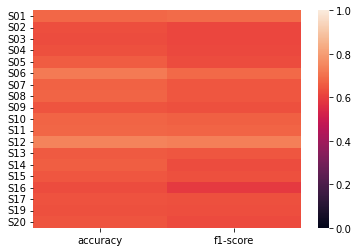

     class0 f1-score  class1 f1-score
S01         0.762791         0.523364
S02         0.745902         0.326087
S03         0.740157         0.326531
S04         0.753623         0.306122
S05         0.774704         0.278481
S06         0.821818         0.346667
S07         0.776119         0.361702
S08         0.782609         0.361702
S09         0.756364         0.336634
S10         0.771536         0.440367
S11         0.776860         0.413043
S12         0.817460         0.540000
S13         0.755906         0.403846
S14         0.779783         0.282353
S15         0.752852         0.368932
S16         0.758865         0.190476
S17         0.743590         0.387755
S19         0.739300         0.396396
S20         0.759398         0.319149


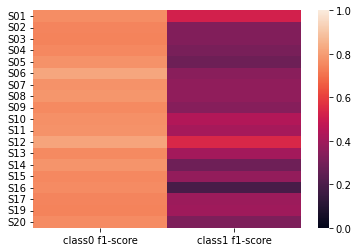

In [7]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)


In [12]:
start=-0.5
step=1.5/(188-1)
timestep_labels=[]
for i in range(input_dim[1]):
    timestep_labels.append(round(start+step*i,3))
    
# timestep_labels

In [11]:
# channel_names=[i for i in range(input_dim[0])]
channel_names=["AFz","F3","F1","Fz","F2","F4","FC5","FC3","FC1","FCz","FC2",
               "FC4","FC6","C5","C3","C1","Cz","C2","C4","C6","CP5","CP3",
               "CP1","CPz","CP2","CP4","CP6","P3","P1","Pz","P2","P4"]

In [15]:
from sklearn.preprocessing import MinMaxScaler

participants_w_list=[]

for i in range(len(participants)):

    w= pickle.load(
        open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-NFS_Multivariate-w-e{EPOCH}.pkl", "rb") 
                    )  
    participants_w_list.append(w)
    
avg_w= np.array(participants_w_list).mean(axis=0)
# scaler= MinMaxScaler()
# scaled_avg_w= scaler.fit_transform(avg_w)

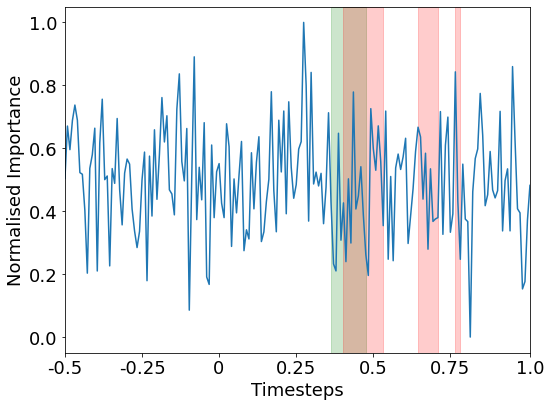

In [16]:
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler

plt.figure(figsize=(8,6))


scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.sum(0).reshape(-1,1))
df= pd.DataFrame(scaled_avg_w)
# df.index= channel_names
# df.columns=timestep_labels


plt.plot(df)
# plt.legend(methods)
plt.xlabel("Timesteps")
plt.axvspan(107,121, color="green", alpha=0.2)
plt.axvspan(112,128, color="red", alpha=0.2)
plt.axvspan(142,150, color="red", alpha=0.2)
plt.axvspan(157,159, color="red", alpha=0.2)
plt.xticks([0,31,62,93,124,155,187],[-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
plt.ylabel("Normalised Importance")
plt.margins(x=0)
matplotlib.rcParams.update({"font.size":18})
plt.tight_layout()
#     sns.heatmap(df.sum().to_numpy().reshape(-1,1),annot=True, 
#                 yticklabels=timestep_labels, ax=ax[i][1],
#                 xticklabels=False, cbar_kws={"pad":0.02})

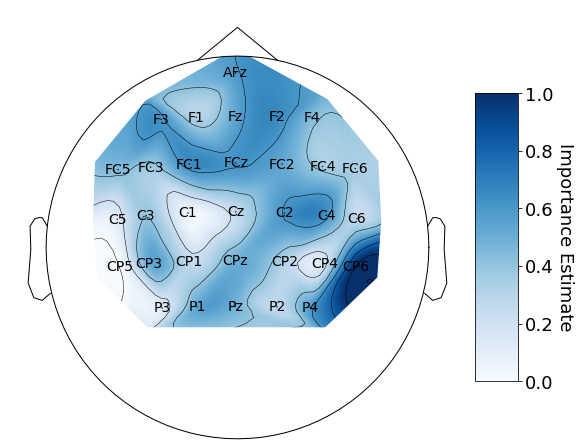

In [14]:
from sklearn.preprocessing import MinMaxScaler
import mne
info= mne.create_info(channel_names, sfreq=500, ch_types=32*["eeg"])
info.set_montage("standard_1020")

fig= plt.figure()
ax= plt.axes((0,0,1.5,1.5))

scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.sum(1).reshape(-1,1))
# df= pd.DataFrame(scaled_avg_w.reshape(-1))

im, _= mne.viz.plot_topomap(
    scaled_avg_w.reshape(-1),
    info,
    ch_type= "eeg",
    sensors=True,
    names=channel_names,
    cmap="Blues",
    axes=ax,
    show=False,
    extrapolate="local"
#     sphere="eeglab"
)
fig.add_axes(ax)
cbar_ax= fig.add_axes([1.3,0.2, 0.1,1])
clb= fig.colorbar(im, cax=cbar_ax)
clb.set_label("Importance Estimate", rotation=270,labelpad=20)

for tt in plt.findobj(fig, matplotlib.text.Text):
    if tt.get_text() in channel_names:
        tt.set_fontsize(14)